# Teste 4

In [1]:
import sys
print(sys.executable)

/home/magda/tf-gpu-env/bin/python3.10


**Ver se está a usar a GPU**

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2025-06-27 02:42:07.280670: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-06-27 02:42:08.404493: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1346012669956802606
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2351693824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11108244741906902963
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


2025-06-27 02:42:10.076018: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 02:42:10.184534: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 02:42:10.184592: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 02:42:10.356601: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 02:42:10.356673: I tensorflow/compile

**imports**

In [3]:
import os
# Ativa o alocador assíncrono (melhora fragmentação de memória)
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
import tensorflow as tf
# Ativa a alocação dinâmica de memória (não ocupa toda a memória no início)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("Erro ao definir memory growth:", e)
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, GlobalAveragePooling2D, Dense, ReLU, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import roc_auc_score

print("TensorFlow:", tf.__version__)
print("TensorFlow Addons:", tfa.__version__)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("Matplotlib:", matplotlib.__version__)

2025-06-27 02:42:10.368631: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 02:42:10.368735: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 02:42:10.368771: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
/home/magda/tf-gpu-env/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.


TensorFlow: 2.13.0
TensorFlow Addons: 0.21.0
NumPy: 1.23.5
Pandas: 1.5.3
Matplotlib: 3.7.1


## Arquitetura do Modelo:

In [4]:
# Entrada
input_layer = Input(shape=(224, 224, 3))

# Primeira camada
x = Conv2D(48, (3,3), strides=2, padding='same')(input_layer)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(24, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(72, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(24, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# ConvBlock_1
for _ in range(2):
    x = Conv2D(72, (1,1), strides=1, padding='same')(x)  # 24 -> 72
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(24, (1,1), strides=1, padding='same')(x)  # 72 -> 24
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
# Expandir de novo
x = Conv2D(72, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=5, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(56, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# ConvBlock_2
for _ in range(2):
    x = Conv2D(168, (1,1), strides=1, padding='same')(x)  # 56 -> 168
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = DepthwiseConv2D(kernel_size=5, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(56, (1,1), strides=1, padding='same')(x)  # 168 -> 56
    x = BatchNormalization()(x)
    x = ReLU()(x)

# Expandir de novo
x = Conv2D(336, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=5, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(104, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# ConvBlock_3
for _ in range(2):
    x = Conv2D(624, (1,1), strides=1, padding='same')(x)  # 104 -> 624
    x = BatchNormalization()(x)
    x = ReLU()(x)    
    x = DepthwiseConv2D(kernel_size=5, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)    
    x = Conv2D(104, (1,1), strides=1, padding='same')(x)  # 624 -> 104
    x = BatchNormalization()(x)
    x = ReLU()(x)

# Expandir
x = Conv2D(624, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(136, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# ConvBlock_4
x = Conv2D(816, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(136, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# Entre conv_blocks
x = Conv2D(816, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=5, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(272, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# ConvBlock_5
for _ in range(3):
    x = Conv2D(1632, (1,1), strides=1, padding='same')(x)  # 272 -> 1632
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = DepthwiseConv2D(kernel_size=5, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(272, (1,1), strides=1, padding='same')(x)  # 1632 -> 272
    x = BatchNormalization()(x)
    x = ReLU()(x)

# Finalização
x = Conv2D(1632, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(448, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(1280, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# Pooling global e classificação
x = GlobalAveragePooling2D()(x)
output_layer = Dense(2, activation='softmax')(x)

# Modelo
model = Model(inputs=input_layer, outputs=output_layer)

2025-06-27 02:42:11.317824: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 02:42:11.317949: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 02:42:11.317994: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 02:42:11.318395: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 02:42:11.318411: I tensorflow/core/co

In [5]:
# Compilar o modelo
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(),
        tfa.metrics.F1Score(num_classes=2, average='macro')
    ]
)

In [6]:
# Mostrar resumo
model.summary()

Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         


 conv2d (Conv2D)             (None, 112, 112, 48)      1344      


 batch_normalization (Batch  (None, 112, 112, 48)      192       


 Normalization)                                                  


 re_lu (ReLU)                (None, 112, 112, 48)      0         


 depthwise_conv2d (Depthwis  (None, 112, 112, 48)      480       


 eConv2D)                                                        


 batch_normalization_1 (Bat  (None, 112, 112, 48)      192       


 chNormalization)                                                


 re_lu_1 (ReLU)              (None, 112, 112, 48)      0         


 conv2d_1 (Conv2D)           (None, 112, 112, 24)      1176      


 batch_normalization_2 (Bat  (None, 112, 112, 24)      96        


 chNormalization)                                                


 re_lu_2 (ReLU)              (None, 112, 112, 24)      0         


 conv2d_2 (Conv2D)           (None, 112, 112, 72)      1800      


 batch_normalization_3 (Bat  (None, 112, 112, 72)      288       


 chNormalization)                                                


 re_lu_3 (ReLU)              (None, 112, 112, 72)      0         


 depthwise_conv2d_1 (Depthw  (None, 56, 56, 72)        720       


 iseConv2D)                                                      


 batch_normalization_4 (Bat  (None, 56, 56, 72)        288       


 chNormalization)                                                


 re_lu_4 (ReLU)              (None, 56, 56, 72)        0         


 conv2d_3 (Conv2D)           (None, 56, 56, 24)        1752      


 batch_normalization_5 (Bat  (None, 56, 56, 24)        96        


 chNormalization)                                                


 re_lu_5 (ReLU)              (None, 56, 56, 24)        0         


 conv2d_4 (Conv2D)           (None, 56, 56, 72)        1800      


 batch_normalization_6 (Bat  (None, 56, 56, 72)        288       


 chNormalization)                                                


 re_lu_6 (ReLU)              (None, 56, 56, 72)        0         


 depthwise_conv2d_2 (Depthw  (None, 56, 56, 72)        720       


 iseConv2D)                                                      


 batch_normalization_7 (Bat  (None, 56, 56, 72)        288       


 chNormalization)                                                


 re_lu_7 (ReLU)              (None, 56, 56, 72)        0         


 conv2d_5 (Conv2D)           (None, 56, 56, 24)        1752      


 batch_normalization_8 (Bat  (None, 56, 56, 24)        96        


 chNormalization)                                                


 re_lu_8 (ReLU)              (None, 56, 56, 24)        0         


 conv2d_6 (Conv2D)           (None, 56, 56, 72)        1800      


 batch_normalization_9 (Bat  (None, 56, 56, 72)        288       


 chNormalization)                                                


 re_lu_9 (ReLU)              (None, 56, 56, 72)        0         


 depthwise_conv2d_3 (Depthw  (None, 56, 56, 72)        720       


 iseConv2D)                                                      


 batch_normalization_10 (Ba  (None, 56, 56, 72)        288       


 tchNormalization)                                               


 re_lu_10 (ReLU)             (None, 56, 56, 72)        0         


 conv2d_7 (Conv2D)           (None, 56, 56, 24)        1752      


 batch_normalization_11 (Ba  (None, 56, 56, 24)        96        


 tchNormalization)                                               


 re_lu_11 (ReLU)             (None, 56, 56, 24)        0         


 conv2d_8 (Conv2D)           (None, 56, 56, 72)        1800      


 batch_normalization_12 (Ba  (None, 56, 56, 72)        288       


 tchNormalization)                                               


 re_lu_12 (ReLU)             (None, 56, 56, 72)        0         


 depthwise_conv2d_4 (Depthw  (None, 28, 28, 72)        1872      


 iseConv2D)                                                      


 batch_normalization_13 (Ba  (None, 28, 28, 72)        288       


 tchNormalization)                                               


 re_lu_13 (ReLU)             (None, 28, 28, 72)        0         


 conv2d_9 (Conv2D)           (None, 28, 28, 56)        4088      


 batch_normalization_14 (Ba  (None, 28, 28, 56)        224       


 tchNormalization)                                               


 re_lu_14 (ReLU)             (None, 28, 28, 56)        0         


 conv2d_10 (Conv2D)          (None, 28, 28, 168)       9576      


 batch_normalization_15 (Ba  (None, 28, 28, 168)       672       


 tchNormalization)                                               


 re_lu_15 (ReLU)             (None, 28, 28, 168)       0         


 depthwise_conv2d_5 (Depthw  (None, 28, 28, 168)       4368      


 iseConv2D)                                                      


 batch_normalization_16 (Ba  (None, 28, 28, 168)       672       


 tchNormalization)                                               


 re_lu_16 (ReLU)             (None, 28, 28, 168)       0         


 conv2d_11 (Conv2D)          (None, 28, 28, 56)        9464      


 batch_normalization_17 (Ba  (None, 28, 28, 56)        224       


 tchNormalization)                                               


 re_lu_17 (ReLU)             (None, 28, 28, 56)        0         


 conv2d_12 (Conv2D)          (None, 28, 28, 168)       9576      


 batch_normalization_18 (Ba  (None, 28, 28, 168)       672       


 tchNormalization)                                               


 re_lu_18 (ReLU)             (None, 28, 28, 168)       0         


 depthwise_conv2d_6 (Depthw  (None, 28, 28, 168)       4368      


 iseConv2D)                                                      


 batch_normalization_19 (Ba  (None, 28, 28, 168)       672       


 tchNormalization)                                               


 re_lu_19 (ReLU)             (None, 28, 28, 168)       0         


 conv2d_13 (Conv2D)          (None, 28, 28, 56)        9464      


 batch_normalization_20 (Ba  (None, 28, 28, 56)        224       


 tchNormalization)                                               


 re_lu_20 (ReLU)             (None, 28, 28, 56)        0         


 conv2d_14 (Conv2D)          (None, 28, 28, 336)       19152     


 batch_normalization_21 (Ba  (None, 28, 28, 336)       1344      


 tchNormalization)                                               


 re_lu_21 (ReLU)             (None, 28, 28, 336)       0         


 depthwise_conv2d_7 (Depthw  (None, 14, 14, 336)       8736      


 iseConv2D)                                                      


 batch_normalization_22 (Ba  (None, 14, 14, 336)       1344      


 tchNormalization)                                               


 re_lu_22 (ReLU)             (None, 14, 14, 336)       0         


 conv2d_15 (Conv2D)          (None, 14, 14, 104)       35048     


 batch_normalization_23 (Ba  (None, 14, 14, 104)       416       


 tchNormalization)                                               


 re_lu_23 (ReLU)             (None, 14, 14, 104)       0         


 conv2d_16 (Conv2D)          (None, 14, 14, 624)       65520     


 batch_normalization_24 (Ba  (None, 14, 14, 624)       2496      


 tchNormalization)                                               


 re_lu_24 (ReLU)             (None, 14, 14, 624)       0         


 depthwise_conv2d_8 (Depthw  (None, 14, 14, 624)       16224     


 iseConv2D)                                                      


 batch_normalization_25 (Ba  (None, 14, 14, 624)       2496      


 tchNormalization)                                               


 re_lu_25 (ReLU)             (None, 14, 14, 624)       0         


 conv2d_17 (Conv2D)          (None, 14, 14, 104)       65000     


 batch_normalization_26 (Ba  (None, 14, 14, 104)       416       


 tchNormalization)                                               


 re_lu_26 (ReLU)             (None, 14, 14, 104)       0         


 conv2d_18 (Conv2D)          (None, 14, 14, 624)       65520     


 batch_normalization_27 (Ba  (None, 14, 14, 624)       2496      


 tchNormalization)                                               


 re_lu_27 (ReLU)             (None, 14, 14, 624)       0         


 depthwise_conv2d_9 (Depthw  (None, 14, 14, 624)       16224     


 iseConv2D)                                                      


 batch_normalization_28 (Ba  (None, 14, 14, 624)       2496      


 tchNormalization)                                               


 re_lu_28 (ReLU)             (None, 14, 14, 624)       0         


 conv2d_19 (Conv2D)          (None, 14, 14, 104)       65000     


 batch_normalization_29 (Ba  (None, 14, 14, 104)       416       


 tchNormalization)                                               


 re_lu_29 (ReLU)             (None, 14, 14, 104)       0         


 conv2d_20 (Conv2D)          (None, 14, 14, 624)       65520     


 batch_normalization_30 (Ba  (None, 14, 14, 624)       2496      


 tchNormalization)                                               


 re_lu_30 (ReLU)             (None, 14, 14, 624)       0         


 depthwise_conv2d_10 (Depth  (None, 14, 14, 624)       6240      


 wiseConv2D)                                                     


 batch_normalization_31 (Ba  (None, 14, 14, 624)       2496      


 tchNormalization)                                               


 re_lu_31 (ReLU)             (None, 14, 14, 624)       0         


 conv2d_21 (Conv2D)          (None, 14, 14, 136)       85000     


 batch_normalization_32 (Ba  (None, 14, 14, 136)       544       


 tchNormalization)                                               


 re_lu_32 (ReLU)             (None, 14, 14, 136)       0         


 conv2d_22 (Conv2D)          (None, 14, 14, 816)       111792    


 batch_normalization_33 (Ba  (None, 14, 14, 816)       3264      


 tchNormalization)                                               


 re_lu_33 (ReLU)             (None, 14, 14, 816)       0         


 depthwise_conv2d_11 (Depth  (None, 14, 14, 816)       8160      


 wiseConv2D)                                                     


 batch_normalization_34 (Ba  (None, 14, 14, 816)       3264      


 tchNormalization)                                               


 re_lu_34 (ReLU)             (None, 14, 14, 816)       0         


 conv2d_23 (Conv2D)          (None, 14, 14, 136)       111112    


 batch_normalization_35 (Ba  (None, 14, 14, 136)       544       


 tchNormalization)                                               


 re_lu_35 (ReLU)             (None, 14, 14, 136)       0         


 conv2d_24 (Conv2D)          (None, 14, 14, 816)       111792    


 batch_normalization_36 (Ba  (None, 14, 14, 816)       3264      


 tchNormalization)                                               


 re_lu_36 (ReLU)             (None, 14, 14, 816)       0         


 depthwise_conv2d_12 (Depth  (None, 7, 7, 816)         21216     


 wiseConv2D)                                                     


 batch_normalization_37 (Ba  (None, 7, 7, 816)         3264      


 tchNormalization)                                               


 re_lu_37 (ReLU)             (None, 7, 7, 816)         0         


 conv2d_25 (Conv2D)          (None, 7, 7, 272)         222224    


 batch_normalization_38 (Ba  (None, 7, 7, 272)         1088      


 tchNormalization)                                               


 re_lu_38 (ReLU)             (None, 7, 7, 272)         0         


 conv2d_26 (Conv2D)          (None, 7, 7, 1632)        445536    


 batch_normalization_39 (Ba  (None, 7, 7, 1632)        6528      


 tchNormalization)                                               


 re_lu_39 (ReLU)             (None, 7, 7, 1632)        0         


 depthwise_conv2d_13 (Depth  (None, 7, 7, 1632)        42432     


 wiseConv2D)                                                     


 batch_normalization_40 (Ba  (None, 7, 7, 1632)        6528      


 tchNormalization)                                               


 re_lu_40 (ReLU)             (None, 7, 7, 1632)        0         


 conv2d_27 (Conv2D)          (None, 7, 7, 272)         444176    


 batch_normalization_41 (Ba  (None, 7, 7, 272)         1088      


 tchNormalization)                                               


 re_lu_41 (ReLU)             (None, 7, 7, 272)         0         


 conv2d_28 (Conv2D)          (None, 7, 7, 1632)        445536    


 batch_normalization_42 (Ba  (None, 7, 7, 1632)        6528      


 tchNormalization)                                               


 re_lu_42 (ReLU)             (None, 7, 7, 1632)        0         


 depthwise_conv2d_14 (Depth  (None, 7, 7, 1632)        42432     


 wiseConv2D)                                                     


 batch_normalization_43 (Ba  (None, 7, 7, 1632)        6528      


 tchNormalization)                                               


 re_lu_43 (ReLU)             (None, 7, 7, 1632)        0         


 conv2d_29 (Conv2D)          (None, 7, 7, 272)         444176    


 batch_normalization_44 (Ba  (None, 7, 7, 272)         1088      


 tchNormalization)                                               


 re_lu_44 (ReLU)             (None, 7, 7, 272)         0         


 conv2d_30 (Conv2D)          (None, 7, 7, 1632)        445536    


 batch_normalization_45 (Ba  (None, 7, 7, 1632)        6528      


 tchNormalization)                                               


 re_lu_45 (ReLU)             (None, 7, 7, 1632)        0         


 depthwise_conv2d_15 (Depth  (None, 7, 7, 1632)        42432     


 wiseConv2D)                                                     


 batch_normalization_46 (Ba  (None, 7, 7, 1632)        6528      


 tchNormalization)                                               


 re_lu_46 (ReLU)             (None, 7, 7, 1632)        0         


 conv2d_31 (Conv2D)          (None, 7, 7, 272)         444176    


 batch_normalization_47 (Ba  (None, 7, 7, 272)         1088      


 tchNormalization)                                               


 re_lu_47 (ReLU)             (None, 7, 7, 272)         0         


 conv2d_32 (Conv2D)          (None, 7, 7, 1632)        445536    


 batch_normalization_48 (Ba  (None, 7, 7, 1632)        6528      


 tchNormalization)                                               


 re_lu_48 (ReLU)             (None, 7, 7, 1632)        0         


 depthwise_conv2d_16 (Depth  (None, 7, 7, 1632)        16320     


 wiseConv2D)                                                     


 batch_normalization_49 (Ba  (None, 7, 7, 1632)        6528      


 tchNormalization)                                               


 re_lu_49 (ReLU)             (None, 7, 7, 1632)        0         


 conv2d_33 (Conv2D)          (None, 7, 7, 448)         731584    


 batch_normalization_50 (Ba  (None, 7, 7, 448)         1792      


 tchNormalization)                                               


 re_lu_50 (ReLU)             (None, 7, 7, 448)         0         


 conv2d_34 (Conv2D)          (None, 7, 7, 1280)        574720    


 batch_normalization_51 (Ba  (None, 7, 7, 1280)        5120      


 tchNormalization)                                               


 re_lu_51 (ReLU)             (None, 7, 7, 1280)        0         


 global_average_pooling2d (  (None, 1280)              0         


 GlobalAveragePooling2D)                                         


 dense (Dense)               (None, 2)                 2562      


Total params: 5840002 (22.28 MB)


Trainable params: 5788514 (22.08 MB)


Non-trainable params: 51488 (201.12 KB)


_________________________________________________________________


## Funções Auxiliares

Trata do pré-processamento das imagens, ou seja redimensiona para 224 X 224 pixels e normaliza [0,1] e coloca em one hot.

In [7]:
# Função auxiliar para carregar imagem
def preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0
    label = tf.one_hot(label, 2)
    return image, label

Permite analisar a distribuição dos datasets.

In [8]:
def inspect_dataset_distribution(dataset, name="dataset"):
    total_samples = 0
    label_counter = Counter()

    for images, labels in dataset:
        # labels vêm em one-hot: [0,1] ou [1,0]
        labels_np = labels.numpy()
        class_indices = labels_np.argmax(axis=1)  # <-- Corrigir: pegar o índice da classe correta
        total_samples += len(class_indices)
        label_counter.update(class_indices)

    print(f"📊 {name.upper()} -> Total de imagens: {total_samples}")
    for label, count in sorted(label_counter.items()):
        perc = (count / total_samples) * 100
        print(f"  Classe {int(label)} ({'Fogo' if label == 1 else 'Sem fogo'}): {count} imagens ({perc:.2f}%)")
    print("-" * 40)

Permite analisar o histórico de trino.

In [9]:
def plot_training_history(history):
    metrics = history.history.keys()
    epochs_range = range(len(history.history['loss']))

    for metric in metrics:
        if "val_" not in metric:
            plt.figure(figsize=(10, 5))
            plt.plot(epochs_range, history.history[metric], label=f"Train {metric}")
            if f"val_{metric}" in metrics:
                plt.plot(epochs_range, history.history[f"val_{metric}"], label=f"Val {metric}")
            plt.title(f"Training and Validation {metric.capitalize()}")
            plt.xlabel("Epochs")
            plt.ylabel(metric.capitalize())
            plt.legend()
            plt.grid(True)
            plt.show()

Usada para avaliar o modelo, ou seja, se está a prever corretamente a classificação das imagens.

In [10]:
def avaliar_modelo(model, dataset):
    # 1. Previsões e rótulos reais
    y_pred_probs = model.predict(dataset, verbose=0)
    y_true = np.concatenate([y for _, y in dataset], axis=0)
    y_true_int = np.argmax(y_true, axis=1)
    y_pred_int = (y_pred_probs[:, 1] > 0.5).astype(int)

    # 2. Contagem das classes
    TP = np.sum((y_true_int == 1) & (y_pred_int == 1))
    TN = np.sum((y_true_int == 0) & (y_pred_int == 0))
    FP = np.sum((y_true_int == 0) & (y_pred_int == 1))
    FN = np.sum((y_true_int == 1) & (y_pred_int == 0))

    total = TP + TN + FP + FN

    # 3. Cálculo das métricas com base nas fórmulas
    accuracy   = (TP + TN) / total if total > 0 else 0.0
    precision  = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall     = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1_score   = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    auc        = roc_auc_score(y_true_int, y_pred_probs[:, 1])

    # Binary crossentropy loss
    eps = 1e-7
    p = np.clip(y_pred_probs[:, 1], eps, 1 - eps)
    y = y_true_int
    loss = - np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

    # Métricas específicas de detecção de incêndio
    fdr = recall * 100  # ou (TP / (TP + FN)) * 100
    ewr = ((FP + FN) / total) * 100 if total > 0 else 0.0

    # 4. Impressão
    print("=== MÉTRICAS DE AVALIAÇÃO ===")
    print(f"TP={TP}, TN={TN}, FP={FP}, FN={FN}")
    print(f"Accuracy       : {accuracy:.4f}")
    print(f"Precision      : {precision:.4f}")
    print(f"Recall         : {recall:.4f}")
    print(f"F1-Score       : {f1_score:.4f}")
    print(f"AUC            : {auc:.4f}")
    print(f"Binary Loss    : {loss:.4f}")
    print(f"FDR (Fire Detection Rate)      : {fdr:.2f} %")
    print(f"EWR (Error Warning Rate)       : {ewr:.2f} %")
    print("Confusion Matrix:")
    print(np.array([[TN, FP], [FN, TP]]))  # [[negativos reais], [positivos reais]]

    # 5. Retorno opcional
    return {
        'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'auc': auc,
        'loss': loss,
        'fdr': fdr,
        'ewr': ewr,
        'confusion_matrix': np.array([[TN, FP], [FN, TP]])
    }

## Treino

In [11]:
# Configurações gerais
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 16
EPOCHS = 50
SEED = 42

In [12]:
data = pd.read_csv("../Datasets_Mixed/mixed_4_train.csv")
image_paths = data['image_path'].values
labels = data['label_bi'].values

data = pd.read_csv("../Datasets_Mixed/mixed_4_test.csv")
image_paths_test = data['image_path'].values
labels_test = data['label_bi'].values

In [13]:
# Dividir em treino, validação e teste (90/10)
x_train, x_val, y_train, y_val = train_test_split(image_paths, labels, test_size=0.1, random_state=SEED, stratify=labels)

In [14]:
# Criar datasets TensorFlow
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(preprocess_image).shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((image_paths_test, labels_test))
test_ds = test_ds.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [15]:
inspect_dataset_distribution(train_ds, name="train")
inspect_dataset_distribution(val_ds, name="val")
inspect_dataset_distribution(test_ds, name="test")

📊 TRAIN -> Total de imagens: 4436
  Classe 0 (Sem fogo): 1276 imagens (28.76%)
  Classe 1 (Fogo): 3160 imagens (71.24%)
----------------------------------------


📊 VAL -> Total de imagens: 493
  Classe 0 (Sem fogo): 142 imagens (28.80%)
  Classe 1 (Fogo): 351 imagens (71.20%)
----------------------------------------


📊 TEST -> Total de imagens: 24402
  Classe 0 (Sem fogo): 10107 imagens (41.42%)
  Classe 1 (Fogo): 14295 imagens (58.58%)
----------------------------------------


In [16]:
callback = [
    ModelCheckpoint('test_4_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

In [17]:
# Treinar
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callback
)

Epoch 1/50


2025-06-27 02:43:04.522571: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


2025-06-27 02:43:06.012938: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x64075859f190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-27 02:43:06.012986: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2025-06-27 02:43:06.078552: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


2025-06-27 02:43:06.362980: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-06-27 02:43:06.537850: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-27 02:43:06.538453: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2025-06-27 02:43:06.596923: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-27 02:43:06.628663: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2025-06-27 02:43:07.008489: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.58GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-27 02:43:07.008603: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.58GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-27 02:43:07.052955: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.60GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-27 02:43:07.053040: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU

  1/278 [..............................] - ETA: 2:29:19 - loss: 0.6426 - accuracy: 0.6250 - precision: 0.6250 - recall: 0.6250 - auc: 0.6875 - f1_score: 0.3846

  2/278 [..............................] - ETA: 49s - loss: 1.4415 - accuracy: 0.5312 - precision: 0.5312 - recall: 0.5312 - auc: 0.5010 - f1_score: 0.4684    

  3/278 [..............................] - ETA: 46s - loss: 1.1106 - accuracy: 0.6458 - precision: 0.6458 - recall: 0.6458 - auc: 0.6207 - f1_score: 0.5140

  4/278 [..............................] - ETA: 43s - loss: 1.1057 - accuracy: 0.6250 - precision: 0.6250 - recall: 0.6250 - auc: 0.6335 - f1_score: 0.4776

  5/278 [..............................] - ETA: 41s - loss: 1.0931 - accuracy: 0.6375 - precision: 0.6375 - recall: 0.6375 - auc: 0.6566 - f1_score: 0.4697

  6/278 [..............................] - ETA: 40s - loss: 1.1628 - accuracy: 0.6146 - precision: 0.6146 - recall: 0.6146 - auc: 0.6268 - f1_score: 0.4456

  7/278 [..............................] - ETA: 39s - loss: 1.1270 - accuracy: 0.6250 - precision: 0.6250 - recall: 0.6250 - auc: 0.6349 - f1_score: 0.4432

  8/278 [..............................] - ETA: 39s - loss: 1.0710 - accuracy: 0.6406 - precision: 0.6406 - recall: 0.6406 - auc: 0.6517 - f1_score: 0.4602

  9/278 [..............................] - ETA: 38s - loss: 1.0031 - accuracy: 0.6597 - precision: 0.6597 - recall: 0.6597 - auc: 0.6692 - f1_score: 0.4778

 10/278 [>.............................] - ETA: 38s - loss: 0.9838 - accuracy: 0.6500 - precision: 0.6500 - recall: 0.6500 - auc: 0.6628 - f1_score: 0.4771

 11/278 [>.............................] - ETA: 38s - loss: 0.9873 - accuracy: 0.6364 - precision: 0.6364 - recall: 0.6364 - auc: 0.6480 - f1_score: 0.4630

 12/278 [>.............................] - ETA: 37s - loss: 0.9638 - accuracy: 0.6354 - precision: 0.6354 - recall: 0.6354 - auc: 0.6442 - f1_score: 0.4756

 13/278 [>.............................] - ETA: 37s - loss: 0.9445 - accuracy: 0.6250 - precision: 0.6250 - recall: 0.6250 - auc: 0.6412 - f1_score: 0.4794

 14/278 [>.............................] - ETA: 37s - loss: 0.9451 - accuracy: 0.6027 - precision: 0.6027 - recall: 0.6027 - auc: 0.6275 - f1_score: 0.4794

 15/278 [>.............................] - ETA: 36s - loss: 0.9207 - accuracy: 0.6083 - precision: 0.6083 - recall: 0.6083 - auc: 0.6329 - f1_score: 0.4889

 16/278 [>.............................] - ETA: 36s - loss: 0.8852 - accuracy: 0.6289 - precision: 0.6289 - recall: 0.6289 - auc: 0.6509 - f1_score: 0.5078

 17/278 [>.............................] - ETA: 36s - loss: 0.8762 - accuracy: 0.6287 - precision: 0.6287 - recall: 0.6287 - auc: 0.6539 - f1_score: 0.5025

 18/278 [>.............................] - ETA: 36s - loss: 0.8525 - accuracy: 0.6389 - precision: 0.6389 - recall: 0.6389 - auc: 0.6694 - f1_score: 0.5093

 19/278 [=>............................] - ETA: 36s - loss: 0.8281 - accuracy: 0.6513 - precision: 0.6513 - recall: 0.6513 - auc: 0.6850 - f1_score: 0.5130

 20/278 [=>............................] - ETA: 35s - loss: 0.8320 - accuracy: 0.6531 - precision: 0.6531 - recall: 0.6531 - auc: 0.6866 - f1_score: 0.5099

 21/278 [=>............................] - ETA: 35s - loss: 0.8202 - accuracy: 0.6577 - precision: 0.6577 - recall: 0.6577 - auc: 0.6936 - f1_score: 0.5134

 22/278 [=>............................] - ETA: 35s - loss: 0.8090 - accuracy: 0.6619 - precision: 0.6619 - recall: 0.6619 - auc: 0.7004 - f1_score: 0.5122

 23/278 [=>............................] - ETA: 35s - loss: 0.8117 - accuracy: 0.6658 - precision: 0.6658 - recall: 0.6658 - auc: 0.7046 - f1_score: 0.5111

 24/278 [=>............................] - ETA: 35s - loss: 0.8177 - accuracy: 0.6641 - precision: 0.6641 - recall: 0.6641 - auc: 0.7055 - f1_score: 0.5107

 25/278 [=>............................] - ETA: 35s - loss: 0.8041 - accuracy: 0.6725 - precision: 0.6725 - recall: 0.6725 - auc: 0.7120 - f1_score: 0.5128

 26/278 [=>............................] - ETA: 34s - loss: 0.7997 - accuracy: 0.6731 - precision: 0.6731 - recall: 0.6731 - auc: 0.7118 - f1_score: 0.5100

 27/278 [=>............................] - ETA: 34s - loss: 0.8009 - accuracy: 0.6690 - precision: 0.6690 - recall: 0.6690 - auc: 0.7075 - f1_score: 0.5043

 28/278 [==>...........................] - ETA: 34s - loss: 0.7941 - accuracy: 0.6696 - precision: 0.6696 - recall: 0.6696 - auc: 0.7083 - f1_score: 0.5019

 29/278 [==>...........................] - ETA: 34s - loss: 0.7909 - accuracy: 0.6703 - precision: 0.6703 - recall: 0.6703 - auc: 0.7073 - f1_score: 0.4995

 30/278 [==>...........................] - ETA: 34s - loss: 0.7821 - accuracy: 0.6750 - precision: 0.6750 - recall: 0.6750 - auc: 0.7103 - f1_score: 0.5037

 31/278 [==>...........................] - ETA: 34s - loss: 0.7814 - accuracy: 0.6734 - precision: 0.6734 - recall: 0.6734 - auc: 0.7073 - f1_score: 0.5037

 32/278 [==>...........................] - ETA: 34s - loss: 0.7713 - accuracy: 0.6777 - precision: 0.6777 - recall: 0.6777 - auc: 0.7108 - f1_score: 0.5040

 33/278 [==>...........................] - ETA: 33s - loss: 0.7689 - accuracy: 0.6742 - precision: 0.6742 - recall: 0.6742 - auc: 0.7091 - f1_score: 0.4995

 34/278 [==>...........................] - ETA: 33s - loss: 0.7617 - accuracy: 0.6765 - precision: 0.6765 - recall: 0.6765 - auc: 0.7110 - f1_score: 0.4986

 35/278 [==>...........................] - ETA: 33s - loss: 0.7559 - accuracy: 0.6786 - precision: 0.6786 - recall: 0.6786 - auc: 0.7126 - f1_score: 0.5011

 36/278 [==>...........................] - ETA: 33s - loss: 0.7646 - accuracy: 0.6753 - precision: 0.6753 - recall: 0.6753 - auc: 0.7067 - f1_score: 0.4970

 37/278 [==>...........................] - ETA: 33s - loss: 0.7639 - accuracy: 0.6791 - precision: 0.6791 - recall: 0.6791 - auc: 0.7062 - f1_score: 0.4972

 38/278 [===>..........................] - ETA: 33s - loss: 0.7573 - accuracy: 0.6826 - precision: 0.6826 - recall: 0.6826 - auc: 0.7080 - f1_score: 0.4975

 39/278 [===>..........................] - ETA: 32s - loss: 0.7514 - accuracy: 0.6859 - precision: 0.6859 - recall: 0.6859 - auc: 0.7097 - f1_score: 0.4976

 40/278 [===>..........................] - ETA: 32s - loss: 0.7501 - accuracy: 0.6859 - precision: 0.6859 - recall: 0.6859 - auc: 0.7106 - f1_score: 0.4958

 41/278 [===>..........................] - ETA: 32s - loss: 0.7467 - accuracy: 0.6860 - precision: 0.6860 - recall: 0.6860 - auc: 0.7115 - f1_score: 0.4971

 42/278 [===>..........................] - ETA: 32s - loss: 0.7411 - accuracy: 0.6875 - precision: 0.6875 - recall: 0.6875 - auc: 0.7140 - f1_score: 0.4993

 43/278 [===>..........................] - ETA: 32s - loss: 0.7559 - accuracy: 0.6846 - precision: 0.6846 - recall: 0.6846 - auc: 0.7106 - f1_score: 0.4986

 44/278 [===>..........................] - ETA: 32s - loss: 0.7518 - accuracy: 0.6861 - precision: 0.6861 - recall: 0.6861 - auc: 0.7119 - f1_score: 0.5007

 45/278 [===>..........................] - ETA: 32s - loss: 0.7536 - accuracy: 0.6819 - precision: 0.6819 - recall: 0.6819 - auc: 0.7089 - f1_score: 0.4964

 46/278 [===>..........................] - ETA: 31s - loss: 0.7556 - accuracy: 0.6766 - precision: 0.6766 - recall: 0.6766 - auc: 0.7052 - f1_score: 0.4916

 47/278 [====>.........................] - ETA: 31s - loss: 0.7519 - accuracy: 0.6795 - precision: 0.6795 - recall: 0.6795 - auc: 0.7058 - f1_score: 0.5020

 48/278 [====>.........................] - ETA: 31s - loss: 0.7525 - accuracy: 0.6719 - precision: 0.6719 - recall: 0.6719 - auc: 0.7036 - f1_score: 0.5026

 49/278 [====>.........................] - ETA: 31s - loss: 0.7500 - accuracy: 0.6671 - precision: 0.6671 - recall: 0.6671 - auc: 0.7037 - f1_score: 0.5089

 50/278 [====>.........................] - ETA: 31s - loss: 0.7603 - accuracy: 0.6625 - precision: 0.6625 - recall: 0.6625 - auc: 0.6989 - f1_score: 0.5123

 51/278 [====>.........................] - ETA: 31s - loss: 0.7661 - accuracy: 0.6593 - precision: 0.6593 - recall: 0.6593 - auc: 0.6950 - f1_score: 0.5085

 52/278 [====>.........................] - ETA: 31s - loss: 0.7647 - accuracy: 0.6587 - precision: 0.6587 - recall: 0.6587 - auc: 0.6938 - f1_score: 0.5084

 53/278 [====>.........................] - ETA: 30s - loss: 0.7651 - accuracy: 0.6580 - precision: 0.6580 - recall: 0.6580 - auc: 0.6920 - f1_score: 0.5082

 54/278 [====>.........................] - ETA: 30s - loss: 0.7673 - accuracy: 0.6586 - precision: 0.6586 - recall: 0.6586 - auc: 0.6912 - f1_score: 0.5071

 55/278 [====>.........................] - ETA: 30s - loss: 0.7747 - accuracy: 0.6545 - precision: 0.6545 - recall: 0.6545 - auc: 0.6858 - f1_score: 0.5047

 56/278 [=====>........................] - ETA: 30s - loss: 0.7762 - accuracy: 0.6551 - precision: 0.6551 - recall: 0.6551 - auc: 0.6855 - f1_score: 0.5036

 57/278 [=====>........................] - ETA: 30s - loss: 0.7713 - accuracy: 0.6579 - precision: 0.6579 - recall: 0.6579 - auc: 0.6883 - f1_score: 0.5040

 58/278 [=====>........................] - ETA: 30s - loss: 0.7716 - accuracy: 0.6562 - precision: 0.6562 - recall: 0.6562 - auc: 0.6865 - f1_score: 0.5015

 59/278 [=====>........................] - ETA: 30s - loss: 0.7663 - accuracy: 0.6600 - precision: 0.6600 - recall: 0.6600 - auc: 0.6889 - f1_score: 0.5026

 60/278 [=====>........................] - ETA: 29s - loss: 0.7697 - accuracy: 0.6604 - precision: 0.6604 - recall: 0.6604 - auc: 0.6868 - f1_score: 0.5015

 61/278 [=====>........................] - ETA: 29s - loss: 0.7656 - accuracy: 0.6619 - precision: 0.6619 - recall: 0.6619 - auc: 0.6882 - f1_score: 0.5012

 62/278 [=====>........................] - ETA: 29s - loss: 0.7618 - accuracy: 0.6643 - precision: 0.6643 - recall: 0.6643 - auc: 0.6897 - f1_score: 0.5014

 63/278 [=====>........................] - ETA: 29s - loss: 0.7579 - accuracy: 0.6687 - precision: 0.6687 - recall: 0.6687 - auc: 0.6922 - f1_score: 0.5029

 64/278 [=====>........................] - ETA: 29s - loss: 0.7519 - accuracy: 0.6719 - precision: 0.6719 - recall: 0.6719 - auc: 0.6957 - f1_score: 0.5038

 65/278 [======>.......................] - ETA: 29s - loss: 0.7498 - accuracy: 0.6721 - precision: 0.6721 - recall: 0.6721 - auc: 0.6962 - f1_score: 0.5027

 66/278 [======>.......................] - ETA: 29s - loss: 0.7484 - accuracy: 0.6723 - precision: 0.6723 - recall: 0.6723 - auc: 0.6964 - f1_score: 0.5017

 67/278 [======>.......................] - ETA: 29s - loss: 0.7430 - accuracy: 0.6754 - precision: 0.6754 - recall: 0.6754 - auc: 0.6997 - f1_score: 0.5024

 68/278 [======>.......................] - ETA: 28s - loss: 0.7381 - accuracy: 0.6783 - precision: 0.6783 - recall: 0.6783 - auc: 0.7028 - f1_score: 0.5031

 69/278 [======>.......................] - ETA: 28s - loss: 0.7393 - accuracy: 0.6784 - precision: 0.6784 - recall: 0.6784 - auc: 0.7024 - f1_score: 0.5021

 70/278 [======>.......................] - ETA: 28s - loss: 0.7384 - accuracy: 0.6786 - precision: 0.6786 - recall: 0.6786 - auc: 0.7022 - f1_score: 0.5011

 71/278 [======>.......................] - ETA: 28s - loss: 0.7363 - accuracy: 0.6796 - precision: 0.6796 - recall: 0.6796 - auc: 0.7030 - f1_score: 0.5007

 72/278 [======>.......................] - ETA: 28s - loss: 0.7379 - accuracy: 0.6771 - precision: 0.6771 - recall: 0.6771 - auc: 0.7006 - f1_score: 0.4981

 73/278 [======>.......................] - ETA: 28s - loss: 0.7362 - accuracy: 0.6772 - precision: 0.6772 - recall: 0.6772 - auc: 0.7009 - f1_score: 0.4971

 74/278 [======>.......................] - ETA: 28s - loss: 0.7367 - accuracy: 0.6765 - precision: 0.6765 - recall: 0.6765 - auc: 0.6998 - f1_score: 0.4957

 75/278 [=======>......................] - ETA: 27s - loss: 0.7355 - accuracy: 0.6758 - precision: 0.6758 - recall: 0.6758 - auc: 0.6996 - f1_score: 0.4943

 76/278 [=======>......................] - ETA: 27s - loss: 0.7355 - accuracy: 0.6743 - precision: 0.6743 - recall: 0.6743 - auc: 0.6986 - f1_score: 0.4924

 77/278 [=======>......................] - ETA: 27s - loss: 0.7348 - accuracy: 0.6721 - precision: 0.6721 - recall: 0.6721 - auc: 0.6980 - f1_score: 0.4901

 78/278 [=======>......................] - ETA: 27s - loss: 0.7346 - accuracy: 0.6699 - precision: 0.6699 - recall: 0.6699 - auc: 0.6971 - f1_score: 0.4909

 79/278 [=======>......................] - ETA: 27s - loss: 0.7339 - accuracy: 0.6677 - precision: 0.6677 - recall: 0.6677 - auc: 0.6965 - f1_score: 0.4959

 80/278 [=======>......................] - ETA: 27s - loss: 0.7347 - accuracy: 0.6617 - precision: 0.6617 - recall: 0.6617 - auc: 0.6949 - f1_score: 0.4953

 81/278 [=======>......................] - ETA: 27s - loss: 0.7345 - accuracy: 0.6574 - precision: 0.6574 - recall: 0.6574 - auc: 0.6938 - f1_score: 0.4982

 82/278 [=======>......................] - ETA: 26s - loss: 0.7339 - accuracy: 0.6562 - precision: 0.6562 - recall: 0.6562 - auc: 0.6931 - f1_score: 0.5003

 83/278 [=======>......................] - ETA: 26s - loss: 0.7334 - accuracy: 0.6566 - precision: 0.6566 - recall: 0.6566 - auc: 0.6922 - f1_score: 0.5020

 84/278 [========>.....................] - ETA: 26s - loss: 0.7336 - accuracy: 0.6525 - precision: 0.6525 - recall: 0.6525 - auc: 0.6909 - f1_score: 0.4984

 85/278 [========>.....................] - ETA: 26s - loss: 0.7328 - accuracy: 0.6515 - precision: 0.6515 - recall: 0.6515 - auc: 0.6905 - f1_score: 0.4968

 86/278 [========>.....................] - ETA: 26s - loss: 0.7323 - accuracy: 0.6504 - precision: 0.6504 - recall: 0.6504 - auc: 0.6899 - f1_score: 0.4952

 87/278 [========>.....................] - ETA: 26s - loss: 0.7318 - accuracy: 0.6494 - precision: 0.6494 - recall: 0.6494 - auc: 0.6893 - f1_score: 0.4937

 88/278 [========>.....................] - ETA: 26s - loss: 0.7296 - accuracy: 0.6513 - precision: 0.6513 - recall: 0.6513 - auc: 0.6903 - f1_score: 0.4940

 89/278 [========>.....................] - ETA: 25s - loss: 0.7276 - accuracy: 0.6531 - precision: 0.6531 - recall: 0.6531 - auc: 0.6911 - f1_score: 0.4954

 90/278 [========>.....................] - ETA: 25s - loss: 0.7270 - accuracy: 0.6528 - precision: 0.6528 - recall: 0.6528 - auc: 0.6907 - f1_score: 0.4955

 91/278 [========>.....................] - ETA: 25s - loss: 0.7254 - accuracy: 0.6538 - precision: 0.6538 - recall: 0.6538 - auc: 0.6912 - f1_score: 0.4953

 92/278 [========>.....................] - ETA: 25s - loss: 0.7231 - accuracy: 0.6549 - precision: 0.6549 - recall: 0.6549 - auc: 0.6922 - f1_score: 0.4952

 93/278 [=========>....................] - ETA: 25s - loss: 0.7233 - accuracy: 0.6539 - precision: 0.6539 - recall: 0.6539 - auc: 0.6911 - f1_score: 0.4948

 94/278 [=========>....................] - ETA: 25s - loss: 0.7225 - accuracy: 0.6543 - precision: 0.6543 - recall: 0.6543 - auc: 0.6909 - f1_score: 0.4953

 95/278 [=========>....................] - ETA: 25s - loss: 0.7205 - accuracy: 0.6553 - precision: 0.6553 - recall: 0.6553 - auc: 0.6919 - f1_score: 0.4952

 96/278 [=========>....................] - ETA: 24s - loss: 0.7218 - accuracy: 0.6530 - precision: 0.6530 - recall: 0.6530 - auc: 0.6899 - f1_score: 0.4929

 97/278 [=========>....................] - ETA: 24s - loss: 0.7207 - accuracy: 0.6534 - precision: 0.6534 - recall: 0.6534 - auc: 0.6901 - f1_score: 0.4924

 98/278 [=========>....................] - ETA: 24s - loss: 0.7205 - accuracy: 0.6531 - precision: 0.6531 - recall: 0.6531 - auc: 0.6894 - f1_score: 0.4914

 99/278 [=========>....................] - ETA: 24s - loss: 0.7191 - accuracy: 0.6540 - precision: 0.6540 - recall: 0.6540 - auc: 0.6899 - f1_score: 0.4913

100/278 [=========>....................] - ETA: 24s - loss: 0.7186 - accuracy: 0.6538 - precision: 0.6538 - recall: 0.6538 - auc: 0.6897 - f1_score: 0.4903

101/278 [=========>....................] - ETA: 24s - loss: 0.7155 - accuracy: 0.6559 - precision: 0.6559 - recall: 0.6559 - auc: 0.6919 - f1_score: 0.4910

102/278 [==========>...................] - ETA: 24s - loss: 0.7125 - accuracy: 0.6575 - precision: 0.6575 - recall: 0.6575 - auc: 0.6940 - f1_score: 0.4912

103/278 [==========>...................] - ETA: 24s - loss: 0.7121 - accuracy: 0.6578 - precision: 0.6578 - recall: 0.6578 - auc: 0.6938 - f1_score: 0.4906

104/278 [==========>...................] - ETA: 23s - loss: 0.7130 - accuracy: 0.6581 - precision: 0.6581 - recall: 0.6581 - auc: 0.6933 - f1_score: 0.4901

105/278 [==========>...................] - ETA: 23s - loss: 0.7114 - accuracy: 0.6583 - precision: 0.6583 - recall: 0.6583 - auc: 0.6942 - f1_score: 0.4896

106/278 [==========>...................] - ETA: 23s - loss: 0.7117 - accuracy: 0.6574 - precision: 0.6574 - recall: 0.6574 - auc: 0.6933 - f1_score: 0.4883

107/278 [==========>...................] - ETA: 23s - loss: 0.7089 - accuracy: 0.6589 - precision: 0.6589 - recall: 0.6589 - auc: 0.6954 - f1_score: 0.4885

108/278 [==========>...................] - ETA: 23s - loss: 0.7084 - accuracy: 0.6586 - precision: 0.6586 - recall: 0.6586 - auc: 0.6952 - f1_score: 0.4887

109/278 [==========>...................] - ETA: 23s - loss: 0.7056 - accuracy: 0.6606 - precision: 0.6606 - recall: 0.6606 - auc: 0.6972 - f1_score: 0.4903

110/278 [==========>...................] - ETA: 23s - loss: 0.7050 - accuracy: 0.6614 - precision: 0.6614 - recall: 0.6614 - auc: 0.6977 - f1_score: 0.4921

111/278 [==========>...................] - ETA: 22s - loss: 0.7026 - accuracy: 0.6627 - precision: 0.6627 - recall: 0.6627 - auc: 0.6994 - f1_score: 0.4933

112/278 [===========>..................] - ETA: 22s - loss: 0.7007 - accuracy: 0.6629 - precision: 0.6629 - recall: 0.6629 - auc: 0.7007 - f1_score: 0.4937

113/278 [===========>..................] - ETA: 22s - loss: 0.7005 - accuracy: 0.6621 - precision: 0.6621 - recall: 0.6621 - auc: 0.7004 - f1_score: 0.4935

114/278 [===========>..................] - ETA: 22s - loss: 0.6979 - accuracy: 0.6634 - precision: 0.6634 - recall: 0.6634 - auc: 0.7024 - f1_score: 0.4946

115/278 [===========>..................] - ETA: 22s - loss: 0.6971 - accuracy: 0.6636 - precision: 0.6636 - recall: 0.6636 - auc: 0.7028 - f1_score: 0.4951

116/278 [===========>..................] - ETA: 22s - loss: 0.6956 - accuracy: 0.6649 - precision: 0.6649 - recall: 0.6649 - auc: 0.7038 - f1_score: 0.4971

117/278 [===========>..................] - ETA: 22s - loss: 0.6937 - accuracy: 0.6651 - precision: 0.6651 - recall: 0.6651 - auc: 0.7055 - f1_score: 0.4984

118/278 [===========>..................] - ETA: 21s - loss: 0.6907 - accuracy: 0.6668 - precision: 0.6668 - recall: 0.6668 - auc: 0.7079 - f1_score: 0.5017

119/278 [===========>..................] - ETA: 21s - loss: 0.6894 - accuracy: 0.6681 - precision: 0.6681 - recall: 0.6681 - auc: 0.7088 - f1_score: 0.5027

120/278 [===========>..................] - ETA: 21s - loss: 0.6876 - accuracy: 0.6693 - precision: 0.6693 - recall: 0.6693 - auc: 0.7101 - f1_score: 0.5037

121/278 [============>.................] - ETA: 21s - loss: 0.6851 - accuracy: 0.6710 - precision: 0.6710 - recall: 0.6710 - auc: 0.7119 - f1_score: 0.5050

122/278 [============>.................] - ETA: 21s - loss: 0.6845 - accuracy: 0.6711 - precision: 0.6711 - recall: 0.6711 - auc: 0.7122 - f1_score: 0.5045

123/278 [============>.................] - ETA: 21s - loss: 0.6829 - accuracy: 0.6723 - precision: 0.6723 - recall: 0.6723 - auc: 0.7136 - f1_score: 0.5054

124/278 [============>.................] - ETA: 21s - loss: 0.6795 - accuracy: 0.6744 - precision: 0.6744 - recall: 0.6744 - auc: 0.7164 - f1_score: 0.5062

125/278 [============>.................] - ETA: 21s - loss: 0.6787 - accuracy: 0.6750 - precision: 0.6750 - recall: 0.6750 - auc: 0.7170 - f1_score: 0.5059

126/278 [============>.................] - ETA: 20s - loss: 0.6793 - accuracy: 0.6746 - precision: 0.6746 - recall: 0.6746 - auc: 0.7165 - f1_score: 0.5050

127/278 [============>.................] - ETA: 20s - loss: 0.6772 - accuracy: 0.6762 - precision: 0.6762 - recall: 0.6762 - auc: 0.7182 - f1_score: 0.5054

128/278 [============>.................] - ETA: 20s - loss: 0.6767 - accuracy: 0.6763 - precision: 0.6763 - recall: 0.6763 - auc: 0.7184 - f1_score: 0.5049

129/278 [============>.................] - ETA: 20s - loss: 0.6768 - accuracy: 0.6764 - precision: 0.6764 - recall: 0.6764 - auc: 0.7185 - f1_score: 0.5043

130/278 [=============>................] - ETA: 20s - loss: 0.6786 - accuracy: 0.6750 - precision: 0.6750 - recall: 0.6750 - auc: 0.7168 - f1_score: 0.5028

131/278 [=============>................] - ETA: 20s - loss: 0.6775 - accuracy: 0.6756 - precision: 0.6756 - recall: 0.6756 - auc: 0.7176 - f1_score: 0.5026

132/278 [=============>................] - ETA: 20s - loss: 0.6771 - accuracy: 0.6752 - precision: 0.6752 - recall: 0.6752 - auc: 0.7178 - f1_score: 0.5018

133/278 [=============>................] - ETA: 19s - loss: 0.6750 - accuracy: 0.6762 - precision: 0.6762 - recall: 0.6762 - auc: 0.7194 - f1_score: 0.5027

134/278 [=============>................] - ETA: 19s - loss: 0.6737 - accuracy: 0.6777 - precision: 0.6777 - recall: 0.6777 - auc: 0.7202 - f1_score: 0.5048

135/278 [=============>................] - ETA: 19s - loss: 0.6725 - accuracy: 0.6773 - precision: 0.6773 - recall: 0.6773 - auc: 0.7211 - f1_score: 0.5048

136/278 [=============>................] - ETA: 19s - loss: 0.6742 - accuracy: 0.6756 - precision: 0.6756 - recall: 0.6756 - auc: 0.7197 - f1_score: 0.5031

137/278 [=============>................] - ETA: 19s - loss: 0.6729 - accuracy: 0.6756 - precision: 0.6756 - recall: 0.6756 - auc: 0.7206 - f1_score: 0.5042

138/278 [=============>................] - ETA: 19s - loss: 0.6716 - accuracy: 0.6771 - precision: 0.6771 - recall: 0.6771 - auc: 0.7215 - f1_score: 0.5070

139/278 [==============>...............] - ETA: 19s - loss: 0.6710 - accuracy: 0.6767 - precision: 0.6767 - recall: 0.6767 - auc: 0.7217 - f1_score: 0.5085

140/278 [==============>...............] - ETA: 18s - loss: 0.6701 - accuracy: 0.6777 - precision: 0.6777 - recall: 0.6777 - auc: 0.7221 - f1_score: 0.5101

141/278 [==============>...............] - ETA: 18s - loss: 0.6685 - accuracy: 0.6786 - precision: 0.6786 - recall: 0.6786 - auc: 0.7233 - f1_score: 0.5125

142/278 [==============>...............] - ETA: 18s - loss: 0.6665 - accuracy: 0.6805 - precision: 0.6805 - recall: 0.6805 - auc: 0.7247 - f1_score: 0.5161

143/278 [==============>...............] - ETA: 18s - loss: 0.6661 - accuracy: 0.6801 - precision: 0.6801 - recall: 0.6801 - auc: 0.7248 - f1_score: 0.5175

144/278 [==============>...............] - ETA: 18s - loss: 0.6665 - accuracy: 0.6793 - precision: 0.6793 - recall: 0.6793 - auc: 0.7244 - f1_score: 0.5186

145/278 [==============>...............] - ETA: 18s - loss: 0.6671 - accuracy: 0.6789 - precision: 0.6789 - recall: 0.6789 - auc: 0.7236 - f1_score: 0.5192

146/278 [==============>...............] - ETA: 18s - loss: 0.6668 - accuracy: 0.6785 - precision: 0.6785 - recall: 0.6785 - auc: 0.7238 - f1_score: 0.5198

147/278 [==============>...............] - ETA: 17s - loss: 0.6648 - accuracy: 0.6798 - precision: 0.6798 - recall: 0.6798 - auc: 0.7252 - f1_score: 0.5236

148/278 [==============>...............] - ETA: 17s - loss: 0.6632 - accuracy: 0.6803 - precision: 0.6803 - recall: 0.6803 - auc: 0.7263 - f1_score: 0.5261

149/278 [===============>..............] - ETA: 17s - loss: 0.6638 - accuracy: 0.6791 - precision: 0.6791 - recall: 0.6791 - auc: 0.7258 - f1_score: 0.5253

150/278 [===============>..............] - ETA: 17s - loss: 0.6629 - accuracy: 0.6800 - precision: 0.6800 - recall: 0.6800 - auc: 0.7267 - f1_score: 0.5280

151/278 [===============>..............] - ETA: 17s - loss: 0.6611 - accuracy: 0.6805 - precision: 0.6805 - recall: 0.6805 - auc: 0.7282 - f1_score: 0.5284

152/278 [===============>..............] - ETA: 17s - loss: 0.6623 - accuracy: 0.6797 - precision: 0.6797 - recall: 0.6797 - auc: 0.7272 - f1_score: 0.5285

153/278 [===============>..............] - ETA: 17s - loss: 0.6627 - accuracy: 0.6801 - precision: 0.6801 - recall: 0.6801 - auc: 0.7269 - f1_score: 0.5296

154/278 [===============>..............] - ETA: 17s - loss: 0.6630 - accuracy: 0.6806 - precision: 0.6806 - recall: 0.6806 - auc: 0.7266 - f1_score: 0.5293

155/278 [===============>..............] - ETA: 16s - loss: 0.6618 - accuracy: 0.6815 - precision: 0.6815 - recall: 0.6815 - auc: 0.7275 - f1_score: 0.5293

156/278 [===============>..............] - ETA: 16s - loss: 0.6609 - accuracy: 0.6819 - precision: 0.6819 - recall: 0.6819 - auc: 0.7280 - f1_score: 0.5290

157/278 [===============>..............] - ETA: 16s - loss: 0.6604 - accuracy: 0.6819 - precision: 0.6819 - recall: 0.6819 - auc: 0.7282 - f1_score: 0.5285

158/278 [================>.............] - ETA: 16s - loss: 0.6607 - accuracy: 0.6812 - precision: 0.6812 - recall: 0.6812 - auc: 0.7275 - f1_score: 0.5274

159/278 [================>.............] - ETA: 16s - loss: 0.6601 - accuracy: 0.6816 - precision: 0.6816 - recall: 0.6816 - auc: 0.7278 - f1_score: 0.5278

160/278 [================>.............] - ETA: 16s - loss: 0.6602 - accuracy: 0.6809 - precision: 0.6809 - recall: 0.6809 - auc: 0.7274 - f1_score: 0.5267

161/278 [================>.............] - ETA: 16s - loss: 0.6595 - accuracy: 0.6813 - precision: 0.6813 - recall: 0.6813 - auc: 0.7277 - f1_score: 0.5265

162/278 [================>.............] - ETA: 15s - loss: 0.6585 - accuracy: 0.6817 - precision: 0.6817 - recall: 0.6817 - auc: 0.7284 - f1_score: 0.5268

163/278 [================>.............] - ETA: 15s - loss: 0.6591 - accuracy: 0.6802 - precision: 0.6802 - recall: 0.6802 - auc: 0.7276 - f1_score: 0.5253

164/278 [================>.............] - ETA: 15s - loss: 0.6589 - accuracy: 0.6803 - precision: 0.6803 - recall: 0.6803 - auc: 0.7274 - f1_score: 0.5248

165/278 [================>.............] - ETA: 15s - loss: 0.6584 - accuracy: 0.6803 - precision: 0.6803 - recall: 0.6803 - auc: 0.7277 - f1_score: 0.5242

166/278 [================>.............] - ETA: 15s - loss: 0.6570 - accuracy: 0.6807 - precision: 0.6807 - recall: 0.6807 - auc: 0.7286 - f1_score: 0.5240

167/278 [=================>............] - ETA: 15s - loss: 0.6558 - accuracy: 0.6815 - precision: 0.6815 - recall: 0.6815 - auc: 0.7295 - f1_score: 0.5246

168/278 [=================>............] - ETA: 15s - loss: 0.6549 - accuracy: 0.6819 - precision: 0.6819 - recall: 0.6819 - auc: 0.7301 - f1_score: 0.5250

169/278 [=================>............] - ETA: 14s - loss: 0.6542 - accuracy: 0.6823 - precision: 0.6823 - recall: 0.6823 - auc: 0.7305 - f1_score: 0.5254

170/278 [=================>............] - ETA: 14s - loss: 0.6530 - accuracy: 0.6831 - precision: 0.6831 - recall: 0.6831 - auc: 0.7314 - f1_score: 0.5266

171/278 [=================>............] - ETA: 14s - loss: 0.6514 - accuracy: 0.6842 - precision: 0.6842 - recall: 0.6842 - auc: 0.7326 - f1_score: 0.5292

172/278 [=================>............] - ETA: 14s - loss: 0.6500 - accuracy: 0.6853 - precision: 0.6853 - recall: 0.6853 - auc: 0.7338 - f1_score: 0.5306

173/278 [=================>............] - ETA: 14s - loss: 0.6473 - accuracy: 0.6871 - precision: 0.6871 - recall: 0.6871 - auc: 0.7360 - f1_score: 0.5336

174/278 [=================>............] - ETA: 14s - loss: 0.6461 - accuracy: 0.6879 - precision: 0.6879 - recall: 0.6879 - auc: 0.7369 - f1_score: 0.5348

175/278 [=================>............] - ETA: 14s - loss: 0.6459 - accuracy: 0.6886 - precision: 0.6886 - recall: 0.6886 - auc: 0.7381 - f1_score: 0.5365

176/278 [=================>............] - ETA: 14s - loss: 0.6428 - accuracy: 0.6903 - precision: 0.6903 - recall: 0.6903 - auc: 0.7407 - f1_score: 0.5389

177/278 [==================>...........] - ETA: 13s - loss: 0.6418 - accuracy: 0.6910 - precision: 0.6910 - recall: 0.6910 - auc: 0.7416 - f1_score: 0.5410

178/278 [==================>...........] - ETA: 13s - loss: 0.6417 - accuracy: 0.6917 - precision: 0.6917 - recall: 0.6917 - auc: 0.7425 - f1_score: 0.5437

179/278 [==================>...........] - ETA: 13s - loss: 0.6418 - accuracy: 0.6924 - precision: 0.6924 - recall: 0.6924 - auc: 0.7434 - f1_score: 0.5447

180/278 [==================>...........] - ETA: 13s - loss: 0.6425 - accuracy: 0.6927 - precision: 0.6927 - recall: 0.6927 - auc: 0.7437 - f1_score: 0.5455

181/278 [==================>...........] - ETA: 13s - loss: 0.6425 - accuracy: 0.6934 - precision: 0.6934 - recall: 0.6934 - auc: 0.7445 - f1_score: 0.5465

182/278 [==================>...........] - ETA: 13s - loss: 0.6418 - accuracy: 0.6937 - precision: 0.6937 - recall: 0.6937 - auc: 0.7452 - f1_score: 0.5473

183/278 [==================>...........] - ETA: 13s - loss: 0.6403 - accuracy: 0.6947 - precision: 0.6947 - recall: 0.6947 - auc: 0.7464 - f1_score: 0.5495

184/278 [==================>...........] - ETA: 12s - loss: 0.6395 - accuracy: 0.6953 - precision: 0.6953 - recall: 0.6953 - auc: 0.7471 - f1_score: 0.5510

185/278 [==================>...........] - ETA: 12s - loss: 0.6399 - accuracy: 0.6953 - precision: 0.6953 - recall: 0.6953 - auc: 0.7467 - f1_score: 0.5520

186/278 [===================>..........] - ETA: 12s - loss: 0.6389 - accuracy: 0.6962 - precision: 0.6962 - recall: 0.6962 - auc: 0.7475 - f1_score: 0.5542

187/278 [===================>..........] - ETA: 12s - loss: 0.6389 - accuracy: 0.6965 - precision: 0.6965 - recall: 0.6965 - auc: 0.7477 - f1_score: 0.5553

188/278 [===================>..........] - ETA: 12s - loss: 0.6375 - accuracy: 0.6975 - precision: 0.6975 - recall: 0.6975 - auc: 0.7487 - f1_score: 0.5574

189/278 [===================>..........] - ETA: 12s - loss: 0.6371 - accuracy: 0.6968 - precision: 0.6968 - recall: 0.6968 - auc: 0.7488 - f1_score: 0.5574

190/278 [===================>..........] - ETA: 12s - loss: 0.6366 - accuracy: 0.6967 - precision: 0.6967 - recall: 0.6967 - auc: 0.7491 - f1_score: 0.5573

191/278 [===================>..........] - ETA: 11s - loss: 0.6378 - accuracy: 0.6963 - precision: 0.6963 - recall: 0.6963 - auc: 0.7483 - f1_score: 0.5579

192/278 [===================>..........] - ETA: 11s - loss: 0.6373 - accuracy: 0.6963 - precision: 0.6963 - recall: 0.6963 - auc: 0.7485 - f1_score: 0.5574

193/278 [===================>..........] - ETA: 11s - loss: 0.6364 - accuracy: 0.6972 - precision: 0.6972 - recall: 0.6972 - auc: 0.7491 - f1_score: 0.5580

194/278 [===================>..........] - ETA: 11s - loss: 0.6356 - accuracy: 0.6975 - precision: 0.6975 - recall: 0.6975 - auc: 0.7497 - f1_score: 0.5582

195/278 [====================>.........] - ETA: 11s - loss: 0.6349 - accuracy: 0.6978 - precision: 0.6978 - recall: 0.6978 - auc: 0.7500 - f1_score: 0.5579

196/278 [====================>.........] - ETA: 11s - loss: 0.6350 - accuracy: 0.6971 - precision: 0.6971 - recall: 0.6971 - auc: 0.7497 - f1_score: 0.5569

197/278 [====================>.........] - ETA: 11s - loss: 0.6344 - accuracy: 0.6977 - precision: 0.6977 - recall: 0.6977 - auc: 0.7501 - f1_score: 0.5572

198/278 [====================>.........] - ETA: 10s - loss: 0.6336 - accuracy: 0.6979 - precision: 0.6979 - recall: 0.6979 - auc: 0.7506 - f1_score: 0.5569

199/278 [====================>.........] - ETA: 10s - loss: 0.6323 - accuracy: 0.6988 - precision: 0.6988 - recall: 0.6988 - auc: 0.7516 - f1_score: 0.5571

200/278 [====================>.........] - ETA: 10s - loss: 0.6329 - accuracy: 0.6978 - precision: 0.6978 - recall: 0.6978 - auc: 0.7510 - f1_score: 0.5559

201/278 [====================>.........] - ETA: 10s - loss: 0.6322 - accuracy: 0.6981 - precision: 0.6981 - recall: 0.6981 - auc: 0.7514 - f1_score: 0.5556

202/278 [====================>.........] - ETA: 10s - loss: 0.6320 - accuracy: 0.6977 - precision: 0.6977 - recall: 0.6977 - auc: 0.7513 - f1_score: 0.5548

203/278 [====================>.........] - ETA: 10s - loss: 0.6319 - accuracy: 0.6980 - precision: 0.6980 - recall: 0.6980 - auc: 0.7516 - f1_score: 0.5550

204/278 [=====================>........] - ETA: 10s - loss: 0.6308 - accuracy: 0.6991 - precision: 0.6991 - recall: 0.6991 - auc: 0.7524 - f1_score: 0.5558

205/278 [=====================>........] - ETA: 10s - loss: 0.6319 - accuracy: 0.6994 - precision: 0.6994 - recall: 0.6994 - auc: 0.7517 - f1_score: 0.5560

206/278 [=====================>........] - ETA: 9s - loss: 0.6311 - accuracy: 0.6996 - precision: 0.6996 - recall: 0.6996 - auc: 0.7522 - f1_score: 0.5566 

207/278 [=====================>........] - ETA: 9s - loss: 0.6300 - accuracy: 0.7005 - precision: 0.7005 - recall: 0.7005 - auc: 0.7529 - f1_score: 0.5577

208/278 [=====================>........] - ETA: 9s - loss: 0.6286 - accuracy: 0.7016 - precision: 0.7016 - recall: 0.7016 - auc: 0.7541 - f1_score: 0.5594

209/278 [=====================>........] - ETA: 9s - loss: 0.6277 - accuracy: 0.7022 - precision: 0.7022 - recall: 0.7022 - auc: 0.7547 - f1_score: 0.5597

210/278 [=====================>........] - ETA: 9s - loss: 0.6260 - accuracy: 0.7030 - precision: 0.7030 - recall: 0.7030 - auc: 0.7560 - f1_score: 0.5607

211/278 [=====================>........] - ETA: 9s - loss: 0.6253 - accuracy: 0.7029 - precision: 0.7029 - recall: 0.7029 - auc: 0.7564 - f1_score: 0.5607

212/278 [=====================>........] - ETA: 9s - loss: 0.6240 - accuracy: 0.7037 - precision: 0.7037 - recall: 0.7037 - auc: 0.7574 - f1_score: 0.5621

213/278 [=====================>........] - ETA: 8s - loss: 0.6236 - accuracy: 0.7033 - precision: 0.7033 - recall: 0.7033 - auc: 0.7577 - f1_score: 0.5613

214/278 [======================>.......] - ETA: 8s - loss: 0.6219 - accuracy: 0.7041 - precision: 0.7041 - recall: 0.7041 - auc: 0.7590 - f1_score: 0.5623

215/278 [======================>.......] - ETA: 8s - loss: 0.6224 - accuracy: 0.7041 - precision: 0.7041 - recall: 0.7041 - auc: 0.7588 - f1_score: 0.5631

216/278 [======================>.......] - ETA: 8s - loss: 0.6210 - accuracy: 0.7049 - precision: 0.7049 - recall: 0.7049 - auc: 0.7598 - f1_score: 0.5641

217/278 [======================>.......] - ETA: 8s - loss: 0.6202 - accuracy: 0.7051 - precision: 0.7051 - recall: 0.7051 - auc: 0.7605 - f1_score: 0.5646

218/278 [======================>.......] - ETA: 8s - loss: 0.6188 - accuracy: 0.7058 - precision: 0.7058 - recall: 0.7058 - auc: 0.7615 - f1_score: 0.5664

219/278 [======================>.......] - ETA: 8s - loss: 0.6188 - accuracy: 0.7063 - precision: 0.7063 - recall: 0.7063 - auc: 0.7618 - f1_score: 0.5676

220/278 [======================>.......] - ETA: 7s - loss: 0.6182 - accuracy: 0.7065 - precision: 0.7065 - recall: 0.7065 - auc: 0.7623 - f1_score: 0.5681

221/278 [======================>.......] - ETA: 7s - loss: 0.6180 - accuracy: 0.7067 - precision: 0.7067 - recall: 0.7067 - auc: 0.7623 - f1_score: 0.5686

222/278 [======================>.......] - ETA: 7s - loss: 0.6179 - accuracy: 0.7066 - precision: 0.7066 - recall: 0.7066 - auc: 0.7622 - f1_score: 0.5685

223/278 [=======================>......] - ETA: 7s - loss: 0.6177 - accuracy: 0.7063 - precision: 0.7063 - recall: 0.7063 - auc: 0.7623 - f1_score: 0.5685

224/278 [=======================>......] - ETA: 7s - loss: 0.6160 - accuracy: 0.7073 - precision: 0.7073 - recall: 0.7073 - auc: 0.7636 - f1_score: 0.5701

225/278 [=======================>......] - ETA: 7s - loss: 0.6153 - accuracy: 0.7081 - precision: 0.7081 - recall: 0.7081 - auc: 0.7640 - f1_score: 0.5714

226/278 [=======================>......] - ETA: 7s - loss: 0.6141 - accuracy: 0.7085 - precision: 0.7085 - recall: 0.7085 - auc: 0.7648 - f1_score: 0.5720

227/278 [=======================>......] - ETA: 7s - loss: 0.6131 - accuracy: 0.7093 - precision: 0.7093 - recall: 0.7093 - auc: 0.7655 - f1_score: 0.5725

228/278 [=======================>......] - ETA: 6s - loss: 0.6129 - accuracy: 0.7092 - precision: 0.7092 - recall: 0.7092 - auc: 0.7656 - f1_score: 0.5720

229/278 [=======================>......] - ETA: 6s - loss: 0.6123 - accuracy: 0.7093 - precision: 0.7093 - recall: 0.7093 - auc: 0.7660 - f1_score: 0.5725

230/278 [=======================>......] - ETA: 6s - loss: 0.6117 - accuracy: 0.7095 - precision: 0.7095 - recall: 0.7095 - auc: 0.7663 - f1_score: 0.5726

231/278 [=======================>......] - ETA: 6s - loss: 0.6119 - accuracy: 0.7094 - precision: 0.7094 - recall: 0.7094 - auc: 0.7661 - f1_score: 0.5728

232/278 [========================>.....] - ETA: 6s - loss: 0.6120 - accuracy: 0.7088 - precision: 0.7088 - recall: 0.7088 - auc: 0.7658 - f1_score: 0.5727

233/278 [========================>.....] - ETA: 6s - loss: 0.6108 - accuracy: 0.7100 - precision: 0.7100 - recall: 0.7100 - auc: 0.7667 - f1_score: 0.5743

234/278 [========================>.....] - ETA: 6s - loss: 0.6105 - accuracy: 0.7099 - precision: 0.7099 - recall: 0.7099 - auc: 0.7668 - f1_score: 0.5742

235/278 [========================>.....] - ETA: 5s - loss: 0.6097 - accuracy: 0.7104 - precision: 0.7104 - recall: 0.7104 - auc: 0.7673 - f1_score: 0.5741

236/278 [========================>.....] - ETA: 5s - loss: 0.6092 - accuracy: 0.7100 - precision: 0.7100 - recall: 0.7100 - auc: 0.7675 - f1_score: 0.5741

237/278 [========================>.....] - ETA: 5s - loss: 0.6089 - accuracy: 0.7107 - precision: 0.7107 - recall: 0.7107 - auc: 0.7679 - f1_score: 0.5757

238/278 [========================>.....] - ETA: 5s - loss: 0.6090 - accuracy: 0.7106 - precision: 0.7106 - recall: 0.7106 - auc: 0.7680 - f1_score: 0.5759

239/278 [========================>.....] - ETA: 5s - loss: 0.6091 - accuracy: 0.7108 - precision: 0.7108 - recall: 0.7108 - auc: 0.7679 - f1_score: 0.5767

240/278 [========================>.....] - ETA: 5s - loss: 0.6096 - accuracy: 0.7109 - precision: 0.7109 - recall: 0.7109 - auc: 0.7680 - f1_score: 0.5775

241/278 [=========================>....] - ETA: 5s - loss: 0.6088 - accuracy: 0.7116 - precision: 0.7116 - recall: 0.7116 - auc: 0.7685 - f1_score: 0.5783

242/278 [=========================>....] - ETA: 4s - loss: 0.6097 - accuracy: 0.7115 - precision: 0.7115 - recall: 0.7115 - auc: 0.7679 - f1_score: 0.5785

243/278 [=========================>....] - ETA: 4s - loss: 0.6096 - accuracy: 0.7114 - precision: 0.7114 - recall: 0.7114 - auc: 0.7679 - f1_score: 0.5784

244/278 [=========================>....] - ETA: 4s - loss: 0.6081 - accuracy: 0.7126 - precision: 0.7126 - recall: 0.7126 - auc: 0.7691 - f1_score: 0.5799

245/278 [=========================>....] - ETA: 4s - loss: 0.6069 - accuracy: 0.7135 - precision: 0.7135 - recall: 0.7135 - auc: 0.7699 - f1_score: 0.5813

246/278 [=========================>....] - ETA: 4s - loss: 0.6057 - accuracy: 0.7142 - precision: 0.7142 - recall: 0.7142 - auc: 0.7708 - f1_score: 0.5824

247/278 [=========================>....] - ETA: 4s - loss: 0.6056 - accuracy: 0.7138 - precision: 0.7138 - recall: 0.7138 - auc: 0.7708 - f1_score: 0.5824

248/278 [=========================>....] - ETA: 4s - loss: 0.6049 - accuracy: 0.7137 - precision: 0.7137 - recall: 0.7137 - auc: 0.7713 - f1_score: 0.5822

249/278 [=========================>....] - ETA: 3s - loss: 0.6041 - accuracy: 0.7141 - precision: 0.7141 - recall: 0.7141 - auc: 0.7719 - f1_score: 0.5832

250/278 [=========================>....] - ETA: 3s - loss: 0.6036 - accuracy: 0.7143 - precision: 0.7143 - recall: 0.7143 - auc: 0.7723 - f1_score: 0.5839

251/278 [==========================>...] - ETA: 3s - loss: 0.6034 - accuracy: 0.7139 - precision: 0.7139 - recall: 0.7139 - auc: 0.7723 - f1_score: 0.5835

252/278 [==========================>...] - ETA: 3s - loss: 0.6031 - accuracy: 0.7140 - precision: 0.7140 - recall: 0.7140 - auc: 0.7726 - f1_score: 0.5842

253/278 [==========================>...] - ETA: 3s - loss: 0.6025 - accuracy: 0.7142 - precision: 0.7142 - recall: 0.7142 - auc: 0.7730 - f1_score: 0.5842

254/278 [==========================>...] - ETA: 3s - loss: 0.6018 - accuracy: 0.7141 - precision: 0.7141 - recall: 0.7141 - auc: 0.7734 - f1_score: 0.5841

255/278 [==========================>...] - ETA: 3s - loss: 0.6019 - accuracy: 0.7140 - precision: 0.7140 - recall: 0.7140 - auc: 0.7733 - f1_score: 0.5846

256/278 [==========================>...] - ETA: 3s - loss: 0.6006 - accuracy: 0.7148 - precision: 0.7148 - recall: 0.7148 - auc: 0.7743 - f1_score: 0.5862

257/278 [==========================>...] - ETA: 2s - loss: 0.5996 - accuracy: 0.7155 - precision: 0.7155 - recall: 0.7155 - auc: 0.7751 - f1_score: 0.5869

258/278 [==========================>...] - ETA: 2s - loss: 0.5982 - accuracy: 0.7163 - precision: 0.7163 - recall: 0.7163 - auc: 0.7761 - f1_score: 0.5881

259/278 [==========================>...] - ETA: 2s - loss: 0.5977 - accuracy: 0.7165 - precision: 0.7165 - recall: 0.7165 - auc: 0.7764 - f1_score: 0.5891

260/278 [===========================>..] - ETA: 2s - loss: 0.5967 - accuracy: 0.7173 - precision: 0.7173 - recall: 0.7173 - auc: 0.7772 - f1_score: 0.5906

261/278 [===========================>..] - ETA: 2s - loss: 0.5964 - accuracy: 0.7177 - precision: 0.7177 - recall: 0.7177 - auc: 0.7774 - f1_score: 0.5921

262/278 [===========================>..] - ETA: 2s - loss: 0.5951 - accuracy: 0.7185 - precision: 0.7185 - recall: 0.7185 - auc: 0.7784 - f1_score: 0.5936

263/278 [===========================>..] - ETA: 2s - loss: 0.5964 - accuracy: 0.7182 - precision: 0.7182 - recall: 0.7182 - auc: 0.7777 - f1_score: 0.5932

264/278 [===========================>..] - ETA: 1s - loss: 0.5955 - accuracy: 0.7188 - precision: 0.7188 - recall: 0.7188 - auc: 0.7783 - f1_score: 0.5942

265/278 [===========================>..] - ETA: 1s - loss: 0.5947 - accuracy: 0.7189 - precision: 0.7189 - recall: 0.7189 - auc: 0.7789 - f1_score: 0.5945

266/278 [===========================>..] - ETA: 1s - loss: 0.5947 - accuracy: 0.7190 - precision: 0.7190 - recall: 0.7190 - auc: 0.7789 - f1_score: 0.5945

267/278 [===========================>..] - ETA: 1s - loss: 0.5949 - accuracy: 0.7189 - precision: 0.7189 - recall: 0.7189 - auc: 0.7787 - f1_score: 0.5949

268/278 [===========================>..] - ETA: 1s - loss: 0.5940 - accuracy: 0.7192 - precision: 0.7192 - recall: 0.7192 - auc: 0.7794 - f1_score: 0.5957

269/278 [============================>.] - ETA: 1s - loss: 0.5941 - accuracy: 0.7189 - precision: 0.7189 - recall: 0.7189 - auc: 0.7792 - f1_score: 0.5956

270/278 [============================>.] - ETA: 1s - loss: 0.5932 - accuracy: 0.7192 - precision: 0.7192 - recall: 0.7192 - auc: 0.7799 - f1_score: 0.5958

271/278 [============================>.] - ETA: 0s - loss: 0.5919 - accuracy: 0.7200 - precision: 0.7200 - recall: 0.7200 - auc: 0.7809 - f1_score: 0.5972

272/278 [============================>.] - ETA: 0s - loss: 0.5917 - accuracy: 0.7199 - precision: 0.7199 - recall: 0.7199 - auc: 0.7809 - f1_score: 0.5973

273/278 [============================>.] - ETA: 0s - loss: 0.5909 - accuracy: 0.7202 - precision: 0.7202 - recall: 0.7202 - auc: 0.7815 - f1_score: 0.5975

274/278 [============================>.] - ETA: 0s - loss: 0.5899 - accuracy: 0.7210 - precision: 0.7210 - recall: 0.7210 - auc: 0.7823 - f1_score: 0.5992

275/278 [============================>.] - ETA: 0s - loss: 0.5900 - accuracy: 0.7211 - precision: 0.7211 - recall: 0.7211 - auc: 0.7822 - f1_score: 0.5995

276/278 [============================>.] - ETA: 0s - loss: 0.5894 - accuracy: 0.7212 - precision: 0.7212 - recall: 0.7212 - auc: 0.7826 - f1_score: 0.5997

277/278 [============================>.] - ETA: 0s - loss: 0.5894 - accuracy: 0.7216 - precision: 0.7216 - recall: 0.7216 - auc: 0.7826 - f1_score: 0.6008

2025-06-27 02:44:03.609675: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.26GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-27 02:44:03.609745: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.26GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


278/278 [==============================] - ETA: 0s - loss: 0.5898 - accuracy: 0.7211 - precision: 0.7211 - recall: 0.7211 - auc: 0.7822 - f1_score: 0.6003


Epoch 1: val_loss improved from inf to 0.60385, saving model to test_4_best.h5


/home/magda/tf-gpu-env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


278/278 [==============================] - 75s 155ms/step - loss: 0.5898 - accuracy: 0.7211 - precision: 0.7211 - recall: 0.7211 - auc: 0.7822 - f1_score: 0.6003 - val_loss: 0.6039 - val_accuracy: 0.7120 - val_precision: 0.7120 - val_recall: 0.7120 - val_auc: 0.7120 - val_f1_score: 0.4159


Epoch 2/50


  1/278 [..............................] - ETA: 12:52 - loss: 0.3656 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9609 - f1_score: 0.7143

  2/278 [..............................] - ETA: 41s - loss: 0.4390 - accuracy: 0.7812 - precision: 0.7812 - recall: 0.7812 - auc: 0.8877 - f1_score: 0.6158  

  3/278 [..............................] - ETA: 39s - loss: 0.4085 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.9184 - f1_score: 0.6783

  4/278 [..............................] - ETA: 38s - loss: 0.4075 - accuracy: 0.8281 - precision: 0.8281 - recall: 0.8281 - auc: 0.9229 - f1_score: 0.7085

  5/278 [..............................] - ETA: 38s - loss: 0.4037 - accuracy: 0.8250 - precision: 0.8250 - recall: 0.8250 - auc: 0.9283 - f1_score: 0.6970

  6/278 [..............................] - ETA: 37s - loss: 0.3937 - accuracy: 0.8333 - precision: 0.8333 - recall: 0.8333 - auc: 0.9357 - f1_score: 0.7000

  7/278 [..............................] - ETA: 37s - loss: 0.4208 - accuracy: 0.8214 - precision: 0.8214 - recall: 0.8214 - auc: 0.9100 - f1_score: 0.6957

  8/278 [..............................] - ETA: 37s - loss: 0.4129 - accuracy: 0.8281 - precision: 0.8281 - recall: 0.8281 - auc: 0.9163 - f1_score: 0.7085

  9/278 [..............................] - ETA: 37s - loss: 0.3993 - accuracy: 0.8403 - precision: 0.8403 - recall: 0.8403 - auc: 0.9260 - f1_score: 0.7260

 10/278 [>.............................] - ETA: 37s - loss: 0.3966 - accuracy: 0.8375 - precision: 0.8375 - recall: 0.8375 - auc: 0.9261 - f1_score: 0.7186

 11/278 [>.............................] - ETA: 37s - loss: 0.3896 - accuracy: 0.8352 - precision: 0.8352 - recall: 0.8352 - auc: 0.9283 - f1_score: 0.7047

 12/278 [>.............................] - ETA: 36s - loss: 0.3956 - accuracy: 0.8385 - precision: 0.8385 - recall: 0.8385 - auc: 0.9203 - f1_score: 0.7198

 13/278 [>.............................] - ETA: 36s - loss: 0.4059 - accuracy: 0.8317 - precision: 0.8317 - recall: 0.8317 - auc: 0.9099 - f1_score: 0.7153

 14/278 [>.............................] - ETA: 36s - loss: 0.4015 - accuracy: 0.8348 - precision: 0.8348 - recall: 0.8348 - auc: 0.9098 - f1_score: 0.7212

 15/278 [>.............................] - ETA: 36s - loss: 0.4055 - accuracy: 0.8333 - precision: 0.8333 - recall: 0.8333 - auc: 0.9043 - f1_score: 0.7217

 16/278 [>.............................] - ETA: 36s - loss: 0.4034 - accuracy: 0.8281 - precision: 0.8281 - recall: 0.8281 - auc: 0.9043 - f1_score: 0.7179

 17/278 [>.............................] - ETA: 36s - loss: 0.4027 - accuracy: 0.8309 - precision: 0.8309 - recall: 0.8309 - auc: 0.9036 - f1_score: 0.7225

 18/278 [>.............................] - ETA: 35s - loss: 0.4106 - accuracy: 0.8264 - precision: 0.8264 - recall: 0.8264 - auc: 0.8971 - f1_score: 0.7191

 19/278 [=>............................] - ETA: 35s - loss: 0.4179 - accuracy: 0.8191 - precision: 0.8191 - recall: 0.8191 - auc: 0.8910 - f1_score: 0.7089

 20/278 [=>............................] - ETA: 35s - loss: 0.4226 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.8876 - f1_score: 0.6999

 21/278 [=>............................] - ETA: 35s - loss: 0.4153 - accuracy: 0.8185 - precision: 0.8185 - recall: 0.8185 - auc: 0.8917 - f1_score: 0.7141

 22/278 [=>............................] - ETA: 35s - loss: 0.4064 - accuracy: 0.8267 - precision: 0.8267 - recall: 0.8267 - auc: 0.8971 - f1_score: 0.7266

 23/278 [=>............................] - ETA: 35s - loss: 0.4179 - accuracy: 0.8207 - precision: 0.8207 - recall: 0.8207 - auc: 0.8915 - f1_score: 0.7180

 24/278 [=>............................] - ETA: 35s - loss: 0.4136 - accuracy: 0.8255 - precision: 0.8255 - recall: 0.8255 - auc: 0.8937 - f1_score: 0.7292

 25/278 [=>............................] - ETA: 34s - loss: 0.4085 - accuracy: 0.8275 - precision: 0.8275 - recall: 0.8275 - auc: 0.8966 - f1_score: 0.7366

 26/278 [=>............................] - ETA: 34s - loss: 0.4024 - accuracy: 0.8317 - precision: 0.8317 - recall: 0.8317 - auc: 0.9000 - f1_score: 0.7412

 27/278 [=>............................] - ETA: 34s - loss: 0.4016 - accuracy: 0.8287 - precision: 0.8287 - recall: 0.8287 - auc: 0.9006 - f1_score: 0.7404

 28/278 [==>...........................] - ETA: 34s - loss: 0.4244 - accuracy: 0.8214 - precision: 0.8214 - recall: 0.8214 - auc: 0.8879 - f1_score: 0.7368

 29/278 [==>...........................] - ETA: 34s - loss: 0.4243 - accuracy: 0.8211 - precision: 0.8211 - recall: 0.8211 - auc: 0.8876 - f1_score: 0.7326

 30/278 [==>...........................] - ETA: 34s - loss: 0.4227 - accuracy: 0.8188 - precision: 0.8188 - recall: 0.8188 - auc: 0.8883 - f1_score: 0.7283

 31/278 [==>...........................] - ETA: 34s - loss: 0.4210 - accuracy: 0.8165 - precision: 0.8165 - recall: 0.8165 - auc: 0.8893 - f1_score: 0.7242

 32/278 [==>...........................] - ETA: 33s - loss: 0.4240 - accuracy: 0.8164 - precision: 0.8164 - recall: 0.8164 - auc: 0.8874 - f1_score: 0.7223

 33/278 [==>...........................] - ETA: 33s - loss: 0.4289 - accuracy: 0.8163 - precision: 0.8163 - recall: 0.8163 - auc: 0.8845 - f1_score: 0.7206

 34/278 [==>...........................] - ETA: 33s - loss: 0.4303 - accuracy: 0.8162 - precision: 0.8162 - recall: 0.8162 - auc: 0.8837 - f1_score: 0.7189

 35/278 [==>...........................] - ETA: 33s - loss: 0.4391 - accuracy: 0.8071 - precision: 0.8071 - recall: 0.8071 - auc: 0.8782 - f1_score: 0.7064

 36/278 [==>...........................] - ETA: 33s - loss: 0.4391 - accuracy: 0.8056 - precision: 0.8056 - recall: 0.8056 - auc: 0.8782 - f1_score: 0.7034

 37/278 [==>...........................] - ETA: 33s - loss: 0.4405 - accuracy: 0.8041 - precision: 0.8041 - recall: 0.8041 - auc: 0.8772 - f1_score: 0.6988

 38/278 [===>..........................] - ETA: 33s - loss: 0.4423 - accuracy: 0.8026 - precision: 0.8026 - recall: 0.8026 - auc: 0.8760 - f1_score: 0.6961

 39/278 [===>..........................] - ETA: 32s - loss: 0.4449 - accuracy: 0.7997 - precision: 0.7997 - recall: 0.7997 - auc: 0.8745 - f1_score: 0.6920

 40/278 [===>..........................] - ETA: 32s - loss: 0.4473 - accuracy: 0.7969 - precision: 0.7969 - recall: 0.7969 - auc: 0.8729 - f1_score: 0.6863

 41/278 [===>..........................] - ETA: 32s - loss: 0.4488 - accuracy: 0.7973 - precision: 0.7973 - recall: 0.7973 - auc: 0.8718 - f1_score: 0.6855

 42/278 [===>..........................] - ETA: 32s - loss: 0.4467 - accuracy: 0.7976 - precision: 0.7976 - recall: 0.7976 - auc: 0.8732 - f1_score: 0.6866

 43/278 [===>..........................] - ETA: 32s - loss: 0.4470 - accuracy: 0.7965 - precision: 0.7965 - recall: 0.7965 - auc: 0.8730 - f1_score: 0.6844

 44/278 [===>..........................] - ETA: 32s - loss: 0.4480 - accuracy: 0.7969 - precision: 0.7969 - recall: 0.7969 - auc: 0.8724 - f1_score: 0.6838

 45/278 [===>..........................] - ETA: 32s - loss: 0.4466 - accuracy: 0.7986 - precision: 0.7986 - recall: 0.7986 - auc: 0.8732 - f1_score: 0.6878

 46/278 [===>..........................] - ETA: 31s - loss: 0.4446 - accuracy: 0.7976 - precision: 0.7976 - recall: 0.7976 - auc: 0.8745 - f1_score: 0.6858

 47/278 [====>.........................] - ETA: 31s - loss: 0.4450 - accuracy: 0.7965 - precision: 0.7965 - recall: 0.7965 - auc: 0.8742 - f1_score: 0.6869

 48/278 [====>.........................] - ETA: 31s - loss: 0.4462 - accuracy: 0.7956 - precision: 0.7956 - recall: 0.7956 - auc: 0.8734 - f1_score: 0.6894

 49/278 [====>.........................] - ETA: 31s - loss: 0.4430 - accuracy: 0.7985 - precision: 0.7985 - recall: 0.7985 - auc: 0.8753 - f1_score: 0.6927

 50/278 [====>.........................] - ETA: 31s - loss: 0.4428 - accuracy: 0.7975 - precision: 0.7975 - recall: 0.7975 - auc: 0.8753 - f1_score: 0.6935

 51/278 [====>.........................] - ETA: 31s - loss: 0.4425 - accuracy: 0.7978 - precision: 0.7978 - recall: 0.7978 - auc: 0.8755 - f1_score: 0.6942

 52/278 [====>.........................] - ETA: 31s - loss: 0.4432 - accuracy: 0.7981 - precision: 0.7981 - recall: 0.7981 - auc: 0.8749 - f1_score: 0.6973

 53/278 [====>.........................] - ETA: 30s - loss: 0.4415 - accuracy: 0.7995 - precision: 0.7995 - recall: 0.7995 - auc: 0.8759 - f1_score: 0.7003

 54/278 [====>.........................] - ETA: 30s - loss: 0.4406 - accuracy: 0.7998 - precision: 0.7998 - recall: 0.7998 - auc: 0.8765 - f1_score: 0.7019

 55/278 [====>.........................] - ETA: 30s - loss: 0.4495 - accuracy: 0.7943 - precision: 0.7943 - recall: 0.7943 - auc: 0.8714 - f1_score: 0.6957

 56/278 [=====>........................] - ETA: 30s - loss: 0.4582 - accuracy: 0.7913 - precision: 0.7913 - recall: 0.7913 - auc: 0.8661 - f1_score: 0.6941

 57/278 [=====>........................] - ETA: 30s - loss: 0.4600 - accuracy: 0.7906 - precision: 0.7906 - recall: 0.7906 - auc: 0.8649 - f1_score: 0.6958

 58/278 [=====>........................] - ETA: 30s - loss: 0.4592 - accuracy: 0.7920 - precision: 0.7920 - recall: 0.7920 - auc: 0.8652 - f1_score: 0.6974

 59/278 [=====>........................] - ETA: 30s - loss: 0.4619 - accuracy: 0.7903 - precision: 0.7903 - recall: 0.7903 - auc: 0.8636 - f1_score: 0.6948

 60/278 [=====>........................] - ETA: 30s - loss: 0.4616 - accuracy: 0.7906 - precision: 0.7906 - recall: 0.7906 - auc: 0.8636 - f1_score: 0.6973

 61/278 [=====>........................] - ETA: 29s - loss: 0.4623 - accuracy: 0.7889 - precision: 0.7889 - recall: 0.7889 - auc: 0.8632 - f1_score: 0.6948

 62/278 [=====>........................] - ETA: 29s - loss: 0.4631 - accuracy: 0.7893 - precision: 0.7893 - recall: 0.7893 - auc: 0.8626 - f1_score: 0.6963

 63/278 [=====>........................] - ETA: 29s - loss: 0.4625 - accuracy: 0.7897 - precision: 0.7897 - recall: 0.7897 - auc: 0.8630 - f1_score: 0.6977

 64/278 [=====>........................] - ETA: 29s - loss: 0.4616 - accuracy: 0.7900 - precision: 0.7900 - recall: 0.7900 - auc: 0.8635 - f1_score: 0.6981

 65/278 [======>.......................] - ETA: 29s - loss: 0.4606 - accuracy: 0.7913 - precision: 0.7913 - recall: 0.7913 - auc: 0.8641 - f1_score: 0.6995

 66/278 [======>.......................] - ETA: 29s - loss: 0.4582 - accuracy: 0.7945 - precision: 0.7945 - recall: 0.7945 - auc: 0.8656 - f1_score: 0.7035

 67/278 [======>.......................] - ETA: 29s - loss: 0.4568 - accuracy: 0.7966 - precision: 0.7966 - recall: 0.7966 - auc: 0.8665 - f1_score: 0.7065

 68/278 [======>.......................] - ETA: 28s - loss: 0.4561 - accuracy: 0.7969 - precision: 0.7969 - recall: 0.7969 - auc: 0.8670 - f1_score: 0.7068

 69/278 [======>.......................] - ETA: 28s - loss: 0.4603 - accuracy: 0.7953 - precision: 0.7953 - recall: 0.7953 - auc: 0.8640 - f1_score: 0.7062

 70/278 [======>.......................] - ETA: 28s - loss: 0.4600 - accuracy: 0.7946 - precision: 0.7946 - recall: 0.7946 - auc: 0.8642 - f1_score: 0.7047

 71/278 [======>.......................] - ETA: 28s - loss: 0.4648 - accuracy: 0.7887 - precision: 0.7887 - recall: 0.7887 - auc: 0.8611 - f1_score: 0.6983

 72/278 [======>.......................] - ETA: 28s - loss: 0.4642 - accuracy: 0.7891 - precision: 0.7891 - recall: 0.7891 - auc: 0.8615 - f1_score: 0.6987

 73/278 [======>.......................] - ETA: 28s - loss: 0.4633 - accuracy: 0.7877 - precision: 0.7877 - recall: 0.7877 - auc: 0.8622 - f1_score: 0.6966

 74/278 [======>.......................] - ETA: 28s - loss: 0.4658 - accuracy: 0.7846 - precision: 0.7846 - recall: 0.7846 - auc: 0.8605 - f1_score: 0.6929

 75/278 [=======>......................] - ETA: 27s - loss: 0.4635 - accuracy: 0.7867 - precision: 0.7867 - recall: 0.7867 - auc: 0.8620 - f1_score: 0.6949

 76/278 [=======>......................] - ETA: 27s - loss: 0.4614 - accuracy: 0.7878 - precision: 0.7878 - recall: 0.7878 - auc: 0.8634 - f1_score: 0.6961

 77/278 [=======>......................] - ETA: 27s - loss: 0.4603 - accuracy: 0.7873 - precision: 0.7873 - recall: 0.7873 - auc: 0.8642 - f1_score: 0.6957

 78/278 [=======>......................] - ETA: 27s - loss: 0.4631 - accuracy: 0.7861 - precision: 0.7861 - recall: 0.7861 - auc: 0.8630 - f1_score: 0.6953

 79/278 [=======>......................] - ETA: 27s - loss: 0.4643 - accuracy: 0.7848 - precision: 0.7848 - recall: 0.7848 - auc: 0.8621 - f1_score: 0.6950

 80/278 [=======>......................] - ETA: 27s - loss: 0.4634 - accuracy: 0.7852 - precision: 0.7852 - recall: 0.7852 - auc: 0.8627 - f1_score: 0.6953

 81/278 [=======>......................] - ETA: 27s - loss: 0.4629 - accuracy: 0.7863 - precision: 0.7863 - recall: 0.7863 - auc: 0.8630 - f1_score: 0.6979

 82/278 [=======>......................] - ETA: 26s - loss: 0.4611 - accuracy: 0.7873 - precision: 0.7873 - recall: 0.7873 - auc: 0.8641 - f1_score: 0.6989

 83/278 [=======>......................] - ETA: 26s - loss: 0.4607 - accuracy: 0.7869 - precision: 0.7869 - recall: 0.7869 - auc: 0.8644 - f1_score: 0.6985

 84/278 [========>.....................] - ETA: 26s - loss: 0.4582 - accuracy: 0.7872 - precision: 0.7872 - recall: 0.7872 - auc: 0.8659 - f1_score: 0.6995

 85/278 [========>.....................] - ETA: 26s - loss: 0.4574 - accuracy: 0.7882 - precision: 0.7882 - recall: 0.7882 - auc: 0.8663 - f1_score: 0.7025

 86/278 [========>.....................] - ETA: 26s - loss: 0.4560 - accuracy: 0.7892 - precision: 0.7892 - recall: 0.7892 - auc: 0.8672 - f1_score: 0.7054

 87/278 [========>.....................] - ETA: 26s - loss: 0.4585 - accuracy: 0.7866 - precision: 0.7866 - recall: 0.7866 - auc: 0.8658 - f1_score: 0.7029

 88/278 [========>.....................] - ETA: 26s - loss: 0.4580 - accuracy: 0.7869 - precision: 0.7869 - recall: 0.7869 - auc: 0.8661 - f1_score: 0.7044

 89/278 [========>.....................] - ETA: 26s - loss: 0.4552 - accuracy: 0.7879 - precision: 0.7879 - recall: 0.7879 - auc: 0.8678 - f1_score: 0.7065

 90/278 [========>.....................] - ETA: 25s - loss: 0.4542 - accuracy: 0.7889 - precision: 0.7889 - recall: 0.7889 - auc: 0.8683 - f1_score: 0.7086

 91/278 [========>.....................] - ETA: 25s - loss: 0.4534 - accuracy: 0.7898 - precision: 0.7898 - recall: 0.7898 - auc: 0.8689 - f1_score: 0.7100

 92/278 [========>.....................] - ETA: 25s - loss: 0.4568 - accuracy: 0.7894 - precision: 0.7894 - recall: 0.7894 - auc: 0.8673 - f1_score: 0.7095

 93/278 [=========>....................] - ETA: 25s - loss: 0.4593 - accuracy: 0.7883 - precision: 0.7883 - recall: 0.7883 - auc: 0.8658 - f1_score: 0.7078

 94/278 [=========>....................] - ETA: 25s - loss: 0.4584 - accuracy: 0.7892 - precision: 0.7892 - recall: 0.7892 - auc: 0.8663 - f1_score: 0.7092

 95/278 [=========>....................] - ETA: 25s - loss: 0.4588 - accuracy: 0.7888 - precision: 0.7888 - recall: 0.7888 - auc: 0.8660 - f1_score: 0.7087

 96/278 [=========>....................] - ETA: 25s - loss: 0.4582 - accuracy: 0.7897 - precision: 0.7897 - recall: 0.7897 - auc: 0.8664 - f1_score: 0.7106

 97/278 [=========>....................] - ETA: 24s - loss: 0.4570 - accuracy: 0.7906 - precision: 0.7906 - recall: 0.7906 - auc: 0.8671 - f1_score: 0.7125

 98/278 [=========>....................] - ETA: 24s - loss: 0.4584 - accuracy: 0.7895 - precision: 0.7895 - recall: 0.7895 - auc: 0.8662 - f1_score: 0.7119

 99/278 [=========>....................] - ETA: 24s - loss: 0.4589 - accuracy: 0.7898 - precision: 0.7898 - recall: 0.7898 - auc: 0.8660 - f1_score: 0.7120

100/278 [=========>....................] - ETA: 24s - loss: 0.4585 - accuracy: 0.7894 - precision: 0.7894 - recall: 0.7894 - auc: 0.8662 - f1_score: 0.7121

101/278 [=========>....................] - ETA: 24s - loss: 0.4574 - accuracy: 0.7908 - precision: 0.7908 - recall: 0.7908 - auc: 0.8668 - f1_score: 0.7144

102/278 [==========>...................] - ETA: 24s - loss: 0.4580 - accuracy: 0.7904 - precision: 0.7904 - recall: 0.7904 - auc: 0.8665 - f1_score: 0.7144

103/278 [==========>...................] - ETA: 24s - loss: 0.4602 - accuracy: 0.7888 - precision: 0.7888 - recall: 0.7888 - auc: 0.8650 - f1_score: 0.7128

104/278 [==========>...................] - ETA: 23s - loss: 0.4593 - accuracy: 0.7903 - precision: 0.7903 - recall: 0.7903 - auc: 0.8655 - f1_score: 0.7150

105/278 [==========>...................] - ETA: 23s - loss: 0.4595 - accuracy: 0.7899 - precision: 0.7899 - recall: 0.7899 - auc: 0.8655 - f1_score: 0.7155

106/278 [==========>...................] - ETA: 23s - loss: 0.4595 - accuracy: 0.7901 - precision: 0.7901 - recall: 0.7901 - auc: 0.8655 - f1_score: 0.7156

107/278 [==========>...................] - ETA: 23s - loss: 0.4606 - accuracy: 0.7886 - precision: 0.7886 - recall: 0.7886 - auc: 0.8648 - f1_score: 0.7145

108/278 [==========>...................] - ETA: 23s - loss: 0.4611 - accuracy: 0.7882 - precision: 0.7882 - recall: 0.7882 - auc: 0.8645 - f1_score: 0.7145

109/278 [==========>...................] - ETA: 23s - loss: 0.4601 - accuracy: 0.7896 - precision: 0.7896 - recall: 0.7896 - auc: 0.8651 - f1_score: 0.7183

110/278 [==========>...................] - ETA: 23s - loss: 0.4605 - accuracy: 0.7886 - precision: 0.7886 - recall: 0.7886 - auc: 0.8649 - f1_score: 0.7173

111/278 [==========>...................] - ETA: 22s - loss: 0.4622 - accuracy: 0.7877 - precision: 0.7877 - recall: 0.7877 - auc: 0.8638 - f1_score: 0.7163

112/278 [===========>..................] - ETA: 22s - loss: 0.4617 - accuracy: 0.7879 - precision: 0.7879 - recall: 0.7879 - auc: 0.8640 - f1_score: 0.7168

113/278 [===========>..................] - ETA: 22s - loss: 0.4617 - accuracy: 0.7882 - precision: 0.7882 - recall: 0.7882 - auc: 0.8640 - f1_score: 0.7173

114/278 [===========>..................] - ETA: 22s - loss: 0.4623 - accuracy: 0.7878 - precision: 0.7878 - recall: 0.7878 - auc: 0.8636 - f1_score: 0.7169

115/278 [===========>..................] - ETA: 22s - loss: 0.4614 - accuracy: 0.7886 - precision: 0.7886 - recall: 0.7886 - auc: 0.8642 - f1_score: 0.7183

116/278 [===========>..................] - ETA: 22s - loss: 0.4610 - accuracy: 0.7888 - precision: 0.7888 - recall: 0.7888 - auc: 0.8645 - f1_score: 0.7188

117/278 [===========>..................] - ETA: 22s - loss: 0.4602 - accuracy: 0.7890 - precision: 0.7890 - recall: 0.7890 - auc: 0.8649 - f1_score: 0.7189

118/278 [===========>..................] - ETA: 22s - loss: 0.4588 - accuracy: 0.7897 - precision: 0.7897 - recall: 0.7897 - auc: 0.8657 - f1_score: 0.7194

119/278 [===========>..................] - ETA: 21s - loss: 0.4589 - accuracy: 0.7899 - precision: 0.7899 - recall: 0.7899 - auc: 0.8656 - f1_score: 0.7195

120/278 [===========>..................] - ETA: 21s - loss: 0.4584 - accuracy: 0.7901 - precision: 0.7901 - recall: 0.7901 - auc: 0.8659 - f1_score: 0.7199

121/278 [============>.................] - ETA: 21s - loss: 0.4572 - accuracy: 0.7908 - precision: 0.7908 - recall: 0.7908 - auc: 0.8666 - f1_score: 0.7201

122/278 [============>.................] - ETA: 21s - loss: 0.4571 - accuracy: 0.7910 - precision: 0.7910 - recall: 0.7910 - auc: 0.8666 - f1_score: 0.7205

123/278 [============>.................] - ETA: 21s - loss: 0.4569 - accuracy: 0.7912 - precision: 0.7912 - recall: 0.7912 - auc: 0.8667 - f1_score: 0.7210

124/278 [============>.................] - ETA: 21s - loss: 0.4576 - accuracy: 0.7903 - precision: 0.7903 - recall: 0.7903 - auc: 0.8662 - f1_score: 0.7197

125/278 [============>.................] - ETA: 21s - loss: 0.4575 - accuracy: 0.7900 - precision: 0.7900 - recall: 0.7900 - auc: 0.8662 - f1_score: 0.7189

126/278 [============>.................] - ETA: 20s - loss: 0.4572 - accuracy: 0.7902 - precision: 0.7902 - recall: 0.7902 - auc: 0.8664 - f1_score: 0.7193

127/278 [============>.................] - ETA: 20s - loss: 0.4569 - accuracy: 0.7904 - precision: 0.7904 - recall: 0.7904 - auc: 0.8665 - f1_score: 0.7194

128/278 [============>.................] - ETA: 20s - loss: 0.4567 - accuracy: 0.7910 - precision: 0.7910 - recall: 0.7910 - auc: 0.8665 - f1_score: 0.7203

129/278 [============>.................] - ETA: 20s - loss: 0.4557 - accuracy: 0.7917 - precision: 0.7917 - recall: 0.7917 - auc: 0.8671 - f1_score: 0.7211

130/278 [=============>................] - ETA: 20s - loss: 0.4547 - accuracy: 0.7923 - precision: 0.7923 - recall: 0.7923 - auc: 0.8677 - f1_score: 0.7213

131/278 [=============>................] - ETA: 20s - loss: 0.4576 - accuracy: 0.7915 - precision: 0.7915 - recall: 0.7915 - auc: 0.8662 - f1_score: 0.7197

132/278 [=============>................] - ETA: 20s - loss: 0.4559 - accuracy: 0.7926 - precision: 0.7926 - recall: 0.7926 - auc: 0.8672 - f1_score: 0.7210

133/278 [=============>................] - ETA: 19s - loss: 0.4566 - accuracy: 0.7932 - precision: 0.7932 - recall: 0.7932 - auc: 0.8670 - f1_score: 0.7222

134/278 [=============>................] - ETA: 19s - loss: 0.4547 - accuracy: 0.7948 - precision: 0.7948 - recall: 0.7948 - auc: 0.8682 - f1_score: 0.7239

135/278 [=============>................] - ETA: 19s - loss: 0.4536 - accuracy: 0.7954 - precision: 0.7954 - recall: 0.7954 - auc: 0.8688 - f1_score: 0.7251

136/278 [=============>................] - ETA: 19s - loss: 0.4539 - accuracy: 0.7950 - precision: 0.7950 - recall: 0.7950 - auc: 0.8686 - f1_score: 0.7243

137/278 [=============>................] - ETA: 19s - loss: 0.4523 - accuracy: 0.7961 - precision: 0.7961 - recall: 0.7961 - auc: 0.8696 - f1_score: 0.7256

138/278 [=============>................] - ETA: 19s - loss: 0.4518 - accuracy: 0.7966 - precision: 0.7966 - recall: 0.7966 - auc: 0.8699 - f1_score: 0.7264

139/278 [==============>...............] - ETA: 19s - loss: 0.4496 - accuracy: 0.7981 - precision: 0.7981 - recall: 0.7981 - auc: 0.8712 - f1_score: 0.7280

140/278 [==============>...............] - ETA: 18s - loss: 0.4503 - accuracy: 0.7978 - precision: 0.7978 - recall: 0.7978 - auc: 0.8709 - f1_score: 0.7279

141/278 [==============>...............] - ETA: 18s - loss: 0.4489 - accuracy: 0.7983 - precision: 0.7983 - recall: 0.7983 - auc: 0.8717 - f1_score: 0.7290

142/278 [==============>...............] - ETA: 18s - loss: 0.4476 - accuracy: 0.7989 - precision: 0.7989 - recall: 0.7989 - auc: 0.8725 - f1_score: 0.7297

143/278 [==============>...............] - ETA: 18s - loss: 0.4471 - accuracy: 0.7985 - precision: 0.7985 - recall: 0.7985 - auc: 0.8727 - f1_score: 0.7293

144/278 [==============>...............] - ETA: 18s - loss: 0.4470 - accuracy: 0.7986 - precision: 0.7986 - recall: 0.7986 - auc: 0.8728 - f1_score: 0.7296

145/278 [==============>...............] - ETA: 18s - loss: 0.4456 - accuracy: 0.7991 - precision: 0.7991 - recall: 0.7991 - auc: 0.8737 - f1_score: 0.7303

146/278 [==============>...............] - ETA: 18s - loss: 0.4441 - accuracy: 0.8001 - precision: 0.8001 - recall: 0.8001 - auc: 0.8746 - f1_score: 0.7314

147/278 [==============>...............] - ETA: 18s - loss: 0.4421 - accuracy: 0.8014 - precision: 0.8014 - recall: 0.8014 - auc: 0.8757 - f1_score: 0.7336

148/278 [==============>...............] - ETA: 17s - loss: 0.4413 - accuracy: 0.8024 - precision: 0.8024 - recall: 0.8024 - auc: 0.8762 - f1_score: 0.7353

149/278 [===============>..............] - ETA: 17s - loss: 0.4409 - accuracy: 0.8029 - precision: 0.8029 - recall: 0.8029 - auc: 0.8764 - f1_score: 0.7362

150/278 [===============>..............] - ETA: 17s - loss: 0.4433 - accuracy: 0.8017 - precision: 0.8017 - recall: 0.8017 - auc: 0.8752 - f1_score: 0.7344

151/278 [===============>..............] - ETA: 17s - loss: 0.4411 - accuracy: 0.8030 - precision: 0.8030 - recall: 0.8030 - auc: 0.8765 - f1_score: 0.7367

152/278 [===============>..............] - ETA: 17s - loss: 0.4394 - accuracy: 0.8039 - precision: 0.8039 - recall: 0.8039 - auc: 0.8775 - f1_score: 0.7383

153/278 [===============>..............] - ETA: 17s - loss: 0.4384 - accuracy: 0.8043 - precision: 0.8043 - recall: 0.8043 - auc: 0.8780 - f1_score: 0.7390

154/278 [===============>..............] - ETA: 17s - loss: 0.4372 - accuracy: 0.8048 - precision: 0.8048 - recall: 0.8048 - auc: 0.8787 - f1_score: 0.7396

155/278 [===============>..............] - ETA: 16s - loss: 0.4382 - accuracy: 0.8044 - precision: 0.8044 - recall: 0.8044 - auc: 0.8780 - f1_score: 0.7388

156/278 [===============>..............] - ETA: 16s - loss: 0.4370 - accuracy: 0.8045 - precision: 0.8045 - recall: 0.8045 - auc: 0.8787 - f1_score: 0.7388

157/278 [===============>..............] - ETA: 16s - loss: 0.4379 - accuracy: 0.8037 - precision: 0.8037 - recall: 0.8037 - auc: 0.8782 - f1_score: 0.7373

158/278 [================>.............] - ETA: 16s - loss: 0.4358 - accuracy: 0.8050 - precision: 0.8050 - recall: 0.8050 - auc: 0.8794 - f1_score: 0.7390

159/278 [================>.............] - ETA: 16s - loss: 0.4352 - accuracy: 0.8054 - precision: 0.8054 - recall: 0.8054 - auc: 0.8796 - f1_score: 0.7399

160/278 [================>.............] - ETA: 16s - loss: 0.4350 - accuracy: 0.8051 - precision: 0.8051 - recall: 0.8051 - auc: 0.8797 - f1_score: 0.7394

161/278 [================>.............] - ETA: 16s - loss: 0.4353 - accuracy: 0.8051 - precision: 0.8051 - recall: 0.8051 - auc: 0.8796 - f1_score: 0.7396

162/278 [================>.............] - ETA: 15s - loss: 0.4345 - accuracy: 0.8052 - precision: 0.8052 - recall: 0.8052 - auc: 0.8800 - f1_score: 0.7396

163/278 [================>.............] - ETA: 15s - loss: 0.4335 - accuracy: 0.8048 - precision: 0.8048 - recall: 0.8048 - auc: 0.8806 - f1_score: 0.7388

164/278 [================>.............] - ETA: 15s - loss: 0.4388 - accuracy: 0.8041 - precision: 0.8041 - recall: 0.8041 - auc: 0.8786 - f1_score: 0.7383

165/278 [================>.............] - ETA: 15s - loss: 0.4383 - accuracy: 0.8049 - precision: 0.8049 - recall: 0.8049 - auc: 0.8788 - f1_score: 0.7395

166/278 [================>.............] - ETA: 15s - loss: 0.4407 - accuracy: 0.8038 - precision: 0.8038 - recall: 0.8038 - auc: 0.8775 - f1_score: 0.7386

167/278 [=================>............] - ETA: 15s - loss: 0.4396 - accuracy: 0.8046 - precision: 0.8046 - recall: 0.8046 - auc: 0.8781 - f1_score: 0.7398

168/278 [=================>............] - ETA: 15s - loss: 0.4387 - accuracy: 0.8054 - precision: 0.8054 - recall: 0.8054 - auc: 0.8786 - f1_score: 0.7412

169/278 [=================>............] - ETA: 14s - loss: 0.4376 - accuracy: 0.8062 - precision: 0.8062 - recall: 0.8062 - auc: 0.8792 - f1_score: 0.7419

170/278 [=================>............] - ETA: 14s - loss: 0.4382 - accuracy: 0.8062 - precision: 0.8062 - recall: 0.8062 - auc: 0.8789 - f1_score: 0.7423

171/278 [=================>............] - ETA: 14s - loss: 0.4373 - accuracy: 0.8067 - precision: 0.8067 - recall: 0.8067 - auc: 0.8794 - f1_score: 0.7428

172/278 [=================>............] - ETA: 14s - loss: 0.4369 - accuracy: 0.8067 - precision: 0.8067 - recall: 0.8067 - auc: 0.8797 - f1_score: 0.7427

173/278 [=================>............] - ETA: 14s - loss: 0.4367 - accuracy: 0.8067 - precision: 0.8067 - recall: 0.8067 - auc: 0.8797 - f1_score: 0.7429

174/278 [=================>............] - ETA: 14s - loss: 0.4357 - accuracy: 0.8075 - precision: 0.8075 - recall: 0.8075 - auc: 0.8803 - f1_score: 0.7440

175/278 [=================>............] - ETA: 14s - loss: 0.4351 - accuracy: 0.8079 - precision: 0.8079 - recall: 0.8079 - auc: 0.8807 - f1_score: 0.7450

176/278 [=================>............] - ETA: 14s - loss: 0.4351 - accuracy: 0.8075 - precision: 0.8075 - recall: 0.8075 - auc: 0.8807 - f1_score: 0.7448

177/278 [==================>...........] - ETA: 13s - loss: 0.4345 - accuracy: 0.8079 - precision: 0.8079 - recall: 0.8079 - auc: 0.8810 - f1_score: 0.7455

178/278 [==================>...........] - ETA: 13s - loss: 0.4339 - accuracy: 0.8079 - precision: 0.8079 - recall: 0.8079 - auc: 0.8813 - f1_score: 0.7457

179/278 [==================>...........] - ETA: 13s - loss: 0.4329 - accuracy: 0.8087 - precision: 0.8087 - recall: 0.8087 - auc: 0.8819 - f1_score: 0.7472

180/278 [==================>...........] - ETA: 13s - loss: 0.4324 - accuracy: 0.8087 - precision: 0.8087 - recall: 0.8087 - auc: 0.8822 - f1_score: 0.7473

181/278 [==================>...........] - ETA: 13s - loss: 0.4333 - accuracy: 0.8080 - precision: 0.8080 - recall: 0.8080 - auc: 0.8816 - f1_score: 0.7463

182/278 [==================>...........] - ETA: 13s - loss: 0.4325 - accuracy: 0.8087 - precision: 0.8087 - recall: 0.8087 - auc: 0.8821 - f1_score: 0.7471

183/278 [==================>...........] - ETA: 13s - loss: 0.4318 - accuracy: 0.8091 - precision: 0.8091 - recall: 0.8091 - auc: 0.8825 - f1_score: 0.7476

184/278 [==================>...........] - ETA: 12s - loss: 0.4307 - accuracy: 0.8098 - precision: 0.8098 - recall: 0.8098 - auc: 0.8831 - f1_score: 0.7482

185/278 [==================>...........] - ETA: 12s - loss: 0.4298 - accuracy: 0.8101 - precision: 0.8101 - recall: 0.8101 - auc: 0.8837 - f1_score: 0.7486

186/278 [===================>..........] - ETA: 12s - loss: 0.4297 - accuracy: 0.8101 - precision: 0.8101 - recall: 0.8101 - auc: 0.8837 - f1_score: 0.7492

187/278 [===================>..........] - ETA: 12s - loss: 0.4315 - accuracy: 0.8095 - precision: 0.8095 - recall: 0.8095 - auc: 0.8827 - f1_score: 0.7489

188/278 [===================>..........] - ETA: 12s - loss: 0.4299 - accuracy: 0.8105 - precision: 0.8105 - recall: 0.8105 - auc: 0.8836 - f1_score: 0.7502

189/278 [===================>..........] - ETA: 12s - loss: 0.4296 - accuracy: 0.8108 - precision: 0.8108 - recall: 0.8108 - auc: 0.8838 - f1_score: 0.7502

190/278 [===================>..........] - ETA: 12s - loss: 0.4306 - accuracy: 0.8105 - precision: 0.8105 - recall: 0.8105 - auc: 0.8832 - f1_score: 0.7506

191/278 [===================>..........] - ETA: 11s - loss: 0.4293 - accuracy: 0.8112 - precision: 0.8112 - recall: 0.8112 - auc: 0.8839 - f1_score: 0.7522

192/278 [===================>..........] - ETA: 11s - loss: 0.4278 - accuracy: 0.8122 - precision: 0.8122 - recall: 0.8122 - auc: 0.8848 - f1_score: 0.7537

193/278 [===================>..........] - ETA: 11s - loss: 0.4284 - accuracy: 0.8122 - precision: 0.8122 - recall: 0.8122 - auc: 0.8848 - f1_score: 0.7542

194/278 [===================>..........] - ETA: 11s - loss: 0.4269 - accuracy: 0.8131 - precision: 0.8131 - recall: 0.8131 - auc: 0.8857 - f1_score: 0.7554

195/278 [====================>.........] - ETA: 11s - loss: 0.4255 - accuracy: 0.8141 - precision: 0.8141 - recall: 0.8141 - auc: 0.8865 - f1_score: 0.7574

196/278 [====================>.........] - ETA: 11s - loss: 0.4240 - accuracy: 0.8147 - precision: 0.8147 - recall: 0.8147 - auc: 0.8873 - f1_score: 0.7587

197/278 [====================>.........] - ETA: 11s - loss: 0.4247 - accuracy: 0.8147 - precision: 0.8147 - recall: 0.8147 - auc: 0.8869 - f1_score: 0.7586

198/278 [====================>.........] - ETA: 11s - loss: 0.4249 - accuracy: 0.8150 - precision: 0.8150 - recall: 0.8150 - auc: 0.8869 - f1_score: 0.7595

199/278 [====================>.........] - ETA: 10s - loss: 0.4260 - accuracy: 0.8141 - precision: 0.8141 - recall: 0.8141 - auc: 0.8863 - f1_score: 0.7588

200/278 [====================>.........] - ETA: 10s - loss: 0.4269 - accuracy: 0.8131 - precision: 0.8131 - recall: 0.8131 - auc: 0.8858 - f1_score: 0.7576

201/278 [====================>.........] - ETA: 10s - loss: 0.4278 - accuracy: 0.8122 - precision: 0.8122 - recall: 0.8122 - auc: 0.8852 - f1_score: 0.7565

202/278 [====================>.........] - ETA: 10s - loss: 0.4287 - accuracy: 0.8119 - precision: 0.8119 - recall: 0.8119 - auc: 0.8847 - f1_score: 0.7563

203/278 [====================>.........] - ETA: 10s - loss: 0.4297 - accuracy: 0.8113 - precision: 0.8113 - recall: 0.8113 - auc: 0.8842 - f1_score: 0.7555

204/278 [=====================>........] - ETA: 10s - loss: 0.4290 - accuracy: 0.8116 - precision: 0.8116 - recall: 0.8116 - auc: 0.8846 - f1_score: 0.7564

205/278 [=====================>........] - ETA: 10s - loss: 0.4283 - accuracy: 0.8119 - precision: 0.8119 - recall: 0.8119 - auc: 0.8850 - f1_score: 0.7572

206/278 [=====================>........] - ETA: 9s - loss: 0.4274 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.8855 - f1_score: 0.7582 

207/278 [=====================>........] - ETA: 9s - loss: 0.4269 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.8858 - f1_score: 0.7581

208/278 [=====================>........] - ETA: 9s - loss: 0.4263 - accuracy: 0.8128 - precision: 0.8128 - recall: 0.8128 - auc: 0.8861 - f1_score: 0.7588

209/278 [=====================>........] - ETA: 9s - loss: 0.4256 - accuracy: 0.8134 - precision: 0.8134 - recall: 0.8134 - auc: 0.8865 - f1_score: 0.7594

210/278 [=====================>........] - ETA: 9s - loss: 0.4256 - accuracy: 0.8134 - precision: 0.8134 - recall: 0.8134 - auc: 0.8865 - f1_score: 0.7595

211/278 [=====================>........] - ETA: 9s - loss: 0.4254 - accuracy: 0.8134 - precision: 0.8134 - recall: 0.8134 - auc: 0.8866 - f1_score: 0.7592

212/278 [=====================>........] - ETA: 9s - loss: 0.4260 - accuracy: 0.8128 - precision: 0.8128 - recall: 0.8128 - auc: 0.8863 - f1_score: 0.7583

213/278 [=====================>........] - ETA: 8s - loss: 0.4260 - accuracy: 0.8128 - precision: 0.8128 - recall: 0.8128 - auc: 0.8863 - f1_score: 0.7583

214/278 [======================>.......] - ETA: 8s - loss: 0.4259 - accuracy: 0.8131 - precision: 0.8131 - recall: 0.8131 - auc: 0.8863 - f1_score: 0.7585

215/278 [======================>.......] - ETA: 8s - loss: 0.4256 - accuracy: 0.8131 - precision: 0.8131 - recall: 0.8131 - auc: 0.8864 - f1_score: 0.7585

216/278 [======================>.......] - ETA: 8s - loss: 0.4263 - accuracy: 0.8131 - precision: 0.8131 - recall: 0.8131 - auc: 0.8860 - f1_score: 0.7581

217/278 [======================>.......] - ETA: 8s - loss: 0.4273 - accuracy: 0.8128 - precision: 0.8128 - recall: 0.8128 - auc: 0.8855 - f1_score: 0.7577

218/278 [======================>.......] - ETA: 8s - loss: 0.4286 - accuracy: 0.8114 - precision: 0.8114 - recall: 0.8114 - auc: 0.8847 - f1_score: 0.7559

219/278 [======================>.......] - ETA: 8s - loss: 0.4282 - accuracy: 0.8116 - precision: 0.8116 - recall: 0.8116 - auc: 0.8849 - f1_score: 0.7559

220/278 [======================>.......] - ETA: 7s - loss: 0.4282 - accuracy: 0.8116 - precision: 0.8116 - recall: 0.8116 - auc: 0.8849 - f1_score: 0.7558

221/278 [======================>.......] - ETA: 7s - loss: 0.4271 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.8855 - f1_score: 0.7567

222/278 [======================>.......] - ETA: 7s - loss: 0.4273 - accuracy: 0.8122 - precision: 0.8122 - recall: 0.8122 - auc: 0.8853 - f1_score: 0.7567

223/278 [=======================>......] - ETA: 7s - loss: 0.4272 - accuracy: 0.8122 - precision: 0.8122 - recall: 0.8122 - auc: 0.8854 - f1_score: 0.7564

224/278 [=======================>......] - ETA: 7s - loss: 0.4264 - accuracy: 0.8128 - precision: 0.8128 - recall: 0.8128 - auc: 0.8858 - f1_score: 0.7572

225/278 [=======================>......] - ETA: 7s - loss: 0.4268 - accuracy: 0.8131 - precision: 0.8131 - recall: 0.8131 - auc: 0.8855 - f1_score: 0.7570

226/278 [=======================>......] - ETA: 7s - loss: 0.4265 - accuracy: 0.8133 - precision: 0.8133 - recall: 0.8133 - auc: 0.8857 - f1_score: 0.7573

227/278 [=======================>......] - ETA: 7s - loss: 0.4272 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.8852 - f1_score: 0.7566

228/278 [=======================>......] - ETA: 6s - loss: 0.4275 - accuracy: 0.8120 - precision: 0.8120 - recall: 0.8120 - auc: 0.8851 - f1_score: 0.7559

229/278 [=======================>......] - ETA: 6s - loss: 0.4270 - accuracy: 0.8122 - precision: 0.8122 - recall: 0.8122 - auc: 0.8853 - f1_score: 0.7561

230/278 [=======================>......] - ETA: 6s - loss: 0.4263 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.8857 - f1_score: 0.7566

231/278 [=======================>......] - ETA: 6s - loss: 0.4258 - accuracy: 0.8130 - precision: 0.8130 - recall: 0.8130 - auc: 0.8860 - f1_score: 0.7572

232/278 [========================>.....] - ETA: 6s - loss: 0.4255 - accuracy: 0.8130 - precision: 0.8130 - recall: 0.8130 - auc: 0.8862 - f1_score: 0.7572

233/278 [========================>.....] - ETA: 6s - loss: 0.4248 - accuracy: 0.8136 - precision: 0.8136 - recall: 0.8136 - auc: 0.8866 - f1_score: 0.7578

234/278 [========================>.....] - ETA: 6s - loss: 0.4250 - accuracy: 0.8130 - precision: 0.8130 - recall: 0.8130 - auc: 0.8864 - f1_score: 0.7570

235/278 [========================>.....] - ETA: 5s - loss: 0.4238 - accuracy: 0.8138 - precision: 0.8138 - recall: 0.8138 - auc: 0.8871 - f1_score: 0.7582

236/278 [========================>.....] - ETA: 5s - loss: 0.4236 - accuracy: 0.8141 - precision: 0.8141 - recall: 0.8141 - auc: 0.8872 - f1_score: 0.7583

237/278 [========================>.....] - ETA: 5s - loss: 0.4246 - accuracy: 0.8138 - precision: 0.8138 - recall: 0.8138 - auc: 0.8867 - f1_score: 0.7579

238/278 [========================>.....] - ETA: 5s - loss: 0.4241 - accuracy: 0.8143 - precision: 0.8143 - recall: 0.8143 - auc: 0.8870 - f1_score: 0.7585

239/278 [========================>.....] - ETA: 5s - loss: 0.4234 - accuracy: 0.8149 - precision: 0.8149 - recall: 0.8149 - auc: 0.8874 - f1_score: 0.7592

240/278 [========================>.....] - ETA: 5s - loss: 0.4229 - accuracy: 0.8148 - precision: 0.8148 - recall: 0.8148 - auc: 0.8877 - f1_score: 0.7590

241/278 [=========================>....] - ETA: 5s - loss: 0.4219 - accuracy: 0.8154 - precision: 0.8154 - recall: 0.8154 - auc: 0.8882 - f1_score: 0.7594

242/278 [=========================>....] - ETA: 4s - loss: 0.4207 - accuracy: 0.8161 - precision: 0.8161 - recall: 0.8161 - auc: 0.8889 - f1_score: 0.7602

243/278 [=========================>....] - ETA: 4s - loss: 0.4206 - accuracy: 0.8164 - precision: 0.8164 - recall: 0.8164 - auc: 0.8889 - f1_score: 0.7602

244/278 [=========================>....] - ETA: 4s - loss: 0.4204 - accuracy: 0.8163 - precision: 0.8163 - recall: 0.8163 - auc: 0.8890 - f1_score: 0.7600

245/278 [=========================>....] - ETA: 4s - loss: 0.4198 - accuracy: 0.8166 - precision: 0.8166 - recall: 0.8166 - auc: 0.8893 - f1_score: 0.7602

246/278 [=========================>....] - ETA: 4s - loss: 0.4199 - accuracy: 0.8168 - precision: 0.8168 - recall: 0.8168 - auc: 0.8893 - f1_score: 0.7605

247/278 [=========================>....] - ETA: 4s - loss: 0.4194 - accuracy: 0.8171 - precision: 0.8171 - recall: 0.8171 - auc: 0.8895 - f1_score: 0.7608

248/278 [=========================>....] - ETA: 4s - loss: 0.4193 - accuracy: 0.8170 - precision: 0.8170 - recall: 0.8170 - auc: 0.8895 - f1_score: 0.7608

249/278 [=========================>....] - ETA: 3s - loss: 0.4191 - accuracy: 0.8173 - precision: 0.8173 - recall: 0.8173 - auc: 0.8897 - f1_score: 0.7612

250/278 [=========================>....] - ETA: 3s - loss: 0.4180 - accuracy: 0.8180 - precision: 0.8180 - recall: 0.8180 - auc: 0.8903 - f1_score: 0.7623

251/278 [==========================>...] - ETA: 3s - loss: 0.4182 - accuracy: 0.8180 - precision: 0.8180 - recall: 0.8180 - auc: 0.8902 - f1_score: 0.7622

252/278 [==========================>...] - ETA: 3s - loss: 0.4180 - accuracy: 0.8180 - precision: 0.8180 - recall: 0.8180 - auc: 0.8904 - f1_score: 0.7621

253/278 [==========================>...] - ETA: 3s - loss: 0.4171 - accuracy: 0.8184 - precision: 0.8184 - recall: 0.8184 - auc: 0.8909 - f1_score: 0.7629

254/278 [==========================>...] - ETA: 3s - loss: 0.4176 - accuracy: 0.8179 - precision: 0.8179 - recall: 0.8179 - auc: 0.8905 - f1_score: 0.7621

255/278 [==========================>...] - ETA: 3s - loss: 0.4171 - accuracy: 0.8184 - precision: 0.8184 - recall: 0.8184 - auc: 0.8908 - f1_score: 0.7629

256/278 [==========================>...] - ETA: 3s - loss: 0.4166 - accuracy: 0.8186 - precision: 0.8186 - recall: 0.8186 - auc: 0.8911 - f1_score: 0.7635

257/278 [==========================>...] - ETA: 2s - loss: 0.4160 - accuracy: 0.8188 - precision: 0.8188 - recall: 0.8188 - auc: 0.8914 - f1_score: 0.7638

258/278 [==========================>...] - ETA: 2s - loss: 0.4149 - accuracy: 0.8193 - precision: 0.8193 - recall: 0.8193 - auc: 0.8920 - f1_score: 0.7646

259/278 [==========================>...] - ETA: 2s - loss: 0.4141 - accuracy: 0.8195 - precision: 0.8195 - recall: 0.8195 - auc: 0.8924 - f1_score: 0.7648

260/278 [===========================>..] - ETA: 2s - loss: 0.4131 - accuracy: 0.8200 - precision: 0.8200 - recall: 0.8200 - auc: 0.8930 - f1_score: 0.7656

261/278 [===========================>..] - ETA: 2s - loss: 0.4121 - accuracy: 0.8204 - precision: 0.8204 - recall: 0.8204 - auc: 0.8935 - f1_score: 0.7662

262/278 [===========================>..] - ETA: 2s - loss: 0.4114 - accuracy: 0.8206 - precision: 0.8206 - recall: 0.8206 - auc: 0.8939 - f1_score: 0.7666

263/278 [===========================>..] - ETA: 2s - loss: 0.4115 - accuracy: 0.8203 - precision: 0.8203 - recall: 0.8203 - auc: 0.8938 - f1_score: 0.7663

264/278 [===========================>..] - ETA: 1s - loss: 0.4102 - accuracy: 0.8210 - precision: 0.8210 - recall: 0.8210 - auc: 0.8945 - f1_score: 0.7670

265/278 [===========================>..] - ETA: 1s - loss: 0.4093 - accuracy: 0.8215 - precision: 0.8215 - recall: 0.8215 - auc: 0.8950 - f1_score: 0.7678

266/278 [===========================>..] - ETA: 1s - loss: 0.4087 - accuracy: 0.8219 - precision: 0.8219 - recall: 0.8219 - auc: 0.8953 - f1_score: 0.7681

267/278 [===========================>..] - ETA: 1s - loss: 0.4089 - accuracy: 0.8219 - precision: 0.8219 - recall: 0.8219 - auc: 0.8953 - f1_score: 0.7684

268/278 [===========================>..] - ETA: 1s - loss: 0.4089 - accuracy: 0.8218 - precision: 0.8218 - recall: 0.8218 - auc: 0.8952 - f1_score: 0.7685

269/278 [============================>.] - ETA: 1s - loss: 0.4097 - accuracy: 0.8211 - precision: 0.8211 - recall: 0.8211 - auc: 0.8948 - f1_score: 0.7675

270/278 [============================>.] - ETA: 1s - loss: 0.4099 - accuracy: 0.8208 - precision: 0.8208 - recall: 0.8208 - auc: 0.8947 - f1_score: 0.7672

271/278 [============================>.] - ETA: 0s - loss: 0.4100 - accuracy: 0.8206 - precision: 0.8206 - recall: 0.8206 - auc: 0.8946 - f1_score: 0.7668

272/278 [============================>.] - ETA: 0s - loss: 0.4117 - accuracy: 0.8203 - precision: 0.8203 - recall: 0.8203 - auc: 0.8939 - f1_score: 0.7666

273/278 [============================>.] - ETA: 0s - loss: 0.4126 - accuracy: 0.8196 - precision: 0.8196 - recall: 0.8196 - auc: 0.8934 - f1_score: 0.7656

274/278 [============================>.] - ETA: 0s - loss: 0.4125 - accuracy: 0.8198 - precision: 0.8198 - recall: 0.8198 - auc: 0.8934 - f1_score: 0.7660

275/278 [============================>.] - ETA: 0s - loss: 0.4124 - accuracy: 0.8198 - precision: 0.8198 - recall: 0.8198 - auc: 0.8935 - f1_score: 0.7656

276/278 [============================>.] - ETA: 0s - loss: 0.4130 - accuracy: 0.8193 - precision: 0.8193 - recall: 0.8193 - auc: 0.8932 - f1_score: 0.7653

277/278 [============================>.] - ETA: 0s - loss: 0.4134 - accuracy: 0.8190 - precision: 0.8190 - recall: 0.8190 - auc: 0.8930 - f1_score: 0.7651

278/278 [==============================] - ETA: 0s - loss: 0.4133 - accuracy: 0.8190 - precision: 0.8190 - recall: 0.8190 - auc: 0.8930 - f1_score: 0.7649


Epoch 2: val_loss did not improve from 0.60385


278/278 [==============================] - 42s 141ms/step - loss: 0.4133 - accuracy: 0.8190 - precision: 0.8190 - recall: 0.8190 - auc: 0.8930 - f1_score: 0.7649 - val_loss: 0.6360 - val_accuracy: 0.7120 - val_precision: 0.7120 - val_recall: 0.7120 - val_auc: 0.7706 - val_f1_score: 0.4159


Epoch 3/50


  1/278 [..............................] - ETA: 12:38 - loss: 0.3252 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9570 - f1_score: 0.8333

  2/278 [..............................] - ETA: 43s - loss: 0.3024 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9600 - f1_score: 0.8333  

  3/278 [..............................] - ETA: 40s - loss: 0.3488 - accuracy: 0.8333 - precision: 0.8333 - recall: 0.8333 - auc: 0.9319 - f1_score: 0.7890

  4/278 [..............................] - ETA: 39s - loss: 0.3620 - accuracy: 0.8281 - precision: 0.8281 - recall: 0.8281 - auc: 0.9224 - f1_score: 0.7754

  5/278 [..............................] - ETA: 38s - loss: 0.3641 - accuracy: 0.8250 - precision: 0.8250 - recall: 0.8250 - auc: 0.9200 - f1_score: 0.7806

  6/278 [..............................] - ETA: 38s - loss: 0.3527 - accuracy: 0.8333 - precision: 0.8333 - recall: 0.8333 - auc: 0.9272 - f1_score: 0.7837

  7/278 [..............................] - ETA: 37s - loss: 0.3583 - accuracy: 0.8304 - precision: 0.8304 - recall: 0.8304 - auc: 0.9223 - f1_score: 0.7814

  8/278 [..............................] - ETA: 37s - loss: 0.3571 - accuracy: 0.8281 - precision: 0.8281 - recall: 0.8281 - auc: 0.9228 - f1_score: 0.7708

  9/278 [..............................] - ETA: 37s - loss: 0.3697 - accuracy: 0.8333 - precision: 0.8333 - recall: 0.8333 - auc: 0.9179 - f1_score: 0.7818

 10/278 [>.............................] - ETA: 37s - loss: 0.4006 - accuracy: 0.8188 - precision: 0.8188 - recall: 0.8188 - auc: 0.9015 - f1_score: 0.7677

 11/278 [>.............................] - ETA: 37s - loss: 0.3960 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.9036 - f1_score: 0.7589

 12/278 [>.............................] - ETA: 36s - loss: 0.3861 - accuracy: 0.8229 - precision: 0.8229 - recall: 0.8229 - auc: 0.9088 - f1_score: 0.7758

 13/278 [>.............................] - ETA: 36s - loss: 0.3783 - accuracy: 0.8221 - precision: 0.8221 - recall: 0.8221 - auc: 0.9129 - f1_score: 0.7752

 14/278 [>.............................] - ETA: 36s - loss: 0.3903 - accuracy: 0.8214 - precision: 0.8214 - recall: 0.8214 - auc: 0.9055 - f1_score: 0.7747

 15/278 [>.............................] - ETA: 36s - loss: 0.3909 - accuracy: 0.8250 - precision: 0.8250 - recall: 0.8250 - auc: 0.9049 - f1_score: 0.7763

 16/278 [>.............................] - ETA: 36s - loss: 0.3880 - accuracy: 0.8242 - precision: 0.8242 - recall: 0.8242 - auc: 0.9061 - f1_score: 0.7715

 17/278 [>.............................] - ETA: 36s - loss: 0.3922 - accuracy: 0.8199 - precision: 0.8199 - recall: 0.8199 - auc: 0.9034 - f1_score: 0.7676

 18/278 [>.............................] - ETA: 35s - loss: 0.3809 - accuracy: 0.8299 - precision: 0.8299 - recall: 0.8299 - auc: 0.9097 - f1_score: 0.7782

 19/278 [=>............................] - ETA: 35s - loss: 0.3807 - accuracy: 0.8257 - precision: 0.8257 - recall: 0.8257 - auc: 0.9096 - f1_score: 0.7743

 20/278 [=>............................] - ETA: 35s - loss: 0.3932 - accuracy: 0.8219 - precision: 0.8219 - recall: 0.8219 - auc: 0.9028 - f1_score: 0.7742

 21/278 [=>............................] - ETA: 35s - loss: 0.3988 - accuracy: 0.8214 - precision: 0.8214 - recall: 0.8214 - auc: 0.9000 - f1_score: 0.7724

 22/278 [=>............................] - ETA: 35s - loss: 0.3910 - accuracy: 0.8267 - precision: 0.8267 - recall: 0.8267 - auc: 0.9046 - f1_score: 0.7764

 23/278 [=>............................] - ETA: 35s - loss: 0.3838 - accuracy: 0.8315 - precision: 0.8315 - recall: 0.8315 - auc: 0.9087 - f1_score: 0.7844

 24/278 [=>............................] - ETA: 35s - loss: 0.3891 - accuracy: 0.8307 - precision: 0.8307 - recall: 0.8307 - auc: 0.9067 - f1_score: 0.7851

 25/278 [=>............................] - ETA: 34s - loss: 0.3832 - accuracy: 0.8350 - precision: 0.8350 - recall: 0.8350 - auc: 0.9097 - f1_score: 0.7895

 26/278 [=>............................] - ETA: 34s - loss: 0.3863 - accuracy: 0.8317 - precision: 0.8317 - recall: 0.8317 - auc: 0.9078 - f1_score: 0.7850

 27/278 [=>............................] - ETA: 34s - loss: 0.3786 - accuracy: 0.8356 - precision: 0.8356 - recall: 0.8356 - auc: 0.9118 - f1_score: 0.7902

 28/278 [==>...........................] - ETA: 34s - loss: 0.3792 - accuracy: 0.8371 - precision: 0.8371 - recall: 0.8371 - auc: 0.9118 - f1_score: 0.7928

 29/278 [==>...........................] - ETA: 34s - loss: 0.3799 - accuracy: 0.8362 - precision: 0.8362 - recall: 0.8362 - auc: 0.9112 - f1_score: 0.7898

 30/278 [==>...........................] - ETA: 34s - loss: 0.3746 - accuracy: 0.8396 - precision: 0.8396 - recall: 0.8396 - auc: 0.9138 - f1_score: 0.7934

 31/278 [==>...........................] - ETA: 34s - loss: 0.3680 - accuracy: 0.8427 - precision: 0.8427 - recall: 0.8427 - auc: 0.9172 - f1_score: 0.7967

 32/278 [==>...........................] - ETA: 33s - loss: 0.3624 - accuracy: 0.8457 - precision: 0.8457 - recall: 0.8457 - auc: 0.9198 - f1_score: 0.7989

 33/278 [==>...........................] - ETA: 33s - loss: 0.3629 - accuracy: 0.8447 - precision: 0.8447 - recall: 0.8447 - auc: 0.9194 - f1_score: 0.7970

 34/278 [==>...........................] - ETA: 33s - loss: 0.3610 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9204 - f1_score: 0.7961

 35/278 [==>...........................] - ETA: 33s - loss: 0.3575 - accuracy: 0.8446 - precision: 0.8446 - recall: 0.8446 - auc: 0.9219 - f1_score: 0.7971

 36/278 [==>...........................] - ETA: 33s - loss: 0.3617 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9197 - f1_score: 0.7963

 37/278 [==>...........................] - ETA: 33s - loss: 0.3586 - accuracy: 0.8429 - precision: 0.8429 - recall: 0.8429 - auc: 0.9212 - f1_score: 0.7946

 38/278 [===>..........................] - ETA: 33s - loss: 0.3585 - accuracy: 0.8421 - precision: 0.8421 - recall: 0.8421 - auc: 0.9211 - f1_score: 0.7939

 39/278 [===>..........................] - ETA: 32s - loss: 0.3574 - accuracy: 0.8413 - precision: 0.8413 - recall: 0.8413 - auc: 0.9217 - f1_score: 0.7915

 40/278 [===>..........................] - ETA: 32s - loss: 0.3527 - accuracy: 0.8422 - precision: 0.8422 - recall: 0.8422 - auc: 0.9238 - f1_score: 0.7926

 41/278 [===>..........................] - ETA: 32s - loss: 0.3502 - accuracy: 0.8430 - precision: 0.8430 - recall: 0.8430 - auc: 0.9251 - f1_score: 0.7919

 42/278 [===>..........................] - ETA: 32s - loss: 0.3488 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9257 - f1_score: 0.7953

 43/278 [===>..........................] - ETA: 32s - loss: 0.3431 - accuracy: 0.8459 - precision: 0.8459 - recall: 0.8459 - auc: 0.9283 - f1_score: 0.7977

 44/278 [===>..........................] - ETA: 32s - loss: 0.3461 - accuracy: 0.8452 - precision: 0.8452 - recall: 0.8452 - auc: 0.9271 - f1_score: 0.7984

 45/278 [===>..........................] - ETA: 32s - loss: 0.3431 - accuracy: 0.8472 - precision: 0.8472 - recall: 0.8472 - auc: 0.9283 - f1_score: 0.8007

 46/278 [===>..........................] - ETA: 31s - loss: 0.3411 - accuracy: 0.8465 - precision: 0.8465 - recall: 0.8465 - auc: 0.9292 - f1_score: 0.7999

 47/278 [====>.........................] - ETA: 31s - loss: 0.3408 - accuracy: 0.8484 - precision: 0.8484 - recall: 0.8484 - auc: 0.9294 - f1_score: 0.8020

 48/278 [====>.........................] - ETA: 31s - loss: 0.3432 - accuracy: 0.8477 - precision: 0.8477 - recall: 0.8477 - auc: 0.9280 - f1_score: 0.8013

 49/278 [====>.........................] - ETA: 31s - loss: 0.3535 - accuracy: 0.8431 - precision: 0.8431 - recall: 0.8431 - auc: 0.9231 - f1_score: 0.7946

 50/278 [====>.........................] - ETA: 31s - loss: 0.3629 - accuracy: 0.8388 - precision: 0.8388 - recall: 0.8388 - auc: 0.9187 - f1_score: 0.7888

 51/278 [====>.........................] - ETA: 31s - loss: 0.3623 - accuracy: 0.8370 - precision: 0.8370 - recall: 0.8370 - auc: 0.9189 - f1_score: 0.7878

 52/278 [====>.........................] - ETA: 31s - loss: 0.3590 - accuracy: 0.8377 - precision: 0.8377 - recall: 0.8377 - auc: 0.9205 - f1_score: 0.7893

 53/278 [====>.........................] - ETA: 31s - loss: 0.3560 - accuracy: 0.8384 - precision: 0.8384 - recall: 0.8384 - auc: 0.9218 - f1_score: 0.7907

 54/278 [====>.........................] - ETA: 30s - loss: 0.3536 - accuracy: 0.8403 - precision: 0.8403 - recall: 0.8403 - auc: 0.9228 - f1_score: 0.7933

 55/278 [====>.........................] - ETA: 30s - loss: 0.3519 - accuracy: 0.8409 - precision: 0.8409 - recall: 0.8409 - auc: 0.9236 - f1_score: 0.7946

 56/278 [=====>........................] - ETA: 30s - loss: 0.3511 - accuracy: 0.8415 - precision: 0.8415 - recall: 0.8415 - auc: 0.9239 - f1_score: 0.7952

 57/278 [=====>........................] - ETA: 30s - loss: 0.3495 - accuracy: 0.8421 - precision: 0.8421 - recall: 0.8421 - auc: 0.9246 - f1_score: 0.7964

 58/278 [=====>........................] - ETA: 30s - loss: 0.3543 - accuracy: 0.8416 - precision: 0.8416 - recall: 0.8416 - auc: 0.9230 - f1_score: 0.7954

 59/278 [=====>........................] - ETA: 30s - loss: 0.3534 - accuracy: 0.8422 - precision: 0.8422 - recall: 0.8422 - auc: 0.9234 - f1_score: 0.7955

 60/278 [=====>........................] - ETA: 30s - loss: 0.3511 - accuracy: 0.8427 - precision: 0.8427 - recall: 0.8427 - auc: 0.9244 - f1_score: 0.7956

 61/278 [=====>........................] - ETA: 29s - loss: 0.3516 - accuracy: 0.8412 - precision: 0.8412 - recall: 0.8412 - auc: 0.9241 - f1_score: 0.7930

 62/278 [=====>........................] - ETA: 29s - loss: 0.3561 - accuracy: 0.8397 - precision: 0.8397 - recall: 0.8397 - auc: 0.9220 - f1_score: 0.7915

 63/278 [=====>........................] - ETA: 29s - loss: 0.3532 - accuracy: 0.8403 - precision: 0.8403 - recall: 0.8403 - auc: 0.9233 - f1_score: 0.7916

 64/278 [=====>........................] - ETA: 29s - loss: 0.3569 - accuracy: 0.8398 - precision: 0.8398 - recall: 0.8398 - auc: 0.9215 - f1_score: 0.7913

 65/278 [======>.......................] - ETA: 29s - loss: 0.3571 - accuracy: 0.8394 - precision: 0.8394 - recall: 0.8394 - auc: 0.9214 - f1_score: 0.7904

 66/278 [======>.......................] - ETA: 29s - loss: 0.3602 - accuracy: 0.8390 - precision: 0.8390 - recall: 0.8390 - auc: 0.9199 - f1_score: 0.7900

 67/278 [======>.......................] - ETA: 29s - loss: 0.3595 - accuracy: 0.8396 - precision: 0.8396 - recall: 0.8396 - auc: 0.9203 - f1_score: 0.7902

 68/278 [======>.......................] - ETA: 28s - loss: 0.3580 - accuracy: 0.8401 - precision: 0.8401 - recall: 0.8401 - auc: 0.9209 - f1_score: 0.7908

 69/278 [======>.......................] - ETA: 28s - loss: 0.3580 - accuracy: 0.8406 - precision: 0.8406 - recall: 0.8406 - auc: 0.9209 - f1_score: 0.7909

 70/278 [======>.......................] - ETA: 28s - loss: 0.3602 - accuracy: 0.8393 - precision: 0.8393 - recall: 0.8393 - auc: 0.9198 - f1_score: 0.7901

 71/278 [======>.......................] - ETA: 28s - loss: 0.3620 - accuracy: 0.8371 - precision: 0.8371 - recall: 0.8371 - auc: 0.9190 - f1_score: 0.7875

 72/278 [======>.......................] - ETA: 28s - loss: 0.3633 - accuracy: 0.8368 - precision: 0.8368 - recall: 0.8368 - auc: 0.9184 - f1_score: 0.7858

 73/278 [======>.......................] - ETA: 28s - loss: 0.3624 - accuracy: 0.8373 - precision: 0.8373 - recall: 0.8373 - auc: 0.9187 - f1_score: 0.7865

 74/278 [======>.......................] - ETA: 28s - loss: 0.3657 - accuracy: 0.8361 - precision: 0.8361 - recall: 0.8361 - auc: 0.9173 - f1_score: 0.7853

 75/278 [=======>......................] - ETA: 27s - loss: 0.3657 - accuracy: 0.8358 - precision: 0.8358 - recall: 0.8358 - auc: 0.9173 - f1_score: 0.7847

 76/278 [=======>......................] - ETA: 27s - loss: 0.3646 - accuracy: 0.8363 - precision: 0.8363 - recall: 0.8363 - auc: 0.9178 - f1_score: 0.7848

 77/278 [=======>......................] - ETA: 27s - loss: 0.3650 - accuracy: 0.8352 - precision: 0.8352 - recall: 0.8352 - auc: 0.9176 - f1_score: 0.7833

 78/278 [=======>......................] - ETA: 27s - loss: 0.3676 - accuracy: 0.8333 - precision: 0.8333 - recall: 0.8333 - auc: 0.9164 - f1_score: 0.7806

 79/278 [=======>......................] - ETA: 27s - loss: 0.3674 - accuracy: 0.8339 - precision: 0.8339 - recall: 0.8339 - auc: 0.9165 - f1_score: 0.7817

 80/278 [=======>......................] - ETA: 27s - loss: 0.3673 - accuracy: 0.8344 - precision: 0.8344 - recall: 0.8344 - auc: 0.9165 - f1_score: 0.7827

 81/278 [=======>......................] - ETA: 27s - loss: 0.3661 - accuracy: 0.8356 - precision: 0.8356 - recall: 0.8356 - auc: 0.9171 - f1_score: 0.7846

 82/278 [=======>......................] - ETA: 27s - loss: 0.3651 - accuracy: 0.8361 - precision: 0.8361 - recall: 0.8361 - auc: 0.9175 - f1_score: 0.7852

 83/278 [=======>......................] - ETA: 26s - loss: 0.3653 - accuracy: 0.8358 - precision: 0.8358 - recall: 0.8358 - auc: 0.9174 - f1_score: 0.7858

 84/278 [========>.....................] - ETA: 26s - loss: 0.3645 - accuracy: 0.8356 - precision: 0.8356 - recall: 0.8356 - auc: 0.9178 - f1_score: 0.7864

 85/278 [========>.....................] - ETA: 26s - loss: 0.3643 - accuracy: 0.8353 - precision: 0.8353 - recall: 0.8353 - auc: 0.9179 - f1_score: 0.7869

 86/278 [========>.....................] - ETA: 26s - loss: 0.3630 - accuracy: 0.8365 - precision: 0.8365 - recall: 0.8365 - auc: 0.9185 - f1_score: 0.7893

 87/278 [========>.....................] - ETA: 26s - loss: 0.3632 - accuracy: 0.8369 - precision: 0.8369 - recall: 0.8369 - auc: 0.9184 - f1_score: 0.7906

 88/278 [========>.....................] - ETA: 26s - loss: 0.3612 - accuracy: 0.8381 - precision: 0.8381 - recall: 0.8381 - auc: 0.9193 - f1_score: 0.7921

 89/278 [========>.....................] - ETA: 26s - loss: 0.3612 - accuracy: 0.8378 - precision: 0.8378 - recall: 0.8378 - auc: 0.9193 - f1_score: 0.7925

 90/278 [========>.....................] - ETA: 25s - loss: 0.3592 - accuracy: 0.8382 - precision: 0.8382 - recall: 0.8382 - auc: 0.9202 - f1_score: 0.7940

 91/278 [========>.....................] - ETA: 25s - loss: 0.3580 - accuracy: 0.8393 - precision: 0.8393 - recall: 0.8393 - auc: 0.9207 - f1_score: 0.7961

 92/278 [========>.....................] - ETA: 25s - loss: 0.3576 - accuracy: 0.8383 - precision: 0.8383 - recall: 0.8383 - auc: 0.9209 - f1_score: 0.7954

 93/278 [=========>....................] - ETA: 25s - loss: 0.3587 - accuracy: 0.8374 - precision: 0.8374 - recall: 0.8374 - auc: 0.9203 - f1_score: 0.7944

 94/278 [=========>....................] - ETA: 25s - loss: 0.3568 - accuracy: 0.8384 - precision: 0.8384 - recall: 0.8384 - auc: 0.9212 - f1_score: 0.7958

 95/278 [=========>....................] - ETA: 25s - loss: 0.3567 - accuracy: 0.8382 - precision: 0.8382 - recall: 0.8382 - auc: 0.9212 - f1_score: 0.7958

 96/278 [=========>....................] - ETA: 25s - loss: 0.3540 - accuracy: 0.8398 - precision: 0.8398 - recall: 0.8398 - auc: 0.9224 - f1_score: 0.7982

 97/278 [=========>....................] - ETA: 24s - loss: 0.3526 - accuracy: 0.8409 - precision: 0.8409 - recall: 0.8409 - auc: 0.9231 - f1_score: 0.7995

 98/278 [=========>....................] - ETA: 24s - loss: 0.3500 - accuracy: 0.8425 - precision: 0.8425 - recall: 0.8425 - auc: 0.9243 - f1_score: 0.8011

 99/278 [=========>....................] - ETA: 24s - loss: 0.3507 - accuracy: 0.8428 - precision: 0.8428 - recall: 0.8428 - auc: 0.9241 - f1_score: 0.8014

100/278 [=========>....................] - ETA: 24s - loss: 0.3536 - accuracy: 0.8425 - precision: 0.8425 - recall: 0.8425 - auc: 0.9230 - f1_score: 0.8011

101/278 [=========>....................] - ETA: 24s - loss: 0.3564 - accuracy: 0.8410 - precision: 0.8410 - recall: 0.8410 - auc: 0.9217 - f1_score: 0.7989

102/278 [==========>...................] - ETA: 24s - loss: 0.3553 - accuracy: 0.8413 - precision: 0.8413 - recall: 0.8413 - auc: 0.9222 - f1_score: 0.7992

103/278 [==========>...................] - ETA: 24s - loss: 0.3550 - accuracy: 0.8416 - precision: 0.8416 - recall: 0.8416 - auc: 0.9224 - f1_score: 0.7996

104/278 [==========>...................] - ETA: 23s - loss: 0.3525 - accuracy: 0.8431 - precision: 0.8431 - recall: 0.8431 - auc: 0.9235 - f1_score: 0.8017

105/278 [==========>...................] - ETA: 23s - loss: 0.3536 - accuracy: 0.8435 - precision: 0.8435 - recall: 0.8435 - auc: 0.9231 - f1_score: 0.8020

106/278 [==========>...................] - ETA: 23s - loss: 0.3528 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9234 - f1_score: 0.8028

107/278 [==========>...................] - ETA: 23s - loss: 0.3596 - accuracy: 0.8411 - precision: 0.8411 - recall: 0.8411 - auc: 0.9206 - f1_score: 0.7998

108/278 [==========>...................] - ETA: 23s - loss: 0.3605 - accuracy: 0.8409 - precision: 0.8409 - recall: 0.8409 - auc: 0.9203 - f1_score: 0.7989

109/278 [==========>...................] - ETA: 23s - loss: 0.3612 - accuracy: 0.8412 - precision: 0.8412 - recall: 0.8412 - auc: 0.9200 - f1_score: 0.7992

110/278 [==========>...................] - ETA: 23s - loss: 0.3598 - accuracy: 0.8420 - precision: 0.8420 - recall: 0.8420 - auc: 0.9206 - f1_score: 0.7999

111/278 [==========>...................] - ETA: 23s - loss: 0.3582 - accuracy: 0.8435 - precision: 0.8435 - recall: 0.8435 - auc: 0.9213 - f1_score: 0.8013

112/278 [===========>..................] - ETA: 22s - loss: 0.3580 - accuracy: 0.8432 - precision: 0.8432 - recall: 0.8432 - auc: 0.9214 - f1_score: 0.8008

113/278 [===========>..................] - ETA: 22s - loss: 0.3579 - accuracy: 0.8429 - precision: 0.8429 - recall: 0.8429 - auc: 0.9215 - f1_score: 0.8005

114/278 [===========>..................] - ETA: 22s - loss: 0.3586 - accuracy: 0.8421 - precision: 0.8421 - recall: 0.8421 - auc: 0.9211 - f1_score: 0.7996

115/278 [===========>..................] - ETA: 22s - loss: 0.3607 - accuracy: 0.8402 - precision: 0.8402 - recall: 0.8402 - auc: 0.9201 - f1_score: 0.7971

116/278 [===========>..................] - ETA: 22s - loss: 0.3603 - accuracy: 0.8405 - precision: 0.8405 - recall: 0.8405 - auc: 0.9203 - f1_score: 0.7969

117/278 [===========>..................] - ETA: 22s - loss: 0.3629 - accuracy: 0.8392 - precision: 0.8392 - recall: 0.8392 - auc: 0.9191 - f1_score: 0.7958

118/278 [===========>..................] - ETA: 22s - loss: 0.3616 - accuracy: 0.8400 - precision: 0.8400 - recall: 0.8400 - auc: 0.9197 - f1_score: 0.7964

119/278 [===========>..................] - ETA: 21s - loss: 0.3603 - accuracy: 0.8414 - precision: 0.8414 - recall: 0.8414 - auc: 0.9203 - f1_score: 0.7978

120/278 [===========>..................] - ETA: 21s - loss: 0.3608 - accuracy: 0.8411 - precision: 0.8411 - recall: 0.8411 - auc: 0.9200 - f1_score: 0.7975

121/278 [============>.................] - ETA: 21s - loss: 0.3623 - accuracy: 0.8399 - precision: 0.8399 - recall: 0.8399 - auc: 0.9193 - f1_score: 0.7962

122/278 [============>.................] - ETA: 21s - loss: 0.3627 - accuracy: 0.8397 - precision: 0.8397 - recall: 0.8397 - auc: 0.9191 - f1_score: 0.7960

123/278 [============>.................] - ETA: 21s - loss: 0.3646 - accuracy: 0.8394 - precision: 0.8394 - recall: 0.8394 - auc: 0.9183 - f1_score: 0.7958

124/278 [============>.................] - ETA: 21s - loss: 0.3642 - accuracy: 0.8397 - precision: 0.8397 - recall: 0.8397 - auc: 0.9184 - f1_score: 0.7963

125/278 [============>.................] - ETA: 21s - loss: 0.3640 - accuracy: 0.8400 - precision: 0.8400 - recall: 0.8400 - auc: 0.9185 - f1_score: 0.7966

126/278 [============>.................] - ETA: 20s - loss: 0.3626 - accuracy: 0.8413 - precision: 0.8413 - recall: 0.8413 - auc: 0.9192 - f1_score: 0.7984

127/278 [============>.................] - ETA: 20s - loss: 0.3635 - accuracy: 0.8406 - precision: 0.8406 - recall: 0.8406 - auc: 0.9187 - f1_score: 0.7978

128/278 [============>.................] - ETA: 20s - loss: 0.3646 - accuracy: 0.8394 - precision: 0.8394 - recall: 0.8394 - auc: 0.9182 - f1_score: 0.7964

129/278 [============>.................] - ETA: 20s - loss: 0.3648 - accuracy: 0.8387 - precision: 0.8387 - recall: 0.8387 - auc: 0.9181 - f1_score: 0.7956

130/278 [=============>................] - ETA: 20s - loss: 0.3637 - accuracy: 0.8394 - precision: 0.8394 - recall: 0.8394 - auc: 0.9186 - f1_score: 0.7964

131/278 [=============>................] - ETA: 20s - loss: 0.3637 - accuracy: 0.8392 - precision: 0.8392 - recall: 0.8392 - auc: 0.9186 - f1_score: 0.7962

132/278 [=============>................] - ETA: 20s - loss: 0.3643 - accuracy: 0.8385 - precision: 0.8385 - recall: 0.8385 - auc: 0.9183 - f1_score: 0.7953

133/278 [=============>................] - ETA: 19s - loss: 0.3643 - accuracy: 0.8383 - precision: 0.8383 - recall: 0.8383 - auc: 0.9183 - f1_score: 0.7953

134/278 [=============>................] - ETA: 19s - loss: 0.3635 - accuracy: 0.8391 - precision: 0.8391 - recall: 0.8391 - auc: 0.9186 - f1_score: 0.7960

135/278 [=============>................] - ETA: 19s - loss: 0.3637 - accuracy: 0.8389 - precision: 0.8389 - recall: 0.8389 - auc: 0.9185 - f1_score: 0.7958

136/278 [=============>................] - ETA: 19s - loss: 0.3627 - accuracy: 0.8392 - precision: 0.8392 - recall: 0.8392 - auc: 0.9190 - f1_score: 0.7963

137/278 [=============>................] - ETA: 19s - loss: 0.3621 - accuracy: 0.8399 - precision: 0.8399 - recall: 0.8399 - auc: 0.9193 - f1_score: 0.7973

138/278 [=============>................] - ETA: 19s - loss: 0.3622 - accuracy: 0.8401 - precision: 0.8401 - recall: 0.8401 - auc: 0.9192 - f1_score: 0.7977

139/278 [==============>...............] - ETA: 19s - loss: 0.3612 - accuracy: 0.8404 - precision: 0.8404 - recall: 0.8404 - auc: 0.9196 - f1_score: 0.7980

140/278 [==============>...............] - ETA: 19s - loss: 0.3605 - accuracy: 0.8402 - precision: 0.8402 - recall: 0.8402 - auc: 0.9200 - f1_score: 0.7980

141/278 [==============>...............] - ETA: 18s - loss: 0.3635 - accuracy: 0.8395 - precision: 0.8395 - recall: 0.8395 - auc: 0.9187 - f1_score: 0.7977

142/278 [==============>...............] - ETA: 18s - loss: 0.3627 - accuracy: 0.8393 - precision: 0.8393 - recall: 0.8393 - auc: 0.9191 - f1_score: 0.7973

143/278 [==============>...............] - ETA: 18s - loss: 0.3620 - accuracy: 0.8400 - precision: 0.8400 - recall: 0.8400 - auc: 0.9194 - f1_score: 0.7986

144/278 [==============>...............] - ETA: 18s - loss: 0.3609 - accuracy: 0.8407 - precision: 0.8407 - recall: 0.8407 - auc: 0.9199 - f1_score: 0.7995

145/278 [==============>...............] - ETA: 18s - loss: 0.3595 - accuracy: 0.8414 - precision: 0.8414 - recall: 0.8414 - auc: 0.9205 - f1_score: 0.8005

146/278 [==============>...............] - ETA: 18s - loss: 0.3590 - accuracy: 0.8416 - precision: 0.8416 - recall: 0.8416 - auc: 0.9207 - f1_score: 0.8009

147/278 [==============>...............] - ETA: 18s - loss: 0.3576 - accuracy: 0.8423 - precision: 0.8423 - recall: 0.8423 - auc: 0.9213 - f1_score: 0.8014

148/278 [==============>...............] - ETA: 17s - loss: 0.3590 - accuracy: 0.8412 - precision: 0.8412 - recall: 0.8412 - auc: 0.9207 - f1_score: 0.7997

149/278 [===============>..............] - ETA: 17s - loss: 0.3576 - accuracy: 0.8419 - precision: 0.8419 - recall: 0.8419 - auc: 0.9213 - f1_score: 0.8005

150/278 [===============>..............] - ETA: 17s - loss: 0.3558 - accuracy: 0.8429 - precision: 0.8429 - recall: 0.8429 - auc: 0.9221 - f1_score: 0.8018

151/278 [===============>..............] - ETA: 17s - loss: 0.3548 - accuracy: 0.8435 - precision: 0.8435 - recall: 0.8435 - auc: 0.9226 - f1_score: 0.8023

152/278 [===============>..............] - ETA: 17s - loss: 0.3552 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9224 - f1_score: 0.8023

153/278 [===============>..............] - ETA: 17s - loss: 0.3553 - accuracy: 0.8440 - precision: 0.8440 - recall: 0.8440 - auc: 0.9223 - f1_score: 0.8025

154/278 [===============>..............] - ETA: 17s - loss: 0.3558 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9221 - f1_score: 0.8026

155/278 [===============>..............] - ETA: 16s - loss: 0.3551 - accuracy: 0.8440 - precision: 0.8440 - recall: 0.8440 - auc: 0.9224 - f1_score: 0.8028

156/278 [===============>..............] - ETA: 16s - loss: 0.3550 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9224 - f1_score: 0.8027

157/278 [===============>..............] - ETA: 16s - loss: 0.3570 - accuracy: 0.8432 - precision: 0.8432 - recall: 0.8432 - auc: 0.9215 - f1_score: 0.8021

158/278 [================>.............] - ETA: 16s - loss: 0.3566 - accuracy: 0.8430 - precision: 0.8430 - recall: 0.8430 - auc: 0.9217 - f1_score: 0.8022

159/278 [================>.............] - ETA: 16s - loss: 0.3557 - accuracy: 0.8436 - precision: 0.8436 - recall: 0.8436 - auc: 0.9221 - f1_score: 0.8028

160/278 [================>.............] - ETA: 16s - loss: 0.3564 - accuracy: 0.8430 - precision: 0.8430 - recall: 0.8430 - auc: 0.9218 - f1_score: 0.8017

161/278 [================>.............] - ETA: 16s - loss: 0.3548 - accuracy: 0.8439 - precision: 0.8439 - recall: 0.8439 - auc: 0.9225 - f1_score: 0.8029

162/278 [================>.............] - ETA: 15s - loss: 0.3541 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9228 - f1_score: 0.8026

163/278 [================>.............] - ETA: 15s - loss: 0.3543 - accuracy: 0.8432 - precision: 0.8432 - recall: 0.8432 - auc: 0.9227 - f1_score: 0.8024

164/278 [================>.............] - ETA: 15s - loss: 0.3545 - accuracy: 0.8430 - precision: 0.8430 - recall: 0.8430 - auc: 0.9226 - f1_score: 0.8023

165/278 [================>.............] - ETA: 15s - loss: 0.3549 - accuracy: 0.8424 - precision: 0.8424 - recall: 0.8424 - auc: 0.9224 - f1_score: 0.8019

166/278 [================>.............] - ETA: 15s - loss: 0.3546 - accuracy: 0.8430 - precision: 0.8430 - recall: 0.8430 - auc: 0.9225 - f1_score: 0.8025

167/278 [=================>............] - ETA: 15s - loss: 0.3561 - accuracy: 0.8424 - precision: 0.8424 - recall: 0.8424 - auc: 0.9219 - f1_score: 0.8022

168/278 [=================>............] - ETA: 15s - loss: 0.3555 - accuracy: 0.8426 - precision: 0.8426 - recall: 0.8426 - auc: 0.9222 - f1_score: 0.8022

169/278 [=================>............] - ETA: 15s - loss: 0.3570 - accuracy: 0.8417 - precision: 0.8417 - recall: 0.8417 - auc: 0.9215 - f1_score: 0.8016

170/278 [=================>............] - ETA: 14s - loss: 0.3559 - accuracy: 0.8426 - precision: 0.8426 - recall: 0.8426 - auc: 0.9220 - f1_score: 0.8029

171/278 [=================>............] - ETA: 14s - loss: 0.3552 - accuracy: 0.8428 - precision: 0.8428 - recall: 0.8428 - auc: 0.9223 - f1_score: 0.8034

172/278 [=================>............] - ETA: 14s - loss: 0.3541 - accuracy: 0.8434 - precision: 0.8434 - recall: 0.8434 - auc: 0.9228 - f1_score: 0.8042

173/278 [=================>............] - ETA: 14s - loss: 0.3537 - accuracy: 0.8436 - precision: 0.8436 - recall: 0.8436 - auc: 0.9229 - f1_score: 0.8044

174/278 [=================>............] - ETA: 14s - loss: 0.3527 - accuracy: 0.8441 - precision: 0.8441 - recall: 0.8441 - auc: 0.9234 - f1_score: 0.8052

175/278 [=================>............] - ETA: 14s - loss: 0.3520 - accuracy: 0.8443 - precision: 0.8443 - recall: 0.8443 - auc: 0.9237 - f1_score: 0.8057

176/278 [=================>............] - ETA: 14s - loss: 0.3519 - accuracy: 0.8441 - precision: 0.8441 - recall: 0.8441 - auc: 0.9238 - f1_score: 0.8055

177/278 [==================>...........] - ETA: 13s - loss: 0.3521 - accuracy: 0.8436 - precision: 0.8436 - recall: 0.8436 - auc: 0.9236 - f1_score: 0.8049

178/278 [==================>...........] - ETA: 13s - loss: 0.3518 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9238 - f1_score: 0.8050

179/278 [==================>...........] - ETA: 13s - loss: 0.3511 - accuracy: 0.8439 - precision: 0.8439 - recall: 0.8439 - auc: 0.9240 - f1_score: 0.8050

180/278 [==================>...........] - ETA: 13s - loss: 0.3516 - accuracy: 0.8441 - precision: 0.8441 - recall: 0.8441 - auc: 0.9238 - f1_score: 0.8049

181/278 [==================>...........] - ETA: 13s - loss: 0.3539 - accuracy: 0.8432 - precision: 0.8432 - recall: 0.8432 - auc: 0.9229 - f1_score: 0.8043

182/278 [==================>...........] - ETA: 13s - loss: 0.3529 - accuracy: 0.8441 - precision: 0.8441 - recall: 0.8441 - auc: 0.9234 - f1_score: 0.8048

183/278 [==================>...........] - ETA: 13s - loss: 0.3527 - accuracy: 0.8446 - precision: 0.8446 - recall: 0.8446 - auc: 0.9235 - f1_score: 0.8053

184/278 [==================>...........] - ETA: 12s - loss: 0.3521 - accuracy: 0.8448 - precision: 0.8448 - recall: 0.8448 - auc: 0.9237 - f1_score: 0.8053

185/278 [==================>...........] - ETA: 12s - loss: 0.3519 - accuracy: 0.8449 - precision: 0.8449 - recall: 0.8449 - auc: 0.9238 - f1_score: 0.8055

186/278 [===================>..........] - ETA: 12s - loss: 0.3509 - accuracy: 0.8458 - precision: 0.8458 - recall: 0.8458 - auc: 0.9243 - f1_score: 0.8060

187/278 [===================>..........] - ETA: 12s - loss: 0.3496 - accuracy: 0.8466 - precision: 0.8466 - recall: 0.8466 - auc: 0.9249 - f1_score: 0.8070

188/278 [===================>..........] - ETA: 12s - loss: 0.3488 - accuracy: 0.8471 - precision: 0.8471 - recall: 0.8471 - auc: 0.9252 - f1_score: 0.8076

189/278 [===================>..........] - ETA: 12s - loss: 0.3481 - accuracy: 0.8476 - precision: 0.8476 - recall: 0.8476 - auc: 0.9255 - f1_score: 0.8080

190/278 [===================>..........] - ETA: 12s - loss: 0.3481 - accuracy: 0.8477 - precision: 0.8477 - recall: 0.8477 - auc: 0.9254 - f1_score: 0.8082

191/278 [===================>..........] - ETA: 11s - loss: 0.3476 - accuracy: 0.8478 - precision: 0.8478 - recall: 0.8478 - auc: 0.9257 - f1_score: 0.8085

192/278 [===================>..........] - ETA: 11s - loss: 0.3463 - accuracy: 0.8486 - precision: 0.8486 - recall: 0.8486 - auc: 0.9262 - f1_score: 0.8096

193/278 [===================>..........] - ETA: 11s - loss: 0.3456 - accuracy: 0.8491 - precision: 0.8491 - recall: 0.8491 - auc: 0.9265 - f1_score: 0.8102

194/278 [===================>..........] - ETA: 11s - loss: 0.3445 - accuracy: 0.8499 - precision: 0.8499 - recall: 0.8499 - auc: 0.9270 - f1_score: 0.8111

195/278 [====================>.........] - ETA: 11s - loss: 0.3467 - accuracy: 0.8497 - precision: 0.8497 - recall: 0.8497 - auc: 0.9262 - f1_score: 0.8113

196/278 [====================>.........] - ETA: 11s - loss: 0.3456 - accuracy: 0.8501 - precision: 0.8501 - recall: 0.8501 - auc: 0.9267 - f1_score: 0.8117

197/278 [====================>.........] - ETA: 11s - loss: 0.3469 - accuracy: 0.8493 - precision: 0.8493 - recall: 0.8493 - auc: 0.9261 - f1_score: 0.8107

198/278 [====================>.........] - ETA: 11s - loss: 0.3509 - accuracy: 0.8482 - precision: 0.8482 - recall: 0.8482 - auc: 0.9245 - f1_score: 0.8095

199/278 [====================>.........] - ETA: 10s - loss: 0.3528 - accuracy: 0.8477 - precision: 0.8477 - recall: 0.8477 - auc: 0.9238 - f1_score: 0.8091

200/278 [====================>.........] - ETA: 10s - loss: 0.3517 - accuracy: 0.8481 - precision: 0.8481 - recall: 0.8481 - auc: 0.9242 - f1_score: 0.8098

201/278 [====================>.........] - ETA: 10s - loss: 0.3513 - accuracy: 0.8483 - precision: 0.8483 - recall: 0.8483 - auc: 0.9243 - f1_score: 0.8101

202/278 [====================>.........] - ETA: 10s - loss: 0.3509 - accuracy: 0.8484 - precision: 0.8484 - recall: 0.8484 - auc: 0.9245 - f1_score: 0.8103

203/278 [====================>.........] - ETA: 10s - loss: 0.3501 - accuracy: 0.8491 - precision: 0.8491 - recall: 0.8491 - auc: 0.9249 - f1_score: 0.8116

204/278 [=====================>........] - ETA: 10s - loss: 0.3499 - accuracy: 0.8493 - precision: 0.8493 - recall: 0.8493 - auc: 0.9250 - f1_score: 0.8116

205/278 [=====================>........] - ETA: 10s - loss: 0.3501 - accuracy: 0.8491 - precision: 0.8491 - recall: 0.8491 - auc: 0.9248 - f1_score: 0.8113

206/278 [=====================>........] - ETA: 9s - loss: 0.3498 - accuracy: 0.8495 - precision: 0.8495 - recall: 0.8495 - auc: 0.9250 - f1_score: 0.8119 

207/278 [=====================>........] - ETA: 9s - loss: 0.3491 - accuracy: 0.8502 - precision: 0.8502 - recall: 0.8502 - auc: 0.9252 - f1_score: 0.8126

208/278 [=====================>........] - ETA: 9s - loss: 0.3489 - accuracy: 0.8504 - precision: 0.8504 - recall: 0.8504 - auc: 0.9254 - f1_score: 0.8127

209/278 [=====================>........] - ETA: 9s - loss: 0.3498 - accuracy: 0.8496 - precision: 0.8496 - recall: 0.8496 - auc: 0.9249 - f1_score: 0.8118

210/278 [=====================>........] - ETA: 9s - loss: 0.3497 - accuracy: 0.8500 - precision: 0.8500 - recall: 0.8500 - auc: 0.9250 - f1_score: 0.8124

211/278 [=====================>........] - ETA: 9s - loss: 0.3496 - accuracy: 0.8501 - precision: 0.8501 - recall: 0.8501 - auc: 0.9250 - f1_score: 0.8125

212/278 [=====================>........] - ETA: 9s - loss: 0.3490 - accuracy: 0.8505 - precision: 0.8505 - recall: 0.8505 - auc: 0.9252 - f1_score: 0.8128

213/278 [=====================>........] - ETA: 8s - loss: 0.3495 - accuracy: 0.8501 - precision: 0.8501 - recall: 0.8501 - auc: 0.9250 - f1_score: 0.8124

214/278 [======================>.......] - ETA: 8s - loss: 0.3490 - accuracy: 0.8505 - precision: 0.8505 - recall: 0.8505 - auc: 0.9252 - f1_score: 0.8128

215/278 [======================>.......] - ETA: 8s - loss: 0.3486 - accuracy: 0.8506 - precision: 0.8506 - recall: 0.8506 - auc: 0.9254 - f1_score: 0.8129

216/278 [======================>.......] - ETA: 8s - loss: 0.3500 - accuracy: 0.8495 - precision: 0.8495 - recall: 0.8495 - auc: 0.9248 - f1_score: 0.8115

217/278 [======================>.......] - ETA: 8s - loss: 0.3491 - accuracy: 0.8499 - precision: 0.8499 - recall: 0.8499 - auc: 0.9251 - f1_score: 0.8119

218/278 [======================>.......] - ETA: 8s - loss: 0.3482 - accuracy: 0.8506 - precision: 0.8506 - recall: 0.8506 - auc: 0.9256 - f1_score: 0.8125

219/278 [======================>.......] - ETA: 8s - loss: 0.3490 - accuracy: 0.8505 - precision: 0.8505 - recall: 0.8505 - auc: 0.9252 - f1_score: 0.8124

220/278 [======================>.......] - ETA: 7s - loss: 0.3489 - accuracy: 0.8506 - precision: 0.8506 - recall: 0.8506 - auc: 0.9252 - f1_score: 0.8126

221/278 [======================>.......] - ETA: 7s - loss: 0.3489 - accuracy: 0.8507 - precision: 0.8507 - recall: 0.8507 - auc: 0.9252 - f1_score: 0.8126

222/278 [======================>.......] - ETA: 7s - loss: 0.3481 - accuracy: 0.8514 - precision: 0.8514 - recall: 0.8514 - auc: 0.9255 - f1_score: 0.8135

223/278 [=======================>......] - ETA: 7s - loss: 0.3485 - accuracy: 0.8512 - precision: 0.8512 - recall: 0.8512 - auc: 0.9254 - f1_score: 0.8135

224/278 [=======================>......] - ETA: 7s - loss: 0.3488 - accuracy: 0.8513 - precision: 0.8513 - recall: 0.8513 - auc: 0.9252 - f1_score: 0.8139

225/278 [=======================>......] - ETA: 7s - loss: 0.3478 - accuracy: 0.8519 - precision: 0.8519 - recall: 0.8519 - auc: 0.9256 - f1_score: 0.8146

226/278 [=======================>......] - ETA: 7s - loss: 0.3470 - accuracy: 0.8523 - precision: 0.8523 - recall: 0.8523 - auc: 0.9260 - f1_score: 0.8150

227/278 [=======================>......] - ETA: 7s - loss: 0.3458 - accuracy: 0.8530 - precision: 0.8530 - recall: 0.8530 - auc: 0.9265 - f1_score: 0.8158

228/278 [=======================>......] - ETA: 6s - loss: 0.3454 - accuracy: 0.8533 - precision: 0.8533 - recall: 0.8533 - auc: 0.9266 - f1_score: 0.8163

229/278 [=======================>......] - ETA: 6s - loss: 0.3460 - accuracy: 0.8529 - precision: 0.8529 - recall: 0.8529 - auc: 0.9264 - f1_score: 0.8159

230/278 [=======================>......] - ETA: 6s - loss: 0.3455 - accuracy: 0.8530 - precision: 0.8530 - recall: 0.8530 - auc: 0.9266 - f1_score: 0.8159

231/278 [=======================>......] - ETA: 6s - loss: 0.3447 - accuracy: 0.8531 - precision: 0.8531 - recall: 0.8531 - auc: 0.9269 - f1_score: 0.8161

232/278 [========================>.....] - ETA: 6s - loss: 0.3438 - accuracy: 0.8532 - precision: 0.8532 - recall: 0.8532 - auc: 0.9273 - f1_score: 0.8163

233/278 [========================>.....] - ETA: 6s - loss: 0.3434 - accuracy: 0.8533 - precision: 0.8533 - recall: 0.8533 - auc: 0.9275 - f1_score: 0.8165

234/278 [========================>.....] - ETA: 6s - loss: 0.3432 - accuracy: 0.8534 - precision: 0.8534 - recall: 0.8534 - auc: 0.9276 - f1_score: 0.8166

235/278 [========================>.....] - ETA: 5s - loss: 0.3432 - accuracy: 0.8537 - precision: 0.8537 - recall: 0.8537 - auc: 0.9276 - f1_score: 0.8168

236/278 [========================>.....] - ETA: 5s - loss: 0.3450 - accuracy: 0.8533 - precision: 0.8533 - recall: 0.8533 - auc: 0.9268 - f1_score: 0.8161

237/278 [========================>.....] - ETA: 5s - loss: 0.3440 - accuracy: 0.8536 - precision: 0.8536 - recall: 0.8536 - auc: 0.9273 - f1_score: 0.8166

238/278 [========================>.....] - ETA: 5s - loss: 0.3453 - accuracy: 0.8529 - precision: 0.8529 - recall: 0.8529 - auc: 0.9267 - f1_score: 0.8158

239/278 [========================>.....] - ETA: 5s - loss: 0.3442 - accuracy: 0.8536 - precision: 0.8536 - recall: 0.8536 - auc: 0.9272 - f1_score: 0.8165

240/278 [========================>.....] - ETA: 5s - loss: 0.3451 - accuracy: 0.8536 - precision: 0.8536 - recall: 0.8536 - auc: 0.9269 - f1_score: 0.8168

241/278 [=========================>....] - ETA: 5s - loss: 0.3447 - accuracy: 0.8540 - precision: 0.8540 - recall: 0.8540 - auc: 0.9271 - f1_score: 0.8171

242/278 [=========================>....] - ETA: 4s - loss: 0.3457 - accuracy: 0.8538 - precision: 0.8538 - recall: 0.8538 - auc: 0.9267 - f1_score: 0.8168

243/278 [=========================>....] - ETA: 4s - loss: 0.3458 - accuracy: 0.8537 - precision: 0.8537 - recall: 0.8537 - auc: 0.9266 - f1_score: 0.8166

244/278 [=========================>....] - ETA: 4s - loss: 0.3466 - accuracy: 0.8532 - precision: 0.8532 - recall: 0.8532 - auc: 0.9262 - f1_score: 0.8162

245/278 [=========================>....] - ETA: 4s - loss: 0.3465 - accuracy: 0.8533 - precision: 0.8533 - recall: 0.8533 - auc: 0.9263 - f1_score: 0.8163

246/278 [=========================>....] - ETA: 4s - loss: 0.3461 - accuracy: 0.8539 - precision: 0.8539 - recall: 0.8539 - auc: 0.9265 - f1_score: 0.8174

247/278 [=========================>....] - ETA: 4s - loss: 0.3456 - accuracy: 0.8543 - precision: 0.8543 - recall: 0.8543 - auc: 0.9267 - f1_score: 0.8179

248/278 [=========================>....] - ETA: 4s - loss: 0.3460 - accuracy: 0.8538 - precision: 0.8538 - recall: 0.8538 - auc: 0.9265 - f1_score: 0.8173

249/278 [=========================>....] - ETA: 3s - loss: 0.3462 - accuracy: 0.8537 - precision: 0.8537 - recall: 0.8537 - auc: 0.9264 - f1_score: 0.8171

250/278 [=========================>....] - ETA: 3s - loss: 0.3457 - accuracy: 0.8540 - precision: 0.8540 - recall: 0.8540 - auc: 0.9266 - f1_score: 0.8175

251/278 [==========================>...] - ETA: 3s - loss: 0.3459 - accuracy: 0.8536 - precision: 0.8536 - recall: 0.8536 - auc: 0.9265 - f1_score: 0.8170

252/278 [==========================>...] - ETA: 3s - loss: 0.3452 - accuracy: 0.8542 - precision: 0.8542 - recall: 0.8542 - auc: 0.9268 - f1_score: 0.8178

253/278 [==========================>...] - ETA: 3s - loss: 0.3450 - accuracy: 0.8545 - precision: 0.8545 - recall: 0.8545 - auc: 0.9269 - f1_score: 0.8181

254/278 [==========================>...] - ETA: 3s - loss: 0.3447 - accuracy: 0.8543 - precision: 0.8543 - recall: 0.8543 - auc: 0.9270 - f1_score: 0.8180

255/278 [==========================>...] - ETA: 3s - loss: 0.3460 - accuracy: 0.8537 - precision: 0.8537 - recall: 0.8537 - auc: 0.9264 - f1_score: 0.8172

256/278 [==========================>...] - ETA: 3s - loss: 0.3457 - accuracy: 0.8540 - precision: 0.8540 - recall: 0.8540 - auc: 0.9265 - f1_score: 0.8177

257/278 [==========================>...] - ETA: 2s - loss: 0.3449 - accuracy: 0.8546 - precision: 0.8546 - recall: 0.8546 - auc: 0.9269 - f1_score: 0.8184

258/278 [==========================>...] - ETA: 2s - loss: 0.3460 - accuracy: 0.8539 - precision: 0.8539 - recall: 0.8539 - auc: 0.9264 - f1_score: 0.8174

259/278 [==========================>...] - ETA: 2s - loss: 0.3470 - accuracy: 0.8535 - precision: 0.8535 - recall: 0.8535 - auc: 0.9260 - f1_score: 0.8168

260/278 [===========================>..] - ETA: 2s - loss: 0.3469 - accuracy: 0.8536 - precision: 0.8536 - recall: 0.8536 - auc: 0.9260 - f1_score: 0.8168

261/278 [===========================>..] - ETA: 2s - loss: 0.3465 - accuracy: 0.8537 - precision: 0.8537 - recall: 0.8537 - auc: 0.9262 - f1_score: 0.8167

262/278 [===========================>..] - ETA: 2s - loss: 0.3462 - accuracy: 0.8540 - precision: 0.8540 - recall: 0.8540 - auc: 0.9263 - f1_score: 0.8170

263/278 [===========================>..] - ETA: 2s - loss: 0.3465 - accuracy: 0.8541 - precision: 0.8541 - recall: 0.8541 - auc: 0.9262 - f1_score: 0.8172

264/278 [===========================>..] - ETA: 1s - loss: 0.3460 - accuracy: 0.8546 - precision: 0.8546 - recall: 0.8546 - auc: 0.9264 - f1_score: 0.8179

265/278 [===========================>..] - ETA: 1s - loss: 0.3453 - accuracy: 0.8550 - precision: 0.8550 - recall: 0.8550 - auc: 0.9266 - f1_score: 0.8182

266/278 [===========================>..] - ETA: 1s - loss: 0.3447 - accuracy: 0.8555 - precision: 0.8555 - recall: 0.8555 - auc: 0.9269 - f1_score: 0.8188

267/278 [===========================>..] - ETA: 1s - loss: 0.3443 - accuracy: 0.8558 - precision: 0.8558 - recall: 0.8558 - auc: 0.9271 - f1_score: 0.8193

268/278 [===========================>..] - ETA: 1s - loss: 0.3440 - accuracy: 0.8559 - precision: 0.8559 - recall: 0.8559 - auc: 0.9272 - f1_score: 0.8191

269/278 [============================>.] - ETA: 1s - loss: 0.3437 - accuracy: 0.8562 - precision: 0.8562 - recall: 0.8562 - auc: 0.9273 - f1_score: 0.8195

270/278 [============================>.] - ETA: 1s - loss: 0.3444 - accuracy: 0.8558 - precision: 0.8558 - recall: 0.8558 - auc: 0.9270 - f1_score: 0.8190

271/278 [============================>.] - ETA: 0s - loss: 0.3435 - accuracy: 0.8563 - precision: 0.8563 - recall: 0.8563 - auc: 0.9273 - f1_score: 0.8195

272/278 [============================>.] - ETA: 0s - loss: 0.3427 - accuracy: 0.8568 - precision: 0.8568 - recall: 0.8568 - auc: 0.9277 - f1_score: 0.8199

273/278 [============================>.] - ETA: 0s - loss: 0.3420 - accuracy: 0.8571 - precision: 0.8571 - recall: 0.8571 - auc: 0.9280 - f1_score: 0.8201

274/278 [============================>.] - ETA: 0s - loss: 0.3417 - accuracy: 0.8572 - precision: 0.8572 - recall: 0.8572 - auc: 0.9281 - f1_score: 0.8200

275/278 [============================>.] - ETA: 0s - loss: 0.3424 - accuracy: 0.8573 - precision: 0.8573 - recall: 0.8573 - auc: 0.9279 - f1_score: 0.8202

276/278 [============================>.] - ETA: 0s - loss: 0.3425 - accuracy: 0.8571 - precision: 0.8571 - recall: 0.8571 - auc: 0.9278 - f1_score: 0.8198

277/278 [============================>.] - ETA: 0s - loss: 0.3418 - accuracy: 0.8574 - precision: 0.8574 - recall: 0.8574 - auc: 0.9281 - f1_score: 0.8200

278/278 [==============================] - ETA: 0s - loss: 0.3427 - accuracy: 0.8571 - precision: 0.8571 - recall: 0.8571 - auc: 0.9277 - f1_score: 0.8197


Epoch 3: val_loss improved from 0.60385 to 0.41322, saving model to test_4_best.h5


278/278 [==============================] - 43s 144ms/step - loss: 0.3427 - accuracy: 0.8571 - precision: 0.8571 - recall: 0.8571 - auc: 0.9277 - f1_score: 0.8197 - val_loss: 0.4132 - val_accuracy: 0.8337 - val_precision: 0.8337 - val_recall: 0.8337 - val_auc: 0.9090 - val_f1_score: 0.7981


Epoch 4/50


  1/278 [..............................] - ETA: 12:26 - loss: 0.4255 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.9023 - f1_score: 0.7681

  2/278 [..............................] - ETA: 41s - loss: 0.2808 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9521 - f1_score: 0.8545  

  3/278 [..............................] - ETA: 39s - loss: 0.2814 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9553 - f1_score: 0.8418

  4/278 [..............................] - ETA: 38s - loss: 0.2529 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.8906 - auc: 0.9619 - f1_score: 0.8624

  5/278 [..............................] - ETA: 38s - loss: 0.2985 - accuracy: 0.8625 - precision: 0.8625 - recall: 0.8625 - auc: 0.9469 - f1_score: 0.8343

  6/278 [..............................] - ETA: 37s - loss: 0.2863 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9512 - f1_score: 0.8545

  7/278 [..............................] - ETA: 37s - loss: 0.2938 - accuracy: 0.8661 - precision: 0.8661 - recall: 0.8661 - auc: 0.9477 - f1_score: 0.8403

  8/278 [..............................] - ETA: 37s - loss: 0.3029 - accuracy: 0.8516 - precision: 0.8516 - recall: 0.8516 - auc: 0.9445 - f1_score: 0.8236

  9/278 [..............................] - ETA: 37s - loss: 0.3113 - accuracy: 0.8542 - precision: 0.8542 - recall: 0.8542 - auc: 0.9408 - f1_score: 0.8333

 10/278 [>.............................] - ETA: 37s - loss: 0.3129 - accuracy: 0.8500 - precision: 0.8500 - recall: 0.8500 - auc: 0.9390 - f1_score: 0.8273

 11/278 [>.............................] - ETA: 36s - loss: 0.3299 - accuracy: 0.8466 - precision: 0.8466 - recall: 0.8466 - auc: 0.9319 - f1_score: 0.8256

 12/278 [>.............................] - ETA: 36s - loss: 0.3167 - accuracy: 0.8594 - precision: 0.8594 - recall: 0.8594 - auc: 0.9370 - f1_score: 0.8424

 13/278 [>.............................] - ETA: 36s - loss: 0.3313 - accuracy: 0.8558 - precision: 0.8558 - recall: 0.8558 - auc: 0.9307 - f1_score: 0.8373

 14/278 [>.............................] - ETA: 36s - loss: 0.3272 - accuracy: 0.8571 - precision: 0.8571 - recall: 0.8571 - auc: 0.9325 - f1_score: 0.8374

 15/278 [>.............................] - ETA: 36s - loss: 0.3180 - accuracy: 0.8667 - precision: 0.8667 - recall: 0.8667 - auc: 0.9364 - f1_score: 0.8490

 16/278 [>.............................] - ETA: 36s - loss: 0.3246 - accuracy: 0.8633 - precision: 0.8633 - recall: 0.8633 - auc: 0.9338 - f1_score: 0.8425

 17/278 [>.............................] - ETA: 36s - loss: 0.3187 - accuracy: 0.8640 - precision: 0.8640 - recall: 0.8640 - auc: 0.9363 - f1_score: 0.8432

 18/278 [>.............................] - ETA: 35s - loss: 0.3247 - accuracy: 0.8646 - precision: 0.8646 - recall: 0.8646 - auc: 0.9339 - f1_score: 0.8419

 19/278 [=>............................] - ETA: 35s - loss: 0.3300 - accuracy: 0.8651 - precision: 0.8651 - recall: 0.8651 - auc: 0.9315 - f1_score: 0.8397

 20/278 [=>............................] - ETA: 35s - loss: 0.3287 - accuracy: 0.8656 - precision: 0.8656 - recall: 0.8656 - auc: 0.9323 - f1_score: 0.8386

 21/278 [=>............................] - ETA: 35s - loss: 0.3226 - accuracy: 0.8661 - precision: 0.8661 - recall: 0.8661 - auc: 0.9350 - f1_score: 0.8374

 22/278 [=>............................] - ETA: 35s - loss: 0.3228 - accuracy: 0.8636 - precision: 0.8636 - recall: 0.8636 - auc: 0.9348 - f1_score: 0.8344

 23/278 [=>............................] - ETA: 35s - loss: 0.3253 - accuracy: 0.8587 - precision: 0.8587 - recall: 0.8587 - auc: 0.9334 - f1_score: 0.8268

 24/278 [=>............................] - ETA: 34s - loss: 0.3243 - accuracy: 0.8594 - precision: 0.8594 - recall: 0.8594 - auc: 0.9340 - f1_score: 0.8261

 25/278 [=>............................] - ETA: 34s - loss: 0.3238 - accuracy: 0.8600 - precision: 0.8600 - recall: 0.8600 - auc: 0.9342 - f1_score: 0.8273

 26/278 [=>............................] - ETA: 34s - loss: 0.3281 - accuracy: 0.8606 - precision: 0.8606 - recall: 0.8606 - auc: 0.9325 - f1_score: 0.8276

 27/278 [=>............................] - ETA: 34s - loss: 0.3366 - accuracy: 0.8565 - precision: 0.8565 - recall: 0.8565 - auc: 0.9290 - f1_score: 0.8212

 28/278 [==>...........................] - ETA: 34s - loss: 0.3350 - accuracy: 0.8571 - precision: 0.8571 - recall: 0.8571 - auc: 0.9295 - f1_score: 0.8225

 29/278 [==>...........................] - ETA: 34s - loss: 0.3315 - accuracy: 0.8599 - precision: 0.8599 - recall: 0.8599 - auc: 0.9309 - f1_score: 0.8259

 30/278 [==>...........................] - ETA: 34s - loss: 0.3406 - accuracy: 0.8562 - precision: 0.8562 - recall: 0.8562 - auc: 0.9274 - f1_score: 0.8226

 31/278 [==>...........................] - ETA: 33s - loss: 0.3367 - accuracy: 0.8589 - precision: 0.8589 - recall: 0.8589 - auc: 0.9291 - f1_score: 0.8243

 32/278 [==>...........................] - ETA: 33s - loss: 0.3397 - accuracy: 0.8574 - precision: 0.8574 - recall: 0.8574 - auc: 0.9279 - f1_score: 0.8202

 33/278 [==>...........................] - ETA: 33s - loss: 0.3502 - accuracy: 0.8542 - precision: 0.8542 - recall: 0.8542 - auc: 0.9244 - f1_score: 0.8150

 34/278 [==>...........................] - ETA: 33s - loss: 0.3495 - accuracy: 0.8548 - precision: 0.8548 - recall: 0.8548 - auc: 0.9245 - f1_score: 0.8155

 35/278 [==>...........................] - ETA: 33s - loss: 0.3465 - accuracy: 0.8554 - precision: 0.8554 - recall: 0.8554 - auc: 0.9257 - f1_score: 0.8160

 36/278 [==>...........................] - ETA: 33s - loss: 0.3424 - accuracy: 0.8559 - precision: 0.8559 - recall: 0.8559 - auc: 0.9274 - f1_score: 0.8157

 37/278 [==>...........................] - ETA: 33s - loss: 0.3408 - accuracy: 0.8581 - precision: 0.8581 - recall: 0.8581 - auc: 0.9279 - f1_score: 0.8201

 38/278 [===>..........................] - ETA: 33s - loss: 0.3413 - accuracy: 0.8602 - precision: 0.8602 - recall: 0.8602 - auc: 0.9276 - f1_score: 0.8236

 39/278 [===>..........................] - ETA: 32s - loss: 0.3372 - accuracy: 0.8638 - precision: 0.8638 - recall: 0.8638 - auc: 0.9294 - f1_score: 0.8259

 40/278 [===>..........................] - ETA: 32s - loss: 0.3343 - accuracy: 0.8641 - precision: 0.8641 - recall: 0.8641 - auc: 0.9306 - f1_score: 0.8261

 41/278 [===>..........................] - ETA: 32s - loss: 0.3302 - accuracy: 0.8659 - precision: 0.8659 - recall: 0.8659 - auc: 0.9323 - f1_score: 0.8285

 42/278 [===>..........................] - ETA: 32s - loss: 0.3315 - accuracy: 0.8661 - precision: 0.8661 - recall: 0.8661 - auc: 0.9318 - f1_score: 0.8305

 43/278 [===>..........................] - ETA: 32s - loss: 0.3312 - accuracy: 0.8634 - precision: 0.8634 - recall: 0.8634 - auc: 0.9319 - f1_score: 0.8274

 44/278 [===>..........................] - ETA: 32s - loss: 0.3322 - accuracy: 0.8622 - precision: 0.8622 - recall: 0.8622 - auc: 0.9313 - f1_score: 0.8266

 45/278 [===>..........................] - ETA: 32s - loss: 0.3338 - accuracy: 0.8625 - precision: 0.8625 - recall: 0.8625 - auc: 0.9307 - f1_score: 0.8279

 46/278 [===>..........................] - ETA: 31s - loss: 0.3307 - accuracy: 0.8655 - precision: 0.8655 - recall: 0.8655 - auc: 0.9320 - f1_score: 0.8319

 47/278 [====>.........................] - ETA: 31s - loss: 0.3271 - accuracy: 0.8670 - precision: 0.8670 - recall: 0.8670 - auc: 0.9335 - f1_score: 0.8339

 48/278 [====>.........................] - ETA: 31s - loss: 0.3261 - accuracy: 0.8672 - precision: 0.8672 - recall: 0.8672 - auc: 0.9339 - f1_score: 0.8343

 49/278 [====>.........................] - ETA: 31s - loss: 0.3298 - accuracy: 0.8648 - precision: 0.8648 - recall: 0.8648 - auc: 0.9323 - f1_score: 0.8307

 50/278 [====>.........................] - ETA: 31s - loss: 0.3275 - accuracy: 0.8650 - precision: 0.8650 - recall: 0.8650 - auc: 0.9332 - f1_score: 0.8298

 51/278 [====>.........................] - ETA: 31s - loss: 0.3231 - accuracy: 0.8676 - precision: 0.8676 - recall: 0.8676 - auc: 0.9351 - f1_score: 0.8324

 52/278 [====>.........................] - ETA: 31s - loss: 0.3229 - accuracy: 0.8678 - precision: 0.8678 - recall: 0.8678 - auc: 0.9352 - f1_score: 0.8339

 53/278 [====>.........................] - ETA: 30s - loss: 0.3229 - accuracy: 0.8679 - precision: 0.8679 - recall: 0.8679 - auc: 0.9351 - f1_score: 0.8339

 54/278 [====>.........................] - ETA: 30s - loss: 0.3316 - accuracy: 0.8646 - precision: 0.8646 - recall: 0.8646 - auc: 0.9317 - f1_score: 0.8302

 55/278 [====>.........................] - ETA: 30s - loss: 0.3295 - accuracy: 0.8648 - precision: 0.8648 - recall: 0.8648 - auc: 0.9326 - f1_score: 0.8298

 56/278 [=====>........................] - ETA: 30s - loss: 0.3307 - accuracy: 0.8650 - precision: 0.8650 - recall: 0.8650 - auc: 0.9323 - f1_score: 0.8298

 57/278 [=====>........................] - ETA: 30s - loss: 0.3282 - accuracy: 0.8662 - precision: 0.8662 - recall: 0.8662 - auc: 0.9333 - f1_score: 0.8323

 58/278 [=====>........................] - ETA: 30s - loss: 0.3265 - accuracy: 0.8675 - precision: 0.8675 - recall: 0.8675 - auc: 0.9339 - f1_score: 0.8331

 59/278 [=====>........................] - ETA: 30s - loss: 0.3259 - accuracy: 0.8676 - precision: 0.8676 - recall: 0.8676 - auc: 0.9341 - f1_score: 0.8327

 60/278 [=====>........................] - ETA: 30s - loss: 0.3286 - accuracy: 0.8667 - precision: 0.8667 - recall: 0.8667 - auc: 0.9332 - f1_score: 0.8320

 61/278 [=====>........................] - ETA: 29s - loss: 0.3287 - accuracy: 0.8678 - precision: 0.8678 - recall: 0.8678 - auc: 0.9332 - f1_score: 0.8323

 62/278 [=====>........................] - ETA: 29s - loss: 0.3287 - accuracy: 0.8669 - precision: 0.8669 - recall: 0.8669 - auc: 0.9331 - f1_score: 0.8309

 63/278 [=====>........................] - ETA: 29s - loss: 0.3259 - accuracy: 0.8681 - precision: 0.8681 - recall: 0.8681 - auc: 0.9343 - f1_score: 0.8324

 64/278 [=====>........................] - ETA: 29s - loss: 0.3258 - accuracy: 0.8672 - precision: 0.8672 - recall: 0.8672 - auc: 0.9343 - f1_score: 0.8306

 65/278 [======>.......................] - ETA: 29s - loss: 0.3235 - accuracy: 0.8683 - precision: 0.8683 - recall: 0.8683 - auc: 0.9353 - f1_score: 0.8324

 66/278 [======>.......................] - ETA: 29s - loss: 0.3205 - accuracy: 0.8703 - precision: 0.8703 - recall: 0.8703 - auc: 0.9364 - f1_score: 0.8349

 67/278 [======>.......................] - ETA: 29s - loss: 0.3191 - accuracy: 0.8713 - precision: 0.8713 - recall: 0.8713 - auc: 0.9370 - f1_score: 0.8369

 68/278 [======>.......................] - ETA: 28s - loss: 0.3192 - accuracy: 0.8713 - precision: 0.8713 - recall: 0.8713 - auc: 0.9369 - f1_score: 0.8372

 69/278 [======>.......................] - ETA: 28s - loss: 0.3180 - accuracy: 0.8723 - precision: 0.8723 - recall: 0.8723 - auc: 0.9374 - f1_score: 0.8388

 70/278 [======>.......................] - ETA: 28s - loss: 0.3173 - accuracy: 0.8714 - precision: 0.8714 - recall: 0.8714 - auc: 0.9376 - f1_score: 0.8375

 71/278 [======>.......................] - ETA: 28s - loss: 0.3182 - accuracy: 0.8715 - precision: 0.8715 - recall: 0.8715 - auc: 0.9373 - f1_score: 0.8381

 72/278 [======>.......................] - ETA: 28s - loss: 0.3179 - accuracy: 0.8707 - precision: 0.8707 - recall: 0.8707 - auc: 0.9374 - f1_score: 0.8371

 73/278 [======>.......................] - ETA: 28s - loss: 0.3158 - accuracy: 0.8716 - precision: 0.8716 - recall: 0.8716 - auc: 0.9383 - f1_score: 0.8380

 74/278 [======>.......................] - ETA: 28s - loss: 0.3142 - accuracy: 0.8725 - precision: 0.8725 - recall: 0.8725 - auc: 0.9389 - f1_score: 0.8388

 75/278 [=======>......................] - ETA: 27s - loss: 0.3117 - accuracy: 0.8742 - precision: 0.8742 - recall: 0.8742 - auc: 0.9399 - f1_score: 0.8412

 76/278 [=======>......................] - ETA: 27s - loss: 0.3113 - accuracy: 0.8742 - precision: 0.8742 - recall: 0.8742 - auc: 0.9400 - f1_score: 0.8414

 77/278 [=======>......................] - ETA: 27s - loss: 0.3101 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9404 - f1_score: 0.8430

 78/278 [=======>......................] - ETA: 27s - loss: 0.3128 - accuracy: 0.8742 - precision: 0.8742 - recall: 0.8742 - auc: 0.9397 - f1_score: 0.8418

 79/278 [=======>......................] - ETA: 27s - loss: 0.3144 - accuracy: 0.8734 - precision: 0.8734 - recall: 0.8734 - auc: 0.9390 - f1_score: 0.8400

 80/278 [=======>......................] - ETA: 27s - loss: 0.3134 - accuracy: 0.8734 - precision: 0.8734 - recall: 0.8734 - auc: 0.9394 - f1_score: 0.8399

 81/278 [=======>......................] - ETA: 27s - loss: 0.3109 - accuracy: 0.8742 - precision: 0.8742 - recall: 0.8742 - auc: 0.9403 - f1_score: 0.8409

 82/278 [=======>......................] - ETA: 26s - loss: 0.3109 - accuracy: 0.8735 - precision: 0.8735 - recall: 0.8735 - auc: 0.9403 - f1_score: 0.8394

 83/278 [=======>......................] - ETA: 26s - loss: 0.3120 - accuracy: 0.8727 - precision: 0.8727 - recall: 0.8727 - auc: 0.9398 - f1_score: 0.8386

 84/278 [========>.....................] - ETA: 26s - loss: 0.3153 - accuracy: 0.8728 - precision: 0.8728 - recall: 0.8728 - auc: 0.9389 - f1_score: 0.8393

 85/278 [========>.....................] - ETA: 26s - loss: 0.3124 - accuracy: 0.8743 - precision: 0.8743 - recall: 0.8743 - auc: 0.9400 - f1_score: 0.8414

 86/278 [========>.....................] - ETA: 26s - loss: 0.3127 - accuracy: 0.8743 - precision: 0.8743 - recall: 0.8743 - auc: 0.9399 - f1_score: 0.8411

 87/278 [========>.....................] - ETA: 26s - loss: 0.3117 - accuracy: 0.8743 - precision: 0.8743 - recall: 0.8743 - auc: 0.9402 - f1_score: 0.8407

 88/278 [========>.....................] - ETA: 26s - loss: 0.3098 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9410 - f1_score: 0.8419

 89/278 [========>.....................] - ETA: 26s - loss: 0.3099 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9410 - f1_score: 0.8421

 90/278 [========>.....................] - ETA: 25s - loss: 0.3119 - accuracy: 0.8743 - precision: 0.8743 - recall: 0.8743 - auc: 0.9402 - f1_score: 0.8418

 91/278 [========>.....................] - ETA: 25s - loss: 0.3102 - accuracy: 0.8743 - precision: 0.8743 - recall: 0.8743 - auc: 0.9409 - f1_score: 0.8419

 92/278 [========>.....................] - ETA: 25s - loss: 0.3100 - accuracy: 0.8743 - precision: 0.8743 - recall: 0.8743 - auc: 0.9410 - f1_score: 0.8423

 93/278 [=========>....................] - ETA: 25s - loss: 0.3104 - accuracy: 0.8743 - precision: 0.8743 - recall: 0.8743 - auc: 0.9408 - f1_score: 0.8420

 94/278 [=========>....................] - ETA: 25s - loss: 0.3141 - accuracy: 0.8730 - precision: 0.8730 - recall: 0.8730 - auc: 0.9393 - f1_score: 0.8405

 95/278 [=========>....................] - ETA: 25s - loss: 0.3126 - accuracy: 0.8737 - precision: 0.8737 - recall: 0.8737 - auc: 0.9399 - f1_score: 0.8414

 96/278 [=========>....................] - ETA: 25s - loss: 0.3109 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9405 - f1_score: 0.8432

 97/278 [=========>....................] - ETA: 24s - loss: 0.3106 - accuracy: 0.8744 - precision: 0.8744 - recall: 0.8744 - auc: 0.9407 - f1_score: 0.8426

 98/278 [=========>....................] - ETA: 24s - loss: 0.3098 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9410 - f1_score: 0.8437

 99/278 [=========>....................] - ETA: 24s - loss: 0.3087 - accuracy: 0.8756 - precision: 0.8756 - recall: 0.8756 - auc: 0.9414 - f1_score: 0.8447

100/278 [=========>....................] - ETA: 24s - loss: 0.3101 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9409 - f1_score: 0.8437

101/278 [=========>....................] - ETA: 24s - loss: 0.3101 - accuracy: 0.8744 - precision: 0.8744 - recall: 0.8744 - auc: 0.9409 - f1_score: 0.8429

102/278 [==========>...................] - ETA: 24s - loss: 0.3104 - accuracy: 0.8732 - precision: 0.8732 - recall: 0.8732 - auc: 0.9408 - f1_score: 0.8413

103/278 [==========>...................] - ETA: 24s - loss: 0.3087 - accuracy: 0.8738 - precision: 0.8738 - recall: 0.8738 - auc: 0.9414 - f1_score: 0.8421

104/278 [==========>...................] - ETA: 23s - loss: 0.3105 - accuracy: 0.8726 - precision: 0.8726 - recall: 0.8726 - auc: 0.9408 - f1_score: 0.8408

105/278 [==========>...................] - ETA: 23s - loss: 0.3103 - accuracy: 0.8732 - precision: 0.8732 - recall: 0.8732 - auc: 0.9409 - f1_score: 0.8416

106/278 [==========>...................] - ETA: 23s - loss: 0.3091 - accuracy: 0.8732 - precision: 0.8732 - recall: 0.8732 - auc: 0.9413 - f1_score: 0.8413

107/278 [==========>...................] - ETA: 23s - loss: 0.3085 - accuracy: 0.8732 - precision: 0.8732 - recall: 0.8732 - auc: 0.9415 - f1_score: 0.8414

108/278 [==========>...................] - ETA: 23s - loss: 0.3085 - accuracy: 0.8733 - precision: 0.8733 - recall: 0.8733 - auc: 0.9415 - f1_score: 0.8414

109/278 [==========>...................] - ETA: 23s - loss: 0.3067 - accuracy: 0.8744 - precision: 0.8744 - recall: 0.8744 - auc: 0.9422 - f1_score: 0.8421

110/278 [==========>...................] - ETA: 23s - loss: 0.3046 - accuracy: 0.8756 - precision: 0.8756 - recall: 0.8756 - auc: 0.9430 - f1_score: 0.8433

111/278 [==========>...................] - ETA: 22s - loss: 0.3036 - accuracy: 0.8756 - precision: 0.8756 - recall: 0.8756 - auc: 0.9434 - f1_score: 0.8434

112/278 [===========>..................] - ETA: 22s - loss: 0.3088 - accuracy: 0.8744 - precision: 0.8744 - recall: 0.8744 - auc: 0.9415 - f1_score: 0.8423

113/278 [===========>..................] - ETA: 22s - loss: 0.3070 - accuracy: 0.8756 - precision: 0.8756 - recall: 0.8756 - auc: 0.9422 - f1_score: 0.8440

114/278 [===========>..................] - ETA: 22s - loss: 0.3060 - accuracy: 0.8755 - precision: 0.8755 - recall: 0.8755 - auc: 0.9426 - f1_score: 0.8439

115/278 [===========>..................] - ETA: 22s - loss: 0.3044 - accuracy: 0.8766 - precision: 0.8766 - recall: 0.8766 - auc: 0.9432 - f1_score: 0.8446

116/278 [===========>..................] - ETA: 22s - loss: 0.3040 - accuracy: 0.8766 - precision: 0.8766 - recall: 0.8766 - auc: 0.9433 - f1_score: 0.8444

117/278 [===========>..................] - ETA: 22s - loss: 0.3061 - accuracy: 0.8755 - precision: 0.8755 - recall: 0.8755 - auc: 0.9425 - f1_score: 0.8433

118/278 [===========>..................] - ETA: 22s - loss: 0.3058 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9427 - f1_score: 0.8427

119/278 [===========>..................] - ETA: 21s - loss: 0.3087 - accuracy: 0.8745 - precision: 0.8745 - recall: 0.8745 - auc: 0.9417 - f1_score: 0.8422

120/278 [===========>..................] - ETA: 21s - loss: 0.3075 - accuracy: 0.8755 - precision: 0.8755 - recall: 0.8755 - auc: 0.9421 - f1_score: 0.8433

121/278 [============>.................] - ETA: 21s - loss: 0.3080 - accuracy: 0.8745 - precision: 0.8745 - recall: 0.8745 - auc: 0.9419 - f1_score: 0.8417

122/278 [============>.................] - ETA: 21s - loss: 0.3067 - accuracy: 0.8755 - precision: 0.8755 - recall: 0.8755 - auc: 0.9424 - f1_score: 0.8429

123/278 [============>.................] - ETA: 21s - loss: 0.3059 - accuracy: 0.8760 - precision: 0.8760 - recall: 0.8760 - auc: 0.9427 - f1_score: 0.8440

124/278 [============>.................] - ETA: 21s - loss: 0.3064 - accuracy: 0.8760 - precision: 0.8760 - recall: 0.8760 - auc: 0.9425 - f1_score: 0.8435

125/278 [============>.................] - ETA: 21s - loss: 0.3055 - accuracy: 0.8765 - precision: 0.8765 - recall: 0.8765 - auc: 0.9429 - f1_score: 0.8438

126/278 [============>.................] - ETA: 20s - loss: 0.3068 - accuracy: 0.8760 - precision: 0.8760 - recall: 0.8760 - auc: 0.9424 - f1_score: 0.8428

127/278 [============>.................] - ETA: 20s - loss: 0.3086 - accuracy: 0.8755 - precision: 0.8755 - recall: 0.8755 - auc: 0.9417 - f1_score: 0.8426

128/278 [============>.................] - ETA: 20s - loss: 0.3070 - accuracy: 0.8765 - precision: 0.8765 - recall: 0.8765 - auc: 0.9423 - f1_score: 0.8436

129/278 [============>.................] - ETA: 20s - loss: 0.3056 - accuracy: 0.8774 - precision: 0.8774 - recall: 0.8774 - auc: 0.9428 - f1_score: 0.8442

130/278 [=============>................] - ETA: 20s - loss: 0.3059 - accuracy: 0.8774 - precision: 0.8774 - recall: 0.8774 - auc: 0.9427 - f1_score: 0.8441

131/278 [=============>................] - ETA: 20s - loss: 0.3050 - accuracy: 0.8774 - precision: 0.8774 - recall: 0.8774 - auc: 0.9430 - f1_score: 0.8437

132/278 [=============>................] - ETA: 20s - loss: 0.3053 - accuracy: 0.8769 - precision: 0.8769 - recall: 0.8769 - auc: 0.9429 - f1_score: 0.8428

133/278 [=============>................] - ETA: 19s - loss: 0.3062 - accuracy: 0.8769 - precision: 0.8769 - recall: 0.8769 - auc: 0.9425 - f1_score: 0.8427

134/278 [=============>................] - ETA: 19s - loss: 0.3099 - accuracy: 0.8759 - precision: 0.8759 - recall: 0.8759 - auc: 0.9412 - f1_score: 0.8416

135/278 [=============>................] - ETA: 19s - loss: 0.3088 - accuracy: 0.8764 - precision: 0.8764 - recall: 0.8764 - auc: 0.9416 - f1_score: 0.8422

136/278 [=============>................] - ETA: 19s - loss: 0.3080 - accuracy: 0.8768 - precision: 0.8768 - recall: 0.8768 - auc: 0.9419 - f1_score: 0.8427

137/278 [=============>................] - ETA: 19s - loss: 0.3115 - accuracy: 0.8755 - precision: 0.8755 - recall: 0.8755 - auc: 0.9406 - f1_score: 0.8413

138/278 [=============>................] - ETA: 19s - loss: 0.3106 - accuracy: 0.8759 - precision: 0.8759 - recall: 0.8759 - auc: 0.9410 - f1_score: 0.8416

139/278 [==============>...............] - ETA: 19s - loss: 0.3089 - accuracy: 0.8768 - precision: 0.8768 - recall: 0.8768 - auc: 0.9416 - f1_score: 0.8427

140/278 [==============>...............] - ETA: 18s - loss: 0.3084 - accuracy: 0.8768 - precision: 0.8768 - recall: 0.8768 - auc: 0.9417 - f1_score: 0.8426

141/278 [==============>...............] - ETA: 18s - loss: 0.3094 - accuracy: 0.8759 - precision: 0.8759 - recall: 0.8759 - auc: 0.9414 - f1_score: 0.8412

142/278 [==============>...............] - ETA: 18s - loss: 0.3098 - accuracy: 0.8763 - precision: 0.8763 - recall: 0.8763 - auc: 0.9412 - f1_score: 0.8417

143/278 [==============>...............] - ETA: 18s - loss: 0.3101 - accuracy: 0.8759 - precision: 0.8759 - recall: 0.8759 - auc: 0.9411 - f1_score: 0.8410

144/278 [==============>...............] - ETA: 18s - loss: 0.3100 - accuracy: 0.8759 - precision: 0.8759 - recall: 0.8759 - auc: 0.9411 - f1_score: 0.8409

145/278 [==============>...............] - ETA: 18s - loss: 0.3101 - accuracy: 0.8763 - precision: 0.8763 - recall: 0.8763 - auc: 0.9411 - f1_score: 0.8412

146/278 [==============>...............] - ETA: 18s - loss: 0.3099 - accuracy: 0.8763 - precision: 0.8763 - recall: 0.8763 - auc: 0.9412 - f1_score: 0.8411

147/278 [==============>...............] - ETA: 18s - loss: 0.3108 - accuracy: 0.8759 - precision: 0.8759 - recall: 0.8759 - auc: 0.9408 - f1_score: 0.8406

148/278 [==============>...............] - ETA: 17s - loss: 0.3111 - accuracy: 0.8754 - precision: 0.8754 - recall: 0.8754 - auc: 0.9407 - f1_score: 0.8399

149/278 [===============>..............] - ETA: 17s - loss: 0.3103 - accuracy: 0.8758 - precision: 0.8758 - recall: 0.8758 - auc: 0.9410 - f1_score: 0.8407

150/278 [===============>..............] - ETA: 17s - loss: 0.3117 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9404 - f1_score: 0.8400

151/278 [===============>..............] - ETA: 17s - loss: 0.3129 - accuracy: 0.8746 - precision: 0.8746 - recall: 0.8746 - auc: 0.9400 - f1_score: 0.8395

152/278 [===============>..............] - ETA: 17s - loss: 0.3127 - accuracy: 0.8746 - precision: 0.8746 - recall: 0.8746 - auc: 0.9400 - f1_score: 0.8395

153/278 [===============>..............] - ETA: 17s - loss: 0.3125 - accuracy: 0.8746 - precision: 0.8746 - recall: 0.8746 - auc: 0.9401 - f1_score: 0.8399

154/278 [===============>..............] - ETA: 17s - loss: 0.3113 - accuracy: 0.8754 - precision: 0.8754 - recall: 0.8754 - auc: 0.9405 - f1_score: 0.8411

155/278 [===============>..............] - ETA: 16s - loss: 0.3117 - accuracy: 0.8754 - precision: 0.8754 - recall: 0.8754 - auc: 0.9404 - f1_score: 0.8412

156/278 [===============>..............] - ETA: 16s - loss: 0.3111 - accuracy: 0.8758 - precision: 0.8758 - recall: 0.8758 - auc: 0.9406 - f1_score: 0.8422

157/278 [===============>..............] - ETA: 16s - loss: 0.3106 - accuracy: 0.8766 - precision: 0.8766 - recall: 0.8766 - auc: 0.9408 - f1_score: 0.8430

158/278 [================>.............] - ETA: 16s - loss: 0.3101 - accuracy: 0.8766 - precision: 0.8766 - recall: 0.8766 - auc: 0.9410 - f1_score: 0.8429

159/278 [================>.............] - ETA: 16s - loss: 0.3105 - accuracy: 0.8766 - precision: 0.8766 - recall: 0.8766 - auc: 0.9408 - f1_score: 0.8427

160/278 [================>.............] - ETA: 16s - loss: 0.3095 - accuracy: 0.8770 - precision: 0.8770 - recall: 0.8770 - auc: 0.9412 - f1_score: 0.8435

161/278 [================>.............] - ETA: 16s - loss: 0.3098 - accuracy: 0.8769 - precision: 0.8769 - recall: 0.8769 - auc: 0.9411 - f1_score: 0.8433

162/278 [================>.............] - ETA: 15s - loss: 0.3088 - accuracy: 0.8773 - precision: 0.8773 - recall: 0.8773 - auc: 0.9414 - f1_score: 0.8438

163/278 [================>.............] - ETA: 15s - loss: 0.3079 - accuracy: 0.8777 - precision: 0.8777 - recall: 0.8777 - auc: 0.9418 - f1_score: 0.8445

164/278 [================>.............] - ETA: 15s - loss: 0.3082 - accuracy: 0.8780 - precision: 0.8780 - recall: 0.8780 - auc: 0.9417 - f1_score: 0.8451

165/278 [================>.............] - ETA: 15s - loss: 0.3079 - accuracy: 0.8784 - precision: 0.8784 - recall: 0.8784 - auc: 0.9418 - f1_score: 0.8453

166/278 [================>.............] - ETA: 15s - loss: 0.3074 - accuracy: 0.8784 - precision: 0.8784 - recall: 0.8784 - auc: 0.9420 - f1_score: 0.8453

167/278 [=================>............] - ETA: 15s - loss: 0.3096 - accuracy: 0.8780 - precision: 0.8780 - recall: 0.8780 - auc: 0.9412 - f1_score: 0.8444

168/278 [=================>............] - ETA: 15s - loss: 0.3091 - accuracy: 0.8783 - precision: 0.8783 - recall: 0.8783 - auc: 0.9414 - f1_score: 0.8449

169/278 [=================>............] - ETA: 14s - loss: 0.3080 - accuracy: 0.8791 - precision: 0.8791 - recall: 0.8791 - auc: 0.9418 - f1_score: 0.8461

170/278 [=================>............] - ETA: 14s - loss: 0.3080 - accuracy: 0.8787 - precision: 0.8787 - recall: 0.8787 - auc: 0.9418 - f1_score: 0.8458

171/278 [=================>............] - ETA: 14s - loss: 0.3068 - accuracy: 0.8790 - precision: 0.8790 - recall: 0.8790 - auc: 0.9422 - f1_score: 0.8461

172/278 [=================>............] - ETA: 14s - loss: 0.3058 - accuracy: 0.8797 - precision: 0.8797 - recall: 0.8797 - auc: 0.9426 - f1_score: 0.8469

173/278 [=================>............] - ETA: 14s - loss: 0.3053 - accuracy: 0.8801 - precision: 0.8801 - recall: 0.8801 - auc: 0.9428 - f1_score: 0.8473

174/278 [=================>............] - ETA: 14s - loss: 0.3087 - accuracy: 0.8793 - precision: 0.8793 - recall: 0.8793 - auc: 0.9416 - f1_score: 0.8467

175/278 [=================>............] - ETA: 14s - loss: 0.3074 - accuracy: 0.8800 - precision: 0.8800 - recall: 0.8800 - auc: 0.9421 - f1_score: 0.8478

176/278 [=================>............] - ETA: 14s - loss: 0.3063 - accuracy: 0.8807 - precision: 0.8807 - recall: 0.8807 - auc: 0.9425 - f1_score: 0.8486

177/278 [==================>...........] - ETA: 13s - loss: 0.3053 - accuracy: 0.8810 - precision: 0.8810 - recall: 0.8810 - auc: 0.9429 - f1_score: 0.8489

178/278 [==================>...........] - ETA: 13s - loss: 0.3058 - accuracy: 0.8803 - precision: 0.8803 - recall: 0.8803 - auc: 0.9427 - f1_score: 0.8481

179/278 [==================>...........] - ETA: 13s - loss: 0.3059 - accuracy: 0.8802 - precision: 0.8802 - recall: 0.8802 - auc: 0.9426 - f1_score: 0.8481

180/278 [==================>...........] - ETA: 13s - loss: 0.3059 - accuracy: 0.8802 - precision: 0.8802 - recall: 0.8802 - auc: 0.9426 - f1_score: 0.8483

181/278 [==================>...........] - ETA: 13s - loss: 0.3053 - accuracy: 0.8805 - precision: 0.8805 - recall: 0.8805 - auc: 0.9428 - f1_score: 0.8491

182/278 [==================>...........] - ETA: 13s - loss: 0.3052 - accuracy: 0.8805 - precision: 0.8805 - recall: 0.8805 - auc: 0.9429 - f1_score: 0.8490

183/278 [==================>...........] - ETA: 13s - loss: 0.3039 - accuracy: 0.8811 - precision: 0.8811 - recall: 0.8811 - auc: 0.9433 - f1_score: 0.8502

184/278 [==================>...........] - ETA: 12s - loss: 0.3038 - accuracy: 0.8815 - precision: 0.8815 - recall: 0.8815 - auc: 0.9434 - f1_score: 0.8505

185/278 [==================>...........] - ETA: 12s - loss: 0.3037 - accuracy: 0.8814 - precision: 0.8814 - recall: 0.8814 - auc: 0.9434 - f1_score: 0.8506

186/278 [===================>..........] - ETA: 12s - loss: 0.3029 - accuracy: 0.8817 - precision: 0.8817 - recall: 0.8817 - auc: 0.9437 - f1_score: 0.8511

187/278 [===================>..........] - ETA: 12s - loss: 0.3020 - accuracy: 0.8824 - precision: 0.8824 - recall: 0.8824 - auc: 0.9440 - f1_score: 0.8519

188/278 [===================>..........] - ETA: 12s - loss: 0.3024 - accuracy: 0.8820 - precision: 0.8820 - recall: 0.8820 - auc: 0.9439 - f1_score: 0.8515

189/278 [===================>..........] - ETA: 12s - loss: 0.3023 - accuracy: 0.8819 - precision: 0.8819 - recall: 0.8819 - auc: 0.9439 - f1_score: 0.8514

190/278 [===================>..........] - ETA: 12s - loss: 0.3018 - accuracy: 0.8819 - precision: 0.8819 - recall: 0.8819 - auc: 0.9441 - f1_score: 0.8514

191/278 [===================>..........] - ETA: 11s - loss: 0.3013 - accuracy: 0.8822 - precision: 0.8822 - recall: 0.8822 - auc: 0.9443 - f1_score: 0.8518

192/278 [===================>..........] - ETA: 11s - loss: 0.3013 - accuracy: 0.8822 - precision: 0.8822 - recall: 0.8822 - auc: 0.9443 - f1_score: 0.8517

193/278 [===================>..........] - ETA: 11s - loss: 0.3009 - accuracy: 0.8821 - precision: 0.8821 - recall: 0.8821 - auc: 0.9445 - f1_score: 0.8518

194/278 [===================>..........] - ETA: 11s - loss: 0.3011 - accuracy: 0.8821 - precision: 0.8821 - recall: 0.8821 - auc: 0.9444 - f1_score: 0.8520

195/278 [====================>.........] - ETA: 11s - loss: 0.3002 - accuracy: 0.8824 - precision: 0.8824 - recall: 0.8824 - auc: 0.9447 - f1_score: 0.8526

196/278 [====================>.........] - ETA: 11s - loss: 0.3000 - accuracy: 0.8823 - precision: 0.8823 - recall: 0.8823 - auc: 0.9448 - f1_score: 0.8525

197/278 [====================>.........] - ETA: 11s - loss: 0.2992 - accuracy: 0.8826 - precision: 0.8826 - recall: 0.8826 - auc: 0.9451 - f1_score: 0.8529

198/278 [====================>.........] - ETA: 11s - loss: 0.2999 - accuracy: 0.8823 - precision: 0.8823 - recall: 0.8823 - auc: 0.9448 - f1_score: 0.8525

199/278 [====================>.........] - ETA: 10s - loss: 0.3007 - accuracy: 0.8819 - precision: 0.8819 - recall: 0.8819 - auc: 0.9445 - f1_score: 0.8524

200/278 [====================>.........] - ETA: 10s - loss: 0.3024 - accuracy: 0.8813 - precision: 0.8813 - recall: 0.8813 - auc: 0.9439 - f1_score: 0.8517

201/278 [====================>.........] - ETA: 10s - loss: 0.3026 - accuracy: 0.8812 - precision: 0.8812 - recall: 0.8812 - auc: 0.9438 - f1_score: 0.8517

202/278 [====================>.........] - ETA: 10s - loss: 0.3025 - accuracy: 0.8809 - precision: 0.8809 - recall: 0.8809 - auc: 0.9439 - f1_score: 0.8512

203/278 [====================>.........] - ETA: 10s - loss: 0.3030 - accuracy: 0.8808 - precision: 0.8808 - recall: 0.8808 - auc: 0.9437 - f1_score: 0.8510

204/278 [=====================>........] - ETA: 10s - loss: 0.3023 - accuracy: 0.8814 - precision: 0.8814 - recall: 0.8814 - auc: 0.9439 - f1_score: 0.8516

205/278 [=====================>........] - ETA: 10s - loss: 0.3017 - accuracy: 0.8814 - precision: 0.8814 - recall: 0.8814 - auc: 0.9441 - f1_score: 0.8516

206/278 [=====================>........] - ETA: 9s - loss: 0.3014 - accuracy: 0.8814 - precision: 0.8814 - recall: 0.8814 - auc: 0.9443 - f1_score: 0.8516 

207/278 [=====================>........] - ETA: 9s - loss: 0.3037 - accuracy: 0.8807 - precision: 0.8807 - recall: 0.8807 - auc: 0.9434 - f1_score: 0.8511

208/278 [=====================>........] - ETA: 9s - loss: 0.3032 - accuracy: 0.8810 - precision: 0.8810 - recall: 0.8810 - auc: 0.9436 - f1_score: 0.8514

209/278 [=====================>........] - ETA: 9s - loss: 0.3035 - accuracy: 0.8804 - precision: 0.8804 - recall: 0.8804 - auc: 0.9435 - f1_score: 0.8507

210/278 [=====================>........] - ETA: 9s - loss: 0.3031 - accuracy: 0.8807 - precision: 0.8807 - recall: 0.8807 - auc: 0.9437 - f1_score: 0.8509

211/278 [=====================>........] - ETA: 9s - loss: 0.3035 - accuracy: 0.8800 - precision: 0.8800 - recall: 0.8800 - auc: 0.9435 - f1_score: 0.8503

212/278 [=====================>........] - ETA: 9s - loss: 0.3035 - accuracy: 0.8800 - precision: 0.8800 - recall: 0.8800 - auc: 0.9435 - f1_score: 0.8500

213/278 [=====================>........] - ETA: 8s - loss: 0.3037 - accuracy: 0.8803 - precision: 0.8803 - recall: 0.8803 - auc: 0.9434 - f1_score: 0.8503

214/278 [======================>.......] - ETA: 8s - loss: 0.3034 - accuracy: 0.8805 - precision: 0.8805 - recall: 0.8805 - auc: 0.9435 - f1_score: 0.8506

215/278 [======================>.......] - ETA: 8s - loss: 0.3036 - accuracy: 0.8805 - precision: 0.8805 - recall: 0.8805 - auc: 0.9434 - f1_score: 0.8506

216/278 [======================>.......] - ETA: 8s - loss: 0.3029 - accuracy: 0.8808 - precision: 0.8808 - recall: 0.8808 - auc: 0.9437 - f1_score: 0.8509

217/278 [======================>.......] - ETA: 8s - loss: 0.3027 - accuracy: 0.8808 - precision: 0.8808 - recall: 0.8808 - auc: 0.9438 - f1_score: 0.8509

218/278 [======================>.......] - ETA: 8s - loss: 0.3022 - accuracy: 0.8810 - precision: 0.8810 - recall: 0.8810 - auc: 0.9440 - f1_score: 0.8512

219/278 [======================>.......] - ETA: 8s - loss: 0.3012 - accuracy: 0.8816 - precision: 0.8816 - recall: 0.8816 - auc: 0.9443 - f1_score: 0.8519

220/278 [======================>.......] - ETA: 7s - loss: 0.3004 - accuracy: 0.8821 - precision: 0.8821 - recall: 0.8821 - auc: 0.9446 - f1_score: 0.8523

221/278 [======================>.......] - ETA: 7s - loss: 0.3004 - accuracy: 0.8818 - precision: 0.8818 - recall: 0.8818 - auc: 0.9446 - f1_score: 0.8518

222/278 [======================>.......] - ETA: 7s - loss: 0.2995 - accuracy: 0.8823 - precision: 0.8823 - recall: 0.8823 - auc: 0.9449 - f1_score: 0.8526

223/278 [=======================>......] - ETA: 7s - loss: 0.2985 - accuracy: 0.8828 - precision: 0.8828 - recall: 0.8828 - auc: 0.9453 - f1_score: 0.8533

224/278 [=======================>......] - ETA: 7s - loss: 0.2976 - accuracy: 0.8834 - precision: 0.8834 - recall: 0.8834 - auc: 0.9456 - f1_score: 0.8538

225/278 [=======================>......] - ETA: 7s - loss: 0.2969 - accuracy: 0.8836 - precision: 0.8836 - recall: 0.8836 - auc: 0.9459 - f1_score: 0.8540

226/278 [=======================>......] - ETA: 7s - loss: 0.2970 - accuracy: 0.8833 - precision: 0.8833 - recall: 0.8833 - auc: 0.9458 - f1_score: 0.8535

227/278 [=======================>......] - ETA: 7s - loss: 0.2975 - accuracy: 0.8833 - precision: 0.8833 - recall: 0.8833 - auc: 0.9457 - f1_score: 0.8536

228/278 [=======================>......] - ETA: 6s - loss: 0.2980 - accuracy: 0.8832 - precision: 0.8832 - recall: 0.8832 - auc: 0.9455 - f1_score: 0.8536

229/278 [=======================>......] - ETA: 6s - loss: 0.2999 - accuracy: 0.8826 - precision: 0.8826 - recall: 0.8826 - auc: 0.9448 - f1_score: 0.8530

230/278 [=======================>......] - ETA: 6s - loss: 0.2996 - accuracy: 0.8829 - precision: 0.8829 - recall: 0.8829 - auc: 0.9449 - f1_score: 0.8535

231/278 [=======================>......] - ETA: 6s - loss: 0.2998 - accuracy: 0.8828 - precision: 0.8828 - recall: 0.8828 - auc: 0.9448 - f1_score: 0.8534

232/278 [========================>.....] - ETA: 6s - loss: 0.2992 - accuracy: 0.8831 - precision: 0.8831 - recall: 0.8831 - auc: 0.9450 - f1_score: 0.8538

233/278 [========================>.....] - ETA: 6s - loss: 0.2988 - accuracy: 0.8830 - precision: 0.8830 - recall: 0.8830 - auc: 0.9452 - f1_score: 0.8537

234/278 [========================>.....] - ETA: 6s - loss: 0.2980 - accuracy: 0.8835 - precision: 0.8835 - recall: 0.8835 - auc: 0.9454 - f1_score: 0.8544

235/278 [========================>.....] - ETA: 5s - loss: 0.2981 - accuracy: 0.8835 - precision: 0.8835 - recall: 0.8835 - auc: 0.9454 - f1_score: 0.8546

236/278 [========================>.....] - ETA: 5s - loss: 0.2982 - accuracy: 0.8835 - precision: 0.8835 - recall: 0.8835 - auc: 0.9454 - f1_score: 0.8545

237/278 [========================>.....] - ETA: 5s - loss: 0.2975 - accuracy: 0.8837 - precision: 0.8837 - recall: 0.8837 - auc: 0.9456 - f1_score: 0.8550

238/278 [========================>.....] - ETA: 5s - loss: 0.2984 - accuracy: 0.8834 - precision: 0.8834 - recall: 0.8834 - auc: 0.9453 - f1_score: 0.8546

239/278 [========================>.....] - ETA: 5s - loss: 0.2998 - accuracy: 0.8826 - precision: 0.8826 - recall: 0.8826 - auc: 0.9448 - f1_score: 0.8537

240/278 [========================>.....] - ETA: 5s - loss: 0.3001 - accuracy: 0.8823 - precision: 0.8823 - recall: 0.8823 - auc: 0.9447 - f1_score: 0.8533

241/278 [=========================>....] - ETA: 5s - loss: 0.3005 - accuracy: 0.8817 - precision: 0.8817 - recall: 0.8817 - auc: 0.9446 - f1_score: 0.8527

242/278 [=========================>....] - ETA: 4s - loss: 0.3005 - accuracy: 0.8815 - precision: 0.8815 - recall: 0.8815 - auc: 0.9446 - f1_score: 0.8522

243/278 [=========================>....] - ETA: 4s - loss: 0.3003 - accuracy: 0.8817 - precision: 0.8817 - recall: 0.8817 - auc: 0.9446 - f1_score: 0.8525

244/278 [=========================>....] - ETA: 4s - loss: 0.3002 - accuracy: 0.8819 - precision: 0.8819 - recall: 0.8819 - auc: 0.9446 - f1_score: 0.8529

245/278 [=========================>....] - ETA: 4s - loss: 0.3006 - accuracy: 0.8816 - precision: 0.8816 - recall: 0.8816 - auc: 0.9445 - f1_score: 0.8524

246/278 [=========================>....] - ETA: 4s - loss: 0.3000 - accuracy: 0.8821 - precision: 0.8821 - recall: 0.8821 - auc: 0.9447 - f1_score: 0.8528

247/278 [=========================>....] - ETA: 4s - loss: 0.3004 - accuracy: 0.8818 - precision: 0.8818 - recall: 0.8818 - auc: 0.9446 - f1_score: 0.8523

248/278 [=========================>....] - ETA: 4s - loss: 0.3003 - accuracy: 0.8816 - precision: 0.8816 - recall: 0.8816 - auc: 0.9446 - f1_score: 0.8519

249/278 [=========================>....] - ETA: 3s - loss: 0.2995 - accuracy: 0.8820 - precision: 0.8820 - recall: 0.8820 - auc: 0.9449 - f1_score: 0.8524

250/278 [=========================>....] - ETA: 3s - loss: 0.2996 - accuracy: 0.8820 - precision: 0.8820 - recall: 0.8820 - auc: 0.9448 - f1_score: 0.8524

251/278 [==========================>...] - ETA: 3s - loss: 0.3002 - accuracy: 0.8820 - precision: 0.8820 - recall: 0.8820 - auc: 0.9446 - f1_score: 0.8522

252/278 [==========================>...] - ETA: 3s - loss: 0.2998 - accuracy: 0.8822 - precision: 0.8822 - recall: 0.8822 - auc: 0.9447 - f1_score: 0.8526

253/278 [==========================>...] - ETA: 3s - loss: 0.3001 - accuracy: 0.8819 - precision: 0.8819 - recall: 0.8819 - auc: 0.9446 - f1_score: 0.8522

254/278 [==========================>...] - ETA: 3s - loss: 0.2998 - accuracy: 0.8821 - precision: 0.8821 - recall: 0.8821 - auc: 0.9448 - f1_score: 0.8524

255/278 [==========================>...] - ETA: 3s - loss: 0.2995 - accuracy: 0.8821 - precision: 0.8821 - recall: 0.8821 - auc: 0.9449 - f1_score: 0.8524

256/278 [==========================>...] - ETA: 3s - loss: 0.3000 - accuracy: 0.8818 - precision: 0.8818 - recall: 0.8818 - auc: 0.9447 - f1_score: 0.8520

257/278 [==========================>...] - ETA: 2s - loss: 0.3008 - accuracy: 0.8816 - precision: 0.8816 - recall: 0.8816 - auc: 0.9444 - f1_score: 0.8517

258/278 [==========================>...] - ETA: 2s - loss: 0.3010 - accuracy: 0.8813 - precision: 0.8813 - recall: 0.8813 - auc: 0.9443 - f1_score: 0.8513

259/278 [==========================>...] - ETA: 2s - loss: 0.3006 - accuracy: 0.8813 - precision: 0.8813 - recall: 0.8813 - auc: 0.9444 - f1_score: 0.8511

260/278 [===========================>..] - ETA: 2s - loss: 0.3004 - accuracy: 0.8813 - precision: 0.8813 - recall: 0.8813 - auc: 0.9445 - f1_score: 0.8509

261/278 [===========================>..] - ETA: 2s - loss: 0.3006 - accuracy: 0.8807 - precision: 0.8807 - recall: 0.8807 - auc: 0.9444 - f1_score: 0.8504

262/278 [===========================>..] - ETA: 2s - loss: 0.3004 - accuracy: 0.8807 - precision: 0.8807 - recall: 0.8807 - auc: 0.9445 - f1_score: 0.8503

263/278 [===========================>..] - ETA: 2s - loss: 0.3005 - accuracy: 0.8805 - precision: 0.8805 - recall: 0.8805 - auc: 0.9445 - f1_score: 0.8499

264/278 [===========================>..] - ETA: 1s - loss: 0.3002 - accuracy: 0.8807 - precision: 0.8807 - recall: 0.8807 - auc: 0.9446 - f1_score: 0.8501

265/278 [===========================>..] - ETA: 1s - loss: 0.2995 - accuracy: 0.8811 - precision: 0.8811 - recall: 0.8811 - auc: 0.9449 - f1_score: 0.8505

266/278 [===========================>..] - ETA: 1s - loss: 0.2987 - accuracy: 0.8816 - precision: 0.8816 - recall: 0.8816 - auc: 0.9451 - f1_score: 0.8509

267/278 [===========================>..] - ETA: 1s - loss: 0.2983 - accuracy: 0.8818 - precision: 0.8818 - recall: 0.8818 - auc: 0.9453 - f1_score: 0.8513

268/278 [===========================>..] - ETA: 1s - loss: 0.2985 - accuracy: 0.8815 - precision: 0.8815 - recall: 0.8815 - auc: 0.9452 - f1_score: 0.8509

269/278 [============================>.] - ETA: 1s - loss: 0.2980 - accuracy: 0.8820 - precision: 0.8820 - recall: 0.8820 - auc: 0.9454 - f1_score: 0.8513

270/278 [============================>.] - ETA: 1s - loss: 0.2973 - accuracy: 0.8824 - precision: 0.8824 - recall: 0.8824 - auc: 0.9456 - f1_score: 0.8520

271/278 [============================>.] - ETA: 0s - loss: 0.2971 - accuracy: 0.8826 - precision: 0.8826 - recall: 0.8826 - auc: 0.9457 - f1_score: 0.8524

272/278 [============================>.] - ETA: 0s - loss: 0.2968 - accuracy: 0.8828 - precision: 0.8828 - recall: 0.8828 - auc: 0.9458 - f1_score: 0.8527

273/278 [============================>.] - ETA: 0s - loss: 0.2963 - accuracy: 0.8830 - precision: 0.8830 - recall: 0.8830 - auc: 0.9459 - f1_score: 0.8529

274/278 [============================>.] - ETA: 0s - loss: 0.2956 - accuracy: 0.8834 - precision: 0.8834 - recall: 0.8834 - auc: 0.9462 - f1_score: 0.8533

275/278 [============================>.] - ETA: 0s - loss: 0.2953 - accuracy: 0.8834 - precision: 0.8834 - recall: 0.8834 - auc: 0.9463 - f1_score: 0.8532

276/278 [============================>.] - ETA: 0s - loss: 0.2949 - accuracy: 0.8834 - precision: 0.8834 - recall: 0.8834 - auc: 0.9465 - f1_score: 0.8531

277/278 [============================>.] - ETA: 0s - loss: 0.2946 - accuracy: 0.8833 - precision: 0.8833 - recall: 0.8833 - auc: 0.9466 - f1_score: 0.8530


Epoch 4: val_loss improved from 0.41322 to 0.37596, saving model to test_4_best.h5


278/278 [==============================] - 42s 144ms/step - loss: 0.2944 - accuracy: 0.8835 - precision: 0.8835 - recall: 0.8835 - auc: 0.9467 - f1_score: 0.8532 - val_loss: 0.3760 - val_accuracy: 0.8641 - val_precision: 0.8641 - val_recall: 0.8641 - val_auc: 0.9354 - val_f1_score: 0.8415


Epoch 5/50


  1/278 [..............................] - ETA: 12:24 - loss: 0.6846 - accuracy: 0.6875 - precision: 0.6875 - recall: 0.6875 - auc: 0.8770 - f1_score: 0.6135

  2/278 [..............................] - ETA: 43s - loss: 0.4363 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.9341 - f1_score: 0.7500  

  3/278 [..............................] - ETA: 40s - loss: 0.4100 - accuracy: 0.8542 - precision: 0.8542 - recall: 0.8542 - auc: 0.9329 - f1_score: 0.8196

  4/278 [..............................] - ETA: 39s - loss: 0.3404 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9503 - f1_score: 0.8454

  5/278 [..............................] - ETA: 38s - loss: 0.3178 - accuracy: 0.8875 - precision: 0.8875 - recall: 0.8875 - auc: 0.9527 - f1_score: 0.8569

  6/278 [..............................] - ETA: 38s - loss: 0.3144 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9521 - f1_score: 0.8648

  7/278 [..............................] - ETA: 37s - loss: 0.3052 - accuracy: 0.8929 - precision: 0.8929 - recall: 0.8929 - auc: 0.9525 - f1_score: 0.8662

  8/278 [..............................] - ETA: 37s - loss: 0.3302 - accuracy: 0.8828 - precision: 0.8828 - recall: 0.8828 - auc: 0.9464 - f1_score: 0.8512

  9/278 [..............................] - ETA: 37s - loss: 0.3217 - accuracy: 0.8819 - precision: 0.8819 - recall: 0.8819 - auc: 0.9479 - f1_score: 0.8517

 10/278 [>.............................] - ETA: 37s - loss: 0.3067 - accuracy: 0.8875 - precision: 0.8875 - recall: 0.8875 - auc: 0.9512 - f1_score: 0.8589

 11/278 [>.............................] - ETA: 37s - loss: 0.2868 - accuracy: 0.8977 - precision: 0.8977 - recall: 0.8977 - auc: 0.9555 - f1_score: 0.8694

 12/278 [>.............................] - ETA: 36s - loss: 0.2813 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9568 - f1_score: 0.8648

 13/278 [>.............................] - ETA: 36s - loss: 0.2697 - accuracy: 0.8990 - precision: 0.8990 - recall: 0.8990 - auc: 0.9589 - f1_score: 0.8710

 14/278 [>.............................] - ETA: 36s - loss: 0.2639 - accuracy: 0.8973 - precision: 0.8973 - recall: 0.8973 - auc: 0.9602 - f1_score: 0.8711

 15/278 [>.............................] - ETA: 36s - loss: 0.2773 - accuracy: 0.8917 - precision: 0.8917 - recall: 0.8917 - auc: 0.9567 - f1_score: 0.8666

 16/278 [>.............................] - ETA: 36s - loss: 0.2733 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.8906 - auc: 0.9576 - f1_score: 0.8647

 17/278 [>.............................] - ETA: 36s - loss: 0.2749 - accuracy: 0.8897 - precision: 0.8897 - recall: 0.8897 - auc: 0.9570 - f1_score: 0.8662

 18/278 [>.............................] - ETA: 36s - loss: 0.2712 - accuracy: 0.8889 - precision: 0.8889 - recall: 0.8889 - auc: 0.9578 - f1_score: 0.8646

 19/278 [=>............................] - ETA: 35s - loss: 0.2676 - accuracy: 0.8947 - precision: 0.8947 - recall: 0.8947 - auc: 0.9584 - f1_score: 0.8712

 20/278 [=>............................] - ETA: 35s - loss: 0.2713 - accuracy: 0.8969 - precision: 0.8969 - recall: 0.8969 - auc: 0.9576 - f1_score: 0.8729

 21/278 [=>............................] - ETA: 35s - loss: 0.2717 - accuracy: 0.8929 - precision: 0.8929 - recall: 0.8929 - auc: 0.9573 - f1_score: 0.8679

 22/278 [=>............................] - ETA: 35s - loss: 0.2648 - accuracy: 0.8949 - precision: 0.8949 - recall: 0.8949 - auc: 0.9590 - f1_score: 0.8704

 23/278 [=>............................] - ETA: 35s - loss: 0.2694 - accuracy: 0.8886 - precision: 0.8886 - recall: 0.8886 - auc: 0.9575 - f1_score: 0.8614

 24/278 [=>............................] - ETA: 35s - loss: 0.2706 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.8906 - auc: 0.9571 - f1_score: 0.8632

 25/278 [=>............................] - ETA: 34s - loss: 0.2639 - accuracy: 0.8925 - precision: 0.8925 - recall: 0.8925 - auc: 0.9588 - f1_score: 0.8648

 26/278 [=>............................] - ETA: 34s - loss: 0.2558 - accuracy: 0.8966 - precision: 0.8966 - recall: 0.8966 - auc: 0.9608 - f1_score: 0.8705

 27/278 [=>............................] - ETA: 34s - loss: 0.2554 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9609 - f1_score: 0.8692

 28/278 [==>...........................] - ETA: 34s - loss: 0.2544 - accuracy: 0.8973 - precision: 0.8973 - recall: 0.8973 - auc: 0.9610 - f1_score: 0.8698

 29/278 [==>...........................] - ETA: 34s - loss: 0.2540 - accuracy: 0.8966 - precision: 0.8966 - recall: 0.8966 - auc: 0.9611 - f1_score: 0.8693

 30/278 [==>...........................] - ETA: 34s - loss: 0.2656 - accuracy: 0.8938 - precision: 0.8938 - recall: 0.8938 - auc: 0.9580 - f1_score: 0.8652

 31/278 [==>...........................] - ETA: 34s - loss: 0.2633 - accuracy: 0.8952 - precision: 0.8952 - recall: 0.8952 - auc: 0.9586 - f1_score: 0.8658

 32/278 [==>...........................] - ETA: 33s - loss: 0.2695 - accuracy: 0.8926 - precision: 0.8926 - recall: 0.8926 - auc: 0.9571 - f1_score: 0.8626

 33/278 [==>...........................] - ETA: 33s - loss: 0.2674 - accuracy: 0.8939 - precision: 0.8939 - recall: 0.8939 - auc: 0.9576 - f1_score: 0.8639

 34/278 [==>...........................] - ETA: 33s - loss: 0.2653 - accuracy: 0.8952 - precision: 0.8952 - recall: 0.8952 - auc: 0.9582 - f1_score: 0.8651

 35/278 [==>...........................] - ETA: 33s - loss: 0.2669 - accuracy: 0.8929 - precision: 0.8929 - recall: 0.8929 - auc: 0.9578 - f1_score: 0.8622

 36/278 [==>...........................] - ETA: 33s - loss: 0.2656 - accuracy: 0.8941 - precision: 0.8941 - recall: 0.8941 - auc: 0.9581 - f1_score: 0.8622

 37/278 [==>...........................] - ETA: 33s - loss: 0.2648 - accuracy: 0.8953 - precision: 0.8953 - recall: 0.8953 - auc: 0.9582 - f1_score: 0.8634

 38/278 [===>..........................] - ETA: 33s - loss: 0.2615 - accuracy: 0.8980 - precision: 0.8980 - recall: 0.8980 - auc: 0.9588 - f1_score: 0.8680

 39/278 [===>..........................] - ETA: 32s - loss: 0.2577 - accuracy: 0.9006 - precision: 0.9006 - recall: 0.9006 - auc: 0.9597 - f1_score: 0.8718

 40/278 [===>..........................] - ETA: 32s - loss: 0.2581 - accuracy: 0.9016 - precision: 0.9016 - recall: 0.9016 - auc: 0.9593 - f1_score: 0.8731

 41/278 [===>..........................] - ETA: 32s - loss: 0.2623 - accuracy: 0.8994 - precision: 0.8994 - recall: 0.8994 - auc: 0.9580 - f1_score: 0.8714

 42/278 [===>..........................] - ETA: 32s - loss: 0.2592 - accuracy: 0.9003 - precision: 0.9003 - recall: 0.9003 - auc: 0.9588 - f1_score: 0.8718

 43/278 [===>..........................] - ETA: 32s - loss: 0.2615 - accuracy: 0.8968 - precision: 0.8968 - recall: 0.8968 - auc: 0.9582 - f1_score: 0.8672

 44/278 [===>..........................] - ETA: 32s - loss: 0.2628 - accuracy: 0.8949 - precision: 0.8949 - recall: 0.8949 - auc: 0.9580 - f1_score: 0.8648

 45/278 [===>..........................] - ETA: 32s - loss: 0.2734 - accuracy: 0.8903 - precision: 0.8903 - recall: 0.8903 - auc: 0.9552 - f1_score: 0.8590

 46/278 [===>..........................] - ETA: 31s - loss: 0.2704 - accuracy: 0.8927 - precision: 0.8927 - recall: 0.8927 - auc: 0.9559 - f1_score: 0.8624

 47/278 [====>.........................] - ETA: 31s - loss: 0.2737 - accuracy: 0.8923 - precision: 0.8923 - recall: 0.8923 - auc: 0.9548 - f1_score: 0.8631

 48/278 [====>.........................] - ETA: 31s - loss: 0.2783 - accuracy: 0.8893 - precision: 0.8893 - recall: 0.8893 - auc: 0.9535 - f1_score: 0.8592

 49/278 [====>.........................] - ETA: 31s - loss: 0.2768 - accuracy: 0.8903 - precision: 0.8903 - recall: 0.8903 - auc: 0.9538 - f1_score: 0.8602

 50/278 [====>.........................] - ETA: 31s - loss: 0.2753 - accuracy: 0.8913 - precision: 0.8913 - recall: 0.8913 - auc: 0.9541 - f1_score: 0.8619

 51/278 [====>.........................] - ETA: 31s - loss: 0.2738 - accuracy: 0.8922 - precision: 0.8922 - recall: 0.8922 - auc: 0.9544 - f1_score: 0.8631

 52/278 [====>.........................] - ETA: 31s - loss: 0.2744 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.8906 - auc: 0.9544 - f1_score: 0.8612

 53/278 [====>.........................] - ETA: 31s - loss: 0.2727 - accuracy: 0.8915 - precision: 0.8915 - recall: 0.8915 - auc: 0.9548 - f1_score: 0.8628

 54/278 [====>.........................] - ETA: 30s - loss: 0.2725 - accuracy: 0.8924 - precision: 0.8924 - recall: 0.8924 - auc: 0.9548 - f1_score: 0.8643

 55/278 [====>.........................] - ETA: 30s - loss: 0.2736 - accuracy: 0.8898 - precision: 0.8898 - recall: 0.8898 - auc: 0.9545 - f1_score: 0.8612

 56/278 [=====>........................] - ETA: 30s - loss: 0.2733 - accuracy: 0.8895 - precision: 0.8895 - recall: 0.8895 - auc: 0.9545 - f1_score: 0.8611

 57/278 [=====>........................] - ETA: 30s - loss: 0.2727 - accuracy: 0.8904 - precision: 0.8904 - recall: 0.8904 - auc: 0.9547 - f1_score: 0.8622

 58/278 [=====>........................] - ETA: 30s - loss: 0.2717 - accuracy: 0.8922 - precision: 0.8922 - recall: 0.8922 - auc: 0.9549 - f1_score: 0.8641

 59/278 [=====>........................] - ETA: 30s - loss: 0.2729 - accuracy: 0.8919 - precision: 0.8919 - recall: 0.8919 - auc: 0.9545 - f1_score: 0.8640

 60/278 [=====>........................] - ETA: 30s - loss: 0.2719 - accuracy: 0.8927 - precision: 0.8927 - recall: 0.8927 - auc: 0.9549 - f1_score: 0.8647

 61/278 [=====>........................] - ETA: 29s - loss: 0.2717 - accuracy: 0.8924 - precision: 0.8924 - recall: 0.8924 - auc: 0.9549 - f1_score: 0.8635

 62/278 [=====>........................] - ETA: 29s - loss: 0.2703 - accuracy: 0.8942 - precision: 0.8942 - recall: 0.8942 - auc: 0.9553 - f1_score: 0.8647

 63/278 [=====>........................] - ETA: 29s - loss: 0.2685 - accuracy: 0.8948 - precision: 0.8948 - recall: 0.8948 - auc: 0.9559 - f1_score: 0.8656

 64/278 [=====>........................] - ETA: 29s - loss: 0.2683 - accuracy: 0.8955 - precision: 0.8955 - recall: 0.8955 - auc: 0.9559 - f1_score: 0.8666

 65/278 [======>.......................] - ETA: 29s - loss: 0.2671 - accuracy: 0.8952 - precision: 0.8952 - recall: 0.8952 - auc: 0.9564 - f1_score: 0.8658

 66/278 [======>.......................] - ETA: 29s - loss: 0.2666 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9565 - f1_score: 0.8657

 67/278 [======>.......................] - ETA: 29s - loss: 0.2682 - accuracy: 0.8965 - precision: 0.8965 - recall: 0.8965 - auc: 0.9560 - f1_score: 0.8672

 68/278 [======>.......................] - ETA: 28s - loss: 0.2669 - accuracy: 0.8971 - precision: 0.8971 - recall: 0.8971 - auc: 0.9564 - f1_score: 0.8681

 69/278 [======>.......................] - ETA: 28s - loss: 0.2663 - accuracy: 0.8967 - precision: 0.8967 - recall: 0.8967 - auc: 0.9567 - f1_score: 0.8679

 70/278 [======>.......................] - ETA: 28s - loss: 0.2647 - accuracy: 0.8973 - precision: 0.8973 - recall: 0.8973 - auc: 0.9572 - f1_score: 0.8684

 71/278 [======>.......................] - ETA: 28s - loss: 0.2626 - accuracy: 0.8988 - precision: 0.8988 - recall: 0.8988 - auc: 0.9579 - f1_score: 0.8696

 72/278 [======>.......................] - ETA: 28s - loss: 0.2650 - accuracy: 0.8984 - precision: 0.8984 - recall: 0.8984 - auc: 0.9571 - f1_score: 0.8689

 73/278 [======>.......................] - ETA: 28s - loss: 0.2675 - accuracy: 0.8981 - precision: 0.8981 - recall: 0.8981 - auc: 0.9563 - f1_score: 0.8681

 74/278 [======>.......................] - ETA: 28s - loss: 0.2694 - accuracy: 0.8978 - precision: 0.8978 - recall: 0.8978 - auc: 0.9557 - f1_score: 0.8674

 75/278 [=======>......................] - ETA: 27s - loss: 0.2679 - accuracy: 0.8983 - precision: 0.8983 - recall: 0.8983 - auc: 0.9562 - f1_score: 0.8679

 76/278 [=======>......................] - ETA: 27s - loss: 0.2664 - accuracy: 0.8988 - precision: 0.8988 - recall: 0.8988 - auc: 0.9567 - f1_score: 0.8681

 77/278 [=======>......................] - ETA: 27s - loss: 0.2644 - accuracy: 0.9002 - precision: 0.9002 - recall: 0.9002 - auc: 0.9573 - f1_score: 0.8693

 78/278 [=======>......................] - ETA: 27s - loss: 0.2652 - accuracy: 0.9006 - precision: 0.9006 - recall: 0.9006 - auc: 0.9570 - f1_score: 0.8695

 79/278 [=======>......................] - ETA: 27s - loss: 0.2656 - accuracy: 0.9003 - precision: 0.9003 - recall: 0.9003 - auc: 0.9569 - f1_score: 0.8685

 80/278 [=======>......................] - ETA: 27s - loss: 0.2665 - accuracy: 0.8992 - precision: 0.8992 - recall: 0.8992 - auc: 0.9566 - f1_score: 0.8674

 81/278 [=======>......................] - ETA: 27s - loss: 0.2670 - accuracy: 0.8981 - precision: 0.8981 - recall: 0.8981 - auc: 0.9566 - f1_score: 0.8656

 82/278 [=======>......................] - ETA: 27s - loss: 0.2646 - accuracy: 0.8994 - precision: 0.8994 - recall: 0.8994 - auc: 0.9573 - f1_score: 0.8675

 83/278 [=======>......................] - ETA: 26s - loss: 0.2632 - accuracy: 0.8998 - precision: 0.8998 - recall: 0.8998 - auc: 0.9577 - f1_score: 0.8679

 84/278 [========>.....................] - ETA: 26s - loss: 0.2618 - accuracy: 0.9010 - precision: 0.9010 - recall: 0.9010 - auc: 0.9581 - f1_score: 0.8697

 85/278 [========>.....................] - ETA: 26s - loss: 0.2627 - accuracy: 0.9000 - precision: 0.9000 - recall: 0.9000 - auc: 0.9579 - f1_score: 0.8685

 86/278 [========>.....................] - ETA: 26s - loss: 0.2609 - accuracy: 0.9012 - precision: 0.9012 - recall: 0.9012 - auc: 0.9584 - f1_score: 0.8700

 87/278 [========>.....................] - ETA: 26s - loss: 0.2617 - accuracy: 0.9009 - precision: 0.9009 - recall: 0.9009 - auc: 0.9582 - f1_score: 0.8698

 88/278 [========>.....................] - ETA: 26s - loss: 0.2596 - accuracy: 0.9020 - precision: 0.9020 - recall: 0.9020 - auc: 0.9588 - f1_score: 0.8710

 89/278 [========>.....................] - ETA: 26s - loss: 0.2577 - accuracy: 0.9031 - precision: 0.9031 - recall: 0.9031 - auc: 0.9594 - f1_score: 0.8727

 90/278 [========>.....................] - ETA: 25s - loss: 0.2566 - accuracy: 0.9042 - precision: 0.9042 - recall: 0.9042 - auc: 0.9597 - f1_score: 0.8738

 91/278 [========>.....................] - ETA: 25s - loss: 0.2555 - accuracy: 0.9045 - precision: 0.9045 - recall: 0.9045 - auc: 0.9601 - f1_score: 0.8740

 92/278 [========>.....................] - ETA: 25s - loss: 0.2561 - accuracy: 0.9029 - precision: 0.9029 - recall: 0.9029 - auc: 0.9599 - f1_score: 0.8722

 93/278 [=========>....................] - ETA: 25s - loss: 0.2542 - accuracy: 0.9039 - precision: 0.9039 - recall: 0.9039 - auc: 0.9605 - f1_score: 0.8738

 94/278 [=========>....................] - ETA: 25s - loss: 0.2541 - accuracy: 0.9043 - precision: 0.9043 - recall: 0.9043 - auc: 0.9605 - f1_score: 0.8743

 95/278 [=========>....................] - ETA: 25s - loss: 0.2544 - accuracy: 0.9039 - precision: 0.9039 - recall: 0.9039 - auc: 0.9604 - f1_score: 0.8741

 96/278 [=========>....................] - ETA: 25s - loss: 0.2587 - accuracy: 0.9030 - precision: 0.9030 - recall: 0.9030 - auc: 0.9592 - f1_score: 0.8732

 97/278 [=========>....................] - ETA: 24s - loss: 0.2568 - accuracy: 0.9040 - precision: 0.9040 - recall: 0.9040 - auc: 0.9598 - f1_score: 0.8744

 98/278 [=========>....................] - ETA: 24s - loss: 0.2585 - accuracy: 0.9024 - precision: 0.9024 - recall: 0.9024 - auc: 0.9593 - f1_score: 0.8722

 99/278 [=========>....................] - ETA: 24s - loss: 0.2619 - accuracy: 0.9015 - precision: 0.9015 - recall: 0.9015 - auc: 0.9582 - f1_score: 0.8717

100/278 [=========>....................] - ETA: 24s - loss: 0.2602 - accuracy: 0.9025 - precision: 0.9025 - recall: 0.9025 - auc: 0.9588 - f1_score: 0.8729

101/278 [=========>....................] - ETA: 24s - loss: 0.2597 - accuracy: 0.9022 - precision: 0.9022 - recall: 0.9022 - auc: 0.9589 - f1_score: 0.8725

102/278 [==========>...................] - ETA: 24s - loss: 0.2585 - accuracy: 0.9026 - precision: 0.9026 - recall: 0.9026 - auc: 0.9593 - f1_score: 0.8731

103/278 [==========>...................] - ETA: 24s - loss: 0.2582 - accuracy: 0.9023 - precision: 0.9023 - recall: 0.9023 - auc: 0.9594 - f1_score: 0.8727

104/278 [==========>...................] - ETA: 23s - loss: 0.2570 - accuracy: 0.9026 - precision: 0.9026 - recall: 0.9026 - auc: 0.9598 - f1_score: 0.8734

105/278 [==========>...................] - ETA: 23s - loss: 0.2561 - accuracy: 0.9030 - precision: 0.9030 - recall: 0.9030 - auc: 0.9601 - f1_score: 0.8737

106/278 [==========>...................] - ETA: 23s - loss: 0.2553 - accuracy: 0.9033 - precision: 0.9033 - recall: 0.9033 - auc: 0.9603 - f1_score: 0.8740

107/278 [==========>...................] - ETA: 23s - loss: 0.2564 - accuracy: 0.9025 - precision: 0.9025 - recall: 0.9025 - auc: 0.9600 - f1_score: 0.8733

108/278 [==========>...................] - ETA: 23s - loss: 0.2560 - accuracy: 0.9028 - precision: 0.9028 - recall: 0.9028 - auc: 0.9602 - f1_score: 0.8738

109/278 [==========>...................] - ETA: 23s - loss: 0.2564 - accuracy: 0.9014 - precision: 0.9014 - recall: 0.9014 - auc: 0.9601 - f1_score: 0.8721

110/278 [==========>...................] - ETA: 23s - loss: 0.2558 - accuracy: 0.9011 - precision: 0.9011 - recall: 0.9011 - auc: 0.9603 - f1_score: 0.8718

111/278 [==========>...................] - ETA: 23s - loss: 0.2560 - accuracy: 0.9009 - precision: 0.9009 - recall: 0.9009 - auc: 0.9602 - f1_score: 0.8716

112/278 [===========>..................] - ETA: 22s - loss: 0.2551 - accuracy: 0.9012 - precision: 0.9012 - recall: 0.9012 - auc: 0.9605 - f1_score: 0.8723

113/278 [===========>..................] - ETA: 22s - loss: 0.2556 - accuracy: 0.9010 - precision: 0.9010 - recall: 0.9010 - auc: 0.9603 - f1_score: 0.8718

114/278 [===========>..................] - ETA: 22s - loss: 0.2548 - accuracy: 0.9013 - precision: 0.9013 - recall: 0.9013 - auc: 0.9606 - f1_score: 0.8721

115/278 [===========>..................] - ETA: 22s - loss: 0.2569 - accuracy: 0.9005 - precision: 0.9005 - recall: 0.9005 - auc: 0.9599 - f1_score: 0.8717

116/278 [===========>..................] - ETA: 22s - loss: 0.2573 - accuracy: 0.9003 - precision: 0.9003 - recall: 0.9003 - auc: 0.9598 - f1_score: 0.8717

117/278 [===========>..................] - ETA: 22s - loss: 0.2561 - accuracy: 0.9006 - precision: 0.9006 - recall: 0.9006 - auc: 0.9602 - f1_score: 0.8721

118/278 [===========>..................] - ETA: 22s - loss: 0.2548 - accuracy: 0.9010 - precision: 0.9010 - recall: 0.9010 - auc: 0.9605 - f1_score: 0.8729

119/278 [===========>..................] - ETA: 21s - loss: 0.2541 - accuracy: 0.9013 - precision: 0.9013 - recall: 0.9013 - auc: 0.9608 - f1_score: 0.8733

120/278 [===========>..................] - ETA: 21s - loss: 0.2537 - accuracy: 0.9005 - precision: 0.9005 - recall: 0.9005 - auc: 0.9609 - f1_score: 0.8726

121/278 [============>.................] - ETA: 21s - loss: 0.2521 - accuracy: 0.9013 - precision: 0.9013 - recall: 0.9013 - auc: 0.9614 - f1_score: 0.8736

122/278 [============>.................] - ETA: 21s - loss: 0.2537 - accuracy: 0.9011 - precision: 0.9011 - recall: 0.9011 - auc: 0.9609 - f1_score: 0.8731

123/278 [============>.................] - ETA: 21s - loss: 0.2541 - accuracy: 0.9009 - precision: 0.9009 - recall: 0.9009 - auc: 0.9607 - f1_score: 0.8730

124/278 [============>.................] - ETA: 21s - loss: 0.2524 - accuracy: 0.9017 - precision: 0.9017 - recall: 0.9017 - auc: 0.9613 - f1_score: 0.8740

125/278 [============>.................] - ETA: 21s - loss: 0.2512 - accuracy: 0.9025 - precision: 0.9025 - recall: 0.9025 - auc: 0.9616 - f1_score: 0.8746

126/278 [============>.................] - ETA: 20s - loss: 0.2505 - accuracy: 0.9028 - precision: 0.9028 - recall: 0.9028 - auc: 0.9618 - f1_score: 0.8750

127/278 [============>.................] - ETA: 20s - loss: 0.2493 - accuracy: 0.9035 - precision: 0.9035 - recall: 0.9035 - auc: 0.9622 - f1_score: 0.8763

128/278 [============>.................] - ETA: 20s - loss: 0.2525 - accuracy: 0.9033 - precision: 0.9033 - recall: 0.9033 - auc: 0.9612 - f1_score: 0.8757

129/278 [============>.................] - ETA: 20s - loss: 0.2515 - accuracy: 0.9036 - precision: 0.9036 - recall: 0.9036 - auc: 0.9615 - f1_score: 0.8759

130/278 [=============>................] - ETA: 20s - loss: 0.2522 - accuracy: 0.9029 - precision: 0.9029 - recall: 0.9029 - auc: 0.9613 - f1_score: 0.8752

131/278 [=============>................] - ETA: 20s - loss: 0.2520 - accuracy: 0.9027 - precision: 0.9027 - recall: 0.9027 - auc: 0.9614 - f1_score: 0.8752

132/278 [=============>................] - ETA: 20s - loss: 0.2512 - accuracy: 0.9029 - precision: 0.9029 - recall: 0.9029 - auc: 0.9616 - f1_score: 0.8755

133/278 [=============>................] - ETA: 19s - loss: 0.2501 - accuracy: 0.9032 - precision: 0.9032 - recall: 0.9032 - auc: 0.9619 - f1_score: 0.8756

134/278 [=============>................] - ETA: 19s - loss: 0.2501 - accuracy: 0.9025 - precision: 0.9025 - recall: 0.9025 - auc: 0.9620 - f1_score: 0.8748

135/278 [=============>................] - ETA: 19s - loss: 0.2492 - accuracy: 0.9028 - precision: 0.9028 - recall: 0.9028 - auc: 0.9623 - f1_score: 0.8753

136/278 [=============>................] - ETA: 19s - loss: 0.2489 - accuracy: 0.9026 - precision: 0.9026 - recall: 0.9026 - auc: 0.9623 - f1_score: 0.8751

137/278 [=============>................] - ETA: 19s - loss: 0.2484 - accuracy: 0.9028 - precision: 0.9028 - recall: 0.9028 - auc: 0.9625 - f1_score: 0.8755

138/278 [=============>................] - ETA: 19s - loss: 0.2480 - accuracy: 0.9022 - precision: 0.9022 - recall: 0.9022 - auc: 0.9626 - f1_score: 0.8747

139/278 [==============>...............] - ETA: 19s - loss: 0.2487 - accuracy: 0.9015 - precision: 0.9015 - recall: 0.9015 - auc: 0.9624 - f1_score: 0.8736

140/278 [==============>...............] - ETA: 19s - loss: 0.2493 - accuracy: 0.9009 - precision: 0.9009 - recall: 0.9009 - auc: 0.9622 - f1_score: 0.8730

141/278 [==============>...............] - ETA: 18s - loss: 0.2488 - accuracy: 0.9012 - precision: 0.9012 - recall: 0.9012 - auc: 0.9624 - f1_score: 0.8734

142/278 [==============>...............] - ETA: 18s - loss: 0.2524 - accuracy: 0.8996 - precision: 0.8996 - recall: 0.8996 - auc: 0.9614 - f1_score: 0.8719

143/278 [==============>...............] - ETA: 18s - loss: 0.2509 - accuracy: 0.9003 - precision: 0.9003 - recall: 0.9003 - auc: 0.9618 - f1_score: 0.8727

144/278 [==============>...............] - ETA: 18s - loss: 0.2498 - accuracy: 0.9010 - precision: 0.9010 - recall: 0.9010 - auc: 0.9621 - f1_score: 0.8736

145/278 [==============>...............] - ETA: 18s - loss: 0.2493 - accuracy: 0.9013 - precision: 0.9013 - recall: 0.9013 - auc: 0.9623 - f1_score: 0.8740

146/278 [==============>...............] - ETA: 18s - loss: 0.2491 - accuracy: 0.9015 - precision: 0.9015 - recall: 0.9015 - auc: 0.9623 - f1_score: 0.8743

147/278 [==============>...............] - ETA: 18s - loss: 0.2504 - accuracy: 0.9014 - precision: 0.9014 - recall: 0.9014 - auc: 0.9619 - f1_score: 0.8739

148/278 [==============>...............] - ETA: 17s - loss: 0.2511 - accuracy: 0.9012 - precision: 0.9012 - recall: 0.9012 - auc: 0.9617 - f1_score: 0.8735

149/278 [===============>..............] - ETA: 17s - loss: 0.2535 - accuracy: 0.8997 - precision: 0.8997 - recall: 0.8997 - auc: 0.9610 - f1_score: 0.8715

150/278 [===============>..............] - ETA: 17s - loss: 0.2541 - accuracy: 0.8992 - precision: 0.8992 - recall: 0.8992 - auc: 0.9609 - f1_score: 0.8707

151/278 [===============>..............] - ETA: 17s - loss: 0.2533 - accuracy: 0.8994 - precision: 0.8994 - recall: 0.8994 - auc: 0.9611 - f1_score: 0.8711

152/278 [===============>..............] - ETA: 17s - loss: 0.2527 - accuracy: 0.8997 - precision: 0.8997 - recall: 0.8997 - auc: 0.9613 - f1_score: 0.8715

153/278 [===============>..............] - ETA: 17s - loss: 0.2537 - accuracy: 0.8991 - precision: 0.8991 - recall: 0.8991 - auc: 0.9610 - f1_score: 0.8707

154/278 [===============>..............] - ETA: 17s - loss: 0.2528 - accuracy: 0.8994 - precision: 0.8994 - recall: 0.8994 - auc: 0.9612 - f1_score: 0.8709

155/278 [===============>..............] - ETA: 16s - loss: 0.2526 - accuracy: 0.8992 - precision: 0.8992 - recall: 0.8992 - auc: 0.9613 - f1_score: 0.8705

156/278 [===============>..............] - ETA: 16s - loss: 0.2523 - accuracy: 0.8998 - precision: 0.8998 - recall: 0.8998 - auc: 0.9614 - f1_score: 0.8711

157/278 [===============>..............] - ETA: 16s - loss: 0.2512 - accuracy: 0.9005 - precision: 0.9005 - recall: 0.9005 - auc: 0.9617 - f1_score: 0.8718

158/278 [================>.............] - ETA: 16s - loss: 0.2521 - accuracy: 0.8995 - precision: 0.8995 - recall: 0.8995 - auc: 0.9614 - f1_score: 0.8707

159/278 [================>.............] - ETA: 16s - loss: 0.2525 - accuracy: 0.8990 - precision: 0.8990 - recall: 0.8990 - auc: 0.9613 - f1_score: 0.8700

160/278 [================>.............] - ETA: 16s - loss: 0.2514 - accuracy: 0.8996 - precision: 0.8996 - recall: 0.8996 - auc: 0.9617 - f1_score: 0.8708

161/278 [================>.............] - ETA: 16s - loss: 0.2527 - accuracy: 0.8995 - precision: 0.8995 - recall: 0.8995 - auc: 0.9613 - f1_score: 0.8708

162/278 [================>.............] - ETA: 15s - loss: 0.2516 - accuracy: 0.9001 - precision: 0.9001 - recall: 0.9001 - auc: 0.9616 - f1_score: 0.8713

163/278 [================>.............] - ETA: 15s - loss: 0.2510 - accuracy: 0.9003 - precision: 0.9003 - recall: 0.9003 - auc: 0.9617 - f1_score: 0.8717

164/278 [================>.............] - ETA: 15s - loss: 0.2504 - accuracy: 0.9005 - precision: 0.9005 - recall: 0.9005 - auc: 0.9619 - f1_score: 0.8720

165/278 [================>.............] - ETA: 15s - loss: 0.2497 - accuracy: 0.9004 - precision: 0.9004 - recall: 0.9004 - auc: 0.9621 - f1_score: 0.8717

166/278 [================>.............] - ETA: 15s - loss: 0.2485 - accuracy: 0.9010 - precision: 0.9010 - recall: 0.9010 - auc: 0.9625 - f1_score: 0.8724

167/278 [=================>............] - ETA: 15s - loss: 0.2488 - accuracy: 0.9012 - precision: 0.9012 - recall: 0.9012 - auc: 0.9624 - f1_score: 0.8731

168/278 [=================>............] - ETA: 15s - loss: 0.2486 - accuracy: 0.9014 - precision: 0.9014 - recall: 0.9014 - auc: 0.9624 - f1_score: 0.8733

169/278 [=================>............] - ETA: 15s - loss: 0.2480 - accuracy: 0.9020 - precision: 0.9020 - recall: 0.9020 - auc: 0.9626 - f1_score: 0.8736

170/278 [=================>............] - ETA: 14s - loss: 0.2479 - accuracy: 0.9015 - precision: 0.9015 - recall: 0.9015 - auc: 0.9626 - f1_score: 0.8731

171/278 [=================>............] - ETA: 14s - loss: 0.2479 - accuracy: 0.9017 - precision: 0.9017 - recall: 0.9017 - auc: 0.9626 - f1_score: 0.8732

172/278 [=================>............] - ETA: 14s - loss: 0.2478 - accuracy: 0.9019 - precision: 0.9019 - recall: 0.9019 - auc: 0.9626 - f1_score: 0.8734

173/278 [=================>............] - ETA: 14s - loss: 0.2473 - accuracy: 0.9017 - precision: 0.9017 - recall: 0.9017 - auc: 0.9628 - f1_score: 0.8735

174/278 [=================>............] - ETA: 14s - loss: 0.2470 - accuracy: 0.9016 - precision: 0.9016 - recall: 0.9016 - auc: 0.9629 - f1_score: 0.8736

175/278 [=================>............] - ETA: 14s - loss: 0.2465 - accuracy: 0.9014 - precision: 0.9014 - recall: 0.9014 - auc: 0.9630 - f1_score: 0.8734

176/278 [=================>............] - ETA: 14s - loss: 0.2467 - accuracy: 0.9009 - precision: 0.9009 - recall: 0.9009 - auc: 0.9630 - f1_score: 0.8729

177/278 [==================>...........] - ETA: 13s - loss: 0.2459 - accuracy: 0.9011 - precision: 0.9011 - recall: 0.9011 - auc: 0.9632 - f1_score: 0.8732

178/278 [==================>...........] - ETA: 13s - loss: 0.2453 - accuracy: 0.9010 - precision: 0.9010 - recall: 0.9010 - auc: 0.9634 - f1_score: 0.8730

179/278 [==================>...........] - ETA: 13s - loss: 0.2448 - accuracy: 0.9012 - precision: 0.9012 - recall: 0.9012 - auc: 0.9635 - f1_score: 0.8735

180/278 [==================>...........] - ETA: 13s - loss: 0.2436 - accuracy: 0.9017 - precision: 0.9017 - recall: 0.9017 - auc: 0.9639 - f1_score: 0.8744

181/278 [==================>...........] - ETA: 13s - loss: 0.2428 - accuracy: 0.9023 - precision: 0.9023 - recall: 0.9023 - auc: 0.9641 - f1_score: 0.8751

182/278 [==================>...........] - ETA: 13s - loss: 0.2421 - accuracy: 0.9025 - precision: 0.9025 - recall: 0.9025 - auc: 0.9643 - f1_score: 0.8753

183/278 [==================>...........] - ETA: 13s - loss: 0.2426 - accuracy: 0.9023 - precision: 0.9023 - recall: 0.9023 - auc: 0.9642 - f1_score: 0.8750

184/278 [==================>...........] - ETA: 12s - loss: 0.2437 - accuracy: 0.9025 - precision: 0.9025 - recall: 0.9025 - auc: 0.9638 - f1_score: 0.8753

185/278 [==================>...........] - ETA: 12s - loss: 0.2429 - accuracy: 0.9027 - precision: 0.9027 - recall: 0.9027 - auc: 0.9641 - f1_score: 0.8756

186/278 [===================>..........] - ETA: 12s - loss: 0.2437 - accuracy: 0.9026 - precision: 0.9026 - recall: 0.9026 - auc: 0.9638 - f1_score: 0.8755

187/278 [===================>..........] - ETA: 12s - loss: 0.2458 - accuracy: 0.9017 - precision: 0.9017 - recall: 0.9017 - auc: 0.9632 - f1_score: 0.8746

188/278 [===================>..........] - ETA: 12s - loss: 0.2452 - accuracy: 0.9019 - precision: 0.9019 - recall: 0.9019 - auc: 0.9634 - f1_score: 0.8750

189/278 [===================>..........] - ETA: 12s - loss: 0.2461 - accuracy: 0.9021 - precision: 0.9021 - recall: 0.9021 - auc: 0.9631 - f1_score: 0.8750

190/278 [===================>..........] - ETA: 12s - loss: 0.2465 - accuracy: 0.9020 - precision: 0.9020 - recall: 0.9020 - auc: 0.9630 - f1_score: 0.8749

191/278 [===================>..........] - ETA: 11s - loss: 0.2457 - accuracy: 0.9022 - precision: 0.9022 - recall: 0.9022 - auc: 0.9632 - f1_score: 0.8752

192/278 [===================>..........] - ETA: 11s - loss: 0.2458 - accuracy: 0.9020 - precision: 0.9020 - recall: 0.9020 - auc: 0.9632 - f1_score: 0.8752

193/278 [===================>..........] - ETA: 11s - loss: 0.2458 - accuracy: 0.9019 - precision: 0.9019 - recall: 0.9019 - auc: 0.9632 - f1_score: 0.8749

194/278 [===================>..........] - ETA: 11s - loss: 0.2456 - accuracy: 0.9021 - precision: 0.9021 - recall: 0.9021 - auc: 0.9633 - f1_score: 0.8754

195/278 [====================>.........] - ETA: 11s - loss: 0.2468 - accuracy: 0.9013 - precision: 0.9013 - recall: 0.9013 - auc: 0.9629 - f1_score: 0.8744

196/278 [====================>.........] - ETA: 11s - loss: 0.2466 - accuracy: 0.9011 - precision: 0.9011 - recall: 0.9011 - auc: 0.9630 - f1_score: 0.8743

197/278 [====================>.........] - ETA: 11s - loss: 0.2462 - accuracy: 0.9016 - precision: 0.9016 - recall: 0.9016 - auc: 0.9631 - f1_score: 0.8751

198/278 [====================>.........] - ETA: 11s - loss: 0.2463 - accuracy: 0.9018 - precision: 0.9018 - recall: 0.9018 - auc: 0.9631 - f1_score: 0.8750

199/278 [====================>.........] - ETA: 10s - loss: 0.2464 - accuracy: 0.9014 - precision: 0.9014 - recall: 0.9014 - auc: 0.9630 - f1_score: 0.8745

200/278 [====================>.........] - ETA: 10s - loss: 0.2459 - accuracy: 0.9016 - precision: 0.9016 - recall: 0.9016 - auc: 0.9632 - f1_score: 0.8747

201/278 [====================>.........] - ETA: 10s - loss: 0.2459 - accuracy: 0.9014 - precision: 0.9014 - recall: 0.9014 - auc: 0.9632 - f1_score: 0.8744

202/278 [====================>.........] - ETA: 10s - loss: 0.2451 - accuracy: 0.9019 - precision: 0.9019 - recall: 0.9019 - auc: 0.9634 - f1_score: 0.8751

203/278 [====================>.........] - ETA: 10s - loss: 0.2446 - accuracy: 0.9021 - precision: 0.9021 - recall: 0.9021 - auc: 0.9636 - f1_score: 0.8753

204/278 [=====================>........] - ETA: 10s - loss: 0.2483 - accuracy: 0.9010 - precision: 0.9010 - recall: 0.9010 - auc: 0.9625 - f1_score: 0.8740

205/278 [=====================>........] - ETA: 10s - loss: 0.2478 - accuracy: 0.9012 - precision: 0.9012 - recall: 0.9012 - auc: 0.9626 - f1_score: 0.8743

206/278 [=====================>........] - ETA: 9s - loss: 0.2477 - accuracy: 0.9014 - precision: 0.9014 - recall: 0.9014 - auc: 0.9626 - f1_score: 0.8742 

207/278 [=====================>........] - ETA: 9s - loss: 0.2485 - accuracy: 0.9013 - precision: 0.9013 - recall: 0.9013 - auc: 0.9624 - f1_score: 0.8741

208/278 [=====================>........] - ETA: 9s - loss: 0.2489 - accuracy: 0.9011 - precision: 0.9011 - recall: 0.9011 - auc: 0.9623 - f1_score: 0.8741

209/278 [=====================>........] - ETA: 9s - loss: 0.2498 - accuracy: 0.9010 - precision: 0.9010 - recall: 0.9010 - auc: 0.9619 - f1_score: 0.8738

210/278 [=====================>........] - ETA: 9s - loss: 0.2527 - accuracy: 0.9003 - precision: 0.9003 - recall: 0.9003 - auc: 0.9611 - f1_score: 0.8733

211/278 [=====================>........] - ETA: 9s - loss: 0.2523 - accuracy: 0.9008 - precision: 0.9008 - recall: 0.9008 - auc: 0.9612 - f1_score: 0.8738

212/278 [=====================>........] - ETA: 9s - loss: 0.2532 - accuracy: 0.9001 - precision: 0.9001 - recall: 0.9001 - auc: 0.9610 - f1_score: 0.8731

213/278 [=====================>........] - ETA: 8s - loss: 0.2526 - accuracy: 0.9002 - precision: 0.9002 - recall: 0.9002 - auc: 0.9611 - f1_score: 0.8733

214/278 [======================>.......] - ETA: 8s - loss: 0.2527 - accuracy: 0.9004 - precision: 0.9004 - recall: 0.9004 - auc: 0.9611 - f1_score: 0.8737

215/278 [======================>.......] - ETA: 8s - loss: 0.2535 - accuracy: 0.9000 - precision: 0.9000 - recall: 0.9000 - auc: 0.9608 - f1_score: 0.8733

216/278 [======================>.......] - ETA: 8s - loss: 0.2530 - accuracy: 0.9005 - precision: 0.9005 - recall: 0.9005 - auc: 0.9610 - f1_score: 0.8738

217/278 [======================>.......] - ETA: 8s - loss: 0.2523 - accuracy: 0.9009 - precision: 0.9009 - recall: 0.9009 - auc: 0.9612 - f1_score: 0.8745

218/278 [======================>.......] - ETA: 8s - loss: 0.2523 - accuracy: 0.9011 - precision: 0.9011 - recall: 0.9011 - auc: 0.9612 - f1_score: 0.8747

219/278 [======================>.......] - ETA: 8s - loss: 0.2521 - accuracy: 0.9013 - precision: 0.9013 - recall: 0.9013 - auc: 0.9612 - f1_score: 0.8749

220/278 [======================>.......] - ETA: 7s - loss: 0.2526 - accuracy: 0.9009 - precision: 0.9009 - recall: 0.9009 - auc: 0.9611 - f1_score: 0.8744

221/278 [======================>.......] - ETA: 7s - loss: 0.2527 - accuracy: 0.9007 - precision: 0.9007 - recall: 0.9007 - auc: 0.9611 - f1_score: 0.8743

222/278 [======================>.......] - ETA: 7s - loss: 0.2520 - accuracy: 0.9012 - precision: 0.9012 - recall: 0.9012 - auc: 0.9612 - f1_score: 0.8750

223/278 [=======================>......] - ETA: 7s - loss: 0.2514 - accuracy: 0.9016 - precision: 0.9016 - recall: 0.9016 - auc: 0.9614 - f1_score: 0.8758

224/278 [=======================>......] - ETA: 7s - loss: 0.2524 - accuracy: 0.9009 - precision: 0.9009 - recall: 0.9009 - auc: 0.9611 - f1_score: 0.8748

225/278 [=======================>......] - ETA: 7s - loss: 0.2523 - accuracy: 0.9008 - precision: 0.9008 - recall: 0.9008 - auc: 0.9611 - f1_score: 0.8748

226/278 [=======================>......] - ETA: 7s - loss: 0.2526 - accuracy: 0.9004 - precision: 0.9004 - recall: 0.9004 - auc: 0.9610 - f1_score: 0.8744

227/278 [=======================>......] - ETA: 7s - loss: 0.2532 - accuracy: 0.9001 - precision: 0.9001 - recall: 0.9001 - auc: 0.9609 - f1_score: 0.8739

228/278 [=======================>......] - ETA: 6s - loss: 0.2527 - accuracy: 0.9002 - precision: 0.9002 - recall: 0.9002 - auc: 0.9610 - f1_score: 0.8741

229/278 [=======================>......] - ETA: 6s - loss: 0.2535 - accuracy: 0.8996 - precision: 0.8996 - recall: 0.8996 - auc: 0.9608 - f1_score: 0.8731

230/278 [=======================>......] - ETA: 6s - loss: 0.2543 - accuracy: 0.8992 - precision: 0.8992 - recall: 0.8992 - auc: 0.9605 - f1_score: 0.8726

231/278 [=======================>......] - ETA: 6s - loss: 0.2541 - accuracy: 0.8994 - precision: 0.8994 - recall: 0.8994 - auc: 0.9606 - f1_score: 0.8729

232/278 [========================>.....] - ETA: 6s - loss: 0.2536 - accuracy: 0.8998 - precision: 0.8998 - recall: 0.8998 - auc: 0.9608 - f1_score: 0.8733

233/278 [========================>.....] - ETA: 6s - loss: 0.2529 - accuracy: 0.8999 - precision: 0.8999 - recall: 0.8999 - auc: 0.9610 - f1_score: 0.8736

234/278 [========================>.....] - ETA: 6s - loss: 0.2528 - accuracy: 0.8996 - precision: 0.8996 - recall: 0.8996 - auc: 0.9610 - f1_score: 0.8731

235/278 [========================>.....] - ETA: 5s - loss: 0.2527 - accuracy: 0.8997 - precision: 0.8997 - recall: 0.8997 - auc: 0.9610 - f1_score: 0.8734

236/278 [========================>.....] - ETA: 5s - loss: 0.2519 - accuracy: 0.9002 - precision: 0.9002 - recall: 0.9002 - auc: 0.9612 - f1_score: 0.8740

237/278 [========================>.....] - ETA: 5s - loss: 0.2520 - accuracy: 0.9003 - precision: 0.9003 - recall: 0.9003 - auc: 0.9612 - f1_score: 0.8743

238/278 [========================>.....] - ETA: 5s - loss: 0.2517 - accuracy: 0.9005 - precision: 0.9005 - recall: 0.9005 - auc: 0.9613 - f1_score: 0.8743

239/278 [========================>.....] - ETA: 5s - loss: 0.2517 - accuracy: 0.9004 - precision: 0.9004 - recall: 0.9004 - auc: 0.9613 - f1_score: 0.8741

240/278 [========================>.....] - ETA: 5s - loss: 0.2519 - accuracy: 0.9005 - precision: 0.9005 - recall: 0.9005 - auc: 0.9612 - f1_score: 0.8744

241/278 [=========================>....] - ETA: 5s - loss: 0.2524 - accuracy: 0.9004 - precision: 0.9004 - recall: 0.9004 - auc: 0.9610 - f1_score: 0.8745

242/278 [=========================>....] - ETA: 4s - loss: 0.2533 - accuracy: 0.9003 - precision: 0.9003 - recall: 0.9003 - auc: 0.9608 - f1_score: 0.8745

243/278 [=========================>....] - ETA: 4s - loss: 0.2543 - accuracy: 0.8997 - precision: 0.8997 - recall: 0.8997 - auc: 0.9605 - f1_score: 0.8737

244/278 [=========================>....] - ETA: 4s - loss: 0.2546 - accuracy: 0.8998 - precision: 0.8998 - recall: 0.8998 - auc: 0.9604 - f1_score: 0.8740

245/278 [=========================>....] - ETA: 4s - loss: 0.2542 - accuracy: 0.9003 - precision: 0.9003 - recall: 0.9003 - auc: 0.9605 - f1_score: 0.8744

246/278 [=========================>....] - ETA: 4s - loss: 0.2534 - accuracy: 0.9007 - precision: 0.9007 - recall: 0.9007 - auc: 0.9607 - f1_score: 0.8748

247/278 [=========================>....] - ETA: 4s - loss: 0.2536 - accuracy: 0.9003 - precision: 0.9003 - recall: 0.9003 - auc: 0.9607 - f1_score: 0.8744

248/278 [=========================>....] - ETA: 4s - loss: 0.2538 - accuracy: 0.9002 - precision: 0.9002 - recall: 0.9002 - auc: 0.9606 - f1_score: 0.8742

249/278 [=========================>....] - ETA: 3s - loss: 0.2537 - accuracy: 0.9001 - precision: 0.9001 - recall: 0.9001 - auc: 0.9606 - f1_score: 0.8740

250/278 [=========================>....] - ETA: 3s - loss: 0.2532 - accuracy: 0.9005 - precision: 0.9005 - recall: 0.9005 - auc: 0.9608 - f1_score: 0.8745

251/278 [==========================>...] - ETA: 3s - loss: 0.2529 - accuracy: 0.9006 - precision: 0.9006 - recall: 0.9006 - auc: 0.9609 - f1_score: 0.8748

252/278 [==========================>...] - ETA: 3s - loss: 0.2524 - accuracy: 0.9010 - precision: 0.9010 - recall: 0.9010 - auc: 0.9610 - f1_score: 0.8751

253/278 [==========================>...] - ETA: 3s - loss: 0.2536 - accuracy: 0.9007 - precision: 0.9007 - recall: 0.9007 - auc: 0.9607 - f1_score: 0.8746

254/278 [==========================>...] - ETA: 3s - loss: 0.2537 - accuracy: 0.9003 - precision: 0.9003 - recall: 0.9003 - auc: 0.9606 - f1_score: 0.8743

255/278 [==========================>...] - ETA: 3s - loss: 0.2546 - accuracy: 0.9000 - precision: 0.9000 - recall: 0.9000 - auc: 0.9603 - f1_score: 0.8738

256/278 [==========================>...] - ETA: 3s - loss: 0.2543 - accuracy: 0.9001 - precision: 0.9001 - recall: 0.9001 - auc: 0.9604 - f1_score: 0.8740

257/278 [==========================>...] - ETA: 2s - loss: 0.2543 - accuracy: 0.9000 - precision: 0.9000 - recall: 0.9000 - auc: 0.9604 - f1_score: 0.8737

258/278 [==========================>...] - ETA: 2s - loss: 0.2544 - accuracy: 0.8995 - precision: 0.8995 - recall: 0.8995 - auc: 0.9604 - f1_score: 0.8732

259/278 [==========================>...] - ETA: 2s - loss: 0.2540 - accuracy: 0.8996 - precision: 0.8996 - recall: 0.8996 - auc: 0.9605 - f1_score: 0.8735

260/278 [===========================>..] - ETA: 2s - loss: 0.2546 - accuracy: 0.8995 - precision: 0.8995 - recall: 0.8995 - auc: 0.9603 - f1_score: 0.8732

261/278 [===========================>..] - ETA: 2s - loss: 0.2543 - accuracy: 0.8997 - precision: 0.8997 - recall: 0.8997 - auc: 0.9604 - f1_score: 0.8733

262/278 [===========================>..] - ETA: 2s - loss: 0.2548 - accuracy: 0.8996 - precision: 0.8996 - recall: 0.8996 - auc: 0.9603 - f1_score: 0.8733

263/278 [===========================>..] - ETA: 2s - loss: 0.2544 - accuracy: 0.8997 - precision: 0.8997 - recall: 0.8997 - auc: 0.9604 - f1_score: 0.8735

264/278 [===========================>..] - ETA: 1s - loss: 0.2541 - accuracy: 0.8999 - precision: 0.8999 - recall: 0.8999 - auc: 0.9605 - f1_score: 0.8736

265/278 [===========================>..] - ETA: 1s - loss: 0.2538 - accuracy: 0.9000 - precision: 0.9000 - recall: 0.9000 - auc: 0.9606 - f1_score: 0.8737

266/278 [===========================>..] - ETA: 1s - loss: 0.2540 - accuracy: 0.8994 - precision: 0.8994 - recall: 0.8994 - auc: 0.9605 - f1_score: 0.8729

267/278 [===========================>..] - ETA: 1s - loss: 0.2536 - accuracy: 0.8996 - precision: 0.8996 - recall: 0.8996 - auc: 0.9606 - f1_score: 0.8730

268/278 [===========================>..] - ETA: 1s - loss: 0.2545 - accuracy: 0.8995 - precision: 0.8995 - recall: 0.8995 - auc: 0.9603 - f1_score: 0.8730

269/278 [============================>.] - ETA: 1s - loss: 0.2546 - accuracy: 0.8992 - precision: 0.8992 - recall: 0.8992 - auc: 0.9603 - f1_score: 0.8726

270/278 [============================>.] - ETA: 1s - loss: 0.2543 - accuracy: 0.8991 - precision: 0.8991 - recall: 0.8991 - auc: 0.9604 - f1_score: 0.8725

271/278 [============================>.] - ETA: 0s - loss: 0.2559 - accuracy: 0.8985 - precision: 0.8985 - recall: 0.8985 - auc: 0.9599 - f1_score: 0.8719

272/278 [============================>.] - ETA: 0s - loss: 0.2556 - accuracy: 0.8987 - precision: 0.8987 - recall: 0.8987 - auc: 0.9600 - f1_score: 0.8721

273/278 [============================>.] - ETA: 0s - loss: 0.2551 - accuracy: 0.8988 - precision: 0.8988 - recall: 0.8988 - auc: 0.9602 - f1_score: 0.8722

274/278 [============================>.] - ETA: 0s - loss: 0.2544 - accuracy: 0.8992 - precision: 0.8992 - recall: 0.8992 - auc: 0.9604 - f1_score: 0.8727

275/278 [============================>.] - ETA: 0s - loss: 0.2547 - accuracy: 0.8991 - precision: 0.8991 - recall: 0.8991 - auc: 0.9603 - f1_score: 0.8727

276/278 [============================>.] - ETA: 0s - loss: 0.2541 - accuracy: 0.8995 - precision: 0.8995 - recall: 0.8995 - auc: 0.9605 - f1_score: 0.8732

277/278 [============================>.] - ETA: 0s - loss: 0.2534 - accuracy: 0.8998 - precision: 0.8998 - recall: 0.8998 - auc: 0.9606 - f1_score: 0.8737


Epoch 5: val_loss did not improve from 0.37596


278/278 [==============================] - 42s 142ms/step - loss: 0.2536 - accuracy: 0.8997 - precision: 0.8997 - recall: 0.8997 - auc: 0.9606 - f1_score: 0.8736 - val_loss: 0.4121 - val_accuracy: 0.8763 - val_precision: 0.8763 - val_recall: 0.8763 - val_auc: 0.9356 - val_f1_score: 0.8507


Epoch 6/50


  1/278 [..............................] - ETA: 12:35 - loss: 0.1617 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 42s - loss: 0.1394 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9951 - f1_score: 0.9565  

  3/278 [..............................] - ETA: 40s - loss: 0.1306 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9970 - f1_score: 0.9742

  4/278 [..............................] - ETA: 39s - loss: 0.1588 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9888 - f1_score: 0.9388

  5/278 [..............................] - ETA: 38s - loss: 0.1431 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9919 - f1_score: 0.9508

  6/278 [..............................] - ETA: 38s - loss: 0.1320 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9940 - f1_score: 0.9565

  7/278 [..............................] - ETA: 38s - loss: 0.1418 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9910 - f1_score: 0.9425

  8/278 [..............................] - ETA: 37s - loss: 0.1586 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9866 - f1_score: 0.9278

  9/278 [..............................] - ETA: 37s - loss: 0.2125 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9714 - f1_score: 0.9056

 10/278 [>.............................] - ETA: 37s - loss: 0.2079 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9727 - f1_score: 0.9091

 11/278 [>.............................] - ETA: 37s - loss: 0.1988 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9751 - f1_score: 0.9160

 12/278 [>.............................] - ETA: 37s - loss: 0.2012 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9748 - f1_score: 0.9129

 13/278 [>.............................] - ETA: 36s - loss: 0.1891 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9778 - f1_score: 0.9199

 14/278 [>.............................] - ETA: 36s - loss: 0.1805 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9797 - f1_score: 0.9259

 15/278 [>.............................] - ETA: 36s - loss: 0.2021 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9739 - f1_score: 0.9142

 16/278 [>.............................] - ETA: 36s - loss: 0.2039 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9730 - f1_score: 0.9139

 17/278 [>.............................] - ETA: 36s - loss: 0.1936 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9753 - f1_score: 0.9191

 18/278 [>.............................] - ETA: 36s - loss: 0.1877 - accuracy: 0.9410 - precision: 0.9410 - recall: 0.9410 - auc: 0.9767 - f1_score: 0.9186

 19/278 [=>............................] - ETA: 36s - loss: 0.1811 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9780 - f1_score: 0.9207

 20/278 [=>............................] - ETA: 35s - loss: 0.1761 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9792 - f1_score: 0.9194

 21/278 [=>............................] - ETA: 35s - loss: 0.1796 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9780 - f1_score: 0.9181

 22/278 [=>............................] - ETA: 35s - loss: 0.1794 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9781 - f1_score: 0.9176

 23/278 [=>............................] - ETA: 35s - loss: 0.1819 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9772 - f1_score: 0.9173

 24/278 [=>............................] - ETA: 35s - loss: 0.1815 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9773 - f1_score: 0.9169

 25/278 [=>............................] - ETA: 35s - loss: 0.1764 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9785 - f1_score: 0.9192

 26/278 [=>............................] - ETA: 34s - loss: 0.1763 - accuracy: 0.9447 - precision: 0.9447 - recall: 0.9447 - auc: 0.9789 - f1_score: 0.9188

 27/278 [=>............................] - ETA: 34s - loss: 0.1770 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9786 - f1_score: 0.9190

 28/278 [==>...........................] - ETA: 34s - loss: 0.1802 - accuracy: 0.9442 - precision: 0.9442 - recall: 0.9442 - auc: 0.9783 - f1_score: 0.9204

 29/278 [==>...........................] - ETA: 34s - loss: 0.1866 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9766 - f1_score: 0.9177

 30/278 [==>...........................] - ETA: 34s - loss: 0.1954 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9747 - f1_score: 0.9127

 31/278 [==>...........................] - ETA: 34s - loss: 0.1912 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9755 - f1_score: 0.9156

 32/278 [==>...........................] - ETA: 34s - loss: 0.1901 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9758 - f1_score: 0.9144

 33/278 [==>...........................] - ETA: 33s - loss: 0.1956 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9744 - f1_score: 0.9133

 34/278 [==>...........................] - ETA: 33s - loss: 0.2074 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9715 - f1_score: 0.9072

 35/278 [==>...........................] - ETA: 33s - loss: 0.2044 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9722 - f1_score: 0.9099

 36/278 [==>...........................] - ETA: 33s - loss: 0.2070 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9717 - f1_score: 0.9087

 37/278 [==>...........................] - ETA: 33s - loss: 0.2067 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9719 - f1_score: 0.9091

 38/278 [===>..........................] - ETA: 33s - loss: 0.2036 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9725 - f1_score: 0.9111

 39/278 [===>..........................] - ETA: 33s - loss: 0.2015 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9729 - f1_score: 0.9134

 40/278 [===>..........................] - ETA: 32s - loss: 0.2009 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9732 - f1_score: 0.9129

 41/278 [===>..........................] - ETA: 32s - loss: 0.2081 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9717 - f1_score: 0.9076

 42/278 [===>..........................] - ETA: 32s - loss: 0.2074 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9718 - f1_score: 0.9080

 43/278 [===>..........................] - ETA: 32s - loss: 0.2055 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9723 - f1_score: 0.9105

 44/278 [===>..........................] - ETA: 32s - loss: 0.2036 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9728 - f1_score: 0.9112

 45/278 [===>..........................] - ETA: 32s - loss: 0.2054 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9721 - f1_score: 0.9127

 46/278 [===>..........................] - ETA: 32s - loss: 0.2030 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9728 - f1_score: 0.9129

 47/278 [====>.........................] - ETA: 31s - loss: 0.2035 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9728 - f1_score: 0.9113

 48/278 [====>.........................] - ETA: 31s - loss: 0.2020 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9733 - f1_score: 0.9134

 49/278 [====>.........................] - ETA: 31s - loss: 0.2095 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9716 - f1_score: 0.9087

 50/278 [====>.........................] - ETA: 31s - loss: 0.2094 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9718 - f1_score: 0.9076

 51/278 [====>.........................] - ETA: 31s - loss: 0.2102 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9718 - f1_score: 0.9061

 52/278 [====>.........................] - ETA: 31s - loss: 0.2171 - accuracy: 0.9255 - precision: 0.9255 - recall: 0.9255 - auc: 0.9699 - f1_score: 0.9031

 53/278 [====>.........................] - ETA: 31s - loss: 0.2164 - accuracy: 0.9257 - precision: 0.9257 - recall: 0.9257 - auc: 0.9701 - f1_score: 0.9032

 54/278 [====>.........................] - ETA: 30s - loss: 0.2181 - accuracy: 0.9248 - precision: 0.9248 - recall: 0.9248 - auc: 0.9696 - f1_score: 0.9016

 55/278 [====>.........................] - ETA: 30s - loss: 0.2190 - accuracy: 0.9239 - precision: 0.9239 - recall: 0.9239 - auc: 0.9695 - f1_score: 0.9004

 56/278 [=====>........................] - ETA: 30s - loss: 0.2176 - accuracy: 0.9241 - precision: 0.9241 - recall: 0.9241 - auc: 0.9699 - f1_score: 0.9011

 57/278 [=====>........................] - ETA: 30s - loss: 0.2189 - accuracy: 0.9232 - precision: 0.9232 - recall: 0.9232 - auc: 0.9695 - f1_score: 0.8997

 58/278 [=====>........................] - ETA: 30s - loss: 0.2172 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9698 - f1_score: 0.9014

 59/278 [=====>........................] - ETA: 30s - loss: 0.2185 - accuracy: 0.9237 - precision: 0.9237 - recall: 0.9237 - auc: 0.9695 - f1_score: 0.9010

 60/278 [=====>........................] - ETA: 30s - loss: 0.2190 - accuracy: 0.9229 - precision: 0.9229 - recall: 0.9229 - auc: 0.9695 - f1_score: 0.9007

 61/278 [=====>........................] - ETA: 29s - loss: 0.2196 - accuracy: 0.9211 - precision: 0.9211 - recall: 0.9211 - auc: 0.9695 - f1_score: 0.8987

 62/278 [=====>........................] - ETA: 29s - loss: 0.2180 - accuracy: 0.9224 - precision: 0.9224 - recall: 0.9224 - auc: 0.9698 - f1_score: 0.9003

 63/278 [=====>........................] - ETA: 29s - loss: 0.2169 - accuracy: 0.9226 - precision: 0.9226 - recall: 0.9226 - auc: 0.9700 - f1_score: 0.9004

 64/278 [=====>........................] - ETA: 29s - loss: 0.2162 - accuracy: 0.9229 - precision: 0.9229 - recall: 0.9229 - auc: 0.9702 - f1_score: 0.9003

 65/278 [======>.......................] - ETA: 29s - loss: 0.2175 - accuracy: 0.9212 - precision: 0.9212 - recall: 0.9212 - auc: 0.9699 - f1_score: 0.8984

 66/278 [======>.......................] - ETA: 29s - loss: 0.2161 - accuracy: 0.9223 - precision: 0.9223 - recall: 0.9223 - auc: 0.9702 - f1_score: 0.9006

 67/278 [======>.......................] - ETA: 29s - loss: 0.2159 - accuracy: 0.9226 - precision: 0.9226 - recall: 0.9226 - auc: 0.9703 - f1_score: 0.9007

 68/278 [======>.......................] - ETA: 28s - loss: 0.2180 - accuracy: 0.9210 - precision: 0.9210 - recall: 0.9210 - auc: 0.9697 - f1_score: 0.8987

 69/278 [======>.......................] - ETA: 28s - loss: 0.2182 - accuracy: 0.9212 - precision: 0.9212 - recall: 0.9212 - auc: 0.9697 - f1_score: 0.8986

 70/278 [======>.......................] - ETA: 28s - loss: 0.2170 - accuracy: 0.9214 - precision: 0.9214 - recall: 0.9214 - auc: 0.9701 - f1_score: 0.8992

 71/278 [======>.......................] - ETA: 28s - loss: 0.2167 - accuracy: 0.9217 - precision: 0.9217 - recall: 0.9217 - auc: 0.9702 - f1_score: 0.8989

 72/278 [======>.......................] - ETA: 28s - loss: 0.2169 - accuracy: 0.9210 - precision: 0.9210 - recall: 0.9210 - auc: 0.9703 - f1_score: 0.8978

 73/278 [======>.......................] - ETA: 28s - loss: 0.2193 - accuracy: 0.9195 - precision: 0.9195 - recall: 0.9195 - auc: 0.9698 - f1_score: 0.8953

 74/278 [======>.......................] - ETA: 28s - loss: 0.2180 - accuracy: 0.9206 - precision: 0.9206 - recall: 0.9206 - auc: 0.9701 - f1_score: 0.8971

 75/278 [=======>......................] - ETA: 28s - loss: 0.2176 - accuracy: 0.9208 - precision: 0.9208 - recall: 0.9208 - auc: 0.9702 - f1_score: 0.8972

 76/278 [=======>......................] - ETA: 27s - loss: 0.2156 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9708 - f1_score: 0.8988

 77/278 [=======>......................] - ETA: 27s - loss: 0.2167 - accuracy: 0.9213 - precision: 0.9213 - recall: 0.9213 - auc: 0.9705 - f1_score: 0.8981

 78/278 [=======>......................] - ETA: 27s - loss: 0.2149 - accuracy: 0.9223 - precision: 0.9223 - recall: 0.9223 - auc: 0.9709 - f1_score: 0.8998

 79/278 [=======>......................] - ETA: 27s - loss: 0.2154 - accuracy: 0.9225 - precision: 0.9225 - recall: 0.9225 - auc: 0.9708 - f1_score: 0.8999

 80/278 [=======>......................] - ETA: 27s - loss: 0.2198 - accuracy: 0.9203 - precision: 0.9203 - recall: 0.9203 - auc: 0.9696 - f1_score: 0.8971

 81/278 [=======>......................] - ETA: 27s - loss: 0.2178 - accuracy: 0.9213 - precision: 0.9213 - recall: 0.9213 - auc: 0.9701 - f1_score: 0.8981

 82/278 [=======>......................] - ETA: 27s - loss: 0.2204 - accuracy: 0.9207 - precision: 0.9207 - recall: 0.9207 - auc: 0.9694 - f1_score: 0.8976

 83/278 [=======>......................] - ETA: 26s - loss: 0.2216 - accuracy: 0.9194 - precision: 0.9194 - recall: 0.9194 - auc: 0.9691 - f1_score: 0.8955

 84/278 [========>.....................] - ETA: 26s - loss: 0.2254 - accuracy: 0.9182 - precision: 0.9182 - recall: 0.9182 - auc: 0.9681 - f1_score: 0.8945

 85/278 [========>.....................] - ETA: 26s - loss: 0.2266 - accuracy: 0.9176 - precision: 0.9176 - recall: 0.9176 - auc: 0.9678 - f1_score: 0.8938

 86/278 [========>.....................] - ETA: 26s - loss: 0.2281 - accuracy: 0.9172 - precision: 0.9172 - recall: 0.9172 - auc: 0.9674 - f1_score: 0.8935

 87/278 [========>.....................] - ETA: 26s - loss: 0.2306 - accuracy: 0.9145 - precision: 0.9145 - recall: 0.9145 - auc: 0.9669 - f1_score: 0.8900

 88/278 [========>.....................] - ETA: 26s - loss: 0.2312 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9667 - f1_score: 0.8894

 89/278 [========>.....................] - ETA: 26s - loss: 0.2303 - accuracy: 0.9150 - precision: 0.9150 - recall: 0.9150 - auc: 0.9670 - f1_score: 0.8910

 90/278 [========>.....................] - ETA: 25s - loss: 0.2302 - accuracy: 0.9146 - precision: 0.9146 - recall: 0.9146 - auc: 0.9671 - f1_score: 0.8907

 91/278 [========>.....................] - ETA: 25s - loss: 0.2306 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9669 - f1_score: 0.8906

 92/278 [========>.....................] - ETA: 25s - loss: 0.2321 - accuracy: 0.9130 - precision: 0.9130 - recall: 0.9130 - auc: 0.9665 - f1_score: 0.8896

 93/278 [=========>....................] - ETA: 25s - loss: 0.2317 - accuracy: 0.9133 - precision: 0.9133 - recall: 0.9133 - auc: 0.9667 - f1_score: 0.8900

 94/278 [=========>....................] - ETA: 25s - loss: 0.2304 - accuracy: 0.9142 - precision: 0.9142 - recall: 0.9142 - auc: 0.9671 - f1_score: 0.8911

 95/278 [=========>....................] - ETA: 25s - loss: 0.2289 - accuracy: 0.9151 - precision: 0.9151 - recall: 0.9151 - auc: 0.9674 - f1_score: 0.8922

 96/278 [=========>....................] - ETA: 25s - loss: 0.2292 - accuracy: 0.9154 - precision: 0.9154 - recall: 0.9154 - auc: 0.9673 - f1_score: 0.8920

 97/278 [=========>....................] - ETA: 24s - loss: 0.2304 - accuracy: 0.9143 - precision: 0.9143 - recall: 0.9143 - auc: 0.9670 - f1_score: 0.8909

 98/278 [=========>....................] - ETA: 24s - loss: 0.2299 - accuracy: 0.9139 - precision: 0.9139 - recall: 0.9139 - auc: 0.9672 - f1_score: 0.8907

 99/278 [=========>....................] - ETA: 24s - loss: 0.2310 - accuracy: 0.9135 - precision: 0.9135 - recall: 0.9135 - auc: 0.9669 - f1_score: 0.8901

100/278 [=========>....................] - ETA: 24s - loss: 0.2346 - accuracy: 0.9119 - precision: 0.9119 - recall: 0.9119 - auc: 0.9658 - f1_score: 0.8883

101/278 [=========>....................] - ETA: 24s - loss: 0.2344 - accuracy: 0.9115 - precision: 0.9115 - recall: 0.9115 - auc: 0.9659 - f1_score: 0.8878

102/278 [==========>...................] - ETA: 24s - loss: 0.2334 - accuracy: 0.9118 - precision: 0.9118 - recall: 0.9118 - auc: 0.9662 - f1_score: 0.8883

103/278 [==========>...................] - ETA: 24s - loss: 0.2330 - accuracy: 0.9120 - precision: 0.9120 - recall: 0.9120 - auc: 0.9663 - f1_score: 0.8885

104/278 [==========>...................] - ETA: 23s - loss: 0.2315 - accuracy: 0.9129 - precision: 0.9129 - recall: 0.9129 - auc: 0.9667 - f1_score: 0.8897

105/278 [==========>...................] - ETA: 23s - loss: 0.2307 - accuracy: 0.9131 - precision: 0.9131 - recall: 0.9131 - auc: 0.9669 - f1_score: 0.8898

106/278 [==========>...................] - ETA: 23s - loss: 0.2329 - accuracy: 0.9127 - precision: 0.9127 - recall: 0.9127 - auc: 0.9662 - f1_score: 0.8893

107/278 [==========>...................] - ETA: 23s - loss: 0.2375 - accuracy: 0.9118 - precision: 0.9118 - recall: 0.9118 - auc: 0.9649 - f1_score: 0.8879

108/278 [==========>...................] - ETA: 23s - loss: 0.2365 - accuracy: 0.9120 - precision: 0.9120 - recall: 0.9120 - auc: 0.9652 - f1_score: 0.8880

109/278 [==========>...................] - ETA: 23s - loss: 0.2359 - accuracy: 0.9123 - precision: 0.9123 - recall: 0.9123 - auc: 0.9653 - f1_score: 0.8888

110/278 [==========>...................] - ETA: 23s - loss: 0.2372 - accuracy: 0.9114 - precision: 0.9114 - recall: 0.9114 - auc: 0.9650 - f1_score: 0.8877

111/278 [==========>...................] - ETA: 23s - loss: 0.2372 - accuracy: 0.9116 - precision: 0.9116 - recall: 0.9116 - auc: 0.9650 - f1_score: 0.8879

112/278 [===========>..................] - ETA: 22s - loss: 0.2370 - accuracy: 0.9118 - precision: 0.9118 - recall: 0.9118 - auc: 0.9650 - f1_score: 0.8877

113/278 [===========>..................] - ETA: 22s - loss: 0.2357 - accuracy: 0.9126 - precision: 0.9126 - recall: 0.9126 - auc: 0.9654 - f1_score: 0.8887

114/278 [===========>..................] - ETA: 22s - loss: 0.2347 - accuracy: 0.9134 - precision: 0.9134 - recall: 0.9134 - auc: 0.9657 - f1_score: 0.8898

115/278 [===========>..................] - ETA: 22s - loss: 0.2342 - accuracy: 0.9136 - precision: 0.9136 - recall: 0.9136 - auc: 0.9658 - f1_score: 0.8901

116/278 [===========>..................] - ETA: 22s - loss: 0.2351 - accuracy: 0.9133 - precision: 0.9133 - recall: 0.9133 - auc: 0.9656 - f1_score: 0.8900

117/278 [===========>..................] - ETA: 22s - loss: 0.2349 - accuracy: 0.9135 - precision: 0.9135 - recall: 0.9135 - auc: 0.9656 - f1_score: 0.8902

118/278 [===========>..................] - ETA: 22s - loss: 0.2345 - accuracy: 0.9137 - precision: 0.9137 - recall: 0.9137 - auc: 0.9657 - f1_score: 0.8903

119/278 [===========>..................] - ETA: 21s - loss: 0.2338 - accuracy: 0.9139 - precision: 0.9139 - recall: 0.9139 - auc: 0.9659 - f1_score: 0.8905

120/278 [===========>..................] - ETA: 21s - loss: 0.2341 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9658 - f1_score: 0.8910

121/278 [============>.................] - ETA: 21s - loss: 0.2398 - accuracy: 0.9127 - precision: 0.9127 - recall: 0.9127 - auc: 0.9640 - f1_score: 0.8896

122/278 [============>.................] - ETA: 21s - loss: 0.2405 - accuracy: 0.9119 - precision: 0.9119 - recall: 0.9119 - auc: 0.9639 - f1_score: 0.8888

123/278 [============>.................] - ETA: 21s - loss: 0.2413 - accuracy: 0.9116 - precision: 0.9116 - recall: 0.9116 - auc: 0.9637 - f1_score: 0.8881

124/278 [============>.................] - ETA: 21s - loss: 0.2444 - accuracy: 0.9113 - precision: 0.9113 - recall: 0.9113 - auc: 0.9630 - f1_score: 0.8879

125/278 [============>.................] - ETA: 21s - loss: 0.2443 - accuracy: 0.9115 - precision: 0.9115 - recall: 0.9115 - auc: 0.9631 - f1_score: 0.8883

126/278 [============>.................] - ETA: 20s - loss: 0.2431 - accuracy: 0.9122 - precision: 0.9122 - recall: 0.9122 - auc: 0.9634 - f1_score: 0.8892

127/278 [============>.................] - ETA: 20s - loss: 0.2428 - accuracy: 0.9124 - precision: 0.9124 - recall: 0.9124 - auc: 0.9635 - f1_score: 0.8896

128/278 [============>.................] - ETA: 20s - loss: 0.2424 - accuracy: 0.9121 - precision: 0.9121 - recall: 0.9121 - auc: 0.9636 - f1_score: 0.8890

129/278 [============>.................] - ETA: 20s - loss: 0.2417 - accuracy: 0.9128 - precision: 0.9128 - recall: 0.9128 - auc: 0.9638 - f1_score: 0.8900

130/278 [=============>................] - ETA: 20s - loss: 0.2408 - accuracy: 0.9130 - precision: 0.9130 - recall: 0.9130 - auc: 0.9640 - f1_score: 0.8903

131/278 [=============>................] - ETA: 20s - loss: 0.2415 - accuracy: 0.9122 - precision: 0.9122 - recall: 0.9122 - auc: 0.9639 - f1_score: 0.8895

132/278 [=============>................] - ETA: 20s - loss: 0.2410 - accuracy: 0.9124 - precision: 0.9124 - recall: 0.9124 - auc: 0.9640 - f1_score: 0.8898

133/278 [=============>................] - ETA: 19s - loss: 0.2416 - accuracy: 0.9117 - precision: 0.9117 - recall: 0.9117 - auc: 0.9639 - f1_score: 0.8886

134/278 [=============>................] - ETA: 19s - loss: 0.2405 - accuracy: 0.9123 - precision: 0.9123 - recall: 0.9123 - auc: 0.9642 - f1_score: 0.8895

135/278 [=============>................] - ETA: 19s - loss: 0.2399 - accuracy: 0.9120 - precision: 0.9120 - recall: 0.9120 - auc: 0.9644 - f1_score: 0.8892

136/278 [=============>................] - ETA: 19s - loss: 0.2388 - accuracy: 0.9122 - precision: 0.9122 - recall: 0.9122 - auc: 0.9647 - f1_score: 0.8894

137/278 [=============>................] - ETA: 19s - loss: 0.2378 - accuracy: 0.9129 - precision: 0.9129 - recall: 0.9129 - auc: 0.9650 - f1_score: 0.8903

138/278 [=============>................] - ETA: 19s - loss: 0.2392 - accuracy: 0.9126 - precision: 0.9126 - recall: 0.9126 - auc: 0.9645 - f1_score: 0.8901

139/278 [==============>...............] - ETA: 19s - loss: 0.2393 - accuracy: 0.9123 - precision: 0.9123 - recall: 0.9123 - auc: 0.9645 - f1_score: 0.8899

140/278 [==============>...............] - ETA: 19s - loss: 0.2388 - accuracy: 0.9121 - precision: 0.9121 - recall: 0.9121 - auc: 0.9646 - f1_score: 0.8896

141/278 [==============>...............] - ETA: 18s - loss: 0.2383 - accuracy: 0.9118 - precision: 0.9118 - recall: 0.9118 - auc: 0.9648 - f1_score: 0.8894

142/278 [==============>...............] - ETA: 18s - loss: 0.2386 - accuracy: 0.9115 - precision: 0.9115 - recall: 0.9115 - auc: 0.9648 - f1_score: 0.8890

143/278 [==============>...............] - ETA: 18s - loss: 0.2380 - accuracy: 0.9117 - precision: 0.9117 - recall: 0.9117 - auc: 0.9650 - f1_score: 0.8892

144/278 [==============>...............] - ETA: 18s - loss: 0.2376 - accuracy: 0.9119 - precision: 0.9119 - recall: 0.9119 - auc: 0.9651 - f1_score: 0.8893

145/278 [==============>...............] - ETA: 18s - loss: 0.2405 - accuracy: 0.9121 - precision: 0.9121 - recall: 0.9121 - auc: 0.9647 - f1_score: 0.8896

146/278 [==============>...............] - ETA: 18s - loss: 0.2397 - accuracy: 0.9122 - precision: 0.9122 - recall: 0.9122 - auc: 0.9650 - f1_score: 0.8898

147/278 [==============>...............] - ETA: 18s - loss: 0.2397 - accuracy: 0.9120 - precision: 0.9120 - recall: 0.9120 - auc: 0.9650 - f1_score: 0.8894

148/278 [==============>...............] - ETA: 17s - loss: 0.2412 - accuracy: 0.9113 - precision: 0.9113 - recall: 0.9113 - auc: 0.9645 - f1_score: 0.8886

149/278 [===============>..............] - ETA: 17s - loss: 0.2406 - accuracy: 0.9111 - precision: 0.9111 - recall: 0.9111 - auc: 0.9648 - f1_score: 0.8883

150/278 [===============>..............] - ETA: 17s - loss: 0.2402 - accuracy: 0.9108 - precision: 0.9108 - recall: 0.9108 - auc: 0.9649 - f1_score: 0.8880

151/278 [===============>..............] - ETA: 17s - loss: 0.2395 - accuracy: 0.9110 - precision: 0.9110 - recall: 0.9110 - auc: 0.9651 - f1_score: 0.8882

152/278 [===============>..............] - ETA: 17s - loss: 0.2392 - accuracy: 0.9108 - precision: 0.9108 - recall: 0.9108 - auc: 0.9652 - f1_score: 0.8879

153/278 [===============>..............] - ETA: 17s - loss: 0.2389 - accuracy: 0.9109 - precision: 0.9109 - recall: 0.9109 - auc: 0.9653 - f1_score: 0.8882

154/278 [===============>..............] - ETA: 17s - loss: 0.2381 - accuracy: 0.9111 - precision: 0.9111 - recall: 0.9111 - auc: 0.9655 - f1_score: 0.8882

155/278 [===============>..............] - ETA: 16s - loss: 0.2379 - accuracy: 0.9109 - precision: 0.9109 - recall: 0.9109 - auc: 0.9655 - f1_score: 0.8880

156/278 [===============>..............] - ETA: 16s - loss: 0.2378 - accuracy: 0.9103 - precision: 0.9103 - recall: 0.9103 - auc: 0.9656 - f1_score: 0.8872

157/278 [===============>..............] - ETA: 16s - loss: 0.2373 - accuracy: 0.9104 - precision: 0.9104 - recall: 0.9104 - auc: 0.9658 - f1_score: 0.8874

158/278 [================>.............] - ETA: 16s - loss: 0.2370 - accuracy: 0.9106 - precision: 0.9106 - recall: 0.9106 - auc: 0.9659 - f1_score: 0.8875

159/278 [================>.............] - ETA: 16s - loss: 0.2372 - accuracy: 0.9108 - precision: 0.9108 - recall: 0.9108 - auc: 0.9658 - f1_score: 0.8877

160/278 [================>.............] - ETA: 16s - loss: 0.2379 - accuracy: 0.9105 - precision: 0.9105 - recall: 0.9105 - auc: 0.9656 - f1_score: 0.8875

161/278 [================>.............] - ETA: 16s - loss: 0.2389 - accuracy: 0.9103 - precision: 0.9103 - recall: 0.9103 - auc: 0.9653 - f1_score: 0.8873

162/278 [================>.............] - ETA: 15s - loss: 0.2377 - accuracy: 0.9109 - precision: 0.9109 - recall: 0.9109 - auc: 0.9656 - f1_score: 0.8879

163/278 [================>.............] - ETA: 15s - loss: 0.2368 - accuracy: 0.9114 - precision: 0.9114 - recall: 0.9114 - auc: 0.9658 - f1_score: 0.8883

164/278 [================>.............] - ETA: 15s - loss: 0.2366 - accuracy: 0.9116 - precision: 0.9116 - recall: 0.9116 - auc: 0.9659 - f1_score: 0.8885

165/278 [================>.............] - ETA: 15s - loss: 0.2363 - accuracy: 0.9117 - precision: 0.9117 - recall: 0.9117 - auc: 0.9659 - f1_score: 0.8888

166/278 [================>.............] - ETA: 15s - loss: 0.2354 - accuracy: 0.9123 - precision: 0.9123 - recall: 0.9123 - auc: 0.9662 - f1_score: 0.8894

167/278 [=================>............] - ETA: 15s - loss: 0.2345 - accuracy: 0.9128 - precision: 0.9128 - recall: 0.9128 - auc: 0.9664 - f1_score: 0.8901

168/278 [=================>............] - ETA: 15s - loss: 0.2341 - accuracy: 0.9129 - precision: 0.9129 - recall: 0.9129 - auc: 0.9666 - f1_score: 0.8904

169/278 [=================>............] - ETA: 15s - loss: 0.2334 - accuracy: 0.9131 - precision: 0.9131 - recall: 0.9131 - auc: 0.9667 - f1_score: 0.8906

170/278 [=================>............] - ETA: 14s - loss: 0.2336 - accuracy: 0.9132 - precision: 0.9132 - recall: 0.9132 - auc: 0.9667 - f1_score: 0.8910

171/278 [=================>............] - ETA: 14s - loss: 0.2352 - accuracy: 0.9126 - precision: 0.9126 - recall: 0.9126 - auc: 0.9662 - f1_score: 0.8902

172/278 [=================>............] - ETA: 14s - loss: 0.2342 - accuracy: 0.9132 - precision: 0.9132 - recall: 0.9132 - auc: 0.9665 - f1_score: 0.8908

173/278 [=================>............] - ETA: 14s - loss: 0.2347 - accuracy: 0.9133 - precision: 0.9133 - recall: 0.9133 - auc: 0.9663 - f1_score: 0.8909

174/278 [=================>............] - ETA: 14s - loss: 0.2346 - accuracy: 0.9131 - precision: 0.9131 - recall: 0.9131 - auc: 0.9664 - f1_score: 0.8908

175/278 [=================>............] - ETA: 14s - loss: 0.2353 - accuracy: 0.9129 - precision: 0.9129 - recall: 0.9129 - auc: 0.9662 - f1_score: 0.8904

176/278 [=================>............] - ETA: 14s - loss: 0.2358 - accuracy: 0.9123 - precision: 0.9123 - recall: 0.9123 - auc: 0.9660 - f1_score: 0.8896

177/278 [==================>...........] - ETA: 13s - loss: 0.2350 - accuracy: 0.9124 - precision: 0.9124 - recall: 0.9124 - auc: 0.9663 - f1_score: 0.8899

178/278 [==================>...........] - ETA: 13s - loss: 0.2356 - accuracy: 0.9122 - precision: 0.9122 - recall: 0.9122 - auc: 0.9661 - f1_score: 0.8897

179/278 [==================>...........] - ETA: 13s - loss: 0.2351 - accuracy: 0.9124 - precision: 0.9124 - recall: 0.9124 - auc: 0.9662 - f1_score: 0.8899

180/278 [==================>...........] - ETA: 13s - loss: 0.2354 - accuracy: 0.9115 - precision: 0.9115 - recall: 0.9115 - auc: 0.9662 - f1_score: 0.8888

181/278 [==================>...........] - ETA: 13s - loss: 0.2355 - accuracy: 0.9113 - precision: 0.9113 - recall: 0.9113 - auc: 0.9662 - f1_score: 0.8888

182/278 [==================>...........] - ETA: 13s - loss: 0.2358 - accuracy: 0.9111 - precision: 0.9111 - recall: 0.9111 - auc: 0.9661 - f1_score: 0.8885

183/278 [==================>...........] - ETA: 13s - loss: 0.2351 - accuracy: 0.9112 - precision: 0.9112 - recall: 0.9112 - auc: 0.9663 - f1_score: 0.8888

184/278 [==================>...........] - ETA: 12s - loss: 0.2345 - accuracy: 0.9117 - precision: 0.9117 - recall: 0.9117 - auc: 0.9664 - f1_score: 0.8892

185/278 [==================>...........] - ETA: 12s - loss: 0.2368 - accuracy: 0.9108 - precision: 0.9108 - recall: 0.9108 - auc: 0.9658 - f1_score: 0.8882

186/278 [===================>..........] - ETA: 12s - loss: 0.2369 - accuracy: 0.9103 - precision: 0.9103 - recall: 0.9103 - auc: 0.9658 - f1_score: 0.8875

187/278 [===================>..........] - ETA: 12s - loss: 0.2364 - accuracy: 0.9104 - precision: 0.9104 - recall: 0.9104 - auc: 0.9659 - f1_score: 0.8880

188/278 [===================>..........] - ETA: 12s - loss: 0.2363 - accuracy: 0.9096 - precision: 0.9096 - recall: 0.9096 - auc: 0.9660 - f1_score: 0.8870

189/278 [===================>..........] - ETA: 12s - loss: 0.2360 - accuracy: 0.9094 - precision: 0.9094 - recall: 0.9094 - auc: 0.9660 - f1_score: 0.8868

190/278 [===================>..........] - ETA: 12s - loss: 0.2366 - accuracy: 0.9089 - precision: 0.9089 - recall: 0.9089 - auc: 0.9659 - f1_score: 0.8862

191/278 [===================>..........] - ETA: 11s - loss: 0.2361 - accuracy: 0.9090 - precision: 0.9090 - recall: 0.9090 - auc: 0.9661 - f1_score: 0.8863

192/278 [===================>..........] - ETA: 11s - loss: 0.2363 - accuracy: 0.9092 - precision: 0.9092 - recall: 0.9092 - auc: 0.9660 - f1_score: 0.8866

193/278 [===================>..........] - ETA: 11s - loss: 0.2364 - accuracy: 0.9090 - precision: 0.9090 - recall: 0.9090 - auc: 0.9660 - f1_score: 0.8867

194/278 [===================>..........] - ETA: 11s - loss: 0.2357 - accuracy: 0.9095 - precision: 0.9095 - recall: 0.9095 - auc: 0.9662 - f1_score: 0.8871

195/278 [====================>.........] - ETA: 11s - loss: 0.2355 - accuracy: 0.9096 - precision: 0.9096 - recall: 0.9096 - auc: 0.9662 - f1_score: 0.8875

196/278 [====================>.........] - ETA: 11s - loss: 0.2351 - accuracy: 0.9101 - precision: 0.9101 - recall: 0.9101 - auc: 0.9663 - f1_score: 0.8879

197/278 [====================>.........] - ETA: 11s - loss: 0.2347 - accuracy: 0.9102 - precision: 0.9102 - recall: 0.9102 - auc: 0.9664 - f1_score: 0.8879

198/278 [====================>.........] - ETA: 11s - loss: 0.2343 - accuracy: 0.9100 - precision: 0.9100 - recall: 0.9100 - auc: 0.9665 - f1_score: 0.8877

199/278 [====================>.........] - ETA: 10s - loss: 0.2345 - accuracy: 0.9095 - precision: 0.9095 - recall: 0.9095 - auc: 0.9665 - f1_score: 0.8870

200/278 [====================>.........] - ETA: 10s - loss: 0.2346 - accuracy: 0.9097 - precision: 0.9097 - recall: 0.9097 - auc: 0.9664 - f1_score: 0.8873

201/278 [====================>.........] - ETA: 10s - loss: 0.2395 - accuracy: 0.9083 - precision: 0.9083 - recall: 0.9083 - auc: 0.9650 - f1_score: 0.8855

202/278 [====================>.........] - ETA: 10s - loss: 0.2387 - accuracy: 0.9087 - precision: 0.9087 - recall: 0.9087 - auc: 0.9652 - f1_score: 0.8862

203/278 [====================>.........] - ETA: 10s - loss: 0.2403 - accuracy: 0.9079 - precision: 0.9079 - recall: 0.9079 - auc: 0.9648 - f1_score: 0.8853

204/278 [=====================>........] - ETA: 10s - loss: 0.2402 - accuracy: 0.9081 - precision: 0.9081 - recall: 0.9081 - auc: 0.9648 - f1_score: 0.8856

205/278 [=====================>........] - ETA: 10s - loss: 0.2405 - accuracy: 0.9079 - precision: 0.9079 - recall: 0.9079 - auc: 0.9647 - f1_score: 0.8856

206/278 [=====================>........] - ETA: 9s - loss: 0.2404 - accuracy: 0.9081 - precision: 0.9081 - recall: 0.9081 - auc: 0.9647 - f1_score: 0.8858 

207/278 [=====================>........] - ETA: 9s - loss: 0.2399 - accuracy: 0.9085 - precision: 0.9085 - recall: 0.9085 - auc: 0.9649 - f1_score: 0.8863

208/278 [=====================>........] - ETA: 9s - loss: 0.2403 - accuracy: 0.9081 - precision: 0.9081 - recall: 0.9081 - auc: 0.9648 - f1_score: 0.8857

209/278 [=====================>........] - ETA: 9s - loss: 0.2421 - accuracy: 0.9073 - precision: 0.9073 - recall: 0.9073 - auc: 0.9642 - f1_score: 0.8848

210/278 [=====================>........] - ETA: 9s - loss: 0.2417 - accuracy: 0.9077 - precision: 0.9077 - recall: 0.9077 - auc: 0.9644 - f1_score: 0.8854

211/278 [=====================>........] - ETA: 9s - loss: 0.2419 - accuracy: 0.9076 - precision: 0.9076 - recall: 0.9076 - auc: 0.9643 - f1_score: 0.8853

212/278 [=====================>........] - ETA: 9s - loss: 0.2420 - accuracy: 0.9077 - precision: 0.9077 - recall: 0.9077 - auc: 0.9642 - f1_score: 0.8854

213/278 [=====================>........] - ETA: 8s - loss: 0.2413 - accuracy: 0.9082 - precision: 0.9082 - recall: 0.9082 - auc: 0.9644 - f1_score: 0.8858

214/278 [======================>.......] - ETA: 8s - loss: 0.2412 - accuracy: 0.9086 - precision: 0.9086 - recall: 0.9086 - auc: 0.9644 - f1_score: 0.8863

215/278 [======================>.......] - ETA: 8s - loss: 0.2409 - accuracy: 0.9087 - precision: 0.9087 - recall: 0.9087 - auc: 0.9645 - f1_score: 0.8865

216/278 [======================>.......] - ETA: 8s - loss: 0.2404 - accuracy: 0.9091 - precision: 0.9091 - recall: 0.9091 - auc: 0.9647 - f1_score: 0.8869

217/278 [======================>.......] - ETA: 8s - loss: 0.2397 - accuracy: 0.9096 - precision: 0.9096 - recall: 0.9096 - auc: 0.9648 - f1_score: 0.8873

218/278 [======================>.......] - ETA: 8s - loss: 0.2400 - accuracy: 0.9094 - precision: 0.9094 - recall: 0.9094 - auc: 0.9647 - f1_score: 0.8872

219/278 [======================>.......] - ETA: 8s - loss: 0.2403 - accuracy: 0.9090 - precision: 0.9090 - recall: 0.9090 - auc: 0.9646 - f1_score: 0.8867

220/278 [======================>.......] - ETA: 7s - loss: 0.2418 - accuracy: 0.9080 - precision: 0.9080 - recall: 0.9080 - auc: 0.9643 - f1_score: 0.8856

221/278 [======================>.......] - ETA: 7s - loss: 0.2415 - accuracy: 0.9081 - precision: 0.9081 - recall: 0.9081 - auc: 0.9643 - f1_score: 0.8858

222/278 [======================>.......] - ETA: 7s - loss: 0.2413 - accuracy: 0.9079 - precision: 0.9079 - recall: 0.9079 - auc: 0.9644 - f1_score: 0.8855

223/278 [=======================>......] - ETA: 7s - loss: 0.2413 - accuracy: 0.9081 - precision: 0.9081 - recall: 0.9081 - auc: 0.9644 - f1_score: 0.8856

224/278 [=======================>......] - ETA: 7s - loss: 0.2407 - accuracy: 0.9085 - precision: 0.9085 - recall: 0.9085 - auc: 0.9645 - f1_score: 0.8863

225/278 [=======================>......] - ETA: 7s - loss: 0.2402 - accuracy: 0.9086 - precision: 0.9086 - recall: 0.9086 - auc: 0.9647 - f1_score: 0.8863

226/278 [=======================>......] - ETA: 7s - loss: 0.2400 - accuracy: 0.9087 - precision: 0.9087 - recall: 0.9087 - auc: 0.9647 - f1_score: 0.8865

227/278 [=======================>......] - ETA: 7s - loss: 0.2396 - accuracy: 0.9089 - precision: 0.9089 - recall: 0.9089 - auc: 0.9648 - f1_score: 0.8867

228/278 [=======================>......] - ETA: 6s - loss: 0.2397 - accuracy: 0.9087 - precision: 0.9087 - recall: 0.9087 - auc: 0.9649 - f1_score: 0.8865

229/278 [=======================>......] - ETA: 6s - loss: 0.2394 - accuracy: 0.9091 - precision: 0.9091 - recall: 0.9091 - auc: 0.9649 - f1_score: 0.8873

230/278 [=======================>......] - ETA: 6s - loss: 0.2399 - accuracy: 0.9084 - precision: 0.9084 - recall: 0.9084 - auc: 0.9648 - f1_score: 0.8864

231/278 [=======================>......] - ETA: 6s - loss: 0.2397 - accuracy: 0.9083 - precision: 0.9083 - recall: 0.9083 - auc: 0.9649 - f1_score: 0.8861

232/278 [========================>.....] - ETA: 6s - loss: 0.2394 - accuracy: 0.9081 - precision: 0.9081 - recall: 0.9081 - auc: 0.9650 - f1_score: 0.8861

233/278 [========================>.....] - ETA: 6s - loss: 0.2401 - accuracy: 0.9072 - precision: 0.9072 - recall: 0.9072 - auc: 0.9648 - f1_score: 0.8851

234/278 [========================>.....] - ETA: 6s - loss: 0.2397 - accuracy: 0.9073 - precision: 0.9073 - recall: 0.9073 - auc: 0.9649 - f1_score: 0.8852

235/278 [========================>.....] - ETA: 5s - loss: 0.2391 - accuracy: 0.9077 - precision: 0.9077 - recall: 0.9077 - auc: 0.9651 - f1_score: 0.8856

236/278 [========================>.....] - ETA: 5s - loss: 0.2387 - accuracy: 0.9078 - precision: 0.9078 - recall: 0.9078 - auc: 0.9652 - f1_score: 0.8858

237/278 [========================>.....] - ETA: 5s - loss: 0.2380 - accuracy: 0.9082 - precision: 0.9082 - recall: 0.9082 - auc: 0.9654 - f1_score: 0.8863

238/278 [========================>.....] - ETA: 5s - loss: 0.2374 - accuracy: 0.9086 - precision: 0.9086 - recall: 0.9086 - auc: 0.9656 - f1_score: 0.8867

239/278 [========================>.....] - ETA: 5s - loss: 0.2366 - accuracy: 0.9090 - precision: 0.9090 - recall: 0.9090 - auc: 0.9658 - f1_score: 0.8870

240/278 [========================>.....] - ETA: 5s - loss: 0.2365 - accuracy: 0.9091 - precision: 0.9091 - recall: 0.9091 - auc: 0.9658 - f1_score: 0.8870

241/278 [=========================>....] - ETA: 5s - loss: 0.2359 - accuracy: 0.9092 - precision: 0.9092 - recall: 0.9092 - auc: 0.9660 - f1_score: 0.8871

242/278 [=========================>....] - ETA: 4s - loss: 0.2355 - accuracy: 0.9093 - precision: 0.9093 - recall: 0.9093 - auc: 0.9661 - f1_score: 0.8873

243/278 [=========================>....] - ETA: 4s - loss: 0.2347 - accuracy: 0.9097 - precision: 0.9097 - recall: 0.9097 - auc: 0.9663 - f1_score: 0.8877

244/278 [=========================>....] - ETA: 4s - loss: 0.2339 - accuracy: 0.9101 - precision: 0.9101 - recall: 0.9101 - auc: 0.9666 - f1_score: 0.8880

245/278 [=========================>....] - ETA: 4s - loss: 0.2331 - accuracy: 0.9105 - precision: 0.9105 - recall: 0.9105 - auc: 0.9668 - f1_score: 0.8885

246/278 [=========================>....] - ETA: 4s - loss: 0.2339 - accuracy: 0.9103 - precision: 0.9103 - recall: 0.9103 - auc: 0.9665 - f1_score: 0.8882

247/278 [=========================>....] - ETA: 4s - loss: 0.2358 - accuracy: 0.9097 - precision: 0.9097 - recall: 0.9097 - auc: 0.9660 - f1_score: 0.8873

248/278 [=========================>....] - ETA: 4s - loss: 0.2371 - accuracy: 0.9093 - precision: 0.9093 - recall: 0.9093 - auc: 0.9656 - f1_score: 0.8871

249/278 [=========================>....] - ETA: 3s - loss: 0.2364 - accuracy: 0.9096 - precision: 0.9096 - recall: 0.9096 - auc: 0.9658 - f1_score: 0.8874

250/278 [=========================>....] - ETA: 3s - loss: 0.2357 - accuracy: 0.9100 - precision: 0.9100 - recall: 0.9100 - auc: 0.9660 - f1_score: 0.8879

251/278 [==========================>...] - ETA: 3s - loss: 0.2352 - accuracy: 0.9101 - precision: 0.9101 - recall: 0.9101 - auc: 0.9661 - f1_score: 0.8880

252/278 [==========================>...] - ETA: 3s - loss: 0.2366 - accuracy: 0.9097 - precision: 0.9097 - recall: 0.9097 - auc: 0.9658 - f1_score: 0.8877

253/278 [==========================>...] - ETA: 3s - loss: 0.2365 - accuracy: 0.9096 - precision: 0.9096 - recall: 0.9096 - auc: 0.9658 - f1_score: 0.8875

254/278 [==========================>...] - ETA: 3s - loss: 0.2364 - accuracy: 0.9094 - precision: 0.9094 - recall: 0.9094 - auc: 0.9659 - f1_score: 0.8872

255/278 [==========================>...] - ETA: 3s - loss: 0.2360 - accuracy: 0.9096 - precision: 0.9096 - recall: 0.9096 - auc: 0.9660 - f1_score: 0.8872

256/278 [==========================>...] - ETA: 3s - loss: 0.2363 - accuracy: 0.9094 - precision: 0.9094 - recall: 0.9094 - auc: 0.9659 - f1_score: 0.8869

257/278 [==========================>...] - ETA: 2s - loss: 0.2360 - accuracy: 0.9093 - precision: 0.9093 - recall: 0.9093 - auc: 0.9660 - f1_score: 0.8867

258/278 [==========================>...] - ETA: 2s - loss: 0.2366 - accuracy: 0.9089 - precision: 0.9089 - recall: 0.9089 - auc: 0.9658 - f1_score: 0.8863

259/278 [==========================>...] - ETA: 2s - loss: 0.2370 - accuracy: 0.9088 - precision: 0.9088 - recall: 0.9088 - auc: 0.9657 - f1_score: 0.8862

260/278 [===========================>..] - ETA: 2s - loss: 0.2362 - accuracy: 0.9091 - precision: 0.9091 - recall: 0.9091 - auc: 0.9659 - f1_score: 0.8866

261/278 [===========================>..] - ETA: 2s - loss: 0.2366 - accuracy: 0.9090 - precision: 0.9090 - recall: 0.9090 - auc: 0.9658 - f1_score: 0.8864

262/278 [===========================>..] - ETA: 2s - loss: 0.2372 - accuracy: 0.9089 - precision: 0.9089 - recall: 0.9089 - auc: 0.9656 - f1_score: 0.8862

263/278 [===========================>..] - ETA: 2s - loss: 0.2374 - accuracy: 0.9087 - precision: 0.9087 - recall: 0.9087 - auc: 0.9656 - f1_score: 0.8861

264/278 [===========================>..] - ETA: 1s - loss: 0.2388 - accuracy: 0.9086 - precision: 0.9086 - recall: 0.9086 - auc: 0.9652 - f1_score: 0.8859

265/278 [===========================>..] - ETA: 1s - loss: 0.2390 - accuracy: 0.9087 - precision: 0.9087 - recall: 0.9087 - auc: 0.9651 - f1_score: 0.8859

266/278 [===========================>..] - ETA: 1s - loss: 0.2389 - accuracy: 0.9086 - precision: 0.9086 - recall: 0.9086 - auc: 0.9651 - f1_score: 0.8858

267/278 [===========================>..] - ETA: 1s - loss: 0.2389 - accuracy: 0.9087 - precision: 0.9087 - recall: 0.9087 - auc: 0.9651 - f1_score: 0.8860

268/278 [===========================>..] - ETA: 1s - loss: 0.2387 - accuracy: 0.9088 - precision: 0.9088 - recall: 0.9088 - auc: 0.9652 - f1_score: 0.8862

269/278 [============================>.] - ETA: 1s - loss: 0.2390 - accuracy: 0.9087 - precision: 0.9087 - recall: 0.9087 - auc: 0.9651 - f1_score: 0.8860

270/278 [============================>.] - ETA: 1s - loss: 0.2394 - accuracy: 0.9083 - precision: 0.9083 - recall: 0.9083 - auc: 0.9650 - f1_score: 0.8856

271/278 [============================>.] - ETA: 0s - loss: 0.2396 - accuracy: 0.9080 - precision: 0.9080 - recall: 0.9080 - auc: 0.9650 - f1_score: 0.8852

272/278 [============================>.] - ETA: 0s - loss: 0.2397 - accuracy: 0.9081 - precision: 0.9081 - recall: 0.9081 - auc: 0.9650 - f1_score: 0.8855

273/278 [============================>.] - ETA: 0s - loss: 0.2397 - accuracy: 0.9080 - precision: 0.9080 - recall: 0.9080 - auc: 0.9650 - f1_score: 0.8854

274/278 [============================>.] - ETA: 0s - loss: 0.2393 - accuracy: 0.9083 - precision: 0.9083 - recall: 0.9083 - auc: 0.9651 - f1_score: 0.8858

275/278 [============================>.] - ETA: 0s - loss: 0.2391 - accuracy: 0.9084 - precision: 0.9084 - recall: 0.9084 - auc: 0.9651 - f1_score: 0.8858

276/278 [============================>.] - ETA: 0s - loss: 0.2388 - accuracy: 0.9085 - precision: 0.9085 - recall: 0.9085 - auc: 0.9652 - f1_score: 0.8858

277/278 [============================>.] - ETA: 0s - loss: 0.2387 - accuracy: 0.9086 - precision: 0.9086 - recall: 0.9086 - auc: 0.9652 - f1_score: 0.8859


Epoch 6: val_loss did not improve from 0.37596


278/278 [==============================] - 42s 142ms/step - loss: 0.2390 - accuracy: 0.9085 - precision: 0.9085 - recall: 0.9085 - auc: 0.9651 - f1_score: 0.8857 - val_loss: 0.3909 - val_accuracy: 0.8438 - val_precision: 0.8438 - val_recall: 0.8438 - val_auc: 0.9280 - val_f1_score: 0.8059


Epoch 7/50


  1/278 [..............................] - ETA: 13:01 - loss: 0.3044 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9180 - f1_score: 0.7949

  2/278 [..............................] - ETA: 43s - loss: 0.2516 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9541 - f1_score: 0.8694  

  3/278 [..............................] - ETA: 40s - loss: 0.2516 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9640 - f1_score: 0.8487

  4/278 [..............................] - ETA: 39s - loss: 0.2383 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9673 - f1_score: 0.8454

  5/278 [..............................] - ETA: 39s - loss: 0.2361 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9664 - f1_score: 0.8474

  6/278 [..............................] - ETA: 38s - loss: 0.2100 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9765 - f1_score: 0.8712

  7/278 [..............................] - ETA: 38s - loss: 0.2493 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9624 - f1_score: 0.8496

  8/278 [..............................] - ETA: 38s - loss: 0.2424 - accuracy: 0.8828 - precision: 0.8828 - recall: 0.8828 - auc: 0.9642 - f1_score: 0.8607

  9/278 [..............................] - ETA: 37s - loss: 0.2331 - accuracy: 0.8889 - precision: 0.8889 - recall: 0.8889 - auc: 0.9672 - f1_score: 0.8655

 10/278 [>.............................] - ETA: 37s - loss: 0.2221 - accuracy: 0.9000 - precision: 0.9000 - recall: 0.9000 - auc: 0.9702 - f1_score: 0.8763

 11/278 [>.............................] - ETA: 37s - loss: 0.2212 - accuracy: 0.8920 - precision: 0.8920 - recall: 0.8920 - auc: 0.9705 - f1_score: 0.8648

 12/278 [>.............................] - ETA: 37s - loss: 0.2158 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9723 - f1_score: 0.8665

 13/278 [>.............................] - ETA: 37s - loss: 0.2145 - accuracy: 0.8942 - precision: 0.8942 - recall: 0.8942 - auc: 0.9722 - f1_score: 0.8656

 14/278 [>.............................] - ETA: 36s - loss: 0.2080 - accuracy: 0.8973 - precision: 0.8973 - recall: 0.8973 - auc: 0.9738 - f1_score: 0.8698

 15/278 [>.............................] - ETA: 36s - loss: 0.1987 - accuracy: 0.9042 - precision: 0.9042 - recall: 0.9042 - auc: 0.9767 - f1_score: 0.8756

 16/278 [>.............................] - ETA: 36s - loss: 0.1950 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9778 - f1_score: 0.8810

 17/278 [>.............................] - ETA: 36s - loss: 0.1884 - accuracy: 0.9118 - precision: 0.9118 - recall: 0.9118 - auc: 0.9795 - f1_score: 0.8877

 18/278 [>.............................] - ETA: 36s - loss: 0.1824 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9812 - f1_score: 0.8936

 19/278 [=>............................] - ETA: 35s - loss: 0.1820 - accuracy: 0.9145 - precision: 0.9145 - recall: 0.9145 - auc: 0.9813 - f1_score: 0.8906

 20/278 [=>............................] - ETA: 35s - loss: 0.1803 - accuracy: 0.9156 - precision: 0.9156 - recall: 0.9156 - auc: 0.9816 - f1_score: 0.8915

 21/278 [=>............................] - ETA: 35s - loss: 0.1839 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9805 - f1_score: 0.8938

 22/278 [=>............................] - ETA: 35s - loss: 0.1780 - accuracy: 0.9205 - precision: 0.9205 - recall: 0.9205 - auc: 0.9819 - f1_score: 0.8984

 23/278 [=>............................] - ETA: 35s - loss: 0.1870 - accuracy: 0.9158 - precision: 0.9158 - recall: 0.9158 - auc: 0.9796 - f1_score: 0.8926

 24/278 [=>............................] - ETA: 35s - loss: 0.1885 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9790 - f1_score: 0.8939

 25/278 [=>............................] - ETA: 34s - loss: 0.1909 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9783 - f1_score: 0.8900

 26/278 [=>............................] - ETA: 34s - loss: 0.1894 - accuracy: 0.9135 - precision: 0.9135 - recall: 0.9135 - auc: 0.9785 - f1_score: 0.8913

 27/278 [=>............................] - ETA: 34s - loss: 0.1985 - accuracy: 0.9074 - precision: 0.9074 - recall: 0.9074 - auc: 0.9760 - f1_score: 0.8828

 28/278 [==>...........................] - ETA: 34s - loss: 0.1964 - accuracy: 0.9085 - precision: 0.9085 - recall: 0.9085 - auc: 0.9765 - f1_score: 0.8836

 29/278 [==>...........................] - ETA: 34s - loss: 0.2001 - accuracy: 0.9073 - precision: 0.9073 - recall: 0.9073 - auc: 0.9755 - f1_score: 0.8814

 30/278 [==>...........................] - ETA: 34s - loss: 0.1989 - accuracy: 0.9083 - precision: 0.9083 - recall: 0.9083 - auc: 0.9758 - f1_score: 0.8816

 31/278 [==>...........................] - ETA: 34s - loss: 0.1940 - accuracy: 0.9113 - precision: 0.9113 - recall: 0.9113 - auc: 0.9771 - f1_score: 0.8842

 32/278 [==>...........................] - ETA: 33s - loss: 0.1944 - accuracy: 0.9121 - precision: 0.9121 - recall: 0.9121 - auc: 0.9769 - f1_score: 0.8843

 33/278 [==>...........................] - ETA: 33s - loss: 0.1974 - accuracy: 0.9091 - precision: 0.9091 - recall: 0.9091 - auc: 0.9762 - f1_score: 0.8812

 34/278 [==>...........................] - ETA: 33s - loss: 0.1941 - accuracy: 0.9118 - precision: 0.9118 - recall: 0.9118 - auc: 0.9771 - f1_score: 0.8840

 35/278 [==>...........................] - ETA: 33s - loss: 0.1953 - accuracy: 0.9107 - precision: 0.9107 - recall: 0.9107 - auc: 0.9767 - f1_score: 0.8821

 36/278 [==>...........................] - ETA: 33s - loss: 0.1958 - accuracy: 0.9097 - precision: 0.9097 - recall: 0.9097 - auc: 0.9767 - f1_score: 0.8802

 37/278 [==>...........................] - ETA: 33s - loss: 0.2042 - accuracy: 0.9088 - precision: 0.9088 - recall: 0.9088 - auc: 0.9747 - f1_score: 0.8789

 38/278 [===>..........................] - ETA: 33s - loss: 0.2002 - accuracy: 0.9112 - precision: 0.9112 - recall: 0.9112 - auc: 0.9756 - f1_score: 0.8826

 39/278 [===>..........................] - ETA: 32s - loss: 0.2006 - accuracy: 0.9119 - precision: 0.9119 - recall: 0.9119 - auc: 0.9755 - f1_score: 0.8847

 40/278 [===>..........................] - ETA: 32s - loss: 0.1981 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9762 - f1_score: 0.8879

 41/278 [===>..........................] - ETA: 32s - loss: 0.2047 - accuracy: 0.9116 - precision: 0.9116 - recall: 0.9116 - auc: 0.9745 - f1_score: 0.8849

 42/278 [===>..........................] - ETA: 32s - loss: 0.2072 - accuracy: 0.9107 - precision: 0.9107 - recall: 0.9107 - auc: 0.9739 - f1_score: 0.8837

 43/278 [===>..........................] - ETA: 32s - loss: 0.2040 - accuracy: 0.9128 - precision: 0.9128 - recall: 0.9128 - auc: 0.9747 - f1_score: 0.8867

 44/278 [===>..........................] - ETA: 32s - loss: 0.2074 - accuracy: 0.9119 - precision: 0.9119 - recall: 0.9119 - auc: 0.9739 - f1_score: 0.8860

 45/278 [===>..........................] - ETA: 32s - loss: 0.2063 - accuracy: 0.9111 - precision: 0.9111 - recall: 0.9111 - auc: 0.9742 - f1_score: 0.8852

 46/278 [===>..........................] - ETA: 31s - loss: 0.2080 - accuracy: 0.9103 - precision: 0.9103 - recall: 0.9103 - auc: 0.9737 - f1_score: 0.8841

 47/278 [====>.........................] - ETA: 31s - loss: 0.2071 - accuracy: 0.9109 - precision: 0.9109 - recall: 0.9109 - auc: 0.9739 - f1_score: 0.8846

 48/278 [====>.........................] - ETA: 31s - loss: 0.2081 - accuracy: 0.9115 - precision: 0.9115 - recall: 0.9115 - auc: 0.9736 - f1_score: 0.8854

 49/278 [====>.........................] - ETA: 31s - loss: 0.2103 - accuracy: 0.9094 - precision: 0.9094 - recall: 0.9094 - auc: 0.9731 - f1_score: 0.8837

 50/278 [====>.........................] - ETA: 31s - loss: 0.2145 - accuracy: 0.9075 - precision: 0.9075 - recall: 0.9075 - auc: 0.9719 - f1_score: 0.8816

 51/278 [====>.........................] - ETA: 31s - loss: 0.2146 - accuracy: 0.9069 - precision: 0.9069 - recall: 0.9069 - auc: 0.9719 - f1_score: 0.8807

 52/278 [====>.........................] - ETA: 31s - loss: 0.2131 - accuracy: 0.9075 - precision: 0.9075 - recall: 0.9075 - auc: 0.9723 - f1_score: 0.8812

 53/278 [====>.........................] - ETA: 31s - loss: 0.2130 - accuracy: 0.9068 - precision: 0.9068 - recall: 0.9068 - auc: 0.9724 - f1_score: 0.8807

 54/278 [====>.........................] - ETA: 30s - loss: 0.2124 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9725 - f1_score: 0.8802

 55/278 [====>.........................] - ETA: 30s - loss: 0.2117 - accuracy: 0.9068 - precision: 0.9068 - recall: 0.9068 - auc: 0.9728 - f1_score: 0.8807

 56/278 [=====>........................] - ETA: 30s - loss: 0.2114 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9728 - f1_score: 0.8802

 57/278 [=====>........................] - ETA: 30s - loss: 0.2098 - accuracy: 0.9079 - precision: 0.9079 - recall: 0.9079 - auc: 0.9732 - f1_score: 0.8819

 58/278 [=====>........................] - ETA: 30s - loss: 0.2085 - accuracy: 0.9095 - precision: 0.9095 - recall: 0.9095 - auc: 0.9735 - f1_score: 0.8850

 59/278 [=====>........................] - ETA: 30s - loss: 0.2097 - accuracy: 0.9089 - precision: 0.9089 - recall: 0.9089 - auc: 0.9732 - f1_score: 0.8848

 60/278 [=====>........................] - ETA: 30s - loss: 0.2081 - accuracy: 0.9104 - precision: 0.9104 - recall: 0.9104 - auc: 0.9737 - f1_score: 0.8860

 61/278 [=====>........................] - ETA: 29s - loss: 0.2092 - accuracy: 0.9098 - precision: 0.9098 - recall: 0.9098 - auc: 0.9734 - f1_score: 0.8863

 62/278 [=====>........................] - ETA: 29s - loss: 0.2096 - accuracy: 0.9093 - precision: 0.9093 - recall: 0.9093 - auc: 0.9733 - f1_score: 0.8855

 63/278 [=====>........................] - ETA: 29s - loss: 0.2071 - accuracy: 0.9107 - precision: 0.9107 - recall: 0.9107 - auc: 0.9739 - f1_score: 0.8875

 64/278 [=====>........................] - ETA: 29s - loss: 0.2084 - accuracy: 0.9092 - precision: 0.9092 - recall: 0.9092 - auc: 0.9736 - f1_score: 0.8858

 65/278 [======>.......................] - ETA: 29s - loss: 0.2115 - accuracy: 0.9077 - precision: 0.9077 - recall: 0.9077 - auc: 0.9728 - f1_score: 0.8843

 66/278 [======>.......................] - ETA: 29s - loss: 0.2111 - accuracy: 0.9072 - precision: 0.9072 - recall: 0.9072 - auc: 0.9729 - f1_score: 0.8838

 67/278 [======>.......................] - ETA: 29s - loss: 0.2112 - accuracy: 0.9067 - precision: 0.9067 - recall: 0.9067 - auc: 0.9728 - f1_score: 0.8828

 68/278 [======>.......................] - ETA: 28s - loss: 0.2085 - accuracy: 0.9081 - precision: 0.9081 - recall: 0.9081 - auc: 0.9735 - f1_score: 0.8847

 69/278 [======>.......................] - ETA: 28s - loss: 0.2062 - accuracy: 0.9094 - precision: 0.9094 - recall: 0.9094 - auc: 0.9741 - f1_score: 0.8860

 70/278 [======>.......................] - ETA: 28s - loss: 0.2044 - accuracy: 0.9098 - precision: 0.9098 - recall: 0.9098 - auc: 0.9746 - f1_score: 0.8863

 71/278 [======>.......................] - ETA: 28s - loss: 0.2026 - accuracy: 0.9111 - precision: 0.9111 - recall: 0.9111 - auc: 0.9751 - f1_score: 0.8876

 72/278 [======>.......................] - ETA: 28s - loss: 0.2046 - accuracy: 0.9097 - precision: 0.9097 - recall: 0.9097 - auc: 0.9746 - f1_score: 0.8859

 73/278 [======>.......................] - ETA: 28s - loss: 0.2051 - accuracy: 0.9084 - precision: 0.9084 - recall: 0.9084 - auc: 0.9745 - f1_score: 0.8845

 74/278 [======>.......................] - ETA: 28s - loss: 0.2059 - accuracy: 0.9079 - precision: 0.9079 - recall: 0.9079 - auc: 0.9743 - f1_score: 0.8841

 75/278 [=======>......................] - ETA: 27s - loss: 0.2049 - accuracy: 0.9083 - precision: 0.9083 - recall: 0.9083 - auc: 0.9745 - f1_score: 0.8844

 76/278 [=======>......................] - ETA: 27s - loss: 0.2026 - accuracy: 0.9095 - precision: 0.9095 - recall: 0.9095 - auc: 0.9751 - f1_score: 0.8858

 77/278 [=======>......................] - ETA: 27s - loss: 0.2032 - accuracy: 0.9091 - precision: 0.9091 - recall: 0.9091 - auc: 0.9750 - f1_score: 0.8856

 78/278 [=======>......................] - ETA: 27s - loss: 0.2010 - accuracy: 0.9103 - precision: 0.9103 - recall: 0.9103 - auc: 0.9755 - f1_score: 0.8872

 79/278 [=======>......................] - ETA: 27s - loss: 0.2004 - accuracy: 0.9106 - precision: 0.9106 - recall: 0.9106 - auc: 0.9757 - f1_score: 0.8877

 80/278 [=======>......................] - ETA: 27s - loss: 0.1990 - accuracy: 0.9109 - precision: 0.9109 - recall: 0.9109 - auc: 0.9761 - f1_score: 0.8883

 81/278 [=======>......................] - ETA: 27s - loss: 0.1988 - accuracy: 0.9113 - precision: 0.9113 - recall: 0.9113 - auc: 0.9761 - f1_score: 0.8882

 82/278 [=======>......................] - ETA: 26s - loss: 0.1985 - accuracy: 0.9116 - precision: 0.9116 - recall: 0.9116 - auc: 0.9762 - f1_score: 0.8890

 83/278 [=======>......................] - ETA: 26s - loss: 0.1980 - accuracy: 0.9119 - precision: 0.9119 - recall: 0.9119 - auc: 0.9763 - f1_score: 0.8892

 84/278 [========>.....................] - ETA: 26s - loss: 0.1969 - accuracy: 0.9122 - precision: 0.9122 - recall: 0.9122 - auc: 0.9766 - f1_score: 0.8896

 85/278 [========>.....................] - ETA: 26s - loss: 0.1952 - accuracy: 0.9132 - precision: 0.9132 - recall: 0.9132 - auc: 0.9770 - f1_score: 0.8905

 86/278 [========>.....................] - ETA: 26s - loss: 0.1949 - accuracy: 0.9128 - precision: 0.9128 - recall: 0.9128 - auc: 0.9771 - f1_score: 0.8900

 87/278 [========>.....................] - ETA: 26s - loss: 0.1992 - accuracy: 0.9116 - precision: 0.9116 - recall: 0.9116 - auc: 0.9760 - f1_score: 0.8888

 88/278 [========>.....................] - ETA: 26s - loss: 0.2039 - accuracy: 0.9105 - precision: 0.9105 - recall: 0.9105 - auc: 0.9747 - f1_score: 0.8879

 89/278 [========>.....................] - ETA: 26s - loss: 0.2062 - accuracy: 0.9101 - precision: 0.9101 - recall: 0.9101 - auc: 0.9742 - f1_score: 0.8875

 90/278 [========>.....................] - ETA: 25s - loss: 0.2056 - accuracy: 0.9104 - precision: 0.9104 - recall: 0.9104 - auc: 0.9744 - f1_score: 0.8878

 91/278 [========>.....................] - ETA: 25s - loss: 0.2073 - accuracy: 0.9093 - precision: 0.9093 - recall: 0.9093 - auc: 0.9739 - f1_score: 0.8861

 92/278 [========>.....................] - ETA: 25s - loss: 0.2093 - accuracy: 0.9083 - precision: 0.9083 - recall: 0.9083 - auc: 0.9734 - f1_score: 0.8846

 93/278 [=========>....................] - ETA: 25s - loss: 0.2080 - accuracy: 0.9093 - precision: 0.9093 - recall: 0.9093 - auc: 0.9737 - f1_score: 0.8859

 94/278 [=========>....................] - ETA: 25s - loss: 0.2088 - accuracy: 0.9089 - precision: 0.9089 - recall: 0.9089 - auc: 0.9735 - f1_score: 0.8852

 95/278 [=========>....................] - ETA: 25s - loss: 0.2084 - accuracy: 0.9092 - precision: 0.9092 - recall: 0.9092 - auc: 0.9737 - f1_score: 0.8855

 96/278 [=========>....................] - ETA: 25s - loss: 0.2073 - accuracy: 0.9102 - precision: 0.9102 - recall: 0.9102 - auc: 0.9739 - f1_score: 0.8868

 97/278 [=========>....................] - ETA: 24s - loss: 0.2098 - accuracy: 0.9104 - precision: 0.9104 - recall: 0.9104 - auc: 0.9731 - f1_score: 0.8870

 98/278 [=========>....................] - ETA: 24s - loss: 0.2093 - accuracy: 0.9107 - precision: 0.9107 - recall: 0.9107 - auc: 0.9733 - f1_score: 0.8874

 99/278 [=========>....................] - ETA: 24s - loss: 0.2089 - accuracy: 0.9110 - precision: 0.9110 - recall: 0.9110 - auc: 0.9734 - f1_score: 0.8877

100/278 [=========>....................] - ETA: 24s - loss: 0.2096 - accuracy: 0.9100 - precision: 0.9100 - recall: 0.9100 - auc: 0.9733 - f1_score: 0.8870

101/278 [=========>....................] - ETA: 24s - loss: 0.2118 - accuracy: 0.9090 - precision: 0.9090 - recall: 0.9090 - auc: 0.9727 - f1_score: 0.8858

102/278 [==========>...................] - ETA: 24s - loss: 0.2102 - accuracy: 0.9099 - precision: 0.9099 - recall: 0.9099 - auc: 0.9731 - f1_score: 0.8867

103/278 [==========>...................] - ETA: 24s - loss: 0.2097 - accuracy: 0.9102 - precision: 0.9102 - recall: 0.9102 - auc: 0.9732 - f1_score: 0.8872

104/278 [==========>...................] - ETA: 23s - loss: 0.2089 - accuracy: 0.9111 - precision: 0.9111 - recall: 0.9111 - auc: 0.9734 - f1_score: 0.8882

105/278 [==========>...................] - ETA: 23s - loss: 0.2089 - accuracy: 0.9113 - precision: 0.9113 - recall: 0.9113 - auc: 0.9734 - f1_score: 0.8881

106/278 [==========>...................] - ETA: 23s - loss: 0.2084 - accuracy: 0.9116 - precision: 0.9116 - recall: 0.9116 - auc: 0.9735 - f1_score: 0.8884

107/278 [==========>...................] - ETA: 23s - loss: 0.2084 - accuracy: 0.9118 - precision: 0.9118 - recall: 0.9118 - auc: 0.9735 - f1_score: 0.8888

108/278 [==========>...................] - ETA: 23s - loss: 0.2076 - accuracy: 0.9120 - precision: 0.9120 - recall: 0.9120 - auc: 0.9737 - f1_score: 0.8892

109/278 [==========>...................] - ETA: 23s - loss: 0.2076 - accuracy: 0.9117 - precision: 0.9117 - recall: 0.9117 - auc: 0.9737 - f1_score: 0.8888

110/278 [==========>...................] - ETA: 23s - loss: 0.2069 - accuracy: 0.9119 - precision: 0.9119 - recall: 0.9119 - auc: 0.9739 - f1_score: 0.8889

111/278 [==========>...................] - ETA: 23s - loss: 0.2055 - accuracy: 0.9127 - precision: 0.9127 - recall: 0.9127 - auc: 0.9742 - f1_score: 0.8900

112/278 [===========>..................] - ETA: 22s - loss: 0.2043 - accuracy: 0.9129 - precision: 0.9129 - recall: 0.9129 - auc: 0.9745 - f1_score: 0.8906

113/278 [===========>..................] - ETA: 22s - loss: 0.2046 - accuracy: 0.9132 - precision: 0.9132 - recall: 0.9132 - auc: 0.9744 - f1_score: 0.8909

114/278 [===========>..................] - ETA: 22s - loss: 0.2064 - accuracy: 0.9123 - precision: 0.9123 - recall: 0.9123 - auc: 0.9740 - f1_score: 0.8897

115/278 [===========>..................] - ETA: 22s - loss: 0.2053 - accuracy: 0.9130 - precision: 0.9130 - recall: 0.9130 - auc: 0.9743 - f1_score: 0.8907

116/278 [===========>..................] - ETA: 22s - loss: 0.2094 - accuracy: 0.9111 - precision: 0.9111 - recall: 0.9111 - auc: 0.9732 - f1_score: 0.8889

117/278 [===========>..................] - ETA: 22s - loss: 0.2102 - accuracy: 0.9103 - precision: 0.9103 - recall: 0.9103 - auc: 0.9731 - f1_score: 0.8878

118/278 [===========>..................] - ETA: 22s - loss: 0.2087 - accuracy: 0.9110 - precision: 0.9110 - recall: 0.9110 - auc: 0.9735 - f1_score: 0.8885

119/278 [===========>..................] - ETA: 21s - loss: 0.2081 - accuracy: 0.9112 - precision: 0.9112 - recall: 0.9112 - auc: 0.9736 - f1_score: 0.8886

120/278 [===========>..................] - ETA: 21s - loss: 0.2071 - accuracy: 0.9120 - precision: 0.9120 - recall: 0.9120 - auc: 0.9739 - f1_score: 0.8892

121/278 [============>.................] - ETA: 21s - loss: 0.2081 - accuracy: 0.9117 - precision: 0.9117 - recall: 0.9117 - auc: 0.9736 - f1_score: 0.8891

122/278 [============>.................] - ETA: 21s - loss: 0.2074 - accuracy: 0.9119 - precision: 0.9119 - recall: 0.9119 - auc: 0.9738 - f1_score: 0.8892

123/278 [============>.................] - ETA: 21s - loss: 0.2087 - accuracy: 0.9116 - precision: 0.9116 - recall: 0.9116 - auc: 0.9734 - f1_score: 0.8885

124/278 [============>.................] - ETA: 21s - loss: 0.2090 - accuracy: 0.9118 - precision: 0.9118 - recall: 0.9118 - auc: 0.9733 - f1_score: 0.8889

125/278 [============>.................] - ETA: 21s - loss: 0.2090 - accuracy: 0.9120 - precision: 0.9120 - recall: 0.9120 - auc: 0.9733 - f1_score: 0.8893

126/278 [============>.................] - ETA: 20s - loss: 0.2122 - accuracy: 0.9102 - precision: 0.9102 - recall: 0.9102 - auc: 0.9725 - f1_score: 0.8873

127/278 [============>.................] - ETA: 20s - loss: 0.2121 - accuracy: 0.9099 - precision: 0.9099 - recall: 0.9099 - auc: 0.9726 - f1_score: 0.8869

128/278 [============>.................] - ETA: 20s - loss: 0.2112 - accuracy: 0.9106 - precision: 0.9106 - recall: 0.9106 - auc: 0.9728 - f1_score: 0.8879

129/278 [============>.................] - ETA: 20s - loss: 0.2125 - accuracy: 0.9104 - precision: 0.9104 - recall: 0.9104 - auc: 0.9724 - f1_score: 0.8878

130/278 [=============>................] - ETA: 20s - loss: 0.2122 - accuracy: 0.9106 - precision: 0.9106 - recall: 0.9106 - auc: 0.9725 - f1_score: 0.8881

131/278 [=============>................] - ETA: 20s - loss: 0.2123 - accuracy: 0.9098 - precision: 0.9098 - recall: 0.9098 - auc: 0.9725 - f1_score: 0.8872

132/278 [=============>................] - ETA: 20s - loss: 0.2116 - accuracy: 0.9096 - precision: 0.9096 - recall: 0.9096 - auc: 0.9727 - f1_score: 0.8868

133/278 [=============>................] - ETA: 19s - loss: 0.2110 - accuracy: 0.9098 - precision: 0.9098 - recall: 0.9098 - auc: 0.9728 - f1_score: 0.8870

134/278 [=============>................] - ETA: 19s - loss: 0.2123 - accuracy: 0.9090 - precision: 0.9090 - recall: 0.9090 - auc: 0.9724 - f1_score: 0.8862

135/278 [=============>................] - ETA: 19s - loss: 0.2124 - accuracy: 0.9088 - precision: 0.9088 - recall: 0.9088 - auc: 0.9724 - f1_score: 0.8858

136/278 [=============>................] - ETA: 19s - loss: 0.2113 - accuracy: 0.9095 - precision: 0.9095 - recall: 0.9095 - auc: 0.9727 - f1_score: 0.8864

137/278 [=============>................] - ETA: 19s - loss: 0.2111 - accuracy: 0.9092 - precision: 0.9092 - recall: 0.9092 - auc: 0.9727 - f1_score: 0.8862

138/278 [=============>................] - ETA: 19s - loss: 0.2119 - accuracy: 0.9085 - precision: 0.9085 - recall: 0.9085 - auc: 0.9726 - f1_score: 0.8853

139/278 [==============>...............] - ETA: 19s - loss: 0.2120 - accuracy: 0.9078 - precision: 0.9078 - recall: 0.9078 - auc: 0.9726 - f1_score: 0.8843

140/278 [==============>...............] - ETA: 18s - loss: 0.2116 - accuracy: 0.9080 - precision: 0.9080 - recall: 0.9080 - auc: 0.9726 - f1_score: 0.8843

141/278 [==============>...............] - ETA: 18s - loss: 0.2112 - accuracy: 0.9082 - precision: 0.9082 - recall: 0.9082 - auc: 0.9727 - f1_score: 0.8847

142/278 [==============>...............] - ETA: 18s - loss: 0.2110 - accuracy: 0.9089 - precision: 0.9089 - recall: 0.9089 - auc: 0.9728 - f1_score: 0.8855

143/278 [==============>...............] - ETA: 18s - loss: 0.2121 - accuracy: 0.9087 - precision: 0.9087 - recall: 0.9087 - auc: 0.9725 - f1_score: 0.8855

144/278 [==============>...............] - ETA: 18s - loss: 0.2114 - accuracy: 0.9093 - precision: 0.9093 - recall: 0.9093 - auc: 0.9727 - f1_score: 0.8862

145/278 [==============>...............] - ETA: 18s - loss: 0.2106 - accuracy: 0.9099 - precision: 0.9099 - recall: 0.9099 - auc: 0.9729 - f1_score: 0.8872

146/278 [==============>...............] - ETA: 18s - loss: 0.2101 - accuracy: 0.9101 - precision: 0.9101 - recall: 0.9101 - auc: 0.9730 - f1_score: 0.8874

147/278 [==============>...............] - ETA: 18s - loss: 0.2097 - accuracy: 0.9107 - precision: 0.9107 - recall: 0.9107 - auc: 0.9731 - f1_score: 0.8882

148/278 [==============>...............] - ETA: 17s - loss: 0.2095 - accuracy: 0.9109 - precision: 0.9109 - recall: 0.9109 - auc: 0.9731 - f1_score: 0.8885

149/278 [===============>..............] - ETA: 17s - loss: 0.2098 - accuracy: 0.9102 - precision: 0.9102 - recall: 0.9102 - auc: 0.9731 - f1_score: 0.8880

150/278 [===============>..............] - ETA: 17s - loss: 0.2096 - accuracy: 0.9104 - precision: 0.9104 - recall: 0.9104 - auc: 0.9731 - f1_score: 0.8882

151/278 [===============>..............] - ETA: 17s - loss: 0.2085 - accuracy: 0.9110 - precision: 0.9110 - recall: 0.9110 - auc: 0.9734 - f1_score: 0.8887

152/278 [===============>..............] - ETA: 17s - loss: 0.2083 - accuracy: 0.9108 - precision: 0.9108 - recall: 0.9108 - auc: 0.9735 - f1_score: 0.8885

153/278 [===============>..............] - ETA: 17s - loss: 0.2071 - accuracy: 0.9114 - precision: 0.9114 - recall: 0.9114 - auc: 0.9737 - f1_score: 0.8893

154/278 [===============>..............] - ETA: 17s - loss: 0.2079 - accuracy: 0.9111 - precision: 0.9111 - recall: 0.9111 - auc: 0.9736 - f1_score: 0.8887

155/278 [===============>..............] - ETA: 16s - loss: 0.2068 - accuracy: 0.9117 - precision: 0.9117 - recall: 0.9117 - auc: 0.9738 - f1_score: 0.8895

156/278 [===============>..............] - ETA: 16s - loss: 0.2060 - accuracy: 0.9123 - precision: 0.9123 - recall: 0.9123 - auc: 0.9740 - f1_score: 0.8901

157/278 [===============>..............] - ETA: 16s - loss: 0.2051 - accuracy: 0.9128 - precision: 0.9128 - recall: 0.9128 - auc: 0.9742 - f1_score: 0.8908

158/278 [================>.............] - ETA: 16s - loss: 0.2043 - accuracy: 0.9134 - precision: 0.9134 - recall: 0.9134 - auc: 0.9744 - f1_score: 0.8916

159/278 [================>.............] - ETA: 16s - loss: 0.2039 - accuracy: 0.9135 - precision: 0.9135 - recall: 0.9135 - auc: 0.9745 - f1_score: 0.8918

160/278 [================>.............] - ETA: 16s - loss: 0.2039 - accuracy: 0.9133 - precision: 0.9133 - recall: 0.9133 - auc: 0.9746 - f1_score: 0.8914

161/278 [================>.............] - ETA: 16s - loss: 0.2061 - accuracy: 0.9127 - precision: 0.9127 - recall: 0.9127 - auc: 0.9739 - f1_score: 0.8905

162/278 [================>.............] - ETA: 15s - loss: 0.2062 - accuracy: 0.9128 - precision: 0.9128 - recall: 0.9128 - auc: 0.9739 - f1_score: 0.8905

163/278 [================>.............] - ETA: 15s - loss: 0.2056 - accuracy: 0.9130 - precision: 0.9130 - recall: 0.9130 - auc: 0.9741 - f1_score: 0.8908

164/278 [================>.............] - ETA: 15s - loss: 0.2059 - accuracy: 0.9131 - precision: 0.9131 - recall: 0.9131 - auc: 0.9740 - f1_score: 0.8911

165/278 [================>.............] - ETA: 15s - loss: 0.2060 - accuracy: 0.9129 - precision: 0.9129 - recall: 0.9129 - auc: 0.9740 - f1_score: 0.8908

166/278 [================>.............] - ETA: 15s - loss: 0.2060 - accuracy: 0.9127 - precision: 0.9127 - recall: 0.9127 - auc: 0.9740 - f1_score: 0.8905

167/278 [=================>............] - ETA: 15s - loss: 0.2070 - accuracy: 0.9128 - precision: 0.9128 - recall: 0.9128 - auc: 0.9737 - f1_score: 0.8907

168/278 [=================>............] - ETA: 15s - loss: 0.2079 - accuracy: 0.9129 - precision: 0.9129 - recall: 0.9129 - auc: 0.9735 - f1_score: 0.8909

169/278 [=================>............] - ETA: 15s - loss: 0.2084 - accuracy: 0.9127 - precision: 0.9127 - recall: 0.9127 - auc: 0.9733 - f1_score: 0.8908

170/278 [=================>............] - ETA: 14s - loss: 0.2082 - accuracy: 0.9129 - precision: 0.9129 - recall: 0.9129 - auc: 0.9734 - f1_score: 0.8910

171/278 [=================>............] - ETA: 14s - loss: 0.2075 - accuracy: 0.9134 - precision: 0.9134 - recall: 0.9134 - auc: 0.9735 - f1_score: 0.8915

172/278 [=================>............] - ETA: 14s - loss: 0.2070 - accuracy: 0.9135 - precision: 0.9135 - recall: 0.9135 - auc: 0.9737 - f1_score: 0.8915

173/278 [=================>............] - ETA: 14s - loss: 0.2064 - accuracy: 0.9137 - precision: 0.9137 - recall: 0.9137 - auc: 0.9738 - f1_score: 0.8914

174/278 [=================>............] - ETA: 14s - loss: 0.2062 - accuracy: 0.9134 - precision: 0.9134 - recall: 0.9134 - auc: 0.9739 - f1_score: 0.8913

175/278 [=================>............] - ETA: 14s - loss: 0.2058 - accuracy: 0.9136 - precision: 0.9136 - recall: 0.9136 - auc: 0.9740 - f1_score: 0.8914

176/278 [=================>............] - ETA: 14s - loss: 0.2049 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9742 - f1_score: 0.8918

177/278 [==================>...........] - ETA: 13s - loss: 0.2040 - accuracy: 0.9145 - precision: 0.9145 - recall: 0.9145 - auc: 0.9744 - f1_score: 0.8924

178/278 [==================>...........] - ETA: 13s - loss: 0.2040 - accuracy: 0.9147 - precision: 0.9147 - recall: 0.9147 - auc: 0.9744 - f1_score: 0.8926

179/278 [==================>...........] - ETA: 13s - loss: 0.2033 - accuracy: 0.9152 - precision: 0.9152 - recall: 0.9152 - auc: 0.9746 - f1_score: 0.8933

180/278 [==================>...........] - ETA: 13s - loss: 0.2023 - accuracy: 0.9156 - precision: 0.9156 - recall: 0.9156 - auc: 0.9748 - f1_score: 0.8939

181/278 [==================>...........] - ETA: 13s - loss: 0.2026 - accuracy: 0.9157 - precision: 0.9157 - recall: 0.9157 - auc: 0.9747 - f1_score: 0.8943

182/278 [==================>...........] - ETA: 13s - loss: 0.2021 - accuracy: 0.9162 - precision: 0.9162 - recall: 0.9162 - auc: 0.9748 - f1_score: 0.8948

183/278 [==================>...........] - ETA: 13s - loss: 0.2034 - accuracy: 0.9153 - precision: 0.9153 - recall: 0.9153 - auc: 0.9745 - f1_score: 0.8939

184/278 [==================>...........] - ETA: 12s - loss: 0.2039 - accuracy: 0.9154 - precision: 0.9154 - recall: 0.9154 - auc: 0.9744 - f1_score: 0.8939

185/278 [==================>...........] - ETA: 12s - loss: 0.2037 - accuracy: 0.9155 - precision: 0.9155 - recall: 0.9155 - auc: 0.9744 - f1_score: 0.8940

186/278 [===================>..........] - ETA: 12s - loss: 0.2034 - accuracy: 0.9157 - precision: 0.9157 - recall: 0.9157 - auc: 0.9745 - f1_score: 0.8941

187/278 [===================>..........] - ETA: 12s - loss: 0.2031 - accuracy: 0.9158 - precision: 0.9158 - recall: 0.9158 - auc: 0.9746 - f1_score: 0.8944

188/278 [===================>..........] - ETA: 12s - loss: 0.2024 - accuracy: 0.9162 - precision: 0.9162 - recall: 0.9162 - auc: 0.9748 - f1_score: 0.8953

189/278 [===================>..........] - ETA: 12s - loss: 0.2017 - accuracy: 0.9163 - precision: 0.9163 - recall: 0.9163 - auc: 0.9749 - f1_score: 0.8955

190/278 [===================>..........] - ETA: 12s - loss: 0.2008 - accuracy: 0.9168 - precision: 0.9168 - recall: 0.9168 - auc: 0.9752 - f1_score: 0.8959

191/278 [===================>..........] - ETA: 11s - loss: 0.2009 - accuracy: 0.9166 - precision: 0.9166 - recall: 0.9166 - auc: 0.9752 - f1_score: 0.8956

192/278 [===================>..........] - ETA: 11s - loss: 0.2006 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9752 - f1_score: 0.8961

193/278 [===================>..........] - ETA: 11s - loss: 0.1997 - accuracy: 0.9171 - precision: 0.9171 - recall: 0.9171 - auc: 0.9755 - f1_score: 0.8967

194/278 [===================>..........] - ETA: 11s - loss: 0.1993 - accuracy: 0.9172 - precision: 0.9172 - recall: 0.9172 - auc: 0.9756 - f1_score: 0.8968

195/278 [====================>.........] - ETA: 11s - loss: 0.1986 - accuracy: 0.9176 - precision: 0.9176 - recall: 0.9176 - auc: 0.9757 - f1_score: 0.8972

196/278 [====================>.........] - ETA: 11s - loss: 0.1995 - accuracy: 0.9177 - precision: 0.9177 - recall: 0.9177 - auc: 0.9755 - f1_score: 0.8971

197/278 [====================>.........] - ETA: 11s - loss: 0.1987 - accuracy: 0.9181 - precision: 0.9181 - recall: 0.9181 - auc: 0.9757 - f1_score: 0.8977

198/278 [====================>.........] - ETA: 11s - loss: 0.1987 - accuracy: 0.9182 - precision: 0.9182 - recall: 0.9182 - auc: 0.9756 - f1_score: 0.8977

199/278 [====================>.........] - ETA: 10s - loss: 0.1979 - accuracy: 0.9187 - precision: 0.9187 - recall: 0.9187 - auc: 0.9758 - f1_score: 0.8984

200/278 [====================>.........] - ETA: 10s - loss: 0.1970 - accuracy: 0.9191 - precision: 0.9191 - recall: 0.9191 - auc: 0.9761 - f1_score: 0.8988

201/278 [====================>.........] - ETA: 10s - loss: 0.1997 - accuracy: 0.9185 - precision: 0.9185 - recall: 0.9185 - auc: 0.9753 - f1_score: 0.8983

202/278 [====================>.........] - ETA: 10s - loss: 0.1989 - accuracy: 0.9189 - precision: 0.9189 - recall: 0.9189 - auc: 0.9755 - f1_score: 0.8987

203/278 [====================>.........] - ETA: 10s - loss: 0.1993 - accuracy: 0.9187 - precision: 0.9187 - recall: 0.9187 - auc: 0.9754 - f1_score: 0.8984

204/278 [=====================>........] - ETA: 10s - loss: 0.2010 - accuracy: 0.9182 - precision: 0.9182 - recall: 0.9182 - auc: 0.9750 - f1_score: 0.8977

205/278 [=====================>........] - ETA: 10s - loss: 0.2036 - accuracy: 0.9177 - precision: 0.9177 - recall: 0.9177 - auc: 0.9742 - f1_score: 0.8971

206/278 [=====================>........] - ETA: 9s - loss: 0.2028 - accuracy: 0.9181 - precision: 0.9181 - recall: 0.9181 - auc: 0.9744 - f1_score: 0.8977 

207/278 [=====================>........] - ETA: 9s - loss: 0.2020 - accuracy: 0.9185 - precision: 0.9185 - recall: 0.9185 - auc: 0.9746 - f1_score: 0.8982

208/278 [=====================>........] - ETA: 9s - loss: 0.2013 - accuracy: 0.9189 - precision: 0.9189 - recall: 0.9189 - auc: 0.9747 - f1_score: 0.8985

209/278 [=====================>........] - ETA: 9s - loss: 0.2005 - accuracy: 0.9193 - precision: 0.9193 - recall: 0.9193 - auc: 0.9749 - f1_score: 0.8990

210/278 [=====================>........] - ETA: 9s - loss: 0.2004 - accuracy: 0.9193 - precision: 0.9193 - recall: 0.9193 - auc: 0.9749 - f1_score: 0.8991

211/278 [=====================>........] - ETA: 9s - loss: 0.2003 - accuracy: 0.9191 - precision: 0.9191 - recall: 0.9191 - auc: 0.9749 - f1_score: 0.8989

212/278 [=====================>........] - ETA: 9s - loss: 0.2003 - accuracy: 0.9192 - precision: 0.9192 - recall: 0.9192 - auc: 0.9749 - f1_score: 0.8991

213/278 [=====================>........] - ETA: 8s - loss: 0.1996 - accuracy: 0.9196 - precision: 0.9196 - recall: 0.9196 - auc: 0.9751 - f1_score: 0.8996

214/278 [======================>.......] - ETA: 8s - loss: 0.1994 - accuracy: 0.9197 - precision: 0.9197 - recall: 0.9197 - auc: 0.9752 - f1_score: 0.8995

215/278 [======================>.......] - ETA: 8s - loss: 0.1996 - accuracy: 0.9198 - precision: 0.9198 - recall: 0.9198 - auc: 0.9751 - f1_score: 0.8997

216/278 [======================>.......] - ETA: 8s - loss: 0.1992 - accuracy: 0.9201 - precision: 0.9201 - recall: 0.9201 - auc: 0.9752 - f1_score: 0.9003

217/278 [======================>.......] - ETA: 8s - loss: 0.1985 - accuracy: 0.9205 - precision: 0.9205 - recall: 0.9205 - auc: 0.9753 - f1_score: 0.9006

218/278 [======================>.......] - ETA: 8s - loss: 0.1993 - accuracy: 0.9200 - precision: 0.9200 - recall: 0.9200 - auc: 0.9752 - f1_score: 0.9000

219/278 [======================>.......] - ETA: 8s - loss: 0.1990 - accuracy: 0.9201 - precision: 0.9201 - recall: 0.9201 - auc: 0.9752 - f1_score: 0.9001

220/278 [======================>.......] - ETA: 7s - loss: 0.1990 - accuracy: 0.9202 - precision: 0.9202 - recall: 0.9202 - auc: 0.9753 - f1_score: 0.9001

221/278 [======================>.......] - ETA: 7s - loss: 0.1992 - accuracy: 0.9200 - precision: 0.9200 - recall: 0.9200 - auc: 0.9752 - f1_score: 0.8998

222/278 [======================>.......] - ETA: 7s - loss: 0.1992 - accuracy: 0.9200 - precision: 0.9200 - recall: 0.9200 - auc: 0.9752 - f1_score: 0.9000

223/278 [=======================>......] - ETA: 7s - loss: 0.1993 - accuracy: 0.9201 - precision: 0.9201 - recall: 0.9201 - auc: 0.9752 - f1_score: 0.9002

224/278 [=======================>......] - ETA: 7s - loss: 0.1998 - accuracy: 0.9202 - precision: 0.9202 - recall: 0.9202 - auc: 0.9750 - f1_score: 0.9003

225/278 [=======================>......] - ETA: 7s - loss: 0.1995 - accuracy: 0.9203 - precision: 0.9203 - recall: 0.9203 - auc: 0.9751 - f1_score: 0.9003

226/278 [=======================>......] - ETA: 7s - loss: 0.1999 - accuracy: 0.9201 - precision: 0.9201 - recall: 0.9201 - auc: 0.9750 - f1_score: 0.9001

227/278 [=======================>......] - ETA: 7s - loss: 0.1995 - accuracy: 0.9202 - precision: 0.9202 - recall: 0.9202 - auc: 0.9751 - f1_score: 0.9001

228/278 [=======================>......] - ETA: 6s - loss: 0.1993 - accuracy: 0.9202 - precision: 0.9202 - recall: 0.9202 - auc: 0.9752 - f1_score: 0.9003

229/278 [=======================>......] - ETA: 6s - loss: 0.1992 - accuracy: 0.9203 - precision: 0.9203 - recall: 0.9203 - auc: 0.9752 - f1_score: 0.9005

230/278 [=======================>......] - ETA: 6s - loss: 0.1993 - accuracy: 0.9204 - precision: 0.9204 - recall: 0.9204 - auc: 0.9752 - f1_score: 0.9006

231/278 [=======================>......] - ETA: 6s - loss: 0.1988 - accuracy: 0.9207 - precision: 0.9207 - recall: 0.9207 - auc: 0.9753 - f1_score: 0.9012

232/278 [========================>.....] - ETA: 6s - loss: 0.1986 - accuracy: 0.9208 - precision: 0.9208 - recall: 0.9208 - auc: 0.9754 - f1_score: 0.9012

233/278 [========================>.....] - ETA: 6s - loss: 0.1980 - accuracy: 0.9209 - precision: 0.9209 - recall: 0.9209 - auc: 0.9755 - f1_score: 0.9014

234/278 [========================>.....] - ETA: 6s - loss: 0.1978 - accuracy: 0.9209 - precision: 0.9209 - recall: 0.9209 - auc: 0.9756 - f1_score: 0.9017

235/278 [========================>.....] - ETA: 5s - loss: 0.1978 - accuracy: 0.9210 - precision: 0.9210 - recall: 0.9210 - auc: 0.9756 - f1_score: 0.9017

236/278 [========================>.....] - ETA: 5s - loss: 0.1973 - accuracy: 0.9211 - precision: 0.9211 - recall: 0.9211 - auc: 0.9757 - f1_score: 0.9018

237/278 [========================>.....] - ETA: 5s - loss: 0.1970 - accuracy: 0.9211 - precision: 0.9211 - recall: 0.9211 - auc: 0.9758 - f1_score: 0.9019

238/278 [========================>.....] - ETA: 5s - loss: 0.1965 - accuracy: 0.9212 - precision: 0.9212 - recall: 0.9212 - auc: 0.9759 - f1_score: 0.9019

239/278 [========================>.....] - ETA: 5s - loss: 0.1960 - accuracy: 0.9215 - precision: 0.9215 - recall: 0.9215 - auc: 0.9760 - f1_score: 0.9022

240/278 [========================>.....] - ETA: 5s - loss: 0.1970 - accuracy: 0.9214 - precision: 0.9214 - recall: 0.9214 - auc: 0.9757 - f1_score: 0.9021

241/278 [=========================>....] - ETA: 5s - loss: 0.1979 - accuracy: 0.9212 - precision: 0.9212 - recall: 0.9212 - auc: 0.9755 - f1_score: 0.9021

242/278 [=========================>....] - ETA: 4s - loss: 0.1983 - accuracy: 0.9210 - precision: 0.9210 - recall: 0.9210 - auc: 0.9754 - f1_score: 0.9018

243/278 [=========================>....] - ETA: 4s - loss: 0.1978 - accuracy: 0.9213 - precision: 0.9213 - recall: 0.9213 - auc: 0.9755 - f1_score: 0.9021

244/278 [=========================>....] - ETA: 4s - loss: 0.1971 - accuracy: 0.9216 - precision: 0.9216 - recall: 0.9216 - auc: 0.9757 - f1_score: 0.9025

245/278 [=========================>....] - ETA: 4s - loss: 0.1965 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9758 - f1_score: 0.9028

246/278 [=========================>....] - ETA: 4s - loss: 0.1966 - accuracy: 0.9217 - precision: 0.9217 - recall: 0.9217 - auc: 0.9758 - f1_score: 0.9025

247/278 [=========================>....] - ETA: 4s - loss: 0.1963 - accuracy: 0.9218 - precision: 0.9218 - recall: 0.9218 - auc: 0.9759 - f1_score: 0.9026

248/278 [=========================>....] - ETA: 4s - loss: 0.1956 - accuracy: 0.9221 - precision: 0.9221 - recall: 0.9221 - auc: 0.9761 - f1_score: 0.9030

249/278 [=========================>....] - ETA: 3s - loss: 0.1957 - accuracy: 0.9222 - precision: 0.9222 - recall: 0.9222 - auc: 0.9760 - f1_score: 0.9031

250/278 [=========================>....] - ETA: 3s - loss: 0.1950 - accuracy: 0.9225 - precision: 0.9225 - recall: 0.9225 - auc: 0.9762 - f1_score: 0.9035

251/278 [==========================>...] - ETA: 3s - loss: 0.1945 - accuracy: 0.9228 - precision: 0.9228 - recall: 0.9228 - auc: 0.9763 - f1_score: 0.9039

252/278 [==========================>...] - ETA: 3s - loss: 0.1941 - accuracy: 0.9231 - precision: 0.9231 - recall: 0.9231 - auc: 0.9764 - f1_score: 0.9042

253/278 [==========================>...] - ETA: 3s - loss: 0.1940 - accuracy: 0.9232 - precision: 0.9232 - recall: 0.9232 - auc: 0.9764 - f1_score: 0.9043

254/278 [==========================>...] - ETA: 3s - loss: 0.1939 - accuracy: 0.9232 - precision: 0.9232 - recall: 0.9232 - auc: 0.9764 - f1_score: 0.9043

255/278 [==========================>...] - ETA: 3s - loss: 0.1935 - accuracy: 0.9235 - precision: 0.9235 - recall: 0.9235 - auc: 0.9765 - f1_score: 0.9046

256/278 [==========================>...] - ETA: 3s - loss: 0.1929 - accuracy: 0.9238 - precision: 0.9238 - recall: 0.9238 - auc: 0.9767 - f1_score: 0.9049

257/278 [==========================>...] - ETA: 2s - loss: 0.1922 - accuracy: 0.9241 - precision: 0.9241 - recall: 0.9241 - auc: 0.9768 - f1_score: 0.9053

258/278 [==========================>...] - ETA: 2s - loss: 0.1923 - accuracy: 0.9242 - precision: 0.9242 - recall: 0.9242 - auc: 0.9768 - f1_score: 0.9054

259/278 [==========================>...] - ETA: 2s - loss: 0.1923 - accuracy: 0.9242 - precision: 0.9242 - recall: 0.9242 - auc: 0.9768 - f1_score: 0.9054

260/278 [===========================>..] - ETA: 2s - loss: 0.1921 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9769 - f1_score: 0.9055

261/278 [===========================>..] - ETA: 2s - loss: 0.1926 - accuracy: 0.9239 - precision: 0.9239 - recall: 0.9239 - auc: 0.9768 - f1_score: 0.9050

262/278 [===========================>..] - ETA: 2s - loss: 0.1922 - accuracy: 0.9239 - precision: 0.9239 - recall: 0.9239 - auc: 0.9769 - f1_score: 0.9052

263/278 [===========================>..] - ETA: 2s - loss: 0.1923 - accuracy: 0.9240 - precision: 0.9240 - recall: 0.9240 - auc: 0.9769 - f1_score: 0.9052

264/278 [===========================>..] - ETA: 1s - loss: 0.1924 - accuracy: 0.9240 - precision: 0.9240 - recall: 0.9240 - auc: 0.9768 - f1_score: 0.9053

265/278 [===========================>..] - ETA: 1s - loss: 0.1926 - accuracy: 0.9238 - precision: 0.9238 - recall: 0.9238 - auc: 0.9768 - f1_score: 0.9051

266/278 [===========================>..] - ETA: 1s - loss: 0.1923 - accuracy: 0.9239 - precision: 0.9239 - recall: 0.9239 - auc: 0.9769 - f1_score: 0.9051

267/278 [===========================>..] - ETA: 1s - loss: 0.1919 - accuracy: 0.9242 - precision: 0.9242 - recall: 0.9242 - auc: 0.9770 - f1_score: 0.9055

268/278 [===========================>..] - ETA: 1s - loss: 0.1914 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 - auc: 0.9771 - f1_score: 0.9057

269/278 [============================>.] - ETA: 1s - loss: 0.1920 - accuracy: 0.9245 - precision: 0.9245 - recall: 0.9245 - auc: 0.9769 - f1_score: 0.9059

270/278 [============================>.] - ETA: 1s - loss: 0.1925 - accuracy: 0.9241 - precision: 0.9241 - recall: 0.9241 - auc: 0.9769 - f1_score: 0.9053

271/278 [============================>.] - ETA: 0s - loss: 0.1933 - accuracy: 0.9239 - precision: 0.9239 - recall: 0.9239 - auc: 0.9767 - f1_score: 0.9051

272/278 [============================>.] - ETA: 0s - loss: 0.1933 - accuracy: 0.9239 - precision: 0.9239 - recall: 0.9239 - auc: 0.9767 - f1_score: 0.9053

273/278 [============================>.] - ETA: 0s - loss: 0.1931 - accuracy: 0.9240 - precision: 0.9240 - recall: 0.9240 - auc: 0.9767 - f1_score: 0.9053

274/278 [============================>.] - ETA: 0s - loss: 0.1934 - accuracy: 0.9238 - precision: 0.9238 - recall: 0.9238 - auc: 0.9766 - f1_score: 0.9050

275/278 [============================>.] - ETA: 0s - loss: 0.1933 - accuracy: 0.9239 - precision: 0.9239 - recall: 0.9239 - auc: 0.9767 - f1_score: 0.9051

276/278 [============================>.] - ETA: 0s - loss: 0.1941 - accuracy: 0.9235 - precision: 0.9235 - recall: 0.9235 - auc: 0.9765 - f1_score: 0.9046

277/278 [============================>.] - ETA: 0s - loss: 0.1938 - accuracy: 0.9235 - precision: 0.9235 - recall: 0.9235 - auc: 0.9766 - f1_score: 0.9047


Epoch 7: val_loss improved from 0.37596 to 0.23482, saving model to test_4_best.h5


278/278 [==============================] - 43s 144ms/step - loss: 0.1936 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9766 - f1_score: 0.9047 - val_loss: 0.2348 - val_accuracy: 0.9026 - val_precision: 0.9026 - val_recall: 0.9026 - val_auc: 0.9669 - val_f1_score: 0.8828


Epoch 8/50


  1/278 [..............................] - ETA: 12:17 - loss: 0.0488 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 42s - loss: 0.2572 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9619 - f1_score: 0.8798  

  3/278 [..............................] - ETA: 39s - loss: 0.2147 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9701 - f1_score: 0.9086

  4/278 [..............................] - ETA: 38s - loss: 0.1754 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9773 - f1_score: 0.9205

  5/278 [..............................] - ETA: 38s - loss: 0.1791 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9789 - f1_score: 0.9000

  6/278 [..............................] - ETA: 38s - loss: 0.1753 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9808 - f1_score: 0.8974

  7/278 [..............................] - ETA: 37s - loss: 0.1771 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9803 - f1_score: 0.8913

  8/278 [..............................] - ETA: 37s - loss: 0.1674 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9822 - f1_score: 0.9167

  9/278 [..............................] - ETA: 37s - loss: 0.1782 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9797 - f1_score: 0.9106

 10/278 [>.............................] - ETA: 37s - loss: 0.1659 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9821 - f1_score: 0.9201

 11/278 [>.............................] - ETA: 37s - loss: 0.1557 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9841 - f1_score: 0.9278

 12/278 [>.............................] - ETA: 36s - loss: 0.1532 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9844 - f1_score: 0.9274

 13/278 [>.............................] - ETA: 36s - loss: 0.1676 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9821 - f1_score: 0.9231

 14/278 [>.............................] - ETA: 36s - loss: 0.1598 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9836 - f1_score: 0.9302

 15/278 [>.............................] - ETA: 36s - loss: 0.1721 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9816 - f1_score: 0.9197

 16/278 [>.............................] - ETA: 36s - loss: 0.1754 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9810 - f1_score: 0.9168

 17/278 [>.............................] - ETA: 36s - loss: 0.1694 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9822 - f1_score: 0.9221

 18/278 [>.............................] - ETA: 36s - loss: 0.1693 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9821 - f1_score: 0.9215

 19/278 [=>............................] - ETA: 35s - loss: 0.1875 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9773 - f1_score: 0.9133

 20/278 [=>............................] - ETA: 35s - loss: 0.1913 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9767 - f1_score: 0.9102

 21/278 [=>............................] - ETA: 35s - loss: 0.1924 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9760 - f1_score: 0.9096

 22/278 [=>............................] - ETA: 35s - loss: 0.1863 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9772 - f1_score: 0.9141

 23/278 [=>............................] - ETA: 35s - loss: 0.1809 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9784 - f1_score: 0.9176

 24/278 [=>............................] - ETA: 35s - loss: 0.1761 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9795 - f1_score: 0.9209

 25/278 [=>............................] - ETA: 35s - loss: 0.1714 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9805 - f1_score: 0.9225

 26/278 [=>............................] - ETA: 34s - loss: 0.1664 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9816 - f1_score: 0.9258

 27/278 [=>............................] - ETA: 34s - loss: 0.1652 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9822 - f1_score: 0.9253

 28/278 [==>...........................] - ETA: 34s - loss: 0.1613 - accuracy: 0.9442 - precision: 0.9442 - recall: 0.9442 - auc: 0.9829 - f1_score: 0.9267

 29/278 [==>...........................] - ETA: 34s - loss: 0.1568 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9839 - f1_score: 0.9296

 30/278 [==>...........................] - ETA: 34s - loss: 0.1538 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9846 - f1_score: 0.9322

 31/278 [==>...........................] - ETA: 34s - loss: 0.1502 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9853 - f1_score: 0.9344

 32/278 [==>...........................] - ETA: 34s - loss: 0.1459 - accuracy: 0.9512 - precision: 0.9512 - recall: 0.9512 - auc: 0.9862 - f1_score: 0.9360

 33/278 [==>...........................] - ETA: 33s - loss: 0.1425 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9869 - f1_score: 0.9382

 34/278 [==>...........................] - ETA: 33s - loss: 0.1455 - accuracy: 0.9522 - precision: 0.9522 - recall: 0.9522 - auc: 0.9861 - f1_score: 0.9369

 35/278 [==>...........................] - ETA: 33s - loss: 0.1589 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9829 - f1_score: 0.9318

 36/278 [==>...........................] - ETA: 33s - loss: 0.1663 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9812 - f1_score: 0.9273

 37/278 [==>...........................] - ETA: 33s - loss: 0.1631 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9818 - f1_score: 0.9286

 38/278 [===>..........................] - ETA: 33s - loss: 0.1653 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9813 - f1_score: 0.9287

 39/278 [===>..........................] - ETA: 33s - loss: 0.1773 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9786 - f1_score: 0.9227

 40/278 [===>..........................] - ETA: 32s - loss: 0.1746 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9793 - f1_score: 0.9246

 41/278 [===>..........................] - ETA: 32s - loss: 0.1770 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9788 - f1_score: 0.9249

 42/278 [===>..........................] - ETA: 32s - loss: 0.1750 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9793 - f1_score: 0.9245

 43/278 [===>..........................] - ETA: 32s - loss: 0.1714 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9801 - f1_score: 0.9260

 44/278 [===>..........................] - ETA: 32s - loss: 0.1766 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9788 - f1_score: 0.9269

 45/278 [===>..........................] - ETA: 32s - loss: 0.1750 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9793 - f1_score: 0.9268

 46/278 [===>..........................] - ETA: 32s - loss: 0.1816 - accuracy: 0.9416 - precision: 0.9416 - recall: 0.9416 - auc: 0.9778 - f1_score: 0.9249

 47/278 [====>.........................] - ETA: 31s - loss: 0.1784 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9785 - f1_score: 0.9269

 48/278 [====>.........................] - ETA: 31s - loss: 0.1778 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9788 - f1_score: 0.9266

 49/278 [====>.........................] - ETA: 31s - loss: 0.1840 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9778 - f1_score: 0.9228

 50/278 [====>.........................] - ETA: 31s - loss: 0.1892 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9766 - f1_score: 0.9210

 51/278 [====>.........................] - ETA: 31s - loss: 0.1976 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9747 - f1_score: 0.9174

 52/278 [====>.........................] - ETA: 31s - loss: 0.1972 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9749 - f1_score: 0.9170

 53/278 [====>.........................] - ETA: 31s - loss: 0.2011 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9742 - f1_score: 0.9141

 54/278 [====>.........................] - ETA: 30s - loss: 0.2011 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9742 - f1_score: 0.9137

 55/278 [====>.........................] - ETA: 30s - loss: 0.2012 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9742 - f1_score: 0.9131

 56/278 [=====>........................] - ETA: 30s - loss: 0.2052 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9736 - f1_score: 0.9108

 57/278 [=====>........................] - ETA: 30s - loss: 0.2062 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9732 - f1_score: 0.9111

 58/278 [=====>........................] - ETA: 30s - loss: 0.2088 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9727 - f1_score: 0.9090

 59/278 [=====>........................] - ETA: 30s - loss: 0.2091 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9725 - f1_score: 0.9111

 60/278 [=====>........................] - ETA: 30s - loss: 0.2118 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9720 - f1_score: 0.9077

 61/278 [=====>........................] - ETA: 29s - loss: 0.2118 - accuracy: 0.9262 - precision: 0.9262 - recall: 0.9262 - auc: 0.9720 - f1_score: 0.9068

 62/278 [=====>........................] - ETA: 29s - loss: 0.2112 - accuracy: 0.9264 - precision: 0.9264 - recall: 0.9264 - auc: 0.9722 - f1_score: 0.9070

 63/278 [=====>........................] - ETA: 29s - loss: 0.2119 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9721 - f1_score: 0.9048

 64/278 [=====>........................] - ETA: 29s - loss: 0.2112 - accuracy: 0.9248 - precision: 0.9248 - recall: 0.9248 - auc: 0.9723 - f1_score: 0.9044

 65/278 [======>.......................] - ETA: 29s - loss: 0.2104 - accuracy: 0.9260 - precision: 0.9260 - recall: 0.9260 - auc: 0.9724 - f1_score: 0.9062

 66/278 [======>.......................] - ETA: 29s - loss: 0.2090 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9727 - f1_score: 0.9061

 67/278 [======>.......................] - ETA: 29s - loss: 0.2071 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9731 - f1_score: 0.9074

 68/278 [======>.......................] - ETA: 29s - loss: 0.2053 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9735 - f1_score: 0.9087

 69/278 [======>.......................] - ETA: 28s - loss: 0.2046 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9737 - f1_score: 0.9087

 70/278 [======>.......................] - ETA: 28s - loss: 0.2038 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9740 - f1_score: 0.9087

 71/278 [======>.......................] - ETA: 28s - loss: 0.2037 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9740 - f1_score: 0.9077

 72/278 [======>.......................] - ETA: 28s - loss: 0.2025 - accuracy: 0.9280 - precision: 0.9280 - recall: 0.9280 - auc: 0.9743 - f1_score: 0.9081

 73/278 [======>.......................] - ETA: 28s - loss: 0.2010 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9747 - f1_score: 0.9092

 74/278 [======>.......................] - ETA: 28s - loss: 0.2016 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9745 - f1_score: 0.9084

 75/278 [=======>......................] - ETA: 28s - loss: 0.2081 - accuracy: 0.9258 - precision: 0.9258 - recall: 0.9258 - auc: 0.9728 - f1_score: 0.9060

 76/278 [=======>......................] - ETA: 27s - loss: 0.2068 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9268 - auc: 0.9732 - f1_score: 0.9074

 77/278 [=======>......................] - ETA: 27s - loss: 0.2050 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9736 - f1_score: 0.9090

 78/278 [=======>......................] - ETA: 27s - loss: 0.2041 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9738 - f1_score: 0.9092

 79/278 [=======>......................] - ETA: 27s - loss: 0.2021 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9742 - f1_score: 0.9103

 80/278 [=======>......................] - ETA: 27s - loss: 0.2019 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9744 - f1_score: 0.9103

 81/278 [=======>......................] - ETA: 27s - loss: 0.2003 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9747 - f1_score: 0.9112

 82/278 [=======>......................] - ETA: 27s - loss: 0.1990 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9750 - f1_score: 0.9118

 83/278 [=======>......................] - ETA: 26s - loss: 0.1992 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9749 - f1_score: 0.9119

 84/278 [========>.....................] - ETA: 26s - loss: 0.2000 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9747 - f1_score: 0.9125

 85/278 [========>.....................] - ETA: 26s - loss: 0.2062 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9730 - f1_score: 0.9096

 86/278 [========>.....................] - ETA: 26s - loss: 0.2085 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9725 - f1_score: 0.9077

 87/278 [========>.....................] - ETA: 26s - loss: 0.2079 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9727 - f1_score: 0.9081

 88/278 [========>.....................] - ETA: 26s - loss: 0.2080 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9726 - f1_score: 0.9082

 89/278 [========>.....................] - ETA: 26s - loss: 0.2080 - accuracy: 0.9270 - precision: 0.9270 - recall: 0.9270 - auc: 0.9726 - f1_score: 0.9079

 90/278 [========>.....................] - ETA: 25s - loss: 0.2068 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9729 - f1_score: 0.9082

 91/278 [========>.....................] - ETA: 25s - loss: 0.2059 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9732 - f1_score: 0.9085

 92/278 [========>.....................] - ETA: 25s - loss: 0.2046 - accuracy: 0.9280 - precision: 0.9280 - recall: 0.9280 - auc: 0.9735 - f1_score: 0.9096

 93/278 [=========>....................] - ETA: 25s - loss: 0.2050 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9734 - f1_score: 0.9090

 94/278 [=========>....................] - ETA: 25s - loss: 0.2059 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9732 - f1_score: 0.9085

 95/278 [=========>....................] - ETA: 25s - loss: 0.2049 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9734 - f1_score: 0.9091

 96/278 [=========>....................] - ETA: 25s - loss: 0.2050 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9735 - f1_score: 0.9094

 97/278 [=========>....................] - ETA: 24s - loss: 0.2055 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9734 - f1_score: 0.9089

 98/278 [=========>....................] - ETA: 24s - loss: 0.2055 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9734 - f1_score: 0.9086

 99/278 [=========>....................] - ETA: 24s - loss: 0.2043 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9737 - f1_score: 0.9096

100/278 [=========>....................] - ETA: 24s - loss: 0.2033 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9739 - f1_score: 0.9098

101/278 [=========>....................] - ETA: 24s - loss: 0.2022 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9742 - f1_score: 0.9108

102/278 [==========>...................] - ETA: 24s - loss: 0.2021 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9743 - f1_score: 0.9103

103/278 [==========>...................] - ETA: 24s - loss: 0.2018 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9744 - f1_score: 0.9105

104/278 [==========>...................] - ETA: 24s - loss: 0.2013 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9745 - f1_score: 0.9109

105/278 [==========>...................] - ETA: 23s - loss: 0.1997 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9749 - f1_score: 0.9117

106/278 [==========>...................] - ETA: 23s - loss: 0.2011 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9746 - f1_score: 0.9109

107/278 [==========>...................] - ETA: 23s - loss: 0.2025 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9742 - f1_score: 0.9101

108/278 [==========>...................] - ETA: 23s - loss: 0.2020 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9743 - f1_score: 0.9095

109/278 [==========>...................] - ETA: 23s - loss: 0.2025 - accuracy: 0.9260 - precision: 0.9260 - recall: 0.9260 - auc: 0.9743 - f1_score: 0.9083

110/278 [==========>...................] - ETA: 23s - loss: 0.2029 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9741 - f1_score: 0.9087

111/278 [==========>...................] - ETA: 23s - loss: 0.2025 - accuracy: 0.9262 - precision: 0.9262 - recall: 0.9262 - auc: 0.9742 - f1_score: 0.9089

112/278 [===========>..................] - ETA: 22s - loss: 0.2017 - accuracy: 0.9263 - precision: 0.9263 - recall: 0.9263 - auc: 0.9744 - f1_score: 0.9089

113/278 [===========>..................] - ETA: 22s - loss: 0.2016 - accuracy: 0.9264 - precision: 0.9264 - recall: 0.9264 - auc: 0.9745 - f1_score: 0.9089

114/278 [===========>..................] - ETA: 22s - loss: 0.2015 - accuracy: 0.9260 - precision: 0.9260 - recall: 0.9260 - auc: 0.9746 - f1_score: 0.9083

115/278 [===========>..................] - ETA: 22s - loss: 0.2023 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9743 - f1_score: 0.9085

116/278 [===========>..................] - ETA: 22s - loss: 0.2024 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9743 - f1_score: 0.9083

117/278 [===========>..................] - ETA: 22s - loss: 0.2014 - accuracy: 0.9257 - precision: 0.9257 - recall: 0.9257 - auc: 0.9746 - f1_score: 0.9084

118/278 [===========>..................] - ETA: 22s - loss: 0.2032 - accuracy: 0.9248 - precision: 0.9248 - recall: 0.9248 - auc: 0.9741 - f1_score: 0.9070

119/278 [===========>..................] - ETA: 21s - loss: 0.2025 - accuracy: 0.9249 - precision: 0.9249 - recall: 0.9249 - auc: 0.9743 - f1_score: 0.9071

120/278 [===========>..................] - ETA: 21s - loss: 0.2022 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9744 - f1_score: 0.9072

121/278 [============>.................] - ETA: 21s - loss: 0.2012 - accuracy: 0.9251 - precision: 0.9251 - recall: 0.9251 - auc: 0.9746 - f1_score: 0.9075

122/278 [============>.................] - ETA: 21s - loss: 0.2020 - accuracy: 0.9247 - precision: 0.9247 - recall: 0.9247 - auc: 0.9745 - f1_score: 0.9070

123/278 [============>.................] - ETA: 21s - loss: 0.2015 - accuracy: 0.9248 - precision: 0.9248 - recall: 0.9248 - auc: 0.9746 - f1_score: 0.9070

124/278 [============>.................] - ETA: 21s - loss: 0.2014 - accuracy: 0.9249 - precision: 0.9249 - recall: 0.9249 - auc: 0.9746 - f1_score: 0.9073

125/278 [============>.................] - ETA: 21s - loss: 0.2008 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9748 - f1_score: 0.9072

126/278 [============>.................] - ETA: 20s - loss: 0.1995 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9751 - f1_score: 0.9079

127/278 [============>.................] - ETA: 20s - loss: 0.1987 - accuracy: 0.9262 - precision: 0.9262 - recall: 0.9262 - auc: 0.9753 - f1_score: 0.9086

128/278 [============>.................] - ETA: 20s - loss: 0.2005 - accuracy: 0.9258 - precision: 0.9258 - recall: 0.9258 - auc: 0.9748 - f1_score: 0.9080

129/278 [============>.................] - ETA: 20s - loss: 0.2007 - accuracy: 0.9259 - precision: 0.9259 - recall: 0.9259 - auc: 0.9748 - f1_score: 0.9081

130/278 [=============>................] - ETA: 20s - loss: 0.2024 - accuracy: 0.9255 - precision: 0.9255 - recall: 0.9255 - auc: 0.9743 - f1_score: 0.9078

131/278 [=============>................] - ETA: 20s - loss: 0.2016 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9745 - f1_score: 0.9080

132/278 [=============>................] - ETA: 20s - loss: 0.2010 - accuracy: 0.9257 - precision: 0.9257 - recall: 0.9257 - auc: 0.9747 - f1_score: 0.9079

133/278 [=============>................] - ETA: 20s - loss: 0.2001 - accuracy: 0.9262 - precision: 0.9262 - recall: 0.9262 - auc: 0.9749 - f1_score: 0.9087

134/278 [=============>................] - ETA: 19s - loss: 0.1992 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9268 - auc: 0.9751 - f1_score: 0.9093

135/278 [=============>................] - ETA: 19s - loss: 0.1988 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9752 - f1_score: 0.9096

136/278 [=============>................] - ETA: 19s - loss: 0.1982 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9754 - f1_score: 0.9102

137/278 [=============>................] - ETA: 19s - loss: 0.1989 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9752 - f1_score: 0.9081

138/278 [=============>................] - ETA: 19s - loss: 0.1983 - accuracy: 0.9257 - precision: 0.9257 - recall: 0.9257 - auc: 0.9754 - f1_score: 0.9081

139/278 [==============>...............] - ETA: 19s - loss: 0.1986 - accuracy: 0.9258 - precision: 0.9258 - recall: 0.9258 - auc: 0.9753 - f1_score: 0.9082

140/278 [==============>...............] - ETA: 19s - loss: 0.1991 - accuracy: 0.9254 - precision: 0.9254 - recall: 0.9254 - auc: 0.9752 - f1_score: 0.9080

141/278 [==============>...............] - ETA: 18s - loss: 0.1990 - accuracy: 0.9251 - precision: 0.9251 - recall: 0.9251 - auc: 0.9752 - f1_score: 0.9075

142/278 [==============>...............] - ETA: 18s - loss: 0.1984 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9754 - f1_score: 0.9080

143/278 [==============>...............] - ETA: 18s - loss: 0.1983 - accuracy: 0.9253 - precision: 0.9253 - recall: 0.9253 - auc: 0.9754 - f1_score: 0.9075

144/278 [==============>...............] - ETA: 18s - loss: 0.1979 - accuracy: 0.9253 - precision: 0.9253 - recall: 0.9253 - auc: 0.9755 - f1_score: 0.9074

145/278 [==============>...............] - ETA: 18s - loss: 0.1973 - accuracy: 0.9254 - precision: 0.9254 - recall: 0.9254 - auc: 0.9757 - f1_score: 0.9075

146/278 [==============>...............] - ETA: 18s - loss: 0.1971 - accuracy: 0.9255 - precision: 0.9255 - recall: 0.9255 - auc: 0.9758 - f1_score: 0.9075

147/278 [==============>...............] - ETA: 18s - loss: 0.1963 - accuracy: 0.9260 - precision: 0.9260 - recall: 0.9260 - auc: 0.9759 - f1_score: 0.9082

148/278 [==============>...............] - ETA: 17s - loss: 0.1955 - accuracy: 0.9265 - precision: 0.9265 - recall: 0.9265 - auc: 0.9761 - f1_score: 0.9088

149/278 [===============>..............] - ETA: 17s - loss: 0.1946 - accuracy: 0.9270 - precision: 0.9270 - recall: 0.9270 - auc: 0.9763 - f1_score: 0.9094

150/278 [===============>..............] - ETA: 17s - loss: 0.1944 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9764 - f1_score: 0.9094

151/278 [===============>..............] - ETA: 17s - loss: 0.1966 - accuracy: 0.9259 - precision: 0.9259 - recall: 0.9259 - auc: 0.9759 - f1_score: 0.9080

152/278 [===============>..............] - ETA: 17s - loss: 0.1958 - accuracy: 0.9264 - precision: 0.9264 - recall: 0.9264 - auc: 0.9760 - f1_score: 0.9084

153/278 [===============>..............] - ETA: 17s - loss: 0.1955 - accuracy: 0.9265 - precision: 0.9265 - recall: 0.9265 - auc: 0.9761 - f1_score: 0.9087

154/278 [===============>..............] - ETA: 17s - loss: 0.1947 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9763 - f1_score: 0.9093

155/278 [===============>..............] - ETA: 16s - loss: 0.1943 - accuracy: 0.9266 - precision: 0.9266 - recall: 0.9266 - auc: 0.9764 - f1_score: 0.9090

156/278 [===============>..............] - ETA: 16s - loss: 0.1953 - accuracy: 0.9263 - precision: 0.9263 - recall: 0.9263 - auc: 0.9762 - f1_score: 0.9087

157/278 [===============>..............] - ETA: 16s - loss: 0.1954 - accuracy: 0.9260 - precision: 0.9260 - recall: 0.9260 - auc: 0.9762 - f1_score: 0.9085

158/278 [================>.............] - ETA: 16s - loss: 0.1948 - accuracy: 0.9260 - precision: 0.9260 - recall: 0.9260 - auc: 0.9763 - f1_score: 0.9084

159/278 [================>.............] - ETA: 16s - loss: 0.1941 - accuracy: 0.9265 - precision: 0.9265 - recall: 0.9265 - auc: 0.9765 - f1_score: 0.9089

160/278 [================>.............] - ETA: 16s - loss: 0.1938 - accuracy: 0.9266 - precision: 0.9266 - recall: 0.9266 - auc: 0.9766 - f1_score: 0.9089

161/278 [================>.............] - ETA: 16s - loss: 0.1946 - accuracy: 0.9262 - precision: 0.9262 - recall: 0.9262 - auc: 0.9764 - f1_score: 0.9084

162/278 [================>.............] - ETA: 16s - loss: 0.1936 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9766 - f1_score: 0.9088

163/278 [================>.............] - ETA: 15s - loss: 0.1931 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9268 - auc: 0.9768 - f1_score: 0.9089

164/278 [================>.............] - ETA: 15s - loss: 0.1924 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9769 - f1_score: 0.9096

165/278 [================>.............] - ETA: 15s - loss: 0.1916 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9771 - f1_score: 0.9100

166/278 [================>.............] - ETA: 15s - loss: 0.1914 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9772 - f1_score: 0.9101

167/278 [=================>............] - ETA: 15s - loss: 0.1911 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9773 - f1_score: 0.9102

168/278 [=================>............] - ETA: 15s - loss: 0.1908 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9773 - f1_score: 0.9098

169/278 [=================>............] - ETA: 15s - loss: 0.1907 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9773 - f1_score: 0.9099

170/278 [=================>............] - ETA: 14s - loss: 0.1917 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9771 - f1_score: 0.9095

171/278 [=================>............] - ETA: 14s - loss: 0.1908 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9773 - f1_score: 0.9101

172/278 [=================>............] - ETA: 14s - loss: 0.1918 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9771 - f1_score: 0.9098

173/278 [=================>............] - ETA: 14s - loss: 0.1913 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9772 - f1_score: 0.9097

174/278 [=================>............] - ETA: 14s - loss: 0.1904 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9774 - f1_score: 0.9103

175/278 [=================>............] - ETA: 14s - loss: 0.1924 - accuracy: 0.9264 - precision: 0.9264 - recall: 0.9264 - auc: 0.9770 - f1_score: 0.9087

176/278 [=================>............] - ETA: 14s - loss: 0.1924 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9770 - f1_score: 0.9082

177/278 [==================>...........] - ETA: 13s - loss: 0.1917 - accuracy: 0.9266 - precision: 0.9266 - recall: 0.9266 - auc: 0.9772 - f1_score: 0.9089

178/278 [==================>...........] - ETA: 13s - loss: 0.1912 - accuracy: 0.9270 - precision: 0.9270 - recall: 0.9270 - auc: 0.9773 - f1_score: 0.9094

179/278 [==================>...........] - ETA: 13s - loss: 0.1908 - accuracy: 0.9270 - precision: 0.9270 - recall: 0.9270 - auc: 0.9774 - f1_score: 0.9095

180/278 [==================>...........] - ETA: 13s - loss: 0.1907 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9774 - f1_score: 0.9097

181/278 [==================>...........] - ETA: 13s - loss: 0.1902 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9775 - f1_score: 0.9098

182/278 [==================>...........] - ETA: 13s - loss: 0.1934 - accuracy: 0.9262 - precision: 0.9262 - recall: 0.9262 - auc: 0.9768 - f1_score: 0.9087

183/278 [==================>...........] - ETA: 13s - loss: 0.1927 - accuracy: 0.9266 - precision: 0.9266 - recall: 0.9266 - auc: 0.9769 - f1_score: 0.9092

184/278 [==================>...........] - ETA: 12s - loss: 0.1930 - accuracy: 0.9263 - precision: 0.9263 - recall: 0.9263 - auc: 0.9769 - f1_score: 0.9087

185/278 [==================>...........] - ETA: 12s - loss: 0.1939 - accuracy: 0.9260 - precision: 0.9260 - recall: 0.9260 - auc: 0.9767 - f1_score: 0.9084

186/278 [===================>..........] - ETA: 12s - loss: 0.1937 - accuracy: 0.9257 - precision: 0.9257 - recall: 0.9257 - auc: 0.9767 - f1_score: 0.9082

187/278 [===================>..........] - ETA: 12s - loss: 0.1930 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9769 - f1_score: 0.9085

188/278 [===================>..........] - ETA: 12s - loss: 0.1925 - accuracy: 0.9262 - precision: 0.9262 - recall: 0.9262 - auc: 0.9770 - f1_score: 0.9086

189/278 [===================>..........] - ETA: 12s - loss: 0.1927 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9770 - f1_score: 0.9079

190/278 [===================>..........] - ETA: 12s - loss: 0.1928 - accuracy: 0.9257 - precision: 0.9257 - recall: 0.9257 - auc: 0.9770 - f1_score: 0.9083

191/278 [===================>..........] - ETA: 11s - loss: 0.1930 - accuracy: 0.9254 - precision: 0.9254 - recall: 0.9254 - auc: 0.9769 - f1_score: 0.9079

192/278 [===================>..........] - ETA: 11s - loss: 0.1935 - accuracy: 0.9255 - precision: 0.9255 - recall: 0.9255 - auc: 0.9768 - f1_score: 0.9079

193/278 [===================>..........] - ETA: 11s - loss: 0.1938 - accuracy: 0.9252 - precision: 0.9252 - recall: 0.9252 - auc: 0.9767 - f1_score: 0.9077

194/278 [===================>..........] - ETA: 11s - loss: 0.1939 - accuracy: 0.9249 - precision: 0.9249 - recall: 0.9249 - auc: 0.9767 - f1_score: 0.9074

195/278 [====================>.........] - ETA: 11s - loss: 0.1941 - accuracy: 0.9247 - precision: 0.9247 - recall: 0.9247 - auc: 0.9767 - f1_score: 0.9072

196/278 [====================>.........] - ETA: 11s - loss: 0.1948 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 - auc: 0.9765 - f1_score: 0.9069

197/278 [====================>.........] - ETA: 11s - loss: 0.1963 - accuracy: 0.9235 - precision: 0.9235 - recall: 0.9235 - auc: 0.9762 - f1_score: 0.9058

198/278 [====================>.........] - ETA: 11s - loss: 0.1965 - accuracy: 0.9230 - precision: 0.9230 - recall: 0.9230 - auc: 0.9761 - f1_score: 0.9052

199/278 [====================>.........] - ETA: 10s - loss: 0.1968 - accuracy: 0.9224 - precision: 0.9224 - recall: 0.9224 - auc: 0.9761 - f1_score: 0.9045

200/278 [====================>.........] - ETA: 10s - loss: 0.1967 - accuracy: 0.9225 - precision: 0.9225 - recall: 0.9225 - auc: 0.9761 - f1_score: 0.9047

201/278 [====================>.........] - ETA: 10s - loss: 0.1964 - accuracy: 0.9226 - precision: 0.9226 - recall: 0.9226 - auc: 0.9761 - f1_score: 0.9048

202/278 [====================>.........] - ETA: 10s - loss: 0.1999 - accuracy: 0.9217 - precision: 0.9217 - recall: 0.9217 - auc: 0.9755 - f1_score: 0.9039

203/278 [====================>.........] - ETA: 10s - loss: 0.1996 - accuracy: 0.9221 - precision: 0.9221 - recall: 0.9221 - auc: 0.9756 - f1_score: 0.9043

204/278 [=====================>........] - ETA: 10s - loss: 0.1998 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9755 - f1_score: 0.9039

205/278 [=====================>........] - ETA: 10s - loss: 0.2003 - accuracy: 0.9216 - precision: 0.9216 - recall: 0.9216 - auc: 0.9754 - f1_score: 0.9035

206/278 [=====================>........] - ETA: 9s - loss: 0.2007 - accuracy: 0.9214 - precision: 0.9214 - recall: 0.9214 - auc: 0.9753 - f1_score: 0.9030 

207/278 [=====================>........] - ETA: 9s - loss: 0.2006 - accuracy: 0.9215 - precision: 0.9215 - recall: 0.9215 - auc: 0.9753 - f1_score: 0.9032

208/278 [=====================>........] - ETA: 9s - loss: 0.2005 - accuracy: 0.9216 - precision: 0.9216 - recall: 0.9216 - auc: 0.9754 - f1_score: 0.9033

209/278 [=====================>........] - ETA: 9s - loss: 0.1999 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9755 - f1_score: 0.9036

210/278 [=====================>........] - ETA: 9s - loss: 0.1995 - accuracy: 0.9223 - precision: 0.9223 - recall: 0.9223 - auc: 0.9756 - f1_score: 0.9041

211/278 [=====================>........] - ETA: 9s - loss: 0.1993 - accuracy: 0.9224 - precision: 0.9224 - recall: 0.9224 - auc: 0.9756 - f1_score: 0.9042

212/278 [=====================>........] - ETA: 9s - loss: 0.1997 - accuracy: 0.9222 - precision: 0.9222 - recall: 0.9222 - auc: 0.9755 - f1_score: 0.9038

213/278 [=====================>........] - ETA: 8s - loss: 0.1991 - accuracy: 0.9225 - precision: 0.9225 - recall: 0.9225 - auc: 0.9757 - f1_score: 0.9040

214/278 [======================>.......] - ETA: 8s - loss: 0.1994 - accuracy: 0.9226 - precision: 0.9226 - recall: 0.9226 - auc: 0.9756 - f1_score: 0.9042

215/278 [======================>.......] - ETA: 8s - loss: 0.1992 - accuracy: 0.9227 - precision: 0.9227 - recall: 0.9227 - auc: 0.9756 - f1_score: 0.9043

216/278 [======================>.......] - ETA: 8s - loss: 0.1991 - accuracy: 0.9227 - precision: 0.9227 - recall: 0.9227 - auc: 0.9757 - f1_score: 0.9042

217/278 [======================>.......] - ETA: 8s - loss: 0.1987 - accuracy: 0.9231 - precision: 0.9231 - recall: 0.9231 - auc: 0.9758 - f1_score: 0.9047

218/278 [======================>.......] - ETA: 8s - loss: 0.1991 - accuracy: 0.9232 - precision: 0.9232 - recall: 0.9232 - auc: 0.9757 - f1_score: 0.9049

219/278 [======================>.......] - ETA: 8s - loss: 0.1988 - accuracy: 0.9232 - precision: 0.9232 - recall: 0.9232 - auc: 0.9757 - f1_score: 0.9049

220/278 [======================>.......] - ETA: 7s - loss: 0.1983 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9758 - f1_score: 0.9054

221/278 [======================>.......] - ETA: 7s - loss: 0.1987 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9757 - f1_score: 0.9054

222/278 [======================>.......] - ETA: 7s - loss: 0.1986 - accuracy: 0.9237 - precision: 0.9237 - recall: 0.9237 - auc: 0.9757 - f1_score: 0.9055

223/278 [=======================>......] - ETA: 7s - loss: 0.1982 - accuracy: 0.9238 - precision: 0.9238 - recall: 0.9238 - auc: 0.9759 - f1_score: 0.9055

224/278 [=======================>......] - ETA: 7s - loss: 0.1976 - accuracy: 0.9238 - precision: 0.9238 - recall: 0.9238 - auc: 0.9760 - f1_score: 0.9055

225/278 [=======================>......] - ETA: 7s - loss: 0.1969 - accuracy: 0.9242 - precision: 0.9242 - recall: 0.9242 - auc: 0.9762 - f1_score: 0.9059

226/278 [=======================>......] - ETA: 7s - loss: 0.1964 - accuracy: 0.9245 - precision: 0.9245 - recall: 0.9245 - auc: 0.9763 - f1_score: 0.9063

227/278 [=======================>......] - ETA: 7s - loss: 0.1962 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9763 - f1_score: 0.9063

228/278 [=======================>......] - ETA: 6s - loss: 0.1959 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9764 - f1_score: 0.9062

229/278 [=======================>......] - ETA: 6s - loss: 0.1952 - accuracy: 0.9249 - precision: 0.9249 - recall: 0.9249 - auc: 0.9765 - f1_score: 0.9066

230/278 [=======================>......] - ETA: 6s - loss: 0.1951 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9766 - f1_score: 0.9066

231/278 [=======================>......] - ETA: 6s - loss: 0.1949 - accuracy: 0.9251 - precision: 0.9251 - recall: 0.9251 - auc: 0.9766 - f1_score: 0.9067

232/278 [========================>.....] - ETA: 6s - loss: 0.1944 - accuracy: 0.9251 - precision: 0.9251 - recall: 0.9251 - auc: 0.9767 - f1_score: 0.9067

233/278 [========================>.....] - ETA: 6s - loss: 0.1938 - accuracy: 0.9254 - precision: 0.9254 - recall: 0.9254 - auc: 0.9769 - f1_score: 0.9072

234/278 [========================>.....] - ETA: 6s - loss: 0.1932 - accuracy: 0.9257 - precision: 0.9257 - recall: 0.9257 - auc: 0.9770 - f1_score: 0.9075

235/278 [========================>.....] - ETA: 5s - loss: 0.1933 - accuracy: 0.9258 - precision: 0.9258 - recall: 0.9258 - auc: 0.9770 - f1_score: 0.9076

236/278 [========================>.....] - ETA: 5s - loss: 0.1935 - accuracy: 0.9258 - precision: 0.9258 - recall: 0.9258 - auc: 0.9769 - f1_score: 0.9077

237/278 [========================>.....] - ETA: 5s - loss: 0.1936 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9769 - f1_score: 0.9074

238/278 [========================>.....] - ETA: 5s - loss: 0.1929 - accuracy: 0.9259 - precision: 0.9259 - recall: 0.9259 - auc: 0.9771 - f1_score: 0.9078

239/278 [========================>.....] - ETA: 5s - loss: 0.1925 - accuracy: 0.9260 - precision: 0.9260 - recall: 0.9260 - auc: 0.9772 - f1_score: 0.9078

240/278 [========================>.....] - ETA: 5s - loss: 0.1918 - accuracy: 0.9263 - precision: 0.9263 - recall: 0.9263 - auc: 0.9774 - f1_score: 0.9082

241/278 [=========================>....] - ETA: 5s - loss: 0.1913 - accuracy: 0.9266 - precision: 0.9266 - recall: 0.9266 - auc: 0.9775 - f1_score: 0.9085

242/278 [=========================>....] - ETA: 4s - loss: 0.1914 - accuracy: 0.9264 - precision: 0.9264 - recall: 0.9264 - auc: 0.9775 - f1_score: 0.9082

243/278 [=========================>....] - ETA: 4s - loss: 0.1910 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9776 - f1_score: 0.9085

244/278 [=========================>....] - ETA: 4s - loss: 0.1909 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9776 - f1_score: 0.9087

245/278 [=========================>....] - ETA: 4s - loss: 0.1908 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9268 - auc: 0.9776 - f1_score: 0.9087

246/278 [=========================>....] - ETA: 4s - loss: 0.1903 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9777 - f1_score: 0.9092

247/278 [=========================>....] - ETA: 4s - loss: 0.1909 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9776 - f1_score: 0.9090

248/278 [=========================>....] - ETA: 4s - loss: 0.1912 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9775 - f1_score: 0.9091

249/278 [=========================>....] - ETA: 3s - loss: 0.1905 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9777 - f1_score: 0.9094

250/278 [=========================>....] - ETA: 3s - loss: 0.1900 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9778 - f1_score: 0.9095

251/278 [==========================>...] - ETA: 3s - loss: 0.1903 - accuracy: 0.9270 - precision: 0.9270 - recall: 0.9270 - auc: 0.9777 - f1_score: 0.9094

252/278 [==========================>...] - ETA: 3s - loss: 0.1904 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9777 - f1_score: 0.9096

253/278 [==========================>...] - ETA: 3s - loss: 0.1916 - accuracy: 0.9264 - precision: 0.9264 - recall: 0.9264 - auc: 0.9774 - f1_score: 0.9087

254/278 [==========================>...] - ETA: 3s - loss: 0.1914 - accuracy: 0.9262 - precision: 0.9262 - recall: 0.9262 - auc: 0.9775 - f1_score: 0.9085

255/278 [==========================>...] - ETA: 3s - loss: 0.1921 - accuracy: 0.9260 - precision: 0.9260 - recall: 0.9260 - auc: 0.9773 - f1_score: 0.9082

256/278 [==========================>...] - ETA: 3s - loss: 0.1919 - accuracy: 0.9260 - precision: 0.9260 - recall: 0.9260 - auc: 0.9774 - f1_score: 0.9082

257/278 [==========================>...] - ETA: 2s - loss: 0.1923 - accuracy: 0.9258 - precision: 0.9258 - recall: 0.9258 - auc: 0.9773 - f1_score: 0.9079

258/278 [==========================>...] - ETA: 2s - loss: 0.1925 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9772 - f1_score: 0.9076

259/278 [==========================>...] - ETA: 2s - loss: 0.1927 - accuracy: 0.9257 - precision: 0.9257 - recall: 0.9257 - auc: 0.9772 - f1_score: 0.9076

260/278 [===========================>..] - ETA: 2s - loss: 0.1924 - accuracy: 0.9260 - precision: 0.9260 - recall: 0.9260 - auc: 0.9772 - f1_score: 0.9079

261/278 [===========================>..] - ETA: 2s - loss: 0.1924 - accuracy: 0.9260 - precision: 0.9260 - recall: 0.9260 - auc: 0.9772 - f1_score: 0.9080

262/278 [===========================>..] - ETA: 2s - loss: 0.1939 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9769 - f1_score: 0.9074

263/278 [===========================>..] - ETA: 2s - loss: 0.1938 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9769 - f1_score: 0.9074

264/278 [===========================>..] - ETA: 1s - loss: 0.1938 - accuracy: 0.9252 - precision: 0.9252 - recall: 0.9252 - auc: 0.9769 - f1_score: 0.9069

265/278 [===========================>..] - ETA: 1s - loss: 0.1935 - accuracy: 0.9252 - precision: 0.9252 - recall: 0.9252 - auc: 0.9770 - f1_score: 0.9069

266/278 [===========================>..] - ETA: 1s - loss: 0.1938 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9769 - f1_score: 0.9066

267/278 [===========================>..] - ETA: 1s - loss: 0.1939 - accuracy: 0.9251 - precision: 0.9251 - recall: 0.9251 - auc: 0.9769 - f1_score: 0.9066

268/278 [===========================>..] - ETA: 1s - loss: 0.1948 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 - auc: 0.9767 - f1_score: 0.9059

269/278 [============================>.] - ETA: 1s - loss: 0.1943 - accuracy: 0.9247 - precision: 0.9247 - recall: 0.9247 - auc: 0.9768 - f1_score: 0.9062

270/278 [============================>.] - ETA: 1s - loss: 0.1941 - accuracy: 0.9248 - precision: 0.9248 - recall: 0.9248 - auc: 0.9769 - f1_score: 0.9062

271/278 [============================>.] - ETA: 0s - loss: 0.1948 - accuracy: 0.9241 - precision: 0.9241 - recall: 0.9241 - auc: 0.9767 - f1_score: 0.9055

272/278 [============================>.] - ETA: 0s - loss: 0.1958 - accuracy: 0.9242 - precision: 0.9242 - recall: 0.9242 - auc: 0.9765 - f1_score: 0.9056

273/278 [============================>.] - ETA: 0s - loss: 0.1954 - accuracy: 0.9242 - precision: 0.9242 - recall: 0.9242 - auc: 0.9765 - f1_score: 0.9055

274/278 [============================>.] - ETA: 0s - loss: 0.1954 - accuracy: 0.9240 - precision: 0.9240 - recall: 0.9240 - auc: 0.9765 - f1_score: 0.9054

275/278 [============================>.] - ETA: 0s - loss: 0.1958 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9765 - f1_score: 0.9049

276/278 [============================>.] - ETA: 0s - loss: 0.1960 - accuracy: 0.9232 - precision: 0.9232 - recall: 0.9232 - auc: 0.9764 - f1_score: 0.9046

277/278 [============================>.] - ETA: 0s - loss: 0.1967 - accuracy: 0.9226 - precision: 0.9226 - recall: 0.9226 - auc: 0.9763 - f1_score: 0.9039


Epoch 8: val_loss did not improve from 0.23482


278/278 [==============================] - 42s 142ms/step - loss: 0.1968 - accuracy: 0.9225 - precision: 0.9225 - recall: 0.9225 - auc: 0.9762 - f1_score: 0.9036 - val_loss: 0.4481 - val_accuracy: 0.8458 - val_precision: 0.8458 - val_recall: 0.8458 - val_auc: 0.9308 - val_f1_score: 0.8312


Epoch 9/50


  1/278 [..............................] - ETA: 12:19 - loss: 0.1117 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 41s - loss: 0.1564 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9932 - f1_score: 0.9599  

  3/278 [..............................] - ETA: 39s - loss: 0.1373 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9961 - f1_score: 0.9753

  4/278 [..............................] - ETA: 38s - loss: 0.2353 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9680 - f1_score: 0.9447

  5/278 [..............................] - ETA: 38s - loss: 0.2109 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9752 - f1_score: 0.9548

  6/278 [..............................] - ETA: 38s - loss: 0.2161 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9714 - f1_score: 0.9459

  7/278 [..............................] - ETA: 37s - loss: 0.2006 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9751 - f1_score: 0.9398

  8/278 [..............................] - ETA: 37s - loss: 0.2122 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9713 - f1_score: 0.9278

  9/278 [..............................] - ETA: 37s - loss: 0.2187 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9698 - f1_score: 0.9159

 10/278 [>.............................] - ETA: 37s - loss: 0.2048 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9731 - f1_score: 0.9216

 11/278 [>.............................] - ETA: 37s - loss: 0.2157 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9705 - f1_score: 0.9077

 12/278 [>.............................] - ETA: 36s - loss: 0.2119 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9717 - f1_score: 0.9078

 13/278 [>.............................] - ETA: 36s - loss: 0.2191 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9697 - f1_score: 0.9032

 14/278 [>.............................] - ETA: 36s - loss: 0.2222 - accuracy: 0.9241 - precision: 0.9241 - recall: 0.9241 - auc: 0.9694 - f1_score: 0.8982

 15/278 [>.............................] - ETA: 36s - loss: 0.2202 - accuracy: 0.9208 - precision: 0.9208 - recall: 0.9208 - auc: 0.9703 - f1_score: 0.8926

 16/278 [>.............................] - ETA: 36s - loss: 0.2138 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9722 - f1_score: 0.8947

 17/278 [>.............................] - ETA: 36s - loss: 0.2101 - accuracy: 0.9191 - precision: 0.9191 - recall: 0.9191 - auc: 0.9732 - f1_score: 0.8900

 18/278 [>.............................] - ETA: 36s - loss: 0.2041 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9746 - f1_score: 0.8930

 19/278 [=>............................] - ETA: 35s - loss: 0.2008 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9755 - f1_score: 0.8927

 20/278 [=>............................] - ETA: 35s - loss: 0.1953 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9768 - f1_score: 0.8975

 21/278 [=>............................] - ETA: 35s - loss: 0.1910 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9778 - f1_score: 0.9018

 22/278 [=>............................] - ETA: 35s - loss: 0.1898 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9782 - f1_score: 0.9046

 23/278 [=>............................] - ETA: 35s - loss: 0.1887 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9786 - f1_score: 0.9055

 24/278 [=>............................] - ETA: 35s - loss: 0.1891 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9785 - f1_score: 0.9017

 25/278 [=>............................] - ETA: 35s - loss: 0.1851 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9795 - f1_score: 0.9004

 26/278 [=>............................] - ETA: 34s - loss: 0.1809 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9805 - f1_score: 0.9066

 27/278 [=>............................] - ETA: 34s - loss: 0.1761 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9815 - f1_score: 0.9089

 28/278 [==>...........................] - ETA: 34s - loss: 0.1713 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9825 - f1_score: 0.9135

 29/278 [==>...........................] - ETA: 34s - loss: 0.1687 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9831 - f1_score: 0.9133

 30/278 [==>...........................] - ETA: 34s - loss: 0.1673 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9834 - f1_score: 0.9137

 31/278 [==>...........................] - ETA: 34s - loss: 0.1690 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9830 - f1_score: 0.9121

 32/278 [==>...........................] - ETA: 34s - loss: 0.1714 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9826 - f1_score: 0.9071

 33/278 [==>...........................] - ETA: 33s - loss: 0.1680 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9832 - f1_score: 0.9105

 34/278 [==>...........................] - ETA: 33s - loss: 0.1740 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9815 - f1_score: 0.9077

 35/278 [==>...........................] - ETA: 33s - loss: 0.1769 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9808 - f1_score: 0.9034

 36/278 [==>...........................] - ETA: 33s - loss: 0.1751 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9812 - f1_score: 0.9023

 37/278 [==>...........................] - ETA: 33s - loss: 0.1806 - accuracy: 0.9240 - precision: 0.9240 - recall: 0.9240 - auc: 0.9800 - f1_score: 0.8993

 38/278 [===>..........................] - ETA: 33s - loss: 0.1796 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9802 - f1_score: 0.9000

 39/278 [===>..........................] - ETA: 33s - loss: 0.1820 - accuracy: 0.9215 - precision: 0.9215 - recall: 0.9215 - auc: 0.9798 - f1_score: 0.8960

 40/278 [===>..........................] - ETA: 32s - loss: 0.1800 - accuracy: 0.9234 - precision: 0.9234 - recall: 0.9234 - auc: 0.9802 - f1_score: 0.8998

 41/278 [===>..........................] - ETA: 32s - loss: 0.1768 - accuracy: 0.9253 - precision: 0.9253 - recall: 0.9253 - auc: 0.9809 - f1_score: 0.9025

 42/278 [===>..........................] - ETA: 32s - loss: 0.1784 - accuracy: 0.9241 - precision: 0.9241 - recall: 0.9241 - auc: 0.9805 - f1_score: 0.9013

 43/278 [===>..........................] - ETA: 32s - loss: 0.1904 - accuracy: 0.9215 - precision: 0.9215 - recall: 0.9215 - auc: 0.9776 - f1_score: 0.8988

 44/278 [===>..........................] - ETA: 32s - loss: 0.1928 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9770 - f1_score: 0.8994

 45/278 [===>..........................] - ETA: 32s - loss: 0.1916 - accuracy: 0.9222 - precision: 0.9222 - recall: 0.9222 - auc: 0.9773 - f1_score: 0.8999

 46/278 [===>..........................] - ETA: 32s - loss: 0.1884 - accuracy: 0.9239 - precision: 0.9239 - recall: 0.9239 - auc: 0.9780 - f1_score: 0.9026

 47/278 [====>.........................] - ETA: 31s - loss: 0.1877 - accuracy: 0.9255 - precision: 0.9255 - recall: 0.9255 - auc: 0.9783 - f1_score: 0.9043

 48/278 [====>.........................] - ETA: 31s - loss: 0.1902 - accuracy: 0.9232 - precision: 0.9232 - recall: 0.9232 - auc: 0.9777 - f1_score: 0.9017

 49/278 [====>.........................] - ETA: 31s - loss: 0.1879 - accuracy: 0.9235 - precision: 0.9235 - recall: 0.9235 - auc: 0.9782 - f1_score: 0.9018

 50/278 [====>.........................] - ETA: 31s - loss: 0.1862 - accuracy: 0.9237 - precision: 0.9237 - recall: 0.9237 - auc: 0.9786 - f1_score: 0.9023

 51/278 [====>.........................] - ETA: 31s - loss: 0.1844 - accuracy: 0.9252 - precision: 0.9252 - recall: 0.9252 - auc: 0.9790 - f1_score: 0.9038

 52/278 [====>.........................] - ETA: 31s - loss: 0.1842 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9791 - f1_score: 0.9031

 53/278 [====>.........................] - ETA: 31s - loss: 0.1830 - accuracy: 0.9245 - precision: 0.9245 - recall: 0.9245 - auc: 0.9793 - f1_score: 0.9035

 54/278 [====>.........................] - ETA: 30s - loss: 0.1807 - accuracy: 0.9259 - precision: 0.9259 - recall: 0.9259 - auc: 0.9798 - f1_score: 0.9049

 55/278 [====>.........................] - ETA: 30s - loss: 0.1805 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9799 - f1_score: 0.9050

 56/278 [=====>........................] - ETA: 30s - loss: 0.1789 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9803 - f1_score: 0.9072

 57/278 [=====>........................] - ETA: 30s - loss: 0.1809 - accuracy: 0.9254 - precision: 0.9254 - recall: 0.9254 - auc: 0.9798 - f1_score: 0.9046

 58/278 [=====>........................] - ETA: 30s - loss: 0.1796 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9801 - f1_score: 0.9062

 59/278 [=====>........................] - ETA: 30s - loss: 0.1783 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9804 - f1_score: 0.9060

 60/278 [=====>........................] - ETA: 30s - loss: 0.1790 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9803 - f1_score: 0.9058

 61/278 [=====>........................] - ETA: 30s - loss: 0.1772 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9806 - f1_score: 0.9059

 62/278 [=====>........................] - ETA: 29s - loss: 0.1752 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9811 - f1_score: 0.9069

 63/278 [=====>........................] - ETA: 29s - loss: 0.1732 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9815 - f1_score: 0.9086

 64/278 [=====>........................] - ETA: 29s - loss: 0.1721 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9817 - f1_score: 0.9090

 65/278 [======>.......................] - ETA: 29s - loss: 0.1742 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9810 - f1_score: 0.9092

 66/278 [======>.......................] - ETA: 29s - loss: 0.1767 - accuracy: 0.9280 - precision: 0.9280 - recall: 0.9280 - auc: 0.9805 - f1_score: 0.9068

 67/278 [======>.......................] - ETA: 29s - loss: 0.1748 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9809 - f1_score: 0.9079

 68/278 [======>.......................] - ETA: 29s - loss: 0.1741 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9811 - f1_score: 0.9097

 69/278 [======>.......................] - ETA: 28s - loss: 0.1732 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9813 - f1_score: 0.9097

 70/278 [======>.......................] - ETA: 28s - loss: 0.1762 - accuracy: 0.9295 - precision: 0.9295 - recall: 0.9295 - auc: 0.9806 - f1_score: 0.9090

 71/278 [======>.......................] - ETA: 28s - loss: 0.1760 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9807 - f1_score: 0.9094

 72/278 [======>.......................] - ETA: 28s - loss: 0.1757 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9808 - f1_score: 0.9094

 73/278 [======>.......................] - ETA: 28s - loss: 0.1743 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9810 - f1_score: 0.9096

 74/278 [======>.......................] - ETA: 28s - loss: 0.1753 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9808 - f1_score: 0.9096

 75/278 [=======>......................] - ETA: 28s - loss: 0.1743 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9810 - f1_score: 0.9096

 76/278 [=======>......................] - ETA: 27s - loss: 0.1736 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9812 - f1_score: 0.9088

 77/278 [=======>......................] - ETA: 27s - loss: 0.1717 - accuracy: 0.9302 - precision: 0.9302 - recall: 0.9302 - auc: 0.9816 - f1_score: 0.9098

 78/278 [=======>......................] - ETA: 27s - loss: 0.1699 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9819 - f1_score: 0.9111

 79/278 [=======>......................] - ETA: 27s - loss: 0.1683 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9823 - f1_score: 0.9123

 80/278 [=======>......................] - ETA: 27s - loss: 0.1688 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9822 - f1_score: 0.9123

 81/278 [=======>......................] - ETA: 27s - loss: 0.1677 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9824 - f1_score: 0.9123

 82/278 [=======>......................] - ETA: 27s - loss: 0.1666 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9826 - f1_score: 0.9124

 83/278 [=======>......................] - ETA: 26s - loss: 0.1714 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9817 - f1_score: 0.9095

 84/278 [========>.....................] - ETA: 26s - loss: 0.1704 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9819 - f1_score: 0.9097

 85/278 [========>.....................] - ETA: 26s - loss: 0.1690 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9822 - f1_score: 0.9107

 86/278 [========>.....................] - ETA: 26s - loss: 0.1677 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9825 - f1_score: 0.9118

 87/278 [========>.....................] - ETA: 26s - loss: 0.1660 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9828 - f1_score: 0.9127

 88/278 [========>.....................] - ETA: 26s - loss: 0.1645 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9831 - f1_score: 0.9140

 89/278 [========>.....................] - ETA: 26s - loss: 0.1640 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9832 - f1_score: 0.9142

 90/278 [========>.....................] - ETA: 25s - loss: 0.1668 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9825 - f1_score: 0.9131

 91/278 [========>.....................] - ETA: 25s - loss: 0.1713 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9815 - f1_score: 0.9117

 92/278 [========>.....................] - ETA: 25s - loss: 0.1705 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9817 - f1_score: 0.9120

 93/278 [=========>....................] - ETA: 25s - loss: 0.1716 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9815 - f1_score: 0.9115

 94/278 [=========>....................] - ETA: 25s - loss: 0.1729 - accuracy: 0.9302 - precision: 0.9302 - recall: 0.9302 - auc: 0.9812 - f1_score: 0.9107

 95/278 [=========>....................] - ETA: 25s - loss: 0.1716 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9815 - f1_score: 0.9113

 96/278 [=========>....................] - ETA: 25s - loss: 0.1704 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9817 - f1_score: 0.9120

 97/278 [=========>....................] - ETA: 25s - loss: 0.1706 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9817 - f1_score: 0.9123

 98/278 [=========>....................] - ETA: 24s - loss: 0.1708 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9817 - f1_score: 0.9115

 99/278 [=========>....................] - ETA: 24s - loss: 0.1726 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9814 - f1_score: 0.9113

100/278 [=========>....................] - ETA: 24s - loss: 0.1717 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9815 - f1_score: 0.9125

101/278 [=========>....................] - ETA: 24s - loss: 0.1708 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9817 - f1_score: 0.9131

102/278 [==========>...................] - ETA: 24s - loss: 0.1709 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9817 - f1_score: 0.9133

103/278 [==========>...................] - ETA: 24s - loss: 0.1705 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9818 - f1_score: 0.9137

104/278 [==========>...................] - ETA: 24s - loss: 0.1722 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9815 - f1_score: 0.9122

105/278 [==========>...................] - ETA: 23s - loss: 0.1724 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9815 - f1_score: 0.9123

106/278 [==========>...................] - ETA: 23s - loss: 0.1718 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9816 - f1_score: 0.9127

107/278 [==========>...................] - ETA: 23s - loss: 0.1752 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9809 - f1_score: 0.9118

108/278 [==========>...................] - ETA: 23s - loss: 0.1765 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9806 - f1_score: 0.9112

109/278 [==========>...................] - ETA: 23s - loss: 0.1760 - accuracy: 0.9295 - precision: 0.9295 - recall: 0.9295 - auc: 0.9807 - f1_score: 0.9114

110/278 [==========>...................] - ETA: 23s - loss: 0.1762 - accuracy: 0.9295 - precision: 0.9295 - recall: 0.9295 - auc: 0.9807 - f1_score: 0.9117

111/278 [==========>...................] - ETA: 23s - loss: 0.1775 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9804 - f1_score: 0.9111

112/278 [===========>..................] - ETA: 22s - loss: 0.1770 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9805 - f1_score: 0.9111

113/278 [===========>..................] - ETA: 22s - loss: 0.1764 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9807 - f1_score: 0.9110

114/278 [===========>..................] - ETA: 22s - loss: 0.1766 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9807 - f1_score: 0.9111

115/278 [===========>..................] - ETA: 22s - loss: 0.1759 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9808 - f1_score: 0.9116

116/278 [===========>..................] - ETA: 22s - loss: 0.1757 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9808 - f1_score: 0.9119

117/278 [===========>..................] - ETA: 22s - loss: 0.1751 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9810 - f1_score: 0.9118

118/278 [===========>..................] - ETA: 22s - loss: 0.1754 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9809 - f1_score: 0.9113

119/278 [===========>..................] - ETA: 21s - loss: 0.1748 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9811 - f1_score: 0.9119

120/278 [===========>..................] - ETA: 21s - loss: 0.1738 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9813 - f1_score: 0.9124

121/278 [============>.................] - ETA: 21s - loss: 0.1736 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9813 - f1_score: 0.9120

122/278 [============>.................] - ETA: 21s - loss: 0.1730 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9815 - f1_score: 0.9130

123/278 [============>.................] - ETA: 21s - loss: 0.1742 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9812 - f1_score: 0.9122

124/278 [============>.................] - ETA: 21s - loss: 0.1733 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9814 - f1_score: 0.9120

125/278 [============>.................] - ETA: 21s - loss: 0.1722 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9816 - f1_score: 0.9124

126/278 [============>.................] - ETA: 20s - loss: 0.1745 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9811 - f1_score: 0.9115

127/278 [============>.................] - ETA: 20s - loss: 0.1739 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9812 - f1_score: 0.9115

128/278 [============>.................] - ETA: 20s - loss: 0.1766 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9807 - f1_score: 0.9100

129/278 [============>.................] - ETA: 20s - loss: 0.1761 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9808 - f1_score: 0.9103

130/278 [=============>................] - ETA: 20s - loss: 0.1758 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9808 - f1_score: 0.9105

131/278 [=============>................] - ETA: 20s - loss: 0.1756 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9809 - f1_score: 0.9110

132/278 [=============>................] - ETA: 20s - loss: 0.1750 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9810 - f1_score: 0.9117

133/278 [=============>................] - ETA: 20s - loss: 0.1750 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9810 - f1_score: 0.9118

134/278 [=============>................] - ETA: 19s - loss: 0.1751 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9810 - f1_score: 0.9118

135/278 [=============>................] - ETA: 19s - loss: 0.1765 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9807 - f1_score: 0.9109

136/278 [=============>................] - ETA: 19s - loss: 0.1799 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9799 - f1_score: 0.9100

137/278 [=============>................] - ETA: 19s - loss: 0.1793 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9800 - f1_score: 0.9110

138/278 [=============>................] - ETA: 19s - loss: 0.1783 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9802 - f1_score: 0.9115

139/278 [==============>...............] - ETA: 19s - loss: 0.1781 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9803 - f1_score: 0.9115

140/278 [==============>...............] - ETA: 19s - loss: 0.1791 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9801 - f1_score: 0.9103

141/278 [==============>...............] - ETA: 18s - loss: 0.1797 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9800 - f1_score: 0.9103

142/278 [==============>...............] - ETA: 18s - loss: 0.1797 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9800 - f1_score: 0.9099

143/278 [==============>...............] - ETA: 18s - loss: 0.1793 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9801 - f1_score: 0.9100

144/278 [==============>...............] - ETA: 18s - loss: 0.1802 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9799 - f1_score: 0.9090

145/278 [==============>...............] - ETA: 18s - loss: 0.1810 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9797 - f1_score: 0.9085

146/278 [==============>...............] - ETA: 18s - loss: 0.1824 - accuracy: 0.9264 - precision: 0.9264 - recall: 0.9264 - auc: 0.9794 - f1_score: 0.9079

147/278 [==============>...............] - ETA: 18s - loss: 0.1818 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9796 - f1_score: 0.9088

148/278 [==============>...............] - ETA: 17s - loss: 0.1814 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9796 - f1_score: 0.9089

149/278 [===============>..............] - ETA: 17s - loss: 0.1810 - accuracy: 0.9270 - precision: 0.9270 - recall: 0.9270 - auc: 0.9797 - f1_score: 0.9091

150/278 [===============>..............] - ETA: 17s - loss: 0.1808 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9798 - f1_score: 0.9089

151/278 [===============>..............] - ETA: 17s - loss: 0.1806 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9798 - f1_score: 0.9092

152/278 [===============>..............] - ETA: 17s - loss: 0.1806 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9798 - f1_score: 0.9094

153/278 [===============>..............] - ETA: 17s - loss: 0.1803 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9799 - f1_score: 0.9091

154/278 [===============>..............] - ETA: 17s - loss: 0.1812 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9797 - f1_score: 0.9093

155/278 [===============>..............] - ETA: 16s - loss: 0.1803 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9798 - f1_score: 0.9099

156/278 [===============>..............] - ETA: 16s - loss: 0.1793 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9801 - f1_score: 0.9102

157/278 [===============>..............] - ETA: 16s - loss: 0.1823 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9794 - f1_score: 0.9094

158/278 [================>.............] - ETA: 16s - loss: 0.1839 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9268 - auc: 0.9791 - f1_score: 0.9087

159/278 [================>.............] - ETA: 16s - loss: 0.1847 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9789 - f1_score: 0.9079

160/278 [================>.............] - ETA: 16s - loss: 0.1882 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9781 - f1_score: 0.9067

161/278 [================>.............] - ETA: 16s - loss: 0.1877 - accuracy: 0.9251 - precision: 0.9251 - recall: 0.9251 - auc: 0.9782 - f1_score: 0.9066

162/278 [================>.............] - ETA: 16s - loss: 0.1870 - accuracy: 0.9255 - precision: 0.9255 - recall: 0.9255 - auc: 0.9784 - f1_score: 0.9071

163/278 [================>.............] - ETA: 15s - loss: 0.1861 - accuracy: 0.9260 - precision: 0.9260 - recall: 0.9260 - auc: 0.9786 - f1_score: 0.9075

164/278 [================>.............] - ETA: 15s - loss: 0.1854 - accuracy: 0.9264 - precision: 0.9264 - recall: 0.9264 - auc: 0.9787 - f1_score: 0.9082

165/278 [================>.............] - ETA: 15s - loss: 0.1852 - accuracy: 0.9265 - precision: 0.9265 - recall: 0.9265 - auc: 0.9787 - f1_score: 0.9082

166/278 [================>.............] - ETA: 15s - loss: 0.1846 - accuracy: 0.9270 - precision: 0.9270 - recall: 0.9270 - auc: 0.9789 - f1_score: 0.9086

167/278 [=================>............] - ETA: 15s - loss: 0.1841 - accuracy: 0.9270 - precision: 0.9270 - recall: 0.9270 - auc: 0.9790 - f1_score: 0.9090

168/278 [=================>............] - ETA: 15s - loss: 0.1835 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9791 - f1_score: 0.9096

169/278 [=================>............] - ETA: 15s - loss: 0.1833 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9792 - f1_score: 0.9097

170/278 [=================>............] - ETA: 14s - loss: 0.1832 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9792 - f1_score: 0.9099

171/278 [=================>............] - ETA: 14s - loss: 0.1826 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9793 - f1_score: 0.9104

172/278 [=================>............] - ETA: 14s - loss: 0.1826 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9793 - f1_score: 0.9105

173/278 [=================>............] - ETA: 14s - loss: 0.1824 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9794 - f1_score: 0.9100

174/278 [=================>............] - ETA: 14s - loss: 0.1826 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9793 - f1_score: 0.9096

175/278 [=================>............] - ETA: 14s - loss: 0.1819 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9795 - f1_score: 0.9102

176/278 [=================>............] - ETA: 14s - loss: 0.1842 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9268 - auc: 0.9790 - f1_score: 0.9085

177/278 [==================>...........] - ETA: 13s - loss: 0.1848 - accuracy: 0.9266 - precision: 0.9266 - recall: 0.9266 - auc: 0.9788 - f1_score: 0.9081

178/278 [==================>...........] - ETA: 13s - loss: 0.1843 - accuracy: 0.9270 - precision: 0.9270 - recall: 0.9270 - auc: 0.9789 - f1_score: 0.9086

179/278 [==================>...........] - ETA: 13s - loss: 0.1837 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9791 - f1_score: 0.9092

180/278 [==================>...........] - ETA: 13s - loss: 0.1836 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9791 - f1_score: 0.9093

181/278 [==================>...........] - ETA: 13s - loss: 0.1838 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9791 - f1_score: 0.9091

182/278 [==================>...........] - ETA: 13s - loss: 0.1829 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9793 - f1_score: 0.9095

183/278 [==================>...........] - ETA: 13s - loss: 0.1821 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9794 - f1_score: 0.9100

184/278 [==================>...........] - ETA: 12s - loss: 0.1814 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9796 - f1_score: 0.9104

185/278 [==================>...........] - ETA: 12s - loss: 0.1811 - accuracy: 0.9280 - precision: 0.9280 - recall: 0.9280 - auc: 0.9796 - f1_score: 0.9099

186/278 [===================>..........] - ETA: 12s - loss: 0.1814 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9796 - f1_score: 0.9094

187/278 [===================>..........] - ETA: 12s - loss: 0.1826 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9793 - f1_score: 0.9087

188/278 [===================>..........] - ETA: 12s - loss: 0.1820 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9795 - f1_score: 0.9090

189/278 [===================>..........] - ETA: 12s - loss: 0.1821 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9795 - f1_score: 0.9088

190/278 [===================>..........] - ETA: 12s - loss: 0.1817 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9795 - f1_score: 0.9089

191/278 [===================>..........] - ETA: 12s - loss: 0.1817 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9796 - f1_score: 0.9093

192/278 [===================>..........] - ETA: 11s - loss: 0.1822 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9795 - f1_score: 0.9094

193/278 [===================>..........] - ETA: 11s - loss: 0.1817 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9796 - f1_score: 0.9094

194/278 [===================>..........] - ETA: 11s - loss: 0.1812 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9797 - f1_score: 0.9096

195/278 [====================>.........] - ETA: 11s - loss: 0.1812 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9797 - f1_score: 0.9098

196/278 [====================>.........] - ETA: 11s - loss: 0.1805 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9798 - f1_score: 0.9101

197/278 [====================>.........] - ETA: 11s - loss: 0.1800 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9799 - f1_score: 0.9106

198/278 [====================>.........] - ETA: 11s - loss: 0.1792 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9801 - f1_score: 0.9111

199/278 [====================>.........] - ETA: 10s - loss: 0.1786 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9802 - f1_score: 0.9114

200/278 [====================>.........] - ETA: 10s - loss: 0.1784 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9802 - f1_score: 0.9115

201/278 [====================>.........] - ETA: 10s - loss: 0.1789 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9801 - f1_score: 0.9116

202/278 [====================>.........] - ETA: 10s - loss: 0.1787 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9802 - f1_score: 0.9118

203/278 [====================>.........] - ETA: 10s - loss: 0.1797 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9799 - f1_score: 0.9120

204/278 [=====================>........] - ETA: 10s - loss: 0.1791 - accuracy: 0.9295 - precision: 0.9295 - recall: 0.9295 - auc: 0.9801 - f1_score: 0.9124

205/278 [=====================>........] - ETA: 10s - loss: 0.1792 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9800 - f1_score: 0.9126

206/278 [=====================>........] - ETA: 9s - loss: 0.1790 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9801 - f1_score: 0.9126 

207/278 [=====================>........] - ETA: 9s - loss: 0.1793 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9800 - f1_score: 0.9122

208/278 [=====================>........] - ETA: 9s - loss: 0.1791 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9801 - f1_score: 0.9122

209/278 [=====================>........] - ETA: 9s - loss: 0.1784 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9802 - f1_score: 0.9127

210/278 [=====================>........] - ETA: 9s - loss: 0.1779 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9803 - f1_score: 0.9129

211/278 [=====================>........] - ETA: 9s - loss: 0.1774 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9804 - f1_score: 0.9129

212/278 [=====================>........] - ETA: 9s - loss: 0.1768 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9806 - f1_score: 0.9132

213/278 [=====================>........] - ETA: 8s - loss: 0.1762 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - auc: 0.9807 - f1_score: 0.9138

214/278 [======================>.......] - ETA: 8s - loss: 0.1756 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9808 - f1_score: 0.9142

215/278 [======================>.......] - ETA: 8s - loss: 0.1752 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9809 - f1_score: 0.9141

216/278 [======================>.......] - ETA: 8s - loss: 0.1746 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9810 - f1_score: 0.9146

217/278 [======================>.......] - ETA: 8s - loss: 0.1739 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9812 - f1_score: 0.9149

218/278 [======================>.......] - ETA: 8s - loss: 0.1736 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9812 - f1_score: 0.9150

219/278 [======================>.......] - ETA: 8s - loss: 0.1740 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9811 - f1_score: 0.9147

220/278 [======================>.......] - ETA: 7s - loss: 0.1754 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9808 - f1_score: 0.9144

221/278 [======================>.......] - ETA: 7s - loss: 0.1750 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9809 - f1_score: 0.9149

222/278 [======================>.......] - ETA: 7s - loss: 0.1753 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9807 - f1_score: 0.9148

223/278 [=======================>......] - ETA: 7s - loss: 0.1753 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9808 - f1_score: 0.9148

224/278 [=======================>......] - ETA: 7s - loss: 0.1779 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9802 - f1_score: 0.9143

225/278 [=======================>......] - ETA: 7s - loss: 0.1780 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9802 - f1_score: 0.9140

226/278 [=======================>......] - ETA: 7s - loss: 0.1783 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9801 - f1_score: 0.9141

227/278 [=======================>......] - ETA: 7s - loss: 0.1779 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9802 - f1_score: 0.9141

228/278 [=======================>......] - ETA: 6s - loss: 0.1776 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9802 - f1_score: 0.9141

229/278 [=======================>......] - ETA: 6s - loss: 0.1771 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9804 - f1_score: 0.9146

230/278 [=======================>......] - ETA: 6s - loss: 0.1772 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9803 - f1_score: 0.9143

231/278 [=======================>......] - ETA: 6s - loss: 0.1767 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9804 - f1_score: 0.9147

232/278 [========================>.....] - ETA: 6s - loss: 0.1768 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9804 - f1_score: 0.9144

233/278 [========================>.....] - ETA: 6s - loss: 0.1762 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9806 - f1_score: 0.9146

234/278 [========================>.....] - ETA: 6s - loss: 0.1757 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9807 - f1_score: 0.9151

235/278 [========================>.....] - ETA: 5s - loss: 0.1758 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9807 - f1_score: 0.9152

236/278 [========================>.....] - ETA: 5s - loss: 0.1753 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9808 - f1_score: 0.9155

237/278 [========================>.....] - ETA: 5s - loss: 0.1749 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9808 - f1_score: 0.9156

238/278 [========================>.....] - ETA: 5s - loss: 0.1752 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9808 - f1_score: 0.9150

239/278 [========================>.....] - ETA: 5s - loss: 0.1752 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9808 - f1_score: 0.9150

240/278 [========================>.....] - ETA: 5s - loss: 0.1745 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9809 - f1_score: 0.9154

241/278 [=========================>....] - ETA: 5s - loss: 0.1742 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9810 - f1_score: 0.9158

242/278 [=========================>....] - ETA: 4s - loss: 0.1752 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9808 - f1_score: 0.9152

243/278 [=========================>....] - ETA: 4s - loss: 0.1747 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9809 - f1_score: 0.9155

244/278 [=========================>....] - ETA: 4s - loss: 0.1745 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9809 - f1_score: 0.9155

245/278 [=========================>....] - ETA: 4s - loss: 0.1742 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9810 - f1_score: 0.9156

246/278 [=========================>....] - ETA: 4s - loss: 0.1745 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9809 - f1_score: 0.9154

247/278 [=========================>....] - ETA: 4s - loss: 0.1757 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9807 - f1_score: 0.9151

248/278 [=========================>....] - ETA: 4s - loss: 0.1751 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9808 - f1_score: 0.9154

249/278 [=========================>....] - ETA: 3s - loss: 0.1745 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9809 - f1_score: 0.9157

250/278 [=========================>....] - ETA: 3s - loss: 0.1742 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9810 - f1_score: 0.9156

251/278 [==========================>...] - ETA: 3s - loss: 0.1736 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9811 - f1_score: 0.9159

252/278 [==========================>...] - ETA: 3s - loss: 0.1737 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9811 - f1_score: 0.9160

253/278 [==========================>...] - ETA: 3s - loss: 0.1739 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9811 - f1_score: 0.9157

254/278 [==========================>...] - ETA: 3s - loss: 0.1763 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9805 - f1_score: 0.9145

255/278 [==========================>...] - ETA: 3s - loss: 0.1764 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9805 - f1_score: 0.9142

256/278 [==========================>...] - ETA: 3s - loss: 0.1759 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9806 - f1_score: 0.9144

257/278 [==========================>...] - ETA: 2s - loss: 0.1760 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9806 - f1_score: 0.9145

258/278 [==========================>...] - ETA: 2s - loss: 0.1766 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9805 - f1_score: 0.9143

259/278 [==========================>...] - ETA: 2s - loss: 0.1761 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9806 - f1_score: 0.9146

260/278 [===========================>..] - ETA: 2s - loss: 0.1758 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9806 - f1_score: 0.9148

261/278 [===========================>..] - ETA: 2s - loss: 0.1761 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9806 - f1_score: 0.9145

262/278 [===========================>..] - ETA: 2s - loss: 0.1764 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9805 - f1_score: 0.9143

263/278 [===========================>..] - ETA: 2s - loss: 0.1765 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9805 - f1_score: 0.9141

264/278 [===========================>..] - ETA: 1s - loss: 0.1764 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9805 - f1_score: 0.9144

265/278 [===========================>..] - ETA: 1s - loss: 0.1761 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9806 - f1_score: 0.9147

266/278 [===========================>..] - ETA: 1s - loss: 0.1761 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9806 - f1_score: 0.9148

267/278 [===========================>..] - ETA: 1s - loss: 0.1761 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9806 - f1_score: 0.9148

268/278 [===========================>..] - ETA: 1s - loss: 0.1764 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9805 - f1_score: 0.9145

269/278 [============================>.] - ETA: 1s - loss: 0.1766 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9805 - f1_score: 0.9143

270/278 [============================>.] - ETA: 1s - loss: 0.1762 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9806 - f1_score: 0.9145

271/278 [============================>.] - ETA: 0s - loss: 0.1766 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9805 - f1_score: 0.9143

272/278 [============================>.] - ETA: 0s - loss: 0.1761 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9806 - f1_score: 0.9147

273/278 [============================>.] - ETA: 0s - loss: 0.1758 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9807 - f1_score: 0.9150

274/278 [============================>.] - ETA: 0s - loss: 0.1755 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9807 - f1_score: 0.9154

275/278 [============================>.] - ETA: 0s - loss: 0.1758 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9806 - f1_score: 0.9152

276/278 [============================>.] - ETA: 0s - loss: 0.1759 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9806 - f1_score: 0.9150

277/278 [============================>.] - ETA: 0s - loss: 0.1761 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9806 - f1_score: 0.9145

278/278 [==============================] - ETA: 0s - loss: 0.1760 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9806 - f1_score: 0.9145


Epoch 9: val_loss improved from 0.23482 to 0.15911, saving model to test_4_best.h5


278/278 [==============================] - 43s 144ms/step - loss: 0.1760 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9806 - f1_score: 0.9145 - val_loss: 0.1591 - val_accuracy: 0.9452 - val_precision: 0.9452 - val_recall: 0.9452 - val_auc: 0.9842 - val_f1_score: 0.9303


Epoch 10/50


  1/278 [..............................] - ETA: 12:41 - loss: 0.2164 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9688 - f1_score: 0.7949

  2/278 [..............................] - ETA: 42s - loss: 0.1608 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9834 - f1_score: 0.8552  

  3/278 [..............................] - ETA: 40s - loss: 0.1202 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9918 - f1_score: 0.9016

  4/278 [..............................] - ETA: 39s - loss: 0.1068 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9934 - f1_score: 0.9296

  5/278 [..............................] - ETA: 39s - loss: 0.0921 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9955 - f1_score: 0.9473

  6/278 [..............................] - ETA: 38s - loss: 0.0894 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9960 - f1_score: 0.9535

  7/278 [..............................] - ETA: 38s - loss: 0.0950 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9955 - f1_score: 0.9485

  8/278 [..............................] - ETA: 38s - loss: 0.1165 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9906 - f1_score: 0.9421

  9/278 [..............................] - ETA: 37s - loss: 0.1057 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9921 - f1_score: 0.9453

 10/278 [>.............................] - ETA: 37s - loss: 0.1294 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9880 - f1_score: 0.9308

 11/278 [>.............................] - ETA: 37s - loss: 0.1581 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9832 - f1_score: 0.9266

 12/278 [>.............................] - ETA: 37s - loss: 0.1505 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9846 - f1_score: 0.9352

 13/278 [>.............................] - ETA: 36s - loss: 0.1641 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9825 - f1_score: 0.9221

 14/278 [>.............................] - ETA: 36s - loss: 0.1557 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9841 - f1_score: 0.9259

 15/278 [>.............................] - ETA: 36s - loss: 0.1469 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9854 - f1_score: 0.9301

 16/278 [>.............................] - ETA: 36s - loss: 0.1478 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9853 - f1_score: 0.9297

 17/278 [>.............................] - ETA: 36s - loss: 0.1480 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9856 - f1_score: 0.9285

 18/278 [>.............................] - ETA: 36s - loss: 0.1628 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9833 - f1_score: 0.9222

 19/278 [=>............................] - ETA: 35s - loss: 0.1663 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9828 - f1_score: 0.9244

 20/278 [=>............................] - ETA: 35s - loss: 0.1719 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9818 - f1_score: 0.9167

 21/278 [=>............................] - ETA: 35s - loss: 0.1881 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9789 - f1_score: 0.9062

 22/278 [=>............................] - ETA: 35s - loss: 0.1871 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9791 - f1_score: 0.9064

 23/278 [=>............................] - ETA: 35s - loss: 0.1810 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9802 - f1_score: 0.9104

 24/278 [=>............................] - ETA: 35s - loss: 0.1756 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9810 - f1_score: 0.9123

 25/278 [=>............................] - ETA: 35s - loss: 0.1764 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9809 - f1_score: 0.9085

 26/278 [=>............................] - ETA: 34s - loss: 0.1869 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9779 - f1_score: 0.9049

 27/278 [=>............................] - ETA: 34s - loss: 0.1846 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9784 - f1_score: 0.9079

 28/278 [==>...........................] - ETA: 34s - loss: 0.1815 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9789 - f1_score: 0.9124

 29/278 [==>...........................] - ETA: 34s - loss: 0.1800 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9793 - f1_score: 0.9133

 30/278 [==>...........................] - ETA: 34s - loss: 0.1759 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9801 - f1_score: 0.9162

 31/278 [==>...........................] - ETA: 34s - loss: 0.1727 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9806 - f1_score: 0.9194

 32/278 [==>...........................] - ETA: 34s - loss: 0.1696 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9813 - f1_score: 0.9215

 33/278 [==>...........................] - ETA: 33s - loss: 0.1691 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9814 - f1_score: 0.9215

 34/278 [==>...........................] - ETA: 33s - loss: 0.1663 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9820 - f1_score: 0.9208

 35/278 [==>...........................] - ETA: 33s - loss: 0.1708 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9811 - f1_score: 0.9187

 36/278 [==>...........................] - ETA: 33s - loss: 0.1684 - accuracy: 0.9410 - precision: 0.9410 - recall: 0.9410 - auc: 0.9816 - f1_score: 0.9194

 37/278 [==>...........................] - ETA: 33s - loss: 0.1697 - accuracy: 0.9409 - precision: 0.9409 - recall: 0.9409 - auc: 0.9813 - f1_score: 0.9191

 38/278 [===>..........................] - ETA: 33s - loss: 0.1704 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9811 - f1_score: 0.9200

 39/278 [===>..........................] - ETA: 33s - loss: 0.1752 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9803 - f1_score: 0.9191

 40/278 [===>..........................] - ETA: 32s - loss: 0.1747 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9805 - f1_score: 0.9196

 41/278 [===>..........................] - ETA: 32s - loss: 0.1708 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9813 - f1_score: 0.9212

 42/278 [===>..........................] - ETA: 32s - loss: 0.1673 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9820 - f1_score: 0.9237

 43/278 [===>..........................] - ETA: 32s - loss: 0.1643 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9826 - f1_score: 0.9257

 44/278 [===>..........................] - ETA: 32s - loss: 0.1628 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9829 - f1_score: 0.9256

 45/278 [===>..........................] - ETA: 32s - loss: 0.1597 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9835 - f1_score: 0.9280

 46/278 [===>..........................] - ETA: 32s - loss: 0.1624 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9828 - f1_score: 0.9274

 47/278 [====>.........................] - ETA: 31s - loss: 0.1595 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9834 - f1_score: 0.9289

 48/278 [====>.........................] - ETA: 31s - loss: 0.1604 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9440 - auc: 0.9833 - f1_score: 0.9272

 49/278 [====>.........................] - ETA: 31s - loss: 0.1579 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9838 - f1_score: 0.9284

 50/278 [====>.........................] - ETA: 31s - loss: 0.1570 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9840 - f1_score: 0.9283

 51/278 [====>.........................] - ETA: 31s - loss: 0.1566 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9841 - f1_score: 0.9288

 52/278 [====>.........................] - ETA: 31s - loss: 0.1642 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9820 - f1_score: 0.9271

 53/278 [====>.........................] - ETA: 31s - loss: 0.1623 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9824 - f1_score: 0.9272

 54/278 [====>.........................] - ETA: 30s - loss: 0.1636 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9822 - f1_score: 0.9255

 55/278 [====>.........................] - ETA: 30s - loss: 0.1618 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9826 - f1_score: 0.9255

 56/278 [=====>........................] - ETA: 30s - loss: 0.1628 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9824 - f1_score: 0.9252

 57/278 [=====>........................] - ETA: 30s - loss: 0.1636 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9823 - f1_score: 0.9235

 58/278 [=====>........................] - ETA: 30s - loss: 0.1614 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9827 - f1_score: 0.9247

 59/278 [=====>........................] - ETA: 30s - loss: 0.1593 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9831 - f1_score: 0.9264

 60/278 [=====>........................] - ETA: 30s - loss: 0.1598 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9830 - f1_score: 0.9267

 61/278 [=====>........................] - ETA: 29s - loss: 0.1625 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9824 - f1_score: 0.9259

 62/278 [=====>........................] - ETA: 29s - loss: 0.1612 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9827 - f1_score: 0.9270

 63/278 [=====>........................] - ETA: 29s - loss: 0.1595 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9829 - f1_score: 0.9278

 64/278 [=====>........................] - ETA: 29s - loss: 0.1595 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9830 - f1_score: 0.9279

 65/278 [======>.......................] - ETA: 29s - loss: 0.1578 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9833 - f1_score: 0.9293

 66/278 [======>.......................] - ETA: 29s - loss: 0.1557 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9837 - f1_score: 0.9305

 67/278 [======>.......................] - ETA: 29s - loss: 0.1540 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9840 - f1_score: 0.9315

 68/278 [======>.......................] - ETA: 28s - loss: 0.1521 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9843 - f1_score: 0.9328

 69/278 [======>.......................] - ETA: 28s - loss: 0.1531 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9842 - f1_score: 0.9328

 70/278 [======>.......................] - ETA: 28s - loss: 0.1519 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9844 - f1_score: 0.9333

 71/278 [======>.......................] - ETA: 28s - loss: 0.1504 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9847 - f1_score: 0.9345

 72/278 [======>.......................] - ETA: 28s - loss: 0.1526 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488 - auc: 0.9841 - f1_score: 0.9339

 73/278 [======>.......................] - ETA: 28s - loss: 0.1520 - accuracy: 0.9486 - precision: 0.9486 - recall: 0.9486 - auc: 0.9842 - f1_score: 0.9336

 74/278 [======>.......................] - ETA: 28s - loss: 0.1502 - accuracy: 0.9493 - precision: 0.9493 - recall: 0.9493 - auc: 0.9845 - f1_score: 0.9343

 75/278 [=======>......................] - ETA: 27s - loss: 0.1496 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9846 - f1_score: 0.9343

 76/278 [=======>......................] - ETA: 27s - loss: 0.1479 - accuracy: 0.9498 - precision: 0.9498 - recall: 0.9498 - auc: 0.9850 - f1_score: 0.9351

 77/278 [=======>......................] - ETA: 27s - loss: 0.1491 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9847 - f1_score: 0.9347

 78/278 [=======>......................] - ETA: 27s - loss: 0.1496 - accuracy: 0.9495 - precision: 0.9495 - recall: 0.9495 - auc: 0.9847 - f1_score: 0.9344

 79/278 [=======>......................] - ETA: 27s - loss: 0.1480 - accuracy: 0.9502 - precision: 0.9502 - recall: 0.9502 - auc: 0.9850 - f1_score: 0.9352

 80/278 [=======>......................] - ETA: 27s - loss: 0.1464 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9852 - f1_score: 0.9361

 81/278 [=======>......................] - ETA: 27s - loss: 0.1500 - accuracy: 0.9498 - precision: 0.9498 - recall: 0.9498 - auc: 0.9844 - f1_score: 0.9354

 82/278 [=======>......................] - ETA: 27s - loss: 0.1544 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9836 - f1_score: 0.9344

 83/278 [=======>......................] - ETA: 26s - loss: 0.1560 - accuracy: 0.9480 - precision: 0.9480 - recall: 0.9480 - auc: 0.9833 - f1_score: 0.9334

 84/278 [========>.....................] - ETA: 26s - loss: 0.1589 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9828 - f1_score: 0.9328

 85/278 [========>.....................] - ETA: 26s - loss: 0.1575 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9830 - f1_score: 0.9337

 86/278 [========>.....................] - ETA: 26s - loss: 0.1587 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9829 - f1_score: 0.9317

 87/278 [========>.....................] - ETA: 26s - loss: 0.1592 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9829 - f1_score: 0.9318

 88/278 [========>.....................] - ETA: 26s - loss: 0.1607 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9826 - f1_score: 0.9310

 89/278 [========>.....................] - ETA: 26s - loss: 0.1595 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9828 - f1_score: 0.9321

 90/278 [========>.....................] - ETA: 25s - loss: 0.1592 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9828 - f1_score: 0.9316

 91/278 [========>.....................] - ETA: 25s - loss: 0.1603 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9827 - f1_score: 0.9308

 92/278 [========>.....................] - ETA: 25s - loss: 0.1591 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9829 - f1_score: 0.9317

 93/278 [=========>....................] - ETA: 25s - loss: 0.1589 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9829 - f1_score: 0.9309

 94/278 [=========>....................] - ETA: 25s - loss: 0.1595 - accuracy: 0.9448 - precision: 0.9448 - recall: 0.9448 - auc: 0.9829 - f1_score: 0.9308

 95/278 [=========>....................] - ETA: 25s - loss: 0.1586 - accuracy: 0.9454 - precision: 0.9454 - recall: 0.9454 - auc: 0.9830 - f1_score: 0.9314

 96/278 [=========>....................] - ETA: 25s - loss: 0.1585 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9830 - f1_score: 0.9313

 97/278 [=========>....................] - ETA: 24s - loss: 0.1591 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9829 - f1_score: 0.9309

 98/278 [=========>....................] - ETA: 24s - loss: 0.1585 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9830 - f1_score: 0.9307

 99/278 [=========>....................] - ETA: 24s - loss: 0.1573 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9832 - f1_score: 0.9315

100/278 [=========>....................] - ETA: 24s - loss: 0.1564 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9834 - f1_score: 0.9321

101/278 [=========>....................] - ETA: 24s - loss: 0.1563 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9834 - f1_score: 0.9321

102/278 [==========>...................] - ETA: 24s - loss: 0.1572 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9833 - f1_score: 0.9313

103/278 [==========>...................] - ETA: 24s - loss: 0.1561 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9835 - f1_score: 0.9317

104/278 [==========>...................] - ETA: 23s - loss: 0.1562 - accuracy: 0.9465 - precision: 0.9465 - recall: 0.9465 - auc: 0.9836 - f1_score: 0.9326

105/278 [==========>...................] - ETA: 23s - loss: 0.1569 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9835 - f1_score: 0.9326

106/278 [==========>...................] - ETA: 23s - loss: 0.1560 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9836 - f1_score: 0.9334

107/278 [==========>...................] - ETA: 23s - loss: 0.1549 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9838 - f1_score: 0.9340

108/278 [==========>...................] - ETA: 23s - loss: 0.1554 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9837 - f1_score: 0.9339

109/278 [==========>...................] - ETA: 23s - loss: 0.1555 - accuracy: 0.9467 - precision: 0.9467 - recall: 0.9467 - auc: 0.9837 - f1_score: 0.9331

110/278 [==========>...................] - ETA: 23s - loss: 0.1583 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9829 - f1_score: 0.9320

111/278 [==========>...................] - ETA: 22s - loss: 0.1574 - accuracy: 0.9465 - precision: 0.9465 - recall: 0.9465 - auc: 0.9831 - f1_score: 0.9326

112/278 [===========>..................] - ETA: 22s - loss: 0.1589 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9829 - f1_score: 0.9319

113/278 [===========>..................] - ETA: 22s - loss: 0.1593 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9828 - f1_score: 0.9313

114/278 [===========>..................] - ETA: 22s - loss: 0.1582 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9830 - f1_score: 0.9318

115/278 [===========>..................] - ETA: 22s - loss: 0.1576 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9832 - f1_score: 0.9325

116/278 [===========>..................] - ETA: 22s - loss: 0.1571 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9833 - f1_score: 0.9324

117/278 [===========>..................] - ETA: 22s - loss: 0.1570 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9833 - f1_score: 0.9323

118/278 [===========>..................] - ETA: 22s - loss: 0.1564 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9834 - f1_score: 0.9323

119/278 [===========>..................] - ETA: 21s - loss: 0.1553 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9836 - f1_score: 0.9329

120/278 [===========>..................] - ETA: 21s - loss: 0.1541 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9839 - f1_score: 0.9333

121/278 [============>.................] - ETA: 21s - loss: 0.1538 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9839 - f1_score: 0.9332

122/278 [============>.................] - ETA: 21s - loss: 0.1527 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9842 - f1_score: 0.9338

123/278 [============>.................] - ETA: 21s - loss: 0.1536 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9839 - f1_score: 0.9338

124/278 [============>.................] - ETA: 21s - loss: 0.1538 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9839 - f1_score: 0.9336

125/278 [============>.................] - ETA: 21s - loss: 0.1538 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9839 - f1_score: 0.9335

126/278 [============>.................] - ETA: 20s - loss: 0.1557 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9835 - f1_score: 0.9337

127/278 [============>.................] - ETA: 20s - loss: 0.1547 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9837 - f1_score: 0.9342

128/278 [============>.................] - ETA: 20s - loss: 0.1548 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9837 - f1_score: 0.9342

129/278 [============>.................] - ETA: 20s - loss: 0.1558 - accuracy: 0.9467 - precision: 0.9467 - recall: 0.9467 - auc: 0.9836 - f1_score: 0.9338

130/278 [=============>................] - ETA: 20s - loss: 0.1560 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9836 - f1_score: 0.9331

131/278 [=============>................] - ETA: 20s - loss: 0.1571 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9834 - f1_score: 0.9326

132/278 [=============>................] - ETA: 20s - loss: 0.1568 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9835 - f1_score: 0.9332

133/278 [=============>................] - ETA: 19s - loss: 0.1563 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9836 - f1_score: 0.9332

134/278 [=============>................] - ETA: 19s - loss: 0.1561 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9836 - f1_score: 0.9332

135/278 [=============>................] - ETA: 19s - loss: 0.1567 - accuracy: 0.9454 - precision: 0.9454 - recall: 0.9454 - auc: 0.9836 - f1_score: 0.9326

136/278 [=============>................] - ETA: 19s - loss: 0.1562 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9837 - f1_score: 0.9331

137/278 [=============>................] - ETA: 19s - loss: 0.1555 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9838 - f1_score: 0.9331

138/278 [=============>................] - ETA: 19s - loss: 0.1551 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9839 - f1_score: 0.9330

139/278 [==============>...............] - ETA: 19s - loss: 0.1542 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9841 - f1_score: 0.9337

140/278 [==============>...............] - ETA: 18s - loss: 0.1534 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9842 - f1_score: 0.9343

141/278 [==============>...............] - ETA: 18s - loss: 0.1531 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9843 - f1_score: 0.9347

142/278 [==============>...............] - ETA: 18s - loss: 0.1546 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9840 - f1_score: 0.9340

143/278 [==============>...............] - ETA: 18s - loss: 0.1542 - accuracy: 0.9467 - precision: 0.9467 - recall: 0.9467 - auc: 0.9841 - f1_score: 0.9345

144/278 [==============>...............] - ETA: 18s - loss: 0.1538 - accuracy: 0.9466 - precision: 0.9466 - recall: 0.9466 - auc: 0.9842 - f1_score: 0.9344

145/278 [==============>...............] - ETA: 18s - loss: 0.1534 - accuracy: 0.9466 - precision: 0.9466 - recall: 0.9466 - auc: 0.9843 - f1_score: 0.9344

146/278 [==============>...............] - ETA: 18s - loss: 0.1535 - accuracy: 0.9465 - precision: 0.9465 - recall: 0.9465 - auc: 0.9843 - f1_score: 0.9341

147/278 [==============>...............] - ETA: 18s - loss: 0.1529 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9844 - f1_score: 0.9346

148/278 [==============>...............] - ETA: 17s - loss: 0.1524 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9845 - f1_score: 0.9345

149/278 [===============>..............] - ETA: 17s - loss: 0.1516 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9847 - f1_score: 0.9350

150/278 [===============>..............] - ETA: 17s - loss: 0.1512 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9848 - f1_score: 0.9349

151/278 [===============>..............] - ETA: 17s - loss: 0.1508 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9848 - f1_score: 0.9352

152/278 [===============>..............] - ETA: 17s - loss: 0.1500 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9850 - f1_score: 0.9356

153/278 [===============>..............] - ETA: 17s - loss: 0.1505 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9849 - f1_score: 0.9355

154/278 [===============>..............] - ETA: 17s - loss: 0.1506 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9849 - f1_score: 0.9353

155/278 [===============>..............] - ETA: 16s - loss: 0.1510 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9848 - f1_score: 0.9351

156/278 [===============>..............] - ETA: 16s - loss: 0.1512 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9848 - f1_score: 0.9350

157/278 [===============>..............] - ETA: 16s - loss: 0.1503 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9849 - f1_score: 0.9354

158/278 [================>.............] - ETA: 16s - loss: 0.1509 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9849 - f1_score: 0.9349

159/278 [================>.............] - ETA: 16s - loss: 0.1505 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9850 - f1_score: 0.9347

160/278 [================>.............] - ETA: 16s - loss: 0.1507 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9850 - f1_score: 0.9346

161/278 [================>.............] - ETA: 16s - loss: 0.1500 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9851 - f1_score: 0.9350

162/278 [================>.............] - ETA: 15s - loss: 0.1494 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9852 - f1_score: 0.9355

163/278 [================>.............] - ETA: 15s - loss: 0.1501 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9851 - f1_score: 0.9354

164/278 [================>.............] - ETA: 15s - loss: 0.1500 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9851 - f1_score: 0.9351

165/278 [================>.............] - ETA: 15s - loss: 0.1492 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9852 - f1_score: 0.9354

166/278 [================>.............] - ETA: 15s - loss: 0.1484 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9854 - f1_score: 0.9358

167/278 [=================>............] - ETA: 15s - loss: 0.1477 - accuracy: 0.9487 - precision: 0.9487 - recall: 0.9487 - auc: 0.9855 - f1_score: 0.9361

168/278 [=================>............] - ETA: 15s - loss: 0.1471 - accuracy: 0.9490 - precision: 0.9490 - recall: 0.9490 - auc: 0.9856 - f1_score: 0.9365

169/278 [=================>............] - ETA: 15s - loss: 0.1480 - accuracy: 0.9486 - precision: 0.9486 - recall: 0.9486 - auc: 0.9854 - f1_score: 0.9361

170/278 [=================>............] - ETA: 14s - loss: 0.1473 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9856 - f1_score: 0.9364

171/278 [=================>............] - ETA: 14s - loss: 0.1491 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9853 - f1_score: 0.9352

172/278 [=================>............] - ETA: 14s - loss: 0.1493 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9853 - f1_score: 0.9353

173/278 [=================>............] - ETA: 14s - loss: 0.1485 - accuracy: 0.9480 - precision: 0.9480 - recall: 0.9480 - auc: 0.9854 - f1_score: 0.9357

174/278 [=================>............] - ETA: 14s - loss: 0.1482 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9855 - f1_score: 0.9356

175/278 [=================>............] - ETA: 14s - loss: 0.1483 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9855 - f1_score: 0.9356

176/278 [=================>............] - ETA: 14s - loss: 0.1486 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9854 - f1_score: 0.9352

177/278 [==================>...........] - ETA: 13s - loss: 0.1480 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9855 - f1_score: 0.9355

178/278 [==================>...........] - ETA: 13s - loss: 0.1488 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9854 - f1_score: 0.9351

179/278 [==================>...........] - ETA: 13s - loss: 0.1513 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9850 - f1_score: 0.9337

180/278 [==================>...........] - ETA: 13s - loss: 0.1510 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9850 - f1_score: 0.9337

181/278 [==================>...........] - ETA: 13s - loss: 0.1519 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9849 - f1_score: 0.9332

182/278 [==================>...........] - ETA: 13s - loss: 0.1524 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9848 - f1_score: 0.9331

183/278 [==================>...........] - ETA: 13s - loss: 0.1518 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9849 - f1_score: 0.9334

184/278 [==================>...........] - ETA: 12s - loss: 0.1514 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9850 - f1_score: 0.9337

185/278 [==================>...........] - ETA: 12s - loss: 0.1514 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9850 - f1_score: 0.9337

186/278 [===================>..........] - ETA: 12s - loss: 0.1511 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9851 - f1_score: 0.9336

187/278 [===================>..........] - ETA: 12s - loss: 0.1509 - accuracy: 0.9465 - precision: 0.9465 - recall: 0.9465 - auc: 0.9851 - f1_score: 0.9338

188/278 [===================>..........] - ETA: 12s - loss: 0.1511 - accuracy: 0.9465 - precision: 0.9465 - recall: 0.9465 - auc: 0.9851 - f1_score: 0.9336

189/278 [===================>..........] - ETA: 12s - loss: 0.1526 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9846 - f1_score: 0.9332

190/278 [===================>..........] - ETA: 12s - loss: 0.1546 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9843 - f1_score: 0.9320

191/278 [===================>..........] - ETA: 11s - loss: 0.1544 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9843 - f1_score: 0.9320

192/278 [===================>..........] - ETA: 11s - loss: 0.1542 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9844 - f1_score: 0.9324

193/278 [===================>..........] - ETA: 11s - loss: 0.1538 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9845 - f1_score: 0.9324

194/278 [===================>..........] - ETA: 11s - loss: 0.1535 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9845 - f1_score: 0.9326

195/278 [====================>.........] - ETA: 11s - loss: 0.1533 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9846 - f1_score: 0.9326

196/278 [====================>.........] - ETA: 11s - loss: 0.1527 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9846 - f1_score: 0.9330

197/278 [====================>.........] - ETA: 11s - loss: 0.1522 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9847 - f1_score: 0.9332

198/278 [====================>.........] - ETA: 11s - loss: 0.1520 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9848 - f1_score: 0.9330

199/278 [====================>.........] - ETA: 10s - loss: 0.1527 - accuracy: 0.9454 - precision: 0.9454 - recall: 0.9454 - auc: 0.9847 - f1_score: 0.9323

200/278 [====================>.........] - ETA: 10s - loss: 0.1526 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9847 - f1_score: 0.9322

201/278 [====================>.........] - ETA: 10s - loss: 0.1523 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9848 - f1_score: 0.9322

202/278 [====================>.........] - ETA: 10s - loss: 0.1521 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9848 - f1_score: 0.9322

203/278 [====================>.........] - ETA: 10s - loss: 0.1529 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9846 - f1_score: 0.9318

204/278 [=====================>........] - ETA: 10s - loss: 0.1525 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9847 - f1_score: 0.9318

205/278 [=====================>........] - ETA: 10s - loss: 0.1522 - accuracy: 0.9448 - precision: 0.9448 - recall: 0.9448 - auc: 0.9848 - f1_score: 0.9318

206/278 [=====================>........] - ETA: 9s - loss: 0.1520 - accuracy: 0.9448 - precision: 0.9448 - recall: 0.9448 - auc: 0.9848 - f1_score: 0.9318 

207/278 [=====================>........] - ETA: 9s - loss: 0.1518 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9849 - f1_score: 0.9321

208/278 [=====================>........] - ETA: 9s - loss: 0.1516 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9849 - f1_score: 0.9321

209/278 [=====================>........] - ETA: 9s - loss: 0.1513 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9850 - f1_score: 0.9325

210/278 [=====================>........] - ETA: 9s - loss: 0.1519 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9848 - f1_score: 0.9324

211/278 [=====================>........] - ETA: 9s - loss: 0.1513 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9849 - f1_score: 0.9327

212/278 [=====================>........] - ETA: 9s - loss: 0.1509 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9850 - f1_score: 0.9331

213/278 [=====================>........] - ETA: 8s - loss: 0.1503 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9851 - f1_score: 0.9334

214/278 [======================>.......] - ETA: 8s - loss: 0.1500 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9852 - f1_score: 0.9334

215/278 [======================>.......] - ETA: 8s - loss: 0.1495 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9853 - f1_score: 0.9338

216/278 [======================>.......] - ETA: 8s - loss: 0.1489 - accuracy: 0.9465 - precision: 0.9465 - recall: 0.9465 - auc: 0.9854 - f1_score: 0.9342

217/278 [======================>.......] - ETA: 8s - loss: 0.1500 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9852 - f1_score: 0.9334

218/278 [======================>.......] - ETA: 8s - loss: 0.1494 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9853 - f1_score: 0.9338

219/278 [======================>.......] - ETA: 8s - loss: 0.1502 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9852 - f1_score: 0.9333

220/278 [======================>.......] - ETA: 7s - loss: 0.1502 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9852 - f1_score: 0.9333

221/278 [======================>.......] - ETA: 7s - loss: 0.1497 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9853 - f1_score: 0.9335

222/278 [======================>.......] - ETA: 7s - loss: 0.1500 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9853 - f1_score: 0.9331

223/278 [=======================>......] - ETA: 7s - loss: 0.1513 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9851 - f1_score: 0.9324

224/278 [=======================>......] - ETA: 7s - loss: 0.1508 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9852 - f1_score: 0.9326

225/278 [=======================>......] - ETA: 7s - loss: 0.1505 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9852 - f1_score: 0.9324

226/278 [=======================>......] - ETA: 7s - loss: 0.1500 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9853 - f1_score: 0.9327

227/278 [=======================>......] - ETA: 7s - loss: 0.1495 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9854 - f1_score: 0.9330

228/278 [=======================>......] - ETA: 6s - loss: 0.1489 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9855 - f1_score: 0.9332

229/278 [=======================>......] - ETA: 6s - loss: 0.1487 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9856 - f1_score: 0.9331

230/278 [=======================>......] - ETA: 6s - loss: 0.1492 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9855 - f1_score: 0.9327

231/278 [=======================>......] - ETA: 6s - loss: 0.1504 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9852 - f1_score: 0.9327

232/278 [========================>.....] - ETA: 6s - loss: 0.1510 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9851 - f1_score: 0.9320

233/278 [========================>.....] - ETA: 6s - loss: 0.1512 - accuracy: 0.9447 - precision: 0.9447 - recall: 0.9447 - auc: 0.9851 - f1_score: 0.9316

234/278 [========================>.....] - ETA: 6s - loss: 0.1520 - accuracy: 0.9442 - precision: 0.9442 - recall: 0.9442 - auc: 0.9850 - f1_score: 0.9311

235/278 [========================>.....] - ETA: 5s - loss: 0.1517 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9851 - f1_score: 0.9312

236/278 [========================>.....] - ETA: 5s - loss: 0.1514 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9851 - f1_score: 0.9311

237/278 [========================>.....] - ETA: 5s - loss: 0.1513 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9852 - f1_score: 0.9312

238/278 [========================>.....] - ETA: 5s - loss: 0.1507 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9853 - f1_score: 0.9315

239/278 [========================>.....] - ETA: 5s - loss: 0.1506 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9853 - f1_score: 0.9311

240/278 [========================>.....] - ETA: 5s - loss: 0.1508 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9440 - auc: 0.9852 - f1_score: 0.9308

241/278 [=========================>....] - ETA: 5s - loss: 0.1511 - accuracy: 0.9437 - precision: 0.9437 - recall: 0.9437 - auc: 0.9852 - f1_score: 0.9304

242/278 [=========================>....] - ETA: 4s - loss: 0.1518 - accuracy: 0.9437 - precision: 0.9437 - recall: 0.9437 - auc: 0.9851 - f1_score: 0.9304

243/278 [=========================>....] - ETA: 4s - loss: 0.1513 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - auc: 0.9851 - f1_score: 0.9307

244/278 [=========================>....] - ETA: 4s - loss: 0.1510 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - auc: 0.9852 - f1_score: 0.9306

245/278 [=========================>....] - ETA: 4s - loss: 0.1519 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9851 - f1_score: 0.9304

246/278 [=========================>....] - ETA: 4s - loss: 0.1529 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9848 - f1_score: 0.9302

247/278 [=========================>....] - ETA: 4s - loss: 0.1529 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9848 - f1_score: 0.9301

248/278 [=========================>....] - ETA: 4s - loss: 0.1525 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9849 - f1_score: 0.9303

249/278 [=========================>....] - ETA: 3s - loss: 0.1524 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9849 - f1_score: 0.9302

250/278 [=========================>....] - ETA: 3s - loss: 0.1526 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9849 - f1_score: 0.9302

251/278 [==========================>...] - ETA: 3s - loss: 0.1529 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9849 - f1_score: 0.9296

252/278 [==========================>...] - ETA: 3s - loss: 0.1525 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9850 - f1_score: 0.9299

253/278 [==========================>...] - ETA: 3s - loss: 0.1521 - accuracy: 0.9437 - precision: 0.9437 - recall: 0.9437 - auc: 0.9850 - f1_score: 0.9302

254/278 [==========================>...] - ETA: 3s - loss: 0.1518 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - auc: 0.9851 - f1_score: 0.9304

255/278 [==========================>...] - ETA: 3s - loss: 0.1514 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9851 - f1_score: 0.9307

256/278 [==========================>...] - ETA: 3s - loss: 0.1509 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9852 - f1_score: 0.9310

257/278 [==========================>...] - ETA: 2s - loss: 0.1505 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9853 - f1_score: 0.9312

258/278 [==========================>...] - ETA: 2s - loss: 0.1506 - accuracy: 0.9445 - precision: 0.9445 - recall: 0.9445 - auc: 0.9853 - f1_score: 0.9312

259/278 [==========================>...] - ETA: 2s - loss: 0.1502 - accuracy: 0.9445 - precision: 0.9445 - recall: 0.9445 - auc: 0.9854 - f1_score: 0.9311

260/278 [===========================>..] - ETA: 2s - loss: 0.1506 - accuracy: 0.9442 - precision: 0.9442 - recall: 0.9442 - auc: 0.9853 - f1_score: 0.9308

261/278 [===========================>..] - ETA: 2s - loss: 0.1503 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9854 - f1_score: 0.9311

262/278 [===========================>..] - ETA: 2s - loss: 0.1498 - accuracy: 0.9447 - precision: 0.9447 - recall: 0.9447 - auc: 0.9855 - f1_score: 0.9313

263/278 [===========================>..] - ETA: 2s - loss: 0.1525 - accuracy: 0.9437 - precision: 0.9437 - recall: 0.9437 - auc: 0.9850 - f1_score: 0.9301

264/278 [===========================>..] - ETA: 1s - loss: 0.1526 - accuracy: 0.9437 - precision: 0.9437 - recall: 0.9437 - auc: 0.9850 - f1_score: 0.9301

265/278 [===========================>..] - ETA: 1s - loss: 0.1523 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9850 - f1_score: 0.9301

266/278 [===========================>..] - ETA: 1s - loss: 0.1530 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9849 - f1_score: 0.9298

267/278 [===========================>..] - ETA: 1s - loss: 0.1525 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9850 - f1_score: 0.9301

268/278 [===========================>..] - ETA: 1s - loss: 0.1525 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9850 - f1_score: 0.9301

269/278 [============================>.] - ETA: 1s - loss: 0.1528 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9850 - f1_score: 0.9297

270/278 [============================>.] - ETA: 1s - loss: 0.1529 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9850 - f1_score: 0.9296

271/278 [============================>.] - ETA: 0s - loss: 0.1531 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9849 - f1_score: 0.9296

272/278 [============================>.] - ETA: 0s - loss: 0.1535 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9849 - f1_score: 0.9293

273/278 [============================>.] - ETA: 0s - loss: 0.1533 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9849 - f1_score: 0.9296

274/278 [============================>.] - ETA: 0s - loss: 0.1530 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9850 - f1_score: 0.9299

275/278 [============================>.] - ETA: 0s - loss: 0.1533 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9849 - f1_score: 0.9298

276/278 [============================>.] - ETA: 0s - loss: 0.1535 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9849 - f1_score: 0.9298

277/278 [============================>.] - ETA: 0s - loss: 0.1535 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9849 - f1_score: 0.9299


Epoch 10: val_loss did not improve from 0.15911


278/278 [==============================] - 42s 142ms/step - loss: 0.1557 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9845 - f1_score: 0.9294 - val_loss: 0.3318 - val_accuracy: 0.8540 - val_precision: 0.8540 - val_recall: 0.8540 - val_auc: 0.9451 - val_f1_score: 0.8029


Epoch 11/50


  1/278 [..............................] - ETA: 12:34 - loss: 0.3256 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9531 - f1_score: 0.7949

  2/278 [..............................] - ETA: 42s - loss: 0.2679 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9561 - f1_score: 0.8353  

  3/278 [..............................] - ETA: 39s - loss: 0.2407 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9674 - f1_score: 0.8815

  4/278 [..............................] - ETA: 38s - loss: 0.2166 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9768 - f1_score: 0.9254

  5/278 [..............................] - ETA: 38s - loss: 0.2437 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9678 - f1_score: 0.8947

  6/278 [..............................] - ETA: 38s - loss: 0.2491 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9698 - f1_score: 0.9053

  7/278 [..............................] - ETA: 37s - loss: 0.2395 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9743 - f1_score: 0.9179

  8/278 [..............................] - ETA: 37s - loss: 0.2555 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9667 - f1_score: 0.9086

  9/278 [..............................] - ETA: 37s - loss: 0.2742 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9586 - f1_score: 0.8991

 10/278 [>.............................] - ETA: 37s - loss: 0.2671 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9624 - f1_score: 0.9016

 11/278 [>.............................] - ETA: 36s - loss: 0.2624 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9642 - f1_score: 0.9023

 12/278 [>.............................] - ETA: 36s - loss: 0.2569 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9654 - f1_score: 0.9041

 13/278 [>.............................] - ETA: 36s - loss: 0.2514 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9675 - f1_score: 0.9056

 14/278 [>.............................] - ETA: 36s - loss: 0.2390 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9714 - f1_score: 0.9132

 15/278 [>.............................] - ETA: 36s - loss: 0.2451 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9681 - f1_score: 0.9041

 16/278 [>.............................] - ETA: 36s - loss: 0.2374 - accuracy: 0.9258 - precision: 0.9258 - recall: 0.9258 - auc: 0.9706 - f1_score: 0.9053

 17/278 [>.............................] - ETA: 36s - loss: 0.2352 - accuracy: 0.9265 - precision: 0.9265 - recall: 0.9265 - auc: 0.9710 - f1_score: 0.9056

 18/278 [>.............................] - ETA: 35s - loss: 0.2296 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9728 - f1_score: 0.9073

 19/278 [=>............................] - ETA: 35s - loss: 0.2220 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9749 - f1_score: 0.9120

 20/278 [=>............................] - ETA: 35s - loss: 0.2294 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9711 - f1_score: 0.9089

 21/278 [=>............................] - ETA: 35s - loss: 0.2375 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9675 - f1_score: 0.9055

 22/278 [=>............................] - ETA: 35s - loss: 0.2372 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9675 - f1_score: 0.9069

 23/278 [=>............................] - ETA: 35s - loss: 0.2313 - accuracy: 0.9266 - precision: 0.9266 - recall: 0.9266 - auc: 0.9692 - f1_score: 0.9070

 24/278 [=>............................] - ETA: 35s - loss: 0.2277 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9704 - f1_score: 0.9065

 25/278 [=>............................] - ETA: 34s - loss: 0.2229 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9718 - f1_score: 0.9078

 26/278 [=>............................] - ETA: 34s - loss: 0.2264 - accuracy: 0.9255 - precision: 0.9255 - recall: 0.9255 - auc: 0.9704 - f1_score: 0.9050

 27/278 [=>............................] - ETA: 34s - loss: 0.2213 - accuracy: 0.9259 - precision: 0.9259 - recall: 0.9259 - auc: 0.9718 - f1_score: 0.9062

 28/278 [==>...........................] - ETA: 34s - loss: 0.2485 - accuracy: 0.9152 - precision: 0.9152 - recall: 0.9152 - auc: 0.9626 - f1_score: 0.8951

 29/278 [==>...........................] - ETA: 34s - loss: 0.2410 - accuracy: 0.9181 - precision: 0.9181 - recall: 0.9181 - auc: 0.9648 - f1_score: 0.8990

 30/278 [==>...........................] - ETA: 34s - loss: 0.2351 - accuracy: 0.9208 - precision: 0.9208 - recall: 0.9208 - auc: 0.9666 - f1_score: 0.9025

 31/278 [==>...........................] - ETA: 34s - loss: 0.2296 - accuracy: 0.9234 - precision: 0.9234 - recall: 0.9234 - auc: 0.9682 - f1_score: 0.9055

 32/278 [==>...........................] - ETA: 33s - loss: 0.2301 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9681 - f1_score: 0.9050

 33/278 [==>...........................] - ETA: 33s - loss: 0.2286 - accuracy: 0.9223 - precision: 0.9223 - recall: 0.9223 - auc: 0.9683 - f1_score: 0.9051

 34/278 [==>...........................] - ETA: 33s - loss: 0.2297 - accuracy: 0.9228 - precision: 0.9228 - recall: 0.9228 - auc: 0.9678 - f1_score: 0.9045

 35/278 [==>...........................] - ETA: 33s - loss: 0.2307 - accuracy: 0.9196 - precision: 0.9196 - recall: 0.9196 - auc: 0.9676 - f1_score: 0.9010

 36/278 [==>...........................] - ETA: 33s - loss: 0.2259 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9690 - f1_score: 0.9039

 37/278 [==>...........................] - ETA: 33s - loss: 0.2211 - accuracy: 0.9240 - precision: 0.9240 - recall: 0.9240 - auc: 0.9703 - f1_score: 0.9067

 38/278 [===>..........................] - ETA: 33s - loss: 0.2161 - accuracy: 0.9260 - precision: 0.9260 - recall: 0.9260 - auc: 0.9717 - f1_score: 0.9086

 39/278 [===>..........................] - ETA: 32s - loss: 0.2134 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9724 - f1_score: 0.9120

 40/278 [===>..........................] - ETA: 32s - loss: 0.2131 - accuracy: 0.9266 - precision: 0.9266 - recall: 0.9266 - auc: 0.9725 - f1_score: 0.9102

 41/278 [===>..........................] - ETA: 32s - loss: 0.2131 - accuracy: 0.9253 - precision: 0.9253 - recall: 0.9253 - auc: 0.9726 - f1_score: 0.9091

 42/278 [===>..........................] - ETA: 32s - loss: 0.2212 - accuracy: 0.9211 - precision: 0.9211 - recall: 0.9211 - auc: 0.9700 - f1_score: 0.9041

 43/278 [===>..........................] - ETA: 32s - loss: 0.2168 - accuracy: 0.9230 - precision: 0.9230 - recall: 0.9230 - auc: 0.9712 - f1_score: 0.9065

 44/278 [===>..........................] - ETA: 32s - loss: 0.2124 - accuracy: 0.9247 - precision: 0.9247 - recall: 0.9247 - auc: 0.9724 - f1_score: 0.9087

 45/278 [===>..........................] - ETA: 32s - loss: 0.2102 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9730 - f1_score: 0.9090

 46/278 [===>..........................] - ETA: 31s - loss: 0.2093 - accuracy: 0.9239 - precision: 0.9239 - recall: 0.9239 - auc: 0.9733 - f1_score: 0.9075

 47/278 [====>.........................] - ETA: 31s - loss: 0.2074 - accuracy: 0.9242 - precision: 0.9242 - recall: 0.9242 - auc: 0.9739 - f1_score: 0.9078

 48/278 [====>.........................] - ETA: 31s - loss: 0.2037 - accuracy: 0.9258 - precision: 0.9258 - recall: 0.9258 - auc: 0.9748 - f1_score: 0.9098

 49/278 [====>.........................] - ETA: 31s - loss: 0.2039 - accuracy: 0.9260 - precision: 0.9260 - recall: 0.9260 - auc: 0.9746 - f1_score: 0.9101

 50/278 [====>.........................] - ETA: 31s - loss: 0.2019 - accuracy: 0.9262 - precision: 0.9262 - recall: 0.9262 - auc: 0.9752 - f1_score: 0.9101

 51/278 [====>.........................] - ETA: 31s - loss: 0.2027 - accuracy: 0.9265 - precision: 0.9265 - recall: 0.9265 - auc: 0.9749 - f1_score: 0.9106

 52/278 [====>.........................] - ETA: 31s - loss: 0.1999 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9755 - f1_score: 0.9122

 53/278 [====>.........................] - ETA: 30s - loss: 0.1996 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9757 - f1_score: 0.9106

 54/278 [====>.........................] - ETA: 30s - loss: 0.1985 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9760 - f1_score: 0.9112

 55/278 [====>.........................] - ETA: 30s - loss: 0.1981 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9760 - f1_score: 0.9121

 56/278 [=====>........................] - ETA: 30s - loss: 0.1949 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9768 - f1_score: 0.9133

 57/278 [=====>........................] - ETA: 30s - loss: 0.1938 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9770 - f1_score: 0.9133

 58/278 [=====>........................] - ETA: 30s - loss: 0.1923 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9774 - f1_score: 0.9138

 59/278 [=====>........................] - ETA: 30s - loss: 0.1936 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9772 - f1_score: 0.9110

 60/278 [=====>........................] - ETA: 30s - loss: 0.1907 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9778 - f1_score: 0.9122

 61/278 [=====>........................] - ETA: 29s - loss: 0.1882 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9784 - f1_score: 0.9135

 62/278 [=====>........................] - ETA: 29s - loss: 0.1859 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9789 - f1_score: 0.9152

 63/278 [=====>........................] - ETA: 29s - loss: 0.1861 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9789 - f1_score: 0.9142

 64/278 [=====>........................] - ETA: 29s - loss: 0.1841 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9794 - f1_score: 0.9151

 65/278 [======>.......................] - ETA: 29s - loss: 0.1871 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9786 - f1_score: 0.9144

 66/278 [======>.......................] - ETA: 29s - loss: 0.1850 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9790 - f1_score: 0.9159

 67/278 [======>.......................] - ETA: 29s - loss: 0.1866 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9786 - f1_score: 0.9156

 68/278 [======>.......................] - ETA: 28s - loss: 0.1870 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9784 - f1_score: 0.9153

 69/278 [======>.......................] - ETA: 28s - loss: 0.1847 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9789 - f1_score: 0.9161

 70/278 [======>.......................] - ETA: 28s - loss: 0.1825 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9794 - f1_score: 0.9176

 71/278 [======>.......................] - ETA: 28s - loss: 0.1827 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9794 - f1_score: 0.9163

 72/278 [======>.......................] - ETA: 28s - loss: 0.1830 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9793 - f1_score: 0.9166

 73/278 [======>.......................] - ETA: 28s - loss: 0.1813 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9797 - f1_score: 0.9167

 74/278 [======>.......................] - ETA: 28s - loss: 0.1826 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9792 - f1_score: 0.9164

 75/278 [=======>......................] - ETA: 27s - loss: 0.1807 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9796 - f1_score: 0.9176

 76/278 [=======>......................] - ETA: 27s - loss: 0.1796 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9799 - f1_score: 0.9178

 77/278 [=======>......................] - ETA: 27s - loss: 0.1777 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9803 - f1_score: 0.9188

 78/278 [=======>......................] - ETA: 27s - loss: 0.1780 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9803 - f1_score: 0.9181

 79/278 [=======>......................] - ETA: 27s - loss: 0.1764 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9806 - f1_score: 0.9193

 80/278 [=======>......................] - ETA: 27s - loss: 0.1761 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9807 - f1_score: 0.9194

 81/278 [=======>......................] - ETA: 27s - loss: 0.1758 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9808 - f1_score: 0.9197

 82/278 [=======>......................] - ETA: 27s - loss: 0.1757 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9808 - f1_score: 0.9195

 83/278 [=======>......................] - ETA: 26s - loss: 0.1747 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9811 - f1_score: 0.9192

 84/278 [========>.....................] - ETA: 26s - loss: 0.1788 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9801 - f1_score: 0.9166

 85/278 [========>.....................] - ETA: 26s - loss: 0.1788 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9801 - f1_score: 0.9157

 86/278 [========>.....................] - ETA: 26s - loss: 0.1781 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9803 - f1_score: 0.9163

 87/278 [========>.....................] - ETA: 26s - loss: 0.1773 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9804 - f1_score: 0.9176

 88/278 [========>.....................] - ETA: 26s - loss: 0.1786 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9802 - f1_score: 0.9147

 89/278 [========>.....................] - ETA: 26s - loss: 0.1788 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9802 - f1_score: 0.9146

 90/278 [========>.....................] - ETA: 25s - loss: 0.1773 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9805 - f1_score: 0.9155

 91/278 [========>.....................] - ETA: 25s - loss: 0.1774 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9805 - f1_score: 0.9146

 92/278 [========>.....................] - ETA: 25s - loss: 0.1783 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9803 - f1_score: 0.9137

 93/278 [=========>....................] - ETA: 25s - loss: 0.1784 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9803 - f1_score: 0.9136

 94/278 [=========>....................] - ETA: 25s - loss: 0.1775 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9805 - f1_score: 0.9149

 95/278 [=========>....................] - ETA: 25s - loss: 0.1784 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9803 - f1_score: 0.9144

 96/278 [=========>....................] - ETA: 25s - loss: 0.1856 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9788 - f1_score: 0.9141

 97/278 [=========>....................] - ETA: 24s - loss: 0.1880 - accuracy: 0.9285 - precision: 0.9285 - recall: 0.9285 - auc: 0.9782 - f1_score: 0.9115

 98/278 [=========>....................] - ETA: 24s - loss: 0.1873 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9784 - f1_score: 0.9128

 99/278 [=========>....................] - ETA: 24s - loss: 0.1879 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9783 - f1_score: 0.9120

100/278 [=========>....................] - ETA: 24s - loss: 0.1875 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9784 - f1_score: 0.9114

101/278 [=========>....................] - ETA: 24s - loss: 0.1876 - accuracy: 0.9270 - precision: 0.9270 - recall: 0.9270 - auc: 0.9784 - f1_score: 0.9099

102/278 [==========>...................] - ETA: 24s - loss: 0.1873 - accuracy: 0.9265 - precision: 0.9265 - recall: 0.9265 - auc: 0.9785 - f1_score: 0.9089

103/278 [==========>...................] - ETA: 24s - loss: 0.1873 - accuracy: 0.9260 - precision: 0.9260 - recall: 0.9260 - auc: 0.9785 - f1_score: 0.9085

104/278 [==========>...................] - ETA: 23s - loss: 0.1864 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9787 - f1_score: 0.9093

105/278 [==========>...................] - ETA: 23s - loss: 0.1858 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9268 - auc: 0.9788 - f1_score: 0.9092

106/278 [==========>...................] - ETA: 23s - loss: 0.1846 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9791 - f1_score: 0.9100

107/278 [==========>...................] - ETA: 23s - loss: 0.1836 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9793 - f1_score: 0.9101

108/278 [==========>...................] - ETA: 23s - loss: 0.1828 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9795 - f1_score: 0.9107

109/278 [==========>...................] - ETA: 23s - loss: 0.1831 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9795 - f1_score: 0.9101

110/278 [==========>...................] - ETA: 23s - loss: 0.1821 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9797 - f1_score: 0.9112

111/278 [==========>...................] - ETA: 23s - loss: 0.1816 - accuracy: 0.9285 - precision: 0.9285 - recall: 0.9285 - auc: 0.9798 - f1_score: 0.9112

112/278 [===========>..................] - ETA: 22s - loss: 0.1810 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9800 - f1_score: 0.9124

113/278 [===========>..................] - ETA: 22s - loss: 0.1808 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9800 - f1_score: 0.9123

114/278 [===========>..................] - ETA: 22s - loss: 0.1795 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9803 - f1_score: 0.9128

115/278 [===========>..................] - ETA: 22s - loss: 0.1799 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9802 - f1_score: 0.9129

116/278 [===========>..................] - ETA: 22s - loss: 0.1788 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - auc: 0.9804 - f1_score: 0.9138

117/278 [===========>..................] - ETA: 22s - loss: 0.1776 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9807 - f1_score: 0.9147

118/278 [===========>..................] - ETA: 22s - loss: 0.1770 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9808 - f1_score: 0.9149

119/278 [===========>..................] - ETA: 21s - loss: 0.1764 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9810 - f1_score: 0.9151

120/278 [===========>..................] - ETA: 21s - loss: 0.1753 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9812 - f1_score: 0.9157

121/278 [============>.................] - ETA: 21s - loss: 0.1745 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9814 - f1_score: 0.9162

122/278 [============>.................] - ETA: 21s - loss: 0.1732 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9817 - f1_score: 0.9170

123/278 [============>.................] - ETA: 21s - loss: 0.1724 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9818 - f1_score: 0.9172

124/278 [============>.................] - ETA: 21s - loss: 0.1714 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9821 - f1_score: 0.9172

125/278 [============>.................] - ETA: 21s - loss: 0.1715 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9821 - f1_score: 0.9166

126/278 [============>.................] - ETA: 20s - loss: 0.1742 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9814 - f1_score: 0.9157

127/278 [============>.................] - ETA: 20s - loss: 0.1732 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9816 - f1_score: 0.9164

128/278 [============>.................] - ETA: 20s - loss: 0.1724 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9818 - f1_score: 0.9166

129/278 [============>.................] - ETA: 20s - loss: 0.1715 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9819 - f1_score: 0.9168

130/278 [=============>................] - ETA: 20s - loss: 0.1713 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9820 - f1_score: 0.9165

131/278 [=============>................] - ETA: 20s - loss: 0.1708 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9821 - f1_score: 0.9177

132/278 [=============>................] - ETA: 20s - loss: 0.1713 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9820 - f1_score: 0.9173

133/278 [=============>................] - ETA: 19s - loss: 0.1720 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9819 - f1_score: 0.9172

134/278 [=============>................] - ETA: 19s - loss: 0.1713 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9820 - f1_score: 0.9178

135/278 [=============>................] - ETA: 19s - loss: 0.1711 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9821 - f1_score: 0.9173

136/278 [=============>................] - ETA: 19s - loss: 0.1710 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9821 - f1_score: 0.9168

137/278 [=============>................] - ETA: 19s - loss: 0.1710 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9821 - f1_score: 0.9171

138/278 [=============>................] - ETA: 19s - loss: 0.1707 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9822 - f1_score: 0.9171

139/278 [==============>...............] - ETA: 19s - loss: 0.1699 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9823 - f1_score: 0.9172

140/278 [==============>...............] - ETA: 19s - loss: 0.1699 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9824 - f1_score: 0.9174

141/278 [==============>...............] - ETA: 18s - loss: 0.1691 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9825 - f1_score: 0.9174

142/278 [==============>...............] - ETA: 18s - loss: 0.1688 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9826 - f1_score: 0.9179

143/278 [==============>...............] - ETA: 18s - loss: 0.1682 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9827 - f1_score: 0.9181

144/278 [==============>...............] - ETA: 18s - loss: 0.1674 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9829 - f1_score: 0.9188

145/278 [==============>...............] - ETA: 18s - loss: 0.1664 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9831 - f1_score: 0.9192

146/278 [==============>...............] - ETA: 18s - loss: 0.1659 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9832 - f1_score: 0.9193

147/278 [==============>...............] - ETA: 18s - loss: 0.1662 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9831 - f1_score: 0.9188

148/278 [==============>...............] - ETA: 17s - loss: 0.1653 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9833 - f1_score: 0.9193

149/278 [===============>..............] - ETA: 17s - loss: 0.1646 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9835 - f1_score: 0.9198

150/278 [===============>..............] - ETA: 17s - loss: 0.1654 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9832 - f1_score: 0.9199

151/278 [===============>..............] - ETA: 17s - loss: 0.1645 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9834 - f1_score: 0.9204

152/278 [===============>..............] - ETA: 17s - loss: 0.1645 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9834 - f1_score: 0.9203

153/278 [===============>..............] - ETA: 17s - loss: 0.1651 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9833 - f1_score: 0.9204

154/278 [===============>..............] - ETA: 17s - loss: 0.1648 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9834 - f1_score: 0.9203

155/278 [===============>..............] - ETA: 16s - loss: 0.1650 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9833 - f1_score: 0.9204

156/278 [===============>..............] - ETA: 16s - loss: 0.1652 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9833 - f1_score: 0.9204

157/278 [===============>..............] - ETA: 16s - loss: 0.1663 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9831 - f1_score: 0.9197

158/278 [================>.............] - ETA: 16s - loss: 0.1661 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9831 - f1_score: 0.9199

159/278 [================>.............] - ETA: 16s - loss: 0.1653 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9833 - f1_score: 0.9203

160/278 [================>.............] - ETA: 16s - loss: 0.1649 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9834 - f1_score: 0.9199

161/278 [================>.............] - ETA: 16s - loss: 0.1649 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9833 - f1_score: 0.9198

162/278 [================>.............] - ETA: 15s - loss: 0.1656 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9832 - f1_score: 0.9198

163/278 [================>.............] - ETA: 15s - loss: 0.1665 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9830 - f1_score: 0.9194

164/278 [================>.............] - ETA: 15s - loss: 0.1669 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9830 - f1_score: 0.9193

165/278 [================>.............] - ETA: 15s - loss: 0.1661 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9831 - f1_score: 0.9198

166/278 [================>.............] - ETA: 15s - loss: 0.1664 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9830 - f1_score: 0.9198

167/278 [=================>............] - ETA: 15s - loss: 0.1667 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9830 - f1_score: 0.9194

168/278 [=================>............] - ETA: 15s - loss: 0.1669 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9830 - f1_score: 0.9190

169/278 [=================>............] - ETA: 15s - loss: 0.1666 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9830 - f1_score: 0.9191

170/278 [=================>............] - ETA: 14s - loss: 0.1663 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9831 - f1_score: 0.9191

171/278 [=================>............] - ETA: 14s - loss: 0.1663 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9831 - f1_score: 0.9189

172/278 [=================>............] - ETA: 14s - loss: 0.1664 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9831 - f1_score: 0.9184

173/278 [=================>............] - ETA: 14s - loss: 0.1661 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9832 - f1_score: 0.9191

174/278 [=================>............] - ETA: 14s - loss: 0.1657 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9832 - f1_score: 0.9194

175/278 [=================>............] - ETA: 14s - loss: 0.1657 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9832 - f1_score: 0.9195

176/278 [=================>............] - ETA: 14s - loss: 0.1655 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9833 - f1_score: 0.9194

177/278 [==================>...........] - ETA: 13s - loss: 0.1651 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9834 - f1_score: 0.9197

178/278 [==================>...........] - ETA: 13s - loss: 0.1654 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9833 - f1_score: 0.9192

179/278 [==================>...........] - ETA: 13s - loss: 0.1654 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9833 - f1_score: 0.9188

180/278 [==================>...........] - ETA: 13s - loss: 0.1651 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9834 - f1_score: 0.9189

181/278 [==================>...........] - ETA: 13s - loss: 0.1676 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9829 - f1_score: 0.9177

182/278 [==================>...........] - ETA: 13s - loss: 0.1682 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9827 - f1_score: 0.9174

183/278 [==================>...........] - ETA: 13s - loss: 0.1676 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9829 - f1_score: 0.9178

184/278 [==================>...........] - ETA: 12s - loss: 0.1672 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9829 - f1_score: 0.9177

185/278 [==================>...........] - ETA: 12s - loss: 0.1668 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9830 - f1_score: 0.9181

186/278 [===================>..........] - ETA: 12s - loss: 0.1684 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9827 - f1_score: 0.9177

187/278 [===================>..........] - ETA: 12s - loss: 0.1689 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9826 - f1_score: 0.9177

188/278 [===================>..........] - ETA: 12s - loss: 0.1684 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9827 - f1_score: 0.9180

189/278 [===================>..........] - ETA: 12s - loss: 0.1681 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9827 - f1_score: 0.9179

190/278 [===================>..........] - ETA: 12s - loss: 0.1679 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9828 - f1_score: 0.9180

191/278 [===================>..........] - ETA: 11s - loss: 0.1676 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9828 - f1_score: 0.9185

192/278 [===================>..........] - ETA: 11s - loss: 0.1671 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9829 - f1_score: 0.9190

193/278 [===================>..........] - ETA: 11s - loss: 0.1676 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9828 - f1_score: 0.9185

194/278 [===================>..........] - ETA: 11s - loss: 0.1671 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9829 - f1_score: 0.9189

195/278 [====================>.........] - ETA: 11s - loss: 0.1666 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9830 - f1_score: 0.9194

196/278 [====================>.........] - ETA: 11s - loss: 0.1670 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9830 - f1_score: 0.9189

197/278 [====================>.........] - ETA: 11s - loss: 0.1668 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9830 - f1_score: 0.9189

198/278 [====================>.........] - ETA: 11s - loss: 0.1671 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9830 - f1_score: 0.9185

199/278 [====================>.........] - ETA: 10s - loss: 0.1667 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9830 - f1_score: 0.9185

200/278 [====================>.........] - ETA: 10s - loss: 0.1662 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9831 - f1_score: 0.9190

201/278 [====================>.........] - ETA: 10s - loss: 0.1656 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9833 - f1_score: 0.9194

202/278 [====================>.........] - ETA: 10s - loss: 0.1659 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9832 - f1_score: 0.9193

203/278 [====================>.........] - ETA: 10s - loss: 0.1656 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9833 - f1_score: 0.9194

204/278 [=====================>........] - ETA: 10s - loss: 0.1654 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9833 - f1_score: 0.9192

205/278 [=====================>........] - ETA: 10s - loss: 0.1652 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9833 - f1_score: 0.9193

206/278 [=====================>........] - ETA: 9s - loss: 0.1656 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9832 - f1_score: 0.9189 

207/278 [=====================>........] - ETA: 9s - loss: 0.1650 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9834 - f1_score: 0.9193

208/278 [=====================>........] - ETA: 9s - loss: 0.1650 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9834 - f1_score: 0.9191

209/278 [=====================>........] - ETA: 9s - loss: 0.1663 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9831 - f1_score: 0.9188

210/278 [=====================>........] - ETA: 9s - loss: 0.1677 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9828 - f1_score: 0.9185

211/278 [=====================>........] - ETA: 9s - loss: 0.1692 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9824 - f1_score: 0.9187

212/278 [=====================>........] - ETA: 9s - loss: 0.1694 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9823 - f1_score: 0.9188

213/278 [=====================>........] - ETA: 8s - loss: 0.1692 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9824 - f1_score: 0.9189

214/278 [======================>.......] - ETA: 8s - loss: 0.1701 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9822 - f1_score: 0.9183

215/278 [======================>.......] - ETA: 8s - loss: 0.1699 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9822 - f1_score: 0.9182

216/278 [======================>.......] - ETA: 8s - loss: 0.1699 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9822 - f1_score: 0.9184

217/278 [======================>.......] - ETA: 8s - loss: 0.1716 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9819 - f1_score: 0.9174

218/278 [======================>.......] - ETA: 8s - loss: 0.1716 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9819 - f1_score: 0.9174

219/278 [======================>.......] - ETA: 8s - loss: 0.1713 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9819 - f1_score: 0.9178

220/278 [======================>.......] - ETA: 7s - loss: 0.1716 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9819 - f1_score: 0.9179

221/278 [======================>.......] - ETA: 7s - loss: 0.1719 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9818 - f1_score: 0.9181

222/278 [======================>.......] - ETA: 7s - loss: 0.1721 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9818 - f1_score: 0.9178

223/278 [=======================>......] - ETA: 7s - loss: 0.1719 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9818 - f1_score: 0.9182

224/278 [=======================>......] - ETA: 7s - loss: 0.1716 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9819 - f1_score: 0.9186

225/278 [=======================>......] - ETA: 7s - loss: 0.1719 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9818 - f1_score: 0.9188

226/278 [=======================>......] - ETA: 7s - loss: 0.1722 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9818 - f1_score: 0.9185

227/278 [=======================>......] - ETA: 7s - loss: 0.1722 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9818 - f1_score: 0.9186

228/278 [=======================>......] - ETA: 6s - loss: 0.1718 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9818 - f1_score: 0.9190

229/278 [=======================>......] - ETA: 6s - loss: 0.1715 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9819 - f1_score: 0.9192

230/278 [=======================>......] - ETA: 6s - loss: 0.1715 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9819 - f1_score: 0.9189

231/278 [=======================>......] - ETA: 6s - loss: 0.1722 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9817 - f1_score: 0.9183

232/278 [========================>.....] - ETA: 6s - loss: 0.1721 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9818 - f1_score: 0.9184

233/278 [========================>.....] - ETA: 6s - loss: 0.1719 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9818 - f1_score: 0.9183

234/278 [========================>.....] - ETA: 6s - loss: 0.1715 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9819 - f1_score: 0.9186

235/278 [========================>.....] - ETA: 5s - loss: 0.1721 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9818 - f1_score: 0.9180

236/278 [========================>.....] - ETA: 5s - loss: 0.1722 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9818 - f1_score: 0.9178

237/278 [========================>.....] - ETA: 5s - loss: 0.1718 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9819 - f1_score: 0.9178

238/278 [========================>.....] - ETA: 5s - loss: 0.1718 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9819 - f1_score: 0.9178

239/278 [========================>.....] - ETA: 5s - loss: 0.1729 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9816 - f1_score: 0.9172

240/278 [========================>.....] - ETA: 5s - loss: 0.1726 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9817 - f1_score: 0.9172

241/278 [=========================>....] - ETA: 5s - loss: 0.1730 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9816 - f1_score: 0.9170

242/278 [=========================>....] - ETA: 4s - loss: 0.1726 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9817 - f1_score: 0.9172

243/278 [=========================>....] - ETA: 4s - loss: 0.1725 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9817 - f1_score: 0.9173

244/278 [=========================>....] - ETA: 4s - loss: 0.1721 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9818 - f1_score: 0.9177

245/278 [=========================>....] - ETA: 4s - loss: 0.1716 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9819 - f1_score: 0.9181

246/278 [=========================>....] - ETA: 4s - loss: 0.1713 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9820 - f1_score: 0.9183

247/278 [=========================>....] - ETA: 4s - loss: 0.1709 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9820 - f1_score: 0.9183

248/278 [=========================>....] - ETA: 4s - loss: 0.1706 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9821 - f1_score: 0.9186

249/278 [=========================>....] - ETA: 3s - loss: 0.1706 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9821 - f1_score: 0.9183

250/278 [=========================>....] - ETA: 3s - loss: 0.1704 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9822 - f1_score: 0.9180

251/278 [==========================>...] - ETA: 3s - loss: 0.1710 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9820 - f1_score: 0.9179

252/278 [==========================>...] - ETA: 3s - loss: 0.1705 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9821 - f1_score: 0.9183

253/278 [==========================>...] - ETA: 3s - loss: 0.1700 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9822 - f1_score: 0.9186

254/278 [==========================>...] - ETA: 3s - loss: 0.1697 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9823 - f1_score: 0.9189

255/278 [==========================>...] - ETA: 3s - loss: 0.1694 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9823 - f1_score: 0.9192

256/278 [==========================>...] - ETA: 3s - loss: 0.1692 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9824 - f1_score: 0.9191

257/278 [==========================>...] - ETA: 2s - loss: 0.1693 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9824 - f1_score: 0.9187

258/278 [==========================>...] - ETA: 2s - loss: 0.1688 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9825 - f1_score: 0.9190

259/278 [==========================>...] - ETA: 2s - loss: 0.1684 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9826 - f1_score: 0.9192

260/278 [===========================>..] - ETA: 2s - loss: 0.1679 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9826 - f1_score: 0.9195

261/278 [===========================>..] - ETA: 2s - loss: 0.1677 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9827 - f1_score: 0.9194

262/278 [===========================>..] - ETA: 2s - loss: 0.1679 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9827 - f1_score: 0.9194

263/278 [===========================>..] - ETA: 2s - loss: 0.1674 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9828 - f1_score: 0.9197

264/278 [===========================>..] - ETA: 1s - loss: 0.1668 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9829 - f1_score: 0.9199

265/278 [===========================>..] - ETA: 1s - loss: 0.1664 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9830 - f1_score: 0.9202

266/278 [===========================>..] - ETA: 1s - loss: 0.1663 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9830 - f1_score: 0.9202

267/278 [===========================>..] - ETA: 1s - loss: 0.1672 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9828 - f1_score: 0.9201

268/278 [===========================>..] - ETA: 1s - loss: 0.1671 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9828 - f1_score: 0.9200

269/278 [============================>.] - ETA: 1s - loss: 0.1671 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9828 - f1_score: 0.9201

270/278 [============================>.] - ETA: 1s - loss: 0.1673 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9828 - f1_score: 0.9198

271/278 [============================>.] - ETA: 0s - loss: 0.1676 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9827 - f1_score: 0.9198

272/278 [============================>.] - ETA: 0s - loss: 0.1671 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9828 - f1_score: 0.9200

273/278 [============================>.] - ETA: 0s - loss: 0.1667 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9829 - f1_score: 0.9202

274/278 [============================>.] - ETA: 0s - loss: 0.1665 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9829 - f1_score: 0.9202

275/278 [============================>.] - ETA: 0s - loss: 0.1661 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9830 - f1_score: 0.9204

276/278 [============================>.] - ETA: 0s - loss: 0.1657 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9831 - f1_score: 0.9207

277/278 [============================>.] - ETA: 0s - loss: 0.1656 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9831 - f1_score: 0.9204

278/278 [==============================] - ETA: 0s - loss: 0.1655 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9831 - f1_score: 0.9205


Epoch 11: val_loss did not improve from 0.15911


278/278 [==============================] - 42s 142ms/step - loss: 0.1655 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9831 - f1_score: 0.9205 - val_loss: 0.3072 - val_accuracy: 0.8722 - val_precision: 0.8722 - val_recall: 0.8722 - val_auc: 0.9604 - val_f1_score: 0.8550


Epoch 12/50


  1/278 [..............................] - ETA: 13:26 - loss: 0.2249 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9727 - f1_score: 0.9307

  2/278 [..............................] - ETA: 41s - loss: 0.2165 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9736 - f1_score: 0.8798  

  3/278 [..............................] - ETA: 39s - loss: 0.2389 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9674 - f1_score: 0.8945

  4/278 [..............................] - ETA: 38s - loss: 0.2440 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.8906 - auc: 0.9648 - f1_score: 0.8510

  5/278 [..............................] - ETA: 38s - loss: 0.2242 - accuracy: 0.8875 - precision: 0.8875 - recall: 0.8875 - auc: 0.9697 - f1_score: 0.8418

  6/278 [..............................] - ETA: 38s - loss: 0.2014 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9754 - f1_score: 0.8767

  7/278 [..............................] - ETA: 38s - loss: 0.1892 - accuracy: 0.9196 - precision: 0.9196 - recall: 0.9196 - auc: 0.9780 - f1_score: 0.8916

  8/278 [..............................] - ETA: 37s - loss: 0.1832 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9792 - f1_score: 0.9017

  9/278 [..............................] - ETA: 37s - loss: 0.1873 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9779 - f1_score: 0.8977

 10/278 [>.............................] - ETA: 37s - loss: 0.1746 - accuracy: 0.9187 - precision: 0.9187 - recall: 0.9187 - auc: 0.9807 - f1_score: 0.8959

 11/278 [>.............................] - ETA: 37s - loss: 0.2146 - accuracy: 0.8977 - precision: 0.8977 - recall: 0.8977 - auc: 0.9724 - f1_score: 0.8694

 12/278 [>.............................] - ETA: 36s - loss: 0.2083 - accuracy: 0.9010 - precision: 0.9010 - recall: 0.9010 - auc: 0.9738 - f1_score: 0.8724

 13/278 [>.............................] - ETA: 36s - loss: 0.1980 - accuracy: 0.9087 - precision: 0.9087 - recall: 0.9087 - auc: 0.9763 - f1_score: 0.8805

 14/278 [>.............................] - ETA: 36s - loss: 0.1894 - accuracy: 0.9152 - precision: 0.9152 - recall: 0.9152 - auc: 0.9782 - f1_score: 0.8901

 15/278 [>.............................] - ETA: 36s - loss: 0.1847 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9791 - f1_score: 0.8864

 16/278 [>.............................] - ETA: 36s - loss: 0.1878 - accuracy: 0.9102 - precision: 0.9102 - recall: 0.9102 - auc: 0.9784 - f1_score: 0.8843

 17/278 [>.............................] - ETA: 36s - loss: 0.1861 - accuracy: 0.9118 - precision: 0.9118 - recall: 0.9118 - auc: 0.9789 - f1_score: 0.8877

 18/278 [>.............................] - ETA: 35s - loss: 0.1820 - accuracy: 0.9097 - precision: 0.9097 - recall: 0.9097 - auc: 0.9796 - f1_score: 0.8838

 19/278 [=>............................] - ETA: 35s - loss: 0.1763 - accuracy: 0.9112 - precision: 0.9112 - recall: 0.9112 - auc: 0.9808 - f1_score: 0.8850

 20/278 [=>............................] - ETA: 35s - loss: 0.1869 - accuracy: 0.9031 - precision: 0.9031 - recall: 0.9031 - auc: 0.9782 - f1_score: 0.8754

 21/278 [=>............................] - ETA: 35s - loss: 0.1802 - accuracy: 0.9077 - precision: 0.9077 - recall: 0.9077 - auc: 0.9798 - f1_score: 0.8793

 22/278 [=>............................] - ETA: 35s - loss: 0.1734 - accuracy: 0.9119 - precision: 0.9119 - recall: 0.9119 - auc: 0.9813 - f1_score: 0.8839

 23/278 [=>............................] - ETA: 35s - loss: 0.1672 - accuracy: 0.9158 - precision: 0.9158 - recall: 0.9158 - auc: 0.9827 - f1_score: 0.8904

 24/278 [=>............................] - ETA: 35s - loss: 0.1617 - accuracy: 0.9193 - precision: 0.9193 - recall: 0.9193 - auc: 0.9839 - f1_score: 0.8942

 25/278 [=>............................] - ETA: 35s - loss: 0.1579 - accuracy: 0.9225 - precision: 0.9225 - recall: 0.9225 - auc: 0.9847 - f1_score: 0.8970

 26/278 [=>............................] - ETA: 34s - loss: 0.1536 - accuracy: 0.9255 - precision: 0.9255 - recall: 0.9255 - auc: 0.9854 - f1_score: 0.9010

 27/278 [=>............................] - ETA: 34s - loss: 0.1500 - accuracy: 0.9259 - precision: 0.9259 - recall: 0.9259 - auc: 0.9860 - f1_score: 0.9024

 28/278 [==>...........................] - ETA: 34s - loss: 0.1480 - accuracy: 0.9263 - precision: 0.9263 - recall: 0.9263 - auc: 0.9864 - f1_score: 0.9015

 29/278 [==>...........................] - ETA: 34s - loss: 0.1467 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9866 - f1_score: 0.9006

 30/278 [==>...........................] - ETA: 34s - loss: 0.1469 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9867 - f1_score: 0.9008

 31/278 [==>...........................] - ETA: 34s - loss: 0.1601 - accuracy: 0.9254 - precision: 0.9254 - recall: 0.9254 - auc: 0.9838 - f1_score: 0.8980

 32/278 [==>...........................] - ETA: 34s - loss: 0.1601 - accuracy: 0.9258 - precision: 0.9258 - recall: 0.9258 - auc: 0.9838 - f1_score: 0.8983

 33/278 [==>...........................] - ETA: 34s - loss: 0.1577 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9842 - f1_score: 0.8992

 34/278 [==>...........................] - ETA: 33s - loss: 0.1558 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9846 - f1_score: 0.9042

 35/278 [==>...........................] - ETA: 33s - loss: 0.1597 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9840 - f1_score: 0.9052

 36/278 [==>...........................] - ETA: 33s - loss: 0.1575 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9844 - f1_score: 0.9057

 37/278 [==>...........................] - ETA: 33s - loss: 0.1541 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9850 - f1_score: 0.9074

 38/278 [===>..........................] - ETA: 33s - loss: 0.1503 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9857 - f1_score: 0.9091

 39/278 [===>..........................] - ETA: 33s - loss: 0.1473 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9863 - f1_score: 0.9110

 40/278 [===>..........................] - ETA: 33s - loss: 0.1450 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9867 - f1_score: 0.9137

 41/278 [===>..........................] - ETA: 33s - loss: 0.1491 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9860 - f1_score: 0.9095

 42/278 [===>..........................] - ETA: 32s - loss: 0.1470 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9863 - f1_score: 0.9123

 43/278 [===>..........................] - ETA: 32s - loss: 0.1456 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9866 - f1_score: 0.9119

 44/278 [===>..........................] - ETA: 32s - loss: 0.1471 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9863 - f1_score: 0.9119

 45/278 [===>..........................] - ETA: 32s - loss: 0.1457 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9866 - f1_score: 0.9125

 46/278 [===>..........................] - ETA: 32s - loss: 0.1442 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9868 - f1_score: 0.9134

 47/278 [====>.........................] - ETA: 32s - loss: 0.1460 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9866 - f1_score: 0.9133

 48/278 [====>.........................] - ETA: 32s - loss: 0.1435 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9870 - f1_score: 0.9148

 49/278 [====>.........................] - ETA: 31s - loss: 0.1458 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9866 - f1_score: 0.9134

 50/278 [====>.........................] - ETA: 31s - loss: 0.1476 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9863 - f1_score: 0.9106

 51/278 [====>.........................] - ETA: 31s - loss: 0.1480 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9862 - f1_score: 0.9114

 52/278 [====>.........................] - ETA: 31s - loss: 0.1465 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9865 - f1_score: 0.9126

 53/278 [====>.........................] - ETA: 31s - loss: 0.1441 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9869 - f1_score: 0.9145

 54/278 [====>.........................] - ETA: 31s - loss: 0.1426 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9872 - f1_score: 0.9160

 55/278 [====>.........................] - ETA: 31s - loss: 0.1448 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9868 - f1_score: 0.9164

 56/278 [=====>........................] - ETA: 30s - loss: 0.1463 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9866 - f1_score: 0.9157

 57/278 [=====>........................] - ETA: 30s - loss: 0.1450 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9868 - f1_score: 0.9173

 58/278 [=====>........................] - ETA: 30s - loss: 0.1446 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9869 - f1_score: 0.9172

 59/278 [=====>........................] - ETA: 30s - loss: 0.1444 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9869 - f1_score: 0.9175

 60/278 [=====>........................] - ETA: 30s - loss: 0.1432 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9871 - f1_score: 0.9199

 61/278 [=====>........................] - ETA: 30s - loss: 0.1438 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9870 - f1_score: 0.9201

 62/278 [=====>........................] - ETA: 30s - loss: 0.1431 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9871 - f1_score: 0.9196

 63/278 [=====>........................] - ETA: 29s - loss: 0.1415 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9874 - f1_score: 0.9212

 64/278 [=====>........................] - ETA: 29s - loss: 0.1452 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9868 - f1_score: 0.9189

 65/278 [======>.......................] - ETA: 29s - loss: 0.1434 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9872 - f1_score: 0.9198

 66/278 [======>.......................] - ETA: 29s - loss: 0.1416 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9875 - f1_score: 0.9213

 67/278 [======>.......................] - ETA: 29s - loss: 0.1402 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9877 - f1_score: 0.9228

 68/278 [======>.......................] - ETA: 29s - loss: 0.1401 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9877 - f1_score: 0.9217

 69/278 [======>.......................] - ETA: 29s - loss: 0.1383 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9880 - f1_score: 0.9231

 70/278 [======>.......................] - ETA: 28s - loss: 0.1396 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9878 - f1_score: 0.9232

 71/278 [======>.......................] - ETA: 28s - loss: 0.1468 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9866 - f1_score: 0.9201

 72/278 [======>.......................] - ETA: 28s - loss: 0.1456 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9868 - f1_score: 0.9215

 73/278 [======>.......................] - ETA: 28s - loss: 0.1440 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9871 - f1_score: 0.9230

 74/278 [======>.......................] - ETA: 28s - loss: 0.1427 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9873 - f1_score: 0.9241

 75/278 [=======>......................] - ETA: 28s - loss: 0.1414 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9875 - f1_score: 0.9252

 76/278 [=======>......................] - ETA: 28s - loss: 0.1406 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9877 - f1_score: 0.9264

 77/278 [=======>......................] - ETA: 27s - loss: 0.1420 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9874 - f1_score: 0.9258

 78/278 [=======>......................] - ETA: 27s - loss: 0.1439 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9871 - f1_score: 0.9248

 79/278 [=======>......................] - ETA: 27s - loss: 0.1432 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9872 - f1_score: 0.9247

 80/278 [=======>......................] - ETA: 27s - loss: 0.1432 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9873 - f1_score: 0.9246

 81/278 [=======>......................] - ETA: 27s - loss: 0.1439 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9871 - f1_score: 0.9238

 82/278 [=======>......................] - ETA: 27s - loss: 0.1461 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9868 - f1_score: 0.9230

 83/278 [=======>......................] - ETA: 27s - loss: 0.1454 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9869 - f1_score: 0.9230

 84/278 [========>.....................] - ETA: 26s - loss: 0.1443 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9871 - f1_score: 0.9231

 85/278 [========>.....................] - ETA: 26s - loss: 0.1430 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9873 - f1_score: 0.9239

 86/278 [========>.....................] - ETA: 26s - loss: 0.1438 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9872 - f1_score: 0.9221

 87/278 [========>.....................] - ETA: 26s - loss: 0.1431 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9873 - f1_score: 0.9220

 88/278 [========>.....................] - ETA: 26s - loss: 0.1429 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9873 - f1_score: 0.9222

 89/278 [========>.....................] - ETA: 26s - loss: 0.1417 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9875 - f1_score: 0.9229

 90/278 [========>.....................] - ETA: 26s - loss: 0.1410 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9877 - f1_score: 0.9228

 91/278 [========>.....................] - ETA: 25s - loss: 0.1422 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9875 - f1_score: 0.9223

 92/278 [========>.....................] - ETA: 25s - loss: 0.1421 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9875 - f1_score: 0.9224

 93/278 [=========>....................] - ETA: 25s - loss: 0.1415 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9876 - f1_score: 0.9225

 94/278 [=========>....................] - ETA: 25s - loss: 0.1405 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9877 - f1_score: 0.9231

 95/278 [=========>....................] - ETA: 25s - loss: 0.1418 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9875 - f1_score: 0.9224

 96/278 [=========>....................] - ETA: 25s - loss: 0.1409 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9877 - f1_score: 0.9230

 97/278 [=========>....................] - ETA: 25s - loss: 0.1398 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9879 - f1_score: 0.9240

 98/278 [=========>....................] - ETA: 24s - loss: 0.1405 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9878 - f1_score: 0.9241

 99/278 [=========>....................] - ETA: 24s - loss: 0.1393 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9880 - f1_score: 0.9248

100/278 [=========>....................] - ETA: 24s - loss: 0.1383 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9881 - f1_score: 0.9254

101/278 [=========>....................] - ETA: 24s - loss: 0.1372 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9883 - f1_score: 0.9261

102/278 [==========>...................] - ETA: 24s - loss: 0.1371 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9883 - f1_score: 0.9253

103/278 [==========>...................] - ETA: 24s - loss: 0.1360 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9885 - f1_score: 0.9260

104/278 [==========>...................] - ETA: 24s - loss: 0.1371 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9884 - f1_score: 0.9252

105/278 [==========>...................] - ETA: 23s - loss: 0.1367 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9884 - f1_score: 0.9251

106/278 [==========>...................] - ETA: 23s - loss: 0.1366 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9884 - f1_score: 0.9245

107/278 [==========>...................] - ETA: 23s - loss: 0.1360 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9885 - f1_score: 0.9250

108/278 [==========>...................] - ETA: 23s - loss: 0.1349 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9887 - f1_score: 0.9258

109/278 [==========>...................] - ETA: 23s - loss: 0.1339 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9889 - f1_score: 0.9264

110/278 [==========>...................] - ETA: 23s - loss: 0.1330 - accuracy: 0.9409 - precision: 0.9409 - recall: 0.9409 - auc: 0.9890 - f1_score: 0.9271

111/278 [==========>...................] - ETA: 23s - loss: 0.1322 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9891 - f1_score: 0.9277

112/278 [===========>..................] - ETA: 23s - loss: 0.1333 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9890 - f1_score: 0.9263

113/278 [===========>..................] - ETA: 22s - loss: 0.1337 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9889 - f1_score: 0.9263

114/278 [===========>..................] - ETA: 22s - loss: 0.1333 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9890 - f1_score: 0.9272

115/278 [===========>..................] - ETA: 22s - loss: 0.1323 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9891 - f1_score: 0.9279

116/278 [===========>..................] - ETA: 22s - loss: 0.1330 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9890 - f1_score: 0.9276

117/278 [===========>..................] - ETA: 22s - loss: 0.1323 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9892 - f1_score: 0.9281

118/278 [===========>..................] - ETA: 22s - loss: 0.1348 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9885 - f1_score: 0.9279

119/278 [===========>..................] - ETA: 22s - loss: 0.1344 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9886 - f1_score: 0.9279

120/278 [===========>..................] - ETA: 21s - loss: 0.1337 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9887 - f1_score: 0.9286

121/278 [============>.................] - ETA: 21s - loss: 0.1347 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9885 - f1_score: 0.9287

122/278 [============>.................] - ETA: 21s - loss: 0.1343 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9886 - f1_score: 0.9286

123/278 [============>.................] - ETA: 21s - loss: 0.1333 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9887 - f1_score: 0.9292

124/278 [============>.................] - ETA: 21s - loss: 0.1340 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9887 - f1_score: 0.9285

125/278 [============>.................] - ETA: 21s - loss: 0.1331 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9888 - f1_score: 0.9293

126/278 [============>.................] - ETA: 21s - loss: 0.1339 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9887 - f1_score: 0.9292

127/278 [============>.................] - ETA: 20s - loss: 0.1347 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9886 - f1_score: 0.9286

128/278 [============>.................] - ETA: 20s - loss: 0.1346 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9886 - f1_score: 0.9285

129/278 [============>.................] - ETA: 20s - loss: 0.1337 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9887 - f1_score: 0.9290

130/278 [=============>................] - ETA: 20s - loss: 0.1342 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9887 - f1_score: 0.9282

131/278 [=============>................] - ETA: 20s - loss: 0.1353 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9885 - f1_score: 0.9283

132/278 [=============>................] - ETA: 20s - loss: 0.1353 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9885 - f1_score: 0.9284

133/278 [=============>................] - ETA: 20s - loss: 0.1349 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9886 - f1_score: 0.9284

134/278 [=============>................] - ETA: 19s - loss: 0.1348 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9886 - f1_score: 0.9284

135/278 [=============>................] - ETA: 19s - loss: 0.1356 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9885 - f1_score: 0.9284

136/278 [=============>................] - ETA: 19s - loss: 0.1348 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9886 - f1_score: 0.9288

137/278 [=============>................] - ETA: 19s - loss: 0.1342 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9887 - f1_score: 0.9295

138/278 [=============>................] - ETA: 19s - loss: 0.1337 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9888 - f1_score: 0.9295

139/278 [==============>...............] - ETA: 19s - loss: 0.1341 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9887 - f1_score: 0.9288

140/278 [==============>...............] - ETA: 19s - loss: 0.1335 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9888 - f1_score: 0.9293

141/278 [==============>...............] - ETA: 18s - loss: 0.1333 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9888 - f1_score: 0.9292

142/278 [==============>...............] - ETA: 18s - loss: 0.1338 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9888 - f1_score: 0.9288

143/278 [==============>...............] - ETA: 18s - loss: 0.1331 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9889 - f1_score: 0.9291

144/278 [==============>...............] - ETA: 18s - loss: 0.1332 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9889 - f1_score: 0.9290

145/278 [==============>...............] - ETA: 18s - loss: 0.1328 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9889 - f1_score: 0.9293

146/278 [==============>...............] - ETA: 18s - loss: 0.1327 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9889 - f1_score: 0.9292

147/278 [==============>...............] - ETA: 18s - loss: 0.1320 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9891 - f1_score: 0.9296

148/278 [==============>...............] - ETA: 18s - loss: 0.1315 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9891 - f1_score: 0.9296

149/278 [===============>..............] - ETA: 17s - loss: 0.1311 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9892 - f1_score: 0.9300

150/278 [===============>..............] - ETA: 17s - loss: 0.1328 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9890 - f1_score: 0.9296

151/278 [===============>..............] - ETA: 17s - loss: 0.1321 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9891 - f1_score: 0.9299

152/278 [===============>..............] - ETA: 17s - loss: 0.1313 - accuracy: 0.9437 - precision: 0.9437 - recall: 0.9437 - auc: 0.9892 - f1_score: 0.9303

153/278 [===============>..............] - ETA: 17s - loss: 0.1319 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9891 - f1_score: 0.9303

154/278 [===============>..............] - ETA: 17s - loss: 0.1319 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9891 - f1_score: 0.9297

155/278 [===============>..............] - ETA: 17s - loss: 0.1313 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9892 - f1_score: 0.9302

156/278 [===============>..............] - ETA: 16s - loss: 0.1309 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9892 - f1_score: 0.9300

157/278 [===============>..............] - ETA: 16s - loss: 0.1316 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9892 - f1_score: 0.9299

158/278 [================>.............] - ETA: 16s - loss: 0.1310 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9892 - f1_score: 0.9302

159/278 [================>.............] - ETA: 16s - loss: 0.1304 - accuracy: 0.9442 - precision: 0.9442 - recall: 0.9442 - auc: 0.9893 - f1_score: 0.9309

160/278 [================>.............] - ETA: 16s - loss: 0.1300 - accuracy: 0.9445 - precision: 0.9445 - recall: 0.9445 - auc: 0.9894 - f1_score: 0.9314

161/278 [================>.............] - ETA: 16s - loss: 0.1293 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9895 - f1_score: 0.9319

162/278 [================>.............] - ETA: 16s - loss: 0.1288 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9896 - f1_score: 0.9324

163/278 [================>.............] - ETA: 15s - loss: 0.1283 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9897 - f1_score: 0.9328

164/278 [================>.............] - ETA: 15s - loss: 0.1276 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9898 - f1_score: 0.9331

165/278 [================>.............] - ETA: 15s - loss: 0.1287 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9896 - f1_score: 0.9321

166/278 [================>.............] - ETA: 15s - loss: 0.1290 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9896 - f1_score: 0.9320

167/278 [=================>............] - ETA: 15s - loss: 0.1301 - accuracy: 0.9442 - precision: 0.9442 - recall: 0.9442 - auc: 0.9894 - f1_score: 0.9310

168/278 [=================>............] - ETA: 15s - loss: 0.1297 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9895 - f1_score: 0.9316

169/278 [=================>............] - ETA: 15s - loss: 0.1311 - accuracy: 0.9445 - precision: 0.9445 - recall: 0.9445 - auc: 0.9892 - f1_score: 0.9315

170/278 [=================>............] - ETA: 14s - loss: 0.1309 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9892 - f1_score: 0.9319

171/278 [=================>............] - ETA: 14s - loss: 0.1302 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9894 - f1_score: 0.9324

172/278 [=================>............] - ETA: 14s - loss: 0.1296 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9894 - f1_score: 0.9327

173/278 [=================>............] - ETA: 14s - loss: 0.1293 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9895 - f1_score: 0.9334

174/278 [=================>............] - ETA: 14s - loss: 0.1303 - accuracy: 0.9454 - precision: 0.9454 - recall: 0.9454 - auc: 0.9893 - f1_score: 0.9330

175/278 [=================>............] - ETA: 14s - loss: 0.1332 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9888 - f1_score: 0.9325

176/278 [=================>............] - ETA: 14s - loss: 0.1325 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9889 - f1_score: 0.9329

177/278 [==================>...........] - ETA: 13s - loss: 0.1319 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9889 - f1_score: 0.9332

178/278 [==================>...........] - ETA: 13s - loss: 0.1314 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9890 - f1_score: 0.9336

179/278 [==================>...........] - ETA: 13s - loss: 0.1309 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9891 - f1_score: 0.9341

180/278 [==================>...........] - ETA: 13s - loss: 0.1303 - accuracy: 0.9465 - precision: 0.9465 - recall: 0.9465 - auc: 0.9892 - f1_score: 0.9345

181/278 [==================>...........] - ETA: 13s - loss: 0.1306 - accuracy: 0.9465 - precision: 0.9465 - recall: 0.9465 - auc: 0.9892 - f1_score: 0.9343

182/278 [==================>...........] - ETA: 13s - loss: 0.1302 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9892 - f1_score: 0.9346

183/278 [==================>...........] - ETA: 13s - loss: 0.1295 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9893 - f1_score: 0.9350

184/278 [==================>...........] - ETA: 13s - loss: 0.1293 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9894 - f1_score: 0.9348

185/278 [==================>...........] - ETA: 12s - loss: 0.1291 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9894 - f1_score: 0.9347

186/278 [===================>..........] - ETA: 12s - loss: 0.1286 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9895 - f1_score: 0.9350

187/278 [===================>..........] - ETA: 12s - loss: 0.1300 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9890 - f1_score: 0.9349

188/278 [===================>..........] - ETA: 12s - loss: 0.1294 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9891 - f1_score: 0.9352

189/278 [===================>..........] - ETA: 12s - loss: 0.1290 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9892 - f1_score: 0.9355

190/278 [===================>..........] - ETA: 12s - loss: 0.1288 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9892 - f1_score: 0.9354

191/278 [===================>..........] - ETA: 12s - loss: 0.1286 - accuracy: 0.9480 - precision: 0.9480 - recall: 0.9480 - auc: 0.9892 - f1_score: 0.9357

192/278 [===================>..........] - ETA: 11s - loss: 0.1289 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9892 - f1_score: 0.9353

193/278 [===================>..........] - ETA: 11s - loss: 0.1283 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9893 - f1_score: 0.9357

194/278 [===================>..........] - ETA: 11s - loss: 0.1286 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9893 - f1_score: 0.9355

195/278 [====================>.........] - ETA: 11s - loss: 0.1282 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9893 - f1_score: 0.9355

196/278 [====================>.........] - ETA: 11s - loss: 0.1286 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9893 - f1_score: 0.9350

197/278 [====================>.........] - ETA: 11s - loss: 0.1285 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9893 - f1_score: 0.9350

198/278 [====================>.........] - ETA: 11s - loss: 0.1280 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9894 - f1_score: 0.9353

199/278 [====================>.........] - ETA: 10s - loss: 0.1277 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9894 - f1_score: 0.9356

200/278 [====================>.........] - ETA: 10s - loss: 0.1273 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9895 - f1_score: 0.9359

201/278 [====================>.........] - ETA: 10s - loss: 0.1274 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9895 - f1_score: 0.9358

202/278 [====================>.........] - ETA: 10s - loss: 0.1278 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9894 - f1_score: 0.9354

203/278 [====================>.........] - ETA: 10s - loss: 0.1276 - accuracy: 0.9480 - precision: 0.9480 - recall: 0.9480 - auc: 0.9895 - f1_score: 0.9359

204/278 [=====================>........] - ETA: 10s - loss: 0.1274 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9895 - f1_score: 0.9359

205/278 [=====================>........] - ETA: 10s - loss: 0.1292 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9892 - f1_score: 0.9354

206/278 [=====================>........] - ETA: 9s - loss: 0.1303 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9890 - f1_score: 0.9345 

207/278 [=====================>........] - ETA: 9s - loss: 0.1302 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9890 - f1_score: 0.9345

208/278 [=====================>........] - ETA: 9s - loss: 0.1302 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9891 - f1_score: 0.9344

209/278 [=====================>........] - ETA: 9s - loss: 0.1302 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9891 - f1_score: 0.9343

210/278 [=====================>........] - ETA: 9s - loss: 0.1305 - accuracy: 0.9467 - precision: 0.9467 - recall: 0.9467 - auc: 0.9890 - f1_score: 0.9342

211/278 [=====================>........] - ETA: 9s - loss: 0.1300 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9891 - f1_score: 0.9345

212/278 [=====================>........] - ETA: 9s - loss: 0.1296 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9892 - f1_score: 0.9348

213/278 [=====================>........] - ETA: 8s - loss: 0.1292 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9892 - f1_score: 0.9351

214/278 [======================>.......] - ETA: 8s - loss: 0.1288 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9893 - f1_score: 0.9354

215/278 [======================>.......] - ETA: 8s - loss: 0.1286 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9893 - f1_score: 0.9354

216/278 [======================>.......] - ETA: 8s - loss: 0.1294 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9892 - f1_score: 0.9354

217/278 [======================>.......] - ETA: 8s - loss: 0.1293 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9892 - f1_score: 0.9353

218/278 [======================>.......] - ETA: 8s - loss: 0.1291 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9892 - f1_score: 0.9352

219/278 [======================>.......] - ETA: 8s - loss: 0.1293 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9892 - f1_score: 0.9351

220/278 [======================>.......] - ETA: 8s - loss: 0.1296 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9892 - f1_score: 0.9350

221/278 [======================>.......] - ETA: 7s - loss: 0.1303 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9891 - f1_score: 0.9346

222/278 [======================>.......] - ETA: 7s - loss: 0.1298 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9892 - f1_score: 0.9349

223/278 [=======================>......] - ETA: 7s - loss: 0.1299 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9892 - f1_score: 0.9349

224/278 [=======================>......] - ETA: 7s - loss: 0.1299 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9892 - f1_score: 0.9347

225/278 [=======================>......] - ETA: 7s - loss: 0.1299 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9892 - f1_score: 0.9343

226/278 [=======================>......] - ETA: 7s - loss: 0.1295 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9892 - f1_score: 0.9346

227/278 [=======================>......] - ETA: 7s - loss: 0.1290 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9893 - f1_score: 0.9349

228/278 [=======================>......] - ETA: 6s - loss: 0.1296 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9892 - f1_score: 0.9348

229/278 [=======================>......] - ETA: 6s - loss: 0.1293 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9893 - f1_score: 0.9350

230/278 [=======================>......] - ETA: 6s - loss: 0.1291 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9893 - f1_score: 0.9354

231/278 [=======================>......] - ETA: 6s - loss: 0.1290 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9893 - f1_score: 0.9354

232/278 [========================>.....] - ETA: 6s - loss: 0.1289 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9893 - f1_score: 0.9353

233/278 [========================>.....] - ETA: 6s - loss: 0.1295 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9893 - f1_score: 0.9352

234/278 [========================>.....] - ETA: 6s - loss: 0.1292 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9893 - f1_score: 0.9355

235/278 [========================>.....] - ETA: 5s - loss: 0.1295 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9892 - f1_score: 0.9352

236/278 [========================>.....] - ETA: 5s - loss: 0.1293 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9893 - f1_score: 0.9354

237/278 [========================>.....] - ETA: 5s - loss: 0.1301 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9892 - f1_score: 0.9353

238/278 [========================>.....] - ETA: 5s - loss: 0.1296 - accuracy: 0.9480 - precision: 0.9480 - recall: 0.9480 - auc: 0.9892 - f1_score: 0.9355

239/278 [========================>.....] - ETA: 5s - loss: 0.1313 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9890 - f1_score: 0.9349

240/278 [========================>.....] - ETA: 5s - loss: 0.1320 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9889 - f1_score: 0.9346

241/278 [=========================>....] - ETA: 5s - loss: 0.1320 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9889 - f1_score: 0.9346

242/278 [=========================>....] - ETA: 4s - loss: 0.1328 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9888 - f1_score: 0.9345

243/278 [=========================>....] - ETA: 4s - loss: 0.1325 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9888 - f1_score: 0.9347

244/278 [=========================>....] - ETA: 4s - loss: 0.1326 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9888 - f1_score: 0.9347

245/278 [=========================>....] - ETA: 4s - loss: 0.1329 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9888 - f1_score: 0.9344

246/278 [=========================>....] - ETA: 4s - loss: 0.1326 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9888 - f1_score: 0.9346

247/278 [=========================>....] - ETA: 4s - loss: 0.1344 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9886 - f1_score: 0.9338

248/278 [=========================>....] - ETA: 4s - loss: 0.1341 - accuracy: 0.9466 - precision: 0.9466 - recall: 0.9466 - auc: 0.9886 - f1_score: 0.9340

249/278 [=========================>....] - ETA: 4s - loss: 0.1347 - accuracy: 0.9465 - precision: 0.9465 - recall: 0.9465 - auc: 0.9885 - f1_score: 0.9340

250/278 [=========================>....] - ETA: 3s - loss: 0.1350 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9885 - f1_score: 0.9337

251/278 [==========================>...] - ETA: 3s - loss: 0.1356 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9884 - f1_score: 0.9333

252/278 [==========================>...] - ETA: 3s - loss: 0.1366 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9882 - f1_score: 0.9332

253/278 [==========================>...] - ETA: 3s - loss: 0.1365 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9882 - f1_score: 0.9332

254/278 [==========================>...] - ETA: 3s - loss: 0.1375 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9880 - f1_score: 0.9322

255/278 [==========================>...] - ETA: 3s - loss: 0.1374 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9880 - f1_score: 0.9322

256/278 [==========================>...] - ETA: 3s - loss: 0.1378 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9880 - f1_score: 0.9322

257/278 [==========================>...] - ETA: 2s - loss: 0.1375 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9880 - f1_score: 0.9325

258/278 [==========================>...] - ETA: 2s - loss: 0.1372 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9881 - f1_score: 0.9328

259/278 [==========================>...] - ETA: 2s - loss: 0.1370 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9881 - f1_score: 0.9330

260/278 [===========================>..] - ETA: 2s - loss: 0.1370 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9881 - f1_score: 0.9329

261/278 [===========================>..] - ETA: 2s - loss: 0.1369 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9881 - f1_score: 0.9329

262/278 [===========================>..] - ETA: 2s - loss: 0.1365 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9882 - f1_score: 0.9331

263/278 [===========================>..] - ETA: 2s - loss: 0.1364 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9882 - f1_score: 0.9331

264/278 [===========================>..] - ETA: 1s - loss: 0.1367 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9882 - f1_score: 0.9327

265/278 [===========================>..] - ETA: 1s - loss: 0.1368 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9881 - f1_score: 0.9327

266/278 [===========================>..] - ETA: 1s - loss: 0.1366 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9882 - f1_score: 0.9327

267/278 [===========================>..] - ETA: 1s - loss: 0.1373 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9881 - f1_score: 0.9323

268/278 [===========================>..] - ETA: 1s - loss: 0.1370 - accuracy: 0.9454 - precision: 0.9454 - recall: 0.9454 - auc: 0.9881 - f1_score: 0.9326

269/278 [============================>.] - ETA: 1s - loss: 0.1375 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9880 - f1_score: 0.9321

270/278 [============================>.] - ETA: 1s - loss: 0.1384 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9878 - f1_score: 0.9321

271/278 [============================>.] - ETA: 0s - loss: 0.1380 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9879 - f1_score: 0.9323

272/278 [============================>.] - ETA: 0s - loss: 0.1380 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9879 - f1_score: 0.9326

273/278 [============================>.] - ETA: 0s - loss: 0.1376 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9880 - f1_score: 0.9328

274/278 [============================>.] - ETA: 0s - loss: 0.1373 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9880 - f1_score: 0.9331

275/278 [============================>.] - ETA: 0s - loss: 0.1371 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9880 - f1_score: 0.9330

276/278 [============================>.] - ETA: 0s - loss: 0.1370 - accuracy: 0.9454 - precision: 0.9454 - recall: 0.9454 - auc: 0.9880 - f1_score: 0.9327

277/278 [============================>.] - ETA: 0s - loss: 0.1371 - accuracy: 0.9454 - precision: 0.9454 - recall: 0.9454 - auc: 0.9881 - f1_score: 0.9326

278/278 [==============================] - ETA: 0s - loss: 0.1370 - accuracy: 0.9454 - precision: 0.9454 - recall: 0.9454 - auc: 0.9881 - f1_score: 0.9327


Epoch 12: val_loss did not improve from 0.15911


278/278 [==============================] - 42s 142ms/step - loss: 0.1370 - accuracy: 0.9454 - precision: 0.9454 - recall: 0.9454 - auc: 0.9881 - f1_score: 0.9327 - val_loss: 0.2763 - val_accuracy: 0.9391 - val_precision: 0.9391 - val_recall: 0.9391 - val_auc: 0.9661 - val_f1_score: 0.9216


Epoch 13/50


  1/278 [..............................] - ETA: 12:47 - loss: 0.1286 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9352

  2/278 [..............................] - ETA: 41s - loss: 0.0786 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9565  

  3/278 [..............................] - ETA: 39s - loss: 0.0708 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9672

  4/278 [..............................] - ETA: 38s - loss: 0.0788 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9990 - f1_score: 0.9787

  5/278 [..............................] - ETA: 38s - loss: 0.1208 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9916 - f1_score: 0.9333

  6/278 [..............................] - ETA: 38s - loss: 0.1271 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9902 - f1_score: 0.9142

  7/278 [..............................] - ETA: 37s - loss: 0.1162 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9920 - f1_score: 0.9268

  8/278 [..............................] - ETA: 37s - loss: 0.1147 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9927 - f1_score: 0.9375

  9/278 [..............................] - ETA: 37s - loss: 0.1104 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9932 - f1_score: 0.9369

 10/278 [>.............................] - ETA: 37s - loss: 0.1066 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9937 - f1_score: 0.9322

 11/278 [>.............................] - ETA: 37s - loss: 0.1097 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9932 - f1_score: 0.9242

 12/278 [>.............................] - ETA: 36s - loss: 0.1081 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9932 - f1_score: 0.9231

 13/278 [>.............................] - ETA: 36s - loss: 0.1146 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9921 - f1_score: 0.9250

 14/278 [>.............................] - ETA: 36s - loss: 0.1091 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9929 - f1_score: 0.9286

 15/278 [>.............................] - ETA: 36s - loss: 0.1073 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9932 - f1_score: 0.9297

 16/278 [>.............................] - ETA: 36s - loss: 0.1012 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9940 - f1_score: 0.9340

 17/278 [>.............................] - ETA: 36s - loss: 0.0973 - accuracy: 0.9522 - precision: 0.9522 - recall: 0.9522 - auc: 0.9946 - f1_score: 0.9394

 18/278 [>.............................] - ETA: 36s - loss: 0.1010 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9940 - f1_score: 0.9332

 19/278 [=>............................] - ETA: 35s - loss: 0.0980 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9944 - f1_score: 0.9366

 20/278 [=>............................] - ETA: 35s - loss: 0.0950 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9947 - f1_score: 0.9406

 21/278 [=>............................] - ETA: 35s - loss: 0.0986 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524 - auc: 0.9943 - f1_score: 0.9409

 22/278 [=>............................] - ETA: 35s - loss: 0.0959 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9946 - f1_score: 0.9434

 23/278 [=>............................] - ETA: 35s - loss: 0.0935 - accuracy: 0.9565 - precision: 0.9565 - recall: 0.9565 - auc: 0.9949 - f1_score: 0.9467

 24/278 [=>............................] - ETA: 35s - loss: 0.0904 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9953 - f1_score: 0.9479

 25/278 [=>............................] - ETA: 34s - loss: 0.0940 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9948 - f1_score: 0.9442

 26/278 [=>............................] - ETA: 34s - loss: 0.0920 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9951 - f1_score: 0.9462

 27/278 [=>............................] - ETA: 34s - loss: 0.0901 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9953 - f1_score: 0.9489

 28/278 [==>...........................] - ETA: 34s - loss: 0.0889 - accuracy: 0.9576 - precision: 0.9576 - recall: 0.9576 - auc: 0.9954 - f1_score: 0.9477

 29/278 [==>...........................] - ETA: 34s - loss: 0.0867 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9957 - f1_score: 0.9491

 30/278 [==>...........................] - ETA: 34s - loss: 0.0912 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9951 - f1_score: 0.9455

 31/278 [==>...........................] - ETA: 34s - loss: 0.0888 - accuracy: 0.9577 - precision: 0.9577 - recall: 0.9577 - auc: 0.9954 - f1_score: 0.9472

 32/278 [==>...........................] - ETA: 34s - loss: 0.0861 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9957 - f1_score: 0.9489

 33/278 [==>...........................] - ETA: 33s - loss: 0.0873 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9956 - f1_score: 0.9479

 34/278 [==>...........................] - ETA: 33s - loss: 0.0867 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9957 - f1_score: 0.9502

 35/278 [==>...........................] - ETA: 33s - loss: 0.0847 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9959 - f1_score: 0.9515

 36/278 [==>...........................] - ETA: 33s - loss: 0.0829 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9961 - f1_score: 0.9528

 37/278 [==>...........................] - ETA: 33s - loss: 0.0955 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9938 - f1_score: 0.9516

 38/278 [===>..........................] - ETA: 33s - loss: 0.0954 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9938 - f1_score: 0.9508

 39/278 [===>..........................] - ETA: 32s - loss: 0.0938 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9940 - f1_score: 0.9522

 40/278 [===>..........................] - ETA: 32s - loss: 0.0923 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9942 - f1_score: 0.9530

 41/278 [===>..........................] - ETA: 32s - loss: 0.0903 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9944 - f1_score: 0.9542

 42/278 [===>..........................] - ETA: 32s - loss: 0.0900 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9945 - f1_score: 0.9536

 43/278 [===>..........................] - ETA: 32s - loss: 0.0889 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9946 - f1_score: 0.9548

 44/278 [===>..........................] - ETA: 32s - loss: 0.0888 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9947 - f1_score: 0.9540

 45/278 [===>..........................] - ETA: 32s - loss: 0.0893 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9947 - f1_score: 0.9550

 46/278 [===>..........................] - ETA: 32s - loss: 0.0886 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9948 - f1_score: 0.9559

 47/278 [====>.........................] - ETA: 31s - loss: 0.0884 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9948 - f1_score: 0.9555

 48/278 [====>.........................] - ETA: 31s - loss: 0.0908 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9945 - f1_score: 0.9547

 49/278 [====>.........................] - ETA: 31s - loss: 0.0937 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9941 - f1_score: 0.9539

 50/278 [====>.........................] - ETA: 31s - loss: 0.0919 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9944 - f1_score: 0.9546

 51/278 [====>.........................] - ETA: 31s - loss: 0.0902 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9945 - f1_score: 0.9557

 52/278 [====>.........................] - ETA: 31s - loss: 0.0896 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9946 - f1_score: 0.9563

 53/278 [====>.........................] - ETA: 31s - loss: 0.0942 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9940 - f1_score: 0.9543

 54/278 [====>.........................] - ETA: 30s - loss: 0.0929 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9942 - f1_score: 0.9552

 55/278 [====>.........................] - ETA: 30s - loss: 0.0988 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9936 - f1_score: 0.9504

 56/278 [=====>........................] - ETA: 30s - loss: 0.0978 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9937 - f1_score: 0.9514

 57/278 [=====>........................] - ETA: 30s - loss: 0.0968 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9938 - f1_score: 0.9522

 58/278 [=====>........................] - ETA: 30s - loss: 0.1030 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9930 - f1_score: 0.9505

 59/278 [=====>........................] - ETA: 30s - loss: 0.1032 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9930 - f1_score: 0.9497

 60/278 [=====>........................] - ETA: 30s - loss: 0.1023 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9932 - f1_score: 0.9505

 61/278 [=====>........................] - ETA: 29s - loss: 0.1020 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9932 - f1_score: 0.9502

 62/278 [=====>........................] - ETA: 29s - loss: 0.1017 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9932 - f1_score: 0.9510

 63/278 [=====>........................] - ETA: 29s - loss: 0.1003 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9934 - f1_score: 0.9516

 64/278 [=====>........................] - ETA: 29s - loss: 0.1002 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9934 - f1_score: 0.9513

 65/278 [======>.......................] - ETA: 29s - loss: 0.1023 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9932 - f1_score: 0.9499

 66/278 [======>.......................] - ETA: 29s - loss: 0.1018 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9933 - f1_score: 0.9506

 67/278 [======>.......................] - ETA: 29s - loss: 0.1011 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9934 - f1_score: 0.9512

 68/278 [======>.......................] - ETA: 28s - loss: 0.1007 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9934 - f1_score: 0.9517

 69/278 [======>.......................] - ETA: 28s - loss: 0.1004 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9935 - f1_score: 0.9522

 70/278 [======>.......................] - ETA: 28s - loss: 0.1002 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9935 - f1_score: 0.9531

 71/278 [======>.......................] - ETA: 28s - loss: 0.0991 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9936 - f1_score: 0.9539

 72/278 [======>.......................] - ETA: 28s - loss: 0.1021 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9933 - f1_score: 0.9521

 73/278 [======>.......................] - ETA: 28s - loss: 0.1011 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9934 - f1_score: 0.9529

 74/278 [======>.......................] - ETA: 28s - loss: 0.1003 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9935 - f1_score: 0.9533

 75/278 [=======>......................] - ETA: 27s - loss: 0.1001 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9936 - f1_score: 0.9538

 76/278 [=======>......................] - ETA: 27s - loss: 0.0990 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9937 - f1_score: 0.9543

 77/278 [=======>......................] - ETA: 27s - loss: 0.0981 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9938 - f1_score: 0.9552

 78/278 [=======>......................] - ETA: 27s - loss: 0.0970 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9939 - f1_score: 0.9557

 79/278 [=======>......................] - ETA: 27s - loss: 0.0992 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9935 - f1_score: 0.9554

 80/278 [=======>......................] - ETA: 27s - loss: 0.0987 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9936 - f1_score: 0.9549

 81/278 [=======>......................] - ETA: 27s - loss: 0.0986 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9936 - f1_score: 0.9545

 82/278 [=======>......................] - ETA: 27s - loss: 0.0979 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9937 - f1_score: 0.9551

 83/278 [=======>......................] - ETA: 26s - loss: 0.0972 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9938 - f1_score: 0.9556

 84/278 [========>.....................] - ETA: 26s - loss: 0.0963 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9939 - f1_score: 0.9561

 85/278 [========>.....................] - ETA: 26s - loss: 0.0953 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9940 - f1_score: 0.9566

 86/278 [========>.....................] - ETA: 26s - loss: 0.0944 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9941 - f1_score: 0.9570

 87/278 [========>.....................] - ETA: 26s - loss: 0.0938 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9942 - f1_score: 0.9576

 88/278 [========>.....................] - ETA: 26s - loss: 0.0950 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9941 - f1_score: 0.9564

 89/278 [========>.....................] - ETA: 26s - loss: 0.0952 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9941 - f1_score: 0.9559

 90/278 [========>.....................] - ETA: 25s - loss: 0.0985 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9931 - f1_score: 0.9549

 91/278 [========>.....................] - ETA: 25s - loss: 0.0979 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9932 - f1_score: 0.9553

 92/278 [========>.....................] - ETA: 25s - loss: 0.0980 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9932 - f1_score: 0.9547

 93/278 [=========>....................] - ETA: 25s - loss: 0.0972 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9933 - f1_score: 0.9552

 94/278 [=========>....................] - ETA: 25s - loss: 0.0966 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9934 - f1_score: 0.9556

 95/278 [=========>....................] - ETA: 25s - loss: 0.1018 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9925 - f1_score: 0.9545

 96/278 [=========>....................] - ETA: 25s - loss: 0.1079 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9914 - f1_score: 0.9510

 97/278 [=========>....................] - ETA: 24s - loss: 0.1072 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9915 - f1_score: 0.9514

 98/278 [=========>....................] - ETA: 24s - loss: 0.1069 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9916 - f1_score: 0.9512

 99/278 [=========>....................] - ETA: 24s - loss: 0.1069 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9916 - f1_score: 0.9508

100/278 [=========>....................] - ETA: 24s - loss: 0.1107 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9910 - f1_score: 0.9501

101/278 [=========>....................] - ETA: 24s - loss: 0.1104 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9911 - f1_score: 0.9497

102/278 [==========>...................] - ETA: 24s - loss: 0.1097 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9912 - f1_score: 0.9503

103/278 [==========>...................] - ETA: 24s - loss: 0.1105 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9911 - f1_score: 0.9500

104/278 [==========>...................] - ETA: 23s - loss: 0.1182 - accuracy: 0.9573 - precision: 0.9573 - recall: 0.9573 - auc: 0.9897 - f1_score: 0.9468

105/278 [==========>...................] - ETA: 23s - loss: 0.1197 - accuracy: 0.9571 - precision: 0.9571 - recall: 0.9571 - auc: 0.9895 - f1_score: 0.9465

106/278 [==========>...................] - ETA: 23s - loss: 0.1191 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9896 - f1_score: 0.9472

107/278 [==========>...................] - ETA: 23s - loss: 0.1194 - accuracy: 0.9574 - precision: 0.9574 - recall: 0.9574 - auc: 0.9896 - f1_score: 0.9470

108/278 [==========>...................] - ETA: 23s - loss: 0.1211 - accuracy: 0.9566 - precision: 0.9566 - recall: 0.9566 - auc: 0.9894 - f1_score: 0.9460

109/278 [==========>...................] - ETA: 23s - loss: 0.1223 - accuracy: 0.9564 - precision: 0.9564 - recall: 0.9564 - auc: 0.9892 - f1_score: 0.9458

110/278 [==========>...................] - ETA: 23s - loss: 0.1270 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9887 - f1_score: 0.9436

111/278 [==========>...................] - ETA: 23s - loss: 0.1283 - accuracy: 0.9533 - precision: 0.9533 - recall: 0.9533 - auc: 0.9885 - f1_score: 0.9421

112/278 [===========>..................] - ETA: 22s - loss: 0.1299 - accuracy: 0.9520 - precision: 0.9520 - recall: 0.9520 - auc: 0.9883 - f1_score: 0.9405

113/278 [===========>..................] - ETA: 22s - loss: 0.1314 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9881 - f1_score: 0.9398

114/278 [===========>..................] - ETA: 22s - loss: 0.1318 - accuracy: 0.9518 - precision: 0.9518 - recall: 0.9518 - auc: 0.9880 - f1_score: 0.9405

115/278 [===========>..................] - ETA: 22s - loss: 0.1322 - accuracy: 0.9516 - precision: 0.9516 - recall: 0.9516 - auc: 0.9880 - f1_score: 0.9402

116/278 [===========>..................] - ETA: 22s - loss: 0.1325 - accuracy: 0.9515 - precision: 0.9515 - recall: 0.9515 - auc: 0.9880 - f1_score: 0.9400

117/278 [===========>..................] - ETA: 22s - loss: 0.1325 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9880 - f1_score: 0.9405

118/278 [===========>..................] - ETA: 22s - loss: 0.1336 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9878 - f1_score: 0.9397

119/278 [===========>..................] - ETA: 21s - loss: 0.1337 - accuracy: 0.9506 - precision: 0.9506 - recall: 0.9506 - auc: 0.9878 - f1_score: 0.9389

120/278 [===========>..................] - ETA: 21s - loss: 0.1339 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9878 - f1_score: 0.9388

121/278 [============>.................] - ETA: 21s - loss: 0.1343 - accuracy: 0.9499 - precision: 0.9499 - recall: 0.9499 - auc: 0.9877 - f1_score: 0.9379

122/278 [============>.................] - ETA: 21s - loss: 0.1339 - accuracy: 0.9498 - precision: 0.9498 - recall: 0.9498 - auc: 0.9878 - f1_score: 0.9378

123/278 [============>.................] - ETA: 21s - loss: 0.1346 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9877 - f1_score: 0.9376

124/278 [============>.................] - ETA: 21s - loss: 0.1355 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9875 - f1_score: 0.9357

125/278 [============>.................] - ETA: 21s - loss: 0.1358 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9875 - f1_score: 0.9349

126/278 [============>.................] - ETA: 20s - loss: 0.1353 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9876 - f1_score: 0.9355

127/278 [============>.................] - ETA: 20s - loss: 0.1351 - accuracy: 0.9483 - precision: 0.9483 - recall: 0.9483 - auc: 0.9876 - f1_score: 0.9360

128/278 [============>.................] - ETA: 20s - loss: 0.1366 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9874 - f1_score: 0.9346

129/278 [============>.................] - ETA: 20s - loss: 0.1361 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9875 - f1_score: 0.9350

130/278 [=============>................] - ETA: 20s - loss: 0.1354 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9876 - f1_score: 0.9355

131/278 [=============>................] - ETA: 20s - loss: 0.1369 - accuracy: 0.9480 - precision: 0.9480 - recall: 0.9480 - auc: 0.9873 - f1_score: 0.9354

132/278 [=============>................] - ETA: 20s - loss: 0.1388 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9870 - f1_score: 0.9349

133/278 [=============>................] - ETA: 19s - loss: 0.1391 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9870 - f1_score: 0.9342

134/278 [=============>................] - ETA: 19s - loss: 0.1392 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9870 - f1_score: 0.9342

135/278 [=============>................] - ETA: 19s - loss: 0.1383 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9871 - f1_score: 0.9348

136/278 [=============>................] - ETA: 19s - loss: 0.1379 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9872 - f1_score: 0.9346

137/278 [=============>................] - ETA: 19s - loss: 0.1373 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9873 - f1_score: 0.9352

138/278 [=============>................] - ETA: 19s - loss: 0.1364 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9874 - f1_score: 0.9357

139/278 [==============>...............] - ETA: 19s - loss: 0.1363 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9875 - f1_score: 0.9357

140/278 [==============>...............] - ETA: 18s - loss: 0.1363 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9875 - f1_score: 0.9357

141/278 [==============>...............] - ETA: 18s - loss: 0.1362 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9875 - f1_score: 0.9355

142/278 [==============>...............] - ETA: 18s - loss: 0.1364 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9875 - f1_score: 0.9354

143/278 [==============>...............] - ETA: 18s - loss: 0.1359 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9876 - f1_score: 0.9354

144/278 [==============>...............] - ETA: 18s - loss: 0.1351 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9877 - f1_score: 0.9358

145/278 [==============>...............] - ETA: 18s - loss: 0.1365 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9875 - f1_score: 0.9357

146/278 [==============>...............] - ETA: 18s - loss: 0.1364 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9875 - f1_score: 0.9355

147/278 [==============>...............] - ETA: 18s - loss: 0.1381 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9872 - f1_score: 0.9343

148/278 [==============>...............] - ETA: 17s - loss: 0.1380 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9873 - f1_score: 0.9342

149/278 [===============>..............] - ETA: 17s - loss: 0.1373 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9874 - f1_score: 0.9345

150/278 [===============>..............] - ETA: 17s - loss: 0.1379 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9873 - f1_score: 0.9343

151/278 [===============>..............] - ETA: 17s - loss: 0.1374 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9874 - f1_score: 0.9343

152/278 [===============>..............] - ETA: 17s - loss: 0.1367 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9875 - f1_score: 0.9347

153/278 [===============>..............] - ETA: 17s - loss: 0.1372 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9874 - f1_score: 0.9340

154/278 [===============>..............] - ETA: 17s - loss: 0.1369 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9875 - f1_score: 0.9340

155/278 [===============>..............] - ETA: 16s - loss: 0.1367 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9875 - f1_score: 0.9340

156/278 [===============>..............] - ETA: 16s - loss: 0.1362 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9876 - f1_score: 0.9344

157/278 [===============>..............] - ETA: 16s - loss: 0.1357 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9877 - f1_score: 0.9348

158/278 [================>.............] - ETA: 16s - loss: 0.1351 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9878 - f1_score: 0.9352

159/278 [================>.............] - ETA: 16s - loss: 0.1361 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9876 - f1_score: 0.9351

160/278 [================>.............] - ETA: 16s - loss: 0.1391 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9870 - f1_score: 0.9344

161/278 [================>.............] - ETA: 16s - loss: 0.1388 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9871 - f1_score: 0.9343

162/278 [================>.............] - ETA: 15s - loss: 0.1382 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9872 - f1_score: 0.9347

163/278 [================>.............] - ETA: 15s - loss: 0.1377 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9873 - f1_score: 0.9352

164/278 [================>.............] - ETA: 15s - loss: 0.1371 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9873 - f1_score: 0.9355

165/278 [================>.............] - ETA: 15s - loss: 0.1369 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9874 - f1_score: 0.9353

166/278 [================>.............] - ETA: 15s - loss: 0.1375 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9873 - f1_score: 0.9348

167/278 [=================>............] - ETA: 15s - loss: 0.1369 - accuracy: 0.9480 - precision: 0.9480 - recall: 0.9480 - auc: 0.9874 - f1_score: 0.9351

168/278 [=================>............] - ETA: 15s - loss: 0.1366 - accuracy: 0.9483 - precision: 0.9483 - recall: 0.9483 - auc: 0.9875 - f1_score: 0.9356

169/278 [=================>............] - ETA: 15s - loss: 0.1361 - accuracy: 0.9486 - precision: 0.9486 - recall: 0.9486 - auc: 0.9876 - f1_score: 0.9360

170/278 [=================>............] - ETA: 14s - loss: 0.1359 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9876 - f1_score: 0.9359

171/278 [=================>............] - ETA: 14s - loss: 0.1358 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9876 - f1_score: 0.9357

172/278 [=================>............] - ETA: 14s - loss: 0.1366 - accuracy: 0.9480 - precision: 0.9480 - recall: 0.9480 - auc: 0.9875 - f1_score: 0.9351

173/278 [=================>............] - ETA: 14s - loss: 0.1370 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9875 - f1_score: 0.9345

174/278 [=================>............] - ETA: 14s - loss: 0.1386 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9872 - f1_score: 0.9335

175/278 [=================>............] - ETA: 14s - loss: 0.1382 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9873 - f1_score: 0.9339

176/278 [=================>............] - ETA: 14s - loss: 0.1382 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9873 - f1_score: 0.9339

177/278 [==================>...........] - ETA: 13s - loss: 0.1379 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9874 - f1_score: 0.9342

178/278 [==================>...........] - ETA: 13s - loss: 0.1402 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9869 - f1_score: 0.9337

179/278 [==================>...........] - ETA: 13s - loss: 0.1419 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9867 - f1_score: 0.9329

180/278 [==================>...........] - ETA: 13s - loss: 0.1415 - accuracy: 0.9465 - precision: 0.9465 - recall: 0.9465 - auc: 0.9867 - f1_score: 0.9332

181/278 [==================>...........] - ETA: 13s - loss: 0.1413 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9868 - f1_score: 0.9338

182/278 [==================>...........] - ETA: 13s - loss: 0.1411 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9868 - f1_score: 0.9336

183/278 [==================>...........] - ETA: 13s - loss: 0.1425 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9866 - f1_score: 0.9331

184/278 [==================>...........] - ETA: 12s - loss: 0.1425 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9866 - f1_score: 0.9331

185/278 [==================>...........] - ETA: 12s - loss: 0.1430 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9865 - f1_score: 0.9322

186/278 [===================>..........] - ETA: 12s - loss: 0.1428 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9866 - f1_score: 0.9321

187/278 [===================>..........] - ETA: 12s - loss: 0.1425 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9866 - f1_score: 0.9327

188/278 [===================>..........] - ETA: 12s - loss: 0.1422 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9867 - f1_score: 0.9327

189/278 [===================>..........] - ETA: 12s - loss: 0.1422 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9867 - f1_score: 0.9328

190/278 [===================>..........] - ETA: 12s - loss: 0.1424 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9866 - f1_score: 0.9326

191/278 [===================>..........] - ETA: 11s - loss: 0.1434 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9865 - f1_score: 0.9318

192/278 [===================>..........] - ETA: 11s - loss: 0.1431 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9865 - f1_score: 0.9320

193/278 [===================>..........] - ETA: 11s - loss: 0.1439 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9864 - f1_score: 0.9316

194/278 [===================>..........] - ETA: 11s - loss: 0.1440 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9864 - f1_score: 0.9316

195/278 [====================>.........] - ETA: 11s - loss: 0.1507 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9852 - f1_score: 0.9297

196/278 [====================>.........] - ETA: 11s - loss: 0.1516 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9851 - f1_score: 0.9294

197/278 [====================>.........] - ETA: 11s - loss: 0.1518 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9850 - f1_score: 0.9288

198/278 [====================>.........] - ETA: 11s - loss: 0.1516 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9851 - f1_score: 0.9289

199/278 [====================>.........] - ETA: 10s - loss: 0.1516 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9851 - f1_score: 0.9290

200/278 [====================>.........] - ETA: 10s - loss: 0.1523 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9850 - f1_score: 0.9283

201/278 [====================>.........] - ETA: 10s - loss: 0.1535 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9847 - f1_score: 0.9282

202/278 [====================>.........] - ETA: 10s - loss: 0.1533 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9848 - f1_score: 0.9285

203/278 [====================>.........] - ETA: 10s - loss: 0.1544 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9846 - f1_score: 0.9283

204/278 [=====================>........] - ETA: 10s - loss: 0.1551 - accuracy: 0.9415 - precision: 0.9415 - recall: 0.9415 - auc: 0.9845 - f1_score: 0.9279

205/278 [=====================>........] - ETA: 10s - loss: 0.1548 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9845 - f1_score: 0.9283

206/278 [=====================>........] - ETA: 9s - loss: 0.1552 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9844 - f1_score: 0.9281 

207/278 [=====================>........] - ETA: 9s - loss: 0.1549 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9844 - f1_score: 0.9284

208/278 [=====================>........] - ETA: 9s - loss: 0.1550 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9844 - f1_score: 0.9281

209/278 [=====================>........] - ETA: 9s - loss: 0.1546 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9845 - f1_score: 0.9285

210/278 [=====================>........] - ETA: 9s - loss: 0.1544 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9845 - f1_score: 0.9287

211/278 [=====================>........] - ETA: 9s - loss: 0.1542 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9845 - f1_score: 0.9286

212/278 [=====================>........] - ETA: 9s - loss: 0.1537 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9846 - f1_score: 0.9289

213/278 [=====================>........] - ETA: 8s - loss: 0.1532 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9847 - f1_score: 0.9293

214/278 [======================>.......] - ETA: 8s - loss: 0.1536 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9846 - f1_score: 0.9292

215/278 [======================>.......] - ETA: 8s - loss: 0.1535 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9846 - f1_score: 0.9293

216/278 [======================>.......] - ETA: 8s - loss: 0.1531 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9847 - f1_score: 0.9295

217/278 [======================>.......] - ETA: 8s - loss: 0.1527 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9848 - f1_score: 0.9298

218/278 [======================>.......] - ETA: 8s - loss: 0.1531 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9847 - f1_score: 0.9299

219/278 [======================>.......] - ETA: 8s - loss: 0.1527 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9848 - f1_score: 0.9303

220/278 [======================>.......] - ETA: 7s - loss: 0.1531 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9847 - f1_score: 0.9299

221/278 [======================>.......] - ETA: 7s - loss: 0.1532 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9847 - f1_score: 0.9295

222/278 [======================>.......] - ETA: 7s - loss: 0.1527 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9848 - f1_score: 0.9297

223/278 [=======================>......] - ETA: 7s - loss: 0.1521 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9849 - f1_score: 0.9300

224/278 [=======================>......] - ETA: 7s - loss: 0.1516 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9850 - f1_score: 0.9303

225/278 [=======================>......] - ETA: 7s - loss: 0.1509 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - auc: 0.9851 - f1_score: 0.9305

226/278 [=======================>......] - ETA: 7s - loss: 0.1506 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9852 - f1_score: 0.9308

227/278 [=======================>......] - ETA: 7s - loss: 0.1502 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9852 - f1_score: 0.9312

228/278 [=======================>......] - ETA: 6s - loss: 0.1496 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9853 - f1_score: 0.9316

229/278 [=======================>......] - ETA: 6s - loss: 0.1490 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9854 - f1_score: 0.9319

230/278 [=======================>......] - ETA: 6s - loss: 0.1489 - accuracy: 0.9448 - precision: 0.9448 - recall: 0.9448 - auc: 0.9855 - f1_score: 0.9320

231/278 [=======================>......] - ETA: 6s - loss: 0.1485 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9855 - f1_score: 0.9323

232/278 [========================>.....] - ETA: 6s - loss: 0.1480 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9856 - f1_score: 0.9325

233/278 [========================>.....] - ETA: 6s - loss: 0.1475 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9857 - f1_score: 0.9328

234/278 [========================>.....] - ETA: 6s - loss: 0.1478 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9857 - f1_score: 0.9324

235/278 [========================>.....] - ETA: 5s - loss: 0.1480 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9856 - f1_score: 0.9323

236/278 [========================>.....] - ETA: 5s - loss: 0.1475 - accuracy: 0.9454 - precision: 0.9454 - recall: 0.9454 - auc: 0.9857 - f1_score: 0.9328

237/278 [========================>.....] - ETA: 5s - loss: 0.1478 - accuracy: 0.9454 - precision: 0.9454 - recall: 0.9454 - auc: 0.9857 - f1_score: 0.9328

238/278 [========================>.....] - ETA: 5s - loss: 0.1479 - accuracy: 0.9454 - precision: 0.9454 - recall: 0.9454 - auc: 0.9857 - f1_score: 0.9328

239/278 [========================>.....] - ETA: 5s - loss: 0.1487 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9856 - f1_score: 0.9326

240/278 [========================>.....] - ETA: 5s - loss: 0.1481 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9857 - f1_score: 0.9329

241/278 [=========================>....] - ETA: 5s - loss: 0.1480 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9857 - f1_score: 0.9329

242/278 [=========================>....] - ETA: 4s - loss: 0.1487 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9856 - f1_score: 0.9328

243/278 [=========================>....] - ETA: 4s - loss: 0.1484 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9856 - f1_score: 0.9330

244/278 [=========================>....] - ETA: 4s - loss: 0.1487 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9856 - f1_score: 0.9326

245/278 [=========================>....] - ETA: 4s - loss: 0.1483 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9856 - f1_score: 0.9326

246/278 [=========================>....] - ETA: 4s - loss: 0.1480 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9857 - f1_score: 0.9325

247/278 [=========================>....] - ETA: 4s - loss: 0.1476 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9858 - f1_score: 0.9328

248/278 [=========================>....] - ETA: 4s - loss: 0.1477 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9858 - f1_score: 0.9327

249/278 [=========================>....] - ETA: 3s - loss: 0.1472 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9859 - f1_score: 0.9329

250/278 [=========================>....] - ETA: 3s - loss: 0.1467 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9859 - f1_score: 0.9332

251/278 [==========================>...] - ETA: 3s - loss: 0.1464 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9860 - f1_score: 0.9334

252/278 [==========================>...] - ETA: 3s - loss: 0.1472 - accuracy: 0.9454 - precision: 0.9454 - recall: 0.9454 - auc: 0.9859 - f1_score: 0.9327

253/278 [==========================>...] - ETA: 3s - loss: 0.1469 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9859 - f1_score: 0.9330

254/278 [==========================>...] - ETA: 3s - loss: 0.1468 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9860 - f1_score: 0.9330

255/278 [==========================>...] - ETA: 3s - loss: 0.1463 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9860 - f1_score: 0.9332

256/278 [==========================>...] - ETA: 3s - loss: 0.1462 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9861 - f1_score: 0.9331

257/278 [==========================>...] - ETA: 2s - loss: 0.1458 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9861 - f1_score: 0.9335

258/278 [==========================>...] - ETA: 2s - loss: 0.1456 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9862 - f1_score: 0.9335

259/278 [==========================>...] - ETA: 2s - loss: 0.1453 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9863 - f1_score: 0.9334

260/278 [===========================>..] - ETA: 2s - loss: 0.1449 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9863 - f1_score: 0.9334

261/278 [===========================>..] - ETA: 2s - loss: 0.1447 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9864 - f1_score: 0.9335

262/278 [===========================>..] - ETA: 2s - loss: 0.1451 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9863 - f1_score: 0.9334

263/278 [===========================>..] - ETA: 2s - loss: 0.1469 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9860 - f1_score: 0.9329

264/278 [===========================>..] - ETA: 1s - loss: 0.1477 - accuracy: 0.9448 - precision: 0.9448 - recall: 0.9448 - auc: 0.9858 - f1_score: 0.9322

265/278 [===========================>..] - ETA: 1s - loss: 0.1474 - accuracy: 0.9448 - precision: 0.9448 - recall: 0.9448 - auc: 0.9859 - f1_score: 0.9322

266/278 [===========================>..] - ETA: 1s - loss: 0.1481 - accuracy: 0.9448 - precision: 0.9448 - recall: 0.9448 - auc: 0.9857 - f1_score: 0.9321

267/278 [===========================>..] - ETA: 1s - loss: 0.1481 - accuracy: 0.9445 - precision: 0.9445 - recall: 0.9445 - auc: 0.9858 - f1_score: 0.9318

268/278 [===========================>..] - ETA: 1s - loss: 0.1478 - accuracy: 0.9447 - precision: 0.9447 - recall: 0.9447 - auc: 0.9858 - f1_score: 0.9321

269/278 [============================>.] - ETA: 1s - loss: 0.1475 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9859 - f1_score: 0.9322

270/278 [============================>.] - ETA: 1s - loss: 0.1476 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9858 - f1_score: 0.9321

271/278 [============================>.] - ETA: 0s - loss: 0.1477 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9858 - f1_score: 0.9318

272/278 [============================>.] - ETA: 0s - loss: 0.1475 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9859 - f1_score: 0.9317

273/278 [============================>.] - ETA: 0s - loss: 0.1472 - accuracy: 0.9448 - precision: 0.9448 - recall: 0.9448 - auc: 0.9859 - f1_score: 0.9319

274/278 [============================>.] - ETA: 0s - loss: 0.1475 - accuracy: 0.9448 - precision: 0.9448 - recall: 0.9448 - auc: 0.9859 - f1_score: 0.9318

275/278 [============================>.] - ETA: 0s - loss: 0.1472 - accuracy: 0.9448 - precision: 0.9448 - recall: 0.9448 - auc: 0.9860 - f1_score: 0.9317

276/278 [============================>.] - ETA: 0s - loss: 0.1476 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9859 - f1_score: 0.9309

277/278 [============================>.] - ETA: 0s - loss: 0.1473 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9859 - f1_score: 0.9312

278/278 [==============================] - ETA: 0s - loss: 0.1472 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9860 - f1_score: 0.9312


Epoch 13: val_loss did not improve from 0.15911


278/278 [==============================] - 42s 142ms/step - loss: 0.1472 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9860 - f1_score: 0.9312 - val_loss: 0.3074 - val_accuracy: 0.9209 - val_precision: 0.9209 - val_recall: 0.9209 - val_auc: 0.9662 - val_f1_score: 0.9038


Epoch 14/50


  1/278 [..............................] - ETA: 12:21 - loss: 0.0845 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9307

  2/278 [..............................] - ETA: 41s - loss: 0.1768 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9824 - f1_score: 0.8615  

  3/278 [..............................] - ETA: 39s - loss: 0.1560 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9874 - f1_score: 0.8765

  4/278 [..............................] - ETA: 38s - loss: 0.1269 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9915 - f1_score: 0.9017

  5/278 [..............................] - ETA: 38s - loss: 0.1353 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9895 - f1_score: 0.8770

  6/278 [..............................] - ETA: 37s - loss: 0.1303 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9900 - f1_score: 0.8984

  7/278 [..............................] - ETA: 37s - loss: 0.1372 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9888 - f1_score: 0.9024

  8/278 [..............................] - ETA: 37s - loss: 0.1268 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9907 - f1_score: 0.9149

  9/278 [..............................] - ETA: 37s - loss: 0.1420 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9882 - f1_score: 0.9017

 10/278 [>.............................] - ETA: 36s - loss: 0.1306 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9902 - f1_score: 0.9137

 11/278 [>.............................] - ETA: 36s - loss: 0.1526 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9857 - f1_score: 0.9077

 12/278 [>.............................] - ETA: 36s - loss: 0.1511 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9858 - f1_score: 0.8984

 13/278 [>.............................] - ETA: 36s - loss: 0.1441 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9870 - f1_score: 0.9007

 14/278 [>.............................] - ETA: 36s - loss: 0.1359 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9883 - f1_score: 0.9099

 15/278 [>.............................] - ETA: 36s - loss: 0.1324 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9889 - f1_score: 0.9164

 16/278 [>.............................] - ETA: 36s - loss: 0.1324 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9890 - f1_score: 0.9159

 17/278 [>.............................] - ETA: 36s - loss: 0.1258 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9900 - f1_score: 0.9212

 18/278 [>.............................] - ETA: 35s - loss: 0.1236 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9903 - f1_score: 0.9230

 19/278 [=>............................] - ETA: 35s - loss: 0.1203 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9907 - f1_score: 0.9223

 20/278 [=>............................] - ETA: 35s - loss: 0.1157 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9915 - f1_score: 0.9256

 21/278 [=>............................] - ETA: 35s - loss: 0.1200 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9909 - f1_score: 0.9217

 22/278 [=>............................] - ETA: 35s - loss: 0.1154 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9916 - f1_score: 0.9260

 23/278 [=>............................] - ETA: 35s - loss: 0.1111 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9922 - f1_score: 0.9299

 24/278 [=>............................] - ETA: 35s - loss: 0.1174 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9914 - f1_score: 0.9258

 25/278 [=>............................] - ETA: 34s - loss: 0.1173 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9914 - f1_score: 0.9262

 26/278 [=>............................] - ETA: 34s - loss: 0.1175 - accuracy: 0.9447 - precision: 0.9447 - recall: 0.9447 - auc: 0.9914 - f1_score: 0.9270

 27/278 [=>............................] - ETA: 34s - loss: 0.1259 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9903 - f1_score: 0.9244

 28/278 [==>...........................] - ETA: 34s - loss: 0.1238 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9906 - f1_score: 0.9235

 29/278 [==>...........................] - ETA: 34s - loss: 0.1204 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9440 - auc: 0.9910 - f1_score: 0.9261

 30/278 [==>...........................] - ETA: 34s - loss: 0.1174 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9915 - f1_score: 0.9289

 31/278 [==>...........................] - ETA: 34s - loss: 0.1145 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9919 - f1_score: 0.9312

 32/278 [==>...........................] - ETA: 33s - loss: 0.1120 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9922 - f1_score: 0.9330

 33/278 [==>...........................] - ETA: 33s - loss: 0.1149 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9918 - f1_score: 0.9327

 34/278 [==>...........................] - ETA: 33s - loss: 0.1120 - accuracy: 0.9504 - precision: 0.9504 - recall: 0.9504 - auc: 0.9922 - f1_score: 0.9346

 35/278 [==>...........................] - ETA: 33s - loss: 0.1109 - accuracy: 0.9518 - precision: 0.9518 - recall: 0.9518 - auc: 0.9924 - f1_score: 0.9362

 36/278 [==>...........................] - ETA: 33s - loss: 0.1103 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9925 - f1_score: 0.9352

 37/278 [==>...........................] - ETA: 33s - loss: 0.1138 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9920 - f1_score: 0.9351

 38/278 [===>..........................] - ETA: 33s - loss: 0.1130 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9921 - f1_score: 0.9353

 39/278 [===>..........................] - ETA: 32s - loss: 0.1187 - accuracy: 0.9487 - precision: 0.9487 - recall: 0.9487 - auc: 0.9912 - f1_score: 0.9319

 40/278 [===>..........................] - ETA: 32s - loss: 0.1174 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9914 - f1_score: 0.9317

 41/278 [===>..........................] - ETA: 32s - loss: 0.1151 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9917 - f1_score: 0.9336

 42/278 [===>..........................] - ETA: 32s - loss: 0.1372 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9877 - f1_score: 0.9294

 43/278 [===>..........................] - ETA: 32s - loss: 0.1428 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9872 - f1_score: 0.9254

 44/278 [===>..........................] - ETA: 32s - loss: 0.1407 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9875 - f1_score: 0.9266

 45/278 [===>..........................] - ETA: 32s - loss: 0.1382 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9879 - f1_score: 0.9279

 46/278 [===>..........................] - ETA: 31s - loss: 0.1354 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9883 - f1_score: 0.9292

 47/278 [====>.........................] - ETA: 31s - loss: 0.1337 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9885 - f1_score: 0.9307

 48/278 [====>.........................] - ETA: 31s - loss: 0.1318 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9887 - f1_score: 0.9329

 49/278 [====>.........................] - ETA: 31s - loss: 0.1313 - accuracy: 0.9490 - precision: 0.9490 - recall: 0.9490 - auc: 0.9888 - f1_score: 0.9324

 50/278 [====>.........................] - ETA: 31s - loss: 0.1387 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488 - auc: 0.9871 - f1_score: 0.9327

 51/278 [====>.........................] - ETA: 31s - loss: 0.1405 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9869 - f1_score: 0.9292

 52/278 [====>.........................] - ETA: 31s - loss: 0.1396 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9871 - f1_score: 0.9291

 53/278 [====>.........................] - ETA: 31s - loss: 0.1386 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9872 - f1_score: 0.9304

 54/278 [====>.........................] - ETA: 30s - loss: 0.1398 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9871 - f1_score: 0.9291

 55/278 [====>.........................] - ETA: 30s - loss: 0.1398 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9871 - f1_score: 0.9274

 56/278 [=====>........................] - ETA: 30s - loss: 0.1392 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9872 - f1_score: 0.9288

 57/278 [=====>........................] - ETA: 30s - loss: 0.1393 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9872 - f1_score: 0.9274

 58/278 [=====>........................] - ETA: 30s - loss: 0.1398 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9871 - f1_score: 0.9262

 59/278 [=====>........................] - ETA: 30s - loss: 0.1394 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - auc: 0.9872 - f1_score: 0.9278

 60/278 [=====>........................] - ETA: 30s - loss: 0.1385 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9873 - f1_score: 0.9279

 61/278 [=====>........................] - ETA: 29s - loss: 0.1380 - accuracy: 0.9447 - precision: 0.9447 - recall: 0.9447 - auc: 0.9874 - f1_score: 0.9290

 62/278 [=====>........................] - ETA: 29s - loss: 0.1457 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9862 - f1_score: 0.9262

 63/278 [=====>........................] - ETA: 29s - loss: 0.1445 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9863 - f1_score: 0.9277

 64/278 [=====>........................] - ETA: 29s - loss: 0.1480 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9858 - f1_score: 0.9253

 65/278 [======>.......................] - ETA: 29s - loss: 0.1492 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9856 - f1_score: 0.9239

 66/278 [======>.......................] - ETA: 29s - loss: 0.1478 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9858 - f1_score: 0.9252

 67/278 [======>.......................] - ETA: 29s - loss: 0.1482 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9858 - f1_score: 0.9240

 68/278 [======>.......................] - ETA: 28s - loss: 0.1478 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9858 - f1_score: 0.9240

 69/278 [======>.......................] - ETA: 28s - loss: 0.1470 - accuracy: 0.9411 - precision: 0.9411 - recall: 0.9411 - auc: 0.9860 - f1_score: 0.9254

 70/278 [======>.......................] - ETA: 28s - loss: 0.1467 - accuracy: 0.9411 - precision: 0.9411 - recall: 0.9411 - auc: 0.9860 - f1_score: 0.9252

 71/278 [======>.......................] - ETA: 28s - loss: 0.1464 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9861 - f1_score: 0.9264

 72/278 [======>.......................] - ETA: 28s - loss: 0.1462 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9861 - f1_score: 0.9261

 73/278 [======>.......................] - ETA: 28s - loss: 0.1455 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9862 - f1_score: 0.9267

 74/278 [======>.......................] - ETA: 28s - loss: 0.1447 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9864 - f1_score: 0.9275

 75/278 [=======>......................] - ETA: 27s - loss: 0.1454 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9863 - f1_score: 0.9273

 76/278 [=======>......................] - ETA: 27s - loss: 0.1449 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9864 - f1_score: 0.9272

 77/278 [=======>......................] - ETA: 27s - loss: 0.1448 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9864 - f1_score: 0.9260

 78/278 [=======>......................] - ETA: 27s - loss: 0.1432 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9867 - f1_score: 0.9274

 79/278 [=======>......................] - ETA: 27s - loss: 0.1477 - accuracy: 0.9415 - precision: 0.9415 - recall: 0.9415 - auc: 0.9860 - f1_score: 0.9258

 80/278 [=======>......................] - ETA: 27s - loss: 0.1460 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9863 - f1_score: 0.9267

 81/278 [=======>......................] - ETA: 27s - loss: 0.1453 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9864 - f1_score: 0.9261

 82/278 [=======>......................] - ETA: 27s - loss: 0.1449 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9865 - f1_score: 0.9258

 83/278 [=======>......................] - ETA: 26s - loss: 0.1442 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9866 - f1_score: 0.9267

 84/278 [========>.....................] - ETA: 26s - loss: 0.1428 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9868 - f1_score: 0.9273

 85/278 [========>.....................] - ETA: 26s - loss: 0.1420 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9870 - f1_score: 0.9271

 86/278 [========>.....................] - ETA: 26s - loss: 0.1418 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9870 - f1_score: 0.9269

 87/278 [========>.....................] - ETA: 26s - loss: 0.1451 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9860 - f1_score: 0.9260

 88/278 [========>.....................] - ETA: 26s - loss: 0.1467 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9858 - f1_score: 0.9252

 89/278 [========>.....................] - ETA: 26s - loss: 0.1459 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9859 - f1_score: 0.9263

 90/278 [========>.....................] - ETA: 25s - loss: 0.1462 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9859 - f1_score: 0.9253

 91/278 [========>.....................] - ETA: 25s - loss: 0.1454 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9861 - f1_score: 0.9263

 92/278 [========>.....................] - ETA: 25s - loss: 0.1464 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9859 - f1_score: 0.9264

 93/278 [=========>....................] - ETA: 25s - loss: 0.1450 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9861 - f1_score: 0.9273

 94/278 [=========>....................] - ETA: 25s - loss: 0.1443 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9863 - f1_score: 0.9272

 95/278 [=========>....................] - ETA: 25s - loss: 0.1431 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9864 - f1_score: 0.9280

 96/278 [=========>....................] - ETA: 25s - loss: 0.1419 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9440 - auc: 0.9866 - f1_score: 0.9284

 97/278 [=========>....................] - ETA: 24s - loss: 0.1443 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - auc: 0.9862 - f1_score: 0.9281

 98/278 [=========>....................] - ETA: 24s - loss: 0.1439 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - auc: 0.9863 - f1_score: 0.9281

 99/278 [=========>....................] - ETA: 24s - loss: 0.1434 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9864 - f1_score: 0.9291

100/278 [=========>....................] - ETA: 24s - loss: 0.1425 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9865 - f1_score: 0.9290

101/278 [=========>....................] - ETA: 24s - loss: 0.1429 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9865 - f1_score: 0.9291

102/278 [==========>...................] - ETA: 24s - loss: 0.1443 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9863 - f1_score: 0.9282

103/278 [==========>...................] - ETA: 24s - loss: 0.1451 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9862 - f1_score: 0.9282

104/278 [==========>...................] - ETA: 23s - loss: 0.1452 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9862 - f1_score: 0.9282

105/278 [==========>...................] - ETA: 23s - loss: 0.1441 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9440 - auc: 0.9864 - f1_score: 0.9290

106/278 [==========>...................] - ETA: 23s - loss: 0.1431 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9865 - f1_score: 0.9297

107/278 [==========>...................] - ETA: 23s - loss: 0.1423 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9867 - f1_score: 0.9304

108/278 [==========>...................] - ETA: 23s - loss: 0.1416 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9868 - f1_score: 0.9311

109/278 [==========>...................] - ETA: 23s - loss: 0.1434 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9863 - f1_score: 0.9313

110/278 [==========>...................] - ETA: 23s - loss: 0.1426 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9865 - f1_score: 0.9320

111/278 [==========>...................] - ETA: 23s - loss: 0.1422 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9866 - f1_score: 0.9319

112/278 [===========>..................] - ETA: 22s - loss: 0.1426 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9865 - f1_score: 0.9319

113/278 [===========>..................] - ETA: 22s - loss: 0.1416 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9867 - f1_score: 0.9324

114/278 [===========>..................] - ETA: 22s - loss: 0.1438 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9859 - f1_score: 0.9325

115/278 [===========>..................] - ETA: 22s - loss: 0.1441 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9859 - f1_score: 0.9324

116/278 [===========>..................] - ETA: 22s - loss: 0.1438 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9860 - f1_score: 0.9324

117/278 [===========>..................] - ETA: 22s - loss: 0.1461 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9855 - f1_score: 0.9318

118/278 [===========>..................] - ETA: 22s - loss: 0.1465 - accuracy: 0.9454 - precision: 0.9454 - recall: 0.9454 - auc: 0.9855 - f1_score: 0.9317

119/278 [===========>..................] - ETA: 21s - loss: 0.1462 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9856 - f1_score: 0.9324

120/278 [===========>..................] - ETA: 21s - loss: 0.1462 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9856 - f1_score: 0.9322

121/278 [============>.................] - ETA: 21s - loss: 0.1454 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9857 - f1_score: 0.9329

122/278 [============>.................] - ETA: 21s - loss: 0.1444 - accuracy: 0.9467 - precision: 0.9467 - recall: 0.9467 - auc: 0.9859 - f1_score: 0.9334

123/278 [============>.................] - ETA: 21s - loss: 0.1447 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9859 - f1_score: 0.9325

124/278 [============>.................] - ETA: 21s - loss: 0.1442 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9860 - f1_score: 0.9325

125/278 [============>.................] - ETA: 21s - loss: 0.1439 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9860 - f1_score: 0.9325

126/278 [============>.................] - ETA: 20s - loss: 0.1438 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9861 - f1_score: 0.9324

127/278 [============>.................] - ETA: 20s - loss: 0.1437 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9861 - f1_score: 0.9324

128/278 [============>.................] - ETA: 20s - loss: 0.1432 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9862 - f1_score: 0.9331

129/278 [============>.................] - ETA: 20s - loss: 0.1422 - accuracy: 0.9467 - precision: 0.9467 - recall: 0.9467 - auc: 0.9863 - f1_score: 0.9336

130/278 [=============>................] - ETA: 20s - loss: 0.1415 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9865 - f1_score: 0.9342

131/278 [=============>................] - ETA: 20s - loss: 0.1408 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9866 - f1_score: 0.9348

132/278 [=============>................] - ETA: 20s - loss: 0.1403 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9866 - f1_score: 0.9351

133/278 [=============>................] - ETA: 19s - loss: 0.1395 - accuracy: 0.9483 - precision: 0.9483 - recall: 0.9483 - auc: 0.9868 - f1_score: 0.9357

134/278 [=============>................] - ETA: 19s - loss: 0.1386 - accuracy: 0.9487 - precision: 0.9487 - recall: 0.9487 - auc: 0.9869 - f1_score: 0.9362

135/278 [=============>................] - ETA: 19s - loss: 0.1379 - accuracy: 0.9491 - precision: 0.9491 - recall: 0.9491 - auc: 0.9870 - f1_score: 0.9367

136/278 [=============>................] - ETA: 19s - loss: 0.1370 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9872 - f1_score: 0.9372

137/278 [=============>................] - ETA: 19s - loss: 0.1362 - accuracy: 0.9498 - precision: 0.9498 - recall: 0.9498 - auc: 0.9873 - f1_score: 0.9377

138/278 [=============>................] - ETA: 19s - loss: 0.1353 - accuracy: 0.9502 - precision: 0.9502 - recall: 0.9502 - auc: 0.9874 - f1_score: 0.9381

139/278 [==============>...............] - ETA: 19s - loss: 0.1359 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9874 - f1_score: 0.9375

140/278 [==============>...............] - ETA: 19s - loss: 0.1355 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9875 - f1_score: 0.9374

141/278 [==============>...............] - ETA: 18s - loss: 0.1346 - accuracy: 0.9499 - precision: 0.9499 - recall: 0.9499 - auc: 0.9876 - f1_score: 0.9379

142/278 [==============>...............] - ETA: 18s - loss: 0.1343 - accuracy: 0.9503 - precision: 0.9503 - recall: 0.9503 - auc: 0.9877 - f1_score: 0.9382

143/278 [==============>...............] - ETA: 18s - loss: 0.1356 - accuracy: 0.9502 - precision: 0.9502 - recall: 0.9502 - auc: 0.9874 - f1_score: 0.9382

144/278 [==============>...............] - ETA: 18s - loss: 0.1364 - accuracy: 0.9501 - precision: 0.9501 - recall: 0.9501 - auc: 0.9873 - f1_score: 0.9382

145/278 [==============>...............] - ETA: 18s - loss: 0.1378 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9870 - f1_score: 0.9375

146/278 [==============>...............] - ETA: 18s - loss: 0.1392 - accuracy: 0.9491 - precision: 0.9491 - recall: 0.9491 - auc: 0.9867 - f1_score: 0.9369

147/278 [==============>...............] - ETA: 18s - loss: 0.1389 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9868 - f1_score: 0.9374

148/278 [==============>...............] - ETA: 17s - loss: 0.1386 - accuracy: 0.9493 - precision: 0.9493 - recall: 0.9493 - auc: 0.9868 - f1_score: 0.9373

149/278 [===============>..............] - ETA: 17s - loss: 0.1381 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9869 - f1_score: 0.9378

150/278 [===============>..............] - ETA: 17s - loss: 0.1376 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9870 - f1_score: 0.9379

151/278 [===============>..............] - ETA: 17s - loss: 0.1379 - accuracy: 0.9495 - precision: 0.9495 - recall: 0.9495 - auc: 0.9870 - f1_score: 0.9380

152/278 [===============>..............] - ETA: 17s - loss: 0.1376 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9871 - f1_score: 0.9380

153/278 [===============>..............] - ETA: 17s - loss: 0.1382 - accuracy: 0.9493 - precision: 0.9493 - recall: 0.9493 - auc: 0.9870 - f1_score: 0.9379

154/278 [===============>..............] - ETA: 17s - loss: 0.1379 - accuracy: 0.9493 - precision: 0.9493 - recall: 0.9493 - auc: 0.9870 - f1_score: 0.9376

155/278 [===============>..............] - ETA: 16s - loss: 0.1371 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9872 - f1_score: 0.9380

156/278 [===============>..............] - ETA: 16s - loss: 0.1363 - accuracy: 0.9499 - precision: 0.9499 - recall: 0.9499 - auc: 0.9873 - f1_score: 0.9385

157/278 [===============>..............] - ETA: 16s - loss: 0.1363 - accuracy: 0.9498 - precision: 0.9498 - recall: 0.9498 - auc: 0.9873 - f1_score: 0.9384

158/278 [================>.............] - ETA: 16s - loss: 0.1371 - accuracy: 0.9498 - precision: 0.9498 - recall: 0.9498 - auc: 0.9871 - f1_score: 0.9383

159/278 [================>.............] - ETA: 16s - loss: 0.1370 - accuracy: 0.9501 - precision: 0.9501 - recall: 0.9501 - auc: 0.9872 - f1_score: 0.9387

160/278 [================>.............] - ETA: 16s - loss: 0.1381 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9870 - f1_score: 0.9382

161/278 [================>.............] - ETA: 16s - loss: 0.1375 - accuracy: 0.9499 - precision: 0.9499 - recall: 0.9499 - auc: 0.9871 - f1_score: 0.9388

162/278 [================>.............] - ETA: 15s - loss: 0.1372 - accuracy: 0.9498 - precision: 0.9498 - recall: 0.9498 - auc: 0.9872 - f1_score: 0.9387

163/278 [================>.............] - ETA: 15s - loss: 0.1366 - accuracy: 0.9502 - precision: 0.9502 - recall: 0.9502 - auc: 0.9873 - f1_score: 0.9391

164/278 [================>.............] - ETA: 15s - loss: 0.1361 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9874 - f1_score: 0.9395

165/278 [================>.............] - ETA: 15s - loss: 0.1355 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9874 - f1_score: 0.9398

166/278 [================>.............] - ETA: 15s - loss: 0.1349 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - auc: 0.9876 - f1_score: 0.9401

167/278 [=================>............] - ETA: 15s - loss: 0.1342 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9877 - f1_score: 0.9406

168/278 [=================>............] - ETA: 15s - loss: 0.1336 - accuracy: 0.9516 - precision: 0.9516 - recall: 0.9516 - auc: 0.9878 - f1_score: 0.9408

169/278 [=================>............] - ETA: 15s - loss: 0.1338 - accuracy: 0.9512 - precision: 0.9512 - recall: 0.9512 - auc: 0.9878 - f1_score: 0.9403

170/278 [=================>............] - ETA: 14s - loss: 0.1351 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - auc: 0.9873 - f1_score: 0.9400

171/278 [=================>............] - ETA: 14s - loss: 0.1356 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9872 - f1_score: 0.9401

172/278 [=================>............] - ETA: 14s - loss: 0.1353 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9873 - f1_score: 0.9404

173/278 [=================>............] - ETA: 14s - loss: 0.1347 - accuracy: 0.9516 - precision: 0.9516 - recall: 0.9516 - auc: 0.9874 - f1_score: 0.9407

174/278 [=================>............] - ETA: 14s - loss: 0.1376 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9867 - f1_score: 0.9399

175/278 [=================>............] - ETA: 14s - loss: 0.1386 - accuracy: 0.9504 - precision: 0.9504 - recall: 0.9504 - auc: 0.9866 - f1_score: 0.9393

176/278 [=================>............] - ETA: 14s - loss: 0.1385 - accuracy: 0.9503 - precision: 0.9503 - recall: 0.9503 - auc: 0.9866 - f1_score: 0.9392

177/278 [==================>...........] - ETA: 13s - loss: 0.1379 - accuracy: 0.9506 - precision: 0.9506 - recall: 0.9506 - auc: 0.9867 - f1_score: 0.9396

178/278 [==================>...........] - ETA: 13s - loss: 0.1375 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9868 - f1_score: 0.9399

179/278 [==================>...........] - ETA: 13s - loss: 0.1370 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - auc: 0.9868 - f1_score: 0.9402

180/278 [==================>...........] - ETA: 13s - loss: 0.1366 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9869 - f1_score: 0.9405

181/278 [==================>...........] - ETA: 13s - loss: 0.1366 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9870 - f1_score: 0.9399

182/278 [==================>...........] - ETA: 13s - loss: 0.1359 - accuracy: 0.9512 - precision: 0.9512 - recall: 0.9512 - auc: 0.9871 - f1_score: 0.9403

183/278 [==================>...........] - ETA: 13s - loss: 0.1369 - accuracy: 0.9512 - precision: 0.9512 - recall: 0.9512 - auc: 0.9868 - f1_score: 0.9402

184/278 [==================>...........] - ETA: 12s - loss: 0.1365 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9869 - f1_score: 0.9404

185/278 [==================>...........] - ETA: 12s - loss: 0.1366 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9869 - f1_score: 0.9403

186/278 [===================>..........] - ETA: 12s - loss: 0.1365 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9869 - f1_score: 0.9403

187/278 [===================>..........] - ETA: 12s - loss: 0.1374 - accuracy: 0.9512 - precision: 0.9512 - recall: 0.9512 - auc: 0.9867 - f1_score: 0.9402

188/278 [===================>..........] - ETA: 12s - loss: 0.1369 - accuracy: 0.9515 - precision: 0.9515 - recall: 0.9515 - auc: 0.9868 - f1_score: 0.9405

189/278 [===================>..........] - ETA: 12s - loss: 0.1363 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9869 - f1_score: 0.9407

190/278 [===================>..........] - ETA: 12s - loss: 0.1362 - accuracy: 0.9516 - precision: 0.9516 - recall: 0.9516 - auc: 0.9870 - f1_score: 0.9406

191/278 [===================>..........] - ETA: 11s - loss: 0.1363 - accuracy: 0.9516 - precision: 0.9516 - recall: 0.9516 - auc: 0.9870 - f1_score: 0.9405

192/278 [===================>..........] - ETA: 11s - loss: 0.1369 - accuracy: 0.9512 - precision: 0.9512 - recall: 0.9512 - auc: 0.9869 - f1_score: 0.9399

193/278 [===================>..........] - ETA: 11s - loss: 0.1363 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9870 - f1_score: 0.9401

194/278 [===================>..........] - ETA: 11s - loss: 0.1359 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9871 - f1_score: 0.9404

195/278 [====================>.........] - ETA: 11s - loss: 0.1365 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9870 - f1_score: 0.9399

196/278 [====================>.........] - ETA: 11s - loss: 0.1360 - accuracy: 0.9515 - precision: 0.9515 - recall: 0.9515 - auc: 0.9871 - f1_score: 0.9403

197/278 [====================>.........] - ETA: 11s - loss: 0.1360 - accuracy: 0.9515 - precision: 0.9515 - recall: 0.9515 - auc: 0.9871 - f1_score: 0.9401

198/278 [====================>.........] - ETA: 11s - loss: 0.1361 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - auc: 0.9871 - f1_score: 0.9396

199/278 [====================>.........] - ETA: 10s - loss: 0.1357 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9872 - f1_score: 0.9398

200/278 [====================>.........] - ETA: 10s - loss: 0.1355 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9872 - f1_score: 0.9397

201/278 [====================>.........] - ETA: 10s - loss: 0.1369 - accuracy: 0.9506 - precision: 0.9506 - recall: 0.9506 - auc: 0.9870 - f1_score: 0.9389

202/278 [====================>.........] - ETA: 10s - loss: 0.1370 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9870 - f1_score: 0.9387

203/278 [====================>.........] - ETA: 10s - loss: 0.1371 - accuracy: 0.9504 - precision: 0.9504 - recall: 0.9504 - auc: 0.9870 - f1_score: 0.9387

204/278 [=====================>........] - ETA: 10s - loss: 0.1368 - accuracy: 0.9504 - precision: 0.9504 - recall: 0.9504 - auc: 0.9871 - f1_score: 0.9387

205/278 [=====================>........] - ETA: 10s - loss: 0.1372 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9870 - f1_score: 0.9383

206/278 [=====================>........] - ETA: 9s - loss: 0.1369 - accuracy: 0.9499 - precision: 0.9499 - recall: 0.9499 - auc: 0.9871 - f1_score: 0.9382 

207/278 [=====================>........] - ETA: 9s - loss: 0.1366 - accuracy: 0.9502 - precision: 0.9502 - recall: 0.9502 - auc: 0.9871 - f1_score: 0.9385

208/278 [=====================>........] - ETA: 9s - loss: 0.1382 - accuracy: 0.9495 - precision: 0.9495 - recall: 0.9495 - auc: 0.9869 - f1_score: 0.9377

209/278 [=====================>........] - ETA: 9s - loss: 0.1380 - accuracy: 0.9498 - precision: 0.9498 - recall: 0.9498 - auc: 0.9869 - f1_score: 0.9380

210/278 [=====================>........] - ETA: 9s - loss: 0.1384 - accuracy: 0.9491 - precision: 0.9491 - recall: 0.9491 - auc: 0.9869 - f1_score: 0.9372

211/278 [=====================>........] - ETA: 9s - loss: 0.1380 - accuracy: 0.9493 - precision: 0.9493 - recall: 0.9493 - auc: 0.9870 - f1_score: 0.9374

212/278 [=====================>........] - ETA: 9s - loss: 0.1381 - accuracy: 0.9493 - precision: 0.9493 - recall: 0.9493 - auc: 0.9869 - f1_score: 0.9374

213/278 [=====================>........] - ETA: 8s - loss: 0.1376 - accuracy: 0.9495 - precision: 0.9495 - recall: 0.9495 - auc: 0.9870 - f1_score: 0.9377

214/278 [======================>.......] - ETA: 8s - loss: 0.1375 - accuracy: 0.9495 - precision: 0.9495 - recall: 0.9495 - auc: 0.9870 - f1_score: 0.9376

215/278 [======================>.......] - ETA: 8s - loss: 0.1370 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9871 - f1_score: 0.9379

216/278 [======================>.......] - ETA: 8s - loss: 0.1368 - accuracy: 0.9499 - precision: 0.9499 - recall: 0.9499 - auc: 0.9872 - f1_score: 0.9382

217/278 [======================>.......] - ETA: 8s - loss: 0.1364 - accuracy: 0.9502 - precision: 0.9502 - recall: 0.9502 - auc: 0.9872 - f1_score: 0.9385

218/278 [======================>.......] - ETA: 8s - loss: 0.1360 - accuracy: 0.9504 - precision: 0.9504 - recall: 0.9504 - auc: 0.9873 - f1_score: 0.9388

219/278 [======================>.......] - ETA: 8s - loss: 0.1357 - accuracy: 0.9506 - precision: 0.9506 - recall: 0.9506 - auc: 0.9873 - f1_score: 0.9391

220/278 [======================>.......] - ETA: 7s - loss: 0.1363 - accuracy: 0.9503 - precision: 0.9503 - recall: 0.9503 - auc: 0.9873 - f1_score: 0.9386

221/278 [======================>.......] - ETA: 7s - loss: 0.1363 - accuracy: 0.9502 - precision: 0.9502 - recall: 0.9502 - auc: 0.9873 - f1_score: 0.9385

222/278 [======================>.......] - ETA: 7s - loss: 0.1358 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9874 - f1_score: 0.9387

223/278 [=======================>......] - ETA: 7s - loss: 0.1354 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9874 - f1_score: 0.9390

224/278 [=======================>......] - ETA: 7s - loss: 0.1351 - accuracy: 0.9506 - precision: 0.9506 - recall: 0.9506 - auc: 0.9875 - f1_score: 0.9391

225/278 [=======================>......] - ETA: 7s - loss: 0.1347 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9875 - f1_score: 0.9393

226/278 [=======================>......] - ETA: 7s - loss: 0.1344 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9876 - f1_score: 0.9392

227/278 [=======================>......] - ETA: 7s - loss: 0.1339 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9877 - f1_score: 0.9395

228/278 [=======================>......] - ETA: 6s - loss: 0.1343 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9876 - f1_score: 0.9394

229/278 [=======================>......] - ETA: 6s - loss: 0.1341 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9877 - f1_score: 0.9393

230/278 [=======================>......] - ETA: 6s - loss: 0.1351 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9874 - f1_score: 0.9392

231/278 [=======================>......] - ETA: 6s - loss: 0.1346 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9875 - f1_score: 0.9394

232/278 [========================>.....] - ETA: 6s - loss: 0.1350 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9875 - f1_score: 0.9390

233/278 [========================>.....] - ETA: 6s - loss: 0.1345 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9876 - f1_score: 0.9393

234/278 [========================>.....] - ETA: 6s - loss: 0.1343 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9876 - f1_score: 0.9393

235/278 [========================>.....] - ETA: 5s - loss: 0.1349 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9875 - f1_score: 0.9392

236/278 [========================>.....] - ETA: 5s - loss: 0.1346 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9876 - f1_score: 0.9390

237/278 [========================>.....] - ETA: 5s - loss: 0.1345 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9876 - f1_score: 0.9389

238/278 [========================>.....] - ETA: 5s - loss: 0.1354 - accuracy: 0.9506 - precision: 0.9506 - recall: 0.9506 - auc: 0.9874 - f1_score: 0.9388

239/278 [========================>.....] - ETA: 5s - loss: 0.1350 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9874 - f1_score: 0.9391

240/278 [========================>.....] - ETA: 5s - loss: 0.1355 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9874 - f1_score: 0.9391

241/278 [=========================>....] - ETA: 5s - loss: 0.1359 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9873 - f1_score: 0.9391

242/278 [=========================>....] - ETA: 4s - loss: 0.1360 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9873 - f1_score: 0.9391

243/278 [=========================>....] - ETA: 4s - loss: 0.1355 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9874 - f1_score: 0.9393

244/278 [=========================>....] - ETA: 4s - loss: 0.1355 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9874 - f1_score: 0.9393

245/278 [=========================>....] - ETA: 4s - loss: 0.1353 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9875 - f1_score: 0.9392

246/278 [=========================>....] - ETA: 4s - loss: 0.1361 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9873 - f1_score: 0.9390

247/278 [=========================>....] - ETA: 4s - loss: 0.1360 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9873 - f1_score: 0.9390

248/278 [=========================>....] - ETA: 4s - loss: 0.1356 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9874 - f1_score: 0.9391

249/278 [=========================>....] - ETA: 3s - loss: 0.1359 - accuracy: 0.9506 - precision: 0.9506 - recall: 0.9506 - auc: 0.9873 - f1_score: 0.9387

250/278 [=========================>....] - ETA: 3s - loss: 0.1357 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9874 - f1_score: 0.9386

251/278 [==========================>...] - ETA: 3s - loss: 0.1354 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9874 - f1_score: 0.9389

252/278 [==========================>...] - ETA: 3s - loss: 0.1359 - accuracy: 0.9506 - precision: 0.9506 - recall: 0.9506 - auc: 0.9873 - f1_score: 0.9389

253/278 [==========================>...] - ETA: 3s - loss: 0.1356 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9874 - f1_score: 0.9392

254/278 [==========================>...] - ETA: 3s - loss: 0.1352 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9875 - f1_score: 0.9395

255/278 [==========================>...] - ETA: 3s - loss: 0.1353 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9874 - f1_score: 0.9395

256/278 [==========================>...] - ETA: 3s - loss: 0.1350 - accuracy: 0.9512 - precision: 0.9512 - recall: 0.9512 - auc: 0.9875 - f1_score: 0.9397

257/278 [==========================>...] - ETA: 2s - loss: 0.1353 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - auc: 0.9874 - f1_score: 0.9397

258/278 [==========================>...] - ETA: 2s - loss: 0.1349 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9875 - f1_score: 0.9399

259/278 [==========================>...] - ETA: 2s - loss: 0.1355 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9874 - f1_score: 0.9399

260/278 [===========================>..] - ETA: 2s - loss: 0.1355 - accuracy: 0.9512 - precision: 0.9512 - recall: 0.9512 - auc: 0.9874 - f1_score: 0.9397

261/278 [===========================>..] - ETA: 2s - loss: 0.1360 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9874 - f1_score: 0.9394

262/278 [===========================>..] - ETA: 2s - loss: 0.1362 - accuracy: 0.9506 - precision: 0.9506 - recall: 0.9506 - auc: 0.9874 - f1_score: 0.9390

263/278 [===========================>..] - ETA: 2s - loss: 0.1362 - accuracy: 0.9506 - precision: 0.9506 - recall: 0.9506 - auc: 0.9874 - f1_score: 0.9390

264/278 [===========================>..] - ETA: 1s - loss: 0.1361 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9874 - f1_score: 0.9390

265/278 [===========================>..] - ETA: 1s - loss: 0.1359 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9874 - f1_score: 0.9389

266/278 [===========================>..] - ETA: 1s - loss: 0.1367 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9873 - f1_score: 0.9382

267/278 [===========================>..] - ETA: 1s - loss: 0.1367 - accuracy: 0.9499 - precision: 0.9499 - recall: 0.9499 - auc: 0.9873 - f1_score: 0.9383

268/278 [===========================>..] - ETA: 1s - loss: 0.1364 - accuracy: 0.9501 - precision: 0.9501 - recall: 0.9501 - auc: 0.9874 - f1_score: 0.9385

269/278 [============================>.] - ETA: 1s - loss: 0.1360 - accuracy: 0.9503 - precision: 0.9503 - recall: 0.9503 - auc: 0.9874 - f1_score: 0.9386

270/278 [============================>.] - ETA: 1s - loss: 0.1361 - accuracy: 0.9502 - precision: 0.9502 - recall: 0.9502 - auc: 0.9874 - f1_score: 0.9386

271/278 [============================>.] - ETA: 0s - loss: 0.1362 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9874 - f1_score: 0.9383

272/278 [============================>.] - ETA: 0s - loss: 0.1360 - accuracy: 0.9501 - precision: 0.9501 - recall: 0.9501 - auc: 0.9874 - f1_score: 0.9384

273/278 [============================>.] - ETA: 0s - loss: 0.1358 - accuracy: 0.9501 - precision: 0.9501 - recall: 0.9501 - auc: 0.9875 - f1_score: 0.9384

274/278 [============================>.] - ETA: 0s - loss: 0.1355 - accuracy: 0.9503 - precision: 0.9503 - recall: 0.9503 - auc: 0.9875 - f1_score: 0.9386

275/278 [============================>.] - ETA: 0s - loss: 0.1352 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9876 - f1_score: 0.9389

276/278 [============================>.] - ETA: 0s - loss: 0.1352 - accuracy: 0.9504 - precision: 0.9504 - recall: 0.9504 - auc: 0.9876 - f1_score: 0.9388

277/278 [============================>.] - ETA: 0s - loss: 0.1350 - accuracy: 0.9504 - precision: 0.9504 - recall: 0.9504 - auc: 0.9876 - f1_score: 0.9387

278/278 [==============================] - ETA: 0s - loss: 0.1349 - accuracy: 0.9504 - precision: 0.9504 - recall: 0.9504 - auc: 0.9876 - f1_score: 0.9388


Epoch 14: val_loss did not improve from 0.15911


278/278 [==============================] - 42s 142ms/step - loss: 0.1349 - accuracy: 0.9504 - precision: 0.9504 - recall: 0.9504 - auc: 0.9876 - f1_score: 0.9388 - val_loss: 0.1951 - val_accuracy: 0.9249 - val_precision: 0.9249 - val_recall: 0.9249 - val_auc: 0.9819 - val_f1_score: 0.9087


Epoch 15/50


  1/278 [..............................] - ETA: 13:03 - loss: 0.1017 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9307

  2/278 [..............................] - ETA: 41s - loss: 0.1085 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9922 - f1_score: 0.9167  

  3/278 [..............................] - ETA: 39s - loss: 0.1460 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9865 - f1_score: 0.8821

  4/278 [..............................] - ETA: 38s - loss: 0.1238 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9912 - f1_score: 0.9199

  5/278 [..............................] - ETA: 38s - loss: 0.1094 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9936 - f1_score: 0.9390

  6/278 [..............................] - ETA: 37s - loss: 0.0948 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9953 - f1_score: 0.9459

  7/278 [..............................] - ETA: 37s - loss: 0.1141 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9930 - f1_score: 0.9365

  8/278 [..............................] - ETA: 37s - loss: 0.1076 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9937 - f1_score: 0.9462

  9/278 [..............................] - ETA: 37s - loss: 0.1016 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9943 - f1_score: 0.9549

 10/278 [>.............................] - ETA: 37s - loss: 0.0960 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9952 - f1_score: 0.9593

 11/278 [>.............................] - ETA: 36s - loss: 0.0894 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9959 - f1_score: 0.9644

 12/278 [>.............................] - ETA: 36s - loss: 0.0858 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9963 - f1_score: 0.9664

 13/278 [>.............................] - ETA: 36s - loss: 0.1066 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9919 - f1_score: 0.9565

 14/278 [>.............................] - ETA: 36s - loss: 0.1105 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9917 - f1_score: 0.9545

 15/278 [>.............................] - ETA: 36s - loss: 0.1087 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9921 - f1_score: 0.9523

 16/278 [>.............................] - ETA: 36s - loss: 0.1131 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9918 - f1_score: 0.9484

 17/278 [>.............................] - ETA: 36s - loss: 0.1122 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9919 - f1_score: 0.9469

 18/278 [>.............................] - ETA: 35s - loss: 0.1159 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9915 - f1_score: 0.9412

 19/278 [=>............................] - ETA: 35s - loss: 0.1123 - accuracy: 0.9572 - precision: 0.9572 - recall: 0.9572 - auc: 0.9920 - f1_score: 0.9437

 20/278 [=>............................] - ETA: 35s - loss: 0.1144 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9918 - f1_score: 0.9435

 21/278 [=>............................] - ETA: 35s - loss: 0.1114 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9922 - f1_score: 0.9465

 22/278 [=>............................] - ETA: 35s - loss: 0.1070 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9928 - f1_score: 0.9489

 23/278 [=>............................] - ETA: 35s - loss: 0.1036 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9932 - f1_score: 0.9507

 24/278 [=>............................] - ETA: 35s - loss: 0.1015 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9935 - f1_score: 0.9495

 25/278 [=>............................] - ETA: 34s - loss: 0.1002 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9937 - f1_score: 0.9511

 26/278 [=>............................] - ETA: 34s - loss: 0.0981 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9940 - f1_score: 0.9535

 27/278 [=>............................] - ETA: 34s - loss: 0.0989 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9939 - f1_score: 0.9492

 28/278 [==>...........................] - ETA: 34s - loss: 0.0965 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9941 - f1_score: 0.9510

 29/278 [==>...........................] - ETA: 34s - loss: 0.0934 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9945 - f1_score: 0.9529

 30/278 [==>...........................] - ETA: 34s - loss: 0.0920 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9947 - f1_score: 0.9541

 31/278 [==>...........................] - ETA: 34s - loss: 0.0903 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9949 - f1_score: 0.9556

 32/278 [==>...........................] - ETA: 33s - loss: 0.0940 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9943 - f1_score: 0.9543

 33/278 [==>...........................] - ETA: 33s - loss: 0.0914 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9946 - f1_score: 0.9559

 34/278 [==>...........................] - ETA: 33s - loss: 0.0945 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9943 - f1_score: 0.9552

 35/278 [==>...........................] - ETA: 33s - loss: 0.0944 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9943 - f1_score: 0.9543

 36/278 [==>...........................] - ETA: 33s - loss: 0.0920 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9946 - f1_score: 0.9555

 37/278 [==>...........................] - ETA: 33s - loss: 0.0915 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9947 - f1_score: 0.9542

 38/278 [===>..........................] - ETA: 33s - loss: 0.0898 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9949 - f1_score: 0.9557

 39/278 [===>..........................] - ETA: 32s - loss: 0.0918 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9947 - f1_score: 0.9547

 40/278 [===>..........................] - ETA: 32s - loss: 0.1027 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9922 - f1_score: 0.9498

 41/278 [===>..........................] - ETA: 32s - loss: 0.1027 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9922 - f1_score: 0.9490

 42/278 [===>..........................] - ETA: 32s - loss: 0.1016 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9924 - f1_score: 0.9505

 43/278 [===>..........................] - ETA: 32s - loss: 0.1003 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9926 - f1_score: 0.9518

 44/278 [===>..........................] - ETA: 32s - loss: 0.0998 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9927 - f1_score: 0.9509

 45/278 [===>..........................] - ETA: 32s - loss: 0.0986 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9929 - f1_score: 0.9518

 46/278 [===>..........................] - ETA: 31s - loss: 0.0983 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9929 - f1_score: 0.9513

 47/278 [====>.........................] - ETA: 31s - loss: 0.0970 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9931 - f1_score: 0.9525

 48/278 [====>.........................] - ETA: 31s - loss: 0.0962 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9932 - f1_score: 0.9534

 49/278 [====>.........................] - ETA: 31s - loss: 0.0964 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9932 - f1_score: 0.9531

 50/278 [====>.........................] - ETA: 31s - loss: 0.0959 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9933 - f1_score: 0.9538

 51/278 [====>.........................] - ETA: 31s - loss: 0.0956 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9934 - f1_score: 0.9549

 52/278 [====>.........................] - ETA: 31s - loss: 0.0940 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9936 - f1_score: 0.9560

 53/278 [====>.........................] - ETA: 30s - loss: 0.0924 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9938 - f1_score: 0.9570

 54/278 [====>.........................] - ETA: 30s - loss: 0.0920 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9939 - f1_score: 0.9579

 55/278 [====>.........................] - ETA: 30s - loss: 0.0916 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9939 - f1_score: 0.9587

 56/278 [=====>........................] - ETA: 30s - loss: 0.0909 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9941 - f1_score: 0.9596

 57/278 [=====>........................] - ETA: 30s - loss: 0.0948 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9933 - f1_score: 0.9590

 58/278 [=====>........................] - ETA: 30s - loss: 0.0939 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9935 - f1_score: 0.9595

 59/278 [=====>........................] - ETA: 30s - loss: 0.0924 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9936 - f1_score: 0.9604

 60/278 [=====>........................] - ETA: 30s - loss: 0.0919 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9937 - f1_score: 0.9597

 61/278 [=====>........................] - ETA: 29s - loss: 0.0909 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9939 - f1_score: 0.9602

 62/278 [=====>........................] - ETA: 29s - loss: 0.0896 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9940 - f1_score: 0.9609

 63/278 [=====>........................] - ETA: 29s - loss: 0.0890 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9941 - f1_score: 0.9614

 64/278 [=====>........................] - ETA: 29s - loss: 0.0888 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9941 - f1_score: 0.9619

 65/278 [======>.......................] - ETA: 29s - loss: 0.0877 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9943 - f1_score: 0.9626

 66/278 [======>.......................] - ETA: 29s - loss: 0.0865 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9944 - f1_score: 0.9633

 67/278 [======>.......................] - ETA: 29s - loss: 0.0857 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9945 - f1_score: 0.9639

 68/278 [======>.......................] - ETA: 28s - loss: 0.0862 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9945 - f1_score: 0.9635

 69/278 [======>.......................] - ETA: 28s - loss: 0.0853 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9946 - f1_score: 0.9640

 70/278 [======>.......................] - ETA: 28s - loss: 0.0848 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9946 - f1_score: 0.9634

 71/278 [======>.......................] - ETA: 28s - loss: 0.0877 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9941 - f1_score: 0.9627

 72/278 [======>.......................] - ETA: 28s - loss: 0.0910 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9938 - f1_score: 0.9612

 73/278 [======>.......................] - ETA: 28s - loss: 0.0930 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9936 - f1_score: 0.9608

 74/278 [======>.......................] - ETA: 28s - loss: 0.0919 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9937 - f1_score: 0.9615

 75/278 [=======>......................] - ETA: 27s - loss: 0.0917 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9937 - f1_score: 0.9609

 76/278 [=======>......................] - ETA: 27s - loss: 0.0911 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9938 - f1_score: 0.9614

 77/278 [=======>......................] - ETA: 27s - loss: 0.0921 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9938 - f1_score: 0.9608

 78/278 [=======>......................] - ETA: 27s - loss: 0.0918 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9938 - f1_score: 0.9613

 79/278 [=======>......................] - ETA: 27s - loss: 0.0916 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9939 - f1_score: 0.9616

 80/278 [=======>......................] - ETA: 27s - loss: 0.0906 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9940 - f1_score: 0.9619

 81/278 [=======>......................] - ETA: 27s - loss: 0.0918 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9939 - f1_score: 0.9616

 82/278 [=======>......................] - ETA: 26s - loss: 0.0909 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9940 - f1_score: 0.9620

 83/278 [=======>......................] - ETA: 26s - loss: 0.0904 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9941 - f1_score: 0.9625

 84/278 [========>.....................] - ETA: 26s - loss: 0.0900 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9941 - f1_score: 0.9627

 85/278 [========>.....................] - ETA: 26s - loss: 0.0893 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9942 - f1_score: 0.9633

 86/278 [========>.....................] - ETA: 26s - loss: 0.0893 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9942 - f1_score: 0.9629

 87/278 [========>.....................] - ETA: 26s - loss: 0.0894 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9942 - f1_score: 0.9625

 88/278 [========>.....................] - ETA: 26s - loss: 0.0889 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9943 - f1_score: 0.9628

 89/278 [========>.....................] - ETA: 26s - loss: 0.0882 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9943 - f1_score: 0.9634

 90/278 [========>.....................] - ETA: 25s - loss: 0.0874 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9944 - f1_score: 0.9639

 91/278 [========>.....................] - ETA: 25s - loss: 0.0866 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9945 - f1_score: 0.9642

 92/278 [========>.....................] - ETA: 25s - loss: 0.0869 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9945 - f1_score: 0.9636

 93/278 [=========>....................] - ETA: 25s - loss: 0.0860 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9946 - f1_score: 0.9639

 94/278 [=========>....................] - ETA: 25s - loss: 0.0857 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9946 - f1_score: 0.9645

 95/278 [=========>....................] - ETA: 25s - loss: 0.0886 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9942 - f1_score: 0.9641

 96/278 [=========>....................] - ETA: 25s - loss: 0.0884 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9942 - f1_score: 0.9636

 97/278 [=========>....................] - ETA: 24s - loss: 0.0909 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9940 - f1_score: 0.9616

 98/278 [=========>....................] - ETA: 24s - loss: 0.0903 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9941 - f1_score: 0.9620

 99/278 [=========>....................] - ETA: 24s - loss: 0.0904 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9941 - f1_score: 0.9616

100/278 [=========>....................] - ETA: 24s - loss: 0.0922 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9939 - f1_score: 0.9604

101/278 [=========>....................] - ETA: 24s - loss: 0.0913 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9940 - f1_score: 0.9608

102/278 [==========>...................] - ETA: 24s - loss: 0.0917 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9940 - f1_score: 0.9605

103/278 [==========>...................] - ETA: 24s - loss: 0.0923 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9940 - f1_score: 0.9594

104/278 [==========>...................] - ETA: 23s - loss: 0.0916 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9940 - f1_score: 0.9599

105/278 [==========>...................] - ETA: 23s - loss: 0.0912 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9941 - f1_score: 0.9603

106/278 [==========>...................] - ETA: 23s - loss: 0.0912 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9941 - f1_score: 0.9608

107/278 [==========>...................] - ETA: 23s - loss: 0.0930 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9939 - f1_score: 0.9605

108/278 [==========>...................] - ETA: 23s - loss: 0.0933 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9939 - f1_score: 0.9603

109/278 [==========>...................] - ETA: 23s - loss: 0.0926 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9940 - f1_score: 0.9606

110/278 [==========>...................] - ETA: 23s - loss: 0.0920 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9940 - f1_score: 0.9610

111/278 [==========>...................] - ETA: 22s - loss: 0.0941 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9938 - f1_score: 0.9593

112/278 [===========>..................] - ETA: 22s - loss: 0.0942 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9938 - f1_score: 0.9590

113/278 [===========>..................] - ETA: 22s - loss: 0.0943 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9938 - f1_score: 0.9587

114/278 [===========>..................] - ETA: 22s - loss: 0.0938 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9939 - f1_score: 0.9591

115/278 [===========>..................] - ETA: 22s - loss: 0.0940 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9938 - f1_score: 0.9589

116/278 [===========>..................] - ETA: 22s - loss: 0.0933 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9939 - f1_score: 0.9593

117/278 [===========>..................] - ETA: 22s - loss: 0.0931 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9940 - f1_score: 0.9598

118/278 [===========>..................] - ETA: 22s - loss: 0.0930 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9940 - f1_score: 0.9595

119/278 [===========>..................] - ETA: 21s - loss: 0.0943 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9938 - f1_score: 0.9592

120/278 [===========>..................] - ETA: 21s - loss: 0.0940 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9939 - f1_score: 0.9595

121/278 [============>.................] - ETA: 21s - loss: 0.0937 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9939 - f1_score: 0.9592

122/278 [============>.................] - ETA: 21s - loss: 0.0937 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9939 - f1_score: 0.9594

123/278 [============>.................] - ETA: 21s - loss: 0.0932 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9940 - f1_score: 0.9598

124/278 [============>.................] - ETA: 21s - loss: 0.0930 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9940 - f1_score: 0.9595

125/278 [============>.................] - ETA: 21s - loss: 0.0931 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9940 - f1_score: 0.9593

126/278 [============>.................] - ETA: 20s - loss: 0.0927 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9941 - f1_score: 0.9596

127/278 [============>.................] - ETA: 20s - loss: 0.0927 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9941 - f1_score: 0.9598

128/278 [============>.................] - ETA: 20s - loss: 0.0962 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9933 - f1_score: 0.9585

129/278 [============>.................] - ETA: 20s - loss: 0.0960 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9934 - f1_score: 0.9582

130/278 [=============>................] - ETA: 20s - loss: 0.0956 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9934 - f1_score: 0.9585

131/278 [=============>................] - ETA: 20s - loss: 0.0954 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9934 - f1_score: 0.9582

132/278 [=============>................] - ETA: 20s - loss: 0.0961 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9934 - f1_score: 0.9574

133/278 [=============>................] - ETA: 19s - loss: 0.0956 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9934 - f1_score: 0.9578

134/278 [=============>................] - ETA: 19s - loss: 0.0952 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9935 - f1_score: 0.9581

135/278 [=============>................] - ETA: 19s - loss: 0.0947 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9935 - f1_score: 0.9584

136/278 [=============>................] - ETA: 19s - loss: 0.0941 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9936 - f1_score: 0.9586

137/278 [=============>................] - ETA: 19s - loss: 0.0938 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9937 - f1_score: 0.9590

138/278 [=============>................] - ETA: 19s - loss: 0.0932 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9937 - f1_score: 0.9593

139/278 [==============>...............] - ETA: 19s - loss: 0.0983 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9931 - f1_score: 0.9579

140/278 [==============>...............] - ETA: 18s - loss: 0.0979 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9931 - f1_score: 0.9582

141/278 [==============>...............] - ETA: 18s - loss: 0.0985 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9930 - f1_score: 0.9569

142/278 [==============>...............] - ETA: 18s - loss: 0.0986 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9930 - f1_score: 0.9568

143/278 [==============>...............] - ETA: 18s - loss: 0.0985 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9931 - f1_score: 0.9572

144/278 [==============>...............] - ETA: 18s - loss: 0.1004 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9927 - f1_score: 0.9564

145/278 [==============>...............] - ETA: 18s - loss: 0.1000 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9928 - f1_score: 0.9567

146/278 [==============>...............] - ETA: 18s - loss: 0.0995 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9929 - f1_score: 0.9570

147/278 [==============>...............] - ETA: 18s - loss: 0.0992 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9929 - f1_score: 0.9572

148/278 [==============>...............] - ETA: 17s - loss: 0.0988 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9929 - f1_score: 0.9575

149/278 [===============>..............] - ETA: 17s - loss: 0.0984 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9930 - f1_score: 0.9579

150/278 [===============>..............] - ETA: 17s - loss: 0.0979 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9930 - f1_score: 0.9582

151/278 [===============>..............] - ETA: 17s - loss: 0.0986 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9930 - f1_score: 0.9579

152/278 [===============>..............] - ETA: 17s - loss: 0.1001 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9928 - f1_score: 0.9567

153/278 [===============>..............] - ETA: 17s - loss: 0.0999 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9928 - f1_score: 0.9569

154/278 [===============>..............] - ETA: 17s - loss: 0.1004 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9928 - f1_score: 0.9567

155/278 [===============>..............] - ETA: 16s - loss: 0.1018 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9925 - f1_score: 0.9564

156/278 [===============>..............] - ETA: 16s - loss: 0.1014 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9926 - f1_score: 0.9566

157/278 [===============>..............] - ETA: 16s - loss: 0.1018 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9926 - f1_score: 0.9564

158/278 [================>.............] - ETA: 16s - loss: 0.1016 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9926 - f1_score: 0.9568

159/278 [================>.............] - ETA: 16s - loss: 0.1016 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9926 - f1_score: 0.9566

160/278 [================>.............] - ETA: 16s - loss: 0.1012 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9926 - f1_score: 0.9569

161/278 [================>.............] - ETA: 16s - loss: 0.1012 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9926 - f1_score: 0.9567

162/278 [================>.............] - ETA: 15s - loss: 0.1008 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9927 - f1_score: 0.9570

163/278 [================>.............] - ETA: 15s - loss: 0.1011 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9927 - f1_score: 0.9568

164/278 [================>.............] - ETA: 15s - loss: 0.1021 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9926 - f1_score: 0.9566

165/278 [================>.............] - ETA: 15s - loss: 0.1016 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9926 - f1_score: 0.9568

166/278 [================>.............] - ETA: 15s - loss: 0.1011 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9927 - f1_score: 0.9571

167/278 [=================>............] - ETA: 15s - loss: 0.1006 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9927 - f1_score: 0.9574

168/278 [=================>............] - ETA: 15s - loss: 0.1001 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9928 - f1_score: 0.9576

169/278 [=================>............] - ETA: 14s - loss: 0.1020 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9926 - f1_score: 0.9565

170/278 [=================>............] - ETA: 14s - loss: 0.1019 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9926 - f1_score: 0.9563

171/278 [=================>............] - ETA: 14s - loss: 0.1021 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9926 - f1_score: 0.9556

172/278 [=================>............] - ETA: 14s - loss: 0.1016 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9927 - f1_score: 0.9559

173/278 [=================>............] - ETA: 14s - loss: 0.1013 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9927 - f1_score: 0.9561

174/278 [=================>............] - ETA: 14s - loss: 0.1022 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9926 - f1_score: 0.9551

175/278 [=================>............] - ETA: 14s - loss: 0.1029 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9925 - f1_score: 0.9544

176/278 [=================>............] - ETA: 14s - loss: 0.1024 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9926 - f1_score: 0.9547

177/278 [==================>...........] - ETA: 13s - loss: 0.1027 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9926 - f1_score: 0.9540

178/278 [==================>...........] - ETA: 13s - loss: 0.1022 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9926 - f1_score: 0.9543

179/278 [==================>...........] - ETA: 13s - loss: 0.1018 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9927 - f1_score: 0.9545

180/278 [==================>...........] - ETA: 13s - loss: 0.1014 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9927 - f1_score: 0.9547

181/278 [==================>...........] - ETA: 13s - loss: 0.1033 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9925 - f1_score: 0.9537

182/278 [==================>...........] - ETA: 13s - loss: 0.1028 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9925 - f1_score: 0.9539

183/278 [==================>...........] - ETA: 13s - loss: 0.1026 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9926 - f1_score: 0.9541

184/278 [==================>...........] - ETA: 12s - loss: 0.1025 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9926 - f1_score: 0.9540

185/278 [==================>...........] - ETA: 12s - loss: 0.1024 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9926 - f1_score: 0.9537

186/278 [===================>..........] - ETA: 12s - loss: 0.1030 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9925 - f1_score: 0.9534

187/278 [===================>..........] - ETA: 12s - loss: 0.1030 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9925 - f1_score: 0.9533

188/278 [===================>..........] - ETA: 12s - loss: 0.1033 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9925 - f1_score: 0.9531

189/278 [===================>..........] - ETA: 12s - loss: 0.1032 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9925 - f1_score: 0.9530

190/278 [===================>..........] - ETA: 12s - loss: 0.1029 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9926 - f1_score: 0.9532

191/278 [===================>..........] - ETA: 11s - loss: 0.1027 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9926 - f1_score: 0.9529

192/278 [===================>..........] - ETA: 11s - loss: 0.1028 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9926 - f1_score: 0.9528

193/278 [===================>..........] - ETA: 11s - loss: 0.1025 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9926 - f1_score: 0.9530

194/278 [===================>..........] - ETA: 11s - loss: 0.1022 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9927 - f1_score: 0.9533

195/278 [====================>.........] - ETA: 11s - loss: 0.1019 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9927 - f1_score: 0.9535

196/278 [====================>.........] - ETA: 11s - loss: 0.1014 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9928 - f1_score: 0.9537

197/278 [====================>.........] - ETA: 11s - loss: 0.1046 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9923 - f1_score: 0.9519

198/278 [====================>.........] - ETA: 11s - loss: 0.1059 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9922 - f1_score: 0.9515

199/278 [====================>.........] - ETA: 10s - loss: 0.1057 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9922 - f1_score: 0.9518

200/278 [====================>.........] - ETA: 10s - loss: 0.1070 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9920 - f1_score: 0.9512

201/278 [====================>.........] - ETA: 10s - loss: 0.1068 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9921 - f1_score: 0.9515

202/278 [====================>.........] - ETA: 10s - loss: 0.1070 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9920 - f1_score: 0.9510

203/278 [====================>.........] - ETA: 10s - loss: 0.1069 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9921 - f1_score: 0.9511

204/278 [=====================>........] - ETA: 10s - loss: 0.1064 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9921 - f1_score: 0.9514

205/278 [=====================>........] - ETA: 10s - loss: 0.1064 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9921 - f1_score: 0.9512

206/278 [=====================>........] - ETA: 9s - loss: 0.1077 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9919 - f1_score: 0.9507 

207/278 [=====================>........] - ETA: 9s - loss: 0.1075 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9919 - f1_score: 0.9510

208/278 [=====================>........] - ETA: 9s - loss: 0.1084 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9918 - f1_score: 0.9505

209/278 [=====================>........] - ETA: 9s - loss: 0.1080 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9919 - f1_score: 0.9506

210/278 [=====================>........] - ETA: 9s - loss: 0.1077 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9919 - f1_score: 0.9509

211/278 [=====================>........] - ETA: 9s - loss: 0.1076 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9920 - f1_score: 0.9511

212/278 [=====================>........] - ETA: 9s - loss: 0.1085 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9918 - f1_score: 0.9510

213/278 [=====================>........] - ETA: 8s - loss: 0.1089 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9918 - f1_score: 0.9505

214/278 [======================>.......] - ETA: 8s - loss: 0.1087 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9918 - f1_score: 0.9507

215/278 [======================>.......] - ETA: 8s - loss: 0.1091 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9918 - f1_score: 0.9503

216/278 [======================>.......] - ETA: 8s - loss: 0.1088 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9918 - f1_score: 0.9505

217/278 [======================>.......] - ETA: 8s - loss: 0.1086 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9918 - f1_score: 0.9507

218/278 [======================>.......] - ETA: 8s - loss: 0.1097 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9917 - f1_score: 0.9501

219/278 [======================>.......] - ETA: 8s - loss: 0.1093 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9918 - f1_score: 0.9503

220/278 [======================>.......] - ETA: 7s - loss: 0.1103 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9916 - f1_score: 0.9502

221/278 [======================>.......] - ETA: 7s - loss: 0.1100 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9917 - f1_score: 0.9504

222/278 [======================>.......] - ETA: 7s - loss: 0.1095 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9917 - f1_score: 0.9506

223/278 [=======================>......] - ETA: 7s - loss: 0.1097 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9917 - f1_score: 0.9504

224/278 [=======================>......] - ETA: 7s - loss: 0.1095 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9917 - f1_score: 0.9506

225/278 [=======================>......] - ETA: 7s - loss: 0.1093 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9918 - f1_score: 0.9509

226/278 [=======================>......] - ETA: 7s - loss: 0.1102 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9916 - f1_score: 0.9508

227/278 [=======================>......] - ETA: 7s - loss: 0.1098 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9917 - f1_score: 0.9509

228/278 [=======================>......] - ETA: 6s - loss: 0.1098 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9917 - f1_score: 0.9511

229/278 [=======================>......] - ETA: 6s - loss: 0.1097 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9917 - f1_score: 0.9509

230/278 [=======================>......] - ETA: 6s - loss: 0.1119 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9914 - f1_score: 0.9499

231/278 [=======================>......] - ETA: 6s - loss: 0.1115 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9915 - f1_score: 0.9501

232/278 [========================>.....] - ETA: 6s - loss: 0.1113 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9915 - f1_score: 0.9504

233/278 [========================>.....] - ETA: 6s - loss: 0.1112 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9915 - f1_score: 0.9503

234/278 [========================>.....] - ETA: 6s - loss: 0.1109 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9916 - f1_score: 0.9505

235/278 [========================>.....] - ETA: 5s - loss: 0.1106 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9916 - f1_score: 0.9508

236/278 [========================>.....] - ETA: 5s - loss: 0.1102 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9916 - f1_score: 0.9510

237/278 [========================>.....] - ETA: 5s - loss: 0.1100 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9917 - f1_score: 0.9513

238/278 [========================>.....] - ETA: 5s - loss: 0.1097 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9917 - f1_score: 0.9515

239/278 [========================>.....] - ETA: 5s - loss: 0.1095 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9917 - f1_score: 0.9514

240/278 [========================>.....] - ETA: 5s - loss: 0.1091 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9918 - f1_score: 0.9516

241/278 [=========================>....] - ETA: 5s - loss: 0.1088 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9918 - f1_score: 0.9518

242/278 [=========================>....] - ETA: 4s - loss: 0.1102 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9914 - f1_score: 0.9514

243/278 [=========================>....] - ETA: 4s - loss: 0.1098 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9915 - f1_score: 0.9517

244/278 [=========================>....] - ETA: 4s - loss: 0.1114 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9913 - f1_score: 0.9513

245/278 [=========================>....] - ETA: 4s - loss: 0.1119 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9912 - f1_score: 0.9513

246/278 [=========================>....] - ETA: 4s - loss: 0.1116 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9912 - f1_score: 0.9515

247/278 [=========================>....] - ETA: 4s - loss: 0.1119 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9912 - f1_score: 0.9513

248/278 [=========================>....] - ETA: 4s - loss: 0.1116 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9913 - f1_score: 0.9515

249/278 [=========================>....] - ETA: 3s - loss: 0.1115 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9913 - f1_score: 0.9517

250/278 [=========================>....] - ETA: 3s - loss: 0.1111 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9913 - f1_score: 0.9519

251/278 [==========================>...] - ETA: 3s - loss: 0.1107 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9914 - f1_score: 0.9522

252/278 [==========================>...] - ETA: 3s - loss: 0.1103 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9914 - f1_score: 0.9524

253/278 [==========================>...] - ETA: 3s - loss: 0.1103 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9914 - f1_score: 0.9523

254/278 [==========================>...] - ETA: 3s - loss: 0.1104 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9914 - f1_score: 0.9523

255/278 [==========================>...] - ETA: 3s - loss: 0.1103 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9914 - f1_score: 0.9522

256/278 [==========================>...] - ETA: 3s - loss: 0.1102 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9915 - f1_score: 0.9523

257/278 [==========================>...] - ETA: 2s - loss: 0.1100 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9915 - f1_score: 0.9523

258/278 [==========================>...] - ETA: 2s - loss: 0.1096 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9915 - f1_score: 0.9524

259/278 [==========================>...] - ETA: 2s - loss: 0.1097 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9915 - f1_score: 0.9523

260/278 [===========================>..] - ETA: 2s - loss: 0.1097 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9915 - f1_score: 0.9521

261/278 [===========================>..] - ETA: 2s - loss: 0.1107 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9914 - f1_score: 0.9515

262/278 [===========================>..] - ETA: 2s - loss: 0.1105 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9915 - f1_score: 0.9516

263/278 [===========================>..] - ETA: 2s - loss: 0.1104 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9915 - f1_score: 0.9515

264/278 [===========================>..] - ETA: 1s - loss: 0.1101 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9915 - f1_score: 0.9517

265/278 [===========================>..] - ETA: 1s - loss: 0.1102 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9915 - f1_score: 0.9516

266/278 [===========================>..] - ETA: 1s - loss: 0.1115 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9913 - f1_score: 0.9511

267/278 [===========================>..] - ETA: 1s - loss: 0.1113 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9913 - f1_score: 0.9510

268/278 [===========================>..] - ETA: 1s - loss: 0.1117 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9913 - f1_score: 0.9508

269/278 [============================>.] - ETA: 1s - loss: 0.1114 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9913 - f1_score: 0.9510

270/278 [============================>.] - ETA: 1s - loss: 0.1128 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9912 - f1_score: 0.9500

271/278 [============================>.] - ETA: 0s - loss: 0.1125 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9912 - f1_score: 0.9502

272/278 [============================>.] - ETA: 0s - loss: 0.1124 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9912 - f1_score: 0.9501

273/278 [============================>.] - ETA: 0s - loss: 0.1132 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9911 - f1_score: 0.9500

274/278 [============================>.] - ETA: 0s - loss: 0.1137 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9910 - f1_score: 0.9499

275/278 [============================>.] - ETA: 0s - loss: 0.1136 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9910 - f1_score: 0.9498

276/278 [============================>.] - ETA: 0s - loss: 0.1138 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9910 - f1_score: 0.9497

277/278 [============================>.] - ETA: 0s - loss: 0.1138 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9910 - f1_score: 0.9498

278/278 [==============================] - ETA: 0s - loss: 0.1137 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9910 - f1_score: 0.9499


Epoch 15: val_loss did not improve from 0.15911


278/278 [==============================] - 42s 142ms/step - loss: 0.1137 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9910 - f1_score: 0.9499 - val_loss: 0.2238 - val_accuracy: 0.9168 - val_precision: 0.9168 - val_recall: 0.9168 - val_auc: 0.9713 - val_f1_score: 0.8975


Epoch 16/50


  1/278 [..............................] - ETA: 12:26 - loss: 0.0589 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 42s - loss: 0.0843 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9517  

  3/278 [..............................] - ETA: 39s - loss: 0.1409 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9870 - f1_score: 0.9086

  4/278 [..............................] - ETA: 39s - loss: 0.1170 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9910 - f1_score: 0.9331

  5/278 [..............................] - ETA: 38s - loss: 0.1104 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9916 - f1_score: 0.9536

  6/278 [..............................] - ETA: 38s - loss: 0.1041 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9929 - f1_score: 0.9609

  7/278 [..............................] - ETA: 38s - loss: 0.1036 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9930 - f1_score: 0.9570

  8/278 [..............................] - ETA: 37s - loss: 0.0951 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9941 - f1_score: 0.9614

  9/278 [..............................] - ETA: 37s - loss: 0.0978 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9945 - f1_score: 0.9564

 10/278 [>.............................] - ETA: 37s - loss: 0.1213 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9886 - f1_score: 0.9554

 11/278 [>.............................] - ETA: 37s - loss: 0.1173 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9897 - f1_score: 0.9581

 12/278 [>.............................] - ETA: 37s - loss: 0.1106 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9907 - f1_score: 0.9614

 13/278 [>.............................] - ETA: 36s - loss: 0.1296 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9879 - f1_score: 0.9522

 14/278 [>.............................] - ETA: 36s - loss: 0.1313 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9879 - f1_score: 0.9501

 15/278 [>.............................] - ETA: 36s - loss: 0.1239 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9891 - f1_score: 0.9523

 16/278 [>.............................] - ETA: 36s - loss: 0.1197 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9898 - f1_score: 0.9538

 17/278 [>.............................] - ETA: 36s - loss: 0.1157 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9907 - f1_score: 0.9552

 18/278 [>.............................] - ETA: 36s - loss: 0.1318 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9885 - f1_score: 0.9428

 19/278 [=>............................] - ETA: 35s - loss: 0.1338 - accuracy: 0.9572 - precision: 0.9572 - recall: 0.9572 - auc: 0.9884 - f1_score: 0.9400

 20/278 [=>............................] - ETA: 35s - loss: 0.1426 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9869 - f1_score: 0.9290

 21/278 [=>............................] - ETA: 35s - loss: 0.1435 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9869 - f1_score: 0.9281

 22/278 [=>............................] - ETA: 35s - loss: 0.1438 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9869 - f1_score: 0.9254

 23/278 [=>............................] - ETA: 35s - loss: 0.1490 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9864 - f1_score: 0.9213

 24/278 [=>............................] - ETA: 35s - loss: 0.1467 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9868 - f1_score: 0.9220

 25/278 [=>............................] - ETA: 35s - loss: 0.1533 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9852 - f1_score: 0.9178

 26/278 [=>............................] - ETA: 34s - loss: 0.1496 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9859 - f1_score: 0.9174

 27/278 [=>............................] - ETA: 34s - loss: 0.1510 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9858 - f1_score: 0.9137

 28/278 [==>...........................] - ETA: 34s - loss: 0.1478 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9864 - f1_score: 0.9163

 29/278 [==>...........................] - ETA: 34s - loss: 0.1568 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9847 - f1_score: 0.9074

 30/278 [==>...........................] - ETA: 34s - loss: 0.1535 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9852 - f1_score: 0.9106

 31/278 [==>...........................] - ETA: 34s - loss: 0.1774 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9809 - f1_score: 0.9035

 32/278 [==>...........................] - ETA: 34s - loss: 0.1823 - accuracy: 0.9238 - precision: 0.9238 - recall: 0.9238 - auc: 0.9801 - f1_score: 0.8960

 33/278 [==>...........................] - ETA: 33s - loss: 0.1791 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9807 - f1_score: 0.9002

 34/278 [==>...........................] - ETA: 33s - loss: 0.1797 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9807 - f1_score: 0.8983

 35/278 [==>...........................] - ETA: 33s - loss: 0.1843 - accuracy: 0.9232 - precision: 0.9232 - recall: 0.9232 - auc: 0.9797 - f1_score: 0.8959

 36/278 [==>...........................] - ETA: 33s - loss: 0.1836 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9799 - f1_score: 0.8952

 37/278 [==>...........................] - ETA: 33s - loss: 0.1826 - accuracy: 0.9240 - precision: 0.9240 - recall: 0.9240 - auc: 0.9800 - f1_score: 0.8960

 38/278 [===>..........................] - ETA: 33s - loss: 0.1813 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9802 - f1_score: 0.8978

 39/278 [===>..........................] - ETA: 33s - loss: 0.1804 - accuracy: 0.9247 - precision: 0.9247 - recall: 0.9247 - auc: 0.9802 - f1_score: 0.9006

 40/278 [===>..........................] - ETA: 32s - loss: 0.1780 - accuracy: 0.9266 - precision: 0.9266 - recall: 0.9266 - auc: 0.9806 - f1_score: 0.9035

 41/278 [===>..........................] - ETA: 32s - loss: 0.1783 - accuracy: 0.9253 - precision: 0.9253 - recall: 0.9253 - auc: 0.9805 - f1_score: 0.9018

 42/278 [===>..........................] - ETA: 32s - loss: 0.1766 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9808 - f1_score: 0.9037

 43/278 [===>..........................] - ETA: 32s - loss: 0.1744 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9812 - f1_score: 0.9063

 44/278 [===>..........................] - ETA: 32s - loss: 0.1727 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9815 - f1_score: 0.9067

 45/278 [===>..........................] - ETA: 32s - loss: 0.1716 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9817 - f1_score: 0.9091

 46/278 [===>..........................] - ETA: 31s - loss: 0.1694 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9821 - f1_score: 0.9116

 47/278 [====>.........................] - ETA: 31s - loss: 0.1676 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9824 - f1_score: 0.9132

 48/278 [====>.........................] - ETA: 31s - loss: 0.1711 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9818 - f1_score: 0.9094

 49/278 [====>.........................] - ETA: 31s - loss: 0.1719 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9817 - f1_score: 0.9103

 50/278 [====>.........................] - ETA: 31s - loss: 0.1715 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9818 - f1_score: 0.9105

 51/278 [====>.........................] - ETA: 31s - loss: 0.1735 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9814 - f1_score: 0.9093

 52/278 [====>.........................] - ETA: 31s - loss: 0.1712 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9819 - f1_score: 0.9113

 53/278 [====>.........................] - ETA: 31s - loss: 0.1702 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9821 - f1_score: 0.9110

 54/278 [====>.........................] - ETA: 30s - loss: 0.1717 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9818 - f1_score: 0.9099

 55/278 [====>.........................] - ETA: 30s - loss: 0.1699 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9821 - f1_score: 0.9117

 56/278 [=====>........................] - ETA: 30s - loss: 0.1702 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9821 - f1_score: 0.9124

 57/278 [=====>........................] - ETA: 30s - loss: 0.1680 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9825 - f1_score: 0.9141

 58/278 [=====>........................] - ETA: 30s - loss: 0.1661 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9829 - f1_score: 0.9153

 59/278 [=====>........................] - ETA: 30s - loss: 0.1647 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9832 - f1_score: 0.9154

 60/278 [=====>........................] - ETA: 30s - loss: 0.1670 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9828 - f1_score: 0.9141

 61/278 [=====>........................] - ETA: 29s - loss: 0.1672 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9828 - f1_score: 0.9128

 62/278 [=====>........................] - ETA: 29s - loss: 0.1664 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9830 - f1_score: 0.9130

 63/278 [=====>........................] - ETA: 29s - loss: 0.1658 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9831 - f1_score: 0.9130

 64/278 [=====>........................] - ETA: 29s - loss: 0.1666 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9830 - f1_score: 0.9120

 65/278 [======>.......................] - ETA: 29s - loss: 0.1680 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9828 - f1_score: 0.9108

 66/278 [======>.......................] - ETA: 29s - loss: 0.1672 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9830 - f1_score: 0.9116

 67/278 [======>.......................] - ETA: 29s - loss: 0.1651 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9834 - f1_score: 0.9129

 68/278 [======>.......................] - ETA: 28s - loss: 0.1697 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9823 - f1_score: 0.9113

 69/278 [======>.......................] - ETA: 28s - loss: 0.1678 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9827 - f1_score: 0.9125

 70/278 [======>.......................] - ETA: 28s - loss: 0.1665 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9830 - f1_score: 0.9142

 71/278 [======>.......................] - ETA: 28s - loss: 0.1645 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9833 - f1_score: 0.9155

 72/278 [======>.......................] - ETA: 28s - loss: 0.1625 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9837 - f1_score: 0.9165

 73/278 [======>.......................] - ETA: 28s - loss: 0.1616 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9839 - f1_score: 0.9164

 74/278 [======>.......................] - ETA: 28s - loss: 0.1597 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9843 - f1_score: 0.9181

 75/278 [=======>......................] - ETA: 27s - loss: 0.1596 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9843 - f1_score: 0.9179

 76/278 [=======>......................] - ETA: 27s - loss: 0.1595 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9843 - f1_score: 0.9181

 77/278 [=======>......................] - ETA: 27s - loss: 0.1581 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9846 - f1_score: 0.9196

 78/278 [=======>......................] - ETA: 27s - loss: 0.1568 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9849 - f1_score: 0.9194

 79/278 [=======>......................] - ETA: 27s - loss: 0.1573 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9848 - f1_score: 0.9195

 80/278 [=======>......................] - ETA: 27s - loss: 0.1580 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9847 - f1_score: 0.9189

 81/278 [=======>......................] - ETA: 27s - loss: 0.1563 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9850 - f1_score: 0.9198

 82/278 [=======>......................] - ETA: 27s - loss: 0.1551 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9853 - f1_score: 0.9208

 83/278 [=======>......................] - ETA: 26s - loss: 0.1577 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9847 - f1_score: 0.9199

 84/278 [========>.....................] - ETA: 26s - loss: 0.1560 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9850 - f1_score: 0.9211

 85/278 [========>.....................] - ETA: 26s - loss: 0.1545 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9853 - f1_score: 0.9220

 86/278 [========>.....................] - ETA: 26s - loss: 0.1538 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9854 - f1_score: 0.9221

 87/278 [========>.....................] - ETA: 26s - loss: 0.1549 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9852 - f1_score: 0.9214

 88/278 [========>.....................] - ETA: 26s - loss: 0.1552 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9852 - f1_score: 0.9213

 89/278 [========>.....................] - ETA: 26s - loss: 0.1538 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9855 - f1_score: 0.9220

 90/278 [========>.....................] - ETA: 25s - loss: 0.1527 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9857 - f1_score: 0.9233

 91/278 [========>.....................] - ETA: 25s - loss: 0.1522 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9858 - f1_score: 0.9234

 92/278 [========>.....................] - ETA: 25s - loss: 0.1522 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9858 - f1_score: 0.9226

 93/278 [=========>....................] - ETA: 25s - loss: 0.1511 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9860 - f1_score: 0.9234

 94/278 [=========>....................] - ETA: 25s - loss: 0.1504 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9861 - f1_score: 0.9243

 95/278 [=========>....................] - ETA: 25s - loss: 0.1495 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9863 - f1_score: 0.9245

 96/278 [=========>....................] - ETA: 25s - loss: 0.1500 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9862 - f1_score: 0.9239

 97/278 [=========>....................] - ETA: 24s - loss: 0.1491 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9864 - f1_score: 0.9245

 98/278 [=========>....................] - ETA: 24s - loss: 0.1490 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9864 - f1_score: 0.9246

 99/278 [=========>....................] - ETA: 24s - loss: 0.1483 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9865 - f1_score: 0.9246

100/278 [=========>....................] - ETA: 24s - loss: 0.1473 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9867 - f1_score: 0.9252

101/278 [=========>....................] - ETA: 24s - loss: 0.1460 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9869 - f1_score: 0.9259

102/278 [==========>...................] - ETA: 24s - loss: 0.1447 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9871 - f1_score: 0.9264

103/278 [==========>...................] - ETA: 24s - loss: 0.1469 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9866 - f1_score: 0.9258

104/278 [==========>...................] - ETA: 23s - loss: 0.1552 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9848 - f1_score: 0.9238

105/278 [==========>...................] - ETA: 23s - loss: 0.1540 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9850 - f1_score: 0.9243

106/278 [==========>...................] - ETA: 23s - loss: 0.1531 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9852 - f1_score: 0.9244

107/278 [==========>...................] - ETA: 23s - loss: 0.1518 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9854 - f1_score: 0.9251

108/278 [==========>...................] - ETA: 23s - loss: 0.1513 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9855 - f1_score: 0.9259

109/278 [==========>...................] - ETA: 23s - loss: 0.1502 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9857 - f1_score: 0.9268

110/278 [==========>...................] - ETA: 23s - loss: 0.1491 - accuracy: 0.9409 - precision: 0.9409 - recall: 0.9409 - auc: 0.9859 - f1_score: 0.9275

111/278 [==========>...................] - ETA: 23s - loss: 0.1505 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9857 - f1_score: 0.9259

112/278 [===========>..................] - ETA: 22s - loss: 0.1493 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9859 - f1_score: 0.9266

113/278 [===========>..................] - ETA: 22s - loss: 0.1506 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9856 - f1_score: 0.9265

114/278 [===========>..................] - ETA: 22s - loss: 0.1495 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9858 - f1_score: 0.9272

115/278 [===========>..................] - ETA: 22s - loss: 0.1484 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9860 - f1_score: 0.9280

116/278 [===========>..................] - ETA: 22s - loss: 0.1477 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9861 - f1_score: 0.9284

117/278 [===========>..................] - ETA: 22s - loss: 0.1466 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9863 - f1_score: 0.9289

118/278 [===========>..................] - ETA: 22s - loss: 0.1469 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9862 - f1_score: 0.9287

119/278 [===========>..................] - ETA: 21s - loss: 0.1481 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9860 - f1_score: 0.9284

120/278 [===========>..................] - ETA: 21s - loss: 0.1475 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9861 - f1_score: 0.9285

121/278 [============>.................] - ETA: 21s - loss: 0.1471 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9862 - f1_score: 0.9283

122/278 [============>.................] - ETA: 21s - loss: 0.1462 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9863 - f1_score: 0.9289

123/278 [============>.................] - ETA: 21s - loss: 0.1461 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9864 - f1_score: 0.9287

124/278 [============>.................] - ETA: 21s - loss: 0.1453 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9865 - f1_score: 0.9293

125/278 [============>.................] - ETA: 21s - loss: 0.1491 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9858 - f1_score: 0.9282

126/278 [============>.................] - ETA: 20s - loss: 0.1481 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9859 - f1_score: 0.9287

127/278 [============>.................] - ETA: 20s - loss: 0.1472 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9861 - f1_score: 0.9291

128/278 [============>.................] - ETA: 20s - loss: 0.1464 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9862 - f1_score: 0.9295

129/278 [============>.................] - ETA: 20s - loss: 0.1454 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9863 - f1_score: 0.9299

130/278 [=============>................] - ETA: 20s - loss: 0.1446 - accuracy: 0.9442 - precision: 0.9442 - recall: 0.9442 - auc: 0.9865 - f1_score: 0.9306

131/278 [=============>................] - ETA: 20s - loss: 0.1448 - accuracy: 0.9437 - precision: 0.9437 - recall: 0.9437 - auc: 0.9865 - f1_score: 0.9298

132/278 [=============>................] - ETA: 20s - loss: 0.1458 - accuracy: 0.9437 - precision: 0.9437 - recall: 0.9437 - auc: 0.9863 - f1_score: 0.9298

133/278 [=============>................] - ETA: 19s - loss: 0.1451 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9864 - f1_score: 0.9304

134/278 [=============>................] - ETA: 19s - loss: 0.1443 - accuracy: 0.9445 - precision: 0.9445 - recall: 0.9445 - auc: 0.9865 - f1_score: 0.9309

135/278 [=============>................] - ETA: 19s - loss: 0.1448 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9865 - f1_score: 0.9311

136/278 [=============>................] - ETA: 19s - loss: 0.1443 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9866 - f1_score: 0.9314

137/278 [=============>................] - ETA: 19s - loss: 0.1442 - accuracy: 0.9448 - precision: 0.9448 - recall: 0.9448 - auc: 0.9866 - f1_score: 0.9313

138/278 [=============>................] - ETA: 19s - loss: 0.1435 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9867 - f1_score: 0.9318

139/278 [==============>...............] - ETA: 19s - loss: 0.1432 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9868 - f1_score: 0.9316

140/278 [==============>...............] - ETA: 19s - loss: 0.1428 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9868 - f1_score: 0.9318

141/278 [==============>...............] - ETA: 18s - loss: 0.1437 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9867 - f1_score: 0.9315

142/278 [==============>...............] - ETA: 18s - loss: 0.1436 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9867 - f1_score: 0.9310

143/278 [==============>...............] - ETA: 18s - loss: 0.1438 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9867 - f1_score: 0.9303

144/278 [==============>...............] - ETA: 18s - loss: 0.1446 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9865 - f1_score: 0.9302

145/278 [==============>...............] - ETA: 18s - loss: 0.1438 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9440 - auc: 0.9867 - f1_score: 0.9308

146/278 [==============>...............] - ETA: 18s - loss: 0.1429 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9868 - f1_score: 0.9312

147/278 [==============>...............] - ETA: 18s - loss: 0.1449 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9862 - f1_score: 0.9314

148/278 [==============>...............] - ETA: 17s - loss: 0.1443 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9863 - f1_score: 0.9312

149/278 [===============>..............] - ETA: 17s - loss: 0.1435 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9864 - f1_score: 0.9317

150/278 [===============>..............] - ETA: 17s - loss: 0.1437 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9864 - f1_score: 0.9316

151/278 [===============>..............] - ETA: 17s - loss: 0.1437 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9865 - f1_score: 0.9310

152/278 [===============>..............] - ETA: 17s - loss: 0.1429 - accuracy: 0.9445 - precision: 0.9445 - recall: 0.9445 - auc: 0.9866 - f1_score: 0.9316

153/278 [===============>..............] - ETA: 17s - loss: 0.1422 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9867 - f1_score: 0.9319

154/278 [===============>..............] - ETA: 17s - loss: 0.1426 - accuracy: 0.9448 - precision: 0.9448 - recall: 0.9448 - auc: 0.9867 - f1_score: 0.9319

155/278 [===============>..............] - ETA: 16s - loss: 0.1431 - accuracy: 0.9448 - precision: 0.9448 - recall: 0.9448 - auc: 0.9866 - f1_score: 0.9319

156/278 [===============>..............] - ETA: 16s - loss: 0.1426 - accuracy: 0.9447 - precision: 0.9447 - recall: 0.9447 - auc: 0.9867 - f1_score: 0.9319

157/278 [===============>..............] - ETA: 16s - loss: 0.1421 - accuracy: 0.9447 - precision: 0.9447 - recall: 0.9447 - auc: 0.9868 - f1_score: 0.9318

158/278 [================>.............] - ETA: 16s - loss: 0.1415 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9869 - f1_score: 0.9321

159/278 [================>.............] - ETA: 16s - loss: 0.1408 - accuracy: 0.9454 - precision: 0.9454 - recall: 0.9454 - auc: 0.9870 - f1_score: 0.9326

160/278 [================>.............] - ETA: 16s - loss: 0.1403 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9871 - f1_score: 0.9332

161/278 [================>.............] - ETA: 16s - loss: 0.1401 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9871 - f1_score: 0.9330

162/278 [================>.............] - ETA: 15s - loss: 0.1400 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9871 - f1_score: 0.9331

163/278 [================>.............] - ETA: 15s - loss: 0.1392 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9873 - f1_score: 0.9335

164/278 [================>.............] - ETA: 15s - loss: 0.1398 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9872 - f1_score: 0.9334

165/278 [================>.............] - ETA: 15s - loss: 0.1400 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9871 - f1_score: 0.9332

166/278 [================>.............] - ETA: 15s - loss: 0.1393 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9873 - f1_score: 0.9338

167/278 [=================>............] - ETA: 15s - loss: 0.1393 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9873 - f1_score: 0.9336

168/278 [=================>............] - ETA: 15s - loss: 0.1390 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9874 - f1_score: 0.9335

169/278 [=================>............] - ETA: 15s - loss: 0.1393 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9874 - f1_score: 0.9329

170/278 [=================>............] - ETA: 14s - loss: 0.1388 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9874 - f1_score: 0.9331

171/278 [=================>............] - ETA: 14s - loss: 0.1382 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9875 - f1_score: 0.9335

172/278 [=================>............] - ETA: 14s - loss: 0.1380 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9876 - f1_score: 0.9334

173/278 [=================>............] - ETA: 14s - loss: 0.1378 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9876 - f1_score: 0.9335

174/278 [=================>............] - ETA: 14s - loss: 0.1379 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9876 - f1_score: 0.9331

175/278 [=================>............] - ETA: 14s - loss: 0.1382 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9876 - f1_score: 0.9330

176/278 [=================>............] - ETA: 14s - loss: 0.1393 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9873 - f1_score: 0.9329

177/278 [==================>...........] - ETA: 13s - loss: 0.1389 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9874 - f1_score: 0.9329

178/278 [==================>...........] - ETA: 13s - loss: 0.1403 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9869 - f1_score: 0.9331

179/278 [==================>...........] - ETA: 13s - loss: 0.1398 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9870 - f1_score: 0.9335

180/278 [==================>...........] - ETA: 13s - loss: 0.1395 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9871 - f1_score: 0.9335

181/278 [==================>...........] - ETA: 13s - loss: 0.1395 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9871 - f1_score: 0.9334

182/278 [==================>...........] - ETA: 13s - loss: 0.1391 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9871 - f1_score: 0.9337

183/278 [==================>...........] - ETA: 13s - loss: 0.1402 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9869 - f1_score: 0.9336

184/278 [==================>...........] - ETA: 12s - loss: 0.1401 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9869 - f1_score: 0.9336

185/278 [==================>...........] - ETA: 12s - loss: 0.1399 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9870 - f1_score: 0.9334

186/278 [===================>..........] - ETA: 12s - loss: 0.1397 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9870 - f1_score: 0.9334

187/278 [===================>..........] - ETA: 12s - loss: 0.1391 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9871 - f1_score: 0.9337

188/278 [===================>..........] - ETA: 12s - loss: 0.1388 - accuracy: 0.9465 - precision: 0.9465 - recall: 0.9465 - auc: 0.9871 - f1_score: 0.9341

189/278 [===================>..........] - ETA: 12s - loss: 0.1383 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9872 - f1_score: 0.9344

190/278 [===================>..........] - ETA: 12s - loss: 0.1378 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9873 - f1_score: 0.9346

191/278 [===================>..........] - ETA: 11s - loss: 0.1372 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9874 - f1_score: 0.9349

192/278 [===================>..........] - ETA: 11s - loss: 0.1367 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9875 - f1_score: 0.9352

193/278 [===================>..........] - ETA: 11s - loss: 0.1368 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9875 - f1_score: 0.9351

194/278 [===================>..........] - ETA: 11s - loss: 0.1374 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9874 - f1_score: 0.9346

195/278 [====================>.........] - ETA: 11s - loss: 0.1374 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9874 - f1_score: 0.9345

196/278 [====================>.........] - ETA: 11s - loss: 0.1368 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9875 - f1_score: 0.9349

197/278 [====================>.........] - ETA: 11s - loss: 0.1376 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9874 - f1_score: 0.9348

198/278 [====================>.........] - ETA: 11s - loss: 0.1382 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9873 - f1_score: 0.9343

199/278 [====================>.........] - ETA: 10s - loss: 0.1384 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9873 - f1_score: 0.9344

200/278 [====================>.........] - ETA: 10s - loss: 0.1388 - accuracy: 0.9466 - precision: 0.9466 - recall: 0.9466 - auc: 0.9872 - f1_score: 0.9339

201/278 [====================>.........] - ETA: 10s - loss: 0.1388 - accuracy: 0.9465 - precision: 0.9465 - recall: 0.9465 - auc: 0.9873 - f1_score: 0.9339

202/278 [====================>.........] - ETA: 10s - loss: 0.1388 - accuracy: 0.9465 - precision: 0.9465 - recall: 0.9465 - auc: 0.9873 - f1_score: 0.9338

203/278 [====================>.........] - ETA: 10s - loss: 0.1387 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9873 - f1_score: 0.9337

204/278 [=====================>........] - ETA: 10s - loss: 0.1396 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9872 - f1_score: 0.9334

205/278 [=====================>........] - ETA: 10s - loss: 0.1395 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9872 - f1_score: 0.9334

206/278 [=====================>........] - ETA: 9s - loss: 0.1392 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9873 - f1_score: 0.9336 

207/278 [=====================>........] - ETA: 9s - loss: 0.1389 - accuracy: 0.9466 - precision: 0.9466 - recall: 0.9466 - auc: 0.9873 - f1_score: 0.9338

208/278 [=====================>........] - ETA: 9s - loss: 0.1383 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9874 - f1_score: 0.9342

209/278 [=====================>........] - ETA: 9s - loss: 0.1387 - accuracy: 0.9465 - precision: 0.9465 - recall: 0.9465 - auc: 0.9874 - f1_score: 0.9338

210/278 [=====================>........] - ETA: 9s - loss: 0.1385 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9874 - f1_score: 0.9337

211/278 [=====================>........] - ETA: 9s - loss: 0.1384 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9874 - f1_score: 0.9336

212/278 [=====================>........] - ETA: 9s - loss: 0.1384 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9874 - f1_score: 0.9336

213/278 [=====================>........] - ETA: 8s - loss: 0.1385 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9874 - f1_score: 0.9332

214/278 [======================>.......] - ETA: 8s - loss: 0.1381 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9875 - f1_score: 0.9335

215/278 [======================>.......] - ETA: 8s - loss: 0.1378 - accuracy: 0.9465 - precision: 0.9465 - recall: 0.9465 - auc: 0.9875 - f1_score: 0.9337

216/278 [======================>.......] - ETA: 8s - loss: 0.1381 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9875 - f1_score: 0.9335

217/278 [======================>.......] - ETA: 8s - loss: 0.1379 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9876 - f1_score: 0.9334

218/278 [======================>.......] - ETA: 8s - loss: 0.1375 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9876 - f1_score: 0.9338

219/278 [======================>.......] - ETA: 8s - loss: 0.1371 - accuracy: 0.9466 - precision: 0.9466 - recall: 0.9466 - auc: 0.9877 - f1_score: 0.9341

220/278 [======================>.......] - ETA: 7s - loss: 0.1368 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9877 - f1_score: 0.9345

221/278 [======================>.......] - ETA: 7s - loss: 0.1366 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9878 - f1_score: 0.9343

222/278 [======================>.......] - ETA: 7s - loss: 0.1364 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9878 - f1_score: 0.9347

223/278 [=======================>......] - ETA: 7s - loss: 0.1361 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9879 - f1_score: 0.9346

224/278 [=======================>......] - ETA: 7s - loss: 0.1360 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9879 - f1_score: 0.9347

225/278 [=======================>......] - ETA: 7s - loss: 0.1363 - accuracy: 0.9467 - precision: 0.9467 - recall: 0.9467 - auc: 0.9878 - f1_score: 0.9343

226/278 [=======================>......] - ETA: 7s - loss: 0.1365 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9878 - f1_score: 0.9339

227/278 [=======================>......] - ETA: 7s - loss: 0.1361 - accuracy: 0.9466 - precision: 0.9466 - recall: 0.9466 - auc: 0.9879 - f1_score: 0.9341

228/278 [=======================>......] - ETA: 6s - loss: 0.1359 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9879 - f1_score: 0.9345

229/278 [=======================>......] - ETA: 6s - loss: 0.1358 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9880 - f1_score: 0.9345

230/278 [=======================>......] - ETA: 6s - loss: 0.1359 - accuracy: 0.9467 - precision: 0.9467 - recall: 0.9467 - auc: 0.9880 - f1_score: 0.9345

231/278 [=======================>......] - ETA: 6s - loss: 0.1359 - accuracy: 0.9467 - precision: 0.9467 - recall: 0.9467 - auc: 0.9880 - f1_score: 0.9344

232/278 [========================>.....] - ETA: 6s - loss: 0.1356 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9880 - f1_score: 0.9346

233/278 [========================>.....] - ETA: 6s - loss: 0.1360 - accuracy: 0.9466 - precision: 0.9466 - recall: 0.9466 - auc: 0.9880 - f1_score: 0.9342

234/278 [========================>.....] - ETA: 6s - loss: 0.1357 - accuracy: 0.9466 - precision: 0.9466 - recall: 0.9466 - auc: 0.9880 - f1_score: 0.9341

235/278 [========================>.....] - ETA: 5s - loss: 0.1354 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9881 - f1_score: 0.9343

236/278 [========================>.....] - ETA: 5s - loss: 0.1351 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9881 - f1_score: 0.9346

237/278 [========================>.....] - ETA: 5s - loss: 0.1365 - accuracy: 0.9467 - precision: 0.9467 - recall: 0.9467 - auc: 0.9878 - f1_score: 0.9343

238/278 [========================>.....] - ETA: 5s - loss: 0.1361 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9879 - f1_score: 0.9345

239/278 [========================>.....] - ETA: 5s - loss: 0.1356 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9880 - f1_score: 0.9348

240/278 [========================>.....] - ETA: 5s - loss: 0.1352 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9881 - f1_score: 0.9350

241/278 [=========================>....] - ETA: 5s - loss: 0.1348 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9881 - f1_score: 0.9352

242/278 [=========================>....] - ETA: 4s - loss: 0.1354 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9880 - f1_score: 0.9352

243/278 [=========================>....] - ETA: 4s - loss: 0.1348 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9881 - f1_score: 0.9354

244/278 [=========================>....] - ETA: 4s - loss: 0.1345 - accuracy: 0.9480 - precision: 0.9480 - recall: 0.9480 - auc: 0.9882 - f1_score: 0.9356

245/278 [=========================>....] - ETA: 4s - loss: 0.1343 - accuracy: 0.9480 - precision: 0.9480 - recall: 0.9480 - auc: 0.9882 - f1_score: 0.9356

246/278 [=========================>....] - ETA: 4s - loss: 0.1339 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9883 - f1_score: 0.9358

247/278 [=========================>....] - ETA: 4s - loss: 0.1341 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9882 - f1_score: 0.9357

248/278 [=========================>....] - ETA: 4s - loss: 0.1339 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9883 - f1_score: 0.9355

249/278 [=========================>....] - ETA: 3s - loss: 0.1335 - accuracy: 0.9483 - precision: 0.9483 - recall: 0.9483 - auc: 0.9883 - f1_score: 0.9358

250/278 [=========================>....] - ETA: 3s - loss: 0.1353 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9880 - f1_score: 0.9358

251/278 [==========================>...] - ETA: 3s - loss: 0.1353 - accuracy: 0.9480 - precision: 0.9480 - recall: 0.9480 - auc: 0.9880 - f1_score: 0.9356

252/278 [==========================>...] - ETA: 3s - loss: 0.1353 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9880 - f1_score: 0.9355

253/278 [==========================>...] - ETA: 3s - loss: 0.1350 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9881 - f1_score: 0.9357

254/278 [==========================>...] - ETA: 3s - loss: 0.1351 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9881 - f1_score: 0.9357

255/278 [==========================>...] - ETA: 3s - loss: 0.1348 - accuracy: 0.9480 - precision: 0.9480 - recall: 0.9480 - auc: 0.9881 - f1_score: 0.9356

256/278 [==========================>...] - ETA: 3s - loss: 0.1350 - accuracy: 0.9480 - precision: 0.9480 - recall: 0.9480 - auc: 0.9881 - f1_score: 0.9357

257/278 [==========================>...] - ETA: 2s - loss: 0.1346 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9882 - f1_score: 0.9360

258/278 [==========================>...] - ETA: 2s - loss: 0.1347 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9882 - f1_score: 0.9360

259/278 [==========================>...] - ETA: 2s - loss: 0.1343 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9882 - f1_score: 0.9362

260/278 [===========================>..] - ETA: 2s - loss: 0.1341 - accuracy: 0.9483 - precision: 0.9483 - recall: 0.9483 - auc: 0.9883 - f1_score: 0.9362

261/278 [===========================>..] - ETA: 2s - loss: 0.1343 - accuracy: 0.9483 - precision: 0.9483 - recall: 0.9483 - auc: 0.9882 - f1_score: 0.9362

262/278 [===========================>..] - ETA: 2s - loss: 0.1344 - accuracy: 0.9480 - precision: 0.9480 - recall: 0.9480 - auc: 0.9882 - f1_score: 0.9359

263/278 [===========================>..] - ETA: 2s - loss: 0.1343 - accuracy: 0.9480 - precision: 0.9480 - recall: 0.9480 - auc: 0.9883 - f1_score: 0.9359

264/278 [===========================>..] - ETA: 1s - loss: 0.1344 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9883 - f1_score: 0.9359

265/278 [===========================>..] - ETA: 1s - loss: 0.1345 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9883 - f1_score: 0.9358

266/278 [===========================>..] - ETA: 1s - loss: 0.1341 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9883 - f1_score: 0.9360

267/278 [===========================>..] - ETA: 1s - loss: 0.1349 - accuracy: 0.9480 - precision: 0.9480 - recall: 0.9480 - auc: 0.9880 - f1_score: 0.9359

268/278 [===========================>..] - ETA: 1s - loss: 0.1347 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9880 - f1_score: 0.9361

269/278 [============================>.] - ETA: 1s - loss: 0.1348 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9880 - f1_score: 0.9360

270/278 [============================>.] - ETA: 1s - loss: 0.1348 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9880 - f1_score: 0.9360

271/278 [============================>.] - ETA: 0s - loss: 0.1353 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9880 - f1_score: 0.9357

272/278 [============================>.] - ETA: 0s - loss: 0.1352 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9880 - f1_score: 0.9356

273/278 [============================>.] - ETA: 0s - loss: 0.1369 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9877 - f1_score: 0.9351

274/278 [============================>.] - ETA: 0s - loss: 0.1370 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9876 - f1_score: 0.9350

275/278 [============================>.] - ETA: 0s - loss: 0.1366 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9877 - f1_score: 0.9352

276/278 [============================>.] - ETA: 0s - loss: 0.1366 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9877 - f1_score: 0.9355

277/278 [============================>.] - ETA: 0s - loss: 0.1376 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9876 - f1_score: 0.9350


Epoch 16: val_loss did not improve from 0.15911


278/278 [==============================] - 42s 142ms/step - loss: 0.1387 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9873 - f1_score: 0.9348 - val_loss: 0.8388 - val_accuracy: 0.8925 - val_precision: 0.8925 - val_recall: 0.8925 - val_auc: 0.9161 - val_f1_score: 0.8591


Epoch 17/50


  1/278 [..............................] - ETA: 12:36 - loss: 0.2614 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.9492 - f1_score: 0.7257

  2/278 [..............................] - ETA: 41s - loss: 0.2195 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9619 - f1_score: 0.8129  

  3/278 [..............................] - ETA: 39s - loss: 0.2083 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9674 - f1_score: 0.8487

  4/278 [..............................] - ETA: 38s - loss: 0.3085 - accuracy: 0.8281 - precision: 0.8281 - recall: 0.8281 - auc: 0.9358 - f1_score: 0.7972

  5/278 [..............................] - ETA: 38s - loss: 0.2868 - accuracy: 0.8500 - precision: 0.8500 - recall: 0.8500 - auc: 0.9472 - f1_score: 0.8063

  6/278 [..............................] - ETA: 37s - loss: 0.3990 - accuracy: 0.8333 - precision: 0.8333 - recall: 0.8333 - auc: 0.9142 - f1_score: 0.7939

  7/278 [..............................] - ETA: 37s - loss: 0.3648 - accuracy: 0.8571 - precision: 0.8571 - recall: 0.8571 - auc: 0.9269 - f1_score: 0.8250

  8/278 [..............................] - ETA: 37s - loss: 0.3657 - accuracy: 0.8516 - precision: 0.8516 - recall: 0.8516 - auc: 0.9251 - f1_score: 0.8180

  9/278 [..............................] - ETA: 37s - loss: 0.3550 - accuracy: 0.8611 - precision: 0.8611 - recall: 0.8611 - auc: 0.9296 - f1_score: 0.8319

 10/278 [>.............................] - ETA: 37s - loss: 0.3459 - accuracy: 0.8687 - precision: 0.8687 - recall: 0.8687 - auc: 0.9347 - f1_score: 0.8342

 11/278 [>.............................] - ETA: 37s - loss: 0.3430 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9368 - f1_score: 0.8424

 12/278 [>.............................] - ETA: 36s - loss: 0.3347 - accuracy: 0.8854 - precision: 0.8854 - recall: 0.8854 - auc: 0.9421 - f1_score: 0.8531

 13/278 [>.............................] - ETA: 36s - loss: 0.3280 - accuracy: 0.8846 - precision: 0.8846 - recall: 0.8846 - auc: 0.9450 - f1_score: 0.8499

 14/278 [>.............................] - ETA: 36s - loss: 0.3352 - accuracy: 0.8839 - precision: 0.8839 - recall: 0.8839 - auc: 0.9416 - f1_score: 0.8488

 15/278 [>.............................] - ETA: 36s - loss: 0.3265 - accuracy: 0.8875 - precision: 0.8875 - recall: 0.8875 - auc: 0.9446 - f1_score: 0.8524

 16/278 [>.............................] - ETA: 36s - loss: 0.3127 - accuracy: 0.8945 - precision: 0.8945 - recall: 0.8945 - auc: 0.9494 - f1_score: 0.8586

 17/278 [>.............................] - ETA: 36s - loss: 0.3104 - accuracy: 0.8971 - precision: 0.8971 - recall: 0.8971 - auc: 0.9485 - f1_score: 0.8600

 18/278 [>.............................] - ETA: 35s - loss: 0.3065 - accuracy: 0.8993 - precision: 0.8993 - recall: 0.8993 - auc: 0.9492 - f1_score: 0.8651

 19/278 [=>............................] - ETA: 35s - loss: 0.3179 - accuracy: 0.8947 - precision: 0.8947 - recall: 0.8947 - auc: 0.9431 - f1_score: 0.8596

 20/278 [=>............................] - ETA: 35s - loss: 0.3145 - accuracy: 0.8938 - precision: 0.8938 - recall: 0.8938 - auc: 0.9437 - f1_score: 0.8595

 21/278 [=>............................] - ETA: 35s - loss: 0.3058 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9465 - f1_score: 0.8617

 22/278 [=>............................] - ETA: 35s - loss: 0.2979 - accuracy: 0.9006 - precision: 0.9006 - recall: 0.9006 - auc: 0.9494 - f1_score: 0.8689

 23/278 [=>............................] - ETA: 35s - loss: 0.2885 - accuracy: 0.9049 - precision: 0.9049 - recall: 0.9049 - auc: 0.9525 - f1_score: 0.8736

 24/278 [=>............................] - ETA: 35s - loss: 0.2786 - accuracy: 0.9089 - precision: 0.9089 - recall: 0.9089 - auc: 0.9555 - f1_score: 0.8789

 25/278 [=>............................] - ETA: 34s - loss: 0.2691 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9583 - f1_score: 0.8821

 26/278 [=>............................] - ETA: 34s - loss: 0.2731 - accuracy: 0.9111 - precision: 0.9111 - recall: 0.9111 - auc: 0.9564 - f1_score: 0.8818

 27/278 [=>............................] - ETA: 34s - loss: 0.2662 - accuracy: 0.9120 - precision: 0.9120 - recall: 0.9120 - auc: 0.9584 - f1_score: 0.8841

 28/278 [==>...........................] - ETA: 34s - loss: 0.2589 - accuracy: 0.9152 - precision: 0.9152 - recall: 0.9152 - auc: 0.9605 - f1_score: 0.8895

 29/278 [==>...........................] - ETA: 34s - loss: 0.2527 - accuracy: 0.9159 - precision: 0.9159 - recall: 0.9159 - auc: 0.9621 - f1_score: 0.8901

 30/278 [==>...........................] - ETA: 34s - loss: 0.2477 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9635 - f1_score: 0.8918

 31/278 [==>...........................] - ETA: 34s - loss: 0.2476 - accuracy: 0.9173 - precision: 0.9173 - recall: 0.9173 - auc: 0.9632 - f1_score: 0.8923

 32/278 [==>...........................] - ETA: 33s - loss: 0.2505 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9621 - f1_score: 0.8883

 33/278 [==>...........................] - ETA: 33s - loss: 0.2453 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9636 - f1_score: 0.8916

 34/278 [==>...........................] - ETA: 33s - loss: 0.2386 - accuracy: 0.9191 - precision: 0.9191 - recall: 0.9191 - auc: 0.9655 - f1_score: 0.8947

 35/278 [==>...........................] - ETA: 33s - loss: 0.2497 - accuracy: 0.9179 - precision: 0.9179 - recall: 0.9179 - auc: 0.9611 - f1_score: 0.8944

 36/278 [==>...........................] - ETA: 33s - loss: 0.2484 - accuracy: 0.9184 - precision: 0.9184 - recall: 0.9184 - auc: 0.9614 - f1_score: 0.8948

 37/278 [==>...........................] - ETA: 33s - loss: 0.2514 - accuracy: 0.9189 - precision: 0.9189 - recall: 0.9189 - auc: 0.9602 - f1_score: 0.8960

 38/278 [===>..........................] - ETA: 33s - loss: 0.2552 - accuracy: 0.9178 - precision: 0.9178 - recall: 0.9178 - auc: 0.9588 - f1_score: 0.8944

 39/278 [===>..........................] - ETA: 32s - loss: 0.2555 - accuracy: 0.9183 - precision: 0.9183 - recall: 0.9183 - auc: 0.9587 - f1_score: 0.8956

 40/278 [===>..........................] - ETA: 32s - loss: 0.2532 - accuracy: 0.9187 - precision: 0.9187 - recall: 0.9187 - auc: 0.9594 - f1_score: 0.8963

 41/278 [===>..........................] - ETA: 32s - loss: 0.2498 - accuracy: 0.9207 - precision: 0.9207 - recall: 0.9207 - auc: 0.9604 - f1_score: 0.8983

 42/278 [===>..........................] - ETA: 32s - loss: 0.2459 - accuracy: 0.9226 - precision: 0.9226 - recall: 0.9226 - auc: 0.9616 - f1_score: 0.9014

 43/278 [===>..........................] - ETA: 32s - loss: 0.2418 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 - auc: 0.9626 - f1_score: 0.9032

 44/278 [===>..........................] - ETA: 32s - loss: 0.2391 - accuracy: 0.9247 - precision: 0.9247 - recall: 0.9247 - auc: 0.9635 - f1_score: 0.9034

 45/278 [===>..........................] - ETA: 32s - loss: 0.2352 - accuracy: 0.9264 - precision: 0.9264 - recall: 0.9264 - auc: 0.9646 - f1_score: 0.9054

 46/278 [===>..........................] - ETA: 31s - loss: 0.2344 - accuracy: 0.9266 - precision: 0.9266 - recall: 0.9266 - auc: 0.9647 - f1_score: 0.9058

 47/278 [====>.........................] - ETA: 31s - loss: 0.2307 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9657 - f1_score: 0.9077

 48/278 [====>.........................] - ETA: 31s - loss: 0.2268 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9667 - f1_score: 0.9093

 49/278 [====>.........................] - ETA: 31s - loss: 0.2231 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9677 - f1_score: 0.9111

 50/278 [====>.........................] - ETA: 31s - loss: 0.2203 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9685 - f1_score: 0.9111

 51/278 [====>.........................] - ETA: 31s - loss: 0.2209 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9681 - f1_score: 0.9116

 52/278 [====>.........................] - ETA: 31s - loss: 0.2182 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9689 - f1_score: 0.9135

 53/278 [====>.........................] - ETA: 30s - loss: 0.2148 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9698 - f1_score: 0.9153

 54/278 [====>.........................] - ETA: 30s - loss: 0.2171 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9691 - f1_score: 0.9141

 55/278 [====>.........................] - ETA: 30s - loss: 0.2189 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9683 - f1_score: 0.9138

 56/278 [=====>........................] - ETA: 30s - loss: 0.2159 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9691 - f1_score: 0.9153

 57/278 [=====>........................] - ETA: 30s - loss: 0.2151 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9695 - f1_score: 0.9141

 58/278 [=====>........................] - ETA: 30s - loss: 0.2120 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9703 - f1_score: 0.9155

 59/278 [=====>........................] - ETA: 30s - loss: 0.2107 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9707 - f1_score: 0.9154

 60/278 [=====>........................] - ETA: 29s - loss: 0.2082 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9714 - f1_score: 0.9170

 61/278 [=====>........................] - ETA: 29s - loss: 0.2074 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9717 - f1_score: 0.9153

 62/278 [=====>........................] - ETA: 29s - loss: 0.2045 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9723 - f1_score: 0.9166

 63/278 [=====>........................] - ETA: 29s - loss: 0.2063 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9720 - f1_score: 0.9155

 64/278 [=====>........................] - ETA: 29s - loss: 0.2062 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9721 - f1_score: 0.9129

 65/278 [======>.......................] - ETA: 29s - loss: 0.2037 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9728 - f1_score: 0.9144

 66/278 [======>.......................] - ETA: 29s - loss: 0.2066 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9721 - f1_score: 0.9134

 67/278 [======>.......................] - ETA: 29s - loss: 0.2038 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9727 - f1_score: 0.9145

 68/278 [======>.......................] - ETA: 28s - loss: 0.2016 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9733 - f1_score: 0.9161

 69/278 [======>.......................] - ETA: 28s - loss: 0.2002 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9736 - f1_score: 0.9166

 70/278 [======>.......................] - ETA: 28s - loss: 0.2038 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9728 - f1_score: 0.9145

 71/278 [======>.......................] - ETA: 28s - loss: 0.2055 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9725 - f1_score: 0.9124

 72/278 [======>.......................] - ETA: 28s - loss: 0.2042 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9729 - f1_score: 0.9126

 73/278 [======>.......................] - ETA: 28s - loss: 0.2051 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9727 - f1_score: 0.9119

 74/278 [======>.......................] - ETA: 28s - loss: 0.2042 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9729 - f1_score: 0.9140

 75/278 [=======>......................] - ETA: 27s - loss: 0.2031 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9732 - f1_score: 0.9134

 76/278 [=======>......................] - ETA: 27s - loss: 0.2032 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9733 - f1_score: 0.9130

 77/278 [=======>......................] - ETA: 27s - loss: 0.2016 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9736 - f1_score: 0.9148

 78/278 [=======>......................] - ETA: 27s - loss: 0.2033 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9731 - f1_score: 0.9143

 79/278 [=======>......................] - ETA: 27s - loss: 0.2079 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9718 - f1_score: 0.9126

 80/278 [=======>......................] - ETA: 27s - loss: 0.2056 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9724 - f1_score: 0.9140

 81/278 [=======>......................] - ETA: 27s - loss: 0.2038 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9728 - f1_score: 0.9154

 82/278 [=======>......................] - ETA: 26s - loss: 0.2021 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9732 - f1_score: 0.9166

 83/278 [=======>......................] - ETA: 26s - loss: 0.2016 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9734 - f1_score: 0.9167

 84/278 [========>.....................] - ETA: 26s - loss: 0.2009 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9736 - f1_score: 0.9174

 85/278 [========>.....................] - ETA: 26s - loss: 0.1992 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9740 - f1_score: 0.9185

 86/278 [========>.....................] - ETA: 26s - loss: 0.1974 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9744 - f1_score: 0.9198

 87/278 [========>.....................] - ETA: 26s - loss: 0.1993 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9741 - f1_score: 0.9184

 88/278 [========>.....................] - ETA: 26s - loss: 0.2027 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9733 - f1_score: 0.9170

 89/278 [========>.....................] - ETA: 26s - loss: 0.2023 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9735 - f1_score: 0.9179

 90/278 [========>.....................] - ETA: 25s - loss: 0.2006 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9739 - f1_score: 0.9184

 91/278 [========>.....................] - ETA: 25s - loss: 0.1988 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9743 - f1_score: 0.9196

 92/278 [========>.....................] - ETA: 25s - loss: 0.2006 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9739 - f1_score: 0.9181

 93/278 [=========>....................] - ETA: 25s - loss: 0.1992 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9743 - f1_score: 0.9180

 94/278 [=========>....................] - ETA: 25s - loss: 0.1990 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9743 - f1_score: 0.9182

 95/278 [=========>....................] - ETA: 25s - loss: 0.1975 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9747 - f1_score: 0.9190

 96/278 [=========>....................] - ETA: 25s - loss: 0.1994 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9743 - f1_score: 0.9170

 97/278 [=========>....................] - ETA: 24s - loss: 0.1976 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9747 - f1_score: 0.9179

 98/278 [=========>....................] - ETA: 24s - loss: 0.1962 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9751 - f1_score: 0.9189

 99/278 [=========>....................] - ETA: 24s - loss: 0.1969 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9750 - f1_score: 0.9183

100/278 [=========>....................] - ETA: 24s - loss: 0.1973 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9750 - f1_score: 0.9182

101/278 [=========>....................] - ETA: 24s - loss: 0.1961 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9752 - f1_score: 0.9191

102/278 [==========>...................] - ETA: 24s - loss: 0.1946 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9756 - f1_score: 0.9198

103/278 [==========>...................] - ETA: 24s - loss: 0.1949 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9756 - f1_score: 0.9195

104/278 [==========>...................] - ETA: 23s - loss: 0.1947 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9756 - f1_score: 0.9194

105/278 [==========>...................] - ETA: 23s - loss: 0.1978 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9748 - f1_score: 0.9179

106/278 [==========>...................] - ETA: 23s - loss: 0.1995 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9744 - f1_score: 0.9171

107/278 [==========>...................] - ETA: 23s - loss: 0.2020 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9739 - f1_score: 0.9158

108/278 [==========>...................] - ETA: 23s - loss: 0.2005 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9742 - f1_score: 0.9165

109/278 [==========>...................] - ETA: 23s - loss: 0.1993 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9745 - f1_score: 0.9171

110/278 [==========>...................] - ETA: 23s - loss: 0.2061 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9729 - f1_score: 0.9130

111/278 [==========>...................] - ETA: 22s - loss: 0.2049 - accuracy: 0.9285 - precision: 0.9285 - recall: 0.9285 - auc: 0.9732 - f1_score: 0.9137

112/278 [===========>..................] - ETA: 22s - loss: 0.2049 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9732 - f1_score: 0.9141

113/278 [===========>..................] - ETA: 22s - loss: 0.2041 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9734 - f1_score: 0.9140

114/278 [===========>..................] - ETA: 22s - loss: 0.2032 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9736 - f1_score: 0.9146

115/278 [===========>..................] - ETA: 22s - loss: 0.2028 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9737 - f1_score: 0.9145

116/278 [===========>..................] - ETA: 22s - loss: 0.2031 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9737 - f1_score: 0.9137

117/278 [===========>..................] - ETA: 22s - loss: 0.2018 - accuracy: 0.9295 - precision: 0.9295 - recall: 0.9295 - auc: 0.9740 - f1_score: 0.9144

118/278 [===========>..................] - ETA: 22s - loss: 0.2012 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9741 - f1_score: 0.9153

119/278 [===========>..................] - ETA: 21s - loss: 0.2006 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9743 - f1_score: 0.9161

120/278 [===========>..................] - ETA: 21s - loss: 0.2007 - accuracy: 0.9302 - precision: 0.9302 - recall: 0.9302 - auc: 0.9743 - f1_score: 0.9155

121/278 [============>.................] - ETA: 21s - loss: 0.2006 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9743 - f1_score: 0.9148

122/278 [============>.................] - ETA: 21s - loss: 0.2000 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9745 - f1_score: 0.9149

123/278 [============>.................] - ETA: 21s - loss: 0.1992 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9747 - f1_score: 0.9149

124/278 [============>.................] - ETA: 21s - loss: 0.1983 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9749 - f1_score: 0.9153

125/278 [============>.................] - ETA: 21s - loss: 0.1982 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - auc: 0.9749 - f1_score: 0.9156

126/278 [============>.................] - ETA: 20s - loss: 0.1984 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9749 - f1_score: 0.9144

127/278 [============>.................] - ETA: 20s - loss: 0.1977 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9751 - f1_score: 0.9152

128/278 [============>.................] - ETA: 20s - loss: 0.1967 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9753 - f1_score: 0.9160

129/278 [============>.................] - ETA: 20s - loss: 0.1959 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9755 - f1_score: 0.9165

130/278 [=============>................] - ETA: 20s - loss: 0.1948 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9758 - f1_score: 0.9171

131/278 [=============>................] - ETA: 20s - loss: 0.1936 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9760 - f1_score: 0.9177

132/278 [=============>................] - ETA: 20s - loss: 0.1949 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9757 - f1_score: 0.9172

133/278 [=============>................] - ETA: 19s - loss: 0.1960 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9755 - f1_score: 0.9161

134/278 [=============>................] - ETA: 19s - loss: 0.1973 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - auc: 0.9751 - f1_score: 0.9156

135/278 [=============>................] - ETA: 19s - loss: 0.1961 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9754 - f1_score: 0.9161

136/278 [=============>................] - ETA: 19s - loss: 0.1957 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9755 - f1_score: 0.9160

137/278 [=============>................] - ETA: 19s - loss: 0.1968 - accuracy: 0.9302 - precision: 0.9302 - recall: 0.9302 - auc: 0.9753 - f1_score: 0.9148

138/278 [=============>................] - ETA: 19s - loss: 0.1976 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9752 - f1_score: 0.9142

139/278 [==============>...............] - ETA: 19s - loss: 0.1969 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9753 - f1_score: 0.9142

140/278 [==============>...............] - ETA: 18s - loss: 0.1965 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9754 - f1_score: 0.9143

141/278 [==============>...............] - ETA: 18s - loss: 0.1965 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9755 - f1_score: 0.9144

142/278 [==============>...............] - ETA: 18s - loss: 0.1958 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - auc: 0.9756 - f1_score: 0.9150

143/278 [==============>...............] - ETA: 18s - loss: 0.1954 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - auc: 0.9757 - f1_score: 0.9149

144/278 [==============>...............] - ETA: 18s - loss: 0.1944 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9760 - f1_score: 0.9155

145/278 [==============>...............] - ETA: 18s - loss: 0.1937 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9761 - f1_score: 0.9160

146/278 [==============>...............] - ETA: 18s - loss: 0.1933 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9762 - f1_score: 0.9161

147/278 [==============>...............] - ETA: 18s - loss: 0.1923 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9765 - f1_score: 0.9165

148/278 [==============>...............] - ETA: 17s - loss: 0.1917 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9766 - f1_score: 0.9166

149/278 [===============>..............] - ETA: 17s - loss: 0.1907 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9768 - f1_score: 0.9172

150/278 [===============>..............] - ETA: 17s - loss: 0.1897 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9771 - f1_score: 0.9176

151/278 [===============>..............] - ETA: 17s - loss: 0.1892 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9772 - f1_score: 0.9176

152/278 [===============>..............] - ETA: 17s - loss: 0.1882 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9774 - f1_score: 0.9179

153/278 [===============>..............] - ETA: 17s - loss: 0.1875 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9776 - f1_score: 0.9183

154/278 [===============>..............] - ETA: 17s - loss: 0.1883 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9774 - f1_score: 0.9178

155/278 [===============>..............] - ETA: 16s - loss: 0.1872 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9777 - f1_score: 0.9183

156/278 [===============>..............] - ETA: 16s - loss: 0.1866 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9778 - f1_score: 0.9187

157/278 [===============>..............] - ETA: 16s - loss: 0.1856 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9780 - f1_score: 0.9192

158/278 [================>.............] - ETA: 16s - loss: 0.1847 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9782 - f1_score: 0.9195

159/278 [================>.............] - ETA: 16s - loss: 0.1838 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9784 - f1_score: 0.9201

160/278 [================>.............] - ETA: 16s - loss: 0.1829 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9786 - f1_score: 0.9206

161/278 [================>.............] - ETA: 16s - loss: 0.1821 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9788 - f1_score: 0.9212

162/278 [================>.............] - ETA: 15s - loss: 0.1815 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9790 - f1_score: 0.9219

163/278 [================>.............] - ETA: 15s - loss: 0.1833 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9785 - f1_score: 0.9204

164/278 [================>.............] - ETA: 15s - loss: 0.1835 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9785 - f1_score: 0.9201

165/278 [================>.............] - ETA: 15s - loss: 0.1831 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9786 - f1_score: 0.9201

166/278 [================>.............] - ETA: 15s - loss: 0.1823 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9788 - f1_score: 0.9204

167/278 [=================>............] - ETA: 15s - loss: 0.1818 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9789 - f1_score: 0.9204

168/278 [=================>............] - ETA: 15s - loss: 0.1815 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9790 - f1_score: 0.9205

169/278 [=================>............] - ETA: 15s - loss: 0.1806 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9792 - f1_score: 0.9210

170/278 [=================>............] - ETA: 14s - loss: 0.1807 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9792 - f1_score: 0.9209

171/278 [=================>............] - ETA: 14s - loss: 0.1801 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9793 - f1_score: 0.9213

172/278 [=================>............] - ETA: 14s - loss: 0.1802 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9793 - f1_score: 0.9214

173/278 [=================>............] - ETA: 14s - loss: 0.1794 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9795 - f1_score: 0.9218

174/278 [=================>............] - ETA: 14s - loss: 0.1804 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9793 - f1_score: 0.9216

175/278 [=================>............] - ETA: 14s - loss: 0.1798 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9794 - f1_score: 0.9219

176/278 [=================>............] - ETA: 14s - loss: 0.1811 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9791 - f1_score: 0.9215

177/278 [==================>...........] - ETA: 13s - loss: 0.1802 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9793 - f1_score: 0.9221

178/278 [==================>...........] - ETA: 13s - loss: 0.1794 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9794 - f1_score: 0.9225

179/278 [==================>...........] - ETA: 13s - loss: 0.1788 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9796 - f1_score: 0.9231

180/278 [==================>...........] - ETA: 13s - loss: 0.1792 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9795 - f1_score: 0.9230

181/278 [==================>...........] - ETA: 13s - loss: 0.1788 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9796 - f1_score: 0.9230

182/278 [==================>...........] - ETA: 13s - loss: 0.1798 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9793 - f1_score: 0.9225

183/278 [==================>...........] - ETA: 13s - loss: 0.1805 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9792 - f1_score: 0.9221

184/278 [==================>...........] - ETA: 12s - loss: 0.1796 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9794 - f1_score: 0.9225

185/278 [==================>...........] - ETA: 12s - loss: 0.1793 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9794 - f1_score: 0.9224

186/278 [===================>..........] - ETA: 12s - loss: 0.1805 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9792 - f1_score: 0.9214

187/278 [===================>..........] - ETA: 12s - loss: 0.1802 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9793 - f1_score: 0.9209

188/278 [===================>..........] - ETA: 12s - loss: 0.1803 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9793 - f1_score: 0.9205

189/278 [===================>..........] - ETA: 12s - loss: 0.1803 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9793 - f1_score: 0.9201

190/278 [===================>..........] - ETA: 12s - loss: 0.1797 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9794 - f1_score: 0.9206

191/278 [===================>..........] - ETA: 11s - loss: 0.1807 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9792 - f1_score: 0.9194

192/278 [===================>..........] - ETA: 11s - loss: 0.1801 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9794 - f1_score: 0.9199

193/278 [===================>..........] - ETA: 11s - loss: 0.1794 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9795 - f1_score: 0.9203

194/278 [===================>..........] - ETA: 11s - loss: 0.1786 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9797 - f1_score: 0.9207

195/278 [====================>.........] - ETA: 11s - loss: 0.1780 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9798 - f1_score: 0.9211

196/278 [====================>.........] - ETA: 11s - loss: 0.1773 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9799 - f1_score: 0.9215

197/278 [====================>.........] - ETA: 11s - loss: 0.1771 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9800 - f1_score: 0.9215

198/278 [====================>.........] - ETA: 11s - loss: 0.1764 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9801 - f1_score: 0.9219

199/278 [====================>.........] - ETA: 10s - loss: 0.1761 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9802 - f1_score: 0.9220

200/278 [====================>.........] - ETA: 10s - loss: 0.1754 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9803 - f1_score: 0.9223

201/278 [====================>.........] - ETA: 10s - loss: 0.1747 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9805 - f1_score: 0.9226

202/278 [====================>.........] - ETA: 10s - loss: 0.1749 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9805 - f1_score: 0.9222

203/278 [====================>.........] - ETA: 10s - loss: 0.1743 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9806 - f1_score: 0.9227

204/278 [=====================>........] - ETA: 10s - loss: 0.1737 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9807 - f1_score: 0.9230

205/278 [=====================>........] - ETA: 10s - loss: 0.1730 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9808 - f1_score: 0.9234

206/278 [=====================>........] - ETA: 9s - loss: 0.1744 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9805 - f1_score: 0.9234 

207/278 [=====================>........] - ETA: 9s - loss: 0.1736 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9806 - f1_score: 0.9237

208/278 [=====================>........] - ETA: 9s - loss: 0.1737 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9806 - f1_score: 0.9235

209/278 [=====================>........] - ETA: 9s - loss: 0.1732 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9807 - f1_score: 0.9237

210/278 [=====================>........] - ETA: 9s - loss: 0.1725 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9809 - f1_score: 0.9241

211/278 [=====================>........] - ETA: 9s - loss: 0.1722 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9809 - f1_score: 0.9242

212/278 [=====================>........] - ETA: 9s - loss: 0.1716 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9811 - f1_score: 0.9246

213/278 [=====================>........] - ETA: 8s - loss: 0.1719 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9810 - f1_score: 0.9241

214/278 [======================>.......] - ETA: 8s - loss: 0.1715 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9811 - f1_score: 0.9241

215/278 [======================>.......] - ETA: 8s - loss: 0.1712 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9812 - f1_score: 0.9242

216/278 [======================>.......] - ETA: 8s - loss: 0.1704 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9813 - f1_score: 0.9246

217/278 [======================>.......] - ETA: 8s - loss: 0.1705 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9813 - f1_score: 0.9247

218/278 [======================>.......] - ETA: 8s - loss: 0.1701 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9814 - f1_score: 0.9249

219/278 [======================>.......] - ETA: 8s - loss: 0.1701 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9814 - f1_score: 0.9249

220/278 [======================>.......] - ETA: 7s - loss: 0.1703 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9814 - f1_score: 0.9246

221/278 [======================>.......] - ETA: 7s - loss: 0.1698 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9815 - f1_score: 0.9249

222/278 [======================>.......] - ETA: 7s - loss: 0.1692 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9816 - f1_score: 0.9252

223/278 [=======================>......] - ETA: 7s - loss: 0.1687 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9817 - f1_score: 0.9255

224/278 [=======================>......] - ETA: 7s - loss: 0.1684 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9818 - f1_score: 0.9256

225/278 [=======================>......] - ETA: 7s - loss: 0.1685 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9818 - f1_score: 0.9256

226/278 [=======================>......] - ETA: 7s - loss: 0.1680 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9819 - f1_score: 0.9260

227/278 [=======================>......] - ETA: 7s - loss: 0.1675 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9820 - f1_score: 0.9259

228/278 [=======================>......] - ETA: 6s - loss: 0.1669 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9821 - f1_score: 0.9263

229/278 [=======================>......] - ETA: 6s - loss: 0.1669 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9821 - f1_score: 0.9263

230/278 [=======================>......] - ETA: 6s - loss: 0.1670 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9821 - f1_score: 0.9258

231/278 [=======================>......] - ETA: 6s - loss: 0.1674 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9820 - f1_score: 0.9258

232/278 [========================>.....] - ETA: 6s - loss: 0.1680 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9819 - f1_score: 0.9258

233/278 [========================>.....] - ETA: 6s - loss: 0.1679 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9820 - f1_score: 0.9257

234/278 [========================>.....] - ETA: 6s - loss: 0.1682 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9819 - f1_score: 0.9254

235/278 [========================>.....] - ETA: 5s - loss: 0.1677 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9821 - f1_score: 0.9259

236/278 [========================>.....] - ETA: 5s - loss: 0.1672 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9822 - f1_score: 0.9263

237/278 [========================>.....] - ETA: 5s - loss: 0.1670 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9822 - f1_score: 0.9262

238/278 [========================>.....] - ETA: 5s - loss: 0.1677 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9820 - f1_score: 0.9262

239/278 [========================>.....] - ETA: 5s - loss: 0.1674 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9820 - f1_score: 0.9263

240/278 [========================>.....] - ETA: 5s - loss: 0.1667 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9822 - f1_score: 0.9266

241/278 [=========================>....] - ETA: 5s - loss: 0.1664 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9822 - f1_score: 0.9265

242/278 [=========================>....] - ETA: 4s - loss: 0.1659 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9823 - f1_score: 0.9268

243/278 [=========================>....] - ETA: 4s - loss: 0.1658 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9824 - f1_score: 0.9268

244/278 [=========================>....] - ETA: 4s - loss: 0.1673 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9821 - f1_score: 0.9261

245/278 [=========================>....] - ETA: 4s - loss: 0.1683 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9819 - f1_score: 0.9255

246/278 [=========================>....] - ETA: 4s - loss: 0.1687 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9818 - f1_score: 0.9253

247/278 [=========================>....] - ETA: 4s - loss: 0.1682 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9819 - f1_score: 0.9255

248/278 [=========================>....] - ETA: 4s - loss: 0.1677 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9820 - f1_score: 0.9259

249/278 [=========================>....] - ETA: 3s - loss: 0.1682 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9819 - f1_score: 0.9256

250/278 [=========================>....] - ETA: 3s - loss: 0.1676 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9820 - f1_score: 0.9258

251/278 [==========================>...] - ETA: 3s - loss: 0.1672 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9821 - f1_score: 0.9260

252/278 [==========================>...] - ETA: 3s - loss: 0.1667 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9822 - f1_score: 0.9263

253/278 [==========================>...] - ETA: 3s - loss: 0.1669 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9822 - f1_score: 0.9263

254/278 [==========================>...] - ETA: 3s - loss: 0.1666 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9823 - f1_score: 0.9263

255/278 [==========================>...] - ETA: 3s - loss: 0.1669 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9822 - f1_score: 0.9257

256/278 [==========================>...] - ETA: 3s - loss: 0.1673 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9822 - f1_score: 0.9254

257/278 [==========================>...] - ETA: 2s - loss: 0.1670 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9822 - f1_score: 0.9257

258/278 [==========================>...] - ETA: 2s - loss: 0.1665 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9823 - f1_score: 0.9261

259/278 [==========================>...] - ETA: 2s - loss: 0.1661 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9824 - f1_score: 0.9264

260/278 [===========================>..] - ETA: 2s - loss: 0.1657 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9825 - f1_score: 0.9267

261/278 [===========================>..] - ETA: 2s - loss: 0.1652 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9826 - f1_score: 0.9271

262/278 [===========================>..] - ETA: 2s - loss: 0.1648 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9827 - f1_score: 0.9270

263/278 [===========================>..] - ETA: 2s - loss: 0.1653 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9826 - f1_score: 0.9267

264/278 [===========================>..] - ETA: 1s - loss: 0.1647 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9827 - f1_score: 0.9270

265/278 [===========================>..] - ETA: 1s - loss: 0.1647 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9827 - f1_score: 0.9269

266/278 [===========================>..] - ETA: 1s - loss: 0.1654 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9826 - f1_score: 0.9265

267/278 [===========================>..] - ETA: 1s - loss: 0.1661 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9825 - f1_score: 0.9261

268/278 [===========================>..] - ETA: 1s - loss: 0.1663 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9824 - f1_score: 0.9258

269/278 [============================>.] - ETA: 1s - loss: 0.1659 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9825 - f1_score: 0.9261

270/278 [============================>.] - ETA: 1s - loss: 0.1655 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9826 - f1_score: 0.9264

271/278 [============================>.] - ETA: 0s - loss: 0.1665 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9824 - f1_score: 0.9261

272/278 [============================>.] - ETA: 0s - loss: 0.1660 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9824 - f1_score: 0.9263

273/278 [============================>.] - ETA: 0s - loss: 0.1655 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9826 - f1_score: 0.9265

274/278 [============================>.] - ETA: 0s - loss: 0.1650 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9826 - f1_score: 0.9268

275/278 [============================>.] - ETA: 0s - loss: 0.1652 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9826 - f1_score: 0.9267

276/278 [============================>.] - ETA: 0s - loss: 0.1653 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9826 - f1_score: 0.9268

277/278 [============================>.] - ETA: 0s - loss: 0.1654 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9826 - f1_score: 0.9268

278/278 [==============================] - ETA: 0s - loss: 0.1656 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9825 - f1_score: 0.9266


Epoch 17: val_loss did not improve from 0.15911


278/278 [==============================] - 42s 142ms/step - loss: 0.1656 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9825 - f1_score: 0.9266 - val_loss: 0.3546 - val_accuracy: 0.8621 - val_precision: 0.8621 - val_recall: 0.8621 - val_auc: 0.9457 - val_f1_score: 0.8233


Epoch 18/50


  1/278 [..............................] - ETA: 12:24 - loss: 0.2419 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9648 - f1_score: 0.9086

  2/278 [..............................] - ETA: 40s - loss: 0.1521 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9795 - f1_score: 0.9599  

  3/278 [..............................] - ETA: 39s - loss: 0.1117 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9883 - f1_score: 0.9730

  4/278 [..............................] - ETA: 38s - loss: 0.1433 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9871 - f1_score: 0.9430

  5/278 [..............................] - ETA: 38s - loss: 0.1324 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9889 - f1_score: 0.9390

  6/278 [..............................] - ETA: 38s - loss: 0.1548 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9856 - f1_score: 0.9209

  7/278 [..............................] - ETA: 37s - loss: 0.1410 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9877 - f1_score: 0.9367

  8/278 [..............................] - ETA: 37s - loss: 0.1503 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9861 - f1_score: 0.9350

  9/278 [..............................] - ETA: 37s - loss: 0.1478 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9872 - f1_score: 0.9268

 10/278 [>.............................] - ETA: 37s - loss: 0.1434 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9882 - f1_score: 0.9265

 11/278 [>.............................] - ETA: 37s - loss: 0.1382 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9888 - f1_score: 0.9310

 12/278 [>.............................] - ETA: 36s - loss: 0.1338 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9896 - f1_score: 0.9317

 13/278 [>.............................] - ETA: 36s - loss: 0.1288 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9904 - f1_score: 0.9353

 14/278 [>.............................] - ETA: 36s - loss: 0.1215 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9915 - f1_score: 0.9390

 15/278 [>.............................] - ETA: 36s - loss: 0.1165 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9921 - f1_score: 0.9438

 16/278 [>.............................] - ETA: 36s - loss: 0.1159 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9922 - f1_score: 0.9439

 17/278 [>.............................] - ETA: 36s - loss: 0.1253 - accuracy: 0.9522 - precision: 0.9522 - recall: 0.9522 - auc: 0.9894 - f1_score: 0.9418

 18/278 [>.............................] - ETA: 35s - loss: 0.1280 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9893 - f1_score: 0.9368

 19/278 [=>............................] - ETA: 35s - loss: 0.1301 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9890 - f1_score: 0.9373

 20/278 [=>............................] - ETA: 35s - loss: 0.1255 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9897 - f1_score: 0.9394

 21/278 [=>............................] - ETA: 35s - loss: 0.1207 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524 - auc: 0.9905 - f1_score: 0.9420

 22/278 [=>............................] - ETA: 35s - loss: 0.1182 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9908 - f1_score: 0.9438

 23/278 [=>............................] - ETA: 35s - loss: 0.1155 - accuracy: 0.9565 - precision: 0.9565 - recall: 0.9565 - auc: 0.9913 - f1_score: 0.9464

 24/278 [=>............................] - ETA: 35s - loss: 0.1126 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9918 - f1_score: 0.9482

 25/278 [=>............................] - ETA: 34s - loss: 0.1113 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9920 - f1_score: 0.9474

 26/278 [=>............................] - ETA: 34s - loss: 0.1099 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9922 - f1_score: 0.9498

 27/278 [=>............................] - ETA: 34s - loss: 0.1097 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9924 - f1_score: 0.9483

 28/278 [==>...........................] - ETA: 34s - loss: 0.1133 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9920 - f1_score: 0.9442

 29/278 [==>...........................] - ETA: 34s - loss: 0.1102 - accuracy: 0.9569 - precision: 0.9569 - recall: 0.9569 - auc: 0.9925 - f1_score: 0.9463

 30/278 [==>...........................] - ETA: 34s - loss: 0.1088 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9926 - f1_score: 0.9482

 31/278 [==>...........................] - ETA: 34s - loss: 0.1061 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9930 - f1_score: 0.9496

 32/278 [==>...........................] - ETA: 33s - loss: 0.1037 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9933 - f1_score: 0.9511

 33/278 [==>...........................] - ETA: 33s - loss: 0.1120 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9917 - f1_score: 0.9477

 34/278 [==>...........................] - ETA: 33s - loss: 0.1207 - accuracy: 0.9559 - precision: 0.9559 - recall: 0.9559 - auc: 0.9898 - f1_score: 0.9448

 35/278 [==>...........................] - ETA: 33s - loss: 0.1200 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9900 - f1_score: 0.9439

 36/278 [==>...........................] - ETA: 33s - loss: 0.1214 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9899 - f1_score: 0.9440

 37/278 [==>...........................] - ETA: 33s - loss: 0.1296 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9884 - f1_score: 0.9414

 38/278 [===>..........................] - ETA: 33s - loss: 0.1349 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9877 - f1_score: 0.9392

 39/278 [===>..........................] - ETA: 32s - loss: 0.1318 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9882 - f1_score: 0.9408

 40/278 [===>..........................] - ETA: 32s - loss: 0.1298 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9886 - f1_score: 0.9424

 41/278 [===>..........................] - ETA: 32s - loss: 0.1284 - accuracy: 0.9543 - precision: 0.9543 - recall: 0.9543 - auc: 0.9888 - f1_score: 0.9435

 42/278 [===>..........................] - ETA: 32s - loss: 0.1261 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9892 - f1_score: 0.9448

 43/278 [===>..........................] - ETA: 32s - loss: 0.1338 - accuracy: 0.9520 - precision: 0.9520 - recall: 0.9520 - auc: 0.9879 - f1_score: 0.9416

 44/278 [===>..........................] - ETA: 32s - loss: 0.1411 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9866 - f1_score: 0.9375

 45/278 [===>..........................] - ETA: 32s - loss: 0.1462 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9856 - f1_score: 0.9352

 46/278 [===>..........................] - ETA: 31s - loss: 0.1446 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9859 - f1_score: 0.9349

 47/278 [====>.........................] - ETA: 31s - loss: 0.1430 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9861 - f1_score: 0.9362

 48/278 [====>.........................] - ETA: 31s - loss: 0.1461 - accuracy: 0.9466 - precision: 0.9466 - recall: 0.9466 - auc: 0.9858 - f1_score: 0.9339

 49/278 [====>.........................] - ETA: 31s - loss: 0.1475 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9857 - f1_score: 0.9333

 50/278 [====>.........................] - ETA: 31s - loss: 0.1454 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9860 - f1_score: 0.9345

 51/278 [====>.........................] - ETA: 31s - loss: 0.1463 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9859 - f1_score: 0.9347

 52/278 [====>.........................] - ETA: 31s - loss: 0.1461 - accuracy: 0.9483 - precision: 0.9483 - recall: 0.9483 - auc: 0.9858 - f1_score: 0.9360

 53/278 [====>.........................] - ETA: 30s - loss: 0.1473 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9857 - f1_score: 0.9344

 54/278 [====>.........................] - ETA: 30s - loss: 0.1543 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9843 - f1_score: 0.9318

 55/278 [====>.........................] - ETA: 30s - loss: 0.1530 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9845 - f1_score: 0.9328

 56/278 [=====>........................] - ETA: 30s - loss: 0.1562 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9839 - f1_score: 0.9328

 57/278 [=====>........................] - ETA: 30s - loss: 0.1562 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9840 - f1_score: 0.9329

 58/278 [=====>........................] - ETA: 30s - loss: 0.1540 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9843 - f1_score: 0.9338

 59/278 [=====>........................] - ETA: 30s - loss: 0.1532 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9845 - f1_score: 0.9347

 60/278 [=====>........................] - ETA: 30s - loss: 0.1540 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9844 - f1_score: 0.9345

 61/278 [=====>........................] - ETA: 29s - loss: 0.1524 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9847 - f1_score: 0.9355

 62/278 [=====>........................] - ETA: 29s - loss: 0.1521 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9848 - f1_score: 0.9356

 63/278 [=====>........................] - ETA: 29s - loss: 0.1541 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9843 - f1_score: 0.9353

 64/278 [=====>........................] - ETA: 29s - loss: 0.1532 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9844 - f1_score: 0.9365

 65/278 [======>.......................] - ETA: 29s - loss: 0.1543 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9843 - f1_score: 0.9347

 66/278 [======>.......................] - ETA: 29s - loss: 0.1540 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9844 - f1_score: 0.9344

 67/278 [======>.......................] - ETA: 29s - loss: 0.1523 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9847 - f1_score: 0.9353

 68/278 [======>.......................] - ETA: 28s - loss: 0.1526 - accuracy: 0.9467 - precision: 0.9467 - recall: 0.9467 - auc: 0.9847 - f1_score: 0.9338

 69/278 [======>.......................] - ETA: 28s - loss: 0.1536 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9846 - f1_score: 0.9325

 70/278 [======>.......................] - ETA: 28s - loss: 0.1525 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9848 - f1_score: 0.9339

 71/278 [======>.......................] - ETA: 28s - loss: 0.1514 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9850 - f1_score: 0.9347

 72/278 [======>.......................] - ETA: 28s - loss: 0.1503 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9852 - f1_score: 0.9343

 73/278 [======>.......................] - ETA: 28s - loss: 0.1500 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9853 - f1_score: 0.9347

 74/278 [======>.......................] - ETA: 28s - loss: 0.1483 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9856 - f1_score: 0.9355

 75/278 [=======>......................] - ETA: 27s - loss: 0.1476 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9857 - f1_score: 0.9355

 76/278 [=======>......................] - ETA: 27s - loss: 0.1464 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9859 - f1_score: 0.9363

 77/278 [=======>......................] - ETA: 27s - loss: 0.1497 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9854 - f1_score: 0.9343

 78/278 [=======>......................] - ETA: 27s - loss: 0.1517 - accuracy: 0.9447 - precision: 0.9447 - recall: 0.9447 - auc: 0.9851 - f1_score: 0.9323

 79/278 [=======>......................] - ETA: 27s - loss: 0.1502 - accuracy: 0.9454 - precision: 0.9454 - recall: 0.9454 - auc: 0.9854 - f1_score: 0.9331

 80/278 [=======>......................] - ETA: 27s - loss: 0.1490 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9856 - f1_score: 0.9337

 81/278 [=======>......................] - ETA: 27s - loss: 0.1482 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9858 - f1_score: 0.9337

 82/278 [=======>......................] - ETA: 27s - loss: 0.1474 - accuracy: 0.9466 - precision: 0.9466 - recall: 0.9466 - auc: 0.9859 - f1_score: 0.9346

 83/278 [=======>......................] - ETA: 26s - loss: 0.1484 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9858 - f1_score: 0.9333

 84/278 [========>.....................] - ETA: 26s - loss: 0.1469 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9861 - f1_score: 0.9337

 85/278 [========>.....................] - ETA: 26s - loss: 0.1457 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9863 - f1_score: 0.9344

 86/278 [========>.....................] - ETA: 26s - loss: 0.1447 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9865 - f1_score: 0.9353

 87/278 [========>.....................] - ETA: 26s - loss: 0.1474 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9856 - f1_score: 0.9354

 88/278 [========>.....................] - ETA: 26s - loss: 0.1500 - accuracy: 0.9467 - precision: 0.9467 - recall: 0.9467 - auc: 0.9851 - f1_score: 0.9345

 89/278 [========>.....................] - ETA: 26s - loss: 0.1493 - accuracy: 0.9466 - precision: 0.9466 - recall: 0.9466 - auc: 0.9852 - f1_score: 0.9343

 90/278 [========>.....................] - ETA: 25s - loss: 0.1540 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9843 - f1_score: 0.9326

 91/278 [========>.....................] - ETA: 25s - loss: 0.1526 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9845 - f1_score: 0.9332

 92/278 [========>.....................] - ETA: 25s - loss: 0.1516 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9847 - f1_score: 0.9338

 93/278 [=========>....................] - ETA: 25s - loss: 0.1518 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9847 - f1_score: 0.9337

 94/278 [=========>....................] - ETA: 25s - loss: 0.1504 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9850 - f1_score: 0.9346

 95/278 [=========>....................] - ETA: 25s - loss: 0.1491 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9852 - f1_score: 0.9352

 96/278 [=========>....................] - ETA: 25s - loss: 0.1486 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9853 - f1_score: 0.9354

 97/278 [=========>....................] - ETA: 24s - loss: 0.1474 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9855 - f1_score: 0.9361

 98/278 [=========>....................] - ETA: 24s - loss: 0.1485 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9854 - f1_score: 0.9359

 99/278 [=========>....................] - ETA: 24s - loss: 0.1472 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9856 - f1_score: 0.9365

100/278 [=========>....................] - ETA: 24s - loss: 0.1481 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9855 - f1_score: 0.9358

101/278 [=========>....................] - ETA: 24s - loss: 0.1477 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9856 - f1_score: 0.9358

102/278 [==========>...................] - ETA: 24s - loss: 0.1491 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9852 - f1_score: 0.9357

103/278 [==========>...................] - ETA: 24s - loss: 0.1492 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9852 - f1_score: 0.9358

104/278 [==========>...................] - ETA: 23s - loss: 0.1489 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9853 - f1_score: 0.9357

105/278 [==========>...................] - ETA: 23s - loss: 0.1485 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9854 - f1_score: 0.9355

106/278 [==========>...................] - ETA: 23s - loss: 0.1474 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9856 - f1_score: 0.9360

107/278 [==========>...................] - ETA: 23s - loss: 0.1480 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9856 - f1_score: 0.9358

108/278 [==========>...................] - ETA: 23s - loss: 0.1472 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9857 - f1_score: 0.9363

109/278 [==========>...................] - ETA: 23s - loss: 0.1462 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9859 - f1_score: 0.9369

110/278 [==========>...................] - ETA: 23s - loss: 0.1468 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9858 - f1_score: 0.9362

111/278 [==========>...................] - ETA: 23s - loss: 0.1459 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9860 - f1_score: 0.9368

112/278 [===========>..................] - ETA: 22s - loss: 0.1473 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9858 - f1_score: 0.9352

113/278 [===========>..................] - ETA: 22s - loss: 0.1494 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9854 - f1_score: 0.9343

114/278 [===========>..................] - ETA: 22s - loss: 0.1488 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9855 - f1_score: 0.9350

115/278 [===========>..................] - ETA: 22s - loss: 0.1482 - accuracy: 0.9467 - precision: 0.9467 - recall: 0.9467 - auc: 0.9856 - f1_score: 0.9349

116/278 [===========>..................] - ETA: 22s - loss: 0.1479 - accuracy: 0.9467 - precision: 0.9467 - recall: 0.9467 - auc: 0.9857 - f1_score: 0.9348

117/278 [===========>..................] - ETA: 22s - loss: 0.1472 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9858 - f1_score: 0.9353

118/278 [===========>..................] - ETA: 22s - loss: 0.1475 - accuracy: 0.9465 - precision: 0.9465 - recall: 0.9465 - auc: 0.9858 - f1_score: 0.9348

119/278 [===========>..................] - ETA: 21s - loss: 0.1475 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9858 - f1_score: 0.9347

120/278 [===========>..................] - ETA: 21s - loss: 0.1467 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9859 - f1_score: 0.9354

121/278 [============>.................] - ETA: 21s - loss: 0.1456 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9861 - f1_score: 0.9359

122/278 [============>.................] - ETA: 21s - loss: 0.1486 - accuracy: 0.9467 - precision: 0.9467 - recall: 0.9467 - auc: 0.9856 - f1_score: 0.9350

123/278 [============>.................] - ETA: 21s - loss: 0.1486 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9856 - f1_score: 0.9343

124/278 [============>.................] - ETA: 21s - loss: 0.1482 - accuracy: 0.9466 - precision: 0.9466 - recall: 0.9466 - auc: 0.9857 - f1_score: 0.9348

125/278 [============>.................] - ETA: 21s - loss: 0.1472 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9859 - f1_score: 0.9353

126/278 [============>.................] - ETA: 20s - loss: 0.1466 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9860 - f1_score: 0.9360

127/278 [============>.................] - ETA: 20s - loss: 0.1460 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9861 - f1_score: 0.9358

128/278 [============>.................] - ETA: 20s - loss: 0.1455 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9862 - f1_score: 0.9358

129/278 [============>.................] - ETA: 20s - loss: 0.1464 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9860 - f1_score: 0.9359

130/278 [=============>................] - ETA: 20s - loss: 0.1455 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9861 - f1_score: 0.9365

131/278 [=============>................] - ETA: 20s - loss: 0.1452 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9862 - f1_score: 0.9364

132/278 [=============>................] - ETA: 20s - loss: 0.1445 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9863 - f1_score: 0.9369

133/278 [=============>................] - ETA: 19s - loss: 0.1440 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9864 - f1_score: 0.9367

134/278 [=============>................] - ETA: 19s - loss: 0.1432 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9866 - f1_score: 0.9373

135/278 [=============>................] - ETA: 19s - loss: 0.1451 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9863 - f1_score: 0.9362

136/278 [=============>................] - ETA: 19s - loss: 0.1443 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9864 - f1_score: 0.9366

137/278 [=============>................] - ETA: 19s - loss: 0.1433 - accuracy: 0.9480 - precision: 0.9480 - recall: 0.9480 - auc: 0.9866 - f1_score: 0.9370

138/278 [=============>................] - ETA: 19s - loss: 0.1450 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9863 - f1_score: 0.9363

139/278 [==============>...............] - ETA: 19s - loss: 0.1452 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9862 - f1_score: 0.9362

140/278 [==============>...............] - ETA: 19s - loss: 0.1444 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9864 - f1_score: 0.9367

141/278 [==============>...............] - ETA: 18s - loss: 0.1436 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9865 - f1_score: 0.9372

142/278 [==============>...............] - ETA: 18s - loss: 0.1427 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9867 - f1_score: 0.9377

143/278 [==============>...............] - ETA: 18s - loss: 0.1421 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9868 - f1_score: 0.9375

144/278 [==============>...............] - ETA: 18s - loss: 0.1420 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9868 - f1_score: 0.9369

145/278 [==============>...............] - ETA: 18s - loss: 0.1412 - accuracy: 0.9483 - precision: 0.9483 - recall: 0.9483 - auc: 0.9870 - f1_score: 0.9373

146/278 [==============>...............] - ETA: 18s - loss: 0.1410 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9870 - f1_score: 0.9373

147/278 [==============>...............] - ETA: 18s - loss: 0.1408 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9871 - f1_score: 0.9371

148/278 [==============>...............] - ETA: 17s - loss: 0.1401 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9872 - f1_score: 0.9374

149/278 [===============>..............] - ETA: 17s - loss: 0.1397 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488 - auc: 0.9872 - f1_score: 0.9377

150/278 [===============>..............] - ETA: 17s - loss: 0.1390 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9874 - f1_score: 0.9382

151/278 [===============>..............] - ETA: 17s - loss: 0.1383 - accuracy: 0.9495 - precision: 0.9495 - recall: 0.9495 - auc: 0.9875 - f1_score: 0.9384

152/278 [===============>..............] - ETA: 17s - loss: 0.1374 - accuracy: 0.9498 - precision: 0.9498 - recall: 0.9498 - auc: 0.9876 - f1_score: 0.9387

153/278 [===============>..............] - ETA: 17s - loss: 0.1372 - accuracy: 0.9498 - precision: 0.9498 - recall: 0.9498 - auc: 0.9877 - f1_score: 0.9385

154/278 [===============>..............] - ETA: 17s - loss: 0.1370 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9877 - f1_score: 0.9385

155/278 [===============>..............] - ETA: 16s - loss: 0.1362 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9879 - f1_score: 0.9388

156/278 [===============>..............] - ETA: 16s - loss: 0.1358 - accuracy: 0.9499 - precision: 0.9499 - recall: 0.9499 - auc: 0.9879 - f1_score: 0.9387

157/278 [===============>..............] - ETA: 16s - loss: 0.1351 - accuracy: 0.9502 - precision: 0.9502 - recall: 0.9502 - auc: 0.9881 - f1_score: 0.9391

158/278 [================>.............] - ETA: 16s - loss: 0.1393 - accuracy: 0.9486 - precision: 0.9486 - recall: 0.9486 - auc: 0.9871 - f1_score: 0.9370

159/278 [================>.............] - ETA: 16s - loss: 0.1393 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9872 - f1_score: 0.9369

160/278 [================>.............] - ETA: 16s - loss: 0.1391 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9872 - f1_score: 0.9368

161/278 [================>.............] - ETA: 16s - loss: 0.1385 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488 - auc: 0.9873 - f1_score: 0.9371

162/278 [================>.............] - ETA: 15s - loss: 0.1382 - accuracy: 0.9491 - precision: 0.9491 - recall: 0.9491 - auc: 0.9874 - f1_score: 0.9375

163/278 [================>.............] - ETA: 15s - loss: 0.1375 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9875 - f1_score: 0.9379

164/278 [================>.............] - ETA: 15s - loss: 0.1369 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9876 - f1_score: 0.9383

165/278 [================>.............] - ETA: 15s - loss: 0.1381 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9874 - f1_score: 0.9378

166/278 [================>.............] - ETA: 15s - loss: 0.1373 - accuracy: 0.9495 - precision: 0.9495 - recall: 0.9495 - auc: 0.9875 - f1_score: 0.9381

167/278 [=================>............] - ETA: 15s - loss: 0.1375 - accuracy: 0.9495 - precision: 0.9495 - recall: 0.9495 - auc: 0.9875 - f1_score: 0.9381

168/278 [=================>............] - ETA: 15s - loss: 0.1367 - accuracy: 0.9498 - precision: 0.9498 - recall: 0.9498 - auc: 0.9876 - f1_score: 0.9385

169/278 [=================>............] - ETA: 15s - loss: 0.1369 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9876 - f1_score: 0.9383

170/278 [=================>............] - ETA: 14s - loss: 0.1364 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9877 - f1_score: 0.9386

171/278 [=================>............] - ETA: 14s - loss: 0.1358 - accuracy: 0.9503 - precision: 0.9503 - recall: 0.9503 - auc: 0.9878 - f1_score: 0.9389

172/278 [=================>............] - ETA: 14s - loss: 0.1352 - accuracy: 0.9506 - precision: 0.9506 - recall: 0.9506 - auc: 0.9879 - f1_score: 0.9392

173/278 [=================>............] - ETA: 14s - loss: 0.1348 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9880 - f1_score: 0.9394

174/278 [=================>............] - ETA: 14s - loss: 0.1345 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9880 - f1_score: 0.9394

175/278 [=================>............] - ETA: 14s - loss: 0.1339 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - auc: 0.9881 - f1_score: 0.9396

176/278 [=================>............] - ETA: 14s - loss: 0.1333 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9882 - f1_score: 0.9399

177/278 [==================>...........] - ETA: 13s - loss: 0.1344 - accuracy: 0.9506 - precision: 0.9506 - recall: 0.9506 - auc: 0.9881 - f1_score: 0.9390

178/278 [==================>...........] - ETA: 13s - loss: 0.1340 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9882 - f1_score: 0.9387

179/278 [==================>...........] - ETA: 13s - loss: 0.1333 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9883 - f1_score: 0.9390

180/278 [==================>...........] - ETA: 13s - loss: 0.1327 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9884 - f1_score: 0.9394

181/278 [==================>...........] - ETA: 13s - loss: 0.1321 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9885 - f1_score: 0.9397

182/278 [==================>...........] - ETA: 13s - loss: 0.1318 - accuracy: 0.9516 - precision: 0.9516 - recall: 0.9516 - auc: 0.9885 - f1_score: 0.9400

183/278 [==================>...........] - ETA: 13s - loss: 0.1315 - accuracy: 0.9518 - precision: 0.9518 - recall: 0.9518 - auc: 0.9886 - f1_score: 0.9404

184/278 [==================>...........] - ETA: 12s - loss: 0.1333 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - auc: 0.9883 - f1_score: 0.9395

185/278 [==================>...........] - ETA: 12s - loss: 0.1328 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9883 - f1_score: 0.9399

186/278 [===================>..........] - ETA: 12s - loss: 0.1322 - accuracy: 0.9516 - precision: 0.9516 - recall: 0.9516 - auc: 0.9884 - f1_score: 0.9402

187/278 [===================>..........] - ETA: 12s - loss: 0.1316 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9885 - f1_score: 0.9406

188/278 [===================>..........] - ETA: 12s - loss: 0.1318 - accuracy: 0.9518 - precision: 0.9518 - recall: 0.9518 - auc: 0.9885 - f1_score: 0.9404

189/278 [===================>..........] - ETA: 12s - loss: 0.1326 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9883 - f1_score: 0.9404

190/278 [===================>..........] - ETA: 12s - loss: 0.1348 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9879 - f1_score: 0.9400

191/278 [===================>..........] - ETA: 11s - loss: 0.1341 - accuracy: 0.9516 - precision: 0.9516 - recall: 0.9516 - auc: 0.9880 - f1_score: 0.9404

192/278 [===================>..........] - ETA: 11s - loss: 0.1342 - accuracy: 0.9515 - precision: 0.9515 - recall: 0.9515 - auc: 0.9880 - f1_score: 0.9404

193/278 [===================>..........] - ETA: 11s - loss: 0.1336 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9881 - f1_score: 0.9408

194/278 [===================>..........] - ETA: 11s - loss: 0.1360 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9877 - f1_score: 0.9399

195/278 [====================>.........] - ETA: 11s - loss: 0.1356 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9878 - f1_score: 0.9398

196/278 [====================>.........] - ETA: 11s - loss: 0.1353 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9878 - f1_score: 0.9397

197/278 [====================>.........] - ETA: 11s - loss: 0.1355 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9878 - f1_score: 0.9396

198/278 [====================>.........] - ETA: 11s - loss: 0.1356 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9878 - f1_score: 0.9395

199/278 [====================>.........] - ETA: 10s - loss: 0.1352 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9879 - f1_score: 0.9399

200/278 [====================>.........] - ETA: 10s - loss: 0.1348 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9879 - f1_score: 0.9403

201/278 [====================>.........] - ETA: 10s - loss: 0.1374 - accuracy: 0.9499 - precision: 0.9499 - recall: 0.9499 - auc: 0.9876 - f1_score: 0.9387

202/278 [====================>.........] - ETA: 10s - loss: 0.1374 - accuracy: 0.9499 - precision: 0.9499 - recall: 0.9499 - auc: 0.9876 - f1_score: 0.9387

203/278 [====================>.........] - ETA: 10s - loss: 0.1377 - accuracy: 0.9498 - precision: 0.9498 - recall: 0.9498 - auc: 0.9875 - f1_score: 0.9386

204/278 [=====================>........] - ETA: 10s - loss: 0.1377 - accuracy: 0.9498 - precision: 0.9498 - recall: 0.9498 - auc: 0.9876 - f1_score: 0.9385

205/278 [=====================>........] - ETA: 10s - loss: 0.1377 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9876 - f1_score: 0.9384

206/278 [=====================>........] - ETA: 9s - loss: 0.1375 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9876 - f1_score: 0.9383 

207/278 [=====================>........] - ETA: 9s - loss: 0.1379 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9875 - f1_score: 0.9383

208/278 [=====================>........] - ETA: 9s - loss: 0.1381 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9875 - f1_score: 0.9380

209/278 [=====================>........] - ETA: 9s - loss: 0.1379 - accuracy: 0.9495 - precision: 0.9495 - recall: 0.9495 - auc: 0.9875 - f1_score: 0.9383

210/278 [=====================>........] - ETA: 9s - loss: 0.1383 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9875 - f1_score: 0.9382

211/278 [=====================>........] - ETA: 9s - loss: 0.1378 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9875 - f1_score: 0.9385

212/278 [=====================>........] - ETA: 9s - loss: 0.1373 - accuracy: 0.9499 - precision: 0.9499 - recall: 0.9499 - auc: 0.9876 - f1_score: 0.9388

213/278 [=====================>........] - ETA: 8s - loss: 0.1369 - accuracy: 0.9501 - precision: 0.9501 - recall: 0.9501 - auc: 0.9877 - f1_score: 0.9390

214/278 [======================>.......] - ETA: 8s - loss: 0.1386 - accuracy: 0.9498 - precision: 0.9498 - recall: 0.9498 - auc: 0.9872 - f1_score: 0.9387

215/278 [======================>.......] - ETA: 8s - loss: 0.1387 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9872 - f1_score: 0.9386

216/278 [======================>.......] - ETA: 8s - loss: 0.1385 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9872 - f1_score: 0.9386

217/278 [======================>.......] - ETA: 8s - loss: 0.1396 - accuracy: 0.9493 - precision: 0.9493 - recall: 0.9493 - auc: 0.9870 - f1_score: 0.9381

218/278 [======================>.......] - ETA: 8s - loss: 0.1391 - accuracy: 0.9495 - precision: 0.9495 - recall: 0.9495 - auc: 0.9871 - f1_score: 0.9384

219/278 [======================>.......] - ETA: 8s - loss: 0.1393 - accuracy: 0.9495 - precision: 0.9495 - recall: 0.9495 - auc: 0.9871 - f1_score: 0.9383

220/278 [======================>.......] - ETA: 7s - loss: 0.1394 - accuracy: 0.9491 - precision: 0.9491 - recall: 0.9491 - auc: 0.9871 - f1_score: 0.9378

221/278 [======================>.......] - ETA: 7s - loss: 0.1393 - accuracy: 0.9491 - precision: 0.9491 - recall: 0.9491 - auc: 0.9871 - f1_score: 0.9378

222/278 [======================>.......] - ETA: 7s - loss: 0.1390 - accuracy: 0.9490 - precision: 0.9490 - recall: 0.9490 - auc: 0.9871 - f1_score: 0.9376

223/278 [=======================>......] - ETA: 7s - loss: 0.1391 - accuracy: 0.9490 - precision: 0.9490 - recall: 0.9490 - auc: 0.9871 - f1_score: 0.9376

224/278 [=======================>......] - ETA: 7s - loss: 0.1386 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9872 - f1_score: 0.9379

225/278 [=======================>......] - ETA: 7s - loss: 0.1388 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9872 - f1_score: 0.9379

226/278 [=======================>......] - ETA: 7s - loss: 0.1383 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9873 - f1_score: 0.9382

227/278 [=======================>......] - ETA: 7s - loss: 0.1381 - accuracy: 0.9493 - precision: 0.9493 - recall: 0.9493 - auc: 0.9873 - f1_score: 0.9381

228/278 [=======================>......] - ETA: 6s - loss: 0.1378 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9873 - f1_score: 0.9383

229/278 [=======================>......] - ETA: 6s - loss: 0.1373 - accuracy: 0.9498 - precision: 0.9498 - recall: 0.9498 - auc: 0.9874 - f1_score: 0.9386

230/278 [=======================>......] - ETA: 6s - loss: 0.1369 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9875 - f1_score: 0.9387

231/278 [=======================>......] - ETA: 6s - loss: 0.1371 - accuracy: 0.9499 - precision: 0.9499 - recall: 0.9499 - auc: 0.9875 - f1_score: 0.9386

232/278 [========================>.....] - ETA: 6s - loss: 0.1372 - accuracy: 0.9499 - precision: 0.9499 - recall: 0.9499 - auc: 0.9875 - f1_score: 0.9386

233/278 [========================>.....] - ETA: 6s - loss: 0.1367 - accuracy: 0.9501 - precision: 0.9501 - recall: 0.9501 - auc: 0.9875 - f1_score: 0.9388

234/278 [========================>.....] - ETA: 6s - loss: 0.1362 - accuracy: 0.9503 - precision: 0.9503 - recall: 0.9503 - auc: 0.9876 - f1_score: 0.9391

235/278 [========================>.....] - ETA: 5s - loss: 0.1359 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9877 - f1_score: 0.9393

236/278 [========================>.....] - ETA: 5s - loss: 0.1362 - accuracy: 0.9502 - precision: 0.9502 - recall: 0.9502 - auc: 0.9876 - f1_score: 0.9389

237/278 [========================>.....] - ETA: 5s - loss: 0.1363 - accuracy: 0.9502 - precision: 0.9502 - recall: 0.9502 - auc: 0.9876 - f1_score: 0.9389

238/278 [========================>.....] - ETA: 5s - loss: 0.1359 - accuracy: 0.9504 - precision: 0.9504 - recall: 0.9504 - auc: 0.9877 - f1_score: 0.9391

239/278 [========================>.....] - ETA: 5s - loss: 0.1354 - accuracy: 0.9506 - precision: 0.9506 - recall: 0.9506 - auc: 0.9878 - f1_score: 0.9393

240/278 [========================>.....] - ETA: 5s - loss: 0.1351 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9878 - f1_score: 0.9396

241/278 [=========================>....] - ETA: 5s - loss: 0.1346 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9879 - f1_score: 0.9398

242/278 [=========================>....] - ETA: 4s - loss: 0.1348 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9879 - f1_score: 0.9397

243/278 [=========================>....] - ETA: 4s - loss: 0.1346 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9879 - f1_score: 0.9396

244/278 [=========================>....] - ETA: 4s - loss: 0.1345 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9880 - f1_score: 0.9395

245/278 [=========================>....] - ETA: 4s - loss: 0.1346 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9880 - f1_score: 0.9394

246/278 [=========================>....] - ETA: 4s - loss: 0.1347 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9879 - f1_score: 0.9393

247/278 [=========================>....] - ETA: 4s - loss: 0.1342 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9880 - f1_score: 0.9396

248/278 [=========================>....] - ETA: 4s - loss: 0.1337 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - auc: 0.9881 - f1_score: 0.9398

249/278 [=========================>....] - ETA: 3s - loss: 0.1332 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9882 - f1_score: 0.9401

250/278 [=========================>....] - ETA: 3s - loss: 0.1330 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9882 - f1_score: 0.9400

251/278 [==========================>...] - ETA: 3s - loss: 0.1326 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9883 - f1_score: 0.9403

252/278 [==========================>...] - ETA: 3s - loss: 0.1321 - accuracy: 0.9516 - precision: 0.9516 - recall: 0.9516 - auc: 0.9884 - f1_score: 0.9405

253/278 [==========================>...] - ETA: 3s - loss: 0.1327 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9883 - f1_score: 0.9402

254/278 [==========================>...] - ETA: 3s - loss: 0.1340 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9880 - f1_score: 0.9401

255/278 [==========================>...] - ETA: 3s - loss: 0.1339 - accuracy: 0.9512 - precision: 0.9512 - recall: 0.9512 - auc: 0.9880 - f1_score: 0.9400

256/278 [==========================>...] - ETA: 3s - loss: 0.1337 - accuracy: 0.9512 - precision: 0.9512 - recall: 0.9512 - auc: 0.9881 - f1_score: 0.9399

257/278 [==========================>...] - ETA: 2s - loss: 0.1333 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9881 - f1_score: 0.9401

258/278 [==========================>...] - ETA: 2s - loss: 0.1331 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9882 - f1_score: 0.9401

259/278 [==========================>...] - ETA: 2s - loss: 0.1350 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9879 - f1_score: 0.9392

260/278 [===========================>..] - ETA: 2s - loss: 0.1346 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9879 - f1_score: 0.9395

261/278 [===========================>..] - ETA: 2s - loss: 0.1354 - accuracy: 0.9504 - precision: 0.9504 - recall: 0.9504 - auc: 0.9878 - f1_score: 0.9392

262/278 [===========================>..] - ETA: 2s - loss: 0.1351 - accuracy: 0.9506 - precision: 0.9506 - recall: 0.9506 - auc: 0.9878 - f1_score: 0.9394

263/278 [===========================>..] - ETA: 2s - loss: 0.1347 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9879 - f1_score: 0.9396

264/278 [===========================>..] - ETA: 1s - loss: 0.1343 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9880 - f1_score: 0.9398

265/278 [===========================>..] - ETA: 1s - loss: 0.1338 - accuracy: 0.9512 - precision: 0.9512 - recall: 0.9512 - auc: 0.9880 - f1_score: 0.9401

266/278 [===========================>..] - ETA: 1s - loss: 0.1338 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - auc: 0.9880 - f1_score: 0.9400

267/278 [===========================>..] - ETA: 1s - loss: 0.1335 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9881 - f1_score: 0.9401

268/278 [===========================>..] - ETA: 1s - loss: 0.1333 - accuracy: 0.9515 - precision: 0.9515 - recall: 0.9515 - auc: 0.9881 - f1_score: 0.9404

269/278 [============================>.] - ETA: 1s - loss: 0.1331 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9882 - f1_score: 0.9403

270/278 [============================>.] - ETA: 1s - loss: 0.1332 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9881 - f1_score: 0.9403

271/278 [============================>.] - ETA: 0s - loss: 0.1331 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9882 - f1_score: 0.9402

272/278 [============================>.] - ETA: 0s - loss: 0.1332 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9882 - f1_score: 0.9402

273/278 [============================>.] - ETA: 0s - loss: 0.1330 - accuracy: 0.9515 - precision: 0.9515 - recall: 0.9515 - auc: 0.9882 - f1_score: 0.9404

274/278 [============================>.] - ETA: 0s - loss: 0.1328 - accuracy: 0.9516 - precision: 0.9516 - recall: 0.9516 - auc: 0.9882 - f1_score: 0.9407

275/278 [============================>.] - ETA: 0s - loss: 0.1326 - accuracy: 0.9516 - precision: 0.9516 - recall: 0.9516 - auc: 0.9883 - f1_score: 0.9407

276/278 [============================>.] - ETA: 0s - loss: 0.1330 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9882 - f1_score: 0.9403

277/278 [============================>.] - ETA: 0s - loss: 0.1329 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9882 - f1_score: 0.9403


Epoch 18: val_loss improved from 0.15911 to 0.10644, saving model to test_4_best.h5


278/278 [==============================] - 43s 144ms/step - loss: 0.1328 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9883 - f1_score: 0.9403 - val_loss: 0.1064 - val_accuracy: 0.9554 - val_precision: 0.9554 - val_recall: 0.9554 - val_auc: 0.9936 - val_f1_score: 0.9458


Epoch 19/50


  1/278 [..............................] - ETA: 13:00 - loss: 0.2032 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9844 - f1_score: 0.8545

  2/278 [..............................] - ETA: 41s - loss: 0.1222 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9922 - f1_score: 0.9273  

  3/278 [..............................] - ETA: 39s - loss: 0.0906 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9965 - f1_score: 0.9531

  4/278 [..............................] - ETA: 38s - loss: 0.0771 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9980 - f1_score: 0.9667

  5/278 [..............................] - ETA: 38s - loss: 0.0635 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9988 - f1_score: 0.9725

  6/278 [..............................] - ETA: 38s - loss: 0.0717 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9977 - f1_score: 0.9661

  7/278 [..............................] - ETA: 38s - loss: 0.0777 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9970 - f1_score: 0.9607

  8/278 [..............................] - ETA: 37s - loss: 0.0753 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9972 - f1_score: 0.9650

  9/278 [..............................] - ETA: 37s - loss: 0.0792 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9968 - f1_score: 0.9607

 10/278 [>.............................] - ETA: 37s - loss: 0.0790 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9970 - f1_score: 0.9630

 11/278 [>.............................] - ETA: 37s - loss: 0.0759 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9973 - f1_score: 0.9664

 12/278 [>.............................] - ETA: 37s - loss: 0.0730 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9975 - f1_score: 0.9683

 13/278 [>.............................] - ETA: 36s - loss: 0.0680 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9979 - f1_score: 0.9709

 14/278 [>.............................] - ETA: 36s - loss: 0.0641 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9982 - f1_score: 0.9733

 15/278 [>.............................] - ETA: 36s - loss: 0.0607 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9984 - f1_score: 0.9747

 16/278 [>.............................] - ETA: 36s - loss: 0.0577 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9986 - f1_score: 0.9761

 17/278 [>.............................] - ETA: 36s - loss: 0.0568 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9987 - f1_score: 0.9773

 18/278 [>.............................] - ETA: 36s - loss: 0.0546 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9988 - f1_score: 0.9784

 19/278 [=>............................] - ETA: 35s - loss: 0.0558 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9988 - f1_score: 0.9795

 20/278 [=>............................] - ETA: 35s - loss: 0.0553 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9988 - f1_score: 0.9809

 21/278 [=>............................] - ETA: 35s - loss: 0.0565 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9987 - f1_score: 0.9784

 22/278 [=>............................] - ETA: 35s - loss: 0.0644 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9977 - f1_score: 0.9758

 23/278 [=>............................] - ETA: 35s - loss: 0.0688 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9973 - f1_score: 0.9735

 24/278 [=>............................] - ETA: 35s - loss: 0.0912 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9933 - f1_score: 0.9680

 25/278 [=>............................] - ETA: 34s - loss: 0.0933 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9932 - f1_score: 0.9658

 26/278 [=>............................] - ETA: 34s - loss: 0.0901 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9936 - f1_score: 0.9667

 27/278 [=>............................] - ETA: 34s - loss: 0.1023 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9903 - f1_score: 0.9622

 28/278 [==>...........................] - ETA: 34s - loss: 0.0988 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9908 - f1_score: 0.9635

 29/278 [==>...........................] - ETA: 34s - loss: 0.0963 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9912 - f1_score: 0.9649

 30/278 [==>...........................] - ETA: 34s - loss: 0.0956 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9914 - f1_score: 0.9636

 31/278 [==>...........................] - ETA: 34s - loss: 0.0939 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9917 - f1_score: 0.9647

 32/278 [==>...........................] - ETA: 33s - loss: 0.0978 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9915 - f1_score: 0.9610

 33/278 [==>...........................] - ETA: 33s - loss: 0.1048 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9910 - f1_score: 0.9576

 34/278 [==>...........................] - ETA: 33s - loss: 0.1048 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9910 - f1_score: 0.9571

 35/278 [==>...........................] - ETA: 33s - loss: 0.1078 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9909 - f1_score: 0.9541

 36/278 [==>...........................] - ETA: 33s - loss: 0.1053 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9911 - f1_score: 0.9555

 37/278 [==>...........................] - ETA: 33s - loss: 0.1037 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9913 - f1_score: 0.9564

 38/278 [===>..........................] - ETA: 33s - loss: 0.1053 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9912 - f1_score: 0.9551

 39/278 [===>..........................] - ETA: 32s - loss: 0.1051 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9913 - f1_score: 0.9541

 40/278 [===>..........................] - ETA: 32s - loss: 0.1097 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9909 - f1_score: 0.9519

 41/278 [===>..........................] - ETA: 32s - loss: 0.1086 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9910 - f1_score: 0.9532

 42/278 [===>..........................] - ETA: 32s - loss: 0.1078 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9912 - f1_score: 0.9525

 43/278 [===>..........................] - ETA: 32s - loss: 0.1176 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9900 - f1_score: 0.9484

 44/278 [===>..........................] - ETA: 32s - loss: 0.1156 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9903 - f1_score: 0.9497

 45/278 [===>..........................] - ETA: 32s - loss: 0.1157 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9903 - f1_score: 0.9490

 46/278 [===>..........................] - ETA: 31s - loss: 0.1146 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9905 - f1_score: 0.9500

 47/278 [====>.........................] - ETA: 31s - loss: 0.1126 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9907 - f1_score: 0.9509

 48/278 [====>.........................] - ETA: 31s - loss: 0.1118 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9908 - f1_score: 0.9522

 49/278 [====>.........................] - ETA: 31s - loss: 0.1133 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9907 - f1_score: 0.9501

 50/278 [====>.........................] - ETA: 31s - loss: 0.1119 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9909 - f1_score: 0.9511

 51/278 [====>.........................] - ETA: 31s - loss: 0.1108 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9910 - f1_score: 0.9518

 52/278 [====>.........................] - ETA: 31s - loss: 0.1090 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9912 - f1_score: 0.9526

 53/278 [====>.........................] - ETA: 31s - loss: 0.1109 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9911 - f1_score: 0.9521

 54/278 [====>.........................] - ETA: 30s - loss: 0.1124 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9909 - f1_score: 0.9522

 55/278 [====>.........................] - ETA: 30s - loss: 0.1113 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9910 - f1_score: 0.9530

 56/278 [=====>........................] - ETA: 30s - loss: 0.1123 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9910 - f1_score: 0.9522

 57/278 [=====>........................] - ETA: 30s - loss: 0.1115 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9911 - f1_score: 0.9530

 58/278 [=====>........................] - ETA: 30s - loss: 0.1146 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9907 - f1_score: 0.9528

 59/278 [=====>........................] - ETA: 30s - loss: 0.1143 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9907 - f1_score: 0.9523

 60/278 [=====>........................] - ETA: 30s - loss: 0.1162 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9905 - f1_score: 0.9520

 61/278 [=====>........................] - ETA: 29s - loss: 0.1153 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9906 - f1_score: 0.9528

 62/278 [=====>........................] - ETA: 29s - loss: 0.1148 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9907 - f1_score: 0.9536

 63/278 [=====>........................] - ETA: 29s - loss: 0.1167 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9904 - f1_score: 0.9531

 64/278 [=====>........................] - ETA: 29s - loss: 0.1181 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9903 - f1_score: 0.9529

 65/278 [======>.......................] - ETA: 29s - loss: 0.1178 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9904 - f1_score: 0.9521

 66/278 [======>.......................] - ETA: 29s - loss: 0.1165 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9906 - f1_score: 0.9527

 67/278 [======>.......................] - ETA: 29s - loss: 0.1165 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9906 - f1_score: 0.9521

 68/278 [======>.......................] - ETA: 28s - loss: 0.1160 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9907 - f1_score: 0.9527

 69/278 [======>.......................] - ETA: 28s - loss: 0.1171 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9906 - f1_score: 0.9512

 70/278 [======>.......................] - ETA: 28s - loss: 0.1217 - accuracy: 0.9589 - precision: 0.9589 - recall: 0.9589 - auc: 0.9898 - f1_score: 0.9496

 71/278 [======>.......................] - ETA: 28s - loss: 0.1227 - accuracy: 0.9569 - precision: 0.9569 - recall: 0.9569 - auc: 0.9898 - f1_score: 0.9470

 72/278 [======>.......................] - ETA: 28s - loss: 0.1214 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9899 - f1_score: 0.9477

 73/278 [======>.......................] - ETA: 28s - loss: 0.1226 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9898 - f1_score: 0.9461

 74/278 [======>.......................] - ETA: 28s - loss: 0.1252 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9894 - f1_score: 0.9460

 75/278 [=======>......................] - ETA: 28s - loss: 0.1264 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9892 - f1_score: 0.9436

 76/278 [=======>......................] - ETA: 27s - loss: 0.1252 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9894 - f1_score: 0.9443

 77/278 [=======>......................] - ETA: 27s - loss: 0.1254 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9894 - f1_score: 0.9441

 78/278 [=======>......................] - ETA: 27s - loss: 0.1242 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9896 - f1_score: 0.9449

 79/278 [=======>......................] - ETA: 27s - loss: 0.1271 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9890 - f1_score: 0.9447

 80/278 [=======>......................] - ETA: 27s - loss: 0.1264 - accuracy: 0.9555 - precision: 0.9555 - recall: 0.9555 - auc: 0.9891 - f1_score: 0.9452

 81/278 [=======>......................] - ETA: 27s - loss: 0.1251 - accuracy: 0.9560 - precision: 0.9560 - recall: 0.9560 - auc: 0.9893 - f1_score: 0.9458

 82/278 [=======>......................] - ETA: 27s - loss: 0.1245 - accuracy: 0.9558 - precision: 0.9558 - recall: 0.9558 - auc: 0.9894 - f1_score: 0.9454

 83/278 [=======>......................] - ETA: 26s - loss: 0.1276 - accuracy: 0.9541 - precision: 0.9541 - recall: 0.9541 - auc: 0.9890 - f1_score: 0.9432

 84/278 [========>.....................] - ETA: 26s - loss: 0.1285 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9889 - f1_score: 0.9420

 85/278 [========>.....................] - ETA: 26s - loss: 0.1273 - accuracy: 0.9537 - precision: 0.9537 - recall: 0.9537 - auc: 0.9891 - f1_score: 0.9425

 86/278 [========>.....................] - ETA: 26s - loss: 0.1265 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9892 - f1_score: 0.9432

 87/278 [========>.....................] - ETA: 26s - loss: 0.1255 - accuracy: 0.9547 - precision: 0.9547 - recall: 0.9547 - auc: 0.9893 - f1_score: 0.9439

 88/278 [========>.....................] - ETA: 26s - loss: 0.1259 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9893 - f1_score: 0.9436

 89/278 [========>.....................] - ETA: 26s - loss: 0.1248 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9895 - f1_score: 0.9442

 90/278 [========>.....................] - ETA: 25s - loss: 0.1248 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9894 - f1_score: 0.9440

 91/278 [========>.....................] - ETA: 25s - loss: 0.1252 - accuracy: 0.9547 - precision: 0.9547 - recall: 0.9547 - auc: 0.9894 - f1_score: 0.9436

 92/278 [========>.....................] - ETA: 25s - loss: 0.1262 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9893 - f1_score: 0.9435

 93/278 [=========>....................] - ETA: 25s - loss: 0.1260 - accuracy: 0.9543 - precision: 0.9543 - recall: 0.9543 - auc: 0.9893 - f1_score: 0.9434

 94/278 [=========>....................] - ETA: 25s - loss: 0.1253 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9894 - f1_score: 0.9439

 95/278 [=========>....................] - ETA: 25s - loss: 0.1244 - accuracy: 0.9553 - precision: 0.9553 - recall: 0.9553 - auc: 0.9896 - f1_score: 0.9446

 96/278 [=========>....................] - ETA: 25s - loss: 0.1242 - accuracy: 0.9557 - precision: 0.9557 - recall: 0.9557 - auc: 0.9896 - f1_score: 0.9452

 97/278 [=========>....................] - ETA: 24s - loss: 0.1239 - accuracy: 0.9555 - precision: 0.9555 - recall: 0.9555 - auc: 0.9896 - f1_score: 0.9450

 98/278 [=========>....................] - ETA: 24s - loss: 0.1229 - accuracy: 0.9560 - precision: 0.9560 - recall: 0.9560 - auc: 0.9898 - f1_score: 0.9454

 99/278 [=========>....................] - ETA: 24s - loss: 0.1219 - accuracy: 0.9564 - precision: 0.9564 - recall: 0.9564 - auc: 0.9899 - f1_score: 0.9461

100/278 [=========>....................] - ETA: 24s - loss: 0.1244 - accuracy: 0.9538 - precision: 0.9538 - recall: 0.9538 - auc: 0.9896 - f1_score: 0.9430

101/278 [=========>....................] - ETA: 24s - loss: 0.1237 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9897 - f1_score: 0.9433

102/278 [==========>...................] - ETA: 24s - loss: 0.1228 - accuracy: 0.9547 - precision: 0.9547 - recall: 0.9547 - auc: 0.9899 - f1_score: 0.9438

103/278 [==========>...................] - ETA: 24s - loss: 0.1220 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9900 - f1_score: 0.9442

104/278 [==========>...................] - ETA: 23s - loss: 0.1211 - accuracy: 0.9555 - precision: 0.9555 - recall: 0.9555 - auc: 0.9901 - f1_score: 0.9446

105/278 [==========>...................] - ETA: 23s - loss: 0.1201 - accuracy: 0.9560 - precision: 0.9560 - recall: 0.9560 - auc: 0.9903 - f1_score: 0.9452

106/278 [==========>...................] - ETA: 23s - loss: 0.1198 - accuracy: 0.9558 - precision: 0.9558 - recall: 0.9558 - auc: 0.9903 - f1_score: 0.9449

107/278 [==========>...................] - ETA: 23s - loss: 0.1199 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9903 - f1_score: 0.9449

108/278 [==========>...................] - ETA: 23s - loss: 0.1195 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9904 - f1_score: 0.9447

109/278 [==========>...................] - ETA: 23s - loss: 0.1188 - accuracy: 0.9558 - precision: 0.9558 - recall: 0.9558 - auc: 0.9905 - f1_score: 0.9452

110/278 [==========>...................] - ETA: 23s - loss: 0.1179 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9906 - f1_score: 0.9457

111/278 [==========>...................] - ETA: 23s - loss: 0.1172 - accuracy: 0.9566 - precision: 0.9566 - recall: 0.9566 - auc: 0.9907 - f1_score: 0.9461

112/278 [===========>..................] - ETA: 22s - loss: 0.1174 - accuracy: 0.9559 - precision: 0.9559 - recall: 0.9559 - auc: 0.9907 - f1_score: 0.9452

113/278 [===========>..................] - ETA: 22s - loss: 0.1173 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9908 - f1_score: 0.9459

114/278 [===========>..................] - ETA: 22s - loss: 0.1168 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9908 - f1_score: 0.9465

115/278 [===========>..................] - ETA: 22s - loss: 0.1186 - accuracy: 0.9560 - precision: 0.9560 - recall: 0.9560 - auc: 0.9906 - f1_score: 0.9455

116/278 [===========>..................] - ETA: 22s - loss: 0.1198 - accuracy: 0.9547 - precision: 0.9547 - recall: 0.9547 - auc: 0.9905 - f1_score: 0.9439

117/278 [===========>..................] - ETA: 22s - loss: 0.1192 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9906 - f1_score: 0.9444

118/278 [===========>..................] - ETA: 22s - loss: 0.1184 - accuracy: 0.9555 - precision: 0.9555 - recall: 0.9555 - auc: 0.9907 - f1_score: 0.9448

119/278 [===========>..................] - ETA: 21s - loss: 0.1191 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9906 - f1_score: 0.9440

120/278 [===========>..................] - ETA: 21s - loss: 0.1209 - accuracy: 0.9547 - precision: 0.9547 - recall: 0.9547 - auc: 0.9902 - f1_score: 0.9438

121/278 [============>.................] - ETA: 21s - loss: 0.1203 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9904 - f1_score: 0.9436

122/278 [============>.................] - ETA: 21s - loss: 0.1207 - accuracy: 0.9544 - precision: 0.9544 - recall: 0.9544 - auc: 0.9903 - f1_score: 0.9434

123/278 [============>.................] - ETA: 21s - loss: 0.1204 - accuracy: 0.9543 - precision: 0.9543 - recall: 0.9543 - auc: 0.9904 - f1_score: 0.9432

124/278 [============>.................] - ETA: 21s - loss: 0.1196 - accuracy: 0.9546 - precision: 0.9546 - recall: 0.9546 - auc: 0.9905 - f1_score: 0.9437

125/278 [============>.................] - ETA: 21s - loss: 0.1188 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9906 - f1_score: 0.9441

126/278 [============>.................] - ETA: 20s - loss: 0.1197 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9905 - f1_score: 0.9437

127/278 [============>.................] - ETA: 20s - loss: 0.1211 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9903 - f1_score: 0.9431

128/278 [============>.................] - ETA: 20s - loss: 0.1211 - accuracy: 0.9541 - precision: 0.9541 - recall: 0.9541 - auc: 0.9903 - f1_score: 0.9432

129/278 [============>.................] - ETA: 20s - loss: 0.1208 - accuracy: 0.9540 - precision: 0.9540 - recall: 0.9540 - auc: 0.9904 - f1_score: 0.9428

130/278 [=============>................] - ETA: 20s - loss: 0.1202 - accuracy: 0.9543 - precision: 0.9543 - recall: 0.9543 - auc: 0.9904 - f1_score: 0.9432

131/278 [=============>................] - ETA: 20s - loss: 0.1198 - accuracy: 0.9547 - precision: 0.9547 - recall: 0.9547 - auc: 0.9905 - f1_score: 0.9437

132/278 [=============>................] - ETA: 20s - loss: 0.1199 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9905 - f1_score: 0.9435

133/278 [=============>................] - ETA: 19s - loss: 0.1197 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9905 - f1_score: 0.9440

134/278 [=============>................] - ETA: 19s - loss: 0.1196 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9905 - f1_score: 0.9443

135/278 [=============>................] - ETA: 19s - loss: 0.1194 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9906 - f1_score: 0.9442

136/278 [=============>................] - ETA: 19s - loss: 0.1189 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9906 - f1_score: 0.9447

137/278 [=============>................] - ETA: 19s - loss: 0.1190 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9906 - f1_score: 0.9440

138/278 [=============>................] - ETA: 19s - loss: 0.1183 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9907 - f1_score: 0.9444

139/278 [==============>...............] - ETA: 19s - loss: 0.1177 - accuracy: 0.9555 - precision: 0.9555 - recall: 0.9555 - auc: 0.9908 - f1_score: 0.9448

140/278 [==============>...............] - ETA: 19s - loss: 0.1170 - accuracy: 0.9558 - precision: 0.9558 - recall: 0.9558 - auc: 0.9909 - f1_score: 0.9453

141/278 [==============>...............] - ETA: 18s - loss: 0.1162 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9910 - f1_score: 0.9457

142/278 [==============>...............] - ETA: 18s - loss: 0.1157 - accuracy: 0.9564 - precision: 0.9564 - recall: 0.9564 - auc: 0.9911 - f1_score: 0.9462

143/278 [==============>...............] - ETA: 18s - loss: 0.1153 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9912 - f1_score: 0.9466

144/278 [==============>...............] - ETA: 18s - loss: 0.1146 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9913 - f1_score: 0.9470

145/278 [==============>...............] - ETA: 18s - loss: 0.1140 - accuracy: 0.9573 - precision: 0.9573 - recall: 0.9573 - auc: 0.9914 - f1_score: 0.9473

146/278 [==============>...............] - ETA: 18s - loss: 0.1139 - accuracy: 0.9576 - precision: 0.9576 - recall: 0.9576 - auc: 0.9914 - f1_score: 0.9477

147/278 [==============>...............] - ETA: 18s - loss: 0.1137 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9914 - f1_score: 0.9473

148/278 [==============>...............] - ETA: 17s - loss: 0.1132 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9915 - f1_score: 0.9476

149/278 [===============>..............] - ETA: 17s - loss: 0.1125 - accuracy: 0.9581 - precision: 0.9581 - recall: 0.9581 - auc: 0.9916 - f1_score: 0.9480

150/278 [===============>..............] - ETA: 17s - loss: 0.1123 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9916 - f1_score: 0.9484

151/278 [===============>..............] - ETA: 17s - loss: 0.1118 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9917 - f1_score: 0.9488

152/278 [===============>..............] - ETA: 17s - loss: 0.1122 - accuracy: 0.9585 - precision: 0.9585 - recall: 0.9585 - auc: 0.9917 - f1_score: 0.9488

153/278 [===============>..............] - ETA: 17s - loss: 0.1122 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9917 - f1_score: 0.9487

154/278 [===============>..............] - ETA: 17s - loss: 0.1141 - accuracy: 0.9582 - precision: 0.9582 - recall: 0.9582 - auc: 0.9911 - f1_score: 0.9487

155/278 [===============>..............] - ETA: 16s - loss: 0.1137 - accuracy: 0.9585 - precision: 0.9585 - recall: 0.9585 - auc: 0.9912 - f1_score: 0.9489

156/278 [===============>..............] - ETA: 16s - loss: 0.1131 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9913 - f1_score: 0.9492

157/278 [===============>..............] - ETA: 16s - loss: 0.1124 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9914 - f1_score: 0.9496

158/278 [================>.............] - ETA: 16s - loss: 0.1120 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9914 - f1_score: 0.9498

159/278 [================>.............] - ETA: 16s - loss: 0.1123 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9914 - f1_score: 0.9497

160/278 [================>.............] - ETA: 16s - loss: 0.1116 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9915 - f1_score: 0.9499

161/278 [================>.............] - ETA: 16s - loss: 0.1110 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9916 - f1_score: 0.9501

162/278 [================>.............] - ETA: 15s - loss: 0.1107 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9917 - f1_score: 0.9500

163/278 [================>.............] - ETA: 15s - loss: 0.1140 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9909 - f1_score: 0.9494

164/278 [================>.............] - ETA: 15s - loss: 0.1133 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9910 - f1_score: 0.9497

165/278 [================>.............] - ETA: 15s - loss: 0.1127 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9911 - f1_score: 0.9500

166/278 [================>.............] - ETA: 15s - loss: 0.1132 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9910 - f1_score: 0.9500

167/278 [=================>............] - ETA: 15s - loss: 0.1126 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9911 - f1_score: 0.9502

168/278 [=================>............] - ETA: 15s - loss: 0.1120 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9912 - f1_score: 0.9506

169/278 [=================>............] - ETA: 15s - loss: 0.1133 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9910 - f1_score: 0.9505

170/278 [=================>............] - ETA: 14s - loss: 0.1128 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9910 - f1_score: 0.9508

171/278 [=================>............] - ETA: 14s - loss: 0.1122 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9911 - f1_score: 0.9512

172/278 [=================>............] - ETA: 14s - loss: 0.1118 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9912 - f1_score: 0.9514

173/278 [=================>............] - ETA: 14s - loss: 0.1122 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9911 - f1_score: 0.9512

174/278 [=================>............] - ETA: 14s - loss: 0.1128 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9911 - f1_score: 0.9509

175/278 [=================>............] - ETA: 14s - loss: 0.1129 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9911 - f1_score: 0.9502

176/278 [=================>............] - ETA: 14s - loss: 0.1127 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9911 - f1_score: 0.9505

177/278 [==================>...........] - ETA: 13s - loss: 0.1139 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9910 - f1_score: 0.9499

178/278 [==================>...........] - ETA: 13s - loss: 0.1133 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9911 - f1_score: 0.9503

179/278 [==================>...........] - ETA: 13s - loss: 0.1130 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9911 - f1_score: 0.9501

180/278 [==================>...........] - ETA: 13s - loss: 0.1126 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9912 - f1_score: 0.9505

181/278 [==================>...........] - ETA: 13s - loss: 0.1121 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9912 - f1_score: 0.9507

182/278 [==================>...........] - ETA: 13s - loss: 0.1115 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9913 - f1_score: 0.9510

183/278 [==================>...........] - ETA: 13s - loss: 0.1112 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9914 - f1_score: 0.9512

184/278 [==================>...........] - ETA: 12s - loss: 0.1108 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9914 - f1_score: 0.9515

185/278 [==================>...........] - ETA: 12s - loss: 0.1103 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9915 - f1_score: 0.9518

186/278 [===================>..........] - ETA: 12s - loss: 0.1108 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9914 - f1_score: 0.9516

187/278 [===================>..........] - ETA: 12s - loss: 0.1107 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9915 - f1_score: 0.9514

188/278 [===================>..........] - ETA: 12s - loss: 0.1109 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9914 - f1_score: 0.9514

189/278 [===================>..........] - ETA: 12s - loss: 0.1104 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9915 - f1_score: 0.9516

190/278 [===================>..........] - ETA: 12s - loss: 0.1103 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9915 - f1_score: 0.9514

191/278 [===================>..........] - ETA: 11s - loss: 0.1101 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9916 - f1_score: 0.9512

192/278 [===================>..........] - ETA: 11s - loss: 0.1101 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9916 - f1_score: 0.9512

193/278 [===================>..........] - ETA: 11s - loss: 0.1099 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9916 - f1_score: 0.9514

194/278 [===================>..........] - ETA: 11s - loss: 0.1095 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9917 - f1_score: 0.9516

195/278 [====================>.........] - ETA: 11s - loss: 0.1091 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9917 - f1_score: 0.9518

196/278 [====================>.........] - ETA: 11s - loss: 0.1089 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9917 - f1_score: 0.9516

197/278 [====================>.........] - ETA: 11s - loss: 0.1093 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9917 - f1_score: 0.9515

198/278 [====================>.........] - ETA: 11s - loss: 0.1103 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9916 - f1_score: 0.9510

199/278 [====================>.........] - ETA: 10s - loss: 0.1099 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9916 - f1_score: 0.9512

200/278 [====================>.........] - ETA: 10s - loss: 0.1097 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9917 - f1_score: 0.9511

201/278 [====================>.........] - ETA: 10s - loss: 0.1096 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9917 - f1_score: 0.9510

202/278 [====================>.........] - ETA: 10s - loss: 0.1092 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9917 - f1_score: 0.9512

203/278 [====================>.........] - ETA: 10s - loss: 0.1091 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9918 - f1_score: 0.9515

204/278 [=====================>........] - ETA: 10s - loss: 0.1090 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9918 - f1_score: 0.9514

205/278 [=====================>........] - ETA: 10s - loss: 0.1089 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9918 - f1_score: 0.9512

206/278 [=====================>........] - ETA: 9s - loss: 0.1084 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9919 - f1_score: 0.9514 

207/278 [=====================>........] - ETA: 9s - loss: 0.1089 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9918 - f1_score: 0.9513

208/278 [=====================>........] - ETA: 9s - loss: 0.1100 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9917 - f1_score: 0.9509

209/278 [=====================>........] - ETA: 9s - loss: 0.1112 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9913 - f1_score: 0.9507

210/278 [=====================>........] - ETA: 9s - loss: 0.1120 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9912 - f1_score: 0.9505

211/278 [=====================>........] - ETA: 9s - loss: 0.1121 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9912 - f1_score: 0.9504

212/278 [=====================>........] - ETA: 9s - loss: 0.1121 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9912 - f1_score: 0.9503

213/278 [=====================>........] - ETA: 8s - loss: 0.1120 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9912 - f1_score: 0.9502

214/278 [======================>.......] - ETA: 8s - loss: 0.1117 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9912 - f1_score: 0.9504

215/278 [======================>.......] - ETA: 8s - loss: 0.1115 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9913 - f1_score: 0.9503

216/278 [======================>.......] - ETA: 8s - loss: 0.1113 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9913 - f1_score: 0.9506

217/278 [======================>.......] - ETA: 8s - loss: 0.1109 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9913 - f1_score: 0.9508

218/278 [======================>.......] - ETA: 8s - loss: 0.1107 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9914 - f1_score: 0.9510

219/278 [======================>.......] - ETA: 8s - loss: 0.1103 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9914 - f1_score: 0.9512

220/278 [======================>.......] - ETA: 7s - loss: 0.1105 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9914 - f1_score: 0.9512

221/278 [======================>.......] - ETA: 7s - loss: 0.1102 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9915 - f1_score: 0.9514

222/278 [======================>.......] - ETA: 7s - loss: 0.1105 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9914 - f1_score: 0.9509

223/278 [=======================>......] - ETA: 7s - loss: 0.1100 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9915 - f1_score: 0.9511

224/278 [=======================>......] - ETA: 7s - loss: 0.1096 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9916 - f1_score: 0.9513

225/278 [=======================>......] - ETA: 7s - loss: 0.1108 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9914 - f1_score: 0.9508

226/278 [=======================>......] - ETA: 7s - loss: 0.1108 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9914 - f1_score: 0.9507

227/278 [=======================>......] - ETA: 7s - loss: 0.1105 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9914 - f1_score: 0.9510

228/278 [=======================>......] - ETA: 6s - loss: 0.1120 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9910 - f1_score: 0.9510

229/278 [=======================>......] - ETA: 6s - loss: 0.1116 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9911 - f1_score: 0.9512

230/278 [=======================>......] - ETA: 6s - loss: 0.1119 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9911 - f1_score: 0.9507

231/278 [=======================>......] - ETA: 6s - loss: 0.1122 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9910 - f1_score: 0.9506

232/278 [========================>.....] - ETA: 6s - loss: 0.1118 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9911 - f1_score: 0.9509

233/278 [========================>.....] - ETA: 6s - loss: 0.1122 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9910 - f1_score: 0.9507

234/278 [========================>.....] - ETA: 6s - loss: 0.1121 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9911 - f1_score: 0.9509

235/278 [========================>.....] - ETA: 5s - loss: 0.1120 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9911 - f1_score: 0.9508

236/278 [========================>.....] - ETA: 5s - loss: 0.1116 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9911 - f1_score: 0.9510

237/278 [========================>.....] - ETA: 5s - loss: 0.1126 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9910 - f1_score: 0.9505

238/278 [========================>.....] - ETA: 5s - loss: 0.1131 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9909 - f1_score: 0.9503

239/278 [========================>.....] - ETA: 5s - loss: 0.1133 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9909 - f1_score: 0.9502

240/278 [========================>.....] - ETA: 5s - loss: 0.1131 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9909 - f1_score: 0.9503

241/278 [=========================>....] - ETA: 5s - loss: 0.1128 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9910 - f1_score: 0.9506

242/278 [=========================>....] - ETA: 4s - loss: 0.1125 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9910 - f1_score: 0.9508

243/278 [=========================>....] - ETA: 4s - loss: 0.1120 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9911 - f1_score: 0.9509

244/278 [=========================>....] - ETA: 4s - loss: 0.1119 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9911 - f1_score: 0.9511

245/278 [=========================>....] - ETA: 4s - loss: 0.1116 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9911 - f1_score: 0.9513

246/278 [=========================>....] - ETA: 4s - loss: 0.1114 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9912 - f1_score: 0.9511

247/278 [=========================>....] - ETA: 4s - loss: 0.1114 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9912 - f1_score: 0.9514

248/278 [=========================>....] - ETA: 4s - loss: 0.1124 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9910 - f1_score: 0.9512

249/278 [=========================>....] - ETA: 3s - loss: 0.1126 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9910 - f1_score: 0.9512

250/278 [=========================>....] - ETA: 3s - loss: 0.1124 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9910 - f1_score: 0.9510

251/278 [==========================>...] - ETA: 3s - loss: 0.1122 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9910 - f1_score: 0.9508

252/278 [==========================>...] - ETA: 3s - loss: 0.1123 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9910 - f1_score: 0.9507

253/278 [==========================>...] - ETA: 3s - loss: 0.1126 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9910 - f1_score: 0.9506

254/278 [==========================>...] - ETA: 3s - loss: 0.1138 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9908 - f1_score: 0.9501

255/278 [==========================>...] - ETA: 3s - loss: 0.1148 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9907 - f1_score: 0.9498

256/278 [==========================>...] - ETA: 3s - loss: 0.1150 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9907 - f1_score: 0.9497

257/278 [==========================>...] - ETA: 2s - loss: 0.1146 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9907 - f1_score: 0.9499

258/278 [==========================>...] - ETA: 2s - loss: 0.1144 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9908 - f1_score: 0.9497

259/278 [==========================>...] - ETA: 2s - loss: 0.1143 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9908 - f1_score: 0.9496

260/278 [===========================>..] - ETA: 2s - loss: 0.1144 - accuracy: 0.9589 - precision: 0.9589 - recall: 0.9589 - auc: 0.9908 - f1_score: 0.9493

261/278 [===========================>..] - ETA: 2s - loss: 0.1144 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9908 - f1_score: 0.9492

262/278 [===========================>..] - ETA: 2s - loss: 0.1140 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9908 - f1_score: 0.9493

263/278 [===========================>..] - ETA: 2s - loss: 0.1143 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9908 - f1_score: 0.9491

264/278 [===========================>..] - ETA: 1s - loss: 0.1144 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9908 - f1_score: 0.9489

265/278 [===========================>..] - ETA: 1s - loss: 0.1141 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9908 - f1_score: 0.9491

266/278 [===========================>..] - ETA: 1s - loss: 0.1139 - accuracy: 0.9589 - precision: 0.9589 - recall: 0.9589 - auc: 0.9909 - f1_score: 0.9493

267/278 [===========================>..] - ETA: 1s - loss: 0.1148 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9907 - f1_score: 0.9492

268/278 [===========================>..] - ETA: 1s - loss: 0.1145 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9907 - f1_score: 0.9494

269/278 [============================>.] - ETA: 1s - loss: 0.1144 - accuracy: 0.9589 - precision: 0.9589 - recall: 0.9589 - auc: 0.9907 - f1_score: 0.9493

270/278 [============================>.] - ETA: 1s - loss: 0.1145 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9907 - f1_score: 0.9492

271/278 [============================>.] - ETA: 0s - loss: 0.1145 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9907 - f1_score: 0.9491

272/278 [============================>.] - ETA: 0s - loss: 0.1151 - accuracy: 0.9584 - precision: 0.9584 - recall: 0.9584 - auc: 0.9907 - f1_score: 0.9488

273/278 [============================>.] - ETA: 0s - loss: 0.1155 - accuracy: 0.9581 - precision: 0.9581 - recall: 0.9581 - auc: 0.9906 - f1_score: 0.9485

274/278 [============================>.] - ETA: 0s - loss: 0.1153 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9907 - f1_score: 0.9488

275/278 [============================>.] - ETA: 0s - loss: 0.1151 - accuracy: 0.9584 - precision: 0.9584 - recall: 0.9584 - auc: 0.9907 - f1_score: 0.9490

276/278 [============================>.] - ETA: 0s - loss: 0.1148 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9907 - f1_score: 0.9492

277/278 [============================>.] - ETA: 0s - loss: 0.1146 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9908 - f1_score: 0.9494

278/278 [==============================] - ETA: 0s - loss: 0.1149 - accuracy: 0.9585 - precision: 0.9585 - recall: 0.9585 - auc: 0.9907 - f1_score: 0.9493


Epoch 19: val_loss did not improve from 0.10644


278/278 [==============================] - 42s 142ms/step - loss: 0.1149 - accuracy: 0.9585 - precision: 0.9585 - recall: 0.9585 - auc: 0.9907 - f1_score: 0.9493 - val_loss: 0.1521 - val_accuracy: 0.9452 - val_precision: 0.9452 - val_recall: 0.9452 - val_auc: 0.9861 - val_f1_score: 0.9342


Epoch 20/50


  1/278 [..............................] - ETA: 13:09 - loss: 0.1667 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9727 - f1_score: 0.9086

  2/278 [..............................] - ETA: 42s - loss: 0.1090 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9912 - f1_score: 0.9599  

  3/278 [..............................] - ETA: 40s - loss: 0.1608 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9852 - f1_score: 0.9444

  4/278 [..............................] - ETA: 39s - loss: 0.1778 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9812 - f1_score: 0.9361

  5/278 [..............................] - ETA: 38s - loss: 0.1697 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9822 - f1_score: 0.9333

  6/278 [..............................] - ETA: 38s - loss: 0.1525 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9858 - f1_score: 0.9332

  7/278 [..............................] - ETA: 38s - loss: 0.1509 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9860 - f1_score: 0.9302

  8/278 [..............................] - ETA: 37s - loss: 0.1526 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9857 - f1_score: 0.9240

  9/278 [..............................] - ETA: 37s - loss: 0.1527 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9859 - f1_score: 0.9202

 10/278 [>.............................] - ETA: 37s - loss: 0.1439 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9877 - f1_score: 0.9290

 11/278 [>.............................] - ETA: 37s - loss: 0.1372 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9890 - f1_score: 0.9302

 12/278 [>.............................] - ETA: 37s - loss: 0.1317 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9900 - f1_score: 0.9363

 13/278 [>.............................] - ETA: 36s - loss: 0.1253 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9910 - f1_score: 0.9402

 14/278 [>.............................] - ETA: 36s - loss: 0.1215 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9916 - f1_score: 0.9453

 15/278 [>.............................] - ETA: 36s - loss: 0.1154 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9926 - f1_score: 0.9487

 16/278 [>.............................] - ETA: 36s - loss: 0.1172 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9924 - f1_score: 0.9487

 17/278 [>.............................] - ETA: 36s - loss: 0.1132 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9931 - f1_score: 0.9518

 18/278 [>.............................] - ETA: 36s - loss: 0.1075 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9938 - f1_score: 0.9539

 19/278 [=>............................] - ETA: 35s - loss: 0.1057 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9941 - f1_score: 0.9567

 20/278 [=>............................] - ETA: 35s - loss: 0.1011 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9946 - f1_score: 0.9587

 21/278 [=>............................] - ETA: 35s - loss: 0.1019 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9945 - f1_score: 0.9578

 22/278 [=>............................] - ETA: 35s - loss: 0.1019 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9944 - f1_score: 0.9558

 23/278 [=>............................] - ETA: 35s - loss: 0.1003 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9946 - f1_score: 0.9544

 24/278 [=>............................] - ETA: 35s - loss: 0.0983 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9948 - f1_score: 0.9529

 25/278 [=>............................] - ETA: 35s - loss: 0.0974 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9948 - f1_score: 0.9514

 26/278 [=>............................] - ETA: 34s - loss: 0.1009 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9943 - f1_score: 0.9476

 27/278 [=>............................] - ETA: 34s - loss: 0.0996 - accuracy: 0.9560 - precision: 0.9560 - recall: 0.9560 - auc: 0.9944 - f1_score: 0.9459

 28/278 [==>...........................] - ETA: 34s - loss: 0.0991 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9944 - f1_score: 0.9451

 29/278 [==>...........................] - ETA: 34s - loss: 0.0962 - accuracy: 0.9569 - precision: 0.9569 - recall: 0.9569 - auc: 0.9948 - f1_score: 0.9466

 30/278 [==>...........................] - ETA: 34s - loss: 0.0935 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9951 - f1_score: 0.9478

 31/278 [==>...........................] - ETA: 34s - loss: 0.0930 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9952 - f1_score: 0.9486

 32/278 [==>...........................] - ETA: 34s - loss: 0.0934 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9951 - f1_score: 0.9480

 33/278 [==>...........................] - ETA: 33s - loss: 0.0912 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9954 - f1_score: 0.9504

 34/278 [==>...........................] - ETA: 33s - loss: 0.0939 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9950 - f1_score: 0.9498

 35/278 [==>...........................] - ETA: 33s - loss: 0.0920 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9952 - f1_score: 0.9515

 36/278 [==>...........................] - ETA: 33s - loss: 0.0909 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9954 - f1_score: 0.9522

 37/278 [==>...........................] - ETA: 33s - loss: 0.0929 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9951 - f1_score: 0.9510

 38/278 [===>..........................] - ETA: 33s - loss: 0.0952 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9948 - f1_score: 0.9499

 39/278 [===>..........................] - ETA: 33s - loss: 0.0940 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9950 - f1_score: 0.9513

 40/278 [===>..........................] - ETA: 32s - loss: 0.0935 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9950 - f1_score: 0.9502

 41/278 [===>..........................] - ETA: 32s - loss: 0.0915 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9953 - f1_score: 0.9514

 42/278 [===>..........................] - ETA: 32s - loss: 0.0906 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9954 - f1_score: 0.9525

 43/278 [===>..........................] - ETA: 32s - loss: 0.0887 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9956 - f1_score: 0.9536

 44/278 [===>..........................] - ETA: 32s - loss: 0.0873 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9957 - f1_score: 0.9546

 45/278 [===>..........................] - ETA: 32s - loss: 0.0876 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9957 - f1_score: 0.9537

 46/278 [===>..........................] - ETA: 32s - loss: 0.0908 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9952 - f1_score: 0.9530

 47/278 [====>.........................] - ETA: 31s - loss: 0.0889 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9954 - f1_score: 0.9539

 48/278 [====>.........................] - ETA: 31s - loss: 0.0871 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9956 - f1_score: 0.9547

 49/278 [====>.........................] - ETA: 31s - loss: 0.0855 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9958 - f1_score: 0.9553

 50/278 [====>.........................] - ETA: 31s - loss: 0.0839 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9959 - f1_score: 0.9559

 51/278 [====>.........................] - ETA: 31s - loss: 0.0831 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9960 - f1_score: 0.9569

 52/278 [====>.........................] - ETA: 31s - loss: 0.0835 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9960 - f1_score: 0.9565

 53/278 [====>.........................] - ETA: 31s - loss: 0.0828 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9960 - f1_score: 0.9558

 54/278 [====>.........................] - ETA: 30s - loss: 0.0821 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9961 - f1_score: 0.9565

 55/278 [====>.........................] - ETA: 30s - loss: 0.0833 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9960 - f1_score: 0.9560

 56/278 [=====>........................] - ETA: 30s - loss: 0.0825 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9960 - f1_score: 0.9573

 57/278 [=====>........................] - ETA: 30s - loss: 0.0811 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9962 - f1_score: 0.9581

 58/278 [=====>........................] - ETA: 30s - loss: 0.0821 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9961 - f1_score: 0.9572

 59/278 [=====>........................] - ETA: 30s - loss: 0.0809 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9962 - f1_score: 0.9579

 60/278 [=====>........................] - ETA: 30s - loss: 0.0804 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9963 - f1_score: 0.9586

 61/278 [=====>........................] - ETA: 29s - loss: 0.0844 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9958 - f1_score: 0.9577

 62/278 [=====>........................] - ETA: 29s - loss: 0.0851 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9957 - f1_score: 0.9560

 63/278 [=====>........................] - ETA: 29s - loss: 0.0874 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9954 - f1_score: 0.9553

 64/278 [=====>........................] - ETA: 29s - loss: 0.0878 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9954 - f1_score: 0.9550

 65/278 [======>.......................] - ETA: 29s - loss: 0.0866 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9955 - f1_score: 0.9561

 66/278 [======>.......................] - ETA: 29s - loss: 0.0899 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9952 - f1_score: 0.9542

 67/278 [======>.......................] - ETA: 29s - loss: 0.0894 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9952 - f1_score: 0.9552

 68/278 [======>.......................] - ETA: 29s - loss: 0.0912 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9950 - f1_score: 0.9534

 69/278 [======>.......................] - ETA: 28s - loss: 0.0900 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9951 - f1_score: 0.9538

 70/278 [======>.......................] - ETA: 28s - loss: 0.0892 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9952 - f1_score: 0.9548

 71/278 [======>.......................] - ETA: 28s - loss: 0.0882 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9954 - f1_score: 0.9555

 72/278 [======>.......................] - ETA: 28s - loss: 0.0871 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9955 - f1_score: 0.9561

 73/278 [======>.......................] - ETA: 28s - loss: 0.0891 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9953 - f1_score: 0.9536

 74/278 [======>.......................] - ETA: 28s - loss: 0.0922 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9949 - f1_score: 0.9532

 75/278 [=======>......................] - ETA: 28s - loss: 0.0915 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9950 - f1_score: 0.9538

 76/278 [=======>......................] - ETA: 27s - loss: 0.0927 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9948 - f1_score: 0.9536

 77/278 [=======>......................] - ETA: 27s - loss: 0.0978 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9938 - f1_score: 0.9531

 78/278 [=======>......................] - ETA: 27s - loss: 0.0968 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9939 - f1_score: 0.9537

 79/278 [=======>......................] - ETA: 27s - loss: 0.0958 - accuracy: 0.9636 - precision: 0.9636 - recall: 0.9636 - auc: 0.9940 - f1_score: 0.9543

 80/278 [=======>......................] - ETA: 27s - loss: 0.0963 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9940 - f1_score: 0.9538

 81/278 [=======>......................] - ETA: 27s - loss: 0.0955 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9941 - f1_score: 0.9543

 82/278 [=======>......................] - ETA: 27s - loss: 0.0974 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9939 - f1_score: 0.9538

 83/278 [=======>......................] - ETA: 26s - loss: 0.0988 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9937 - f1_score: 0.9526

 84/278 [========>.....................] - ETA: 26s - loss: 0.0985 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9938 - f1_score: 0.9534

 85/278 [========>.....................] - ETA: 26s - loss: 0.0983 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9938 - f1_score: 0.9531

 86/278 [========>.....................] - ETA: 26s - loss: 0.0995 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9937 - f1_score: 0.9519

 87/278 [========>.....................] - ETA: 26s - loss: 0.0989 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9937 - f1_score: 0.9525

 88/278 [========>.....................] - ETA: 26s - loss: 0.0985 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9938 - f1_score: 0.9530

 89/278 [========>.....................] - ETA: 26s - loss: 0.0983 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9938 - f1_score: 0.9526

 90/278 [========>.....................] - ETA: 25s - loss: 0.0978 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9939 - f1_score: 0.9533

 91/278 [========>.....................] - ETA: 25s - loss: 0.0974 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9939 - f1_score: 0.9539

 92/278 [========>.....................] - ETA: 25s - loss: 0.0966 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9940 - f1_score: 0.9545

 93/278 [=========>....................] - ETA: 25s - loss: 0.0983 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9938 - f1_score: 0.9534

 94/278 [=========>....................] - ETA: 25s - loss: 0.0978 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9939 - f1_score: 0.9541

 95/278 [=========>....................] - ETA: 25s - loss: 0.0983 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9938 - f1_score: 0.9532

 96/278 [=========>....................] - ETA: 25s - loss: 0.0999 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9936 - f1_score: 0.9527

 97/278 [=========>....................] - ETA: 25s - loss: 0.1002 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9936 - f1_score: 0.9525

 98/278 [=========>....................] - ETA: 24s - loss: 0.1017 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9934 - f1_score: 0.9523

 99/278 [=========>....................] - ETA: 24s - loss: 0.1021 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9934 - f1_score: 0.9520

100/278 [=========>....................] - ETA: 24s - loss: 0.1020 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9934 - f1_score: 0.9517

101/278 [=========>....................] - ETA: 24s - loss: 0.1015 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9935 - f1_score: 0.9523

102/278 [==========>...................] - ETA: 24s - loss: 0.1014 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9935 - f1_score: 0.9521

103/278 [==========>...................] - ETA: 24s - loss: 0.1007 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9936 - f1_score: 0.9527

104/278 [==========>...................] - ETA: 24s - loss: 0.1003 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9936 - f1_score: 0.9533

105/278 [==========>...................] - ETA: 23s - loss: 0.1001 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9936 - f1_score: 0.9530

106/278 [==========>...................] - ETA: 23s - loss: 0.1006 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9936 - f1_score: 0.9526

107/278 [==========>...................] - ETA: 23s - loss: 0.1005 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9936 - f1_score: 0.9524

108/278 [==========>...................] - ETA: 23s - loss: 0.1002 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9936 - f1_score: 0.9531

109/278 [==========>...................] - ETA: 23s - loss: 0.0994 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9937 - f1_score: 0.9536

110/278 [==========>...................] - ETA: 23s - loss: 0.0987 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9938 - f1_score: 0.9542

111/278 [==========>...................] - ETA: 23s - loss: 0.1031 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9929 - f1_score: 0.9525

112/278 [===========>..................] - ETA: 22s - loss: 0.1024 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9930 - f1_score: 0.9530

113/278 [===========>..................] - ETA: 22s - loss: 0.1017 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9930 - f1_score: 0.9534

114/278 [===========>..................] - ETA: 22s - loss: 0.1035 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9928 - f1_score: 0.9524

115/278 [===========>..................] - ETA: 22s - loss: 0.1028 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9929 - f1_score: 0.9528

116/278 [===========>..................] - ETA: 22s - loss: 0.1021 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9930 - f1_score: 0.9532

117/278 [===========>..................] - ETA: 22s - loss: 0.1033 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9929 - f1_score: 0.9528

118/278 [===========>..................] - ETA: 22s - loss: 0.1025 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9930 - f1_score: 0.9531

119/278 [===========>..................] - ETA: 21s - loss: 0.1018 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9931 - f1_score: 0.9534

120/278 [===========>..................] - ETA: 21s - loss: 0.1012 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9931 - f1_score: 0.9539

121/278 [============>.................] - ETA: 21s - loss: 0.1015 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9931 - f1_score: 0.9529

122/278 [============>.................] - ETA: 21s - loss: 0.1010 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9932 - f1_score: 0.9534

123/278 [============>.................] - ETA: 21s - loss: 0.1012 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9932 - f1_score: 0.9530

124/278 [============>.................] - ETA: 21s - loss: 0.1015 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9931 - f1_score: 0.9528

125/278 [============>.................] - ETA: 21s - loss: 0.1012 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9932 - f1_score: 0.9525

126/278 [============>.................] - ETA: 21s - loss: 0.1036 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9929 - f1_score: 0.9518

127/278 [============>.................] - ETA: 20s - loss: 0.1034 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9929 - f1_score: 0.9521

128/278 [============>.................] - ETA: 20s - loss: 0.1032 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9929 - f1_score: 0.9521

129/278 [============>.................] - ETA: 20s - loss: 0.1029 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9930 - f1_score: 0.9525

130/278 [=============>................] - ETA: 20s - loss: 0.1024 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9930 - f1_score: 0.9528

131/278 [=============>................] - ETA: 20s - loss: 0.1020 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9931 - f1_score: 0.9531

132/278 [=============>................] - ETA: 20s - loss: 0.1013 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9932 - f1_score: 0.9534

133/278 [=============>................] - ETA: 20s - loss: 0.1006 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9933 - f1_score: 0.9537

134/278 [=============>................] - ETA: 19s - loss: 0.1001 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9933 - f1_score: 0.9540

135/278 [=============>................] - ETA: 19s - loss: 0.0999 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9934 - f1_score: 0.9545

136/278 [=============>................] - ETA: 19s - loss: 0.0993 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9934 - f1_score: 0.9548

137/278 [=============>................] - ETA: 19s - loss: 0.0986 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9935 - f1_score: 0.9552

138/278 [=============>................] - ETA: 19s - loss: 0.0982 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9936 - f1_score: 0.9555

139/278 [==============>...............] - ETA: 19s - loss: 0.0987 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9935 - f1_score: 0.9553

140/278 [==============>...............] - ETA: 19s - loss: 0.0980 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9936 - f1_score: 0.9556

141/278 [==============>...............] - ETA: 18s - loss: 0.0975 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9937 - f1_score: 0.9559

142/278 [==============>...............] - ETA: 18s - loss: 0.0969 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9937 - f1_score: 0.9563

143/278 [==============>...............] - ETA: 18s - loss: 0.0964 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9938 - f1_score: 0.9565

144/278 [==============>...............] - ETA: 18s - loss: 0.0960 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9939 - f1_score: 0.9569

145/278 [==============>...............] - ETA: 18s - loss: 0.0967 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9938 - f1_score: 0.9561

146/278 [==============>...............] - ETA: 18s - loss: 0.0985 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9936 - f1_score: 0.9553

147/278 [==============>...............] - ETA: 18s - loss: 0.0992 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9935 - f1_score: 0.9545

148/278 [==============>...............] - ETA: 17s - loss: 0.0985 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9936 - f1_score: 0.9549

149/278 [===============>..............] - ETA: 17s - loss: 0.0980 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9937 - f1_score: 0.9551

150/278 [===============>..............] - ETA: 17s - loss: 0.0976 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9937 - f1_score: 0.9556

151/278 [===============>..............] - ETA: 17s - loss: 0.0972 - accuracy: 0.9636 - precision: 0.9636 - recall: 0.9636 - auc: 0.9938 - f1_score: 0.9559

152/278 [===============>..............] - ETA: 17s - loss: 0.0966 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9938 - f1_score: 0.9562

153/278 [===============>..............] - ETA: 17s - loss: 0.0962 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9939 - f1_score: 0.9566

154/278 [===============>..............] - ETA: 17s - loss: 0.0980 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9937 - f1_score: 0.9559

155/278 [===============>..............] - ETA: 17s - loss: 0.0974 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9937 - f1_score: 0.9562

156/278 [===============>..............] - ETA: 16s - loss: 0.0975 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9937 - f1_score: 0.9559

157/278 [===============>..............] - ETA: 16s - loss: 0.0985 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9936 - f1_score: 0.9552

158/278 [================>.............] - ETA: 16s - loss: 0.0981 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9937 - f1_score: 0.9555

159/278 [================>.............] - ETA: 16s - loss: 0.0976 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9937 - f1_score: 0.9557

160/278 [================>.............] - ETA: 16s - loss: 0.0972 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9938 - f1_score: 0.9560

161/278 [================>.............] - ETA: 16s - loss: 0.0969 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9938 - f1_score: 0.9564

162/278 [================>.............] - ETA: 16s - loss: 0.0964 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9939 - f1_score: 0.9567

163/278 [================>.............] - ETA: 15s - loss: 0.0973 - accuracy: 0.9636 - precision: 0.9636 - recall: 0.9636 - auc: 0.9938 - f1_score: 0.9559

164/278 [================>.............] - ETA: 15s - loss: 0.0968 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9939 - f1_score: 0.9562

165/278 [================>.............] - ETA: 15s - loss: 0.0967 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9939 - f1_score: 0.9564

166/278 [================>.............] - ETA: 15s - loss: 0.0963 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9939 - f1_score: 0.9568

167/278 [=================>............] - ETA: 15s - loss: 0.0959 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9940 - f1_score: 0.9571

168/278 [=================>............] - ETA: 15s - loss: 0.0955 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9940 - f1_score: 0.9573

169/278 [=================>............] - ETA: 15s - loss: 0.0951 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9941 - f1_score: 0.9575

170/278 [=================>............] - ETA: 14s - loss: 0.0947 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9941 - f1_score: 0.9577

171/278 [=================>............] - ETA: 14s - loss: 0.0945 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9941 - f1_score: 0.9575

172/278 [=================>............] - ETA: 14s - loss: 0.0941 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9942 - f1_score: 0.9577

173/278 [=================>............] - ETA: 14s - loss: 0.0937 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9942 - f1_score: 0.9579

174/278 [=================>............] - ETA: 14s - loss: 0.0954 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9938 - f1_score: 0.9577

175/278 [=================>............] - ETA: 14s - loss: 0.0982 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9932 - f1_score: 0.9571

176/278 [=================>............] - ETA: 14s - loss: 0.0977 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9933 - f1_score: 0.9573

177/278 [==================>...........] - ETA: 13s - loss: 0.0993 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9930 - f1_score: 0.9567

178/278 [==================>...........] - ETA: 13s - loss: 0.0992 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9931 - f1_score: 0.9569

179/278 [==================>...........] - ETA: 13s - loss: 0.0989 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9931 - f1_score: 0.9573

180/278 [==================>...........] - ETA: 13s - loss: 0.0992 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9931 - f1_score: 0.9570

181/278 [==================>...........] - ETA: 13s - loss: 0.0996 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9931 - f1_score: 0.9567

182/278 [==================>...........] - ETA: 13s - loss: 0.1008 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9929 - f1_score: 0.9561

183/278 [==================>...........] - ETA: 13s - loss: 0.1004 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9930 - f1_score: 0.9564

184/278 [==================>...........] - ETA: 12s - loss: 0.1001 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9930 - f1_score: 0.9567

185/278 [==================>...........] - ETA: 12s - loss: 0.1023 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9927 - f1_score: 0.9557

186/278 [===================>..........] - ETA: 12s - loss: 0.1035 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9926 - f1_score: 0.9555

187/278 [===================>..........] - ETA: 12s - loss: 0.1037 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9926 - f1_score: 0.9554

188/278 [===================>..........] - ETA: 12s - loss: 0.1036 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9926 - f1_score: 0.9557

189/278 [===================>..........] - ETA: 12s - loss: 0.1034 - accuracy: 0.9636 - precision: 0.9636 - recall: 0.9636 - auc: 0.9926 - f1_score: 0.9559

190/278 [===================>..........] - ETA: 12s - loss: 0.1031 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9926 - f1_score: 0.9560

191/278 [===================>..........] - ETA: 12s - loss: 0.1031 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9926 - f1_score: 0.9558

192/278 [===================>..........] - ETA: 11s - loss: 0.1027 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9926 - f1_score: 0.9561

193/278 [===================>..........] - ETA: 11s - loss: 0.1029 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9926 - f1_score: 0.9559

194/278 [===================>..........] - ETA: 11s - loss: 0.1032 - accuracy: 0.9636 - precision: 0.9636 - recall: 0.9636 - auc: 0.9926 - f1_score: 0.9558

195/278 [====================>.........] - ETA: 11s - loss: 0.1032 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9926 - f1_score: 0.9560

196/278 [====================>.........] - ETA: 11s - loss: 0.1033 - accuracy: 0.9636 - precision: 0.9636 - recall: 0.9636 - auc: 0.9926 - f1_score: 0.9559

197/278 [====================>.........] - ETA: 11s - loss: 0.1038 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9926 - f1_score: 0.9557

198/278 [====================>.........] - ETA: 11s - loss: 0.1043 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9925 - f1_score: 0.9555

199/278 [====================>.........] - ETA: 10s - loss: 0.1040 - accuracy: 0.9636 - precision: 0.9636 - recall: 0.9636 - auc: 0.9925 - f1_score: 0.9557

200/278 [====================>.........] - ETA: 10s - loss: 0.1036 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9926 - f1_score: 0.9559

201/278 [====================>.........] - ETA: 10s - loss: 0.1036 - accuracy: 0.9636 - precision: 0.9636 - recall: 0.9636 - auc: 0.9926 - f1_score: 0.9556

202/278 [====================>.........] - ETA: 10s - loss: 0.1038 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9926 - f1_score: 0.9551

203/278 [====================>.........] - ETA: 10s - loss: 0.1035 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9926 - f1_score: 0.9553

204/278 [=====================>........] - ETA: 10s - loss: 0.1035 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9926 - f1_score: 0.9551

205/278 [=====================>........] - ETA: 10s - loss: 0.1032 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9926 - f1_score: 0.9554

206/278 [=====================>........] - ETA: 9s - loss: 0.1031 - accuracy: 0.9636 - precision: 0.9636 - recall: 0.9636 - auc: 0.9927 - f1_score: 0.9556 

207/278 [=====================>........] - ETA: 9s - loss: 0.1030 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9927 - f1_score: 0.9559

208/278 [=====================>........] - ETA: 9s - loss: 0.1029 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9927 - f1_score: 0.9562

209/278 [=====================>........] - ETA: 9s - loss: 0.1028 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9927 - f1_score: 0.9564

210/278 [=====================>........] - ETA: 9s - loss: 0.1033 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9926 - f1_score: 0.9563

211/278 [=====================>........] - ETA: 9s - loss: 0.1049 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9925 - f1_score: 0.9555

212/278 [=====================>........] - ETA: 9s - loss: 0.1048 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9925 - f1_score: 0.9553

213/278 [=====================>........] - ETA: 8s - loss: 0.1044 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9925 - f1_score: 0.9555

214/278 [======================>.......] - ETA: 8s - loss: 0.1041 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9926 - f1_score: 0.9557

215/278 [======================>.......] - ETA: 8s - loss: 0.1037 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9926 - f1_score: 0.9559

216/278 [======================>.......] - ETA: 8s - loss: 0.1036 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9926 - f1_score: 0.9561

217/278 [======================>.......] - ETA: 8s - loss: 0.1034 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9926 - f1_score: 0.9563

218/278 [======================>.......] - ETA: 8s - loss: 0.1031 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9927 - f1_score: 0.9565

219/278 [======================>.......] - ETA: 8s - loss: 0.1027 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9927 - f1_score: 0.9567

220/278 [======================>.......] - ETA: 8s - loss: 0.1026 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9928 - f1_score: 0.9568

221/278 [======================>.......] - ETA: 7s - loss: 0.1026 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9928 - f1_score: 0.9567

222/278 [======================>.......] - ETA: 7s - loss: 0.1028 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9927 - f1_score: 0.9565

223/278 [=======================>......] - ETA: 7s - loss: 0.1030 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9927 - f1_score: 0.9564

224/278 [=======================>......] - ETA: 7s - loss: 0.1028 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9928 - f1_score: 0.9563

225/278 [=======================>......] - ETA: 7s - loss: 0.1028 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9928 - f1_score: 0.9562

226/278 [=======================>......] - ETA: 7s - loss: 0.1026 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9928 - f1_score: 0.9561

227/278 [=======================>......] - ETA: 7s - loss: 0.1022 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9928 - f1_score: 0.9563

228/278 [=======================>......] - ETA: 6s - loss: 0.1019 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9929 - f1_score: 0.9565

229/278 [=======================>......] - ETA: 6s - loss: 0.1015 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9929 - f1_score: 0.9566

230/278 [=======================>......] - ETA: 6s - loss: 0.1016 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9929 - f1_score: 0.9564

231/278 [=======================>......] - ETA: 6s - loss: 0.1012 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9930 - f1_score: 0.9567

232/278 [========================>.....] - ETA: 6s - loss: 0.1008 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9930 - f1_score: 0.9569

233/278 [========================>.....] - ETA: 6s - loss: 0.1004 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9931 - f1_score: 0.9571

234/278 [========================>.....] - ETA: 6s - loss: 0.1002 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9931 - f1_score: 0.9572

235/278 [========================>.....] - ETA: 5s - loss: 0.1014 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9930 - f1_score: 0.9567

236/278 [========================>.....] - ETA: 5s - loss: 0.1014 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9930 - f1_score: 0.9566

237/278 [========================>.....] - ETA: 5s - loss: 0.1010 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9930 - f1_score: 0.9567

238/278 [========================>.....] - ETA: 5s - loss: 0.1007 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9931 - f1_score: 0.9569

239/278 [========================>.....] - ETA: 5s - loss: 0.1003 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9931 - f1_score: 0.9571

240/278 [========================>.....] - ETA: 5s - loss: 0.0999 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9932 - f1_score: 0.9573

241/278 [=========================>....] - ETA: 5s - loss: 0.0999 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9932 - f1_score: 0.9572

242/278 [=========================>....] - ETA: 4s - loss: 0.1002 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9932 - f1_score: 0.9570

243/278 [=========================>....] - ETA: 4s - loss: 0.1021 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9927 - f1_score: 0.9566

244/278 [=========================>....] - ETA: 4s - loss: 0.1021 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9928 - f1_score: 0.9565

245/278 [=========================>....] - ETA: 4s - loss: 0.1018 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9928 - f1_score: 0.9566

246/278 [=========================>....] - ETA: 4s - loss: 0.1016 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9928 - f1_score: 0.9565

247/278 [=========================>....] - ETA: 4s - loss: 0.1021 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9928 - f1_score: 0.9564

248/278 [=========================>....] - ETA: 4s - loss: 0.1018 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9928 - f1_score: 0.9565

249/278 [=========================>....] - ETA: 4s - loss: 0.1017 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9928 - f1_score: 0.9564

250/278 [=========================>....] - ETA: 3s - loss: 0.1016 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9928 - f1_score: 0.9566

251/278 [==========================>...] - ETA: 3s - loss: 0.1014 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9929 - f1_score: 0.9568

252/278 [==========================>...] - ETA: 3s - loss: 0.1030 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9926 - f1_score: 0.9563

253/278 [==========================>...] - ETA: 3s - loss: 0.1035 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9926 - f1_score: 0.9559

254/278 [==========================>...] - ETA: 3s - loss: 0.1034 - accuracy: 0.9636 - precision: 0.9636 - recall: 0.9636 - auc: 0.9926 - f1_score: 0.9558

255/278 [==========================>...] - ETA: 3s - loss: 0.1055 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9923 - f1_score: 0.9547

256/278 [==========================>...] - ETA: 3s - loss: 0.1054 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9923 - f1_score: 0.9546

257/278 [==========================>...] - ETA: 2s - loss: 0.1054 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9923 - f1_score: 0.9544

258/278 [==========================>...] - ETA: 2s - loss: 0.1057 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9923 - f1_score: 0.9540

259/278 [==========================>...] - ETA: 2s - loss: 0.1057 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9923 - f1_score: 0.9539

260/278 [===========================>..] - ETA: 2s - loss: 0.1057 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9923 - f1_score: 0.9542

261/278 [===========================>..] - ETA: 2s - loss: 0.1056 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9923 - f1_score: 0.9543

262/278 [===========================>..] - ETA: 2s - loss: 0.1054 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9923 - f1_score: 0.9545

263/278 [===========================>..] - ETA: 2s - loss: 0.1054 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9923 - f1_score: 0.9544

264/278 [===========================>..] - ETA: 1s - loss: 0.1051 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9924 - f1_score: 0.9545

265/278 [===========================>..] - ETA: 1s - loss: 0.1049 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9924 - f1_score: 0.9546

266/278 [===========================>..] - ETA: 1s - loss: 0.1053 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9924 - f1_score: 0.9542

267/278 [===========================>..] - ETA: 1s - loss: 0.1050 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9924 - f1_score: 0.9543

268/278 [===========================>..] - ETA: 1s - loss: 0.1051 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9924 - f1_score: 0.9542

269/278 [============================>.] - ETA: 1s - loss: 0.1049 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9924 - f1_score: 0.9543

270/278 [============================>.] - ETA: 1s - loss: 0.1048 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9924 - f1_score: 0.9545

271/278 [============================>.] - ETA: 0s - loss: 0.1056 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9924 - f1_score: 0.9538

272/278 [============================>.] - ETA: 0s - loss: 0.1053 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9924 - f1_score: 0.9540

273/278 [============================>.] - ETA: 0s - loss: 0.1061 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9923 - f1_score: 0.9536

274/278 [============================>.] - ETA: 0s - loss: 0.1070 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9921 - f1_score: 0.9534

275/278 [============================>.] - ETA: 0s - loss: 0.1071 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9921 - f1_score: 0.9534

276/278 [============================>.] - ETA: 0s - loss: 0.1068 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9921 - f1_score: 0.9535

277/278 [============================>.] - ETA: 0s - loss: 0.1067 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9922 - f1_score: 0.9536

278/278 [==============================] - ETA: 0s - loss: 0.1066 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9922 - f1_score: 0.9537


Epoch 20: val_loss did not improve from 0.10644


278/278 [==============================] - 42s 142ms/step - loss: 0.1066 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9922 - f1_score: 0.9537 - val_loss: 0.6347 - val_accuracy: 0.9108 - val_precision: 0.9108 - val_recall: 0.9108 - val_auc: 0.9300 - val_f1_score: 0.8802


Epoch 21/50


  1/278 [..............................] - ETA: 12:50 - loss: 0.1453 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9805 - f1_score: 0.9086

  2/278 [..............................] - ETA: 42s - loss: 0.1040 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9932 - f1_score: 0.9451  

  3/278 [..............................] - ETA: 40s - loss: 0.0815 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9961 - f1_score: 0.9605

  4/278 [..............................] - ETA: 39s - loss: 0.0683 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9978 - f1_score: 0.9777

  5/278 [..............................] - ETA: 38s - loss: 0.0587 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9986 - f1_score: 0.9830

  6/278 [..............................] - ETA: 38s - loss: 0.0536 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9990 - f1_score: 0.9859

  7/278 [..............................] - ETA: 37s - loss: 0.0948 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9914 - f1_score: 0.9767

  8/278 [..............................] - ETA: 37s - loss: 0.0879 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9924 - f1_score: 0.9807

  9/278 [..............................] - ETA: 37s - loss: 0.0873 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9933 - f1_score: 0.9824

 10/278 [>.............................] - ETA: 37s - loss: 0.0811 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9943 - f1_score: 0.9845

 11/278 [>.............................] - ETA: 37s - loss: 0.0751 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9948 - f1_score: 0.9864

 12/278 [>.............................] - ETA: 36s - loss: 0.0734 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9954 - f1_score: 0.9878

 13/278 [>.............................] - ETA: 36s - loss: 0.0745 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9955 - f1_score: 0.9827

 14/278 [>.............................] - ETA: 36s - loss: 0.0806 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9950 - f1_score: 0.9785

 15/278 [>.............................] - ETA: 36s - loss: 0.0760 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9955 - f1_score: 0.9800

 16/278 [>.............................] - ETA: 36s - loss: 0.0723 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9959 - f1_score: 0.9816

 17/278 [>.............................] - ETA: 36s - loss: 0.0696 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9962 - f1_score: 0.9824

 18/278 [>.............................] - ETA: 35s - loss: 0.0732 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9962 - f1_score: 0.9750

 19/278 [=>............................] - ETA: 35s - loss: 0.0721 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9963 - f1_score: 0.9765

 20/278 [=>............................] - ETA: 35s - loss: 0.0700 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9965 - f1_score: 0.9771

 21/278 [=>............................] - ETA: 35s - loss: 0.0675 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9968 - f1_score: 0.9781

 22/278 [=>............................] - ETA: 35s - loss: 0.0666 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9969 - f1_score: 0.9790

 23/278 [=>............................] - ETA: 35s - loss: 0.0684 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9968 - f1_score: 0.9767

 24/278 [=>............................] - ETA: 35s - loss: 0.0666 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9970 - f1_score: 0.9776

 25/278 [=>............................] - ETA: 34s - loss: 0.0642 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9972 - f1_score: 0.9784

 26/278 [=>............................] - ETA: 34s - loss: 0.0631 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9973 - f1_score: 0.9790

 27/278 [=>............................] - ETA: 34s - loss: 0.0629 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9974 - f1_score: 0.9772

 28/278 [==>...........................] - ETA: 34s - loss: 0.0617 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9975 - f1_score: 0.9776

 29/278 [==>...........................] - ETA: 34s - loss: 0.0627 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9975 - f1_score: 0.9754

 30/278 [==>...........................] - ETA: 34s - loss: 0.0607 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9977 - f1_score: 0.9761

 31/278 [==>...........................] - ETA: 34s - loss: 0.0589 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9978 - f1_score: 0.9770

 32/278 [==>...........................] - ETA: 33s - loss: 0.0599 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9977 - f1_score: 0.9753

 33/278 [==>...........................] - ETA: 33s - loss: 0.0584 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9979 - f1_score: 0.9760

 34/278 [==>...........................] - ETA: 33s - loss: 0.0572 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9979 - f1_score: 0.9767

 35/278 [==>...........................] - ETA: 33s - loss: 0.0563 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9980 - f1_score: 0.9774

 36/278 [==>...........................] - ETA: 33s - loss: 0.0601 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9977 - f1_score: 0.9759

 37/278 [==>...........................] - ETA: 33s - loss: 0.0632 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9975 - f1_score: 0.9742

 38/278 [===>..........................] - ETA: 33s - loss: 0.0617 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9976 - f1_score: 0.9750

 39/278 [===>..........................] - ETA: 32s - loss: 0.0618 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9976 - f1_score: 0.9735

 40/278 [===>..........................] - ETA: 32s - loss: 0.0608 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9977 - f1_score: 0.9743

 41/278 [===>..........................] - ETA: 32s - loss: 0.0594 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9978 - f1_score: 0.9749

 42/278 [===>..........................] - ETA: 32s - loss: 0.0581 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9979 - f1_score: 0.9755

 43/278 [===>..........................] - ETA: 32s - loss: 0.0611 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9977 - f1_score: 0.9741

 44/278 [===>..........................] - ETA: 32s - loss: 0.0598 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9978 - f1_score: 0.9746

 45/278 [===>..........................] - ETA: 32s - loss: 0.0686 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9968 - f1_score: 0.9718

 46/278 [===>..........................] - ETA: 31s - loss: 0.0739 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9961 - f1_score: 0.9709

 47/278 [====>.........................] - ETA: 31s - loss: 0.0731 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9962 - f1_score: 0.9715

 48/278 [====>.........................] - ETA: 31s - loss: 0.0737 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9962 - f1_score: 0.9705

 49/278 [====>.........................] - ETA: 31s - loss: 0.0736 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9962 - f1_score: 0.9713

 50/278 [====>.........................] - ETA: 31s - loss: 0.0727 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9963 - f1_score: 0.9719

 51/278 [====>.........................] - ETA: 31s - loss: 0.0782 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9947 - f1_score: 0.9708

 52/278 [====>.........................] - ETA: 31s - loss: 0.0771 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9948 - f1_score: 0.9713

 53/278 [====>.........................] - ETA: 30s - loss: 0.0767 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9949 - f1_score: 0.9703

 54/278 [====>.........................] - ETA: 30s - loss: 0.0756 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9950 - f1_score: 0.9710

 55/278 [====>.........................] - ETA: 30s - loss: 0.0764 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9950 - f1_score: 0.9702

 56/278 [=====>........................] - ETA: 30s - loss: 0.0790 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9947 - f1_score: 0.9693

 57/278 [=====>........................] - ETA: 30s - loss: 0.0843 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9933 - f1_score: 0.9682

 58/278 [=====>........................] - ETA: 30s - loss: 0.0834 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9934 - f1_score: 0.9687

 59/278 [=====>........................] - ETA: 30s - loss: 0.0923 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9916 - f1_score: 0.9650

 60/278 [=====>........................] - ETA: 30s - loss: 0.0930 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9916 - f1_score: 0.9644

 61/278 [=====>........................] - ETA: 29s - loss: 0.0930 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9917 - f1_score: 0.9637

 62/278 [=====>........................] - ETA: 29s - loss: 0.0927 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9918 - f1_score: 0.9644

 63/278 [=====>........................] - ETA: 29s - loss: 0.0922 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9918 - f1_score: 0.9650

 64/278 [=====>........................] - ETA: 29s - loss: 0.0960 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9915 - f1_score: 0.9631

 65/278 [======>.......................] - ETA: 29s - loss: 0.0973 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9915 - f1_score: 0.9626

 66/278 [======>.......................] - ETA: 29s - loss: 0.0981 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9915 - f1_score: 0.9620

 67/278 [======>.......................] - ETA: 29s - loss: 0.0975 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9916 - f1_score: 0.9611

 68/278 [======>.......................] - ETA: 28s - loss: 0.0970 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9916 - f1_score: 0.9618

 69/278 [======>.......................] - ETA: 28s - loss: 0.0985 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9915 - f1_score: 0.9612

 70/278 [======>.......................] - ETA: 28s - loss: 0.1017 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9912 - f1_score: 0.9597

 71/278 [======>.......................] - ETA: 28s - loss: 0.1013 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9913 - f1_score: 0.9603

 72/278 [======>.......................] - ETA: 28s - loss: 0.1008 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9913 - f1_score: 0.9611

 73/278 [======>.......................] - ETA: 28s - loss: 0.1007 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9913 - f1_score: 0.9616

 74/278 [======>.......................] - ETA: 28s - loss: 0.1003 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9914 - f1_score: 0.9620

 75/278 [=======>......................] - ETA: 27s - loss: 0.0999 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9914 - f1_score: 0.9626

 76/278 [=======>......................] - ETA: 27s - loss: 0.0991 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9915 - f1_score: 0.9631

 77/278 [=======>......................] - ETA: 27s - loss: 0.0993 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9916 - f1_score: 0.9625

 78/278 [=======>......................] - ETA: 27s - loss: 0.1010 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9914 - f1_score: 0.9619

 79/278 [=======>......................] - ETA: 27s - loss: 0.1038 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9911 - f1_score: 0.9604

 80/278 [=======>......................] - ETA: 27s - loss: 0.1038 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9911 - f1_score: 0.9607

 81/278 [=======>......................] - ETA: 27s - loss: 0.1035 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9912 - f1_score: 0.9603

 82/278 [=======>......................] - ETA: 26s - loss: 0.1029 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9913 - f1_score: 0.9611

 83/278 [=======>......................] - ETA: 26s - loss: 0.1021 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9914 - f1_score: 0.9616

 84/278 [========>.....................] - ETA: 26s - loss: 0.1012 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9915 - f1_score: 0.9622

 85/278 [========>.....................] - ETA: 26s - loss: 0.1025 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9914 - f1_score: 0.9610

 86/278 [========>.....................] - ETA: 26s - loss: 0.1015 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9915 - f1_score: 0.9614

 87/278 [========>.....................] - ETA: 26s - loss: 0.1014 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9916 - f1_score: 0.9609

 88/278 [========>.....................] - ETA: 26s - loss: 0.1020 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9915 - f1_score: 0.9606

 89/278 [========>.....................] - ETA: 26s - loss: 0.1015 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9916 - f1_score: 0.9609

 90/278 [========>.....................] - ETA: 25s - loss: 0.1009 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9917 - f1_score: 0.9613

 91/278 [========>.....................] - ETA: 25s - loss: 0.1031 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9915 - f1_score: 0.9600

 92/278 [========>.....................] - ETA: 25s - loss: 0.1021 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9916 - f1_score: 0.9605

 93/278 [=========>....................] - ETA: 25s - loss: 0.1018 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9917 - f1_score: 0.9600

 94/278 [=========>....................] - ETA: 25s - loss: 0.1016 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9917 - f1_score: 0.9605

 95/278 [=========>....................] - ETA: 25s - loss: 0.1007 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9918 - f1_score: 0.9608

 96/278 [=========>....................] - ETA: 25s - loss: 0.1003 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9919 - f1_score: 0.9605

 97/278 [=========>....................] - ETA: 24s - loss: 0.1030 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9915 - f1_score: 0.9602

 98/278 [=========>....................] - ETA: 24s - loss: 0.1028 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9915 - f1_score: 0.9599

 99/278 [=========>....................] - ETA: 24s - loss: 0.1021 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9916 - f1_score: 0.9604

100/278 [=========>....................] - ETA: 24s - loss: 0.1011 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9917 - f1_score: 0.9608

101/278 [=========>....................] - ETA: 24s - loss: 0.1011 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9918 - f1_score: 0.9606

102/278 [==========>...................] - ETA: 24s - loss: 0.1006 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9918 - f1_score: 0.9610

103/278 [==========>...................] - ETA: 24s - loss: 0.1013 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9918 - f1_score: 0.9607

104/278 [==========>...................] - ETA: 23s - loss: 0.1005 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9919 - f1_score: 0.9613

105/278 [==========>...................] - ETA: 23s - loss: 0.0999 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9919 - f1_score: 0.9616

106/278 [==========>...................] - ETA: 23s - loss: 0.0991 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9920 - f1_score: 0.9619

107/278 [==========>...................] - ETA: 23s - loss: 0.0990 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9921 - f1_score: 0.9624

108/278 [==========>...................] - ETA: 23s - loss: 0.0986 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9922 - f1_score: 0.9621

109/278 [==========>...................] - ETA: 23s - loss: 0.0990 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9921 - f1_score: 0.9617

110/278 [==========>...................] - ETA: 23s - loss: 0.1027 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9917 - f1_score: 0.9594

111/278 [==========>...................] - ETA: 22s - loss: 0.1021 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9918 - f1_score: 0.9598

112/278 [===========>..................] - ETA: 22s - loss: 0.1013 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9919 - f1_score: 0.9602

113/278 [===========>..................] - ETA: 22s - loss: 0.1032 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9915 - f1_score: 0.9597

114/278 [===========>..................] - ETA: 22s - loss: 0.1066 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9907 - f1_score: 0.9581

115/278 [===========>..................] - ETA: 22s - loss: 0.1057 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9908 - f1_score: 0.9585

116/278 [===========>..................] - ETA: 22s - loss: 0.1052 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9909 - f1_score: 0.9589

117/278 [===========>..................] - ETA: 22s - loss: 0.1044 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9910 - f1_score: 0.9593

118/278 [===========>..................] - ETA: 22s - loss: 0.1049 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9910 - f1_score: 0.9589

119/278 [===========>..................] - ETA: 21s - loss: 0.1043 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9911 - f1_score: 0.9592

120/278 [===========>..................] - ETA: 21s - loss: 0.1037 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9912 - f1_score: 0.9596

121/278 [============>.................] - ETA: 21s - loss: 0.1032 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9912 - f1_score: 0.9600

122/278 [============>.................] - ETA: 21s - loss: 0.1028 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9913 - f1_score: 0.9602

123/278 [============>.................] - ETA: 21s - loss: 0.1036 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9912 - f1_score: 0.9599

124/278 [============>.................] - ETA: 21s - loss: 0.1033 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9913 - f1_score: 0.9604

125/278 [============>.................] - ETA: 21s - loss: 0.1025 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9914 - f1_score: 0.9606

126/278 [============>.................] - ETA: 20s - loss: 0.1018 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9914 - f1_score: 0.9608

127/278 [============>.................] - ETA: 20s - loss: 0.1017 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9915 - f1_score: 0.9613

128/278 [============>.................] - ETA: 20s - loss: 0.1014 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9915 - f1_score: 0.9616

129/278 [============>.................] - ETA: 20s - loss: 0.1007 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9916 - f1_score: 0.9619

130/278 [=============>................] - ETA: 20s - loss: 0.1001 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9917 - f1_score: 0.9622

131/278 [=============>................] - ETA: 20s - loss: 0.1002 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9917 - f1_score: 0.9624

132/278 [=============>................] - ETA: 20s - loss: 0.0995 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9918 - f1_score: 0.9626

133/278 [=============>................] - ETA: 19s - loss: 0.0988 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9919 - f1_score: 0.9629

134/278 [=============>................] - ETA: 19s - loss: 0.0998 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9918 - f1_score: 0.9626

135/278 [=============>................] - ETA: 19s - loss: 0.0991 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9919 - f1_score: 0.9629

136/278 [=============>................] - ETA: 19s - loss: 0.1001 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9918 - f1_score: 0.9620

137/278 [=============>................] - ETA: 19s - loss: 0.0994 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9919 - f1_score: 0.9622

138/278 [=============>................] - ETA: 19s - loss: 0.0989 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9920 - f1_score: 0.9625

139/278 [==============>...............] - ETA: 19s - loss: 0.0989 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9920 - f1_score: 0.9623

140/278 [==============>...............] - ETA: 19s - loss: 0.1021 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9915 - f1_score: 0.9615

141/278 [==============>...............] - ETA: 18s - loss: 0.1017 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9916 - f1_score: 0.9618

142/278 [==============>...............] - ETA: 18s - loss: 0.1012 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9917 - f1_score: 0.9620

143/278 [==============>...............] - ETA: 18s - loss: 0.1006 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9917 - f1_score: 0.9622

144/278 [==============>...............] - ETA: 18s - loss: 0.1000 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9918 - f1_score: 0.9623

145/278 [==============>...............] - ETA: 18s - loss: 0.0994 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9919 - f1_score: 0.9625

146/278 [==============>...............] - ETA: 18s - loss: 0.0988 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9920 - f1_score: 0.9628

147/278 [==============>...............] - ETA: 18s - loss: 0.0998 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9919 - f1_score: 0.9620

148/278 [==============>...............] - ETA: 17s - loss: 0.0992 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9920 - f1_score: 0.9622

149/278 [===============>..............] - ETA: 17s - loss: 0.0986 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9920 - f1_score: 0.9625

150/278 [===============>..............] - ETA: 17s - loss: 0.0984 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9921 - f1_score: 0.9627

151/278 [===============>..............] - ETA: 17s - loss: 0.0988 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9921 - f1_score: 0.9625

152/278 [===============>..............] - ETA: 17s - loss: 0.0984 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9921 - f1_score: 0.9628

153/278 [===============>..............] - ETA: 17s - loss: 0.0978 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9922 - f1_score: 0.9630

154/278 [===============>..............] - ETA: 17s - loss: 0.0974 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9923 - f1_score: 0.9632

155/278 [===============>..............] - ETA: 16s - loss: 0.0970 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9923 - f1_score: 0.9635

156/278 [===============>..............] - ETA: 16s - loss: 0.0966 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9924 - f1_score: 0.9637

157/278 [===============>..............] - ETA: 16s - loss: 0.0961 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9924 - f1_score: 0.9639

158/278 [================>.............] - ETA: 16s - loss: 0.0957 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9925 - f1_score: 0.9642

159/278 [================>.............] - ETA: 16s - loss: 0.0957 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9925 - f1_score: 0.9639

160/278 [================>.............] - ETA: 16s - loss: 0.0952 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9926 - f1_score: 0.9641

161/278 [================>.............] - ETA: 16s - loss: 0.0946 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9926 - f1_score: 0.9643

162/278 [================>.............] - ETA: 15s - loss: 0.0942 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9927 - f1_score: 0.9646

163/278 [================>.............] - ETA: 15s - loss: 0.0938 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9928 - f1_score: 0.9648

164/278 [================>.............] - ETA: 15s - loss: 0.0934 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9928 - f1_score: 0.9650

165/278 [================>.............] - ETA: 15s - loss: 0.0931 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9929 - f1_score: 0.9653

166/278 [================>.............] - ETA: 15s - loss: 0.0926 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9929 - f1_score: 0.9654

167/278 [=================>............] - ETA: 15s - loss: 0.0928 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9929 - f1_score: 0.9648

168/278 [=================>............] - ETA: 15s - loss: 0.0924 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9930 - f1_score: 0.9650

169/278 [=================>............] - ETA: 15s - loss: 0.0924 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9930 - f1_score: 0.9648

170/278 [=================>............] - ETA: 14s - loss: 0.0923 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9930 - f1_score: 0.9645

171/278 [=================>............] - ETA: 14s - loss: 0.0923 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9931 - f1_score: 0.9642

172/278 [=================>............] - ETA: 14s - loss: 0.0919 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9931 - f1_score: 0.9645

173/278 [=================>............] - ETA: 14s - loss: 0.0915 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9932 - f1_score: 0.9647

174/278 [=================>............] - ETA: 14s - loss: 0.0915 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9932 - f1_score: 0.9645

175/278 [=================>............] - ETA: 14s - loss: 0.0911 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9932 - f1_score: 0.9647

176/278 [=================>............] - ETA: 14s - loss: 0.0925 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9930 - f1_score: 0.9644

177/278 [==================>...........] - ETA: 13s - loss: 0.0945 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9928 - f1_score: 0.9633

178/278 [==================>...........] - ETA: 13s - loss: 0.0940 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9929 - f1_score: 0.9635

179/278 [==================>...........] - ETA: 13s - loss: 0.0942 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9929 - f1_score: 0.9634

180/278 [==================>...........] - ETA: 13s - loss: 0.0938 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9929 - f1_score: 0.9636

181/278 [==================>...........] - ETA: 13s - loss: 0.0934 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9930 - f1_score: 0.9638

182/278 [==================>...........] - ETA: 13s - loss: 0.0938 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9929 - f1_score: 0.9635

183/278 [==================>...........] - ETA: 13s - loss: 0.0941 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9929 - f1_score: 0.9633

184/278 [==================>...........] - ETA: 12s - loss: 0.0952 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9928 - f1_score: 0.9631

185/278 [==================>...........] - ETA: 12s - loss: 0.0983 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9920 - f1_score: 0.9625

186/278 [===================>..........] - ETA: 12s - loss: 0.0979 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9921 - f1_score: 0.9627

187/278 [===================>..........] - ETA: 12s - loss: 0.0976 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9921 - f1_score: 0.9629

188/278 [===================>..........] - ETA: 12s - loss: 0.0981 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9921 - f1_score: 0.9623

189/278 [===================>..........] - ETA: 12s - loss: 0.0979 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9921 - f1_score: 0.9621

190/278 [===================>..........] - ETA: 12s - loss: 0.0976 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9922 - f1_score: 0.9622

191/278 [===================>..........] - ETA: 11s - loss: 0.0975 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9922 - f1_score: 0.9623

192/278 [===================>..........] - ETA: 11s - loss: 0.0977 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9922 - f1_score: 0.9621

193/278 [===================>..........] - ETA: 11s - loss: 0.0982 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9921 - f1_score: 0.9619

194/278 [===================>..........] - ETA: 11s - loss: 0.0979 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9922 - f1_score: 0.9621

195/278 [====================>.........] - ETA: 11s - loss: 0.0976 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9922 - f1_score: 0.9623

196/278 [====================>.........] - ETA: 11s - loss: 0.0974 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9922 - f1_score: 0.9620

197/278 [====================>.........] - ETA: 11s - loss: 0.0972 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9923 - f1_score: 0.9623

198/278 [====================>.........] - ETA: 11s - loss: 0.0974 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9923 - f1_score: 0.9621

199/278 [====================>.........] - ETA: 10s - loss: 0.0974 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9923 - f1_score: 0.9620

200/278 [====================>.........] - ETA: 10s - loss: 0.0975 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9923 - f1_score: 0.9618

201/278 [====================>.........] - ETA: 10s - loss: 0.0973 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9923 - f1_score: 0.9619

202/278 [====================>.........] - ETA: 10s - loss: 0.0969 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9923 - f1_score: 0.9621

203/278 [====================>.........] - ETA: 10s - loss: 0.0968 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9924 - f1_score: 0.9620

204/278 [=====================>........] - ETA: 10s - loss: 0.0972 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9923 - f1_score: 0.9618

205/278 [=====================>........] - ETA: 10s - loss: 0.0971 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9924 - f1_score: 0.9620

206/278 [=====================>........] - ETA: 9s - loss: 0.0968 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9924 - f1_score: 0.9621 

207/278 [=====================>........] - ETA: 9s - loss: 0.0978 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9922 - f1_score: 0.9620

208/278 [=====================>........] - ETA: 9s - loss: 0.0974 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9923 - f1_score: 0.9621

209/278 [=====================>........] - ETA: 9s - loss: 0.0981 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9922 - f1_score: 0.9616

210/278 [=====================>........] - ETA: 9s - loss: 0.0980 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9923 - f1_score: 0.9614

211/278 [=====================>........] - ETA: 9s - loss: 0.0978 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9923 - f1_score: 0.9615

212/278 [=====================>........] - ETA: 9s - loss: 0.0978 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9923 - f1_score: 0.9613

213/278 [=====================>........] - ETA: 8s - loss: 0.0975 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9923 - f1_score: 0.9615

214/278 [======================>.......] - ETA: 8s - loss: 0.0973 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9924 - f1_score: 0.9617

215/278 [======================>.......] - ETA: 8s - loss: 0.0971 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9924 - f1_score: 0.9619

216/278 [======================>.......] - ETA: 8s - loss: 0.0974 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9924 - f1_score: 0.9614

217/278 [======================>.......] - ETA: 8s - loss: 0.0971 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9924 - f1_score: 0.9616

218/278 [======================>.......] - ETA: 8s - loss: 0.0970 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9924 - f1_score: 0.9614

219/278 [======================>.......] - ETA: 8s - loss: 0.0969 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9924 - f1_score: 0.9613

220/278 [======================>.......] - ETA: 7s - loss: 0.0973 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9924 - f1_score: 0.9605

221/278 [======================>.......] - ETA: 7s - loss: 0.0980 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9924 - f1_score: 0.9603

222/278 [======================>.......] - ETA: 7s - loss: 0.0977 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9924 - f1_score: 0.9604

223/278 [=======================>......] - ETA: 7s - loss: 0.0975 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9924 - f1_score: 0.9606

224/278 [=======================>......] - ETA: 7s - loss: 0.0971 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9925 - f1_score: 0.9608

225/278 [=======================>......] - ETA: 7s - loss: 0.0976 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9924 - f1_score: 0.9605

226/278 [=======================>......] - ETA: 7s - loss: 0.0973 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9924 - f1_score: 0.9608

227/278 [=======================>......] - ETA: 7s - loss: 0.0970 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9925 - f1_score: 0.9609

228/278 [=======================>......] - ETA: 6s - loss: 0.0988 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9921 - f1_score: 0.9607

229/278 [=======================>......] - ETA: 6s - loss: 0.1001 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9919 - f1_score: 0.9603

230/278 [=======================>......] - ETA: 6s - loss: 0.0998 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9919 - f1_score: 0.9605

231/278 [=======================>......] - ETA: 6s - loss: 0.0995 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9920 - f1_score: 0.9606

232/278 [========================>.....] - ETA: 6s - loss: 0.0991 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9920 - f1_score: 0.9608

233/278 [========================>.....] - ETA: 6s - loss: 0.0987 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9921 - f1_score: 0.9610

234/278 [========================>.....] - ETA: 6s - loss: 0.0989 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9921 - f1_score: 0.9608

235/278 [========================>.....] - ETA: 5s - loss: 0.0988 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9921 - f1_score: 0.9607

236/278 [========================>.....] - ETA: 5s - loss: 0.0986 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9921 - f1_score: 0.9608

237/278 [========================>.....] - ETA: 5s - loss: 0.0983 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9922 - f1_score: 0.9610

238/278 [========================>.....] - ETA: 5s - loss: 0.0982 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9922 - f1_score: 0.9609

239/278 [========================>.....] - ETA: 5s - loss: 0.0979 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9922 - f1_score: 0.9610

240/278 [========================>.....] - ETA: 5s - loss: 0.0976 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9923 - f1_score: 0.9612

241/278 [=========================>....] - ETA: 5s - loss: 0.0978 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9922 - f1_score: 0.9611

242/278 [=========================>....] - ETA: 4s - loss: 0.0976 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9923 - f1_score: 0.9612

243/278 [=========================>....] - ETA: 4s - loss: 0.0978 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9923 - f1_score: 0.9610

244/278 [=========================>....] - ETA: 4s - loss: 0.0978 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9923 - f1_score: 0.9608

245/278 [=========================>....] - ETA: 4s - loss: 0.0987 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9921 - f1_score: 0.9606

246/278 [=========================>....] - ETA: 4s - loss: 0.0984 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9921 - f1_score: 0.9607

247/278 [=========================>....] - ETA: 4s - loss: 0.0982 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9922 - f1_score: 0.9609

248/278 [=========================>....] - ETA: 4s - loss: 0.0980 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9922 - f1_score: 0.9610

249/278 [=========================>....] - ETA: 3s - loss: 0.0977 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9922 - f1_score: 0.9612

250/278 [=========================>....] - ETA: 3s - loss: 0.0974 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9923 - f1_score: 0.9614

251/278 [==========================>...] - ETA: 3s - loss: 0.0971 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9923 - f1_score: 0.9616

252/278 [==========================>...] - ETA: 3s - loss: 0.0977 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9922 - f1_score: 0.9614

253/278 [==========================>...] - ETA: 3s - loss: 0.0975 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9922 - f1_score: 0.9616

254/278 [==========================>...] - ETA: 3s - loss: 0.0973 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9923 - f1_score: 0.9617

255/278 [==========================>...] - ETA: 3s - loss: 0.0985 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9921 - f1_score: 0.9613

256/278 [==========================>...] - ETA: 3s - loss: 0.0983 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9921 - f1_score: 0.9615

257/278 [==========================>...] - ETA: 2s - loss: 0.0980 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9922 - f1_score: 0.9616

258/278 [==========================>...] - ETA: 2s - loss: 0.0977 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9922 - f1_score: 0.9618

259/278 [==========================>...] - ETA: 2s - loss: 0.0973 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9922 - f1_score: 0.9619

260/278 [===========================>..] - ETA: 2s - loss: 0.0970 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9923 - f1_score: 0.9621

261/278 [===========================>..] - ETA: 2s - loss: 0.0969 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9923 - f1_score: 0.9622

262/278 [===========================>..] - ETA: 2s - loss: 0.0969 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9923 - f1_score: 0.9621

263/278 [===========================>..] - ETA: 2s - loss: 0.0966 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9924 - f1_score: 0.9623

264/278 [===========================>..] - ETA: 1s - loss: 0.0964 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9924 - f1_score: 0.9624

265/278 [===========================>..] - ETA: 1s - loss: 0.0960 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9924 - f1_score: 0.9625

266/278 [===========================>..] - ETA: 1s - loss: 0.0962 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9924 - f1_score: 0.9624

267/278 [===========================>..] - ETA: 1s - loss: 0.0970 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9923 - f1_score: 0.9620

268/278 [===========================>..] - ETA: 1s - loss: 0.0974 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9923 - f1_score: 0.9619

269/278 [============================>.] - ETA: 1s - loss: 0.0976 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9923 - f1_score: 0.9615

270/278 [============================>.] - ETA: 1s - loss: 0.0972 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9924 - f1_score: 0.9616

271/278 [============================>.] - ETA: 0s - loss: 0.0981 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9922 - f1_score: 0.9615

272/278 [============================>.] - ETA: 0s - loss: 0.0984 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9922 - f1_score: 0.9613

273/278 [============================>.] - ETA: 0s - loss: 0.0989 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9921 - f1_score: 0.9609

274/278 [============================>.] - ETA: 0s - loss: 0.0985 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9922 - f1_score: 0.9611

275/278 [============================>.] - ETA: 0s - loss: 0.0982 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9922 - f1_score: 0.9611

276/278 [============================>.] - ETA: 0s - loss: 0.0984 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9922 - f1_score: 0.9610

277/278 [============================>.] - ETA: 0s - loss: 0.0981 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9923 - f1_score: 0.9612

278/278 [==============================] - ETA: 0s - loss: 0.0980 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9923 - f1_score: 0.9612


Epoch 21: val_loss did not improve from 0.10644


278/278 [==============================] - 42s 142ms/step - loss: 0.0980 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9923 - f1_score: 0.9612 - val_loss: 0.5868 - val_accuracy: 0.8154 - val_precision: 0.8154 - val_recall: 0.8154 - val_auc: 0.8898 - val_f1_score: 0.7663


Epoch 22/50


  1/278 [..............................] - ETA: 13:08 - loss: 0.2150 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9844 - f1_score: 0.4667

  2/278 [..............................] - ETA: 42s - loss: 0.1102 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.8161  

  3/278 [..............................] - ETA: 40s - loss: 0.1234 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9931 - f1_score: 0.8095

  4/278 [..............................] - ETA: 39s - loss: 0.0983 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.8902

  5/278 [..............................] - ETA: 38s - loss: 0.1116 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9930 - f1_score: 0.9086

  6/278 [..............................] - ETA: 38s - loss: 0.0950 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9951 - f1_score: 0.9225

  7/278 [..............................] - ETA: 38s - loss: 0.1064 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9947 - f1_score: 0.9179

  8/278 [..............................] - ETA: 37s - loss: 0.1034 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9946 - f1_score: 0.9190

  9/278 [..............................] - ETA: 37s - loss: 0.0946 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9956 - f1_score: 0.9289

 10/278 [>.............................] - ETA: 37s - loss: 0.0864 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9964 - f1_score: 0.9353

 11/278 [>.............................] - ETA: 37s - loss: 0.0862 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9962 - f1_score: 0.9418

 12/278 [>.............................] - ETA: 36s - loss: 0.0813 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9966 - f1_score: 0.9496

 13/278 [>.............................] - ETA: 36s - loss: 0.0759 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9971 - f1_score: 0.9529

 14/278 [>.............................] - ETA: 36s - loss: 0.0764 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9970 - f1_score: 0.9518

 15/278 [>.............................] - ETA: 36s - loss: 0.0741 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9972 - f1_score: 0.9556

 16/278 [>.............................] - ETA: 36s - loss: 0.0713 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9974 - f1_score: 0.9603

 17/278 [>.............................] - ETA: 36s - loss: 0.0676 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9977 - f1_score: 0.9629

 18/278 [>.............................] - ETA: 35s - loss: 0.0658 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9979 - f1_score: 0.9645

 19/278 [=>............................] - ETA: 35s - loss: 0.0663 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9977 - f1_score: 0.9626

 20/278 [=>............................] - ETA: 35s - loss: 0.0639 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9979 - f1_score: 0.9646

 21/278 [=>............................] - ETA: 35s - loss: 0.0617 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9981 - f1_score: 0.9660

 22/278 [=>............................] - ETA: 35s - loss: 0.0612 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9981 - f1_score: 0.9644

 23/278 [=>............................] - ETA: 35s - loss: 0.0591 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9983 - f1_score: 0.9652

 24/278 [=>............................] - ETA: 35s - loss: 0.0614 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9981 - f1_score: 0.9634

 25/278 [=>............................] - ETA: 34s - loss: 0.0609 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9981 - f1_score: 0.9654

 26/278 [=>............................] - ETA: 34s - loss: 0.0612 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9981 - f1_score: 0.9641

 27/278 [=>............................] - ETA: 34s - loss: 0.0594 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9982 - f1_score: 0.9650

 28/278 [==>...........................] - ETA: 34s - loss: 0.0603 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9982 - f1_score: 0.9660

 29/278 [==>...........................] - ETA: 34s - loss: 0.0618 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9981 - f1_score: 0.9640

 30/278 [==>...........................] - ETA: 34s - loss: 0.0599 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9982 - f1_score: 0.9655

 31/278 [==>...........................] - ETA: 34s - loss: 0.0600 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9982 - f1_score: 0.9639

 32/278 [==>...........................] - ETA: 33s - loss: 0.0584 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9983 - f1_score: 0.9646

 33/278 [==>...........................] - ETA: 33s - loss: 0.0575 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9984 - f1_score: 0.9655

 34/278 [==>...........................] - ETA: 33s - loss: 0.0560 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9985 - f1_score: 0.9663

 35/278 [==>...........................] - ETA: 33s - loss: 0.0545 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9985 - f1_score: 0.9673

 36/278 [==>...........................] - ETA: 33s - loss: 0.0534 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9986 - f1_score: 0.9680

 37/278 [==>...........................] - ETA: 33s - loss: 0.0520 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9987 - f1_score: 0.9690

 38/278 [===>..........................] - ETA: 33s - loss: 0.0512 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9987 - f1_score: 0.9699

 39/278 [===>..........................] - ETA: 32s - loss: 0.0502 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9988 - f1_score: 0.9713

 40/278 [===>..........................] - ETA: 32s - loss: 0.0522 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9987 - f1_score: 0.9697

 41/278 [===>..........................] - ETA: 32s - loss: 0.0526 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9986 - f1_score: 0.9685

 42/278 [===>..........................] - ETA: 32s - loss: 0.0527 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9986 - f1_score: 0.9693

 43/278 [===>..........................] - ETA: 32s - loss: 0.0587 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9977 - f1_score: 0.9681

 44/278 [===>..........................] - ETA: 32s - loss: 0.0664 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9971 - f1_score: 0.9654

 45/278 [===>..........................] - ETA: 32s - loss: 0.0650 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9972 - f1_score: 0.9662

 46/278 [===>..........................] - ETA: 31s - loss: 0.0642 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9973 - f1_score: 0.9670

 47/278 [====>.........................] - ETA: 31s - loss: 0.0630 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9974 - f1_score: 0.9677

 48/278 [====>.........................] - ETA: 31s - loss: 0.0619 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9975 - f1_score: 0.9684

 49/278 [====>.........................] - ETA: 31s - loss: 0.0659 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9972 - f1_score: 0.9674

 50/278 [====>.........................] - ETA: 31s - loss: 0.0648 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9972 - f1_score: 0.9678

 51/278 [====>.........................] - ETA: 31s - loss: 0.0640 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9973 - f1_score: 0.9688

 52/278 [====>.........................] - ETA: 31s - loss: 0.0628 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9974 - f1_score: 0.9695

 53/278 [====>.........................] - ETA: 30s - loss: 0.0618 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9975 - f1_score: 0.9702

 54/278 [====>.........................] - ETA: 30s - loss: 0.0633 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9974 - f1_score: 0.9690

 55/278 [====>.........................] - ETA: 30s - loss: 0.0638 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9973 - f1_score: 0.9681

 56/278 [=====>........................] - ETA: 30s - loss: 0.0644 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9973 - f1_score: 0.9672

 57/278 [=====>........................] - ETA: 30s - loss: 0.0684 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9971 - f1_score: 0.9652

 58/278 [=====>........................] - ETA: 30s - loss: 0.0685 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9971 - f1_score: 0.9643

 59/278 [=====>........................] - ETA: 30s - loss: 0.0720 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9966 - f1_score: 0.9634

 60/278 [=====>........................] - ETA: 29s - loss: 0.0727 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9966 - f1_score: 0.9626

 61/278 [=====>........................] - ETA: 29s - loss: 0.0731 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9966 - f1_score: 0.9618

 62/278 [=====>........................] - ETA: 29s - loss: 0.0726 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9966 - f1_score: 0.9626

 63/278 [=====>........................] - ETA: 29s - loss: 0.0721 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9966 - f1_score: 0.9635

 64/278 [=====>........................] - ETA: 29s - loss: 0.0712 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9967 - f1_score: 0.9638

 65/278 [======>.......................] - ETA: 29s - loss: 0.0719 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9967 - f1_score: 0.9633

 66/278 [======>.......................] - ETA: 29s - loss: 0.0710 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9967 - f1_score: 0.9640

 67/278 [======>.......................] - ETA: 29s - loss: 0.0701 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9968 - f1_score: 0.9643

 68/278 [======>.......................] - ETA: 28s - loss: 0.0693 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9969 - f1_score: 0.9647

 69/278 [======>.......................] - ETA: 28s - loss: 0.0688 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9969 - f1_score: 0.9654

 70/278 [======>.......................] - ETA: 28s - loss: 0.0695 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9969 - f1_score: 0.9648

 71/278 [======>.......................] - ETA: 28s - loss: 0.0691 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9969 - f1_score: 0.9653

 72/278 [======>.......................] - ETA: 28s - loss: 0.0688 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9969 - f1_score: 0.9655

 73/278 [======>.......................] - ETA: 28s - loss: 0.0684 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9970 - f1_score: 0.9661

 74/278 [======>.......................] - ETA: 28s - loss: 0.0684 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9970 - f1_score: 0.9657

 75/278 [=======>......................] - ETA: 27s - loss: 0.0680 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9970 - f1_score: 0.9659

 76/278 [=======>......................] - ETA: 27s - loss: 0.0677 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9970 - f1_score: 0.9665

 77/278 [=======>......................] - ETA: 27s - loss: 0.0674 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9970 - f1_score: 0.9668

 78/278 [=======>......................] - ETA: 27s - loss: 0.0666 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9971 - f1_score: 0.9671

 79/278 [=======>......................] - ETA: 27s - loss: 0.0658 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9972 - f1_score: 0.9674

 80/278 [=======>......................] - ETA: 27s - loss: 0.0655 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9972 - f1_score: 0.9678

 81/278 [=======>......................] - ETA: 27s - loss: 0.0652 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9972 - f1_score: 0.9682

 82/278 [=======>......................] - ETA: 26s - loss: 0.0646 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9973 - f1_score: 0.9685

 83/278 [=======>......................] - ETA: 26s - loss: 0.0665 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9971 - f1_score: 0.9681

 84/278 [========>.....................] - ETA: 26s - loss: 0.0659 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9972 - f1_score: 0.9687

 85/278 [========>.....................] - ETA: 26s - loss: 0.0659 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9972 - f1_score: 0.9691

 86/278 [========>.....................] - ETA: 26s - loss: 0.0652 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9972 - f1_score: 0.9696

 87/278 [========>.....................] - ETA: 26s - loss: 0.0646 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9973 - f1_score: 0.9700

 88/278 [========>.....................] - ETA: 26s - loss: 0.0641 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9973 - f1_score: 0.9702

 89/278 [========>.....................] - ETA: 26s - loss: 0.0720 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9955 - f1_score: 0.9690

 90/278 [========>.....................] - ETA: 25s - loss: 0.0712 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9955 - f1_score: 0.9694

 91/278 [========>.....................] - ETA: 25s - loss: 0.0709 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9956 - f1_score: 0.9697

 92/278 [========>.....................] - ETA: 25s - loss: 0.0702 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9956 - f1_score: 0.9701

 93/278 [=========>....................] - ETA: 25s - loss: 0.0753 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9947 - f1_score: 0.9679

 94/278 [=========>....................] - ETA: 25s - loss: 0.0760 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9946 - f1_score: 0.9673

 95/278 [=========>....................] - ETA: 25s - loss: 0.0783 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9945 - f1_score: 0.9662

 96/278 [=========>....................] - ETA: 25s - loss: 0.0810 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9941 - f1_score: 0.9658

 97/278 [=========>....................] - ETA: 24s - loss: 0.0832 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9939 - f1_score: 0.9654

 98/278 [=========>....................] - ETA: 24s - loss: 0.0836 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9939 - f1_score: 0.9649

 99/278 [=========>....................] - ETA: 24s - loss: 0.0832 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9939 - f1_score: 0.9654

100/278 [=========>....................] - ETA: 24s - loss: 0.0828 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9940 - f1_score: 0.9659

101/278 [=========>....................] - ETA: 24s - loss: 0.0824 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9940 - f1_score: 0.9662

102/278 [==========>...................] - ETA: 24s - loss: 0.0820 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9940 - f1_score: 0.9665

103/278 [==========>...................] - ETA: 24s - loss: 0.0835 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9939 - f1_score: 0.9662

104/278 [==========>...................] - ETA: 23s - loss: 0.0831 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9940 - f1_score: 0.9665

105/278 [==========>...................] - ETA: 23s - loss: 0.0836 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9939 - f1_score: 0.9661

106/278 [==========>...................] - ETA: 23s - loss: 0.0833 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9939 - f1_score: 0.9666

107/278 [==========>...................] - ETA: 23s - loss: 0.0835 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9939 - f1_score: 0.9663

108/278 [==========>...................] - ETA: 23s - loss: 0.0831 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9940 - f1_score: 0.9665

109/278 [==========>...................] - ETA: 23s - loss: 0.0849 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9938 - f1_score: 0.9648

110/278 [==========>...................] - ETA: 23s - loss: 0.0848 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9939 - f1_score: 0.9652

111/278 [==========>...................] - ETA: 23s - loss: 0.0846 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9939 - f1_score: 0.9654

112/278 [===========>..................] - ETA: 22s - loss: 0.0845 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9939 - f1_score: 0.9657

113/278 [===========>..................] - ETA: 22s - loss: 0.0845 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9939 - f1_score: 0.9655

114/278 [===========>..................] - ETA: 22s - loss: 0.0841 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9939 - f1_score: 0.9658

115/278 [===========>..................] - ETA: 22s - loss: 0.0843 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9940 - f1_score: 0.9659

116/278 [===========>..................] - ETA: 22s - loss: 0.0839 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9940 - f1_score: 0.9664

117/278 [===========>..................] - ETA: 22s - loss: 0.0841 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9940 - f1_score: 0.9660

118/278 [===========>..................] - ETA: 22s - loss: 0.0836 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9940 - f1_score: 0.9663

119/278 [===========>..................] - ETA: 21s - loss: 0.0838 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9940 - f1_score: 0.9660

120/278 [===========>..................] - ETA: 21s - loss: 0.0846 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9940 - f1_score: 0.9649

121/278 [============>.................] - ETA: 21s - loss: 0.0847 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9940 - f1_score: 0.9646

122/278 [============>.................] - ETA: 21s - loss: 0.0843 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9940 - f1_score: 0.9649

123/278 [============>.................] - ETA: 21s - loss: 0.0838 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9941 - f1_score: 0.9652

124/278 [============>.................] - ETA: 21s - loss: 0.0838 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9941 - f1_score: 0.9649

125/278 [============>.................] - ETA: 21s - loss: 0.0832 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9942 - f1_score: 0.9652

126/278 [============>.................] - ETA: 20s - loss: 0.0829 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9942 - f1_score: 0.9656

127/278 [============>.................] - ETA: 20s - loss: 0.0826 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9943 - f1_score: 0.9659

128/278 [============>.................] - ETA: 20s - loss: 0.0820 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9943 - f1_score: 0.9661

129/278 [============>.................] - ETA: 20s - loss: 0.0814 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9944 - f1_score: 0.9664

130/278 [=============>................] - ETA: 20s - loss: 0.0810 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9944 - f1_score: 0.9667

131/278 [=============>................] - ETA: 20s - loss: 0.0806 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9945 - f1_score: 0.9671

132/278 [=============>................] - ETA: 20s - loss: 0.0800 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9945 - f1_score: 0.9674

133/278 [=============>................] - ETA: 19s - loss: 0.0794 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9946 - f1_score: 0.9675

134/278 [=============>................] - ETA: 19s - loss: 0.0804 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9945 - f1_score: 0.9672

135/278 [=============>................] - ETA: 19s - loss: 0.0802 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9946 - f1_score: 0.9674

136/278 [=============>................] - ETA: 19s - loss: 0.0797 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9946 - f1_score: 0.9677

137/278 [=============>................] - ETA: 19s - loss: 0.0791 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9947 - f1_score: 0.9679

138/278 [=============>................] - ETA: 19s - loss: 0.0786 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9948 - f1_score: 0.9682

139/278 [==============>...............] - ETA: 19s - loss: 0.0781 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9948 - f1_score: 0.9685

140/278 [==============>...............] - ETA: 19s - loss: 0.0776 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9949 - f1_score: 0.9687

141/278 [==============>...............] - ETA: 18s - loss: 0.0775 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9949 - f1_score: 0.9683

142/278 [==============>...............] - ETA: 18s - loss: 0.0784 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9948 - f1_score: 0.9679

143/278 [==============>...............] - ETA: 18s - loss: 0.0781 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9949 - f1_score: 0.9681

144/278 [==============>...............] - ETA: 18s - loss: 0.0776 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9949 - f1_score: 0.9683

145/278 [==============>...............] - ETA: 18s - loss: 0.0771 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9950 - f1_score: 0.9685

146/278 [==============>...............] - ETA: 18s - loss: 0.0775 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9950 - f1_score: 0.9682

147/278 [==============>...............] - ETA: 18s - loss: 0.0790 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9948 - f1_score: 0.9680

148/278 [==============>...............] - ETA: 17s - loss: 0.0811 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9946 - f1_score: 0.9671

149/278 [===============>..............] - ETA: 17s - loss: 0.0817 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9945 - f1_score: 0.9669

150/278 [===============>..............] - ETA: 17s - loss: 0.0812 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9946 - f1_score: 0.9671

151/278 [===============>..............] - ETA: 17s - loss: 0.0807 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9946 - f1_score: 0.9673

152/278 [===============>..............] - ETA: 17s - loss: 0.0821 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9944 - f1_score: 0.9670

153/278 [===============>..............] - ETA: 17s - loss: 0.0816 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9945 - f1_score: 0.9672

154/278 [===============>..............] - ETA: 17s - loss: 0.0819 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9945 - f1_score: 0.9669

155/278 [===============>..............] - ETA: 16s - loss: 0.0822 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9945 - f1_score: 0.9666

156/278 [===============>..............] - ETA: 16s - loss: 0.0824 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9945 - f1_score: 0.9662

157/278 [===============>..............] - ETA: 16s - loss: 0.0823 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9945 - f1_score: 0.9665

158/278 [================>.............] - ETA: 16s - loss: 0.0819 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9945 - f1_score: 0.9667

159/278 [================>.............] - ETA: 16s - loss: 0.0828 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9945 - f1_score: 0.9665

160/278 [================>.............] - ETA: 16s - loss: 0.0826 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9945 - f1_score: 0.9668

161/278 [================>.............] - ETA: 16s - loss: 0.0822 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9945 - f1_score: 0.9670

162/278 [================>.............] - ETA: 16s - loss: 0.0821 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9946 - f1_score: 0.9668

163/278 [================>.............] - ETA: 15s - loss: 0.0816 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9946 - f1_score: 0.9671

164/278 [================>.............] - ETA: 15s - loss: 0.0812 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9946 - f1_score: 0.9673

165/278 [================>.............] - ETA: 15s - loss: 0.0809 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9947 - f1_score: 0.9675

166/278 [================>.............] - ETA: 15s - loss: 0.0805 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9947 - f1_score: 0.9677

167/278 [=================>............] - ETA: 15s - loss: 0.0810 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9947 - f1_score: 0.9674

168/278 [=================>............] - ETA: 15s - loss: 0.0806 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9947 - f1_score: 0.9675

169/278 [=================>............] - ETA: 15s - loss: 0.0803 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9948 - f1_score: 0.9677

170/278 [=================>............] - ETA: 14s - loss: 0.0821 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9945 - f1_score: 0.9675

171/278 [=================>............] - ETA: 14s - loss: 0.0819 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9945 - f1_score: 0.9672

172/278 [=================>............] - ETA: 14s - loss: 0.0819 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9945 - f1_score: 0.9669

173/278 [=================>............] - ETA: 14s - loss: 0.0817 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9946 - f1_score: 0.9671

174/278 [=================>............] - ETA: 14s - loss: 0.0827 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9944 - f1_score: 0.9668

175/278 [=================>............] - ETA: 14s - loss: 0.0823 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9945 - f1_score: 0.9670

176/278 [=================>............] - ETA: 14s - loss: 0.0820 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9945 - f1_score: 0.9672

177/278 [==================>...........] - ETA: 13s - loss: 0.0825 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9945 - f1_score: 0.9670

178/278 [==================>...........] - ETA: 13s - loss: 0.0822 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9945 - f1_score: 0.9672

179/278 [==================>...........] - ETA: 13s - loss: 0.0819 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9946 - f1_score: 0.9674

180/278 [==================>...........] - ETA: 13s - loss: 0.0816 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9946 - f1_score: 0.9676

181/278 [==================>...........] - ETA: 13s - loss: 0.0812 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9946 - f1_score: 0.9678

182/278 [==================>...........] - ETA: 13s - loss: 0.0809 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9947 - f1_score: 0.9679

183/278 [==================>...........] - ETA: 13s - loss: 0.0811 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9947 - f1_score: 0.9677

184/278 [==================>...........] - ETA: 12s - loss: 0.0808 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9947 - f1_score: 0.9679

185/278 [==================>...........] - ETA: 12s - loss: 0.0812 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9947 - f1_score: 0.9673

186/278 [===================>..........] - ETA: 12s - loss: 0.0808 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9947 - f1_score: 0.9675

187/278 [===================>..........] - ETA: 12s - loss: 0.0806 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9948 - f1_score: 0.9677

188/278 [===================>..........] - ETA: 12s - loss: 0.0811 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9947 - f1_score: 0.9674

189/278 [===================>..........] - ETA: 12s - loss: 0.0810 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9947 - f1_score: 0.9672

190/278 [===================>..........] - ETA: 12s - loss: 0.0813 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9947 - f1_score: 0.9669

191/278 [===================>..........] - ETA: 11s - loss: 0.0811 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9948 - f1_score: 0.9672

192/278 [===================>..........] - ETA: 11s - loss: 0.0813 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9948 - f1_score: 0.9670

193/278 [===================>..........] - ETA: 11s - loss: 0.0809 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9948 - f1_score: 0.9672

194/278 [===================>..........] - ETA: 11s - loss: 0.0806 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9948 - f1_score: 0.9673

195/278 [====================>.........] - ETA: 11s - loss: 0.0808 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9948 - f1_score: 0.9671

196/278 [====================>.........] - ETA: 11s - loss: 0.0811 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9948 - f1_score: 0.9669

197/278 [====================>.........] - ETA: 11s - loss: 0.0809 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9948 - f1_score: 0.9670

198/278 [====================>.........] - ETA: 11s - loss: 0.0805 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9949 - f1_score: 0.9672

199/278 [====================>.........] - ETA: 10s - loss: 0.0803 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9949 - f1_score: 0.9673

200/278 [====================>.........] - ETA: 10s - loss: 0.0821 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9945 - f1_score: 0.9670

201/278 [====================>.........] - ETA: 10s - loss: 0.0824 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9945 - f1_score: 0.9668

202/278 [====================>.........] - ETA: 10s - loss: 0.0821 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9945 - f1_score: 0.9670

203/278 [====================>.........] - ETA: 10s - loss: 0.0817 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9945 - f1_score: 0.9671

204/278 [=====================>........] - ETA: 10s - loss: 0.0816 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9946 - f1_score: 0.9669

205/278 [=====================>........] - ETA: 10s - loss: 0.0812 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9946 - f1_score: 0.9670

206/278 [=====================>........] - ETA: 9s - loss: 0.0825 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9945 - f1_score: 0.9664 

207/278 [=====================>........] - ETA: 9s - loss: 0.0846 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9943 - f1_score: 0.9655

208/278 [=====================>........] - ETA: 9s - loss: 0.0848 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9943 - f1_score: 0.9649

209/278 [=====================>........] - ETA: 9s - loss: 0.0847 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9943 - f1_score: 0.9651

210/278 [=====================>........] - ETA: 9s - loss: 0.0843 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9944 - f1_score: 0.9652

211/278 [=====================>........] - ETA: 9s - loss: 0.0841 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9944 - f1_score: 0.9653

212/278 [=====================>........] - ETA: 9s - loss: 0.0839 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9944 - f1_score: 0.9655

213/278 [=====================>........] - ETA: 8s - loss: 0.0838 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9944 - f1_score: 0.9656

214/278 [======================>.......] - ETA: 8s - loss: 0.0838 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9944 - f1_score: 0.9654

215/278 [======================>.......] - ETA: 8s - loss: 0.0839 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9944 - f1_score: 0.9652

216/278 [======================>.......] - ETA: 8s - loss: 0.0842 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9944 - f1_score: 0.9650

217/278 [======================>.......] - ETA: 8s - loss: 0.0845 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9944 - f1_score: 0.9648

218/278 [======================>.......] - ETA: 8s - loss: 0.0846 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9944 - f1_score: 0.9646

219/278 [======================>.......] - ETA: 8s - loss: 0.0843 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9944 - f1_score: 0.9647

220/278 [======================>.......] - ETA: 7s - loss: 0.0841 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9944 - f1_score: 0.9648

221/278 [======================>.......] - ETA: 7s - loss: 0.0838 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9945 - f1_score: 0.9649

222/278 [======================>.......] - ETA: 7s - loss: 0.0844 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9944 - f1_score: 0.9647

223/278 [=======================>......] - ETA: 7s - loss: 0.0845 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9944 - f1_score: 0.9645

224/278 [=======================>......] - ETA: 7s - loss: 0.0843 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9944 - f1_score: 0.9647

225/278 [=======================>......] - ETA: 7s - loss: 0.0846 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9944 - f1_score: 0.9645

226/278 [=======================>......] - ETA: 7s - loss: 0.0843 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9945 - f1_score: 0.9647

227/278 [=======================>......] - ETA: 7s - loss: 0.0840 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9945 - f1_score: 0.9649

228/278 [=======================>......] - ETA: 6s - loss: 0.0837 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9945 - f1_score: 0.9651

229/278 [=======================>......] - ETA: 6s - loss: 0.0834 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9945 - f1_score: 0.9652

230/278 [=======================>......] - ETA: 6s - loss: 0.0833 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9946 - f1_score: 0.9654

231/278 [=======================>......] - ETA: 6s - loss: 0.0830 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9946 - f1_score: 0.9656

232/278 [========================>.....] - ETA: 6s - loss: 0.0828 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9946 - f1_score: 0.9657

233/278 [========================>.....] - ETA: 6s - loss: 0.0825 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9946 - f1_score: 0.9659

234/278 [========================>.....] - ETA: 6s - loss: 0.0840 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9945 - f1_score: 0.9650

235/278 [========================>.....] - ETA: 5s - loss: 0.0839 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9945 - f1_score: 0.9652

236/278 [========================>.....] - ETA: 5s - loss: 0.0839 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9945 - f1_score: 0.9650

237/278 [========================>.....] - ETA: 5s - loss: 0.0838 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9945 - f1_score: 0.9651

238/278 [========================>.....] - ETA: 5s - loss: 0.0836 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9945 - f1_score: 0.9653

239/278 [========================>.....] - ETA: 5s - loss: 0.0838 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9945 - f1_score: 0.9651

240/278 [========================>.....] - ETA: 5s - loss: 0.0846 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9945 - f1_score: 0.9645

241/278 [=========================>....] - ETA: 5s - loss: 0.0855 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9943 - f1_score: 0.9643

242/278 [=========================>....] - ETA: 4s - loss: 0.0857 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9943 - f1_score: 0.9642

243/278 [=========================>....] - ETA: 4s - loss: 0.0860 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9943 - f1_score: 0.9640

244/278 [=========================>....] - ETA: 4s - loss: 0.0858 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9943 - f1_score: 0.9641

245/278 [=========================>....] - ETA: 4s - loss: 0.0858 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9943 - f1_score: 0.9639

246/278 [=========================>....] - ETA: 4s - loss: 0.0855 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9943 - f1_score: 0.9641

247/278 [=========================>....] - ETA: 4s - loss: 0.0854 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9943 - f1_score: 0.9642

248/278 [=========================>....] - ETA: 4s - loss: 0.0873 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9941 - f1_score: 0.9634

249/278 [=========================>....] - ETA: 3s - loss: 0.0871 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9941 - f1_score: 0.9636

250/278 [=========================>....] - ETA: 3s - loss: 0.0869 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9942 - f1_score: 0.9637

251/278 [==========================>...] - ETA: 3s - loss: 0.0868 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9942 - f1_score: 0.9638

252/278 [==========================>...] - ETA: 3s - loss: 0.0868 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9942 - f1_score: 0.9636

253/278 [==========================>...] - ETA: 3s - loss: 0.0868 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9942 - f1_score: 0.9634

254/278 [==========================>...] - ETA: 3s - loss: 0.0869 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9942 - f1_score: 0.9635

255/278 [==========================>...] - ETA: 3s - loss: 0.0878 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9941 - f1_score: 0.9627

256/278 [==========================>...] - ETA: 3s - loss: 0.0876 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9942 - f1_score: 0.9629

257/278 [==========================>...] - ETA: 2s - loss: 0.0875 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9942 - f1_score: 0.9630

258/278 [==========================>...] - ETA: 2s - loss: 0.0873 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9942 - f1_score: 0.9631

259/278 [==========================>...] - ETA: 2s - loss: 0.0871 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9942 - f1_score: 0.9633

260/278 [===========================>..] - ETA: 2s - loss: 0.0869 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9942 - f1_score: 0.9635

261/278 [===========================>..] - ETA: 2s - loss: 0.0871 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9942 - f1_score: 0.9633

262/278 [===========================>..] - ETA: 2s - loss: 0.0882 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9941 - f1_score: 0.9626

263/278 [===========================>..] - ETA: 2s - loss: 0.0880 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9942 - f1_score: 0.9628

264/278 [===========================>..] - ETA: 1s - loss: 0.0877 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9942 - f1_score: 0.9629

265/278 [===========================>..] - ETA: 1s - loss: 0.0877 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9942 - f1_score: 0.9627

266/278 [===========================>..] - ETA: 1s - loss: 0.0898 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9939 - f1_score: 0.9620

267/278 [===========================>..] - ETA: 1s - loss: 0.0895 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9940 - f1_score: 0.9621

268/278 [===========================>..] - ETA: 1s - loss: 0.0893 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9940 - f1_score: 0.9623

269/278 [============================>.] - ETA: 1s - loss: 0.0893 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9940 - f1_score: 0.9622

270/278 [============================>.] - ETA: 1s - loss: 0.0901 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9939 - f1_score: 0.9621

271/278 [============================>.] - ETA: 0s - loss: 0.0898 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9939 - f1_score: 0.9623

272/278 [============================>.] - ETA: 0s - loss: 0.0898 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9939 - f1_score: 0.9621

273/278 [============================>.] - ETA: 0s - loss: 0.0895 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9939 - f1_score: 0.9623

274/278 [============================>.] - ETA: 0s - loss: 0.0893 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9940 - f1_score: 0.9625

275/278 [============================>.] - ETA: 0s - loss: 0.0895 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9940 - f1_score: 0.9623

276/278 [============================>.] - ETA: 0s - loss: 0.0894 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9940 - f1_score: 0.9624

277/278 [============================>.] - ETA: 0s - loss: 0.0899 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9939 - f1_score: 0.9623

278/278 [==============================] - ETA: 0s - loss: 0.0898 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9939 - f1_score: 0.9624


Epoch 22: val_loss did not improve from 0.10644


278/278 [==============================] - 42s 142ms/step - loss: 0.0898 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9939 - f1_score: 0.9624 - val_loss: 0.2986 - val_accuracy: 0.9148 - val_precision: 0.9148 - val_recall: 0.9148 - val_auc: 0.9659 - val_f1_score: 0.9015


Epoch 23/50


  1/278 [..............................] - ETA: 12:33 - loss: 0.0266 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 42s - loss: 0.0726 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9971 - f1_score: 0.9517  

  3/278 [..............................] - ETA: 40s - loss: 0.0723 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9978 - f1_score: 0.9643

  4/278 [..............................] - ETA: 39s - loss: 0.0828 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9971 - f1_score: 0.9451

  5/278 [..............................] - ETA: 38s - loss: 0.0746 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9975 - f1_score: 0.9655

  6/278 [..............................] - ETA: 38s - loss: 0.0700 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9983 - f1_score: 0.9684

  7/278 [..............................] - ETA: 38s - loss: 0.0674 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9984 - f1_score: 0.9750

  8/278 [..............................] - ETA: 37s - loss: 0.0673 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9985 - f1_score: 0.9803

  9/278 [..............................] - ETA: 37s - loss: 0.0634 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9988 - f1_score: 0.9821

 10/278 [>.............................] - ETA: 37s - loss: 0.0641 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9989 - f1_score: 0.9833

 11/278 [>.............................] - ETA: 37s - loss: 0.0651 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9987 - f1_score: 0.9764

 12/278 [>.............................] - ETA: 36s - loss: 0.0699 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9982 - f1_score: 0.9722

 13/278 [>.............................] - ETA: 36s - loss: 0.0736 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9979 - f1_score: 0.9685

 14/278 [>.............................] - ETA: 36s - loss: 0.0942 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9938 - f1_score: 0.9647

 15/278 [>.............................] - ETA: 36s - loss: 0.0905 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9943 - f1_score: 0.9670

 16/278 [>.............................] - ETA: 36s - loss: 0.0854 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9948 - f1_score: 0.9694

 17/278 [>.............................] - ETA: 36s - loss: 0.0994 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9931 - f1_score: 0.9626

 18/278 [>.............................] - ETA: 35s - loss: 0.1022 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9929 - f1_score: 0.9609

 19/278 [=>............................] - ETA: 35s - loss: 0.0974 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9935 - f1_score: 0.9634

 20/278 [=>............................] - ETA: 35s - loss: 0.0932 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9940 - f1_score: 0.9649

 21/278 [=>............................] - ETA: 35s - loss: 0.0892 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9944 - f1_score: 0.9662

 22/278 [=>............................] - ETA: 35s - loss: 0.0967 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9937 - f1_score: 0.9607

 23/278 [=>............................] - ETA: 35s - loss: 0.0962 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9939 - f1_score: 0.9593

 24/278 [=>............................] - ETA: 35s - loss: 0.1099 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9900 - f1_score: 0.9549

 25/278 [=>............................] - ETA: 34s - loss: 0.1110 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9901 - f1_score: 0.9531

 26/278 [=>............................] - ETA: 34s - loss: 0.1101 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9903 - f1_score: 0.9519

 27/278 [=>............................] - ETA: 34s - loss: 0.1078 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9907 - f1_score: 0.9531

 28/278 [==>...........................] - ETA: 34s - loss: 0.1087 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9908 - f1_score: 0.9518

 29/278 [==>...........................] - ETA: 34s - loss: 0.1104 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9907 - f1_score: 0.9505

 30/278 [==>...........................] - ETA: 34s - loss: 0.1105 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9908 - f1_score: 0.9521

 31/278 [==>...........................] - ETA: 34s - loss: 0.1083 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9911 - f1_score: 0.9544

 32/278 [==>...........................] - ETA: 33s - loss: 0.1056 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9915 - f1_score: 0.9560

 33/278 [==>...........................] - ETA: 33s - loss: 0.1063 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9915 - f1_score: 0.9551

 34/278 [==>...........................] - ETA: 33s - loss: 0.1047 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9917 - f1_score: 0.9558

 35/278 [==>...........................] - ETA: 33s - loss: 0.1022 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9921 - f1_score: 0.9570

 36/278 [==>...........................] - ETA: 33s - loss: 0.0999 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9924 - f1_score: 0.9585

 37/278 [==>...........................] - ETA: 33s - loss: 0.0975 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9927 - f1_score: 0.9594

 38/278 [===>..........................] - ETA: 33s - loss: 0.0959 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9929 - f1_score: 0.9610

 39/278 [===>..........................] - ETA: 32s - loss: 0.0996 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9925 - f1_score: 0.9578

 40/278 [===>..........................] - ETA: 32s - loss: 0.0977 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9928 - f1_score: 0.9588

 41/278 [===>..........................] - ETA: 32s - loss: 0.0975 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9928 - f1_score: 0.9580

 42/278 [===>..........................] - ETA: 32s - loss: 0.0961 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9930 - f1_score: 0.9584

 43/278 [===>..........................] - ETA: 32s - loss: 0.0962 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9931 - f1_score: 0.9577

 44/278 [===>..........................] - ETA: 32s - loss: 0.0943 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9933 - f1_score: 0.9586

 45/278 [===>..........................] - ETA: 32s - loss: 0.0987 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9925 - f1_score: 0.9579

 46/278 [===>..........................] - ETA: 31s - loss: 0.0969 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9927 - f1_score: 0.9592

 47/278 [====>.........................] - ETA: 31s - loss: 0.0953 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9929 - f1_score: 0.9602

 48/278 [====>.........................] - ETA: 31s - loss: 0.0941 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9931 - f1_score: 0.9611

 49/278 [====>.........................] - ETA: 31s - loss: 0.0968 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9927 - f1_score: 0.9605

 50/278 [====>.........................] - ETA: 31s - loss: 0.0966 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9927 - f1_score: 0.9601

 51/278 [====>.........................] - ETA: 31s - loss: 0.0974 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9927 - f1_score: 0.9595

 52/278 [====>.........................] - ETA: 31s - loss: 0.0957 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9929 - f1_score: 0.9603

 53/278 [====>.........................] - ETA: 30s - loss: 0.0956 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9930 - f1_score: 0.9594

 54/278 [====>.........................] - ETA: 30s - loss: 0.0965 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9929 - f1_score: 0.9572

 55/278 [====>.........................] - ETA: 30s - loss: 0.0953 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9931 - f1_score: 0.9579

 56/278 [=====>........................] - ETA: 30s - loss: 0.0940 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9933 - f1_score: 0.9587

 57/278 [=====>........................] - ETA: 30s - loss: 0.0926 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9934 - f1_score: 0.9593

 58/278 [=====>........................] - ETA: 30s - loss: 0.0913 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9936 - f1_score: 0.9599

 59/278 [=====>........................] - ETA: 30s - loss: 0.0902 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9937 - f1_score: 0.9606

 60/278 [=====>........................] - ETA: 30s - loss: 0.0892 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9938 - f1_score: 0.9612

 61/278 [=====>........................] - ETA: 29s - loss: 0.0880 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9940 - f1_score: 0.9617

 62/278 [=====>........................] - ETA: 29s - loss: 0.0883 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9940 - f1_score: 0.9611

 63/278 [=====>........................] - ETA: 29s - loss: 0.0870 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9942 - f1_score: 0.9616

 64/278 [=====>........................] - ETA: 29s - loss: 0.0860 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9943 - f1_score: 0.9622

 65/278 [======>.......................] - ETA: 29s - loss: 0.0857 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9943 - f1_score: 0.9628

 66/278 [======>.......................] - ETA: 29s - loss: 0.0845 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9945 - f1_score: 0.9634

 67/278 [======>.......................] - ETA: 29s - loss: 0.0837 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9946 - f1_score: 0.9639

 68/278 [======>.......................] - ETA: 28s - loss: 0.0827 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9947 - f1_score: 0.9644

 69/278 [======>.......................] - ETA: 28s - loss: 0.0817 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9948 - f1_score: 0.9651

 70/278 [======>.......................] - ETA: 28s - loss: 0.0806 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9949 - f1_score: 0.9655

 71/278 [======>.......................] - ETA: 28s - loss: 0.0796 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9950 - f1_score: 0.9661

 72/278 [======>.......................] - ETA: 28s - loss: 0.0799 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9951 - f1_score: 0.9653

 73/278 [======>.......................] - ETA: 28s - loss: 0.0822 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9949 - f1_score: 0.9636

 74/278 [======>.......................] - ETA: 28s - loss: 0.0812 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9950 - f1_score: 0.9639

 75/278 [=======>......................] - ETA: 27s - loss: 0.0803 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9951 - f1_score: 0.9646

 76/278 [=======>......................] - ETA: 27s - loss: 0.0793 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9952 - f1_score: 0.9650

 77/278 [=======>......................] - ETA: 27s - loss: 0.0795 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9952 - f1_score: 0.9646

 78/278 [=======>......................] - ETA: 27s - loss: 0.0786 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9953 - f1_score: 0.9649

 79/278 [=======>......................] - ETA: 27s - loss: 0.0783 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9954 - f1_score: 0.9652

 80/278 [=======>......................] - ETA: 27s - loss: 0.0774 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9955 - f1_score: 0.9658

 81/278 [=======>......................] - ETA: 27s - loss: 0.0767 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9955 - f1_score: 0.9663

 82/278 [=======>......................] - ETA: 26s - loss: 0.0758 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9956 - f1_score: 0.9666

 83/278 [=======>......................] - ETA: 26s - loss: 0.0766 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9956 - f1_score: 0.9653

 84/278 [========>.....................] - ETA: 26s - loss: 0.0771 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9956 - f1_score: 0.9647

 85/278 [========>.....................] - ETA: 26s - loss: 0.0763 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9957 - f1_score: 0.9651

 86/278 [========>.....................] - ETA: 26s - loss: 0.0762 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9957 - f1_score: 0.9647

 87/278 [========>.....................] - ETA: 26s - loss: 0.0753 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9958 - f1_score: 0.9651

 88/278 [========>.....................] - ETA: 26s - loss: 0.0754 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9958 - f1_score: 0.9645

 89/278 [========>.....................] - ETA: 26s - loss: 0.0785 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9954 - f1_score: 0.9634

 90/278 [========>.....................] - ETA: 25s - loss: 0.0777 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9955 - f1_score: 0.9639

 91/278 [========>.....................] - ETA: 25s - loss: 0.0772 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9955 - f1_score: 0.9642

 92/278 [========>.....................] - ETA: 25s - loss: 0.0764 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9956 - f1_score: 0.9647

 93/278 [=========>....................] - ETA: 25s - loss: 0.0771 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9956 - f1_score: 0.9643

 94/278 [=========>....................] - ETA: 25s - loss: 0.0797 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9953 - f1_score: 0.9631

 95/278 [=========>....................] - ETA: 25s - loss: 0.0804 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9952 - f1_score: 0.9620

 96/278 [=========>....................] - ETA: 25s - loss: 0.0798 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9953 - f1_score: 0.9624

 97/278 [=========>....................] - ETA: 24s - loss: 0.0792 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9954 - f1_score: 0.9630

 98/278 [=========>....................] - ETA: 24s - loss: 0.0812 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9951 - f1_score: 0.9625

 99/278 [=========>....................] - ETA: 24s - loss: 0.0823 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9951 - f1_score: 0.9613

100/278 [=========>....................] - ETA: 24s - loss: 0.0834 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9950 - f1_score: 0.9609

101/278 [=========>....................] - ETA: 24s - loss: 0.0831 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9950 - f1_score: 0.9612

102/278 [==========>...................] - ETA: 24s - loss: 0.0823 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9951 - f1_score: 0.9615

103/278 [==========>...................] - ETA: 24s - loss: 0.0816 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9952 - f1_score: 0.9619

104/278 [==========>...................] - ETA: 23s - loss: 0.0809 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9953 - f1_score: 0.9624

105/278 [==========>...................] - ETA: 23s - loss: 0.0824 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9951 - f1_score: 0.9620

106/278 [==========>...................] - ETA: 23s - loss: 0.0819 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9952 - f1_score: 0.9625

107/278 [==========>...................] - ETA: 23s - loss: 0.0812 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9952 - f1_score: 0.9628

108/278 [==========>...................] - ETA: 23s - loss: 0.0824 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9951 - f1_score: 0.9617

109/278 [==========>...................] - ETA: 23s - loss: 0.0845 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9950 - f1_score: 0.9606

110/278 [==========>...................] - ETA: 23s - loss: 0.0855 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9949 - f1_score: 0.9595

111/278 [==========>...................] - ETA: 22s - loss: 0.0874 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9947 - f1_score: 0.9592

112/278 [===========>..................] - ETA: 22s - loss: 0.0882 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9947 - f1_score: 0.9580

113/278 [===========>..................] - ETA: 22s - loss: 0.0896 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9945 - f1_score: 0.9579

114/278 [===========>..................] - ETA: 22s - loss: 0.0900 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9945 - f1_score: 0.9577

115/278 [===========>..................] - ETA: 22s - loss: 0.0895 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9946 - f1_score: 0.9580

116/278 [===========>..................] - ETA: 22s - loss: 0.0893 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9946 - f1_score: 0.9584

117/278 [===========>..................] - ETA: 22s - loss: 0.0892 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9946 - f1_score: 0.9588

118/278 [===========>..................] - ETA: 22s - loss: 0.0890 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9946 - f1_score: 0.9585

119/278 [===========>..................] - ETA: 21s - loss: 0.0892 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9946 - f1_score: 0.9580

120/278 [===========>..................] - ETA: 21s - loss: 0.0892 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9946 - f1_score: 0.9585

121/278 [============>.................] - ETA: 21s - loss: 0.0890 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9946 - f1_score: 0.9589

122/278 [============>.................] - ETA: 21s - loss: 0.0889 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9946 - f1_score: 0.9586

123/278 [============>.................] - ETA: 21s - loss: 0.0885 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9947 - f1_score: 0.9589

124/278 [============>.................] - ETA: 21s - loss: 0.0896 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9946 - f1_score: 0.9580

125/278 [============>.................] - ETA: 21s - loss: 0.0897 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9946 - f1_score: 0.9576

126/278 [============>.................] - ETA: 20s - loss: 0.0900 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9945 - f1_score: 0.9574

127/278 [============>.................] - ETA: 20s - loss: 0.0916 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9943 - f1_score: 0.9571

128/278 [============>.................] - ETA: 20s - loss: 0.0928 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9942 - f1_score: 0.9568

129/278 [============>.................] - ETA: 20s - loss: 0.0922 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9942 - f1_score: 0.9571

130/278 [=============>................] - ETA: 20s - loss: 0.0920 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9943 - f1_score: 0.9575

131/278 [=============>................] - ETA: 20s - loss: 0.0922 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9942 - f1_score: 0.9572

132/278 [=============>................] - ETA: 20s - loss: 0.0920 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9943 - f1_score: 0.9577

133/278 [=============>................] - ETA: 19s - loss: 0.0917 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9943 - f1_score: 0.9580

134/278 [=============>................] - ETA: 19s - loss: 0.0912 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9943 - f1_score: 0.9583

135/278 [=============>................] - ETA: 19s - loss: 0.0908 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9944 - f1_score: 0.9586

136/278 [=============>................] - ETA: 19s - loss: 0.0903 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9944 - f1_score: 0.9589

137/278 [=============>................] - ETA: 19s - loss: 0.0902 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9945 - f1_score: 0.9586

138/278 [=============>................] - ETA: 19s - loss: 0.0919 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9942 - f1_score: 0.9583

139/278 [==============>...............] - ETA: 19s - loss: 0.0918 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9943 - f1_score: 0.9586

140/278 [==============>...............] - ETA: 19s - loss: 0.0918 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9943 - f1_score: 0.9584

141/278 [==============>...............] - ETA: 18s - loss: 0.0913 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9943 - f1_score: 0.9587

142/278 [==============>...............] - ETA: 18s - loss: 0.0913 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9943 - f1_score: 0.9585

143/278 [==============>...............] - ETA: 18s - loss: 0.0913 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9944 - f1_score: 0.9582

144/278 [==============>...............] - ETA: 18s - loss: 0.0908 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9944 - f1_score: 0.9586

145/278 [==============>...............] - ETA: 18s - loss: 0.0905 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9944 - f1_score: 0.9588

146/278 [==============>...............] - ETA: 18s - loss: 0.0908 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9944 - f1_score: 0.9585

147/278 [==============>...............] - ETA: 18s - loss: 0.0908 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9944 - f1_score: 0.9584

148/278 [==============>...............] - ETA: 17s - loss: 0.0910 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9944 - f1_score: 0.9581

149/278 [===============>..............] - ETA: 17s - loss: 0.0911 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9944 - f1_score: 0.9579

150/278 [===============>..............] - ETA: 17s - loss: 0.0907 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9945 - f1_score: 0.9581

151/278 [===============>..............] - ETA: 17s - loss: 0.0902 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9945 - f1_score: 0.9583

152/278 [===============>..............] - ETA: 17s - loss: 0.0900 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9945 - f1_score: 0.9586

153/278 [===============>..............] - ETA: 17s - loss: 0.0895 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9946 - f1_score: 0.9587

154/278 [===============>..............] - ETA: 17s - loss: 0.0898 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9946 - f1_score: 0.9585

155/278 [===============>..............] - ETA: 16s - loss: 0.0893 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9946 - f1_score: 0.9586

156/278 [===============>..............] - ETA: 16s - loss: 0.0888 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9947 - f1_score: 0.9589

157/278 [===============>..............] - ETA: 16s - loss: 0.0885 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9947 - f1_score: 0.9586

158/278 [================>.............] - ETA: 16s - loss: 0.0898 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9945 - f1_score: 0.9585

159/278 [================>.............] - ETA: 16s - loss: 0.0896 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9946 - f1_score: 0.9582

160/278 [================>.............] - ETA: 16s - loss: 0.0895 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9946 - f1_score: 0.9580

161/278 [================>.............] - ETA: 16s - loss: 0.0891 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9946 - f1_score: 0.9583

162/278 [================>.............] - ETA: 15s - loss: 0.0886 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9947 - f1_score: 0.9585

163/278 [================>.............] - ETA: 15s - loss: 0.0880 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9948 - f1_score: 0.9587

164/278 [================>.............] - ETA: 15s - loss: 0.0878 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9948 - f1_score: 0.9590

165/278 [================>.............] - ETA: 15s - loss: 0.0872 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9948 - f1_score: 0.9593

166/278 [================>.............] - ETA: 15s - loss: 0.0869 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9949 - f1_score: 0.9595

167/278 [=================>............] - ETA: 15s - loss: 0.0865 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9949 - f1_score: 0.9597

168/278 [=================>............] - ETA: 15s - loss: 0.0861 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9950 - f1_score: 0.9600

169/278 [=================>............] - ETA: 15s - loss: 0.0871 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9949 - f1_score: 0.9594

170/278 [=================>............] - ETA: 14s - loss: 0.0867 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9949 - f1_score: 0.9595

171/278 [=================>............] - ETA: 14s - loss: 0.0866 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9950 - f1_score: 0.9593

172/278 [=================>............] - ETA: 14s - loss: 0.0863 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9950 - f1_score: 0.9596

173/278 [=================>............] - ETA: 14s - loss: 0.0859 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9950 - f1_score: 0.9598

174/278 [=================>............] - ETA: 14s - loss: 0.0862 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9950 - f1_score: 0.9595

175/278 [=================>............] - ETA: 14s - loss: 0.0869 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9949 - f1_score: 0.9593

176/278 [=================>............] - ETA: 14s - loss: 0.0865 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9950 - f1_score: 0.9596

177/278 [==================>...........] - ETA: 13s - loss: 0.0863 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9950 - f1_score: 0.9598

178/278 [==================>...........] - ETA: 13s - loss: 0.0865 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9950 - f1_score: 0.9596

179/278 [==================>...........] - ETA: 13s - loss: 0.0863 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9950 - f1_score: 0.9599

180/278 [==================>...........] - ETA: 13s - loss: 0.0865 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9950 - f1_score: 0.9598

181/278 [==================>...........] - ETA: 13s - loss: 0.0865 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9950 - f1_score: 0.9596

182/278 [==================>...........] - ETA: 13s - loss: 0.0863 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9951 - f1_score: 0.9598

183/278 [==================>...........] - ETA: 13s - loss: 0.0859 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9951 - f1_score: 0.9599

184/278 [==================>...........] - ETA: 12s - loss: 0.0856 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9951 - f1_score: 0.9601

185/278 [==================>...........] - ETA: 12s - loss: 0.0853 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9952 - f1_score: 0.9604

186/278 [===================>..........] - ETA: 12s - loss: 0.0850 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9952 - f1_score: 0.9607

187/278 [===================>..........] - ETA: 12s - loss: 0.0845 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9952 - f1_score: 0.9609

188/278 [===================>..........] - ETA: 12s - loss: 0.0861 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9951 - f1_score: 0.9602

189/278 [===================>..........] - ETA: 12s - loss: 0.0857 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9951 - f1_score: 0.9605

190/278 [===================>..........] - ETA: 12s - loss: 0.0854 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9951 - f1_score: 0.9606

191/278 [===================>..........] - ETA: 11s - loss: 0.0853 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9951 - f1_score: 0.9604

192/278 [===================>..........] - ETA: 11s - loss: 0.0849 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9952 - f1_score: 0.9607

193/278 [===================>..........] - ETA: 11s - loss: 0.0845 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9952 - f1_score: 0.9609

194/278 [===================>..........] - ETA: 11s - loss: 0.0842 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9953 - f1_score: 0.9611

195/278 [====================>.........] - ETA: 11s - loss: 0.0839 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9953 - f1_score: 0.9613

196/278 [====================>.........] - ETA: 11s - loss: 0.0838 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9953 - f1_score: 0.9612

197/278 [====================>.........] - ETA: 11s - loss: 0.0835 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9953 - f1_score: 0.9613

198/278 [====================>.........] - ETA: 11s - loss: 0.0831 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9954 - f1_score: 0.9615

199/278 [====================>.........] - ETA: 10s - loss: 0.0839 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9953 - f1_score: 0.9614

200/278 [====================>.........] - ETA: 10s - loss: 0.0837 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9953 - f1_score: 0.9616

201/278 [====================>.........] - ETA: 10s - loss: 0.0833 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9954 - f1_score: 0.9619

202/278 [====================>.........] - ETA: 10s - loss: 0.0835 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9953 - f1_score: 0.9617

203/278 [====================>.........] - ETA: 10s - loss: 0.0832 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9954 - f1_score: 0.9618

204/278 [=====================>........] - ETA: 10s - loss: 0.0836 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9954 - f1_score: 0.9612

205/278 [=====================>........] - ETA: 10s - loss: 0.0837 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9954 - f1_score: 0.9610

206/278 [=====================>........] - ETA: 9s - loss: 0.0834 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9954 - f1_score: 0.9612 

207/278 [=====================>........] - ETA: 9s - loss: 0.0851 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9952 - f1_score: 0.9603

208/278 [=====================>........] - ETA: 9s - loss: 0.0851 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9952 - f1_score: 0.9600

209/278 [=====================>........] - ETA: 9s - loss: 0.0848 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9952 - f1_score: 0.9602

210/278 [=====================>........] - ETA: 9s - loss: 0.0845 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9952 - f1_score: 0.9604

211/278 [=====================>........] - ETA: 9s - loss: 0.0847 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9952 - f1_score: 0.9602

212/278 [=====================>........] - ETA: 9s - loss: 0.0852 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9952 - f1_score: 0.9600

213/278 [=====================>........] - ETA: 8s - loss: 0.0849 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9952 - f1_score: 0.9602

214/278 [======================>.......] - ETA: 8s - loss: 0.0847 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9952 - f1_score: 0.9604

215/278 [======================>.......] - ETA: 8s - loss: 0.0850 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9952 - f1_score: 0.9599

216/278 [======================>.......] - ETA: 8s - loss: 0.0876 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9948 - f1_score: 0.9594

217/278 [======================>.......] - ETA: 8s - loss: 0.0877 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9948 - f1_score: 0.9593

218/278 [======================>.......] - ETA: 8s - loss: 0.0875 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9949 - f1_score: 0.9595

219/278 [======================>.......] - ETA: 8s - loss: 0.0874 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9949 - f1_score: 0.9596

220/278 [======================>.......] - ETA: 7s - loss: 0.0873 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9949 - f1_score: 0.9594

221/278 [======================>.......] - ETA: 7s - loss: 0.0887 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9945 - f1_score: 0.9593

222/278 [======================>.......] - ETA: 7s - loss: 0.0885 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9945 - f1_score: 0.9595

223/278 [=======================>......] - ETA: 7s - loss: 0.0882 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9946 - f1_score: 0.9597

224/278 [=======================>......] - ETA: 7s - loss: 0.0888 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9945 - f1_score: 0.9596

225/278 [=======================>......] - ETA: 7s - loss: 0.0888 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9945 - f1_score: 0.9595

226/278 [=======================>......] - ETA: 7s - loss: 0.0889 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9945 - f1_score: 0.9593

227/278 [=======================>......] - ETA: 7s - loss: 0.0893 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9945 - f1_score: 0.9591

228/278 [=======================>......] - ETA: 6s - loss: 0.0894 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9945 - f1_score: 0.9590

229/278 [=======================>......] - ETA: 6s - loss: 0.0891 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9945 - f1_score: 0.9591

230/278 [=======================>......] - ETA: 6s - loss: 0.0891 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9945 - f1_score: 0.9589

231/278 [=======================>......] - ETA: 6s - loss: 0.0893 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9945 - f1_score: 0.9589

232/278 [========================>.....] - ETA: 6s - loss: 0.0892 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9945 - f1_score: 0.9590

233/278 [========================>.....] - ETA: 6s - loss: 0.0889 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9945 - f1_score: 0.9593

234/278 [========================>.....] - ETA: 6s - loss: 0.0888 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9945 - f1_score: 0.9594

235/278 [========================>.....] - ETA: 5s - loss: 0.0886 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9945 - f1_score: 0.9596

236/278 [========================>.....] - ETA: 5s - loss: 0.0885 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9945 - f1_score: 0.9598

237/278 [========================>.....] - ETA: 5s - loss: 0.0886 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9945 - f1_score: 0.9597

238/278 [========================>.....] - ETA: 5s - loss: 0.0894 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9945 - f1_score: 0.9591

239/278 [========================>.....] - ETA: 5s - loss: 0.0893 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9945 - f1_score: 0.9593

240/278 [========================>.....] - ETA: 5s - loss: 0.0890 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9945 - f1_score: 0.9595

241/278 [=========================>....] - ETA: 5s - loss: 0.0888 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9945 - f1_score: 0.9597

242/278 [=========================>....] - ETA: 4s - loss: 0.0886 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9945 - f1_score: 0.9599

243/278 [=========================>....] - ETA: 4s - loss: 0.0884 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9946 - f1_score: 0.9600

244/278 [=========================>....] - ETA: 4s - loss: 0.0885 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9946 - f1_score: 0.9599

245/278 [=========================>....] - ETA: 4s - loss: 0.0882 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9946 - f1_score: 0.9601

246/278 [=========================>....] - ETA: 4s - loss: 0.0887 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9945 - f1_score: 0.9599

247/278 [=========================>....] - ETA: 4s - loss: 0.0886 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9945 - f1_score: 0.9600

248/278 [=========================>....] - ETA: 4s - loss: 0.0890 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9945 - f1_score: 0.9599

249/278 [=========================>....] - ETA: 3s - loss: 0.0888 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9945 - f1_score: 0.9601

250/278 [=========================>....] - ETA: 3s - loss: 0.0888 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9945 - f1_score: 0.9602

251/278 [==========================>...] - ETA: 3s - loss: 0.0904 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9942 - f1_score: 0.9598

252/278 [==========================>...] - ETA: 3s - loss: 0.0904 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9942 - f1_score: 0.9600

253/278 [==========================>...] - ETA: 3s - loss: 0.0900 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9942 - f1_score: 0.9601

254/278 [==========================>...] - ETA: 3s - loss: 0.0899 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9942 - f1_score: 0.9602

255/278 [==========================>...] - ETA: 3s - loss: 0.0896 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9943 - f1_score: 0.9604

256/278 [==========================>...] - ETA: 3s - loss: 0.0895 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9943 - f1_score: 0.9605

257/278 [==========================>...] - ETA: 2s - loss: 0.0893 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9943 - f1_score: 0.9607

258/278 [==========================>...] - ETA: 2s - loss: 0.0890 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9943 - f1_score: 0.9608

259/278 [==========================>...] - ETA: 2s - loss: 0.0888 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9943 - f1_score: 0.9609

260/278 [===========================>..] - ETA: 2s - loss: 0.0886 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9944 - f1_score: 0.9610

261/278 [===========================>..] - ETA: 2s - loss: 0.0885 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9944 - f1_score: 0.9608

262/278 [===========================>..] - ETA: 2s - loss: 0.0883 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9944 - f1_score: 0.9610

263/278 [===========================>..] - ETA: 2s - loss: 0.0892 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9941 - f1_score: 0.9608

264/278 [===========================>..] - ETA: 1s - loss: 0.0891 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9941 - f1_score: 0.9609

265/278 [===========================>..] - ETA: 1s - loss: 0.0889 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9941 - f1_score: 0.9610

266/278 [===========================>..] - ETA: 1s - loss: 0.0887 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9942 - f1_score: 0.9611

267/278 [===========================>..] - ETA: 1s - loss: 0.0885 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9942 - f1_score: 0.9613

268/278 [===========================>..] - ETA: 1s - loss: 0.0883 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9942 - f1_score: 0.9614

269/278 [============================>.] - ETA: 1s - loss: 0.0882 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9942 - f1_score: 0.9616

270/278 [============================>.] - ETA: 1s - loss: 0.0882 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9942 - f1_score: 0.9614

271/278 [============================>.] - ETA: 0s - loss: 0.0887 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9942 - f1_score: 0.9610

272/278 [============================>.] - ETA: 0s - loss: 0.0884 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9942 - f1_score: 0.9612

273/278 [============================>.] - ETA: 0s - loss: 0.0888 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9942 - f1_score: 0.9608

274/278 [============================>.] - ETA: 0s - loss: 0.0886 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9942 - f1_score: 0.9609

275/278 [============================>.] - ETA: 0s - loss: 0.0883 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9943 - f1_score: 0.9611

276/278 [============================>.] - ETA: 0s - loss: 0.0883 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9943 - f1_score: 0.9610

277/278 [============================>.] - ETA: 0s - loss: 0.0880 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9943 - f1_score: 0.9611


Epoch 23: val_loss did not improve from 0.10644


278/278 [==============================] - 42s 142ms/step - loss: 0.0886 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9942 - f1_score: 0.9609 - val_loss: 0.1994 - val_accuracy: 0.9432 - val_precision: 0.9432 - val_recall: 0.9432 - val_auc: 0.9794 - val_f1_score: 0.9265


Epoch 24/50


  1/278 [..............................] - ETA: 12:25 - loss: 0.1873 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9883 - f1_score: 0.9352

  2/278 [..............................] - ETA: 44s - loss: 0.1101 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9951 - f1_score: 0.9565  

  3/278 [..............................] - ETA: 41s - loss: 0.1315 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9918 - f1_score: 0.9410

  4/278 [..............................] - ETA: 39s - loss: 0.1055 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9944 - f1_score: 0.9543

  5/278 [..............................] - ETA: 39s - loss: 0.1174 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9930 - f1_score: 0.9427

  6/278 [..............................] - ETA: 38s - loss: 0.1067 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9940 - f1_score: 0.9535

  7/278 [..............................] - ETA: 38s - loss: 0.1103 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9931 - f1_score: 0.9470

  8/278 [..............................] - ETA: 38s - loss: 0.1006 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9941 - f1_score: 0.9554

  9/278 [..............................] - ETA: 37s - loss: 0.1139 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9918 - f1_score: 0.9541

 10/278 [>.............................] - ETA: 37s - loss: 0.1193 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9911 - f1_score: 0.9508

 11/278 [>.............................] - ETA: 37s - loss: 0.1151 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9916 - f1_score: 0.9481

 12/278 [>.............................] - ETA: 37s - loss: 0.1174 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9916 - f1_score: 0.9452

 13/278 [>.............................] - ETA: 37s - loss: 0.1292 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9900 - f1_score: 0.9351

 14/278 [>.............................] - ETA: 36s - loss: 0.1281 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9899 - f1_score: 0.9349

 15/278 [>.............................] - ETA: 36s - loss: 0.1212 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9909 - f1_score: 0.9423

 16/278 [>.............................] - ETA: 36s - loss: 0.1200 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9911 - f1_score: 0.9430

 17/278 [>.............................] - ETA: 36s - loss: 0.1156 - accuracy: 0.9559 - precision: 0.9559 - recall: 0.9559 - auc: 0.9915 - f1_score: 0.9465

 18/278 [>.............................] - ETA: 36s - loss: 0.1135 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9918 - f1_score: 0.9452

 19/278 [=>............................] - ETA: 36s - loss: 0.1320 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9892 - f1_score: 0.9360

 20/278 [=>............................] - ETA: 35s - loss: 0.1305 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9893 - f1_score: 0.9345

 21/278 [=>............................] - ETA: 35s - loss: 0.1312 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9892 - f1_score: 0.9309

 22/278 [=>............................] - ETA: 35s - loss: 0.1296 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9895 - f1_score: 0.9334

 23/278 [=>............................] - ETA: 35s - loss: 0.1272 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9899 - f1_score: 0.9365

 24/278 [=>............................] - ETA: 35s - loss: 0.1271 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9900 - f1_score: 0.9366

 25/278 [=>............................] - ETA: 35s - loss: 0.1266 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9901 - f1_score: 0.9364

 26/278 [=>............................] - ETA: 34s - loss: 0.1262 - accuracy: 0.9495 - precision: 0.9495 - recall: 0.9495 - auc: 0.9903 - f1_score: 0.9395

 27/278 [=>............................] - ETA: 34s - loss: 0.1280 - accuracy: 0.9491 - precision: 0.9491 - recall: 0.9491 - auc: 0.9901 - f1_score: 0.9384

 28/278 [==>...........................] - ETA: 34s - loss: 0.1266 - accuracy: 0.9487 - precision: 0.9487 - recall: 0.9487 - auc: 0.9903 - f1_score: 0.9384

 29/278 [==>...........................] - ETA: 34s - loss: 0.1244 - accuracy: 0.9483 - precision: 0.9483 - recall: 0.9483 - auc: 0.9907 - f1_score: 0.9379

 30/278 [==>...........................] - ETA: 34s - loss: 0.1207 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9913 - f1_score: 0.9400

 31/278 [==>...........................] - ETA: 34s - loss: 0.1198 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9914 - f1_score: 0.9397

 32/278 [==>...........................] - ETA: 34s - loss: 0.1165 - accuracy: 0.9512 - precision: 0.9512 - recall: 0.9512 - auc: 0.9919 - f1_score: 0.9421

 33/278 [==>...........................] - ETA: 33s - loss: 0.1169 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9919 - f1_score: 0.9396

 34/278 [==>...........................] - ETA: 33s - loss: 0.1137 - accuracy: 0.9504 - precision: 0.9504 - recall: 0.9504 - auc: 0.9923 - f1_score: 0.9410

 35/278 [==>...........................] - ETA: 33s - loss: 0.1317 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9895 - f1_score: 0.9344

 36/278 [==>...........................] - ETA: 33s - loss: 0.1290 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9899 - f1_score: 0.9361

 37/278 [==>...........................] - ETA: 33s - loss: 0.1290 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9899 - f1_score: 0.9340

 38/278 [===>..........................] - ETA: 33s - loss: 0.1265 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9903 - f1_score: 0.9352

 39/278 [===>..........................] - ETA: 33s - loss: 0.1245 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9906 - f1_score: 0.9369

 40/278 [===>..........................] - ETA: 32s - loss: 0.1239 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9908 - f1_score: 0.9368

 41/278 [===>..........................] - ETA: 32s - loss: 0.1266 - accuracy: 0.9466 - precision: 0.9466 - recall: 0.9466 - auc: 0.9904 - f1_score: 0.9362

 42/278 [===>..........................] - ETA: 32s - loss: 0.1237 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9908 - f1_score: 0.9374

 43/278 [===>..........................] - ETA: 32s - loss: 0.1248 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9906 - f1_score: 0.9376

 44/278 [===>..........................] - ETA: 32s - loss: 0.1225 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9910 - f1_score: 0.9393

 45/278 [===>..........................] - ETA: 32s - loss: 0.1231 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9909 - f1_score: 0.9373

 46/278 [===>..........................] - ETA: 32s - loss: 0.1247 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9907 - f1_score: 0.9377

 47/278 [====>.........................] - ETA: 31s - loss: 0.1268 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9904 - f1_score: 0.9374

 48/278 [====>.........................] - ETA: 31s - loss: 0.1285 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9902 - f1_score: 0.9355

 49/278 [====>.........................] - ETA: 31s - loss: 0.1315 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9897 - f1_score: 0.9351

 50/278 [====>.........................] - ETA: 31s - loss: 0.1301 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9898 - f1_score: 0.9358

 51/278 [====>.........................] - ETA: 31s - loss: 0.1290 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9900 - f1_score: 0.9355

 52/278 [====>.........................] - ETA: 31s - loss: 0.1287 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9900 - f1_score: 0.9351

 53/278 [====>.........................] - ETA: 31s - loss: 0.1278 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9901 - f1_score: 0.9348

 54/278 [====>.........................] - ETA: 30s - loss: 0.1264 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9903 - f1_score: 0.9357

 55/278 [====>.........................] - ETA: 30s - loss: 0.1256 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9904 - f1_score: 0.9366

 56/278 [=====>........................] - ETA: 30s - loss: 0.1243 - accuracy: 0.9487 - precision: 0.9487 - recall: 0.9487 - auc: 0.9906 - f1_score: 0.9377

 57/278 [=====>........................] - ETA: 30s - loss: 0.1238 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9906 - f1_score: 0.9374

 58/278 [=====>........................] - ETA: 30s - loss: 0.1246 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9906 - f1_score: 0.9359

 59/278 [=====>........................] - ETA: 30s - loss: 0.1241 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9906 - f1_score: 0.9356

 60/278 [=====>........................] - ETA: 30s - loss: 0.1226 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9908 - f1_score: 0.9368

 61/278 [=====>........................] - ETA: 29s - loss: 0.1217 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488 - auc: 0.9909 - f1_score: 0.9379

 62/278 [=====>........................] - ETA: 29s - loss: 0.1217 - accuracy: 0.9486 - precision: 0.9486 - recall: 0.9486 - auc: 0.9910 - f1_score: 0.9376

 63/278 [=====>........................] - ETA: 29s - loss: 0.1234 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9907 - f1_score: 0.9374

 64/278 [=====>........................] - ETA: 29s - loss: 0.1223 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9908 - f1_score: 0.9387

 65/278 [======>.......................] - ETA: 29s - loss: 0.1225 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9908 - f1_score: 0.9396

 66/278 [======>.......................] - ETA: 29s - loss: 0.1210 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9910 - f1_score: 0.9402

 67/278 [======>.......................] - ETA: 29s - loss: 0.1196 - accuracy: 0.9515 - precision: 0.9515 - recall: 0.9515 - auc: 0.9913 - f1_score: 0.9410

 68/278 [======>.......................] - ETA: 28s - loss: 0.1185 - accuracy: 0.9522 - precision: 0.9522 - recall: 0.9522 - auc: 0.9914 - f1_score: 0.9417

 69/278 [======>.......................] - ETA: 28s - loss: 0.1250 - accuracy: 0.9502 - precision: 0.9502 - recall: 0.9502 - auc: 0.9900 - f1_score: 0.9393

 70/278 [======>.......................] - ETA: 28s - loss: 0.1260 - accuracy: 0.9491 - precision: 0.9491 - recall: 0.9491 - auc: 0.9899 - f1_score: 0.9381

 71/278 [======>.......................] - ETA: 28s - loss: 0.1276 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9897 - f1_score: 0.9376

 72/278 [======>.......................] - ETA: 28s - loss: 0.1262 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9898 - f1_score: 0.9384

 73/278 [======>.......................] - ETA: 28s - loss: 0.1248 - accuracy: 0.9503 - precision: 0.9503 - recall: 0.9503 - auc: 0.9901 - f1_score: 0.9391

 74/278 [======>.......................] - ETA: 28s - loss: 0.1241 - accuracy: 0.9502 - precision: 0.9502 - recall: 0.9502 - auc: 0.9902 - f1_score: 0.9391

 75/278 [=======>......................] - ETA: 27s - loss: 0.1239 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9902 - f1_score: 0.9400

 76/278 [=======>......................] - ETA: 27s - loss: 0.1224 - accuracy: 0.9515 - precision: 0.9515 - recall: 0.9515 - auc: 0.9904 - f1_score: 0.9407

 77/278 [=======>......................] - ETA: 27s - loss: 0.1210 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521 - auc: 0.9906 - f1_score: 0.9414

 78/278 [=======>......................] - ETA: 27s - loss: 0.1204 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9907 - f1_score: 0.9420

 79/278 [=======>......................] - ETA: 27s - loss: 0.1216 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9906 - f1_score: 0.9408

 80/278 [=======>......................] - ETA: 27s - loss: 0.1204 - accuracy: 0.9523 - precision: 0.9523 - recall: 0.9523 - auc: 0.9907 - f1_score: 0.9413

 81/278 [=======>......................] - ETA: 27s - loss: 0.1192 - accuracy: 0.9529 - precision: 0.9529 - recall: 0.9529 - auc: 0.9909 - f1_score: 0.9418

 82/278 [=======>......................] - ETA: 27s - loss: 0.1196 - accuracy: 0.9520 - precision: 0.9520 - recall: 0.9520 - auc: 0.9909 - f1_score: 0.9404

 83/278 [=======>......................] - ETA: 26s - loss: 0.1183 - accuracy: 0.9526 - precision: 0.9526 - recall: 0.9526 - auc: 0.9911 - f1_score: 0.9410

 84/278 [========>.....................] - ETA: 26s - loss: 0.1170 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9913 - f1_score: 0.9419

 85/278 [========>.....................] - ETA: 26s - loss: 0.1159 - accuracy: 0.9537 - precision: 0.9537 - recall: 0.9537 - auc: 0.9914 - f1_score: 0.9425

 86/278 [========>.....................] - ETA: 26s - loss: 0.1172 - accuracy: 0.9528 - precision: 0.9528 - recall: 0.9528 - auc: 0.9913 - f1_score: 0.9414

 87/278 [========>.....................] - ETA: 26s - loss: 0.1165 - accuracy: 0.9526 - precision: 0.9526 - recall: 0.9526 - auc: 0.9914 - f1_score: 0.9411

 88/278 [========>.....................] - ETA: 26s - loss: 0.1164 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524 - auc: 0.9914 - f1_score: 0.9409

 89/278 [========>.....................] - ETA: 26s - loss: 0.1181 - accuracy: 0.9522 - precision: 0.9522 - recall: 0.9522 - auc: 0.9911 - f1_score: 0.9409

 90/278 [========>.....................] - ETA: 25s - loss: 0.1168 - accuracy: 0.9528 - precision: 0.9528 - recall: 0.9528 - auc: 0.9913 - f1_score: 0.9414

 91/278 [========>.....................] - ETA: 25s - loss: 0.1158 - accuracy: 0.9533 - precision: 0.9533 - recall: 0.9533 - auc: 0.9915 - f1_score: 0.9419

 92/278 [========>.....................] - ETA: 25s - loss: 0.1159 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9915 - f1_score: 0.9417

 93/278 [=========>....................] - ETA: 25s - loss: 0.1176 - accuracy: 0.9523 - precision: 0.9523 - recall: 0.9523 - auc: 0.9912 - f1_score: 0.9405

 94/278 [=========>....................] - ETA: 25s - loss: 0.1166 - accuracy: 0.9528 - precision: 0.9528 - recall: 0.9528 - auc: 0.9914 - f1_score: 0.9411

 95/278 [=========>....................] - ETA: 25s - loss: 0.1166 - accuracy: 0.9526 - precision: 0.9526 - recall: 0.9526 - auc: 0.9914 - f1_score: 0.9411

 96/278 [=========>....................] - ETA: 25s - loss: 0.1177 - accuracy: 0.9525 - precision: 0.9525 - recall: 0.9525 - auc: 0.9912 - f1_score: 0.9410

 97/278 [=========>....................] - ETA: 24s - loss: 0.1168 - accuracy: 0.9530 - precision: 0.9530 - recall: 0.9530 - auc: 0.9914 - f1_score: 0.9416

 98/278 [=========>....................] - ETA: 24s - loss: 0.1178 - accuracy: 0.9528 - precision: 0.9528 - recall: 0.9528 - auc: 0.9912 - f1_score: 0.9416

 99/278 [=========>....................] - ETA: 24s - loss: 0.1177 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9913 - f1_score: 0.9414

100/278 [=========>....................] - ETA: 24s - loss: 0.1169 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9914 - f1_score: 0.9418

101/278 [=========>....................] - ETA: 24s - loss: 0.1169 - accuracy: 0.9530 - precision: 0.9530 - recall: 0.9530 - auc: 0.9914 - f1_score: 0.9416

102/278 [==========>...................] - ETA: 24s - loss: 0.1189 - accuracy: 0.9528 - precision: 0.9528 - recall: 0.9528 - auc: 0.9910 - f1_score: 0.9413

103/278 [==========>...................] - ETA: 24s - loss: 0.1192 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9910 - f1_score: 0.9410

104/278 [==========>...................] - ETA: 23s - loss: 0.1202 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9909 - f1_score: 0.9400

105/278 [==========>...................] - ETA: 23s - loss: 0.1197 - accuracy: 0.9518 - precision: 0.9518 - recall: 0.9518 - auc: 0.9910 - f1_score: 0.9398

106/278 [==========>...................] - ETA: 23s - loss: 0.1190 - accuracy: 0.9522 - precision: 0.9522 - recall: 0.9522 - auc: 0.9910 - f1_score: 0.9407

107/278 [==========>...................] - ETA: 23s - loss: 0.1187 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521 - auc: 0.9911 - f1_score: 0.9404

108/278 [==========>...................] - ETA: 23s - loss: 0.1199 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9910 - f1_score: 0.9388

109/278 [==========>...................] - ETA: 23s - loss: 0.1195 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9910 - f1_score: 0.9387

110/278 [==========>...................] - ETA: 23s - loss: 0.1187 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - auc: 0.9911 - f1_score: 0.9392

111/278 [==========>...................] - ETA: 22s - loss: 0.1189 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9911 - f1_score: 0.9390

112/278 [===========>..................] - ETA: 22s - loss: 0.1183 - accuracy: 0.9515 - precision: 0.9515 - recall: 0.9515 - auc: 0.9912 - f1_score: 0.9396

113/278 [===========>..................] - ETA: 22s - loss: 0.1176 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9913 - f1_score: 0.9403

114/278 [===========>..................] - ETA: 22s - loss: 0.1208 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9908 - f1_score: 0.9391

115/278 [===========>..................] - ETA: 22s - loss: 0.1202 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - auc: 0.9909 - f1_score: 0.9394

116/278 [===========>..................] - ETA: 22s - loss: 0.1205 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9909 - f1_score: 0.9393

117/278 [===========>..................] - ETA: 22s - loss: 0.1199 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9909 - f1_score: 0.9398

118/278 [===========>..................] - ETA: 22s - loss: 0.1201 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9909 - f1_score: 0.9398

119/278 [===========>..................] - ETA: 21s - loss: 0.1196 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9910 - f1_score: 0.9403

120/278 [===========>..................] - ETA: 21s - loss: 0.1195 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521 - auc: 0.9910 - f1_score: 0.9407

121/278 [============>.................] - ETA: 21s - loss: 0.1200 - accuracy: 0.9520 - precision: 0.9520 - recall: 0.9520 - auc: 0.9909 - f1_score: 0.9404

122/278 [============>.................] - ETA: 21s - loss: 0.1194 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524 - auc: 0.9910 - f1_score: 0.9409

123/278 [============>.................] - ETA: 21s - loss: 0.1200 - accuracy: 0.9522 - precision: 0.9522 - recall: 0.9522 - auc: 0.9909 - f1_score: 0.9410

124/278 [============>.................] - ETA: 21s - loss: 0.1195 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521 - auc: 0.9910 - f1_score: 0.9409

125/278 [============>.................] - ETA: 21s - loss: 0.1200 - accuracy: 0.9520 - precision: 0.9520 - recall: 0.9520 - auc: 0.9910 - f1_score: 0.9407

126/278 [============>.................] - ETA: 20s - loss: 0.1197 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524 - auc: 0.9910 - f1_score: 0.9411

127/278 [============>.................] - ETA: 20s - loss: 0.1195 - accuracy: 0.9523 - precision: 0.9523 - recall: 0.9523 - auc: 0.9910 - f1_score: 0.9409

128/278 [============>.................] - ETA: 20s - loss: 0.1200 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521 - auc: 0.9910 - f1_score: 0.9409

129/278 [============>.................] - ETA: 20s - loss: 0.1197 - accuracy: 0.9525 - precision: 0.9525 - recall: 0.9525 - auc: 0.9910 - f1_score: 0.9414

130/278 [=============>................] - ETA: 20s - loss: 0.1189 - accuracy: 0.9529 - precision: 0.9529 - recall: 0.9529 - auc: 0.9911 - f1_score: 0.9417

131/278 [=============>................] - ETA: 20s - loss: 0.1180 - accuracy: 0.9532 - precision: 0.9532 - recall: 0.9532 - auc: 0.9912 - f1_score: 0.9420

132/278 [=============>................] - ETA: 20s - loss: 0.1173 - accuracy: 0.9536 - precision: 0.9536 - recall: 0.9536 - auc: 0.9913 - f1_score: 0.9425

133/278 [=============>................] - ETA: 19s - loss: 0.1172 - accuracy: 0.9535 - precision: 0.9535 - recall: 0.9535 - auc: 0.9914 - f1_score: 0.9425

134/278 [=============>................] - ETA: 19s - loss: 0.1169 - accuracy: 0.9538 - precision: 0.9538 - recall: 0.9538 - auc: 0.9914 - f1_score: 0.9429

135/278 [=============>................] - ETA: 19s - loss: 0.1165 - accuracy: 0.9537 - precision: 0.9537 - recall: 0.9537 - auc: 0.9915 - f1_score: 0.9427

136/278 [=============>................] - ETA: 19s - loss: 0.1166 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9915 - f1_score: 0.9419

137/278 [=============>................] - ETA: 19s - loss: 0.1160 - accuracy: 0.9535 - precision: 0.9535 - recall: 0.9535 - auc: 0.9915 - f1_score: 0.9421

138/278 [=============>................] - ETA: 19s - loss: 0.1155 - accuracy: 0.9538 - precision: 0.9538 - recall: 0.9538 - auc: 0.9916 - f1_score: 0.9426

139/278 [==============>...............] - ETA: 19s - loss: 0.1151 - accuracy: 0.9537 - precision: 0.9537 - recall: 0.9537 - auc: 0.9917 - f1_score: 0.9424

140/278 [==============>...............] - ETA: 19s - loss: 0.1177 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9910 - f1_score: 0.9418

141/278 [==============>...............] - ETA: 18s - loss: 0.1181 - accuracy: 0.9526 - precision: 0.9526 - recall: 0.9526 - auc: 0.9910 - f1_score: 0.9411

142/278 [==============>...............] - ETA: 18s - loss: 0.1174 - accuracy: 0.9529 - precision: 0.9529 - recall: 0.9529 - auc: 0.9911 - f1_score: 0.9414

143/278 [==============>...............] - ETA: 18s - loss: 0.1166 - accuracy: 0.9532 - precision: 0.9532 - recall: 0.9532 - auc: 0.9912 - f1_score: 0.9418

144/278 [==============>...............] - ETA: 18s - loss: 0.1166 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9912 - f1_score: 0.9418

145/278 [==============>...............] - ETA: 18s - loss: 0.1160 - accuracy: 0.9534 - precision: 0.9534 - recall: 0.9534 - auc: 0.9913 - f1_score: 0.9420

146/278 [==============>...............] - ETA: 18s - loss: 0.1157 - accuracy: 0.9533 - precision: 0.9533 - recall: 0.9533 - auc: 0.9913 - f1_score: 0.9418

147/278 [==============>...............] - ETA: 18s - loss: 0.1151 - accuracy: 0.9537 - precision: 0.9537 - recall: 0.9537 - auc: 0.9914 - f1_score: 0.9422

148/278 [==============>...............] - ETA: 17s - loss: 0.1144 - accuracy: 0.9540 - precision: 0.9540 - recall: 0.9540 - auc: 0.9915 - f1_score: 0.9425

149/278 [===============>..............] - ETA: 17s - loss: 0.1136 - accuracy: 0.9543 - precision: 0.9543 - recall: 0.9543 - auc: 0.9916 - f1_score: 0.9429

150/278 [===============>..............] - ETA: 17s - loss: 0.1136 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9916 - f1_score: 0.9427

151/278 [===============>..............] - ETA: 17s - loss: 0.1133 - accuracy: 0.9541 - precision: 0.9541 - recall: 0.9541 - auc: 0.9917 - f1_score: 0.9426

152/278 [===============>..............] - ETA: 17s - loss: 0.1130 - accuracy: 0.9544 - precision: 0.9544 - recall: 0.9544 - auc: 0.9917 - f1_score: 0.9429

153/278 [===============>..............] - ETA: 17s - loss: 0.1125 - accuracy: 0.9547 - precision: 0.9547 - recall: 0.9547 - auc: 0.9918 - f1_score: 0.9434

154/278 [===============>..............] - ETA: 17s - loss: 0.1120 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9919 - f1_score: 0.9437

155/278 [===============>..............] - ETA: 16s - loss: 0.1140 - accuracy: 0.9544 - precision: 0.9544 - recall: 0.9544 - auc: 0.9916 - f1_score: 0.9431

156/278 [===============>..............] - ETA: 16s - loss: 0.1133 - accuracy: 0.9547 - precision: 0.9547 - recall: 0.9547 - auc: 0.9917 - f1_score: 0.9435

157/278 [===============>..............] - ETA: 16s - loss: 0.1138 - accuracy: 0.9546 - precision: 0.9546 - recall: 0.9546 - auc: 0.9917 - f1_score: 0.9434

158/278 [================>.............] - ETA: 16s - loss: 0.1150 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9914 - f1_score: 0.9432

159/278 [================>.............] - ETA: 16s - loss: 0.1145 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9915 - f1_score: 0.9436

160/278 [================>.............] - ETA: 16s - loss: 0.1140 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9915 - f1_score: 0.9439

161/278 [================>.............] - ETA: 16s - loss: 0.1160 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9910 - f1_score: 0.9437

162/278 [================>.............] - ETA: 15s - loss: 0.1161 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9910 - f1_score: 0.9431

163/278 [================>.............] - ETA: 15s - loss: 0.1157 - accuracy: 0.9544 - precision: 0.9544 - recall: 0.9544 - auc: 0.9911 - f1_score: 0.9429

164/278 [================>.............] - ETA: 15s - loss: 0.1155 - accuracy: 0.9546 - precision: 0.9546 - recall: 0.9546 - auc: 0.9911 - f1_score: 0.9433

165/278 [================>.............] - ETA: 15s - loss: 0.1149 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9912 - f1_score: 0.9437

166/278 [================>.............] - ETA: 15s - loss: 0.1144 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9913 - f1_score: 0.9440

167/278 [=================>............] - ETA: 15s - loss: 0.1140 - accuracy: 0.9555 - precision: 0.9555 - recall: 0.9555 - auc: 0.9913 - f1_score: 0.9443

168/278 [=================>............] - ETA: 15s - loss: 0.1149 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9912 - f1_score: 0.9443

169/278 [=================>............] - ETA: 15s - loss: 0.1149 - accuracy: 0.9553 - precision: 0.9553 - recall: 0.9553 - auc: 0.9912 - f1_score: 0.9443

170/278 [=================>............] - ETA: 14s - loss: 0.1165 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9910 - f1_score: 0.9436

171/278 [=================>............] - ETA: 14s - loss: 0.1160 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9910 - f1_score: 0.9439

172/278 [=================>............] - ETA: 14s - loss: 0.1156 - accuracy: 0.9553 - precision: 0.9553 - recall: 0.9553 - auc: 0.9911 - f1_score: 0.9442

173/278 [=================>............] - ETA: 14s - loss: 0.1152 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9911 - f1_score: 0.9446

174/278 [=================>............] - ETA: 14s - loss: 0.1150 - accuracy: 0.9558 - precision: 0.9558 - recall: 0.9558 - auc: 0.9912 - f1_score: 0.9450

175/278 [=================>............] - ETA: 14s - loss: 0.1162 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9910 - f1_score: 0.9445

176/278 [=================>............] - ETA: 14s - loss: 0.1157 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9911 - f1_score: 0.9450

177/278 [==================>...........] - ETA: 13s - loss: 0.1151 - accuracy: 0.9559 - precision: 0.9559 - recall: 0.9559 - auc: 0.9912 - f1_score: 0.9453

178/278 [==================>...........] - ETA: 13s - loss: 0.1153 - accuracy: 0.9558 - precision: 0.9558 - recall: 0.9558 - auc: 0.9912 - f1_score: 0.9452

179/278 [==================>...........] - ETA: 13s - loss: 0.1185 - accuracy: 0.9553 - precision: 0.9553 - recall: 0.9553 - auc: 0.9907 - f1_score: 0.9446

180/278 [==================>...........] - ETA: 13s - loss: 0.1182 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9907 - f1_score: 0.9450

181/278 [==================>...........] - ETA: 13s - loss: 0.1178 - accuracy: 0.9558 - precision: 0.9558 - recall: 0.9558 - auc: 0.9908 - f1_score: 0.9453

182/278 [==================>...........] - ETA: 13s - loss: 0.1179 - accuracy: 0.9557 - precision: 0.9557 - recall: 0.9557 - auc: 0.9908 - f1_score: 0.9452

183/278 [==================>...........] - ETA: 13s - loss: 0.1175 - accuracy: 0.9559 - precision: 0.9559 - recall: 0.9559 - auc: 0.9908 - f1_score: 0.9455

184/278 [==================>...........] - ETA: 12s - loss: 0.1171 - accuracy: 0.9562 - precision: 0.9562 - recall: 0.9562 - auc: 0.9909 - f1_score: 0.9457

185/278 [==================>...........] - ETA: 12s - loss: 0.1167 - accuracy: 0.9564 - precision: 0.9564 - recall: 0.9564 - auc: 0.9909 - f1_score: 0.9460

186/278 [===================>..........] - ETA: 12s - loss: 0.1174 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9908 - f1_score: 0.9459

187/278 [===================>..........] - ETA: 12s - loss: 0.1179 - accuracy: 0.9562 - precision: 0.9562 - recall: 0.9562 - auc: 0.9908 - f1_score: 0.9457

188/278 [===================>..........] - ETA: 12s - loss: 0.1179 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9908 - f1_score: 0.9457

189/278 [===================>..........] - ETA: 12s - loss: 0.1175 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9908 - f1_score: 0.9459

190/278 [===================>..........] - ETA: 12s - loss: 0.1190 - accuracy: 0.9553 - precision: 0.9553 - recall: 0.9553 - auc: 0.9907 - f1_score: 0.9447

191/278 [===================>..........] - ETA: 11s - loss: 0.1199 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9906 - f1_score: 0.9442

192/278 [===================>..........] - ETA: 11s - loss: 0.1199 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9906 - f1_score: 0.9440

193/278 [===================>..........] - ETA: 11s - loss: 0.1195 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9906 - f1_score: 0.9443

194/278 [===================>..........] - ETA: 11s - loss: 0.1197 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9906 - f1_score: 0.9441

195/278 [====================>.........] - ETA: 11s - loss: 0.1210 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9904 - f1_score: 0.9433

196/278 [====================>.........] - ETA: 11s - loss: 0.1212 - accuracy: 0.9541 - precision: 0.9541 - recall: 0.9541 - auc: 0.9904 - f1_score: 0.9432

197/278 [====================>.........] - ETA: 11s - loss: 0.1216 - accuracy: 0.9540 - precision: 0.9540 - recall: 0.9540 - auc: 0.9904 - f1_score: 0.9431

198/278 [====================>.........] - ETA: 11s - loss: 0.1211 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9904 - f1_score: 0.9434

199/278 [====================>.........] - ETA: 10s - loss: 0.1213 - accuracy: 0.9541 - precision: 0.9541 - recall: 0.9541 - auc: 0.9904 - f1_score: 0.9433

200/278 [====================>.........] - ETA: 10s - loss: 0.1213 - accuracy: 0.9541 - precision: 0.9541 - recall: 0.9541 - auc: 0.9904 - f1_score: 0.9432

201/278 [====================>.........] - ETA: 10s - loss: 0.1215 - accuracy: 0.9540 - precision: 0.9540 - recall: 0.9540 - auc: 0.9904 - f1_score: 0.9430

202/278 [====================>.........] - ETA: 10s - loss: 0.1213 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9904 - f1_score: 0.9432

203/278 [====================>.........] - ETA: 10s - loss: 0.1210 - accuracy: 0.9544 - precision: 0.9544 - recall: 0.9544 - auc: 0.9904 - f1_score: 0.9436

204/278 [=====================>........] - ETA: 10s - loss: 0.1207 - accuracy: 0.9547 - precision: 0.9547 - recall: 0.9547 - auc: 0.9905 - f1_score: 0.9439

205/278 [=====================>........] - ETA: 10s - loss: 0.1202 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9905 - f1_score: 0.9442

206/278 [=====================>........] - ETA: 9s - loss: 0.1198 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9906 - f1_score: 0.9444 

207/278 [=====================>........] - ETA: 9s - loss: 0.1197 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9906 - f1_score: 0.9442

208/278 [=====================>........] - ETA: 9s - loss: 0.1191 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9907 - f1_score: 0.9445

209/278 [=====================>........] - ETA: 9s - loss: 0.1187 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9907 - f1_score: 0.9447

210/278 [=====================>........] - ETA: 9s - loss: 0.1183 - accuracy: 0.9557 - precision: 0.9557 - recall: 0.9557 - auc: 0.9908 - f1_score: 0.9450

211/278 [=====================>........] - ETA: 9s - loss: 0.1178 - accuracy: 0.9559 - precision: 0.9559 - recall: 0.9559 - auc: 0.9909 - f1_score: 0.9453

212/278 [=====================>........] - ETA: 9s - loss: 0.1174 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9909 - f1_score: 0.9454

213/278 [=====================>........] - ETA: 8s - loss: 0.1177 - accuracy: 0.9560 - precision: 0.9560 - recall: 0.9560 - auc: 0.9909 - f1_score: 0.9454

214/278 [======================>.......] - ETA: 8s - loss: 0.1174 - accuracy: 0.9562 - precision: 0.9562 - recall: 0.9562 - auc: 0.9909 - f1_score: 0.9455

215/278 [======================>.......] - ETA: 8s - loss: 0.1171 - accuracy: 0.9564 - precision: 0.9564 - recall: 0.9564 - auc: 0.9910 - f1_score: 0.9459

216/278 [======================>.......] - ETA: 8s - loss: 0.1168 - accuracy: 0.9566 - precision: 0.9566 - recall: 0.9566 - auc: 0.9910 - f1_score: 0.9462

217/278 [======================>.......] - ETA: 8s - loss: 0.1164 - accuracy: 0.9568 - precision: 0.9568 - recall: 0.9568 - auc: 0.9911 - f1_score: 0.9464

218/278 [======================>.......] - ETA: 8s - loss: 0.1161 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9911 - f1_score: 0.9466

219/278 [======================>.......] - ETA: 8s - loss: 0.1157 - accuracy: 0.9572 - precision: 0.9572 - recall: 0.9572 - auc: 0.9912 - f1_score: 0.9469

220/278 [======================>.......] - ETA: 7s - loss: 0.1153 - accuracy: 0.9574 - precision: 0.9574 - recall: 0.9574 - auc: 0.9912 - f1_score: 0.9472

221/278 [======================>.......] - ETA: 7s - loss: 0.1148 - accuracy: 0.9576 - precision: 0.9576 - recall: 0.9576 - auc: 0.9913 - f1_score: 0.9474

222/278 [======================>.......] - ETA: 7s - loss: 0.1143 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9914 - f1_score: 0.9475

223/278 [=======================>......] - ETA: 7s - loss: 0.1138 - accuracy: 0.9580 - precision: 0.9580 - recall: 0.9580 - auc: 0.9914 - f1_score: 0.9478

224/278 [=======================>......] - ETA: 7s - loss: 0.1141 - accuracy: 0.9579 - precision: 0.9579 - recall: 0.9579 - auc: 0.9914 - f1_score: 0.9477

225/278 [=======================>......] - ETA: 7s - loss: 0.1139 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9914 - f1_score: 0.9476

226/278 [=======================>......] - ETA: 7s - loss: 0.1143 - accuracy: 0.9577 - precision: 0.9577 - recall: 0.9577 - auc: 0.9914 - f1_score: 0.9475

227/278 [=======================>......] - ETA: 7s - loss: 0.1162 - accuracy: 0.9576 - precision: 0.9576 - recall: 0.9576 - auc: 0.9910 - f1_score: 0.9475

228/278 [=======================>......] - ETA: 6s - loss: 0.1170 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9909 - f1_score: 0.9473

229/278 [=======================>......] - ETA: 6s - loss: 0.1165 - accuracy: 0.9577 - precision: 0.9577 - recall: 0.9577 - auc: 0.9909 - f1_score: 0.9476

230/278 [=======================>......] - ETA: 6s - loss: 0.1161 - accuracy: 0.9579 - precision: 0.9579 - recall: 0.9579 - auc: 0.9910 - f1_score: 0.9477

231/278 [=======================>......] - ETA: 6s - loss: 0.1160 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9910 - f1_score: 0.9476

232/278 [========================>.....] - ETA: 6s - loss: 0.1163 - accuracy: 0.9574 - precision: 0.9574 - recall: 0.9574 - auc: 0.9910 - f1_score: 0.9472

233/278 [========================>.....] - ETA: 6s - loss: 0.1161 - accuracy: 0.9573 - precision: 0.9573 - recall: 0.9573 - auc: 0.9910 - f1_score: 0.9471

234/278 [========================>.....] - ETA: 6s - loss: 0.1157 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9911 - f1_score: 0.9472

235/278 [========================>.....] - ETA: 5s - loss: 0.1153 - accuracy: 0.9577 - precision: 0.9577 - recall: 0.9577 - auc: 0.9911 - f1_score: 0.9475

236/278 [========================>.....] - ETA: 5s - loss: 0.1152 - accuracy: 0.9579 - precision: 0.9579 - recall: 0.9579 - auc: 0.9912 - f1_score: 0.9478

237/278 [========================>.....] - ETA: 5s - loss: 0.1149 - accuracy: 0.9581 - precision: 0.9581 - recall: 0.9581 - auc: 0.9912 - f1_score: 0.9481

238/278 [========================>.....] - ETA: 5s - loss: 0.1144 - accuracy: 0.9582 - precision: 0.9582 - recall: 0.9582 - auc: 0.9913 - f1_score: 0.9483

239/278 [========================>.....] - ETA: 5s - loss: 0.1141 - accuracy: 0.9584 - precision: 0.9584 - recall: 0.9584 - auc: 0.9913 - f1_score: 0.9485

240/278 [========================>.....] - ETA: 5s - loss: 0.1145 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9913 - f1_score: 0.9484

241/278 [=========================>....] - ETA: 5s - loss: 0.1146 - accuracy: 0.9582 - precision: 0.9582 - recall: 0.9582 - auc: 0.9913 - f1_score: 0.9482

242/278 [=========================>....] - ETA: 4s - loss: 0.1144 - accuracy: 0.9584 - precision: 0.9584 - recall: 0.9584 - auc: 0.9913 - f1_score: 0.9486

243/278 [=========================>....] - ETA: 4s - loss: 0.1141 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9913 - f1_score: 0.9485

244/278 [=========================>....] - ETA: 4s - loss: 0.1140 - accuracy: 0.9585 - precision: 0.9585 - recall: 0.9585 - auc: 0.9914 - f1_score: 0.9487

245/278 [=========================>....] - ETA: 4s - loss: 0.1139 - accuracy: 0.9584 - precision: 0.9584 - recall: 0.9584 - auc: 0.9914 - f1_score: 0.9486

246/278 [=========================>....] - ETA: 4s - loss: 0.1135 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9914 - f1_score: 0.9488

247/278 [=========================>....] - ETA: 4s - loss: 0.1149 - accuracy: 0.9582 - precision: 0.9582 - recall: 0.9582 - auc: 0.9912 - f1_score: 0.9485

248/278 [=========================>....] - ETA: 4s - loss: 0.1148 - accuracy: 0.9582 - precision: 0.9582 - recall: 0.9582 - auc: 0.9912 - f1_score: 0.9483

249/278 [=========================>....] - ETA: 3s - loss: 0.1163 - accuracy: 0.9576 - precision: 0.9576 - recall: 0.9576 - auc: 0.9910 - f1_score: 0.9475

250/278 [=========================>....] - ETA: 3s - loss: 0.1159 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9911 - f1_score: 0.9478

251/278 [==========================>...] - ETA: 3s - loss: 0.1156 - accuracy: 0.9579 - precision: 0.9579 - recall: 0.9579 - auc: 0.9911 - f1_score: 0.9480

252/278 [==========================>...] - ETA: 3s - loss: 0.1155 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9911 - f1_score: 0.9480

253/278 [==========================>...] - ETA: 3s - loss: 0.1155 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9911 - f1_score: 0.9479

254/278 [==========================>...] - ETA: 3s - loss: 0.1155 - accuracy: 0.9577 - precision: 0.9577 - recall: 0.9577 - auc: 0.9911 - f1_score: 0.9477

255/278 [==========================>...] - ETA: 3s - loss: 0.1153 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9912 - f1_score: 0.9479

256/278 [==========================>...] - ETA: 3s - loss: 0.1155 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9912 - f1_score: 0.9479

257/278 [==========================>...] - ETA: 2s - loss: 0.1152 - accuracy: 0.9579 - precision: 0.9579 - recall: 0.9579 - auc: 0.9912 - f1_score: 0.9481

258/278 [==========================>...] - ETA: 2s - loss: 0.1151 - accuracy: 0.9581 - precision: 0.9581 - recall: 0.9581 - auc: 0.9912 - f1_score: 0.9482

259/278 [==========================>...] - ETA: 2s - loss: 0.1155 - accuracy: 0.9580 - precision: 0.9580 - recall: 0.9580 - auc: 0.9911 - f1_score: 0.9481

260/278 [===========================>..] - ETA: 2s - loss: 0.1164 - accuracy: 0.9577 - precision: 0.9577 - recall: 0.9577 - auc: 0.9910 - f1_score: 0.9477

261/278 [===========================>..] - ETA: 2s - loss: 0.1162 - accuracy: 0.9579 - precision: 0.9579 - recall: 0.9579 - auc: 0.9910 - f1_score: 0.9478

262/278 [===========================>..] - ETA: 2s - loss: 0.1167 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9910 - f1_score: 0.9474

263/278 [===========================>..] - ETA: 2s - loss: 0.1165 - accuracy: 0.9577 - precision: 0.9577 - recall: 0.9577 - auc: 0.9910 - f1_score: 0.9476

264/278 [===========================>..] - ETA: 1s - loss: 0.1165 - accuracy: 0.9579 - precision: 0.9579 - recall: 0.9579 - auc: 0.9910 - f1_score: 0.9478

265/278 [===========================>..] - ETA: 1s - loss: 0.1166 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9910 - f1_score: 0.9474

266/278 [===========================>..] - ETA: 1s - loss: 0.1171 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9909 - f1_score: 0.9473

267/278 [===========================>..] - ETA: 1s - loss: 0.1170 - accuracy: 0.9574 - precision: 0.9574 - recall: 0.9574 - auc: 0.9910 - f1_score: 0.9472

268/278 [===========================>..] - ETA: 1s - loss: 0.1169 - accuracy: 0.9576 - precision: 0.9576 - recall: 0.9576 - auc: 0.9910 - f1_score: 0.9474

269/278 [============================>.] - ETA: 1s - loss: 0.1182 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9906 - f1_score: 0.9474

270/278 [============================>.] - ETA: 1s - loss: 0.1182 - accuracy: 0.9574 - precision: 0.9574 - recall: 0.9574 - auc: 0.9906 - f1_score: 0.9472

271/278 [============================>.] - ETA: 0s - loss: 0.1185 - accuracy: 0.9573 - precision: 0.9573 - recall: 0.9573 - auc: 0.9906 - f1_score: 0.9470

272/278 [============================>.] - ETA: 0s - loss: 0.1198 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9904 - f1_score: 0.9468

273/278 [============================>.] - ETA: 0s - loss: 0.1201 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9904 - f1_score: 0.9465

274/278 [============================>.] - ETA: 0s - loss: 0.1211 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9902 - f1_score: 0.9465

275/278 [============================>.] - ETA: 0s - loss: 0.1217 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9901 - f1_score: 0.9459

276/278 [============================>.] - ETA: 0s - loss: 0.1218 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9901 - f1_score: 0.9457

277/278 [============================>.] - ETA: 0s - loss: 0.1220 - accuracy: 0.9558 - precision: 0.9558 - recall: 0.9558 - auc: 0.9901 - f1_score: 0.9454

278/278 [==============================] - ETA: 0s - loss: 0.1221 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9901 - f1_score: 0.9452


Epoch 24: val_loss did not improve from 0.10644


278/278 [==============================] - 42s 142ms/step - loss: 0.1221 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9901 - f1_score: 0.9452 - val_loss: 0.2028 - val_accuracy: 0.9249 - val_precision: 0.9249 - val_recall: 0.9249 - val_auc: 0.9745 - val_f1_score: 0.9140


Epoch 25/50


  1/278 [..............................] - ETA: 12:58 - loss: 0.1465 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9844 - f1_score: 0.8333

  2/278 [..............................] - ETA: 42s - loss: 0.1547 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9849 - f1_score: 0.8798  

  3/278 [..............................] - ETA: 40s - loss: 0.1648 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9833 - f1_score: 0.8992

  4/278 [..............................] - ETA: 39s - loss: 0.1505 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9886 - f1_score: 0.9227

  5/278 [..............................] - ETA: 38s - loss: 0.1533 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9885 - f1_score: 0.9265

  6/278 [..............................] - ETA: 38s - loss: 0.1615 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9855 - f1_score: 0.9159

  7/278 [..............................] - ETA: 38s - loss: 0.1650 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9861 - f1_score: 0.9181

  8/278 [..............................] - ETA: 37s - loss: 0.1548 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9883 - f1_score: 0.9273

  9/278 [..............................] - ETA: 37s - loss: 0.1474 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9898 - f1_score: 0.9345

 10/278 [>.............................] - ETA: 37s - loss: 0.1508 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9885 - f1_score: 0.9247

 11/278 [>.............................] - ETA: 37s - loss: 0.1496 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9886 - f1_score: 0.9217

 12/278 [>.............................] - ETA: 37s - loss: 0.1437 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9899 - f1_score: 0.9270

 13/278 [>.............................] - ETA: 36s - loss: 0.1479 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9885 - f1_score: 0.9210

 14/278 [>.............................] - ETA: 36s - loss: 0.1422 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9895 - f1_score: 0.9264

 15/278 [>.............................] - ETA: 36s - loss: 0.1389 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9903 - f1_score: 0.9330

 16/278 [>.............................] - ETA: 36s - loss: 0.1321 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9915 - f1_score: 0.9369

 17/278 [>.............................] - ETA: 36s - loss: 0.1265 - accuracy: 0.9522 - precision: 0.9522 - recall: 0.9522 - auc: 0.9923 - f1_score: 0.9404

 18/278 [>.............................] - ETA: 36s - loss: 0.1247 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9925 - f1_score: 0.9380

 19/278 [=>............................] - ETA: 35s - loss: 0.1241 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9926 - f1_score: 0.9366

 20/278 [=>............................] - ETA: 35s - loss: 0.1205 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9932 - f1_score: 0.9401

 21/278 [=>............................] - ETA: 35s - loss: 0.1259 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9918 - f1_score: 0.9353

 22/278 [=>............................] - ETA: 35s - loss: 0.1250 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9918 - f1_score: 0.9338

 23/278 [=>............................] - ETA: 35s - loss: 0.1244 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9918 - f1_score: 0.9337

 24/278 [=>............................] - ETA: 35s - loss: 0.1208 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9923 - f1_score: 0.9364

 25/278 [=>............................] - ETA: 35s - loss: 0.1231 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9916 - f1_score: 0.9350

 26/278 [=>............................] - ETA: 34s - loss: 0.1192 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9922 - f1_score: 0.9375

 27/278 [=>............................] - ETA: 34s - loss: 0.1219 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9917 - f1_score: 0.9373

 28/278 [==>...........................] - ETA: 34s - loss: 0.1178 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9923 - f1_score: 0.9398

 29/278 [==>...........................] - ETA: 34s - loss: 0.1149 - accuracy: 0.9547 - precision: 0.9547 - recall: 0.9547 - auc: 0.9927 - f1_score: 0.9415

 30/278 [==>...........................] - ETA: 34s - loss: 0.1116 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9932 - f1_score: 0.9439

 31/278 [==>...........................] - ETA: 34s - loss: 0.1212 - accuracy: 0.9516 - precision: 0.9516 - recall: 0.9516 - auc: 0.9915 - f1_score: 0.9378

 32/278 [==>...........................] - ETA: 34s - loss: 0.1201 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9917 - f1_score: 0.9394

 33/278 [==>...........................] - ETA: 33s - loss: 0.1173 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9921 - f1_score: 0.9411

 34/278 [==>...........................] - ETA: 33s - loss: 0.1151 - accuracy: 0.9559 - precision: 0.9559 - recall: 0.9559 - auc: 0.9924 - f1_score: 0.9426

 35/278 [==>...........................] - ETA: 33s - loss: 0.1188 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9917 - f1_score: 0.9420

 36/278 [==>...........................] - ETA: 33s - loss: 0.1198 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9915 - f1_score: 0.9421

 37/278 [==>...........................] - ETA: 33s - loss: 0.1193 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9916 - f1_score: 0.9393

 38/278 [===>..........................] - ETA: 33s - loss: 0.1163 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9920 - f1_score: 0.9406

 39/278 [===>..........................] - ETA: 33s - loss: 0.1381 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9874 - f1_score: 0.9384

 40/278 [===>..........................] - ETA: 32s - loss: 0.1433 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9866 - f1_score: 0.9359

 41/278 [===>..........................] - ETA: 32s - loss: 0.1416 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9869 - f1_score: 0.9356

 42/278 [===>..........................] - ETA: 32s - loss: 0.1437 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9866 - f1_score: 0.9357

 43/278 [===>..........................] - ETA: 32s - loss: 0.1419 - accuracy: 0.9506 - precision: 0.9506 - recall: 0.9506 - auc: 0.9869 - f1_score: 0.9372

 44/278 [===>..........................] - ETA: 32s - loss: 0.1394 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9873 - f1_score: 0.9387

 45/278 [===>..........................] - ETA: 32s - loss: 0.1376 - accuracy: 0.9528 - precision: 0.9528 - recall: 0.9528 - auc: 0.9876 - f1_score: 0.9396

 46/278 [===>..........................] - ETA: 32s - loss: 0.1417 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524 - auc: 0.9868 - f1_score: 0.9396

 47/278 [====>.........................] - ETA: 31s - loss: 0.1508 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521 - auc: 0.9849 - f1_score: 0.9393

 48/278 [====>.........................] - ETA: 31s - loss: 0.1506 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9850 - f1_score: 0.9408

 49/278 [====>.........................] - ETA: 31s - loss: 0.1545 - accuracy: 0.9515 - precision: 0.9515 - recall: 0.9515 - auc: 0.9843 - f1_score: 0.9391

 50/278 [====>.........................] - ETA: 31s - loss: 0.1530 - accuracy: 0.9525 - precision: 0.9525 - recall: 0.9525 - auc: 0.9846 - f1_score: 0.9406

 51/278 [====>.........................] - ETA: 31s - loss: 0.1524 - accuracy: 0.9534 - precision: 0.9534 - recall: 0.9534 - auc: 0.9847 - f1_score: 0.9420

 52/278 [====>.........................] - ETA: 31s - loss: 0.1500 - accuracy: 0.9543 - precision: 0.9543 - recall: 0.9543 - auc: 0.9851 - f1_score: 0.9434

 53/278 [====>.........................] - ETA: 31s - loss: 0.1483 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9854 - f1_score: 0.9445

 54/278 [====>.........................] - ETA: 30s - loss: 0.1479 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9855 - f1_score: 0.9442

 55/278 [====>.........................] - ETA: 30s - loss: 0.1471 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9856 - f1_score: 0.9439

 56/278 [=====>........................] - ETA: 30s - loss: 0.1463 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9857 - f1_score: 0.9435

 57/278 [=====>........................] - ETA: 30s - loss: 0.1478 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9855 - f1_score: 0.9430

 58/278 [=====>........................] - ETA: 30s - loss: 0.1477 - accuracy: 0.9526 - precision: 0.9526 - recall: 0.9526 - auc: 0.9856 - f1_score: 0.9412

 59/278 [=====>........................] - ETA: 30s - loss: 0.1471 - accuracy: 0.9523 - precision: 0.9523 - recall: 0.9523 - auc: 0.9857 - f1_score: 0.9405

 60/278 [=====>........................] - ETA: 30s - loss: 0.1489 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521 - auc: 0.9854 - f1_score: 0.9405

 61/278 [=====>........................] - ETA: 29s - loss: 0.1469 - accuracy: 0.9529 - precision: 0.9529 - recall: 0.9529 - auc: 0.9857 - f1_score: 0.9413

 62/278 [=====>........................] - ETA: 29s - loss: 0.1455 - accuracy: 0.9526 - precision: 0.9526 - recall: 0.9526 - auc: 0.9860 - f1_score: 0.9412

 63/278 [=====>........................] - ETA: 29s - loss: 0.1461 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524 - auc: 0.9859 - f1_score: 0.9407

 64/278 [=====>........................] - ETA: 29s - loss: 0.1457 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521 - auc: 0.9860 - f1_score: 0.9401

 65/278 [======>.......................] - ETA: 29s - loss: 0.1437 - accuracy: 0.9529 - precision: 0.9529 - recall: 0.9529 - auc: 0.9863 - f1_score: 0.9406

 66/278 [======>.......................] - ETA: 29s - loss: 0.1441 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9863 - f1_score: 0.9403

 67/278 [======>.......................] - ETA: 29s - loss: 0.1427 - accuracy: 0.9534 - precision: 0.9534 - recall: 0.9534 - auc: 0.9865 - f1_score: 0.9409

 68/278 [======>.......................] - ETA: 28s - loss: 0.1408 - accuracy: 0.9540 - precision: 0.9540 - recall: 0.9540 - auc: 0.9868 - f1_score: 0.9420

 69/278 [======>.......................] - ETA: 28s - loss: 0.1390 - accuracy: 0.9547 - precision: 0.9547 - recall: 0.9547 - auc: 0.9871 - f1_score: 0.9429

 70/278 [======>.......................] - ETA: 28s - loss: 0.1374 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9874 - f1_score: 0.9436

 71/278 [======>.......................] - ETA: 28s - loss: 0.1363 - accuracy: 0.9560 - precision: 0.9560 - recall: 0.9560 - auc: 0.9876 - f1_score: 0.9444

 72/278 [======>.......................] - ETA: 28s - loss: 0.1345 - accuracy: 0.9566 - precision: 0.9566 - recall: 0.9566 - auc: 0.9878 - f1_score: 0.9453

 73/278 [======>.......................] - ETA: 28s - loss: 0.1336 - accuracy: 0.9572 - precision: 0.9572 - recall: 0.9572 - auc: 0.9880 - f1_score: 0.9460

 74/278 [======>.......................] - ETA: 28s - loss: 0.1341 - accuracy: 0.9569 - precision: 0.9569 - recall: 0.9569 - auc: 0.9880 - f1_score: 0.9458

 75/278 [=======>......................] - ETA: 28s - loss: 0.1360 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9876 - f1_score: 0.9456

 76/278 [=======>......................] - ETA: 27s - loss: 0.1346 - accuracy: 0.9572 - precision: 0.9572 - recall: 0.9572 - auc: 0.9878 - f1_score: 0.9463

 77/278 [=======>......................] - ETA: 27s - loss: 0.1331 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9880 - f1_score: 0.9471

 78/278 [=======>......................] - ETA: 27s - loss: 0.1315 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9883 - f1_score: 0.9476

 79/278 [=======>......................] - ETA: 27s - loss: 0.1324 - accuracy: 0.9581 - precision: 0.9581 - recall: 0.9581 - auc: 0.9882 - f1_score: 0.9474

 80/278 [=======>......................] - ETA: 27s - loss: 0.1315 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9883 - f1_score: 0.9483

 81/278 [=======>......................] - ETA: 27s - loss: 0.1303 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9885 - f1_score: 0.9491

 82/278 [=======>......................] - ETA: 27s - loss: 0.1326 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9880 - f1_score: 0.9490

 83/278 [=======>......................] - ETA: 26s - loss: 0.1313 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9882 - f1_score: 0.9499

 84/278 [========>.....................] - ETA: 26s - loss: 0.1301 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9884 - f1_score: 0.9505

 85/278 [========>.....................] - ETA: 26s - loss: 0.1287 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9886 - f1_score: 0.9510

 86/278 [========>.....................] - ETA: 26s - loss: 0.1273 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9888 - f1_score: 0.9513

 87/278 [========>.....................] - ETA: 26s - loss: 0.1259 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9890 - f1_score: 0.9520

 88/278 [========>.....................] - ETA: 26s - loss: 0.1246 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9892 - f1_score: 0.9525

 89/278 [========>.....................] - ETA: 26s - loss: 0.1344 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9874 - f1_score: 0.9497

 90/278 [========>.....................] - ETA: 25s - loss: 0.1331 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9876 - f1_score: 0.9503

 91/278 [========>.....................] - ETA: 25s - loss: 0.1317 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9878 - f1_score: 0.9508

 92/278 [========>.....................] - ETA: 25s - loss: 0.1304 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9880 - f1_score: 0.9514

 93/278 [=========>....................] - ETA: 25s - loss: 0.1292 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9881 - f1_score: 0.9521

 94/278 [=========>....................] - ETA: 25s - loss: 0.1281 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9883 - f1_score: 0.9525

 95/278 [=========>....................] - ETA: 25s - loss: 0.1271 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9884 - f1_score: 0.9533

 96/278 [=========>....................] - ETA: 25s - loss: 0.1260 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9886 - f1_score: 0.9539

 97/278 [=========>....................] - ETA: 25s - loss: 0.1265 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9886 - f1_score: 0.9536

 98/278 [=========>....................] - ETA: 24s - loss: 0.1256 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9887 - f1_score: 0.9540

 99/278 [=========>....................] - ETA: 24s - loss: 0.1263 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9886 - f1_score: 0.9535

100/278 [=========>....................] - ETA: 24s - loss: 0.1289 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9881 - f1_score: 0.9523

101/278 [=========>....................] - ETA: 24s - loss: 0.1305 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9879 - f1_score: 0.9512

102/278 [==========>...................] - ETA: 24s - loss: 0.1294 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9881 - f1_score: 0.9518

103/278 [==========>...................] - ETA: 24s - loss: 0.1287 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9882 - f1_score: 0.9521

104/278 [==========>...................] - ETA: 24s - loss: 0.1284 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9883 - f1_score: 0.9529

105/278 [==========>...................] - ETA: 23s - loss: 0.1276 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9884 - f1_score: 0.9531

106/278 [==========>...................] - ETA: 23s - loss: 0.1284 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9883 - f1_score: 0.9528

107/278 [==========>...................] - ETA: 23s - loss: 0.1332 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9873 - f1_score: 0.9512

108/278 [==========>...................] - ETA: 23s - loss: 0.1322 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9874 - f1_score: 0.9516

109/278 [==========>...................] - ETA: 23s - loss: 0.1314 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9875 - f1_score: 0.9520

110/278 [==========>...................] - ETA: 23s - loss: 0.1315 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9875 - f1_score: 0.9517

111/278 [==========>...................] - ETA: 23s - loss: 0.1306 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9877 - f1_score: 0.9521

112/278 [===========>..................] - ETA: 22s - loss: 0.1310 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9876 - f1_score: 0.9519

113/278 [===========>..................] - ETA: 22s - loss: 0.1313 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9876 - f1_score: 0.9517

114/278 [===========>..................] - ETA: 22s - loss: 0.1314 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9876 - f1_score: 0.9516

115/278 [===========>..................] - ETA: 22s - loss: 0.1319 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9876 - f1_score: 0.9513

116/278 [===========>..................] - ETA: 22s - loss: 0.1319 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9876 - f1_score: 0.9511

117/278 [===========>..................] - ETA: 22s - loss: 0.1318 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9877 - f1_score: 0.9510

118/278 [===========>..................] - ETA: 22s - loss: 0.1314 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9877 - f1_score: 0.9513

119/278 [===========>..................] - ETA: 21s - loss: 0.1305 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9879 - f1_score: 0.9519

120/278 [===========>..................] - ETA: 21s - loss: 0.1297 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9880 - f1_score: 0.9522

121/278 [============>.................] - ETA: 21s - loss: 0.1289 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9881 - f1_score: 0.9526

122/278 [============>.................] - ETA: 21s - loss: 0.1281 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9882 - f1_score: 0.9531

123/278 [============>.................] - ETA: 21s - loss: 0.1291 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9881 - f1_score: 0.9528

124/278 [============>.................] - ETA: 21s - loss: 0.1285 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9882 - f1_score: 0.9533

125/278 [============>.................] - ETA: 21s - loss: 0.1280 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9883 - f1_score: 0.9535

126/278 [============>.................] - ETA: 20s - loss: 0.1271 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9884 - f1_score: 0.9539

127/278 [============>.................] - ETA: 20s - loss: 0.1278 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9884 - f1_score: 0.9531

128/278 [============>.................] - ETA: 20s - loss: 0.1295 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9878 - f1_score: 0.9529

129/278 [============>.................] - ETA: 20s - loss: 0.1287 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9879 - f1_score: 0.9532

130/278 [=============>................] - ETA: 20s - loss: 0.1282 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9880 - f1_score: 0.9530

131/278 [=============>................] - ETA: 20s - loss: 0.1280 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9880 - f1_score: 0.9527

132/278 [=============>................] - ETA: 20s - loss: 0.1274 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9881 - f1_score: 0.9530

133/278 [=============>................] - ETA: 20s - loss: 0.1277 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9881 - f1_score: 0.9523

134/278 [=============>................] - ETA: 19s - loss: 0.1301 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9877 - f1_score: 0.9515

135/278 [=============>................] - ETA: 19s - loss: 0.1318 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9874 - f1_score: 0.9506

136/278 [=============>................] - ETA: 19s - loss: 0.1310 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9875 - f1_score: 0.9511

137/278 [=============>................] - ETA: 19s - loss: 0.1308 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9875 - f1_score: 0.9514

138/278 [=============>................] - ETA: 19s - loss: 0.1320 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9874 - f1_score: 0.9506

139/278 [==============>...............] - ETA: 19s - loss: 0.1317 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9874 - f1_score: 0.9511

140/278 [==============>...............] - ETA: 19s - loss: 0.1365 - accuracy: 0.9585 - precision: 0.9585 - recall: 0.9585 - auc: 0.9866 - f1_score: 0.9494

141/278 [==============>...............] - ETA: 18s - loss: 0.1356 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9867 - f1_score: 0.9497

142/278 [==============>...............] - ETA: 18s - loss: 0.1355 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9867 - f1_score: 0.9494

143/278 [==============>...............] - ETA: 18s - loss: 0.1350 - accuracy: 0.9589 - precision: 0.9589 - recall: 0.9589 - auc: 0.9868 - f1_score: 0.9496

144/278 [==============>...............] - ETA: 18s - loss: 0.1350 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9868 - f1_score: 0.9493

145/278 [==============>...............] - ETA: 18s - loss: 0.1346 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9869 - f1_score: 0.9491

146/278 [==============>...............] - ETA: 18s - loss: 0.1356 - accuracy: 0.9585 - precision: 0.9585 - recall: 0.9585 - auc: 0.9867 - f1_score: 0.9490

147/278 [==============>...............] - ETA: 18s - loss: 0.1350 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9868 - f1_score: 0.9494

148/278 [==============>...............] - ETA: 17s - loss: 0.1346 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9869 - f1_score: 0.9496

149/278 [===============>..............] - ETA: 17s - loss: 0.1343 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9869 - f1_score: 0.9501

150/278 [===============>..............] - ETA: 17s - loss: 0.1339 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9870 - f1_score: 0.9503

151/278 [===============>..............] - ETA: 17s - loss: 0.1336 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9871 - f1_score: 0.9501

152/278 [===============>..............] - ETA: 17s - loss: 0.1332 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9871 - f1_score: 0.9505

153/278 [===============>..............] - ETA: 17s - loss: 0.1328 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9872 - f1_score: 0.9509

154/278 [===============>..............] - ETA: 17s - loss: 0.1325 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9872 - f1_score: 0.9506

155/278 [===============>..............] - ETA: 16s - loss: 0.1317 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9873 - f1_score: 0.9510

156/278 [===============>..............] - ETA: 16s - loss: 0.1337 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9870 - f1_score: 0.9500

157/278 [===============>..............] - ETA: 16s - loss: 0.1330 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9872 - f1_score: 0.9503

158/278 [================>.............] - ETA: 16s - loss: 0.1323 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9873 - f1_score: 0.9506

159/278 [================>.............] - ETA: 16s - loss: 0.1331 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9871 - f1_score: 0.9503

160/278 [================>.............] - ETA: 16s - loss: 0.1325 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9872 - f1_score: 0.9506

161/278 [================>.............] - ETA: 16s - loss: 0.1327 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9872 - f1_score: 0.9505

162/278 [================>.............] - ETA: 16s - loss: 0.1322 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9873 - f1_score: 0.9509

163/278 [================>.............] - ETA: 15s - loss: 0.1316 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9874 - f1_score: 0.9513

164/278 [================>.............] - ETA: 15s - loss: 0.1310 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9875 - f1_score: 0.9515

165/278 [================>.............] - ETA: 15s - loss: 0.1312 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9875 - f1_score: 0.9514

166/278 [================>.............] - ETA: 15s - loss: 0.1305 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9876 - f1_score: 0.9517

167/278 [=================>............] - ETA: 15s - loss: 0.1306 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9876 - f1_score: 0.9515

168/278 [=================>............] - ETA: 15s - loss: 0.1300 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9877 - f1_score: 0.9517

169/278 [=================>............] - ETA: 15s - loss: 0.1302 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9877 - f1_score: 0.9516

170/278 [=================>............] - ETA: 14s - loss: 0.1310 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9875 - f1_score: 0.9515

171/278 [=================>............] - ETA: 14s - loss: 0.1304 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9876 - f1_score: 0.9518

172/278 [=================>............] - ETA: 14s - loss: 0.1300 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9877 - f1_score: 0.9516

173/278 [=================>............] - ETA: 14s - loss: 0.1293 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9878 - f1_score: 0.9518

174/278 [=================>............] - ETA: 14s - loss: 0.1290 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9879 - f1_score: 0.9516

175/278 [=================>............] - ETA: 14s - loss: 0.1307 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9874 - f1_score: 0.9515

176/278 [=================>............] - ETA: 14s - loss: 0.1301 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9875 - f1_score: 0.9517

177/278 [==================>...........] - ETA: 13s - loss: 0.1303 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9875 - f1_score: 0.9515

178/278 [==================>...........] - ETA: 13s - loss: 0.1299 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9876 - f1_score: 0.9517

179/278 [==================>...........] - ETA: 13s - loss: 0.1295 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9876 - f1_score: 0.9515

180/278 [==================>...........] - ETA: 13s - loss: 0.1296 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9877 - f1_score: 0.9514

181/278 [==================>...........] - ETA: 13s - loss: 0.1291 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9877 - f1_score: 0.9517

182/278 [==================>...........] - ETA: 13s - loss: 0.1290 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9878 - f1_score: 0.9516

183/278 [==================>...........] - ETA: 13s - loss: 0.1284 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9878 - f1_score: 0.9519

184/278 [==================>...........] - ETA: 12s - loss: 0.1279 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9879 - f1_score: 0.9522

185/278 [==================>...........] - ETA: 12s - loss: 0.1275 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9880 - f1_score: 0.9524

186/278 [===================>..........] - ETA: 12s - loss: 0.1282 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9879 - f1_score: 0.9522

187/278 [===================>..........] - ETA: 12s - loss: 0.1287 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9878 - f1_score: 0.9518

188/278 [===================>..........] - ETA: 12s - loss: 0.1283 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9879 - f1_score: 0.9521

189/278 [===================>..........] - ETA: 12s - loss: 0.1277 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9880 - f1_score: 0.9524

190/278 [===================>..........] - ETA: 12s - loss: 0.1271 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9881 - f1_score: 0.9527

191/278 [===================>..........] - ETA: 12s - loss: 0.1268 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9881 - f1_score: 0.9525

192/278 [===================>..........] - ETA: 11s - loss: 0.1271 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9881 - f1_score: 0.9523

193/278 [===================>..........] - ETA: 11s - loss: 0.1265 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9882 - f1_score: 0.9525

194/278 [===================>..........] - ETA: 11s - loss: 0.1259 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9883 - f1_score: 0.9529

195/278 [====================>.........] - ETA: 11s - loss: 0.1257 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9883 - f1_score: 0.9527

196/278 [====================>.........] - ETA: 11s - loss: 0.1253 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9884 - f1_score: 0.9530

197/278 [====================>.........] - ETA: 11s - loss: 0.1247 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9885 - f1_score: 0.9533

198/278 [====================>.........] - ETA: 11s - loss: 0.1259 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9883 - f1_score: 0.9528

199/278 [====================>.........] - ETA: 10s - loss: 0.1253 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9884 - f1_score: 0.9530

200/278 [====================>.........] - ETA: 10s - loss: 0.1249 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9884 - f1_score: 0.9532

201/278 [====================>.........] - ETA: 10s - loss: 0.1244 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9885 - f1_score: 0.9533

202/278 [====================>.........] - ETA: 10s - loss: 0.1242 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9885 - f1_score: 0.9531

203/278 [====================>.........] - ETA: 10s - loss: 0.1246 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9885 - f1_score: 0.9530

204/278 [=====================>........] - ETA: 10s - loss: 0.1241 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9886 - f1_score: 0.9533

205/278 [=====================>........] - ETA: 10s - loss: 0.1242 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9886 - f1_score: 0.9532

206/278 [=====================>........] - ETA: 9s - loss: 0.1238 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9887 - f1_score: 0.9534 

207/278 [=====================>........] - ETA: 9s - loss: 0.1233 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9887 - f1_score: 0.9537

208/278 [=====================>........] - ETA: 9s - loss: 0.1232 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9888 - f1_score: 0.9536

209/278 [=====================>........] - ETA: 9s - loss: 0.1227 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9888 - f1_score: 0.9538

210/278 [=====================>........] - ETA: 9s - loss: 0.1245 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9886 - f1_score: 0.9529

211/278 [=====================>........] - ETA: 9s - loss: 0.1240 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9887 - f1_score: 0.9531

212/278 [=====================>........] - ETA: 9s - loss: 0.1235 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9888 - f1_score: 0.9533

213/278 [=====================>........] - ETA: 8s - loss: 0.1233 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9888 - f1_score: 0.9533

214/278 [======================>.......] - ETA: 8s - loss: 0.1239 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9888 - f1_score: 0.9527

215/278 [======================>.......] - ETA: 8s - loss: 0.1239 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9888 - f1_score: 0.9526

216/278 [======================>.......] - ETA: 8s - loss: 0.1234 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9889 - f1_score: 0.9528

217/278 [======================>.......] - ETA: 8s - loss: 0.1230 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9889 - f1_score: 0.9531

218/278 [======================>.......] - ETA: 8s - loss: 0.1227 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9890 - f1_score: 0.9533

219/278 [======================>.......] - ETA: 8s - loss: 0.1222 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9890 - f1_score: 0.9535

220/278 [======================>.......] - ETA: 8s - loss: 0.1218 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9891 - f1_score: 0.9537

221/278 [======================>.......] - ETA: 7s - loss: 0.1221 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9891 - f1_score: 0.9536

222/278 [======================>.......] - ETA: 7s - loss: 0.1218 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9891 - f1_score: 0.9538

223/278 [=======================>......] - ETA: 7s - loss: 0.1217 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9891 - f1_score: 0.9537

224/278 [=======================>......] - ETA: 7s - loss: 0.1213 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9892 - f1_score: 0.9539

225/278 [=======================>......] - ETA: 7s - loss: 0.1208 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9893 - f1_score: 0.9541

226/278 [=======================>......] - ETA: 7s - loss: 0.1203 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9893 - f1_score: 0.9542

227/278 [=======================>......] - ETA: 7s - loss: 0.1201 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9894 - f1_score: 0.9545

228/278 [=======================>......] - ETA: 6s - loss: 0.1198 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9894 - f1_score: 0.9547

229/278 [=======================>......] - ETA: 6s - loss: 0.1197 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9895 - f1_score: 0.9549

230/278 [=======================>......] - ETA: 6s - loss: 0.1192 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9895 - f1_score: 0.9551

231/278 [=======================>......] - ETA: 6s - loss: 0.1190 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9896 - f1_score: 0.9550

232/278 [========================>.....] - ETA: 6s - loss: 0.1190 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9896 - f1_score: 0.9549

233/278 [========================>.....] - ETA: 6s - loss: 0.1185 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9897 - f1_score: 0.9551

234/278 [========================>.....] - ETA: 6s - loss: 0.1201 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9895 - f1_score: 0.9543

235/278 [========================>.....] - ETA: 5s - loss: 0.1198 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9895 - f1_score: 0.9545

236/278 [========================>.....] - ETA: 5s - loss: 0.1193 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9896 - f1_score: 0.9547

237/278 [========================>.....] - ETA: 5s - loss: 0.1193 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9896 - f1_score: 0.9546

238/278 [========================>.....] - ETA: 5s - loss: 0.1189 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9897 - f1_score: 0.9547

239/278 [========================>.....] - ETA: 5s - loss: 0.1187 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9897 - f1_score: 0.9546

240/278 [========================>.....] - ETA: 5s - loss: 0.1185 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9897 - f1_score: 0.9544

241/278 [=========================>....] - ETA: 5s - loss: 0.1183 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9898 - f1_score: 0.9546

242/278 [=========================>....] - ETA: 4s - loss: 0.1181 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9898 - f1_score: 0.9548

243/278 [=========================>....] - ETA: 4s - loss: 0.1177 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9899 - f1_score: 0.9549

244/278 [=========================>....] - ETA: 4s - loss: 0.1174 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9899 - f1_score: 0.9550

245/278 [=========================>....] - ETA: 4s - loss: 0.1174 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9899 - f1_score: 0.9548

246/278 [=========================>....] - ETA: 4s - loss: 0.1171 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9899 - f1_score: 0.9549

247/278 [=========================>....] - ETA: 4s - loss: 0.1168 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9900 - f1_score: 0.9551

248/278 [=========================>....] - ETA: 4s - loss: 0.1171 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9900 - f1_score: 0.9550

249/278 [=========================>....] - ETA: 4s - loss: 0.1167 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9900 - f1_score: 0.9551

250/278 [=========================>....] - ETA: 3s - loss: 0.1167 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9901 - f1_score: 0.9550

251/278 [==========================>...] - ETA: 3s - loss: 0.1176 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9899 - f1_score: 0.9549

252/278 [==========================>...] - ETA: 3s - loss: 0.1171 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9899 - f1_score: 0.9551

253/278 [==========================>...] - ETA: 3s - loss: 0.1175 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9899 - f1_score: 0.9547

254/278 [==========================>...] - ETA: 3s - loss: 0.1172 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9899 - f1_score: 0.9549

255/278 [==========================>...] - ETA: 3s - loss: 0.1169 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9900 - f1_score: 0.9550

256/278 [==========================>...] - ETA: 3s - loss: 0.1186 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9896 - f1_score: 0.9546

257/278 [==========================>...] - ETA: 2s - loss: 0.1183 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9897 - f1_score: 0.9548

258/278 [==========================>...] - ETA: 2s - loss: 0.1179 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9897 - f1_score: 0.9549

259/278 [==========================>...] - ETA: 2s - loss: 0.1175 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9898 - f1_score: 0.9551

260/278 [===========================>..] - ETA: 2s - loss: 0.1176 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9898 - f1_score: 0.9550

261/278 [===========================>..] - ETA: 2s - loss: 0.1173 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9898 - f1_score: 0.9552

262/278 [===========================>..] - ETA: 2s - loss: 0.1169 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9899 - f1_score: 0.9554

263/278 [===========================>..] - ETA: 2s - loss: 0.1167 - accuracy: 0.9636 - precision: 0.9636 - recall: 0.9636 - auc: 0.9899 - f1_score: 0.9556

264/278 [===========================>..] - ETA: 1s - loss: 0.1180 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9898 - f1_score: 0.9552

265/278 [===========================>..] - ETA: 1s - loss: 0.1177 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9898 - f1_score: 0.9553

266/278 [===========================>..] - ETA: 1s - loss: 0.1174 - accuracy: 0.9636 - precision: 0.9636 - recall: 0.9636 - auc: 0.9898 - f1_score: 0.9555

267/278 [===========================>..] - ETA: 1s - loss: 0.1170 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9899 - f1_score: 0.9557

268/278 [===========================>..] - ETA: 1s - loss: 0.1166 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9900 - f1_score: 0.9558

269/278 [============================>.] - ETA: 1s - loss: 0.1163 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9900 - f1_score: 0.9559

270/278 [============================>.] - ETA: 1s - loss: 0.1162 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9900 - f1_score: 0.9558

271/278 [============================>.] - ETA: 0s - loss: 0.1161 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9900 - f1_score: 0.9557

272/278 [============================>.] - ETA: 0s - loss: 0.1182 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9898 - f1_score: 0.9549

273/278 [============================>.] - ETA: 0s - loss: 0.1184 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9898 - f1_score: 0.9545

274/278 [============================>.] - ETA: 0s - loss: 0.1180 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9898 - f1_score: 0.9547

275/278 [============================>.] - ETA: 0s - loss: 0.1182 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9898 - f1_score: 0.9546

276/278 [============================>.] - ETA: 0s - loss: 0.1182 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9898 - f1_score: 0.9544

277/278 [============================>.] - ETA: 0s - loss: 0.1179 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9898 - f1_score: 0.9546

278/278 [==============================] - ETA: 0s - loss: 0.1180 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9898 - f1_score: 0.9547


Epoch 25: val_loss did not improve from 0.10644


278/278 [==============================] - 42s 142ms/step - loss: 0.1180 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9898 - f1_score: 0.9547 - val_loss: 0.1269 - val_accuracy: 0.9554 - val_precision: 0.9554 - val_recall: 0.9554 - val_auc: 0.9895 - val_f1_score: 0.9449


Epoch 26/50


  1/278 [..............................] - ETA: 13:08 - loss: 0.0350 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 42s - loss: 0.0364 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 40s - loss: 0.0330 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 38s - loss: 0.0440 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/278 [..............................] - ETA: 38s - loss: 0.0590 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9992 - f1_score: 0.9836

  6/278 [..............................] - ETA: 38s - loss: 0.1483 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9792 - f1_score: 0.9496

  7/278 [..............................] - ETA: 38s - loss: 0.1290 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9827 - f1_score: 0.9554

  8/278 [..............................] - ETA: 37s - loss: 0.1194 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9846 - f1_score: 0.9599

  9/278 [..............................] - ETA: 37s - loss: 0.1089 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9863 - f1_score: 0.9654

 10/278 [>.............................] - ETA: 37s - loss: 0.1013 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9877 - f1_score: 0.9677

 11/278 [>.............................] - ETA: 37s - loss: 0.1044 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9881 - f1_score: 0.9635

 12/278 [>.............................] - ETA: 37s - loss: 0.0987 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9891 - f1_score: 0.9668

 13/278 [>.............................] - ETA: 36s - loss: 0.0989 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9897 - f1_score: 0.9625

 14/278 [>.............................] - ETA: 36s - loss: 0.0968 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9904 - f1_score: 0.9599

 15/278 [>.............................] - ETA: 36s - loss: 0.0985 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9907 - f1_score: 0.9570

 16/278 [>.............................] - ETA: 36s - loss: 0.1005 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9907 - f1_score: 0.9547

 17/278 [>.............................] - ETA: 36s - loss: 0.0961 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9914 - f1_score: 0.9569

 18/278 [>.............................] - ETA: 36s - loss: 0.0930 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9920 - f1_score: 0.9589

 19/278 [=>............................] - ETA: 35s - loss: 0.0899 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9924 - f1_score: 0.9617

 20/278 [=>............................] - ETA: 35s - loss: 0.0924 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9924 - f1_score: 0.9558

 21/278 [=>............................] - ETA: 35s - loss: 0.0926 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9926 - f1_score: 0.9545

 22/278 [=>............................] - ETA: 35s - loss: 0.0904 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9930 - f1_score: 0.9562

 23/278 [=>............................] - ETA: 35s - loss: 0.0878 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9934 - f1_score: 0.9571

 24/278 [=>............................] - ETA: 35s - loss: 0.0854 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9937 - f1_score: 0.9594

 25/278 [=>............................] - ETA: 34s - loss: 0.0828 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9940 - f1_score: 0.9605

 26/278 [=>............................] - ETA: 34s - loss: 0.0799 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9943 - f1_score: 0.9620

 27/278 [=>............................] - ETA: 34s - loss: 0.0960 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9912 - f1_score: 0.9571

 28/278 [==>...........................] - ETA: 34s - loss: 0.0929 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9916 - f1_score: 0.9586

 29/278 [==>...........................] - ETA: 34s - loss: 0.0976 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9908 - f1_score: 0.9568

 30/278 [==>...........................] - ETA: 34s - loss: 0.0954 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9912 - f1_score: 0.9582

 31/278 [==>...........................] - ETA: 34s - loss: 0.0957 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9914 - f1_score: 0.9574

 32/278 [==>...........................] - ETA: 33s - loss: 0.0965 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9914 - f1_score: 0.9567

 33/278 [==>...........................] - ETA: 33s - loss: 0.0940 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9918 - f1_score: 0.9578

 34/278 [==>...........................] - ETA: 33s - loss: 0.0918 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9921 - f1_score: 0.9592

 35/278 [==>...........................] - ETA: 33s - loss: 0.0927 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9921 - f1_score: 0.9585

 36/278 [==>...........................] - ETA: 33s - loss: 0.0905 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9924 - f1_score: 0.9596

 37/278 [==>...........................] - ETA: 33s - loss: 0.0888 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9927 - f1_score: 0.9610

 38/278 [===>..........................] - ETA: 33s - loss: 0.0869 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9929 - f1_score: 0.9618

 39/278 [===>..........................] - ETA: 33s - loss: 0.0911 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9927 - f1_score: 0.9586

 40/278 [===>..........................] - ETA: 32s - loss: 0.0895 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9929 - f1_score: 0.9598

 41/278 [===>..........................] - ETA: 32s - loss: 0.0887 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9930 - f1_score: 0.9589

 42/278 [===>..........................] - ETA: 32s - loss: 0.0869 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9933 - f1_score: 0.9599

 43/278 [===>..........................] - ETA: 32s - loss: 0.0878 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9933 - f1_score: 0.9589

 44/278 [===>..........................] - ETA: 32s - loss: 0.0888 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9933 - f1_score: 0.9581

 45/278 [===>..........................] - ETA: 32s - loss: 0.0898 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9933 - f1_score: 0.9571

 46/278 [===>..........................] - ETA: 32s - loss: 0.0894 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9934 - f1_score: 0.9562

 47/278 [====>.........................] - ETA: 31s - loss: 0.0889 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9935 - f1_score: 0.9571

 48/278 [====>.........................] - ETA: 31s - loss: 0.0914 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9933 - f1_score: 0.9566

 49/278 [====>.........................] - ETA: 31s - loss: 0.0904 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9934 - f1_score: 0.9571

 50/278 [====>.........................] - ETA: 31s - loss: 0.0926 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9932 - f1_score: 0.9565

 51/278 [====>.........................] - ETA: 31s - loss: 0.0911 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9934 - f1_score: 0.9574

 52/278 [====>.........................] - ETA: 31s - loss: 0.0902 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9935 - f1_score: 0.9585

 53/278 [====>.........................] - ETA: 31s - loss: 0.0889 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9937 - f1_score: 0.9596

 54/278 [====>.........................] - ETA: 30s - loss: 0.0910 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9935 - f1_score: 0.9557

 55/278 [====>.........................] - ETA: 30s - loss: 0.0918 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9935 - f1_score: 0.9551

 56/278 [=====>........................] - ETA: 30s - loss: 0.0923 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9935 - f1_score: 0.9542

 57/278 [=====>........................] - ETA: 30s - loss: 0.0951 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9933 - f1_score: 0.9524

 58/278 [=====>........................] - ETA: 30s - loss: 0.0938 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9934 - f1_score: 0.9535

 59/278 [=====>........................] - ETA: 30s - loss: 0.0946 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9934 - f1_score: 0.9530

 60/278 [=====>........................] - ETA: 30s - loss: 0.0935 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9935 - f1_score: 0.9539

 61/278 [=====>........................] - ETA: 29s - loss: 0.0925 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9937 - f1_score: 0.9545

 62/278 [=====>........................] - ETA: 29s - loss: 0.0912 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9938 - f1_score: 0.9553

 63/278 [=====>........................] - ETA: 29s - loss: 0.0919 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9938 - f1_score: 0.9548

 64/278 [=====>........................] - ETA: 29s - loss: 0.0908 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9939 - f1_score: 0.9553

 65/278 [======>.......................] - ETA: 29s - loss: 0.0987 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9924 - f1_score: 0.9534

 66/278 [======>.......................] - ETA: 29s - loss: 0.0976 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9925 - f1_score: 0.9539

 67/278 [======>.......................] - ETA: 29s - loss: 0.0999 - accuracy: 0.9636 - precision: 0.9636 - recall: 0.9636 - auc: 0.9921 - f1_score: 0.9533

 68/278 [======>.......................] - ETA: 28s - loss: 0.0988 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9922 - f1_score: 0.9539

 69/278 [======>.......................] - ETA: 28s - loss: 0.1001 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9922 - f1_score: 0.9522

 70/278 [======>.......................] - ETA: 28s - loss: 0.1002 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9923 - f1_score: 0.9519

 71/278 [======>.......................] - ETA: 28s - loss: 0.0996 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9923 - f1_score: 0.9528

 72/278 [======>.......................] - ETA: 28s - loss: 0.1000 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9923 - f1_score: 0.9525

 73/278 [======>.......................] - ETA: 28s - loss: 0.1009 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9923 - f1_score: 0.9523

 74/278 [======>.......................] - ETA: 28s - loss: 0.0999 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9924 - f1_score: 0.9531

 75/278 [=======>......................] - ETA: 28s - loss: 0.0992 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9925 - f1_score: 0.9538

 76/278 [=======>......................] - ETA: 27s - loss: 0.0991 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9926 - f1_score: 0.9534

 77/278 [=======>......................] - ETA: 27s - loss: 0.0981 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9927 - f1_score: 0.9543

 78/278 [=======>......................] - ETA: 27s - loss: 0.0997 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9926 - f1_score: 0.9531

 79/278 [=======>......................] - ETA: 27s - loss: 0.1005 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9925 - f1_score: 0.9520

 80/278 [=======>......................] - ETA: 27s - loss: 0.0995 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9927 - f1_score: 0.9525

 81/278 [=======>......................] - ETA: 27s - loss: 0.1010 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9925 - f1_score: 0.9520

 82/278 [=======>......................] - ETA: 27s - loss: 0.1017 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9925 - f1_score: 0.9507

 83/278 [=======>......................] - ETA: 26s - loss: 0.1019 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9925 - f1_score: 0.9504

 84/278 [========>.....................] - ETA: 26s - loss: 0.1030 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9924 - f1_score: 0.9489

 85/278 [========>.....................] - ETA: 26s - loss: 0.1030 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9924 - f1_score: 0.9487

 86/278 [========>.....................] - ETA: 26s - loss: 0.1021 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9926 - f1_score: 0.9495

 87/278 [========>.....................] - ETA: 26s - loss: 0.1022 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9926 - f1_score: 0.9492

 88/278 [========>.....................] - ETA: 26s - loss: 0.1029 - accuracy: 0.9581 - precision: 0.9581 - recall: 0.9581 - auc: 0.9925 - f1_score: 0.9481

 89/278 [========>.....................] - ETA: 26s - loss: 0.1020 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9926 - f1_score: 0.9488

 90/278 [========>.....................] - ETA: 25s - loss: 0.1025 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9926 - f1_score: 0.9483

 91/278 [========>.....................] - ETA: 25s - loss: 0.1017 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9927 - f1_score: 0.9488

 92/278 [========>.....................] - ETA: 25s - loss: 0.1012 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9928 - f1_score: 0.9485

 93/278 [=========>....................] - ETA: 25s - loss: 0.1003 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9929 - f1_score: 0.9492

 94/278 [=========>....................] - ETA: 25s - loss: 0.0996 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9929 - f1_score: 0.9497

 95/278 [=========>....................] - ETA: 25s - loss: 0.0991 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9930 - f1_score: 0.9504

 96/278 [=========>....................] - ETA: 25s - loss: 0.0990 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9930 - f1_score: 0.9500

 97/278 [=========>....................] - ETA: 24s - loss: 0.0982 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9931 - f1_score: 0.9505

 98/278 [=========>....................] - ETA: 24s - loss: 0.0975 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9932 - f1_score: 0.9509

 99/278 [=========>....................] - ETA: 24s - loss: 0.0977 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9932 - f1_score: 0.9505

100/278 [=========>....................] - ETA: 24s - loss: 0.0968 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9933 - f1_score: 0.9512

101/278 [=========>....................] - ETA: 24s - loss: 0.0980 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9932 - f1_score: 0.9509

102/278 [==========>...................] - ETA: 24s - loss: 0.0975 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9933 - f1_score: 0.9513

103/278 [==========>...................] - ETA: 24s - loss: 0.0966 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9934 - f1_score: 0.9517

104/278 [==========>...................] - ETA: 23s - loss: 0.0970 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9934 - f1_score: 0.9515

105/278 [==========>...................] - ETA: 23s - loss: 0.0962 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9935 - f1_score: 0.9520

106/278 [==========>...................] - ETA: 23s - loss: 0.0986 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9931 - f1_score: 0.9519

107/278 [==========>...................] - ETA: 23s - loss: 0.0982 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9932 - f1_score: 0.9516

108/278 [==========>...................] - ETA: 23s - loss: 0.0974 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9933 - f1_score: 0.9520

109/278 [==========>...................] - ETA: 23s - loss: 0.0985 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9932 - f1_score: 0.9504

110/278 [==========>...................] - ETA: 23s - loss: 0.0979 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9933 - f1_score: 0.9510

111/278 [==========>...................] - ETA: 23s - loss: 0.0971 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9934 - f1_score: 0.9514

112/278 [===========>..................] - ETA: 22s - loss: 0.0995 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9929 - f1_score: 0.9511

113/278 [===========>..................] - ETA: 22s - loss: 0.1020 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9926 - f1_score: 0.9502

114/278 [===========>..................] - ETA: 22s - loss: 0.1013 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9927 - f1_score: 0.9505

115/278 [===========>..................] - ETA: 22s - loss: 0.1005 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9928 - f1_score: 0.9510

116/278 [===========>..................] - ETA: 22s - loss: 0.1008 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9928 - f1_score: 0.9507

117/278 [===========>..................] - ETA: 22s - loss: 0.1009 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9929 - f1_score: 0.9505

118/278 [===========>..................] - ETA: 22s - loss: 0.1005 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9929 - f1_score: 0.9509

119/278 [===========>..................] - ETA: 21s - loss: 0.0998 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9930 - f1_score: 0.9513

120/278 [===========>..................] - ETA: 21s - loss: 0.1002 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9930 - f1_score: 0.9512

121/278 [============>.................] - ETA: 21s - loss: 0.1003 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9930 - f1_score: 0.9510

122/278 [============>.................] - ETA: 21s - loss: 0.1003 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9930 - f1_score: 0.9507

123/278 [============>.................] - ETA: 21s - loss: 0.1004 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9930 - f1_score: 0.9500

124/278 [============>.................] - ETA: 21s - loss: 0.1010 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9930 - f1_score: 0.9491

125/278 [============>.................] - ETA: 21s - loss: 0.1003 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9930 - f1_score: 0.9494

126/278 [============>.................] - ETA: 20s - loss: 0.0998 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9931 - f1_score: 0.9497

127/278 [============>.................] - ETA: 20s - loss: 0.0996 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9931 - f1_score: 0.9494

128/278 [============>.................] - ETA: 20s - loss: 0.0992 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9932 - f1_score: 0.9499

129/278 [============>.................] - ETA: 20s - loss: 0.0994 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9932 - f1_score: 0.9496

130/278 [=============>................] - ETA: 20s - loss: 0.0989 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9932 - f1_score: 0.9501

131/278 [=============>................] - ETA: 20s - loss: 0.0985 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9933 - f1_score: 0.9504

132/278 [=============>................] - ETA: 20s - loss: 0.1000 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9929 - f1_score: 0.9502

133/278 [=============>................] - ETA: 19s - loss: 0.0999 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9930 - f1_score: 0.9500

134/278 [=============>................] - ETA: 19s - loss: 0.1000 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9930 - f1_score: 0.9499

135/278 [=============>................] - ETA: 19s - loss: 0.0994 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9930 - f1_score: 0.9503

136/278 [=============>................] - ETA: 19s - loss: 0.0996 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9930 - f1_score: 0.9500

137/278 [=============>................] - ETA: 19s - loss: 0.0992 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9931 - f1_score: 0.9504

138/278 [=============>................] - ETA: 19s - loss: 0.0986 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9931 - f1_score: 0.9508

139/278 [==============>...............] - ETA: 19s - loss: 0.0984 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9932 - f1_score: 0.9506

140/278 [==============>...............] - ETA: 19s - loss: 0.0990 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9931 - f1_score: 0.9499

141/278 [==============>...............] - ETA: 18s - loss: 0.1005 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9930 - f1_score: 0.9491

142/278 [==============>...............] - ETA: 18s - loss: 0.1001 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9930 - f1_score: 0.9495

143/278 [==============>...............] - ETA: 18s - loss: 0.0995 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9931 - f1_score: 0.9499

144/278 [==============>...............] - ETA: 18s - loss: 0.0989 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9932 - f1_score: 0.9502

145/278 [==============>...............] - ETA: 18s - loss: 0.0984 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9932 - f1_score: 0.9506

146/278 [==============>...............] - ETA: 18s - loss: 0.0987 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9932 - f1_score: 0.9497

147/278 [==============>...............] - ETA: 18s - loss: 0.0981 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9933 - f1_score: 0.9500

148/278 [==============>...............] - ETA: 17s - loss: 0.0985 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9933 - f1_score: 0.9499

149/278 [===============>..............] - ETA: 17s - loss: 0.0980 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9933 - f1_score: 0.9502

150/278 [===============>..............] - ETA: 17s - loss: 0.0992 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9931 - f1_score: 0.9500

151/278 [===============>..............] - ETA: 17s - loss: 0.0988 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9932 - f1_score: 0.9505

152/278 [===============>..............] - ETA: 17s - loss: 0.0982 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9933 - f1_score: 0.9508

153/278 [===============>..............] - ETA: 17s - loss: 0.0979 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9933 - f1_score: 0.9512

154/278 [===============>..............] - ETA: 17s - loss: 0.0975 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9933 - f1_score: 0.9515

155/278 [===============>..............] - ETA: 16s - loss: 0.0976 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9933 - f1_score: 0.9514

156/278 [===============>..............] - ETA: 16s - loss: 0.0982 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9933 - f1_score: 0.9512

157/278 [===============>..............] - ETA: 16s - loss: 0.0976 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9934 - f1_score: 0.9514

158/278 [================>.............] - ETA: 16s - loss: 0.0972 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9934 - f1_score: 0.9518

159/278 [================>.............] - ETA: 16s - loss: 0.0967 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9935 - f1_score: 0.9521

160/278 [================>.............] - ETA: 16s - loss: 0.0974 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9934 - f1_score: 0.9515

161/278 [================>.............] - ETA: 16s - loss: 0.0972 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9935 - f1_score: 0.9518

162/278 [================>.............] - ETA: 15s - loss: 0.0984 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9933 - f1_score: 0.9511

163/278 [================>.............] - ETA: 15s - loss: 0.0979 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9934 - f1_score: 0.9516

164/278 [================>.............] - ETA: 15s - loss: 0.0975 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9935 - f1_score: 0.9518

165/278 [================>.............] - ETA: 15s - loss: 0.0971 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9935 - f1_score: 0.9521

166/278 [================>.............] - ETA: 15s - loss: 0.0966 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9936 - f1_score: 0.9524

167/278 [=================>............] - ETA: 15s - loss: 0.0966 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9936 - f1_score: 0.9523

168/278 [=================>............] - ETA: 15s - loss: 0.0961 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9937 - f1_score: 0.9526

169/278 [=================>............] - ETA: 15s - loss: 0.0957 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9937 - f1_score: 0.9527

170/278 [=================>............] - ETA: 14s - loss: 0.0954 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9937 - f1_score: 0.9529

171/278 [=================>............] - ETA: 14s - loss: 0.0949 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9938 - f1_score: 0.9532

172/278 [=================>............] - ETA: 14s - loss: 0.0945 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9938 - f1_score: 0.9535

173/278 [=================>............] - ETA: 14s - loss: 0.0946 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9938 - f1_score: 0.9533

174/278 [=================>............] - ETA: 14s - loss: 0.0947 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9938 - f1_score: 0.9532

175/278 [=================>............] - ETA: 14s - loss: 0.0944 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9939 - f1_score: 0.9534

176/278 [=================>............] - ETA: 14s - loss: 0.0939 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9939 - f1_score: 0.9537

177/278 [==================>...........] - ETA: 13s - loss: 0.0935 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9940 - f1_score: 0.9539

178/278 [==================>...........] - ETA: 13s - loss: 0.0931 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9940 - f1_score: 0.9541

179/278 [==================>...........] - ETA: 13s - loss: 0.0931 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9941 - f1_score: 0.9539

180/278 [==================>...........] - ETA: 13s - loss: 0.0928 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9941 - f1_score: 0.9542

181/278 [==================>...........] - ETA: 13s - loss: 0.0924 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9941 - f1_score: 0.9545

182/278 [==================>...........] - ETA: 13s - loss: 0.0921 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9942 - f1_score: 0.9547

183/278 [==================>...........] - ETA: 13s - loss: 0.0920 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9942 - f1_score: 0.9545

184/278 [==================>...........] - ETA: 12s - loss: 0.0931 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9940 - f1_score: 0.9544

185/278 [==================>...........] - ETA: 12s - loss: 0.0940 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9939 - f1_score: 0.9543

186/278 [===================>..........] - ETA: 12s - loss: 0.0935 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9939 - f1_score: 0.9546

187/278 [===================>..........] - ETA: 12s - loss: 0.0930 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9940 - f1_score: 0.9548

188/278 [===================>..........] - ETA: 12s - loss: 0.0926 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9940 - f1_score: 0.9551

189/278 [===================>..........] - ETA: 12s - loss: 0.0926 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9940 - f1_score: 0.9548

190/278 [===================>..........] - ETA: 12s - loss: 0.0925 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9941 - f1_score: 0.9546

191/278 [===================>..........] - ETA: 11s - loss: 0.0923 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9941 - f1_score: 0.9548

192/278 [===================>..........] - ETA: 11s - loss: 0.0919 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9941 - f1_score: 0.9550

193/278 [===================>..........] - ETA: 11s - loss: 0.0923 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9941 - f1_score: 0.9549

194/278 [===================>..........] - ETA: 11s - loss: 0.0927 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9941 - f1_score: 0.9547

195/278 [====================>.........] - ETA: 11s - loss: 0.0939 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9940 - f1_score: 0.9542

196/278 [====================>.........] - ETA: 11s - loss: 0.0943 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9939 - f1_score: 0.9539

197/278 [====================>.........] - ETA: 11s - loss: 0.0939 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9940 - f1_score: 0.9543

198/278 [====================>.........] - ETA: 11s - loss: 0.0942 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9940 - f1_score: 0.9542

199/278 [====================>.........] - ETA: 10s - loss: 0.0951 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9938 - f1_score: 0.9540

200/278 [====================>.........] - ETA: 10s - loss: 0.0952 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9938 - f1_score: 0.9538

201/278 [====================>.........] - ETA: 10s - loss: 0.0949 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9938 - f1_score: 0.9541

202/278 [====================>.........] - ETA: 10s - loss: 0.0946 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9939 - f1_score: 0.9544

203/278 [====================>.........] - ETA: 10s - loss: 0.0944 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9939 - f1_score: 0.9542

204/278 [=====================>........] - ETA: 10s - loss: 0.0941 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9939 - f1_score: 0.9545

205/278 [=====================>........] - ETA: 10s - loss: 0.0941 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9939 - f1_score: 0.9546

206/278 [=====================>........] - ETA: 9s - loss: 0.0937 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9940 - f1_score: 0.9548 

207/278 [=====================>........] - ETA: 9s - loss: 0.0945 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9938 - f1_score: 0.9547

208/278 [=====================>........] - ETA: 9s - loss: 0.0941 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9939 - f1_score: 0.9549

209/278 [=====================>........] - ETA: 9s - loss: 0.0952 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9938 - f1_score: 0.9544

210/278 [=====================>........] - ETA: 9s - loss: 0.0949 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9938 - f1_score: 0.9547

211/278 [=====================>........] - ETA: 9s - loss: 0.0950 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9938 - f1_score: 0.9545

212/278 [=====================>........] - ETA: 9s - loss: 0.0946 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9939 - f1_score: 0.9547

213/278 [=====================>........] - ETA: 8s - loss: 0.0945 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9939 - f1_score: 0.9548

214/278 [======================>.......] - ETA: 8s - loss: 0.0942 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9939 - f1_score: 0.9551

215/278 [======================>.......] - ETA: 8s - loss: 0.0947 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9939 - f1_score: 0.9550

216/278 [======================>.......] - ETA: 8s - loss: 0.0956 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9937 - f1_score: 0.9548

217/278 [======================>.......] - ETA: 8s - loss: 0.0955 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9938 - f1_score: 0.9551

218/278 [======================>.......] - ETA: 8s - loss: 0.0951 - accuracy: 0.9636 - precision: 0.9636 - recall: 0.9636 - auc: 0.9938 - f1_score: 0.9552

219/278 [======================>.......] - ETA: 8s - loss: 0.0948 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9938 - f1_score: 0.9554

220/278 [======================>.......] - ETA: 7s - loss: 0.0946 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9939 - f1_score: 0.9556

221/278 [======================>.......] - ETA: 7s - loss: 0.0946 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9939 - f1_score: 0.9555

222/278 [======================>.......] - ETA: 7s - loss: 0.0942 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9939 - f1_score: 0.9557

223/278 [=======================>......] - ETA: 7s - loss: 0.0949 - accuracy: 0.9636 - precision: 0.9636 - recall: 0.9636 - auc: 0.9938 - f1_score: 0.9552

224/278 [=======================>......] - ETA: 7s - loss: 0.0956 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9937 - f1_score: 0.9551

225/278 [=======================>......] - ETA: 7s - loss: 0.0978 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9935 - f1_score: 0.9537

226/278 [=======================>......] - ETA: 7s - loss: 0.0982 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9935 - f1_score: 0.9535

227/278 [=======================>......] - ETA: 7s - loss: 0.0984 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9935 - f1_score: 0.9534

228/278 [=======================>......] - ETA: 6s - loss: 0.0984 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9935 - f1_score: 0.9532

229/278 [=======================>......] - ETA: 6s - loss: 0.0987 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9935 - f1_score: 0.9527

230/278 [=======================>......] - ETA: 6s - loss: 0.0986 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9935 - f1_score: 0.9526

231/278 [=======================>......] - ETA: 6s - loss: 0.0982 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9936 - f1_score: 0.9528

232/278 [========================>.....] - ETA: 6s - loss: 0.0983 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9935 - f1_score: 0.9527

233/278 [========================>.....] - ETA: 6s - loss: 0.0995 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9934 - f1_score: 0.9519

234/278 [========================>.....] - ETA: 6s - loss: 0.0991 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9935 - f1_score: 0.9521

235/278 [========================>.....] - ETA: 5s - loss: 0.0989 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9935 - f1_score: 0.9523

236/278 [========================>.....] - ETA: 5s - loss: 0.0989 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9935 - f1_score: 0.9525

237/278 [========================>.....] - ETA: 5s - loss: 0.0997 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9934 - f1_score: 0.9521

238/278 [========================>.....] - ETA: 5s - loss: 0.1003 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9934 - f1_score: 0.9516

239/278 [========================>.....] - ETA: 5s - loss: 0.1005 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9933 - f1_score: 0.9515

240/278 [========================>.....] - ETA: 5s - loss: 0.1007 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9933 - f1_score: 0.9514

241/278 [=========================>....] - ETA: 5s - loss: 0.1008 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9933 - f1_score: 0.9512

242/278 [=========================>....] - ETA: 4s - loss: 0.1018 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9932 - f1_score: 0.9511

243/278 [=========================>....] - ETA: 4s - loss: 0.1017 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9932 - f1_score: 0.9513

244/278 [=========================>....] - ETA: 4s - loss: 0.1017 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9932 - f1_score: 0.9515

245/278 [=========================>....] - ETA: 4s - loss: 0.1014 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9932 - f1_score: 0.9516

246/278 [=========================>....] - ETA: 4s - loss: 0.1015 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9932 - f1_score: 0.9515

247/278 [=========================>....] - ETA: 4s - loss: 0.1019 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9932 - f1_score: 0.9512

248/278 [=========================>....] - ETA: 4s - loss: 0.1021 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9931 - f1_score: 0.9513

249/278 [=========================>....] - ETA: 3s - loss: 0.1032 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9930 - f1_score: 0.9509

250/278 [=========================>....] - ETA: 3s - loss: 0.1033 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9930 - f1_score: 0.9509

251/278 [==========================>...] - ETA: 3s - loss: 0.1033 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9930 - f1_score: 0.9507

252/278 [==========================>...] - ETA: 3s - loss: 0.1032 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9930 - f1_score: 0.9509

253/278 [==========================>...] - ETA: 3s - loss: 0.1031 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9930 - f1_score: 0.9511

254/278 [==========================>...] - ETA: 3s - loss: 0.1028 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9930 - f1_score: 0.9514

255/278 [==========================>...] - ETA: 3s - loss: 0.1029 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9930 - f1_score: 0.9512

256/278 [==========================>...] - ETA: 3s - loss: 0.1026 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9931 - f1_score: 0.9514

257/278 [==========================>...] - ETA: 2s - loss: 0.1023 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9931 - f1_score: 0.9516

258/278 [==========================>...] - ETA: 2s - loss: 0.1023 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9931 - f1_score: 0.9515

259/278 [==========================>...] - ETA: 2s - loss: 0.1022 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9931 - f1_score: 0.9514

260/278 [===========================>..] - ETA: 2s - loss: 0.1023 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9931 - f1_score: 0.9512

261/278 [===========================>..] - ETA: 2s - loss: 0.1020 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9931 - f1_score: 0.9514

262/278 [===========================>..] - ETA: 2s - loss: 0.1028 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9931 - f1_score: 0.9507

263/278 [===========================>..] - ETA: 2s - loss: 0.1038 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9929 - f1_score: 0.9506

264/278 [===========================>..] - ETA: 1s - loss: 0.1037 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9929 - f1_score: 0.9508

265/278 [===========================>..] - ETA: 1s - loss: 0.1036 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9929 - f1_score: 0.9507

266/278 [===========================>..] - ETA: 1s - loss: 0.1033 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9929 - f1_score: 0.9509

267/278 [===========================>..] - ETA: 1s - loss: 0.1037 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9929 - f1_score: 0.9507

268/278 [===========================>..] - ETA: 1s - loss: 0.1035 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9929 - f1_score: 0.9509

269/278 [============================>.] - ETA: 1s - loss: 0.1032 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9930 - f1_score: 0.9510

270/278 [============================>.] - ETA: 1s - loss: 0.1046 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9928 - f1_score: 0.9504

271/278 [============================>.] - ETA: 0s - loss: 0.1043 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9928 - f1_score: 0.9506

272/278 [============================>.] - ETA: 0s - loss: 0.1042 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9928 - f1_score: 0.9508

273/278 [============================>.] - ETA: 0s - loss: 0.1047 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9927 - f1_score: 0.9506

274/278 [============================>.] - ETA: 0s - loss: 0.1051 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9927 - f1_score: 0.9505

275/278 [============================>.] - ETA: 0s - loss: 0.1050 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9927 - f1_score: 0.9504

276/278 [============================>.] - ETA: 0s - loss: 0.1053 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9927 - f1_score: 0.9503

277/278 [============================>.] - ETA: 0s - loss: 0.1051 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9927 - f1_score: 0.9506

278/278 [==============================] - ETA: 0s - loss: 0.1050 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9927 - f1_score: 0.9506


Epoch 26: val_loss did not improve from 0.10644


278/278 [==============================] - 42s 142ms/step - loss: 0.1050 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9927 - f1_score: 0.9506 - val_loss: 0.1751 - val_accuracy: 0.9533 - val_precision: 0.9533 - val_recall: 0.9533 - val_auc: 0.9826 - val_f1_score: 0.9415


Epoch 27/50


  1/278 [..............................] - ETA: 12:24 - loss: 0.1900 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9805 - f1_score: 0.7949

  2/278 [..............................] - ETA: 41s - loss: 0.1229 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9932 - f1_score: 0.9307  

  3/278 [..............................] - ETA: 39s - loss: 0.0916 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9970 - f1_score: 0.9515

  4/278 [..............................] - ETA: 38s - loss: 0.0956 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9966 - f1_score: 0.9410

  5/278 [..............................] - ETA: 38s - loss: 0.0822 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9978 - f1_score: 0.9508

  6/278 [..............................] - ETA: 38s - loss: 0.0737 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9985 - f1_score: 0.9565

  7/278 [..............................] - ETA: 38s - loss: 0.0798 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9977 - f1_score: 0.9535

  8/278 [..............................] - ETA: 37s - loss: 0.0729 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9982 - f1_score: 0.9592

  9/278 [..............................] - ETA: 37s - loss: 0.0783 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9977 - f1_score: 0.9541

 10/278 [>.............................] - ETA: 37s - loss: 0.0756 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9979 - f1_score: 0.9599

 11/278 [>.............................] - ETA: 37s - loss: 0.0709 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9983 - f1_score: 0.9629

 12/278 [>.............................] - ETA: 36s - loss: 0.0675 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9985 - f1_score: 0.9664

 13/278 [>.............................] - ETA: 36s - loss: 0.0713 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9981 - f1_score: 0.9620

 14/278 [>.............................] - ETA: 36s - loss: 0.0741 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9977 - f1_score: 0.9591

 15/278 [>.............................] - ETA: 36s - loss: 0.0699 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9980 - f1_score: 0.9617

 16/278 [>.............................] - ETA: 36s - loss: 0.1169 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9898 - f1_score: 0.9552

 17/278 [>.............................] - ETA: 36s - loss: 0.1146 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9902 - f1_score: 0.9584

 18/278 [>.............................] - ETA: 36s - loss: 0.1098 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9909 - f1_score: 0.9599

 19/278 [=>............................] - ETA: 35s - loss: 0.1102 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9910 - f1_score: 0.9576

 20/278 [=>............................] - ETA: 35s - loss: 0.1090 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9913 - f1_score: 0.9567

 21/278 [=>............................] - ETA: 35s - loss: 0.1066 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9916 - f1_score: 0.9584

 22/278 [=>............................] - ETA: 35s - loss: 0.1031 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9921 - f1_score: 0.9602

 23/278 [=>............................] - ETA: 35s - loss: 0.1066 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9918 - f1_score: 0.9588

 24/278 [=>............................] - ETA: 35s - loss: 0.1061 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9919 - f1_score: 0.9578

 25/278 [=>............................] - ETA: 35s - loss: 0.1044 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9922 - f1_score: 0.9566

 26/278 [=>............................] - ETA: 34s - loss: 0.1029 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9925 - f1_score: 0.9553

 27/278 [=>............................] - ETA: 34s - loss: 0.1079 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9919 - f1_score: 0.9513

 28/278 [==>...........................] - ETA: 34s - loss: 0.1051 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9922 - f1_score: 0.9527

 29/278 [==>...........................] - ETA: 34s - loss: 0.1162 - accuracy: 0.9547 - precision: 0.9547 - recall: 0.9547 - auc: 0.9911 - f1_score: 0.9438

 30/278 [==>...........................] - ETA: 34s - loss: 0.1130 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9915 - f1_score: 0.9453

 31/278 [==>...........................] - ETA: 34s - loss: 0.1129 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9916 - f1_score: 0.9440

 32/278 [==>...........................] - ETA: 34s - loss: 0.1099 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9920 - f1_score: 0.9457

 33/278 [==>...........................] - ETA: 33s - loss: 0.1123 - accuracy: 0.9564 - precision: 0.9564 - recall: 0.9564 - auc: 0.9918 - f1_score: 0.9445

 34/278 [==>...........................] - ETA: 33s - loss: 0.1173 - accuracy: 0.9540 - precision: 0.9540 - recall: 0.9540 - auc: 0.9912 - f1_score: 0.9416

 35/278 [==>...........................] - ETA: 33s - loss: 0.1213 - accuracy: 0.9536 - precision: 0.9536 - recall: 0.9536 - auc: 0.9904 - f1_score: 0.9408

 36/278 [==>...........................] - ETA: 33s - loss: 0.1211 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9905 - f1_score: 0.9398

 37/278 [==>...........................] - ETA: 33s - loss: 0.1185 - accuracy: 0.9544 - precision: 0.9544 - recall: 0.9544 - auc: 0.9908 - f1_score: 0.9421

 38/278 [===>..........................] - ETA: 33s - loss: 0.1167 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9910 - f1_score: 0.9433

 39/278 [===>..........................] - ETA: 33s - loss: 0.1141 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9914 - f1_score: 0.9445

 40/278 [===>..........................] - ETA: 32s - loss: 0.1180 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9908 - f1_score: 0.9441

 41/278 [===>..........................] - ETA: 32s - loss: 0.1165 - accuracy: 0.9573 - precision: 0.9573 - recall: 0.9573 - auc: 0.9910 - f1_score: 0.9456

 42/278 [===>..........................] - ETA: 32s - loss: 0.1144 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9913 - f1_score: 0.9467

 43/278 [===>..........................] - ETA: 32s - loss: 0.1134 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9914 - f1_score: 0.9463

 44/278 [===>..........................] - ETA: 32s - loss: 0.1121 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9916 - f1_score: 0.9473

 45/278 [===>..........................] - ETA: 32s - loss: 0.1179 - accuracy: 0.9569 - precision: 0.9569 - recall: 0.9569 - auc: 0.9910 - f1_score: 0.9449

 46/278 [===>..........................] - ETA: 32s - loss: 0.1173 - accuracy: 0.9565 - precision: 0.9565 - recall: 0.9565 - auc: 0.9911 - f1_score: 0.9442

 47/278 [====>.........................] - ETA: 31s - loss: 0.1169 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9912 - f1_score: 0.9435

 48/278 [====>.........................] - ETA: 31s - loss: 0.1160 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9913 - f1_score: 0.9448

 49/278 [====>.........................] - ETA: 31s - loss: 0.1182 - accuracy: 0.9566 - precision: 0.9566 - recall: 0.9566 - auc: 0.9911 - f1_score: 0.9440

 50/278 [====>.........................] - ETA: 31s - loss: 0.1181 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9911 - f1_score: 0.9434

 51/278 [====>.........................] - ETA: 31s - loss: 0.1168 - accuracy: 0.9571 - precision: 0.9571 - recall: 0.9571 - auc: 0.9912 - f1_score: 0.9442

 52/278 [====>.........................] - ETA: 31s - loss: 0.1152 - accuracy: 0.9579 - precision: 0.9579 - recall: 0.9579 - auc: 0.9914 - f1_score: 0.9450

 53/278 [====>.........................] - ETA: 31s - loss: 0.1136 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9917 - f1_score: 0.9462

 54/278 [====>.........................] - ETA: 30s - loss: 0.1137 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9917 - f1_score: 0.9458

 55/278 [====>.........................] - ETA: 30s - loss: 0.1127 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9918 - f1_score: 0.9467

 56/278 [=====>........................] - ETA: 30s - loss: 0.1138 - accuracy: 0.9576 - precision: 0.9576 - recall: 0.9576 - auc: 0.9917 - f1_score: 0.9446

 57/278 [=====>........................] - ETA: 30s - loss: 0.1126 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9919 - f1_score: 0.9458

 58/278 [=====>........................] - ETA: 30s - loss: 0.1130 - accuracy: 0.9580 - precision: 0.9580 - recall: 0.9580 - auc: 0.9919 - f1_score: 0.9451

 59/278 [=====>........................] - ETA: 30s - loss: 0.1175 - accuracy: 0.9576 - precision: 0.9576 - recall: 0.9576 - auc: 0.9904 - f1_score: 0.9452

 60/278 [=====>........................] - ETA: 30s - loss: 0.1159 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9907 - f1_score: 0.9462

 61/278 [=====>........................] - ETA: 29s - loss: 0.1149 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9908 - f1_score: 0.9468

 62/278 [=====>........................] - ETA: 29s - loss: 0.1135 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9910 - f1_score: 0.9477

 63/278 [=====>........................] - ETA: 29s - loss: 0.1142 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9909 - f1_score: 0.9461

 64/278 [=====>........................] - ETA: 29s - loss: 0.1129 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9911 - f1_score: 0.9473

 65/278 [======>.......................] - ETA: 29s - loss: 0.1116 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9913 - f1_score: 0.9485

 66/278 [======>.......................] - ETA: 29s - loss: 0.1123 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9912 - f1_score: 0.9479

 67/278 [======>.......................] - ETA: 29s - loss: 0.1130 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9912 - f1_score: 0.9474

 68/278 [======>.......................] - ETA: 28s - loss: 0.1122 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9913 - f1_score: 0.9483

 69/278 [======>.......................] - ETA: 28s - loss: 0.1129 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9912 - f1_score: 0.9482

 70/278 [======>.......................] - ETA: 28s - loss: 0.1132 - accuracy: 0.9589 - precision: 0.9589 - recall: 0.9589 - auc: 0.9913 - f1_score: 0.9479

 71/278 [======>.......................] - ETA: 28s - loss: 0.1123 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9914 - f1_score: 0.9487

 72/278 [======>.......................] - ETA: 28s - loss: 0.1111 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9915 - f1_score: 0.9492

 73/278 [======>.......................] - ETA: 28s - loss: 0.1097 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9917 - f1_score: 0.9498

 74/278 [======>.......................] - ETA: 28s - loss: 0.1092 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9918 - f1_score: 0.9506

 75/278 [=======>......................] - ETA: 28s - loss: 0.1081 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9919 - f1_score: 0.9514

 76/278 [=======>......................] - ETA: 27s - loss: 0.1068 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9921 - f1_score: 0.9522

 77/278 [=======>......................] - ETA: 27s - loss: 0.1056 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9923 - f1_score: 0.9527

 78/278 [=======>......................] - ETA: 27s - loss: 0.1043 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9924 - f1_score: 0.9533

 79/278 [=======>......................] - ETA: 27s - loss: 0.1033 - accuracy: 0.9636 - precision: 0.9636 - recall: 0.9636 - auc: 0.9926 - f1_score: 0.9537

 80/278 [=======>......................] - ETA: 27s - loss: 0.1046 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9924 - f1_score: 0.9536

 81/278 [=======>......................] - ETA: 27s - loss: 0.1044 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9924 - f1_score: 0.9530

 82/278 [=======>......................] - ETA: 27s - loss: 0.1051 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9924 - f1_score: 0.9527

 83/278 [=======>......................] - ETA: 26s - loss: 0.1046 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9924 - f1_score: 0.9534

 84/278 [========>.....................] - ETA: 26s - loss: 0.1052 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9924 - f1_score: 0.9530

 85/278 [========>.....................] - ETA: 26s - loss: 0.1063 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9923 - f1_score: 0.9517

 86/278 [========>.....................] - ETA: 26s - loss: 0.1096 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9920 - f1_score: 0.9496

 87/278 [========>.....................] - ETA: 26s - loss: 0.1091 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9921 - f1_score: 0.9492

 88/278 [========>.....................] - ETA: 26s - loss: 0.1080 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9922 - f1_score: 0.9496

 89/278 [========>.....................] - ETA: 26s - loss: 0.1070 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9923 - f1_score: 0.9502

 90/278 [========>.....................] - ETA: 25s - loss: 0.1067 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9924 - f1_score: 0.9498

 91/278 [========>.....................] - ETA: 25s - loss: 0.1057 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9925 - f1_score: 0.9503

 92/278 [========>.....................] - ETA: 25s - loss: 0.1052 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9926 - f1_score: 0.9508

 93/278 [=========>....................] - ETA: 25s - loss: 0.1044 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9927 - f1_score: 0.9514

 94/278 [=========>....................] - ETA: 25s - loss: 0.1040 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9927 - f1_score: 0.9509

 95/278 [=========>....................] - ETA: 25s - loss: 0.1031 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9928 - f1_score: 0.9516

 96/278 [=========>....................] - ETA: 25s - loss: 0.1022 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9930 - f1_score: 0.9519

 97/278 [=========>....................] - ETA: 24s - loss: 0.1021 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9930 - f1_score: 0.9523

 98/278 [=========>....................] - ETA: 24s - loss: 0.1016 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9930 - f1_score: 0.9529

 99/278 [=========>....................] - ETA: 24s - loss: 0.1022 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9930 - f1_score: 0.9520

100/278 [=========>....................] - ETA: 24s - loss: 0.1014 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9931 - f1_score: 0.9523

101/278 [=========>....................] - ETA: 24s - loss: 0.1009 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9932 - f1_score: 0.9530

102/278 [==========>...................] - ETA: 24s - loss: 0.1012 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9932 - f1_score: 0.9527

103/278 [==========>...................] - ETA: 24s - loss: 0.1004 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9933 - f1_score: 0.9533

104/278 [==========>...................] - ETA: 23s - loss: 0.0995 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9934 - f1_score: 0.9538

105/278 [==========>...................] - ETA: 23s - loss: 0.1051 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9925 - f1_score: 0.9522

106/278 [==========>...................] - ETA: 23s - loss: 0.1042 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9926 - f1_score: 0.9528

107/278 [==========>...................] - ETA: 23s - loss: 0.1052 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9925 - f1_score: 0.9519

108/278 [==========>...................] - ETA: 23s - loss: 0.1055 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9925 - f1_score: 0.9517

109/278 [==========>...................] - ETA: 23s - loss: 0.1051 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9926 - f1_score: 0.9520

110/278 [==========>...................] - ETA: 23s - loss: 0.1044 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9927 - f1_score: 0.9526

111/278 [==========>...................] - ETA: 23s - loss: 0.1037 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9927 - f1_score: 0.9529

112/278 [===========>..................] - ETA: 22s - loss: 0.1037 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9927 - f1_score: 0.9527

113/278 [===========>..................] - ETA: 22s - loss: 0.1036 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9928 - f1_score: 0.9525

114/278 [===========>..................] - ETA: 22s - loss: 0.1053 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9925 - f1_score: 0.9522

115/278 [===========>..................] - ETA: 22s - loss: 0.1045 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9926 - f1_score: 0.9526

116/278 [===========>..................] - ETA: 22s - loss: 0.1038 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9927 - f1_score: 0.9530

117/278 [===========>..................] - ETA: 22s - loss: 0.1029 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9928 - f1_score: 0.9534

118/278 [===========>..................] - ETA: 22s - loss: 0.1027 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9928 - f1_score: 0.9531

119/278 [===========>..................] - ETA: 21s - loss: 0.1040 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9927 - f1_score: 0.9516

120/278 [===========>..................] - ETA: 21s - loss: 0.1078 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9923 - f1_score: 0.9494

121/278 [============>.................] - ETA: 21s - loss: 0.1073 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9923 - f1_score: 0.9492

122/278 [============>.................] - ETA: 21s - loss: 0.1069 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9924 - f1_score: 0.9496

123/278 [============>.................] - ETA: 21s - loss: 0.1066 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9924 - f1_score: 0.9500

124/278 [============>.................] - ETA: 21s - loss: 0.1073 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9924 - f1_score: 0.9494

125/278 [============>.................] - ETA: 21s - loss: 0.1088 - accuracy: 0.9585 - precision: 0.9585 - recall: 0.9585 - auc: 0.9922 - f1_score: 0.9486

126/278 [============>.................] - ETA: 20s - loss: 0.1096 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9921 - f1_score: 0.9484

127/278 [============>.................] - ETA: 20s - loss: 0.1088 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9922 - f1_score: 0.9490

128/278 [============>.................] - ETA: 20s - loss: 0.1081 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9923 - f1_score: 0.9493

129/278 [============>.................] - ETA: 20s - loss: 0.1088 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9922 - f1_score: 0.9490

130/278 [=============>................] - ETA: 20s - loss: 0.1089 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9922 - f1_score: 0.9486

131/278 [=============>................] - ETA: 20s - loss: 0.1082 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9923 - f1_score: 0.9490

132/278 [=============>................] - ETA: 20s - loss: 0.1078 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9923 - f1_score: 0.9494

133/278 [=============>................] - ETA: 19s - loss: 0.1077 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9923 - f1_score: 0.9492

134/278 [=============>................] - ETA: 19s - loss: 0.1074 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9924 - f1_score: 0.9492

135/278 [=============>................] - ETA: 19s - loss: 0.1071 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9924 - f1_score: 0.9496

136/278 [=============>................] - ETA: 19s - loss: 0.1080 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9923 - f1_score: 0.9490

137/278 [=============>................] - ETA: 19s - loss: 0.1077 - accuracy: 0.9589 - precision: 0.9589 - recall: 0.9589 - auc: 0.9924 - f1_score: 0.9495

138/278 [=============>................] - ETA: 19s - loss: 0.1078 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9924 - f1_score: 0.9492

139/278 [==============>...............] - ETA: 19s - loss: 0.1076 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9924 - f1_score: 0.9494

140/278 [==============>...............] - ETA: 19s - loss: 0.1080 - accuracy: 0.9589 - precision: 0.9589 - recall: 0.9589 - auc: 0.9924 - f1_score: 0.9492

141/278 [==============>...............] - ETA: 18s - loss: 0.1084 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9923 - f1_score: 0.9491

142/278 [==============>...............] - ETA: 18s - loss: 0.1084 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9923 - f1_score: 0.9488

143/278 [==============>...............] - ETA: 18s - loss: 0.1080 - accuracy: 0.9589 - precision: 0.9589 - recall: 0.9589 - auc: 0.9924 - f1_score: 0.9491

144/278 [==============>...............] - ETA: 18s - loss: 0.1080 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9924 - f1_score: 0.9489

145/278 [==============>...............] - ETA: 18s - loss: 0.1078 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9924 - f1_score: 0.9493

146/278 [==============>...............] - ETA: 18s - loss: 0.1072 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9925 - f1_score: 0.9496

147/278 [==============>...............] - ETA: 18s - loss: 0.1085 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9923 - f1_score: 0.9489

148/278 [==============>...............] - ETA: 17s - loss: 0.1081 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9924 - f1_score: 0.9493

149/278 [===============>..............] - ETA: 17s - loss: 0.1075 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9924 - f1_score: 0.9495

150/278 [===============>..............] - ETA: 17s - loss: 0.1070 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9925 - f1_score: 0.9497

151/278 [===============>..............] - ETA: 17s - loss: 0.1070 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9925 - f1_score: 0.9500

152/278 [===============>..............] - ETA: 17s - loss: 0.1066 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9926 - f1_score: 0.9503

153/278 [===============>..............] - ETA: 17s - loss: 0.1060 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9926 - f1_score: 0.9507

154/278 [===============>..............] - ETA: 17s - loss: 0.1059 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9927 - f1_score: 0.9505

155/278 [===============>..............] - ETA: 16s - loss: 0.1053 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9927 - f1_score: 0.9509

156/278 [===============>..............] - ETA: 16s - loss: 0.1050 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9928 - f1_score: 0.9512

157/278 [===============>..............] - ETA: 16s - loss: 0.1045 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9928 - f1_score: 0.9515

158/278 [================>.............] - ETA: 16s - loss: 0.1055 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9927 - f1_score: 0.9515

159/278 [================>.............] - ETA: 16s - loss: 0.1058 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9926 - f1_score: 0.9514

160/278 [================>.............] - ETA: 16s - loss: 0.1056 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9927 - f1_score: 0.9512

161/278 [================>.............] - ETA: 16s - loss: 0.1057 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9927 - f1_score: 0.9505

162/278 [================>.............] - ETA: 15s - loss: 0.1051 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9927 - f1_score: 0.9508

163/278 [================>.............] - ETA: 15s - loss: 0.1045 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9928 - f1_score: 0.9511

164/278 [================>.............] - ETA: 15s - loss: 0.1045 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9928 - f1_score: 0.9510

165/278 [================>.............] - ETA: 15s - loss: 0.1040 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9929 - f1_score: 0.9513

166/278 [================>.............] - ETA: 15s - loss: 0.1035 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9930 - f1_score: 0.9517

167/278 [=================>............] - ETA: 15s - loss: 0.1030 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9930 - f1_score: 0.9519

168/278 [=================>............] - ETA: 15s - loss: 0.1028 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9931 - f1_score: 0.9517

169/278 [=================>............] - ETA: 15s - loss: 0.1028 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9931 - f1_score: 0.9515

170/278 [=================>............] - ETA: 14s - loss: 0.1029 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9931 - f1_score: 0.9514

171/278 [=================>............] - ETA: 14s - loss: 0.1033 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9930 - f1_score: 0.9511

172/278 [=================>............] - ETA: 14s - loss: 0.1028 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9931 - f1_score: 0.9514

173/278 [=================>............] - ETA: 14s - loss: 0.1022 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9932 - f1_score: 0.9516

174/278 [=================>............] - ETA: 14s - loss: 0.1017 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9932 - f1_score: 0.9518

175/278 [=================>............] - ETA: 14s - loss: 0.1015 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9933 - f1_score: 0.9516

176/278 [=================>............] - ETA: 14s - loss: 0.1011 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9933 - f1_score: 0.9519

177/278 [==================>...........] - ETA: 13s - loss: 0.1008 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9934 - f1_score: 0.9518

178/278 [==================>...........] - ETA: 13s - loss: 0.1004 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9934 - f1_score: 0.9521

179/278 [==================>...........] - ETA: 13s - loss: 0.1008 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9934 - f1_score: 0.9520

180/278 [==================>...........] - ETA: 13s - loss: 0.1006 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9934 - f1_score: 0.9518

181/278 [==================>...........] - ETA: 13s - loss: 0.1011 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9933 - f1_score: 0.9516

182/278 [==================>...........] - ETA: 13s - loss: 0.1007 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9934 - f1_score: 0.9518

183/278 [==================>...........] - ETA: 13s - loss: 0.1012 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9933 - f1_score: 0.9517

184/278 [==================>...........] - ETA: 12s - loss: 0.1009 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9934 - f1_score: 0.9519

185/278 [==================>...........] - ETA: 12s - loss: 0.1004 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9934 - f1_score: 0.9521

186/278 [===================>..........] - ETA: 12s - loss: 0.0999 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9935 - f1_score: 0.9523

187/278 [===================>..........] - ETA: 12s - loss: 0.1006 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9934 - f1_score: 0.9518

188/278 [===================>..........] - ETA: 12s - loss: 0.1004 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9935 - f1_score: 0.9520

189/278 [===================>..........] - ETA: 12s - loss: 0.1001 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9935 - f1_score: 0.9522

190/278 [===================>..........] - ETA: 12s - loss: 0.1000 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9935 - f1_score: 0.9519

191/278 [===================>..........] - ETA: 11s - loss: 0.0997 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9935 - f1_score: 0.9522

192/278 [===================>..........] - ETA: 11s - loss: 0.0993 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9936 - f1_score: 0.9524

193/278 [===================>..........] - ETA: 11s - loss: 0.0988 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9937 - f1_score: 0.9527

194/278 [===================>..........] - ETA: 11s - loss: 0.0985 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9937 - f1_score: 0.9529

195/278 [====================>.........] - ETA: 11s - loss: 0.0981 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9937 - f1_score: 0.9531

196/278 [====================>.........] - ETA: 11s - loss: 0.0992 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9935 - f1_score: 0.9529

197/278 [====================>.........] - ETA: 11s - loss: 0.0993 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9935 - f1_score: 0.9527

198/278 [====================>.........] - ETA: 11s - loss: 0.0991 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9935 - f1_score: 0.9525

199/278 [====================>.........] - ETA: 10s - loss: 0.1000 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9934 - f1_score: 0.9524

200/278 [====================>.........] - ETA: 10s - loss: 0.0997 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9935 - f1_score: 0.9527

201/278 [====================>.........] - ETA: 10s - loss: 0.0994 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9935 - f1_score: 0.9529

202/278 [====================>.........] - ETA: 10s - loss: 0.0993 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9935 - f1_score: 0.9528

203/278 [====================>.........] - ETA: 10s - loss: 0.0999 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9935 - f1_score: 0.9528

204/278 [=====================>........] - ETA: 10s - loss: 0.0994 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9935 - f1_score: 0.9530

205/278 [=====================>........] - ETA: 10s - loss: 0.0992 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9935 - f1_score: 0.9532

206/278 [=====================>........] - ETA: 9s - loss: 0.0988 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9936 - f1_score: 0.9534 

207/278 [=====================>........] - ETA: 9s - loss: 0.0989 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9936 - f1_score: 0.9532

208/278 [=====================>........] - ETA: 9s - loss: 0.0988 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9936 - f1_score: 0.9530

209/278 [=====================>........] - ETA: 9s - loss: 0.0987 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9936 - f1_score: 0.9532

210/278 [=====================>........] - ETA: 9s - loss: 0.0983 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9937 - f1_score: 0.9534

211/278 [=====================>........] - ETA: 9s - loss: 0.0979 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9937 - f1_score: 0.9537

212/278 [=====================>........] - ETA: 9s - loss: 0.0984 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9937 - f1_score: 0.9536

213/278 [=====================>........] - ETA: 8s - loss: 0.0980 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9937 - f1_score: 0.9538

214/278 [======================>.......] - ETA: 8s - loss: 0.0987 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9936 - f1_score: 0.9533

215/278 [======================>.......] - ETA: 8s - loss: 0.0985 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9937 - f1_score: 0.9535

216/278 [======================>.......] - ETA: 8s - loss: 0.0986 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9937 - f1_score: 0.9533

217/278 [======================>.......] - ETA: 8s - loss: 0.0982 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9937 - f1_score: 0.9535

218/278 [======================>.......] - ETA: 8s - loss: 0.0981 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9937 - f1_score: 0.9537

219/278 [======================>.......] - ETA: 8s - loss: 0.0981 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9937 - f1_score: 0.9536

220/278 [======================>.......] - ETA: 7s - loss: 0.0977 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9938 - f1_score: 0.9537

221/278 [======================>.......] - ETA: 7s - loss: 0.0974 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9938 - f1_score: 0.9539

222/278 [======================>.......] - ETA: 7s - loss: 0.0972 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9938 - f1_score: 0.9541

223/278 [=======================>......] - ETA: 7s - loss: 0.0973 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9938 - f1_score: 0.9540

224/278 [=======================>......] - ETA: 7s - loss: 0.0969 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9939 - f1_score: 0.9543

225/278 [=======================>......] - ETA: 7s - loss: 0.0977 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9938 - f1_score: 0.9534

226/278 [=======================>......] - ETA: 7s - loss: 0.0974 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9938 - f1_score: 0.9536

227/278 [=======================>......] - ETA: 7s - loss: 0.1007 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9932 - f1_score: 0.9524

228/278 [=======================>......] - ETA: 6s - loss: 0.1008 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9932 - f1_score: 0.9523

229/278 [=======================>......] - ETA: 6s - loss: 0.1006 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9932 - f1_score: 0.9525

230/278 [=======================>......] - ETA: 6s - loss: 0.1009 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9932 - f1_score: 0.9521

231/278 [=======================>......] - ETA: 6s - loss: 0.1007 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9932 - f1_score: 0.9523

232/278 [========================>.....] - ETA: 6s - loss: 0.1006 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9932 - f1_score: 0.9522

233/278 [========================>.....] - ETA: 6s - loss: 0.1009 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9932 - f1_score: 0.9517

234/278 [========================>.....] - ETA: 6s - loss: 0.1005 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9932 - f1_score: 0.9520

235/278 [========================>.....] - ETA: 5s - loss: 0.1002 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9933 - f1_score: 0.9521

236/278 [========================>.....] - ETA: 5s - loss: 0.1015 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9931 - f1_score: 0.9514

237/278 [========================>.....] - ETA: 5s - loss: 0.1013 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9931 - f1_score: 0.9516

238/278 [========================>.....] - ETA: 5s - loss: 0.1015 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9931 - f1_score: 0.9513

239/278 [========================>.....] - ETA: 5s - loss: 0.1012 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9931 - f1_score: 0.9515

240/278 [========================>.....] - ETA: 5s - loss: 0.1009 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9932 - f1_score: 0.9518

241/278 [=========================>....] - ETA: 5s - loss: 0.1007 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9932 - f1_score: 0.9520

242/278 [=========================>....] - ETA: 4s - loss: 0.1003 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9933 - f1_score: 0.9522

243/278 [=========================>....] - ETA: 4s - loss: 0.1002 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9933 - f1_score: 0.9524

244/278 [=========================>....] - ETA: 4s - loss: 0.1000 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9933 - f1_score: 0.9526

245/278 [=========================>....] - ETA: 4s - loss: 0.0998 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9933 - f1_score: 0.9528

246/278 [=========================>....] - ETA: 4s - loss: 0.0999 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9933 - f1_score: 0.9527

247/278 [=========================>....] - ETA: 4s - loss: 0.0998 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9933 - f1_score: 0.9526

248/278 [=========================>....] - ETA: 4s - loss: 0.1017 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9929 - f1_score: 0.9522

249/278 [=========================>....] - ETA: 3s - loss: 0.1015 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9930 - f1_score: 0.9523

250/278 [=========================>....] - ETA: 3s - loss: 0.1013 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9930 - f1_score: 0.9525

251/278 [==========================>...] - ETA: 3s - loss: 0.1015 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9930 - f1_score: 0.9525

252/278 [==========================>...] - ETA: 3s - loss: 0.1015 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9930 - f1_score: 0.9527

253/278 [==========================>...] - ETA: 3s - loss: 0.1016 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9930 - f1_score: 0.9526

254/278 [==========================>...] - ETA: 3s - loss: 0.1015 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9930 - f1_score: 0.9528

255/278 [==========================>...] - ETA: 3s - loss: 0.1017 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9930 - f1_score: 0.9527

256/278 [==========================>...] - ETA: 3s - loss: 0.1022 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9929 - f1_score: 0.9526

257/278 [==========================>...] - ETA: 2s - loss: 0.1019 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9930 - f1_score: 0.9528

258/278 [==========================>...] - ETA: 2s - loss: 0.1018 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9930 - f1_score: 0.9530

259/278 [==========================>...] - ETA: 2s - loss: 0.1014 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9930 - f1_score: 0.9532

260/278 [===========================>..] - ETA: 2s - loss: 0.1020 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9929 - f1_score: 0.9531

261/278 [===========================>..] - ETA: 2s - loss: 0.1018 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9930 - f1_score: 0.9533

262/278 [===========================>..] - ETA: 2s - loss: 0.1028 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9929 - f1_score: 0.9528

263/278 [===========================>..] - ETA: 2s - loss: 0.1028 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9929 - f1_score: 0.9527

264/278 [===========================>..] - ETA: 1s - loss: 0.1033 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9928 - f1_score: 0.9523

265/278 [===========================>..] - ETA: 1s - loss: 0.1037 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9928 - f1_score: 0.9519

266/278 [===========================>..] - ETA: 1s - loss: 0.1036 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9928 - f1_score: 0.9521

267/278 [===========================>..] - ETA: 1s - loss: 0.1037 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9928 - f1_score: 0.9520

268/278 [===========================>..] - ETA: 1s - loss: 0.1040 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9928 - f1_score: 0.9519

269/278 [============================>.] - ETA: 1s - loss: 0.1046 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9927 - f1_score: 0.9519

270/278 [============================>.] - ETA: 1s - loss: 0.1050 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9926 - f1_score: 0.9518

271/278 [============================>.] - ETA: 0s - loss: 0.1047 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9927 - f1_score: 0.9520

272/278 [============================>.] - ETA: 0s - loss: 0.1045 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9927 - f1_score: 0.9523

273/278 [============================>.] - ETA: 0s - loss: 0.1045 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9927 - f1_score: 0.9521

274/278 [============================>.] - ETA: 0s - loss: 0.1047 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9927 - f1_score: 0.9520

275/278 [============================>.] - ETA: 0s - loss: 0.1047 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9927 - f1_score: 0.9519

276/278 [============================>.] - ETA: 0s - loss: 0.1046 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9927 - f1_score: 0.9521

277/278 [============================>.] - ETA: 0s - loss: 0.1045 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9927 - f1_score: 0.9523


Epoch 27: val_loss improved from 0.10644 to 0.09996, saving model to test_4_best.h5


278/278 [==============================] - 42s 144ms/step - loss: 0.1047 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9927 - f1_score: 0.9521 - val_loss: 0.1000 - val_accuracy: 0.9696 - val_precision: 0.9696 - val_recall: 0.9696 - val_auc: 0.9926 - val_f1_score: 0.9623


Epoch 28/50


  1/278 [..............................] - ETA: 12:43 - loss: 0.0507 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 41s - loss: 0.1056 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9941 - f1_score: 0.9273  

  3/278 [..............................] - ETA: 39s - loss: 0.0920 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9961 - f1_score: 0.9444

  4/278 [..............................] - ETA: 38s - loss: 0.0757 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9978 - f1_score: 0.9583

  5/278 [..............................] - ETA: 38s - loss: 0.0718 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9983 - f1_score: 0.9667

  6/278 [..............................] - ETA: 38s - loss: 0.0645 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9988 - f1_score: 0.9722

  7/278 [..............................] - ETA: 37s - loss: 0.0643 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9990 - f1_score: 0.9767

  8/278 [..............................] - ETA: 37s - loss: 0.0630 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9992 - f1_score: 0.9800

  9/278 [..............................] - ETA: 37s - loss: 0.0938 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9927 - f1_score: 0.9734

 10/278 [>.............................] - ETA: 37s - loss: 0.1218 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9899 - f1_score: 0.9431

 11/278 [>.............................] - ETA: 36s - loss: 0.1118 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9913 - f1_score: 0.9474

 12/278 [>.............................] - ETA: 36s - loss: 0.1761 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9768 - f1_score: 0.9379

 13/278 [>.............................] - ETA: 36s - loss: 0.1646 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9787 - f1_score: 0.9412

 14/278 [>.............................] - ETA: 36s - loss: 0.1596 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9800 - f1_score: 0.9398

 15/278 [>.............................] - ETA: 36s - loss: 0.1716 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9787 - f1_score: 0.9348

 16/278 [>.............................] - ETA: 36s - loss: 0.1654 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9799 - f1_score: 0.9358

 17/278 [>.............................] - ETA: 36s - loss: 0.1566 - accuracy: 0.9522 - precision: 0.9522 - recall: 0.9522 - auc: 0.9813 - f1_score: 0.9378

 18/278 [>.............................] - ETA: 35s - loss: 0.1504 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9823 - f1_score: 0.9412

 19/278 [=>............................] - ETA: 35s - loss: 0.1435 - accuracy: 0.9572 - precision: 0.9572 - recall: 0.9572 - auc: 0.9833 - f1_score: 0.9432

 20/278 [=>............................] - ETA: 35s - loss: 0.1403 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9840 - f1_score: 0.9417

 21/278 [=>............................] - ETA: 35s - loss: 0.1342 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9848 - f1_score: 0.9453

 22/278 [=>............................] - ETA: 35s - loss: 0.1334 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9851 - f1_score: 0.9411

 23/278 [=>............................] - ETA: 35s - loss: 0.1413 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - auc: 0.9846 - f1_score: 0.9378

 24/278 [=>............................] - ETA: 35s - loss: 0.1396 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9850 - f1_score: 0.9360

 25/278 [=>............................] - ETA: 34s - loss: 0.1391 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9851 - f1_score: 0.9358

 26/278 [=>............................] - ETA: 34s - loss: 0.1364 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9856 - f1_score: 0.9378

 27/278 [=>............................] - ETA: 34s - loss: 0.1352 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9860 - f1_score: 0.9369

 28/278 [==>...........................] - ETA: 34s - loss: 0.1346 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9862 - f1_score: 0.9364

 29/278 [==>...........................] - ETA: 34s - loss: 0.1321 - accuracy: 0.9526 - precision: 0.9526 - recall: 0.9526 - auc: 0.9867 - f1_score: 0.9385

 30/278 [==>...........................] - ETA: 34s - loss: 0.1344 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9866 - f1_score: 0.9344

 31/278 [==>...........................] - ETA: 34s - loss: 0.1343 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9868 - f1_score: 0.9340

 32/278 [==>...........................] - ETA: 33s - loss: 0.1306 - accuracy: 0.9512 - precision: 0.9512 - recall: 0.9512 - auc: 0.9873 - f1_score: 0.9360

 33/278 [==>...........................] - ETA: 33s - loss: 0.1302 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9875 - f1_score: 0.9353

 34/278 [==>...........................] - ETA: 33s - loss: 0.1281 - accuracy: 0.9522 - precision: 0.9522 - recall: 0.9522 - auc: 0.9879 - f1_score: 0.9381

 35/278 [==>...........................] - ETA: 33s - loss: 0.1259 - accuracy: 0.9536 - precision: 0.9536 - recall: 0.9536 - auc: 0.9882 - f1_score: 0.9408

 36/278 [==>...........................] - ETA: 33s - loss: 0.1289 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9879 - f1_score: 0.9361

 37/278 [==>...........................] - ETA: 33s - loss: 0.1271 - accuracy: 0.9493 - precision: 0.9493 - recall: 0.9493 - auc: 0.9882 - f1_score: 0.9355

 38/278 [===>..........................] - ETA: 33s - loss: 0.1262 - accuracy: 0.9490 - precision: 0.9490 - recall: 0.9490 - auc: 0.9885 - f1_score: 0.9352

 39/278 [===>..........................] - ETA: 32s - loss: 0.1244 - accuracy: 0.9503 - precision: 0.9503 - recall: 0.9503 - auc: 0.9887 - f1_score: 0.9372

 40/278 [===>..........................] - ETA: 32s - loss: 0.1228 - accuracy: 0.9516 - precision: 0.9516 - recall: 0.9516 - auc: 0.9890 - f1_score: 0.9394

 41/278 [===>..........................] - ETA: 32s - loss: 0.1207 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9893 - f1_score: 0.9414

 42/278 [===>..........................] - ETA: 32s - loss: 0.1191 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9896 - f1_score: 0.9425

 43/278 [===>..........................] - ETA: 32s - loss: 0.1176 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9898 - f1_score: 0.9436

 44/278 [===>..........................] - ETA: 32s - loss: 0.1166 - accuracy: 0.9560 - precision: 0.9560 - recall: 0.9560 - auc: 0.9899 - f1_score: 0.9449

 45/278 [===>..........................] - ETA: 32s - loss: 0.1146 - accuracy: 0.9569 - precision: 0.9569 - recall: 0.9569 - auc: 0.9902 - f1_score: 0.9463

 46/278 [===>..........................] - ETA: 31s - loss: 0.1123 - accuracy: 0.9579 - precision: 0.9579 - recall: 0.9579 - auc: 0.9906 - f1_score: 0.9474

 47/278 [====>.........................] - ETA: 31s - loss: 0.1151 - accuracy: 0.9574 - precision: 0.9574 - recall: 0.9574 - auc: 0.9902 - f1_score: 0.9467

 48/278 [====>.........................] - ETA: 31s - loss: 0.1157 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9902 - f1_score: 0.9457

 49/278 [====>.........................] - ETA: 31s - loss: 0.1146 - accuracy: 0.9579 - precision: 0.9579 - recall: 0.9579 - auc: 0.9903 - f1_score: 0.9466

 50/278 [====>.........................] - ETA: 31s - loss: 0.1137 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9905 - f1_score: 0.9462

 51/278 [====>.........................] - ETA: 31s - loss: 0.1117 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9908 - f1_score: 0.9473

 52/278 [====>.........................] - ETA: 31s - loss: 0.1103 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9910 - f1_score: 0.9486

 53/278 [====>.........................] - ETA: 31s - loss: 0.1089 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9912 - f1_score: 0.9494

 54/278 [====>.........................] - ETA: 30s - loss: 0.1107 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9910 - f1_score: 0.9475

 55/278 [====>.........................] - ETA: 30s - loss: 0.1090 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9913 - f1_score: 0.9483

 56/278 [=====>........................] - ETA: 30s - loss: 0.1074 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9915 - f1_score: 0.9490

 57/278 [=====>........................] - ETA: 30s - loss: 0.1083 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9914 - f1_score: 0.9470

 58/278 [=====>........................] - ETA: 30s - loss: 0.1068 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9917 - f1_score: 0.9477

 59/278 [=====>........................] - ETA: 30s - loss: 0.1096 - accuracy: 0.9576 - precision: 0.9576 - recall: 0.9576 - auc: 0.9914 - f1_score: 0.9460

 60/278 [=====>........................] - ETA: 30s - loss: 0.1089 - accuracy: 0.9573 - precision: 0.9573 - recall: 0.9573 - auc: 0.9915 - f1_score: 0.9457

 61/278 [=====>........................] - ETA: 29s - loss: 0.1072 - accuracy: 0.9580 - precision: 0.9580 - recall: 0.9580 - auc: 0.9917 - f1_score: 0.9467

 62/278 [=====>........................] - ETA: 29s - loss: 0.1057 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9919 - f1_score: 0.9475

 63/278 [=====>........................] - ETA: 29s - loss: 0.1043 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9921 - f1_score: 0.9484

 64/278 [=====>........................] - ETA: 29s - loss: 0.1031 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9923 - f1_score: 0.9493

 65/278 [======>.......................] - ETA: 29s - loss: 0.1021 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9924 - f1_score: 0.9500

 66/278 [======>.......................] - ETA: 29s - loss: 0.1011 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9925 - f1_score: 0.9506

 67/278 [======>.......................] - ETA: 29s - loss: 0.1003 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9926 - f1_score: 0.9513

 68/278 [======>.......................] - ETA: 28s - loss: 0.1006 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9927 - f1_score: 0.9510

 69/278 [======>.......................] - ETA: 28s - loss: 0.1049 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9919 - f1_score: 0.9494

 70/278 [======>.......................] - ETA: 28s - loss: 0.1118 - accuracy: 0.9571 - precision: 0.9571 - recall: 0.9571 - auc: 0.9911 - f1_score: 0.9457

 71/278 [======>.......................] - ETA: 28s - loss: 0.1157 - accuracy: 0.9569 - precision: 0.9569 - recall: 0.9569 - auc: 0.9899 - f1_score: 0.9450

 72/278 [======>.......................] - ETA: 28s - loss: 0.1222 - accuracy: 0.9557 - precision: 0.9557 - recall: 0.9557 - auc: 0.9890 - f1_score: 0.9439

 73/278 [======>.......................] - ETA: 28s - loss: 0.1230 - accuracy: 0.9546 - precision: 0.9546 - recall: 0.9546 - auc: 0.9889 - f1_score: 0.9425

 74/278 [======>.......................] - ETA: 28s - loss: 0.1232 - accuracy: 0.9544 - precision: 0.9544 - recall: 0.9544 - auc: 0.9889 - f1_score: 0.9422

 75/278 [=======>......................] - ETA: 27s - loss: 0.1224 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9890 - f1_score: 0.9430

 76/278 [=======>......................] - ETA: 27s - loss: 0.1215 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9892 - f1_score: 0.9434

 77/278 [=======>......................] - ETA: 27s - loss: 0.1208 - accuracy: 0.9562 - precision: 0.9562 - recall: 0.9562 - auc: 0.9892 - f1_score: 0.9441

 78/278 [=======>......................] - ETA: 27s - loss: 0.1198 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9894 - f1_score: 0.9449

 79/278 [=======>......................] - ETA: 27s - loss: 0.1190 - accuracy: 0.9573 - precision: 0.9573 - recall: 0.9573 - auc: 0.9895 - f1_score: 0.9457

 80/278 [=======>......................] - ETA: 27s - loss: 0.1183 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9896 - f1_score: 0.9455

 81/278 [=======>......................] - ETA: 27s - loss: 0.1222 - accuracy: 0.9560 - precision: 0.9560 - recall: 0.9560 - auc: 0.9885 - f1_score: 0.9444

 82/278 [=======>......................] - ETA: 27s - loss: 0.1214 - accuracy: 0.9566 - precision: 0.9566 - recall: 0.9566 - auc: 0.9886 - f1_score: 0.9451

 83/278 [=======>......................] - ETA: 26s - loss: 0.1214 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9887 - f1_score: 0.9450

 84/278 [========>.....................] - ETA: 26s - loss: 0.1231 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9884 - f1_score: 0.9449

 85/278 [========>.....................] - ETA: 26s - loss: 0.1222 - accuracy: 0.9566 - precision: 0.9566 - recall: 0.9566 - auc: 0.9886 - f1_score: 0.9457

 86/278 [========>.....................] - ETA: 26s - loss: 0.1215 - accuracy: 0.9571 - precision: 0.9571 - recall: 0.9571 - auc: 0.9886 - f1_score: 0.9464

 87/278 [========>.....................] - ETA: 26s - loss: 0.1204 - accuracy: 0.9576 - precision: 0.9576 - recall: 0.9576 - auc: 0.9888 - f1_score: 0.9473

 88/278 [========>.....................] - ETA: 26s - loss: 0.1194 - accuracy: 0.9581 - precision: 0.9581 - recall: 0.9581 - auc: 0.9889 - f1_score: 0.9478

 89/278 [========>.....................] - ETA: 26s - loss: 0.1191 - accuracy: 0.9579 - precision: 0.9579 - recall: 0.9579 - auc: 0.9890 - f1_score: 0.9474

 90/278 [========>.....................] - ETA: 25s - loss: 0.1182 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9891 - f1_score: 0.9480

 91/278 [========>.....................] - ETA: 25s - loss: 0.1175 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9892 - f1_score: 0.9485

 92/278 [========>.....................] - ETA: 25s - loss: 0.1165 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9893 - f1_score: 0.9494

 93/278 [=========>....................] - ETA: 25s - loss: 0.1178 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9892 - f1_score: 0.9492

 94/278 [=========>....................] - ETA: 25s - loss: 0.1169 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9893 - f1_score: 0.9498

 95/278 [=========>....................] - ETA: 25s - loss: 0.1166 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9894 - f1_score: 0.9493

 96/278 [=========>....................] - ETA: 25s - loss: 0.1156 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9895 - f1_score: 0.9499

 97/278 [=========>....................] - ETA: 24s - loss: 0.1168 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9894 - f1_score: 0.9496

 98/278 [=========>....................] - ETA: 24s - loss: 0.1158 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9895 - f1_score: 0.9500

 99/278 [=========>....................] - ETA: 24s - loss: 0.1149 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9897 - f1_score: 0.9504

100/278 [=========>....................] - ETA: 24s - loss: 0.1144 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9897 - f1_score: 0.9501

101/278 [=========>....................] - ETA: 24s - loss: 0.1137 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9899 - f1_score: 0.9505

102/278 [==========>...................] - ETA: 24s - loss: 0.1172 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9895 - f1_score: 0.9479

103/278 [==========>...................] - ETA: 24s - loss: 0.1162 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9896 - f1_score: 0.9483

104/278 [==========>...................] - ETA: 23s - loss: 0.1154 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9897 - f1_score: 0.9487

105/278 [==========>...................] - ETA: 23s - loss: 0.1146 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9898 - f1_score: 0.9492

106/278 [==========>...................] - ETA: 23s - loss: 0.1145 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9899 - f1_score: 0.9499

107/278 [==========>...................] - ETA: 23s - loss: 0.1145 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9899 - f1_score: 0.9496

108/278 [==========>...................] - ETA: 23s - loss: 0.1136 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9901 - f1_score: 0.9499

109/278 [==========>...................] - ETA: 23s - loss: 0.1127 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9902 - f1_score: 0.9504

110/278 [==========>...................] - ETA: 23s - loss: 0.1125 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9902 - f1_score: 0.9503

111/278 [==========>...................] - ETA: 23s - loss: 0.1116 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9904 - f1_score: 0.9507

112/278 [===========>..................] - ETA: 22s - loss: 0.1109 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9904 - f1_score: 0.9513

113/278 [===========>..................] - ETA: 22s - loss: 0.1100 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9906 - f1_score: 0.9517

114/278 [===========>..................] - ETA: 22s - loss: 0.1105 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9906 - f1_score: 0.9508

115/278 [===========>..................] - ETA: 22s - loss: 0.1099 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9906 - f1_score: 0.9511

116/278 [===========>..................] - ETA: 22s - loss: 0.1091 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9908 - f1_score: 0.9516

117/278 [===========>..................] - ETA: 22s - loss: 0.1085 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9909 - f1_score: 0.9519

118/278 [===========>..................] - ETA: 22s - loss: 0.1101 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9907 - f1_score: 0.9511

119/278 [===========>..................] - ETA: 21s - loss: 0.1094 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9908 - f1_score: 0.9515

120/278 [===========>..................] - ETA: 21s - loss: 0.1088 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9909 - f1_score: 0.9521

121/278 [============>.................] - ETA: 21s - loss: 0.1088 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9909 - f1_score: 0.9520

122/278 [============>.................] - ETA: 21s - loss: 0.1080 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9910 - f1_score: 0.9524

123/278 [============>.................] - ETA: 21s - loss: 0.1075 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9911 - f1_score: 0.9528

124/278 [============>.................] - ETA: 21s - loss: 0.1069 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9912 - f1_score: 0.9532

125/278 [============>.................] - ETA: 21s - loss: 0.1061 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9913 - f1_score: 0.9536

126/278 [============>.................] - ETA: 20s - loss: 0.1060 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9913 - f1_score: 0.9532

127/278 [============>.................] - ETA: 20s - loss: 0.1053 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9914 - f1_score: 0.9537

128/278 [============>.................] - ETA: 20s - loss: 0.1049 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9915 - f1_score: 0.9540

129/278 [============>.................] - ETA: 20s - loss: 0.1045 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9916 - f1_score: 0.9543

130/278 [=============>................] - ETA: 20s - loss: 0.1048 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9916 - f1_score: 0.9537

131/278 [=============>................] - ETA: 20s - loss: 0.1046 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9916 - f1_score: 0.9534

132/278 [=============>................] - ETA: 20s - loss: 0.1061 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9915 - f1_score: 0.9521

133/278 [=============>................] - ETA: 19s - loss: 0.1074 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9912 - f1_score: 0.9521

134/278 [=============>................] - ETA: 19s - loss: 0.1067 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9913 - f1_score: 0.9524

135/278 [=============>................] - ETA: 19s - loss: 0.1061 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9914 - f1_score: 0.9529

136/278 [=============>................] - ETA: 19s - loss: 0.1054 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9915 - f1_score: 0.9534

137/278 [=============>................] - ETA: 19s - loss: 0.1047 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9916 - f1_score: 0.9537

138/278 [=============>................] - ETA: 19s - loss: 0.1042 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9917 - f1_score: 0.9539

139/278 [==============>...............] - ETA: 19s - loss: 0.1042 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9917 - f1_score: 0.9536

140/278 [==============>...............] - ETA: 19s - loss: 0.1036 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9918 - f1_score: 0.9540

141/278 [==============>...............] - ETA: 18s - loss: 0.1031 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9918 - f1_score: 0.9542

142/278 [==============>...............] - ETA: 18s - loss: 0.1024 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9919 - f1_score: 0.9545

143/278 [==============>...............] - ETA: 18s - loss: 0.1018 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9920 - f1_score: 0.9549

144/278 [==============>...............] - ETA: 18s - loss: 0.1021 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9920 - f1_score: 0.9546

145/278 [==============>...............] - ETA: 18s - loss: 0.1020 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9920 - f1_score: 0.9545

146/278 [==============>...............] - ETA: 18s - loss: 0.1020 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9921 - f1_score: 0.9543

147/278 [==============>...............] - ETA: 18s - loss: 0.1020 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9921 - f1_score: 0.9542

148/278 [==============>...............] - ETA: 17s - loss: 0.1018 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9921 - f1_score: 0.9539

149/278 [===============>..............] - ETA: 17s - loss: 0.1017 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9922 - f1_score: 0.9536

150/278 [===============>..............] - ETA: 17s - loss: 0.1011 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9923 - f1_score: 0.9539

151/278 [===============>..............] - ETA: 17s - loss: 0.1006 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9923 - f1_score: 0.9543

152/278 [===============>..............] - ETA: 17s - loss: 0.1023 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9920 - f1_score: 0.9541

153/278 [===============>..............] - ETA: 17s - loss: 0.1022 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9920 - f1_score: 0.9539

154/278 [===============>..............] - ETA: 17s - loss: 0.1016 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9921 - f1_score: 0.9543

155/278 [===============>..............] - ETA: 16s - loss: 0.1014 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9922 - f1_score: 0.9540

156/278 [===============>..............] - ETA: 16s - loss: 0.1014 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9922 - f1_score: 0.9537

157/278 [===============>..............] - ETA: 16s - loss: 0.1022 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9921 - f1_score: 0.9534

158/278 [================>.............] - ETA: 16s - loss: 0.1021 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9921 - f1_score: 0.9533

159/278 [================>.............] - ETA: 16s - loss: 0.1027 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9921 - f1_score: 0.9531

160/278 [================>.............] - ETA: 16s - loss: 0.1035 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9920 - f1_score: 0.9529

161/278 [================>.............] - ETA: 16s - loss: 0.1043 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9919 - f1_score: 0.9522

162/278 [================>.............] - ETA: 15s - loss: 0.1063 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9917 - f1_score: 0.9513

163/278 [================>.............] - ETA: 15s - loss: 0.1081 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9916 - f1_score: 0.9502

164/278 [================>.............] - ETA: 15s - loss: 0.1080 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9916 - f1_score: 0.9500

165/278 [================>.............] - ETA: 15s - loss: 0.1076 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9916 - f1_score: 0.9503

166/278 [================>.............] - ETA: 15s - loss: 0.1073 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9917 - f1_score: 0.9506

167/278 [=================>............] - ETA: 15s - loss: 0.1083 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9916 - f1_score: 0.9500

168/278 [=================>............] - ETA: 15s - loss: 0.1086 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9915 - f1_score: 0.9499

169/278 [=================>............] - ETA: 15s - loss: 0.1081 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9916 - f1_score: 0.9503

170/278 [=================>............] - ETA: 14s - loss: 0.1084 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9916 - f1_score: 0.9501

171/278 [=================>............] - ETA: 14s - loss: 0.1089 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9915 - f1_score: 0.9495

172/278 [=================>............] - ETA: 14s - loss: 0.1093 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9915 - f1_score: 0.9493

173/278 [=================>............] - ETA: 14s - loss: 0.1090 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9915 - f1_score: 0.9496

174/278 [=================>............] - ETA: 14s - loss: 0.1086 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9916 - f1_score: 0.9499

175/278 [=================>............] - ETA: 14s - loss: 0.1089 - accuracy: 0.9589 - precision: 0.9589 - recall: 0.9589 - auc: 0.9916 - f1_score: 0.9497

176/278 [=================>............] - ETA: 14s - loss: 0.1095 - accuracy: 0.9581 - precision: 0.9581 - recall: 0.9581 - auc: 0.9915 - f1_score: 0.9486

177/278 [==================>...........] - ETA: 13s - loss: 0.1095 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9915 - f1_score: 0.9489

178/278 [==================>...........] - ETA: 13s - loss: 0.1096 - accuracy: 0.9582 - precision: 0.9582 - recall: 0.9582 - auc: 0.9915 - f1_score: 0.9487

179/278 [==================>...........] - ETA: 13s - loss: 0.1094 - accuracy: 0.9584 - precision: 0.9584 - recall: 0.9584 - auc: 0.9915 - f1_score: 0.9490

180/278 [==================>...........] - ETA: 13s - loss: 0.1112 - accuracy: 0.9576 - precision: 0.9576 - recall: 0.9576 - auc: 0.9913 - f1_score: 0.9480

181/278 [==================>...........] - ETA: 13s - loss: 0.1124 - accuracy: 0.9568 - precision: 0.9568 - recall: 0.9568 - auc: 0.9911 - f1_score: 0.9471

182/278 [==================>...........] - ETA: 13s - loss: 0.1123 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9912 - f1_score: 0.9470

183/278 [==================>...........] - ETA: 13s - loss: 0.1120 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9912 - f1_score: 0.9474

184/278 [==================>...........] - ETA: 12s - loss: 0.1134 - accuracy: 0.9562 - precision: 0.9562 - recall: 0.9562 - auc: 0.9910 - f1_score: 0.9463

185/278 [==================>...........] - ETA: 12s - loss: 0.1133 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9911 - f1_score: 0.9462

186/278 [===================>..........] - ETA: 12s - loss: 0.1129 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9911 - f1_score: 0.9465

187/278 [===================>..........] - ETA: 12s - loss: 0.1151 - accuracy: 0.9559 - precision: 0.9559 - recall: 0.9559 - auc: 0.9908 - f1_score: 0.9461

188/278 [===================>..........] - ETA: 12s - loss: 0.1165 - accuracy: 0.9555 - precision: 0.9555 - recall: 0.9555 - auc: 0.9906 - f1_score: 0.9456

189/278 [===================>..........] - ETA: 12s - loss: 0.1160 - accuracy: 0.9557 - precision: 0.9557 - recall: 0.9557 - auc: 0.9907 - f1_score: 0.9459

190/278 [===================>..........] - ETA: 12s - loss: 0.1162 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9906 - f1_score: 0.9458

191/278 [===================>..........] - ETA: 11s - loss: 0.1161 - accuracy: 0.9555 - precision: 0.9555 - recall: 0.9555 - auc: 0.9907 - f1_score: 0.9456

192/278 [===================>..........] - ETA: 11s - loss: 0.1166 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9906 - f1_score: 0.9454

193/278 [===================>..........] - ETA: 11s - loss: 0.1168 - accuracy: 0.9553 - precision: 0.9553 - recall: 0.9553 - auc: 0.9906 - f1_score: 0.9453

194/278 [===================>..........] - ETA: 11s - loss: 0.1165 - accuracy: 0.9555 - precision: 0.9555 - recall: 0.9555 - auc: 0.9906 - f1_score: 0.9456

195/278 [====================>.........] - ETA: 11s - loss: 0.1168 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9906 - f1_score: 0.9454

196/278 [====================>.........] - ETA: 11s - loss: 0.1168 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9906 - f1_score: 0.9453

197/278 [====================>.........] - ETA: 11s - loss: 0.1166 - accuracy: 0.9553 - precision: 0.9553 - recall: 0.9553 - auc: 0.9906 - f1_score: 0.9453

198/278 [====================>.........] - ETA: 11s - loss: 0.1172 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9905 - f1_score: 0.9452

199/278 [====================>.........] - ETA: 10s - loss: 0.1170 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9906 - f1_score: 0.9454

200/278 [====================>.........] - ETA: 10s - loss: 0.1167 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9906 - f1_score: 0.9456

201/278 [====================>.........] - ETA: 10s - loss: 0.1168 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9906 - f1_score: 0.9450

202/278 [====================>.........] - ETA: 10s - loss: 0.1173 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9905 - f1_score: 0.9449

203/278 [====================>.........] - ETA: 10s - loss: 0.1171 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9906 - f1_score: 0.9448

204/278 [=====================>........] - ETA: 10s - loss: 0.1167 - accuracy: 0.9553 - precision: 0.9553 - recall: 0.9553 - auc: 0.9906 - f1_score: 0.9450

205/278 [=====================>........] - ETA: 10s - loss: 0.1171 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9906 - f1_score: 0.9445

206/278 [=====================>........] - ETA: 9s - loss: 0.1183 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9904 - f1_score: 0.9445 

207/278 [=====================>........] - ETA: 9s - loss: 0.1181 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9904 - f1_score: 0.9448

208/278 [=====================>........] - ETA: 9s - loss: 0.1180 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9904 - f1_score: 0.9447

209/278 [=====================>........] - ETA: 9s - loss: 0.1179 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9904 - f1_score: 0.9447

210/278 [=====================>........] - ETA: 9s - loss: 0.1177 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9905 - f1_score: 0.9450

211/278 [=====================>........] - ETA: 9s - loss: 0.1176 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9905 - f1_score: 0.9448

212/278 [=====================>........] - ETA: 9s - loss: 0.1172 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9905 - f1_score: 0.9451

213/278 [=====================>........] - ETA: 8s - loss: 0.1171 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9905 - f1_score: 0.9450

214/278 [======================>.......] - ETA: 8s - loss: 0.1175 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9905 - f1_score: 0.9449

215/278 [======================>.......] - ETA: 8s - loss: 0.1175 - accuracy: 0.9547 - precision: 0.9547 - recall: 0.9547 - auc: 0.9905 - f1_score: 0.9444

216/278 [======================>.......] - ETA: 8s - loss: 0.1172 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9906 - f1_score: 0.9447

217/278 [======================>.......] - ETA: 8s - loss: 0.1170 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9906 - f1_score: 0.9450

218/278 [======================>.......] - ETA: 8s - loss: 0.1169 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9906 - f1_score: 0.9449

219/278 [======================>.......] - ETA: 8s - loss: 0.1169 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9906 - f1_score: 0.9449

220/278 [======================>.......] - ETA: 7s - loss: 0.1170 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9906 - f1_score: 0.9448

221/278 [======================>.......] - ETA: 7s - loss: 0.1165 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9907 - f1_score: 0.9451

222/278 [======================>.......] - ETA: 7s - loss: 0.1165 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9907 - f1_score: 0.9450

223/278 [=======================>......] - ETA: 7s - loss: 0.1162 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9907 - f1_score: 0.9449

224/278 [=======================>......] - ETA: 7s - loss: 0.1158 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9908 - f1_score: 0.9451

225/278 [=======================>......] - ETA: 7s - loss: 0.1155 - accuracy: 0.9553 - precision: 0.9553 - recall: 0.9553 - auc: 0.9908 - f1_score: 0.9454

226/278 [=======================>......] - ETA: 7s - loss: 0.1151 - accuracy: 0.9555 - precision: 0.9555 - recall: 0.9555 - auc: 0.9909 - f1_score: 0.9457

227/278 [=======================>......] - ETA: 7s - loss: 0.1149 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9909 - f1_score: 0.9455

228/278 [=======================>......] - ETA: 6s - loss: 0.1146 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9910 - f1_score: 0.9458

229/278 [=======================>......] - ETA: 6s - loss: 0.1142 - accuracy: 0.9558 - precision: 0.9558 - recall: 0.9558 - auc: 0.9910 - f1_score: 0.9461

230/278 [=======================>......] - ETA: 6s - loss: 0.1152 - accuracy: 0.9557 - precision: 0.9557 - recall: 0.9557 - auc: 0.9908 - f1_score: 0.9459

231/278 [=======================>......] - ETA: 6s - loss: 0.1154 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9908 - f1_score: 0.9455

232/278 [========================>.....] - ETA: 6s - loss: 0.1152 - accuracy: 0.9553 - precision: 0.9553 - recall: 0.9553 - auc: 0.9909 - f1_score: 0.9453

233/278 [========================>.....] - ETA: 6s - loss: 0.1148 - accuracy: 0.9555 - precision: 0.9555 - recall: 0.9555 - auc: 0.9909 - f1_score: 0.9455

234/278 [========================>.....] - ETA: 6s - loss: 0.1167 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9905 - f1_score: 0.9452

235/278 [========================>.....] - ETA: 5s - loss: 0.1169 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9905 - f1_score: 0.9452

236/278 [========================>.....] - ETA: 5s - loss: 0.1180 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9903 - f1_score: 0.9451

237/278 [========================>.....] - ETA: 5s - loss: 0.1176 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9904 - f1_score: 0.9453

238/278 [========================>.....] - ETA: 5s - loss: 0.1186 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9902 - f1_score: 0.9452

239/278 [========================>.....] - ETA: 5s - loss: 0.1186 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9902 - f1_score: 0.9451

240/278 [========================>.....] - ETA: 5s - loss: 0.1182 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9902 - f1_score: 0.9453

241/278 [=========================>....] - ETA: 5s - loss: 0.1178 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9903 - f1_score: 0.9456

242/278 [=========================>....] - ETA: 4s - loss: 0.1182 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9902 - f1_score: 0.9451

243/278 [=========================>....] - ETA: 4s - loss: 0.1181 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9902 - f1_score: 0.9453

244/278 [=========================>....] - ETA: 4s - loss: 0.1183 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9902 - f1_score: 0.9451

245/278 [=========================>....] - ETA: 4s - loss: 0.1180 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9903 - f1_score: 0.9453

246/278 [=========================>....] - ETA: 4s - loss: 0.1176 - accuracy: 0.9555 - precision: 0.9555 - recall: 0.9555 - auc: 0.9903 - f1_score: 0.9455

247/278 [=========================>....] - ETA: 4s - loss: 0.1178 - accuracy: 0.9555 - precision: 0.9555 - recall: 0.9555 - auc: 0.9903 - f1_score: 0.9455

248/278 [=========================>....] - ETA: 4s - loss: 0.1175 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9904 - f1_score: 0.9457

249/278 [=========================>....] - ETA: 3s - loss: 0.1173 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9904 - f1_score: 0.9456

250/278 [=========================>....] - ETA: 3s - loss: 0.1173 - accuracy: 0.9553 - precision: 0.9553 - recall: 0.9553 - auc: 0.9904 - f1_score: 0.9453

251/278 [==========================>...] - ETA: 3s - loss: 0.1178 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9903 - f1_score: 0.9452

252/278 [==========================>...] - ETA: 3s - loss: 0.1179 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9903 - f1_score: 0.9450

253/278 [==========================>...] - ETA: 3s - loss: 0.1177 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9903 - f1_score: 0.9449

254/278 [==========================>...] - ETA: 3s - loss: 0.1179 - accuracy: 0.9547 - precision: 0.9547 - recall: 0.9547 - auc: 0.9903 - f1_score: 0.9445

255/278 [==========================>...] - ETA: 3s - loss: 0.1185 - accuracy: 0.9544 - precision: 0.9544 - recall: 0.9544 - auc: 0.9903 - f1_score: 0.9441

256/278 [==========================>...] - ETA: 3s - loss: 0.1182 - accuracy: 0.9546 - precision: 0.9546 - recall: 0.9546 - auc: 0.9903 - f1_score: 0.9443

257/278 [==========================>...] - ETA: 2s - loss: 0.1183 - accuracy: 0.9543 - precision: 0.9543 - recall: 0.9543 - auc: 0.9903 - f1_score: 0.9439

258/278 [==========================>...] - ETA: 2s - loss: 0.1182 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9903 - f1_score: 0.9438

259/278 [==========================>...] - ETA: 2s - loss: 0.1183 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9903 - f1_score: 0.9437

260/278 [===========================>..] - ETA: 2s - loss: 0.1181 - accuracy: 0.9543 - precision: 0.9543 - recall: 0.9543 - auc: 0.9904 - f1_score: 0.9439

261/278 [===========================>..] - ETA: 2s - loss: 0.1180 - accuracy: 0.9543 - precision: 0.9543 - recall: 0.9543 - auc: 0.9904 - f1_score: 0.9438

262/278 [===========================>..] - ETA: 2s - loss: 0.1179 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9904 - f1_score: 0.9437

263/278 [===========================>..] - ETA: 2s - loss: 0.1181 - accuracy: 0.9541 - precision: 0.9541 - recall: 0.9541 - auc: 0.9904 - f1_score: 0.9437

264/278 [===========================>..] - ETA: 1s - loss: 0.1178 - accuracy: 0.9543 - precision: 0.9543 - recall: 0.9543 - auc: 0.9904 - f1_score: 0.9439

265/278 [===========================>..] - ETA: 1s - loss: 0.1175 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9905 - f1_score: 0.9442

266/278 [===========================>..] - ETA: 1s - loss: 0.1172 - accuracy: 0.9547 - precision: 0.9547 - recall: 0.9547 - auc: 0.9905 - f1_score: 0.9443

267/278 [===========================>..] - ETA: 1s - loss: 0.1171 - accuracy: 0.9546 - precision: 0.9546 - recall: 0.9546 - auc: 0.9905 - f1_score: 0.9442

268/278 [===========================>..] - ETA: 1s - loss: 0.1167 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9906 - f1_score: 0.9444

269/278 [============================>.] - ETA: 1s - loss: 0.1164 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9906 - f1_score: 0.9447

270/278 [============================>.] - ETA: 1s - loss: 0.1163 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9906 - f1_score: 0.9446

271/278 [============================>.] - ETA: 0s - loss: 0.1184 - accuracy: 0.9546 - precision: 0.9546 - recall: 0.9546 - auc: 0.9903 - f1_score: 0.9443

272/278 [============================>.] - ETA: 0s - loss: 0.1187 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9903 - f1_score: 0.9442

273/278 [============================>.] - ETA: 0s - loss: 0.1190 - accuracy: 0.9544 - precision: 0.9544 - recall: 0.9544 - auc: 0.9902 - f1_score: 0.9441

274/278 [============================>.] - ETA: 0s - loss: 0.1186 - accuracy: 0.9546 - precision: 0.9546 - recall: 0.9546 - auc: 0.9903 - f1_score: 0.9443

275/278 [============================>.] - ETA: 0s - loss: 0.1184 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9903 - f1_score: 0.9444

276/278 [============================>.] - ETA: 0s - loss: 0.1180 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9904 - f1_score: 0.9446

277/278 [============================>.] - ETA: 0s - loss: 0.1178 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9904 - f1_score: 0.9446


Epoch 28: val_loss improved from 0.09996 to 0.09636, saving model to test_4_best.h5


278/278 [==============================] - 43s 144ms/step - loss: 0.1179 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9904 - f1_score: 0.9447 - val_loss: 0.0964 - val_accuracy: 0.9696 - val_precision: 0.9696 - val_recall: 0.9696 - val_auc: 0.9919 - val_f1_score: 0.9633


Epoch 29/50


  1/278 [..............................] - ETA: 14:18 - loss: 0.0602 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 44s - loss: 0.1439 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9893 - f1_score: 0.9565  

  3/278 [..............................] - ETA: 41s - loss: 0.1058 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9944 - f1_score: 0.9672

  4/278 [..............................] - ETA: 40s - loss: 0.1171 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9912 - f1_score: 0.9599

  5/278 [..............................] - ETA: 39s - loss: 0.1051 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9938 - f1_score: 0.9677

  6/278 [..............................] - ETA: 38s - loss: 0.1310 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9890 - f1_score: 0.9589

  7/278 [..............................] - ETA: 38s - loss: 0.1632 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9847 - f1_score: 0.9412

  8/278 [..............................] - ETA: 38s - loss: 0.1459 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9871 - f1_score: 0.9484

  9/278 [..............................] - ETA: 37s - loss: 0.1495 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9865 - f1_score: 0.9434

 10/278 [>.............................] - ETA: 37s - loss: 0.1403 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9881 - f1_score: 0.9421

 11/278 [>.............................] - ETA: 37s - loss: 0.1369 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9888 - f1_score: 0.9411

 12/278 [>.............................] - ETA: 37s - loss: 0.1332 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9893 - f1_score: 0.9452

 13/278 [>.............................] - ETA: 37s - loss: 0.1249 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9904 - f1_score: 0.9500

 14/278 [>.............................] - ETA: 36s - loss: 0.1218 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9907 - f1_score: 0.9540

 15/278 [>.............................] - ETA: 36s - loss: 0.1219 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9907 - f1_score: 0.9518

 16/278 [>.............................] - ETA: 36s - loss: 0.1211 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9910 - f1_score: 0.9504

 17/278 [>.............................] - ETA: 36s - loss: 0.1175 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9915 - f1_score: 0.9524

 18/278 [>.............................] - ETA: 36s - loss: 0.1137 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9920 - f1_score: 0.9549

 19/278 [=>............................] - ETA: 36s - loss: 0.1102 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9924 - f1_score: 0.9565

 20/278 [=>............................] - ETA: 35s - loss: 0.1064 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9929 - f1_score: 0.9587

 21/278 [=>............................] - ETA: 35s - loss: 0.1030 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9933 - f1_score: 0.9612

 22/278 [=>............................] - ETA: 35s - loss: 0.1067 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9928 - f1_score: 0.9588

 23/278 [=>............................] - ETA: 35s - loss: 0.1048 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9931 - f1_score: 0.9600

 24/278 [=>............................] - ETA: 35s - loss: 0.1032 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9933 - f1_score: 0.9619

 25/278 [=>............................] - ETA: 35s - loss: 0.1025 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9934 - f1_score: 0.9613

 26/278 [=>............................] - ETA: 34s - loss: 0.1018 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9936 - f1_score: 0.9590

 27/278 [=>............................] - ETA: 34s - loss: 0.0987 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9940 - f1_score: 0.9607

 28/278 [==>...........................] - ETA: 34s - loss: 0.1019 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9937 - f1_score: 0.9597

 29/278 [==>...........................] - ETA: 34s - loss: 0.1050 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9933 - f1_score: 0.9582

 30/278 [==>...........................] - ETA: 34s - loss: 0.1032 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9936 - f1_score: 0.9595

 31/278 [==>...........................] - ETA: 34s - loss: 0.1001 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9940 - f1_score: 0.9606

 32/278 [==>...........................] - ETA: 34s - loss: 0.1021 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9938 - f1_score: 0.9596

 33/278 [==>...........................] - ETA: 33s - loss: 0.0998 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9940 - f1_score: 0.9606

 34/278 [==>...........................] - ETA: 33s - loss: 0.0989 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9942 - f1_score: 0.9598

 35/278 [==>...........................] - ETA: 33s - loss: 0.0978 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9943 - f1_score: 0.9585

 36/278 [==>...........................] - ETA: 33s - loss: 0.0954 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9946 - f1_score: 0.9593

 37/278 [==>...........................] - ETA: 33s - loss: 0.0932 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9948 - f1_score: 0.9605

 38/278 [===>..........................] - ETA: 33s - loss: 0.0925 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9949 - f1_score: 0.9618

 39/278 [===>..........................] - ETA: 33s - loss: 0.0907 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9951 - f1_score: 0.9631

 40/278 [===>..........................] - ETA: 32s - loss: 0.0892 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9953 - f1_score: 0.9640

 41/278 [===>..........................] - ETA: 32s - loss: 0.0877 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9954 - f1_score: 0.9652

 42/278 [===>..........................] - ETA: 32s - loss: 0.0863 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9955 - f1_score: 0.9660

 43/278 [===>..........................] - ETA: 32s - loss: 0.0860 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9956 - f1_score: 0.9647

 44/278 [===>..........................] - ETA: 32s - loss: 0.0843 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9958 - f1_score: 0.9657

 45/278 [===>..........................] - ETA: 32s - loss: 0.0842 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9958 - f1_score: 0.9665

 46/278 [===>..........................] - ETA: 32s - loss: 0.0827 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9959 - f1_score: 0.9672

 47/278 [====>.........................] - ETA: 31s - loss: 0.0815 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9960 - f1_score: 0.9680

 48/278 [====>.........................] - ETA: 31s - loss: 0.0810 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9961 - f1_score: 0.9686

 49/278 [====>.........................] - ETA: 31s - loss: 0.0795 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9962 - f1_score: 0.9694

 50/278 [====>.........................] - ETA: 31s - loss: 0.0805 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9961 - f1_score: 0.9686

 51/278 [====>.........................] - ETA: 31s - loss: 0.0801 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9962 - f1_score: 0.9675

 52/278 [====>.........................] - ETA: 31s - loss: 0.0794 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9963 - f1_score: 0.9682

 53/278 [====>.........................] - ETA: 31s - loss: 0.0780 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9964 - f1_score: 0.9690

 54/278 [====>.........................] - ETA: 30s - loss: 0.0772 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9965 - f1_score: 0.9698

 55/278 [====>.........................] - ETA: 30s - loss: 0.0760 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9966 - f1_score: 0.9704

 56/278 [=====>........................] - ETA: 30s - loss: 0.0777 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9964 - f1_score: 0.9696

 57/278 [=====>........................] - ETA: 30s - loss: 0.0767 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9965 - f1_score: 0.9703

 58/278 [=====>........................] - ETA: 30s - loss: 0.0756 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9966 - f1_score: 0.9708

 59/278 [=====>........................] - ETA: 30s - loss: 0.0746 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9967 - f1_score: 0.9714

 60/278 [=====>........................] - ETA: 30s - loss: 0.0745 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9967 - f1_score: 0.9707

 61/278 [=====>........................] - ETA: 29s - loss: 0.0733 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9968 - f1_score: 0.9711

 62/278 [=====>........................] - ETA: 29s - loss: 0.0722 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9969 - f1_score: 0.9715

 63/278 [=====>........................] - ETA: 29s - loss: 0.0713 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9970 - f1_score: 0.9720

 64/278 [=====>........................] - ETA: 29s - loss: 0.0706 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9970 - f1_score: 0.9723

 65/278 [======>.......................] - ETA: 29s - loss: 0.0728 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9968 - f1_score: 0.9717

 66/278 [======>.......................] - ETA: 29s - loss: 0.0721 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9969 - f1_score: 0.9722

 67/278 [======>.......................] - ETA: 29s - loss: 0.0720 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9969 - f1_score: 0.9726

 68/278 [======>.......................] - ETA: 28s - loss: 0.0730 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9968 - f1_score: 0.9718

 69/278 [======>.......................] - ETA: 28s - loss: 0.0761 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9963 - f1_score: 0.9711

 70/278 [======>.......................] - ETA: 28s - loss: 0.0751 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9964 - f1_score: 0.9718

 71/278 [======>.......................] - ETA: 28s - loss: 0.0746 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9965 - f1_score: 0.9720

 72/278 [======>.......................] - ETA: 28s - loss: 0.0742 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9965 - f1_score: 0.9724

 73/278 [======>.......................] - ETA: 28s - loss: 0.0757 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9964 - f1_score: 0.9719

 74/278 [======>.......................] - ETA: 28s - loss: 0.0747 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9965 - f1_score: 0.9724

 75/278 [=======>......................] - ETA: 27s - loss: 0.0739 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9966 - f1_score: 0.9727

 76/278 [=======>......................] - ETA: 27s - loss: 0.0732 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9966 - f1_score: 0.9729

 77/278 [=======>......................] - ETA: 27s - loss: 0.0724 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9967 - f1_score: 0.9734

 78/278 [=======>......................] - ETA: 27s - loss: 0.0726 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9967 - f1_score: 0.9727

 79/278 [=======>......................] - ETA: 27s - loss: 0.0741 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9966 - f1_score: 0.9720

 80/278 [=======>......................] - ETA: 27s - loss: 0.0746 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9965 - f1_score: 0.9713

 81/278 [=======>......................] - ETA: 27s - loss: 0.0746 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9966 - f1_score: 0.9708

 82/278 [=======>......................] - ETA: 27s - loss: 0.0781 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9962 - f1_score: 0.9684

 83/278 [=======>......................] - ETA: 26s - loss: 0.0776 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9963 - f1_score: 0.9688

 84/278 [========>.....................] - ETA: 26s - loss: 0.0779 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9963 - f1_score: 0.9675

 85/278 [========>.....................] - ETA: 26s - loss: 0.0771 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9963 - f1_score: 0.9679

 86/278 [========>.....................] - ETA: 26s - loss: 0.0791 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9961 - f1_score: 0.9675

 87/278 [========>.....................] - ETA: 26s - loss: 0.0784 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9961 - f1_score: 0.9680

 88/278 [========>.....................] - ETA: 26s - loss: 0.0783 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9962 - f1_score: 0.9675

 89/278 [========>.....................] - ETA: 26s - loss: 0.0780 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9962 - f1_score: 0.9677

 90/278 [========>.....................] - ETA: 25s - loss: 0.0784 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9961 - f1_score: 0.9672

 91/278 [========>.....................] - ETA: 25s - loss: 0.0784 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9962 - f1_score: 0.9676

 92/278 [========>.....................] - ETA: 25s - loss: 0.0777 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9962 - f1_score: 0.9679

 93/278 [=========>....................] - ETA: 25s - loss: 0.0775 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9962 - f1_score: 0.9682

 94/278 [=========>....................] - ETA: 25s - loss: 0.0775 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9963 - f1_score: 0.9676

 95/278 [=========>....................] - ETA: 25s - loss: 0.0775 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9963 - f1_score: 0.9672

 96/278 [=========>....................] - ETA: 25s - loss: 0.0767 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9963 - f1_score: 0.9675

 97/278 [=========>....................] - ETA: 24s - loss: 0.0767 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9963 - f1_score: 0.9670

 98/278 [=========>....................] - ETA: 24s - loss: 0.0761 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9964 - f1_score: 0.9673

 99/278 [=========>....................] - ETA: 24s - loss: 0.0756 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9964 - f1_score: 0.9675

100/278 [=========>....................] - ETA: 24s - loss: 0.0758 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9964 - f1_score: 0.9672

101/278 [=========>....................] - ETA: 24s - loss: 0.0752 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9965 - f1_score: 0.9676

102/278 [==========>...................] - ETA: 24s - loss: 0.0760 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9964 - f1_score: 0.9670

103/278 [==========>...................] - ETA: 24s - loss: 0.0757 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9964 - f1_score: 0.9674

104/278 [==========>...................] - ETA: 23s - loss: 0.0755 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9965 - f1_score: 0.9670

105/278 [==========>...................] - ETA: 23s - loss: 0.0750 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9965 - f1_score: 0.9674

106/278 [==========>...................] - ETA: 23s - loss: 0.0743 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9966 - f1_score: 0.9678

107/278 [==========>...................] - ETA: 23s - loss: 0.0752 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9965 - f1_score: 0.9660

108/278 [==========>...................] - ETA: 23s - loss: 0.0747 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9966 - f1_score: 0.9662

109/278 [==========>...................] - ETA: 23s - loss: 0.0742 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9966 - f1_score: 0.9666

110/278 [==========>...................] - ETA: 23s - loss: 0.0758 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9965 - f1_score: 0.9653

111/278 [==========>...................] - ETA: 22s - loss: 0.0759 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9965 - f1_score: 0.9656

112/278 [===========>..................] - ETA: 22s - loss: 0.0758 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9965 - f1_score: 0.9661

113/278 [===========>..................] - ETA: 22s - loss: 0.0754 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9965 - f1_score: 0.9663

114/278 [===========>..................] - ETA: 22s - loss: 0.0750 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9966 - f1_score: 0.9666

115/278 [===========>..................] - ETA: 22s - loss: 0.0744 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9966 - f1_score: 0.9669

116/278 [===========>..................] - ETA: 22s - loss: 0.0739 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9966 - f1_score: 0.9671

117/278 [===========>..................] - ETA: 22s - loss: 0.0734 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9967 - f1_score: 0.9673

118/278 [===========>..................] - ETA: 22s - loss: 0.0728 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9967 - f1_score: 0.9676

119/278 [===========>..................] - ETA: 21s - loss: 0.0725 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9968 - f1_score: 0.9680

120/278 [===========>..................] - ETA: 21s - loss: 0.0724 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9968 - f1_score: 0.9683

121/278 [============>.................] - ETA: 21s - loss: 0.0721 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9968 - f1_score: 0.9686

122/278 [============>.................] - ETA: 21s - loss: 0.0732 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9967 - f1_score: 0.9676

123/278 [============>.................] - ETA: 21s - loss: 0.0731 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9967 - f1_score: 0.9674

124/278 [============>.................] - ETA: 21s - loss: 0.0727 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9968 - f1_score: 0.9677

125/278 [============>.................] - ETA: 21s - loss: 0.0722 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9968 - f1_score: 0.9679

126/278 [============>.................] - ETA: 20s - loss: 0.0718 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9969 - f1_score: 0.9682

127/278 [============>.................] - ETA: 20s - loss: 0.0717 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9969 - f1_score: 0.9678

128/278 [============>.................] - ETA: 20s - loss: 0.0714 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9969 - f1_score: 0.9681

129/278 [============>.................] - ETA: 20s - loss: 0.0710 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9969 - f1_score: 0.9683

130/278 [=============>................] - ETA: 20s - loss: 0.0706 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9970 - f1_score: 0.9685

131/278 [=============>................] - ETA: 20s - loss: 0.0701 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9970 - f1_score: 0.9688

132/278 [=============>................] - ETA: 20s - loss: 0.0703 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9970 - f1_score: 0.9685

133/278 [=============>................] - ETA: 19s - loss: 0.0699 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9970 - f1_score: 0.9687

134/278 [=============>................] - ETA: 19s - loss: 0.0696 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9970 - f1_score: 0.9688

135/278 [=============>................] - ETA: 19s - loss: 0.0692 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9971 - f1_score: 0.9691

136/278 [=============>................] - ETA: 19s - loss: 0.0689 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9971 - f1_score: 0.9693

137/278 [=============>................] - ETA: 19s - loss: 0.0685 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9971 - f1_score: 0.9694

138/278 [=============>................] - ETA: 19s - loss: 0.0680 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9972 - f1_score: 0.9697

139/278 [==============>...............] - ETA: 19s - loss: 0.0679 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9972 - f1_score: 0.9699

140/278 [==============>...............] - ETA: 19s - loss: 0.0676 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9972 - f1_score: 0.9701

141/278 [==============>...............] - ETA: 18s - loss: 0.0672 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9973 - f1_score: 0.9703

142/278 [==============>...............] - ETA: 18s - loss: 0.0687 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9971 - f1_score: 0.9700

143/278 [==============>...............] - ETA: 18s - loss: 0.0688 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9971 - f1_score: 0.9696

144/278 [==============>...............] - ETA: 18s - loss: 0.0683 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9971 - f1_score: 0.9698

145/278 [==============>...............] - ETA: 18s - loss: 0.0701 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9969 - f1_score: 0.9690

146/278 [==============>...............] - ETA: 18s - loss: 0.0696 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9970 - f1_score: 0.9692

147/278 [==============>...............] - ETA: 18s - loss: 0.0707 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9969 - f1_score: 0.9688

148/278 [==============>...............] - ETA: 17s - loss: 0.0703 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9969 - f1_score: 0.9690

149/278 [===============>..............] - ETA: 17s - loss: 0.0698 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9969 - f1_score: 0.9692

150/278 [===============>..............] - ETA: 17s - loss: 0.0694 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9970 - f1_score: 0.9694

151/278 [===============>..............] - ETA: 17s - loss: 0.0702 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9969 - f1_score: 0.9691

152/278 [===============>..............] - ETA: 17s - loss: 0.0703 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9969 - f1_score: 0.9694

153/278 [===============>..............] - ETA: 17s - loss: 0.0703 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9969 - f1_score: 0.9696

154/278 [===============>..............] - ETA: 17s - loss: 0.0702 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9969 - f1_score: 0.9693

155/278 [===============>..............] - ETA: 16s - loss: 0.0703 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9969 - f1_score: 0.9695

156/278 [===============>..............] - ETA: 16s - loss: 0.0705 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9969 - f1_score: 0.9693

157/278 [===============>..............] - ETA: 16s - loss: 0.0704 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9969 - f1_score: 0.9694

158/278 [================>.............] - ETA: 16s - loss: 0.0700 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9970 - f1_score: 0.9696

159/278 [================>.............] - ETA: 16s - loss: 0.0696 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9970 - f1_score: 0.9698

160/278 [================>.............] - ETA: 16s - loss: 0.0692 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9970 - f1_score: 0.9700

161/278 [================>.............] - ETA: 16s - loss: 0.0695 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9970 - f1_score: 0.9699

162/278 [================>.............] - ETA: 15s - loss: 0.0692 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9970 - f1_score: 0.9701

163/278 [================>.............] - ETA: 15s - loss: 0.0688 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9971 - f1_score: 0.9703

164/278 [================>.............] - ETA: 15s - loss: 0.0684 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9971 - f1_score: 0.9705

165/278 [================>.............] - ETA: 15s - loss: 0.0696 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9970 - f1_score: 0.9701

166/278 [================>.............] - ETA: 15s - loss: 0.0693 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9970 - f1_score: 0.9703

167/278 [=================>............] - ETA: 15s - loss: 0.0700 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9969 - f1_score: 0.9700

168/278 [=================>............] - ETA: 15s - loss: 0.0698 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9969 - f1_score: 0.9702

169/278 [=================>............] - ETA: 15s - loss: 0.0694 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9970 - f1_score: 0.9704

170/278 [=================>............] - ETA: 14s - loss: 0.0695 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9970 - f1_score: 0.9701

171/278 [=================>............] - ETA: 14s - loss: 0.0692 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9970 - f1_score: 0.9702

172/278 [=================>............] - ETA: 14s - loss: 0.0694 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9970 - f1_score: 0.9695

173/278 [=================>............] - ETA: 14s - loss: 0.0695 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9970 - f1_score: 0.9692

174/278 [=================>............] - ETA: 14s - loss: 0.0698 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9970 - f1_score: 0.9689

175/278 [=================>............] - ETA: 14s - loss: 0.0695 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9970 - f1_score: 0.9692

176/278 [=================>............] - ETA: 14s - loss: 0.0693 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9970 - f1_score: 0.9693

177/278 [==================>...........] - ETA: 13s - loss: 0.0689 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9970 - f1_score: 0.9695

178/278 [==================>...........] - ETA: 13s - loss: 0.0688 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9971 - f1_score: 0.9696

179/278 [==================>...........] - ETA: 13s - loss: 0.0718 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9966 - f1_score: 0.9690

180/278 [==================>...........] - ETA: 13s - loss: 0.0726 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9965 - f1_score: 0.9684

181/278 [==================>...........] - ETA: 13s - loss: 0.0723 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9965 - f1_score: 0.9686

182/278 [==================>...........] - ETA: 13s - loss: 0.0723 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9965 - f1_score: 0.9683

183/278 [==================>...........] - ETA: 13s - loss: 0.0719 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9966 - f1_score: 0.9685

184/278 [==================>...........] - ETA: 12s - loss: 0.0717 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9966 - f1_score: 0.9686

185/278 [==================>...........] - ETA: 12s - loss: 0.0722 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9966 - f1_score: 0.9683

186/278 [===================>..........] - ETA: 12s - loss: 0.0722 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9966 - f1_score: 0.9681

187/278 [===================>..........] - ETA: 12s - loss: 0.0718 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9966 - f1_score: 0.9683

188/278 [===================>..........] - ETA: 12s - loss: 0.0715 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9966 - f1_score: 0.9685

189/278 [===================>..........] - ETA: 12s - loss: 0.0712 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9967 - f1_score: 0.9686

190/278 [===================>..........] - ETA: 12s - loss: 0.0723 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9966 - f1_score: 0.9680

191/278 [===================>..........] - ETA: 11s - loss: 0.0720 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9966 - f1_score: 0.9681

192/278 [===================>..........] - ETA: 11s - loss: 0.0717 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9966 - f1_score: 0.9683

193/278 [===================>..........] - ETA: 11s - loss: 0.0717 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9966 - f1_score: 0.9681

194/278 [===================>..........] - ETA: 11s - loss: 0.0724 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9966 - f1_score: 0.9679

195/278 [====================>.........] - ETA: 11s - loss: 0.0722 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9966 - f1_score: 0.9681

196/278 [====================>.........] - ETA: 11s - loss: 0.0739 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9964 - f1_score: 0.9675

197/278 [====================>.........] - ETA: 11s - loss: 0.0737 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9964 - f1_score: 0.9677

198/278 [====================>.........] - ETA: 11s - loss: 0.0734 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9965 - f1_score: 0.9679

199/278 [====================>.........] - ETA: 10s - loss: 0.0740 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9964 - f1_score: 0.9677

200/278 [====================>.........] - ETA: 10s - loss: 0.0738 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9964 - f1_score: 0.9679

201/278 [====================>.........] - ETA: 10s - loss: 0.0741 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9964 - f1_score: 0.9677

202/278 [====================>.........] - ETA: 10s - loss: 0.0739 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9964 - f1_score: 0.9679

203/278 [====================>.........] - ETA: 10s - loss: 0.0739 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9964 - f1_score: 0.9680

204/278 [=====================>........] - ETA: 10s - loss: 0.0737 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9964 - f1_score: 0.9681

205/278 [=====================>........] - ETA: 10s - loss: 0.0740 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9964 - f1_score: 0.9679

206/278 [=====================>........] - ETA: 9s - loss: 0.0745 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9964 - f1_score: 0.9677 

207/278 [=====================>........] - ETA: 9s - loss: 0.0746 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9964 - f1_score: 0.9675

208/278 [=====================>........] - ETA: 9s - loss: 0.0755 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9963 - f1_score: 0.9669

209/278 [=====================>........] - ETA: 9s - loss: 0.0752 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9963 - f1_score: 0.9671

210/278 [=====================>........] - ETA: 9s - loss: 0.0753 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9963 - f1_score: 0.9669

211/278 [=====================>........] - ETA: 9s - loss: 0.0750 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9963 - f1_score: 0.9670

212/278 [=====================>........] - ETA: 9s - loss: 0.0748 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9964 - f1_score: 0.9671

213/278 [=====================>........] - ETA: 8s - loss: 0.0745 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9964 - f1_score: 0.9673

214/278 [======================>.......] - ETA: 8s - loss: 0.0745 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9964 - f1_score: 0.9675

215/278 [======================>.......] - ETA: 8s - loss: 0.0743 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9964 - f1_score: 0.9676

216/278 [======================>.......] - ETA: 8s - loss: 0.0742 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9964 - f1_score: 0.9677

217/278 [======================>.......] - ETA: 8s - loss: 0.0754 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9963 - f1_score: 0.9676

218/278 [======================>.......] - ETA: 8s - loss: 0.0753 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9963 - f1_score: 0.9677

219/278 [======================>.......] - ETA: 8s - loss: 0.0751 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9963 - f1_score: 0.9678

220/278 [======================>.......] - ETA: 7s - loss: 0.0750 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9963 - f1_score: 0.9676

221/278 [======================>.......] - ETA: 7s - loss: 0.0751 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9963 - f1_score: 0.9674

222/278 [======================>.......] - ETA: 7s - loss: 0.0748 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9963 - f1_score: 0.9676

223/278 [=======================>......] - ETA: 7s - loss: 0.0750 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9963 - f1_score: 0.9673

224/278 [=======================>......] - ETA: 7s - loss: 0.0747 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9963 - f1_score: 0.9675

225/278 [=======================>......] - ETA: 7s - loss: 0.0744 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9964 - f1_score: 0.9676

226/278 [=======================>......] - ETA: 7s - loss: 0.0744 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9964 - f1_score: 0.9675

227/278 [=======================>......] - ETA: 7s - loss: 0.0751 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9963 - f1_score: 0.9673

228/278 [=======================>......] - ETA: 6s - loss: 0.0749 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9963 - f1_score: 0.9675

229/278 [=======================>......] - ETA: 6s - loss: 0.0749 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9963 - f1_score: 0.9673

230/278 [=======================>......] - ETA: 6s - loss: 0.0751 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9963 - f1_score: 0.9671

231/278 [=======================>......] - ETA: 6s - loss: 0.0748 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9963 - f1_score: 0.9672

232/278 [========================>.....] - ETA: 6s - loss: 0.0748 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9963 - f1_score: 0.9670

233/278 [========================>.....] - ETA: 6s - loss: 0.0746 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9964 - f1_score: 0.9672

234/278 [========================>.....] - ETA: 6s - loss: 0.0743 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9964 - f1_score: 0.9673

235/278 [========================>.....] - ETA: 5s - loss: 0.0741 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9964 - f1_score: 0.9675

236/278 [========================>.....] - ETA: 5s - loss: 0.0740 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9964 - f1_score: 0.9676

237/278 [========================>.....] - ETA: 5s - loss: 0.0742 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9964 - f1_score: 0.9674

238/278 [========================>.....] - ETA: 5s - loss: 0.0739 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9964 - f1_score: 0.9675

239/278 [========================>.....] - ETA: 5s - loss: 0.0737 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9964 - f1_score: 0.9677

240/278 [========================>.....] - ETA: 5s - loss: 0.0735 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9965 - f1_score: 0.9678

241/278 [=========================>....] - ETA: 5s - loss: 0.0747 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9963 - f1_score: 0.9676

242/278 [=========================>....] - ETA: 4s - loss: 0.0745 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9963 - f1_score: 0.9678

243/278 [=========================>....] - ETA: 4s - loss: 0.0744 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9963 - f1_score: 0.9679

244/278 [=========================>....] - ETA: 4s - loss: 0.0742 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9964 - f1_score: 0.9680

245/278 [=========================>....] - ETA: 4s - loss: 0.0740 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9964 - f1_score: 0.9681

246/278 [=========================>....] - ETA: 4s - loss: 0.0737 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9964 - f1_score: 0.9682

247/278 [=========================>....] - ETA: 4s - loss: 0.0735 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9964 - f1_score: 0.9683

248/278 [=========================>....] - ETA: 4s - loss: 0.0732 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9964 - f1_score: 0.9684

249/278 [=========================>....] - ETA: 3s - loss: 0.0732 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9965 - f1_score: 0.9683

250/278 [=========================>....] - ETA: 3s - loss: 0.0729 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9965 - f1_score: 0.9684

251/278 [==========================>...] - ETA: 3s - loss: 0.0729 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9965 - f1_score: 0.9686

252/278 [==========================>...] - ETA: 3s - loss: 0.0726 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9965 - f1_score: 0.9687

253/278 [==========================>...] - ETA: 3s - loss: 0.0724 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9965 - f1_score: 0.9688

254/278 [==========================>...] - ETA: 3s - loss: 0.0734 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9964 - f1_score: 0.9686

255/278 [==========================>...] - ETA: 3s - loss: 0.0734 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9964 - f1_score: 0.9684

256/278 [==========================>...] - ETA: 3s - loss: 0.0747 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9963 - f1_score: 0.9680

257/278 [==========================>...] - ETA: 2s - loss: 0.0744 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9963 - f1_score: 0.9681

258/278 [==========================>...] - ETA: 2s - loss: 0.0748 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9963 - f1_score: 0.9679

259/278 [==========================>...] - ETA: 2s - loss: 0.0748 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9963 - f1_score: 0.9677

260/278 [===========================>..] - ETA: 2s - loss: 0.0746 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9963 - f1_score: 0.9679

261/278 [===========================>..] - ETA: 2s - loss: 0.0743 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9963 - f1_score: 0.9680

262/278 [===========================>..] - ETA: 2s - loss: 0.0747 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9963 - f1_score: 0.9678

263/278 [===========================>..] - ETA: 2s - loss: 0.0745 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9963 - f1_score: 0.9679

264/278 [===========================>..] - ETA: 1s - loss: 0.0744 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9963 - f1_score: 0.9680

265/278 [===========================>..] - ETA: 1s - loss: 0.0743 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9963 - f1_score: 0.9678

266/278 [===========================>..] - ETA: 1s - loss: 0.0741 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9963 - f1_score: 0.9679

267/278 [===========================>..] - ETA: 1s - loss: 0.0745 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9963 - f1_score: 0.9676

268/278 [===========================>..] - ETA: 1s - loss: 0.0745 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9963 - f1_score: 0.9677

269/278 [============================>.] - ETA: 1s - loss: 0.0743 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9963 - f1_score: 0.9678

270/278 [============================>.] - ETA: 1s - loss: 0.0741 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9964 - f1_score: 0.9678

271/278 [============================>.] - ETA: 0s - loss: 0.0739 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9964 - f1_score: 0.9679

272/278 [============================>.] - ETA: 0s - loss: 0.0737 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9964 - f1_score: 0.9680

273/278 [============================>.] - ETA: 0s - loss: 0.0736 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9964 - f1_score: 0.9681

274/278 [============================>.] - ETA: 0s - loss: 0.0733 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9964 - f1_score: 0.9682

275/278 [============================>.] - ETA: 0s - loss: 0.0743 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9961 - f1_score: 0.9680

276/278 [============================>.] - ETA: 0s - loss: 0.0741 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9962 - f1_score: 0.9682

277/278 [============================>.] - ETA: 0s - loss: 0.0739 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9962 - f1_score: 0.9682

278/278 [==============================] - ETA: 0s - loss: 0.0738 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9962 - f1_score: 0.9683


Epoch 29: val_loss did not improve from 0.09636


278/278 [==============================] - 42s 142ms/step - loss: 0.0738 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9962 - f1_score: 0.9683 - val_loss: 0.1058 - val_accuracy: 0.9635 - val_precision: 0.9635 - val_recall: 0.9635 - val_auc: 0.9930 - val_f1_score: 0.9545


Epoch 30/50


  1/278 [..............................] - ETA: 13:03 - loss: 0.0095 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 43s - loss: 0.0132 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 40s - loss: 0.0144 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 39s - loss: 0.0447 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9993 - f1_score: 0.9787

  5/278 [..............................] - ETA: 38s - loss: 0.0389 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9995 - f1_score: 0.9817

  6/278 [..............................] - ETA: 38s - loss: 0.0410 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9995 - f1_score: 0.9863

  7/278 [..............................] - ETA: 38s - loss: 0.0619 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9980 - f1_score: 0.9767

  8/278 [..............................] - ETA: 38s - loss: 0.0551 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9985 - f1_score: 0.9800

  9/278 [..............................] - ETA: 37s - loss: 0.0560 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9982 - f1_score: 0.9830

 10/278 [>.............................] - ETA: 37s - loss: 0.0580 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9979 - f1_score: 0.9770

 11/278 [>.............................] - ETA: 37s - loss: 0.0639 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9977 - f1_score: 0.9733

 12/278 [>.............................] - ETA: 37s - loss: 0.0633 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9977 - f1_score: 0.9748

 13/278 [>.............................] - ETA: 36s - loss: 0.0596 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9980 - f1_score: 0.9766

 14/278 [>.............................] - ETA: 36s - loss: 0.0685 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9972 - f1_score: 0.9725

 15/278 [>.............................] - ETA: 36s - loss: 0.0677 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9973 - f1_score: 0.9742

 16/278 [>.............................] - ETA: 36s - loss: 0.0637 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9976 - f1_score: 0.9761

 17/278 [>.............................] - ETA: 36s - loss: 0.0635 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9977 - f1_score: 0.9732

 18/278 [>.............................] - ETA: 36s - loss: 0.0704 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9971 - f1_score: 0.9705

 19/278 [=>............................] - ETA: 35s - loss: 0.0751 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9967 - f1_score: 0.9676

 20/278 [=>............................] - ETA: 35s - loss: 0.0759 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9967 - f1_score: 0.9646

 21/278 [=>............................] - ETA: 35s - loss: 0.0724 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9970 - f1_score: 0.9667

 22/278 [=>............................] - ETA: 35s - loss: 0.0702 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9971 - f1_score: 0.9681

 23/278 [=>............................] - ETA: 35s - loss: 0.0799 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9963 - f1_score: 0.9624

 24/278 [=>............................] - ETA: 35s - loss: 0.0775 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9965 - f1_score: 0.9634

 25/278 [=>............................] - ETA: 34s - loss: 0.0756 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9966 - f1_score: 0.9650

 26/278 [=>............................] - ETA: 34s - loss: 0.0766 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9966 - f1_score: 0.9633

 27/278 [=>............................] - ETA: 34s - loss: 0.0752 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9967 - f1_score: 0.9644

 28/278 [==>...........................] - ETA: 34s - loss: 0.0735 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9968 - f1_score: 0.9657

 29/278 [==>...........................] - ETA: 34s - loss: 0.0718 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9970 - f1_score: 0.9668

 30/278 [==>...........................] - ETA: 34s - loss: 0.0778 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9964 - f1_score: 0.9655

 31/278 [==>...........................] - ETA: 34s - loss: 0.0821 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9960 - f1_score: 0.9637

 32/278 [==>...........................] - ETA: 33s - loss: 0.0800 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9962 - f1_score: 0.9646

 33/278 [==>...........................] - ETA: 33s - loss: 0.0794 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9962 - f1_score: 0.9663

 34/278 [==>...........................] - ETA: 33s - loss: 0.0790 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9962 - f1_score: 0.9650

 35/278 [==>...........................] - ETA: 33s - loss: 0.0800 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9962 - f1_score: 0.9640

 36/278 [==>...........................] - ETA: 33s - loss: 0.0794 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9963 - f1_score: 0.9626

 37/278 [==>...........................] - ETA: 33s - loss: 0.0809 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9962 - f1_score: 0.9613

 38/278 [===>..........................] - ETA: 33s - loss: 0.0811 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9963 - f1_score: 0.9601

 39/278 [===>..........................] - ETA: 32s - loss: 0.0800 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9963 - f1_score: 0.9608

 40/278 [===>..........................] - ETA: 32s - loss: 0.0798 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9963 - f1_score: 0.9601

 41/278 [===>..........................] - ETA: 32s - loss: 0.0785 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9965 - f1_score: 0.9610

 42/278 [===>..........................] - ETA: 32s - loss: 0.0773 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9966 - f1_score: 0.9617

 43/278 [===>..........................] - ETA: 32s - loss: 0.0766 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9966 - f1_score: 0.9626

 44/278 [===>..........................] - ETA: 32s - loss: 0.0757 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9967 - f1_score: 0.9637

 45/278 [===>..........................] - ETA: 32s - loss: 0.0743 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9968 - f1_score: 0.9645

 46/278 [===>..........................] - ETA: 31s - loss: 0.0746 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9968 - f1_score: 0.9639

 47/278 [====>.........................] - ETA: 31s - loss: 0.0744 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9968 - f1_score: 0.9646

 48/278 [====>.........................] - ETA: 31s - loss: 0.0732 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9969 - f1_score: 0.9658

 49/278 [====>.........................] - ETA: 31s - loss: 0.0726 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9969 - f1_score: 0.9665

 50/278 [====>.........................] - ETA: 31s - loss: 0.0713 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9971 - f1_score: 0.9670

 51/278 [====>.........................] - ETA: 31s - loss: 0.0709 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9971 - f1_score: 0.9674

 52/278 [====>.........................] - ETA: 31s - loss: 0.0697 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9972 - f1_score: 0.9681

 53/278 [====>.........................] - ETA: 30s - loss: 0.0685 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9973 - f1_score: 0.9688

 54/278 [====>.........................] - ETA: 30s - loss: 0.0673 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9974 - f1_score: 0.9693

 55/278 [====>.........................] - ETA: 30s - loss: 0.0711 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9969 - f1_score: 0.9683

 56/278 [=====>........................] - ETA: 30s - loss: 0.0721 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9969 - f1_score: 0.9676

 57/278 [=====>........................] - ETA: 30s - loss: 0.0711 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9970 - f1_score: 0.9683

 58/278 [=====>........................] - ETA: 30s - loss: 0.0735 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9967 - f1_score: 0.9675

 59/278 [=====>........................] - ETA: 30s - loss: 0.0724 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9968 - f1_score: 0.9682

 60/278 [=====>........................] - ETA: 30s - loss: 0.0719 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9969 - f1_score: 0.9689

 61/278 [=====>........................] - ETA: 29s - loss: 0.0712 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9969 - f1_score: 0.9696

 62/278 [=====>........................] - ETA: 29s - loss: 0.0750 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9965 - f1_score: 0.9689

 63/278 [=====>........................] - ETA: 29s - loss: 0.0745 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9966 - f1_score: 0.9695

 64/278 [=====>........................] - ETA: 29s - loss: 0.0739 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9966 - f1_score: 0.9699

 65/278 [======>.......................] - ETA: 29s - loss: 0.0734 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9967 - f1_score: 0.9703

 66/278 [======>.......................] - ETA: 29s - loss: 0.0726 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9967 - f1_score: 0.9707

 67/278 [======>.......................] - ETA: 29s - loss: 0.0717 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9968 - f1_score: 0.9712

 68/278 [======>.......................] - ETA: 28s - loss: 0.0708 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9969 - f1_score: 0.9716

 69/278 [======>.......................] - ETA: 28s - loss: 0.0702 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9969 - f1_score: 0.9720

 70/278 [======>.......................] - ETA: 28s - loss: 0.0695 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9970 - f1_score: 0.9725

 71/278 [======>.......................] - ETA: 28s - loss: 0.0689 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9970 - f1_score: 0.9731

 72/278 [======>.......................] - ETA: 28s - loss: 0.0718 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9967 - f1_score: 0.9723

 73/278 [======>.......................] - ETA: 28s - loss: 0.0711 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9967 - f1_score: 0.9726

 74/278 [======>.......................] - ETA: 28s - loss: 0.0704 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9968 - f1_score: 0.9730

 75/278 [=======>......................] - ETA: 27s - loss: 0.0699 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9968 - f1_score: 0.9735

 76/278 [=======>......................] - ETA: 27s - loss: 0.0692 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9969 - f1_score: 0.9737

 77/278 [=======>......................] - ETA: 27s - loss: 0.0684 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9969 - f1_score: 0.9741

 78/278 [=======>......................] - ETA: 27s - loss: 0.0697 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9969 - f1_score: 0.9734

 79/278 [=======>......................] - ETA: 27s - loss: 0.0697 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9969 - f1_score: 0.9738

 80/278 [=======>......................] - ETA: 27s - loss: 0.0729 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9966 - f1_score: 0.9713

 81/278 [=======>......................] - ETA: 27s - loss: 0.0723 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9967 - f1_score: 0.9716

 82/278 [=======>......................] - ETA: 27s - loss: 0.0716 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9967 - f1_score: 0.9720

 83/278 [=======>......................] - ETA: 26s - loss: 0.0709 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9968 - f1_score: 0.9724

 84/278 [========>.....................] - ETA: 26s - loss: 0.0721 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9967 - f1_score: 0.9717

 85/278 [========>.....................] - ETA: 26s - loss: 0.0713 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9967 - f1_score: 0.9720

 86/278 [========>.....................] - ETA: 26s - loss: 0.0708 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9968 - f1_score: 0.9724

 87/278 [========>.....................] - ETA: 26s - loss: 0.0702 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9968 - f1_score: 0.9727

 88/278 [========>.....................] - ETA: 26s - loss: 0.0711 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9968 - f1_score: 0.9714

 89/278 [========>.....................] - ETA: 26s - loss: 0.0768 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9957 - f1_score: 0.9701

 90/278 [========>.....................] - ETA: 25s - loss: 0.0762 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9958 - f1_score: 0.9704

 91/278 [========>.....................] - ETA: 25s - loss: 0.0754 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9958 - f1_score: 0.9707

 92/278 [========>.....................] - ETA: 25s - loss: 0.0749 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9959 - f1_score: 0.9709

 93/278 [=========>....................] - ETA: 25s - loss: 0.0745 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9959 - f1_score: 0.9711

 94/278 [=========>....................] - ETA: 25s - loss: 0.0742 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9959 - f1_score: 0.9715

 95/278 [=========>....................] - ETA: 25s - loss: 0.0737 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9960 - f1_score: 0.9718

 96/278 [=========>....................] - ETA: 25s - loss: 0.0735 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9960 - f1_score: 0.9713

 97/278 [=========>....................] - ETA: 24s - loss: 0.0737 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9960 - f1_score: 0.9708

 98/278 [=========>....................] - ETA: 24s - loss: 0.0747 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9959 - f1_score: 0.9703

 99/278 [=========>....................] - ETA: 24s - loss: 0.0741 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9960 - f1_score: 0.9706

100/278 [=========>....................] - ETA: 24s - loss: 0.0735 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9961 - f1_score: 0.9709

101/278 [=========>....................] - ETA: 24s - loss: 0.0730 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9961 - f1_score: 0.9713

102/278 [==========>...................] - ETA: 24s - loss: 0.0724 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9962 - f1_score: 0.9716

103/278 [==========>...................] - ETA: 24s - loss: 0.0747 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9960 - f1_score: 0.9704

104/278 [==========>...................] - ETA: 23s - loss: 0.0743 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9960 - f1_score: 0.9708

105/278 [==========>...................] - ETA: 23s - loss: 0.0770 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9957 - f1_score: 0.9704

106/278 [==========>...................] - ETA: 23s - loss: 0.0767 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9957 - f1_score: 0.9707

107/278 [==========>...................] - ETA: 23s - loss: 0.0777 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9957 - f1_score: 0.9695

108/278 [==========>...................] - ETA: 23s - loss: 0.0773 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9957 - f1_score: 0.9697

109/278 [==========>...................] - ETA: 23s - loss: 0.0767 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9958 - f1_score: 0.9701

110/278 [==========>...................] - ETA: 23s - loss: 0.0782 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9956 - f1_score: 0.9696

111/278 [==========>...................] - ETA: 22s - loss: 0.0776 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9957 - f1_score: 0.9698

112/278 [===========>..................] - ETA: 22s - loss: 0.0772 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9957 - f1_score: 0.9701

113/278 [===========>..................] - ETA: 22s - loss: 0.0771 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9957 - f1_score: 0.9703

114/278 [===========>..................] - ETA: 22s - loss: 0.0766 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9958 - f1_score: 0.9706

115/278 [===========>..................] - ETA: 22s - loss: 0.0760 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9958 - f1_score: 0.9708

116/278 [===========>..................] - ETA: 22s - loss: 0.0756 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9959 - f1_score: 0.9711

117/278 [===========>..................] - ETA: 22s - loss: 0.0761 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9958 - f1_score: 0.9713

118/278 [===========>..................] - ETA: 22s - loss: 0.0759 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9959 - f1_score: 0.9717

119/278 [===========>..................] - ETA: 21s - loss: 0.0754 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9959 - f1_score: 0.9719

120/278 [===========>..................] - ETA: 21s - loss: 0.0750 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9959 - f1_score: 0.9721

121/278 [============>.................] - ETA: 21s - loss: 0.0761 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9959 - f1_score: 0.9710

122/278 [============>.................] - ETA: 21s - loss: 0.0757 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9959 - f1_score: 0.9712

123/278 [============>.................] - ETA: 21s - loss: 0.0758 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9959 - f1_score: 0.9716

124/278 [============>.................] - ETA: 21s - loss: 0.0752 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9959 - f1_score: 0.9719

125/278 [============>.................] - ETA: 21s - loss: 0.0750 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9960 - f1_score: 0.9721

126/278 [============>.................] - ETA: 20s - loss: 0.0761 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9959 - f1_score: 0.9705

127/278 [============>.................] - ETA: 20s - loss: 0.0758 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9959 - f1_score: 0.9706

128/278 [============>.................] - ETA: 20s - loss: 0.0758 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9959 - f1_score: 0.9702

129/278 [============>.................] - ETA: 20s - loss: 0.0766 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9959 - f1_score: 0.9698

130/278 [=============>................] - ETA: 20s - loss: 0.0762 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9959 - f1_score: 0.9701

131/278 [=============>................] - ETA: 20s - loss: 0.0758 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9959 - f1_score: 0.9704

132/278 [=============>................] - ETA: 20s - loss: 0.0759 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9960 - f1_score: 0.9700

133/278 [=============>................] - ETA: 19s - loss: 0.0754 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9960 - f1_score: 0.9702

134/278 [=============>................] - ETA: 19s - loss: 0.0751 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9960 - f1_score: 0.9703

135/278 [=============>................] - ETA: 19s - loss: 0.0747 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9961 - f1_score: 0.9705

136/278 [=============>................] - ETA: 19s - loss: 0.0741 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9961 - f1_score: 0.9707

137/278 [=============>................] - ETA: 19s - loss: 0.0739 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9961 - f1_score: 0.9709

138/278 [=============>................] - ETA: 19s - loss: 0.0737 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9962 - f1_score: 0.9711

139/278 [==============>...............] - ETA: 19s - loss: 0.0733 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9962 - f1_score: 0.9713

140/278 [==============>...............] - ETA: 19s - loss: 0.0728 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9962 - f1_score: 0.9715

141/278 [==============>...............] - ETA: 18s - loss: 0.0724 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9963 - f1_score: 0.9717

142/278 [==============>...............] - ETA: 18s - loss: 0.0729 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9962 - f1_score: 0.9714

143/278 [==============>...............] - ETA: 18s - loss: 0.0732 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9962 - f1_score: 0.9710

144/278 [==============>...............] - ETA: 18s - loss: 0.0754 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9957 - f1_score: 0.9707

145/278 [==============>...............] - ETA: 18s - loss: 0.0758 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9957 - f1_score: 0.9704

146/278 [==============>...............] - ETA: 18s - loss: 0.0782 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9951 - f1_score: 0.9700

147/278 [==============>...............] - ETA: 18s - loss: 0.0778 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9951 - f1_score: 0.9702

148/278 [==============>...............] - ETA: 17s - loss: 0.0774 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9952 - f1_score: 0.9704

149/278 [===============>..............] - ETA: 17s - loss: 0.0784 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9951 - f1_score: 0.9701

150/278 [===============>..............] - ETA: 17s - loss: 0.0780 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9951 - f1_score: 0.9704

151/278 [===============>..............] - ETA: 17s - loss: 0.0778 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9951 - f1_score: 0.9705

152/278 [===============>..............] - ETA: 17s - loss: 0.0773 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9952 - f1_score: 0.9706

153/278 [===============>..............] - ETA: 17s - loss: 0.0770 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9952 - f1_score: 0.9709

154/278 [===============>..............] - ETA: 17s - loss: 0.0779 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9952 - f1_score: 0.9701

155/278 [===============>..............] - ETA: 16s - loss: 0.0776 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9952 - f1_score: 0.9703

156/278 [===============>..............] - ETA: 16s - loss: 0.0772 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9952 - f1_score: 0.9705

157/278 [===============>..............] - ETA: 16s - loss: 0.0773 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9952 - f1_score: 0.9703

158/278 [================>.............] - ETA: 16s - loss: 0.0769 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9953 - f1_score: 0.9705

159/278 [================>.............] - ETA: 16s - loss: 0.0766 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9953 - f1_score: 0.9707

160/278 [================>.............] - ETA: 16s - loss: 0.0763 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9953 - f1_score: 0.9708

161/278 [================>.............] - ETA: 16s - loss: 0.0759 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9953 - f1_score: 0.9710

162/278 [================>.............] - ETA: 15s - loss: 0.0769 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9952 - f1_score: 0.9706

163/278 [================>.............] - ETA: 15s - loss: 0.0765 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9953 - f1_score: 0.9708

164/278 [================>.............] - ETA: 15s - loss: 0.0768 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9953 - f1_score: 0.9705

165/278 [================>.............] - ETA: 15s - loss: 0.0766 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9953 - f1_score: 0.9707

166/278 [================>.............] - ETA: 15s - loss: 0.0762 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9953 - f1_score: 0.9708

167/278 [=================>............] - ETA: 15s - loss: 0.0758 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9954 - f1_score: 0.9710

168/278 [=================>............] - ETA: 15s - loss: 0.0756 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9954 - f1_score: 0.9711

169/278 [=================>............] - ETA: 15s - loss: 0.0759 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9954 - f1_score: 0.9708

170/278 [=================>............] - ETA: 14s - loss: 0.0757 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9954 - f1_score: 0.9709

171/278 [=================>............] - ETA: 14s - loss: 0.0753 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9955 - f1_score: 0.9710

172/278 [=================>............] - ETA: 14s - loss: 0.0750 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9955 - f1_score: 0.9712

173/278 [=================>............] - ETA: 14s - loss: 0.0757 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9954 - f1_score: 0.9709

174/278 [=================>............] - ETA: 14s - loss: 0.0754 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9955 - f1_score: 0.9711

175/278 [=================>............] - ETA: 14s - loss: 0.0750 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9955 - f1_score: 0.9712

176/278 [=================>............] - ETA: 14s - loss: 0.0755 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9955 - f1_score: 0.9710

177/278 [==================>...........] - ETA: 13s - loss: 0.0760 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9954 - f1_score: 0.9703

178/278 [==================>...........] - ETA: 13s - loss: 0.0760 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9955 - f1_score: 0.9699

179/278 [==================>...........] - ETA: 13s - loss: 0.0758 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9955 - f1_score: 0.9701

180/278 [==================>...........] - ETA: 13s - loss: 0.0757 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9955 - f1_score: 0.9703

181/278 [==================>...........] - ETA: 13s - loss: 0.0758 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9955 - f1_score: 0.9701

182/278 [==================>...........] - ETA: 13s - loss: 0.0755 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9955 - f1_score: 0.9703

183/278 [==================>...........] - ETA: 13s - loss: 0.0773 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9951 - f1_score: 0.9701

184/278 [==================>...........] - ETA: 12s - loss: 0.0784 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9950 - f1_score: 0.9694

185/278 [==================>...........] - ETA: 12s - loss: 0.0780 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9950 - f1_score: 0.9696

186/278 [===================>..........] - ETA: 12s - loss: 0.0777 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9951 - f1_score: 0.9698

187/278 [===================>..........] - ETA: 12s - loss: 0.0774 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9951 - f1_score: 0.9700

188/278 [===================>..........] - ETA: 12s - loss: 0.0782 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9950 - f1_score: 0.9698

189/278 [===================>..........] - ETA: 12s - loss: 0.0784 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9950 - f1_score: 0.9696

190/278 [===================>..........] - ETA: 12s - loss: 0.0783 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9950 - f1_score: 0.9694

191/278 [===================>..........] - ETA: 11s - loss: 0.0781 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9950 - f1_score: 0.9695

192/278 [===================>..........] - ETA: 11s - loss: 0.0779 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9950 - f1_score: 0.9696

193/278 [===================>..........] - ETA: 11s - loss: 0.0785 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9950 - f1_score: 0.9693

194/278 [===================>..........] - ETA: 11s - loss: 0.0785 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9950 - f1_score: 0.9690

195/278 [====================>.........] - ETA: 11s - loss: 0.0783 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9950 - f1_score: 0.9692

196/278 [====================>.........] - ETA: 11s - loss: 0.0779 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9951 - f1_score: 0.9694

197/278 [====================>.........] - ETA: 11s - loss: 0.0782 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9951 - f1_score: 0.9692

198/278 [====================>.........] - ETA: 11s - loss: 0.0779 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9951 - f1_score: 0.9694

199/278 [====================>.........] - ETA: 10s - loss: 0.0776 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9951 - f1_score: 0.9695

200/278 [====================>.........] - ETA: 10s - loss: 0.0775 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9951 - f1_score: 0.9697

201/278 [====================>.........] - ETA: 10s - loss: 0.0773 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9951 - f1_score: 0.9699

202/278 [====================>.........] - ETA: 10s - loss: 0.0770 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9952 - f1_score: 0.9700

203/278 [====================>.........] - ETA: 10s - loss: 0.0770 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9952 - f1_score: 0.9698

204/278 [=====================>........] - ETA: 10s - loss: 0.0769 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9952 - f1_score: 0.9700

205/278 [=====================>........] - ETA: 10s - loss: 0.0766 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9952 - f1_score: 0.9702

206/278 [=====================>........] - ETA: 9s - loss: 0.0764 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9953 - f1_score: 0.9704 

207/278 [=====================>........] - ETA: 9s - loss: 0.0760 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9953 - f1_score: 0.9705

208/278 [=====================>........] - ETA: 9s - loss: 0.0757 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9953 - f1_score: 0.9707

209/278 [=====================>........] - ETA: 9s - loss: 0.0767 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9952 - f1_score: 0.9705

210/278 [=====================>........] - ETA: 9s - loss: 0.0765 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9952 - f1_score: 0.9706

211/278 [=====================>........] - ETA: 9s - loss: 0.0763 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9953 - f1_score: 0.9707

212/278 [=====================>........] - ETA: 9s - loss: 0.0759 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9953 - f1_score: 0.9708

213/278 [=====================>........] - ETA: 8s - loss: 0.0767 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9952 - f1_score: 0.9707

214/278 [======================>.......] - ETA: 8s - loss: 0.0771 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9952 - f1_score: 0.9705

215/278 [======================>.......] - ETA: 8s - loss: 0.0778 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9952 - f1_score: 0.9699

216/278 [======================>.......] - ETA: 8s - loss: 0.0785 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9951 - f1_score: 0.9697

217/278 [======================>.......] - ETA: 8s - loss: 0.0782 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9951 - f1_score: 0.9698

218/278 [======================>.......] - ETA: 8s - loss: 0.0782 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9951 - f1_score: 0.9696

219/278 [======================>.......] - ETA: 8s - loss: 0.0779 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9952 - f1_score: 0.9698

220/278 [======================>.......] - ETA: 7s - loss: 0.0783 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9951 - f1_score: 0.9695

221/278 [======================>.......] - ETA: 7s - loss: 0.0780 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9952 - f1_score: 0.9696

222/278 [======================>.......] - ETA: 7s - loss: 0.0778 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9952 - f1_score: 0.9698

223/278 [=======================>......] - ETA: 7s - loss: 0.0776 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9952 - f1_score: 0.9699

224/278 [=======================>......] - ETA: 7s - loss: 0.0787 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9951 - f1_score: 0.9694

225/278 [=======================>......] - ETA: 7s - loss: 0.0785 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9951 - f1_score: 0.9695

226/278 [=======================>......] - ETA: 7s - loss: 0.0783 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9952 - f1_score: 0.9696

227/278 [=======================>......] - ETA: 7s - loss: 0.0780 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9952 - f1_score: 0.9698

228/278 [=======================>......] - ETA: 6s - loss: 0.0789 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9951 - f1_score: 0.9693

229/278 [=======================>......] - ETA: 6s - loss: 0.0795 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9951 - f1_score: 0.9687

230/278 [=======================>......] - ETA: 6s - loss: 0.0794 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9951 - f1_score: 0.9688

231/278 [=======================>......] - ETA: 6s - loss: 0.0791 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9951 - f1_score: 0.9690

232/278 [========================>.....] - ETA: 6s - loss: 0.0789 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9951 - f1_score: 0.9691

233/278 [========================>.....] - ETA: 6s - loss: 0.0787 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9952 - f1_score: 0.9692

234/278 [========================>.....] - ETA: 6s - loss: 0.0784 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9952 - f1_score: 0.9694

235/278 [========================>.....] - ETA: 5s - loss: 0.0792 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9951 - f1_score: 0.9693

236/278 [========================>.....] - ETA: 5s - loss: 0.0794 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9951 - f1_score: 0.9691

237/278 [========================>.....] - ETA: 5s - loss: 0.0792 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9951 - f1_score: 0.9692

238/278 [========================>.....] - ETA: 5s - loss: 0.0790 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9951 - f1_score: 0.9694

239/278 [========================>.....] - ETA: 5s - loss: 0.0788 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9952 - f1_score: 0.9695

240/278 [========================>.....] - ETA: 5s - loss: 0.0786 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9952 - f1_score: 0.9696

241/278 [=========================>....] - ETA: 5s - loss: 0.0784 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9952 - f1_score: 0.9698

242/278 [=========================>....] - ETA: 4s - loss: 0.0782 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9952 - f1_score: 0.9699

243/278 [=========================>....] - ETA: 4s - loss: 0.0782 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9952 - f1_score: 0.9697

244/278 [=========================>....] - ETA: 4s - loss: 0.0780 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9952 - f1_score: 0.9698

245/278 [=========================>....] - ETA: 4s - loss: 0.0778 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9953 - f1_score: 0.9700

246/278 [=========================>....] - ETA: 4s - loss: 0.0776 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9953 - f1_score: 0.9701

247/278 [=========================>....] - ETA: 4s - loss: 0.0777 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9953 - f1_score: 0.9699

248/278 [=========================>....] - ETA: 4s - loss: 0.0774 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9953 - f1_score: 0.9701

249/278 [=========================>....] - ETA: 3s - loss: 0.0773 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9953 - f1_score: 0.9702

250/278 [=========================>....] - ETA: 3s - loss: 0.0769 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9954 - f1_score: 0.9703

251/278 [==========================>...] - ETA: 3s - loss: 0.0772 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9954 - f1_score: 0.9702

252/278 [==========================>...] - ETA: 3s - loss: 0.0769 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9954 - f1_score: 0.9703

253/278 [==========================>...] - ETA: 3s - loss: 0.0767 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9954 - f1_score: 0.9704

254/278 [==========================>...] - ETA: 3s - loss: 0.0764 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9954 - f1_score: 0.9706

255/278 [==========================>...] - ETA: 3s - loss: 0.0768 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9954 - f1_score: 0.9704

256/278 [==========================>...] - ETA: 3s - loss: 0.0765 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9954 - f1_score: 0.9705

257/278 [==========================>...] - ETA: 2s - loss: 0.0763 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9955 - f1_score: 0.9706

258/278 [==========================>...] - ETA: 2s - loss: 0.0760 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9955 - f1_score: 0.9707

259/278 [==========================>...] - ETA: 2s - loss: 0.0769 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9954 - f1_score: 0.9705

260/278 [===========================>..] - ETA: 2s - loss: 0.0768 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9954 - f1_score: 0.9706

261/278 [===========================>..] - ETA: 2s - loss: 0.0766 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9954 - f1_score: 0.9706

262/278 [===========================>..] - ETA: 2s - loss: 0.0775 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9953 - f1_score: 0.9702

263/278 [===========================>..] - ETA: 2s - loss: 0.0772 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9954 - f1_score: 0.9703

264/278 [===========================>..] - ETA: 1s - loss: 0.0770 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9954 - f1_score: 0.9704

265/278 [===========================>..] - ETA: 1s - loss: 0.0767 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9954 - f1_score: 0.9705

266/278 [===========================>..] - ETA: 1s - loss: 0.0765 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9954 - f1_score: 0.9706

267/278 [===========================>..] - ETA: 1s - loss: 0.0762 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9955 - f1_score: 0.9706

268/278 [===========================>..] - ETA: 1s - loss: 0.0761 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9955 - f1_score: 0.9707

269/278 [============================>.] - ETA: 1s - loss: 0.0760 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9955 - f1_score: 0.9708

270/278 [============================>.] - ETA: 1s - loss: 0.0759 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9955 - f1_score: 0.9709

271/278 [============================>.] - ETA: 0s - loss: 0.0758 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9955 - f1_score: 0.9710

272/278 [============================>.] - ETA: 0s - loss: 0.0759 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9955 - f1_score: 0.9708

273/278 [============================>.] - ETA: 0s - loss: 0.0768 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9954 - f1_score: 0.9707

274/278 [============================>.] - ETA: 0s - loss: 0.0768 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9954 - f1_score: 0.9708

275/278 [============================>.] - ETA: 0s - loss: 0.0765 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9954 - f1_score: 0.9709

276/278 [============================>.] - ETA: 0s - loss: 0.0764 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9954 - f1_score: 0.9709

277/278 [============================>.] - ETA: 0s - loss: 0.0762 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9955 - f1_score: 0.9710


Epoch 30: val_loss did not improve from 0.09636


278/278 [==============================] - 42s 142ms/step - loss: 0.0761 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9955 - f1_score: 0.9710 - val_loss: 0.1701 - val_accuracy: 0.9432 - val_precision: 0.9432 - val_recall: 0.9432 - val_auc: 0.9817 - val_f1_score: 0.9324


Epoch 31/50


  1/278 [..............................] - ETA: 12:43 - loss: 0.0101 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 41s - loss: 0.0220 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 39s - loss: 0.0755 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9965 - f1_score: 0.9730

  4/278 [..............................] - ETA: 38s - loss: 0.0774 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9966 - f1_score: 0.9787

  5/278 [..............................] - ETA: 38s - loss: 0.0668 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9975 - f1_score: 0.9836

  6/278 [..............................] - ETA: 38s - loss: 0.0781 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9962 - f1_score: 0.9748

  7/278 [..............................] - ETA: 37s - loss: 0.0675 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9972 - f1_score: 0.9772

  8/278 [..............................] - ETA: 37s - loss: 0.0599 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9979 - f1_score: 0.9803

  9/278 [..............................] - ETA: 37s - loss: 0.0537 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9983 - f1_score: 0.9821

 10/278 [>.............................] - ETA: 37s - loss: 0.0491 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9986 - f1_score: 0.9833

 11/278 [>.............................] - ETA: 36s - loss: 0.0450 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9989 - f1_score: 0.9848

 12/278 [>.............................] - ETA: 36s - loss: 0.0437 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9989 - f1_score: 0.9861

 13/278 [>.............................] - ETA: 36s - loss: 0.0479 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9988 - f1_score: 0.9809

 14/278 [>.............................] - ETA: 36s - loss: 0.0447 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9990 - f1_score: 0.9820

 15/278 [>.............................] - ETA: 36s - loss: 0.0435 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9990 - f1_score: 0.9830

 16/278 [>.............................] - ETA: 36s - loss: 0.0409 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9992 - f1_score: 0.9841

 17/278 [>.............................] - ETA: 36s - loss: 0.0391 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9993 - f1_score: 0.9854

 18/278 [>.............................] - ETA: 35s - loss: 0.0400 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9992 - f1_score: 0.9864

 19/278 [=>............................] - ETA: 35s - loss: 0.0383 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9993 - f1_score: 0.9874

 20/278 [=>............................] - ETA: 35s - loss: 0.0377 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9993 - f1_score: 0.9881

 21/278 [=>............................] - ETA: 35s - loss: 0.0365 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9994 - f1_score: 0.9885

 22/278 [=>............................] - ETA: 35s - loss: 0.0349 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9994 - f1_score: 0.9891

 23/278 [=>............................] - ETA: 35s - loss: 0.0336 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9995 - f1_score: 0.9895

 24/278 [=>............................] - ETA: 35s - loss: 0.0328 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9995 - f1_score: 0.9901

 25/278 [=>............................] - ETA: 34s - loss: 0.0320 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9996 - f1_score: 0.9905

 26/278 [=>............................] - ETA: 34s - loss: 0.0316 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9996 - f1_score: 0.9907

 27/278 [=>............................] - ETA: 34s - loss: 0.0314 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9996 - f1_score: 0.9911

 28/278 [==>...........................] - ETA: 34s - loss: 0.0316 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9996 - f1_score: 0.9913

 29/278 [==>...........................] - ETA: 34s - loss: 0.0366 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9993 - f1_score: 0.9889

 30/278 [==>...........................] - ETA: 34s - loss: 0.0377 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9993 - f1_score: 0.9865

 31/278 [==>...........................] - ETA: 34s - loss: 0.0369 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9993 - f1_score: 0.9869

 32/278 [==>...........................] - ETA: 33s - loss: 0.0385 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9993 - f1_score: 0.9848

 33/278 [==>...........................] - ETA: 33s - loss: 0.0374 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9993 - f1_score: 0.9854

 34/278 [==>...........................] - ETA: 33s - loss: 0.0364 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9993 - f1_score: 0.9858

 35/278 [==>...........................] - ETA: 33s - loss: 0.0355 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9994 - f1_score: 0.9862

 36/278 [==>...........................] - ETA: 33s - loss: 0.0346 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9994 - f1_score: 0.9865

 37/278 [==>...........................] - ETA: 33s - loss: 0.0342 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9994 - f1_score: 0.9868

 38/278 [===>..........................] - ETA: 33s - loss: 0.0381 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9992 - f1_score: 0.9851

 39/278 [===>..........................] - ETA: 32s - loss: 0.0373 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9992 - f1_score: 0.9854

 40/278 [===>..........................] - ETA: 32s - loss: 0.0364 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9993 - f1_score: 0.9859

 41/278 [===>..........................] - ETA: 32s - loss: 0.0363 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9993 - f1_score: 0.9863

 42/278 [===>..........................] - ETA: 32s - loss: 0.0364 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9993 - f1_score: 0.9866

 43/278 [===>..........................] - ETA: 32s - loss: 0.0386 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9992 - f1_score: 0.9850

 44/278 [===>..........................] - ETA: 32s - loss: 0.0390 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9992 - f1_score: 0.9835

 45/278 [===>..........................] - ETA: 32s - loss: 0.0382 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9992 - f1_score: 0.9839

 46/278 [===>..........................] - ETA: 31s - loss: 0.0444 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9987 - f1_score: 0.9825

 47/278 [====>.........................] - ETA: 31s - loss: 0.0462 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9986 - f1_score: 0.9811

 48/278 [====>.........................] - ETA: 31s - loss: 0.0456 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9986 - f1_score: 0.9814

 49/278 [====>.........................] - ETA: 31s - loss: 0.0467 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9986 - f1_score: 0.9803

 50/278 [====>.........................] - ETA: 31s - loss: 0.0459 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9987 - f1_score: 0.9806

 51/278 [====>.........................] - ETA: 31s - loss: 0.0480 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9986 - f1_score: 0.9779

 52/278 [====>.........................] - ETA: 31s - loss: 0.0474 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9986 - f1_score: 0.9785

 53/278 [====>.........................] - ETA: 30s - loss: 0.0482 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9985 - f1_score: 0.9775

 54/278 [====>.........................] - ETA: 30s - loss: 0.0493 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9985 - f1_score: 0.9764

 55/278 [====>.........................] - ETA: 30s - loss: 0.0517 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9984 - f1_score: 0.9755

 56/278 [=====>........................] - ETA: 30s - loss: 0.0510 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9984 - f1_score: 0.9759

 57/278 [=====>........................] - ETA: 30s - loss: 0.0522 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9984 - f1_score: 0.9750

 58/278 [=====>........................] - ETA: 30s - loss: 0.0517 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9984 - f1_score: 0.9753

 59/278 [=====>........................] - ETA: 30s - loss: 0.0518 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9984 - f1_score: 0.9744

 60/278 [=====>........................] - ETA: 29s - loss: 0.0513 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9984 - f1_score: 0.9748

 61/278 [=====>........................] - ETA: 29s - loss: 0.0509 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9984 - f1_score: 0.9752

 62/278 [=====>........................] - ETA: 29s - loss: 0.0508 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9984 - f1_score: 0.9756

 63/278 [=====>........................] - ETA: 29s - loss: 0.0510 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9984 - f1_score: 0.9748

 64/278 [=====>........................] - ETA: 29s - loss: 0.0512 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9984 - f1_score: 0.9751

 65/278 [======>.......................] - ETA: 29s - loss: 0.0506 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9984 - f1_score: 0.9756

 66/278 [======>.......................] - ETA: 29s - loss: 0.0503 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9985 - f1_score: 0.9759

 67/278 [======>.......................] - ETA: 29s - loss: 0.0527 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9983 - f1_score: 0.9752

 68/278 [======>.......................] - ETA: 28s - loss: 0.0532 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9983 - f1_score: 0.9744

 69/278 [======>.......................] - ETA: 28s - loss: 0.0527 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9983 - f1_score: 0.9747

 70/278 [======>.......................] - ETA: 28s - loss: 0.0525 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9983 - f1_score: 0.9750

 71/278 [======>.......................] - ETA: 28s - loss: 0.0519 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9984 - f1_score: 0.9753

 72/278 [======>.......................] - ETA: 28s - loss: 0.0516 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9984 - f1_score: 0.9756

 73/278 [======>.......................] - ETA: 28s - loss: 0.0510 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9984 - f1_score: 0.9760

 74/278 [======>.......................] - ETA: 28s - loss: 0.0507 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9984 - f1_score: 0.9764

 75/278 [=======>......................] - ETA: 27s - loss: 0.0501 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9985 - f1_score: 0.9768

 76/278 [=======>......................] - ETA: 27s - loss: 0.0495 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9985 - f1_score: 0.9771

 77/278 [=======>......................] - ETA: 27s - loss: 0.0494 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9985 - f1_score: 0.9775

 78/278 [=======>......................] - ETA: 27s - loss: 0.0489 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9985 - f1_score: 0.9778

 79/278 [=======>......................] - ETA: 27s - loss: 0.0483 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9986 - f1_score: 0.9781

 80/278 [=======>......................] - ETA: 27s - loss: 0.0495 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9985 - f1_score: 0.9772

 81/278 [=======>......................] - ETA: 27s - loss: 0.0510 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9984 - f1_score: 0.9767

 82/278 [=======>......................] - ETA: 26s - loss: 0.0506 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9985 - f1_score: 0.9770

 83/278 [=======>......................] - ETA: 26s - loss: 0.0502 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9985 - f1_score: 0.9774

 84/278 [========>.....................] - ETA: 26s - loss: 0.0497 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9985 - f1_score: 0.9776

 85/278 [========>.....................] - ETA: 26s - loss: 0.0491 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9985 - f1_score: 0.9778

 86/278 [========>.....................] - ETA: 26s - loss: 0.0487 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9986 - f1_score: 0.9782

 87/278 [========>.....................] - ETA: 26s - loss: 0.0483 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9986 - f1_score: 0.9785

 88/278 [========>.....................] - ETA: 26s - loss: 0.0493 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9985 - f1_score: 0.9779

 89/278 [========>.....................] - ETA: 25s - loss: 0.0492 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9986 - f1_score: 0.9781

 90/278 [========>.....................] - ETA: 25s - loss: 0.0487 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9986 - f1_score: 0.9783

 91/278 [========>.....................] - ETA: 25s - loss: 0.0513 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9984 - f1_score: 0.9769

 92/278 [========>.....................] - ETA: 25s - loss: 0.0508 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9985 - f1_score: 0.9771

 93/278 [=========>....................] - ETA: 25s - loss: 0.0504 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9985 - f1_score: 0.9773

 94/278 [=========>....................] - ETA: 25s - loss: 0.0502 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9985 - f1_score: 0.9777

 95/278 [=========>....................] - ETA: 25s - loss: 0.0508 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9985 - f1_score: 0.9771

 96/278 [=========>....................] - ETA: 25s - loss: 0.0511 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9984 - f1_score: 0.9764

 97/278 [=========>....................] - ETA: 24s - loss: 0.0506 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9985 - f1_score: 0.9767

 98/278 [=========>....................] - ETA: 24s - loss: 0.0503 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9985 - f1_score: 0.9769

 99/278 [=========>....................] - ETA: 24s - loss: 0.0502 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9985 - f1_score: 0.9772

100/278 [=========>....................] - ETA: 24s - loss: 0.0499 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9985 - f1_score: 0.9774

101/278 [=========>....................] - ETA: 24s - loss: 0.0496 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9985 - f1_score: 0.9777

102/278 [==========>...................] - ETA: 24s - loss: 0.0493 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9985 - f1_score: 0.9780

103/278 [==========>...................] - ETA: 24s - loss: 0.0540 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9977 - f1_score: 0.9767

104/278 [==========>...................] - ETA: 23s - loss: 0.0552 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9977 - f1_score: 0.9763

105/278 [==========>...................] - ETA: 23s - loss: 0.0563 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9976 - f1_score: 0.9758

106/278 [==========>...................] - ETA: 23s - loss: 0.0561 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9976 - f1_score: 0.9761

107/278 [==========>...................] - ETA: 23s - loss: 0.0562 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9976 - f1_score: 0.9764

108/278 [==========>...................] - ETA: 23s - loss: 0.0567 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9976 - f1_score: 0.9759

109/278 [==========>...................] - ETA: 23s - loss: 0.0564 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9976 - f1_score: 0.9761

110/278 [==========>...................] - ETA: 23s - loss: 0.0565 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9976 - f1_score: 0.9757

111/278 [==========>...................] - ETA: 22s - loss: 0.0565 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9976 - f1_score: 0.9752

112/278 [===========>..................] - ETA: 22s - loss: 0.0564 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9976 - f1_score: 0.9753

113/278 [===========>..................] - ETA: 22s - loss: 0.0569 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9976 - f1_score: 0.9748

114/278 [===========>..................] - ETA: 22s - loss: 0.0591 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9975 - f1_score: 0.9736

115/278 [===========>..................] - ETA: 22s - loss: 0.0586 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9975 - f1_score: 0.9739

116/278 [===========>..................] - ETA: 22s - loss: 0.0582 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9976 - f1_score: 0.9742

117/278 [===========>..................] - ETA: 22s - loss: 0.0581 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9976 - f1_score: 0.9745

118/278 [===========>..................] - ETA: 21s - loss: 0.0581 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9976 - f1_score: 0.9747

119/278 [===========>..................] - ETA: 21s - loss: 0.0577 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9976 - f1_score: 0.9749

120/278 [===========>..................] - ETA: 21s - loss: 0.0576 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9976 - f1_score: 0.9744

121/278 [============>.................] - ETA: 21s - loss: 0.0595 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9975 - f1_score: 0.9734

122/278 [============>.................] - ETA: 21s - loss: 0.0590 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9975 - f1_score: 0.9737

123/278 [============>.................] - ETA: 21s - loss: 0.0588 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9975 - f1_score: 0.9738

124/278 [============>.................] - ETA: 21s - loss: 0.0585 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9976 - f1_score: 0.9740

125/278 [============>.................] - ETA: 21s - loss: 0.0590 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9975 - f1_score: 0.9737

126/278 [============>.................] - ETA: 20s - loss: 0.0598 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9975 - f1_score: 0.9732

127/278 [============>.................] - ETA: 20s - loss: 0.0603 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9975 - f1_score: 0.9728

128/278 [============>.................] - ETA: 20s - loss: 0.0599 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9975 - f1_score: 0.9730

129/278 [============>.................] - ETA: 20s - loss: 0.0597 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9975 - f1_score: 0.9732

130/278 [=============>................] - ETA: 20s - loss: 0.0598 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9975 - f1_score: 0.9728

131/278 [=============>................] - ETA: 20s - loss: 0.0595 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9975 - f1_score: 0.9730

132/278 [=============>................] - ETA: 20s - loss: 0.0600 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9975 - f1_score: 0.9727

133/278 [=============>................] - ETA: 19s - loss: 0.0607 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9975 - f1_score: 0.9723

134/278 [=============>................] - ETA: 19s - loss: 0.0607 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9975 - f1_score: 0.9719

135/278 [=============>................] - ETA: 19s - loss: 0.0620 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9974 - f1_score: 0.9715

136/278 [=============>................] - ETA: 19s - loss: 0.0616 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9974 - f1_score: 0.9717

137/278 [=============>................] - ETA: 19s - loss: 0.0628 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9973 - f1_score: 0.9708

138/278 [=============>................] - ETA: 19s - loss: 0.0631 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9973 - f1_score: 0.9705

139/278 [==============>...............] - ETA: 19s - loss: 0.0629 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9973 - f1_score: 0.9707

140/278 [==============>...............] - ETA: 18s - loss: 0.0626 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9973 - f1_score: 0.9709

141/278 [==============>...............] - ETA: 18s - loss: 0.0634 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9973 - f1_score: 0.9699

142/278 [==============>...............] - ETA: 18s - loss: 0.0632 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9973 - f1_score: 0.9701

143/278 [==============>...............] - ETA: 18s - loss: 0.0629 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9973 - f1_score: 0.9703

144/278 [==============>...............] - ETA: 18s - loss: 0.0628 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9973 - f1_score: 0.9705

145/278 [==============>...............] - ETA: 18s - loss: 0.0626 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9973 - f1_score: 0.9707

146/278 [==============>...............] - ETA: 18s - loss: 0.0625 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9974 - f1_score: 0.9709

147/278 [==============>...............] - ETA: 18s - loss: 0.0708 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9961 - f1_score: 0.9685

148/278 [==============>...............] - ETA: 17s - loss: 0.0703 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9961 - f1_score: 0.9686

149/278 [===============>..............] - ETA: 17s - loss: 0.0733 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9959 - f1_score: 0.9672

150/278 [===============>..............] - ETA: 17s - loss: 0.0768 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9953 - f1_score: 0.9665

151/278 [===============>..............] - ETA: 17s - loss: 0.0767 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9953 - f1_score: 0.9666

152/278 [===============>..............] - ETA: 17s - loss: 0.0776 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9952 - f1_score: 0.9658

153/278 [===============>..............] - ETA: 17s - loss: 0.0772 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9953 - f1_score: 0.9661

154/278 [===============>..............] - ETA: 17s - loss: 0.0771 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9953 - f1_score: 0.9663

155/278 [===============>..............] - ETA: 16s - loss: 0.0773 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9953 - f1_score: 0.9661

156/278 [===============>..............] - ETA: 16s - loss: 0.0783 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9952 - f1_score: 0.9658

157/278 [===============>..............] - ETA: 16s - loss: 0.0782 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9952 - f1_score: 0.9661

158/278 [================>.............] - ETA: 16s - loss: 0.0782 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9952 - f1_score: 0.9664

159/278 [================>.............] - ETA: 16s - loss: 0.0800 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9951 - f1_score: 0.9643

160/278 [================>.............] - ETA: 16s - loss: 0.0800 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9951 - f1_score: 0.9645

161/278 [================>.............] - ETA: 16s - loss: 0.0800 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9951 - f1_score: 0.9646

162/278 [================>.............] - ETA: 15s - loss: 0.0797 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9951 - f1_score: 0.9649

163/278 [================>.............] - ETA: 15s - loss: 0.0793 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9951 - f1_score: 0.9652

164/278 [================>.............] - ETA: 15s - loss: 0.0793 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9951 - f1_score: 0.9653

165/278 [================>.............] - ETA: 15s - loss: 0.0790 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9952 - f1_score: 0.9656

166/278 [================>.............] - ETA: 15s - loss: 0.0786 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9952 - f1_score: 0.9658

167/278 [=================>............] - ETA: 15s - loss: 0.0784 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9952 - f1_score: 0.9660

168/278 [=================>............] - ETA: 15s - loss: 0.0781 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9952 - f1_score: 0.9662

169/278 [=================>............] - ETA: 14s - loss: 0.0797 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9951 - f1_score: 0.9660

170/278 [=================>............] - ETA: 14s - loss: 0.0806 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9950 - f1_score: 0.9653

171/278 [=================>............] - ETA: 14s - loss: 0.0803 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9950 - f1_score: 0.9654

172/278 [=================>............] - ETA: 14s - loss: 0.0802 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9951 - f1_score: 0.9657

173/278 [=================>............] - ETA: 14s - loss: 0.0815 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9949 - f1_score: 0.9655

174/278 [=================>............] - ETA: 14s - loss: 0.0812 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9950 - f1_score: 0.9657

175/278 [=================>............] - ETA: 14s - loss: 0.0810 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9950 - f1_score: 0.9659

176/278 [=================>............] - ETA: 14s - loss: 0.0813 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9950 - f1_score: 0.9657

177/278 [==================>...........] - ETA: 13s - loss: 0.0822 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9949 - f1_score: 0.9650

178/278 [==================>...........] - ETA: 13s - loss: 0.0852 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9946 - f1_score: 0.9643

179/278 [==================>...........] - ETA: 13s - loss: 0.0853 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9946 - f1_score: 0.9641

180/278 [==================>...........] - ETA: 13s - loss: 0.0851 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9946 - f1_score: 0.9643

181/278 [==================>...........] - ETA: 13s - loss: 0.0847 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9946 - f1_score: 0.9645

182/278 [==================>...........] - ETA: 13s - loss: 0.0853 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9946 - f1_score: 0.9642

183/278 [==================>...........] - ETA: 13s - loss: 0.0853 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9946 - f1_score: 0.9643

184/278 [==================>...........] - ETA: 12s - loss: 0.0868 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9945 - f1_score: 0.9637

185/278 [==================>...........] - ETA: 12s - loss: 0.0868 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9944 - f1_score: 0.9634

186/278 [===================>..........] - ETA: 12s - loss: 0.0868 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9945 - f1_score: 0.9631

187/278 [===================>..........] - ETA: 12s - loss: 0.0866 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9945 - f1_score: 0.9633

188/278 [===================>..........] - ETA: 12s - loss: 0.0865 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9945 - f1_score: 0.9635

189/278 [===================>..........] - ETA: 12s - loss: 0.0868 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9944 - f1_score: 0.9632

190/278 [===================>..........] - ETA: 12s - loss: 0.0866 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9945 - f1_score: 0.9634

191/278 [===================>..........] - ETA: 11s - loss: 0.0864 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9945 - f1_score: 0.9636

192/278 [===================>..........] - ETA: 11s - loss: 0.0861 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9945 - f1_score: 0.9637

193/278 [===================>..........] - ETA: 11s - loss: 0.0857 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9945 - f1_score: 0.9640

194/278 [===================>..........] - ETA: 11s - loss: 0.0871 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9944 - f1_score: 0.9634

195/278 [====================>.........] - ETA: 11s - loss: 0.0877 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9944 - f1_score: 0.9632

196/278 [====================>.........] - ETA: 11s - loss: 0.0876 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9944 - f1_score: 0.9633

197/278 [====================>.........] - ETA: 11s - loss: 0.0887 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9943 - f1_score: 0.9628

198/278 [====================>.........] - ETA: 11s - loss: 0.0891 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9942 - f1_score: 0.9626

199/278 [====================>.........] - ETA: 10s - loss: 0.0888 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9943 - f1_score: 0.9628

200/278 [====================>.........] - ETA: 10s - loss: 0.0893 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9942 - f1_score: 0.9626

201/278 [====================>.........] - ETA: 10s - loss: 0.0892 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9942 - f1_score: 0.9628

202/278 [====================>.........] - ETA: 10s - loss: 0.0890 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9943 - f1_score: 0.9630

203/278 [====================>.........] - ETA: 10s - loss: 0.0886 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9943 - f1_score: 0.9632

204/278 [=====================>........] - ETA: 10s - loss: 0.0883 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9943 - f1_score: 0.9634

205/278 [=====================>........] - ETA: 10s - loss: 0.0887 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9943 - f1_score: 0.9628

206/278 [=====================>........] - ETA: 9s - loss: 0.0885 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9943 - f1_score: 0.9630 

207/278 [=====================>........] - ETA: 9s - loss: 0.0888 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9943 - f1_score: 0.9628

208/278 [=====================>........] - ETA: 9s - loss: 0.0885 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9943 - f1_score: 0.9630

209/278 [=====================>........] - ETA: 9s - loss: 0.0881 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9944 - f1_score: 0.9631

210/278 [=====================>........] - ETA: 9s - loss: 0.0882 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9944 - f1_score: 0.9629

211/278 [=====================>........] - ETA: 9s - loss: 0.0893 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9942 - f1_score: 0.9627

212/278 [=====================>........] - ETA: 9s - loss: 0.0902 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9941 - f1_score: 0.9626

213/278 [=====================>........] - ETA: 8s - loss: 0.0906 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9941 - f1_score: 0.9624

214/278 [======================>.......] - ETA: 8s - loss: 0.0903 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9941 - f1_score: 0.9626

215/278 [======================>.......] - ETA: 8s - loss: 0.0904 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9941 - f1_score: 0.9625

216/278 [======================>.......] - ETA: 8s - loss: 0.0901 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9941 - f1_score: 0.9626

217/278 [======================>.......] - ETA: 8s - loss: 0.0901 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9941 - f1_score: 0.9625

218/278 [======================>.......] - ETA: 8s - loss: 0.0898 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9942 - f1_score: 0.9627

219/278 [======================>.......] - ETA: 8s - loss: 0.0897 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9942 - f1_score: 0.9628

220/278 [======================>.......] - ETA: 7s - loss: 0.0904 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9941 - f1_score: 0.9626

221/278 [======================>.......] - ETA: 7s - loss: 0.0904 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9941 - f1_score: 0.9624

222/278 [======================>.......] - ETA: 7s - loss: 0.0902 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9941 - f1_score: 0.9626

223/278 [=======================>......] - ETA: 7s - loss: 0.0909 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9941 - f1_score: 0.9622

224/278 [=======================>......] - ETA: 7s - loss: 0.0906 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9941 - f1_score: 0.9624

225/278 [=======================>......] - ETA: 7s - loss: 0.0908 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9941 - f1_score: 0.9622

226/278 [=======================>......] - ETA: 7s - loss: 0.0913 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9941 - f1_score: 0.9619

227/278 [=======================>......] - ETA: 7s - loss: 0.0911 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9941 - f1_score: 0.9621

228/278 [=======================>......] - ETA: 6s - loss: 0.0910 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9941 - f1_score: 0.9623

229/278 [=======================>......] - ETA: 6s - loss: 0.0911 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9941 - f1_score: 0.9621

230/278 [=======================>......] - ETA: 6s - loss: 0.0911 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9941 - f1_score: 0.9622

231/278 [=======================>......] - ETA: 6s - loss: 0.0908 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9941 - f1_score: 0.9624

232/278 [========================>.....] - ETA: 6s - loss: 0.0910 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9941 - f1_score: 0.9622

233/278 [========================>.....] - ETA: 6s - loss: 0.0907 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9941 - f1_score: 0.9623

234/278 [========================>.....] - ETA: 6s - loss: 0.0907 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9941 - f1_score: 0.9621

235/278 [========================>.....] - ETA: 5s - loss: 0.0904 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9942 - f1_score: 0.9623

236/278 [========================>.....] - ETA: 5s - loss: 0.0909 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9941 - f1_score: 0.9621

237/278 [========================>.....] - ETA: 5s - loss: 0.0907 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9941 - f1_score: 0.9623

238/278 [========================>.....] - ETA: 5s - loss: 0.0908 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9941 - f1_score: 0.9621

239/278 [========================>.....] - ETA: 5s - loss: 0.0908 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9941 - f1_score: 0.9620

240/278 [========================>.....] - ETA: 5s - loss: 0.0905 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9942 - f1_score: 0.9621

241/278 [=========================>....] - ETA: 5s - loss: 0.0902 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9942 - f1_score: 0.9622

242/278 [=========================>....] - ETA: 4s - loss: 0.0899 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9942 - f1_score: 0.9623

243/278 [=========================>....] - ETA: 4s - loss: 0.0896 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9943 - f1_score: 0.9625

244/278 [=========================>....] - ETA: 4s - loss: 0.0893 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9943 - f1_score: 0.9627

245/278 [=========================>....] - ETA: 4s - loss: 0.0889 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9943 - f1_score: 0.9628

246/278 [=========================>....] - ETA: 4s - loss: 0.0888 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9944 - f1_score: 0.9627

247/278 [=========================>....] - ETA: 4s - loss: 0.0884 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9944 - f1_score: 0.9628

248/278 [=========================>....] - ETA: 4s - loss: 0.0881 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9944 - f1_score: 0.9630

249/278 [=========================>....] - ETA: 3s - loss: 0.0896 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9943 - f1_score: 0.9625

250/278 [=========================>....] - ETA: 3s - loss: 0.0894 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9943 - f1_score: 0.9627

251/278 [==========================>...] - ETA: 3s - loss: 0.0892 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9943 - f1_score: 0.9629

252/278 [==========================>...] - ETA: 3s - loss: 0.0889 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9943 - f1_score: 0.9630

253/278 [==========================>...] - ETA: 3s - loss: 0.0888 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9943 - f1_score: 0.9629

254/278 [==========================>...] - ETA: 3s - loss: 0.0897 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9943 - f1_score: 0.9624

255/278 [==========================>...] - ETA: 3s - loss: 0.0894 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9943 - f1_score: 0.9626

256/278 [==========================>...] - ETA: 3s - loss: 0.0891 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9943 - f1_score: 0.9627

257/278 [==========================>...] - ETA: 2s - loss: 0.0887 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9944 - f1_score: 0.9628

258/278 [==========================>...] - ETA: 2s - loss: 0.0886 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9944 - f1_score: 0.9629

259/278 [==========================>...] - ETA: 2s - loss: 0.0885 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9944 - f1_score: 0.9632

260/278 [===========================>..] - ETA: 2s - loss: 0.0883 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9944 - f1_score: 0.9633

261/278 [===========================>..] - ETA: 2s - loss: 0.0885 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9944 - f1_score: 0.9632

262/278 [===========================>..] - ETA: 2s - loss: 0.0894 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9943 - f1_score: 0.9627

263/278 [===========================>..] - ETA: 2s - loss: 0.0891 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9943 - f1_score: 0.9629

264/278 [===========================>..] - ETA: 1s - loss: 0.0889 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9944 - f1_score: 0.9631

265/278 [===========================>..] - ETA: 1s - loss: 0.0886 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9944 - f1_score: 0.9632

266/278 [===========================>..] - ETA: 1s - loss: 0.0885 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9944 - f1_score: 0.9633

267/278 [===========================>..] - ETA: 1s - loss: 0.0882 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9944 - f1_score: 0.9634

268/278 [===========================>..] - ETA: 1s - loss: 0.0880 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9945 - f1_score: 0.9636

269/278 [============================>.] - ETA: 1s - loss: 0.0877 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9945 - f1_score: 0.9637

270/278 [============================>.] - ETA: 1s - loss: 0.0874 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9945 - f1_score: 0.9638

271/278 [============================>.] - ETA: 0s - loss: 0.0889 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9944 - f1_score: 0.9634

272/278 [============================>.] - ETA: 0s - loss: 0.0899 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9941 - f1_score: 0.9633

273/278 [============================>.] - ETA: 0s - loss: 0.0897 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9941 - f1_score: 0.9635

274/278 [============================>.] - ETA: 0s - loss: 0.0895 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9941 - f1_score: 0.9635

275/278 [============================>.] - ETA: 0s - loss: 0.0893 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9941 - f1_score: 0.9637

276/278 [============================>.] - ETA: 0s - loss: 0.0893 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9941 - f1_score: 0.9636

277/278 [============================>.] - ETA: 0s - loss: 0.0891 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9941 - f1_score: 0.9637

278/278 [==============================] - ETA: 0s - loss: 0.0890 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9942 - f1_score: 0.9637


Epoch 31: val_loss improved from 0.09636 to 0.07713, saving model to test_4_best.h5


278/278 [==============================] - 43s 144ms/step - loss: 0.0890 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9942 - f1_score: 0.9637 - val_loss: 0.0771 - val_accuracy: 0.9716 - val_precision: 0.9716 - val_recall: 0.9716 - val_auc: 0.9964 - val_f1_score: 0.9651


Epoch 32/50


  1/278 [..............................] - ETA: 12:35 - loss: 0.1124 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9086

  2/278 [..............................] - ETA: 40s - loss: 0.0620 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9599  

  3/278 [..............................] - ETA: 39s - loss: 0.1321 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9926 - f1_score: 0.9227

  4/278 [..............................] - ETA: 38s - loss: 0.1094 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9939 - f1_score: 0.9410

  5/278 [..............................] - ETA: 38s - loss: 0.0895 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9961 - f1_score: 0.9536

  6/278 [..............................] - ETA: 37s - loss: 0.0778 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9971 - f1_score: 0.9626

  7/278 [..............................] - ETA: 37s - loss: 0.0715 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9974 - f1_score: 0.9681

  8/278 [..............................] - ETA: 37s - loss: 0.0694 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9973 - f1_score: 0.9713

  9/278 [..............................] - ETA: 37s - loss: 0.0695 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9973 - f1_score: 0.9654

 10/278 [>.............................] - ETA: 37s - loss: 0.0764 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9969 - f1_score: 0.9616

 11/278 [>.............................] - ETA: 36s - loss: 0.0741 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9971 - f1_score: 0.9661

 12/278 [>.............................] - ETA: 36s - loss: 0.0746 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9971 - f1_score: 0.9629

 13/278 [>.............................] - ETA: 36s - loss: 0.0884 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9954 - f1_score: 0.9596

 14/278 [>.............................] - ETA: 36s - loss: 0.0830 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9960 - f1_score: 0.9622

 15/278 [>.............................] - ETA: 36s - loss: 0.0796 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9964 - f1_score: 0.9649

 16/278 [>.............................] - ETA: 36s - loss: 0.0758 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9967 - f1_score: 0.9666

 17/278 [>.............................] - ETA: 35s - loss: 0.0724 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9970 - f1_score: 0.9676

 18/278 [>.............................] - ETA: 35s - loss: 0.0730 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9970 - f1_score: 0.9654

 19/278 [=>............................] - ETA: 35s - loss: 0.0739 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9970 - f1_score: 0.9631

 20/278 [=>............................] - ETA: 35s - loss: 0.0711 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9972 - f1_score: 0.9651

 21/278 [=>............................] - ETA: 35s - loss: 0.0690 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9973 - f1_score: 0.9673

 22/278 [=>............................] - ETA: 35s - loss: 0.0678 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9974 - f1_score: 0.9692

 23/278 [=>............................] - ETA: 35s - loss: 0.0673 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9975 - f1_score: 0.9669

 24/278 [=>............................] - ETA: 34s - loss: 0.0653 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9977 - f1_score: 0.9678

 25/278 [=>............................] - ETA: 34s - loss: 0.0630 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9978 - f1_score: 0.9690

 26/278 [=>............................] - ETA: 34s - loss: 0.0607 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9980 - f1_score: 0.9700

 27/278 [=>............................] - ETA: 34s - loss: 0.0587 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9981 - f1_score: 0.9712

 28/278 [==>...........................] - ETA: 34s - loss: 0.0582 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9982 - f1_score: 0.9720

 29/278 [==>...........................] - ETA: 34s - loss: 0.0564 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9983 - f1_score: 0.9723

 30/278 [==>...........................] - ETA: 34s - loss: 0.0548 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9984 - f1_score: 0.9734

 31/278 [==>...........................] - ETA: 33s - loss: 0.0548 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9984 - f1_score: 0.9741

 32/278 [==>...........................] - ETA: 33s - loss: 0.0534 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9985 - f1_score: 0.9751

 33/278 [==>...........................] - ETA: 33s - loss: 0.0540 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9985 - f1_score: 0.9760

 34/278 [==>...........................] - ETA: 33s - loss: 0.0534 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9985 - f1_score: 0.9768

 35/278 [==>...........................] - ETA: 33s - loss: 0.0520 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9986 - f1_score: 0.9771

 36/278 [==>...........................] - ETA: 33s - loss: 0.0509 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9987 - f1_score: 0.9780

 37/278 [==>...........................] - ETA: 33s - loss: 0.0509 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9987 - f1_score: 0.9764

 38/278 [===>..........................] - ETA: 33s - loss: 0.0500 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9987 - f1_score: 0.9770

 39/278 [===>..........................] - ETA: 32s - loss: 0.0585 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9965 - f1_score: 0.9756

 40/278 [===>..........................] - ETA: 32s - loss: 0.0573 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9966 - f1_score: 0.9762

 41/278 [===>..........................] - ETA: 32s - loss: 0.0559 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9967 - f1_score: 0.9769

 42/278 [===>..........................] - ETA: 32s - loss: 0.0619 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9958 - f1_score: 0.9757

 43/278 [===>..........................] - ETA: 32s - loss: 0.0653 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9956 - f1_score: 0.9729

 44/278 [===>..........................] - ETA: 32s - loss: 0.0666 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9956 - f1_score: 0.9718

 45/278 [===>..........................] - ETA: 32s - loss: 0.0670 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9957 - f1_score: 0.9707

 46/278 [===>..........................] - ETA: 31s - loss: 0.0657 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9958 - f1_score: 0.9712

 47/278 [====>.........................] - ETA: 31s - loss: 0.0643 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9959 - f1_score: 0.9719

 48/278 [====>.........................] - ETA: 31s - loss: 0.0630 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9961 - f1_score: 0.9726

 49/278 [====>.........................] - ETA: 31s - loss: 0.0678 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9955 - f1_score: 0.9716

 50/278 [====>.........................] - ETA: 31s - loss: 0.0666 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9956 - f1_score: 0.9722

 51/278 [====>.........................] - ETA: 31s - loss: 0.0669 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9957 - f1_score: 0.9714

 52/278 [====>.........................] - ETA: 31s - loss: 0.0711 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9952 - f1_score: 0.9705

 53/278 [====>.........................] - ETA: 30s - loss: 0.0778 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9948 - f1_score: 0.9666

 54/278 [====>.........................] - ETA: 30s - loss: 0.0781 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9948 - f1_score: 0.9658

 55/278 [====>.........................] - ETA: 30s - loss: 0.0770 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9949 - f1_score: 0.9664

 56/278 [=====>........................] - ETA: 30s - loss: 0.0759 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9950 - f1_score: 0.9670

 57/278 [=====>........................] - ETA: 30s - loss: 0.0759 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9950 - f1_score: 0.9674

 58/278 [=====>........................] - ETA: 30s - loss: 0.0747 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9951 - f1_score: 0.9678

 59/278 [=====>........................] - ETA: 30s - loss: 0.0752 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9952 - f1_score: 0.9672

 60/278 [=====>........................] - ETA: 29s - loss: 0.0741 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9953 - f1_score: 0.9679

 61/278 [=====>........................] - ETA: 29s - loss: 0.0748 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9953 - f1_score: 0.9671

 62/278 [=====>........................] - ETA: 29s - loss: 0.0788 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9950 - f1_score: 0.9653

 63/278 [=====>........................] - ETA: 29s - loss: 0.0777 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9951 - f1_score: 0.9658

 64/278 [=====>........................] - ETA: 29s - loss: 0.0770 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9951 - f1_score: 0.9665

 65/278 [======>.......................] - ETA: 29s - loss: 0.0766 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9952 - f1_score: 0.9669

 66/278 [======>.......................] - ETA: 29s - loss: 0.0770 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9951 - f1_score: 0.9664

 67/278 [======>.......................] - ETA: 29s - loss: 0.0764 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9952 - f1_score: 0.9671

 68/278 [======>.......................] - ETA: 28s - loss: 0.0779 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9951 - f1_score: 0.9665

 69/278 [======>.......................] - ETA: 28s - loss: 0.0771 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9952 - f1_score: 0.9670

 70/278 [======>.......................] - ETA: 28s - loss: 0.0764 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9952 - f1_score: 0.9675

 71/278 [======>.......................] - ETA: 28s - loss: 0.0798 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9950 - f1_score: 0.9658

 72/278 [======>.......................] - ETA: 28s - loss: 0.0792 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9950 - f1_score: 0.9663

 73/278 [======>.......................] - ETA: 28s - loss: 0.0813 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9949 - f1_score: 0.9645

 74/278 [======>.......................] - ETA: 28s - loss: 0.0820 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9949 - f1_score: 0.9640

 75/278 [=======>......................] - ETA: 27s - loss: 0.0838 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9948 - f1_score: 0.9623

 76/278 [=======>......................] - ETA: 27s - loss: 0.0854 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9947 - f1_score: 0.9607

 77/278 [=======>......................] - ETA: 27s - loss: 0.0853 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9947 - f1_score: 0.9602

 78/278 [=======>......................] - ETA: 27s - loss: 0.0846 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9948 - f1_score: 0.9608

 79/278 [=======>......................] - ETA: 27s - loss: 0.0862 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9946 - f1_score: 0.9602

 80/278 [=======>......................] - ETA: 27s - loss: 0.0854 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9947 - f1_score: 0.9609

 81/278 [=======>......................] - ETA: 27s - loss: 0.0851 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9947 - f1_score: 0.9614

 82/278 [=======>......................] - ETA: 26s - loss: 0.0860 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9947 - f1_score: 0.9609

 83/278 [=======>......................] - ETA: 26s - loss: 0.0854 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9947 - f1_score: 0.9615

 84/278 [========>.....................] - ETA: 26s - loss: 0.0847 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9948 - f1_score: 0.9620

 85/278 [========>.....................] - ETA: 26s - loss: 0.0839 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9949 - f1_score: 0.9625

 86/278 [========>.....................] - ETA: 26s - loss: 0.0833 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9949 - f1_score: 0.9628

 87/278 [========>.....................] - ETA: 26s - loss: 0.0835 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9949 - f1_score: 0.9623

 88/278 [========>.....................] - ETA: 26s - loss: 0.0842 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9949 - f1_score: 0.9619

 89/278 [========>.....................] - ETA: 26s - loss: 0.0854 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9948 - f1_score: 0.9606

 90/278 [========>.....................] - ETA: 25s - loss: 0.0846 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9949 - f1_score: 0.9609

 91/278 [========>.....................] - ETA: 25s - loss: 0.0838 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9950 - f1_score: 0.9612

 92/278 [========>.....................] - ETA: 25s - loss: 0.0852 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9949 - f1_score: 0.9602

 93/278 [=========>....................] - ETA: 25s - loss: 0.0843 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9950 - f1_score: 0.9606

 94/278 [=========>....................] - ETA: 25s - loss: 0.0838 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9950 - f1_score: 0.9611

 95/278 [=========>....................] - ETA: 25s - loss: 0.0831 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9951 - f1_score: 0.9614

 96/278 [=========>....................] - ETA: 25s - loss: 0.0847 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9949 - f1_score: 0.9610

 97/278 [=========>....................] - ETA: 24s - loss: 0.0841 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9950 - f1_score: 0.9614

 98/278 [=========>....................] - ETA: 24s - loss: 0.0834 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9950 - f1_score: 0.9618

 99/278 [=========>....................] - ETA: 24s - loss: 0.0827 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9951 - f1_score: 0.9622

100/278 [=========>....................] - ETA: 24s - loss: 0.0830 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9951 - f1_score: 0.9620

101/278 [=========>....................] - ETA: 24s - loss: 0.0822 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9952 - f1_score: 0.9624

102/278 [==========>...................] - ETA: 24s - loss: 0.0816 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9953 - f1_score: 0.9627

103/278 [==========>...................] - ETA: 24s - loss: 0.0808 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9953 - f1_score: 0.9629

104/278 [==========>...................] - ETA: 23s - loss: 0.0803 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9954 - f1_score: 0.9634

105/278 [==========>...................] - ETA: 23s - loss: 0.0797 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9955 - f1_score: 0.9637

106/278 [==========>...................] - ETA: 23s - loss: 0.0793 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9955 - f1_score: 0.9640

107/278 [==========>...................] - ETA: 23s - loss: 0.0799 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9955 - f1_score: 0.9630

108/278 [==========>...................] - ETA: 23s - loss: 0.0809 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9954 - f1_score: 0.9627

109/278 [==========>...................] - ETA: 23s - loss: 0.0803 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9955 - f1_score: 0.9630

110/278 [==========>...................] - ETA: 23s - loss: 0.0810 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9954 - f1_score: 0.9628

111/278 [==========>...................] - ETA: 22s - loss: 0.0813 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9954 - f1_score: 0.9625

112/278 [===========>..................] - ETA: 22s - loss: 0.0812 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9954 - f1_score: 0.9628

113/278 [===========>..................] - ETA: 22s - loss: 0.0807 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9955 - f1_score: 0.9632

114/278 [===========>..................] - ETA: 22s - loss: 0.0801 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9955 - f1_score: 0.9635

115/278 [===========>..................] - ETA: 22s - loss: 0.0820 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9954 - f1_score: 0.9626

116/278 [===========>..................] - ETA: 22s - loss: 0.0820 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9954 - f1_score: 0.9623

117/278 [===========>..................] - ETA: 22s - loss: 0.0813 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9955 - f1_score: 0.9625

118/278 [===========>..................] - ETA: 22s - loss: 0.0820 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9954 - f1_score: 0.9616

119/278 [===========>..................] - ETA: 21s - loss: 0.0814 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9955 - f1_score: 0.9619

120/278 [===========>..................] - ETA: 21s - loss: 0.0808 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9955 - f1_score: 0.9622

121/278 [============>.................] - ETA: 21s - loss: 0.0804 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9956 - f1_score: 0.9625

122/278 [============>.................] - ETA: 21s - loss: 0.0800 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9956 - f1_score: 0.9628

123/278 [============>.................] - ETA: 21s - loss: 0.0796 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9957 - f1_score: 0.9632

124/278 [============>.................] - ETA: 21s - loss: 0.0790 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9957 - f1_score: 0.9635

125/278 [============>.................] - ETA: 21s - loss: 0.0799 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9956 - f1_score: 0.9632

126/278 [============>.................] - ETA: 20s - loss: 0.0793 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9957 - f1_score: 0.9636

127/278 [============>.................] - ETA: 20s - loss: 0.0788 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9958 - f1_score: 0.9639

128/278 [============>.................] - ETA: 20s - loss: 0.0821 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9951 - f1_score: 0.9635

129/278 [============>.................] - ETA: 20s - loss: 0.0815 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9952 - f1_score: 0.9638

130/278 [=============>................] - ETA: 20s - loss: 0.0821 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9951 - f1_score: 0.9636

131/278 [=============>................] - ETA: 20s - loss: 0.0817 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9952 - f1_score: 0.9638

132/278 [=============>................] - ETA: 20s - loss: 0.0811 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9952 - f1_score: 0.9641

133/278 [=============>................] - ETA: 19s - loss: 0.0816 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9952 - f1_score: 0.9632

134/278 [=============>................] - ETA: 19s - loss: 0.0810 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9953 - f1_score: 0.9636

135/278 [=============>................] - ETA: 19s - loss: 0.0805 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9953 - f1_score: 0.9638

136/278 [=============>................] - ETA: 19s - loss: 0.0799 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9954 - f1_score: 0.9640

137/278 [=============>................] - ETA: 19s - loss: 0.0794 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9954 - f1_score: 0.9641

138/278 [=============>................] - ETA: 19s - loss: 0.0797 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9954 - f1_score: 0.9638

139/278 [==============>...............] - ETA: 19s - loss: 0.0802 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9954 - f1_score: 0.9636

140/278 [==============>...............] - ETA: 19s - loss: 0.0801 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9954 - f1_score: 0.9634

141/278 [==============>...............] - ETA: 18s - loss: 0.0803 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9954 - f1_score: 0.9632

142/278 [==============>...............] - ETA: 18s - loss: 0.0799 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9954 - f1_score: 0.9634

143/278 [==============>...............] - ETA: 18s - loss: 0.0810 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9953 - f1_score: 0.9631

144/278 [==============>...............] - ETA: 18s - loss: 0.0806 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9954 - f1_score: 0.9633

145/278 [==============>...............] - ETA: 18s - loss: 0.0801 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9954 - f1_score: 0.9635

146/278 [==============>...............] - ETA: 18s - loss: 0.0799 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9954 - f1_score: 0.9638

147/278 [==============>...............] - ETA: 18s - loss: 0.0797 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9955 - f1_score: 0.9640

148/278 [==============>...............] - ETA: 17s - loss: 0.0792 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9955 - f1_score: 0.9641

149/278 [===============>..............] - ETA: 17s - loss: 0.0792 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9955 - f1_score: 0.9638

150/278 [===============>..............] - ETA: 17s - loss: 0.0788 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9955 - f1_score: 0.9640

151/278 [===============>..............] - ETA: 17s - loss: 0.0784 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9956 - f1_score: 0.9642

152/278 [===============>..............] - ETA: 17s - loss: 0.0784 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9956 - f1_score: 0.9640

153/278 [===============>..............] - ETA: 17s - loss: 0.0779 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9956 - f1_score: 0.9642

154/278 [===============>..............] - ETA: 17s - loss: 0.0775 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9957 - f1_score: 0.9644

155/278 [===============>..............] - ETA: 16s - loss: 0.0776 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9957 - f1_score: 0.9642

156/278 [===============>..............] - ETA: 16s - loss: 0.0774 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9957 - f1_score: 0.9645

157/278 [===============>..............] - ETA: 16s - loss: 0.0769 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9957 - f1_score: 0.9648

158/278 [================>.............] - ETA: 16s - loss: 0.0771 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9957 - f1_score: 0.9645

159/278 [================>.............] - ETA: 16s - loss: 0.0767 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9958 - f1_score: 0.9647

160/278 [================>.............] - ETA: 16s - loss: 0.0763 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9958 - f1_score: 0.9648

161/278 [================>.............] - ETA: 16s - loss: 0.0760 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9958 - f1_score: 0.9650

162/278 [================>.............] - ETA: 15s - loss: 0.0756 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9959 - f1_score: 0.9652

163/278 [================>.............] - ETA: 15s - loss: 0.0771 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9957 - f1_score: 0.9649

164/278 [================>.............] - ETA: 15s - loss: 0.0766 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9957 - f1_score: 0.9651

165/278 [================>.............] - ETA: 15s - loss: 0.0762 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9957 - f1_score: 0.9653

166/278 [================>.............] - ETA: 15s - loss: 0.0758 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9958 - f1_score: 0.9656

167/278 [=================>............] - ETA: 15s - loss: 0.0758 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9958 - f1_score: 0.9658

168/278 [=================>............] - ETA: 15s - loss: 0.0754 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9958 - f1_score: 0.9659

169/278 [=================>............] - ETA: 15s - loss: 0.0750 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9959 - f1_score: 0.9661

170/278 [=================>............] - ETA: 14s - loss: 0.0746 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9959 - f1_score: 0.9663

171/278 [=================>............] - ETA: 14s - loss: 0.0748 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9959 - f1_score: 0.9660

172/278 [=================>............] - ETA: 14s - loss: 0.0745 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9959 - f1_score: 0.9662

173/278 [=================>............] - ETA: 14s - loss: 0.0750 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9959 - f1_score: 0.9659

174/278 [=================>............] - ETA: 14s - loss: 0.0780 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9954 - f1_score: 0.9657

175/278 [=================>............] - ETA: 14s - loss: 0.0796 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9950 - f1_score: 0.9656

176/278 [=================>............] - ETA: 14s - loss: 0.0792 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9950 - f1_score: 0.9657

177/278 [==================>...........] - ETA: 13s - loss: 0.0795 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9950 - f1_score: 0.9655

178/278 [==================>...........] - ETA: 13s - loss: 0.0794 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9950 - f1_score: 0.9653

179/278 [==================>...........] - ETA: 13s - loss: 0.0789 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9951 - f1_score: 0.9654

180/278 [==================>...........] - ETA: 13s - loss: 0.0786 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9951 - f1_score: 0.9656

181/278 [==================>...........] - ETA: 13s - loss: 0.0783 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9951 - f1_score: 0.9658

182/278 [==================>...........] - ETA: 13s - loss: 0.0779 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9952 - f1_score: 0.9659

183/278 [==================>...........] - ETA: 13s - loss: 0.0775 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9952 - f1_score: 0.9660

184/278 [==================>...........] - ETA: 12s - loss: 0.0773 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9952 - f1_score: 0.9663

185/278 [==================>...........] - ETA: 12s - loss: 0.0785 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9950 - f1_score: 0.9660

186/278 [===================>..........] - ETA: 12s - loss: 0.0790 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9950 - f1_score: 0.9658

187/278 [===================>..........] - ETA: 12s - loss: 0.0787 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9950 - f1_score: 0.9661

188/278 [===================>..........] - ETA: 12s - loss: 0.0784 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9951 - f1_score: 0.9662

189/278 [===================>..........] - ETA: 12s - loss: 0.0787 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9951 - f1_score: 0.9660

190/278 [===================>..........] - ETA: 12s - loss: 0.0784 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9951 - f1_score: 0.9662

191/278 [===================>..........] - ETA: 11s - loss: 0.0783 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9951 - f1_score: 0.9664

192/278 [===================>..........] - ETA: 11s - loss: 0.0786 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9951 - f1_score: 0.9658

193/278 [===================>..........] - ETA: 11s - loss: 0.0786 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9951 - f1_score: 0.9655

194/278 [===================>..........] - ETA: 11s - loss: 0.0796 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9950 - f1_score: 0.9648

195/278 [====================>.........] - ETA: 11s - loss: 0.0792 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9951 - f1_score: 0.9650

196/278 [====================>.........] - ETA: 11s - loss: 0.0792 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9951 - f1_score: 0.9647

197/278 [====================>.........] - ETA: 11s - loss: 0.0790 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9951 - f1_score: 0.9649

198/278 [====================>.........] - ETA: 11s - loss: 0.0786 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9951 - f1_score: 0.9651

199/278 [====================>.........] - ETA: 10s - loss: 0.0786 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9952 - f1_score: 0.9650

200/278 [====================>.........] - ETA: 10s - loss: 0.0797 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9951 - f1_score: 0.9644

201/278 [====================>.........] - ETA: 10s - loss: 0.0795 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9951 - f1_score: 0.9646

202/278 [====================>.........] - ETA: 10s - loss: 0.0793 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9951 - f1_score: 0.9647

203/278 [====================>.........] - ETA: 10s - loss: 0.0792 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9951 - f1_score: 0.9648

204/278 [=====================>........] - ETA: 10s - loss: 0.0794 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9951 - f1_score: 0.9646

205/278 [=====================>........] - ETA: 10s - loss: 0.0791 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9951 - f1_score: 0.9647

206/278 [=====================>........] - ETA: 9s - loss: 0.0789 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9952 - f1_score: 0.9649 

207/278 [=====================>........] - ETA: 9s - loss: 0.0789 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9952 - f1_score: 0.9647

208/278 [=====================>........] - ETA: 9s - loss: 0.0801 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9950 - f1_score: 0.9645

209/278 [=====================>........] - ETA: 9s - loss: 0.0803 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9950 - f1_score: 0.9644

210/278 [=====================>........] - ETA: 9s - loss: 0.0803 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9950 - f1_score: 0.9646

211/278 [=====================>........] - ETA: 9s - loss: 0.0804 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9950 - f1_score: 0.9648

212/278 [=====================>........] - ETA: 9s - loss: 0.0802 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9950 - f1_score: 0.9649

213/278 [=====================>........] - ETA: 8s - loss: 0.0814 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9948 - f1_score: 0.9647

214/278 [======================>.......] - ETA: 8s - loss: 0.0811 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9949 - f1_score: 0.9649

215/278 [======================>.......] - ETA: 8s - loss: 0.0813 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9949 - f1_score: 0.9648

216/278 [======================>.......] - ETA: 8s - loss: 0.0813 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9949 - f1_score: 0.9649

217/278 [======================>.......] - ETA: 8s - loss: 0.0810 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9949 - f1_score: 0.9651

218/278 [======================>.......] - ETA: 8s - loss: 0.0807 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9949 - f1_score: 0.9652

219/278 [======================>.......] - ETA: 8s - loss: 0.0804 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9950 - f1_score: 0.9654

220/278 [======================>.......] - ETA: 7s - loss: 0.0802 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9950 - f1_score: 0.9656

221/278 [======================>.......] - ETA: 7s - loss: 0.0799 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9950 - f1_score: 0.9657

222/278 [======================>.......] - ETA: 7s - loss: 0.0796 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9950 - f1_score: 0.9660

223/278 [=======================>......] - ETA: 7s - loss: 0.0800 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9950 - f1_score: 0.9654

224/278 [=======================>......] - ETA: 7s - loss: 0.0802 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9950 - f1_score: 0.9652

225/278 [=======================>......] - ETA: 7s - loss: 0.0799 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9951 - f1_score: 0.9654

226/278 [=======================>......] - ETA: 7s - loss: 0.0798 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9951 - f1_score: 0.9656

227/278 [=======================>......] - ETA: 7s - loss: 0.0795 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9951 - f1_score: 0.9657

228/278 [=======================>......] - ETA: 6s - loss: 0.0793 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9951 - f1_score: 0.9659

229/278 [=======================>......] - ETA: 6s - loss: 0.0793 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9951 - f1_score: 0.9657

230/278 [=======================>......] - ETA: 6s - loss: 0.0793 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9951 - f1_score: 0.9655

231/278 [=======================>......] - ETA: 6s - loss: 0.0806 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9948 - f1_score: 0.9654

232/278 [========================>.....] - ETA: 6s - loss: 0.0806 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9948 - f1_score: 0.9651

233/278 [========================>.....] - ETA: 6s - loss: 0.0812 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9948 - f1_score: 0.9649

234/278 [========================>.....] - ETA: 6s - loss: 0.0814 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9947 - f1_score: 0.9647

235/278 [========================>.....] - ETA: 5s - loss: 0.0811 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9948 - f1_score: 0.9649

236/278 [========================>.....] - ETA: 5s - loss: 0.0810 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9948 - f1_score: 0.9650

237/278 [========================>.....] - ETA: 5s - loss: 0.0809 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9948 - f1_score: 0.9649

238/278 [========================>.....] - ETA: 5s - loss: 0.0810 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9948 - f1_score: 0.9647

239/278 [========================>.....] - ETA: 5s - loss: 0.0809 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9948 - f1_score: 0.9645

240/278 [========================>.....] - ETA: 5s - loss: 0.0807 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9948 - f1_score: 0.9647

241/278 [=========================>....] - ETA: 5s - loss: 0.0805 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9949 - f1_score: 0.9648

242/278 [=========================>....] - ETA: 4s - loss: 0.0809 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9948 - f1_score: 0.9646

243/278 [=========================>....] - ETA: 4s - loss: 0.0806 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9949 - f1_score: 0.9647

244/278 [=========================>....] - ETA: 4s - loss: 0.0803 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9949 - f1_score: 0.9648

245/278 [=========================>....] - ETA: 4s - loss: 0.0807 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9949 - f1_score: 0.9647

246/278 [=========================>....] - ETA: 4s - loss: 0.0808 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9949 - f1_score: 0.9645

247/278 [=========================>....] - ETA: 4s - loss: 0.0806 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9949 - f1_score: 0.9644

248/278 [=========================>....] - ETA: 4s - loss: 0.0807 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9949 - f1_score: 0.9642

249/278 [=========================>....] - ETA: 3s - loss: 0.0804 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9949 - f1_score: 0.9643

250/278 [=========================>....] - ETA: 3s - loss: 0.0812 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9948 - f1_score: 0.9641

251/278 [==========================>...] - ETA: 3s - loss: 0.0818 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9948 - f1_score: 0.9640

252/278 [==========================>...] - ETA: 3s - loss: 0.0828 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9946 - f1_score: 0.9638

253/278 [==========================>...] - ETA: 3s - loss: 0.0827 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9947 - f1_score: 0.9636

254/278 [==========================>...] - ETA: 3s - loss: 0.0824 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9947 - f1_score: 0.9638

255/278 [==========================>...] - ETA: 3s - loss: 0.0824 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9947 - f1_score: 0.9637

256/278 [==========================>...] - ETA: 3s - loss: 0.0822 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9947 - f1_score: 0.9638

257/278 [==========================>...] - ETA: 2s - loss: 0.0821 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9947 - f1_score: 0.9636

258/278 [==========================>...] - ETA: 2s - loss: 0.0820 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9948 - f1_score: 0.9638

259/278 [==========================>...] - ETA: 2s - loss: 0.0831 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9947 - f1_score: 0.9633

260/278 [===========================>..] - ETA: 2s - loss: 0.0841 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9945 - f1_score: 0.9632

261/278 [===========================>..] - ETA: 2s - loss: 0.0839 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9945 - f1_score: 0.9633

262/278 [===========================>..] - ETA: 2s - loss: 0.0837 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9946 - f1_score: 0.9634

263/278 [===========================>..] - ETA: 2s - loss: 0.0834 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9946 - f1_score: 0.9636

264/278 [===========================>..] - ETA: 1s - loss: 0.0832 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9946 - f1_score: 0.9637

265/278 [===========================>..] - ETA: 1s - loss: 0.0830 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9946 - f1_score: 0.9638

266/278 [===========================>..] - ETA: 1s - loss: 0.0828 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9946 - f1_score: 0.9639

267/278 [===========================>..] - ETA: 1s - loss: 0.0832 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9946 - f1_score: 0.9638

268/278 [===========================>..] - ETA: 1s - loss: 0.0830 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9946 - f1_score: 0.9639

269/278 [============================>.] - ETA: 1s - loss: 0.0835 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9946 - f1_score: 0.9635

270/278 [============================>.] - ETA: 1s - loss: 0.0838 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9946 - f1_score: 0.9633

271/278 [============================>.] - ETA: 0s - loss: 0.0841 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9946 - f1_score: 0.9633

272/278 [============================>.] - ETA: 0s - loss: 0.0839 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9946 - f1_score: 0.9635

273/278 [============================>.] - ETA: 0s - loss: 0.0842 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9946 - f1_score: 0.9633

274/278 [============================>.] - ETA: 0s - loss: 0.0844 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9945 - f1_score: 0.9631

275/278 [============================>.] - ETA: 0s - loss: 0.0842 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9946 - f1_score: 0.9633

276/278 [============================>.] - ETA: 0s - loss: 0.0840 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9946 - f1_score: 0.9633

277/278 [============================>.] - ETA: 0s - loss: 0.0841 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9946 - f1_score: 0.9632

278/278 [==============================] - ETA: 0s - loss: 0.0843 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9946 - f1_score: 0.9630


Epoch 32: val_loss did not improve from 0.07713


278/278 [==============================] - 42s 142ms/step - loss: 0.0843 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9946 - f1_score: 0.9630 - val_loss: 0.1116 - val_accuracy: 0.9696 - val_precision: 0.9696 - val_recall: 0.9696 - val_auc: 0.9921 - val_f1_score: 0.9622


Epoch 33/50


  1/278 [..............................] - ETA: 13:08 - loss: 0.0177 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 42s - loss: 0.0155 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 40s - loss: 0.0117 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 39s - loss: 0.0302 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9765

  5/278 [..............................] - ETA: 38s - loss: 0.0794 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9958 - f1_score: 0.9642

  6/278 [..............................] - ETA: 38s - loss: 0.0678 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9969 - f1_score: 0.9672

  7/278 [..............................] - ETA: 37s - loss: 0.0628 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9971 - f1_score: 0.9743

  8/278 [..............................] - ETA: 37s - loss: 0.0665 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9971 - f1_score: 0.9661

  9/278 [..............................] - ETA: 37s - loss: 0.0604 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9975 - f1_score: 0.9708

 10/278 [>.............................] - ETA: 37s - loss: 0.0563 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9977 - f1_score: 0.9739

 11/278 [>.............................] - ETA: 37s - loss: 0.0584 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9978 - f1_score: 0.9676

 12/278 [>.............................] - ETA: 36s - loss: 0.0723 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9966 - f1_score: 0.9634

 13/278 [>.............................] - ETA: 36s - loss: 0.0697 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9966 - f1_score: 0.9659

 14/278 [>.............................] - ETA: 36s - loss: 0.0653 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9970 - f1_score: 0.9680

 15/278 [>.............................] - ETA: 36s - loss: 0.0636 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9972 - f1_score: 0.9703

 16/278 [>.............................] - ETA: 36s - loss: 0.0617 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9973 - f1_score: 0.9723

 17/278 [>.............................] - ETA: 36s - loss: 0.0596 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9975 - f1_score: 0.9740

 18/278 [>.............................] - ETA: 35s - loss: 0.0603 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9975 - f1_score: 0.9708

 19/278 [=>............................] - ETA: 35s - loss: 0.0611 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9975 - f1_score: 0.9683

 20/278 [=>............................] - ETA: 35s - loss: 0.0592 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9977 - f1_score: 0.9699

 21/278 [=>............................] - ETA: 35s - loss: 0.0567 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9978 - f1_score: 0.9709

 22/278 [=>............................] - ETA: 35s - loss: 0.0552 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9979 - f1_score: 0.9723

 23/278 [=>............................] - ETA: 35s - loss: 0.0536 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9980 - f1_score: 0.9733

 24/278 [=>............................] - ETA: 35s - loss: 0.0538 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9980 - f1_score: 0.9710

 25/278 [=>............................] - ETA: 34s - loss: 0.0528 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9981 - f1_score: 0.9732

 26/278 [=>............................] - ETA: 34s - loss: 0.0514 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9982 - f1_score: 0.9744

 27/278 [=>............................] - ETA: 34s - loss: 0.0736 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9943 - f1_score: 0.9666

 28/278 [==>...........................] - ETA: 34s - loss: 0.0717 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9946 - f1_score: 0.9679

 29/278 [==>...........................] - ETA: 34s - loss: 0.0702 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9947 - f1_score: 0.9688

 30/278 [==>...........................] - ETA: 34s - loss: 0.0685 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9949 - f1_score: 0.9700

 31/278 [==>...........................] - ETA: 34s - loss: 0.0667 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9951 - f1_score: 0.9705

 32/278 [==>...........................] - ETA: 33s - loss: 0.0678 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9951 - f1_score: 0.9688

 33/278 [==>...........................] - ETA: 33s - loss: 0.0662 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9953 - f1_score: 0.9700

 34/278 [==>...........................] - ETA: 33s - loss: 0.0652 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9954 - f1_score: 0.9710

 35/278 [==>...........................] - ETA: 33s - loss: 0.0681 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9953 - f1_score: 0.9694

 36/278 [==>...........................] - ETA: 33s - loss: 0.0769 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9930 - f1_score: 0.9682

 37/278 [==>...........................] - ETA: 33s - loss: 0.0755 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9931 - f1_score: 0.9693

 38/278 [===>..........................] - ETA: 33s - loss: 0.0742 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9933 - f1_score: 0.9701

 39/278 [===>..........................] - ETA: 32s - loss: 0.0725 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9936 - f1_score: 0.9707

 40/278 [===>..........................] - ETA: 32s - loss: 0.0710 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9937 - f1_score: 0.9713

 41/278 [===>..........................] - ETA: 32s - loss: 0.0694 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9939 - f1_score: 0.9722

 42/278 [===>..........................] - ETA: 32s - loss: 0.0713 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9939 - f1_score: 0.9706

 43/278 [===>..........................] - ETA: 32s - loss: 0.0705 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9941 - f1_score: 0.9714

 44/278 [===>..........................] - ETA: 32s - loss: 0.0696 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9942 - f1_score: 0.9723

 45/278 [===>..........................] - ETA: 32s - loss: 0.0684 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9943 - f1_score: 0.9728

 46/278 [===>..........................] - ETA: 31s - loss: 0.0676 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9945 - f1_score: 0.9732

 47/278 [====>.........................] - ETA: 31s - loss: 0.0686 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9945 - f1_score: 0.9720

 48/278 [====>.........................] - ETA: 31s - loss: 0.0677 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9946 - f1_score: 0.9728

 49/278 [====>.........................] - ETA: 31s - loss: 0.0679 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9946 - f1_score: 0.9718

 50/278 [====>.........................] - ETA: 31s - loss: 0.0669 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9948 - f1_score: 0.9723

 51/278 [====>.........................] - ETA: 31s - loss: 0.0657 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9949 - f1_score: 0.9730

 52/278 [====>.........................] - ETA: 31s - loss: 0.0647 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9950 - f1_score: 0.9736

 53/278 [====>.........................] - ETA: 30s - loss: 0.0636 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9951 - f1_score: 0.9741

 54/278 [====>.........................] - ETA: 30s - loss: 0.0628 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9952 - f1_score: 0.9745

 55/278 [====>.........................] - ETA: 30s - loss: 0.0652 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9951 - f1_score: 0.9736

 56/278 [=====>........................] - ETA: 30s - loss: 0.0647 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9952 - f1_score: 0.9743

 57/278 [=====>........................] - ETA: 30s - loss: 0.0637 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9953 - f1_score: 0.9747

 58/278 [=====>........................] - ETA: 30s - loss: 0.0648 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9953 - f1_score: 0.9738

 59/278 [=====>........................] - ETA: 30s - loss: 0.0642 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9954 - f1_score: 0.9741

 60/278 [=====>........................] - ETA: 30s - loss: 0.0632 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9955 - f1_score: 0.9744

 61/278 [=====>........................] - ETA: 29s - loss: 0.0623 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9956 - f1_score: 0.9747

 62/278 [=====>........................] - ETA: 29s - loss: 0.0615 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9957 - f1_score: 0.9750

 63/278 [=====>........................] - ETA: 29s - loss: 0.0611 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9957 - f1_score: 0.9753

 64/278 [=====>........................] - ETA: 29s - loss: 0.0619 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9957 - f1_score: 0.9746

 65/278 [======>.......................] - ETA: 29s - loss: 0.0612 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9958 - f1_score: 0.9749

 66/278 [======>.......................] - ETA: 29s - loss: 0.0616 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9958 - f1_score: 0.9742

 67/278 [======>.......................] - ETA: 29s - loss: 0.0610 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9959 - f1_score: 0.9747

 68/278 [======>.......................] - ETA: 28s - loss: 0.0615 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9959 - f1_score: 0.9739

 69/278 [======>.......................] - ETA: 28s - loss: 0.0607 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9960 - f1_score: 0.9743

 70/278 [======>.......................] - ETA: 28s - loss: 0.0609 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9960 - f1_score: 0.9735

 71/278 [======>.......................] - ETA: 28s - loss: 0.0601 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9961 - f1_score: 0.9738

 72/278 [======>.......................] - ETA: 28s - loss: 0.0595 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9962 - f1_score: 0.9742

 73/278 [======>.......................] - ETA: 28s - loss: 0.0588 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9962 - f1_score: 0.9746

 74/278 [======>.......................] - ETA: 28s - loss: 0.0581 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9963 - f1_score: 0.9752

 75/278 [=======>......................] - ETA: 27s - loss: 0.0582 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9963 - f1_score: 0.9744

 76/278 [=======>......................] - ETA: 27s - loss: 0.0575 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9964 - f1_score: 0.9748

 77/278 [=======>......................] - ETA: 27s - loss: 0.0571 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9964 - f1_score: 0.9749

 78/278 [=======>......................] - ETA: 27s - loss: 0.0564 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9965 - f1_score: 0.9753

 79/278 [=======>......................] - ETA: 27s - loss: 0.0558 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9966 - f1_score: 0.9755

 80/278 [=======>......................] - ETA: 27s - loss: 0.0553 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9966 - f1_score: 0.9761

 81/278 [=======>......................] - ETA: 27s - loss: 0.0546 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9967 - f1_score: 0.9763

 82/278 [=======>......................] - ETA: 27s - loss: 0.0540 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9967 - f1_score: 0.9766

 83/278 [=======>......................] - ETA: 26s - loss: 0.0539 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9967 - f1_score: 0.9770

 84/278 [========>.....................] - ETA: 26s - loss: 0.0533 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9968 - f1_score: 0.9772

 85/278 [========>.....................] - ETA: 26s - loss: 0.0539 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9968 - f1_score: 0.9766

 86/278 [========>.....................] - ETA: 26s - loss: 0.0539 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9968 - f1_score: 0.9759

 87/278 [========>.....................] - ETA: 26s - loss: 0.0534 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9969 - f1_score: 0.9764

 88/278 [========>.....................] - ETA: 26s - loss: 0.0536 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9969 - f1_score: 0.9766

 89/278 [========>.....................] - ETA: 26s - loss: 0.0540 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9969 - f1_score: 0.9760

 90/278 [========>.....................] - ETA: 25s - loss: 0.0538 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9969 - f1_score: 0.9763

 91/278 [========>.....................] - ETA: 25s - loss: 0.0534 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9970 - f1_score: 0.9765

 92/278 [========>.....................] - ETA: 25s - loss: 0.0529 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9970 - f1_score: 0.9769

 93/278 [=========>....................] - ETA: 25s - loss: 0.0539 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9970 - f1_score: 0.9763

 94/278 [=========>....................] - ETA: 25s - loss: 0.0548 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9969 - f1_score: 0.9758

 95/278 [=========>....................] - ETA: 25s - loss: 0.0554 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9969 - f1_score: 0.9753

 96/278 [=========>....................] - ETA: 25s - loss: 0.0572 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9968 - f1_score: 0.9747

 97/278 [=========>....................] - ETA: 24s - loss: 0.0568 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9968 - f1_score: 0.9751

 98/278 [=========>....................] - ETA: 24s - loss: 0.0566 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9969 - f1_score: 0.9753

 99/278 [=========>....................] - ETA: 24s - loss: 0.0565 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9969 - f1_score: 0.9755

100/278 [=========>....................] - ETA: 24s - loss: 0.0560 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9969 - f1_score: 0.9757

101/278 [=========>....................] - ETA: 24s - loss: 0.0558 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9970 - f1_score: 0.9760

102/278 [==========>...................] - ETA: 24s - loss: 0.0594 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9962 - f1_score: 0.9755

103/278 [==========>...................] - ETA: 24s - loss: 0.0593 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9962 - f1_score: 0.9757

104/278 [==========>...................] - ETA: 23s - loss: 0.0589 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9962 - f1_score: 0.9759

105/278 [==========>...................] - ETA: 23s - loss: 0.0587 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9962 - f1_score: 0.9761

106/278 [==========>...................] - ETA: 23s - loss: 0.0582 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9963 - f1_score: 0.9763

107/278 [==========>...................] - ETA: 23s - loss: 0.0579 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9963 - f1_score: 0.9765

108/278 [==========>...................] - ETA: 23s - loss: 0.0584 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9963 - f1_score: 0.9760

109/278 [==========>...................] - ETA: 23s - loss: 0.0581 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9964 - f1_score: 0.9762

110/278 [==========>...................] - ETA: 23s - loss: 0.0577 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9964 - f1_score: 0.9765

111/278 [==========>...................] - ETA: 23s - loss: 0.0574 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9964 - f1_score: 0.9768

112/278 [===========>..................] - ETA: 22s - loss: 0.0574 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9964 - f1_score: 0.9770

113/278 [===========>..................] - ETA: 22s - loss: 0.0577 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9964 - f1_score: 0.9766

114/278 [===========>..................] - ETA: 22s - loss: 0.0582 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9964 - f1_score: 0.9761

115/278 [===========>..................] - ETA: 22s - loss: 0.0589 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9964 - f1_score: 0.9757

116/278 [===========>..................] - ETA: 22s - loss: 0.0588 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9964 - f1_score: 0.9759

117/278 [===========>..................] - ETA: 22s - loss: 0.0584 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9965 - f1_score: 0.9760

118/278 [===========>..................] - ETA: 22s - loss: 0.0581 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9965 - f1_score: 0.9763

119/278 [===========>..................] - ETA: 21s - loss: 0.0577 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9966 - f1_score: 0.9764

120/278 [===========>..................] - ETA: 21s - loss: 0.0577 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9966 - f1_score: 0.9760

121/278 [============>.................] - ETA: 21s - loss: 0.0573 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9966 - f1_score: 0.9762

122/278 [============>.................] - ETA: 21s - loss: 0.0584 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9966 - f1_score: 0.9757

123/278 [============>.................] - ETA: 21s - loss: 0.0579 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9966 - f1_score: 0.9759

124/278 [============>.................] - ETA: 21s - loss: 0.0576 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9966 - f1_score: 0.9762

125/278 [============>.................] - ETA: 21s - loss: 0.0581 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9966 - f1_score: 0.9758

126/278 [============>.................] - ETA: 20s - loss: 0.0585 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9966 - f1_score: 0.9754

127/278 [============>.................] - ETA: 20s - loss: 0.0587 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9966 - f1_score: 0.9750

128/278 [============>.................] - ETA: 20s - loss: 0.0583 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9966 - f1_score: 0.9751

129/278 [============>.................] - ETA: 20s - loss: 0.0582 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9967 - f1_score: 0.9753

130/278 [=============>................] - ETA: 20s - loss: 0.0579 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9967 - f1_score: 0.9755

131/278 [=============>................] - ETA: 20s - loss: 0.0590 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9966 - f1_score: 0.9750

132/278 [=============>................] - ETA: 20s - loss: 0.0588 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9967 - f1_score: 0.9751

133/278 [=============>................] - ETA: 19s - loss: 0.0607 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9964 - f1_score: 0.9748

134/278 [=============>................] - ETA: 19s - loss: 0.0603 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9965 - f1_score: 0.9750

135/278 [=============>................] - ETA: 19s - loss: 0.0600 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9965 - f1_score: 0.9751

136/278 [=============>................] - ETA: 19s - loss: 0.0611 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9964 - f1_score: 0.9748

137/278 [=============>................] - ETA: 19s - loss: 0.0607 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9965 - f1_score: 0.9749

138/278 [=============>................] - ETA: 19s - loss: 0.0606 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9965 - f1_score: 0.9751

139/278 [==============>...............] - ETA: 19s - loss: 0.0603 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9965 - f1_score: 0.9753

140/278 [==============>...............] - ETA: 19s - loss: 0.0600 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9965 - f1_score: 0.9754

141/278 [==============>...............] - ETA: 18s - loss: 0.0596 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9966 - f1_score: 0.9756

142/278 [==============>...............] - ETA: 18s - loss: 0.0596 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9966 - f1_score: 0.9757

143/278 [==============>...............] - ETA: 18s - loss: 0.0592 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9966 - f1_score: 0.9758

144/278 [==============>...............] - ETA: 18s - loss: 0.0589 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9966 - f1_score: 0.9760

145/278 [==============>...............] - ETA: 18s - loss: 0.0589 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9967 - f1_score: 0.9756

146/278 [==============>...............] - ETA: 18s - loss: 0.0590 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9967 - f1_score: 0.9752

147/278 [==============>...............] - ETA: 18s - loss: 0.0586 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9967 - f1_score: 0.9754

148/278 [==============>...............] - ETA: 17s - loss: 0.0598 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9966 - f1_score: 0.9750

149/278 [===============>..............] - ETA: 17s - loss: 0.0597 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9966 - f1_score: 0.9752

150/278 [===============>..............] - ETA: 17s - loss: 0.0607 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9966 - f1_score: 0.9748

151/278 [===============>..............] - ETA: 17s - loss: 0.0620 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9965 - f1_score: 0.9739

152/278 [===============>..............] - ETA: 17s - loss: 0.0628 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9965 - f1_score: 0.9736

153/278 [===============>..............] - ETA: 17s - loss: 0.0640 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9964 - f1_score: 0.9733

154/278 [===============>..............] - ETA: 17s - loss: 0.0637 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9964 - f1_score: 0.9734

155/278 [===============>..............] - ETA: 16s - loss: 0.0633 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9965 - f1_score: 0.9736

156/278 [===============>..............] - ETA: 16s - loss: 0.0631 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9965 - f1_score: 0.9737

157/278 [===============>..............] - ETA: 16s - loss: 0.0631 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9965 - f1_score: 0.9739

158/278 [================>.............] - ETA: 16s - loss: 0.0631 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9965 - f1_score: 0.9741

159/278 [================>.............] - ETA: 16s - loss: 0.0644 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9964 - f1_score: 0.9738

160/278 [================>.............] - ETA: 16s - loss: 0.0641 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9964 - f1_score: 0.9740

161/278 [================>.............] - ETA: 16s - loss: 0.0643 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9964 - f1_score: 0.9737

162/278 [================>.............] - ETA: 15s - loss: 0.0643 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9964 - f1_score: 0.9734

163/278 [================>.............] - ETA: 15s - loss: 0.0649 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9964 - f1_score: 0.9721

164/278 [================>.............] - ETA: 15s - loss: 0.0655 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9963 - f1_score: 0.9718

165/278 [================>.............] - ETA: 15s - loss: 0.0654 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9964 - f1_score: 0.9720

166/278 [================>.............] - ETA: 15s - loss: 0.0651 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9964 - f1_score: 0.9722

167/278 [=================>............] - ETA: 15s - loss: 0.0647 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9964 - f1_score: 0.9724

168/278 [=================>............] - ETA: 15s - loss: 0.0649 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9964 - f1_score: 0.9720

169/278 [=================>............] - ETA: 15s - loss: 0.0647 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9964 - f1_score: 0.9721

170/278 [=================>............] - ETA: 14s - loss: 0.0645 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9964 - f1_score: 0.9723

171/278 [=================>............] - ETA: 14s - loss: 0.0642 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9965 - f1_score: 0.9725

172/278 [=================>............] - ETA: 14s - loss: 0.0642 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9965 - f1_score: 0.9721

173/278 [=================>............] - ETA: 14s - loss: 0.0639 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9965 - f1_score: 0.9724

174/278 [=================>............] - ETA: 14s - loss: 0.0637 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9965 - f1_score: 0.9725

175/278 [=================>............] - ETA: 14s - loss: 0.0634 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9966 - f1_score: 0.9726

176/278 [=================>............] - ETA: 14s - loss: 0.0643 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9965 - f1_score: 0.9719

177/278 [==================>...........] - ETA: 13s - loss: 0.0648 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9965 - f1_score: 0.9712

178/278 [==================>...........] - ETA: 13s - loss: 0.0645 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9965 - f1_score: 0.9713

179/278 [==================>...........] - ETA: 13s - loss: 0.0642 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9965 - f1_score: 0.9715

180/278 [==================>...........] - ETA: 13s - loss: 0.0640 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9966 - f1_score: 0.9717

181/278 [==================>...........] - ETA: 13s - loss: 0.0639 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9966 - f1_score: 0.9718

182/278 [==================>...........] - ETA: 13s - loss: 0.0640 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9966 - f1_score: 0.9715

183/278 [==================>...........] - ETA: 13s - loss: 0.0639 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9966 - f1_score: 0.9716

184/278 [==================>...........] - ETA: 12s - loss: 0.0640 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9966 - f1_score: 0.9714

185/278 [==================>...........] - ETA: 12s - loss: 0.0637 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9966 - f1_score: 0.9716

186/278 [===================>..........] - ETA: 12s - loss: 0.0633 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9967 - f1_score: 0.9718

187/278 [===================>..........] - ETA: 12s - loss: 0.0642 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9966 - f1_score: 0.9716

188/278 [===================>..........] - ETA: 12s - loss: 0.0641 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9966 - f1_score: 0.9718

189/278 [===================>..........] - ETA: 12s - loss: 0.0637 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9966 - f1_score: 0.9719

190/278 [===================>..........] - ETA: 12s - loss: 0.0635 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9967 - f1_score: 0.9721

191/278 [===================>..........] - ETA: 11s - loss: 0.0656 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9962 - f1_score: 0.9718

192/278 [===================>..........] - ETA: 11s - loss: 0.0654 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9962 - f1_score: 0.9719

193/278 [===================>..........] - ETA: 11s - loss: 0.0655 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9963 - f1_score: 0.9717

194/278 [===================>..........] - ETA: 11s - loss: 0.0653 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9963 - f1_score: 0.9719

195/278 [====================>.........] - ETA: 11s - loss: 0.0650 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9963 - f1_score: 0.9720

196/278 [====================>.........] - ETA: 11s - loss: 0.0659 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9962 - f1_score: 0.9715

197/278 [====================>.........] - ETA: 11s - loss: 0.0657 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9963 - f1_score: 0.9717

198/278 [====================>.........] - ETA: 11s - loss: 0.0654 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9963 - f1_score: 0.9718

199/278 [====================>.........] - ETA: 10s - loss: 0.0651 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9963 - f1_score: 0.9719

200/278 [====================>.........] - ETA: 10s - loss: 0.0651 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9963 - f1_score: 0.9716

201/278 [====================>.........] - ETA: 10s - loss: 0.0652 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9963 - f1_score: 0.9714

202/278 [====================>.........] - ETA: 10s - loss: 0.0650 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9963 - f1_score: 0.9715

203/278 [====================>.........] - ETA: 10s - loss: 0.0648 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9964 - f1_score: 0.9717

204/278 [=====================>........] - ETA: 10s - loss: 0.0647 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9964 - f1_score: 0.9718

205/278 [=====================>........] - ETA: 10s - loss: 0.0645 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9964 - f1_score: 0.9720

206/278 [=====================>........] - ETA: 9s - loss: 0.0642 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9964 - f1_score: 0.9721 

207/278 [=====================>........] - ETA: 9s - loss: 0.0653 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9963 - f1_score: 0.9718

208/278 [=====================>........] - ETA: 9s - loss: 0.0651 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9963 - f1_score: 0.9721

209/278 [=====================>........] - ETA: 9s - loss: 0.0649 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9963 - f1_score: 0.9723

210/278 [=====================>........] - ETA: 9s - loss: 0.0646 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9964 - f1_score: 0.9724

211/278 [=====================>........] - ETA: 9s - loss: 0.0645 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9964 - f1_score: 0.9726

212/278 [=====================>........] - ETA: 9s - loss: 0.0659 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9962 - f1_score: 0.9724

213/278 [=====================>........] - ETA: 8s - loss: 0.0657 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9962 - f1_score: 0.9724

214/278 [======================>.......] - ETA: 8s - loss: 0.0655 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9963 - f1_score: 0.9726

215/278 [======================>.......] - ETA: 8s - loss: 0.0654 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9963 - f1_score: 0.9728

216/278 [======================>.......] - ETA: 8s - loss: 0.0652 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9963 - f1_score: 0.9729

217/278 [======================>.......] - ETA: 8s - loss: 0.0651 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9963 - f1_score: 0.9730

218/278 [======================>.......] - ETA: 8s - loss: 0.0649 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9963 - f1_score: 0.9732

219/278 [======================>.......] - ETA: 8s - loss: 0.0646 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9963 - f1_score: 0.9733

220/278 [======================>.......] - ETA: 7s - loss: 0.0645 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9964 - f1_score: 0.9734

221/278 [======================>.......] - ETA: 7s - loss: 0.0642 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9964 - f1_score: 0.9736

222/278 [======================>.......] - ETA: 7s - loss: 0.0641 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9964 - f1_score: 0.9737

223/278 [=======================>......] - ETA: 7s - loss: 0.0639 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9964 - f1_score: 0.9738

224/278 [=======================>......] - ETA: 7s - loss: 0.0637 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9964 - f1_score: 0.9740

225/278 [=======================>......] - ETA: 7s - loss: 0.0634 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9965 - f1_score: 0.9741

226/278 [=======================>......] - ETA: 7s - loss: 0.0637 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9964 - f1_score: 0.9739

227/278 [=======================>......] - ETA: 7s - loss: 0.0638 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9964 - f1_score: 0.9737

228/278 [=======================>......] - ETA: 6s - loss: 0.0635 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9965 - f1_score: 0.9738

229/278 [=======================>......] - ETA: 6s - loss: 0.0633 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9965 - f1_score: 0.9739

230/278 [=======================>......] - ETA: 6s - loss: 0.0630 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9965 - f1_score: 0.9741

231/278 [=======================>......] - ETA: 6s - loss: 0.0628 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9965 - f1_score: 0.9742

232/278 [========================>.....] - ETA: 6s - loss: 0.0627 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9966 - f1_score: 0.9743

233/278 [========================>.....] - ETA: 6s - loss: 0.0627 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9966 - f1_score: 0.9741

234/278 [========================>.....] - ETA: 6s - loss: 0.0625 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9966 - f1_score: 0.9742

235/278 [========================>.....] - ETA: 5s - loss: 0.0622 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9966 - f1_score: 0.9743

236/278 [========================>.....] - ETA: 5s - loss: 0.0620 - accuracy: 0.9791 - precision: 0.9791 - recall: 0.9791 - auc: 0.9966 - f1_score: 0.9745

237/278 [========================>.....] - ETA: 5s - loss: 0.0618 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9966 - f1_score: 0.9746

238/278 [========================>.....] - ETA: 5s - loss: 0.0615 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9967 - f1_score: 0.9747

239/278 [========================>.....] - ETA: 5s - loss: 0.0633 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9963 - f1_score: 0.9741

240/278 [========================>.....] - ETA: 5s - loss: 0.0635 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9963 - f1_score: 0.9740

241/278 [=========================>....] - ETA: 5s - loss: 0.0632 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9964 - f1_score: 0.9741

242/278 [=========================>....] - ETA: 4s - loss: 0.0630 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9964 - f1_score: 0.9742

243/278 [=========================>....] - ETA: 4s - loss: 0.0628 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9964 - f1_score: 0.9742

244/278 [=========================>....] - ETA: 4s - loss: 0.0628 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9964 - f1_score: 0.9743

245/278 [=========================>....] - ETA: 4s - loss: 0.0628 - accuracy: 0.9791 - precision: 0.9791 - recall: 0.9791 - auc: 0.9964 - f1_score: 0.9744

246/278 [=========================>....] - ETA: 4s - loss: 0.0626 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9964 - f1_score: 0.9745

247/278 [=========================>....] - ETA: 4s - loss: 0.0624 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9964 - f1_score: 0.9746

248/278 [=========================>....] - ETA: 4s - loss: 0.0623 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9965 - f1_score: 0.9747

249/278 [=========================>....] - ETA: 3s - loss: 0.0624 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9965 - f1_score: 0.9745

250/278 [=========================>....] - ETA: 3s - loss: 0.0622 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9965 - f1_score: 0.9746

251/278 [==========================>...] - ETA: 3s - loss: 0.0623 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9965 - f1_score: 0.9747

252/278 [==========================>...] - ETA: 3s - loss: 0.0621 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9965 - f1_score: 0.9748

253/278 [==========================>...] - ETA: 3s - loss: 0.0619 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9965 - f1_score: 0.9748

254/278 [==========================>...] - ETA: 3s - loss: 0.0619 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9965 - f1_score: 0.9749

255/278 [==========================>...] - ETA: 3s - loss: 0.0616 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9965 - f1_score: 0.9750

256/278 [==========================>...] - ETA: 3s - loss: 0.0619 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9965 - f1_score: 0.9748

257/278 [==========================>...] - ETA: 2s - loss: 0.0617 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9965 - f1_score: 0.9749

258/278 [==========================>...] - ETA: 2s - loss: 0.0615 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9966 - f1_score: 0.9750

259/278 [==========================>...] - ETA: 2s - loss: 0.0618 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9966 - f1_score: 0.9749

260/278 [===========================>..] - ETA: 2s - loss: 0.0616 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9966 - f1_score: 0.9750

261/278 [===========================>..] - ETA: 2s - loss: 0.0620 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9966 - f1_score: 0.9748

262/278 [===========================>..] - ETA: 2s - loss: 0.0618 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9966 - f1_score: 0.9748

263/278 [===========================>..] - ETA: 2s - loss: 0.0623 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9965 - f1_score: 0.9747

264/278 [===========================>..] - ETA: 1s - loss: 0.0622 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9966 - f1_score: 0.9747

265/278 [===========================>..] - ETA: 1s - loss: 0.0621 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9966 - f1_score: 0.9749

266/278 [===========================>..] - ETA: 1s - loss: 0.0619 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9966 - f1_score: 0.9749

267/278 [===========================>..] - ETA: 1s - loss: 0.0617 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9966 - f1_score: 0.9750

268/278 [===========================>..] - ETA: 1s - loss: 0.0629 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9965 - f1_score: 0.9746

269/278 [============================>.] - ETA: 1s - loss: 0.0626 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9965 - f1_score: 0.9746

270/278 [============================>.] - ETA: 1s - loss: 0.0624 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9965 - f1_score: 0.9747

271/278 [============================>.] - ETA: 0s - loss: 0.0622 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9966 - f1_score: 0.9749

272/278 [============================>.] - ETA: 0s - loss: 0.0620 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9966 - f1_score: 0.9749

273/278 [============================>.] - ETA: 0s - loss: 0.0632 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9965 - f1_score: 0.9745

274/278 [============================>.] - ETA: 0s - loss: 0.0630 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9965 - f1_score: 0.9745

275/278 [============================>.] - ETA: 0s - loss: 0.0639 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9964 - f1_score: 0.9738

276/278 [============================>.] - ETA: 0s - loss: 0.0646 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9964 - f1_score: 0.9734

277/278 [============================>.] - ETA: 0s - loss: 0.0644 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9964 - f1_score: 0.9734


Epoch 33: val_loss did not improve from 0.07713


278/278 [==============================] - 42s 142ms/step - loss: 0.0644 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9964 - f1_score: 0.9734 - val_loss: 0.0920 - val_accuracy: 0.9716 - val_precision: 0.9716 - val_recall: 0.9716 - val_auc: 0.9929 - val_f1_score: 0.9654


Epoch 34/50


  1/278 [..............................] - ETA: 12:39 - loss: 0.0340 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 41s - loss: 0.0262 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 39s - loss: 0.0506 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9753

  4/278 [..............................] - ETA: 39s - loss: 0.0450 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9821

  5/278 [..............................] - ETA: 38s - loss: 0.0407 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9856

  6/278 [..............................] - ETA: 38s - loss: 0.0368 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9999 - f1_score: 0.9880

  7/278 [..............................] - ETA: 37s - loss: 0.0331 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9894

  8/278 [..............................] - ETA: 37s - loss: 0.0723 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9976 - f1_score: 0.9636

  9/278 [..............................] - ETA: 37s - loss: 0.0953 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9931 - f1_score: 0.9598

 10/278 [>.............................] - ETA: 37s - loss: 0.0871 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9941 - f1_score: 0.9634

 11/278 [>.............................] - ETA: 37s - loss: 0.0871 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9946 - f1_score: 0.9595

 12/278 [>.............................] - ETA: 36s - loss: 0.0819 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9952 - f1_score: 0.9618

 13/278 [>.............................] - ETA: 36s - loss: 0.0763 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9957 - f1_score: 0.9655

 14/278 [>.............................] - ETA: 36s - loss: 0.0758 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9959 - f1_score: 0.9681

 15/278 [>.............................] - ETA: 36s - loss: 0.0726 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9963 - f1_score: 0.9697

 16/278 [>.............................] - ETA: 36s - loss: 0.0714 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9964 - f1_score: 0.9715

 17/278 [>.............................] - ETA: 36s - loss: 0.0688 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9967 - f1_score: 0.9732

 18/278 [>.............................] - ETA: 35s - loss: 0.0742 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9963 - f1_score: 0.9656

 19/278 [=>............................] - ETA: 35s - loss: 0.0759 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9963 - f1_score: 0.9631

 20/278 [=>............................] - ETA: 35s - loss: 0.0758 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9963 - f1_score: 0.9651

 21/278 [=>............................] - ETA: 35s - loss: 0.0921 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9948 - f1_score: 0.9592

 22/278 [=>............................] - ETA: 35s - loss: 0.0888 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9951 - f1_score: 0.9607

 23/278 [=>............................] - ETA: 35s - loss: 0.0869 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9953 - f1_score: 0.9626

 24/278 [=>............................] - ETA: 35s - loss: 0.0873 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9952 - f1_score: 0.9609

 25/278 [=>............................] - ETA: 34s - loss: 0.0852 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9954 - f1_score: 0.9622

 26/278 [=>............................] - ETA: 34s - loss: 0.0844 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9955 - f1_score: 0.9638

 27/278 [=>............................] - ETA: 34s - loss: 0.0947 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9937 - f1_score: 0.9622

 28/278 [==>...........................] - ETA: 34s - loss: 0.1106 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9921 - f1_score: 0.9525

 29/278 [==>...........................] - ETA: 34s - loss: 0.1106 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9920 - f1_score: 0.9536

 30/278 [==>...........................] - ETA: 34s - loss: 0.1146 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9915 - f1_score: 0.9521

 31/278 [==>...........................] - ETA: 34s - loss: 0.1147 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9915 - f1_score: 0.9481

 32/278 [==>...........................] - ETA: 33s - loss: 0.1133 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9917 - f1_score: 0.9499

 33/278 [==>...........................] - ETA: 33s - loss: 0.1159 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9914 - f1_score: 0.9491

 34/278 [==>...........................] - ETA: 33s - loss: 0.1207 - accuracy: 0.9577 - precision: 0.9577 - recall: 0.9577 - auc: 0.9909 - f1_score: 0.9458

 35/278 [==>...........................] - ETA: 33s - loss: 0.1186 - accuracy: 0.9589 - precision: 0.9589 - recall: 0.9589 - auc: 0.9911 - f1_score: 0.9468

 36/278 [==>...........................] - ETA: 33s - loss: 0.1190 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9911 - f1_score: 0.9459

 37/278 [==>...........................] - ETA: 33s - loss: 0.1199 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9909 - f1_score: 0.9459

 38/278 [===>..........................] - ETA: 33s - loss: 0.1241 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9904 - f1_score: 0.9433

 39/278 [===>..........................] - ETA: 32s - loss: 0.1223 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9907 - f1_score: 0.9445

 40/278 [===>..........................] - ETA: 32s - loss: 0.1209 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9908 - f1_score: 0.9464

 41/278 [===>..........................] - ETA: 32s - loss: 0.1242 - accuracy: 0.9573 - precision: 0.9573 - recall: 0.9573 - auc: 0.9903 - f1_score: 0.9450

 42/278 [===>..........................] - ETA: 32s - loss: 0.1237 - accuracy: 0.9568 - precision: 0.9568 - recall: 0.9568 - auc: 0.9904 - f1_score: 0.9445

 43/278 [===>..........................] - ETA: 32s - loss: 0.1266 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9901 - f1_score: 0.9420

 44/278 [===>..........................] - ETA: 32s - loss: 0.1246 - accuracy: 0.9560 - precision: 0.9560 - recall: 0.9560 - auc: 0.9903 - f1_score: 0.9433

 45/278 [===>..........................] - ETA: 32s - loss: 0.1224 - accuracy: 0.9569 - precision: 0.9569 - recall: 0.9569 - auc: 0.9906 - f1_score: 0.9441

 46/278 [===>..........................] - ETA: 31s - loss: 0.1205 - accuracy: 0.9579 - precision: 0.9579 - recall: 0.9579 - auc: 0.9909 - f1_score: 0.9449

 47/278 [====>.........................] - ETA: 31s - loss: 0.1228 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9906 - f1_score: 0.9432

 48/278 [====>.........................] - ETA: 31s - loss: 0.1207 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9909 - f1_score: 0.9447

 49/278 [====>.........................] - ETA: 31s - loss: 0.1222 - accuracy: 0.9566 - precision: 0.9566 - recall: 0.9566 - auc: 0.9907 - f1_score: 0.9445

 50/278 [====>.........................] - ETA: 31s - loss: 0.1203 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9909 - f1_score: 0.9456

 51/278 [====>.........................] - ETA: 31s - loss: 0.1184 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9912 - f1_score: 0.9468

 52/278 [====>.........................] - ETA: 31s - loss: 0.1166 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9914 - f1_score: 0.9478

 53/278 [====>.........................] - ETA: 30s - loss: 0.1194 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9909 - f1_score: 0.9470

 54/278 [====>.........................] - ETA: 30s - loss: 0.1182 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9911 - f1_score: 0.9479

 55/278 [====>.........................] - ETA: 30s - loss: 0.1167 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9913 - f1_score: 0.9490

 56/278 [=====>........................] - ETA: 30s - loss: 0.1177 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9912 - f1_score: 0.9486

 57/278 [=====>........................] - ETA: 30s - loss: 0.1169 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9913 - f1_score: 0.9486

 58/278 [=====>........................] - ETA: 30s - loss: 0.1187 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9910 - f1_score: 0.9482

 59/278 [=====>........................] - ETA: 30s - loss: 0.1203 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9908 - f1_score: 0.9478

 60/278 [=====>........................] - ETA: 30s - loss: 0.1219 - accuracy: 0.9573 - precision: 0.9573 - recall: 0.9573 - auc: 0.9907 - f1_score: 0.9459

 61/278 [=====>........................] - ETA: 29s - loss: 0.1203 - accuracy: 0.9580 - precision: 0.9580 - recall: 0.9580 - auc: 0.9909 - f1_score: 0.9467

 62/278 [=====>........................] - ETA: 29s - loss: 0.1197 - accuracy: 0.9577 - precision: 0.9577 - recall: 0.9577 - auc: 0.9910 - f1_score: 0.9467

 63/278 [=====>........................] - ETA: 29s - loss: 0.1185 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9912 - f1_score: 0.9474

 64/278 [=====>........................] - ETA: 29s - loss: 0.1175 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9913 - f1_score: 0.9479

 65/278 [======>.......................] - ETA: 29s - loss: 0.1162 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9915 - f1_score: 0.9488

 66/278 [======>.......................] - ETA: 29s - loss: 0.1154 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9916 - f1_score: 0.9485

 67/278 [======>.......................] - ETA: 29s - loss: 0.1139 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9918 - f1_score: 0.9492

 68/278 [======>.......................] - ETA: 28s - loss: 0.1126 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9920 - f1_score: 0.9499

 69/278 [======>.......................] - ETA: 28s - loss: 0.1127 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9920 - f1_score: 0.9500

 70/278 [======>.......................] - ETA: 28s - loss: 0.1123 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9921 - f1_score: 0.9496

 71/278 [======>.......................] - ETA: 28s - loss: 0.1122 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9921 - f1_score: 0.9491

 72/278 [======>.......................] - ETA: 28s - loss: 0.1127 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9921 - f1_score: 0.9483

 73/278 [======>.......................] - ETA: 28s - loss: 0.1113 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9923 - f1_score: 0.9488

 74/278 [======>.......................] - ETA: 28s - loss: 0.1100 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9924 - f1_score: 0.9495

 75/278 [=======>......................] - ETA: 27s - loss: 0.1139 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9914 - f1_score: 0.9492

 76/278 [=======>......................] - ETA: 27s - loss: 0.1126 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9916 - f1_score: 0.9499

 77/278 [=======>......................] - ETA: 27s - loss: 0.1113 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9918 - f1_score: 0.9509

 78/278 [=======>......................] - ETA: 27s - loss: 0.1116 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9918 - f1_score: 0.9505

 79/278 [=======>......................] - ETA: 27s - loss: 0.1102 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9919 - f1_score: 0.9512

 80/278 [=======>......................] - ETA: 27s - loss: 0.1090 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9921 - f1_score: 0.9520

 81/278 [=======>......................] - ETA: 27s - loss: 0.1081 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9922 - f1_score: 0.9526

 82/278 [=======>......................] - ETA: 26s - loss: 0.1089 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9922 - f1_score: 0.9513

 83/278 [=======>......................] - ETA: 26s - loss: 0.1078 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9923 - f1_score: 0.9520

 84/278 [========>.....................] - ETA: 26s - loss: 0.1075 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9923 - f1_score: 0.9515

 85/278 [========>.....................] - ETA: 26s - loss: 0.1065 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9925 - f1_score: 0.9521

 86/278 [========>.....................] - ETA: 26s - loss: 0.1056 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9926 - f1_score: 0.9528

 87/278 [========>.....................] - ETA: 26s - loss: 0.1062 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9925 - f1_score: 0.9525

 88/278 [========>.....................] - ETA: 26s - loss: 0.1058 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9926 - f1_score: 0.9521

 89/278 [========>.....................] - ETA: 26s - loss: 0.1061 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9926 - f1_score: 0.9518

 90/278 [========>.....................] - ETA: 25s - loss: 0.1053 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9927 - f1_score: 0.9523

 91/278 [========>.....................] - ETA: 25s - loss: 0.1101 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9921 - f1_score: 0.9502

 92/278 [========>.....................] - ETA: 25s - loss: 0.1090 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9923 - f1_score: 0.9508

 93/278 [=========>....................] - ETA: 25s - loss: 0.1090 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9923 - f1_score: 0.9505

 94/278 [=========>....................] - ETA: 25s - loss: 0.1081 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9924 - f1_score: 0.9511

 95/278 [=========>....................] - ETA: 25s - loss: 0.1073 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9925 - f1_score: 0.9518

 96/278 [=========>....................] - ETA: 25s - loss: 0.1070 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9925 - f1_score: 0.9516

 97/278 [=========>....................] - ETA: 24s - loss: 0.1093 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9921 - f1_score: 0.9514

 98/278 [=========>....................] - ETA: 24s - loss: 0.1086 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9922 - f1_score: 0.9518

 99/278 [=========>....................] - ETA: 24s - loss: 0.1086 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9922 - f1_score: 0.9516

100/278 [=========>....................] - ETA: 24s - loss: 0.1090 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9922 - f1_score: 0.9513

101/278 [=========>....................] - ETA: 24s - loss: 0.1081 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9923 - f1_score: 0.9517

102/278 [==========>...................] - ETA: 24s - loss: 0.1075 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9923 - f1_score: 0.9522

103/278 [==========>...................] - ETA: 24s - loss: 0.1074 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9924 - f1_score: 0.9517

104/278 [==========>...................] - ETA: 23s - loss: 0.1066 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9925 - f1_score: 0.9522

105/278 [==========>...................] - ETA: 23s - loss: 0.1058 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9926 - f1_score: 0.9528

106/278 [==========>...................] - ETA: 23s - loss: 0.1056 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9926 - f1_score: 0.9531

107/278 [==========>...................] - ETA: 23s - loss: 0.1070 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9924 - f1_score: 0.9519

108/278 [==========>...................] - ETA: 23s - loss: 0.1063 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9925 - f1_score: 0.9523

109/278 [==========>...................] - ETA: 23s - loss: 0.1055 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9926 - f1_score: 0.9529

110/278 [==========>...................] - ETA: 23s - loss: 0.1051 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9927 - f1_score: 0.9533

111/278 [==========>...................] - ETA: 22s - loss: 0.1051 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9927 - f1_score: 0.9531

112/278 [===========>..................] - ETA: 22s - loss: 0.1065 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9925 - f1_score: 0.9519

113/278 [===========>..................] - ETA: 22s - loss: 0.1062 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9926 - f1_score: 0.9517

114/278 [===========>..................] - ETA: 22s - loss: 0.1067 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9925 - f1_score: 0.9514

115/278 [===========>..................] - ETA: 22s - loss: 0.1069 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9925 - f1_score: 0.9511

116/278 [===========>..................] - ETA: 22s - loss: 0.1073 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9925 - f1_score: 0.9509

117/278 [===========>..................] - ETA: 22s - loss: 0.1077 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9925 - f1_score: 0.9508

118/278 [===========>..................] - ETA: 22s - loss: 0.1071 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9925 - f1_score: 0.9513

119/278 [===========>..................] - ETA: 21s - loss: 0.1085 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9924 - f1_score: 0.9503

120/278 [===========>..................] - ETA: 21s - loss: 0.1082 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9924 - f1_score: 0.9500

121/278 [============>.................] - ETA: 21s - loss: 0.1089 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9923 - f1_score: 0.9499

122/278 [============>.................] - ETA: 21s - loss: 0.1099 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9922 - f1_score: 0.9499

123/278 [============>.................] - ETA: 21s - loss: 0.1096 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9922 - f1_score: 0.9504

124/278 [============>.................] - ETA: 21s - loss: 0.1099 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9922 - f1_score: 0.9502

125/278 [============>.................] - ETA: 21s - loss: 0.1098 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9922 - f1_score: 0.9501

126/278 [============>.................] - ETA: 20s - loss: 0.1101 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9922 - f1_score: 0.9500

127/278 [============>.................] - ETA: 20s - loss: 0.1124 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9918 - f1_score: 0.9498

128/278 [============>.................] - ETA: 20s - loss: 0.1115 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9919 - f1_score: 0.9501

129/278 [============>.................] - ETA: 20s - loss: 0.1112 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9920 - f1_score: 0.9504

130/278 [=============>................] - ETA: 20s - loss: 0.1111 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9920 - f1_score: 0.9507

131/278 [=============>................] - ETA: 20s - loss: 0.1106 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9920 - f1_score: 0.9511

132/278 [=============>................] - ETA: 20s - loss: 0.1107 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9920 - f1_score: 0.9504

133/278 [=============>................] - ETA: 19s - loss: 0.1105 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9921 - f1_score: 0.9502

134/278 [=============>................] - ETA: 19s - loss: 0.1100 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9921 - f1_score: 0.9506

135/278 [=============>................] - ETA: 19s - loss: 0.1104 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9921 - f1_score: 0.9501

136/278 [=============>................] - ETA: 19s - loss: 0.1105 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9921 - f1_score: 0.9499

137/278 [=============>................] - ETA: 19s - loss: 0.1100 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9922 - f1_score: 0.9503

138/278 [=============>................] - ETA: 19s - loss: 0.1096 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9922 - f1_score: 0.9506

139/278 [==============>...............] - ETA: 19s - loss: 0.1095 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9923 - f1_score: 0.9507

140/278 [==============>...............] - ETA: 18s - loss: 0.1091 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9923 - f1_score: 0.9511

141/278 [==============>...............] - ETA: 18s - loss: 0.1085 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9924 - f1_score: 0.9514

142/278 [==============>...............] - ETA: 18s - loss: 0.1079 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9925 - f1_score: 0.9517

143/278 [==============>...............] - ETA: 18s - loss: 0.1076 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9925 - f1_score: 0.9515

144/278 [==============>...............] - ETA: 18s - loss: 0.1070 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9926 - f1_score: 0.9518

145/278 [==============>...............] - ETA: 18s - loss: 0.1069 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9926 - f1_score: 0.9516

146/278 [==============>...............] - ETA: 18s - loss: 0.1062 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9927 - f1_score: 0.9520

147/278 [==============>...............] - ETA: 18s - loss: 0.1058 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9927 - f1_score: 0.9525

148/278 [==============>...............] - ETA: 17s - loss: 0.1052 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9928 - f1_score: 0.9529

149/278 [===============>..............] - ETA: 17s - loss: 0.1047 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9929 - f1_score: 0.9532

150/278 [===============>..............] - ETA: 17s - loss: 0.1040 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9930 - f1_score: 0.9535

151/278 [===============>..............] - ETA: 17s - loss: 0.1044 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9929 - f1_score: 0.9531

152/278 [===============>..............] - ETA: 17s - loss: 0.1055 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9928 - f1_score: 0.9529

153/278 [===============>..............] - ETA: 17s - loss: 0.1049 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9929 - f1_score: 0.9532

154/278 [===============>..............] - ETA: 17s - loss: 0.1043 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9929 - f1_score: 0.9536

155/278 [===============>..............] - ETA: 16s - loss: 0.1046 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9929 - f1_score: 0.9534

156/278 [===============>..............] - ETA: 16s - loss: 0.1044 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9930 - f1_score: 0.9532

157/278 [===============>..............] - ETA: 16s - loss: 0.1046 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9929 - f1_score: 0.9530

158/278 [================>.............] - ETA: 16s - loss: 0.1047 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9929 - f1_score: 0.9529

159/278 [================>.............] - ETA: 16s - loss: 0.1041 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9930 - f1_score: 0.9532

160/278 [================>.............] - ETA: 16s - loss: 0.1037 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9931 - f1_score: 0.9535

161/278 [================>.............] - ETA: 16s - loss: 0.1036 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9931 - f1_score: 0.9532

162/278 [================>.............] - ETA: 15s - loss: 0.1037 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9931 - f1_score: 0.9532

163/278 [================>.............] - ETA: 15s - loss: 0.1032 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9932 - f1_score: 0.9535

164/278 [================>.............] - ETA: 15s - loss: 0.1033 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9931 - f1_score: 0.9531

165/278 [================>.............] - ETA: 15s - loss: 0.1028 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9932 - f1_score: 0.9534

166/278 [================>.............] - ETA: 15s - loss: 0.1023 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9933 - f1_score: 0.9536

167/278 [=================>............] - ETA: 15s - loss: 0.1021 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9933 - f1_score: 0.9536

168/278 [=================>............] - ETA: 15s - loss: 0.1018 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9933 - f1_score: 0.9538

169/278 [=================>............] - ETA: 15s - loss: 0.1024 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9933 - f1_score: 0.9537

170/278 [=================>............] - ETA: 14s - loss: 0.1019 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9933 - f1_score: 0.9540

171/278 [=================>............] - ETA: 14s - loss: 0.1014 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9934 - f1_score: 0.9541

172/278 [=================>............] - ETA: 14s - loss: 0.1026 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9932 - f1_score: 0.9541

173/278 [=================>............] - ETA: 14s - loss: 0.1031 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9931 - f1_score: 0.9539

174/278 [=================>............] - ETA: 14s - loss: 0.1026 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9932 - f1_score: 0.9543

175/278 [=================>............] - ETA: 14s - loss: 0.1023 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9932 - f1_score: 0.9546

176/278 [=================>............] - ETA: 14s - loss: 0.1019 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9933 - f1_score: 0.9548

177/278 [==================>...........] - ETA: 13s - loss: 0.1026 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9932 - f1_score: 0.9546

178/278 [==================>...........] - ETA: 13s - loss: 0.1030 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9931 - f1_score: 0.9544

179/278 [==================>...........] - ETA: 13s - loss: 0.1026 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9932 - f1_score: 0.9547

180/278 [==================>...........] - ETA: 13s - loss: 0.1041 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9928 - f1_score: 0.9545

181/278 [==================>...........] - ETA: 13s - loss: 0.1039 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9928 - f1_score: 0.9543

182/278 [==================>...........] - ETA: 13s - loss: 0.1034 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9928 - f1_score: 0.9546

183/278 [==================>...........] - ETA: 13s - loss: 0.1030 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9929 - f1_score: 0.9549

184/278 [==================>...........] - ETA: 12s - loss: 0.1027 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9929 - f1_score: 0.9551

185/278 [==================>...........] - ETA: 12s - loss: 0.1022 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9930 - f1_score: 0.9553

186/278 [===================>..........] - ETA: 12s - loss: 0.1018 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9930 - f1_score: 0.9555

187/278 [===================>..........] - ETA: 12s - loss: 0.1014 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9931 - f1_score: 0.9558

188/278 [===================>..........] - ETA: 12s - loss: 0.1011 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9931 - f1_score: 0.9560

189/278 [===================>..........] - ETA: 12s - loss: 0.1007 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9932 - f1_score: 0.9563

190/278 [===================>..........] - ETA: 12s - loss: 0.1002 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9932 - f1_score: 0.9565

191/278 [===================>..........] - ETA: 11s - loss: 0.1000 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9932 - f1_score: 0.9566

192/278 [===================>..........] - ETA: 11s - loss: 0.1017 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9928 - f1_score: 0.9565

193/278 [===================>..........] - ETA: 11s - loss: 0.1013 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9929 - f1_score: 0.9566

194/278 [===================>..........] - ETA: 11s - loss: 0.1009 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9929 - f1_score: 0.9569

195/278 [====================>.........] - ETA: 11s - loss: 0.1020 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9928 - f1_score: 0.9564

196/278 [====================>.........] - ETA: 11s - loss: 0.1015 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9929 - f1_score: 0.9565

197/278 [====================>.........] - ETA: 11s - loss: 0.1011 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9929 - f1_score: 0.9568

198/278 [====================>.........] - ETA: 11s - loss: 0.1009 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9930 - f1_score: 0.9565

199/278 [====================>.........] - ETA: 10s - loss: 0.1005 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9930 - f1_score: 0.9568

200/278 [====================>.........] - ETA: 10s - loss: 0.1001 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9931 - f1_score: 0.9570

201/278 [====================>.........] - ETA: 10s - loss: 0.1002 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9931 - f1_score: 0.9568

202/278 [====================>.........] - ETA: 10s - loss: 0.0997 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9931 - f1_score: 0.9570

203/278 [====================>.........] - ETA: 10s - loss: 0.0993 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9932 - f1_score: 0.9573

204/278 [=====================>........] - ETA: 10s - loss: 0.0992 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9932 - f1_score: 0.9572

205/278 [=====================>........] - ETA: 10s - loss: 0.0999 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9931 - f1_score: 0.9570

206/278 [=====================>........] - ETA: 9s - loss: 0.0995 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9932 - f1_score: 0.9572 

207/278 [=====================>........] - ETA: 9s - loss: 0.0992 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9932 - f1_score: 0.9574

208/278 [=====================>........] - ETA: 9s - loss: 0.0988 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9932 - f1_score: 0.9577

209/278 [=====================>........] - ETA: 9s - loss: 0.0985 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9933 - f1_score: 0.9578

210/278 [=====================>........] - ETA: 9s - loss: 0.0980 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9933 - f1_score: 0.9580

211/278 [=====================>........] - ETA: 9s - loss: 0.0977 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9934 - f1_score: 0.9581

212/278 [=====================>........] - ETA: 9s - loss: 0.0973 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9934 - f1_score: 0.9582

213/278 [=====================>........] - ETA: 8s - loss: 0.0969 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9935 - f1_score: 0.9585

214/278 [======================>.......] - ETA: 8s - loss: 0.0970 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9935 - f1_score: 0.9584

215/278 [======================>.......] - ETA: 8s - loss: 0.0968 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9935 - f1_score: 0.9585

216/278 [======================>.......] - ETA: 8s - loss: 0.0988 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9931 - f1_score: 0.9581

217/278 [======================>.......] - ETA: 8s - loss: 0.0984 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9931 - f1_score: 0.9583

218/278 [======================>.......] - ETA: 8s - loss: 0.0981 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9931 - f1_score: 0.9584

219/278 [======================>.......] - ETA: 8s - loss: 0.0988 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9930 - f1_score: 0.9582

220/278 [======================>.......] - ETA: 7s - loss: 0.0986 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9931 - f1_score: 0.9580

221/278 [======================>.......] - ETA: 7s - loss: 0.0991 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9930 - f1_score: 0.9578

222/278 [======================>.......] - ETA: 7s - loss: 0.0990 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9931 - f1_score: 0.9579

223/278 [=======================>......] - ETA: 7s - loss: 0.0994 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9930 - f1_score: 0.9575

224/278 [=======================>......] - ETA: 7s - loss: 0.0990 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9931 - f1_score: 0.9576

225/278 [=======================>......] - ETA: 7s - loss: 0.0986 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9931 - f1_score: 0.9578

226/278 [=======================>......] - ETA: 7s - loss: 0.0983 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9931 - f1_score: 0.9581

227/278 [=======================>......] - ETA: 7s - loss: 0.0979 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9932 - f1_score: 0.9583

228/278 [=======================>......] - ETA: 6s - loss: 0.0976 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9932 - f1_score: 0.9585

229/278 [=======================>......] - ETA: 6s - loss: 0.0972 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9933 - f1_score: 0.9588

230/278 [=======================>......] - ETA: 6s - loss: 0.0969 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9933 - f1_score: 0.9589

231/278 [=======================>......] - ETA: 6s - loss: 0.0976 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9933 - f1_score: 0.9581

232/278 [========================>.....] - ETA: 6s - loss: 0.0974 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9933 - f1_score: 0.9582

233/278 [========================>.....] - ETA: 6s - loss: 0.0974 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9933 - f1_score: 0.9581

234/278 [========================>.....] - ETA: 6s - loss: 0.0979 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9932 - f1_score: 0.9576

235/278 [========================>.....] - ETA: 5s - loss: 0.0981 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9932 - f1_score: 0.9571

236/278 [========================>.....] - ETA: 5s - loss: 0.0981 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9932 - f1_score: 0.9570

237/278 [========================>.....] - ETA: 5s - loss: 0.0977 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9933 - f1_score: 0.9572

238/278 [========================>.....] - ETA: 5s - loss: 0.0978 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9933 - f1_score: 0.9570

239/278 [========================>.....] - ETA: 5s - loss: 0.0975 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9933 - f1_score: 0.9571

240/278 [========================>.....] - ETA: 5s - loss: 0.0976 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9933 - f1_score: 0.9570

241/278 [=========================>....] - ETA: 5s - loss: 0.0980 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9933 - f1_score: 0.9566

242/278 [=========================>....] - ETA: 4s - loss: 0.0978 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9933 - f1_score: 0.9568

243/278 [=========================>....] - ETA: 4s - loss: 0.0979 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9933 - f1_score: 0.9566

244/278 [=========================>....] - ETA: 4s - loss: 0.0980 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9933 - f1_score: 0.9565

245/278 [=========================>....] - ETA: 4s - loss: 0.0987 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9932 - f1_score: 0.9560

246/278 [=========================>....] - ETA: 4s - loss: 0.0986 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9933 - f1_score: 0.9562

247/278 [=========================>....] - ETA: 4s - loss: 0.0983 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9933 - f1_score: 0.9563

248/278 [=========================>....] - ETA: 4s - loss: 0.0980 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9933 - f1_score: 0.9565

249/278 [=========================>....] - ETA: 3s - loss: 0.0980 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9933 - f1_score: 0.9564

250/278 [=========================>....] - ETA: 3s - loss: 0.0979 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9933 - f1_score: 0.9566

251/278 [==========================>...] - ETA: 3s - loss: 0.0976 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9934 - f1_score: 0.9568

252/278 [==========================>...] - ETA: 3s - loss: 0.0974 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9934 - f1_score: 0.9566

253/278 [==========================>...] - ETA: 3s - loss: 0.0971 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9934 - f1_score: 0.9568

254/278 [==========================>...] - ETA: 3s - loss: 0.0980 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9934 - f1_score: 0.9563

255/278 [==========================>...] - ETA: 3s - loss: 0.0979 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9934 - f1_score: 0.9565

256/278 [==========================>...] - ETA: 3s - loss: 0.0976 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9934 - f1_score: 0.9567

257/278 [==========================>...] - ETA: 2s - loss: 0.0974 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9934 - f1_score: 0.9568

258/278 [==========================>...] - ETA: 2s - loss: 0.0976 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9934 - f1_score: 0.9567

259/278 [==========================>...] - ETA: 2s - loss: 0.0973 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9934 - f1_score: 0.9568

260/278 [===========================>..] - ETA: 2s - loss: 0.0971 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9935 - f1_score: 0.9570

261/278 [===========================>..] - ETA: 2s - loss: 0.0969 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9935 - f1_score: 0.9572

262/278 [===========================>..] - ETA: 2s - loss: 0.0983 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9932 - f1_score: 0.9568

263/278 [===========================>..] - ETA: 2s - loss: 0.0979 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9932 - f1_score: 0.9570

264/278 [===========================>..] - ETA: 1s - loss: 0.0976 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9932 - f1_score: 0.9572

265/278 [===========================>..] - ETA: 1s - loss: 0.0973 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9933 - f1_score: 0.9573

266/278 [===========================>..] - ETA: 1s - loss: 0.0972 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9933 - f1_score: 0.9576

267/278 [===========================>..] - ETA: 1s - loss: 0.0984 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9931 - f1_score: 0.9571

268/278 [===========================>..] - ETA: 1s - loss: 0.0985 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9931 - f1_score: 0.9571

269/278 [============================>.] - ETA: 1s - loss: 0.0992 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9930 - f1_score: 0.9570

270/278 [============================>.] - ETA: 1s - loss: 0.0991 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9930 - f1_score: 0.9568

271/278 [============================>.] - ETA: 0s - loss: 0.1001 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9929 - f1_score: 0.9564

272/278 [============================>.] - ETA: 0s - loss: 0.0999 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9929 - f1_score: 0.9566

273/278 [============================>.] - ETA: 0s - loss: 0.0996 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9930 - f1_score: 0.9567

274/278 [============================>.] - ETA: 0s - loss: 0.0998 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9930 - f1_score: 0.9566

275/278 [============================>.] - ETA: 0s - loss: 0.1004 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9929 - f1_score: 0.9562

276/278 [============================>.] - ETA: 0s - loss: 0.1001 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9930 - f1_score: 0.9564

277/278 [============================>.] - ETA: 0s - loss: 0.1002 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9929 - f1_score: 0.9563


Epoch 34: val_loss did not improve from 0.07713


278/278 [==============================] - 42s 142ms/step - loss: 0.1008 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9929 - f1_score: 0.9560 - val_loss: 0.2568 - val_accuracy: 0.9067 - val_precision: 0.9067 - val_recall: 0.9067 - val_auc: 0.9672 - val_f1_score: 0.8918


Epoch 35/50


  1/278 [..............................] - ETA: 12:35 - loss: 0.0908 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9227

  2/278 [..............................] - ETA: 41s - loss: 0.0807 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9273  

  3/278 [..............................] - ETA: 39s - loss: 0.0881 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9285

  4/278 [..............................] - ETA: 38s - loss: 0.0977 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9941 - f1_score: 0.9273

  5/278 [..............................] - ETA: 38s - loss: 0.1108 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9930 - f1_score: 0.9247

  6/278 [..............................] - ETA: 38s - loss: 0.1064 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9937 - f1_score: 0.9244

  7/278 [..............................] - ETA: 37s - loss: 0.0990 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9951 - f1_score: 0.9344

  8/278 [..............................] - ETA: 37s - loss: 0.0985 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9952 - f1_score: 0.9430

  9/278 [..............................] - ETA: 37s - loss: 0.0954 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9960 - f1_score: 0.9473

 10/278 [>.............................] - ETA: 37s - loss: 0.1006 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9952 - f1_score: 0.9455

 11/278 [>.............................] - ETA: 37s - loss: 0.0949 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9959 - f1_score: 0.9508

 12/278 [>.............................] - ETA: 36s - loss: 0.0955 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9957 - f1_score: 0.9490

 13/278 [>.............................] - ETA: 36s - loss: 0.0927 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9960 - f1_score: 0.9532

 14/278 [>.............................] - ETA: 36s - loss: 0.1006 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9948 - f1_score: 0.9505

 15/278 [>.............................] - ETA: 36s - loss: 0.0981 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9952 - f1_score: 0.9528

 16/278 [>.............................] - ETA: 36s - loss: 0.0947 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9956 - f1_score: 0.9547

 17/278 [>.............................] - ETA: 36s - loss: 0.0987 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9950 - f1_score: 0.9536

 18/278 [>.............................] - ETA: 35s - loss: 0.1011 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9947 - f1_score: 0.9518

 19/278 [=>............................] - ETA: 35s - loss: 0.0964 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9952 - f1_score: 0.9539

 20/278 [=>............................] - ETA: 35s - loss: 0.0962 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9953 - f1_score: 0.9564

 21/278 [=>............................] - ETA: 35s - loss: 0.0930 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9957 - f1_score: 0.9578

 22/278 [=>............................] - ETA: 35s - loss: 0.0900 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9960 - f1_score: 0.9597

 23/278 [=>............................] - ETA: 35s - loss: 0.0966 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9946 - f1_score: 0.9583

 24/278 [=>............................] - ETA: 35s - loss: 0.0934 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9950 - f1_score: 0.9609

 25/278 [=>............................] - ETA: 34s - loss: 0.0963 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9946 - f1_score: 0.9589

 26/278 [=>............................] - ETA: 34s - loss: 0.0955 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9947 - f1_score: 0.9577

 27/278 [=>............................] - ETA: 34s - loss: 0.0924 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9950 - f1_score: 0.9585

 28/278 [==>...........................] - ETA: 34s - loss: 0.0942 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9948 - f1_score: 0.9570

 29/278 [==>...........................] - ETA: 34s - loss: 0.1032 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9928 - f1_score: 0.9555

 30/278 [==>...........................] - ETA: 34s - loss: 0.1051 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9927 - f1_score: 0.9513

 31/278 [==>...........................] - ETA: 34s - loss: 0.1020 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9931 - f1_score: 0.9521

 32/278 [==>...........................] - ETA: 33s - loss: 0.1147 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9904 - f1_score: 0.9512

 33/278 [==>...........................] - ETA: 33s - loss: 0.1184 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9898 - f1_score: 0.9497

 34/278 [==>...........................] - ETA: 33s - loss: 0.1156 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9902 - f1_score: 0.9517

 35/278 [==>...........................] - ETA: 33s - loss: 0.1142 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9904 - f1_score: 0.9528

 36/278 [==>...........................] - ETA: 33s - loss: 0.1116 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9908 - f1_score: 0.9545

 37/278 [==>...........................] - ETA: 33s - loss: 0.1155 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9904 - f1_score: 0.9513

 38/278 [===>..........................] - ETA: 33s - loss: 0.1147 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9906 - f1_score: 0.9505

 39/278 [===>..........................] - ETA: 32s - loss: 0.1160 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9906 - f1_score: 0.9478

 40/278 [===>..........................] - ETA: 32s - loss: 0.1196 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9902 - f1_score: 0.9454

 41/278 [===>..........................] - ETA: 32s - loss: 0.1218 - accuracy: 0.9573 - precision: 0.9573 - recall: 0.9573 - auc: 0.9899 - f1_score: 0.9450

 42/278 [===>..........................] - ETA: 32s - loss: 0.1209 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9900 - f1_score: 0.9467

 43/278 [===>..........................] - ETA: 32s - loss: 0.1191 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9903 - f1_score: 0.9477

 44/278 [===>..........................] - ETA: 32s - loss: 0.1260 - accuracy: 0.9560 - precision: 0.9560 - recall: 0.9560 - auc: 0.9892 - f1_score: 0.9440

 45/278 [===>..........................] - ETA: 32s - loss: 0.1308 - accuracy: 0.9528 - precision: 0.9528 - recall: 0.9528 - auc: 0.9887 - f1_score: 0.9408

 46/278 [===>..........................] - ETA: 31s - loss: 0.1362 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9880 - f1_score: 0.9370

 47/278 [====>.........................] - ETA: 31s - loss: 0.1355 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9881 - f1_score: 0.9381

 48/278 [====>.........................] - ETA: 31s - loss: 0.1363 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9880 - f1_score: 0.9377

 49/278 [====>.........................] - ETA: 31s - loss: 0.1363 - accuracy: 0.9515 - precision: 0.9515 - recall: 0.9515 - auc: 0.9879 - f1_score: 0.9384

 50/278 [====>.........................] - ETA: 31s - loss: 0.1346 - accuracy: 0.9525 - precision: 0.9525 - recall: 0.9525 - auc: 0.9882 - f1_score: 0.9401

 51/278 [====>.........................] - ETA: 31s - loss: 0.1336 - accuracy: 0.9522 - precision: 0.9522 - recall: 0.9522 - auc: 0.9883 - f1_score: 0.9404

 52/278 [====>.........................] - ETA: 31s - loss: 0.1341 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9882 - f1_score: 0.9420

 53/278 [====>.........................] - ETA: 30s - loss: 0.1330 - accuracy: 0.9540 - precision: 0.9540 - recall: 0.9540 - auc: 0.9883 - f1_score: 0.9431

 54/278 [====>.........................] - ETA: 30s - loss: 0.1317 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9885 - f1_score: 0.9440

 55/278 [====>.........................] - ETA: 30s - loss: 0.1335 - accuracy: 0.9534 - precision: 0.9534 - recall: 0.9534 - auc: 0.9883 - f1_score: 0.9422

 56/278 [=====>........................] - ETA: 30s - loss: 0.1342 - accuracy: 0.9520 - precision: 0.9520 - recall: 0.9520 - auc: 0.9883 - f1_score: 0.9403

 57/278 [=====>........................] - ETA: 30s - loss: 0.1325 - accuracy: 0.9529 - precision: 0.9529 - recall: 0.9529 - auc: 0.9885 - f1_score: 0.9411

 58/278 [=====>........................] - ETA: 30s - loss: 0.1326 - accuracy: 0.9515 - precision: 0.9515 - recall: 0.9515 - auc: 0.9885 - f1_score: 0.9394

 59/278 [=====>........................] - ETA: 30s - loss: 0.1314 - accuracy: 0.9523 - precision: 0.9523 - recall: 0.9523 - auc: 0.9887 - f1_score: 0.9401

 60/278 [=====>........................] - ETA: 30s - loss: 0.1296 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9890 - f1_score: 0.9407

 61/278 [=====>........................] - ETA: 29s - loss: 0.1281 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9892 - f1_score: 0.9421

 62/278 [=====>........................] - ETA: 29s - loss: 0.1280 - accuracy: 0.9536 - precision: 0.9536 - recall: 0.9536 - auc: 0.9893 - f1_score: 0.9419

 63/278 [=====>........................] - ETA: 29s - loss: 0.1273 - accuracy: 0.9544 - precision: 0.9544 - recall: 0.9544 - auc: 0.9894 - f1_score: 0.9428

 64/278 [=====>........................] - ETA: 29s - loss: 0.1262 - accuracy: 0.9541 - precision: 0.9541 - recall: 0.9541 - auc: 0.9896 - f1_score: 0.9426

 65/278 [======>.......................] - ETA: 29s - loss: 0.1246 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9898 - f1_score: 0.9434

 66/278 [======>.......................] - ETA: 29s - loss: 0.1230 - accuracy: 0.9555 - precision: 0.9555 - recall: 0.9555 - auc: 0.9901 - f1_score: 0.9446

 67/278 [======>.......................] - ETA: 29s - loss: 0.1213 - accuracy: 0.9562 - precision: 0.9562 - recall: 0.9562 - auc: 0.9903 - f1_score: 0.9456

 68/278 [======>.......................] - ETA: 28s - loss: 0.1213 - accuracy: 0.9559 - precision: 0.9559 - recall: 0.9559 - auc: 0.9904 - f1_score: 0.9451

 69/278 [======>.......................] - ETA: 28s - loss: 0.1205 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9905 - f1_score: 0.9448

 70/278 [======>.......................] - ETA: 28s - loss: 0.1198 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9906 - f1_score: 0.9447

 71/278 [======>.......................] - ETA: 28s - loss: 0.1193 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9907 - f1_score: 0.9446

 72/278 [======>.......................] - ETA: 28s - loss: 0.1177 - accuracy: 0.9557 - precision: 0.9557 - recall: 0.9557 - auc: 0.9910 - f1_score: 0.9453

 73/278 [======>.......................] - ETA: 28s - loss: 0.1169 - accuracy: 0.9555 - precision: 0.9555 - recall: 0.9555 - auc: 0.9911 - f1_score: 0.9451

 74/278 [======>.......................] - ETA: 28s - loss: 0.1196 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9904 - f1_score: 0.9445

 75/278 [=======>......................] - ETA: 27s - loss: 0.1183 - accuracy: 0.9558 - precision: 0.9558 - recall: 0.9558 - auc: 0.9906 - f1_score: 0.9454

 76/278 [=======>......................] - ETA: 27s - loss: 0.1174 - accuracy: 0.9564 - precision: 0.9564 - recall: 0.9564 - auc: 0.9908 - f1_score: 0.9462

 77/278 [=======>......................] - ETA: 27s - loss: 0.1233 - accuracy: 0.9562 - precision: 0.9562 - recall: 0.9562 - auc: 0.9897 - f1_score: 0.9463

 78/278 [=======>......................] - ETA: 27s - loss: 0.1266 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9890 - f1_score: 0.9454

 79/278 [=======>......................] - ETA: 27s - loss: 0.1253 - accuracy: 0.9557 - precision: 0.9557 - recall: 0.9557 - auc: 0.9892 - f1_score: 0.9461

 80/278 [=======>......................] - ETA: 27s - loss: 0.1247 - accuracy: 0.9555 - precision: 0.9555 - recall: 0.9555 - auc: 0.9893 - f1_score: 0.9460

 81/278 [=======>......................] - ETA: 27s - loss: 0.1234 - accuracy: 0.9560 - precision: 0.9560 - recall: 0.9560 - auc: 0.9894 - f1_score: 0.9464

 82/278 [=======>......................] - ETA: 26s - loss: 0.1223 - accuracy: 0.9566 - precision: 0.9566 - recall: 0.9566 - auc: 0.9896 - f1_score: 0.9471

 83/278 [=======>......................] - ETA: 26s - loss: 0.1211 - accuracy: 0.9571 - precision: 0.9571 - recall: 0.9571 - auc: 0.9898 - f1_score: 0.9478

 84/278 [========>.....................] - ETA: 26s - loss: 0.1212 - accuracy: 0.9568 - precision: 0.9568 - recall: 0.9568 - auc: 0.9898 - f1_score: 0.9475

 85/278 [========>.....................] - ETA: 26s - loss: 0.1208 - accuracy: 0.9566 - precision: 0.9566 - recall: 0.9566 - auc: 0.9899 - f1_score: 0.9473

 86/278 [========>.....................] - ETA: 26s - loss: 0.1197 - accuracy: 0.9571 - precision: 0.9571 - recall: 0.9571 - auc: 0.9901 - f1_score: 0.9481

 87/278 [========>.....................] - ETA: 26s - loss: 0.1189 - accuracy: 0.9569 - precision: 0.9569 - recall: 0.9569 - auc: 0.9902 - f1_score: 0.9478

 88/278 [========>.....................] - ETA: 26s - loss: 0.1177 - accuracy: 0.9574 - precision: 0.9574 - recall: 0.9574 - auc: 0.9904 - f1_score: 0.9485

 89/278 [========>.....................] - ETA: 26s - loss: 0.1170 - accuracy: 0.9579 - precision: 0.9579 - recall: 0.9579 - auc: 0.9905 - f1_score: 0.9491

 90/278 [========>.....................] - ETA: 25s - loss: 0.1159 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9906 - f1_score: 0.9497

 91/278 [========>.....................] - ETA: 25s - loss: 0.1151 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9907 - f1_score: 0.9502

 92/278 [========>.....................] - ETA: 25s - loss: 0.1146 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9908 - f1_score: 0.9507

 93/278 [=========>....................] - ETA: 25s - loss: 0.1139 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9909 - f1_score: 0.9511

 94/278 [=========>....................] - ETA: 25s - loss: 0.1168 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9904 - f1_score: 0.9506

 95/278 [=========>....................] - ETA: 25s - loss: 0.1179 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9902 - f1_score: 0.9502

 96/278 [=========>....................] - ETA: 25s - loss: 0.1170 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9904 - f1_score: 0.9510

 97/278 [=========>....................] - ETA: 24s - loss: 0.1159 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9905 - f1_score: 0.9515

 98/278 [=========>....................] - ETA: 24s - loss: 0.1150 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9906 - f1_score: 0.9521

 99/278 [=========>....................] - ETA: 24s - loss: 0.1149 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9907 - f1_score: 0.9519

100/278 [=========>....................] - ETA: 24s - loss: 0.1142 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9908 - f1_score: 0.9523

101/278 [=========>....................] - ETA: 24s - loss: 0.1133 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9909 - f1_score: 0.9528

102/278 [==========>...................] - ETA: 24s - loss: 0.1132 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9909 - f1_score: 0.9526

103/278 [==========>...................] - ETA: 24s - loss: 0.1125 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9910 - f1_score: 0.9530

104/278 [==========>...................] - ETA: 23s - loss: 0.1116 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9912 - f1_score: 0.9537

105/278 [==========>...................] - ETA: 23s - loss: 0.1110 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9912 - f1_score: 0.9541

106/278 [==========>...................] - ETA: 23s - loss: 0.1105 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9913 - f1_score: 0.9545

107/278 [==========>...................] - ETA: 23s - loss: 0.1111 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9913 - f1_score: 0.9541

108/278 [==========>...................] - ETA: 23s - loss: 0.1103 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9914 - f1_score: 0.9545

109/278 [==========>...................] - ETA: 23s - loss: 0.1103 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9914 - f1_score: 0.9542

110/278 [==========>...................] - ETA: 23s - loss: 0.1099 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9915 - f1_score: 0.9539

111/278 [==========>...................] - ETA: 22s - loss: 0.1090 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9916 - f1_score: 0.9542

112/278 [===========>..................] - ETA: 22s - loss: 0.1090 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9917 - f1_score: 0.9538

113/278 [===========>..................] - ETA: 22s - loss: 0.1081 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9918 - f1_score: 0.9541

114/278 [===========>..................] - ETA: 22s - loss: 0.1073 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9919 - f1_score: 0.9545

115/278 [===========>..................] - ETA: 22s - loss: 0.1076 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9919 - f1_score: 0.9543

116/278 [===========>..................] - ETA: 22s - loss: 0.1079 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9918 - f1_score: 0.9534

117/278 [===========>..................] - ETA: 22s - loss: 0.1078 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9919 - f1_score: 0.9538

118/278 [===========>..................] - ETA: 22s - loss: 0.1080 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9919 - f1_score: 0.9535

119/278 [===========>..................] - ETA: 21s - loss: 0.1092 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9917 - f1_score: 0.9533

120/278 [===========>..................] - ETA: 21s - loss: 0.1091 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9917 - f1_score: 0.9536

121/278 [============>.................] - ETA: 21s - loss: 0.1088 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9918 - f1_score: 0.9533

122/278 [============>.................] - ETA: 21s - loss: 0.1081 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9919 - f1_score: 0.9538

123/278 [============>.................] - ETA: 21s - loss: 0.1074 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9919 - f1_score: 0.9541

124/278 [============>.................] - ETA: 21s - loss: 0.1068 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9920 - f1_score: 0.9545

125/278 [============>.................] - ETA: 21s - loss: 0.1060 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9921 - f1_score: 0.9549

126/278 [============>.................] - ETA: 20s - loss: 0.1082 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9915 - f1_score: 0.9548

127/278 [============>.................] - ETA: 20s - loss: 0.1074 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9916 - f1_score: 0.9551

128/278 [============>.................] - ETA: 20s - loss: 0.1068 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9916 - f1_score: 0.9555

129/278 [============>.................] - ETA: 20s - loss: 0.1063 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9917 - f1_score: 0.9557

130/278 [=============>................] - ETA: 20s - loss: 0.1056 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9918 - f1_score: 0.9561

131/278 [=============>................] - ETA: 20s - loss: 0.1054 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9919 - f1_score: 0.9558

132/278 [=============>................] - ETA: 20s - loss: 0.1046 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9920 - f1_score: 0.9561

133/278 [=============>................] - ETA: 19s - loss: 0.1042 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9920 - f1_score: 0.9563

134/278 [=============>................] - ETA: 19s - loss: 0.1039 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9921 - f1_score: 0.9560

135/278 [=============>................] - ETA: 19s - loss: 0.1032 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9922 - f1_score: 0.9563

136/278 [=============>................] - ETA: 19s - loss: 0.1031 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9922 - f1_score: 0.9561

137/278 [=============>................] - ETA: 19s - loss: 0.1024 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9923 - f1_score: 0.9565

138/278 [=============>................] - ETA: 19s - loss: 0.1019 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9924 - f1_score: 0.9569

139/278 [==============>...............] - ETA: 19s - loss: 0.1036 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9920 - f1_score: 0.9560

140/278 [==============>...............] - ETA: 19s - loss: 0.1036 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9920 - f1_score: 0.9559

141/278 [==============>...............] - ETA: 18s - loss: 0.1037 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9920 - f1_score: 0.9551

142/278 [==============>...............] - ETA: 18s - loss: 0.1030 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9921 - f1_score: 0.9553

143/278 [==============>...............] - ETA: 18s - loss: 0.1029 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9922 - f1_score: 0.9552

144/278 [==============>...............] - ETA: 18s - loss: 0.1043 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9919 - f1_score: 0.9550

145/278 [==============>...............] - ETA: 18s - loss: 0.1040 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9919 - f1_score: 0.9549

146/278 [==============>...............] - ETA: 18s - loss: 0.1035 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9920 - f1_score: 0.9552

147/278 [==============>...............] - ETA: 18s - loss: 0.1031 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9920 - f1_score: 0.9554

148/278 [==============>...............] - ETA: 17s - loss: 0.1025 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9921 - f1_score: 0.9558

149/278 [===============>..............] - ETA: 17s - loss: 0.1026 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9921 - f1_score: 0.9555

150/278 [===============>..............] - ETA: 17s - loss: 0.1020 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9922 - f1_score: 0.9560

151/278 [===============>..............] - ETA: 17s - loss: 0.1016 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9923 - f1_score: 0.9563

152/278 [===============>..............] - ETA: 17s - loss: 0.1017 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9923 - f1_score: 0.9562

153/278 [===============>..............] - ETA: 17s - loss: 0.1011 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9924 - f1_score: 0.9566

154/278 [===============>..............] - ETA: 17s - loss: 0.1005 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9925 - f1_score: 0.9568

155/278 [===============>..............] - ETA: 16s - loss: 0.1011 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9924 - f1_score: 0.9562

156/278 [===============>..............] - ETA: 16s - loss: 0.1007 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9925 - f1_score: 0.9564

157/278 [===============>..............] - ETA: 16s - loss: 0.1004 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9925 - f1_score: 0.9567

158/278 [================>.............] - ETA: 16s - loss: 0.1002 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9925 - f1_score: 0.9569

159/278 [================>.............] - ETA: 16s - loss: 0.0997 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9926 - f1_score: 0.9572

160/278 [================>.............] - ETA: 16s - loss: 0.0993 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9927 - f1_score: 0.9574

161/278 [================>.............] - ETA: 16s - loss: 0.1006 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9926 - f1_score: 0.9567

162/278 [================>.............] - ETA: 15s - loss: 0.1003 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9926 - f1_score: 0.9570

163/278 [================>.............] - ETA: 15s - loss: 0.0998 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9927 - f1_score: 0.9572

164/278 [================>.............] - ETA: 15s - loss: 0.0993 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9927 - f1_score: 0.9575

165/278 [================>.............] - ETA: 15s - loss: 0.0988 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9928 - f1_score: 0.9577

166/278 [================>.............] - ETA: 15s - loss: 0.1003 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9923 - f1_score: 0.9575

167/278 [=================>............] - ETA: 15s - loss: 0.1001 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9923 - f1_score: 0.9574

168/278 [=================>............] - ETA: 15s - loss: 0.0996 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9924 - f1_score: 0.9577

169/278 [=================>............] - ETA: 15s - loss: 0.0992 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9925 - f1_score: 0.9579

170/278 [=================>............] - ETA: 14s - loss: 0.0988 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9925 - f1_score: 0.9581

171/278 [=================>............] - ETA: 14s - loss: 0.0983 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9926 - f1_score: 0.9584

172/278 [=================>............] - ETA: 14s - loss: 0.0991 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9925 - f1_score: 0.9577

173/278 [=================>............] - ETA: 14s - loss: 0.0987 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9926 - f1_score: 0.9579

174/278 [=================>............] - ETA: 14s - loss: 0.0989 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9926 - f1_score: 0.9576

175/278 [=================>............] - ETA: 14s - loss: 0.0984 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9926 - f1_score: 0.9579

176/278 [=================>............] - ETA: 14s - loss: 0.0983 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9927 - f1_score: 0.9577

177/278 [==================>...........] - ETA: 13s - loss: 0.0980 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9927 - f1_score: 0.9578

178/278 [==================>...........] - ETA: 13s - loss: 0.0976 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9927 - f1_score: 0.9581

179/278 [==================>...........] - ETA: 13s - loss: 0.0990 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9923 - f1_score: 0.9579

180/278 [==================>...........] - ETA: 13s - loss: 0.0985 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9924 - f1_score: 0.9582

181/278 [==================>...........] - ETA: 13s - loss: 0.0981 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9924 - f1_score: 0.9584

182/278 [==================>...........] - ETA: 13s - loss: 0.0979 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9924 - f1_score: 0.9582

183/278 [==================>...........] - ETA: 13s - loss: 0.0979 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9925 - f1_score: 0.9579

184/278 [==================>...........] - ETA: 12s - loss: 0.0974 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9925 - f1_score: 0.9581

185/278 [==================>...........] - ETA: 12s - loss: 0.0971 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9926 - f1_score: 0.9582

186/278 [===================>..........] - ETA: 12s - loss: 0.0968 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9926 - f1_score: 0.9585

187/278 [===================>..........] - ETA: 12s - loss: 0.0979 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9925 - f1_score: 0.9579

188/278 [===================>..........] - ETA: 12s - loss: 0.0974 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9926 - f1_score: 0.9581

189/278 [===================>..........] - ETA: 12s - loss: 0.0969 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9926 - f1_score: 0.9583

190/278 [===================>..........] - ETA: 12s - loss: 0.0965 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9927 - f1_score: 0.9584

191/278 [===================>..........] - ETA: 11s - loss: 0.0980 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9922 - f1_score: 0.9578

192/278 [===================>..........] - ETA: 11s - loss: 0.0987 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9922 - f1_score: 0.9576

193/278 [===================>..........] - ETA: 11s - loss: 0.0983 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9922 - f1_score: 0.9578

194/278 [===================>..........] - ETA: 11s - loss: 0.0979 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9923 - f1_score: 0.9581

195/278 [====================>.........] - ETA: 11s - loss: 0.0976 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9923 - f1_score: 0.9583

196/278 [====================>.........] - ETA: 11s - loss: 0.0973 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9923 - f1_score: 0.9585

197/278 [====================>.........] - ETA: 11s - loss: 0.0969 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9924 - f1_score: 0.9588

198/278 [====================>.........] - ETA: 11s - loss: 0.0965 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9925 - f1_score: 0.9590

199/278 [====================>.........] - ETA: 10s - loss: 0.0961 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9925 - f1_score: 0.9592

200/278 [====================>.........] - ETA: 10s - loss: 0.0968 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9924 - f1_score: 0.9586

201/278 [====================>.........] - ETA: 10s - loss: 0.0964 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9925 - f1_score: 0.9589

202/278 [====================>.........] - ETA: 10s - loss: 0.0960 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9925 - f1_score: 0.9590

203/278 [====================>.........] - ETA: 10s - loss: 0.0962 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9925 - f1_score: 0.9588

204/278 [=====================>........] - ETA: 10s - loss: 0.0962 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9925 - f1_score: 0.9586

205/278 [=====================>........] - ETA: 10s - loss: 0.0962 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9926 - f1_score: 0.9585

206/278 [=====================>........] - ETA: 9s - loss: 0.0958 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9926 - f1_score: 0.9587 

207/278 [=====================>........] - ETA: 9s - loss: 0.0964 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9925 - f1_score: 0.9586

208/278 [=====================>........] - ETA: 9s - loss: 0.0960 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9926 - f1_score: 0.9588

209/278 [=====================>........] - ETA: 9s - loss: 0.0962 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9926 - f1_score: 0.9586

210/278 [=====================>........] - ETA: 9s - loss: 0.0957 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9926 - f1_score: 0.9587

211/278 [=====================>........] - ETA: 9s - loss: 0.0953 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9927 - f1_score: 0.9589

212/278 [=====================>........] - ETA: 9s - loss: 0.0950 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9927 - f1_score: 0.9590

213/278 [=====================>........] - ETA: 8s - loss: 0.0949 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9928 - f1_score: 0.9589

214/278 [======================>.......] - ETA: 8s - loss: 0.0952 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9927 - f1_score: 0.9587

215/278 [======================>.......] - ETA: 8s - loss: 0.0948 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9928 - f1_score: 0.9589

216/278 [======================>.......] - ETA: 8s - loss: 0.0950 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9928 - f1_score: 0.9588

217/278 [======================>.......] - ETA: 8s - loss: 0.0951 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9928 - f1_score: 0.9586

218/278 [======================>.......] - ETA: 8s - loss: 0.0957 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9928 - f1_score: 0.9582

219/278 [======================>.......] - ETA: 8s - loss: 0.0953 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9928 - f1_score: 0.9584

220/278 [======================>.......] - ETA: 7s - loss: 0.0952 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9928 - f1_score: 0.9582

221/278 [======================>.......] - ETA: 7s - loss: 0.0948 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9929 - f1_score: 0.9583

222/278 [======================>.......] - ETA: 7s - loss: 0.0945 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9929 - f1_score: 0.9585

223/278 [=======================>......] - ETA: 7s - loss: 0.0941 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9930 - f1_score: 0.9587

224/278 [=======================>......] - ETA: 7s - loss: 0.0937 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9930 - f1_score: 0.9589

225/278 [=======================>......] - ETA: 7s - loss: 0.0934 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9931 - f1_score: 0.9591

226/278 [=======================>......] - ETA: 7s - loss: 0.0940 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9930 - f1_score: 0.9590

227/278 [=======================>......] - ETA: 7s - loss: 0.0936 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9930 - f1_score: 0.9591

228/278 [=======================>......] - ETA: 6s - loss: 0.0937 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9930 - f1_score: 0.9594

229/278 [=======================>......] - ETA: 6s - loss: 0.0933 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9931 - f1_score: 0.9596

230/278 [=======================>......] - ETA: 6s - loss: 0.0931 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9931 - f1_score: 0.9597

231/278 [=======================>......] - ETA: 6s - loss: 0.0931 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9931 - f1_score: 0.9596

232/278 [========================>.....] - ETA: 6s - loss: 0.0928 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9932 - f1_score: 0.9598

233/278 [========================>.....] - ETA: 6s - loss: 0.0929 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9932 - f1_score: 0.9596

234/278 [========================>.....] - ETA: 6s - loss: 0.0926 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9932 - f1_score: 0.9598

235/278 [========================>.....] - ETA: 5s - loss: 0.0925 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9932 - f1_score: 0.9600

236/278 [========================>.....] - ETA: 5s - loss: 0.0934 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9931 - f1_score: 0.9598

237/278 [========================>.....] - ETA: 5s - loss: 0.0930 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9931 - f1_score: 0.9599

238/278 [========================>.....] - ETA: 5s - loss: 0.0952 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9927 - f1_score: 0.9591

239/278 [========================>.....] - ETA: 5s - loss: 0.0949 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9927 - f1_score: 0.9593

240/278 [========================>.....] - ETA: 5s - loss: 0.0952 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9927 - f1_score: 0.9591

241/278 [=========================>....] - ETA: 5s - loss: 0.0948 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9928 - f1_score: 0.9593

242/278 [=========================>....] - ETA: 4s - loss: 0.0945 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9928 - f1_score: 0.9594

243/278 [=========================>....] - ETA: 4s - loss: 0.0953 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9927 - f1_score: 0.9592

244/278 [=========================>....] - ETA: 4s - loss: 0.0956 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9927 - f1_score: 0.9590

245/278 [=========================>....] - ETA: 4s - loss: 0.0958 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9927 - f1_score: 0.9589

246/278 [=========================>....] - ETA: 4s - loss: 0.0964 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9927 - f1_score: 0.9584

247/278 [=========================>....] - ETA: 4s - loss: 0.0973 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9925 - f1_score: 0.9584

248/278 [=========================>....] - ETA: 4s - loss: 0.0970 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9925 - f1_score: 0.9585

249/278 [=========================>....] - ETA: 3s - loss: 0.0968 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9926 - f1_score: 0.9587

250/278 [=========================>....] - ETA: 3s - loss: 0.0966 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9926 - f1_score: 0.9590

251/278 [==========================>...] - ETA: 3s - loss: 0.0964 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9926 - f1_score: 0.9591

252/278 [==========================>...] - ETA: 3s - loss: 0.0962 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9927 - f1_score: 0.9592

253/278 [==========================>...] - ETA: 3s - loss: 0.0965 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9926 - f1_score: 0.9591

254/278 [==========================>...] - ETA: 3s - loss: 0.0964 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9926 - f1_score: 0.9593

255/278 [==========================>...] - ETA: 3s - loss: 0.0961 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9927 - f1_score: 0.9594

256/278 [==========================>...] - ETA: 3s - loss: 0.0959 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9927 - f1_score: 0.9595

257/278 [==========================>...] - ETA: 2s - loss: 0.0956 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9927 - f1_score: 0.9597

258/278 [==========================>...] - ETA: 2s - loss: 0.0963 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9927 - f1_score: 0.9596

259/278 [==========================>...] - ETA: 2s - loss: 0.0961 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9927 - f1_score: 0.9597

260/278 [===========================>..] - ETA: 2s - loss: 0.0959 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9927 - f1_score: 0.9596

261/278 [===========================>..] - ETA: 2s - loss: 0.0957 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9927 - f1_score: 0.9597

262/278 [===========================>..] - ETA: 2s - loss: 0.0970 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9924 - f1_score: 0.9596

263/278 [===========================>..] - ETA: 2s - loss: 0.0967 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9925 - f1_score: 0.9597

264/278 [===========================>..] - ETA: 1s - loss: 0.0969 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9925 - f1_score: 0.9597

265/278 [===========================>..] - ETA: 1s - loss: 0.0969 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9925 - f1_score: 0.9599

266/278 [===========================>..] - ETA: 1s - loss: 0.0966 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9925 - f1_score: 0.9600

267/278 [===========================>..] - ETA: 1s - loss: 0.0967 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9925 - f1_score: 0.9595

268/278 [===========================>..] - ETA: 1s - loss: 0.0966 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9925 - f1_score: 0.9594

269/278 [============================>.] - ETA: 1s - loss: 0.0965 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9925 - f1_score: 0.9596

270/278 [============================>.] - ETA: 1s - loss: 0.0962 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9926 - f1_score: 0.9598

271/278 [============================>.] - ETA: 0s - loss: 0.0961 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9926 - f1_score: 0.9599

272/278 [============================>.] - ETA: 0s - loss: 0.0959 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9926 - f1_score: 0.9600

273/278 [============================>.] - ETA: 0s - loss: 0.0960 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9926 - f1_score: 0.9599

274/278 [============================>.] - ETA: 0s - loss: 0.0965 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9926 - f1_score: 0.9598

275/278 [============================>.] - ETA: 0s - loss: 0.0962 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9926 - f1_score: 0.9599

276/278 [============================>.] - ETA: 0s - loss: 0.0974 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9925 - f1_score: 0.9595

277/278 [============================>.] - ETA: 0s - loss: 0.0975 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9925 - f1_score: 0.9594


Epoch 35: val_loss did not improve from 0.07713


278/278 [==============================] - 42s 142ms/step - loss: 0.0977 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9925 - f1_score: 0.9592 - val_loss: 0.3753 - val_accuracy: 0.9047 - val_precision: 0.9047 - val_recall: 0.9047 - val_auc: 0.9596 - val_f1_score: 0.8724


Epoch 36/50


  1/278 [..............................] - ETA: 12:22 - loss: 0.0138 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 42s - loss: 0.0398 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9672  

  3/278 [..............................] - ETA: 40s - loss: 0.0294 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9787

  4/278 [..............................] - ETA: 39s - loss: 0.0550 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9980 - f1_score: 0.9683

  5/278 [..............................] - ETA: 38s - loss: 0.0476 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9987 - f1_score: 0.9737

  6/278 [..............................] - ETA: 38s - loss: 0.0433 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9990 - f1_score: 0.9778

  7/278 [..............................] - ETA: 37s - loss: 0.0573 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9981 - f1_score: 0.9710

  8/278 [..............................] - ETA: 37s - loss: 0.0586 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9980 - f1_score: 0.9739

  9/278 [..............................] - ETA: 37s - loss: 0.0589 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9981 - f1_score: 0.9771

 10/278 [>.............................] - ETA: 37s - loss: 0.0586 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9980 - f1_score: 0.9789

 11/278 [>.............................] - ETA: 37s - loss: 0.0570 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9982 - f1_score: 0.9804

 12/278 [>.............................] - ETA: 36s - loss: 0.0822 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9937 - f1_score: 0.9703

 13/278 [>.............................] - ETA: 36s - loss: 0.0782 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9942 - f1_score: 0.9726

 14/278 [>.............................] - ETA: 36s - loss: 0.0858 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9938 - f1_score: 0.9640

 15/278 [>.............................] - ETA: 36s - loss: 0.0917 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9933 - f1_score: 0.9522

 16/278 [>.............................] - ETA: 36s - loss: 0.0880 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9939 - f1_score: 0.9557

 17/278 [>.............................] - ETA: 36s - loss: 0.0883 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9939 - f1_score: 0.9539

 18/278 [>.............................] - ETA: 35s - loss: 0.0899 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9940 - f1_score: 0.9521

 19/278 [=>............................] - ETA: 35s - loss: 0.0917 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9938 - f1_score: 0.9473

 20/278 [=>............................] - ETA: 35s - loss: 0.0927 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9938 - f1_score: 0.9456

 21/278 [=>............................] - ETA: 35s - loss: 0.0969 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9934 - f1_score: 0.9413

 22/278 [=>............................] - ETA: 35s - loss: 0.0934 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9938 - f1_score: 0.9434

 23/278 [=>............................] - ETA: 35s - loss: 0.0932 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - auc: 0.9939 - f1_score: 0.9419

 24/278 [=>............................] - ETA: 34s - loss: 0.0897 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9943 - f1_score: 0.9439

 25/278 [=>............................] - ETA: 34s - loss: 0.0868 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9946 - f1_score: 0.9472

 26/278 [=>............................] - ETA: 34s - loss: 0.0838 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9949 - f1_score: 0.9488

 27/278 [=>............................] - ETA: 34s - loss: 0.0868 - accuracy: 0.9560 - precision: 0.9560 - recall: 0.9560 - auc: 0.9947 - f1_score: 0.9476

 28/278 [==>...........................] - ETA: 34s - loss: 0.0904 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9944 - f1_score: 0.9445

 29/278 [==>...........................] - ETA: 34s - loss: 0.0878 - accuracy: 0.9547 - precision: 0.9547 - recall: 0.9547 - auc: 0.9947 - f1_score: 0.9464

 30/278 [==>...........................] - ETA: 34s - loss: 0.0960 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9930 - f1_score: 0.9454

 31/278 [==>...........................] - ETA: 34s - loss: 0.0967 - accuracy: 0.9536 - precision: 0.9536 - recall: 0.9536 - auc: 0.9930 - f1_score: 0.9449

 32/278 [==>...........................] - ETA: 33s - loss: 0.1068 - accuracy: 0.9512 - precision: 0.9512 - recall: 0.9512 - auc: 0.9912 - f1_score: 0.9423

 33/278 [==>...........................] - ETA: 33s - loss: 0.1040 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9915 - f1_score: 0.9439

 34/278 [==>...........................] - ETA: 33s - loss: 0.1018 - accuracy: 0.9540 - precision: 0.9540 - recall: 0.9540 - auc: 0.9919 - f1_score: 0.9450

 35/278 [==>...........................] - ETA: 33s - loss: 0.1001 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9921 - f1_score: 0.9466

 36/278 [==>...........................] - ETA: 33s - loss: 0.0987 - accuracy: 0.9566 - precision: 0.9566 - recall: 0.9566 - auc: 0.9924 - f1_score: 0.9478

 37/278 [==>...........................] - ETA: 33s - loss: 0.0996 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9924 - f1_score: 0.9471

 38/278 [===>..........................] - ETA: 33s - loss: 0.1004 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9923 - f1_score: 0.9468

 39/278 [===>..........................] - ETA: 32s - loss: 0.0986 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9926 - f1_score: 0.9479

 40/278 [===>..........................] - ETA: 32s - loss: 0.0964 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9928 - f1_score: 0.9491

 41/278 [===>..........................] - ETA: 32s - loss: 0.0949 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9931 - f1_score: 0.9502

 42/278 [===>..........................] - ETA: 32s - loss: 0.0966 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9930 - f1_score: 0.9496

 43/278 [===>..........................] - ETA: 32s - loss: 0.0946 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9932 - f1_score: 0.9508

 44/278 [===>..........................] - ETA: 32s - loss: 0.0951 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9931 - f1_score: 0.9503

 45/278 [===>..........................] - ETA: 32s - loss: 0.0965 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9931 - f1_score: 0.9500

 46/278 [===>..........................] - ETA: 31s - loss: 0.0947 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9933 - f1_score: 0.9511

 47/278 [====>.........................] - ETA: 31s - loss: 0.0930 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9935 - f1_score: 0.9522

 48/278 [====>.........................] - ETA: 31s - loss: 0.0916 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9936 - f1_score: 0.9529

 49/278 [====>.........................] - ETA: 31s - loss: 0.0902 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9938 - f1_score: 0.9536

 50/278 [====>.........................] - ETA: 31s - loss: 0.0887 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9940 - f1_score: 0.9544

 51/278 [====>.........................] - ETA: 31s - loss: 0.0979 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9925 - f1_score: 0.9522

 52/278 [====>.........................] - ETA: 31s - loss: 0.0974 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9926 - f1_score: 0.9530

 53/278 [====>.........................] - ETA: 30s - loss: 0.0981 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9926 - f1_score: 0.9526

 54/278 [====>.........................] - ETA: 30s - loss: 0.1002 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9924 - f1_score: 0.9520

 55/278 [====>.........................] - ETA: 30s - loss: 0.1000 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9924 - f1_score: 0.9531

 56/278 [=====>........................] - ETA: 30s - loss: 0.0990 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9926 - f1_score: 0.9539

 57/278 [=====>........................] - ETA: 30s - loss: 0.0977 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9927 - f1_score: 0.9549

 58/278 [=====>........................] - ETA: 30s - loss: 0.0976 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9928 - f1_score: 0.9541

 59/278 [=====>........................] - ETA: 30s - loss: 0.0986 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9927 - f1_score: 0.9534

 60/278 [=====>........................] - ETA: 30s - loss: 0.0980 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9928 - f1_score: 0.9543

 61/278 [=====>........................] - ETA: 29s - loss: 0.0979 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9928 - f1_score: 0.9535

 62/278 [=====>........................] - ETA: 29s - loss: 0.0974 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9929 - f1_score: 0.9528

 63/278 [=====>........................] - ETA: 29s - loss: 0.0962 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9930 - f1_score: 0.9534

 64/278 [=====>........................] - ETA: 29s - loss: 0.0993 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9928 - f1_score: 0.9506

 65/278 [======>.......................] - ETA: 29s - loss: 0.0998 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9928 - f1_score: 0.9502

 66/278 [======>.......................] - ETA: 29s - loss: 0.1005 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9927 - f1_score: 0.9497

 67/278 [======>.......................] - ETA: 29s - loss: 0.0996 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9928 - f1_score: 0.9507

 68/278 [======>.......................] - ETA: 28s - loss: 0.1028 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9925 - f1_score: 0.9490

 69/278 [======>.......................] - ETA: 28s - loss: 0.1019 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9926 - f1_score: 0.9498

 70/278 [======>.......................] - ETA: 28s - loss: 0.1010 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9927 - f1_score: 0.9502

 71/278 [======>.......................] - ETA: 28s - loss: 0.1002 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9928 - f1_score: 0.9510

 72/278 [======>.......................] - ETA: 28s - loss: 0.0997 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9929 - f1_score: 0.9506

 73/278 [======>.......................] - ETA: 28s - loss: 0.0987 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9930 - f1_score: 0.9514

 74/278 [======>.......................] - ETA: 28s - loss: 0.0980 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9931 - f1_score: 0.9520

 75/278 [=======>......................] - ETA: 27s - loss: 0.0973 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9932 - f1_score: 0.9530

 76/278 [=======>......................] - ETA: 27s - loss: 0.0968 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9933 - f1_score: 0.9527

 77/278 [=======>......................] - ETA: 27s - loss: 0.0961 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9934 - f1_score: 0.9531

 78/278 [=======>......................] - ETA: 27s - loss: 0.0954 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9935 - f1_score: 0.9538

 79/278 [=======>......................] - ETA: 27s - loss: 0.0943 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9936 - f1_score: 0.9542

 80/278 [=======>......................] - ETA: 27s - loss: 0.0962 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9934 - f1_score: 0.9529

 81/278 [=======>......................] - ETA: 27s - loss: 0.0956 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9935 - f1_score: 0.9535

 82/278 [=======>......................] - ETA: 26s - loss: 0.0946 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9936 - f1_score: 0.9540

 83/278 [=======>......................] - ETA: 26s - loss: 0.0946 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9937 - f1_score: 0.9537

 84/278 [========>.....................] - ETA: 26s - loss: 0.0954 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9936 - f1_score: 0.9534

 85/278 [========>.....................] - ETA: 26s - loss: 0.0947 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9937 - f1_score: 0.9541

 86/278 [========>.....................] - ETA: 26s - loss: 0.0952 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9937 - f1_score: 0.9536

 87/278 [========>.....................] - ETA: 26s - loss: 0.0954 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9937 - f1_score: 0.9533

 88/278 [========>.....................] - ETA: 26s - loss: 0.0944 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9938 - f1_score: 0.9539

 89/278 [========>.....................] - ETA: 26s - loss: 0.0935 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9939 - f1_score: 0.9545

 90/278 [========>.....................] - ETA: 25s - loss: 0.0929 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9940 - f1_score: 0.9550

 91/278 [========>.....................] - ETA: 25s - loss: 0.0923 - accuracy: 0.9636 - precision: 0.9636 - recall: 0.9636 - auc: 0.9941 - f1_score: 0.9557

 92/278 [========>.....................] - ETA: 25s - loss: 0.0922 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9941 - f1_score: 0.9553

 93/278 [=========>....................] - ETA: 25s - loss: 0.0915 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9942 - f1_score: 0.9557

 94/278 [=========>....................] - ETA: 25s - loss: 0.0919 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9942 - f1_score: 0.9553

 95/278 [=========>....................] - ETA: 25s - loss: 0.0913 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9943 - f1_score: 0.9558

 96/278 [=========>....................] - ETA: 25s - loss: 0.0909 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9943 - f1_score: 0.9563

 97/278 [=========>....................] - ETA: 24s - loss: 0.0902 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9944 - f1_score: 0.9567

 98/278 [=========>....................] - ETA: 24s - loss: 0.0899 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9944 - f1_score: 0.9570

 99/278 [=========>....................] - ETA: 24s - loss: 0.0891 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9945 - f1_score: 0.9574

100/278 [=========>....................] - ETA: 24s - loss: 0.0926 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9936 - f1_score: 0.9571

101/278 [=========>....................] - ETA: 24s - loss: 0.0949 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9932 - f1_score: 0.9567

102/278 [==========>...................] - ETA: 24s - loss: 0.0952 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9932 - f1_score: 0.9563

103/278 [==========>...................] - ETA: 24s - loss: 0.0959 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9931 - f1_score: 0.9560

104/278 [==========>...................] - ETA: 23s - loss: 0.0952 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9932 - f1_score: 0.9565

105/278 [==========>...................] - ETA: 23s - loss: 0.0945 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9933 - f1_score: 0.9570

106/278 [==========>...................] - ETA: 23s - loss: 0.0958 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9932 - f1_score: 0.9567

107/278 [==========>...................] - ETA: 23s - loss: 0.0950 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9933 - f1_score: 0.9573

108/278 [==========>...................] - ETA: 23s - loss: 0.0950 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9933 - f1_score: 0.9568

109/278 [==========>...................] - ETA: 23s - loss: 0.0942 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9934 - f1_score: 0.9574

110/278 [==========>...................] - ETA: 23s - loss: 0.0934 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9935 - f1_score: 0.9577

111/278 [==========>...................] - ETA: 22s - loss: 0.0928 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9935 - f1_score: 0.9581

112/278 [===========>..................] - ETA: 22s - loss: 0.0922 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9936 - f1_score: 0.9584

113/278 [===========>..................] - ETA: 22s - loss: 0.0923 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9936 - f1_score: 0.9582

114/278 [===========>..................] - ETA: 22s - loss: 0.0916 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9937 - f1_score: 0.9586

115/278 [===========>..................] - ETA: 22s - loss: 0.0909 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9938 - f1_score: 0.9591

116/278 [===========>..................] - ETA: 22s - loss: 0.0904 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9939 - f1_score: 0.9594

117/278 [===========>..................] - ETA: 22s - loss: 0.0907 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9938 - f1_score: 0.9585

118/278 [===========>..................] - ETA: 22s - loss: 0.0918 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9938 - f1_score: 0.9576

119/278 [===========>..................] - ETA: 21s - loss: 0.0922 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9938 - f1_score: 0.9574

120/278 [===========>..................] - ETA: 21s - loss: 0.0918 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9938 - f1_score: 0.9577

121/278 [============>.................] - ETA: 21s - loss: 0.0914 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9939 - f1_score: 0.9580

122/278 [============>.................] - ETA: 21s - loss: 0.0907 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9939 - f1_score: 0.9583

123/278 [============>.................] - ETA: 21s - loss: 0.0901 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9940 - f1_score: 0.9586

124/278 [============>.................] - ETA: 21s - loss: 0.0894 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9941 - f1_score: 0.9589

125/278 [============>.................] - ETA: 21s - loss: 0.0889 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9942 - f1_score: 0.9593

126/278 [============>.................] - ETA: 20s - loss: 0.0883 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9942 - f1_score: 0.9596

127/278 [============>.................] - ETA: 20s - loss: 0.0876 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9943 - f1_score: 0.9599

128/278 [============>.................] - ETA: 20s - loss: 0.0870 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9944 - f1_score: 0.9602

129/278 [============>.................] - ETA: 20s - loss: 0.0866 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9944 - f1_score: 0.9604

130/278 [=============>................] - ETA: 20s - loss: 0.0860 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9945 - f1_score: 0.9608

131/278 [=============>................] - ETA: 20s - loss: 0.0861 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9945 - f1_score: 0.9603

132/278 [=============>................] - ETA: 20s - loss: 0.0855 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9946 - f1_score: 0.9607

133/278 [=============>................] - ETA: 19s - loss: 0.0863 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9945 - f1_score: 0.9606

134/278 [=============>................] - ETA: 19s - loss: 0.0859 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9946 - f1_score: 0.9608

135/278 [=============>................] - ETA: 19s - loss: 0.0863 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9945 - f1_score: 0.9604

136/278 [=============>................] - ETA: 19s - loss: 0.0858 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9946 - f1_score: 0.9607

137/278 [=============>................] - ETA: 19s - loss: 0.0854 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9947 - f1_score: 0.9610

138/278 [=============>................] - ETA: 19s - loss: 0.0848 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9947 - f1_score: 0.9613

139/278 [==============>...............] - ETA: 19s - loss: 0.0843 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9948 - f1_score: 0.9616

140/278 [==============>...............] - ETA: 19s - loss: 0.0842 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9948 - f1_score: 0.9612

141/278 [==============>...............] - ETA: 18s - loss: 0.0837 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9949 - f1_score: 0.9614

142/278 [==============>...............] - ETA: 18s - loss: 0.0845 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9948 - f1_score: 0.9611

143/278 [==============>...............] - ETA: 18s - loss: 0.0842 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9948 - f1_score: 0.9608

144/278 [==============>...............] - ETA: 18s - loss: 0.0837 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9949 - f1_score: 0.9611

145/278 [==============>...............] - ETA: 18s - loss: 0.0832 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9949 - f1_score: 0.9614

146/278 [==============>...............] - ETA: 18s - loss: 0.0832 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9950 - f1_score: 0.9611

147/278 [==============>...............] - ETA: 18s - loss: 0.0837 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9949 - f1_score: 0.9610

148/278 [==============>...............] - ETA: 17s - loss: 0.0863 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9943 - f1_score: 0.9607

149/278 [===============>..............] - ETA: 17s - loss: 0.0868 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9943 - f1_score: 0.9599

150/278 [===============>..............] - ETA: 17s - loss: 0.0873 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9943 - f1_score: 0.9596

151/278 [===============>..............] - ETA: 17s - loss: 0.0868 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9944 - f1_score: 0.9599

152/278 [===============>..............] - ETA: 17s - loss: 0.0869 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9944 - f1_score: 0.9596

153/278 [===============>..............] - ETA: 17s - loss: 0.0864 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9944 - f1_score: 0.9599

154/278 [===============>..............] - ETA: 17s - loss: 0.0860 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9945 - f1_score: 0.9601

155/278 [===============>..............] - ETA: 16s - loss: 0.0872 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9943 - f1_score: 0.9598

156/278 [===============>..............] - ETA: 16s - loss: 0.0870 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9943 - f1_score: 0.9601

157/278 [===============>..............] - ETA: 16s - loss: 0.0881 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9942 - f1_score: 0.9593

158/278 [================>.............] - ETA: 16s - loss: 0.0882 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9942 - f1_score: 0.9591

159/278 [================>.............] - ETA: 16s - loss: 0.0883 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9942 - f1_score: 0.9589

160/278 [================>.............] - ETA: 16s - loss: 0.0883 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9943 - f1_score: 0.9587

161/278 [================>.............] - ETA: 16s - loss: 0.0880 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9943 - f1_score: 0.9589

162/278 [================>.............] - ETA: 15s - loss: 0.0878 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9943 - f1_score: 0.9591

163/278 [================>.............] - ETA: 15s - loss: 0.0873 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9943 - f1_score: 0.9594

164/278 [================>.............] - ETA: 15s - loss: 0.0871 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9944 - f1_score: 0.9597

165/278 [================>.............] - ETA: 15s - loss: 0.0872 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9944 - f1_score: 0.9595

166/278 [================>.............] - ETA: 15s - loss: 0.0868 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9944 - f1_score: 0.9598

167/278 [=================>............] - ETA: 15s - loss: 0.0864 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9945 - f1_score: 0.9601

168/278 [=================>............] - ETA: 15s - loss: 0.0860 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9945 - f1_score: 0.9602

169/278 [=================>............] - ETA: 15s - loss: 0.0859 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9945 - f1_score: 0.9605

170/278 [=================>............] - ETA: 14s - loss: 0.0856 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9945 - f1_score: 0.9607

171/278 [=================>............] - ETA: 14s - loss: 0.0852 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9946 - f1_score: 0.9609

172/278 [=================>............] - ETA: 14s - loss: 0.0848 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9946 - f1_score: 0.9611

173/278 [=================>............] - ETA: 14s - loss: 0.0845 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9947 - f1_score: 0.9613

174/278 [=================>............] - ETA: 14s - loss: 0.0842 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9947 - f1_score: 0.9616

175/278 [=================>............] - ETA: 14s - loss: 0.0843 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9947 - f1_score: 0.9615

176/278 [=================>............] - ETA: 14s - loss: 0.0840 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9947 - f1_score: 0.9618

177/278 [==================>...........] - ETA: 13s - loss: 0.0836 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9948 - f1_score: 0.9620

178/278 [==================>...........] - ETA: 13s - loss: 0.0832 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9948 - f1_score: 0.9622

179/278 [==================>...........] - ETA: 13s - loss: 0.0828 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9949 - f1_score: 0.9624

180/278 [==================>...........] - ETA: 13s - loss: 0.0830 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9948 - f1_score: 0.9622

181/278 [==================>...........] - ETA: 13s - loss: 0.0830 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9949 - f1_score: 0.9620

182/278 [==================>...........] - ETA: 13s - loss: 0.0826 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9949 - f1_score: 0.9623

183/278 [==================>...........] - ETA: 13s - loss: 0.0822 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9950 - f1_score: 0.9624

184/278 [==================>...........] - ETA: 12s - loss: 0.0817 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9950 - f1_score: 0.9626

185/278 [==================>...........] - ETA: 12s - loss: 0.0816 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9950 - f1_score: 0.9624

186/278 [===================>..........] - ETA: 12s - loss: 0.0830 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9948 - f1_score: 0.9621

187/278 [===================>..........] - ETA: 12s - loss: 0.0826 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9948 - f1_score: 0.9623

188/278 [===================>..........] - ETA: 12s - loss: 0.0823 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9949 - f1_score: 0.9625

189/278 [===================>..........] - ETA: 12s - loss: 0.0829 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9948 - f1_score: 0.9619

190/278 [===================>..........] - ETA: 12s - loss: 0.0826 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9949 - f1_score: 0.9621

191/278 [===================>..........] - ETA: 11s - loss: 0.0823 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9949 - f1_score: 0.9623

192/278 [===================>..........] - ETA: 11s - loss: 0.0819 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9949 - f1_score: 0.9624

193/278 [===================>..........] - ETA: 11s - loss: 0.0845 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9944 - f1_score: 0.9619

194/278 [===================>..........] - ETA: 11s - loss: 0.0854 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9943 - f1_score: 0.9617

195/278 [====================>.........] - ETA: 11s - loss: 0.0857 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9943 - f1_score: 0.9616

196/278 [====================>.........] - ETA: 11s - loss: 0.0866 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9942 - f1_score: 0.9613

197/278 [====================>.........] - ETA: 11s - loss: 0.0881 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9940 - f1_score: 0.9611

198/278 [====================>.........] - ETA: 11s - loss: 0.0878 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9940 - f1_score: 0.9613

199/278 [====================>.........] - ETA: 10s - loss: 0.0874 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9941 - f1_score: 0.9614

200/278 [====================>.........] - ETA: 10s - loss: 0.0874 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9941 - f1_score: 0.9613

201/278 [====================>.........] - ETA: 10s - loss: 0.0871 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9941 - f1_score: 0.9615

202/278 [====================>.........] - ETA: 10s - loss: 0.0867 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9942 - f1_score: 0.9616

203/278 [====================>.........] - ETA: 10s - loss: 0.0866 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9942 - f1_score: 0.9615

204/278 [=====================>........] - ETA: 10s - loss: 0.0863 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9942 - f1_score: 0.9616

205/278 [=====================>........] - ETA: 10s - loss: 0.0864 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9942 - f1_score: 0.9611

206/278 [=====================>........] - ETA: 9s - loss: 0.0862 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9942 - f1_score: 0.9613 

207/278 [=====================>........] - ETA: 9s - loss: 0.0862 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9943 - f1_score: 0.9611

208/278 [=====================>........] - ETA: 9s - loss: 0.0867 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9942 - f1_score: 0.9609

209/278 [=====================>........] - ETA: 9s - loss: 0.0870 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9942 - f1_score: 0.9607

210/278 [=====================>........] - ETA: 9s - loss: 0.0866 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9942 - f1_score: 0.9609

211/278 [=====================>........] - ETA: 9s - loss: 0.0863 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9943 - f1_score: 0.9611

212/278 [=====================>........] - ETA: 9s - loss: 0.0862 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9943 - f1_score: 0.9612

213/278 [=====================>........] - ETA: 8s - loss: 0.0880 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9941 - f1_score: 0.9607

214/278 [======================>.......] - ETA: 8s - loss: 0.0878 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9941 - f1_score: 0.9609

215/278 [======================>.......] - ETA: 8s - loss: 0.0875 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9941 - f1_score: 0.9610

216/278 [======================>.......] - ETA: 8s - loss: 0.0871 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9942 - f1_score: 0.9611

217/278 [======================>.......] - ETA: 8s - loss: 0.0870 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9942 - f1_score: 0.9613

218/278 [======================>.......] - ETA: 8s - loss: 0.0866 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9942 - f1_score: 0.9615

219/278 [======================>.......] - ETA: 8s - loss: 0.0867 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9942 - f1_score: 0.9613

220/278 [======================>.......] - ETA: 7s - loss: 0.0874 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9942 - f1_score: 0.9611

221/278 [======================>.......] - ETA: 7s - loss: 0.0872 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9942 - f1_score: 0.9613

222/278 [======================>.......] - ETA: 7s - loss: 0.0871 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9942 - f1_score: 0.9612

223/278 [=======================>......] - ETA: 7s - loss: 0.0883 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9940 - f1_score: 0.9606

224/278 [=======================>......] - ETA: 7s - loss: 0.0881 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9940 - f1_score: 0.9608

225/278 [=======================>......] - ETA: 7s - loss: 0.0878 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9941 - f1_score: 0.9610

226/278 [=======================>......] - ETA: 7s - loss: 0.0877 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9941 - f1_score: 0.9609

227/278 [=======================>......] - ETA: 7s - loss: 0.0874 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9941 - f1_score: 0.9612

228/278 [=======================>......] - ETA: 6s - loss: 0.0879 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9941 - f1_score: 0.9610

229/278 [=======================>......] - ETA: 6s - loss: 0.0876 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9941 - f1_score: 0.9612

230/278 [=======================>......] - ETA: 6s - loss: 0.0878 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9941 - f1_score: 0.9612

231/278 [=======================>......] - ETA: 6s - loss: 0.0875 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9941 - f1_score: 0.9614

232/278 [========================>.....] - ETA: 6s - loss: 0.0874 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9941 - f1_score: 0.9615

233/278 [========================>.....] - ETA: 6s - loss: 0.0874 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9941 - f1_score: 0.9617

234/278 [========================>.....] - ETA: 6s - loss: 0.0875 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9941 - f1_score: 0.9618

235/278 [========================>.....] - ETA: 5s - loss: 0.0878 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9941 - f1_score: 0.9617

236/278 [========================>.....] - ETA: 5s - loss: 0.0875 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9941 - f1_score: 0.9619

237/278 [========================>.....] - ETA: 5s - loss: 0.0872 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9942 - f1_score: 0.9621

238/278 [========================>.....] - ETA: 5s - loss: 0.0883 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9940 - f1_score: 0.9619

239/278 [========================>.....] - ETA: 5s - loss: 0.0884 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9940 - f1_score: 0.9617

240/278 [========================>.....] - ETA: 5s - loss: 0.0882 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9940 - f1_score: 0.9619

241/278 [=========================>....] - ETA: 5s - loss: 0.0879 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9940 - f1_score: 0.9620

242/278 [=========================>....] - ETA: 4s - loss: 0.0877 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9941 - f1_score: 0.9622

243/278 [=========================>....] - ETA: 4s - loss: 0.0874 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9941 - f1_score: 0.9623

244/278 [=========================>....] - ETA: 4s - loss: 0.0871 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9941 - f1_score: 0.9624

245/278 [=========================>....] - ETA: 4s - loss: 0.0870 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9942 - f1_score: 0.9623

246/278 [=========================>....] - ETA: 4s - loss: 0.0868 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9942 - f1_score: 0.9625

247/278 [=========================>....] - ETA: 4s - loss: 0.0864 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9942 - f1_score: 0.9627

248/278 [=========================>....] - ETA: 4s - loss: 0.0861 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9943 - f1_score: 0.9628

249/278 [=========================>....] - ETA: 3s - loss: 0.0858 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9943 - f1_score: 0.9629

250/278 [=========================>....] - ETA: 3s - loss: 0.0855 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9943 - f1_score: 0.9631

251/278 [==========================>...] - ETA: 3s - loss: 0.0862 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9943 - f1_score: 0.9629

252/278 [==========================>...] - ETA: 3s - loss: 0.0858 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9943 - f1_score: 0.9631

253/278 [==========================>...] - ETA: 3s - loss: 0.0863 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9943 - f1_score: 0.9629

254/278 [==========================>...] - ETA: 3s - loss: 0.0859 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9943 - f1_score: 0.9630

255/278 [==========================>...] - ETA: 3s - loss: 0.0856 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9943 - f1_score: 0.9632

256/278 [==========================>...] - ETA: 3s - loss: 0.0853 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9944 - f1_score: 0.9633

257/278 [==========================>...] - ETA: 2s - loss: 0.0859 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9943 - f1_score: 0.9631

258/278 [==========================>...] - ETA: 2s - loss: 0.0861 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9943 - f1_score: 0.9629

259/278 [==========================>...] - ETA: 2s - loss: 0.0858 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9943 - f1_score: 0.9630

260/278 [===========================>..] - ETA: 2s - loss: 0.0855 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9944 - f1_score: 0.9631

261/278 [===========================>..] - ETA: 2s - loss: 0.0853 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9944 - f1_score: 0.9633

262/278 [===========================>..] - ETA: 2s - loss: 0.0850 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9944 - f1_score: 0.9634

263/278 [===========================>..] - ETA: 2s - loss: 0.0849 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9944 - f1_score: 0.9632

264/278 [===========================>..] - ETA: 1s - loss: 0.0847 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9945 - f1_score: 0.9634

265/278 [===========================>..] - ETA: 1s - loss: 0.0853 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9944 - f1_score: 0.9633

266/278 [===========================>..] - ETA: 1s - loss: 0.0852 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9944 - f1_score: 0.9634

267/278 [===========================>..] - ETA: 1s - loss: 0.0852 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9944 - f1_score: 0.9633

268/278 [===========================>..] - ETA: 1s - loss: 0.0850 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9945 - f1_score: 0.9634

269/278 [============================>.] - ETA: 1s - loss: 0.0847 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9945 - f1_score: 0.9635

270/278 [============================>.] - ETA: 1s - loss: 0.0857 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9944 - f1_score: 0.9631

271/278 [============================>.] - ETA: 0s - loss: 0.0854 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9944 - f1_score: 0.9632

272/278 [============================>.] - ETA: 0s - loss: 0.0852 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9945 - f1_score: 0.9634

273/278 [============================>.] - ETA: 0s - loss: 0.0849 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9945 - f1_score: 0.9635

274/278 [============================>.] - ETA: 0s - loss: 0.0846 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9945 - f1_score: 0.9636

275/278 [============================>.] - ETA: 0s - loss: 0.0845 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9945 - f1_score: 0.9635

276/278 [============================>.] - ETA: 0s - loss: 0.0845 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9946 - f1_score: 0.9633

277/278 [============================>.] - ETA: 0s - loss: 0.0843 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9946 - f1_score: 0.9634

278/278 [==============================] - ETA: 0s - loss: 0.0845 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9946 - f1_score: 0.9632


Epoch 36: val_loss did not improve from 0.07713


278/278 [==============================] - 42s 142ms/step - loss: 0.0845 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9946 - f1_score: 0.9632 - val_loss: 0.1131 - val_accuracy: 0.9594 - val_precision: 0.9594 - val_recall: 0.9594 - val_auc: 0.9929 - val_f1_score: 0.9513


Epoch 37/50


  1/278 [..............................] - ETA: 13:20 - loss: 0.0426 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 43s - loss: 0.0508 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 40s - loss: 0.0539 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9714

  4/278 [..............................] - ETA: 39s - loss: 0.0501 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9777

  5/278 [..............................] - ETA: 38s - loss: 0.0614 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9994 - f1_score: 0.9655

  6/278 [..............................] - ETA: 38s - loss: 0.1238 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9912 - f1_score: 0.9251

  7/278 [..............................] - ETA: 38s - loss: 0.1198 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9911 - f1_score: 0.9317

  8/278 [..............................] - ETA: 37s - loss: 0.1098 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9927 - f1_score: 0.9388

  9/278 [..............................] - ETA: 37s - loss: 0.1055 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9933 - f1_score: 0.9464

 10/278 [>.............................] - ETA: 37s - loss: 0.1009 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9940 - f1_score: 0.9508

 11/278 [>.............................] - ETA: 37s - loss: 0.0935 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9945 - f1_score: 0.9581

 12/278 [>.............................] - ETA: 36s - loss: 0.0921 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9949 - f1_score: 0.9618

 13/278 [>.............................] - ETA: 36s - loss: 0.0867 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9954 - f1_score: 0.9649

 14/278 [>.............................] - ETA: 36s - loss: 0.0815 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9959 - f1_score: 0.9662

 15/278 [>.............................] - ETA: 36s - loss: 0.0887 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9953 - f1_score: 0.9633

 16/278 [>.............................] - ETA: 36s - loss: 0.0843 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9956 - f1_score: 0.9657

 17/278 [>.............................] - ETA: 36s - loss: 0.0810 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9959 - f1_score: 0.9668

 18/278 [>.............................] - ETA: 36s - loss: 0.0824 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9958 - f1_score: 0.9643

 19/278 [=>............................] - ETA: 35s - loss: 0.0808 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9960 - f1_score: 0.9666

 20/278 [=>............................] - ETA: 35s - loss: 0.0806 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9961 - f1_score: 0.9677

 21/278 [=>............................] - ETA: 35s - loss: 0.0775 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9963 - f1_score: 0.9687

 22/278 [=>............................] - ETA: 35s - loss: 0.0757 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9965 - f1_score: 0.9706

 23/278 [=>............................] - ETA: 35s - loss: 0.0759 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9965 - f1_score: 0.9690

 24/278 [=>............................] - ETA: 35s - loss: 0.0748 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9966 - f1_score: 0.9702

 25/278 [=>............................] - ETA: 34s - loss: 0.0728 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9968 - f1_score: 0.9712

 26/278 [=>............................] - ETA: 34s - loss: 0.0708 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9970 - f1_score: 0.9724

 27/278 [=>............................] - ETA: 34s - loss: 0.0686 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9972 - f1_score: 0.9736

 28/278 [==>...........................] - ETA: 34s - loss: 0.0771 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9959 - f1_score: 0.9717

 29/278 [==>...........................] - ETA: 34s - loss: 0.0751 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9961 - f1_score: 0.9729

 30/278 [==>...........................] - ETA: 34s - loss: 0.0728 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9963 - f1_score: 0.9736

 31/278 [==>...........................] - ETA: 34s - loss: 0.0707 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9965 - f1_score: 0.9742

 32/278 [==>...........................] - ETA: 33s - loss: 0.0690 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9967 - f1_score: 0.9751

 33/278 [==>...........................] - ETA: 33s - loss: 0.0675 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9968 - f1_score: 0.9757

 34/278 [==>...........................] - ETA: 33s - loss: 0.0662 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9970 - f1_score: 0.9762

 35/278 [==>...........................] - ETA: 33s - loss: 0.0649 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9971 - f1_score: 0.9767

 36/278 [==>...........................] - ETA: 33s - loss: 0.0644 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9972 - f1_score: 0.9773

 37/278 [==>...........................] - ETA: 33s - loss: 0.0631 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9972 - f1_score: 0.9782

 38/278 [===>..........................] - ETA: 33s - loss: 0.0629 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9973 - f1_score: 0.9765

 39/278 [===>..........................] - ETA: 32s - loss: 0.0627 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9973 - f1_score: 0.9770

 40/278 [===>..........................] - ETA: 32s - loss: 0.0628 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9973 - f1_score: 0.9758

 41/278 [===>..........................] - ETA: 32s - loss: 0.0619 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9974 - f1_score: 0.9764

 42/278 [===>..........................] - ETA: 32s - loss: 0.0608 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9975 - f1_score: 0.9771

 43/278 [===>..........................] - ETA: 32s - loss: 0.0598 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9976 - f1_score: 0.9777

 44/278 [===>..........................] - ETA: 32s - loss: 0.0591 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9976 - f1_score: 0.9781

 45/278 [===>..........................] - ETA: 32s - loss: 0.0580 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9977 - f1_score: 0.9786

 46/278 [===>..........................] - ETA: 31s - loss: 0.0574 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9978 - f1_score: 0.9789

 47/278 [====>.........................] - ETA: 31s - loss: 0.0564 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9978 - f1_score: 0.9791

 48/278 [====>.........................] - ETA: 31s - loss: 0.0577 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9977 - f1_score: 0.9779

 49/278 [====>.........................] - ETA: 31s - loss: 0.0567 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9978 - f1_score: 0.9785

 50/278 [====>.........................] - ETA: 31s - loss: 0.0567 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9978 - f1_score: 0.9771

 51/278 [====>.........................] - ETA: 31s - loss: 0.0566 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9979 - f1_score: 0.9776

 52/278 [====>.........................] - ETA: 31s - loss: 0.0556 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9979 - f1_score: 0.9780

 53/278 [====>.........................] - ETA: 31s - loss: 0.0577 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9978 - f1_score: 0.9753

 54/278 [====>.........................] - ETA: 30s - loss: 0.0583 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9978 - f1_score: 0.9742

 55/278 [====>.........................] - ETA: 30s - loss: 0.0573 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9979 - f1_score: 0.9749

 56/278 [=====>........................] - ETA: 30s - loss: 0.0570 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9979 - f1_score: 0.9753

 57/278 [=====>........................] - ETA: 30s - loss: 0.0561 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9980 - f1_score: 0.9757

 58/278 [=====>........................] - ETA: 30s - loss: 0.0551 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9980 - f1_score: 0.9762

 59/278 [=====>........................] - ETA: 30s - loss: 0.0544 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9981 - f1_score: 0.9767

 60/278 [=====>........................] - ETA: 30s - loss: 0.0539 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9981 - f1_score: 0.9772

 61/278 [=====>........................] - ETA: 29s - loss: 0.0537 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9981 - f1_score: 0.9777

 62/278 [=====>........................] - ETA: 29s - loss: 0.0529 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9982 - f1_score: 0.9781

 63/278 [=====>........................] - ETA: 29s - loss: 0.0522 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9983 - f1_score: 0.9784

 64/278 [=====>........................] - ETA: 29s - loss: 0.0549 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9980 - f1_score: 0.9774

 65/278 [======>.......................] - ETA: 29s - loss: 0.0541 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9981 - f1_score: 0.9777

 66/278 [======>.......................] - ETA: 29s - loss: 0.0607 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9968 - f1_score: 0.9768

 67/278 [======>.......................] - ETA: 29s - loss: 0.0637 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9965 - f1_score: 0.9759

 68/278 [======>.......................] - ETA: 28s - loss: 0.0632 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9966 - f1_score: 0.9764

 69/278 [======>.......................] - ETA: 28s - loss: 0.0650 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9964 - f1_score: 0.9755

 70/278 [======>.......................] - ETA: 28s - loss: 0.0648 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9965 - f1_score: 0.9747

 71/278 [======>.......................] - ETA: 28s - loss: 0.0641 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9965 - f1_score: 0.9751

 72/278 [======>.......................] - ETA: 28s - loss: 0.0633 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9966 - f1_score: 0.9756

 73/278 [======>.......................] - ETA: 28s - loss: 0.0625 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9967 - f1_score: 0.9759

 74/278 [======>.......................] - ETA: 28s - loss: 0.0641 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9966 - f1_score: 0.9752

 75/278 [=======>......................] - ETA: 27s - loss: 0.0674 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9963 - f1_score: 0.9735

 76/278 [=======>......................] - ETA: 27s - loss: 0.0666 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9964 - f1_score: 0.9739

 77/278 [=======>......................] - ETA: 27s - loss: 0.0667 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9964 - f1_score: 0.9740

 78/278 [=======>......................] - ETA: 27s - loss: 0.0664 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9964 - f1_score: 0.9745

 79/278 [=======>......................] - ETA: 27s - loss: 0.0661 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9965 - f1_score: 0.9749

 80/278 [=======>......................] - ETA: 27s - loss: 0.0654 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9965 - f1_score: 0.9754

 81/278 [=======>......................] - ETA: 27s - loss: 0.0652 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9966 - f1_score: 0.9757

 82/278 [=======>......................] - ETA: 27s - loss: 0.0675 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9963 - f1_score: 0.9751

 83/278 [=======>......................] - ETA: 26s - loss: 0.0684 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9963 - f1_score: 0.9745

 84/278 [========>.....................] - ETA: 26s - loss: 0.0679 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9963 - f1_score: 0.9748

 85/278 [========>.....................] - ETA: 26s - loss: 0.0675 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9963 - f1_score: 0.9750

 86/278 [========>.....................] - ETA: 26s - loss: 0.0686 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9963 - f1_score: 0.9743

 87/278 [========>.....................] - ETA: 26s - loss: 0.0682 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9963 - f1_score: 0.9745

 88/278 [========>.....................] - ETA: 26s - loss: 0.0678 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9963 - f1_score: 0.9748

 89/278 [========>.....................] - ETA: 26s - loss: 0.0673 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9964 - f1_score: 0.9751

 90/278 [========>.....................] - ETA: 25s - loss: 0.0684 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9963 - f1_score: 0.9746

 91/278 [========>.....................] - ETA: 25s - loss: 0.0690 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9963 - f1_score: 0.9741

 92/278 [========>.....................] - ETA: 25s - loss: 0.0687 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9963 - f1_score: 0.9743

 93/278 [=========>....................] - ETA: 25s - loss: 0.0683 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9963 - f1_score: 0.9745

 94/278 [=========>....................] - ETA: 25s - loss: 0.0677 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9963 - f1_score: 0.9749

 95/278 [=========>....................] - ETA: 25s - loss: 0.0676 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9964 - f1_score: 0.9750

 96/278 [=========>....................] - ETA: 25s - loss: 0.0671 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9964 - f1_score: 0.9753

 97/278 [=========>....................] - ETA: 24s - loss: 0.0669 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9964 - f1_score: 0.9757

 98/278 [=========>....................] - ETA: 24s - loss: 0.0664 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9965 - f1_score: 0.9759

 99/278 [=========>....................] - ETA: 24s - loss: 0.0660 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9965 - f1_score: 0.9761

100/278 [=========>....................] - ETA: 24s - loss: 0.0655 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9965 - f1_score: 0.9764

101/278 [=========>....................] - ETA: 24s - loss: 0.0675 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9964 - f1_score: 0.9752

102/278 [==========>...................] - ETA: 24s - loss: 0.0670 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9964 - f1_score: 0.9756

103/278 [==========>...................] - ETA: 24s - loss: 0.0665 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9965 - f1_score: 0.9758

104/278 [==========>...................] - ETA: 23s - loss: 0.0679 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9964 - f1_score: 0.9745

105/278 [==========>...................] - ETA: 23s - loss: 0.0674 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9964 - f1_score: 0.9747

106/278 [==========>...................] - ETA: 23s - loss: 0.0669 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9965 - f1_score: 0.9750

107/278 [==========>...................] - ETA: 23s - loss: 0.0673 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9965 - f1_score: 0.9745

108/278 [==========>...................] - ETA: 23s - loss: 0.0685 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9964 - f1_score: 0.9734

109/278 [==========>...................] - ETA: 23s - loss: 0.0680 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9965 - f1_score: 0.9736

110/278 [==========>...................] - ETA: 23s - loss: 0.0680 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9965 - f1_score: 0.9739

111/278 [==========>...................] - ETA: 22s - loss: 0.0694 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9964 - f1_score: 0.9734

112/278 [===========>..................] - ETA: 22s - loss: 0.0689 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9964 - f1_score: 0.9738

113/278 [===========>..................] - ETA: 22s - loss: 0.0683 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9965 - f1_score: 0.9741

114/278 [===========>..................] - ETA: 22s - loss: 0.0679 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9965 - f1_score: 0.9744

115/278 [===========>..................] - ETA: 22s - loss: 0.0674 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9965 - f1_score: 0.9747

116/278 [===========>..................] - ETA: 22s - loss: 0.0673 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9965 - f1_score: 0.9749

117/278 [===========>..................] - ETA: 22s - loss: 0.0679 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9965 - f1_score: 0.9745

118/278 [===========>..................] - ETA: 22s - loss: 0.0674 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9966 - f1_score: 0.9747

119/278 [===========>..................] - ETA: 21s - loss: 0.0670 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9966 - f1_score: 0.9749

120/278 [===========>..................] - ETA: 21s - loss: 0.0667 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9966 - f1_score: 0.9751

121/278 [============>.................] - ETA: 21s - loss: 0.0662 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9967 - f1_score: 0.9754

122/278 [============>.................] - ETA: 21s - loss: 0.0658 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9967 - f1_score: 0.9756

123/278 [============>.................] - ETA: 21s - loss: 0.0654 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9967 - f1_score: 0.9758

124/278 [============>.................] - ETA: 21s - loss: 0.0652 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9967 - f1_score: 0.9760

125/278 [============>.................] - ETA: 21s - loss: 0.0648 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9968 - f1_score: 0.9761

126/278 [============>.................] - ETA: 20s - loss: 0.0643 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9968 - f1_score: 0.9763

127/278 [============>.................] - ETA: 20s - loss: 0.0639 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9969 - f1_score: 0.9765

128/278 [============>.................] - ETA: 20s - loss: 0.0636 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9969 - f1_score: 0.9768

129/278 [============>.................] - ETA: 20s - loss: 0.0632 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9969 - f1_score: 0.9769

130/278 [=============>................] - ETA: 20s - loss: 0.0628 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9970 - f1_score: 0.9771

131/278 [=============>................] - ETA: 20s - loss: 0.0623 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9970 - f1_score: 0.9774

132/278 [=============>................] - ETA: 20s - loss: 0.0620 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9970 - f1_score: 0.9776

133/278 [=============>................] - ETA: 19s - loss: 0.0616 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9971 - f1_score: 0.9777

134/278 [=============>................] - ETA: 19s - loss: 0.0612 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9971 - f1_score: 0.9778

135/278 [=============>................] - ETA: 19s - loss: 0.0618 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9971 - f1_score: 0.9774

136/278 [=============>................] - ETA: 19s - loss: 0.0615 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9971 - f1_score: 0.9776

137/278 [=============>................] - ETA: 19s - loss: 0.0612 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9971 - f1_score: 0.9778

138/278 [=============>................] - ETA: 19s - loss: 0.0619 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9971 - f1_score: 0.9775

139/278 [==============>...............] - ETA: 19s - loss: 0.0615 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9971 - f1_score: 0.9776

140/278 [==============>...............] - ETA: 19s - loss: 0.0612 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9971 - f1_score: 0.9777

141/278 [==============>...............] - ETA: 18s - loss: 0.0610 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9972 - f1_score: 0.9779

142/278 [==============>...............] - ETA: 18s - loss: 0.0615 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9972 - f1_score: 0.9775

143/278 [==============>...............] - ETA: 18s - loss: 0.0612 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9972 - f1_score: 0.9775

144/278 [==============>...............] - ETA: 18s - loss: 0.0613 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9972 - f1_score: 0.9771

145/278 [==============>...............] - ETA: 18s - loss: 0.0609 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9972 - f1_score: 0.9773

146/278 [==============>...............] - ETA: 18s - loss: 0.0609 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9972 - f1_score: 0.9769

147/278 [==============>...............] - ETA: 18s - loss: 0.0607 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9972 - f1_score: 0.9771

148/278 [==============>...............] - ETA: 17s - loss: 0.0603 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9973 - f1_score: 0.9772

149/278 [===============>..............] - ETA: 17s - loss: 0.0633 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9967 - f1_score: 0.9763

150/278 [===============>..............] - ETA: 17s - loss: 0.0639 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9967 - f1_score: 0.9760

151/278 [===============>..............] - ETA: 17s - loss: 0.0635 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9967 - f1_score: 0.9762

152/278 [===============>..............] - ETA: 17s - loss: 0.0632 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9967 - f1_score: 0.9764

153/278 [===============>..............] - ETA: 17s - loss: 0.0628 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9968 - f1_score: 0.9765

154/278 [===============>..............] - ETA: 17s - loss: 0.0625 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9968 - f1_score: 0.9767

155/278 [===============>..............] - ETA: 16s - loss: 0.0622 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9968 - f1_score: 0.9768

156/278 [===============>..............] - ETA: 16s - loss: 0.0632 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9967 - f1_score: 0.9764

157/278 [===============>..............] - ETA: 16s - loss: 0.0628 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9968 - f1_score: 0.9765

158/278 [================>.............] - ETA: 16s - loss: 0.0626 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9968 - f1_score: 0.9767

159/278 [================>.............] - ETA: 16s - loss: 0.0622 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9968 - f1_score: 0.9769

160/278 [================>.............] - ETA: 16s - loss: 0.0619 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9969 - f1_score: 0.9770

161/278 [================>.............] - ETA: 16s - loss: 0.0628 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9968 - f1_score: 0.9767

162/278 [================>.............] - ETA: 15s - loss: 0.0625 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9968 - f1_score: 0.9769

163/278 [================>.............] - ETA: 15s - loss: 0.0628 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9968 - f1_score: 0.9766

164/278 [================>.............] - ETA: 15s - loss: 0.0631 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9968 - f1_score: 0.9763

165/278 [================>.............] - ETA: 15s - loss: 0.0630 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9968 - f1_score: 0.9764

166/278 [================>.............] - ETA: 15s - loss: 0.0626 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9968 - f1_score: 0.9766

167/278 [=================>............] - ETA: 15s - loss: 0.0624 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9969 - f1_score: 0.9767

168/278 [=================>............] - ETA: 15s - loss: 0.0621 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9969 - f1_score: 0.9769

169/278 [=================>............] - ETA: 15s - loss: 0.0620 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9969 - f1_score: 0.9771

170/278 [=================>............] - ETA: 14s - loss: 0.0618 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9969 - f1_score: 0.9772

171/278 [=================>............] - ETA: 14s - loss: 0.0628 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9968 - f1_score: 0.9768

172/278 [=================>............] - ETA: 14s - loss: 0.0626 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9969 - f1_score: 0.9770

173/278 [=================>............] - ETA: 14s - loss: 0.0624 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9969 - f1_score: 0.9771

174/278 [=================>............] - ETA: 14s - loss: 0.0621 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9969 - f1_score: 0.9772

175/278 [=================>............] - ETA: 14s - loss: 0.0620 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9969 - f1_score: 0.9773

176/278 [=================>............] - ETA: 14s - loss: 0.0623 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9969 - f1_score: 0.9770

177/278 [==================>...........] - ETA: 13s - loss: 0.0621 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9969 - f1_score: 0.9771

178/278 [==================>...........] - ETA: 13s - loss: 0.0623 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9969 - f1_score: 0.9768

179/278 [==================>...........] - ETA: 13s - loss: 0.0625 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9969 - f1_score: 0.9766

180/278 [==================>...........] - ETA: 13s - loss: 0.0633 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9968 - f1_score: 0.9763

181/278 [==================>...........] - ETA: 13s - loss: 0.0630 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9969 - f1_score: 0.9765

182/278 [==================>...........] - ETA: 13s - loss: 0.0627 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9969 - f1_score: 0.9766

183/278 [==================>...........] - ETA: 13s - loss: 0.0624 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9969 - f1_score: 0.9767

184/278 [==================>...........] - ETA: 12s - loss: 0.0624 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9969 - f1_score: 0.9769

185/278 [==================>...........] - ETA: 12s - loss: 0.0621 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9969 - f1_score: 0.9770

186/278 [===================>..........] - ETA: 12s - loss: 0.0618 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9970 - f1_score: 0.9771

187/278 [===================>..........] - ETA: 12s - loss: 0.0615 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9970 - f1_score: 0.9772

188/278 [===================>..........] - ETA: 12s - loss: 0.0614 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9970 - f1_score: 0.9773

189/278 [===================>..........] - ETA: 12s - loss: 0.0611 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9970 - f1_score: 0.9775

190/278 [===================>..........] - ETA: 12s - loss: 0.0618 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9970 - f1_score: 0.9772

191/278 [===================>..........] - ETA: 11s - loss: 0.0616 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9970 - f1_score: 0.9773

192/278 [===================>..........] - ETA: 11s - loss: 0.0627 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9969 - f1_score: 0.9770

193/278 [===================>..........] - ETA: 11s - loss: 0.0624 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9969 - f1_score: 0.9771

194/278 [===================>..........] - ETA: 11s - loss: 0.0621 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9969 - f1_score: 0.9772

195/278 [====================>.........] - ETA: 11s - loss: 0.0618 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9969 - f1_score: 0.9773

196/278 [====================>.........] - ETA: 11s - loss: 0.0616 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9970 - f1_score: 0.9774

197/278 [====================>.........] - ETA: 11s - loss: 0.0621 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9970 - f1_score: 0.9764

198/278 [====================>.........] - ETA: 11s - loss: 0.0618 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9970 - f1_score: 0.9765

199/278 [====================>.........] - ETA: 10s - loss: 0.0624 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9969 - f1_score: 0.9762

200/278 [====================>.........] - ETA: 10s - loss: 0.0643 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9967 - f1_score: 0.9756

201/278 [====================>.........] - ETA: 10s - loss: 0.0657 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9966 - f1_score: 0.9753

202/278 [====================>.........] - ETA: 10s - loss: 0.0661 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9965 - f1_score: 0.9750

203/278 [====================>.........] - ETA: 10s - loss: 0.0661 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9966 - f1_score: 0.9747

204/278 [=====================>........] - ETA: 10s - loss: 0.0660 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9966 - f1_score: 0.9749

205/278 [=====================>........] - ETA: 10s - loss: 0.0658 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9966 - f1_score: 0.9750

206/278 [=====================>........] - ETA: 9s - loss: 0.0657 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9966 - f1_score: 0.9752 

207/278 [=====================>........] - ETA: 9s - loss: 0.0662 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9966 - f1_score: 0.9745

208/278 [=====================>........] - ETA: 9s - loss: 0.0669 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9965 - f1_score: 0.9739

209/278 [=====================>........] - ETA: 9s - loss: 0.0668 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9965 - f1_score: 0.9740

210/278 [=====================>........] - ETA: 9s - loss: 0.0666 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9965 - f1_score: 0.9741

211/278 [=====================>........] - ETA: 9s - loss: 0.0674 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9965 - f1_score: 0.9738

212/278 [=====================>........] - ETA: 9s - loss: 0.0675 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9965 - f1_score: 0.9736

213/278 [=====================>........] - ETA: 8s - loss: 0.0673 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9965 - f1_score: 0.9737

214/278 [======================>.......] - ETA: 8s - loss: 0.0671 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9965 - f1_score: 0.9738

215/278 [======================>.......] - ETA: 8s - loss: 0.0673 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9965 - f1_score: 0.9735

216/278 [======================>.......] - ETA: 8s - loss: 0.0683 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9964 - f1_score: 0.9734

217/278 [======================>.......] - ETA: 8s - loss: 0.0681 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9964 - f1_score: 0.9734

218/278 [======================>.......] - ETA: 8s - loss: 0.0679 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9964 - f1_score: 0.9736

219/278 [======================>.......] - ETA: 8s - loss: 0.0692 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9960 - f1_score: 0.9733

220/278 [======================>.......] - ETA: 7s - loss: 0.0690 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9961 - f1_score: 0.9735

221/278 [======================>.......] - ETA: 7s - loss: 0.0689 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9961 - f1_score: 0.9736

222/278 [======================>.......] - ETA: 7s - loss: 0.0705 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9957 - f1_score: 0.9734

223/278 [=======================>......] - ETA: 7s - loss: 0.0713 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9956 - f1_score: 0.9732

224/278 [=======================>......] - ETA: 7s - loss: 0.0720 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9956 - f1_score: 0.9726

225/278 [=======================>......] - ETA: 7s - loss: 0.0725 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9956 - f1_score: 0.9721

226/278 [=======================>......] - ETA: 7s - loss: 0.0727 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9956 - f1_score: 0.9722

227/278 [=======================>......] - ETA: 7s - loss: 0.0729 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9956 - f1_score: 0.9719

228/278 [=======================>......] - ETA: 6s - loss: 0.0737 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9955 - f1_score: 0.9714

229/278 [=======================>......] - ETA: 6s - loss: 0.0737 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9955 - f1_score: 0.9712

230/278 [=======================>......] - ETA: 6s - loss: 0.0736 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9955 - f1_score: 0.9713

231/278 [=======================>......] - ETA: 6s - loss: 0.0733 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9955 - f1_score: 0.9714

232/278 [========================>.....] - ETA: 6s - loss: 0.0732 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9956 - f1_score: 0.9715

233/278 [========================>.....] - ETA: 6s - loss: 0.0733 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9956 - f1_score: 0.9716

234/278 [========================>.....] - ETA: 6s - loss: 0.0732 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9956 - f1_score: 0.9717

235/278 [========================>.....] - ETA: 5s - loss: 0.0730 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9956 - f1_score: 0.9718

236/278 [========================>.....] - ETA: 5s - loss: 0.0735 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9955 - f1_score: 0.9717

237/278 [========================>.....] - ETA: 5s - loss: 0.0734 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9956 - f1_score: 0.9719

238/278 [========================>.....] - ETA: 5s - loss: 0.0735 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9956 - f1_score: 0.9716

239/278 [========================>.....] - ETA: 5s - loss: 0.0740 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9955 - f1_score: 0.9711

240/278 [========================>.....] - ETA: 5s - loss: 0.0738 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9955 - f1_score: 0.9712

241/278 [=========================>....] - ETA: 5s - loss: 0.0737 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9956 - f1_score: 0.9713

242/278 [=========================>....] - ETA: 4s - loss: 0.0736 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9956 - f1_score: 0.9714

243/278 [=========================>....] - ETA: 4s - loss: 0.0741 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9955 - f1_score: 0.9709

244/278 [=========================>....] - ETA: 4s - loss: 0.0740 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9955 - f1_score: 0.9710

245/278 [=========================>....] - ETA: 4s - loss: 0.0750 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9954 - f1_score: 0.9704

246/278 [=========================>....] - ETA: 4s - loss: 0.0749 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9955 - f1_score: 0.9705

247/278 [=========================>....] - ETA: 4s - loss: 0.0746 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9955 - f1_score: 0.9706

248/278 [=========================>....] - ETA: 4s - loss: 0.0744 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9955 - f1_score: 0.9707

249/278 [=========================>....] - ETA: 3s - loss: 0.0742 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9955 - f1_score: 0.9708

250/278 [=========================>....] - ETA: 3s - loss: 0.0740 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9955 - f1_score: 0.9710

251/278 [==========================>...] - ETA: 3s - loss: 0.0738 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9956 - f1_score: 0.9710

252/278 [==========================>...] - ETA: 3s - loss: 0.0740 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9956 - f1_score: 0.9708

253/278 [==========================>...] - ETA: 3s - loss: 0.0745 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9955 - f1_score: 0.9704

254/278 [==========================>...] - ETA: 3s - loss: 0.0743 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9955 - f1_score: 0.9705

255/278 [==========================>...] - ETA: 3s - loss: 0.0741 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9956 - f1_score: 0.9706

256/278 [==========================>...] - ETA: 3s - loss: 0.0748 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9955 - f1_score: 0.9703

257/278 [==========================>...] - ETA: 2s - loss: 0.0753 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9954 - f1_score: 0.9702

258/278 [==========================>...] - ETA: 2s - loss: 0.0751 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9955 - f1_score: 0.9703

259/278 [==========================>...] - ETA: 2s - loss: 0.0749 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9955 - f1_score: 0.9704

260/278 [===========================>..] - ETA: 2s - loss: 0.0747 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9955 - f1_score: 0.9706

261/278 [===========================>..] - ETA: 2s - loss: 0.0746 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9955 - f1_score: 0.9706

262/278 [===========================>..] - ETA: 2s - loss: 0.0745 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9955 - f1_score: 0.9708

263/278 [===========================>..] - ETA: 2s - loss: 0.0743 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9955 - f1_score: 0.9709

264/278 [===========================>..] - ETA: 1s - loss: 0.0743 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9955 - f1_score: 0.9708

265/278 [===========================>..] - ETA: 1s - loss: 0.0741 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9956 - f1_score: 0.9709

266/278 [===========================>..] - ETA: 1s - loss: 0.0740 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9956 - f1_score: 0.9710

267/278 [===========================>..] - ETA: 1s - loss: 0.0745 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9955 - f1_score: 0.9706

268/278 [===========================>..] - ETA: 1s - loss: 0.0749 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9955 - f1_score: 0.9704

269/278 [============================>.] - ETA: 1s - loss: 0.0747 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9955 - f1_score: 0.9705

270/278 [============================>.] - ETA: 1s - loss: 0.0745 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9956 - f1_score: 0.9707

271/278 [============================>.] - ETA: 0s - loss: 0.0743 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9956 - f1_score: 0.9707

272/278 [============================>.] - ETA: 0s - loss: 0.0742 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9956 - f1_score: 0.9709

273/278 [============================>.] - ETA: 0s - loss: 0.0740 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9956 - f1_score: 0.9710

274/278 [============================>.] - ETA: 0s - loss: 0.0738 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9956 - f1_score: 0.9711

275/278 [============================>.] - ETA: 0s - loss: 0.0737 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9956 - f1_score: 0.9709

276/278 [============================>.] - ETA: 0s - loss: 0.0735 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9957 - f1_score: 0.9710

277/278 [============================>.] - ETA: 0s - loss: 0.0738 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9957 - f1_score: 0.9709

278/278 [==============================] - ETA: 0s - loss: 0.0749 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9953 - f1_score: 0.9707


Epoch 37: val_loss did not improve from 0.07713


278/278 [==============================] - 42s 142ms/step - loss: 0.0749 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9953 - f1_score: 0.9707 - val_loss: 1.1811 - val_accuracy: 0.7485 - val_precision: 0.7485 - val_recall: 0.7485 - val_auc: 0.8091 - val_f1_score: 0.7404


Epoch 38/50


  1/278 [..............................] - ETA: 12:37 - loss: 0.0135 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 42s - loss: 0.0300 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 40s - loss: 0.1769 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9852 - f1_score: 0.9016

  4/278 [..............................] - ETA: 39s - loss: 0.2170 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9768 - f1_score: 0.9086

  5/278 [..............................] - ETA: 38s - loss: 0.2423 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9717 - f1_score: 0.8770

  6/278 [..............................] - ETA: 38s - loss: 0.2347 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9717 - f1_score: 0.8688

  7/278 [..............................] - ETA: 38s - loss: 0.3866 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9361 - f1_score: 0.8198

  8/278 [..............................] - ETA: 37s - loss: 0.3879 - accuracy: 0.8594 - precision: 0.8594 - recall: 0.8594 - auc: 0.9331 - f1_score: 0.7994

  9/278 [..............................] - ETA: 37s - loss: 0.3580 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9379 - f1_score: 0.8231

 10/278 [>.............................] - ETA: 37s - loss: 0.3507 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9372 - f1_score: 0.8305

 11/278 [>.............................] - ETA: 37s - loss: 0.3528 - accuracy: 0.8636 - precision: 0.8636 - recall: 0.8636 - auc: 0.9362 - f1_score: 0.8154

 12/278 [>.............................] - ETA: 36s - loss: 0.3509 - accuracy: 0.8594 - precision: 0.8594 - recall: 0.8594 - auc: 0.9349 - f1_score: 0.8084

 13/278 [>.............................] - ETA: 36s - loss: 0.3419 - accuracy: 0.8654 - precision: 0.8654 - recall: 0.8654 - auc: 0.9363 - f1_score: 0.8182

 14/278 [>.............................] - ETA: 36s - loss: 0.3417 - accuracy: 0.8661 - precision: 0.8661 - recall: 0.8661 - auc: 0.9355 - f1_score: 0.8274

 15/278 [>.............................] - ETA: 36s - loss: 0.3477 - accuracy: 0.8625 - precision: 0.8625 - recall: 0.8625 - auc: 0.9327 - f1_score: 0.8215

 16/278 [>.............................] - ETA: 36s - loss: 0.3409 - accuracy: 0.8672 - precision: 0.8672 - recall: 0.8672 - auc: 0.9344 - f1_score: 0.8298

 17/278 [>.............................] - ETA: 36s - loss: 0.3390 - accuracy: 0.8713 - precision: 0.8713 - recall: 0.8713 - auc: 0.9345 - f1_score: 0.8355

 18/278 [>.............................] - ETA: 36s - loss: 0.3341 - accuracy: 0.8715 - precision: 0.8715 - recall: 0.8715 - auc: 0.9357 - f1_score: 0.8325

 19/278 [=>............................] - ETA: 36s - loss: 0.3360 - accuracy: 0.8717 - precision: 0.8717 - recall: 0.8717 - auc: 0.9345 - f1_score: 0.8378

 20/278 [=>............................] - ETA: 35s - loss: 0.3367 - accuracy: 0.8687 - precision: 0.8687 - recall: 0.8687 - auc: 0.9337 - f1_score: 0.8366

 21/278 [=>............................] - ETA: 35s - loss: 0.3288 - accuracy: 0.8720 - precision: 0.8720 - recall: 0.8720 - auc: 0.9365 - f1_score: 0.8396

 22/278 [=>............................] - ETA: 35s - loss: 0.3222 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9389 - f1_score: 0.8424

 23/278 [=>............................] - ETA: 35s - loss: 0.3157 - accuracy: 0.8777 - precision: 0.8777 - recall: 0.8777 - auc: 0.9411 - f1_score: 0.8440

 24/278 [=>............................] - ETA: 35s - loss: 0.3117 - accuracy: 0.8802 - precision: 0.8802 - recall: 0.8802 - auc: 0.9424 - f1_score: 0.8474

 25/278 [=>............................] - ETA: 35s - loss: 0.3113 - accuracy: 0.8800 - precision: 0.8800 - recall: 0.8800 - auc: 0.9422 - f1_score: 0.8469

 26/278 [=>............................] - ETA: 34s - loss: 0.3044 - accuracy: 0.8846 - precision: 0.8846 - recall: 0.8846 - auc: 0.9445 - f1_score: 0.8508

 27/278 [=>............................] - ETA: 34s - loss: 0.3105 - accuracy: 0.8773 - precision: 0.8773 - recall: 0.8773 - auc: 0.9422 - f1_score: 0.8425

 28/278 [==>...........................] - ETA: 34s - loss: 0.3116 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9416 - f1_score: 0.8407

 29/278 [==>...........................] - ETA: 34s - loss: 0.3067 - accuracy: 0.8772 - precision: 0.8772 - recall: 0.8772 - auc: 0.9435 - f1_score: 0.8436

 30/278 [==>...........................] - ETA: 34s - loss: 0.3017 - accuracy: 0.8792 - precision: 0.8792 - recall: 0.8792 - auc: 0.9453 - f1_score: 0.8455

 31/278 [==>...........................] - ETA: 34s - loss: 0.2957 - accuracy: 0.8831 - precision: 0.8831 - recall: 0.8831 - auc: 0.9475 - f1_score: 0.8510

 32/278 [==>...........................] - ETA: 34s - loss: 0.2916 - accuracy: 0.8848 - precision: 0.8848 - recall: 0.8848 - auc: 0.9489 - f1_score: 0.8533

 33/278 [==>...........................] - ETA: 33s - loss: 0.2922 - accuracy: 0.8826 - precision: 0.8826 - recall: 0.8826 - auc: 0.9485 - f1_score: 0.8493

 34/278 [==>...........................] - ETA: 33s - loss: 0.2870 - accuracy: 0.8860 - precision: 0.8860 - recall: 0.8860 - auc: 0.9503 - f1_score: 0.8536

 35/278 [==>...........................] - ETA: 33s - loss: 0.2810 - accuracy: 0.8893 - precision: 0.8893 - recall: 0.8893 - auc: 0.9524 - f1_score: 0.8589

 36/278 [==>...........................] - ETA: 33s - loss: 0.2789 - accuracy: 0.8889 - precision: 0.8889 - recall: 0.8889 - auc: 0.9531 - f1_score: 0.8576

 37/278 [==>...........................] - ETA: 33s - loss: 0.2739 - accuracy: 0.8919 - precision: 0.8919 - recall: 0.8919 - auc: 0.9548 - f1_score: 0.8607

 38/278 [===>..........................] - ETA: 33s - loss: 0.2859 - accuracy: 0.8898 - precision: 0.8898 - recall: 0.8898 - auc: 0.9516 - f1_score: 0.8576

 39/278 [===>..........................] - ETA: 33s - loss: 0.2809 - accuracy: 0.8926 - precision: 0.8926 - recall: 0.8926 - auc: 0.9533 - f1_score: 0.8623

 40/278 [===>..........................] - ETA: 32s - loss: 0.2876 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.8906 - auc: 0.9512 - f1_score: 0.8598

 41/278 [===>..........................] - ETA: 32s - loss: 0.3065 - accuracy: 0.8887 - precision: 0.8887 - recall: 0.8887 - auc: 0.9470 - f1_score: 0.8585

 42/278 [===>..........................] - ETA: 32s - loss: 0.3031 - accuracy: 0.8899 - precision: 0.8899 - recall: 0.8899 - auc: 0.9481 - f1_score: 0.8606

 43/278 [===>..........................] - ETA: 32s - loss: 0.2972 - accuracy: 0.8924 - precision: 0.8924 - recall: 0.8924 - auc: 0.9500 - f1_score: 0.8628

 44/278 [===>..........................] - ETA: 32s - loss: 0.3024 - accuracy: 0.8892 - precision: 0.8892 - recall: 0.8892 - auc: 0.9481 - f1_score: 0.8590

 45/278 [===>..........................] - ETA: 32s - loss: 0.3000 - accuracy: 0.8903 - precision: 0.8903 - recall: 0.8903 - auc: 0.9488 - f1_score: 0.8609

 46/278 [===>..........................] - ETA: 32s - loss: 0.2964 - accuracy: 0.8913 - precision: 0.8913 - recall: 0.8913 - auc: 0.9500 - f1_score: 0.8627

 47/278 [====>.........................] - ETA: 31s - loss: 0.2928 - accuracy: 0.8936 - precision: 0.8936 - recall: 0.8936 - auc: 0.9511 - f1_score: 0.8659

 48/278 [====>.........................] - ETA: 31s - loss: 0.2904 - accuracy: 0.8945 - precision: 0.8945 - recall: 0.8945 - auc: 0.9517 - f1_score: 0.8667

 49/278 [====>.........................] - ETA: 31s - loss: 0.2866 - accuracy: 0.8967 - precision: 0.8967 - recall: 0.8967 - auc: 0.9529 - f1_score: 0.8700

 50/278 [====>.........................] - ETA: 31s - loss: 0.2827 - accuracy: 0.8988 - precision: 0.8988 - recall: 0.8988 - auc: 0.9541 - f1_score: 0.8725

 51/278 [====>.........................] - ETA: 31s - loss: 0.2794 - accuracy: 0.9007 - precision: 0.9007 - recall: 0.9007 - auc: 0.9550 - f1_score: 0.8742

 52/278 [====>.........................] - ETA: 31s - loss: 0.2758 - accuracy: 0.9026 - precision: 0.9026 - recall: 0.9026 - auc: 0.9561 - f1_score: 0.8772

 53/278 [====>.........................] - ETA: 31s - loss: 0.2714 - accuracy: 0.9045 - precision: 0.9045 - recall: 0.9045 - auc: 0.9573 - f1_score: 0.8790

 54/278 [====>.........................] - ETA: 30s - loss: 0.2684 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9582 - f1_score: 0.8815

 55/278 [====>.........................] - ETA: 30s - loss: 0.2663 - accuracy: 0.9068 - precision: 0.9068 - recall: 0.9068 - auc: 0.9588 - f1_score: 0.8819

 56/278 [=====>........................] - ETA: 30s - loss: 0.2676 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9584 - f1_score: 0.8817

 57/278 [=====>........................] - ETA: 30s - loss: 0.2639 - accuracy: 0.9079 - precision: 0.9079 - recall: 0.9079 - auc: 0.9595 - f1_score: 0.8834

 58/278 [=====>........................] - ETA: 30s - loss: 0.2607 - accuracy: 0.9095 - precision: 0.9095 - recall: 0.9095 - auc: 0.9603 - f1_score: 0.8853

 59/278 [=====>........................] - ETA: 30s - loss: 0.2591 - accuracy: 0.9100 - precision: 0.9100 - recall: 0.9100 - auc: 0.9608 - f1_score: 0.8868

 60/278 [=====>........................] - ETA: 30s - loss: 0.2585 - accuracy: 0.9094 - precision: 0.9094 - recall: 0.9094 - auc: 0.9609 - f1_score: 0.8862

 61/278 [=====>........................] - ETA: 29s - loss: 0.2577 - accuracy: 0.9088 - precision: 0.9088 - recall: 0.9088 - auc: 0.9611 - f1_score: 0.8857

 62/278 [=====>........................] - ETA: 29s - loss: 0.2551 - accuracy: 0.9093 - precision: 0.9093 - recall: 0.9093 - auc: 0.9618 - f1_score: 0.8860

 63/278 [=====>........................] - ETA: 29s - loss: 0.2557 - accuracy: 0.9077 - precision: 0.9077 - recall: 0.9077 - auc: 0.9616 - f1_score: 0.8841

 64/278 [=====>........................] - ETA: 29s - loss: 0.2617 - accuracy: 0.9072 - precision: 0.9072 - recall: 0.9072 - auc: 0.9598 - f1_score: 0.8834

 65/278 [======>.......................] - ETA: 29s - loss: 0.2603 - accuracy: 0.9077 - precision: 0.9077 - recall: 0.9077 - auc: 0.9602 - f1_score: 0.8830

 66/278 [======>.......................] - ETA: 29s - loss: 0.2586 - accuracy: 0.9072 - precision: 0.9072 - recall: 0.9072 - auc: 0.9607 - f1_score: 0.8820

 67/278 [======>.......................] - ETA: 29s - loss: 0.2554 - accuracy: 0.9086 - precision: 0.9086 - recall: 0.9086 - auc: 0.9616 - f1_score: 0.8839

 68/278 [======>.......................] - ETA: 28s - loss: 0.2526 - accuracy: 0.9099 - precision: 0.9099 - recall: 0.9099 - auc: 0.9623 - f1_score: 0.8853

 69/278 [======>.......................] - ETA: 28s - loss: 0.2500 - accuracy: 0.9112 - precision: 0.9112 - recall: 0.9112 - auc: 0.9630 - f1_score: 0.8869

 70/278 [======>.......................] - ETA: 28s - loss: 0.2474 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9637 - f1_score: 0.8882

 71/278 [======>.......................] - ETA: 28s - loss: 0.2460 - accuracy: 0.9120 - precision: 0.9120 - recall: 0.9120 - auc: 0.9641 - f1_score: 0.8872

 72/278 [======>.......................] - ETA: 28s - loss: 0.2468 - accuracy: 0.9123 - precision: 0.9123 - recall: 0.9123 - auc: 0.9638 - f1_score: 0.8882

 73/278 [======>.......................] - ETA: 28s - loss: 0.2448 - accuracy: 0.9135 - precision: 0.9135 - recall: 0.9135 - auc: 0.9643 - f1_score: 0.8899

 74/278 [======>.......................] - ETA: 28s - loss: 0.2432 - accuracy: 0.9139 - precision: 0.9139 - recall: 0.9139 - auc: 0.9648 - f1_score: 0.8904

 75/278 [=======>......................] - ETA: 27s - loss: 0.2426 - accuracy: 0.9133 - precision: 0.9133 - recall: 0.9133 - auc: 0.9650 - f1_score: 0.8903

 76/278 [=======>......................] - ETA: 27s - loss: 0.2402 - accuracy: 0.9145 - precision: 0.9145 - recall: 0.9145 - auc: 0.9656 - f1_score: 0.8919

 77/278 [=======>......................] - ETA: 27s - loss: 0.2406 - accuracy: 0.9148 - precision: 0.9148 - recall: 0.9148 - auc: 0.9654 - f1_score: 0.8927

 78/278 [=======>......................] - ETA: 27s - loss: 0.2399 - accuracy: 0.9151 - precision: 0.9151 - recall: 0.9151 - auc: 0.9656 - f1_score: 0.8925

 79/278 [=======>......................] - ETA: 27s - loss: 0.2394 - accuracy: 0.9153 - precision: 0.9153 - recall: 0.9153 - auc: 0.9657 - f1_score: 0.8927

 80/278 [=======>......................] - ETA: 27s - loss: 0.2391 - accuracy: 0.9148 - precision: 0.9148 - recall: 0.9148 - auc: 0.9658 - f1_score: 0.8924

 81/278 [=======>......................] - ETA: 27s - loss: 0.2384 - accuracy: 0.9151 - precision: 0.9151 - recall: 0.9151 - auc: 0.9660 - f1_score: 0.8922

 82/278 [=======>......................] - ETA: 26s - loss: 0.2385 - accuracy: 0.9146 - precision: 0.9146 - recall: 0.9146 - auc: 0.9660 - f1_score: 0.8919

 83/278 [=======>......................] - ETA: 26s - loss: 0.2366 - accuracy: 0.9157 - precision: 0.9157 - recall: 0.9157 - auc: 0.9665 - f1_score: 0.8931

 84/278 [========>.....................] - ETA: 26s - loss: 0.2355 - accuracy: 0.9159 - precision: 0.9159 - recall: 0.9159 - auc: 0.9668 - f1_score: 0.8937

 85/278 [========>.....................] - ETA: 26s - loss: 0.2331 - accuracy: 0.9169 - precision: 0.9169 - recall: 0.9169 - auc: 0.9674 - f1_score: 0.8950

 86/278 [========>.....................] - ETA: 26s - loss: 0.2312 - accuracy: 0.9172 - precision: 0.9172 - recall: 0.9172 - auc: 0.9679 - f1_score: 0.8957

 87/278 [========>.....................] - ETA: 26s - loss: 0.2302 - accuracy: 0.9174 - precision: 0.9174 - recall: 0.9174 - auc: 0.9682 - f1_score: 0.8957

 88/278 [========>.....................] - ETA: 26s - loss: 0.2334 - accuracy: 0.9169 - precision: 0.9169 - recall: 0.9169 - auc: 0.9672 - f1_score: 0.8950

 89/278 [========>.....................] - ETA: 26s - loss: 0.2379 - accuracy: 0.9150 - precision: 0.9150 - recall: 0.9150 - auc: 0.9660 - f1_score: 0.8933

 90/278 [========>.....................] - ETA: 25s - loss: 0.2371 - accuracy: 0.9153 - precision: 0.9153 - recall: 0.9153 - auc: 0.9662 - f1_score: 0.8936

 91/278 [========>.....................] - ETA: 25s - loss: 0.2356 - accuracy: 0.9162 - precision: 0.9162 - recall: 0.9162 - auc: 0.9666 - f1_score: 0.8945

 92/278 [========>.....................] - ETA: 25s - loss: 0.2338 - accuracy: 0.9171 - precision: 0.9171 - recall: 0.9171 - auc: 0.9670 - f1_score: 0.8953

 93/278 [=========>....................] - ETA: 25s - loss: 0.2315 - accuracy: 0.9180 - precision: 0.9180 - recall: 0.9180 - auc: 0.9676 - f1_score: 0.8965

 94/278 [=========>....................] - ETA: 25s - loss: 0.2297 - accuracy: 0.9189 - precision: 0.9189 - recall: 0.9189 - auc: 0.9681 - f1_score: 0.8977

 95/278 [=========>....................] - ETA: 25s - loss: 0.2283 - accuracy: 0.9197 - precision: 0.9197 - recall: 0.9197 - auc: 0.9685 - f1_score: 0.8992

 96/278 [=========>....................] - ETA: 25s - loss: 0.2267 - accuracy: 0.9199 - precision: 0.9199 - recall: 0.9199 - auc: 0.9688 - f1_score: 0.8998

 97/278 [=========>....................] - ETA: 24s - loss: 0.2250 - accuracy: 0.9207 - precision: 0.9207 - recall: 0.9207 - auc: 0.9693 - f1_score: 0.9004

 98/278 [=========>....................] - ETA: 24s - loss: 0.2232 - accuracy: 0.9216 - precision: 0.9216 - recall: 0.9216 - auc: 0.9697 - f1_score: 0.9013

 99/278 [=========>....................] - ETA: 24s - loss: 0.2229 - accuracy: 0.9217 - precision: 0.9217 - recall: 0.9217 - auc: 0.9698 - f1_score: 0.9012

100/278 [=========>....................] - ETA: 24s - loss: 0.2226 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9699 - f1_score: 0.9017

101/278 [=========>....................] - ETA: 24s - loss: 0.2271 - accuracy: 0.9208 - precision: 0.9208 - recall: 0.9208 - auc: 0.9685 - f1_score: 0.9003

102/278 [==========>...................] - ETA: 24s - loss: 0.2261 - accuracy: 0.9210 - precision: 0.9210 - recall: 0.9210 - auc: 0.9687 - f1_score: 0.9008

103/278 [==========>...................] - ETA: 24s - loss: 0.2251 - accuracy: 0.9211 - precision: 0.9211 - recall: 0.9211 - auc: 0.9690 - f1_score: 0.9012

104/278 [==========>...................] - ETA: 23s - loss: 0.2235 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9694 - f1_score: 0.9025

105/278 [==========>...................] - ETA: 23s - loss: 0.2220 - accuracy: 0.9226 - precision: 0.9226 - recall: 0.9226 - auc: 0.9698 - f1_score: 0.9032

106/278 [==========>...................] - ETA: 23s - loss: 0.2202 - accuracy: 0.9233 - precision: 0.9233 - recall: 0.9233 - auc: 0.9703 - f1_score: 0.9042

107/278 [==========>...................] - ETA: 23s - loss: 0.2185 - accuracy: 0.9241 - precision: 0.9241 - recall: 0.9241 - auc: 0.9707 - f1_score: 0.9054

108/278 [==========>...................] - ETA: 23s - loss: 0.2166 - accuracy: 0.9248 - precision: 0.9248 - recall: 0.9248 - auc: 0.9711 - f1_score: 0.9064

109/278 [==========>...................] - ETA: 23s - loss: 0.2202 - accuracy: 0.9237 - precision: 0.9237 - recall: 0.9237 - auc: 0.9702 - f1_score: 0.9051

110/278 [==========>...................] - ETA: 23s - loss: 0.2185 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 - auc: 0.9706 - f1_score: 0.9057

111/278 [==========>...................] - ETA: 22s - loss: 0.2171 - accuracy: 0.9251 - precision: 0.9251 - recall: 0.9251 - auc: 0.9710 - f1_score: 0.9066

112/278 [===========>..................] - ETA: 22s - loss: 0.2160 - accuracy: 0.9252 - precision: 0.9252 - recall: 0.9252 - auc: 0.9713 - f1_score: 0.9067

113/278 [===========>..................] - ETA: 22s - loss: 0.2144 - accuracy: 0.9259 - precision: 0.9259 - recall: 0.9259 - auc: 0.9716 - f1_score: 0.9077

114/278 [===========>..................] - ETA: 22s - loss: 0.2161 - accuracy: 0.9249 - precision: 0.9249 - recall: 0.9249 - auc: 0.9713 - f1_score: 0.9066

115/278 [===========>..................] - ETA: 22s - loss: 0.2148 - accuracy: 0.9255 - precision: 0.9255 - recall: 0.9255 - auc: 0.9716 - f1_score: 0.9076

116/278 [===========>..................] - ETA: 22s - loss: 0.2151 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9714 - f1_score: 0.9078

117/278 [===========>..................] - ETA: 22s - loss: 0.2156 - accuracy: 0.9252 - precision: 0.9252 - recall: 0.9252 - auc: 0.9713 - f1_score: 0.9076

118/278 [===========>..................] - ETA: 22s - loss: 0.2141 - accuracy: 0.9258 - precision: 0.9258 - recall: 0.9258 - auc: 0.9717 - f1_score: 0.9082

119/278 [===========>..................] - ETA: 21s - loss: 0.2126 - accuracy: 0.9265 - precision: 0.9265 - recall: 0.9265 - auc: 0.9721 - f1_score: 0.9089

120/278 [===========>..................] - ETA: 21s - loss: 0.2132 - accuracy: 0.9260 - precision: 0.9260 - recall: 0.9260 - auc: 0.9719 - f1_score: 0.9083

121/278 [============>.................] - ETA: 21s - loss: 0.2122 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9722 - f1_score: 0.9094

122/278 [============>.................] - ETA: 21s - loss: 0.2107 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9725 - f1_score: 0.9101

123/278 [============>.................] - ETA: 21s - loss: 0.2111 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9724 - f1_score: 0.9100

124/278 [============>.................] - ETA: 21s - loss: 0.2099 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9727 - f1_score: 0.9112

125/278 [============>.................] - ETA: 21s - loss: 0.2084 - accuracy: 0.9285 - precision: 0.9285 - recall: 0.9285 - auc: 0.9730 - f1_score: 0.9119

126/278 [============>.................] - ETA: 20s - loss: 0.2072 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9733 - f1_score: 0.9128

127/278 [============>.................] - ETA: 20s - loss: 0.2056 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9736 - f1_score: 0.9135

128/278 [============>.................] - ETA: 20s - loss: 0.2046 - accuracy: 0.9302 - precision: 0.9302 - recall: 0.9302 - auc: 0.9739 - f1_score: 0.9142

129/278 [============>.................] - ETA: 20s - loss: 0.2041 - accuracy: 0.9302 - precision: 0.9302 - recall: 0.9302 - auc: 0.9740 - f1_score: 0.9146

130/278 [=============>................] - ETA: 20s - loss: 0.2027 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9744 - f1_score: 0.9155

131/278 [=============>................] - ETA: 20s - loss: 0.2020 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9745 - f1_score: 0.9155

132/278 [=============>................] - ETA: 20s - loss: 0.2015 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9747 - f1_score: 0.9155

133/278 [=============>................] - ETA: 19s - loss: 0.2005 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9749 - f1_score: 0.9155

134/278 [=============>................] - ETA: 19s - loss: 0.1996 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9751 - f1_score: 0.9157

135/278 [=============>................] - ETA: 19s - loss: 0.2011 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9746 - f1_score: 0.9159

136/278 [=============>................] - ETA: 19s - loss: 0.2000 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9748 - f1_score: 0.9168

137/278 [=============>................] - ETA: 19s - loss: 0.1988 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9751 - f1_score: 0.9174

138/278 [=============>................] - ETA: 19s - loss: 0.1977 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9754 - f1_score: 0.9179

139/278 [==============>...............] - ETA: 19s - loss: 0.1969 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9755 - f1_score: 0.9177

140/278 [==============>...............] - ETA: 18s - loss: 0.1958 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9758 - f1_score: 0.9181

141/278 [==============>...............] - ETA: 18s - loss: 0.1957 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9758 - f1_score: 0.9183

142/278 [==============>...............] - ETA: 18s - loss: 0.1945 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9761 - f1_score: 0.9188

143/278 [==============>...............] - ETA: 18s - loss: 0.1933 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9764 - f1_score: 0.9194

144/278 [==============>...............] - ETA: 18s - loss: 0.1921 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9766 - f1_score: 0.9199

145/278 [==============>...............] - ETA: 18s - loss: 0.1909 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9769 - f1_score: 0.9204

146/278 [==============>...............] - ETA: 18s - loss: 0.1900 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9771 - f1_score: 0.9210

147/278 [==============>...............] - ETA: 18s - loss: 0.1893 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9773 - f1_score: 0.9209

148/278 [==============>...............] - ETA: 17s - loss: 0.1887 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9774 - f1_score: 0.9208

149/278 [===============>..............] - ETA: 17s - loss: 0.1877 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9776 - f1_score: 0.9213

150/278 [===============>..............] - ETA: 17s - loss: 0.1865 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9779 - f1_score: 0.9216

151/278 [===============>..............] - ETA: 17s - loss: 0.1854 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9781 - f1_score: 0.9222

152/278 [===============>..............] - ETA: 17s - loss: 0.1860 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9779 - f1_score: 0.9222

153/278 [===============>..............] - ETA: 17s - loss: 0.1849 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9782 - f1_score: 0.9226

154/278 [===============>..............] - ETA: 17s - loss: 0.1844 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9783 - f1_score: 0.9226

155/278 [===============>..............] - ETA: 16s - loss: 0.1844 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9783 - f1_score: 0.9225

156/278 [===============>..............] - ETA: 16s - loss: 0.1833 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9785 - f1_score: 0.9230

157/278 [===============>..............] - ETA: 16s - loss: 0.1822 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9787 - f1_score: 0.9236

158/278 [================>.............] - ETA: 16s - loss: 0.1812 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9790 - f1_score: 0.9239

159/278 [================>.............] - ETA: 16s - loss: 0.1809 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9790 - f1_score: 0.9239

160/278 [================>.............] - ETA: 16s - loss: 0.1800 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9792 - f1_score: 0.9245

161/278 [================>.............] - ETA: 16s - loss: 0.1815 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9787 - f1_score: 0.9244

162/278 [================>.............] - ETA: 15s - loss: 0.1804 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9789 - f1_score: 0.9251

163/278 [================>.............] - ETA: 15s - loss: 0.1795 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9791 - f1_score: 0.9258

164/278 [================>.............] - ETA: 15s - loss: 0.1786 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9793 - f1_score: 0.9261

165/278 [================>.............] - ETA: 15s - loss: 0.1779 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9795 - f1_score: 0.9267

166/278 [================>.............] - ETA: 15s - loss: 0.1776 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9795 - f1_score: 0.9266

167/278 [=================>............] - ETA: 15s - loss: 0.1766 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9797 - f1_score: 0.9273

168/278 [=================>............] - ETA: 15s - loss: 0.1772 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9796 - f1_score: 0.9267

169/278 [=================>............] - ETA: 15s - loss: 0.1772 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9797 - f1_score: 0.9267

170/278 [=================>............] - ETA: 14s - loss: 0.1786 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9792 - f1_score: 0.9266

171/278 [=================>............] - ETA: 14s - loss: 0.1777 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9794 - f1_score: 0.9270

172/278 [=================>............] - ETA: 14s - loss: 0.1768 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9796 - f1_score: 0.9274

173/278 [=================>............] - ETA: 14s - loss: 0.1766 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9796 - f1_score: 0.9274

174/278 [=================>............] - ETA: 14s - loss: 0.1770 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9795 - f1_score: 0.9274

175/278 [=================>............] - ETA: 14s - loss: 0.1764 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9797 - f1_score: 0.9274

176/278 [=================>............] - ETA: 14s - loss: 0.1770 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9795 - f1_score: 0.9274

177/278 [==================>...........] - ETA: 13s - loss: 0.1768 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9796 - f1_score: 0.9274

178/278 [==================>...........] - ETA: 13s - loss: 0.1759 - accuracy: 0.9410 - precision: 0.9410 - recall: 0.9410 - auc: 0.9798 - f1_score: 0.9278

179/278 [==================>...........] - ETA: 13s - loss: 0.1764 - accuracy: 0.9410 - precision: 0.9410 - recall: 0.9410 - auc: 0.9797 - f1_score: 0.9279

180/278 [==================>...........] - ETA: 13s - loss: 0.1757 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9798 - f1_score: 0.9283

181/278 [==================>...........] - ETA: 13s - loss: 0.1754 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9799 - f1_score: 0.9283

182/278 [==================>...........] - ETA: 13s - loss: 0.1749 - accuracy: 0.9416 - precision: 0.9416 - recall: 0.9416 - auc: 0.9800 - f1_score: 0.9288

183/278 [==================>...........] - ETA: 13s - loss: 0.1742 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9801 - f1_score: 0.9292

184/278 [==================>...........] - ETA: 12s - loss: 0.1738 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9802 - f1_score: 0.9295

185/278 [==================>...........] - ETA: 12s - loss: 0.1731 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9803 - f1_score: 0.9298

186/278 [===================>..........] - ETA: 12s - loss: 0.1729 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9804 - f1_score: 0.9297

187/278 [===================>..........] - ETA: 12s - loss: 0.1723 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9805 - f1_score: 0.9303

188/278 [===================>..........] - ETA: 12s - loss: 0.1717 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9806 - f1_score: 0.9306

189/278 [===================>..........] - ETA: 12s - loss: 0.1710 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9808 - f1_score: 0.9309

190/278 [===================>..........] - ETA: 12s - loss: 0.1702 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9809 - f1_score: 0.9312

191/278 [===================>..........] - ETA: 11s - loss: 0.1695 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9440 - auc: 0.9811 - f1_score: 0.9316

192/278 [===================>..........] - ETA: 11s - loss: 0.1689 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9812 - f1_score: 0.9320

193/278 [===================>..........] - ETA: 11s - loss: 0.1689 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9440 - auc: 0.9812 - f1_score: 0.9315

194/278 [===================>..........] - ETA: 11s - loss: 0.1682 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9814 - f1_score: 0.9319

195/278 [====================>.........] - ETA: 11s - loss: 0.1690 - accuracy: 0.9442 - precision: 0.9442 - recall: 0.9442 - auc: 0.9812 - f1_score: 0.9318

196/278 [====================>.........] - ETA: 11s - loss: 0.1682 - accuracy: 0.9445 - precision: 0.9445 - recall: 0.9445 - auc: 0.9813 - f1_score: 0.9321

197/278 [====================>.........] - ETA: 11s - loss: 0.1693 - accuracy: 0.9445 - precision: 0.9445 - recall: 0.9445 - auc: 0.9811 - f1_score: 0.9319

198/278 [====================>.........] - ETA: 11s - loss: 0.1689 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9811 - f1_score: 0.9318

199/278 [====================>.........] - ETA: 10s - loss: 0.1682 - accuracy: 0.9447 - precision: 0.9447 - recall: 0.9447 - auc: 0.9813 - f1_score: 0.9323

200/278 [====================>.........] - ETA: 10s - loss: 0.1675 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9814 - f1_score: 0.9327

201/278 [====================>.........] - ETA: 10s - loss: 0.1671 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9815 - f1_score: 0.9329

202/278 [====================>.........] - ETA: 10s - loss: 0.1667 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9816 - f1_score: 0.9332

203/278 [====================>.........] - ETA: 10s - loss: 0.1663 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9817 - f1_score: 0.9331

204/278 [=====================>........] - ETA: 10s - loss: 0.1656 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9818 - f1_score: 0.9335

205/278 [=====================>........] - ETA: 10s - loss: 0.1649 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9819 - f1_score: 0.9339

206/278 [=====================>........] - ETA: 9s - loss: 0.1650 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9819 - f1_score: 0.9338 

207/278 [=====================>........] - ETA: 9s - loss: 0.1662 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9816 - f1_score: 0.9333

208/278 [=====================>........] - ETA: 9s - loss: 0.1656 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9817 - f1_score: 0.9336

209/278 [=====================>........] - ETA: 9s - loss: 0.1685 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9811 - f1_score: 0.9334

210/278 [=====================>........] - ETA: 9s - loss: 0.1678 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9812 - f1_score: 0.9336

211/278 [=====================>........] - ETA: 9s - loss: 0.1671 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9814 - f1_score: 0.9339

212/278 [=====================>........] - ETA: 9s - loss: 0.1677 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9812 - f1_score: 0.9337

213/278 [=====================>........] - ETA: 8s - loss: 0.1670 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9814 - f1_score: 0.9340

214/278 [======================>.......] - ETA: 8s - loss: 0.1663 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9815 - f1_score: 0.9344

215/278 [======================>.......] - ETA: 8s - loss: 0.1674 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9813 - f1_score: 0.9337

216/278 [======================>.......] - ETA: 8s - loss: 0.1667 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9814 - f1_score: 0.9342

217/278 [======================>.......] - ETA: 8s - loss: 0.1666 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9815 - f1_score: 0.9341

218/278 [======================>.......] - ETA: 8s - loss: 0.1662 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9816 - f1_score: 0.9341

219/278 [======================>.......] - ETA: 8s - loss: 0.1673 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9813 - f1_score: 0.9333

220/278 [======================>.......] - ETA: 7s - loss: 0.1675 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9813 - f1_score: 0.9331

221/278 [======================>.......] - ETA: 7s - loss: 0.1669 - accuracy: 0.9454 - precision: 0.9454 - recall: 0.9454 - auc: 0.9814 - f1_score: 0.9335

222/278 [======================>.......] - ETA: 7s - loss: 0.1675 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9813 - f1_score: 0.9331

223/278 [=======================>......] - ETA: 7s - loss: 0.1670 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9814 - f1_score: 0.9334

224/278 [=======================>......] - ETA: 7s - loss: 0.1668 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9815 - f1_score: 0.9334

225/278 [=======================>......] - ETA: 7s - loss: 0.1662 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9816 - f1_score: 0.9336

226/278 [=======================>......] - ETA: 7s - loss: 0.1657 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9816 - f1_score: 0.9339

227/278 [=======================>......] - ETA: 7s - loss: 0.1651 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9817 - f1_score: 0.9341

228/278 [=======================>......] - ETA: 6s - loss: 0.1654 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9817 - f1_score: 0.9337

229/278 [=======================>......] - ETA: 6s - loss: 0.1649 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9818 - f1_score: 0.9340

230/278 [=======================>......] - ETA: 6s - loss: 0.1646 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9819 - f1_score: 0.9340

231/278 [=======================>......] - ETA: 6s - loss: 0.1642 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9819 - f1_score: 0.9342

232/278 [========================>.....] - ETA: 6s - loss: 0.1638 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9820 - f1_score: 0.9344

233/278 [========================>.....] - ETA: 6s - loss: 0.1633 - accuracy: 0.9466 - precision: 0.9466 - recall: 0.9466 - auc: 0.9821 - f1_score: 0.9347

234/278 [========================>.....] - ETA: 6s - loss: 0.1627 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9822 - f1_score: 0.9350

235/278 [========================>.....] - ETA: 5s - loss: 0.1621 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9823 - f1_score: 0.9353

236/278 [========================>.....] - ETA: 5s - loss: 0.1620 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9824 - f1_score: 0.9353

237/278 [========================>.....] - ETA: 5s - loss: 0.1618 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9824 - f1_score: 0.9352

238/278 [========================>.....] - ETA: 5s - loss: 0.1614 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9825 - f1_score: 0.9355

239/278 [========================>.....] - ETA: 5s - loss: 0.1608 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9826 - f1_score: 0.9356

240/278 [========================>.....] - ETA: 5s - loss: 0.1624 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9823 - f1_score: 0.9350

241/278 [=========================>....] - ETA: 5s - loss: 0.1623 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9824 - f1_score: 0.9349

242/278 [=========================>....] - ETA: 4s - loss: 0.1622 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9824 - f1_score: 0.9349

243/278 [=========================>....] - ETA: 4s - loss: 0.1616 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9825 - f1_score: 0.9352

244/278 [=========================>....] - ETA: 4s - loss: 0.1618 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9825 - f1_score: 0.9350

245/278 [=========================>....] - ETA: 4s - loss: 0.1616 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9825 - f1_score: 0.9349

246/278 [=========================>....] - ETA: 4s - loss: 0.1611 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9826 - f1_score: 0.9352

247/278 [=========================>....] - ETA: 4s - loss: 0.1616 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9825 - f1_score: 0.9352

248/278 [=========================>....] - ETA: 4s - loss: 0.1610 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9826 - f1_score: 0.9355

249/278 [=========================>....] - ETA: 3s - loss: 0.1608 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9826 - f1_score: 0.9355

250/278 [=========================>....] - ETA: 3s - loss: 0.1606 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9827 - f1_score: 0.9355

251/278 [==========================>...] - ETA: 3s - loss: 0.1602 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9827 - f1_score: 0.9356

252/278 [==========================>...] - ETA: 3s - loss: 0.1602 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9828 - f1_score: 0.9357

253/278 [==========================>...] - ETA: 3s - loss: 0.1599 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9828 - f1_score: 0.9356

254/278 [==========================>...] - ETA: 3s - loss: 0.1595 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9829 - f1_score: 0.9358

255/278 [==========================>...] - ETA: 3s - loss: 0.1589 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9830 - f1_score: 0.9360

256/278 [==========================>...] - ETA: 3s - loss: 0.1584 - accuracy: 0.9480 - precision: 0.9480 - recall: 0.9480 - auc: 0.9831 - f1_score: 0.9363

257/278 [==========================>...] - ETA: 2s - loss: 0.1578 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9832 - f1_score: 0.9366

258/278 [==========================>...] - ETA: 2s - loss: 0.1573 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9833 - f1_score: 0.9368

259/278 [==========================>...] - ETA: 2s - loss: 0.1569 - accuracy: 0.9486 - precision: 0.9486 - recall: 0.9486 - auc: 0.9834 - f1_score: 0.9370

260/278 [===========================>..] - ETA: 2s - loss: 0.1568 - accuracy: 0.9483 - precision: 0.9483 - recall: 0.9483 - auc: 0.9834 - f1_score: 0.9366

261/278 [===========================>..] - ETA: 2s - loss: 0.1565 - accuracy: 0.9483 - precision: 0.9483 - recall: 0.9483 - auc: 0.9835 - f1_score: 0.9366

262/278 [===========================>..] - ETA: 2s - loss: 0.1560 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9836 - f1_score: 0.9368

263/278 [===========================>..] - ETA: 2s - loss: 0.1558 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9836 - f1_score: 0.9367

264/278 [===========================>..] - ETA: 1s - loss: 0.1553 - accuracy: 0.9486 - precision: 0.9486 - recall: 0.9486 - auc: 0.9837 - f1_score: 0.9369

265/278 [===========================>..] - ETA: 1s - loss: 0.1553 - accuracy: 0.9486 - precision: 0.9486 - recall: 0.9486 - auc: 0.9837 - f1_score: 0.9369

266/278 [===========================>..] - ETA: 1s - loss: 0.1548 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488 - auc: 0.9838 - f1_score: 0.9372

267/278 [===========================>..] - ETA: 1s - loss: 0.1543 - accuracy: 0.9490 - precision: 0.9490 - recall: 0.9490 - auc: 0.9839 - f1_score: 0.9374

268/278 [===========================>..] - ETA: 1s - loss: 0.1538 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9840 - f1_score: 0.9377

269/278 [============================>.] - ETA: 1s - loss: 0.1535 - accuracy: 0.9493 - precision: 0.9493 - recall: 0.9493 - auc: 0.9841 - f1_score: 0.9380

270/278 [============================>.] - ETA: 1s - loss: 0.1530 - accuracy: 0.9495 - precision: 0.9495 - recall: 0.9495 - auc: 0.9842 - f1_score: 0.9382

271/278 [============================>.] - ETA: 0s - loss: 0.1525 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9843 - f1_score: 0.9384

272/278 [============================>.] - ETA: 0s - loss: 0.1540 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9840 - f1_score: 0.9384

273/278 [============================>.] - ETA: 0s - loss: 0.1541 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9840 - f1_score: 0.9382

274/278 [============================>.] - ETA: 0s - loss: 0.1536 - accuracy: 0.9498 - precision: 0.9498 - recall: 0.9498 - auc: 0.9841 - f1_score: 0.9384

275/278 [============================>.] - ETA: 0s - loss: 0.1531 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9842 - f1_score: 0.9386

276/278 [============================>.] - ETA: 0s - loss: 0.1526 - accuracy: 0.9502 - precision: 0.9502 - recall: 0.9502 - auc: 0.9842 - f1_score: 0.9388

277/278 [============================>.] - ETA: 0s - loss: 0.1523 - accuracy: 0.9501 - precision: 0.9501 - recall: 0.9501 - auc: 0.9843 - f1_score: 0.9387

278/278 [==============================] - ETA: 0s - loss: 0.1523 - accuracy: 0.9502 - precision: 0.9502 - recall: 0.9502 - auc: 0.9843 - f1_score: 0.9389


Epoch 38: val_loss did not improve from 0.07713


278/278 [==============================] - 42s 142ms/step - loss: 0.1523 - accuracy: 0.9502 - precision: 0.9502 - recall: 0.9502 - auc: 0.9843 - f1_score: 0.9389 - val_loss: 0.2119 - val_accuracy: 0.9229 - val_precision: 0.9229 - val_recall: 0.9229 - val_auc: 0.9757 - val_f1_score: 0.9052


Epoch 39/50


  1/278 [..............................] - ETA: 13:02 - loss: 0.0631 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 42s - loss: 0.0586 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 40s - loss: 0.0850 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9959 - f1_score: 0.9444

  4/278 [..............................] - ETA: 39s - loss: 0.1124 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9935 - f1_score: 0.9410

  5/278 [..............................] - ETA: 38s - loss: 0.0951 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9952 - f1_score: 0.9491

  6/278 [..............................] - ETA: 38s - loss: 0.1204 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9924 - f1_score: 0.9428

  7/278 [..............................] - ETA: 37s - loss: 0.1096 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9929 - f1_score: 0.9512

  8/278 [..............................] - ETA: 37s - loss: 0.0999 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9939 - f1_score: 0.9565

  9/278 [..............................] - ETA: 37s - loss: 0.1123 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9928 - f1_score: 0.9541

 10/278 [>.............................] - ETA: 37s - loss: 0.1019 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9940 - f1_score: 0.9605

 11/278 [>.............................] - ETA: 37s - loss: 0.0941 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9947 - f1_score: 0.9640

 12/278 [>.............................] - ETA: 36s - loss: 0.0970 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9941 - f1_score: 0.9589

 13/278 [>.............................] - ETA: 36s - loss: 0.0903 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9949 - f1_score: 0.9615

 14/278 [>.............................] - ETA: 36s - loss: 0.0863 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9952 - f1_score: 0.9655

 15/278 [>.............................] - ETA: 36s - loss: 0.0866 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9954 - f1_score: 0.9625

 16/278 [>.............................] - ETA: 36s - loss: 0.0832 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9957 - f1_score: 0.9651

 17/278 [>.............................] - ETA: 36s - loss: 0.0835 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9957 - f1_score: 0.9626

 18/278 [>.............................] - ETA: 35s - loss: 0.0806 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9960 - f1_score: 0.9651

 19/278 [=>............................] - ETA: 35s - loss: 0.0824 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9959 - f1_score: 0.9631

 20/278 [=>............................] - ETA: 35s - loss: 0.0791 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9962 - f1_score: 0.9644

 21/278 [=>............................] - ETA: 35s - loss: 0.0769 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9964 - f1_score: 0.9652

 22/278 [=>............................] - ETA: 35s - loss: 0.0742 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9967 - f1_score: 0.9660

 23/278 [=>............................] - ETA: 35s - loss: 0.0716 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9969 - f1_score: 0.9673

 24/278 [=>............................] - ETA: 35s - loss: 0.0732 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9967 - f1_score: 0.9648

 25/278 [=>............................] - ETA: 34s - loss: 0.0719 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9968 - f1_score: 0.9662

 26/278 [=>............................] - ETA: 34s - loss: 0.0730 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9968 - f1_score: 0.9639

 27/278 [=>............................] - ETA: 34s - loss: 0.0791 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9962 - f1_score: 0.9625

 28/278 [==>...........................] - ETA: 34s - loss: 0.0812 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9961 - f1_score: 0.9610

 29/278 [==>...........................] - ETA: 34s - loss: 0.0796 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9962 - f1_score: 0.9619

 30/278 [==>...........................] - ETA: 34s - loss: 0.0781 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9964 - f1_score: 0.9627

 31/278 [==>...........................] - ETA: 34s - loss: 0.0764 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9965 - f1_score: 0.9638

 32/278 [==>...........................] - ETA: 33s - loss: 0.0750 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9966 - f1_score: 0.9647

 33/278 [==>...........................] - ETA: 33s - loss: 0.0731 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9968 - f1_score: 0.9656

 34/278 [==>...........................] - ETA: 33s - loss: 0.0714 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9969 - f1_score: 0.9661

 35/278 [==>...........................] - ETA: 33s - loss: 0.0696 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9971 - f1_score: 0.9670

 36/278 [==>...........................] - ETA: 33s - loss: 0.0718 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9969 - f1_score: 0.9652

 37/278 [==>...........................] - ETA: 33s - loss: 0.0703 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9970 - f1_score: 0.9662

 38/278 [===>..........................] - ETA: 33s - loss: 0.0698 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9971 - f1_score: 0.9648

 39/278 [===>..........................] - ETA: 32s - loss: 0.0779 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9964 - f1_score: 0.9613

 40/278 [===>..........................] - ETA: 32s - loss: 0.0827 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9957 - f1_score: 0.9603

 41/278 [===>..........................] - ETA: 32s - loss: 0.0816 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9959 - f1_score: 0.9613

 42/278 [===>..........................] - ETA: 32s - loss: 0.0798 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9960 - f1_score: 0.9626

 43/278 [===>..........................] - ETA: 32s - loss: 0.0796 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9960 - f1_score: 0.9637

 44/278 [===>..........................] - ETA: 32s - loss: 0.0782 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9961 - f1_score: 0.9647

 45/278 [===>..........................] - ETA: 32s - loss: 0.0810 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9959 - f1_score: 0.9621

 46/278 [===>..........................] - ETA: 31s - loss: 0.0802 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9960 - f1_score: 0.9631

 47/278 [====>.........................] - ETA: 31s - loss: 0.0791 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9961 - f1_score: 0.9640

 48/278 [====>.........................] - ETA: 31s - loss: 0.0810 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9960 - f1_score: 0.9631

 49/278 [====>.........................] - ETA: 31s - loss: 0.0795 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9961 - f1_score: 0.9641

 50/278 [====>.........................] - ETA: 31s - loss: 0.0818 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9960 - f1_score: 0.9619

 51/278 [====>.........................] - ETA: 31s - loss: 0.0805 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9961 - f1_score: 0.9627

 52/278 [====>.........................] - ETA: 31s - loss: 0.0825 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9959 - f1_score: 0.9615

 53/278 [====>.........................] - ETA: 30s - loss: 0.0812 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9960 - f1_score: 0.9623

 54/278 [====>.........................] - ETA: 30s - loss: 0.0887 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9944 - f1_score: 0.9601

 55/278 [====>.........................] - ETA: 30s - loss: 0.0900 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9943 - f1_score: 0.9578

 56/278 [=====>........................] - ETA: 30s - loss: 0.0922 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9942 - f1_score: 0.9557

 57/278 [=====>........................] - ETA: 30s - loss: 0.0923 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9942 - f1_score: 0.9551

 58/278 [=====>........................] - ETA: 30s - loss: 0.0917 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9942 - f1_score: 0.9559

 59/278 [=====>........................] - ETA: 30s - loss: 0.0915 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9943 - f1_score: 0.9555

 60/278 [=====>........................] - ETA: 30s - loss: 0.0909 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9943 - f1_score: 0.9565

 61/278 [=====>........................] - ETA: 29s - loss: 0.0905 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9944 - f1_score: 0.9574

 62/278 [=====>........................] - ETA: 29s - loss: 0.0923 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9943 - f1_score: 0.9557

 63/278 [=====>........................] - ETA: 29s - loss: 0.0919 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9943 - f1_score: 0.9555

 64/278 [=====>........................] - ETA: 29s - loss: 0.0919 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9943 - f1_score: 0.9562

 65/278 [======>.......................] - ETA: 29s - loss: 0.0928 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9942 - f1_score: 0.9544

 66/278 [======>.......................] - ETA: 29s - loss: 0.0941 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9941 - f1_score: 0.9540

 67/278 [======>.......................] - ETA: 29s - loss: 0.0936 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9941 - f1_score: 0.9549

 68/278 [======>.......................] - ETA: 28s - loss: 0.0924 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9943 - f1_score: 0.9559

 69/278 [======>.......................] - ETA: 28s - loss: 0.0918 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9943 - f1_score: 0.9567

 70/278 [======>.......................] - ETA: 28s - loss: 0.0917 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9944 - f1_score: 0.9563

 71/278 [======>.......................] - ETA: 28s - loss: 0.0906 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9945 - f1_score: 0.9568

 72/278 [======>.......................] - ETA: 28s - loss: 0.0910 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9944 - f1_score: 0.9562

 73/278 [======>.......................] - ETA: 28s - loss: 0.0914 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9944 - f1_score: 0.9561

 74/278 [======>.......................] - ETA: 28s - loss: 0.0919 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9944 - f1_score: 0.9557

 75/278 [=======>......................] - ETA: 27s - loss: 0.0921 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9943 - f1_score: 0.9551

 76/278 [=======>......................] - ETA: 27s - loss: 0.0913 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9944 - f1_score: 0.9558

 77/278 [=======>......................] - ETA: 27s - loss: 0.0904 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9945 - f1_score: 0.9566

 78/278 [=======>......................] - ETA: 27s - loss: 0.0897 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9946 - f1_score: 0.9572

 79/278 [=======>......................] - ETA: 27s - loss: 0.0888 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9947 - f1_score: 0.9577

 80/278 [=======>......................] - ETA: 27s - loss: 0.0926 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9937 - f1_score: 0.9576

 81/278 [=======>......................] - ETA: 27s - loss: 0.1004 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9923 - f1_score: 0.9551

 82/278 [=======>......................] - ETA: 27s - loss: 0.1021 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9921 - f1_score: 0.9529

 83/278 [=======>......................] - ETA: 26s - loss: 0.1015 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9922 - f1_score: 0.9534

 84/278 [========>.....................] - ETA: 26s - loss: 0.1008 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9923 - f1_score: 0.9540

 85/278 [========>.....................] - ETA: 26s - loss: 0.1010 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9923 - f1_score: 0.9539

 86/278 [========>.....................] - ETA: 26s - loss: 0.1001 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9924 - f1_score: 0.9544

 87/278 [========>.....................] - ETA: 26s - loss: 0.0995 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9925 - f1_score: 0.9548

 88/278 [========>.....................] - ETA: 26s - loss: 0.0987 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9926 - f1_score: 0.9554

 89/278 [========>.....................] - ETA: 26s - loss: 0.1016 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9923 - f1_score: 0.9542

 90/278 [========>.....................] - ETA: 25s - loss: 0.1010 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9924 - f1_score: 0.9547

 91/278 [========>.....................] - ETA: 25s - loss: 0.1026 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9923 - f1_score: 0.9536

 92/278 [========>.....................] - ETA: 25s - loss: 0.1055 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9920 - f1_score: 0.9508

 93/278 [=========>....................] - ETA: 25s - loss: 0.1093 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9916 - f1_score: 0.9488

 94/278 [=========>....................] - ETA: 25s - loss: 0.1089 - accuracy: 0.9581 - precision: 0.9581 - recall: 0.9581 - auc: 0.9917 - f1_score: 0.9485

 95/278 [=========>....................] - ETA: 25s - loss: 0.1082 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9918 - f1_score: 0.9489

 96/278 [=========>....................] - ETA: 25s - loss: 0.1079 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9918 - f1_score: 0.9497

 97/278 [=========>....................] - ETA: 24s - loss: 0.1073 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9919 - f1_score: 0.9500

 98/278 [=========>....................] - ETA: 24s - loss: 0.1076 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9918 - f1_score: 0.9497

 99/278 [=========>....................] - ETA: 24s - loss: 0.1073 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9919 - f1_score: 0.9501

100/278 [=========>....................] - ETA: 24s - loss: 0.1073 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9919 - f1_score: 0.9499

101/278 [=========>....................] - ETA: 24s - loss: 0.1099 - accuracy: 0.9579 - precision: 0.9579 - recall: 0.9579 - auc: 0.9916 - f1_score: 0.9483

102/278 [==========>...................] - ETA: 24s - loss: 0.1092 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9917 - f1_score: 0.9489

103/278 [==========>...................] - ETA: 24s - loss: 0.1086 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9917 - f1_score: 0.9495

104/278 [==========>...................] - ETA: 23s - loss: 0.1080 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9918 - f1_score: 0.9500

105/278 [==========>...................] - ETA: 23s - loss: 0.1075 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9919 - f1_score: 0.9505

106/278 [==========>...................] - ETA: 23s - loss: 0.1071 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9919 - f1_score: 0.9504

107/278 [==========>...................] - ETA: 23s - loss: 0.1063 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9920 - f1_score: 0.9507

108/278 [==========>...................] - ETA: 23s - loss: 0.1069 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9920 - f1_score: 0.9512

109/278 [==========>...................] - ETA: 23s - loss: 0.1063 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9920 - f1_score: 0.9517

110/278 [==========>...................] - ETA: 23s - loss: 0.1058 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9921 - f1_score: 0.9521

111/278 [==========>...................] - ETA: 23s - loss: 0.1056 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9921 - f1_score: 0.9520

112/278 [===========>..................] - ETA: 22s - loss: 0.1050 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9922 - f1_score: 0.9523

113/278 [===========>..................] - ETA: 22s - loss: 0.1045 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9923 - f1_score: 0.9528

114/278 [===========>..................] - ETA: 22s - loss: 0.1039 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9924 - f1_score: 0.9530

115/278 [===========>..................] - ETA: 22s - loss: 0.1038 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9924 - f1_score: 0.9527

116/278 [===========>..................] - ETA: 22s - loss: 0.1031 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9925 - f1_score: 0.9533

117/278 [===========>..................] - ETA: 22s - loss: 0.1024 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9925 - f1_score: 0.9537

118/278 [===========>..................] - ETA: 22s - loss: 0.1022 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9926 - f1_score: 0.9535

119/278 [===========>..................] - ETA: 21s - loss: 0.1070 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9916 - f1_score: 0.9514

120/278 [===========>..................] - ETA: 21s - loss: 0.1089 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9913 - f1_score: 0.9512

121/278 [============>.................] - ETA: 21s - loss: 0.1136 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9907 - f1_score: 0.9496

122/278 [============>.................] - ETA: 21s - loss: 0.1129 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9908 - f1_score: 0.9500

123/278 [============>.................] - ETA: 21s - loss: 0.1152 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9901 - f1_score: 0.9499

124/278 [============>.................] - ETA: 21s - loss: 0.1144 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9902 - f1_score: 0.9502

125/278 [============>.................] - ETA: 21s - loss: 0.1144 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9902 - f1_score: 0.9499

126/278 [============>.................] - ETA: 20s - loss: 0.1163 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9900 - f1_score: 0.9484

127/278 [============>.................] - ETA: 20s - loss: 0.1162 - accuracy: 0.9577 - precision: 0.9577 - recall: 0.9577 - auc: 0.9900 - f1_score: 0.9482

128/278 [============>.................] - ETA: 20s - loss: 0.1163 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9900 - f1_score: 0.9481

129/278 [============>.................] - ETA: 20s - loss: 0.1156 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9901 - f1_score: 0.9484

130/278 [=============>................] - ETA: 20s - loss: 0.1153 - accuracy: 0.9582 - precision: 0.9582 - recall: 0.9582 - auc: 0.9902 - f1_score: 0.9487

131/278 [=============>................] - ETA: 20s - loss: 0.1152 - accuracy: 0.9580 - precision: 0.9580 - recall: 0.9580 - auc: 0.9902 - f1_score: 0.9484

132/278 [=============>................] - ETA: 20s - loss: 0.1162 - accuracy: 0.9574 - precision: 0.9574 - recall: 0.9574 - auc: 0.9901 - f1_score: 0.9475

133/278 [=============>................] - ETA: 19s - loss: 0.1156 - accuracy: 0.9577 - precision: 0.9577 - recall: 0.9577 - auc: 0.9902 - f1_score: 0.9477

134/278 [=============>................] - ETA: 19s - loss: 0.1155 - accuracy: 0.9576 - precision: 0.9576 - recall: 0.9576 - auc: 0.9902 - f1_score: 0.9476

135/278 [=============>................] - ETA: 19s - loss: 0.1156 - accuracy: 0.9574 - precision: 0.9574 - recall: 0.9574 - auc: 0.9902 - f1_score: 0.9474

136/278 [=============>................] - ETA: 19s - loss: 0.1172 - accuracy: 0.9573 - precision: 0.9573 - recall: 0.9573 - auc: 0.9900 - f1_score: 0.9475

137/278 [=============>................] - ETA: 19s - loss: 0.1172 - accuracy: 0.9576 - precision: 0.9576 - recall: 0.9576 - auc: 0.9900 - f1_score: 0.9478

138/278 [=============>................] - ETA: 19s - loss: 0.1167 - accuracy: 0.9579 - precision: 0.9579 - recall: 0.9579 - auc: 0.9901 - f1_score: 0.9482

139/278 [==============>...............] - ETA: 19s - loss: 0.1160 - accuracy: 0.9582 - precision: 0.9582 - recall: 0.9582 - auc: 0.9902 - f1_score: 0.9484

140/278 [==============>...............] - ETA: 19s - loss: 0.1157 - accuracy: 0.9585 - precision: 0.9585 - recall: 0.9585 - auc: 0.9902 - f1_score: 0.9487

141/278 [==============>...............] - ETA: 18s - loss: 0.1155 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9903 - f1_score: 0.9486

142/278 [==============>...............] - ETA: 18s - loss: 0.1154 - accuracy: 0.9582 - precision: 0.9582 - recall: 0.9582 - auc: 0.9903 - f1_score: 0.9484

143/278 [==============>...............] - ETA: 18s - loss: 0.1149 - accuracy: 0.9585 - precision: 0.9585 - recall: 0.9585 - auc: 0.9904 - f1_score: 0.9488

144/278 [==============>...............] - ETA: 18s - loss: 0.1144 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9904 - f1_score: 0.9492

145/278 [==============>...............] - ETA: 18s - loss: 0.1147 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9904 - f1_score: 0.9490

146/278 [==============>...............] - ETA: 18s - loss: 0.1144 - accuracy: 0.9589 - precision: 0.9589 - recall: 0.9589 - auc: 0.9905 - f1_score: 0.9495

147/278 [==============>...............] - ETA: 18s - loss: 0.1147 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9904 - f1_score: 0.9488

148/278 [==============>...............] - ETA: 17s - loss: 0.1145 - accuracy: 0.9582 - precision: 0.9582 - recall: 0.9582 - auc: 0.9905 - f1_score: 0.9486

149/278 [===============>..............] - ETA: 17s - loss: 0.1137 - accuracy: 0.9585 - precision: 0.9585 - recall: 0.9585 - auc: 0.9906 - f1_score: 0.9489

150/278 [===============>..............] - ETA: 17s - loss: 0.1131 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9907 - f1_score: 0.9491

151/278 [===============>..............] - ETA: 17s - loss: 0.1148 - accuracy: 0.9582 - precision: 0.9582 - recall: 0.9582 - auc: 0.9904 - f1_score: 0.9483

152/278 [===============>..............] - ETA: 17s - loss: 0.1141 - accuracy: 0.9585 - precision: 0.9585 - recall: 0.9585 - auc: 0.9905 - f1_score: 0.9487

153/278 [===============>..............] - ETA: 17s - loss: 0.1136 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9905 - f1_score: 0.9489

154/278 [===============>..............] - ETA: 17s - loss: 0.1148 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9904 - f1_score: 0.9489

155/278 [===============>..............] - ETA: 16s - loss: 0.1143 - accuracy: 0.9589 - precision: 0.9589 - recall: 0.9589 - auc: 0.9905 - f1_score: 0.9492

156/278 [===============>..............] - ETA: 16s - loss: 0.1136 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9905 - f1_score: 0.9496

157/278 [===============>..............] - ETA: 16s - loss: 0.1132 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9906 - f1_score: 0.9500

158/278 [================>.............] - ETA: 16s - loss: 0.1126 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9907 - f1_score: 0.9504

159/278 [================>.............] - ETA: 16s - loss: 0.1121 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9908 - f1_score: 0.9506

160/278 [================>.............] - ETA: 16s - loss: 0.1128 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9907 - f1_score: 0.9504

161/278 [================>.............] - ETA: 16s - loss: 0.1126 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9907 - f1_score: 0.9501

162/278 [================>.............] - ETA: 15s - loss: 0.1123 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9908 - f1_score: 0.9500

163/278 [================>.............] - ETA: 15s - loss: 0.1119 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9908 - f1_score: 0.9504

164/278 [================>.............] - ETA: 15s - loss: 0.1114 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9909 - f1_score: 0.9506

165/278 [================>.............] - ETA: 15s - loss: 0.1112 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9909 - f1_score: 0.9503

166/278 [================>.............] - ETA: 15s - loss: 0.1106 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9910 - f1_score: 0.9506

167/278 [=================>............] - ETA: 15s - loss: 0.1102 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9911 - f1_score: 0.9510

168/278 [=================>............] - ETA: 15s - loss: 0.1100 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9911 - f1_score: 0.9508

169/278 [=================>............] - ETA: 15s - loss: 0.1094 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9912 - f1_score: 0.9511

170/278 [=================>............] - ETA: 14s - loss: 0.1089 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9913 - f1_score: 0.9513

171/278 [=================>............] - ETA: 14s - loss: 0.1084 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9913 - f1_score: 0.9516

172/278 [=================>............] - ETA: 14s - loss: 0.1078 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9914 - f1_score: 0.9519

173/278 [=================>............] - ETA: 14s - loss: 0.1074 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9915 - f1_score: 0.9522

174/278 [=================>............] - ETA: 14s - loss: 0.1069 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9915 - f1_score: 0.9525

175/278 [=================>............] - ETA: 14s - loss: 0.1064 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9916 - f1_score: 0.9529

176/278 [=================>............] - ETA: 14s - loss: 0.1066 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9916 - f1_score: 0.9526

177/278 [==================>...........] - ETA: 13s - loss: 0.1060 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9917 - f1_score: 0.9529

178/278 [==================>...........] - ETA: 13s - loss: 0.1055 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9917 - f1_score: 0.9532

179/278 [==================>...........] - ETA: 13s - loss: 0.1064 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9916 - f1_score: 0.9526

180/278 [==================>...........] - ETA: 13s - loss: 0.1078 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9912 - f1_score: 0.9526

181/278 [==================>...........] - ETA: 13s - loss: 0.1073 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9912 - f1_score: 0.9528

182/278 [==================>...........] - ETA: 13s - loss: 0.1070 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9913 - f1_score: 0.9531

183/278 [==================>...........] - ETA: 13s - loss: 0.1068 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9913 - f1_score: 0.9534

184/278 [==================>...........] - ETA: 12s - loss: 0.1070 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9913 - f1_score: 0.9533

185/278 [==================>...........] - ETA: 12s - loss: 0.1065 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9914 - f1_score: 0.9536

186/278 [===================>..........] - ETA: 12s - loss: 0.1076 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9913 - f1_score: 0.9530

187/278 [===================>..........] - ETA: 12s - loss: 0.1071 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9913 - f1_score: 0.9533

188/278 [===================>..........] - ETA: 12s - loss: 0.1068 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9914 - f1_score: 0.9536

189/278 [===================>..........] - ETA: 12s - loss: 0.1073 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9913 - f1_score: 0.9534

190/278 [===================>..........] - ETA: 12s - loss: 0.1080 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9913 - f1_score: 0.9528

191/278 [===================>..........] - ETA: 11s - loss: 0.1076 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9913 - f1_score: 0.9531

192/278 [===================>..........] - ETA: 11s - loss: 0.1071 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9914 - f1_score: 0.9534

193/278 [===================>..........] - ETA: 11s - loss: 0.1068 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9915 - f1_score: 0.9536

194/278 [===================>..........] - ETA: 11s - loss: 0.1067 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9915 - f1_score: 0.9535

195/278 [====================>.........] - ETA: 11s - loss: 0.1063 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9915 - f1_score: 0.9537

196/278 [====================>.........] - ETA: 11s - loss: 0.1059 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9916 - f1_score: 0.9539

197/278 [====================>.........] - ETA: 11s - loss: 0.1063 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9915 - f1_score: 0.9538

198/278 [====================>.........] - ETA: 11s - loss: 0.1064 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9916 - f1_score: 0.9532

199/278 [====================>.........] - ETA: 10s - loss: 0.1080 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9911 - f1_score: 0.9531

200/278 [====================>.........] - ETA: 10s - loss: 0.1084 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9911 - f1_score: 0.9529

201/278 [====================>.........] - ETA: 10s - loss: 0.1103 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9907 - f1_score: 0.9524

202/278 [====================>.........] - ETA: 10s - loss: 0.1101 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9907 - f1_score: 0.9526

203/278 [====================>.........] - ETA: 10s - loss: 0.1098 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9907 - f1_score: 0.9528

204/278 [=====================>........] - ETA: 10s - loss: 0.1103 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9907 - f1_score: 0.9527

205/278 [=====================>........] - ETA: 10s - loss: 0.1101 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9907 - f1_score: 0.9529

206/278 [=====================>........] - ETA: 9s - loss: 0.1099 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9908 - f1_score: 0.9527 

207/278 [=====================>........] - ETA: 9s - loss: 0.1106 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9907 - f1_score: 0.9526

208/278 [=====================>........] - ETA: 9s - loss: 0.1113 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9906 - f1_score: 0.9525

209/278 [=====================>........] - ETA: 9s - loss: 0.1110 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9906 - f1_score: 0.9527

210/278 [=====================>........] - ETA: 9s - loss: 0.1114 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9906 - f1_score: 0.9526

211/278 [=====================>........] - ETA: 9s - loss: 0.1111 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9906 - f1_score: 0.9528

212/278 [=====================>........] - ETA: 9s - loss: 0.1111 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9906 - f1_score: 0.9530

213/278 [=====================>........] - ETA: 8s - loss: 0.1108 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9907 - f1_score: 0.9533

214/278 [======================>.......] - ETA: 8s - loss: 0.1106 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9907 - f1_score: 0.9534

215/278 [======================>.......] - ETA: 8s - loss: 0.1103 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9907 - f1_score: 0.9537

216/278 [======================>.......] - ETA: 8s - loss: 0.1104 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9907 - f1_score: 0.9535

217/278 [======================>.......] - ETA: 8s - loss: 0.1100 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9908 - f1_score: 0.9536

218/278 [======================>.......] - ETA: 8s - loss: 0.1100 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9908 - f1_score: 0.9535

219/278 [======================>.......] - ETA: 8s - loss: 0.1096 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9908 - f1_score: 0.9537

220/278 [======================>.......] - ETA: 7s - loss: 0.1092 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9909 - f1_score: 0.9539

221/278 [======================>.......] - ETA: 7s - loss: 0.1091 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9909 - f1_score: 0.9541

222/278 [======================>.......] - ETA: 7s - loss: 0.1093 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9909 - f1_score: 0.9537

223/278 [=======================>......] - ETA: 7s - loss: 0.1090 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9909 - f1_score: 0.9540

224/278 [=======================>......] - ETA: 7s - loss: 0.1087 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9910 - f1_score: 0.9542

225/278 [=======================>......] - ETA: 7s - loss: 0.1084 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9910 - f1_score: 0.9544

226/278 [=======================>......] - ETA: 7s - loss: 0.1084 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9910 - f1_score: 0.9539

227/278 [=======================>......] - ETA: 7s - loss: 0.1080 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9911 - f1_score: 0.9542

228/278 [=======================>......] - ETA: 6s - loss: 0.1085 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9910 - f1_score: 0.9542

229/278 [=======================>......] - ETA: 6s - loss: 0.1083 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9911 - f1_score: 0.9543

230/278 [=======================>......] - ETA: 6s - loss: 0.1080 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9911 - f1_score: 0.9545

231/278 [=======================>......] - ETA: 6s - loss: 0.1083 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9911 - f1_score: 0.9543

232/278 [========================>.....] - ETA: 6s - loss: 0.1091 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9909 - f1_score: 0.9542

233/278 [========================>.....] - ETA: 6s - loss: 0.1087 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9910 - f1_score: 0.9544

234/278 [========================>.....] - ETA: 6s - loss: 0.1089 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9910 - f1_score: 0.9543

235/278 [========================>.....] - ETA: 5s - loss: 0.1086 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9910 - f1_score: 0.9545

236/278 [========================>.....] - ETA: 5s - loss: 0.1082 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9911 - f1_score: 0.9546

237/278 [========================>.....] - ETA: 5s - loss: 0.1079 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9911 - f1_score: 0.9549

238/278 [========================>.....] - ETA: 5s - loss: 0.1081 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9911 - f1_score: 0.9547

239/278 [========================>.....] - ETA: 5s - loss: 0.1080 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9911 - f1_score: 0.9545

240/278 [========================>.....] - ETA: 5s - loss: 0.1076 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9912 - f1_score: 0.9547

241/278 [=========================>....] - ETA: 5s - loss: 0.1072 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9912 - f1_score: 0.9549

242/278 [=========================>....] - ETA: 4s - loss: 0.1068 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9913 - f1_score: 0.9551

243/278 [=========================>....] - ETA: 4s - loss: 0.1071 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9913 - f1_score: 0.9550

244/278 [=========================>....] - ETA: 4s - loss: 0.1072 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9913 - f1_score: 0.9549

245/278 [=========================>....] - ETA: 4s - loss: 0.1076 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9912 - f1_score: 0.9545

246/278 [=========================>....] - ETA: 4s - loss: 0.1073 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9913 - f1_score: 0.9546

247/278 [=========================>....] - ETA: 4s - loss: 0.1078 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9912 - f1_score: 0.9545

248/278 [=========================>....] - ETA: 4s - loss: 0.1080 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9912 - f1_score: 0.9544

249/278 [=========================>....] - ETA: 3s - loss: 0.1078 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9912 - f1_score: 0.9547

250/278 [=========================>....] - ETA: 3s - loss: 0.1081 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9912 - f1_score: 0.9545

251/278 [==========================>...] - ETA: 3s - loss: 0.1079 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9912 - f1_score: 0.9547

252/278 [==========================>...] - ETA: 3s - loss: 0.1075 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9913 - f1_score: 0.9549

253/278 [==========================>...] - ETA: 3s - loss: 0.1072 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9913 - f1_score: 0.9550

254/278 [==========================>...] - ETA: 3s - loss: 0.1070 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9913 - f1_score: 0.9549

255/278 [==========================>...] - ETA: 3s - loss: 0.1067 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9914 - f1_score: 0.9550

256/278 [==========================>...] - ETA: 3s - loss: 0.1068 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9914 - f1_score: 0.9549

257/278 [==========================>...] - ETA: 2s - loss: 0.1066 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9914 - f1_score: 0.9551

258/278 [==========================>...] - ETA: 2s - loss: 0.1064 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9915 - f1_score: 0.9554

259/278 [==========================>...] - ETA: 2s - loss: 0.1061 - accuracy: 0.9636 - precision: 0.9636 - recall: 0.9636 - auc: 0.9915 - f1_score: 0.9555

260/278 [===========================>..] - ETA: 2s - loss: 0.1061 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9915 - f1_score: 0.9554

261/278 [===========================>..] - ETA: 2s - loss: 0.1058 - accuracy: 0.9636 - precision: 0.9636 - recall: 0.9636 - auc: 0.9916 - f1_score: 0.9556

262/278 [===========================>..] - ETA: 2s - loss: 0.1058 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9916 - f1_score: 0.9554

263/278 [===========================>..] - ETA: 2s - loss: 0.1055 - accuracy: 0.9636 - precision: 0.9636 - recall: 0.9636 - auc: 0.9916 - f1_score: 0.9556

264/278 [===========================>..] - ETA: 1s - loss: 0.1052 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9916 - f1_score: 0.9557

265/278 [===========================>..] - ETA: 1s - loss: 0.1048 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9917 - f1_score: 0.9559

266/278 [===========================>..] - ETA: 1s - loss: 0.1050 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9917 - f1_score: 0.9558

267/278 [===========================>..] - ETA: 1s - loss: 0.1046 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9917 - f1_score: 0.9560

268/278 [===========================>..] - ETA: 1s - loss: 0.1043 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9918 - f1_score: 0.9561

269/278 [============================>.] - ETA: 1s - loss: 0.1039 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9918 - f1_score: 0.9562

270/278 [============================>.] - ETA: 1s - loss: 0.1036 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9919 - f1_score: 0.9564

271/278 [============================>.] - ETA: 0s - loss: 0.1033 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9919 - f1_score: 0.9565

272/278 [============================>.] - ETA: 0s - loss: 0.1030 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9919 - f1_score: 0.9567

273/278 [============================>.] - ETA: 0s - loss: 0.1027 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9920 - f1_score: 0.9568

274/278 [============================>.] - ETA: 0s - loss: 0.1036 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9919 - f1_score: 0.9564

275/278 [============================>.] - ETA: 0s - loss: 0.1033 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9919 - f1_score: 0.9566

276/278 [============================>.] - ETA: 0s - loss: 0.1030 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9920 - f1_score: 0.9568

277/278 [============================>.] - ETA: 0s - loss: 0.1027 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9920 - f1_score: 0.9569

278/278 [==============================] - ETA: 0s - loss: 0.1032 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9919 - f1_score: 0.9567


Epoch 39: val_loss did not improve from 0.07713


278/278 [==============================] - 42s 142ms/step - loss: 0.1032 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9919 - f1_score: 0.9567 - val_loss: 0.2949 - val_accuracy: 0.8905 - val_precision: 0.8905 - val_recall: 0.8905 - val_auc: 0.9633 - val_f1_score: 0.8738


Epoch 40/50


  1/278 [..............................] - ETA: 12:56 - loss: 0.0091 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 42s - loss: 0.0183 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 40s - loss: 0.0231 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 39s - loss: 0.0593 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9983 - f1_score: 0.9751

  5/278 [..............................] - ETA: 38s - loss: 0.0585 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9984 - f1_score: 0.9627

  6/278 [..............................] - ETA: 38s - loss: 0.0510 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9989 - f1_score: 0.9672

  7/278 [..............................] - ETA: 37s - loss: 0.0470 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9990 - f1_score: 0.9756

  8/278 [..............................] - ETA: 37s - loss: 0.0435 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9991 - f1_score: 0.9787

  9/278 [..............................] - ETA: 37s - loss: 0.0430 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9991 - f1_score: 0.9811

 10/278 [>.............................] - ETA: 37s - loss: 0.0410 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9992 - f1_score: 0.9833

 11/278 [>.............................] - ETA: 37s - loss: 0.0453 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9991 - f1_score: 0.9774

 12/278 [>.............................] - ETA: 36s - loss: 0.0689 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9962 - f1_score: 0.9722

 13/278 [>.............................] - ETA: 36s - loss: 0.0665 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9964 - f1_score: 0.9744

 14/278 [>.............................] - ETA: 36s - loss: 0.0634 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9966 - f1_score: 0.9762

 15/278 [>.............................] - ETA: 36s - loss: 0.0633 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9967 - f1_score: 0.9724

 16/278 [>.............................] - ETA: 36s - loss: 0.0730 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9960 - f1_score: 0.9697

 17/278 [>.............................] - ETA: 36s - loss: 0.0790 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9956 - f1_score: 0.9662

 18/278 [>.............................] - ETA: 35s - loss: 0.0750 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9959 - f1_score: 0.9683

 19/278 [=>............................] - ETA: 35s - loss: 0.0734 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9961 - f1_score: 0.9697

 20/278 [=>............................] - ETA: 35s - loss: 0.0729 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9962 - f1_score: 0.9675

 21/278 [=>............................] - ETA: 35s - loss: 0.0771 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9959 - f1_score: 0.9657

 22/278 [=>............................] - ETA: 35s - loss: 0.0744 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9961 - f1_score: 0.9665

 23/278 [=>............................] - ETA: 35s - loss: 0.0719 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9963 - f1_score: 0.9680

 24/278 [=>............................] - ETA: 35s - loss: 0.0702 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9965 - f1_score: 0.9689

 25/278 [=>............................] - ETA: 34s - loss: 0.0771 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9959 - f1_score: 0.9671

 26/278 [=>............................] - ETA: 34s - loss: 0.0751 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9961 - f1_score: 0.9682

 27/278 [=>............................] - ETA: 34s - loss: 0.0733 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9962 - f1_score: 0.9695

 28/278 [==>...........................] - ETA: 34s - loss: 0.0729 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9963 - f1_score: 0.9704

 29/278 [==>...........................] - ETA: 34s - loss: 0.0717 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9965 - f1_score: 0.9716

 30/278 [==>...........................] - ETA: 34s - loss: 0.0736 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9963 - f1_score: 0.9700

 31/278 [==>...........................] - ETA: 34s - loss: 0.0716 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9965 - f1_score: 0.9711

 32/278 [==>...........................] - ETA: 33s - loss: 0.0734 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9963 - f1_score: 0.9689

 33/278 [==>...........................] - ETA: 33s - loss: 0.0839 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9951 - f1_score: 0.9652

 34/278 [==>...........................] - ETA: 33s - loss: 0.0818 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9953 - f1_score: 0.9660

 35/278 [==>...........................] - ETA: 33s - loss: 0.0800 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9955 - f1_score: 0.9673

 36/278 [==>...........................] - ETA: 33s - loss: 0.0858 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9947 - f1_score: 0.9661

 37/278 [==>...........................] - ETA: 33s - loss: 0.0841 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9949 - f1_score: 0.9669

 38/278 [===>..........................] - ETA: 33s - loss: 0.0861 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9947 - f1_score: 0.9661

 39/278 [===>..........................] - ETA: 32s - loss: 0.0883 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9946 - f1_score: 0.9651

 40/278 [===>..........................] - ETA: 32s - loss: 0.0867 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9947 - f1_score: 0.9661

 41/278 [===>..........................] - ETA: 32s - loss: 0.0909 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9942 - f1_score: 0.9652

 42/278 [===>..........................] - ETA: 32s - loss: 0.0901 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9943 - f1_score: 0.9660

 43/278 [===>..........................] - ETA: 32s - loss: 0.0896 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9944 - f1_score: 0.9651

 44/278 [===>..........................] - ETA: 32s - loss: 0.0886 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9945 - f1_score: 0.9657

 45/278 [===>..........................] - ETA: 32s - loss: 0.0872 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9946 - f1_score: 0.9662

 46/278 [===>..........................] - ETA: 32s - loss: 0.0858 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9948 - f1_score: 0.9671

 47/278 [====>.........................] - ETA: 31s - loss: 0.0851 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9949 - f1_score: 0.9660

 48/278 [====>.........................] - ETA: 31s - loss: 0.0835 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9950 - f1_score: 0.9668

 49/278 [====>.........................] - ETA: 31s - loss: 0.0869 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9946 - f1_score: 0.9657

 50/278 [====>.........................] - ETA: 31s - loss: 0.0869 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9947 - f1_score: 0.9667

 51/278 [====>.........................] - ETA: 31s - loss: 0.0864 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9948 - f1_score: 0.9658

 52/278 [====>.........................] - ETA: 31s - loss: 0.0885 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9946 - f1_score: 0.9632

 53/278 [====>.........................] - ETA: 31s - loss: 0.0871 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9947 - f1_score: 0.9640

 54/278 [====>.........................] - ETA: 30s - loss: 0.0861 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9948 - f1_score: 0.9645

 55/278 [====>.........................] - ETA: 30s - loss: 0.0854 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9949 - f1_score: 0.9651

 56/278 [=====>........................] - ETA: 30s - loss: 0.0847 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9950 - f1_score: 0.9658

 57/278 [=====>........................] - ETA: 30s - loss: 0.0846 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9950 - f1_score: 0.9651

 58/278 [=====>........................] - ETA: 30s - loss: 0.0834 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9952 - f1_score: 0.9657

 59/278 [=====>........................] - ETA: 30s - loss: 0.0821 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9953 - f1_score: 0.9661

 60/278 [=====>........................] - ETA: 30s - loss: 0.0810 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9954 - f1_score: 0.9667

 61/278 [=====>........................] - ETA: 29s - loss: 0.0800 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9955 - f1_score: 0.9673

 62/278 [=====>........................] - ETA: 29s - loss: 0.0789 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9956 - f1_score: 0.9679

 63/278 [=====>........................] - ETA: 29s - loss: 0.0781 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9957 - f1_score: 0.9683

 64/278 [=====>........................] - ETA: 29s - loss: 0.0770 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9958 - f1_score: 0.9687

 65/278 [======>.......................] - ETA: 29s - loss: 0.0760 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9959 - f1_score: 0.9691

 66/278 [======>.......................] - ETA: 29s - loss: 0.0751 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9960 - f1_score: 0.9697

 67/278 [======>.......................] - ETA: 29s - loss: 0.0741 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9961 - f1_score: 0.9702

 68/278 [======>.......................] - ETA: 28s - loss: 0.0744 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9961 - f1_score: 0.9694

 69/278 [======>.......................] - ETA: 28s - loss: 0.0735 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9962 - f1_score: 0.9700

 70/278 [======>.......................] - ETA: 28s - loss: 0.0728 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9962 - f1_score: 0.9706

 71/278 [======>.......................] - ETA: 28s - loss: 0.0723 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9963 - f1_score: 0.9710

 72/278 [======>.......................] - ETA: 28s - loss: 0.0715 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9964 - f1_score: 0.9714

 73/278 [======>.......................] - ETA: 28s - loss: 0.0706 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9965 - f1_score: 0.9719

 74/278 [======>.......................] - ETA: 28s - loss: 0.0704 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9965 - f1_score: 0.9722

 75/278 [=======>......................] - ETA: 27s - loss: 0.0708 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9965 - f1_score: 0.9718

 76/278 [=======>......................] - ETA: 27s - loss: 0.0706 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9965 - f1_score: 0.9712

 77/278 [=======>......................] - ETA: 27s - loss: 0.0698 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9966 - f1_score: 0.9716

 78/278 [=======>......................] - ETA: 27s - loss: 0.0690 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9967 - f1_score: 0.9719

 79/278 [=======>......................] - ETA: 27s - loss: 0.0682 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9968 - f1_score: 0.9723

 80/278 [=======>......................] - ETA: 27s - loss: 0.0677 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9968 - f1_score: 0.9727

 81/278 [=======>......................] - ETA: 27s - loss: 0.0669 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9969 - f1_score: 0.9731

 82/278 [=======>......................] - ETA: 27s - loss: 0.0670 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9969 - f1_score: 0.9726

 83/278 [=======>......................] - ETA: 26s - loss: 0.0663 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9970 - f1_score: 0.9730

 84/278 [========>.....................] - ETA: 26s - loss: 0.0655 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9970 - f1_score: 0.9733

 85/278 [========>.....................] - ETA: 26s - loss: 0.0648 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9971 - f1_score: 0.9735

 86/278 [========>.....................] - ETA: 26s - loss: 0.0641 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9972 - f1_score: 0.9739

 87/278 [========>.....................] - ETA: 26s - loss: 0.0634 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9972 - f1_score: 0.9743

 88/278 [========>.....................] - ETA: 26s - loss: 0.0628 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9973 - f1_score: 0.9746

 89/278 [========>.....................] - ETA: 26s - loss: 0.0633 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9972 - f1_score: 0.9741

 90/278 [========>.....................] - ETA: 25s - loss: 0.0648 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9971 - f1_score: 0.9735

 91/278 [========>.....................] - ETA: 25s - loss: 0.0641 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9972 - f1_score: 0.9737

 92/278 [========>.....................] - ETA: 25s - loss: 0.0634 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9972 - f1_score: 0.9741

 93/278 [=========>....................] - ETA: 25s - loss: 0.0642 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9972 - f1_score: 0.9734

 94/278 [=========>....................] - ETA: 25s - loss: 0.0637 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9972 - f1_score: 0.9736

 95/278 [=========>....................] - ETA: 25s - loss: 0.0671 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9964 - f1_score: 0.9730

 96/278 [=========>....................] - ETA: 25s - loss: 0.0664 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9965 - f1_score: 0.9733

 97/278 [=========>....................] - ETA: 24s - loss: 0.0664 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9965 - f1_score: 0.9727

 98/278 [=========>....................] - ETA: 24s - loss: 0.0663 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9965 - f1_score: 0.9722

 99/278 [=========>....................] - ETA: 24s - loss: 0.0657 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9966 - f1_score: 0.9725

100/278 [=========>....................] - ETA: 24s - loss: 0.0651 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9966 - f1_score: 0.9728

101/278 [=========>....................] - ETA: 24s - loss: 0.0647 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9967 - f1_score: 0.9732

102/278 [==========>...................] - ETA: 24s - loss: 0.0642 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9967 - f1_score: 0.9735

103/278 [==========>...................] - ETA: 24s - loss: 0.0636 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9968 - f1_score: 0.9738

104/278 [==========>...................] - ETA: 23s - loss: 0.0631 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9968 - f1_score: 0.9740

105/278 [==========>...................] - ETA: 23s - loss: 0.0625 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9969 - f1_score: 0.9742

106/278 [==========>...................] - ETA: 23s - loss: 0.0621 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9969 - f1_score: 0.9744

107/278 [==========>...................] - ETA: 23s - loss: 0.0616 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9970 - f1_score: 0.9747

108/278 [==========>...................] - ETA: 23s - loss: 0.0611 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9970 - f1_score: 0.9749

109/278 [==========>...................] - ETA: 23s - loss: 0.0606 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9970 - f1_score: 0.9752

110/278 [==========>...................] - ETA: 23s - loss: 0.0614 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9970 - f1_score: 0.9740

111/278 [==========>...................] - ETA: 23s - loss: 0.0609 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9970 - f1_score: 0.9743

112/278 [===========>..................] - ETA: 22s - loss: 0.0604 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9971 - f1_score: 0.9745

113/278 [===========>..................] - ETA: 22s - loss: 0.0599 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9971 - f1_score: 0.9747

114/278 [===========>..................] - ETA: 22s - loss: 0.0595 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9972 - f1_score: 0.9749

115/278 [===========>..................] - ETA: 22s - loss: 0.0598 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9972 - f1_score: 0.9744

116/278 [===========>..................] - ETA: 22s - loss: 0.0593 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9972 - f1_score: 0.9747

117/278 [===========>..................] - ETA: 22s - loss: 0.0588 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9972 - f1_score: 0.9749

118/278 [===========>..................] - ETA: 22s - loss: 0.0591 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9972 - f1_score: 0.9744

119/278 [===========>..................] - ETA: 21s - loss: 0.0587 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9973 - f1_score: 0.9746

120/278 [===========>..................] - ETA: 21s - loss: 0.0582 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9973 - f1_score: 0.9748

121/278 [============>.................] - ETA: 21s - loss: 0.0605 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9971 - f1_score: 0.9745

122/278 [============>.................] - ETA: 21s - loss: 0.0619 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9970 - f1_score: 0.9741

123/278 [============>.................] - ETA: 21s - loss: 0.0618 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9970 - f1_score: 0.9743

124/278 [============>.................] - ETA: 21s - loss: 0.0635 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9969 - f1_score: 0.9732

125/278 [============>.................] - ETA: 21s - loss: 0.0667 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9966 - f1_score: 0.9721

126/278 [============>.................] - ETA: 20s - loss: 0.0665 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9966 - f1_score: 0.9724

127/278 [============>.................] - ETA: 20s - loss: 0.0671 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9966 - f1_score: 0.9720

128/278 [============>.................] - ETA: 20s - loss: 0.0668 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9966 - f1_score: 0.9723

129/278 [============>.................] - ETA: 20s - loss: 0.0678 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9966 - f1_score: 0.9719

130/278 [=============>................] - ETA: 20s - loss: 0.0691 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9965 - f1_score: 0.9709

131/278 [=============>................] - ETA: 20s - loss: 0.0695 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9965 - f1_score: 0.9705

132/278 [=============>................] - ETA: 20s - loss: 0.0704 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9964 - f1_score: 0.9696

133/278 [=============>................] - ETA: 19s - loss: 0.0700 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9964 - f1_score: 0.9699

134/278 [=============>................] - ETA: 19s - loss: 0.0700 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9964 - f1_score: 0.9701

135/278 [=============>................] - ETA: 19s - loss: 0.0703 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9964 - f1_score: 0.9698

136/278 [=============>................] - ETA: 19s - loss: 0.0710 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9964 - f1_score: 0.9689

137/278 [=============>................] - ETA: 19s - loss: 0.0712 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9964 - f1_score: 0.9685

138/278 [=============>................] - ETA: 19s - loss: 0.0715 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9963 - f1_score: 0.9682

139/278 [==============>...............] - ETA: 19s - loss: 0.0711 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9964 - f1_score: 0.9684

140/278 [==============>...............] - ETA: 19s - loss: 0.0721 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9963 - f1_score: 0.9681

141/278 [==============>...............] - ETA: 18s - loss: 0.0720 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9963 - f1_score: 0.9683

142/278 [==============>...............] - ETA: 18s - loss: 0.0723 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9963 - f1_score: 0.9681

143/278 [==============>...............] - ETA: 18s - loss: 0.0719 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9963 - f1_score: 0.9683

144/278 [==============>...............] - ETA: 18s - loss: 0.0719 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9963 - f1_score: 0.9680

145/278 [==============>...............] - ETA: 18s - loss: 0.0717 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9963 - f1_score: 0.9683

146/278 [==============>...............] - ETA: 18s - loss: 0.0716 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9963 - f1_score: 0.9680

147/278 [==============>...............] - ETA: 18s - loss: 0.0721 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9963 - f1_score: 0.9671

148/278 [==============>...............] - ETA: 17s - loss: 0.0723 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9963 - f1_score: 0.9668

149/278 [===============>..............] - ETA: 17s - loss: 0.0720 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9963 - f1_score: 0.9671

150/278 [===============>..............] - ETA: 17s - loss: 0.0716 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9964 - f1_score: 0.9673

151/278 [===============>..............] - ETA: 17s - loss: 0.0713 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9964 - f1_score: 0.9675

152/278 [===============>..............] - ETA: 17s - loss: 0.0712 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9964 - f1_score: 0.9677

153/278 [===============>..............] - ETA: 17s - loss: 0.0724 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9963 - f1_score: 0.9674

154/278 [===============>..............] - ETA: 17s - loss: 0.0721 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9963 - f1_score: 0.9676

155/278 [===============>..............] - ETA: 16s - loss: 0.0723 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9963 - f1_score: 0.9673

156/278 [===============>..............] - ETA: 16s - loss: 0.0750 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9961 - f1_score: 0.9661

157/278 [===============>..............] - ETA: 16s - loss: 0.0746 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9961 - f1_score: 0.9663

158/278 [================>.............] - ETA: 16s - loss: 0.0744 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9961 - f1_score: 0.9665

159/278 [================>.............] - ETA: 16s - loss: 0.0743 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9961 - f1_score: 0.9667

160/278 [================>.............] - ETA: 16s - loss: 0.0749 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9961 - f1_score: 0.9660

161/278 [================>.............] - ETA: 16s - loss: 0.0749 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9961 - f1_score: 0.9657

162/278 [================>.............] - ETA: 15s - loss: 0.0747 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9961 - f1_score: 0.9658

163/278 [================>.............] - ETA: 15s - loss: 0.0746 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9961 - f1_score: 0.9660

164/278 [================>.............] - ETA: 15s - loss: 0.0744 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9961 - f1_score: 0.9662

165/278 [================>.............] - ETA: 15s - loss: 0.0756 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9960 - f1_score: 0.9659

166/278 [================>.............] - ETA: 15s - loss: 0.0757 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9960 - f1_score: 0.9657

167/278 [=================>............] - ETA: 15s - loss: 0.0755 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9960 - f1_score: 0.9659

168/278 [=================>............] - ETA: 15s - loss: 0.0754 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9960 - f1_score: 0.9660

169/278 [=================>............] - ETA: 15s - loss: 0.0756 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9960 - f1_score: 0.9658

170/278 [=================>............] - ETA: 14s - loss: 0.0757 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9960 - f1_score: 0.9655

171/278 [=================>............] - ETA: 14s - loss: 0.0754 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9961 - f1_score: 0.9657

172/278 [=================>............] - ETA: 14s - loss: 0.0757 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9960 - f1_score: 0.9654

173/278 [=================>............] - ETA: 14s - loss: 0.0758 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9960 - f1_score: 0.9653

174/278 [=================>............] - ETA: 14s - loss: 0.0763 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9960 - f1_score: 0.9650

175/278 [=================>............] - ETA: 14s - loss: 0.0771 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9959 - f1_score: 0.9648

176/278 [=================>............] - ETA: 14s - loss: 0.0772 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9959 - f1_score: 0.9645

177/278 [==================>...........] - ETA: 13s - loss: 0.0776 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9959 - f1_score: 0.9643

178/278 [==================>...........] - ETA: 13s - loss: 0.0772 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9959 - f1_score: 0.9644

179/278 [==================>...........] - ETA: 13s - loss: 0.0773 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9959 - f1_score: 0.9642

180/278 [==================>...........] - ETA: 13s - loss: 0.0773 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9959 - f1_score: 0.9640

181/278 [==================>...........] - ETA: 13s - loss: 0.0772 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9959 - f1_score: 0.9642

182/278 [==================>...........] - ETA: 13s - loss: 0.0775 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9959 - f1_score: 0.9640

183/278 [==================>...........] - ETA: 13s - loss: 0.0785 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9958 - f1_score: 0.9637

184/278 [==================>...........] - ETA: 12s - loss: 0.0782 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9958 - f1_score: 0.9640

185/278 [==================>...........] - ETA: 12s - loss: 0.0778 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9959 - f1_score: 0.9642

186/278 [===================>..........] - ETA: 12s - loss: 0.0780 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9959 - f1_score: 0.9640

187/278 [===================>..........] - ETA: 12s - loss: 0.0776 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9959 - f1_score: 0.9641

188/278 [===================>..........] - ETA: 12s - loss: 0.0780 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9959 - f1_score: 0.9639

189/278 [===================>..........] - ETA: 12s - loss: 0.0781 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9959 - f1_score: 0.9642

190/278 [===================>..........] - ETA: 12s - loss: 0.0798 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9954 - f1_score: 0.9640

191/278 [===================>..........] - ETA: 11s - loss: 0.0796 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9955 - f1_score: 0.9643

192/278 [===================>..........] - ETA: 11s - loss: 0.0793 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9955 - f1_score: 0.9644

193/278 [===================>..........] - ETA: 11s - loss: 0.0795 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9955 - f1_score: 0.9643

194/278 [===================>..........] - ETA: 11s - loss: 0.0792 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9955 - f1_score: 0.9644

195/278 [====================>.........] - ETA: 11s - loss: 0.0789 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9955 - f1_score: 0.9647

196/278 [====================>.........] - ETA: 11s - loss: 0.0788 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9956 - f1_score: 0.9648

197/278 [====================>.........] - ETA: 11s - loss: 0.0786 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9956 - f1_score: 0.9650

198/278 [====================>.........] - ETA: 11s - loss: 0.0786 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9956 - f1_score: 0.9651

199/278 [====================>.........] - ETA: 10s - loss: 0.0782 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9956 - f1_score: 0.9653

200/278 [====================>.........] - ETA: 10s - loss: 0.0782 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9956 - f1_score: 0.9652

201/278 [====================>.........] - ETA: 10s - loss: 0.0781 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9956 - f1_score: 0.9654

202/278 [====================>.........] - ETA: 10s - loss: 0.0778 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9957 - f1_score: 0.9656

203/278 [====================>.........] - ETA: 10s - loss: 0.0784 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9956 - f1_score: 0.9651

204/278 [=====================>........] - ETA: 10s - loss: 0.0781 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9956 - f1_score: 0.9653

205/278 [=====================>........] - ETA: 10s - loss: 0.0788 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9956 - f1_score: 0.9650

206/278 [=====================>........] - ETA: 9s - loss: 0.0796 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9955 - f1_score: 0.9648 

207/278 [=====================>........] - ETA: 9s - loss: 0.0795 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9955 - f1_score: 0.9646

208/278 [=====================>........] - ETA: 9s - loss: 0.0791 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9956 - f1_score: 0.9648

209/278 [=====================>........] - ETA: 9s - loss: 0.0789 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9956 - f1_score: 0.9649

210/278 [=====================>........] - ETA: 9s - loss: 0.0786 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9956 - f1_score: 0.9651

211/278 [=====================>........] - ETA: 9s - loss: 0.0790 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9956 - f1_score: 0.9649

212/278 [=====================>........] - ETA: 9s - loss: 0.0789 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9956 - f1_score: 0.9650

213/278 [=====================>........] - ETA: 8s - loss: 0.0798 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9955 - f1_score: 0.9648

214/278 [======================>.......] - ETA: 8s - loss: 0.0795 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9955 - f1_score: 0.9650

215/278 [======================>.......] - ETA: 8s - loss: 0.0793 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9955 - f1_score: 0.9651

216/278 [======================>.......] - ETA: 8s - loss: 0.0793 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9955 - f1_score: 0.9650

217/278 [======================>.......] - ETA: 8s - loss: 0.0795 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9955 - f1_score: 0.9647

218/278 [======================>.......] - ETA: 8s - loss: 0.0792 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9955 - f1_score: 0.9649

219/278 [======================>.......] - ETA: 8s - loss: 0.0796 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9955 - f1_score: 0.9647

220/278 [======================>.......] - ETA: 7s - loss: 0.0796 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9955 - f1_score: 0.9645

221/278 [======================>.......] - ETA: 7s - loss: 0.0794 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9955 - f1_score: 0.9647

222/278 [======================>.......] - ETA: 7s - loss: 0.0793 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9955 - f1_score: 0.9648

223/278 [=======================>......] - ETA: 7s - loss: 0.0792 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9955 - f1_score: 0.9650

224/278 [=======================>......] - ETA: 7s - loss: 0.0793 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9955 - f1_score: 0.9648

225/278 [=======================>......] - ETA: 7s - loss: 0.0790 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9956 - f1_score: 0.9650

226/278 [=======================>......] - ETA: 7s - loss: 0.0787 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9956 - f1_score: 0.9652

227/278 [=======================>......] - ETA: 7s - loss: 0.0785 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9956 - f1_score: 0.9653

228/278 [=======================>......] - ETA: 6s - loss: 0.0783 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9956 - f1_score: 0.9655

229/278 [=======================>......] - ETA: 6s - loss: 0.0780 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9957 - f1_score: 0.9656

230/278 [=======================>......] - ETA: 6s - loss: 0.0790 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9956 - f1_score: 0.9652

231/278 [=======================>......] - ETA: 6s - loss: 0.0788 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9956 - f1_score: 0.9654

232/278 [========================>.....] - ETA: 6s - loss: 0.0786 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9956 - f1_score: 0.9656

233/278 [========================>.....] - ETA: 6s - loss: 0.0786 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9956 - f1_score: 0.9654

234/278 [========================>.....] - ETA: 6s - loss: 0.0783 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9957 - f1_score: 0.9656

235/278 [========================>.....] - ETA: 5s - loss: 0.0783 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9957 - f1_score: 0.9653

236/278 [========================>.....] - ETA: 5s - loss: 0.0781 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9957 - f1_score: 0.9655

237/278 [========================>.....] - ETA: 5s - loss: 0.0779 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9957 - f1_score: 0.9656

238/278 [========================>.....] - ETA: 5s - loss: 0.0791 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9955 - f1_score: 0.9655

239/278 [========================>.....] - ETA: 5s - loss: 0.0795 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9955 - f1_score: 0.9653

240/278 [========================>.....] - ETA: 5s - loss: 0.0793 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9955 - f1_score: 0.9655

241/278 [=========================>....] - ETA: 5s - loss: 0.0791 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9956 - f1_score: 0.9656

242/278 [=========================>....] - ETA: 4s - loss: 0.0792 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9955 - f1_score: 0.9655

243/278 [=========================>....] - ETA: 4s - loss: 0.0793 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9955 - f1_score: 0.9653

244/278 [=========================>....] - ETA: 4s - loss: 0.0800 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9955 - f1_score: 0.9652

245/278 [=========================>....] - ETA: 4s - loss: 0.0797 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9955 - f1_score: 0.9653

246/278 [=========================>....] - ETA: 4s - loss: 0.0794 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9956 - f1_score: 0.9654

247/278 [=========================>....] - ETA: 4s - loss: 0.0793 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9956 - f1_score: 0.9653

248/278 [=========================>....] - ETA: 4s - loss: 0.0791 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9956 - f1_score: 0.9654

249/278 [=========================>....] - ETA: 3s - loss: 0.0790 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9956 - f1_score: 0.9655

250/278 [=========================>....] - ETA: 3s - loss: 0.0787 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9956 - f1_score: 0.9657

251/278 [==========================>...] - ETA: 3s - loss: 0.0784 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9956 - f1_score: 0.9659

252/278 [==========================>...] - ETA: 3s - loss: 0.0783 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9957 - f1_score: 0.9657

253/278 [==========================>...] - ETA: 3s - loss: 0.0781 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9957 - f1_score: 0.9658

254/278 [==========================>...] - ETA: 3s - loss: 0.0780 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9957 - f1_score: 0.9660

255/278 [==========================>...] - ETA: 3s - loss: 0.0788 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9956 - f1_score: 0.9659

256/278 [==========================>...] - ETA: 3s - loss: 0.0786 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9956 - f1_score: 0.9660

257/278 [==========================>...] - ETA: 2s - loss: 0.0784 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9957 - f1_score: 0.9661

258/278 [==========================>...] - ETA: 2s - loss: 0.0781 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9957 - f1_score: 0.9662

259/278 [==========================>...] - ETA: 2s - loss: 0.0778 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9957 - f1_score: 0.9663

260/278 [===========================>..] - ETA: 2s - loss: 0.0777 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9957 - f1_score: 0.9665

261/278 [===========================>..] - ETA: 2s - loss: 0.0786 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9957 - f1_score: 0.9660

262/278 [===========================>..] - ETA: 2s - loss: 0.0784 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9957 - f1_score: 0.9661

263/278 [===========================>..] - ETA: 2s - loss: 0.0791 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9956 - f1_score: 0.9656

264/278 [===========================>..] - ETA: 1s - loss: 0.0790 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9956 - f1_score: 0.9657

265/278 [===========================>..] - ETA: 1s - loss: 0.0788 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9956 - f1_score: 0.9658

266/278 [===========================>..] - ETA: 1s - loss: 0.0785 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9957 - f1_score: 0.9659

267/278 [===========================>..] - ETA: 1s - loss: 0.0785 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9957 - f1_score: 0.9657

268/278 [===========================>..] - ETA: 1s - loss: 0.0783 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9957 - f1_score: 0.9658

269/278 [============================>.] - ETA: 1s - loss: 0.0781 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9957 - f1_score: 0.9659

270/278 [============================>.] - ETA: 1s - loss: 0.0780 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9957 - f1_score: 0.9660

271/278 [============================>.] - ETA: 0s - loss: 0.0779 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9957 - f1_score: 0.9661

272/278 [============================>.] - ETA: 0s - loss: 0.0778 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9957 - f1_score: 0.9662

273/278 [============================>.] - ETA: 0s - loss: 0.0780 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9957 - f1_score: 0.9658

274/278 [============================>.] - ETA: 0s - loss: 0.0778 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9957 - f1_score: 0.9659

275/278 [============================>.] - ETA: 0s - loss: 0.0775 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9958 - f1_score: 0.9660

276/278 [============================>.] - ETA: 0s - loss: 0.0778 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9958 - f1_score: 0.9656

277/278 [============================>.] - ETA: 0s - loss: 0.0781 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9957 - f1_score: 0.9654

278/278 [==============================] - ETA: 0s - loss: 0.0780 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9957 - f1_score: 0.9654


Epoch 40: val_loss did not improve from 0.07713


278/278 [==============================] - 42s 142ms/step - loss: 0.0780 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9957 - f1_score: 0.9654 - val_loss: 0.2341 - val_accuracy: 0.9391 - val_precision: 0.9391 - val_recall: 0.9391 - val_auc: 0.9758 - val_f1_score: 0.9220


Epoch 41/50


  1/278 [..............................] - ETA: 12:27 - loss: 0.0326 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 41s - loss: 0.0225 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 39s - loss: 0.0298 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 38s - loss: 0.0443 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9993 - f1_score: 0.9787

  5/278 [..............................] - ETA: 38s - loss: 0.0366 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9995 - f1_score: 0.9817

  6/278 [..............................] - ETA: 38s - loss: 0.0429 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9993 - f1_score: 0.9705

  7/278 [..............................] - ETA: 37s - loss: 0.0503 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9986 - f1_score: 0.9619

  8/278 [..............................] - ETA: 37s - loss: 0.0454 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9990 - f1_score: 0.9661

  9/278 [..............................] - ETA: 37s - loss: 0.0418 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9992 - f1_score: 0.9708

 10/278 [>.............................] - ETA: 37s - loss: 0.0412 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9993 - f1_score: 0.9734

 11/278 [>.............................] - ETA: 37s - loss: 0.0450 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9990 - f1_score: 0.9682

 12/278 [>.............................] - ETA: 36s - loss: 0.0421 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9992 - f1_score: 0.9710

 13/278 [>.............................] - ETA: 36s - loss: 0.0405 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9993 - f1_score: 0.9737

 14/278 [>.............................] - ETA: 36s - loss: 0.0413 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9992 - f1_score: 0.9765

 15/278 [>.............................] - ETA: 36s - loss: 0.0392 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9993 - f1_score: 0.9789

 16/278 [>.............................] - ETA: 36s - loss: 0.0371 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9994 - f1_score: 0.9802

 17/278 [>.............................] - ETA: 36s - loss: 0.0352 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9995 - f1_score: 0.9811

 18/278 [>.............................] - ETA: 36s - loss: 0.0333 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9995 - f1_score: 0.9821

 19/278 [=>............................] - ETA: 35s - loss: 0.0320 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9996 - f1_score: 0.9833

 20/278 [=>............................] - ETA: 35s - loss: 0.0328 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9996 - f1_score: 0.9840

 21/278 [=>............................] - ETA: 35s - loss: 0.0322 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9996 - f1_score: 0.9847

 22/278 [=>............................] - ETA: 35s - loss: 0.0310 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9997 - f1_score: 0.9854

 23/278 [=>............................] - ETA: 35s - loss: 0.0321 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9996 - f1_score: 0.9863

 24/278 [=>............................] - ETA: 35s - loss: 0.0356 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9995 - f1_score: 0.9833

 25/278 [=>............................] - ETA: 34s - loss: 0.0343 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9995 - f1_score: 0.9841

 26/278 [=>............................] - ETA: 34s - loss: 0.0335 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9996 - f1_score: 0.9846

 27/278 [=>............................] - ETA: 34s - loss: 0.0325 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9996 - f1_score: 0.9853

 28/278 [==>...........................] - ETA: 34s - loss: 0.0321 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9996 - f1_score: 0.9860

 29/278 [==>...........................] - ETA: 34s - loss: 0.0315 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9996 - f1_score: 0.9863

 30/278 [==>...........................] - ETA: 34s - loss: 0.0305 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9997 - f1_score: 0.9867

 31/278 [==>...........................] - ETA: 34s - loss: 0.0297 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9997 - f1_score: 0.9869

 32/278 [==>...........................] - ETA: 33s - loss: 0.0290 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9997 - f1_score: 0.9875

 33/278 [==>...........................] - ETA: 33s - loss: 0.0354 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9993 - f1_score: 0.9854

 34/278 [==>...........................] - ETA: 33s - loss: 0.0344 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9993 - f1_score: 0.9857

 35/278 [==>...........................] - ETA: 33s - loss: 0.0338 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9994 - f1_score: 0.9862

 36/278 [==>...........................] - ETA: 33s - loss: 0.0399 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9989 - f1_score: 0.9843

 37/278 [==>...........................] - ETA: 33s - loss: 0.0397 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9989 - f1_score: 0.9847

 38/278 [===>..........................] - ETA: 33s - loss: 0.0387 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9990 - f1_score: 0.9850

 39/278 [===>..........................] - ETA: 33s - loss: 0.0378 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9990 - f1_score: 0.9852

 40/278 [===>..........................] - ETA: 32s - loss: 0.0370 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9991 - f1_score: 0.9855

 41/278 [===>..........................] - ETA: 32s - loss: 0.0379 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9991 - f1_score: 0.9861

 42/278 [===>..........................] - ETA: 32s - loss: 0.0377 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9991 - f1_score: 0.9865

 43/278 [===>..........................] - ETA: 32s - loss: 0.0369 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9991 - f1_score: 0.9869

 44/278 [===>..........................] - ETA: 32s - loss: 0.0423 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9989 - f1_score: 0.9836

 45/278 [===>..........................] - ETA: 32s - loss: 0.0444 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9988 - f1_score: 0.9803

 46/278 [===>..........................] - ETA: 32s - loss: 0.0435 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9988 - f1_score: 0.9807

 47/278 [====>.........................] - ETA: 31s - loss: 0.0427 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9989 - f1_score: 0.9812

 48/278 [====>.........................] - ETA: 31s - loss: 0.0423 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9989 - f1_score: 0.9817

 49/278 [====>.........................] - ETA: 31s - loss: 0.0432 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9989 - f1_score: 0.9805

 50/278 [====>.........................] - ETA: 31s - loss: 0.0433 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9989 - f1_score: 0.9792

 51/278 [====>.........................] - ETA: 31s - loss: 0.0437 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9988 - f1_score: 0.9797

 52/278 [====>.........................] - ETA: 31s - loss: 0.0429 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9989 - f1_score: 0.9800

 53/278 [====>.........................] - ETA: 31s - loss: 0.0421 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9989 - f1_score: 0.9803

 54/278 [====>.........................] - ETA: 30s - loss: 0.0416 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9990 - f1_score: 0.9807

 55/278 [====>.........................] - ETA: 30s - loss: 0.0477 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9976 - f1_score: 0.9796

 56/278 [=====>........................] - ETA: 30s - loss: 0.0492 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9975 - f1_score: 0.9785

 57/278 [=====>........................] - ETA: 30s - loss: 0.0484 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9976 - f1_score: 0.9790

 58/278 [=====>........................] - ETA: 30s - loss: 0.0483 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9976 - f1_score: 0.9794

 59/278 [=====>........................] - ETA: 30s - loss: 0.0496 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9976 - f1_score: 0.9783

 60/278 [=====>........................] - ETA: 30s - loss: 0.0585 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9963 - f1_score: 0.9775

 61/278 [=====>........................] - ETA: 29s - loss: 0.0575 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9964 - f1_score: 0.9779

 62/278 [=====>........................] - ETA: 29s - loss: 0.0567 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9965 - f1_score: 0.9783

 63/278 [=====>........................] - ETA: 29s - loss: 0.0560 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9965 - f1_score: 0.9788

 64/278 [=====>........................] - ETA: 29s - loss: 0.0567 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9965 - f1_score: 0.9780

 65/278 [======>.......................] - ETA: 29s - loss: 0.0592 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9964 - f1_score: 0.9771

 66/278 [======>.......................] - ETA: 29s - loss: 0.0585 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9965 - f1_score: 0.9774

 67/278 [======>.......................] - ETA: 29s - loss: 0.0577 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9965 - f1_score: 0.9778

 68/278 [======>.......................] - ETA: 28s - loss: 0.0575 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9966 - f1_score: 0.9781

 69/278 [======>.......................] - ETA: 28s - loss: 0.0581 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9965 - f1_score: 0.9773

 70/278 [======>.......................] - ETA: 28s - loss: 0.0589 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9965 - f1_score: 0.9765

 71/278 [======>.......................] - ETA: 28s - loss: 0.0632 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9963 - f1_score: 0.9746

 72/278 [======>.......................] - ETA: 28s - loss: 0.0625 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9964 - f1_score: 0.9750

 73/278 [======>.......................] - ETA: 28s - loss: 0.0620 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9964 - f1_score: 0.9754

 74/278 [======>.......................] - ETA: 28s - loss: 0.0626 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9964 - f1_score: 0.9746

 75/278 [=======>......................] - ETA: 28s - loss: 0.0619 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9964 - f1_score: 0.9752

 76/278 [=======>......................] - ETA: 27s - loss: 0.0614 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9965 - f1_score: 0.9754

 77/278 [=======>......................] - ETA: 27s - loss: 0.0608 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9965 - f1_score: 0.9757

 78/278 [=======>......................] - ETA: 27s - loss: 0.0631 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9964 - f1_score: 0.9751

 79/278 [=======>......................] - ETA: 27s - loss: 0.0628 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9964 - f1_score: 0.9754

 80/278 [=======>......................] - ETA: 27s - loss: 0.0623 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9965 - f1_score: 0.9757

 81/278 [=======>......................] - ETA: 27s - loss: 0.0626 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9965 - f1_score: 0.9750

 82/278 [=======>......................] - ETA: 27s - loss: 0.0620 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9965 - f1_score: 0.9752

 83/278 [=======>......................] - ETA: 26s - loss: 0.0622 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9965 - f1_score: 0.9744

 84/278 [========>.....................] - ETA: 26s - loss: 0.0617 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9966 - f1_score: 0.9746

 85/278 [========>.....................] - ETA: 26s - loss: 0.0614 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9966 - f1_score: 0.9750

 86/278 [========>.....................] - ETA: 26s - loss: 0.0614 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9966 - f1_score: 0.9744

 87/278 [========>.....................] - ETA: 26s - loss: 0.0619 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9966 - f1_score: 0.9737

 88/278 [========>.....................] - ETA: 26s - loss: 0.0643 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9964 - f1_score: 0.9732

 89/278 [========>.....................] - ETA: 26s - loss: 0.0655 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9964 - f1_score: 0.9727

 90/278 [========>.....................] - ETA: 25s - loss: 0.0666 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9963 - f1_score: 0.9713

 91/278 [========>.....................] - ETA: 25s - loss: 0.0674 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9963 - f1_score: 0.9708

 92/278 [========>.....................] - ETA: 25s - loss: 0.0672 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9963 - f1_score: 0.9711

 93/278 [=========>....................] - ETA: 25s - loss: 0.0676 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9963 - f1_score: 0.9707

 94/278 [=========>....................] - ETA: 25s - loss: 0.0677 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9963 - f1_score: 0.9708

 95/278 [=========>....................] - ETA: 25s - loss: 0.0671 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9963 - f1_score: 0.9711

 96/278 [=========>....................] - ETA: 25s - loss: 0.0667 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9963 - f1_score: 0.9714

 97/278 [=========>....................] - ETA: 24s - loss: 0.0685 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9962 - f1_score: 0.9700

 98/278 [=========>....................] - ETA: 24s - loss: 0.0683 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9963 - f1_score: 0.9703

 99/278 [=========>....................] - ETA: 24s - loss: 0.0678 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9963 - f1_score: 0.9707

100/278 [=========>....................] - ETA: 24s - loss: 0.0681 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9963 - f1_score: 0.9703

101/278 [=========>....................] - ETA: 24s - loss: 0.0681 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9963 - f1_score: 0.9706

102/278 [==========>...................] - ETA: 24s - loss: 0.0684 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9963 - f1_score: 0.9701

103/278 [==========>...................] - ETA: 24s - loss: 0.0683 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9963 - f1_score: 0.9704

104/278 [==========>...................] - ETA: 23s - loss: 0.0681 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9963 - f1_score: 0.9706

105/278 [==========>...................] - ETA: 23s - loss: 0.0681 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9963 - f1_score: 0.9708

106/278 [==========>...................] - ETA: 23s - loss: 0.0688 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9963 - f1_score: 0.9696

107/278 [==========>...................] - ETA: 23s - loss: 0.0685 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9963 - f1_score: 0.9701

108/278 [==========>...................] - ETA: 23s - loss: 0.0679 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9964 - f1_score: 0.9704

109/278 [==========>...................] - ETA: 23s - loss: 0.0675 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9964 - f1_score: 0.9706

110/278 [==========>...................] - ETA: 23s - loss: 0.0670 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9964 - f1_score: 0.9710

111/278 [==========>...................] - ETA: 23s - loss: 0.0665 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9965 - f1_score: 0.9713

112/278 [===========>..................] - ETA: 22s - loss: 0.0660 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9965 - f1_score: 0.9715

113/278 [===========>..................] - ETA: 22s - loss: 0.0655 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9966 - f1_score: 0.9719

114/278 [===========>..................] - ETA: 22s - loss: 0.0650 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9966 - f1_score: 0.9721

115/278 [===========>..................] - ETA: 22s - loss: 0.0668 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9965 - f1_score: 0.9711

116/278 [===========>..................] - ETA: 22s - loss: 0.0663 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9966 - f1_score: 0.9713

117/278 [===========>..................] - ETA: 22s - loss: 0.0657 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9966 - f1_score: 0.9716

118/278 [===========>..................] - ETA: 22s - loss: 0.0653 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9966 - f1_score: 0.9718

119/278 [===========>..................] - ETA: 21s - loss: 0.0649 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9967 - f1_score: 0.9721

120/278 [===========>..................] - ETA: 21s - loss: 0.0645 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9967 - f1_score: 0.9724

121/278 [============>.................] - ETA: 21s - loss: 0.0640 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9967 - f1_score: 0.9727

122/278 [============>.................] - ETA: 21s - loss: 0.0639 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9968 - f1_score: 0.9728

123/278 [============>.................] - ETA: 21s - loss: 0.0639 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9968 - f1_score: 0.9725

124/278 [============>.................] - ETA: 21s - loss: 0.0637 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9968 - f1_score: 0.9721

125/278 [============>.................] - ETA: 21s - loss: 0.0641 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9968 - f1_score: 0.9717

126/278 [============>.................] - ETA: 20s - loss: 0.0637 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9968 - f1_score: 0.9719

127/278 [============>.................] - ETA: 20s - loss: 0.0633 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9968 - f1_score: 0.9721

128/278 [============>.................] - ETA: 20s - loss: 0.0629 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9969 - f1_score: 0.9723

129/278 [============>.................] - ETA: 20s - loss: 0.0636 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9968 - f1_score: 0.9719

130/278 [=============>................] - ETA: 20s - loss: 0.0632 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9969 - f1_score: 0.9721

131/278 [=============>................] - ETA: 20s - loss: 0.0627 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9969 - f1_score: 0.9724

132/278 [=============>................] - ETA: 20s - loss: 0.0625 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9969 - f1_score: 0.9726

133/278 [=============>................] - ETA: 19s - loss: 0.0621 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9970 - f1_score: 0.9729

134/278 [=============>................] - ETA: 19s - loss: 0.0616 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9970 - f1_score: 0.9731

135/278 [=============>................] - ETA: 19s - loss: 0.0613 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9970 - f1_score: 0.9732

136/278 [=============>................] - ETA: 19s - loss: 0.0615 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9970 - f1_score: 0.9729

137/278 [=============>................] - ETA: 19s - loss: 0.0610 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9971 - f1_score: 0.9731

138/278 [=============>................] - ETA: 19s - loss: 0.0611 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9971 - f1_score: 0.9729

139/278 [==============>...............] - ETA: 19s - loss: 0.0607 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9971 - f1_score: 0.9730

140/278 [==============>...............] - ETA: 19s - loss: 0.0605 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9971 - f1_score: 0.9732

141/278 [==============>...............] - ETA: 18s - loss: 0.0601 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9972 - f1_score: 0.9733

142/278 [==============>...............] - ETA: 18s - loss: 0.0599 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9972 - f1_score: 0.9735

143/278 [==============>...............] - ETA: 18s - loss: 0.0597 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9972 - f1_score: 0.9736

144/278 [==============>...............] - ETA: 18s - loss: 0.0599 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9972 - f1_score: 0.9733

145/278 [==============>...............] - ETA: 18s - loss: 0.0596 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9972 - f1_score: 0.9735

146/278 [==============>...............] - ETA: 18s - loss: 0.0596 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9972 - f1_score: 0.9737

147/278 [==============>...............] - ETA: 18s - loss: 0.0593 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9972 - f1_score: 0.9738

148/278 [==============>...............] - ETA: 17s - loss: 0.0589 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9973 - f1_score: 0.9740

149/278 [===============>..............] - ETA: 17s - loss: 0.0586 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9973 - f1_score: 0.9742

150/278 [===============>..............] - ETA: 17s - loss: 0.0582 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9973 - f1_score: 0.9744

151/278 [===============>..............] - ETA: 17s - loss: 0.0580 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9973 - f1_score: 0.9746

152/278 [===============>..............] - ETA: 17s - loss: 0.0576 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9974 - f1_score: 0.9747

153/278 [===============>..............] - ETA: 17s - loss: 0.0573 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9974 - f1_score: 0.9748

154/278 [===============>..............] - ETA: 17s - loss: 0.0569 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9974 - f1_score: 0.9750

155/278 [===============>..............] - ETA: 16s - loss: 0.0566 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9975 - f1_score: 0.9751

156/278 [===============>..............] - ETA: 16s - loss: 0.0575 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9974 - f1_score: 0.9748

157/278 [===============>..............] - ETA: 16s - loss: 0.0571 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9974 - f1_score: 0.9750

158/278 [================>.............] - ETA: 16s - loss: 0.0568 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9974 - f1_score: 0.9751

159/278 [================>.............] - ETA: 16s - loss: 0.0565 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9975 - f1_score: 0.9752

160/278 [================>.............] - ETA: 16s - loss: 0.0566 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9975 - f1_score: 0.9754

161/278 [================>.............] - ETA: 16s - loss: 0.0563 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9975 - f1_score: 0.9756

162/278 [================>.............] - ETA: 15s - loss: 0.0560 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9975 - f1_score: 0.9757

163/278 [================>.............] - ETA: 15s - loss: 0.0557 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9975 - f1_score: 0.9759

164/278 [================>.............] - ETA: 15s - loss: 0.0558 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9975 - f1_score: 0.9756

165/278 [================>.............] - ETA: 15s - loss: 0.0555 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9976 - f1_score: 0.9758

166/278 [================>.............] - ETA: 15s - loss: 0.0552 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9976 - f1_score: 0.9759

167/278 [=================>............] - ETA: 15s - loss: 0.0557 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9976 - f1_score: 0.9756

168/278 [=================>............] - ETA: 15s - loss: 0.0554 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9976 - f1_score: 0.9757

169/278 [=================>............] - ETA: 15s - loss: 0.0553 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9976 - f1_score: 0.9754

170/278 [=================>............] - ETA: 14s - loss: 0.0552 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9976 - f1_score: 0.9756

171/278 [=================>............] - ETA: 14s - loss: 0.0549 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9976 - f1_score: 0.9757

172/278 [=================>............] - ETA: 14s - loss: 0.0549 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9976 - f1_score: 0.9759

173/278 [=================>............] - ETA: 14s - loss: 0.0569 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9975 - f1_score: 0.9751

174/278 [=================>............] - ETA: 14s - loss: 0.0600 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9970 - f1_score: 0.9744

175/278 [=================>............] - ETA: 14s - loss: 0.0601 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9970 - f1_score: 0.9740

176/278 [=================>............] - ETA: 14s - loss: 0.0600 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9970 - f1_score: 0.9742

177/278 [==================>...........] - ETA: 13s - loss: 0.0597 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9970 - f1_score: 0.9743

178/278 [==================>...........] - ETA: 13s - loss: 0.0596 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9970 - f1_score: 0.9744

179/278 [==================>...........] - ETA: 13s - loss: 0.0593 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9971 - f1_score: 0.9746

180/278 [==================>...........] - ETA: 13s - loss: 0.0598 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9970 - f1_score: 0.9743

181/278 [==================>...........] - ETA: 13s - loss: 0.0610 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9969 - f1_score: 0.9740

182/278 [==================>...........] - ETA: 13s - loss: 0.0610 - accuracy: 0.9791 - precision: 0.9791 - recall: 0.9791 - auc: 0.9970 - f1_score: 0.9741

183/278 [==================>...........] - ETA: 13s - loss: 0.0608 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9970 - f1_score: 0.9743

184/278 [==================>...........] - ETA: 12s - loss: 0.0606 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9970 - f1_score: 0.9744

185/278 [==================>...........] - ETA: 12s - loss: 0.0612 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9970 - f1_score: 0.9737

186/278 [===================>..........] - ETA: 12s - loss: 0.0623 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9969 - f1_score: 0.9731

187/278 [===================>..........] - ETA: 12s - loss: 0.0623 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9969 - f1_score: 0.9728

188/278 [===================>..........] - ETA: 12s - loss: 0.0621 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9969 - f1_score: 0.9729

189/278 [===================>..........] - ETA: 12s - loss: 0.0629 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9969 - f1_score: 0.9723

190/278 [===================>..........] - ETA: 12s - loss: 0.0627 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9969 - f1_score: 0.9725

191/278 [===================>..........] - ETA: 11s - loss: 0.0629 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9969 - f1_score: 0.9723

192/278 [===================>..........] - ETA: 11s - loss: 0.0629 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9969 - f1_score: 0.9725

193/278 [===================>..........] - ETA: 11s - loss: 0.0627 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9969 - f1_score: 0.9726

194/278 [===================>..........] - ETA: 11s - loss: 0.0629 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9969 - f1_score: 0.9723

195/278 [====================>.........] - ETA: 11s - loss: 0.0630 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9969 - f1_score: 0.9721

196/278 [====================>.........] - ETA: 11s - loss: 0.0632 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9969 - f1_score: 0.9723

197/278 [====================>.........] - ETA: 11s - loss: 0.0632 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9969 - f1_score: 0.9725

198/278 [====================>.........] - ETA: 11s - loss: 0.0629 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9969 - f1_score: 0.9726

199/278 [====================>.........] - ETA: 10s - loss: 0.0628 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9969 - f1_score: 0.9728

200/278 [====================>.........] - ETA: 10s - loss: 0.0630 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9969 - f1_score: 0.9722

201/278 [====================>.........] - ETA: 10s - loss: 0.0628 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9969 - f1_score: 0.9723

202/278 [====================>.........] - ETA: 10s - loss: 0.0626 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9969 - f1_score: 0.9724

203/278 [====================>.........] - ETA: 10s - loss: 0.0627 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9969 - f1_score: 0.9725

204/278 [=====================>........] - ETA: 10s - loss: 0.0625 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9969 - f1_score: 0.9726

205/278 [=====================>........] - ETA: 10s - loss: 0.0623 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9970 - f1_score: 0.9727

206/278 [=====================>........] - ETA: 9s - loss: 0.0624 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9969 - f1_score: 0.9725 

207/278 [=====================>........] - ETA: 9s - loss: 0.0623 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9970 - f1_score: 0.9726

208/278 [=====================>........] - ETA: 9s - loss: 0.0622 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9970 - f1_score: 0.9727

209/278 [=====================>........] - ETA: 9s - loss: 0.0627 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9969 - f1_score: 0.9721

210/278 [=====================>........] - ETA: 9s - loss: 0.0628 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9969 - f1_score: 0.9722

211/278 [=====================>........] - ETA: 9s - loss: 0.0628 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9969 - f1_score: 0.9720

212/278 [=====================>........] - ETA: 9s - loss: 0.0626 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9970 - f1_score: 0.9721

213/278 [=====================>........] - ETA: 8s - loss: 0.0623 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9970 - f1_score: 0.9722

214/278 [======================>.......] - ETA: 8s - loss: 0.0632 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9969 - f1_score: 0.9720

215/278 [======================>.......] - ETA: 8s - loss: 0.0635 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9969 - f1_score: 0.9718

216/278 [======================>.......] - ETA: 8s - loss: 0.0640 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9969 - f1_score: 0.9715

217/278 [======================>.......] - ETA: 8s - loss: 0.0638 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9969 - f1_score: 0.9717

218/278 [======================>.......] - ETA: 8s - loss: 0.0638 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9969 - f1_score: 0.9714

219/278 [======================>.......] - ETA: 8s - loss: 0.0635 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9969 - f1_score: 0.9716

220/278 [======================>.......] - ETA: 7s - loss: 0.0636 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9969 - f1_score: 0.9714

221/278 [======================>.......] - ETA: 7s - loss: 0.0638 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9969 - f1_score: 0.9712

222/278 [======================>.......] - ETA: 7s - loss: 0.0639 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9969 - f1_score: 0.9710

223/278 [=======================>......] - ETA: 7s - loss: 0.0638 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9969 - f1_score: 0.9711

224/278 [=======================>......] - ETA: 7s - loss: 0.0636 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9969 - f1_score: 0.9712

225/278 [=======================>......] - ETA: 7s - loss: 0.0636 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9969 - f1_score: 0.9713

226/278 [=======================>......] - ETA: 7s - loss: 0.0641 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9969 - f1_score: 0.9707

227/278 [=======================>......] - ETA: 7s - loss: 0.0642 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9969 - f1_score: 0.9705

228/278 [=======================>......] - ETA: 6s - loss: 0.0640 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9969 - f1_score: 0.9706

229/278 [=======================>......] - ETA: 6s - loss: 0.0639 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9969 - f1_score: 0.9707

230/278 [=======================>......] - ETA: 6s - loss: 0.0642 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9969 - f1_score: 0.9706

231/278 [=======================>......] - ETA: 6s - loss: 0.0640 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9969 - f1_score: 0.9707

232/278 [========================>.....] - ETA: 6s - loss: 0.0638 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9969 - f1_score: 0.9708

233/278 [========================>.....] - ETA: 6s - loss: 0.0636 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9970 - f1_score: 0.9710

234/278 [========================>.....] - ETA: 6s - loss: 0.0635 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9970 - f1_score: 0.9711

235/278 [========================>.....] - ETA: 5s - loss: 0.0633 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9970 - f1_score: 0.9713

236/278 [========================>.....] - ETA: 5s - loss: 0.0630 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9970 - f1_score: 0.9714

237/278 [========================>.....] - ETA: 5s - loss: 0.0631 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9970 - f1_score: 0.9712

238/278 [========================>.....] - ETA: 5s - loss: 0.0629 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9970 - f1_score: 0.9713

239/278 [========================>.....] - ETA: 5s - loss: 0.0626 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9970 - f1_score: 0.9714

240/278 [========================>.....] - ETA: 5s - loss: 0.0624 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9971 - f1_score: 0.9715

241/278 [=========================>....] - ETA: 5s - loss: 0.0622 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9971 - f1_score: 0.9716

242/278 [=========================>....] - ETA: 4s - loss: 0.0620 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9971 - f1_score: 0.9717

243/278 [=========================>....] - ETA: 4s - loss: 0.0618 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9971 - f1_score: 0.9718

244/278 [=========================>....] - ETA: 4s - loss: 0.0616 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9971 - f1_score: 0.9719

245/278 [=========================>....] - ETA: 4s - loss: 0.0633 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9968 - f1_score: 0.9717

246/278 [=========================>....] - ETA: 4s - loss: 0.0632 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9968 - f1_score: 0.9719

247/278 [=========================>....] - ETA: 4s - loss: 0.0631 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9968 - f1_score: 0.9720

248/278 [=========================>....] - ETA: 4s - loss: 0.0631 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9968 - f1_score: 0.9721

249/278 [=========================>....] - ETA: 3s - loss: 0.0643 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9965 - f1_score: 0.9719

250/278 [=========================>....] - ETA: 3s - loss: 0.0645 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9965 - f1_score: 0.9714

251/278 [==========================>...] - ETA: 3s - loss: 0.0650 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9965 - f1_score: 0.9712

252/278 [==========================>...] - ETA: 3s - loss: 0.0654 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9965 - f1_score: 0.9710

253/278 [==========================>...] - ETA: 3s - loss: 0.0652 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9965 - f1_score: 0.9711

254/278 [==========================>...] - ETA: 3s - loss: 0.0657 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9965 - f1_score: 0.9706

255/278 [==========================>...] - ETA: 3s - loss: 0.0655 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9965 - f1_score: 0.9707

256/278 [==========================>...] - ETA: 3s - loss: 0.0686 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9961 - f1_score: 0.9699

257/278 [==========================>...] - ETA: 2s - loss: 0.0684 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9961 - f1_score: 0.9700

258/278 [==========================>...] - ETA: 2s - loss: 0.0683 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9961 - f1_score: 0.9702

259/278 [==========================>...] - ETA: 2s - loss: 0.0682 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9961 - f1_score: 0.9703

260/278 [===========================>..] - ETA: 2s - loss: 0.0685 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9961 - f1_score: 0.9701

261/278 [===========================>..] - ETA: 2s - loss: 0.0686 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9961 - f1_score: 0.9700

262/278 [===========================>..] - ETA: 2s - loss: 0.0687 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9961 - f1_score: 0.9701

263/278 [===========================>..] - ETA: 2s - loss: 0.0687 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9961 - f1_score: 0.9702

264/278 [===========================>..] - ETA: 1s - loss: 0.0688 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9961 - f1_score: 0.9700

265/278 [===========================>..] - ETA: 1s - loss: 0.0691 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9960 - f1_score: 0.9698

266/278 [===========================>..] - ETA: 1s - loss: 0.0691 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9960 - f1_score: 0.9700

267/278 [===========================>..] - ETA: 1s - loss: 0.0702 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9960 - f1_score: 0.9698

268/278 [===========================>..] - ETA: 1s - loss: 0.0703 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9959 - f1_score: 0.9696

269/278 [============================>.] - ETA: 1s - loss: 0.0701 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9960 - f1_score: 0.9698

270/278 [============================>.] - ETA: 1s - loss: 0.0712 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9959 - f1_score: 0.9693

271/278 [============================>.] - ETA: 0s - loss: 0.0715 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9959 - f1_score: 0.9689

272/278 [============================>.] - ETA: 0s - loss: 0.0713 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9959 - f1_score: 0.9690

273/278 [============================>.] - ETA: 0s - loss: 0.0715 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9959 - f1_score: 0.9688

274/278 [============================>.] - ETA: 0s - loss: 0.0714 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9959 - f1_score: 0.9689

275/278 [============================>.] - ETA: 0s - loss: 0.0713 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9959 - f1_score: 0.9691

276/278 [============================>.] - ETA: 0s - loss: 0.0713 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9959 - f1_score: 0.9692

277/278 [============================>.] - ETA: 0s - loss: 0.0714 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9959 - f1_score: 0.9690


Epoch 41: val_loss did not improve from 0.07713


278/278 [==============================] - 42s 142ms/step - loss: 0.0713 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9959 - f1_score: 0.9690 - val_loss: 0.3987 - val_accuracy: 0.8803 - val_precision: 0.8803 - val_recall: 0.8803 - val_auc: 0.9316 - val_f1_score: 0.8600


Epoch 42/50


  1/278 [..............................] - ETA: 12:26 - loss: 0.0828 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 42s - loss: 0.0521 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 39s - loss: 0.0557 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9695

  4/278 [..............................] - ETA: 39s - loss: 0.0499 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9765

  5/278 [..............................] - ETA: 38s - loss: 0.0427 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9800

  6/278 [..............................] - ETA: 38s - loss: 0.0378 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9999 - f1_score: 0.9839

  7/278 [..............................] - ETA: 37s - loss: 0.0383 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9865

  8/278 [..............................] - ETA: 37s - loss: 0.0372 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9892

  9/278 [..............................] - ETA: 37s - loss: 0.0340 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 1.0000 - f1_score: 0.9898

 10/278 [>.............................] - ETA: 37s - loss: 0.0388 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9996 - f1_score: 0.9809

 11/278 [>.............................] - ETA: 37s - loss: 0.0444 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9992 - f1_score: 0.9746

 12/278 [>.............................] - ETA: 36s - loss: 0.0511 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9987 - f1_score: 0.9678

 13/278 [>.............................] - ETA: 36s - loss: 0.0659 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9973 - f1_score: 0.9637

 14/278 [>.............................] - ETA: 36s - loss: 0.0614 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9977 - f1_score: 0.9666

 15/278 [>.............................] - ETA: 36s - loss: 0.0576 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9980 - f1_score: 0.9682

 16/278 [>.............................] - ETA: 36s - loss: 0.0550 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9981 - f1_score: 0.9709

 17/278 [>.............................] - ETA: 36s - loss: 0.0681 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9968 - f1_score: 0.9679

 18/278 [>.............................] - ETA: 35s - loss: 0.0714 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9968 - f1_score: 0.9642

 19/278 [=>............................] - ETA: 35s - loss: 0.0695 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9969 - f1_score: 0.9667

 20/278 [=>............................] - ETA: 35s - loss: 0.0683 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9970 - f1_score: 0.9678

 21/278 [=>............................] - ETA: 35s - loss: 0.0672 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9971 - f1_score: 0.9698

 22/278 [=>............................] - ETA: 35s - loss: 0.0653 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9972 - f1_score: 0.9710

 23/278 [=>............................] - ETA: 35s - loss: 0.0630 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9974 - f1_score: 0.9729

 24/278 [=>............................] - ETA: 35s - loss: 0.0608 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9975 - f1_score: 0.9745

 25/278 [=>............................] - ETA: 34s - loss: 0.0695 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9966 - f1_score: 0.9726

 26/278 [=>............................] - ETA: 34s - loss: 0.0708 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9966 - f1_score: 0.9701

 27/278 [=>............................] - ETA: 34s - loss: 0.0691 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9967 - f1_score: 0.9704

 28/278 [==>...........................] - ETA: 34s - loss: 0.0670 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9969 - f1_score: 0.9713

 29/278 [==>...........................] - ETA: 34s - loss: 0.0667 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9970 - f1_score: 0.9728

 30/278 [==>...........................] - ETA: 34s - loss: 0.0647 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9971 - f1_score: 0.9740

 31/278 [==>...........................] - ETA: 34s - loss: 0.0628 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9972 - f1_score: 0.9748

 32/278 [==>...........................] - ETA: 33s - loss: 0.0610 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9973 - f1_score: 0.9753

 33/278 [==>...........................] - ETA: 33s - loss: 0.0622 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9973 - f1_score: 0.9732

 34/278 [==>...........................] - ETA: 33s - loss: 0.0682 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9968 - f1_score: 0.9718

 35/278 [==>...........................] - ETA: 33s - loss: 0.0674 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9969 - f1_score: 0.9724

 36/278 [==>...........................] - ETA: 33s - loss: 0.0663 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9970 - f1_score: 0.9730

 37/278 [==>...........................] - ETA: 33s - loss: 0.0690 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9968 - f1_score: 0.9715

 38/278 [===>..........................] - ETA: 33s - loss: 0.0674 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9969 - f1_score: 0.9724

 39/278 [===>..........................] - ETA: 32s - loss: 0.0802 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9946 - f1_score: 0.9649

 40/278 [===>..........................] - ETA: 32s - loss: 0.0846 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9943 - f1_score: 0.9617

 41/278 [===>..........................] - ETA: 32s - loss: 0.0846 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9944 - f1_score: 0.9603

 42/278 [===>..........................] - ETA: 32s - loss: 0.0842 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9944 - f1_score: 0.9616

 43/278 [===>..........................] - ETA: 32s - loss: 0.0829 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9945 - f1_score: 0.9621

 44/278 [===>..........................] - ETA: 32s - loss: 0.0837 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9944 - f1_score: 0.9611

 45/278 [===>..........................] - ETA: 32s - loss: 0.0827 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9945 - f1_score: 0.9620

 46/278 [===>..........................] - ETA: 31s - loss: 0.0823 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9946 - f1_score: 0.9629

 47/278 [====>.........................] - ETA: 31s - loss: 0.0837 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9945 - f1_score: 0.9622

 48/278 [====>.........................] - ETA: 31s - loss: 0.0833 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9945 - f1_score: 0.9630

 49/278 [====>.........................] - ETA: 31s - loss: 0.0829 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9946 - f1_score: 0.9639

 50/278 [====>.........................] - ETA: 31s - loss: 0.0862 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9944 - f1_score: 0.9627

 51/278 [====>.........................] - ETA: 31s - loss: 0.0858 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9944 - f1_score: 0.9620

 52/278 [====>.........................] - ETA: 31s - loss: 0.0847 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9945 - f1_score: 0.9630

 53/278 [====>.........................] - ETA: 30s - loss: 0.0850 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9945 - f1_score: 0.9621

 54/278 [====>.........................] - ETA: 30s - loss: 0.0842 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9946 - f1_score: 0.9630

 55/278 [====>.........................] - ETA: 30s - loss: 0.0830 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9947 - f1_score: 0.9637

 56/278 [=====>........................] - ETA: 30s - loss: 0.0822 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9947 - f1_score: 0.9646

 57/278 [=====>........................] - ETA: 30s - loss: 0.0827 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9947 - f1_score: 0.9638

 58/278 [=====>........................] - ETA: 30s - loss: 0.0822 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9948 - f1_score: 0.9634

 59/278 [=====>........................] - ETA: 30s - loss: 0.0813 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9949 - f1_score: 0.9641

 60/278 [=====>........................] - ETA: 29s - loss: 0.0803 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9950 - f1_score: 0.9648

 61/278 [=====>........................] - ETA: 29s - loss: 0.0808 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9950 - f1_score: 0.9642

 62/278 [=====>........................] - ETA: 29s - loss: 0.0826 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9949 - f1_score: 0.9625

 63/278 [=====>........................] - ETA: 29s - loss: 0.0819 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9949 - f1_score: 0.9629

 64/278 [=====>........................] - ETA: 29s - loss: 0.0813 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9950 - f1_score: 0.9634

 65/278 [======>.......................] - ETA: 29s - loss: 0.0802 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9951 - f1_score: 0.9637

 66/278 [======>.......................] - ETA: 29s - loss: 0.0794 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9952 - f1_score: 0.9642

 67/278 [======>.......................] - ETA: 29s - loss: 0.0783 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9953 - f1_score: 0.9647

 68/278 [======>.......................] - ETA: 28s - loss: 0.0796 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9952 - f1_score: 0.9640

 69/278 [======>.......................] - ETA: 28s - loss: 0.0811 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9951 - f1_score: 0.9633

 70/278 [======>.......................] - ETA: 28s - loss: 0.0800 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9953 - f1_score: 0.9637

 71/278 [======>.......................] - ETA: 28s - loss: 0.0799 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9953 - f1_score: 0.9630

 72/278 [======>.......................] - ETA: 28s - loss: 0.0791 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9953 - f1_score: 0.9633

 73/278 [======>.......................] - ETA: 28s - loss: 0.0781 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9954 - f1_score: 0.9636

 74/278 [======>.......................] - ETA: 28s - loss: 0.0771 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9956 - f1_score: 0.9640

 75/278 [=======>......................] - ETA: 27s - loss: 0.0776 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9955 - f1_score: 0.9634

 76/278 [=======>......................] - ETA: 27s - loss: 0.0766 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9956 - f1_score: 0.9638

 77/278 [=======>......................] - ETA: 27s - loss: 0.0764 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9957 - f1_score: 0.9641

 78/278 [=======>......................] - ETA: 27s - loss: 0.0761 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9957 - f1_score: 0.9646

 79/278 [=======>......................] - ETA: 27s - loss: 0.0763 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9957 - f1_score: 0.9640

 80/278 [=======>......................] - ETA: 27s - loss: 0.0755 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9958 - f1_score: 0.9647

 81/278 [=======>......................] - ETA: 27s - loss: 0.0774 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9956 - f1_score: 0.9644

 82/278 [=======>......................] - ETA: 26s - loss: 0.0813 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9953 - f1_score: 0.9629

 83/278 [=======>......................] - ETA: 26s - loss: 0.0804 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9954 - f1_score: 0.9633

 84/278 [========>.....................] - ETA: 26s - loss: 0.0797 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9955 - f1_score: 0.9640

 85/278 [========>.....................] - ETA: 26s - loss: 0.0792 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9955 - f1_score: 0.9646

 86/278 [========>.....................] - ETA: 26s - loss: 0.0803 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9955 - f1_score: 0.9635

 87/278 [========>.....................] - ETA: 26s - loss: 0.0797 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9955 - f1_score: 0.9640

 88/278 [========>.....................] - ETA: 26s - loss: 0.0794 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9956 - f1_score: 0.9643

 89/278 [========>.....................] - ETA: 26s - loss: 0.0801 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9955 - f1_score: 0.9639

 90/278 [========>.....................] - ETA: 25s - loss: 0.0793 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9956 - f1_score: 0.9644

 91/278 [========>.....................] - ETA: 25s - loss: 0.0785 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9957 - f1_score: 0.9649

 92/278 [========>.....................] - ETA: 25s - loss: 0.0779 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9957 - f1_score: 0.9653

 93/278 [=========>....................] - ETA: 25s - loss: 0.0774 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9958 - f1_score: 0.9656

 94/278 [=========>....................] - ETA: 25s - loss: 0.0772 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9958 - f1_score: 0.9662

 95/278 [=========>....................] - ETA: 25s - loss: 0.0768 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9958 - f1_score: 0.9666

 96/278 [=========>....................] - ETA: 25s - loss: 0.0761 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9959 - f1_score: 0.9670

 97/278 [=========>....................] - ETA: 24s - loss: 0.0755 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9960 - f1_score: 0.9675

 98/278 [=========>....................] - ETA: 24s - loss: 0.0749 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9960 - f1_score: 0.9680

 99/278 [=========>....................] - ETA: 24s - loss: 0.0752 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9960 - f1_score: 0.9675

100/278 [=========>....................] - ETA: 24s - loss: 0.0747 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9960 - f1_score: 0.9678

101/278 [=========>....................] - ETA: 24s - loss: 0.0740 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9961 - f1_score: 0.9682

102/278 [==========>...................] - ETA: 24s - loss: 0.0755 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9960 - f1_score: 0.9669

103/278 [==========>...................] - ETA: 24s - loss: 0.0750 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9960 - f1_score: 0.9671

104/278 [==========>...................] - ETA: 23s - loss: 0.0743 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9961 - f1_score: 0.9675

105/278 [==========>...................] - ETA: 23s - loss: 0.0737 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9961 - f1_score: 0.9678

106/278 [==========>...................] - ETA: 23s - loss: 0.0732 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9962 - f1_score: 0.9680

107/278 [==========>...................] - ETA: 23s - loss: 0.0729 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9962 - f1_score: 0.9682

108/278 [==========>...................] - ETA: 23s - loss: 0.0751 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9961 - f1_score: 0.9670

109/278 [==========>...................] - ETA: 23s - loss: 0.0744 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9961 - f1_score: 0.9673

110/278 [==========>...................] - ETA: 23s - loss: 0.0744 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9961 - f1_score: 0.9669

111/278 [==========>...................] - ETA: 22s - loss: 0.0740 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9962 - f1_score: 0.9673

112/278 [===========>..................] - ETA: 22s - loss: 0.0751 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9961 - f1_score: 0.9670

113/278 [===========>..................] - ETA: 22s - loss: 0.0746 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9961 - f1_score: 0.9673

114/278 [===========>..................] - ETA: 22s - loss: 0.0744 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9962 - f1_score: 0.9669

115/278 [===========>..................] - ETA: 22s - loss: 0.0737 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9962 - f1_score: 0.9672

116/278 [===========>..................] - ETA: 22s - loss: 0.0754 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9961 - f1_score: 0.9661

117/278 [===========>..................] - ETA: 22s - loss: 0.0748 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9962 - f1_score: 0.9664

118/278 [===========>..................] - ETA: 22s - loss: 0.0742 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9962 - f1_score: 0.9667

119/278 [===========>..................] - ETA: 21s - loss: 0.0736 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9963 - f1_score: 0.9670

120/278 [===========>..................] - ETA: 21s - loss: 0.0745 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9962 - f1_score: 0.9666

121/278 [============>.................] - ETA: 21s - loss: 0.0744 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9962 - f1_score: 0.9663

122/278 [============>.................] - ETA: 21s - loss: 0.0744 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9962 - f1_score: 0.9665

123/278 [============>.................] - ETA: 21s - loss: 0.0774 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9960 - f1_score: 0.9650

124/278 [============>.................] - ETA: 21s - loss: 0.0775 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9960 - f1_score: 0.9647

125/278 [============>.................] - ETA: 21s - loss: 0.0769 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9961 - f1_score: 0.9650

126/278 [============>.................] - ETA: 20s - loss: 0.0764 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9961 - f1_score: 0.9651

127/278 [============>.................] - ETA: 20s - loss: 0.0758 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9962 - f1_score: 0.9654

128/278 [============>.................] - ETA: 20s - loss: 0.0756 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9962 - f1_score: 0.9657

129/278 [============>.................] - ETA: 20s - loss: 0.0753 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9962 - f1_score: 0.9661

130/278 [=============>................] - ETA: 20s - loss: 0.0750 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9962 - f1_score: 0.9664

131/278 [=============>................] - ETA: 20s - loss: 0.0750 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9962 - f1_score: 0.9662

132/278 [=============>................] - ETA: 20s - loss: 0.0748 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9963 - f1_score: 0.9665

133/278 [=============>................] - ETA: 19s - loss: 0.0748 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9963 - f1_score: 0.9661

134/278 [=============>................] - ETA: 19s - loss: 0.0743 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9963 - f1_score: 0.9663

135/278 [=============>................] - ETA: 19s - loss: 0.0741 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9963 - f1_score: 0.9666

136/278 [=============>................] - ETA: 19s - loss: 0.0736 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9964 - f1_score: 0.9668

137/278 [=============>................] - ETA: 19s - loss: 0.0734 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9964 - f1_score: 0.9670

138/278 [=============>................] - ETA: 19s - loss: 0.0734 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9964 - f1_score: 0.9666

139/278 [==============>...............] - ETA: 19s - loss: 0.0729 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9964 - f1_score: 0.9669

140/278 [==============>...............] - ETA: 18s - loss: 0.0725 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9965 - f1_score: 0.9671

141/278 [==============>...............] - ETA: 18s - loss: 0.0725 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9965 - f1_score: 0.9674

142/278 [==============>...............] - ETA: 18s - loss: 0.0726 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9964 - f1_score: 0.9677

143/278 [==============>...............] - ETA: 18s - loss: 0.0728 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9964 - f1_score: 0.9674

144/278 [==============>...............] - ETA: 18s - loss: 0.0724 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9965 - f1_score: 0.9677

145/278 [==============>...............] - ETA: 18s - loss: 0.0719 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9965 - f1_score: 0.9679

146/278 [==============>...............] - ETA: 18s - loss: 0.0718 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9965 - f1_score: 0.9675

147/278 [==============>...............] - ETA: 18s - loss: 0.0717 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9965 - f1_score: 0.9673

148/278 [==============>...............] - ETA: 17s - loss: 0.0715 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9966 - f1_score: 0.9676

149/278 [===============>..............] - ETA: 17s - loss: 0.0711 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9966 - f1_score: 0.9677

150/278 [===============>..............] - ETA: 17s - loss: 0.0706 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9966 - f1_score: 0.9679

151/278 [===============>..............] - ETA: 17s - loss: 0.0706 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9966 - f1_score: 0.9676

152/278 [===============>..............] - ETA: 17s - loss: 0.0702 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9967 - f1_score: 0.9678

153/278 [===============>..............] - ETA: 17s - loss: 0.0698 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9967 - f1_score: 0.9680

154/278 [===============>..............] - ETA: 17s - loss: 0.0696 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9967 - f1_score: 0.9682

155/278 [===============>..............] - ETA: 16s - loss: 0.0692 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9968 - f1_score: 0.9684

156/278 [===============>..............] - ETA: 16s - loss: 0.0688 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9968 - f1_score: 0.9686

157/278 [===============>..............] - ETA: 16s - loss: 0.0683 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9968 - f1_score: 0.9687

158/278 [================>.............] - ETA: 16s - loss: 0.0681 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9969 - f1_score: 0.9689

159/278 [================>.............] - ETA: 16s - loss: 0.0678 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9969 - f1_score: 0.9691

160/278 [================>.............] - ETA: 16s - loss: 0.0680 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9969 - f1_score: 0.9689

161/278 [================>.............] - ETA: 16s - loss: 0.0677 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9969 - f1_score: 0.9691

162/278 [================>.............] - ETA: 15s - loss: 0.0674 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9969 - f1_score: 0.9693

163/278 [================>.............] - ETA: 15s - loss: 0.0670 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9970 - f1_score: 0.9695

164/278 [================>.............] - ETA: 15s - loss: 0.0667 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9970 - f1_score: 0.9696

165/278 [================>.............] - ETA: 15s - loss: 0.0667 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9970 - f1_score: 0.9693

166/278 [================>.............] - ETA: 15s - loss: 0.0663 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9970 - f1_score: 0.9696

167/278 [=================>............] - ETA: 15s - loss: 0.0660 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9970 - f1_score: 0.9697

168/278 [=================>............] - ETA: 15s - loss: 0.0658 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9971 - f1_score: 0.9700

169/278 [=================>............] - ETA: 15s - loss: 0.0654 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9971 - f1_score: 0.9702

170/278 [=================>............] - ETA: 14s - loss: 0.0652 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9971 - f1_score: 0.9703

171/278 [=================>............] - ETA: 14s - loss: 0.0661 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9971 - f1_score: 0.9695

172/278 [=================>............] - ETA: 14s - loss: 0.0662 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9971 - f1_score: 0.9693

173/278 [=================>............] - ETA: 14s - loss: 0.0659 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9971 - f1_score: 0.9694

174/278 [=================>............] - ETA: 14s - loss: 0.0666 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9970 - f1_score: 0.9692

175/278 [=================>............] - ETA: 14s - loss: 0.0667 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9970 - f1_score: 0.9690

176/278 [=================>............] - ETA: 14s - loss: 0.0680 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9969 - f1_score: 0.9687

177/278 [==================>...........] - ETA: 13s - loss: 0.0677 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9969 - f1_score: 0.9690

178/278 [==================>...........] - ETA: 13s - loss: 0.0673 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9969 - f1_score: 0.9691

179/278 [==================>...........] - ETA: 13s - loss: 0.0694 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9965 - f1_score: 0.9689

180/278 [==================>...........] - ETA: 13s - loss: 0.0710 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9961 - f1_score: 0.9686

181/278 [==================>...........] - ETA: 13s - loss: 0.0706 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9961 - f1_score: 0.9688

182/278 [==================>...........] - ETA: 13s - loss: 0.0703 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9961 - f1_score: 0.9690

183/278 [==================>...........] - ETA: 13s - loss: 0.0701 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9962 - f1_score: 0.9692

184/278 [==================>...........] - ETA: 12s - loss: 0.0712 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9961 - f1_score: 0.9685

185/278 [==================>...........] - ETA: 12s - loss: 0.0710 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9961 - f1_score: 0.9687

186/278 [===================>..........] - ETA: 12s - loss: 0.0726 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9957 - f1_score: 0.9684

187/278 [===================>..........] - ETA: 12s - loss: 0.0724 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9957 - f1_score: 0.9686

188/278 [===================>..........] - ETA: 12s - loss: 0.0725 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9957 - f1_score: 0.9684

189/278 [===================>..........] - ETA: 12s - loss: 0.0726 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9957 - f1_score: 0.9681

190/278 [===================>..........] - ETA: 12s - loss: 0.0728 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9957 - f1_score: 0.9679

191/278 [===================>..........] - ETA: 11s - loss: 0.0733 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9957 - f1_score: 0.9676

192/278 [===================>..........] - ETA: 11s - loss: 0.0730 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9957 - f1_score: 0.9678

193/278 [===================>..........] - ETA: 11s - loss: 0.0728 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9957 - f1_score: 0.9679

194/278 [===================>..........] - ETA: 11s - loss: 0.0727 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9957 - f1_score: 0.9681

195/278 [====================>.........] - ETA: 11s - loss: 0.0723 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9958 - f1_score: 0.9682

196/278 [====================>.........] - ETA: 11s - loss: 0.0720 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9958 - f1_score: 0.9683

197/278 [====================>.........] - ETA: 11s - loss: 0.0719 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9958 - f1_score: 0.9686

198/278 [====================>.........] - ETA: 11s - loss: 0.0718 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9958 - f1_score: 0.9687

199/278 [====================>.........] - ETA: 10s - loss: 0.0720 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9958 - f1_score: 0.9684

200/278 [====================>.........] - ETA: 10s - loss: 0.0718 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9958 - f1_score: 0.9685

201/278 [====================>.........] - ETA: 10s - loss: 0.0720 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9958 - f1_score: 0.9683

202/278 [====================>.........] - ETA: 10s - loss: 0.0722 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9958 - f1_score: 0.9681

203/278 [====================>.........] - ETA: 10s - loss: 0.0720 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9958 - f1_score: 0.9682

204/278 [=====================>........] - ETA: 10s - loss: 0.0718 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9959 - f1_score: 0.9684

205/278 [=====================>........] - ETA: 10s - loss: 0.0728 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9958 - f1_score: 0.9682

206/278 [=====================>........] - ETA: 9s - loss: 0.0725 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9958 - f1_score: 0.9684 

207/278 [=====================>........] - ETA: 9s - loss: 0.0723 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9958 - f1_score: 0.9686

208/278 [=====================>........] - ETA: 9s - loss: 0.0730 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9957 - f1_score: 0.9684

209/278 [=====================>........] - ETA: 9s - loss: 0.0744 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9956 - f1_score: 0.9677

210/278 [=====================>........] - ETA: 9s - loss: 0.0743 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9956 - f1_score: 0.9679

211/278 [=====================>........] - ETA: 9s - loss: 0.0741 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9956 - f1_score: 0.9681

212/278 [=====================>........] - ETA: 9s - loss: 0.0738 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9956 - f1_score: 0.9683

213/278 [=====================>........] - ETA: 8s - loss: 0.0739 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9956 - f1_score: 0.9681

214/278 [======================>.......] - ETA: 8s - loss: 0.0737 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9956 - f1_score: 0.9682

215/278 [======================>.......] - ETA: 8s - loss: 0.0734 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9957 - f1_score: 0.9683

216/278 [======================>.......] - ETA: 8s - loss: 0.0732 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9957 - f1_score: 0.9685

217/278 [======================>.......] - ETA: 8s - loss: 0.0730 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9957 - f1_score: 0.9686

218/278 [======================>.......] - ETA: 8s - loss: 0.0727 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9957 - f1_score: 0.9687

219/278 [======================>.......] - ETA: 8s - loss: 0.0728 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9957 - f1_score: 0.9689

220/278 [======================>.......] - ETA: 7s - loss: 0.0725 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9957 - f1_score: 0.9690

221/278 [======================>.......] - ETA: 7s - loss: 0.0723 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9958 - f1_score: 0.9692

222/278 [======================>.......] - ETA: 7s - loss: 0.0722 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9958 - f1_score: 0.9694

223/278 [=======================>......] - ETA: 7s - loss: 0.0720 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9958 - f1_score: 0.9696

224/278 [=======================>......] - ETA: 7s - loss: 0.0719 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9958 - f1_score: 0.9697

225/278 [=======================>......] - ETA: 7s - loss: 0.0717 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9958 - f1_score: 0.9698

226/278 [=======================>......] - ETA: 7s - loss: 0.0715 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9958 - f1_score: 0.9700

227/278 [=======================>......] - ETA: 7s - loss: 0.0712 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9959 - f1_score: 0.9701

228/278 [=======================>......] - ETA: 6s - loss: 0.0711 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9959 - f1_score: 0.9702

229/278 [=======================>......] - ETA: 6s - loss: 0.0708 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9959 - f1_score: 0.9703

230/278 [=======================>......] - ETA: 6s - loss: 0.0713 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9959 - f1_score: 0.9701

231/278 [=======================>......] - ETA: 6s - loss: 0.0711 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9959 - f1_score: 0.9703

232/278 [========================>.....] - ETA: 6s - loss: 0.0714 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9959 - f1_score: 0.9701

233/278 [========================>.....] - ETA: 6s - loss: 0.0711 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9959 - f1_score: 0.9703

234/278 [========================>.....] - ETA: 6s - loss: 0.0712 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9959 - f1_score: 0.9700

235/278 [========================>.....] - ETA: 5s - loss: 0.0710 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9959 - f1_score: 0.9702

236/278 [========================>.....] - ETA: 5s - loss: 0.0708 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9959 - f1_score: 0.9704

237/278 [========================>.....] - ETA: 5s - loss: 0.0708 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9960 - f1_score: 0.9706

238/278 [========================>.....] - ETA: 5s - loss: 0.0705 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9960 - f1_score: 0.9707

239/278 [========================>.....] - ETA: 5s - loss: 0.0703 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9960 - f1_score: 0.9708

240/278 [========================>.....] - ETA: 5s - loss: 0.0700 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9960 - f1_score: 0.9709

241/278 [=========================>....] - ETA: 5s - loss: 0.0704 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9960 - f1_score: 0.9708

242/278 [=========================>....] - ETA: 4s - loss: 0.0704 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9960 - f1_score: 0.9708

243/278 [=========================>....] - ETA: 4s - loss: 0.0704 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9960 - f1_score: 0.9706

244/278 [=========================>....] - ETA: 4s - loss: 0.0702 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9960 - f1_score: 0.9708

245/278 [=========================>....] - ETA: 4s - loss: 0.0701 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9960 - f1_score: 0.9709

246/278 [=========================>....] - ETA: 4s - loss: 0.0698 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9961 - f1_score: 0.9710

247/278 [=========================>....] - ETA: 4s - loss: 0.0700 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9961 - f1_score: 0.9708

248/278 [=========================>....] - ETA: 4s - loss: 0.0710 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9959 - f1_score: 0.9706

249/278 [=========================>....] - ETA: 3s - loss: 0.0708 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9960 - f1_score: 0.9707

250/278 [=========================>....] - ETA: 3s - loss: 0.0710 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9959 - f1_score: 0.9706

251/278 [==========================>...] - ETA: 3s - loss: 0.0709 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9960 - f1_score: 0.9704

252/278 [==========================>...] - ETA: 3s - loss: 0.0708 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9960 - f1_score: 0.9705

253/278 [==========================>...] - ETA: 3s - loss: 0.0707 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9960 - f1_score: 0.9706

254/278 [==========================>...] - ETA: 3s - loss: 0.0721 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9957 - f1_score: 0.9705

255/278 [==========================>...] - ETA: 3s - loss: 0.0721 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9957 - f1_score: 0.9706

256/278 [==========================>...] - ETA: 3s - loss: 0.0718 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9957 - f1_score: 0.9706

257/278 [==========================>...] - ETA: 2s - loss: 0.0723 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9957 - f1_score: 0.9705

258/278 [==========================>...] - ETA: 2s - loss: 0.0722 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9957 - f1_score: 0.9706

259/278 [==========================>...] - ETA: 2s - loss: 0.0720 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9957 - f1_score: 0.9707

260/278 [===========================>..] - ETA: 2s - loss: 0.0718 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9957 - f1_score: 0.9708

261/278 [===========================>..] - ETA: 2s - loss: 0.0716 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9957 - f1_score: 0.9709

262/278 [===========================>..] - ETA: 2s - loss: 0.0713 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9958 - f1_score: 0.9709

263/278 [===========================>..] - ETA: 2s - loss: 0.0711 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9958 - f1_score: 0.9711

264/278 [===========================>..] - ETA: 1s - loss: 0.0712 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9958 - f1_score: 0.9709

265/278 [===========================>..] - ETA: 1s - loss: 0.0710 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9958 - f1_score: 0.9710

266/278 [===========================>..] - ETA: 1s - loss: 0.0708 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9958 - f1_score: 0.9711

267/278 [===========================>..] - ETA: 1s - loss: 0.0705 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9959 - f1_score: 0.9712

268/278 [===========================>..] - ETA: 1s - loss: 0.0703 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9959 - f1_score: 0.9713

269/278 [============================>.] - ETA: 1s - loss: 0.0705 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9959 - f1_score: 0.9712

270/278 [============================>.] - ETA: 1s - loss: 0.0703 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9959 - f1_score: 0.9713

271/278 [============================>.] - ETA: 0s - loss: 0.0701 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9959 - f1_score: 0.9714

272/278 [============================>.] - ETA: 0s - loss: 0.0698 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9959 - f1_score: 0.9715

273/278 [============================>.] - ETA: 0s - loss: 0.0696 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9960 - f1_score: 0.9716

274/278 [============================>.] - ETA: 0s - loss: 0.0694 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9960 - f1_score: 0.9717

275/278 [============================>.] - ETA: 0s - loss: 0.0693 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9960 - f1_score: 0.9718

276/278 [============================>.] - ETA: 0s - loss: 0.0691 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9960 - f1_score: 0.9720

277/278 [============================>.] - ETA: 0s - loss: 0.0702 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9959 - f1_score: 0.9715

278/278 [==============================] - ETA: 0s - loss: 0.0702 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9959 - f1_score: 0.9715


Epoch 42: val_loss did not improve from 0.07713


278/278 [==============================] - 42s 142ms/step - loss: 0.0702 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9959 - f1_score: 0.9715 - val_loss: 0.0818 - val_accuracy: 0.9716 - val_precision: 0.9716 - val_recall: 0.9716 - val_auc: 0.9930 - val_f1_score: 0.9651


Epoch 43/50


  1/278 [..............................] - ETA: 13:24 - loss: 0.0361 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 41s - loss: 0.0393 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 39s - loss: 0.0634 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9978 - f1_score: 0.9695

  4/278 [..............................] - ETA: 38s - loss: 0.0597 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9980 - f1_score: 0.9565

  5/278 [..............................] - ETA: 38s - loss: 0.0487 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9987 - f1_score: 0.9642

  6/278 [..............................] - ETA: 37s - loss: 0.0411 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9991 - f1_score: 0.9736

  7/278 [..............................] - ETA: 37s - loss: 0.0414 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9990 - f1_score: 0.9781

  8/278 [..............................] - ETA: 37s - loss: 0.0480 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9986 - f1_score: 0.9717

  9/278 [..............................] - ETA: 37s - loss: 0.0554 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9980 - f1_score: 0.9659

 10/278 [>.............................] - ETA: 37s - loss: 0.0621 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9975 - f1_score: 0.9616

 11/278 [>.............................] - ETA: 36s - loss: 0.0581 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9978 - f1_score: 0.9644

 12/278 [>.............................] - ETA: 36s - loss: 0.0537 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9981 - f1_score: 0.9672

 13/278 [>.............................] - ETA: 36s - loss: 0.0557 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9981 - f1_score: 0.9633

 14/278 [>.............................] - ETA: 36s - loss: 0.0524 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9984 - f1_score: 0.9662

 15/278 [>.............................] - ETA: 36s - loss: 0.0608 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9980 - f1_score: 0.9625

 16/278 [>.............................] - ETA: 36s - loss: 0.0651 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9977 - f1_score: 0.9599

 17/278 [>.............................] - ETA: 35s - loss: 0.0639 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9976 - f1_score: 0.9632

 18/278 [>.............................] - ETA: 35s - loss: 0.0609 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9978 - f1_score: 0.9645

 19/278 [=>............................] - ETA: 35s - loss: 0.0580 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9981 - f1_score: 0.9663

 20/278 [=>............................] - ETA: 35s - loss: 0.0562 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9981 - f1_score: 0.9677

 21/278 [=>............................] - ETA: 35s - loss: 0.0541 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9983 - f1_score: 0.9685

 22/278 [=>............................] - ETA: 35s - loss: 0.0524 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9984 - f1_score: 0.9699

 23/278 [=>............................] - ETA: 35s - loss: 0.0649 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9976 - f1_score: 0.9614

 24/278 [=>............................] - ETA: 35s - loss: 0.0629 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9978 - f1_score: 0.9622

 25/278 [=>............................] - ETA: 34s - loss: 0.0609 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9979 - f1_score: 0.9630

 26/278 [=>............................] - ETA: 34s - loss: 0.0695 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9972 - f1_score: 0.9605

 27/278 [=>............................] - ETA: 34s - loss: 0.0679 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9973 - f1_score: 0.9623

 28/278 [==>...........................] - ETA: 34s - loss: 0.0665 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9974 - f1_score: 0.9636

 29/278 [==>...........................] - ETA: 34s - loss: 0.0647 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9975 - f1_score: 0.9655

 30/278 [==>...........................] - ETA: 34s - loss: 0.0652 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9974 - f1_score: 0.9672

 31/278 [==>...........................] - ETA: 34s - loss: 0.0700 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9972 - f1_score: 0.9630

 32/278 [==>...........................] - ETA: 33s - loss: 0.0693 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9972 - f1_score: 0.9644

 33/278 [==>...........................] - ETA: 33s - loss: 0.0683 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9972 - f1_score: 0.9655

 34/278 [==>...........................] - ETA: 33s - loss: 0.0670 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9973 - f1_score: 0.9669

 35/278 [==>...........................] - ETA: 33s - loss: 0.0665 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9973 - f1_score: 0.9677

 36/278 [==>...........................] - ETA: 33s - loss: 0.0654 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9974 - f1_score: 0.9686

 37/278 [==>...........................] - ETA: 33s - loss: 0.0661 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9974 - f1_score: 0.9674

 38/278 [===>..........................] - ETA: 33s - loss: 0.0660 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9974 - f1_score: 0.9684

 39/278 [===>..........................] - ETA: 32s - loss: 0.0654 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9974 - f1_score: 0.9690

 40/278 [===>..........................] - ETA: 32s - loss: 0.0649 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9974 - f1_score: 0.9699

 41/278 [===>..........................] - ETA: 32s - loss: 0.0634 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9976 - f1_score: 0.9707

 42/278 [===>..........................] - ETA: 32s - loss: 0.0632 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9976 - f1_score: 0.9695

 43/278 [===>..........................] - ETA: 32s - loss: 0.0621 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9977 - f1_score: 0.9702

 44/278 [===>..........................] - ETA: 32s - loss: 0.0615 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9977 - f1_score: 0.9708

 45/278 [===>..........................] - ETA: 32s - loss: 0.0608 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9978 - f1_score: 0.9715

 46/278 [===>..........................] - ETA: 31s - loss: 0.0614 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9977 - f1_score: 0.9704

 47/278 [====>.........................] - ETA: 31s - loss: 0.0629 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9976 - f1_score: 0.9694

 48/278 [====>.........................] - ETA: 31s - loss: 0.0619 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9977 - f1_score: 0.9700

 49/278 [====>.........................] - ETA: 31s - loss: 0.0607 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9978 - f1_score: 0.9704

 50/278 [====>.........................] - ETA: 31s - loss: 0.0637 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9976 - f1_score: 0.9694

 51/278 [====>.........................] - ETA: 31s - loss: 0.0640 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9976 - f1_score: 0.9700

 52/278 [====>.........................] - ETA: 31s - loss: 0.0630 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9977 - f1_score: 0.9706

 53/278 [====>.........................] - ETA: 30s - loss: 0.0622 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9977 - f1_score: 0.9713

 54/278 [====>.........................] - ETA: 30s - loss: 0.0612 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9978 - f1_score: 0.9717

 55/278 [====>.........................] - ETA: 30s - loss: 0.0601 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9979 - f1_score: 0.9724

 56/278 [=====>........................] - ETA: 30s - loss: 0.0591 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9979 - f1_score: 0.9729

 57/278 [=====>........................] - ETA: 30s - loss: 0.0652 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9965 - f1_score: 0.9720

 58/278 [=====>........................] - ETA: 30s - loss: 0.0643 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9966 - f1_score: 0.9726

 59/278 [=====>........................] - ETA: 30s - loss: 0.0633 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9967 - f1_score: 0.9731

 60/278 [=====>........................] - ETA: 30s - loss: 0.0627 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9968 - f1_score: 0.9736

 61/278 [=====>........................] - ETA: 29s - loss: 0.0621 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9968 - f1_score: 0.9740

 62/278 [=====>........................] - ETA: 29s - loss: 0.0681 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9962 - f1_score: 0.9720

 63/278 [=====>........................] - ETA: 29s - loss: 0.0671 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9963 - f1_score: 0.9724

 64/278 [=====>........................] - ETA: 29s - loss: 0.0667 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9964 - f1_score: 0.9730

 65/278 [======>.......................] - ETA: 29s - loss: 0.0657 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9965 - f1_score: 0.9734

 66/278 [======>.......................] - ETA: 29s - loss: 0.0656 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9965 - f1_score: 0.9726

 67/278 [======>.......................] - ETA: 29s - loss: 0.0649 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9965 - f1_score: 0.9730

 68/278 [======>.......................] - ETA: 28s - loss: 0.0641 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9966 - f1_score: 0.9732

 69/278 [======>.......................] - ETA: 28s - loss: 0.0634 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9967 - f1_score: 0.9734

 70/278 [======>.......................] - ETA: 28s - loss: 0.0637 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9967 - f1_score: 0.9726

 71/278 [======>.......................] - ETA: 28s - loss: 0.0635 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9967 - f1_score: 0.9732

 72/278 [======>.......................] - ETA: 28s - loss: 0.0628 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9968 - f1_score: 0.9737

 73/278 [======>.......................] - ETA: 28s - loss: 0.0622 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9968 - f1_score: 0.9741

 74/278 [======>.......................] - ETA: 28s - loss: 0.0615 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9969 - f1_score: 0.9745

 75/278 [=======>......................] - ETA: 27s - loss: 0.0614 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9969 - f1_score: 0.9739

 76/278 [=======>......................] - ETA: 27s - loss: 0.0607 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9970 - f1_score: 0.9742

 77/278 [=======>......................] - ETA: 27s - loss: 0.0601 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9970 - f1_score: 0.9746

 78/278 [=======>......................] - ETA: 27s - loss: 0.0594 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9971 - f1_score: 0.9749

 79/278 [=======>......................] - ETA: 27s - loss: 0.0611 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9970 - f1_score: 0.9742

 80/278 [=======>......................] - ETA: 27s - loss: 0.0605 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9970 - f1_score: 0.9746

 81/278 [=======>......................] - ETA: 27s - loss: 0.0599 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9971 - f1_score: 0.9750

 82/278 [=======>......................] - ETA: 26s - loss: 0.0593 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9971 - f1_score: 0.9752

 83/278 [=======>......................] - ETA: 26s - loss: 0.0587 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9972 - f1_score: 0.9754

 84/278 [========>.....................] - ETA: 26s - loss: 0.0597 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9971 - f1_score: 0.9739

 85/278 [========>.....................] - ETA: 26s - loss: 0.0595 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9971 - f1_score: 0.9744

 86/278 [========>.....................] - ETA: 26s - loss: 0.0589 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9972 - f1_score: 0.9746

 87/278 [========>.....................] - ETA: 26s - loss: 0.0584 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9972 - f1_score: 0.9749

 88/278 [========>.....................] - ETA: 26s - loss: 0.0578 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9973 - f1_score: 0.9752

 89/278 [========>.....................] - ETA: 26s - loss: 0.0575 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9973 - f1_score: 0.9755

 90/278 [========>.....................] - ETA: 25s - loss: 0.0569 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9973 - f1_score: 0.9759

 91/278 [========>.....................] - ETA: 25s - loss: 0.0564 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9974 - f1_score: 0.9761

 92/278 [========>.....................] - ETA: 25s - loss: 0.0559 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9974 - f1_score: 0.9765

 93/278 [=========>....................] - ETA: 25s - loss: 0.0554 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9975 - f1_score: 0.9768

 94/278 [=========>....................] - ETA: 25s - loss: 0.0550 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9975 - f1_score: 0.9770

 95/278 [=========>....................] - ETA: 25s - loss: 0.0545 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9975 - f1_score: 0.9773

 96/278 [=========>....................] - ETA: 25s - loss: 0.0540 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9976 - f1_score: 0.9775

 97/278 [=========>....................] - ETA: 24s - loss: 0.0535 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9976 - f1_score: 0.9776

 98/278 [=========>....................] - ETA: 24s - loss: 0.0530 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9976 - f1_score: 0.9779

 99/278 [=========>....................] - ETA: 24s - loss: 0.0525 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9977 - f1_score: 0.9782

100/278 [=========>....................] - ETA: 24s - loss: 0.0520 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9977 - f1_score: 0.9784

101/278 [=========>....................] - ETA: 24s - loss: 0.0515 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9977 - f1_score: 0.9786

102/278 [==========>...................] - ETA: 24s - loss: 0.0511 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9978 - f1_score: 0.9788

103/278 [==========>...................] - ETA: 24s - loss: 0.0508 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9978 - f1_score: 0.9791

104/278 [==========>...................] - ETA: 23s - loss: 0.0507 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9978 - f1_score: 0.9793

105/278 [==========>...................] - ETA: 23s - loss: 0.0515 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9978 - f1_score: 0.9788

106/278 [==========>...................] - ETA: 23s - loss: 0.0514 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9978 - f1_score: 0.9790

107/278 [==========>...................] - ETA: 23s - loss: 0.0509 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9978 - f1_score: 0.9792

108/278 [==========>...................] - ETA: 23s - loss: 0.0522 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9978 - f1_score: 0.9786

109/278 [==========>...................] - ETA: 23s - loss: 0.0518 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9978 - f1_score: 0.9789

110/278 [==========>...................] - ETA: 23s - loss: 0.0514 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9978 - f1_score: 0.9791

111/278 [==========>...................] - ETA: 22s - loss: 0.0511 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9978 - f1_score: 0.9793

112/278 [===========>..................] - ETA: 22s - loss: 0.0508 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9979 - f1_score: 0.9795

113/278 [===========>..................] - ETA: 22s - loss: 0.0510 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9979 - f1_score: 0.9790

114/278 [===========>..................] - ETA: 22s - loss: 0.0507 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9979 - f1_score: 0.9792

115/278 [===========>..................] - ETA: 22s - loss: 0.0506 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9979 - f1_score: 0.9794

116/278 [===========>..................] - ETA: 22s - loss: 0.0529 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9977 - f1_score: 0.9790

117/278 [===========>..................] - ETA: 22s - loss: 0.0525 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9977 - f1_score: 0.9791

118/278 [===========>..................] - ETA: 22s - loss: 0.0528 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9977 - f1_score: 0.9786

119/278 [===========>..................] - ETA: 21s - loss: 0.0524 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9977 - f1_score: 0.9788

120/278 [===========>..................] - ETA: 21s - loss: 0.0553 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9971 - f1_score: 0.9783

121/278 [============>.................] - ETA: 21s - loss: 0.0556 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9971 - f1_score: 0.9778

122/278 [============>.................] - ETA: 21s - loss: 0.0552 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9971 - f1_score: 0.9780

123/278 [============>.................] - ETA: 21s - loss: 0.0550 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9971 - f1_score: 0.9782

124/278 [============>.................] - ETA: 21s - loss: 0.0547 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9971 - f1_score: 0.9784

125/278 [============>.................] - ETA: 21s - loss: 0.0544 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9972 - f1_score: 0.9785

126/278 [============>.................] - ETA: 20s - loss: 0.0547 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9972 - f1_score: 0.9781

127/278 [============>.................] - ETA: 20s - loss: 0.0544 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9972 - f1_score: 0.9782

128/278 [============>.................] - ETA: 20s - loss: 0.0541 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9972 - f1_score: 0.9784

129/278 [============>.................] - ETA: 20s - loss: 0.0537 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9973 - f1_score: 0.9785

130/278 [=============>................] - ETA: 20s - loss: 0.0536 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9973 - f1_score: 0.9787

131/278 [=============>................] - ETA: 20s - loss: 0.0533 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9973 - f1_score: 0.9789

132/278 [=============>................] - ETA: 20s - loss: 0.0546 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9972 - f1_score: 0.9779

133/278 [=============>................] - ETA: 19s - loss: 0.0546 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9972 - f1_score: 0.9781

134/278 [=============>................] - ETA: 19s - loss: 0.0542 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9973 - f1_score: 0.9783

135/278 [=============>................] - ETA: 19s - loss: 0.0543 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9973 - f1_score: 0.9779

136/278 [=============>................] - ETA: 19s - loss: 0.0541 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9973 - f1_score: 0.9781

137/278 [=============>................] - ETA: 19s - loss: 0.0537 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9973 - f1_score: 0.9782

138/278 [=============>................] - ETA: 19s - loss: 0.0538 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9973 - f1_score: 0.9779

139/278 [==============>...............] - ETA: 19s - loss: 0.0536 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9973 - f1_score: 0.9780

140/278 [==============>...............] - ETA: 19s - loss: 0.0534 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9974 - f1_score: 0.9782

141/278 [==============>...............] - ETA: 18s - loss: 0.0531 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9974 - f1_score: 0.9783

142/278 [==============>...............] - ETA: 18s - loss: 0.0528 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9974 - f1_score: 0.9786

143/278 [==============>...............] - ETA: 18s - loss: 0.0525 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9974 - f1_score: 0.9786

144/278 [==============>...............] - ETA: 18s - loss: 0.0522 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9975 - f1_score: 0.9788

145/278 [==============>...............] - ETA: 18s - loss: 0.0519 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9975 - f1_score: 0.9790

146/278 [==============>...............] - ETA: 18s - loss: 0.0516 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9975 - f1_score: 0.9791

147/278 [==============>...............] - ETA: 18s - loss: 0.0529 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9974 - f1_score: 0.9787

148/278 [==============>...............] - ETA: 17s - loss: 0.0526 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9974 - f1_score: 0.9789

149/278 [===============>..............] - ETA: 17s - loss: 0.0523 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9975 - f1_score: 0.9790

150/278 [===============>..............] - ETA: 17s - loss: 0.0519 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9975 - f1_score: 0.9792

151/278 [===============>..............] - ETA: 17s - loss: 0.0517 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9975 - f1_score: 0.9793

152/278 [===============>..............] - ETA: 17s - loss: 0.0517 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9975 - f1_score: 0.9794

153/278 [===============>..............] - ETA: 17s - loss: 0.0518 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9975 - f1_score: 0.9796

154/278 [===============>..............] - ETA: 17s - loss: 0.0516 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9975 - f1_score: 0.9797

155/278 [===============>..............] - ETA: 16s - loss: 0.0513 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9975 - f1_score: 0.9798

156/278 [===============>..............] - ETA: 16s - loss: 0.0523 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9975 - f1_score: 0.9785

157/278 [===============>..............] - ETA: 16s - loss: 0.0523 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9975 - f1_score: 0.9781

158/278 [================>.............] - ETA: 16s - loss: 0.0520 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9975 - f1_score: 0.9782

159/278 [================>.............] - ETA: 16s - loss: 0.0518 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9976 - f1_score: 0.9784

160/278 [================>.............] - ETA: 16s - loss: 0.0516 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9976 - f1_score: 0.9785

161/278 [================>.............] - ETA: 16s - loss: 0.0513 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9976 - f1_score: 0.9786

162/278 [================>.............] - ETA: 15s - loss: 0.0511 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9976 - f1_score: 0.9787

163/278 [================>.............] - ETA: 15s - loss: 0.0509 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9976 - f1_score: 0.9788

164/278 [================>.............] - ETA: 15s - loss: 0.0508 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9976 - f1_score: 0.9789

165/278 [================>.............] - ETA: 15s - loss: 0.0505 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9976 - f1_score: 0.9790

166/278 [================>.............] - ETA: 15s - loss: 0.0504 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9977 - f1_score: 0.9791

167/278 [=================>............] - ETA: 15s - loss: 0.0502 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9977 - f1_score: 0.9792

168/278 [=================>............] - ETA: 15s - loss: 0.0499 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9977 - f1_score: 0.9793

169/278 [=================>............] - ETA: 15s - loss: 0.0497 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9977 - f1_score: 0.9795

170/278 [=================>............] - ETA: 14s - loss: 0.0497 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9977 - f1_score: 0.9796

171/278 [=================>............] - ETA: 14s - loss: 0.0499 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9977 - f1_score: 0.9792

172/278 [=================>............] - ETA: 14s - loss: 0.0496 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9977 - f1_score: 0.9793

173/278 [=================>............] - ETA: 14s - loss: 0.0495 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9978 - f1_score: 0.9795

174/278 [=================>............] - ETA: 14s - loss: 0.0500 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9977 - f1_score: 0.9791

175/278 [=================>............] - ETA: 14s - loss: 0.0498 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9978 - f1_score: 0.9792

176/278 [=================>............] - ETA: 14s - loss: 0.0498 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9978 - f1_score: 0.9789

177/278 [==================>...........] - ETA: 13s - loss: 0.0495 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9978 - f1_score: 0.9790

178/278 [==================>...........] - ETA: 13s - loss: 0.0492 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9978 - f1_score: 0.9792

179/278 [==================>...........] - ETA: 13s - loss: 0.0490 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9978 - f1_score: 0.9793

180/278 [==================>...........] - ETA: 13s - loss: 0.0488 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9978 - f1_score: 0.9793

181/278 [==================>...........] - ETA: 13s - loss: 0.0509 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9977 - f1_score: 0.9786

182/278 [==================>...........] - ETA: 13s - loss: 0.0507 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9977 - f1_score: 0.9787

183/278 [==================>...........] - ETA: 13s - loss: 0.0505 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9977 - f1_score: 0.9788

184/278 [==================>...........] - ETA: 12s - loss: 0.0503 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9977 - f1_score: 0.9790

185/278 [==================>...........] - ETA: 12s - loss: 0.0500 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9977 - f1_score: 0.9791

186/278 [===================>..........] - ETA: 12s - loss: 0.0499 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9977 - f1_score: 0.9793

187/278 [===================>..........] - ETA: 12s - loss: 0.0496 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9978 - f1_score: 0.9793

188/278 [===================>..........] - ETA: 12s - loss: 0.0518 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9974 - f1_score: 0.9790

189/278 [===================>..........] - ETA: 12s - loss: 0.0516 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9974 - f1_score: 0.9791

190/278 [===================>..........] - ETA: 12s - loss: 0.0514 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9974 - f1_score: 0.9793

191/278 [===================>..........] - ETA: 11s - loss: 0.0521 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9974 - f1_score: 0.9789

192/278 [===================>..........] - ETA: 11s - loss: 0.0521 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9974 - f1_score: 0.9791

193/278 [===================>..........] - ETA: 11s - loss: 0.0531 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9973 - f1_score: 0.9788

194/278 [===================>..........] - ETA: 11s - loss: 0.0529 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9973 - f1_score: 0.9789

195/278 [====================>.........] - ETA: 11s - loss: 0.0526 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9973 - f1_score: 0.9790

196/278 [====================>.........] - ETA: 11s - loss: 0.0525 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9974 - f1_score: 0.9791

197/278 [====================>.........] - ETA: 11s - loss: 0.0532 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9973 - f1_score: 0.9784

198/278 [====================>.........] - ETA: 11s - loss: 0.0532 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9973 - f1_score: 0.9785

199/278 [====================>.........] - ETA: 10s - loss: 0.0538 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9973 - f1_score: 0.9783

200/278 [====================>.........] - ETA: 10s - loss: 0.0536 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9973 - f1_score: 0.9784

201/278 [====================>.........] - ETA: 10s - loss: 0.0533 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9973 - f1_score: 0.9785

202/278 [====================>.........] - ETA: 10s - loss: 0.0531 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9974 - f1_score: 0.9785

203/278 [====================>.........] - ETA: 10s - loss: 0.0532 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9974 - f1_score: 0.9783

204/278 [=====================>........] - ETA: 10s - loss: 0.0545 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9972 - f1_score: 0.9781

205/278 [=====================>........] - ETA: 10s - loss: 0.0555 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9972 - f1_score: 0.9774

206/278 [=====================>........] - ETA: 9s - loss: 0.0561 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9972 - f1_score: 0.9771 

207/278 [=====================>........] - ETA: 9s - loss: 0.0559 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9972 - f1_score: 0.9773

208/278 [=====================>........] - ETA: 9s - loss: 0.0557 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9972 - f1_score: 0.9774

209/278 [=====================>........] - ETA: 9s - loss: 0.0555 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9972 - f1_score: 0.9775

210/278 [=====================>........] - ETA: 9s - loss: 0.0554 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9972 - f1_score: 0.9776

211/278 [=====================>........] - ETA: 9s - loss: 0.0553 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9972 - f1_score: 0.9778

212/278 [=====================>........] - ETA: 9s - loss: 0.0552 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9972 - f1_score: 0.9778

213/278 [=====================>........] - ETA: 8s - loss: 0.0552 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9972 - f1_score: 0.9780

214/278 [======================>.......] - ETA: 8s - loss: 0.0573 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9969 - f1_score: 0.9777

215/278 [======================>.......] - ETA: 8s - loss: 0.0570 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9969 - f1_score: 0.9778

216/278 [======================>.......] - ETA: 8s - loss: 0.0569 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9969 - f1_score: 0.9780

217/278 [======================>.......] - ETA: 8s - loss: 0.0567 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9969 - f1_score: 0.9781

218/278 [======================>.......] - ETA: 8s - loss: 0.0566 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9969 - f1_score: 0.9782

219/278 [======================>.......] - ETA: 8s - loss: 0.0571 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9969 - f1_score: 0.9775

220/278 [======================>.......] - ETA: 7s - loss: 0.0569 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9969 - f1_score: 0.9777

221/278 [======================>.......] - ETA: 7s - loss: 0.0575 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9969 - f1_score: 0.9774

222/278 [======================>.......] - ETA: 7s - loss: 0.0578 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9969 - f1_score: 0.9772

223/278 [=======================>......] - ETA: 7s - loss: 0.0577 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9969 - f1_score: 0.9773

224/278 [=======================>......] - ETA: 7s - loss: 0.0578 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9969 - f1_score: 0.9771

225/278 [=======================>......] - ETA: 7s - loss: 0.0575 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9969 - f1_score: 0.9772

226/278 [=======================>......] - ETA: 7s - loss: 0.0574 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9969 - f1_score: 0.9773

227/278 [=======================>......] - ETA: 7s - loss: 0.0573 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9969 - f1_score: 0.9774

228/278 [=======================>......] - ETA: 6s - loss: 0.0572 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9969 - f1_score: 0.9775

229/278 [=======================>......] - ETA: 6s - loss: 0.0574 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9969 - f1_score: 0.9773

230/278 [=======================>......] - ETA: 6s - loss: 0.0572 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9969 - f1_score: 0.9774

231/278 [=======================>......] - ETA: 6s - loss: 0.0572 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9969 - f1_score: 0.9775

232/278 [========================>.....] - ETA: 6s - loss: 0.0570 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9970 - f1_score: 0.9776

233/278 [========================>.....] - ETA: 6s - loss: 0.0574 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9969 - f1_score: 0.9774

234/278 [========================>.....] - ETA: 6s - loss: 0.0572 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9970 - f1_score: 0.9775

235/278 [========================>.....] - ETA: 5s - loss: 0.0571 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9970 - f1_score: 0.9776

236/278 [========================>.....] - ETA: 5s - loss: 0.0569 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9970 - f1_score: 0.9777

237/278 [========================>.....] - ETA: 5s - loss: 0.0568 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9970 - f1_score: 0.9777

238/278 [========================>.....] - ETA: 5s - loss: 0.0566 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9970 - f1_score: 0.9778

239/278 [========================>.....] - ETA: 5s - loss: 0.0575 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9970 - f1_score: 0.9773

240/278 [========================>.....] - ETA: 5s - loss: 0.0573 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9970 - f1_score: 0.9774

241/278 [=========================>....] - ETA: 5s - loss: 0.0572 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9970 - f1_score: 0.9775

242/278 [=========================>....] - ETA: 4s - loss: 0.0573 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9970 - f1_score: 0.9772

243/278 [=========================>....] - ETA: 4s - loss: 0.0571 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9970 - f1_score: 0.9773

244/278 [=========================>....] - ETA: 4s - loss: 0.0577 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9970 - f1_score: 0.9771

245/278 [=========================>....] - ETA: 4s - loss: 0.0576 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9970 - f1_score: 0.9772

246/278 [=========================>....] - ETA: 4s - loss: 0.0575 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9970 - f1_score: 0.9773

247/278 [=========================>....] - ETA: 4s - loss: 0.0573 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9970 - f1_score: 0.9773

248/278 [=========================>....] - ETA: 4s - loss: 0.0572 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9970 - f1_score: 0.9774

249/278 [=========================>....] - ETA: 3s - loss: 0.0570 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9970 - f1_score: 0.9775

250/278 [=========================>....] - ETA: 3s - loss: 0.0576 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9970 - f1_score: 0.9773

251/278 [==========================>...] - ETA: 3s - loss: 0.0586 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9969 - f1_score: 0.9768

252/278 [==========================>...] - ETA: 3s - loss: 0.0584 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9969 - f1_score: 0.9769

253/278 [==========================>...] - ETA: 3s - loss: 0.0583 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9970 - f1_score: 0.9770

254/278 [==========================>...] - ETA: 3s - loss: 0.0588 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9969 - f1_score: 0.9768

255/278 [==========================>...] - ETA: 3s - loss: 0.0586 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9969 - f1_score: 0.9769

256/278 [==========================>...] - ETA: 3s - loss: 0.0585 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9969 - f1_score: 0.9769

257/278 [==========================>...] - ETA: 2s - loss: 0.0583 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9970 - f1_score: 0.9770

258/278 [==========================>...] - ETA: 2s - loss: 0.0585 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9970 - f1_score: 0.9768

259/278 [==========================>...] - ETA: 2s - loss: 0.0585 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9970 - f1_score: 0.9769

260/278 [===========================>..] - ETA: 2s - loss: 0.0583 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9970 - f1_score: 0.9770

261/278 [===========================>..] - ETA: 2s - loss: 0.0582 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9970 - f1_score: 0.9770

262/278 [===========================>..] - ETA: 2s - loss: 0.0580 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9970 - f1_score: 0.9771

263/278 [===========================>..] - ETA: 2s - loss: 0.0585 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9970 - f1_score: 0.9766

264/278 [===========================>..] - ETA: 1s - loss: 0.0584 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9970 - f1_score: 0.9767

265/278 [===========================>..] - ETA: 1s - loss: 0.0583 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9970 - f1_score: 0.9768

266/278 [===========================>..] - ETA: 1s - loss: 0.0581 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9970 - f1_score: 0.9769

267/278 [===========================>..] - ETA: 1s - loss: 0.0582 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9970 - f1_score: 0.9767

268/278 [===========================>..] - ETA: 1s - loss: 0.0582 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9970 - f1_score: 0.9768

269/278 [============================>.] - ETA: 1s - loss: 0.0580 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9970 - f1_score: 0.9769

270/278 [============================>.] - ETA: 1s - loss: 0.0578 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9971 - f1_score: 0.9770

271/278 [============================>.] - ETA: 0s - loss: 0.0577 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9971 - f1_score: 0.9771

272/278 [============================>.] - ETA: 0s - loss: 0.0575 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9971 - f1_score: 0.9771

273/278 [============================>.] - ETA: 0s - loss: 0.0573 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9971 - f1_score: 0.9772

274/278 [============================>.] - ETA: 0s - loss: 0.0574 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9971 - f1_score: 0.9771

275/278 [============================>.] - ETA: 0s - loss: 0.0572 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9971 - f1_score: 0.9772

276/278 [============================>.] - ETA: 0s - loss: 0.0570 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9971 - f1_score: 0.9773

277/278 [============================>.] - ETA: 0s - loss: 0.0569 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9971 - f1_score: 0.9774


Epoch 43: val_loss did not improve from 0.07713


278/278 [==============================] - 42s 141ms/step - loss: 0.0568 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9971 - f1_score: 0.9774 - val_loss: 0.1628 - val_accuracy: 0.9391 - val_precision: 0.9391 - val_recall: 0.9391 - val_auc: 0.9875 - val_f1_score: 0.9284


Epoch 44/50


  1/278 [..............................] - ETA: 13:14 - loss: 0.0428 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 42s - loss: 0.0234 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 40s - loss: 0.0481 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9987 - f1_score: 0.9714

  4/278 [..............................] - ETA: 39s - loss: 0.0371 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9993 - f1_score: 0.9796

  5/278 [..............................] - ETA: 38s - loss: 0.0307 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9995 - f1_score: 0.9841

  6/278 [..............................] - ETA: 38s - loss: 0.0305 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9997 - f1_score: 0.9859

  7/278 [..............................] - ETA: 37s - loss: 0.0400 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9994 - f1_score: 0.9756

  8/278 [..............................] - ETA: 37s - loss: 0.0359 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9995 - f1_score: 0.9787

  9/278 [..............................] - ETA: 37s - loss: 0.0324 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9996 - f1_score: 0.9815

 10/278 [>.............................] - ETA: 37s - loss: 0.0296 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9997 - f1_score: 0.9836

 11/278 [>.............................] - ETA: 37s - loss: 0.0275 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9997 - f1_score: 0.9855

 12/278 [>.............................] - ETA: 37s - loss: 0.0254 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9998 - f1_score: 0.9868

 13/278 [>.............................] - ETA: 36s - loss: 0.0237 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9998 - f1_score: 0.9878

 14/278 [>.............................] - ETA: 36s - loss: 0.0221 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9998 - f1_score: 0.9888

 15/278 [>.............................] - ETA: 36s - loss: 0.0215 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9999 - f1_score: 0.9895

 16/278 [>.............................] - ETA: 36s - loss: 0.0203 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9900

 17/278 [>.............................] - ETA: 36s - loss: 0.0191 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9999 - f1_score: 0.9906

 18/278 [>.............................] - ETA: 36s - loss: 0.0198 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9911

 19/278 [=>............................] - ETA: 35s - loss: 0.0198 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9998 - f1_score: 0.9917

 20/278 [=>............................] - ETA: 35s - loss: 0.0189 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9919

 21/278 [=>............................] - ETA: 35s - loss: 0.0225 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9998 - f1_score: 0.9884

 22/278 [=>............................] - ETA: 35s - loss: 0.0238 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9997 - f1_score: 0.9892

 23/278 [=>............................] - ETA: 35s - loss: 0.0234 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9997 - f1_score: 0.9898

 24/278 [=>............................] - ETA: 35s - loss: 0.0230 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9902

 25/278 [=>............................] - ETA: 34s - loss: 0.0275 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9996 - f1_score: 0.9875

 26/278 [=>............................] - ETA: 34s - loss: 0.0275 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9996 - f1_score: 0.9879

 27/278 [=>............................] - ETA: 34s - loss: 0.0267 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9996 - f1_score: 0.9882

 28/278 [==>...........................] - ETA: 34s - loss: 0.0261 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9997 - f1_score: 0.9887

 29/278 [==>...........................] - ETA: 34s - loss: 0.0253 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9997 - f1_score: 0.9890

 30/278 [==>...........................] - ETA: 34s - loss: 0.0245 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9997 - f1_score: 0.9893

 31/278 [==>...........................] - ETA: 34s - loss: 0.0244 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9997 - f1_score: 0.9896

 32/278 [==>...........................] - ETA: 33s - loss: 0.0240 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9997 - f1_score: 0.9898

 33/278 [==>...........................] - ETA: 33s - loss: 0.0283 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9996 - f1_score: 0.9876

 34/278 [==>...........................] - ETA: 33s - loss: 0.0281 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9996 - f1_score: 0.9879

 35/278 [==>...........................] - ETA: 33s - loss: 0.0273 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9996 - f1_score: 0.9882

 36/278 [==>...........................] - ETA: 33s - loss: 0.0271 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9996 - f1_score: 0.9885

 37/278 [==>...........................] - ETA: 33s - loss: 0.0272 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9996 - f1_score: 0.9890

 38/278 [===>..........................] - ETA: 33s - loss: 0.0266 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9996 - f1_score: 0.9892

 39/278 [===>..........................] - ETA: 32s - loss: 0.0260 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9996 - f1_score: 0.9894

 40/278 [===>..........................] - ETA: 32s - loss: 0.0254 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9997 - f1_score: 0.9898

 41/278 [===>..........................] - ETA: 32s - loss: 0.0249 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9997 - f1_score: 0.9901

 42/278 [===>..........................] - ETA: 32s - loss: 0.0243 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9997 - f1_score: 0.9902

 43/278 [===>..........................] - ETA: 32s - loss: 0.0238 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9997 - f1_score: 0.9904

 44/278 [===>..........................] - ETA: 32s - loss: 0.0233 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9997 - f1_score: 0.9906

 45/278 [===>..........................] - ETA: 32s - loss: 0.0230 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9997 - f1_score: 0.9907

 46/278 [===>..........................] - ETA: 31s - loss: 0.0225 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9997 - f1_score: 0.9909

 47/278 [====>.........................] - ETA: 31s - loss: 0.0221 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9997 - f1_score: 0.9912

 48/278 [====>.........................] - ETA: 31s - loss: 0.0217 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9998 - f1_score: 0.9912

 49/278 [====>.........................] - ETA: 31s - loss: 0.0230 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9997 - f1_score: 0.9898

 50/278 [====>.........................] - ETA: 31s - loss: 0.0227 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9997 - f1_score: 0.9899

 51/278 [====>.........................] - ETA: 31s - loss: 0.0255 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9996 - f1_score: 0.9885

 52/278 [====>.........................] - ETA: 31s - loss: 0.0349 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9982 - f1_score: 0.9856

 53/278 [====>.........................] - ETA: 31s - loss: 0.0353 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9982 - f1_score: 0.9860

 54/278 [====>.........................] - ETA: 30s - loss: 0.0348 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9983 - f1_score: 0.9864

 55/278 [====>.........................] - ETA: 30s - loss: 0.0350 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9983 - f1_score: 0.9852

 56/278 [=====>........................] - ETA: 30s - loss: 0.0347 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9983 - f1_score: 0.9855

 57/278 [=====>........................] - ETA: 30s - loss: 0.0341 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9984 - f1_score: 0.9857

 58/278 [=====>........................] - ETA: 30s - loss: 0.0335 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9984 - f1_score: 0.9861

 59/278 [=====>........................] - ETA: 30s - loss: 0.0337 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9984 - f1_score: 0.9864

 60/278 [=====>........................] - ETA: 30s - loss: 0.0393 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9972 - f1_score: 0.9853

 61/278 [=====>........................] - ETA: 29s - loss: 0.0390 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9973 - f1_score: 0.9856

 62/278 [=====>........................] - ETA: 29s - loss: 0.0386 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9973 - f1_score: 0.9858

 63/278 [=====>........................] - ETA: 29s - loss: 0.0381 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9974 - f1_score: 0.9861

 64/278 [=====>........................] - ETA: 29s - loss: 0.0416 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9972 - f1_score: 0.9851

 65/278 [======>.......................] - ETA: 29s - loss: 0.0411 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9973 - f1_score: 0.9853

 66/278 [======>.......................] - ETA: 29s - loss: 0.0405 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9973 - f1_score: 0.9856

 67/278 [======>.......................] - ETA: 29s - loss: 0.0404 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9973 - f1_score: 0.9857

 68/278 [======>.......................] - ETA: 28s - loss: 0.0403 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9974 - f1_score: 0.9860

 69/278 [======>.......................] - ETA: 28s - loss: 0.0454 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9972 - f1_score: 0.9840

 70/278 [======>.......................] - ETA: 28s - loss: 0.0455 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9972 - f1_score: 0.9831

 71/278 [======>.......................] - ETA: 28s - loss: 0.0480 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9971 - f1_score: 0.9823

 72/278 [======>.......................] - ETA: 28s - loss: 0.0524 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9961 - f1_score: 0.9814

 73/278 [======>.......................] - ETA: 28s - loss: 0.0537 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9961 - f1_score: 0.9806

 74/278 [======>.......................] - ETA: 28s - loss: 0.0549 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9961 - f1_score: 0.9798

 75/278 [=======>......................] - ETA: 27s - loss: 0.0542 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9962 - f1_score: 0.9802

 76/278 [=======>......................] - ETA: 27s - loss: 0.0548 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9962 - f1_score: 0.9783

 77/278 [=======>......................] - ETA: 27s - loss: 0.0542 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9962 - f1_score: 0.9785

 78/278 [=======>......................] - ETA: 27s - loss: 0.0556 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9962 - f1_score: 0.9778

 79/278 [=======>......................] - ETA: 27s - loss: 0.0562 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9962 - f1_score: 0.9770

 80/278 [=======>......................] - ETA: 27s - loss: 0.0566 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9962 - f1_score: 0.9763

 81/278 [=======>......................] - ETA: 27s - loss: 0.0565 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9962 - f1_score: 0.9756

 82/278 [=======>......................] - ETA: 27s - loss: 0.0570 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9962 - f1_score: 0.9761

 83/278 [=======>......................] - ETA: 26s - loss: 0.0579 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9961 - f1_score: 0.9756

 84/278 [========>.....................] - ETA: 26s - loss: 0.0573 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9962 - f1_score: 0.9759

 85/278 [========>.....................] - ETA: 26s - loss: 0.0583 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9962 - f1_score: 0.9753

 86/278 [========>.....................] - ETA: 26s - loss: 0.0583 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9962 - f1_score: 0.9757

 87/278 [========>.....................] - ETA: 26s - loss: 0.0588 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9962 - f1_score: 0.9750

 88/278 [========>.....................] - ETA: 26s - loss: 0.0590 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9962 - f1_score: 0.9753

 89/278 [========>.....................] - ETA: 26s - loss: 0.0585 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9962 - f1_score: 0.9755

 90/278 [========>.....................] - ETA: 25s - loss: 0.0603 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9961 - f1_score: 0.9750

 91/278 [========>.....................] - ETA: 25s - loss: 0.0614 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9961 - f1_score: 0.9745

 92/278 [========>.....................] - ETA: 25s - loss: 0.0609 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9961 - f1_score: 0.9748

 93/278 [=========>....................] - ETA: 25s - loss: 0.0610 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9961 - f1_score: 0.9742

 94/278 [=========>....................] - ETA: 25s - loss: 0.0615 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9961 - f1_score: 0.9736

 95/278 [=========>....................] - ETA: 25s - loss: 0.0609 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9962 - f1_score: 0.9738

 96/278 [=========>....................] - ETA: 25s - loss: 0.0605 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9962 - f1_score: 0.9742

 97/278 [=========>....................] - ETA: 24s - loss: 0.0601 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9962 - f1_score: 0.9746

 98/278 [=========>....................] - ETA: 24s - loss: 0.0602 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9963 - f1_score: 0.9741

 99/278 [=========>....................] - ETA: 24s - loss: 0.0601 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9963 - f1_score: 0.9743

100/278 [=========>....................] - ETA: 24s - loss: 0.0600 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9963 - f1_score: 0.9746

101/278 [=========>....................] - ETA: 24s - loss: 0.0595 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9963 - f1_score: 0.9748

102/278 [==========>...................] - ETA: 24s - loss: 0.0591 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9964 - f1_score: 0.9751

103/278 [==========>...................] - ETA: 24s - loss: 0.0586 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9964 - f1_score: 0.9754

104/278 [==========>...................] - ETA: 23s - loss: 0.0582 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9965 - f1_score: 0.9757

105/278 [==========>...................] - ETA: 23s - loss: 0.0578 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9965 - f1_score: 0.9759

106/278 [==========>...................] - ETA: 23s - loss: 0.0574 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9965 - f1_score: 0.9761

107/278 [==========>...................] - ETA: 23s - loss: 0.0570 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9966 - f1_score: 0.9763

108/278 [==========>...................] - ETA: 23s - loss: 0.0569 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9966 - f1_score: 0.9758

109/278 [==========>...................] - ETA: 23s - loss: 0.0568 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9966 - f1_score: 0.9761

110/278 [==========>...................] - ETA: 23s - loss: 0.0563 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9966 - f1_score: 0.9764

111/278 [==========>...................] - ETA: 23s - loss: 0.0569 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9966 - f1_score: 0.9752

112/278 [===========>..................] - ETA: 22s - loss: 0.0568 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9966 - f1_score: 0.9754

113/278 [===========>..................] - ETA: 22s - loss: 0.0563 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9967 - f1_score: 0.9756

114/278 [===========>..................] - ETA: 22s - loss: 0.0566 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9967 - f1_score: 0.9751

115/278 [===========>..................] - ETA: 22s - loss: 0.0562 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9967 - f1_score: 0.9752

116/278 [===========>..................] - ETA: 22s - loss: 0.0559 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9968 - f1_score: 0.9756

117/278 [===========>..................] - ETA: 22s - loss: 0.0556 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9968 - f1_score: 0.9758

118/278 [===========>..................] - ETA: 22s - loss: 0.0553 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9968 - f1_score: 0.9761

119/278 [===========>..................] - ETA: 21s - loss: 0.0559 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9968 - f1_score: 0.9756

120/278 [===========>..................] - ETA: 21s - loss: 0.0560 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9968 - f1_score: 0.9758

121/278 [============>.................] - ETA: 21s - loss: 0.0556 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9968 - f1_score: 0.9760

122/278 [============>.................] - ETA: 21s - loss: 0.0571 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9967 - f1_score: 0.9756

123/278 [============>.................] - ETA: 21s - loss: 0.0566 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9968 - f1_score: 0.9759

124/278 [============>.................] - ETA: 21s - loss: 0.0562 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9968 - f1_score: 0.9761

125/278 [============>.................] - ETA: 21s - loss: 0.0563 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9968 - f1_score: 0.9757

126/278 [============>.................] - ETA: 20s - loss: 0.0559 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9969 - f1_score: 0.9759

127/278 [============>.................] - ETA: 20s - loss: 0.0557 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9969 - f1_score: 0.9761

128/278 [============>.................] - ETA: 20s - loss: 0.0553 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9969 - f1_score: 0.9763

129/278 [============>.................] - ETA: 20s - loss: 0.0549 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9970 - f1_score: 0.9765

130/278 [=============>................] - ETA: 20s - loss: 0.0546 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9970 - f1_score: 0.9766

131/278 [=============>................] - ETA: 20s - loss: 0.0542 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9970 - f1_score: 0.9768

132/278 [=============>................] - ETA: 20s - loss: 0.0539 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9970 - f1_score: 0.9770

133/278 [=============>................] - ETA: 19s - loss: 0.0539 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9970 - f1_score: 0.9766

134/278 [=============>................] - ETA: 19s - loss: 0.0543 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9970 - f1_score: 0.9768

135/278 [=============>................] - ETA: 19s - loss: 0.0540 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9971 - f1_score: 0.9769

136/278 [=============>................] - ETA: 19s - loss: 0.0537 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9971 - f1_score: 0.9771

137/278 [=============>................] - ETA: 19s - loss: 0.0533 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9971 - f1_score: 0.9774

138/278 [=============>................] - ETA: 19s - loss: 0.0532 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9971 - f1_score: 0.9776

139/278 [==============>...............] - ETA: 19s - loss: 0.0535 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9971 - f1_score: 0.9772

140/278 [==============>...............] - ETA: 19s - loss: 0.0545 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9971 - f1_score: 0.9762

141/278 [==============>...............] - ETA: 18s - loss: 0.0541 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9971 - f1_score: 0.9764

142/278 [==============>...............] - ETA: 18s - loss: 0.0538 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9971 - f1_score: 0.9766

143/278 [==============>...............] - ETA: 18s - loss: 0.0534 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9972 - f1_score: 0.9768

144/278 [==============>...............] - ETA: 18s - loss: 0.0531 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9972 - f1_score: 0.9771

145/278 [==============>...............] - ETA: 18s - loss: 0.0532 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9972 - f1_score: 0.9772

146/278 [==============>...............] - ETA: 18s - loss: 0.0529 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9972 - f1_score: 0.9774

147/278 [==============>...............] - ETA: 18s - loss: 0.0553 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9967 - f1_score: 0.9770

148/278 [==============>...............] - ETA: 17s - loss: 0.0553 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9967 - f1_score: 0.9766

149/278 [===============>..............] - ETA: 17s - loss: 0.0549 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9968 - f1_score: 0.9768

150/278 [===============>..............] - ETA: 17s - loss: 0.0546 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9968 - f1_score: 0.9769

151/278 [===============>..............] - ETA: 17s - loss: 0.0544 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9968 - f1_score: 0.9770

152/278 [===============>..............] - ETA: 17s - loss: 0.0541 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9968 - f1_score: 0.9771

153/278 [===============>..............] - ETA: 17s - loss: 0.0538 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9969 - f1_score: 0.9772

154/278 [===============>..............] - ETA: 17s - loss: 0.0537 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9969 - f1_score: 0.9773

155/278 [===============>..............] - ETA: 16s - loss: 0.0534 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9969 - f1_score: 0.9775

156/278 [===============>..............] - ETA: 16s - loss: 0.0531 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9969 - f1_score: 0.9777

157/278 [===============>..............] - ETA: 16s - loss: 0.0533 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9969 - f1_score: 0.9773

158/278 [================>.............] - ETA: 16s - loss: 0.0531 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9969 - f1_score: 0.9775

159/278 [================>.............] - ETA: 16s - loss: 0.0531 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9970 - f1_score: 0.9772

160/278 [================>.............] - ETA: 16s - loss: 0.0528 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9970 - f1_score: 0.9774

161/278 [================>.............] - ETA: 16s - loss: 0.0525 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9970 - f1_score: 0.9775

162/278 [================>.............] - ETA: 15s - loss: 0.0522 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9970 - f1_score: 0.9776

163/278 [================>.............] - ETA: 15s - loss: 0.0528 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9970 - f1_score: 0.9773

164/278 [================>.............] - ETA: 15s - loss: 0.0525 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9970 - f1_score: 0.9774

165/278 [================>.............] - ETA: 15s - loss: 0.0522 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9971 - f1_score: 0.9775

166/278 [================>.............] - ETA: 15s - loss: 0.0520 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9971 - f1_score: 0.9777

167/278 [=================>............] - ETA: 15s - loss: 0.0517 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9971 - f1_score: 0.9777

168/278 [=================>............] - ETA: 15s - loss: 0.0514 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9971 - f1_score: 0.9779

169/278 [=================>............] - ETA: 15s - loss: 0.0511 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9972 - f1_score: 0.9781

170/278 [=================>............] - ETA: 14s - loss: 0.0508 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9972 - f1_score: 0.9781

171/278 [=================>............] - ETA: 14s - loss: 0.0505 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9972 - f1_score: 0.9782

172/278 [=================>............] - ETA: 14s - loss: 0.0503 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9972 - f1_score: 0.9784

173/278 [=================>............] - ETA: 14s - loss: 0.0520 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9971 - f1_score: 0.9780

174/278 [=================>............] - ETA: 14s - loss: 0.0517 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9971 - f1_score: 0.9782

175/278 [=================>............] - ETA: 14s - loss: 0.0514 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9971 - f1_score: 0.9783

176/278 [=================>............] - ETA: 14s - loss: 0.0522 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9971 - f1_score: 0.9780

177/278 [==================>...........] - ETA: 13s - loss: 0.0519 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9971 - f1_score: 0.9781

178/278 [==================>...........] - ETA: 13s - loss: 0.0517 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9971 - f1_score: 0.9782

179/278 [==================>...........] - ETA: 13s - loss: 0.0515 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9972 - f1_score: 0.9783

180/278 [==================>...........] - ETA: 13s - loss: 0.0515 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9972 - f1_score: 0.9780

181/278 [==================>...........] - ETA: 13s - loss: 0.0513 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9972 - f1_score: 0.9781

182/278 [==================>...........] - ETA: 13s - loss: 0.0511 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9972 - f1_score: 0.9782

183/278 [==================>...........] - ETA: 13s - loss: 0.0548 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9970 - f1_score: 0.9771

184/278 [==================>...........] - ETA: 12s - loss: 0.0545 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9970 - f1_score: 0.9772

185/278 [==================>...........] - ETA: 12s - loss: 0.0543 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9970 - f1_score: 0.9773

186/278 [===================>..........] - ETA: 12s - loss: 0.0545 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9970 - f1_score: 0.9770

187/278 [===================>..........] - ETA: 12s - loss: 0.0551 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9970 - f1_score: 0.9768

188/278 [===================>..........] - ETA: 12s - loss: 0.0549 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9970 - f1_score: 0.9769

189/278 [===================>..........] - ETA: 12s - loss: 0.0548 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9970 - f1_score: 0.9770

190/278 [===================>..........] - ETA: 12s - loss: 0.0546 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9971 - f1_score: 0.9772

191/278 [===================>..........] - ETA: 11s - loss: 0.0545 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9971 - f1_score: 0.9772

192/278 [===================>..........] - ETA: 11s - loss: 0.0543 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9971 - f1_score: 0.9774

193/278 [===================>..........] - ETA: 11s - loss: 0.0541 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9971 - f1_score: 0.9775

194/278 [===================>..........] - ETA: 11s - loss: 0.0540 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9971 - f1_score: 0.9776

195/278 [====================>.........] - ETA: 11s - loss: 0.0538 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9971 - f1_score: 0.9777

196/278 [====================>.........] - ETA: 11s - loss: 0.0546 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9971 - f1_score: 0.9774

197/278 [====================>.........] - ETA: 11s - loss: 0.0546 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9971 - f1_score: 0.9775

198/278 [====================>.........] - ETA: 11s - loss: 0.0545 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9971 - f1_score: 0.9776

199/278 [====================>.........] - ETA: 10s - loss: 0.0544 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9971 - f1_score: 0.9777

200/278 [====================>.........] - ETA: 10s - loss: 0.0546 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9971 - f1_score: 0.9775

201/278 [====================>.........] - ETA: 10s - loss: 0.0544 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9971 - f1_score: 0.9776

202/278 [====================>.........] - ETA: 10s - loss: 0.0541 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9971 - f1_score: 0.9777

203/278 [====================>.........] - ETA: 10s - loss: 0.0544 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9971 - f1_score: 0.9775

204/278 [=====================>........] - ETA: 10s - loss: 0.0541 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9971 - f1_score: 0.9776

205/278 [=====================>........] - ETA: 10s - loss: 0.0548 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9971 - f1_score: 0.9773

206/278 [=====================>........] - ETA: 9s - loss: 0.0550 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9971 - f1_score: 0.9770 

207/278 [=====================>........] - ETA: 9s - loss: 0.0548 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9971 - f1_score: 0.9772

208/278 [=====================>........] - ETA: 9s - loss: 0.0546 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9971 - f1_score: 0.9773

209/278 [=====================>........] - ETA: 9s - loss: 0.0544 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9972 - f1_score: 0.9774

210/278 [=====================>........] - ETA: 9s - loss: 0.0542 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9972 - f1_score: 0.9775

211/278 [=====================>........] - ETA: 9s - loss: 0.0540 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9972 - f1_score: 0.9776

212/278 [=====================>........] - ETA: 9s - loss: 0.0547 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9972 - f1_score: 0.9774

213/278 [=====================>........] - ETA: 8s - loss: 0.0544 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9972 - f1_score: 0.9775

214/278 [======================>.......] - ETA: 8s - loss: 0.0542 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9972 - f1_score: 0.9776

215/278 [======================>.......] - ETA: 8s - loss: 0.0542 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9972 - f1_score: 0.9777

216/278 [======================>.......] - ETA: 8s - loss: 0.0541 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9972 - f1_score: 0.9778

217/278 [======================>.......] - ETA: 8s - loss: 0.0550 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9972 - f1_score: 0.9775

218/278 [======================>.......] - ETA: 8s - loss: 0.0560 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9971 - f1_score: 0.9773

219/278 [======================>.......] - ETA: 8s - loss: 0.0576 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9968 - f1_score: 0.9771

220/278 [======================>.......] - ETA: 7s - loss: 0.0573 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9968 - f1_score: 0.9772

221/278 [======================>.......] - ETA: 7s - loss: 0.0582 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9967 - f1_score: 0.9770

222/278 [======================>.......] - ETA: 7s - loss: 0.0580 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9967 - f1_score: 0.9771

223/278 [=======================>......] - ETA: 7s - loss: 0.0577 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9968 - f1_score: 0.9772

224/278 [=======================>......] - ETA: 7s - loss: 0.0576 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9968 - f1_score: 0.9773

225/278 [=======================>......] - ETA: 7s - loss: 0.0579 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9968 - f1_score: 0.9771

226/278 [=======================>......] - ETA: 7s - loss: 0.0577 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9968 - f1_score: 0.9772

227/278 [=======================>......] - ETA: 7s - loss: 0.0576 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9968 - f1_score: 0.9773

228/278 [=======================>......] - ETA: 6s - loss: 0.0576 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9968 - f1_score: 0.9774

229/278 [=======================>......] - ETA: 6s - loss: 0.0574 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9968 - f1_score: 0.9775

230/278 [=======================>......] - ETA: 6s - loss: 0.0575 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9968 - f1_score: 0.9773

231/278 [=======================>......] - ETA: 6s - loss: 0.0573 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9968 - f1_score: 0.9773

232/278 [========================>.....] - ETA: 6s - loss: 0.0571 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9968 - f1_score: 0.9775

233/278 [========================>.....] - ETA: 6s - loss: 0.0570 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9968 - f1_score: 0.9776

234/278 [========================>.....] - ETA: 6s - loss: 0.0568 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9969 - f1_score: 0.9777

235/278 [========================>.....] - ETA: 5s - loss: 0.0567 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9969 - f1_score: 0.9778

236/278 [========================>.....] - ETA: 5s - loss: 0.0567 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9969 - f1_score: 0.9778

237/278 [========================>.....] - ETA: 5s - loss: 0.0565 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9969 - f1_score: 0.9779

238/278 [========================>.....] - ETA: 5s - loss: 0.0563 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9969 - f1_score: 0.9780

239/278 [========================>.....] - ETA: 5s - loss: 0.0580 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9968 - f1_score: 0.9774

240/278 [========================>.....] - ETA: 5s - loss: 0.0579 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9968 - f1_score: 0.9775

241/278 [=========================>....] - ETA: 5s - loss: 0.0582 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9968 - f1_score: 0.9773

242/278 [=========================>....] - ETA: 4s - loss: 0.0580 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9968 - f1_score: 0.9774

243/278 [=========================>....] - ETA: 4s - loss: 0.0578 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9968 - f1_score: 0.9775

244/278 [=========================>....] - ETA: 4s - loss: 0.0577 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9968 - f1_score: 0.9776

245/278 [=========================>....] - ETA: 4s - loss: 0.0575 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9968 - f1_score: 0.9777

246/278 [=========================>....] - ETA: 4s - loss: 0.0574 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9968 - f1_score: 0.9778

247/278 [=========================>....] - ETA: 4s - loss: 0.0573 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9969 - f1_score: 0.9778

248/278 [=========================>....] - ETA: 4s - loss: 0.0581 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9968 - f1_score: 0.9777

249/278 [=========================>....] - ETA: 3s - loss: 0.0579 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9968 - f1_score: 0.9778

250/278 [=========================>....] - ETA: 3s - loss: 0.0577 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9968 - f1_score: 0.9779

251/278 [==========================>...] - ETA: 3s - loss: 0.0578 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9968 - f1_score: 0.9779

252/278 [==========================>...] - ETA: 3s - loss: 0.0576 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9969 - f1_score: 0.9780

253/278 [==========================>...] - ETA: 3s - loss: 0.0576 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9969 - f1_score: 0.9781

254/278 [==========================>...] - ETA: 3s - loss: 0.0577 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9969 - f1_score: 0.9779

255/278 [==========================>...] - ETA: 3s - loss: 0.0578 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9969 - f1_score: 0.9779

256/278 [==========================>...] - ETA: 3s - loss: 0.0575 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9969 - f1_score: 0.9780

257/278 [==========================>...] - ETA: 2s - loss: 0.0573 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9969 - f1_score: 0.9780

258/278 [==========================>...] - ETA: 2s - loss: 0.0572 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9969 - f1_score: 0.9781

259/278 [==========================>...] - ETA: 2s - loss: 0.0571 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9969 - f1_score: 0.9782

260/278 [===========================>..] - ETA: 2s - loss: 0.0568 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9969 - f1_score: 0.9783

261/278 [===========================>..] - ETA: 2s - loss: 0.0567 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9969 - f1_score: 0.9783

262/278 [===========================>..] - ETA: 2s - loss: 0.0568 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9969 - f1_score: 0.9781

263/278 [===========================>..] - ETA: 2s - loss: 0.0566 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9970 - f1_score: 0.9782

264/278 [===========================>..] - ETA: 1s - loss: 0.0564 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9970 - f1_score: 0.9783

265/278 [===========================>..] - ETA: 1s - loss: 0.0564 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9970 - f1_score: 0.9781

266/278 [===========================>..] - ETA: 1s - loss: 0.0562 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9970 - f1_score: 0.9782

267/278 [===========================>..] - ETA: 1s - loss: 0.0560 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9970 - f1_score: 0.9783

268/278 [===========================>..] - ETA: 1s - loss: 0.0558 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9970 - f1_score: 0.9784

269/278 [============================>.] - ETA: 1s - loss: 0.0556 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9970 - f1_score: 0.9784

270/278 [============================>.] - ETA: 1s - loss: 0.0556 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9970 - f1_score: 0.9783

271/278 [============================>.] - ETA: 0s - loss: 0.0554 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9971 - f1_score: 0.9783

272/278 [============================>.] - ETA: 0s - loss: 0.0553 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9971 - f1_score: 0.9784

273/278 [============================>.] - ETA: 0s - loss: 0.0552 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9971 - f1_score: 0.9785

274/278 [============================>.] - ETA: 0s - loss: 0.0551 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9971 - f1_score: 0.9785

275/278 [============================>.] - ETA: 0s - loss: 0.0549 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9971 - f1_score: 0.9786

276/278 [============================>.] - ETA: 0s - loss: 0.0558 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9971 - f1_score: 0.9783

277/278 [============================>.] - ETA: 0s - loss: 0.0556 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9971 - f1_score: 0.9784


Epoch 44: val_loss did not improve from 0.07713


278/278 [==============================] - 42s 142ms/step - loss: 0.0602 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9965 - f1_score: 0.9779 - val_loss: 0.1011 - val_accuracy: 0.9757 - val_precision: 0.9757 - val_recall: 0.9757 - val_auc: 0.9918 - val_f1_score: 0.9703


Epoch 45/50


  1/278 [..............................] - ETA: 12:53 - loss: 0.0020 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 41s - loss: 0.0026 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 39s - loss: 0.0050 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 38s - loss: 0.0169 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/278 [..............................] - ETA: 38s - loss: 0.0159 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/278 [..............................] - ETA: 37s - loss: 0.0201 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/278 [..............................] - ETA: 37s - loss: 0.0239 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/278 [..............................] - ETA: 37s - loss: 0.0385 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9911

  9/278 [..............................] - ETA: 37s - loss: 0.0377 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9921

 10/278 [>.............................] - ETA: 37s - loss: 0.0567 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9991 - f1_score: 0.9853

 11/278 [>.............................] - ETA: 36s - loss: 0.0609 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9990 - f1_score: 0.9862

 12/278 [>.............................] - ETA: 36s - loss: 0.0759 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9961 - f1_score: 0.9810

 13/278 [>.............................] - ETA: 36s - loss: 0.0763 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9962 - f1_score: 0.9820

 14/278 [>.............................] - ETA: 36s - loss: 0.0748 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9965 - f1_score: 0.9832

 15/278 [>.............................] - ETA: 36s - loss: 0.0728 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9968 - f1_score: 0.9839

 16/278 [>.............................] - ETA: 36s - loss: 0.0719 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9970 - f1_score: 0.9849

 17/278 [>.............................] - ETA: 35s - loss: 0.0727 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9971 - f1_score: 0.9809

 18/278 [>.............................] - ETA: 35s - loss: 0.0699 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9974 - f1_score: 0.9818

 19/278 [=>............................] - ETA: 35s - loss: 0.0748 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9971 - f1_score: 0.9785

 20/278 [=>............................] - ETA: 35s - loss: 0.0798 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9963 - f1_score: 0.9754

 21/278 [=>............................] - ETA: 35s - loss: 0.0804 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9964 - f1_score: 0.9728

 22/278 [=>............................] - ETA: 35s - loss: 0.0923 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9949 - f1_score: 0.9635

 23/278 [=>............................] - ETA: 35s - loss: 0.0895 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9952 - f1_score: 0.9650

 24/278 [=>............................] - ETA: 34s - loss: 0.0886 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9955 - f1_score: 0.9627

 25/278 [=>............................] - ETA: 34s - loss: 0.0914 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9954 - f1_score: 0.9576

 26/278 [=>............................] - ETA: 34s - loss: 0.0903 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9956 - f1_score: 0.9557

 27/278 [=>............................] - ETA: 34s - loss: 0.0875 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9959 - f1_score: 0.9578

 28/278 [==>...........................] - ETA: 34s - loss: 0.0855 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9961 - f1_score: 0.9588

 29/278 [==>...........................] - ETA: 34s - loss: 0.0838 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9962 - f1_score: 0.9600

 30/278 [==>...........................] - ETA: 34s - loss: 0.0837 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9962 - f1_score: 0.9611

 31/278 [==>...........................] - ETA: 33s - loss: 0.0825 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9963 - f1_score: 0.9622

 32/278 [==>...........................] - ETA: 33s - loss: 0.0808 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9965 - f1_score: 0.9632

 33/278 [==>...........................] - ETA: 33s - loss: 0.0790 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9967 - f1_score: 0.9641

 34/278 [==>...........................] - ETA: 33s - loss: 0.0802 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9966 - f1_score: 0.9628

 35/278 [==>...........................] - ETA: 33s - loss: 0.0828 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9964 - f1_score: 0.9617

 36/278 [==>...........................] - ETA: 33s - loss: 0.0813 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9965 - f1_score: 0.9630

 37/278 [==>...........................] - ETA: 33s - loss: 0.0793 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9967 - f1_score: 0.9643

 38/278 [===>..........................] - ETA: 32s - loss: 0.0801 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9967 - f1_score: 0.9628

 39/278 [===>..........................] - ETA: 32s - loss: 0.0784 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9968 - f1_score: 0.9639

 40/278 [===>..........................] - ETA: 32s - loss: 0.0768 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9969 - f1_score: 0.9649

 41/278 [===>..........................] - ETA: 32s - loss: 0.0756 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9970 - f1_score: 0.9658

 42/278 [===>..........................] - ETA: 32s - loss: 0.0775 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9969 - f1_score: 0.9648

 43/278 [===>..........................] - ETA: 32s - loss: 0.0762 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9970 - f1_score: 0.9660

 44/278 [===>..........................] - ETA: 32s - loss: 0.0749 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9971 - f1_score: 0.9665

 45/278 [===>..........................] - ETA: 32s - loss: 0.0734 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9972 - f1_score: 0.9675

 46/278 [===>..........................] - ETA: 31s - loss: 0.0721 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9973 - f1_score: 0.9682

 47/278 [====>.........................] - ETA: 31s - loss: 0.0706 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9974 - f1_score: 0.9689

 48/278 [====>.........................] - ETA: 31s - loss: 0.0693 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9976 - f1_score: 0.9696

 49/278 [====>.........................] - ETA: 31s - loss: 0.0680 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9976 - f1_score: 0.9702

 50/278 [====>.........................] - ETA: 31s - loss: 0.0739 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9970 - f1_score: 0.9674

 51/278 [====>.........................] - ETA: 31s - loss: 0.0725 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9972 - f1_score: 0.9679

 52/278 [====>.........................] - ETA: 31s - loss: 0.0714 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9972 - f1_score: 0.9686

 53/278 [====>.........................] - ETA: 30s - loss: 0.0730 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9971 - f1_score: 0.9679

 54/278 [====>.........................] - ETA: 30s - loss: 0.0717 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9972 - f1_score: 0.9684

 55/278 [====>.........................] - ETA: 30s - loss: 0.0713 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9973 - f1_score: 0.9691

 56/278 [=====>........................] - ETA: 30s - loss: 0.0704 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9973 - f1_score: 0.9695

 57/278 [=====>........................] - ETA: 30s - loss: 0.0703 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9973 - f1_score: 0.9687

 58/278 [=====>........................] - ETA: 30s - loss: 0.0711 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9973 - f1_score: 0.9680

 59/278 [=====>........................] - ETA: 30s - loss: 0.0708 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9973 - f1_score: 0.9683

 60/278 [=====>........................] - ETA: 29s - loss: 0.0702 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9974 - f1_score: 0.9686

 61/278 [=====>........................] - ETA: 29s - loss: 0.0692 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9974 - f1_score: 0.9694

 62/278 [=====>........................] - ETA: 29s - loss: 0.0693 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9974 - f1_score: 0.9697

 63/278 [=====>........................] - ETA: 29s - loss: 0.0686 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9975 - f1_score: 0.9702

 64/278 [=====>........................] - ETA: 29s - loss: 0.0678 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9975 - f1_score: 0.9707

 65/278 [======>.......................] - ETA: 29s - loss: 0.0671 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9976 - f1_score: 0.9711

 66/278 [======>.......................] - ETA: 29s - loss: 0.0663 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9976 - f1_score: 0.9718

 67/278 [======>.......................] - ETA: 29s - loss: 0.0654 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9977 - f1_score: 0.9723

 68/278 [======>.......................] - ETA: 28s - loss: 0.0662 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9976 - f1_score: 0.9717

 69/278 [======>.......................] - ETA: 28s - loss: 0.0654 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9977 - f1_score: 0.9724

 70/278 [======>.......................] - ETA: 28s - loss: 0.0686 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9971 - f1_score: 0.9718

 71/278 [======>.......................] - ETA: 28s - loss: 0.0686 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9971 - f1_score: 0.9720

 72/278 [======>.......................] - ETA: 28s - loss: 0.0677 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9972 - f1_score: 0.9724

 73/278 [======>.......................] - ETA: 28s - loss: 0.0671 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9972 - f1_score: 0.9729

 74/278 [======>.......................] - ETA: 28s - loss: 0.0668 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9973 - f1_score: 0.9733

 75/278 [=======>......................] - ETA: 27s - loss: 0.0663 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9973 - f1_score: 0.9736

 76/278 [=======>......................] - ETA: 27s - loss: 0.0655 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9974 - f1_score: 0.9739

 77/278 [=======>......................] - ETA: 27s - loss: 0.0647 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9974 - f1_score: 0.9743

 78/278 [=======>......................] - ETA: 27s - loss: 0.0639 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9975 - f1_score: 0.9746

 79/278 [=======>......................] - ETA: 27s - loss: 0.0633 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9975 - f1_score: 0.9750

 80/278 [=======>......................] - ETA: 27s - loss: 0.0626 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9976 - f1_score: 0.9753

 81/278 [=======>......................] - ETA: 27s - loss: 0.0648 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9973 - f1_score: 0.9748

 82/278 [=======>......................] - ETA: 26s - loss: 0.0640 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9974 - f1_score: 0.9751

 83/278 [=======>......................] - ETA: 26s - loss: 0.0651 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9973 - f1_score: 0.9745

 84/278 [========>.....................] - ETA: 26s - loss: 0.0644 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9974 - f1_score: 0.9748

 85/278 [========>.....................] - ETA: 26s - loss: 0.0654 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9973 - f1_score: 0.9741

 86/278 [========>.....................] - ETA: 26s - loss: 0.0648 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9974 - f1_score: 0.9744

 87/278 [========>.....................] - ETA: 26s - loss: 0.0641 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9974 - f1_score: 0.9746

 88/278 [========>.....................] - ETA: 26s - loss: 0.0634 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9975 - f1_score: 0.9749

 89/278 [========>.....................] - ETA: 26s - loss: 0.0660 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9971 - f1_score: 0.9743

 90/278 [========>.....................] - ETA: 25s - loss: 0.0661 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9971 - f1_score: 0.9739

 91/278 [========>.....................] - ETA: 25s - loss: 0.0660 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9971 - f1_score: 0.9734

 92/278 [========>.....................] - ETA: 25s - loss: 0.0655 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9972 - f1_score: 0.9737

 93/278 [=========>....................] - ETA: 25s - loss: 0.0650 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9972 - f1_score: 0.9740

 94/278 [=========>....................] - ETA: 25s - loss: 0.0643 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9973 - f1_score: 0.9743

 95/278 [=========>....................] - ETA: 25s - loss: 0.0639 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9973 - f1_score: 0.9748

 96/278 [=========>....................] - ETA: 25s - loss: 0.0633 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9973 - f1_score: 0.9751

 97/278 [=========>....................] - ETA: 24s - loss: 0.0634 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9973 - f1_score: 0.9745

 98/278 [=========>....................] - ETA: 24s - loss: 0.0628 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9974 - f1_score: 0.9747

 99/278 [=========>....................] - ETA: 24s - loss: 0.0624 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9974 - f1_score: 0.9750

100/278 [=========>....................] - ETA: 24s - loss: 0.0620 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9975 - f1_score: 0.9752

101/278 [=========>....................] - ETA: 24s - loss: 0.0623 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9974 - f1_score: 0.9746

102/278 [==========>...................] - ETA: 24s - loss: 0.0618 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9975 - f1_score: 0.9749

103/278 [==========>...................] - ETA: 24s - loss: 0.0614 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9975 - f1_score: 0.9751

104/278 [==========>...................] - ETA: 23s - loss: 0.0648 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9967 - f1_score: 0.9746

105/278 [==========>...................] - ETA: 23s - loss: 0.0642 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9968 - f1_score: 0.9748

106/278 [==========>...................] - ETA: 23s - loss: 0.0637 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9968 - f1_score: 0.9749

107/278 [==========>...................] - ETA: 23s - loss: 0.0631 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9969 - f1_score: 0.9753

108/278 [==========>...................] - ETA: 23s - loss: 0.0631 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9969 - f1_score: 0.9748

109/278 [==========>...................] - ETA: 23s - loss: 0.0645 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9967 - f1_score: 0.9743

110/278 [==========>...................] - ETA: 23s - loss: 0.0652 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9967 - f1_score: 0.9733

111/278 [==========>...................] - ETA: 22s - loss: 0.0674 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9964 - f1_score: 0.9729

112/278 [===========>..................] - ETA: 22s - loss: 0.0675 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9964 - f1_score: 0.9725

113/278 [===========>..................] - ETA: 22s - loss: 0.0670 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9964 - f1_score: 0.9728

114/278 [===========>..................] - ETA: 22s - loss: 0.0664 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9965 - f1_score: 0.9731

115/278 [===========>..................] - ETA: 22s - loss: 0.0659 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9965 - f1_score: 0.9733

116/278 [===========>..................] - ETA: 22s - loss: 0.0655 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9966 - f1_score: 0.9737

117/278 [===========>..................] - ETA: 22s - loss: 0.0651 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9966 - f1_score: 0.9738

118/278 [===========>..................] - ETA: 22s - loss: 0.0646 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9966 - f1_score: 0.9741

119/278 [===========>..................] - ETA: 21s - loss: 0.0642 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9967 - f1_score: 0.9743

120/278 [===========>..................] - ETA: 21s - loss: 0.0648 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9967 - f1_score: 0.9740

121/278 [============>.................] - ETA: 21s - loss: 0.0645 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9967 - f1_score: 0.9742

122/278 [============>.................] - ETA: 21s - loss: 0.0640 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9967 - f1_score: 0.9744

123/278 [============>.................] - ETA: 21s - loss: 0.0635 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9968 - f1_score: 0.9746

124/278 [============>.................] - ETA: 21s - loss: 0.0631 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9968 - f1_score: 0.9748

125/278 [============>.................] - ETA: 21s - loss: 0.0627 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9968 - f1_score: 0.9751

126/278 [============>.................] - ETA: 20s - loss: 0.0626 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9968 - f1_score: 0.9753

127/278 [============>.................] - ETA: 20s - loss: 0.0622 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9969 - f1_score: 0.9755

128/278 [============>.................] - ETA: 20s - loss: 0.0619 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9969 - f1_score: 0.9757

129/278 [============>.................] - ETA: 20s - loss: 0.0620 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9969 - f1_score: 0.9758

130/278 [=============>................] - ETA: 20s - loss: 0.0617 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9969 - f1_score: 0.9761

131/278 [=============>................] - ETA: 20s - loss: 0.0613 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9970 - f1_score: 0.9763

132/278 [=============>................] - ETA: 20s - loss: 0.0614 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9970 - f1_score: 0.9764

133/278 [=============>................] - ETA: 19s - loss: 0.0611 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9970 - f1_score: 0.9765

134/278 [=============>................] - ETA: 19s - loss: 0.0607 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9970 - f1_score: 0.9767

135/278 [=============>................] - ETA: 19s - loss: 0.0605 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9970 - f1_score: 0.9769

136/278 [=============>................] - ETA: 19s - loss: 0.0601 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9971 - f1_score: 0.9770

137/278 [=============>................] - ETA: 19s - loss: 0.0600 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9971 - f1_score: 0.9771

138/278 [=============>................] - ETA: 19s - loss: 0.0596 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9971 - f1_score: 0.9773

139/278 [==============>...............] - ETA: 19s - loss: 0.0592 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9972 - f1_score: 0.9774

140/278 [==============>...............] - ETA: 18s - loss: 0.0588 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9972 - f1_score: 0.9776

141/278 [==============>...............] - ETA: 18s - loss: 0.0584 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9972 - f1_score: 0.9778

142/278 [==============>...............] - ETA: 18s - loss: 0.0593 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9972 - f1_score: 0.9768

143/278 [==============>...............] - ETA: 18s - loss: 0.0589 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9972 - f1_score: 0.9770

144/278 [==============>...............] - ETA: 18s - loss: 0.0586 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9972 - f1_score: 0.9771

145/278 [==============>...............] - ETA: 18s - loss: 0.0583 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9973 - f1_score: 0.9773

146/278 [==============>...............] - ETA: 18s - loss: 0.0579 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9973 - f1_score: 0.9774

147/278 [==============>...............] - ETA: 18s - loss: 0.0575 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9973 - f1_score: 0.9776

148/278 [==============>...............] - ETA: 17s - loss: 0.0572 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9974 - f1_score: 0.9777

149/278 [===============>..............] - ETA: 17s - loss: 0.0568 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9974 - f1_score: 0.9779

150/278 [===============>..............] - ETA: 17s - loss: 0.0565 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9974 - f1_score: 0.9780

151/278 [===============>..............] - ETA: 17s - loss: 0.0562 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9974 - f1_score: 0.9782

152/278 [===============>..............] - ETA: 17s - loss: 0.0559 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9975 - f1_score: 0.9784

153/278 [===============>..............] - ETA: 17s - loss: 0.0555 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9975 - f1_score: 0.9785

154/278 [===============>..............] - ETA: 17s - loss: 0.0552 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9975 - f1_score: 0.9786

155/278 [===============>..............] - ETA: 16s - loss: 0.0549 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9975 - f1_score: 0.9787

156/278 [===============>..............] - ETA: 16s - loss: 0.0546 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9976 - f1_score: 0.9789

157/278 [===============>..............] - ETA: 16s - loss: 0.0542 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9976 - f1_score: 0.9790

158/278 [================>.............] - ETA: 16s - loss: 0.0539 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9976 - f1_score: 0.9792

159/278 [================>.............] - ETA: 16s - loss: 0.0536 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9976 - f1_score: 0.9793

160/278 [================>.............] - ETA: 16s - loss: 0.0533 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9977 - f1_score: 0.9794

161/278 [================>.............] - ETA: 16s - loss: 0.0530 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9977 - f1_score: 0.9795

162/278 [================>.............] - ETA: 15s - loss: 0.0526 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9977 - f1_score: 0.9797

163/278 [================>.............] - ETA: 15s - loss: 0.0523 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9977 - f1_score: 0.9798

164/278 [================>.............] - ETA: 15s - loss: 0.0520 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9978 - f1_score: 0.9800

165/278 [================>.............] - ETA: 15s - loss: 0.0517 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9978 - f1_score: 0.9801

166/278 [================>.............] - ETA: 15s - loss: 0.0515 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9978 - f1_score: 0.9802

167/278 [=================>............] - ETA: 15s - loss: 0.0512 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9978 - f1_score: 0.9803

168/278 [=================>............] - ETA: 15s - loss: 0.0509 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9979 - f1_score: 0.9804

169/278 [=================>............] - ETA: 15s - loss: 0.0506 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9979 - f1_score: 0.9805

170/278 [=================>............] - ETA: 14s - loss: 0.0503 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9979 - f1_score: 0.9806

171/278 [=================>............] - ETA: 14s - loss: 0.0501 - accuracy: 0.9843 - precision: 0.9843 - recall: 0.9843 - auc: 0.9979 - f1_score: 0.9807

172/278 [=================>............] - ETA: 14s - loss: 0.0501 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9979 - f1_score: 0.9808

173/278 [=================>............] - ETA: 14s - loss: 0.0499 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9979 - f1_score: 0.9810

174/278 [=================>............] - ETA: 14s - loss: 0.0496 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9980 - f1_score: 0.9810

175/278 [=================>............] - ETA: 14s - loss: 0.0493 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9980 - f1_score: 0.9811

176/278 [=================>............] - ETA: 14s - loss: 0.0490 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9980 - f1_score: 0.9812

177/278 [==================>...........] - ETA: 13s - loss: 0.0488 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9980 - f1_score: 0.9813

178/278 [==================>...........] - ETA: 13s - loss: 0.0485 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9980 - f1_score: 0.9814

179/278 [==================>...........] - ETA: 13s - loss: 0.0482 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9981 - f1_score: 0.9815

180/278 [==================>...........] - ETA: 13s - loss: 0.0503 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9976 - f1_score: 0.9812

181/278 [==================>...........] - ETA: 13s - loss: 0.0521 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9972 - f1_score: 0.9809

182/278 [==================>...........] - ETA: 13s - loss: 0.0519 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9972 - f1_score: 0.9810

183/278 [==================>...........] - ETA: 13s - loss: 0.0519 - accuracy: 0.9843 - precision: 0.9843 - recall: 0.9843 - auc: 0.9972 - f1_score: 0.9807

184/278 [==================>...........] - ETA: 12s - loss: 0.0522 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9972 - f1_score: 0.9803

185/278 [==================>...........] - ETA: 12s - loss: 0.0519 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9972 - f1_score: 0.9804

186/278 [===================>..........] - ETA: 12s - loss: 0.0516 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9973 - f1_score: 0.9805

187/278 [===================>..........] - ETA: 12s - loss: 0.0514 - accuracy: 0.9843 - precision: 0.9843 - recall: 0.9843 - auc: 0.9973 - f1_score: 0.9806

188/278 [===================>..........] - ETA: 12s - loss: 0.0511 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9973 - f1_score: 0.9808

189/278 [===================>..........] - ETA: 12s - loss: 0.0509 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9973 - f1_score: 0.9808

190/278 [===================>..........] - ETA: 12s - loss: 0.0507 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9973 - f1_score: 0.9809

191/278 [===================>..........] - ETA: 11s - loss: 0.0505 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9974 - f1_score: 0.9811

192/278 [===================>..........] - ETA: 11s - loss: 0.0502 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9974 - f1_score: 0.9812

193/278 [===================>..........] - ETA: 11s - loss: 0.0500 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9974 - f1_score: 0.9813

194/278 [===================>..........] - ETA: 11s - loss: 0.0498 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9974 - f1_score: 0.9814

195/278 [====================>.........] - ETA: 11s - loss: 0.0496 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9974 - f1_score: 0.9815

196/278 [====================>.........] - ETA: 11s - loss: 0.0495 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9974 - f1_score: 0.9815

197/278 [====================>.........] - ETA: 11s - loss: 0.0494 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9975 - f1_score: 0.9816

198/278 [====================>.........] - ETA: 11s - loss: 0.0499 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9974 - f1_score: 0.9813

199/278 [====================>.........] - ETA: 10s - loss: 0.0496 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9975 - f1_score: 0.9814

200/278 [====================>.........] - ETA: 10s - loss: 0.0494 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9975 - f1_score: 0.9815

201/278 [====================>.........] - ETA: 10s - loss: 0.0492 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9975 - f1_score: 0.9815

202/278 [====================>.........] - ETA: 10s - loss: 0.0494 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9975 - f1_score: 0.9813

203/278 [====================>.........] - ETA: 10s - loss: 0.0493 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9975 - f1_score: 0.9814

204/278 [=====================>........] - ETA: 10s - loss: 0.0491 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9975 - f1_score: 0.9815

205/278 [=====================>........] - ETA: 10s - loss: 0.0495 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9975 - f1_score: 0.9808

206/278 [=====================>........] - ETA: 9s - loss: 0.0495 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9975 - f1_score: 0.9806 

207/278 [=====================>........] - ETA: 9s - loss: 0.0500 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9975 - f1_score: 0.9803

208/278 [=====================>........] - ETA: 9s - loss: 0.0519 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9973 - f1_score: 0.9797

209/278 [=====================>........] - ETA: 9s - loss: 0.0534 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9970 - f1_score: 0.9794

210/278 [=====================>........] - ETA: 9s - loss: 0.0538 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9970 - f1_score: 0.9792

211/278 [=====================>........] - ETA: 9s - loss: 0.0538 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9970 - f1_score: 0.9789

212/278 [=====================>........] - ETA: 9s - loss: 0.0542 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9970 - f1_score: 0.9786

213/278 [=====================>........] - ETA: 8s - loss: 0.0542 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9970 - f1_score: 0.9784

214/278 [======================>.......] - ETA: 8s - loss: 0.0542 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9970 - f1_score: 0.9785

215/278 [======================>.......] - ETA: 8s - loss: 0.0542 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9970 - f1_score: 0.9785

216/278 [======================>.......] - ETA: 8s - loss: 0.0561 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9968 - f1_score: 0.9780

217/278 [======================>.......] - ETA: 8s - loss: 0.0563 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9968 - f1_score: 0.9778

218/278 [======================>.......] - ETA: 8s - loss: 0.0564 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9968 - f1_score: 0.9775

219/278 [======================>.......] - ETA: 8s - loss: 0.0566 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9968 - f1_score: 0.9773

220/278 [======================>.......] - ETA: 7s - loss: 0.0570 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9968 - f1_score: 0.9770

221/278 [======================>.......] - ETA: 7s - loss: 0.0572 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9968 - f1_score: 0.9768

222/278 [======================>.......] - ETA: 7s - loss: 0.0570 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9968 - f1_score: 0.9769

223/278 [=======================>......] - ETA: 7s - loss: 0.0569 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9968 - f1_score: 0.9769

224/278 [=======================>......] - ETA: 7s - loss: 0.0596 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9964 - f1_score: 0.9757

225/278 [=======================>......] - ETA: 7s - loss: 0.0596 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9964 - f1_score: 0.9754

226/278 [=======================>......] - ETA: 7s - loss: 0.0609 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9963 - f1_score: 0.9752

227/278 [=======================>......] - ETA: 7s - loss: 0.0607 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9963 - f1_score: 0.9753

228/278 [=======================>......] - ETA: 6s - loss: 0.0617 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9962 - f1_score: 0.9751

229/278 [=======================>......] - ETA: 6s - loss: 0.0615 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9962 - f1_score: 0.9752

230/278 [=======================>......] - ETA: 6s - loss: 0.0615 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9962 - f1_score: 0.9754

231/278 [=======================>......] - ETA: 6s - loss: 0.0614 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9962 - f1_score: 0.9754

232/278 [========================>.....] - ETA: 6s - loss: 0.0614 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9962 - f1_score: 0.9756

233/278 [========================>.....] - ETA: 6s - loss: 0.0616 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9962 - f1_score: 0.9754

234/278 [========================>.....] - ETA: 6s - loss: 0.0623 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9962 - f1_score: 0.9752

235/278 [========================>.....] - ETA: 5s - loss: 0.0623 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9962 - f1_score: 0.9753

236/278 [========================>.....] - ETA: 5s - loss: 0.0624 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9962 - f1_score: 0.9751

237/278 [========================>.....] - ETA: 5s - loss: 0.0634 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9961 - f1_score: 0.9749

238/278 [========================>.....] - ETA: 5s - loss: 0.0633 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9961 - f1_score: 0.9750

239/278 [========================>.....] - ETA: 5s - loss: 0.0634 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9961 - f1_score: 0.9748

240/278 [========================>.....] - ETA: 5s - loss: 0.0643 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9960 - f1_score: 0.9745

241/278 [=========================>....] - ETA: 5s - loss: 0.0641 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9960 - f1_score: 0.9746

242/278 [=========================>....] - ETA: 4s - loss: 0.0639 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9961 - f1_score: 0.9748

243/278 [=========================>....] - ETA: 4s - loss: 0.0642 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9960 - f1_score: 0.9745

244/278 [=========================>....] - ETA: 4s - loss: 0.0640 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9961 - f1_score: 0.9746

245/278 [=========================>....] - ETA: 4s - loss: 0.0640 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9961 - f1_score: 0.9746

246/278 [=========================>....] - ETA: 4s - loss: 0.0639 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9961 - f1_score: 0.9747

247/278 [=========================>....] - ETA: 4s - loss: 0.0645 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9960 - f1_score: 0.9745

248/278 [=========================>....] - ETA: 4s - loss: 0.0644 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9960 - f1_score: 0.9746

249/278 [=========================>....] - ETA: 3s - loss: 0.0642 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9961 - f1_score: 0.9747

250/278 [=========================>....] - ETA: 3s - loss: 0.0642 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9961 - f1_score: 0.9748

251/278 [==========================>...] - ETA: 3s - loss: 0.0640 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9961 - f1_score: 0.9749

252/278 [==========================>...] - ETA: 3s - loss: 0.0638 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9961 - f1_score: 0.9750

253/278 [==========================>...] - ETA: 3s - loss: 0.0636 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9961 - f1_score: 0.9751

254/278 [==========================>...] - ETA: 3s - loss: 0.0637 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9961 - f1_score: 0.9749

255/278 [==========================>...] - ETA: 3s - loss: 0.0636 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9961 - f1_score: 0.9750

256/278 [==========================>...] - ETA: 3s - loss: 0.0636 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9961 - f1_score: 0.9751

257/278 [==========================>...] - ETA: 2s - loss: 0.0634 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9961 - f1_score: 0.9752

258/278 [==========================>...] - ETA: 2s - loss: 0.0635 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9961 - f1_score: 0.9750

259/278 [==========================>...] - ETA: 2s - loss: 0.0633 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9962 - f1_score: 0.9751

260/278 [===========================>..] - ETA: 2s - loss: 0.0642 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9961 - f1_score: 0.9749

261/278 [===========================>..] - ETA: 2s - loss: 0.0640 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9961 - f1_score: 0.9750

262/278 [===========================>..] - ETA: 2s - loss: 0.0639 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9961 - f1_score: 0.9751

263/278 [===========================>..] - ETA: 2s - loss: 0.0639 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9961 - f1_score: 0.9752

264/278 [===========================>..] - ETA: 1s - loss: 0.0637 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9961 - f1_score: 0.9753

265/278 [===========================>..] - ETA: 1s - loss: 0.0636 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9961 - f1_score: 0.9754

266/278 [===========================>..] - ETA: 1s - loss: 0.0633 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9961 - f1_score: 0.9755

267/278 [===========================>..] - ETA: 1s - loss: 0.0632 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9962 - f1_score: 0.9756

268/278 [===========================>..] - ETA: 1s - loss: 0.0631 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9962 - f1_score: 0.9756

269/278 [============================>.] - ETA: 1s - loss: 0.0634 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9962 - f1_score: 0.9755

270/278 [============================>.] - ETA: 1s - loss: 0.0633 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9962 - f1_score: 0.9756

271/278 [============================>.] - ETA: 0s - loss: 0.0631 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9962 - f1_score: 0.9756

272/278 [============================>.] - ETA: 0s - loss: 0.0640 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9961 - f1_score: 0.9754

273/278 [============================>.] - ETA: 0s - loss: 0.0652 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9960 - f1_score: 0.9750

274/278 [============================>.] - ETA: 0s - loss: 0.0650 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9960 - f1_score: 0.9751

275/278 [============================>.] - ETA: 0s - loss: 0.0648 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9960 - f1_score: 0.9751

276/278 [============================>.] - ETA: 0s - loss: 0.0647 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9960 - f1_score: 0.9753

277/278 [============================>.] - ETA: 0s - loss: 0.0655 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9959 - f1_score: 0.9751


Epoch 45: val_loss did not improve from 0.07713


278/278 [==============================] - 42s 142ms/step - loss: 0.0674 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9957 - f1_score: 0.9746 - val_loss: 0.5070 - val_accuracy: 0.8540 - val_precision: 0.8540 - val_recall: 0.8540 - val_auc: 0.9263 - val_f1_score: 0.8294


Epoch 46/50


  1/278 [..............................] - ETA: 13:03 - loss: 0.0117 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 42s - loss: 0.0373 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9646  

  3/278 [..............................] - ETA: 40s - loss: 0.0412 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9753

  4/278 [..............................] - ETA: 39s - loss: 0.0690 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9985 - f1_score: 0.9565

  5/278 [..............................] - ETA: 38s - loss: 0.0741 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9983 - f1_score: 0.9491

  6/278 [..............................] - ETA: 38s - loss: 0.0749 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9982 - f1_score: 0.9565

  7/278 [..............................] - ETA: 38s - loss: 0.0774 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9983 - f1_score: 0.9629

  8/278 [..............................] - ETA: 37s - loss: 0.0745 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9985 - f1_score: 0.9670

  9/278 [..............................] - ETA: 37s - loss: 0.0743 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9986 - f1_score: 0.9708

 10/278 [>.............................] - ETA: 37s - loss: 0.0719 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9989 - f1_score: 0.9734

 11/278 [>.............................] - ETA: 37s - loss: 0.0827 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9966 - f1_score: 0.9692

 12/278 [>.............................] - ETA: 36s - loss: 0.0839 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9966 - f1_score: 0.9660

 13/278 [>.............................] - ETA: 36s - loss: 0.0793 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9971 - f1_score: 0.9685

 14/278 [>.............................] - ETA: 36s - loss: 0.0762 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9973 - f1_score: 0.9714

 15/278 [>.............................] - ETA: 36s - loss: 0.0748 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9975 - f1_score: 0.9730

 16/278 [>.............................] - ETA: 36s - loss: 0.0718 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9978 - f1_score: 0.9749

 17/278 [>.............................] - ETA: 36s - loss: 0.0889 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9935 - f1_score: 0.9711

 18/278 [>.............................] - ETA: 35s - loss: 0.0850 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9939 - f1_score: 0.9725

 19/278 [=>............................] - ETA: 35s - loss: 0.0819 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9943 - f1_score: 0.9737

 20/278 [=>............................] - ETA: 35s - loss: 0.0873 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9938 - f1_score: 0.9702

 21/278 [=>............................] - ETA: 35s - loss: 0.0840 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9943 - f1_score: 0.9719

 22/278 [=>............................] - ETA: 35s - loss: 0.0997 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9916 - f1_score: 0.9655

 23/278 [=>............................] - ETA: 35s - loss: 0.1006 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9917 - f1_score: 0.9629

 24/278 [=>............................] - ETA: 35s - loss: 0.0974 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9921 - f1_score: 0.9648

 25/278 [=>............................] - ETA: 34s - loss: 0.0947 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9925 - f1_score: 0.9662

 26/278 [=>............................] - ETA: 34s - loss: 0.0930 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9928 - f1_score: 0.9673

 27/278 [=>............................] - ETA: 34s - loss: 0.0914 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9930 - f1_score: 0.9679

 28/278 [==>...........................] - ETA: 34s - loss: 0.1013 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9918 - f1_score: 0.9605

 29/278 [==>...........................] - ETA: 34s - loss: 0.1100 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9903 - f1_score: 0.9568

 30/278 [==>...........................] - ETA: 34s - loss: 0.1069 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9907 - f1_score: 0.9577

 31/278 [==>...........................] - ETA: 34s - loss: 0.1044 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9911 - f1_score: 0.9584

 32/278 [==>...........................] - ETA: 34s - loss: 0.1051 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9912 - f1_score: 0.9572

 33/278 [==>...........................] - ETA: 33s - loss: 0.1117 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9903 - f1_score: 0.9541

 34/278 [==>...........................] - ETA: 33s - loss: 0.1132 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9902 - f1_score: 0.9528

 35/278 [==>...........................] - ETA: 33s - loss: 0.1125 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9905 - f1_score: 0.9514

 36/278 [==>...........................] - ETA: 33s - loss: 0.1145 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9903 - f1_score: 0.9501

 37/278 [==>...........................] - ETA: 33s - loss: 0.1120 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9906 - f1_score: 0.9515

 38/278 [===>..........................] - ETA: 33s - loss: 0.1105 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9908 - f1_score: 0.9532

 39/278 [===>..........................] - ETA: 33s - loss: 0.1086 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9910 - f1_score: 0.9546

 40/278 [===>..........................] - ETA: 32s - loss: 0.1067 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9913 - f1_score: 0.9558

 41/278 [===>..........................] - ETA: 32s - loss: 0.1112 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9908 - f1_score: 0.9526

 42/278 [===>..........................] - ETA: 32s - loss: 0.1101 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9911 - f1_score: 0.9518

 43/278 [===>..........................] - ETA: 32s - loss: 0.1083 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9913 - f1_score: 0.9529

 44/278 [===>..........................] - ETA: 32s - loss: 0.1065 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9916 - f1_score: 0.9540

 45/278 [===>..........................] - ETA: 32s - loss: 0.1046 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9918 - f1_score: 0.9552

 46/278 [===>..........................] - ETA: 32s - loss: 0.1041 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9919 - f1_score: 0.9564

 47/278 [====>.........................] - ETA: 31s - loss: 0.1028 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9921 - f1_score: 0.9573

 48/278 [====>.........................] - ETA: 31s - loss: 0.1010 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9923 - f1_score: 0.9583

 49/278 [====>.........................] - ETA: 31s - loss: 0.1004 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9924 - f1_score: 0.9595

 50/278 [====>.........................] - ETA: 31s - loss: 0.0988 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9926 - f1_score: 0.9606

 51/278 [====>.........................] - ETA: 31s - loss: 0.0994 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9927 - f1_score: 0.9599

 52/278 [====>.........................] - ETA: 31s - loss: 0.0984 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9928 - f1_score: 0.9604

 53/278 [====>.........................] - ETA: 31s - loss: 0.0971 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9930 - f1_score: 0.9610

 54/278 [====>.........................] - ETA: 30s - loss: 0.0956 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9932 - f1_score: 0.9614

 55/278 [====>.........................] - ETA: 30s - loss: 0.0940 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9934 - f1_score: 0.9623

 56/278 [=====>........................] - ETA: 30s - loss: 0.0947 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9935 - f1_score: 0.9616

 57/278 [=====>........................] - ETA: 30s - loss: 0.0946 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9935 - f1_score: 0.9614

 58/278 [=====>........................] - ETA: 30s - loss: 0.0931 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9937 - f1_score: 0.9621

 59/278 [=====>........................] - ETA: 30s - loss: 0.0918 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9939 - f1_score: 0.9628

 60/278 [=====>........................] - ETA: 30s - loss: 0.0914 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9940 - f1_score: 0.9636

 61/278 [=====>........................] - ETA: 29s - loss: 0.0916 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9940 - f1_score: 0.9629

 62/278 [=====>........................] - ETA: 29s - loss: 0.0904 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9942 - f1_score: 0.9635

 63/278 [=====>........................] - ETA: 29s - loss: 0.0893 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9943 - f1_score: 0.9643

 64/278 [=====>........................] - ETA: 29s - loss: 0.0887 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9944 - f1_score: 0.9645

 65/278 [======>.......................] - ETA: 29s - loss: 0.0910 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9942 - f1_score: 0.9627

 66/278 [======>.......................] - ETA: 29s - loss: 0.0917 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9942 - f1_score: 0.9619

 67/278 [======>.......................] - ETA: 29s - loss: 0.0939 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9938 - f1_score: 0.9615

 68/278 [======>.......................] - ETA: 28s - loss: 0.0957 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9936 - f1_score: 0.9611

 69/278 [======>.......................] - ETA: 28s - loss: 0.0991 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9934 - f1_score: 0.9581

 70/278 [======>.......................] - ETA: 28s - loss: 0.0977 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9936 - f1_score: 0.9588

 71/278 [======>.......................] - ETA: 28s - loss: 0.0970 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9937 - f1_score: 0.9597

 72/278 [======>.......................] - ETA: 28s - loss: 0.0957 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9938 - f1_score: 0.9605

 73/278 [======>.......................] - ETA: 28s - loss: 0.0987 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9931 - f1_score: 0.9601

 74/278 [======>.......................] - ETA: 28s - loss: 0.0988 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9931 - f1_score: 0.9596

 75/278 [=======>......................] - ETA: 28s - loss: 0.0976 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9933 - f1_score: 0.9604

 76/278 [=======>......................] - ETA: 27s - loss: 0.0965 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9934 - f1_score: 0.9609

 77/278 [=======>......................] - ETA: 27s - loss: 0.0956 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9935 - f1_score: 0.9613

 78/278 [=======>......................] - ETA: 27s - loss: 0.0959 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9935 - f1_score: 0.9607

 79/278 [=======>......................] - ETA: 27s - loss: 0.0949 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9936 - f1_score: 0.9614

 80/278 [=======>......................] - ETA: 27s - loss: 0.0953 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9937 - f1_score: 0.9607

 81/278 [=======>......................] - ETA: 27s - loss: 0.0943 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9938 - f1_score: 0.9612

 82/278 [=======>......................] - ETA: 27s - loss: 0.0949 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9938 - f1_score: 0.9609

 83/278 [=======>......................] - ETA: 26s - loss: 0.0942 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9938 - f1_score: 0.9614

 84/278 [========>.....................] - ETA: 26s - loss: 0.0933 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9940 - f1_score: 0.9619

 85/278 [========>.....................] - ETA: 26s - loss: 0.0925 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9941 - f1_score: 0.9623

 86/278 [========>.....................] - ETA: 26s - loss: 0.0917 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9941 - f1_score: 0.9625

 87/278 [========>.....................] - ETA: 26s - loss: 0.0910 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9942 - f1_score: 0.9631

 88/278 [========>.....................] - ETA: 26s - loss: 0.0912 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9942 - f1_score: 0.9627

 89/278 [========>.....................] - ETA: 26s - loss: 0.0903 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9943 - f1_score: 0.9633

 90/278 [========>.....................] - ETA: 25s - loss: 0.0899 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9944 - f1_score: 0.9628

 91/278 [========>.....................] - ETA: 25s - loss: 0.0891 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9945 - f1_score: 0.9633

 92/278 [========>.....................] - ETA: 25s - loss: 0.0884 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9946 - f1_score: 0.9638

 93/278 [=========>....................] - ETA: 25s - loss: 0.0880 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9946 - f1_score: 0.9635

 94/278 [=========>....................] - ETA: 25s - loss: 0.0874 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9947 - f1_score: 0.9638

 95/278 [=========>....................] - ETA: 25s - loss: 0.0868 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9948 - f1_score: 0.9642

 96/278 [=========>....................] - ETA: 25s - loss: 0.0862 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9948 - f1_score: 0.9646

 97/278 [=========>....................] - ETA: 24s - loss: 0.0862 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9948 - f1_score: 0.9651

 98/278 [=========>....................] - ETA: 24s - loss: 0.0859 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9949 - f1_score: 0.9655

 99/278 [=========>....................] - ETA: 24s - loss: 0.0854 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9949 - f1_score: 0.9659

100/278 [=========>....................] - ETA: 24s - loss: 0.0849 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9950 - f1_score: 0.9662

101/278 [=========>....................] - ETA: 24s - loss: 0.0842 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9951 - f1_score: 0.9664

102/278 [==========>...................] - ETA: 24s - loss: 0.0835 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9951 - f1_score: 0.9667

103/278 [==========>...................] - ETA: 24s - loss: 0.0839 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9951 - f1_score: 0.9663

104/278 [==========>...................] - ETA: 23s - loss: 0.0832 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9952 - f1_score: 0.9666

105/278 [==========>...................] - ETA: 23s - loss: 0.0826 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9953 - f1_score: 0.9668

106/278 [==========>...................] - ETA: 23s - loss: 0.0821 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9953 - f1_score: 0.9671

107/278 [==========>...................] - ETA: 23s - loss: 0.0815 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9954 - f1_score: 0.9674

108/278 [==========>...................] - ETA: 23s - loss: 0.0839 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9949 - f1_score: 0.9670

109/278 [==========>...................] - ETA: 23s - loss: 0.0832 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9950 - f1_score: 0.9672

110/278 [==========>...................] - ETA: 23s - loss: 0.0826 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9951 - f1_score: 0.9677

111/278 [==========>...................] - ETA: 23s - loss: 0.0819 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9951 - f1_score: 0.9680

112/278 [===========>..................] - ETA: 22s - loss: 0.0812 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9952 - f1_score: 0.9683

113/278 [===========>..................] - ETA: 22s - loss: 0.0805 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9953 - f1_score: 0.9686

114/278 [===========>..................] - ETA: 22s - loss: 0.0817 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9952 - f1_score: 0.9683

115/278 [===========>..................] - ETA: 22s - loss: 0.0812 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9952 - f1_score: 0.9686

116/278 [===========>..................] - ETA: 22s - loss: 0.0805 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9953 - f1_score: 0.9688

117/278 [===========>..................] - ETA: 22s - loss: 0.0807 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9953 - f1_score: 0.9687

118/278 [===========>..................] - ETA: 22s - loss: 0.0801 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9954 - f1_score: 0.9690

119/278 [===========>..................] - ETA: 21s - loss: 0.0803 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9954 - f1_score: 0.9679

120/278 [===========>..................] - ETA: 21s - loss: 0.0798 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9954 - f1_score: 0.9681

121/278 [============>.................] - ETA: 21s - loss: 0.0791 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9955 - f1_score: 0.9683

122/278 [============>.................] - ETA: 21s - loss: 0.0785 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9956 - f1_score: 0.9686

123/278 [============>.................] - ETA: 21s - loss: 0.0781 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9956 - f1_score: 0.9687

124/278 [============>.................] - ETA: 21s - loss: 0.0800 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9955 - f1_score: 0.9678

125/278 [============>.................] - ETA: 21s - loss: 0.0793 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9955 - f1_score: 0.9680

126/278 [============>.................] - ETA: 20s - loss: 0.0788 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9956 - f1_score: 0.9682

127/278 [============>.................] - ETA: 20s - loss: 0.0782 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9957 - f1_score: 0.9685

128/278 [============>.................] - ETA: 20s - loss: 0.0781 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9957 - f1_score: 0.9681

129/278 [============>.................] - ETA: 20s - loss: 0.0776 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9958 - f1_score: 0.9683

130/278 [=============>................] - ETA: 20s - loss: 0.0771 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9958 - f1_score: 0.9685

131/278 [=============>................] - ETA: 20s - loss: 0.0765 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9959 - f1_score: 0.9688

132/278 [=============>................] - ETA: 20s - loss: 0.0777 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9957 - f1_score: 0.9684

133/278 [=============>................] - ETA: 19s - loss: 0.0771 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9958 - f1_score: 0.9686

134/278 [=============>................] - ETA: 19s - loss: 0.0766 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9958 - f1_score: 0.9689

135/278 [=============>................] - ETA: 19s - loss: 0.0763 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9959 - f1_score: 0.9691

136/278 [=============>................] - ETA: 19s - loss: 0.0760 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9959 - f1_score: 0.9693

137/278 [=============>................] - ETA: 19s - loss: 0.0756 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9959 - f1_score: 0.9695

138/278 [=============>................] - ETA: 19s - loss: 0.0751 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9960 - f1_score: 0.9698

139/278 [==============>...............] - ETA: 19s - loss: 0.0746 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9960 - f1_score: 0.9700

140/278 [==============>...............] - ETA: 19s - loss: 0.0741 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9961 - f1_score: 0.9702

141/278 [==============>...............] - ETA: 18s - loss: 0.0737 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9961 - f1_score: 0.9705

142/278 [==============>...............] - ETA: 18s - loss: 0.0732 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9962 - f1_score: 0.9707

143/278 [==============>...............] - ETA: 18s - loss: 0.0727 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9962 - f1_score: 0.9710

144/278 [==============>...............] - ETA: 18s - loss: 0.0723 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9963 - f1_score: 0.9712

145/278 [==============>...............] - ETA: 18s - loss: 0.0718 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9963 - f1_score: 0.9714

146/278 [==============>...............] - ETA: 18s - loss: 0.0728 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9962 - f1_score: 0.9711

147/278 [==============>...............] - ETA: 18s - loss: 0.0724 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9963 - f1_score: 0.9713

148/278 [==============>...............] - ETA: 17s - loss: 0.0719 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9963 - f1_score: 0.9715

149/278 [===============>..............] - ETA: 17s - loss: 0.0715 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9964 - f1_score: 0.9717

150/278 [===============>..............] - ETA: 17s - loss: 0.0715 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9964 - f1_score: 0.9714

151/278 [===============>..............] - ETA: 17s - loss: 0.0715 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9964 - f1_score: 0.9711

152/278 [===============>..............] - ETA: 17s - loss: 0.0711 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9964 - f1_score: 0.9714

153/278 [===============>..............] - ETA: 17s - loss: 0.0710 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9964 - f1_score: 0.9711

154/278 [===============>..............] - ETA: 17s - loss: 0.0707 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9965 - f1_score: 0.9713

155/278 [===============>..............] - ETA: 16s - loss: 0.0709 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9965 - f1_score: 0.9710

156/278 [===============>..............] - ETA: 16s - loss: 0.0707 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9965 - f1_score: 0.9711

157/278 [===============>..............] - ETA: 16s - loss: 0.0703 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9965 - f1_score: 0.9712

158/278 [================>.............] - ETA: 16s - loss: 0.0699 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9966 - f1_score: 0.9714

159/278 [================>.............] - ETA: 16s - loss: 0.0695 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9966 - f1_score: 0.9717

160/278 [================>.............] - ETA: 16s - loss: 0.0693 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9966 - f1_score: 0.9719

161/278 [================>.............] - ETA: 16s - loss: 0.0689 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9967 - f1_score: 0.9721

162/278 [================>.............] - ETA: 15s - loss: 0.0687 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9967 - f1_score: 0.9722

163/278 [================>.............] - ETA: 15s - loss: 0.0683 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9967 - f1_score: 0.9723

164/278 [================>.............] - ETA: 15s - loss: 0.0686 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9967 - f1_score: 0.9720

165/278 [================>.............] - ETA: 15s - loss: 0.0682 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9968 - f1_score: 0.9723

166/278 [================>.............] - ETA: 15s - loss: 0.0687 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9967 - f1_score: 0.9719

167/278 [=================>............] - ETA: 15s - loss: 0.0683 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9968 - f1_score: 0.9721

168/278 [=================>............] - ETA: 15s - loss: 0.0680 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9968 - f1_score: 0.9723

169/278 [=================>............] - ETA: 15s - loss: 0.0677 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9968 - f1_score: 0.9725

170/278 [=================>............] - ETA: 14s - loss: 0.0674 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9968 - f1_score: 0.9726

171/278 [=================>............] - ETA: 14s - loss: 0.0671 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9969 - f1_score: 0.9727

172/278 [=================>............] - ETA: 14s - loss: 0.0668 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9969 - f1_score: 0.9729

173/278 [=================>............] - ETA: 14s - loss: 0.0664 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9969 - f1_score: 0.9731

174/278 [=================>............] - ETA: 14s - loss: 0.0664 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9970 - f1_score: 0.9732

175/278 [=================>............] - ETA: 14s - loss: 0.0661 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9970 - f1_score: 0.9733

176/278 [=================>............] - ETA: 14s - loss: 0.0657 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9970 - f1_score: 0.9734

177/278 [==================>...........] - ETA: 13s - loss: 0.0654 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9970 - f1_score: 0.9736

178/278 [==================>...........] - ETA: 13s - loss: 0.0655 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9970 - f1_score: 0.9733

179/278 [==================>...........] - ETA: 13s - loss: 0.0657 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9970 - f1_score: 0.9730

180/278 [==================>...........] - ETA: 13s - loss: 0.0653 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9971 - f1_score: 0.9731

181/278 [==================>...........] - ETA: 13s - loss: 0.0654 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9971 - f1_score: 0.9728

182/278 [==================>...........] - ETA: 13s - loss: 0.0681 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9965 - f1_score: 0.9722

183/278 [==================>...........] - ETA: 13s - loss: 0.0679 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9966 - f1_score: 0.9723

184/278 [==================>...........] - ETA: 12s - loss: 0.0676 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9966 - f1_score: 0.9724

185/278 [==================>...........] - ETA: 12s - loss: 0.0673 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9966 - f1_score: 0.9725

186/278 [===================>..........] - ETA: 12s - loss: 0.0671 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9966 - f1_score: 0.9727

187/278 [===================>..........] - ETA: 12s - loss: 0.0669 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9966 - f1_score: 0.9729

188/278 [===================>..........] - ETA: 12s - loss: 0.0677 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9966 - f1_score: 0.9727

189/278 [===================>..........] - ETA: 12s - loss: 0.0707 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9960 - f1_score: 0.9720

190/278 [===================>..........] - ETA: 12s - loss: 0.0706 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9960 - f1_score: 0.9717

191/278 [===================>..........] - ETA: 11s - loss: 0.0703 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9961 - f1_score: 0.9719

192/278 [===================>..........] - ETA: 11s - loss: 0.0701 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9961 - f1_score: 0.9720

193/278 [===================>..........] - ETA: 11s - loss: 0.0698 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9961 - f1_score: 0.9721

194/278 [===================>..........] - ETA: 11s - loss: 0.0705 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9961 - f1_score: 0.9715

195/278 [====================>.........] - ETA: 11s - loss: 0.0702 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9961 - f1_score: 0.9716

196/278 [====================>.........] - ETA: 11s - loss: 0.0699 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9961 - f1_score: 0.9717

197/278 [====================>.........] - ETA: 11s - loss: 0.0697 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9962 - f1_score: 0.9718

198/278 [====================>.........] - ETA: 11s - loss: 0.0694 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9962 - f1_score: 0.9720

199/278 [====================>.........] - ETA: 10s - loss: 0.0692 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9962 - f1_score: 0.9721

200/278 [====================>.........] - ETA: 10s - loss: 0.0694 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9962 - f1_score: 0.9719

201/278 [====================>.........] - ETA: 10s - loss: 0.0692 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9962 - f1_score: 0.9720

202/278 [====================>.........] - ETA: 10s - loss: 0.0689 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9962 - f1_score: 0.9722

203/278 [====================>.........] - ETA: 10s - loss: 0.0686 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9963 - f1_score: 0.9724

204/278 [=====================>........] - ETA: 10s - loss: 0.0683 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9963 - f1_score: 0.9725

205/278 [=====================>........] - ETA: 10s - loss: 0.0680 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9963 - f1_score: 0.9727

206/278 [=====================>........] - ETA: 9s - loss: 0.0677 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9964 - f1_score: 0.9728 

207/278 [=====================>........] - ETA: 9s - loss: 0.0675 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9964 - f1_score: 0.9729

208/278 [=====================>........] - ETA: 9s - loss: 0.0681 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9963 - f1_score: 0.9727

209/278 [=====================>........] - ETA: 9s - loss: 0.0679 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9964 - f1_score: 0.9728

210/278 [=====================>........] - ETA: 9s - loss: 0.0677 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9964 - f1_score: 0.9730

211/278 [=====================>........] - ETA: 9s - loss: 0.0678 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9964 - f1_score: 0.9731

212/278 [=====================>........] - ETA: 9s - loss: 0.0676 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9964 - f1_score: 0.9732

213/278 [=====================>........] - ETA: 8s - loss: 0.0678 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9964 - f1_score: 0.9730

214/278 [======================>.......] - ETA: 8s - loss: 0.0678 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9964 - f1_score: 0.9727

215/278 [======================>.......] - ETA: 8s - loss: 0.0688 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9963 - f1_score: 0.9725

216/278 [======================>.......] - ETA: 8s - loss: 0.0686 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9963 - f1_score: 0.9726

217/278 [======================>.......] - ETA: 8s - loss: 0.0686 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9963 - f1_score: 0.9723

218/278 [======================>.......] - ETA: 8s - loss: 0.0684 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9963 - f1_score: 0.9725

219/278 [======================>.......] - ETA: 8s - loss: 0.0681 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9964 - f1_score: 0.9726

220/278 [======================>.......] - ETA: 7s - loss: 0.0687 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9963 - f1_score: 0.9724

221/278 [======================>.......] - ETA: 7s - loss: 0.0685 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9964 - f1_score: 0.9725

222/278 [======================>.......] - ETA: 7s - loss: 0.0683 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9964 - f1_score: 0.9727

223/278 [=======================>......] - ETA: 7s - loss: 0.0682 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9964 - f1_score: 0.9729

224/278 [=======================>......] - ETA: 7s - loss: 0.0680 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9964 - f1_score: 0.9730

225/278 [=======================>......] - ETA: 7s - loss: 0.0677 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9964 - f1_score: 0.9731

226/278 [=======================>......] - ETA: 7s - loss: 0.0683 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9964 - f1_score: 0.9729

227/278 [=======================>......] - ETA: 7s - loss: 0.0682 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9964 - f1_score: 0.9727

228/278 [=======================>......] - ETA: 6s - loss: 0.0681 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9964 - f1_score: 0.9728

229/278 [=======================>......] - ETA: 6s - loss: 0.0680 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9964 - f1_score: 0.9729

230/278 [=======================>......] - ETA: 6s - loss: 0.0678 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9964 - f1_score: 0.9731

231/278 [=======================>......] - ETA: 6s - loss: 0.0675 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9965 - f1_score: 0.9731

232/278 [========================>.....] - ETA: 6s - loss: 0.0674 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9965 - f1_score: 0.9732

233/278 [========================>.....] - ETA: 6s - loss: 0.0672 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9965 - f1_score: 0.9733

234/278 [========================>.....] - ETA: 6s - loss: 0.0669 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9965 - f1_score: 0.9734

235/278 [========================>.....] - ETA: 5s - loss: 0.0667 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9965 - f1_score: 0.9735

236/278 [========================>.....] - ETA: 5s - loss: 0.0664 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9966 - f1_score: 0.9737

237/278 [========================>.....] - ETA: 5s - loss: 0.0662 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9966 - f1_score: 0.9738

238/278 [========================>.....] - ETA: 5s - loss: 0.0660 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9966 - f1_score: 0.9739

239/278 [========================>.....] - ETA: 5s - loss: 0.0658 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9966 - f1_score: 0.9740

240/278 [========================>.....] - ETA: 5s - loss: 0.0656 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9966 - f1_score: 0.9741

241/278 [=========================>....] - ETA: 5s - loss: 0.0655 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9967 - f1_score: 0.9742

242/278 [=========================>....] - ETA: 4s - loss: 0.0653 - accuracy: 0.9791 - precision: 0.9791 - recall: 0.9791 - auc: 0.9967 - f1_score: 0.9743

243/278 [=========================>....] - ETA: 4s - loss: 0.0650 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9967 - f1_score: 0.9744

244/278 [=========================>....] - ETA: 4s - loss: 0.0648 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9967 - f1_score: 0.9745

245/278 [=========================>....] - ETA: 4s - loss: 0.0648 - accuracy: 0.9791 - precision: 0.9791 - recall: 0.9791 - auc: 0.9967 - f1_score: 0.9743

246/278 [=========================>....] - ETA: 4s - loss: 0.0652 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9967 - f1_score: 0.9741

247/278 [=========================>....] - ETA: 4s - loss: 0.0651 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9967 - f1_score: 0.9739

248/278 [=========================>....] - ETA: 4s - loss: 0.0649 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9967 - f1_score: 0.9740

249/278 [=========================>....] - ETA: 3s - loss: 0.0646 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9968 - f1_score: 0.9741

250/278 [=========================>....] - ETA: 3s - loss: 0.0644 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9968 - f1_score: 0.9742

251/278 [==========================>...] - ETA: 3s - loss: 0.0642 - accuracy: 0.9791 - precision: 0.9791 - recall: 0.9791 - auc: 0.9968 - f1_score: 0.9743

252/278 [==========================>...] - ETA: 3s - loss: 0.0639 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9968 - f1_score: 0.9744

253/278 [==========================>...] - ETA: 3s - loss: 0.0638 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9968 - f1_score: 0.9745

254/278 [==========================>...] - ETA: 3s - loss: 0.0646 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9968 - f1_score: 0.9739

255/278 [==========================>...] - ETA: 3s - loss: 0.0644 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9968 - f1_score: 0.9741

256/278 [==========================>...] - ETA: 3s - loss: 0.0642 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9968 - f1_score: 0.9742

257/278 [==========================>...] - ETA: 2s - loss: 0.0642 - accuracy: 0.9791 - precision: 0.9791 - recall: 0.9791 - auc: 0.9968 - f1_score: 0.9744

258/278 [==========================>...] - ETA: 2s - loss: 0.0640 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9969 - f1_score: 0.9745

259/278 [==========================>...] - ETA: 2s - loss: 0.0638 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9969 - f1_score: 0.9745

260/278 [===========================>..] - ETA: 2s - loss: 0.0657 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9965 - f1_score: 0.9741

261/278 [===========================>..] - ETA: 2s - loss: 0.0655 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9966 - f1_score: 0.9742

262/278 [===========================>..] - ETA: 2s - loss: 0.0655 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9966 - f1_score: 0.9740

263/278 [===========================>..] - ETA: 2s - loss: 0.0656 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9966 - f1_score: 0.9738

264/278 [===========================>..] - ETA: 1s - loss: 0.0654 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9966 - f1_score: 0.9738

265/278 [===========================>..] - ETA: 1s - loss: 0.0652 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9966 - f1_score: 0.9739

266/278 [===========================>..] - ETA: 1s - loss: 0.0650 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9966 - f1_score: 0.9740

267/278 [===========================>..] - ETA: 1s - loss: 0.0648 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9966 - f1_score: 0.9742

268/278 [===========================>..] - ETA: 1s - loss: 0.0649 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9966 - f1_score: 0.9739

269/278 [============================>.] - ETA: 1s - loss: 0.0666 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9965 - f1_score: 0.9735

270/278 [============================>.] - ETA: 1s - loss: 0.0677 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9963 - f1_score: 0.9730

271/278 [============================>.] - ETA: 0s - loss: 0.0676 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9964 - f1_score: 0.9731

272/278 [============================>.] - ETA: 0s - loss: 0.0675 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9964 - f1_score: 0.9732

273/278 [============================>.] - ETA: 0s - loss: 0.0673 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9964 - f1_score: 0.9733

274/278 [============================>.] - ETA: 0s - loss: 0.0671 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9964 - f1_score: 0.9734

275/278 [============================>.] - ETA: 0s - loss: 0.0674 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9964 - f1_score: 0.9732

276/278 [============================>.] - ETA: 0s - loss: 0.0672 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9964 - f1_score: 0.9733

277/278 [============================>.] - ETA: 0s - loss: 0.0673 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9964 - f1_score: 0.9734

278/278 [==============================] - ETA: 0s - loss: 0.0672 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9964 - f1_score: 0.9734


Epoch 46: val_loss improved from 0.07713 to 0.06406, saving model to test_4_best.h5


278/278 [==============================] - 43s 144ms/step - loss: 0.0672 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9964 - f1_score: 0.9734 - val_loss: 0.0641 - val_accuracy: 0.9777 - val_precision: 0.9777 - val_recall: 0.9777 - val_auc: 0.9959 - val_f1_score: 0.9726


Epoch 47/50


  1/278 [..............................] - ETA: 13:23 - loss: 0.0037 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 43s - loss: 0.0617 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9565  

  3/278 [..............................] - ETA: 40s - loss: 0.0443 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9672

  4/278 [..............................] - ETA: 39s - loss: 0.0349 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9787

  5/278 [..............................] - ETA: 38s - loss: 0.0300 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9841

  6/278 [..............................] - ETA: 38s - loss: 0.0409 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9995 - f1_score: 0.9859

  7/278 [..............................] - ETA: 38s - loss: 0.0467 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9990 - f1_score: 0.9767

  8/278 [..............................] - ETA: 37s - loss: 0.0440 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9991 - f1_score: 0.9796

  9/278 [..............................] - ETA: 37s - loss: 0.0442 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9991 - f1_score: 0.9807

 10/278 [>.............................] - ETA: 37s - loss: 0.0418 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9993 - f1_score: 0.9817

 11/278 [>.............................] - ETA: 37s - loss: 0.0387 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9994 - f1_score: 0.9838

 12/278 [>.............................] - ETA: 36s - loss: 0.0382 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9995 - f1_score: 0.9853

 13/278 [>.............................] - ETA: 36s - loss: 0.0370 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9995 - f1_score: 0.9868

 14/278 [>.............................] - ETA: 36s - loss: 0.0393 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9994 - f1_score: 0.9816

 15/278 [>.............................] - ETA: 36s - loss: 0.0491 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9988 - f1_score: 0.9773

 16/278 [>.............................] - ETA: 36s - loss: 0.0464 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9990 - f1_score: 0.9785

 17/278 [>.............................] - ETA: 36s - loss: 0.0487 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9988 - f1_score: 0.9737

 18/278 [>.............................] - ETA: 35s - loss: 0.0546 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9985 - f1_score: 0.9711

 19/278 [=>............................] - ETA: 35s - loss: 0.0527 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9986 - f1_score: 0.9732

 20/278 [=>............................] - ETA: 35s - loss: 0.0512 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9987 - f1_score: 0.9748

 21/278 [=>............................] - ETA: 35s - loss: 0.0617 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9980 - f1_score: 0.9680

 22/278 [=>............................] - ETA: 35s - loss: 0.0617 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9980 - f1_score: 0.9652

 23/278 [=>............................] - ETA: 35s - loss: 0.0610 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9980 - f1_score: 0.9635

 24/278 [=>............................] - ETA: 35s - loss: 0.0615 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9980 - f1_score: 0.9614

 25/278 [=>............................] - ETA: 34s - loss: 0.0595 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9982 - f1_score: 0.9624

 26/278 [=>............................] - ETA: 34s - loss: 0.0580 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9982 - f1_score: 0.9639

 27/278 [=>............................] - ETA: 34s - loss: 0.0630 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9979 - f1_score: 0.9623

 28/278 [==>...........................] - ETA: 34s - loss: 0.0621 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9979 - f1_score: 0.9645

 29/278 [==>...........................] - ETA: 34s - loss: 0.0604 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9980 - f1_score: 0.9659

 30/278 [==>...........................] - ETA: 34s - loss: 0.0594 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9981 - f1_score: 0.9669

 31/278 [==>...........................] - ETA: 34s - loss: 0.0576 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9982 - f1_score: 0.9676

 32/278 [==>...........................] - ETA: 33s - loss: 0.0561 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9983 - f1_score: 0.9684

 33/278 [==>...........................] - ETA: 33s - loss: 0.0552 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9984 - f1_score: 0.9694

 34/278 [==>...........................] - ETA: 33s - loss: 0.0547 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9984 - f1_score: 0.9707

 35/278 [==>...........................] - ETA: 33s - loss: 0.0532 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9985 - f1_score: 0.9718

 36/278 [==>...........................] - ETA: 33s - loss: 0.0528 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9985 - f1_score: 0.9727

 37/278 [==>...........................] - ETA: 33s - loss: 0.0516 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9986 - f1_score: 0.9734

 38/278 [===>..........................] - ETA: 33s - loss: 0.0512 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9986 - f1_score: 0.9742

 39/278 [===>..........................] - ETA: 32s - loss: 0.0517 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9985 - f1_score: 0.9726

 40/278 [===>..........................] - ETA: 32s - loss: 0.0544 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9984 - f1_score: 0.9714

 41/278 [===>..........................] - ETA: 32s - loss: 0.0533 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9985 - f1_score: 0.9720

 42/278 [===>..........................] - ETA: 32s - loss: 0.0543 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9984 - f1_score: 0.9706

 43/278 [===>..........................] - ETA: 32s - loss: 0.0535 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9984 - f1_score: 0.9714

 44/278 [===>..........................] - ETA: 32s - loss: 0.0533 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9985 - f1_score: 0.9721

 45/278 [===>..........................] - ETA: 32s - loss: 0.0523 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9985 - f1_score: 0.9726

 46/278 [===>..........................] - ETA: 32s - loss: 0.0518 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9985 - f1_score: 0.9733

 47/278 [====>.........................] - ETA: 31s - loss: 0.0514 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9986 - f1_score: 0.9739

 48/278 [====>.........................] - ETA: 31s - loss: 0.0598 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9968 - f1_score: 0.9727

 49/278 [====>.........................] - ETA: 31s - loss: 0.0592 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9969 - f1_score: 0.9733

 50/278 [====>.........................] - ETA: 31s - loss: 0.0585 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9970 - f1_score: 0.9741

 51/278 [====>.........................] - ETA: 31s - loss: 0.0609 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9968 - f1_score: 0.9730

 52/278 [====>.........................] - ETA: 31s - loss: 0.0604 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9969 - f1_score: 0.9733

 53/278 [====>.........................] - ETA: 31s - loss: 0.0594 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9970 - f1_score: 0.9737

 54/278 [====>.........................] - ETA: 30s - loss: 0.0585 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9970 - f1_score: 0.9743

 55/278 [====>.........................] - ETA: 30s - loss: 0.0578 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9971 - f1_score: 0.9747

 56/278 [=====>........................] - ETA: 30s - loss: 0.0568 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9972 - f1_score: 0.9752

 57/278 [=====>........................] - ETA: 30s - loss: 0.0589 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9971 - f1_score: 0.9740

 58/278 [=====>........................] - ETA: 30s - loss: 0.0589 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9971 - f1_score: 0.9729

 59/278 [=====>........................] - ETA: 30s - loss: 0.0580 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9972 - f1_score: 0.9734

 60/278 [=====>........................] - ETA: 30s - loss: 0.0572 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9972 - f1_score: 0.9739

 61/278 [=====>........................] - ETA: 29s - loss: 0.0563 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9973 - f1_score: 0.9742

 62/278 [=====>........................] - ETA: 29s - loss: 0.0556 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9974 - f1_score: 0.9747

 63/278 [=====>........................] - ETA: 29s - loss: 0.0551 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9974 - f1_score: 0.9753

 64/278 [=====>........................] - ETA: 29s - loss: 0.0603 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9971 - f1_score: 0.9733

 65/278 [======>.......................] - ETA: 29s - loss: 0.0625 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9969 - f1_score: 0.9726

 66/278 [======>.......................] - ETA: 29s - loss: 0.0619 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9970 - f1_score: 0.9730

 67/278 [======>.......................] - ETA: 29s - loss: 0.0611 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9970 - f1_score: 0.9734

 68/278 [======>.......................] - ETA: 28s - loss: 0.0603 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9971 - f1_score: 0.9740

 69/278 [======>.......................] - ETA: 28s - loss: 0.0613 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9971 - f1_score: 0.9722

 70/278 [======>.......................] - ETA: 28s - loss: 0.0610 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9971 - f1_score: 0.9725

 71/278 [======>.......................] - ETA: 28s - loss: 0.0606 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9971 - f1_score: 0.9730

 72/278 [======>.......................] - ETA: 28s - loss: 0.0599 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9972 - f1_score: 0.9732

 73/278 [======>.......................] - ETA: 28s - loss: 0.0599 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9972 - f1_score: 0.9738

 74/278 [======>.......................] - ETA: 28s - loss: 0.0596 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9972 - f1_score: 0.9743

 75/278 [=======>......................] - ETA: 27s - loss: 0.0593 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9972 - f1_score: 0.9746

 76/278 [=======>......................] - ETA: 27s - loss: 0.0608 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9971 - f1_score: 0.9740

 77/278 [=======>......................] - ETA: 27s - loss: 0.0604 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9972 - f1_score: 0.9745

 78/278 [=======>......................] - ETA: 27s - loss: 0.0607 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9972 - f1_score: 0.9739

 79/278 [=======>......................] - ETA: 27s - loss: 0.0600 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9972 - f1_score: 0.9742

 80/278 [=======>......................] - ETA: 27s - loss: 0.0593 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9973 - f1_score: 0.9745

 81/278 [=======>......................] - ETA: 27s - loss: 0.0587 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9973 - f1_score: 0.9748

 82/278 [=======>......................] - ETA: 27s - loss: 0.0582 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9974 - f1_score: 0.9751

 83/278 [=======>......................] - ETA: 26s - loss: 0.0580 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9974 - f1_score: 0.9754

 84/278 [========>.....................] - ETA: 26s - loss: 0.0596 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9973 - f1_score: 0.9739

 85/278 [========>.....................] - ETA: 26s - loss: 0.0591 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9974 - f1_score: 0.9742

 86/278 [========>.....................] - ETA: 26s - loss: 0.0599 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9973 - f1_score: 0.9736

 87/278 [========>.....................] - ETA: 26s - loss: 0.0594 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9974 - f1_score: 0.9741

 88/278 [========>.....................] - ETA: 26s - loss: 0.0590 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9974 - f1_score: 0.9743

 89/278 [========>.....................] - ETA: 26s - loss: 0.0585 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9974 - f1_score: 0.9747

 90/278 [========>.....................] - ETA: 25s - loss: 0.0586 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9974 - f1_score: 0.9742

 91/278 [========>.....................] - ETA: 25s - loss: 0.0588 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9974 - f1_score: 0.9737

 92/278 [========>.....................] - ETA: 25s - loss: 0.0582 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9975 - f1_score: 0.9740

 93/278 [=========>....................] - ETA: 25s - loss: 0.0578 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9975 - f1_score: 0.9743

 94/278 [=========>....................] - ETA: 25s - loss: 0.0575 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9975 - f1_score: 0.9745

 95/278 [=========>....................] - ETA: 25s - loss: 0.0572 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9975 - f1_score: 0.9748

 96/278 [=========>....................] - ETA: 25s - loss: 0.0568 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9976 - f1_score: 0.9750

 97/278 [=========>....................] - ETA: 24s - loss: 0.0565 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9976 - f1_score: 0.9752

 98/278 [=========>....................] - ETA: 24s - loss: 0.0565 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9976 - f1_score: 0.9755

 99/278 [=========>....................] - ETA: 24s - loss: 0.0598 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9968 - f1_score: 0.9750

100/278 [=========>....................] - ETA: 24s - loss: 0.0595 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9968 - f1_score: 0.9753

101/278 [=========>....................] - ETA: 24s - loss: 0.0594 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9968 - f1_score: 0.9758

102/278 [==========>...................] - ETA: 24s - loss: 0.0588 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9969 - f1_score: 0.9761

103/278 [==========>...................] - ETA: 24s - loss: 0.0586 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9969 - f1_score: 0.9763

104/278 [==========>...................] - ETA: 23s - loss: 0.0605 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9968 - f1_score: 0.9750

105/278 [==========>...................] - ETA: 23s - loss: 0.0605 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9969 - f1_score: 0.9746

106/278 [==========>...................] - ETA: 23s - loss: 0.0612 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9968 - f1_score: 0.9734

107/278 [==========>...................] - ETA: 23s - loss: 0.0628 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9967 - f1_score: 0.9729

108/278 [==========>...................] - ETA: 23s - loss: 0.0636 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9967 - f1_score: 0.9724

109/278 [==========>...................] - ETA: 23s - loss: 0.0630 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9967 - f1_score: 0.9726

110/278 [==========>...................] - ETA: 23s - loss: 0.0627 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9968 - f1_score: 0.9728

111/278 [==========>...................] - ETA: 23s - loss: 0.0623 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9968 - f1_score: 0.9730

112/278 [===========>..................] - ETA: 22s - loss: 0.0627 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9968 - f1_score: 0.9727

113/278 [===========>..................] - ETA: 22s - loss: 0.0622 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9968 - f1_score: 0.9730

114/278 [===========>..................] - ETA: 22s - loss: 0.0626 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9968 - f1_score: 0.9726

115/278 [===========>..................] - ETA: 22s - loss: 0.0624 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9968 - f1_score: 0.9729

116/278 [===========>..................] - ETA: 22s - loss: 0.0651 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9961 - f1_score: 0.9724

117/278 [===========>..................] - ETA: 22s - loss: 0.0646 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9962 - f1_score: 0.9726

118/278 [===========>..................] - ETA: 22s - loss: 0.0641 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9962 - f1_score: 0.9728

119/278 [===========>..................] - ETA: 21s - loss: 0.0636 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9963 - f1_score: 0.9731

120/278 [===========>..................] - ETA: 21s - loss: 0.0632 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9963 - f1_score: 0.9733

121/278 [============>.................] - ETA: 21s - loss: 0.0635 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9963 - f1_score: 0.9729

122/278 [============>.................] - ETA: 21s - loss: 0.0630 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9964 - f1_score: 0.9731

123/278 [============>.................] - ETA: 21s - loss: 0.0625 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9964 - f1_score: 0.9733

124/278 [============>.................] - ETA: 21s - loss: 0.0628 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9964 - f1_score: 0.9729

125/278 [============>.................] - ETA: 21s - loss: 0.0623 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9965 - f1_score: 0.9730

126/278 [============>.................] - ETA: 20s - loss: 0.0623 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9965 - f1_score: 0.9732

127/278 [============>.................] - ETA: 20s - loss: 0.0629 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9964 - f1_score: 0.9722

128/278 [============>.................] - ETA: 20s - loss: 0.0627 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9965 - f1_score: 0.9724

129/278 [============>.................] - ETA: 20s - loss: 0.0623 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9965 - f1_score: 0.9726

130/278 [=============>................] - ETA: 20s - loss: 0.0630 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9965 - f1_score: 0.9723

131/278 [=============>................] - ETA: 20s - loss: 0.0625 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9965 - f1_score: 0.9725

132/278 [=============>................] - ETA: 20s - loss: 0.0621 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9965 - f1_score: 0.9727

133/278 [=============>................] - ETA: 19s - loss: 0.0617 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9966 - f1_score: 0.9728

134/278 [=============>................] - ETA: 19s - loss: 0.0616 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9966 - f1_score: 0.9731

135/278 [=============>................] - ETA: 19s - loss: 0.0614 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9966 - f1_score: 0.9733

136/278 [=============>................] - ETA: 19s - loss: 0.0610 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9966 - f1_score: 0.9734

137/278 [=============>................] - ETA: 19s - loss: 0.0606 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9967 - f1_score: 0.9736

138/278 [=============>................] - ETA: 19s - loss: 0.0603 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9967 - f1_score: 0.9737

139/278 [==============>...............] - ETA: 19s - loss: 0.0599 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9967 - f1_score: 0.9739

140/278 [==============>...............] - ETA: 19s - loss: 0.0595 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9968 - f1_score: 0.9740

141/278 [==============>...............] - ETA: 18s - loss: 0.0592 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9968 - f1_score: 0.9742

142/278 [==============>...............] - ETA: 18s - loss: 0.0591 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9968 - f1_score: 0.9744

143/278 [==============>...............] - ETA: 18s - loss: 0.0587 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9969 - f1_score: 0.9745

144/278 [==============>...............] - ETA: 18s - loss: 0.0587 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9969 - f1_score: 0.9742

145/278 [==============>...............] - ETA: 18s - loss: 0.0614 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9963 - f1_score: 0.9733

146/278 [==============>...............] - ETA: 18s - loss: 0.0640 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9957 - f1_score: 0.9724

147/278 [==============>...............] - ETA: 18s - loss: 0.0637 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9957 - f1_score: 0.9726

148/278 [==============>...............] - ETA: 17s - loss: 0.0633 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9958 - f1_score: 0.9728

149/278 [===============>..............] - ETA: 17s - loss: 0.0631 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9958 - f1_score: 0.9730

150/278 [===============>..............] - ETA: 17s - loss: 0.0627 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9958 - f1_score: 0.9731

151/278 [===============>..............] - ETA: 17s - loss: 0.0624 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9959 - f1_score: 0.9732

152/278 [===============>..............] - ETA: 17s - loss: 0.0620 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9959 - f1_score: 0.9734

153/278 [===============>..............] - ETA: 17s - loss: 0.0617 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9959 - f1_score: 0.9736

154/278 [===============>..............] - ETA: 17s - loss: 0.0614 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9960 - f1_score: 0.9737

155/278 [===============>..............] - ETA: 16s - loss: 0.0611 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9960 - f1_score: 0.9739

156/278 [===============>..............] - ETA: 16s - loss: 0.0610 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9960 - f1_score: 0.9735

157/278 [===============>..............] - ETA: 16s - loss: 0.0611 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9960 - f1_score: 0.9732

158/278 [================>.............] - ETA: 16s - loss: 0.0608 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9961 - f1_score: 0.9733

159/278 [================>.............] - ETA: 16s - loss: 0.0606 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9961 - f1_score: 0.9734

160/278 [================>.............] - ETA: 16s - loss: 0.0605 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9961 - f1_score: 0.9736

161/278 [================>.............] - ETA: 16s - loss: 0.0604 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9961 - f1_score: 0.9738

162/278 [================>.............] - ETA: 15s - loss: 0.0600 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9961 - f1_score: 0.9740

163/278 [================>.............] - ETA: 15s - loss: 0.0600 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9962 - f1_score: 0.9737

164/278 [================>.............] - ETA: 15s - loss: 0.0597 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9962 - f1_score: 0.9740

165/278 [================>.............] - ETA: 15s - loss: 0.0598 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9962 - f1_score: 0.9737

166/278 [================>.............] - ETA: 15s - loss: 0.0597 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9962 - f1_score: 0.9739

167/278 [=================>............] - ETA: 15s - loss: 0.0595 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9962 - f1_score: 0.9740

168/278 [=================>............] - ETA: 15s - loss: 0.0592 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9963 - f1_score: 0.9742

169/278 [=================>............] - ETA: 15s - loss: 0.0597 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9962 - f1_score: 0.9734

170/278 [=================>............] - ETA: 14s - loss: 0.0594 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9963 - f1_score: 0.9736

171/278 [=================>............] - ETA: 14s - loss: 0.0591 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9963 - f1_score: 0.9738

172/278 [=================>............] - ETA: 14s - loss: 0.0589 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9963 - f1_score: 0.9740

173/278 [=================>............] - ETA: 14s - loss: 0.0585 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9963 - f1_score: 0.9741

174/278 [=================>............] - ETA: 14s - loss: 0.0583 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9964 - f1_score: 0.9743

175/278 [=================>............] - ETA: 14s - loss: 0.0585 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9964 - f1_score: 0.9740

176/278 [=================>............] - ETA: 14s - loss: 0.0583 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9964 - f1_score: 0.9742

177/278 [==================>...........] - ETA: 13s - loss: 0.0603 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9959 - f1_score: 0.9734

178/278 [==================>...........] - ETA: 13s - loss: 0.0603 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9960 - f1_score: 0.9732

179/278 [==================>...........] - ETA: 13s - loss: 0.0603 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9960 - f1_score: 0.9729

180/278 [==================>...........] - ETA: 13s - loss: 0.0619 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9955 - f1_score: 0.9726

181/278 [==================>...........] - ETA: 13s - loss: 0.0630 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9955 - f1_score: 0.9723

182/278 [==================>...........] - ETA: 13s - loss: 0.0627 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9955 - f1_score: 0.9724

183/278 [==================>...........] - ETA: 13s - loss: 0.0624 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9955 - f1_score: 0.9726

184/278 [==================>...........] - ETA: 12s - loss: 0.0621 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9955 - f1_score: 0.9727

185/278 [==================>...........] - ETA: 12s - loss: 0.0617 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9956 - f1_score: 0.9729

186/278 [===================>..........] - ETA: 12s - loss: 0.0615 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9956 - f1_score: 0.9730

187/278 [===================>..........] - ETA: 12s - loss: 0.0617 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9956 - f1_score: 0.9728

188/278 [===================>..........] - ETA: 12s - loss: 0.0626 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9956 - f1_score: 0.9725

189/278 [===================>..........] - ETA: 12s - loss: 0.0623 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9956 - f1_score: 0.9726

190/278 [===================>..........] - ETA: 12s - loss: 0.0620 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9956 - f1_score: 0.9728

191/278 [===================>..........] - ETA: 11s - loss: 0.0617 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9957 - f1_score: 0.9729

192/278 [===================>..........] - ETA: 11s - loss: 0.0621 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9956 - f1_score: 0.9727

193/278 [===================>..........] - ETA: 11s - loss: 0.0621 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9957 - f1_score: 0.9724

194/278 [===================>..........] - ETA: 11s - loss: 0.0622 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9957 - f1_score: 0.9721

195/278 [====================>.........] - ETA: 11s - loss: 0.0621 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9957 - f1_score: 0.9723

196/278 [====================>.........] - ETA: 11s - loss: 0.0633 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9956 - f1_score: 0.9717

197/278 [====================>.........] - ETA: 11s - loss: 0.0655 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9952 - f1_score: 0.9715

198/278 [====================>.........] - ETA: 11s - loss: 0.0653 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9952 - f1_score: 0.9716

199/278 [====================>.........] - ETA: 10s - loss: 0.0657 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9952 - f1_score: 0.9714

200/278 [====================>.........] - ETA: 10s - loss: 0.0658 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9952 - f1_score: 0.9711

201/278 [====================>.........] - ETA: 10s - loss: 0.0656 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9953 - f1_score: 0.9713

202/278 [====================>.........] - ETA: 10s - loss: 0.0656 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9953 - f1_score: 0.9711

203/278 [====================>.........] - ETA: 10s - loss: 0.0656 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9953 - f1_score: 0.9709

204/278 [=====================>........] - ETA: 10s - loss: 0.0654 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9953 - f1_score: 0.9711

205/278 [=====================>........] - ETA: 10s - loss: 0.0652 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9953 - f1_score: 0.9713

206/278 [=====================>........] - ETA: 9s - loss: 0.0650 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9953 - f1_score: 0.9715 

207/278 [=====================>........] - ETA: 9s - loss: 0.0650 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9954 - f1_score: 0.9713

208/278 [=====================>........] - ETA: 9s - loss: 0.0649 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9954 - f1_score: 0.9713

209/278 [=====================>........] - ETA: 9s - loss: 0.0646 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9954 - f1_score: 0.9715

210/278 [=====================>........] - ETA: 9s - loss: 0.0645 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9954 - f1_score: 0.9716

211/278 [=====================>........] - ETA: 9s - loss: 0.0642 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9954 - f1_score: 0.9717

212/278 [=====================>........] - ETA: 9s - loss: 0.0640 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9955 - f1_score: 0.9718

213/278 [=====================>........] - ETA: 8s - loss: 0.0639 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9955 - f1_score: 0.9720

214/278 [======================>.......] - ETA: 8s - loss: 0.0655 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9954 - f1_score: 0.9713

215/278 [======================>.......] - ETA: 8s - loss: 0.0652 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9954 - f1_score: 0.9715

216/278 [======================>.......] - ETA: 8s - loss: 0.0651 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9954 - f1_score: 0.9716

217/278 [======================>.......] - ETA: 8s - loss: 0.0649 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9954 - f1_score: 0.9718

218/278 [======================>.......] - ETA: 8s - loss: 0.0650 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9954 - f1_score: 0.9716

219/278 [======================>.......] - ETA: 8s - loss: 0.0650 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9955 - f1_score: 0.9717

220/278 [======================>.......] - ETA: 7s - loss: 0.0648 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9955 - f1_score: 0.9718

221/278 [======================>.......] - ETA: 7s - loss: 0.0645 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9955 - f1_score: 0.9720

222/278 [======================>.......] - ETA: 7s - loss: 0.0643 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9955 - f1_score: 0.9721

223/278 [=======================>......] - ETA: 7s - loss: 0.0641 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9955 - f1_score: 0.9722

224/278 [=======================>......] - ETA: 7s - loss: 0.0639 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9956 - f1_score: 0.9723

225/278 [=======================>......] - ETA: 7s - loss: 0.0645 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9955 - f1_score: 0.9721

226/278 [=======================>......] - ETA: 7s - loss: 0.0643 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9956 - f1_score: 0.9722

227/278 [=======================>......] - ETA: 7s - loss: 0.0640 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9956 - f1_score: 0.9723

228/278 [=======================>......] - ETA: 6s - loss: 0.0639 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9956 - f1_score: 0.9724

229/278 [=======================>......] - ETA: 6s - loss: 0.0637 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9956 - f1_score: 0.9725

230/278 [=======================>......] - ETA: 6s - loss: 0.0634 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9956 - f1_score: 0.9726

231/278 [=======================>......] - ETA: 6s - loss: 0.0633 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9957 - f1_score: 0.9727

232/278 [========================>.....] - ETA: 6s - loss: 0.0630 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9957 - f1_score: 0.9728

233/278 [========================>.....] - ETA: 6s - loss: 0.0630 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9957 - f1_score: 0.9726

234/278 [========================>.....] - ETA: 6s - loss: 0.0627 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9957 - f1_score: 0.9727

235/278 [========================>.....] - ETA: 5s - loss: 0.0630 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9957 - f1_score: 0.9725

236/278 [========================>.....] - ETA: 5s - loss: 0.0634 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9957 - f1_score: 0.9722

237/278 [========================>.....] - ETA: 5s - loss: 0.0631 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9957 - f1_score: 0.9723

238/278 [========================>.....] - ETA: 5s - loss: 0.0630 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9957 - f1_score: 0.9725

239/278 [========================>.....] - ETA: 5s - loss: 0.0641 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9957 - f1_score: 0.9720

240/278 [========================>.....] - ETA: 5s - loss: 0.0642 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9957 - f1_score: 0.9721

241/278 [=========================>....] - ETA: 5s - loss: 0.0643 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9957 - f1_score: 0.9719

242/278 [=========================>....] - ETA: 4s - loss: 0.0642 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9957 - f1_score: 0.9720

243/278 [=========================>....] - ETA: 4s - loss: 0.0646 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9957 - f1_score: 0.9719

244/278 [=========================>....] - ETA: 4s - loss: 0.0647 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9957 - f1_score: 0.9716

245/278 [=========================>....] - ETA: 4s - loss: 0.0645 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9957 - f1_score: 0.9718

246/278 [=========================>....] - ETA: 4s - loss: 0.0643 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9957 - f1_score: 0.9719

247/278 [=========================>....] - ETA: 4s - loss: 0.0645 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9957 - f1_score: 0.9717

248/278 [=========================>....] - ETA: 4s - loss: 0.0643 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9958 - f1_score: 0.9718

249/278 [=========================>....] - ETA: 3s - loss: 0.0651 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9957 - f1_score: 0.9716

250/278 [=========================>....] - ETA: 3s - loss: 0.0649 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9957 - f1_score: 0.9717

251/278 [==========================>...] - ETA: 3s - loss: 0.0647 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9957 - f1_score: 0.9718

252/278 [==========================>...] - ETA: 3s - loss: 0.0656 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9957 - f1_score: 0.9713

253/278 [==========================>...] - ETA: 3s - loss: 0.0654 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9957 - f1_score: 0.9714

254/278 [==========================>...] - ETA: 3s - loss: 0.0654 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9957 - f1_score: 0.9713

255/278 [==========================>...] - ETA: 3s - loss: 0.0653 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9957 - f1_score: 0.9713

256/278 [==========================>...] - ETA: 3s - loss: 0.0651 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9957 - f1_score: 0.9714

257/278 [==========================>...] - ETA: 2s - loss: 0.0649 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9957 - f1_score: 0.9716

258/278 [==========================>...] - ETA: 2s - loss: 0.0647 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9958 - f1_score: 0.9717

259/278 [==========================>...] - ETA: 2s - loss: 0.0650 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9958 - f1_score: 0.9715

260/278 [===========================>..] - ETA: 2s - loss: 0.0649 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9958 - f1_score: 0.9716

261/278 [===========================>..] - ETA: 2s - loss: 0.0647 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9958 - f1_score: 0.9717

262/278 [===========================>..] - ETA: 2s - loss: 0.0645 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9958 - f1_score: 0.9718

263/278 [===========================>..] - ETA: 2s - loss: 0.0643 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9958 - f1_score: 0.9719

264/278 [===========================>..] - ETA: 1s - loss: 0.0641 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9959 - f1_score: 0.9720

265/278 [===========================>..] - ETA: 1s - loss: 0.0639 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9959 - f1_score: 0.9721

266/278 [===========================>..] - ETA: 1s - loss: 0.0638 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9959 - f1_score: 0.9722

267/278 [===========================>..] - ETA: 1s - loss: 0.0641 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9959 - f1_score: 0.9721

268/278 [===========================>..] - ETA: 1s - loss: 0.0639 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9959 - f1_score: 0.9722

269/278 [============================>.] - ETA: 1s - loss: 0.0637 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9959 - f1_score: 0.9723

270/278 [============================>.] - ETA: 1s - loss: 0.0635 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9959 - f1_score: 0.9724

271/278 [============================>.] - ETA: 0s - loss: 0.0634 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9959 - f1_score: 0.9725

272/278 [============================>.] - ETA: 0s - loss: 0.0634 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9959 - f1_score: 0.9724

273/278 [============================>.] - ETA: 0s - loss: 0.0632 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9960 - f1_score: 0.9724

274/278 [============================>.] - ETA: 0s - loss: 0.0631 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9960 - f1_score: 0.9725

275/278 [============================>.] - ETA: 0s - loss: 0.0629 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9960 - f1_score: 0.9726

276/278 [============================>.] - ETA: 0s - loss: 0.0628 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9960 - f1_score: 0.9727

277/278 [============================>.] - ETA: 0s - loss: 0.0629 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9960 - f1_score: 0.9726

278/278 [==============================] - ETA: 0s - loss: 0.0634 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9960 - f1_score: 0.9723


Epoch 47: val_loss did not improve from 0.06406


278/278 [==============================] - 42s 142ms/step - loss: 0.0634 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9960 - f1_score: 0.9723 - val_loss: 0.0762 - val_accuracy: 0.9736 - val_precision: 0.9736 - val_recall: 0.9736 - val_auc: 0.9934 - val_f1_score: 0.9682


Epoch 48/50


  1/278 [..............................] - ETA: 12:32 - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 41s - loss: 0.0153 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 39s - loss: 0.0190 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 38s - loss: 0.0161 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/278 [..............................] - ETA: 38s - loss: 0.0164 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/278 [..............................] - ETA: 37s - loss: 0.0237 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9999 - f1_score: 0.9825

  7/278 [..............................] - ETA: 37s - loss: 0.0507 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9982 - f1_score: 0.9735

  8/278 [..............................] - ETA: 37s - loss: 0.0652 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9973 - f1_score: 0.9462

  9/278 [..............................] - ETA: 37s - loss: 0.0788 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9964 - f1_score: 0.9346

 10/278 [>.............................] - ETA: 37s - loss: 0.0722 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9970 - f1_score: 0.9412

 11/278 [>.............................] - ETA: 36s - loss: 0.0757 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9968 - f1_score: 0.9419

 12/278 [>.............................] - ETA: 36s - loss: 0.0766 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9968 - f1_score: 0.9388

 13/278 [>.............................] - ETA: 36s - loss: 0.0726 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9971 - f1_score: 0.9441

 14/278 [>.............................] - ETA: 36s - loss: 0.0686 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9974 - f1_score: 0.9474

 15/278 [>.............................] - ETA: 36s - loss: 0.0653 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9977 - f1_score: 0.9497

 16/278 [>.............................] - ETA: 36s - loss: 0.0800 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9966 - f1_score: 0.9405

 17/278 [>.............................] - ETA: 36s - loss: 0.0768 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9969 - f1_score: 0.9435

 18/278 [>.............................] - ETA: 35s - loss: 0.0785 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9968 - f1_score: 0.9422

 19/278 [=>............................] - ETA: 35s - loss: 0.0776 - accuracy: 0.9572 - precision: 0.9572 - recall: 0.9572 - auc: 0.9968 - f1_score: 0.9417

 20/278 [=>............................] - ETA: 35s - loss: 0.0774 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9968 - f1_score: 0.9447

 21/278 [=>............................] - ETA: 35s - loss: 0.0744 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9970 - f1_score: 0.9490

 22/278 [=>............................] - ETA: 35s - loss: 0.0713 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9973 - f1_score: 0.9517

 23/278 [=>............................] - ETA: 35s - loss: 0.0695 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9974 - f1_score: 0.9540

 24/278 [=>............................] - ETA: 35s - loss: 0.0686 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9975 - f1_score: 0.9562

 25/278 [=>............................] - ETA: 34s - loss: 0.0675 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9975 - f1_score: 0.9576

 26/278 [=>............................] - ETA: 34s - loss: 0.0659 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9976 - f1_score: 0.9597

 27/278 [=>............................] - ETA: 34s - loss: 0.0644 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9977 - f1_score: 0.9607

 28/278 [==>...........................] - ETA: 34s - loss: 0.0661 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9976 - f1_score: 0.9599

 29/278 [==>...........................] - ETA: 34s - loss: 0.0657 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9976 - f1_score: 0.9613

 30/278 [==>...........................] - ETA: 34s - loss: 0.0640 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9978 - f1_score: 0.9625

 31/278 [==>...........................] - ETA: 34s - loss: 0.0621 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9979 - f1_score: 0.9633

 32/278 [==>...........................] - ETA: 33s - loss: 0.0657 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9976 - f1_score: 0.9625

 33/278 [==>...........................] - ETA: 33s - loss: 0.0650 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9977 - f1_score: 0.9643

 34/278 [==>...........................] - ETA: 33s - loss: 0.0654 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9977 - f1_score: 0.9626

 35/278 [==>...........................] - ETA: 33s - loss: 0.0639 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9978 - f1_score: 0.9634

 36/278 [==>...........................] - ETA: 33s - loss: 0.0657 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9977 - f1_score: 0.9619

 37/278 [==>...........................] - ETA: 33s - loss: 0.0653 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9977 - f1_score: 0.9629

 38/278 [===>..........................] - ETA: 33s - loss: 0.0654 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9977 - f1_score: 0.9624

 39/278 [===>..........................] - ETA: 32s - loss: 0.0639 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9978 - f1_score: 0.9635

 40/278 [===>..........................] - ETA: 32s - loss: 0.0630 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9978 - f1_score: 0.9646

 41/278 [===>..........................] - ETA: 32s - loss: 0.0616 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9979 - f1_score: 0.9651

 42/278 [===>..........................] - ETA: 32s - loss: 0.0608 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9980 - f1_score: 0.9661

 43/278 [===>..........................] - ETA: 32s - loss: 0.0609 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9980 - f1_score: 0.9652

 44/278 [===>..........................] - ETA: 32s - loss: 0.0601 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9980 - f1_score: 0.9661

 45/278 [===>..........................] - ETA: 32s - loss: 0.0592 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9981 - f1_score: 0.9668

 46/278 [===>..........................] - ETA: 31s - loss: 0.0592 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9981 - f1_score: 0.9658

 47/278 [====>.........................] - ETA: 31s - loss: 0.0590 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9981 - f1_score: 0.9664

 48/278 [====>.........................] - ETA: 31s - loss: 0.0579 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9982 - f1_score: 0.9669

 49/278 [====>.........................] - ETA: 31s - loss: 0.0582 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9982 - f1_score: 0.9660

 50/278 [====>.........................] - ETA: 31s - loss: 0.0571 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9982 - f1_score: 0.9667

 51/278 [====>.........................] - ETA: 31s - loss: 0.0589 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9981 - f1_score: 0.9646

 52/278 [====>.........................] - ETA: 31s - loss: 0.0579 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9982 - f1_score: 0.9654

 53/278 [====>.........................] - ETA: 30s - loss: 0.0569 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9983 - f1_score: 0.9659

 54/278 [====>.........................] - ETA: 30s - loss: 0.0560 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9983 - f1_score: 0.9664

 55/278 [====>.........................] - ETA: 30s - loss: 0.0558 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9983 - f1_score: 0.9670

 56/278 [=====>........................] - ETA: 30s - loss: 0.0548 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9984 - f1_score: 0.9677

 57/278 [=====>........................] - ETA: 30s - loss: 0.0545 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9984 - f1_score: 0.9682

 58/278 [=====>........................] - ETA: 30s - loss: 0.0549 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9984 - f1_score: 0.9675

 59/278 [=====>........................] - ETA: 30s - loss: 0.0542 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9984 - f1_score: 0.9679

 60/278 [=====>........................] - ETA: 30s - loss: 0.0540 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9984 - f1_score: 0.9684

 61/278 [=====>........................] - ETA: 29s - loss: 0.0561 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9983 - f1_score: 0.9677

 62/278 [=====>........................] - ETA: 29s - loss: 0.0554 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9983 - f1_score: 0.9682

 63/278 [=====>........................] - ETA: 29s - loss: 0.0568 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9983 - f1_score: 0.9676

 64/278 [=====>........................] - ETA: 29s - loss: 0.0560 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9983 - f1_score: 0.9682

 65/278 [======>.......................] - ETA: 29s - loss: 0.0555 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9983 - f1_score: 0.9687

 66/278 [======>.......................] - ETA: 29s - loss: 0.0572 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9982 - f1_score: 0.9680

 67/278 [======>.......................] - ETA: 29s - loss: 0.0594 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9981 - f1_score: 0.9674

 68/278 [======>.......................] - ETA: 28s - loss: 0.0591 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9981 - f1_score: 0.9680

 69/278 [======>.......................] - ETA: 28s - loss: 0.0584 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9981 - f1_score: 0.9685

 70/278 [======>.......................] - ETA: 28s - loss: 0.0582 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9981 - f1_score: 0.9691

 71/278 [======>.......................] - ETA: 28s - loss: 0.0577 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9982 - f1_score: 0.9697

 72/278 [======>.......................] - ETA: 28s - loss: 0.0572 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9982 - f1_score: 0.9702

 73/278 [======>.......................] - ETA: 28s - loss: 0.0566 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9982 - f1_score: 0.9706

 74/278 [======>.......................] - ETA: 28s - loss: 0.0564 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9983 - f1_score: 0.9710

 75/278 [=======>......................] - ETA: 27s - loss: 0.0559 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9983 - f1_score: 0.9713

 76/278 [=======>......................] - ETA: 27s - loss: 0.0554 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9983 - f1_score: 0.9717

 77/278 [=======>......................] - ETA: 27s - loss: 0.0548 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9984 - f1_score: 0.9722

 78/278 [=======>......................] - ETA: 27s - loss: 0.0543 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9984 - f1_score: 0.9726

 79/278 [=======>......................] - ETA: 27s - loss: 0.0544 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9984 - f1_score: 0.9721

 80/278 [=======>......................] - ETA: 27s - loss: 0.0538 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9984 - f1_score: 0.9724

 81/278 [=======>......................] - ETA: 27s - loss: 0.0532 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9985 - f1_score: 0.9729

 82/278 [=======>......................] - ETA: 26s - loss: 0.0535 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9984 - f1_score: 0.9724

 83/278 [=======>......................] - ETA: 26s - loss: 0.0531 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9985 - f1_score: 0.9727

 84/278 [========>.....................] - ETA: 26s - loss: 0.0525 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9985 - f1_score: 0.9731

 85/278 [========>.....................] - ETA: 26s - loss: 0.0519 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9985 - f1_score: 0.9735

 86/278 [========>.....................] - ETA: 26s - loss: 0.0515 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9986 - f1_score: 0.9738

 87/278 [========>.....................] - ETA: 26s - loss: 0.0510 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9986 - f1_score: 0.9741

 88/278 [========>.....................] - ETA: 26s - loss: 0.0515 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9986 - f1_score: 0.9735

 89/278 [========>.....................] - ETA: 26s - loss: 0.0511 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9986 - f1_score: 0.9740

 90/278 [========>.....................] - ETA: 25s - loss: 0.0505 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9986 - f1_score: 0.9744

 91/278 [========>.....................] - ETA: 25s - loss: 0.0505 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9986 - f1_score: 0.9746

 92/278 [========>.....................] - ETA: 25s - loss: 0.0500 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9986 - f1_score: 0.9749

 93/278 [=========>....................] - ETA: 25s - loss: 0.0502 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9986 - f1_score: 0.9743

 94/278 [=========>....................] - ETA: 25s - loss: 0.0502 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9986 - f1_score: 0.9745

 95/278 [=========>....................] - ETA: 25s - loss: 0.0503 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9986 - f1_score: 0.9742

 96/278 [=========>....................] - ETA: 25s - loss: 0.0517 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9985 - f1_score: 0.9736

 97/278 [=========>....................] - ETA: 24s - loss: 0.0543 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9984 - f1_score: 0.9723

 98/278 [=========>....................] - ETA: 24s - loss: 0.0539 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9984 - f1_score: 0.9725

 99/278 [=========>....................] - ETA: 24s - loss: 0.0537 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9984 - f1_score: 0.9728

100/278 [=========>....................] - ETA: 24s - loss: 0.0540 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9984 - f1_score: 0.9724

101/278 [=========>....................] - ETA: 24s - loss: 0.0537 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9984 - f1_score: 0.9727

102/278 [==========>...................] - ETA: 24s - loss: 0.0537 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9984 - f1_score: 0.9729

103/278 [==========>...................] - ETA: 24s - loss: 0.0532 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9984 - f1_score: 0.9732

104/278 [==========>...................] - ETA: 23s - loss: 0.0528 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9985 - f1_score: 0.9734

105/278 [==========>...................] - ETA: 23s - loss: 0.0524 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9985 - f1_score: 0.9736

106/278 [==========>...................] - ETA: 23s - loss: 0.0520 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9985 - f1_score: 0.9738

107/278 [==========>...................] - ETA: 23s - loss: 0.0516 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9985 - f1_score: 0.9740

108/278 [==========>...................] - ETA: 23s - loss: 0.0518 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9985 - f1_score: 0.9735

109/278 [==========>...................] - ETA: 23s - loss: 0.0524 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9985 - f1_score: 0.9731

110/278 [==========>...................] - ETA: 23s - loss: 0.0519 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9985 - f1_score: 0.9733

111/278 [==========>...................] - ETA: 22s - loss: 0.0518 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9985 - f1_score: 0.9735

112/278 [===========>..................] - ETA: 22s - loss: 0.0517 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9985 - f1_score: 0.9737

113/278 [===========>..................] - ETA: 22s - loss: 0.0513 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9986 - f1_score: 0.9740

114/278 [===========>..................] - ETA: 22s - loss: 0.0525 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9985 - f1_score: 0.9729

115/278 [===========>..................] - ETA: 22s - loss: 0.0520 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9985 - f1_score: 0.9731

116/278 [===========>..................] - ETA: 22s - loss: 0.0516 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9985 - f1_score: 0.9733

117/278 [===========>..................] - ETA: 22s - loss: 0.0519 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9985 - f1_score: 0.9729

118/278 [===========>..................] - ETA: 22s - loss: 0.0515 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9985 - f1_score: 0.9731

119/278 [===========>..................] - ETA: 21s - loss: 0.0511 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9986 - f1_score: 0.9733

120/278 [===========>..................] - ETA: 21s - loss: 0.0517 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9985 - f1_score: 0.9729

121/278 [============>.................] - ETA: 21s - loss: 0.0514 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9985 - f1_score: 0.9731

122/278 [============>.................] - ETA: 21s - loss: 0.0511 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9986 - f1_score: 0.9732

123/278 [============>.................] - ETA: 21s - loss: 0.0507 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9986 - f1_score: 0.9735

124/278 [============>.................] - ETA: 21s - loss: 0.0508 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9986 - f1_score: 0.9731

125/278 [============>.................] - ETA: 21s - loss: 0.0504 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9986 - f1_score: 0.9733

126/278 [============>.................] - ETA: 20s - loss: 0.0508 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9986 - f1_score: 0.9724

127/278 [============>.................] - ETA: 20s - loss: 0.0504 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9986 - f1_score: 0.9726

128/278 [============>.................] - ETA: 20s - loss: 0.0500 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9986 - f1_score: 0.9729

129/278 [============>.................] - ETA: 20s - loss: 0.0497 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9986 - f1_score: 0.9731

130/278 [=============>................] - ETA: 20s - loss: 0.0499 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9986 - f1_score: 0.9727

131/278 [=============>................] - ETA: 20s - loss: 0.0499 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9986 - f1_score: 0.9729

132/278 [=============>................] - ETA: 20s - loss: 0.0496 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9986 - f1_score: 0.9730

133/278 [=============>................] - ETA: 19s - loss: 0.0492 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9987 - f1_score: 0.9731

134/278 [=============>................] - ETA: 19s - loss: 0.0489 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9987 - f1_score: 0.9734

135/278 [=============>................] - ETA: 19s - loss: 0.0498 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9986 - f1_score: 0.9730

136/278 [=============>................] - ETA: 19s - loss: 0.0495 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9986 - f1_score: 0.9732

137/278 [=============>................] - ETA: 19s - loss: 0.0505 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9986 - f1_score: 0.9729

138/278 [=============>................] - ETA: 19s - loss: 0.0501 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9986 - f1_score: 0.9731

139/278 [==============>...............] - ETA: 19s - loss: 0.0498 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9986 - f1_score: 0.9732

140/278 [==============>...............] - ETA: 19s - loss: 0.0495 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9987 - f1_score: 0.9733

141/278 [==============>...............] - ETA: 18s - loss: 0.0499 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9986 - f1_score: 0.9730

142/278 [==============>...............] - ETA: 18s - loss: 0.0495 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9986 - f1_score: 0.9731

143/278 [==============>...............] - ETA: 18s - loss: 0.0503 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9986 - f1_score: 0.9728

144/278 [==============>...............] - ETA: 18s - loss: 0.0501 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9986 - f1_score: 0.9730

145/278 [==============>...............] - ETA: 18s - loss: 0.0502 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9986 - f1_score: 0.9726

146/278 [==============>...............] - ETA: 18s - loss: 0.0499 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9986 - f1_score: 0.9728

147/278 [==============>...............] - ETA: 18s - loss: 0.0496 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9986 - f1_score: 0.9729

148/278 [==============>...............] - ETA: 17s - loss: 0.0494 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9987 - f1_score: 0.9730

149/278 [===============>..............] - ETA: 17s - loss: 0.0491 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9987 - f1_score: 0.9732

150/278 [===============>..............] - ETA: 17s - loss: 0.0487 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9987 - f1_score: 0.9733

151/278 [===============>..............] - ETA: 17s - loss: 0.0485 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9987 - f1_score: 0.9735

152/278 [===============>..............] - ETA: 17s - loss: 0.0482 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9987 - f1_score: 0.9737

153/278 [===============>..............] - ETA: 17s - loss: 0.0486 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9987 - f1_score: 0.9733

154/278 [===============>..............] - ETA: 17s - loss: 0.0483 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9987 - f1_score: 0.9735

155/278 [===============>..............] - ETA: 16s - loss: 0.0481 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9987 - f1_score: 0.9737

156/278 [===============>..............] - ETA: 16s - loss: 0.0479 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9987 - f1_score: 0.9739

157/278 [===============>..............] - ETA: 16s - loss: 0.0478 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9987 - f1_score: 0.9741

158/278 [================>.............] - ETA: 16s - loss: 0.0477 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9987 - f1_score: 0.9743

159/278 [================>.............] - ETA: 16s - loss: 0.0485 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9987 - f1_score: 0.9735

160/278 [================>.............] - ETA: 16s - loss: 0.0483 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9987 - f1_score: 0.9737

161/278 [================>.............] - ETA: 16s - loss: 0.0482 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9987 - f1_score: 0.9739

162/278 [================>.............] - ETA: 15s - loss: 0.0479 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9987 - f1_score: 0.9741

163/278 [================>.............] - ETA: 15s - loss: 0.0477 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9987 - f1_score: 0.9742

164/278 [================>.............] - ETA: 15s - loss: 0.0475 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9988 - f1_score: 0.9744

165/278 [================>.............] - ETA: 15s - loss: 0.0473 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9988 - f1_score: 0.9746

166/278 [================>.............] - ETA: 15s - loss: 0.0470 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9988 - f1_score: 0.9747

167/278 [=================>............] - ETA: 15s - loss: 0.0474 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9988 - f1_score: 0.9745

168/278 [=================>............] - ETA: 15s - loss: 0.0471 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9988 - f1_score: 0.9746

169/278 [=================>............] - ETA: 15s - loss: 0.0469 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9988 - f1_score: 0.9749

170/278 [=================>............] - ETA: 14s - loss: 0.0466 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9988 - f1_score: 0.9750

171/278 [=================>............] - ETA: 14s - loss: 0.0463 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9988 - f1_score: 0.9751

172/278 [=================>............] - ETA: 14s - loss: 0.0462 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9988 - f1_score: 0.9753

173/278 [=================>............] - ETA: 14s - loss: 0.0459 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9988 - f1_score: 0.9754

174/278 [=================>............] - ETA: 14s - loss: 0.0458 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9989 - f1_score: 0.9756

175/278 [=================>............] - ETA: 14s - loss: 0.0456 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9989 - f1_score: 0.9757

176/278 [=================>............] - ETA: 14s - loss: 0.0453 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9989 - f1_score: 0.9759

177/278 [==================>...........] - ETA: 13s - loss: 0.0451 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9989 - f1_score: 0.9760

178/278 [==================>...........] - ETA: 13s - loss: 0.0450 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9989 - f1_score: 0.9761

179/278 [==================>...........] - ETA: 13s - loss: 0.0448 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9989 - f1_score: 0.9762

180/278 [==================>...........] - ETA: 13s - loss: 0.0446 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9989 - f1_score: 0.9763

181/278 [==================>...........] - ETA: 13s - loss: 0.0445 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9989 - f1_score: 0.9764

182/278 [==================>...........] - ETA: 13s - loss: 0.0443 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9989 - f1_score: 0.9765

183/278 [==================>...........] - ETA: 13s - loss: 0.0441 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9989 - f1_score: 0.9766

184/278 [==================>...........] - ETA: 12s - loss: 0.0438 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9990 - f1_score: 0.9768

185/278 [==================>...........] - ETA: 12s - loss: 0.0436 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9990 - f1_score: 0.9769

186/278 [===================>..........] - ETA: 12s - loss: 0.0434 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9990 - f1_score: 0.9770

187/278 [===================>..........] - ETA: 12s - loss: 0.0431 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9990 - f1_score: 0.9771

188/278 [===================>..........] - ETA: 12s - loss: 0.0444 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9989 - f1_score: 0.9768

189/278 [===================>..........] - ETA: 12s - loss: 0.0462 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9985 - f1_score: 0.9765

190/278 [===================>..........] - ETA: 12s - loss: 0.0460 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9985 - f1_score: 0.9767

191/278 [===================>..........] - ETA: 11s - loss: 0.0459 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9985 - f1_score: 0.9768

192/278 [===================>..........] - ETA: 11s - loss: 0.0457 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9985 - f1_score: 0.9769

193/278 [===================>..........] - ETA: 11s - loss: 0.0454 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9985 - f1_score: 0.9770

194/278 [===================>..........] - ETA: 11s - loss: 0.0452 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9985 - f1_score: 0.9771

195/278 [====================>.........] - ETA: 11s - loss: 0.0450 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9986 - f1_score: 0.9773

196/278 [====================>.........] - ETA: 11s - loss: 0.0448 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9986 - f1_score: 0.9774

197/278 [====================>.........] - ETA: 11s - loss: 0.0447 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9986 - f1_score: 0.9776

198/278 [====================>.........] - ETA: 11s - loss: 0.0445 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9986 - f1_score: 0.9777

199/278 [====================>.........] - ETA: 10s - loss: 0.0443 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9986 - f1_score: 0.9778

200/278 [====================>.........] - ETA: 10s - loss: 0.0441 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9986 - f1_score: 0.9779

201/278 [====================>.........] - ETA: 10s - loss: 0.0442 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9986 - f1_score: 0.9776

202/278 [====================>.........] - ETA: 10s - loss: 0.0441 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9986 - f1_score: 0.9777

203/278 [====================>.........] - ETA: 10s - loss: 0.0439 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9986 - f1_score: 0.9778

204/278 [=====================>........] - ETA: 10s - loss: 0.0437 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9986 - f1_score: 0.9779

205/278 [=====================>........] - ETA: 10s - loss: 0.0436 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9986 - f1_score: 0.9780

206/278 [=====================>........] - ETA: 9s - loss: 0.0434 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9987 - f1_score: 0.9781 

207/278 [=====================>........] - ETA: 9s - loss: 0.0433 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9987 - f1_score: 0.9782

208/278 [=====================>........] - ETA: 9s - loss: 0.0447 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9986 - f1_score: 0.9775

209/278 [=====================>........] - ETA: 9s - loss: 0.0446 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9986 - f1_score: 0.9777

210/278 [=====================>........] - ETA: 9s - loss: 0.0446 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9986 - f1_score: 0.9777

211/278 [=====================>........] - ETA: 9s - loss: 0.0444 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9986 - f1_score: 0.9778

212/278 [=====================>........] - ETA: 9s - loss: 0.0444 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9986 - f1_score: 0.9779

213/278 [=====================>........] - ETA: 8s - loss: 0.0458 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9983 - f1_score: 0.9777

214/278 [======================>.......] - ETA: 8s - loss: 0.0456 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9983 - f1_score: 0.9778

215/278 [======================>.......] - ETA: 8s - loss: 0.0454 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9983 - f1_score: 0.9779

216/278 [======================>.......] - ETA: 8s - loss: 0.0454 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9983 - f1_score: 0.9780

217/278 [======================>.......] - ETA: 8s - loss: 0.0452 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9983 - f1_score: 0.9781

218/278 [======================>.......] - ETA: 8s - loss: 0.0450 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9983 - f1_score: 0.9782

219/278 [======================>.......] - ETA: 8s - loss: 0.0449 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9983 - f1_score: 0.9783

220/278 [======================>.......] - ETA: 7s - loss: 0.0456 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9983 - f1_score: 0.9781

221/278 [======================>.......] - ETA: 7s - loss: 0.0488 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9979 - f1_score: 0.9775

222/278 [======================>.......] - ETA: 7s - loss: 0.0491 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9979 - f1_score: 0.9772

223/278 [=======================>......] - ETA: 7s - loss: 0.0506 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9976 - f1_score: 0.9769

224/278 [=======================>......] - ETA: 7s - loss: 0.0504 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9976 - f1_score: 0.9770

225/278 [=======================>......] - ETA: 7s - loss: 0.0509 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9976 - f1_score: 0.9768

226/278 [=======================>......] - ETA: 7s - loss: 0.0507 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9976 - f1_score: 0.9769

227/278 [=======================>......] - ETA: 7s - loss: 0.0506 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9976 - f1_score: 0.9770

228/278 [=======================>......] - ETA: 6s - loss: 0.0505 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9976 - f1_score: 0.9771

229/278 [=======================>......] - ETA: 6s - loss: 0.0503 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9976 - f1_score: 0.9772

230/278 [=======================>......] - ETA: 6s - loss: 0.0507 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9976 - f1_score: 0.9769

231/278 [=======================>......] - ETA: 6s - loss: 0.0505 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9976 - f1_score: 0.9770

232/278 [========================>.....] - ETA: 6s - loss: 0.0517 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9975 - f1_score: 0.9768

233/278 [========================>.....] - ETA: 6s - loss: 0.0517 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9975 - f1_score: 0.9765

234/278 [========================>.....] - ETA: 6s - loss: 0.0516 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9975 - f1_score: 0.9766

235/278 [========================>.....] - ETA: 5s - loss: 0.0514 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9975 - f1_score: 0.9768

236/278 [========================>.....] - ETA: 5s - loss: 0.0515 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9975 - f1_score: 0.9765

237/278 [========================>.....] - ETA: 5s - loss: 0.0513 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9976 - f1_score: 0.9766

238/278 [========================>.....] - ETA: 5s - loss: 0.0516 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9975 - f1_score: 0.9764

239/278 [========================>.....] - ETA: 5s - loss: 0.0515 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9975 - f1_score: 0.9764

240/278 [========================>.....] - ETA: 5s - loss: 0.0517 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9975 - f1_score: 0.9762

241/278 [=========================>....] - ETA: 5s - loss: 0.0516 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9975 - f1_score: 0.9763

242/278 [=========================>....] - ETA: 4s - loss: 0.0515 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9976 - f1_score: 0.9764

243/278 [=========================>....] - ETA: 4s - loss: 0.0514 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9976 - f1_score: 0.9765

244/278 [=========================>....] - ETA: 4s - loss: 0.0514 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9976 - f1_score: 0.9766

245/278 [=========================>....] - ETA: 4s - loss: 0.0513 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9976 - f1_score: 0.9767

246/278 [=========================>....] - ETA: 4s - loss: 0.0516 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9976 - f1_score: 0.9765

247/278 [=========================>....] - ETA: 4s - loss: 0.0516 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9976 - f1_score: 0.9766

248/278 [=========================>....] - ETA: 4s - loss: 0.0515 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9976 - f1_score: 0.9767

249/278 [=========================>....] - ETA: 3s - loss: 0.0514 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9976 - f1_score: 0.9768

250/278 [=========================>....] - ETA: 3s - loss: 0.0513 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9976 - f1_score: 0.9769

251/278 [==========================>...] - ETA: 3s - loss: 0.0511 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9976 - f1_score: 0.9770

252/278 [==========================>...] - ETA: 3s - loss: 0.0509 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9976 - f1_score: 0.9771

253/278 [==========================>...] - ETA: 3s - loss: 0.0522 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9975 - f1_score: 0.9766

254/278 [==========================>...] - ETA: 3s - loss: 0.0520 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9976 - f1_score: 0.9767

255/278 [==========================>...] - ETA: 3s - loss: 0.0519 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9976 - f1_score: 0.9768

256/278 [==========================>...] - ETA: 3s - loss: 0.0518 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9976 - f1_score: 0.9769

257/278 [==========================>...] - ETA: 2s - loss: 0.0519 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9976 - f1_score: 0.9767

258/278 [==========================>...] - ETA: 2s - loss: 0.0518 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9976 - f1_score: 0.9768

259/278 [==========================>...] - ETA: 2s - loss: 0.0517 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9976 - f1_score: 0.9770

260/278 [===========================>..] - ETA: 2s - loss: 0.0516 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9976 - f1_score: 0.9771

261/278 [===========================>..] - ETA: 2s - loss: 0.0514 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9976 - f1_score: 0.9771

262/278 [===========================>..] - ETA: 2s - loss: 0.0514 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9976 - f1_score: 0.9772

263/278 [===========================>..] - ETA: 2s - loss: 0.0513 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9976 - f1_score: 0.9773

264/278 [===========================>..] - ETA: 1s - loss: 0.0512 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9976 - f1_score: 0.9774

265/278 [===========================>..] - ETA: 1s - loss: 0.0511 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9976 - f1_score: 0.9774

266/278 [===========================>..] - ETA: 1s - loss: 0.0512 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9976 - f1_score: 0.9772

267/278 [===========================>..] - ETA: 1s - loss: 0.0517 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9976 - f1_score: 0.9770

268/278 [===========================>..] - ETA: 1s - loss: 0.0515 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9976 - f1_score: 0.9771

269/278 [============================>.] - ETA: 1s - loss: 0.0517 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9976 - f1_score: 0.9769

270/278 [============================>.] - ETA: 1s - loss: 0.0515 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9976 - f1_score: 0.9770

271/278 [============================>.] - ETA: 0s - loss: 0.0526 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9976 - f1_score: 0.9765

272/278 [============================>.] - ETA: 0s - loss: 0.0526 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9976 - f1_score: 0.9767

273/278 [============================>.] - ETA: 0s - loss: 0.0528 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9976 - f1_score: 0.9765

274/278 [============================>.] - ETA: 0s - loss: 0.0528 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9976 - f1_score: 0.9766

275/278 [============================>.] - ETA: 0s - loss: 0.0526 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9976 - f1_score: 0.9767

276/278 [============================>.] - ETA: 0s - loss: 0.0524 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9976 - f1_score: 0.9767

277/278 [============================>.] - ETA: 0s - loss: 0.0523 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9976 - f1_score: 0.9768

278/278 [==============================] - ETA: 0s - loss: 0.0522 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9976 - f1_score: 0.9769


Epoch 48: val_loss did not improve from 0.06406


278/278 [==============================] - 42s 142ms/step - loss: 0.0522 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9976 - f1_score: 0.9769 - val_loss: 0.1028 - val_accuracy: 0.9675 - val_precision: 0.9675 - val_recall: 0.9675 - val_auc: 0.9916 - val_f1_score: 0.9603


Epoch 49/50


  1/278 [..............................] - ETA: 13:08 - loss: 0.0088 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 41s - loss: 0.0674 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9971 - f1_score: 0.9565  

  3/278 [..............................] - ETA: 39s - loss: 0.0489 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9987 - f1_score: 0.9714

  4/278 [..............................] - ETA: 38s - loss: 0.0443 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9988 - f1_score: 0.9796

  5/278 [..............................] - ETA: 38s - loss: 0.0363 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9992 - f1_score: 0.9841

  6/278 [..............................] - ETA: 38s - loss: 0.0315 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9995 - f1_score: 0.9859

  7/278 [..............................] - ETA: 37s - loss: 0.0315 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9994 - f1_score: 0.9885

  8/278 [..............................] - ETA: 37s - loss: 0.0737 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9900 - f1_score: 0.9792

  9/278 [..............................] - ETA: 37s - loss: 0.0658 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9912 - f1_score: 0.9811

 10/278 [>.............................] - ETA: 37s - loss: 0.0598 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9921 - f1_score: 0.9836

 11/278 [>.............................] - ETA: 37s - loss: 0.0566 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9928 - f1_score: 0.9851

 12/278 [>.............................] - ETA: 36s - loss: 0.0528 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9934 - f1_score: 0.9866

 13/278 [>.............................] - ETA: 36s - loss: 0.0545 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9938 - f1_score: 0.9816

 14/278 [>.............................] - ETA: 36s - loss: 0.0513 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9942 - f1_score: 0.9830

 15/278 [>.............................] - ETA: 36s - loss: 0.0678 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9936 - f1_score: 0.9738

 16/278 [>.............................] - ETA: 36s - loss: 0.0679 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9939 - f1_score: 0.9749

 17/278 [>.............................] - ETA: 36s - loss: 0.0651 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9943 - f1_score: 0.9763

 18/278 [>.............................] - ETA: 36s - loss: 0.0617 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9946 - f1_score: 0.9776

 19/278 [=>............................] - ETA: 35s - loss: 0.0588 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9950 - f1_score: 0.9792

 20/278 [=>............................] - ETA: 35s - loss: 0.0568 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9953 - f1_score: 0.9803

 21/278 [=>............................] - ETA: 35s - loss: 0.0561 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9955 - f1_score: 0.9807

 22/278 [=>............................] - ETA: 35s - loss: 0.0560 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9956 - f1_score: 0.9776

 23/278 [=>............................] - ETA: 35s - loss: 0.0536 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9959 - f1_score: 0.9781

 24/278 [=>............................] - ETA: 35s - loss: 0.0558 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9959 - f1_score: 0.9753

 25/278 [=>............................] - ETA: 35s - loss: 0.0537 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9961 - f1_score: 0.9766

 26/278 [=>............................] - ETA: 34s - loss: 0.0519 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9962 - f1_score: 0.9776

 27/278 [=>............................] - ETA: 34s - loss: 0.0501 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9964 - f1_score: 0.9785

 28/278 [==>...........................] - ETA: 34s - loss: 0.0485 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9966 - f1_score: 0.9792

 29/278 [==>...........................] - ETA: 34s - loss: 0.0502 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9966 - f1_score: 0.9774

 30/278 [==>...........................] - ETA: 34s - loss: 0.0496 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9967 - f1_score: 0.9781

 31/278 [==>...........................] - ETA: 34s - loss: 0.0485 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9968 - f1_score: 0.9788

 32/278 [==>...........................] - ETA: 33s - loss: 0.0472 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9969 - f1_score: 0.9796

 33/278 [==>...........................] - ETA: 33s - loss: 0.0590 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9947 - f1_score: 0.9778

 34/278 [==>...........................] - ETA: 33s - loss: 0.0575 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9949 - f1_score: 0.9785

 35/278 [==>...........................] - ETA: 33s - loss: 0.0619 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9947 - f1_score: 0.9768

 36/278 [==>...........................] - ETA: 33s - loss: 0.0613 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9948 - f1_score: 0.9774

 37/278 [==>...........................] - ETA: 33s - loss: 0.0618 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9949 - f1_score: 0.9758

 38/278 [===>..........................] - ETA: 33s - loss: 0.0622 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9950 - f1_score: 0.9765

 39/278 [===>..........................] - ETA: 32s - loss: 0.0672 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9948 - f1_score: 0.9731

 40/278 [===>..........................] - ETA: 32s - loss: 0.0662 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9949 - f1_score: 0.9738

 41/278 [===>..........................] - ETA: 32s - loss: 0.0665 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9949 - f1_score: 0.9722

 42/278 [===>..........................] - ETA: 32s - loss: 0.0667 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9950 - f1_score: 0.9711

 43/278 [===>..........................] - ETA: 32s - loss: 0.0653 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9951 - f1_score: 0.9719

 44/278 [===>..........................] - ETA: 32s - loss: 0.0654 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9952 - f1_score: 0.9711

 45/278 [===>..........................] - ETA: 32s - loss: 0.0641 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9953 - f1_score: 0.9715

 46/278 [===>..........................] - ETA: 31s - loss: 0.0628 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9954 - f1_score: 0.9722

 47/278 [====>.........................] - ETA: 31s - loss: 0.0635 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9954 - f1_score: 0.9713

 48/278 [====>.........................] - ETA: 31s - loss: 0.0688 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9950 - f1_score: 0.9703

 49/278 [====>.........................] - ETA: 31s - loss: 0.0674 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9951 - f1_score: 0.9708

 50/278 [====>.........................] - ETA: 31s - loss: 0.0665 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9952 - f1_score: 0.9715

 51/278 [====>.........................] - ETA: 31s - loss: 0.0653 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9954 - f1_score: 0.9722

 52/278 [====>.........................] - ETA: 31s - loss: 0.0643 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9955 - f1_score: 0.9727

 53/278 [====>.........................] - ETA: 30s - loss: 0.0680 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9952 - f1_score: 0.9715

 54/278 [====>.........................] - ETA: 30s - loss: 0.0669 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9953 - f1_score: 0.9718

 55/278 [====>.........................] - ETA: 30s - loss: 0.0658 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9954 - f1_score: 0.9723

 56/278 [=====>........................] - ETA: 30s - loss: 0.0647 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9955 - f1_score: 0.9729

 57/278 [=====>........................] - ETA: 30s - loss: 0.0637 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9956 - f1_score: 0.9735

 58/278 [=====>........................] - ETA: 30s - loss: 0.0652 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9956 - f1_score: 0.9725

 59/278 [=====>........................] - ETA: 30s - loss: 0.0647 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9956 - f1_score: 0.9729

 60/278 [=====>........................] - ETA: 29s - loss: 0.0639 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9957 - f1_score: 0.9733

 61/278 [=====>........................] - ETA: 29s - loss: 0.0631 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9958 - f1_score: 0.9737

 62/278 [=====>........................] - ETA: 29s - loss: 0.0622 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9958 - f1_score: 0.9741

 63/278 [=====>........................] - ETA: 29s - loss: 0.0614 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9959 - f1_score: 0.9746

 64/278 [=====>........................] - ETA: 29s - loss: 0.0606 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9960 - f1_score: 0.9749

 65/278 [======>.......................] - ETA: 29s - loss: 0.0601 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9960 - f1_score: 0.9753

 66/278 [======>.......................] - ETA: 29s - loss: 0.0631 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9959 - f1_score: 0.9732

 67/278 [======>.......................] - ETA: 29s - loss: 0.0623 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9959 - f1_score: 0.9738

 68/278 [======>.......................] - ETA: 28s - loss: 0.0634 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9959 - f1_score: 0.9731

 69/278 [======>.......................] - ETA: 28s - loss: 0.0631 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9960 - f1_score: 0.9735

 70/278 [======>.......................] - ETA: 28s - loss: 0.0633 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9960 - f1_score: 0.9739

 71/278 [======>.......................] - ETA: 28s - loss: 0.0647 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9959 - f1_score: 0.9730

 72/278 [======>.......................] - ETA: 28s - loss: 0.0639 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9960 - f1_score: 0.9734

 73/278 [======>.......................] - ETA: 28s - loss: 0.0631 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9960 - f1_score: 0.9738

 74/278 [======>.......................] - ETA: 28s - loss: 0.0633 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9960 - f1_score: 0.9729

 75/278 [=======>......................] - ETA: 27s - loss: 0.0626 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9961 - f1_score: 0.9734

 76/278 [=======>......................] - ETA: 27s - loss: 0.0620 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9962 - f1_score: 0.9738

 77/278 [=======>......................] - ETA: 27s - loss: 0.0615 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9962 - f1_score: 0.9743

 78/278 [=======>......................] - ETA: 27s - loss: 0.0635 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9961 - f1_score: 0.9735

 79/278 [=======>......................] - ETA: 27s - loss: 0.0628 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9961 - f1_score: 0.9738

 80/278 [=======>......................] - ETA: 27s - loss: 0.0623 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9962 - f1_score: 0.9743

 81/278 [=======>......................] - ETA: 27s - loss: 0.0620 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9962 - f1_score: 0.9746

 82/278 [=======>......................] - ETA: 26s - loss: 0.0668 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9952 - f1_score: 0.9731

 83/278 [=======>......................] - ETA: 26s - loss: 0.0662 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9953 - f1_score: 0.9734

 84/278 [========>.....................] - ETA: 26s - loss: 0.0655 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9954 - f1_score: 0.9739

 85/278 [========>.....................] - ETA: 26s - loss: 0.0653 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9954 - f1_score: 0.9741

 86/278 [========>.....................] - ETA: 26s - loss: 0.0648 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9955 - f1_score: 0.9745

 87/278 [========>.....................] - ETA: 26s - loss: 0.0656 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9955 - f1_score: 0.9739

 88/278 [========>.....................] - ETA: 26s - loss: 0.0649 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9955 - f1_score: 0.9742

 89/278 [========>.....................] - ETA: 26s - loss: 0.0643 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9956 - f1_score: 0.9745

 90/278 [========>.....................] - ETA: 25s - loss: 0.0640 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9956 - f1_score: 0.9746

 91/278 [========>.....................] - ETA: 25s - loss: 0.0636 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9957 - f1_score: 0.9749

 92/278 [========>.....................] - ETA: 25s - loss: 0.0630 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9957 - f1_score: 0.9754

 93/278 [=========>....................] - ETA: 25s - loss: 0.0624 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9958 - f1_score: 0.9756

 94/278 [=========>....................] - ETA: 25s - loss: 0.0645 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9956 - f1_score: 0.9751

 95/278 [=========>....................] - ETA: 25s - loss: 0.0643 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9957 - f1_score: 0.9753

 96/278 [=========>....................] - ETA: 25s - loss: 0.0639 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9957 - f1_score: 0.9755

 97/278 [=========>....................] - ETA: 24s - loss: 0.0636 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9957 - f1_score: 0.9757

 98/278 [=========>....................] - ETA: 24s - loss: 0.0631 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9958 - f1_score: 0.9760

 99/278 [=========>....................] - ETA: 24s - loss: 0.0651 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9957 - f1_score: 0.9755

100/278 [=========>....................] - ETA: 24s - loss: 0.0655 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9957 - f1_score: 0.9749

101/278 [=========>....................] - ETA: 24s - loss: 0.0654 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9957 - f1_score: 0.9744

102/278 [==========>...................] - ETA: 24s - loss: 0.0657 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9957 - f1_score: 0.9740

103/278 [==========>...................] - ETA: 24s - loss: 0.0654 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9957 - f1_score: 0.9742

104/278 [==========>...................] - ETA: 23s - loss: 0.0660 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9957 - f1_score: 0.9736

105/278 [==========>...................] - ETA: 23s - loss: 0.0655 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9958 - f1_score: 0.9739

106/278 [==========>...................] - ETA: 23s - loss: 0.0653 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9958 - f1_score: 0.9741

107/278 [==========>...................] - ETA: 23s - loss: 0.0671 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9957 - f1_score: 0.9737

108/278 [==========>...................] - ETA: 23s - loss: 0.0666 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9957 - f1_score: 0.9740

109/278 [==========>...................] - ETA: 23s - loss: 0.0662 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9957 - f1_score: 0.9742

110/278 [==========>...................] - ETA: 23s - loss: 0.0667 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9957 - f1_score: 0.9731

111/278 [==========>...................] - ETA: 22s - loss: 0.0667 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9957 - f1_score: 0.9733

112/278 [===========>..................] - ETA: 22s - loss: 0.0663 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9958 - f1_score: 0.9735

113/278 [===========>..................] - ETA: 22s - loss: 0.0660 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9958 - f1_score: 0.9737

114/278 [===========>..................] - ETA: 22s - loss: 0.0658 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9958 - f1_score: 0.9739

115/278 [===========>..................] - ETA: 22s - loss: 0.0655 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9959 - f1_score: 0.9742

116/278 [===========>..................] - ETA: 22s - loss: 0.0667 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9958 - f1_score: 0.9731

117/278 [===========>..................] - ETA: 22s - loss: 0.0665 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9959 - f1_score: 0.9735

118/278 [===========>..................] - ETA: 22s - loss: 0.0661 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9959 - f1_score: 0.9737

119/278 [===========>..................] - ETA: 21s - loss: 0.0671 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9958 - f1_score: 0.9727

120/278 [===========>..................] - ETA: 21s - loss: 0.0671 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9959 - f1_score: 0.9731

121/278 [============>.................] - ETA: 21s - loss: 0.0666 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9959 - f1_score: 0.9733

122/278 [============>.................] - ETA: 21s - loss: 0.0661 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9960 - f1_score: 0.9735

123/278 [============>.................] - ETA: 21s - loss: 0.0656 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9960 - f1_score: 0.9737

124/278 [============>.................] - ETA: 21s - loss: 0.0652 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9960 - f1_score: 0.9739

125/278 [============>.................] - ETA: 21s - loss: 0.0647 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9961 - f1_score: 0.9741

126/278 [============>.................] - ETA: 20s - loss: 0.0666 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9959 - f1_score: 0.9739

127/278 [============>.................] - ETA: 20s - loss: 0.0663 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9959 - f1_score: 0.9740

128/278 [============>.................] - ETA: 20s - loss: 0.0659 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9960 - f1_score: 0.9743

129/278 [============>.................] - ETA: 20s - loss: 0.0665 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9959 - f1_score: 0.9739

130/278 [=============>................] - ETA: 20s - loss: 0.0660 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9960 - f1_score: 0.9741

131/278 [=============>................] - ETA: 20s - loss: 0.0670 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9959 - f1_score: 0.9737

132/278 [=============>................] - ETA: 20s - loss: 0.0668 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9959 - f1_score: 0.9741

133/278 [=============>................] - ETA: 19s - loss: 0.0678 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9959 - f1_score: 0.9730

134/278 [=============>................] - ETA: 19s - loss: 0.0678 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9959 - f1_score: 0.9727

135/278 [=============>................] - ETA: 19s - loss: 0.0686 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9959 - f1_score: 0.9718

136/278 [=============>................] - ETA: 19s - loss: 0.0683 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9959 - f1_score: 0.9720

137/278 [=============>................] - ETA: 19s - loss: 0.0678 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9959 - f1_score: 0.9722

138/278 [=============>................] - ETA: 19s - loss: 0.0674 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9960 - f1_score: 0.9723

139/278 [==============>...............] - ETA: 19s - loss: 0.0670 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9960 - f1_score: 0.9725

140/278 [==============>...............] - ETA: 19s - loss: 0.0666 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9960 - f1_score: 0.9727

141/278 [==============>...............] - ETA: 18s - loss: 0.0662 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9961 - f1_score: 0.9729

142/278 [==============>...............] - ETA: 18s - loss: 0.0660 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9961 - f1_score: 0.9731

143/278 [==============>...............] - ETA: 18s - loss: 0.0659 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9961 - f1_score: 0.9733

144/278 [==============>...............] - ETA: 18s - loss: 0.0655 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9962 - f1_score: 0.9735

145/278 [==============>...............] - ETA: 18s - loss: 0.0651 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9962 - f1_score: 0.9737

146/278 [==============>...............] - ETA: 18s - loss: 0.0649 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9962 - f1_score: 0.9739

147/278 [==============>...............] - ETA: 18s - loss: 0.0645 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9962 - f1_score: 0.9741

148/278 [==============>...............] - ETA: 17s - loss: 0.0642 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9963 - f1_score: 0.9743

149/278 [===============>..............] - ETA: 17s - loss: 0.0638 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9963 - f1_score: 0.9745

150/278 [===============>..............] - ETA: 17s - loss: 0.0635 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9963 - f1_score: 0.9746

151/278 [===============>..............] - ETA: 17s - loss: 0.0631 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9964 - f1_score: 0.9748

152/278 [===============>..............] - ETA: 17s - loss: 0.0628 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9964 - f1_score: 0.9750

153/278 [===============>..............] - ETA: 17s - loss: 0.0630 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9964 - f1_score: 0.9747

154/278 [===============>..............] - ETA: 17s - loss: 0.0626 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9964 - f1_score: 0.9749

155/278 [===============>..............] - ETA: 16s - loss: 0.0625 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9965 - f1_score: 0.9752

156/278 [===============>..............] - ETA: 16s - loss: 0.0622 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9965 - f1_score: 0.9753

157/278 [===============>..............] - ETA: 16s - loss: 0.0618 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9965 - f1_score: 0.9755

158/278 [================>.............] - ETA: 16s - loss: 0.0614 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9966 - f1_score: 0.9757

159/278 [================>.............] - ETA: 16s - loss: 0.0611 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9966 - f1_score: 0.9758

160/278 [================>.............] - ETA: 16s - loss: 0.0608 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9966 - f1_score: 0.9759

161/278 [================>.............] - ETA: 16s - loss: 0.0605 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9966 - f1_score: 0.9761

162/278 [================>.............] - ETA: 15s - loss: 0.0604 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9967 - f1_score: 0.9762

163/278 [================>.............] - ETA: 15s - loss: 0.0600 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9967 - f1_score: 0.9763

164/278 [================>.............] - ETA: 15s - loss: 0.0597 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9967 - f1_score: 0.9764

165/278 [================>.............] - ETA: 15s - loss: 0.0594 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9967 - f1_score: 0.9766

166/278 [================>.............] - ETA: 15s - loss: 0.0590 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9968 - f1_score: 0.9768

167/278 [=================>............] - ETA: 15s - loss: 0.0587 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9968 - f1_score: 0.9769

168/278 [=================>............] - ETA: 15s - loss: 0.0584 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9968 - f1_score: 0.9770

169/278 [=================>............] - ETA: 15s - loss: 0.0580 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9969 - f1_score: 0.9771

170/278 [=================>............] - ETA: 14s - loss: 0.0578 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9969 - f1_score: 0.9773

171/278 [=================>............] - ETA: 14s - loss: 0.0575 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9969 - f1_score: 0.9774

172/278 [=================>............] - ETA: 14s - loss: 0.0572 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9969 - f1_score: 0.9775

173/278 [=================>............] - ETA: 14s - loss: 0.0569 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9970 - f1_score: 0.9776

174/278 [=================>............] - ETA: 14s - loss: 0.0566 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9970 - f1_score: 0.9778

175/278 [=================>............] - ETA: 14s - loss: 0.0569 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9970 - f1_score: 0.9775

176/278 [=================>............] - ETA: 14s - loss: 0.0567 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9970 - f1_score: 0.9776

177/278 [==================>...........] - ETA: 13s - loss: 0.0564 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9970 - f1_score: 0.9777

178/278 [==================>...........] - ETA: 13s - loss: 0.0561 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9971 - f1_score: 0.9778

179/278 [==================>...........] - ETA: 13s - loss: 0.0558 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9971 - f1_score: 0.9779

180/278 [==================>...........] - ETA: 13s - loss: 0.0555 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9971 - f1_score: 0.9780

181/278 [==================>...........] - ETA: 13s - loss: 0.0556 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9971 - f1_score: 0.9777

182/278 [==================>...........] - ETA: 13s - loss: 0.0553 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9971 - f1_score: 0.9778

183/278 [==================>...........] - ETA: 13s - loss: 0.0550 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9972 - f1_score: 0.9779

184/278 [==================>...........] - ETA: 12s - loss: 0.0552 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9972 - f1_score: 0.9776

185/278 [==================>...........] - ETA: 12s - loss: 0.0558 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9971 - f1_score: 0.9773

186/278 [===================>..........] - ETA: 12s - loss: 0.0555 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9972 - f1_score: 0.9775

187/278 [===================>..........] - ETA: 12s - loss: 0.0553 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9972 - f1_score: 0.9776

188/278 [===================>..........] - ETA: 12s - loss: 0.0550 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9972 - f1_score: 0.9777

189/278 [===================>..........] - ETA: 12s - loss: 0.0550 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9972 - f1_score: 0.9774

190/278 [===================>..........] - ETA: 12s - loss: 0.0547 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9972 - f1_score: 0.9775

191/278 [===================>..........] - ETA: 11s - loss: 0.0550 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9972 - f1_score: 0.9772

192/278 [===================>..........] - ETA: 11s - loss: 0.0547 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9972 - f1_score: 0.9773

193/278 [===================>..........] - ETA: 11s - loss: 0.0553 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9972 - f1_score: 0.9771

194/278 [===================>..........] - ETA: 11s - loss: 0.0555 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9972 - f1_score: 0.9768

195/278 [====================>.........] - ETA: 11s - loss: 0.0552 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9972 - f1_score: 0.9769

196/278 [====================>.........] - ETA: 11s - loss: 0.0549 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9973 - f1_score: 0.9771

197/278 [====================>.........] - ETA: 11s - loss: 0.0547 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9973 - f1_score: 0.9772

198/278 [====================>.........] - ETA: 11s - loss: 0.0545 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9973 - f1_score: 0.9773

199/278 [====================>.........] - ETA: 10s - loss: 0.0543 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9973 - f1_score: 0.9774

200/278 [====================>.........] - ETA: 10s - loss: 0.0551 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9973 - f1_score: 0.9772

201/278 [====================>.........] - ETA: 10s - loss: 0.0549 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9973 - f1_score: 0.9773

202/278 [====================>.........] - ETA: 10s - loss: 0.0548 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9973 - f1_score: 0.9774

203/278 [====================>.........] - ETA: 10s - loss: 0.0552 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9973 - f1_score: 0.9771

204/278 [=====================>........] - ETA: 10s - loss: 0.0566 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9972 - f1_score: 0.9769

205/278 [=====================>........] - ETA: 10s - loss: 0.0568 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9972 - f1_score: 0.9766

206/278 [=====================>........] - ETA: 9s - loss: 0.0572 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9972 - f1_score: 0.9763 

207/278 [=====================>........] - ETA: 9s - loss: 0.0569 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9972 - f1_score: 0.9765

208/278 [=====================>........] - ETA: 9s - loss: 0.0567 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9972 - f1_score: 0.9766

209/278 [=====================>........] - ETA: 9s - loss: 0.0566 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9972 - f1_score: 0.9767

210/278 [=====================>........] - ETA: 9s - loss: 0.0567 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9972 - f1_score: 0.9764

211/278 [=====================>........] - ETA: 9s - loss: 0.0568 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9972 - f1_score: 0.9765

212/278 [=====================>........] - ETA: 9s - loss: 0.0570 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9972 - f1_score: 0.9763

213/278 [=====================>........] - ETA: 8s - loss: 0.0580 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9971 - f1_score: 0.9760

214/278 [======================>.......] - ETA: 8s - loss: 0.0581 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9972 - f1_score: 0.9758

215/278 [======================>.......] - ETA: 8s - loss: 0.0583 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9971 - f1_score: 0.9755

216/278 [======================>.......] - ETA: 8s - loss: 0.0586 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9971 - f1_score: 0.9752

217/278 [======================>.......] - ETA: 8s - loss: 0.0586 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9971 - f1_score: 0.9750

218/278 [======================>.......] - ETA: 8s - loss: 0.0583 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9972 - f1_score: 0.9750

219/278 [======================>.......] - ETA: 8s - loss: 0.0590 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9971 - f1_score: 0.9748

220/278 [======================>.......] - ETA: 7s - loss: 0.0591 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9971 - f1_score: 0.9746

221/278 [======================>.......] - ETA: 7s - loss: 0.0589 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9971 - f1_score: 0.9747

222/278 [======================>.......] - ETA: 7s - loss: 0.0587 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9972 - f1_score: 0.9748

223/278 [=======================>......] - ETA: 7s - loss: 0.0585 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9972 - f1_score: 0.9748

224/278 [=======================>......] - ETA: 7s - loss: 0.0582 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9972 - f1_score: 0.9750

225/278 [=======================>......] - ETA: 7s - loss: 0.0580 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9972 - f1_score: 0.9751

226/278 [=======================>......] - ETA: 7s - loss: 0.0584 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9972 - f1_score: 0.9748

227/278 [=======================>......] - ETA: 7s - loss: 0.0583 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9972 - f1_score: 0.9749

228/278 [=======================>......] - ETA: 6s - loss: 0.0581 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9972 - f1_score: 0.9750

229/278 [=======================>......] - ETA: 6s - loss: 0.0584 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9972 - f1_score: 0.9748

230/278 [=======================>......] - ETA: 6s - loss: 0.0582 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9972 - f1_score: 0.9749

231/278 [=======================>......] - ETA: 6s - loss: 0.0580 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9972 - f1_score: 0.9749

232/278 [========================>.....] - ETA: 6s - loss: 0.0585 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9972 - f1_score: 0.9748

233/278 [========================>.....] - ETA: 6s - loss: 0.0583 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9972 - f1_score: 0.9749

234/278 [========================>.....] - ETA: 6s - loss: 0.0581 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9972 - f1_score: 0.9750

235/278 [========================>.....] - ETA: 5s - loss: 0.0582 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9972 - f1_score: 0.9748

236/278 [========================>.....] - ETA: 5s - loss: 0.0584 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9972 - f1_score: 0.9746

237/278 [========================>.....] - ETA: 5s - loss: 0.0582 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9972 - f1_score: 0.9747

238/278 [========================>.....] - ETA: 5s - loss: 0.0581 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9973 - f1_score: 0.9748

239/278 [========================>.....] - ETA: 5s - loss: 0.0581 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9973 - f1_score: 0.9749

240/278 [========================>.....] - ETA: 5s - loss: 0.0579 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9973 - f1_score: 0.9750

241/278 [=========================>....] - ETA: 5s - loss: 0.0577 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9973 - f1_score: 0.9751

242/278 [=========================>....] - ETA: 4s - loss: 0.0586 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9972 - f1_score: 0.9749

243/278 [=========================>....] - ETA: 4s - loss: 0.0585 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9972 - f1_score: 0.9750

244/278 [=========================>....] - ETA: 4s - loss: 0.0591 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9972 - f1_score: 0.9748

245/278 [=========================>....] - ETA: 4s - loss: 0.0591 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9972 - f1_score: 0.9749

246/278 [=========================>....] - ETA: 4s - loss: 0.0608 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9969 - f1_score: 0.9747

247/278 [=========================>....] - ETA: 4s - loss: 0.0607 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9969 - f1_score: 0.9748

248/278 [=========================>....] - ETA: 4s - loss: 0.0605 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9969 - f1_score: 0.9749

249/278 [=========================>....] - ETA: 3s - loss: 0.0604 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9969 - f1_score: 0.9750

250/278 [=========================>....] - ETA: 3s - loss: 0.0605 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9969 - f1_score: 0.9748

251/278 [==========================>...] - ETA: 3s - loss: 0.0604 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9969 - f1_score: 0.9749

252/278 [==========================>...] - ETA: 3s - loss: 0.0604 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9969 - f1_score: 0.9747

253/278 [==========================>...] - ETA: 3s - loss: 0.0603 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9969 - f1_score: 0.9748

254/278 [==========================>...] - ETA: 3s - loss: 0.0604 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9969 - f1_score: 0.9746

255/278 [==========================>...] - ETA: 3s - loss: 0.0603 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9970 - f1_score: 0.9748

256/278 [==========================>...] - ETA: 3s - loss: 0.0601 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9970 - f1_score: 0.9749

257/278 [==========================>...] - ETA: 2s - loss: 0.0603 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9970 - f1_score: 0.9747

258/278 [==========================>...] - ETA: 2s - loss: 0.0604 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9970 - f1_score: 0.9745

259/278 [==========================>...] - ETA: 2s - loss: 0.0603 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9970 - f1_score: 0.9746

260/278 [===========================>..] - ETA: 2s - loss: 0.0612 - accuracy: 0.9791 - precision: 0.9791 - recall: 0.9791 - auc: 0.9969 - f1_score: 0.9744

261/278 [===========================>..] - ETA: 2s - loss: 0.0610 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9969 - f1_score: 0.9745

262/278 [===========================>..] - ETA: 2s - loss: 0.0608 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9969 - f1_score: 0.9746

263/278 [===========================>..] - ETA: 2s - loss: 0.0608 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9969 - f1_score: 0.9747

264/278 [===========================>..] - ETA: 1s - loss: 0.0606 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9969 - f1_score: 0.9748

265/278 [===========================>..] - ETA: 1s - loss: 0.0604 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9969 - f1_score: 0.9748

266/278 [===========================>..] - ETA: 1s - loss: 0.0602 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9970 - f1_score: 0.9749

267/278 [===========================>..] - ETA: 1s - loss: 0.0605 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9969 - f1_score: 0.9747

268/278 [===========================>..] - ETA: 1s - loss: 0.0604 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9970 - f1_score: 0.9748

269/278 [============================>.] - ETA: 1s - loss: 0.0602 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9970 - f1_score: 0.9749

270/278 [============================>.] - ETA: 1s - loss: 0.0604 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9970 - f1_score: 0.9747

271/278 [============================>.] - ETA: 0s - loss: 0.0602 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9970 - f1_score: 0.9748

272/278 [============================>.] - ETA: 0s - loss: 0.0600 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9970 - f1_score: 0.9749

273/278 [============================>.] - ETA: 0s - loss: 0.0599 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9970 - f1_score: 0.9751

274/278 [============================>.] - ETA: 0s - loss: 0.0597 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9970 - f1_score: 0.9751

275/278 [============================>.] - ETA: 0s - loss: 0.0596 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9970 - f1_score: 0.9752

276/278 [============================>.] - ETA: 0s - loss: 0.0594 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9970 - f1_score: 0.9754

277/278 [============================>.] - ETA: 0s - loss: 0.0592 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9971 - f1_score: 0.9754

278/278 [==============================] - ETA: 0s - loss: 0.0602 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9970 - f1_score: 0.9752


Epoch 49: val_loss did not improve from 0.06406


278/278 [==============================] - 42s 142ms/step - loss: 0.0602 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9970 - f1_score: 0.9752 - val_loss: 0.0889 - val_accuracy: 0.9757 - val_precision: 0.9757 - val_recall: 0.9757 - val_auc: 0.9925 - val_f1_score: 0.9703


Epoch 50/50


  1/278 [..............................] - ETA: 13:26 - loss: 0.0196 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 42s - loss: 0.0119 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 39s - loss: 0.0128 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 39s - loss: 0.0150 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/278 [..............................] - ETA: 38s - loss: 0.0133 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/278 [..............................] - ETA: 38s - loss: 0.0133 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/278 [..............................] - ETA: 38s - loss: 0.0171 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/278 [..............................] - ETA: 38s - loss: 0.0201 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/278 [..............................] - ETA: 37s - loss: 0.0244 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/278 [>.............................] - ETA: 37s - loss: 0.0290 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/278 [>.............................] - ETA: 37s - loss: 0.0317 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/278 [>.............................] - ETA: 37s - loss: 0.0390 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9939

 13/278 [>.............................] - ETA: 36s - loss: 0.0634 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9964 - f1_score: 0.9884

 14/278 [>.............................] - ETA: 36s - loss: 0.0695 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9959 - f1_score: 0.9841

 15/278 [>.............................] - ETA: 36s - loss: 0.0661 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9962 - f1_score: 0.9853

 16/278 [>.............................] - ETA: 36s - loss: 0.0660 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9963 - f1_score: 0.9862

 17/278 [>.............................] - ETA: 36s - loss: 0.0631 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9965 - f1_score: 0.9870

 18/278 [>.............................] - ETA: 35s - loss: 0.0685 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9963 - f1_score: 0.9795

 19/278 [=>............................] - ETA: 35s - loss: 0.0653 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9965 - f1_score: 0.9806

 20/278 [=>............................] - ETA: 35s - loss: 0.0754 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9957 - f1_score: 0.9737

 21/278 [=>............................] - ETA: 35s - loss: 0.0816 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9952 - f1_score: 0.9718

 22/278 [=>............................] - ETA: 35s - loss: 0.0793 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9954 - f1_score: 0.9730

 23/278 [=>............................] - ETA: 35s - loss: 0.0838 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9952 - f1_score: 0.9681

 24/278 [=>............................] - ETA: 35s - loss: 0.0823 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9953 - f1_score: 0.9693

 25/278 [=>............................] - ETA: 34s - loss: 0.0810 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9955 - f1_score: 0.9705

 26/278 [=>............................] - ETA: 34s - loss: 0.0792 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9957 - f1_score: 0.9718

 27/278 [=>............................] - ETA: 34s - loss: 0.0770 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9959 - f1_score: 0.9724

 28/278 [==>...........................] - ETA: 34s - loss: 0.0753 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9961 - f1_score: 0.9735

 29/278 [==>...........................] - ETA: 34s - loss: 0.0745 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9962 - f1_score: 0.9740

 30/278 [==>...........................] - ETA: 34s - loss: 0.0764 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9960 - f1_score: 0.9723

 31/278 [==>...........................] - ETA: 34s - loss: 0.0744 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9962 - f1_score: 0.9731

 32/278 [==>...........................] - ETA: 33s - loss: 0.0734 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9963 - f1_score: 0.9740

 33/278 [==>...........................] - ETA: 33s - loss: 0.0715 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9965 - f1_score: 0.9747

 34/278 [==>...........................] - ETA: 33s - loss: 0.0942 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9930 - f1_score: 0.9712

 35/278 [==>...........................] - ETA: 33s - loss: 0.0918 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9933 - f1_score: 0.9717

 36/278 [==>...........................] - ETA: 33s - loss: 0.0935 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9932 - f1_score: 0.9707

 37/278 [==>...........................] - ETA: 33s - loss: 0.0945 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9931 - f1_score: 0.9695

 38/278 [===>..........................] - ETA: 33s - loss: 0.0927 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9934 - f1_score: 0.9702

 39/278 [===>..........................] - ETA: 32s - loss: 0.0906 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9936 - f1_score: 0.9709

 40/278 [===>..........................] - ETA: 32s - loss: 0.0886 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9938 - f1_score: 0.9714

 41/278 [===>..........................] - ETA: 32s - loss: 0.0876 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9940 - f1_score: 0.9701

 42/278 [===>..........................] - ETA: 32s - loss: 0.0858 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9942 - f1_score: 0.9706

 43/278 [===>..........................] - ETA: 32s - loss: 0.0842 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9944 - f1_score: 0.9712

 44/278 [===>..........................] - ETA: 32s - loss: 0.0834 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9945 - f1_score: 0.9719

 45/278 [===>..........................] - ETA: 32s - loss: 0.0821 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9946 - f1_score: 0.9727

 46/278 [===>..........................] - ETA: 32s - loss: 0.0810 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9948 - f1_score: 0.9733

 47/278 [====>.........................] - ETA: 31s - loss: 0.0799 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9949 - f1_score: 0.9736

 48/278 [====>.........................] - ETA: 31s - loss: 0.0787 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9950 - f1_score: 0.9741

 49/278 [====>.........................] - ETA: 31s - loss: 0.0771 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9952 - f1_score: 0.9747

 50/278 [====>.........................] - ETA: 31s - loss: 0.0766 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9953 - f1_score: 0.9735

 51/278 [====>.........................] - ETA: 31s - loss: 0.0756 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9954 - f1_score: 0.9740

 52/278 [====>.........................] - ETA: 31s - loss: 0.0746 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9955 - f1_score: 0.9744

 53/278 [====>.........................] - ETA: 31s - loss: 0.0745 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9956 - f1_score: 0.9735

 54/278 [====>.........................] - ETA: 31s - loss: 0.0744 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9956 - f1_score: 0.9726

 55/278 [====>.........................] - ETA: 30s - loss: 0.0731 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9958 - f1_score: 0.9732

 56/278 [=====>........................] - ETA: 30s - loss: 0.0732 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9958 - f1_score: 0.9723

 57/278 [=====>........................] - ETA: 30s - loss: 0.0724 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9959 - f1_score: 0.9726

 58/278 [=====>........................] - ETA: 30s - loss: 0.0715 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9960 - f1_score: 0.9733

 59/278 [=====>........................] - ETA: 30s - loss: 0.0706 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9961 - f1_score: 0.9737

 60/278 [=====>........................] - ETA: 30s - loss: 0.0697 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9961 - f1_score: 0.9740

 61/278 [=====>........................] - ETA: 30s - loss: 0.0690 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9962 - f1_score: 0.9745

 62/278 [=====>........................] - ETA: 29s - loss: 0.0679 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9963 - f1_score: 0.9748

 63/278 [=====>........................] - ETA: 29s - loss: 0.0674 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9964 - f1_score: 0.9751

 64/278 [=====>........................] - ETA: 29s - loss: 0.0666 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9965 - f1_score: 0.9756

 65/278 [======>.......................] - ETA: 29s - loss: 0.0657 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9965 - f1_score: 0.9759

 66/278 [======>.......................] - ETA: 29s - loss: 0.0675 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9964 - f1_score: 0.9751

 67/278 [======>.......................] - ETA: 29s - loss: 0.0693 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9963 - f1_score: 0.9743

 68/278 [======>.......................] - ETA: 29s - loss: 0.0688 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9963 - f1_score: 0.9747

 69/278 [======>.......................] - ETA: 28s - loss: 0.0679 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9964 - f1_score: 0.9751

 70/278 [======>.......................] - ETA: 28s - loss: 0.0671 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9965 - f1_score: 0.9754

 71/278 [======>.......................] - ETA: 28s - loss: 0.0664 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9965 - f1_score: 0.9757

 72/278 [======>.......................] - ETA: 28s - loss: 0.0660 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9966 - f1_score: 0.9761

 73/278 [======>.......................] - ETA: 28s - loss: 0.0653 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9967 - f1_score: 0.9764

 74/278 [======>.......................] - ETA: 28s - loss: 0.0671 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9965 - f1_score: 0.9756

 75/278 [=======>......................] - ETA: 28s - loss: 0.0677 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9965 - f1_score: 0.9749

 76/278 [=======>......................] - ETA: 27s - loss: 0.0669 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9965 - f1_score: 0.9752

 77/278 [=======>......................] - ETA: 27s - loss: 0.0662 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9966 - f1_score: 0.9755

 78/278 [=======>......................] - ETA: 27s - loss: 0.0654 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9967 - f1_score: 0.9759

 79/278 [=======>......................] - ETA: 27s - loss: 0.0647 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9967 - f1_score: 0.9763

 80/278 [=======>......................] - ETA: 27s - loss: 0.0640 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9968 - f1_score: 0.9765

 81/278 [=======>......................] - ETA: 27s - loss: 0.0633 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9969 - f1_score: 0.9767

 82/278 [=======>......................] - ETA: 27s - loss: 0.0638 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9968 - f1_score: 0.9762

 83/278 [=======>......................] - ETA: 26s - loss: 0.0633 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9969 - f1_score: 0.9764

 84/278 [========>.....................] - ETA: 26s - loss: 0.0632 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9969 - f1_score: 0.9768

 85/278 [========>.....................] - ETA: 26s - loss: 0.0646 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9968 - f1_score: 0.9762

 86/278 [========>.....................] - ETA: 26s - loss: 0.0639 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9969 - f1_score: 0.9764

 87/278 [========>.....................] - ETA: 26s - loss: 0.0634 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9969 - f1_score: 0.9768

 88/278 [========>.....................] - ETA: 26s - loss: 0.0629 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9970 - f1_score: 0.9769

 89/278 [========>.....................] - ETA: 26s - loss: 0.0623 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9970 - f1_score: 0.9772

 90/278 [========>.....................] - ETA: 25s - loss: 0.0617 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9971 - f1_score: 0.9775

 91/278 [========>.....................] - ETA: 25s - loss: 0.0610 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9971 - f1_score: 0.9778

 92/278 [========>.....................] - ETA: 25s - loss: 0.0606 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9972 - f1_score: 0.9781

 93/278 [=========>....................] - ETA: 25s - loss: 0.0600 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9972 - f1_score: 0.9783

 94/278 [=========>....................] - ETA: 25s - loss: 0.0601 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9972 - f1_score: 0.9776

 95/278 [=========>....................] - ETA: 25s - loss: 0.0597 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9973 - f1_score: 0.9779

 96/278 [=========>....................] - ETA: 25s - loss: 0.0647 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9967 - f1_score: 0.9765

 97/278 [=========>....................] - ETA: 24s - loss: 0.0643 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9967 - f1_score: 0.9769

 98/278 [=========>....................] - ETA: 24s - loss: 0.0640 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9968 - f1_score: 0.9772

 99/278 [=========>....................] - ETA: 24s - loss: 0.0636 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9968 - f1_score: 0.9775

100/278 [=========>....................] - ETA: 24s - loss: 0.0630 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9969 - f1_score: 0.9777

101/278 [=========>....................] - ETA: 24s - loss: 0.0630 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9969 - f1_score: 0.9772

102/278 [==========>...................] - ETA: 24s - loss: 0.0626 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9969 - f1_score: 0.9774

103/278 [==========>...................] - ETA: 24s - loss: 0.0620 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9970 - f1_score: 0.9776

104/278 [==========>...................] - ETA: 24s - loss: 0.0618 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9970 - f1_score: 0.9778

105/278 [==========>...................] - ETA: 23s - loss: 0.0625 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9970 - f1_score: 0.9772

106/278 [==========>...................] - ETA: 23s - loss: 0.0623 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9970 - f1_score: 0.9774

107/278 [==========>...................] - ETA: 23s - loss: 0.0618 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9970 - f1_score: 0.9776

108/278 [==========>...................] - ETA: 23s - loss: 0.0616 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9970 - f1_score: 0.9777

109/278 [==========>...................] - ETA: 23s - loss: 0.0627 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9970 - f1_score: 0.9772

110/278 [==========>...................] - ETA: 23s - loss: 0.0638 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9969 - f1_score: 0.9768

111/278 [==========>...................] - ETA: 23s - loss: 0.0632 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9969 - f1_score: 0.9769

112/278 [===========>..................] - ETA: 22s - loss: 0.0628 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9970 - f1_score: 0.9772

113/278 [===========>..................] - ETA: 22s - loss: 0.0626 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9970 - f1_score: 0.9775

114/278 [===========>..................] - ETA: 22s - loss: 0.0622 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9970 - f1_score: 0.9777

115/278 [===========>..................] - ETA: 22s - loss: 0.0617 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9971 - f1_score: 0.9779

116/278 [===========>..................] - ETA: 22s - loss: 0.0612 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9971 - f1_score: 0.9781

117/278 [===========>..................] - ETA: 22s - loss: 0.0608 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9971 - f1_score: 0.9784

118/278 [===========>..................] - ETA: 22s - loss: 0.0603 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9972 - f1_score: 0.9786

119/278 [===========>..................] - ETA: 21s - loss: 0.0599 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9972 - f1_score: 0.9787

120/278 [===========>..................] - ETA: 21s - loss: 0.0604 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9972 - f1_score: 0.9782

121/278 [============>.................] - ETA: 21s - loss: 0.0603 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9972 - f1_score: 0.9785

122/278 [============>.................] - ETA: 21s - loss: 0.0605 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9972 - f1_score: 0.9780

123/278 [============>.................] - ETA: 21s - loss: 0.0609 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9972 - f1_score: 0.9776

124/278 [============>.................] - ETA: 21s - loss: 0.0605 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9972 - f1_score: 0.9778

125/278 [============>.................] - ETA: 21s - loss: 0.0607 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9972 - f1_score: 0.9774

126/278 [============>.................] - ETA: 20s - loss: 0.0602 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9973 - f1_score: 0.9775

127/278 [============>.................] - ETA: 20s - loss: 0.0602 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9973 - f1_score: 0.9771

128/278 [============>.................] - ETA: 20s - loss: 0.0598 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9973 - f1_score: 0.9774

129/278 [============>.................] - ETA: 20s - loss: 0.0593 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9974 - f1_score: 0.9776

130/278 [=============>................] - ETA: 20s - loss: 0.0589 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9974 - f1_score: 0.9777

131/278 [=============>................] - ETA: 20s - loss: 0.0585 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9974 - f1_score: 0.9779

132/278 [=============>................] - ETA: 20s - loss: 0.0582 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9974 - f1_score: 0.9781

133/278 [=============>................] - ETA: 19s - loss: 0.0578 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9975 - f1_score: 0.9782

134/278 [=============>................] - ETA: 19s - loss: 0.0576 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9975 - f1_score: 0.9784

135/278 [=============>................] - ETA: 19s - loss: 0.0572 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9975 - f1_score: 0.9785

136/278 [=============>................] - ETA: 19s - loss: 0.0568 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9975 - f1_score: 0.9787

137/278 [=============>................] - ETA: 19s - loss: 0.0564 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9976 - f1_score: 0.9788

138/278 [=============>................] - ETA: 19s - loss: 0.0574 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9975 - f1_score: 0.9784

139/278 [==============>...............] - ETA: 19s - loss: 0.0572 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9975 - f1_score: 0.9786

140/278 [==============>...............] - ETA: 19s - loss: 0.0568 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9976 - f1_score: 0.9787

141/278 [==============>...............] - ETA: 18s - loss: 0.0567 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9976 - f1_score: 0.9789

142/278 [==============>...............] - ETA: 18s - loss: 0.0564 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9976 - f1_score: 0.9790

143/278 [==============>...............] - ETA: 18s - loss: 0.0561 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9976 - f1_score: 0.9792

144/278 [==============>...............] - ETA: 18s - loss: 0.0562 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9976 - f1_score: 0.9788

145/278 [==============>...............] - ETA: 18s - loss: 0.0558 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9977 - f1_score: 0.9789

146/278 [==============>...............] - ETA: 18s - loss: 0.0555 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9977 - f1_score: 0.9790

147/278 [==============>...............] - ETA: 18s - loss: 0.0553 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9977 - f1_score: 0.9792

148/278 [==============>...............] - ETA: 17s - loss: 0.0549 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9977 - f1_score: 0.9793

149/278 [===============>..............] - ETA: 17s - loss: 0.0547 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9977 - f1_score: 0.9795

150/278 [===============>..............] - ETA: 17s - loss: 0.0544 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9978 - f1_score: 0.9796

151/278 [===============>..............] - ETA: 17s - loss: 0.0542 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9978 - f1_score: 0.9797

152/278 [===============>..............] - ETA: 17s - loss: 0.0540 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9978 - f1_score: 0.9798

153/278 [===============>..............] - ETA: 17s - loss: 0.0537 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9978 - f1_score: 0.9800

154/278 [===============>..............] - ETA: 17s - loss: 0.0534 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9978 - f1_score: 0.9801

155/278 [===============>..............] - ETA: 16s - loss: 0.0532 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9978 - f1_score: 0.9803

156/278 [===============>..............] - ETA: 16s - loss: 0.0529 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9979 - f1_score: 0.9804

157/278 [===============>..............] - ETA: 16s - loss: 0.0529 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9979 - f1_score: 0.9800

158/278 [================>.............] - ETA: 16s - loss: 0.0530 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9979 - f1_score: 0.9797

159/278 [================>.............] - ETA: 16s - loss: 0.0529 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9979 - f1_score: 0.9799

160/278 [================>.............] - ETA: 16s - loss: 0.0526 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9979 - f1_score: 0.9800

161/278 [================>.............] - ETA: 16s - loss: 0.0525 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9979 - f1_score: 0.9801

162/278 [================>.............] - ETA: 15s - loss: 0.0522 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9979 - f1_score: 0.9803

163/278 [================>.............] - ETA: 15s - loss: 0.0520 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9980 - f1_score: 0.9804

164/278 [================>.............] - ETA: 15s - loss: 0.0518 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9980 - f1_score: 0.9805

165/278 [================>.............] - ETA: 15s - loss: 0.0515 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9980 - f1_score: 0.9806

166/278 [================>.............] - ETA: 15s - loss: 0.0512 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9980 - f1_score: 0.9807

167/278 [=================>............] - ETA: 15s - loss: 0.0509 - accuracy: 0.9843 - precision: 0.9843 - recall: 0.9843 - auc: 0.9980 - f1_score: 0.9808

168/278 [=================>............] - ETA: 15s - loss: 0.0520 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9979 - f1_score: 0.9804

169/278 [=================>............] - ETA: 15s - loss: 0.0517 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9980 - f1_score: 0.9805

170/278 [=================>............] - ETA: 14s - loss: 0.0514 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9980 - f1_score: 0.9806

171/278 [=================>............] - ETA: 14s - loss: 0.0512 - accuracy: 0.9843 - precision: 0.9843 - recall: 0.9843 - auc: 0.9980 - f1_score: 0.9807

172/278 [=================>............] - ETA: 14s - loss: 0.0530 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9979 - f1_score: 0.9795

173/278 [=================>............] - ETA: 14s - loss: 0.0527 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9979 - f1_score: 0.9796

174/278 [=================>............] - ETA: 14s - loss: 0.0524 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9979 - f1_score: 0.9797

175/278 [=================>............] - ETA: 14s - loss: 0.0521 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9980 - f1_score: 0.9798

176/278 [=================>............] - ETA: 14s - loss: 0.0520 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9980 - f1_score: 0.9800

177/278 [==================>...........] - ETA: 13s - loss: 0.0517 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9980 - f1_score: 0.9801

178/278 [==================>...........] - ETA: 13s - loss: 0.0515 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9980 - f1_score: 0.9802

179/278 [==================>...........] - ETA: 13s - loss: 0.0514 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9980 - f1_score: 0.9803

180/278 [==================>...........] - ETA: 13s - loss: 0.0513 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9980 - f1_score: 0.9804

181/278 [==================>...........] - ETA: 13s - loss: 0.0510 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9980 - f1_score: 0.9805

182/278 [==================>...........] - ETA: 13s - loss: 0.0521 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9980 - f1_score: 0.9802

183/278 [==================>...........] - ETA: 13s - loss: 0.0520 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9980 - f1_score: 0.9802

184/278 [==================>...........] - ETA: 12s - loss: 0.0518 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9980 - f1_score: 0.9804

185/278 [==================>...........] - ETA: 12s - loss: 0.0516 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9980 - f1_score: 0.9805

186/278 [===================>..........] - ETA: 12s - loss: 0.0515 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9980 - f1_score: 0.9807

187/278 [===================>..........] - ETA: 12s - loss: 0.0513 - accuracy: 0.9843 - precision: 0.9843 - recall: 0.9843 - auc: 0.9980 - f1_score: 0.9808

188/278 [===================>..........] - ETA: 12s - loss: 0.0511 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9980 - f1_score: 0.9809

189/278 [===================>..........] - ETA: 12s - loss: 0.0509 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9981 - f1_score: 0.9810

190/278 [===================>..........] - ETA: 12s - loss: 0.0507 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9981 - f1_score: 0.9811

191/278 [===================>..........] - ETA: 11s - loss: 0.0507 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9981 - f1_score: 0.9812

192/278 [===================>..........] - ETA: 11s - loss: 0.0507 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9981 - f1_score: 0.9809

193/278 [===================>..........] - ETA: 11s - loss: 0.0505 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9981 - f1_score: 0.9810

194/278 [===================>..........] - ETA: 11s - loss: 0.0503 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9981 - f1_score: 0.9811

195/278 [====================>.........] - ETA: 11s - loss: 0.0509 - accuracy: 0.9843 - precision: 0.9843 - recall: 0.9843 - auc: 0.9981 - f1_score: 0.9808

196/278 [====================>.........] - ETA: 11s - loss: 0.0511 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9981 - f1_score: 0.9805

197/278 [====================>.........] - ETA: 11s - loss: 0.0509 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9981 - f1_score: 0.9806

198/278 [====================>.........] - ETA: 11s - loss: 0.0506 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9981 - f1_score: 0.9807

199/278 [====================>.........] - ETA: 10s - loss: 0.0504 - accuracy: 0.9843 - precision: 0.9843 - recall: 0.9843 - auc: 0.9981 - f1_score: 0.9808

200/278 [====================>.........] - ETA: 10s - loss: 0.0505 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9981 - f1_score: 0.9805

201/278 [====================>.........] - ETA: 10s - loss: 0.0503 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9981 - f1_score: 0.9806

202/278 [====================>.........] - ETA: 10s - loss: 0.0500 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9981 - f1_score: 0.9807

203/278 [====================>.........] - ETA: 10s - loss: 0.0502 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9981 - f1_score: 0.9804

204/278 [=====================>........] - ETA: 10s - loss: 0.0500 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9982 - f1_score: 0.9805

205/278 [=====================>........] - ETA: 10s - loss: 0.0501 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9982 - f1_score: 0.9802

206/278 [=====================>........] - ETA: 9s - loss: 0.0499 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9982 - f1_score: 0.9803 

207/278 [=====================>........] - ETA: 9s - loss: 0.0497 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9982 - f1_score: 0.9804

208/278 [=====================>........] - ETA: 9s - loss: 0.0498 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9982 - f1_score: 0.9801

209/278 [=====================>........] - ETA: 9s - loss: 0.0496 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9982 - f1_score: 0.9801

210/278 [=====================>........] - ETA: 9s - loss: 0.0495 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9982 - f1_score: 0.9802

211/278 [=====================>........] - ETA: 9s - loss: 0.0502 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9982 - f1_score: 0.9800

212/278 [=====================>........] - ETA: 9s - loss: 0.0500 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9982 - f1_score: 0.9800

213/278 [=====================>........] - ETA: 8s - loss: 0.0498 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9982 - f1_score: 0.9802

214/278 [======================>.......] - ETA: 8s - loss: 0.0510 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9981 - f1_score: 0.9795

215/278 [======================>.......] - ETA: 8s - loss: 0.0508 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9981 - f1_score: 0.9796

216/278 [======================>.......] - ETA: 8s - loss: 0.0506 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9982 - f1_score: 0.9797

217/278 [======================>.......] - ETA: 8s - loss: 0.0506 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9982 - f1_score: 0.9798

218/278 [======================>.......] - ETA: 8s - loss: 0.0503 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9982 - f1_score: 0.9799

219/278 [======================>.......] - ETA: 8s - loss: 0.0501 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9982 - f1_score: 0.9800

220/278 [======================>.......] - ETA: 7s - loss: 0.0499 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9982 - f1_score: 0.9801

221/278 [======================>.......] - ETA: 7s - loss: 0.0498 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9982 - f1_score: 0.9802

222/278 [======================>.......] - ETA: 7s - loss: 0.0497 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9982 - f1_score: 0.9803

223/278 [=======================>......] - ETA: 7s - loss: 0.0496 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9982 - f1_score: 0.9804

224/278 [=======================>......] - ETA: 7s - loss: 0.0496 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9982 - f1_score: 0.9805

225/278 [=======================>......] - ETA: 7s - loss: 0.0505 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9982 - f1_score: 0.9796

226/278 [=======================>......] - ETA: 7s - loss: 0.0504 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9982 - f1_score: 0.9797

227/278 [=======================>......] - ETA: 7s - loss: 0.0504 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9982 - f1_score: 0.9798

228/278 [=======================>......] - ETA: 6s - loss: 0.0513 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9982 - f1_score: 0.9792

229/278 [=======================>......] - ETA: 6s - loss: 0.0525 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9981 - f1_score: 0.9790

230/278 [=======================>......] - ETA: 6s - loss: 0.0524 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9981 - f1_score: 0.9787

231/278 [=======================>......] - ETA: 6s - loss: 0.0522 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9981 - f1_score: 0.9788

232/278 [========================>.....] - ETA: 6s - loss: 0.0522 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9981 - f1_score: 0.9790

233/278 [========================>.....] - ETA: 6s - loss: 0.0519 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9981 - f1_score: 0.9791

234/278 [========================>.....] - ETA: 6s - loss: 0.0517 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9981 - f1_score: 0.9792

235/278 [========================>.....] - ETA: 5s - loss: 0.0517 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9981 - f1_score: 0.9793

236/278 [========================>.....] - ETA: 5s - loss: 0.0517 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9981 - f1_score: 0.9794

237/278 [========================>.....] - ETA: 5s - loss: 0.0515 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9981 - f1_score: 0.9795

238/278 [========================>.....] - ETA: 5s - loss: 0.0514 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9981 - f1_score: 0.9795

239/278 [========================>.....] - ETA: 5s - loss: 0.0515 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9981 - f1_score: 0.9796

240/278 [========================>.....] - ETA: 5s - loss: 0.0521 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9981 - f1_score: 0.9791

241/278 [=========================>....] - ETA: 5s - loss: 0.0520 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9981 - f1_score: 0.9792

242/278 [=========================>....] - ETA: 4s - loss: 0.0527 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9981 - f1_score: 0.9786

243/278 [=========================>....] - ETA: 4s - loss: 0.0541 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9980 - f1_score: 0.9778

244/278 [=========================>....] - ETA: 4s - loss: 0.0544 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9980 - f1_score: 0.9775

245/278 [=========================>....] - ETA: 4s - loss: 0.0545 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9980 - f1_score: 0.9773

246/278 [=========================>....] - ETA: 4s - loss: 0.0543 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9980 - f1_score: 0.9774

247/278 [=========================>....] - ETA: 4s - loss: 0.0544 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9980 - f1_score: 0.9772

248/278 [=========================>....] - ETA: 4s - loss: 0.0545 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9980 - f1_score: 0.9770

249/278 [=========================>....] - ETA: 3s - loss: 0.0544 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9980 - f1_score: 0.9771

250/278 [=========================>....] - ETA: 3s - loss: 0.0543 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9980 - f1_score: 0.9771

251/278 [==========================>...] - ETA: 3s - loss: 0.0541 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9980 - f1_score: 0.9772

252/278 [==========================>...] - ETA: 3s - loss: 0.0549 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9980 - f1_score: 0.9770

253/278 [==========================>...] - ETA: 3s - loss: 0.0548 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9980 - f1_score: 0.9771

254/278 [==========================>...] - ETA: 3s - loss: 0.0547 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9980 - f1_score: 0.9772

255/278 [==========================>...] - ETA: 3s - loss: 0.0551 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9980 - f1_score: 0.9770

256/278 [==========================>...] - ETA: 3s - loss: 0.0549 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9980 - f1_score: 0.9771

257/278 [==========================>...] - ETA: 2s - loss: 0.0553 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9979 - f1_score: 0.9769

258/278 [==========================>...] - ETA: 2s - loss: 0.0565 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9979 - f1_score: 0.9764

259/278 [==========================>...] - ETA: 2s - loss: 0.0563 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9979 - f1_score: 0.9765

260/278 [===========================>..] - ETA: 2s - loss: 0.0565 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9979 - f1_score: 0.9763

261/278 [===========================>..] - ETA: 2s - loss: 0.0566 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9979 - f1_score: 0.9761

262/278 [===========================>..] - ETA: 2s - loss: 0.0565 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9979 - f1_score: 0.9761

263/278 [===========================>..] - ETA: 2s - loss: 0.0565 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9979 - f1_score: 0.9762

264/278 [===========================>..] - ETA: 1s - loss: 0.0563 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9979 - f1_score: 0.9763

265/278 [===========================>..] - ETA: 1s - loss: 0.0578 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9976 - f1_score: 0.9758

266/278 [===========================>..] - ETA: 1s - loss: 0.0578 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9976 - f1_score: 0.9759

267/278 [===========================>..] - ETA: 1s - loss: 0.0577 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9976 - f1_score: 0.9760

268/278 [===========================>..] - ETA: 1s - loss: 0.0575 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9976 - f1_score: 0.9761

269/278 [============================>.] - ETA: 1s - loss: 0.0573 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9976 - f1_score: 0.9762

270/278 [============================>.] - ETA: 1s - loss: 0.0578 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9976 - f1_score: 0.9757

271/278 [============================>.] - ETA: 0s - loss: 0.0595 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9975 - f1_score: 0.9752

272/278 [============================>.] - ETA: 0s - loss: 0.0595 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9975 - f1_score: 0.9753

273/278 [============================>.] - ETA: 0s - loss: 0.0595 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9975 - f1_score: 0.9751

274/278 [============================>.] - ETA: 0s - loss: 0.0593 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9975 - f1_score: 0.9752

275/278 [============================>.] - ETA: 0s - loss: 0.0593 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9975 - f1_score: 0.9752

276/278 [============================>.] - ETA: 0s - loss: 0.0591 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9975 - f1_score: 0.9754

277/278 [============================>.] - ETA: 0s - loss: 0.0589 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9975 - f1_score: 0.9754


Epoch 50: val_loss did not improve from 0.06406


278/278 [==============================] - 42s 142ms/step - loss: 0.0589 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9975 - f1_score: 0.9755 - val_loss: 0.1499 - val_accuracy: 0.9493 - val_precision: 0.9493 - val_recall: 0.9493 - val_auc: 0.9860 - val_f1_score: 0.9398


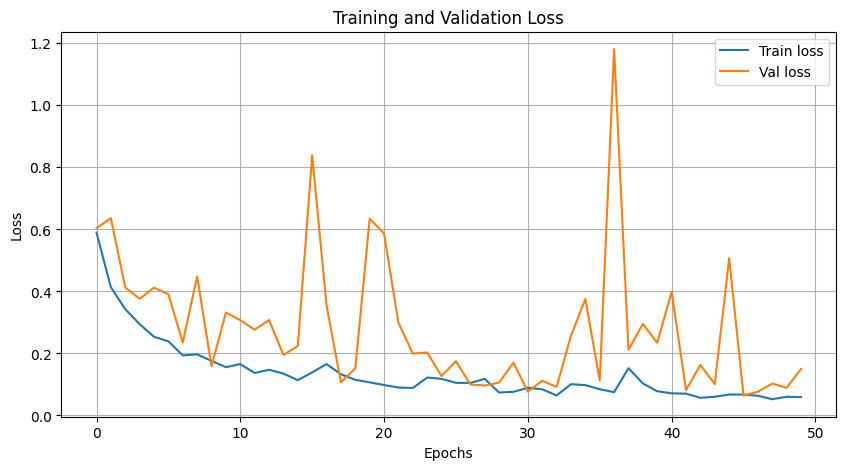

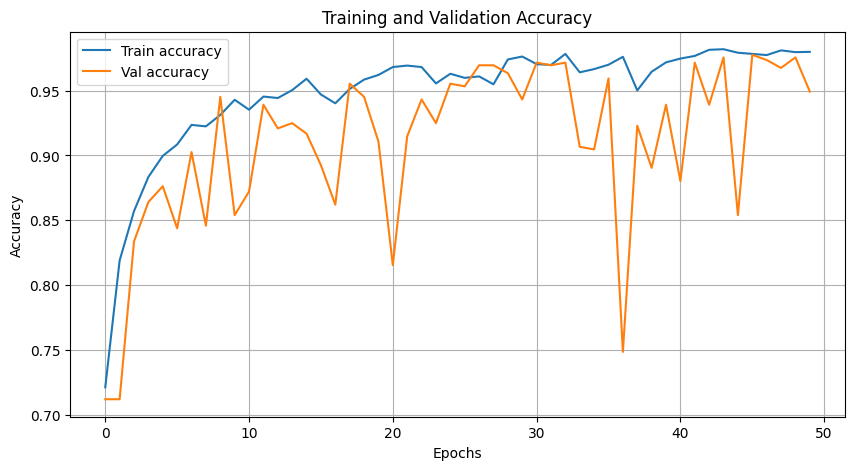

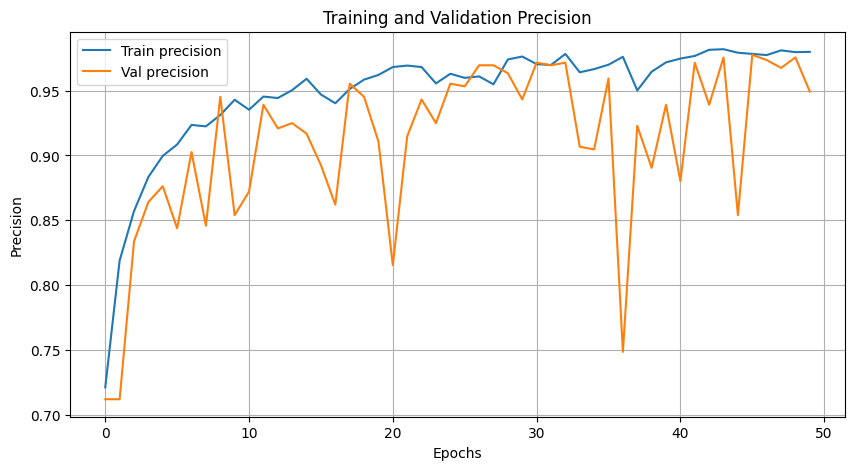

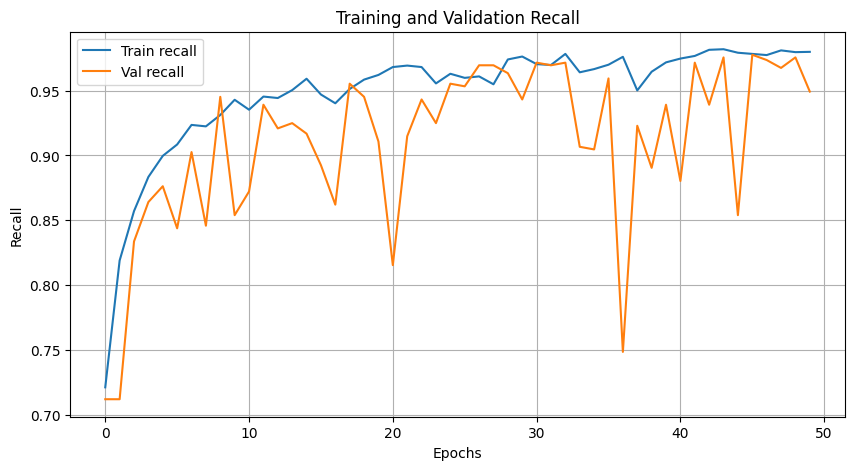

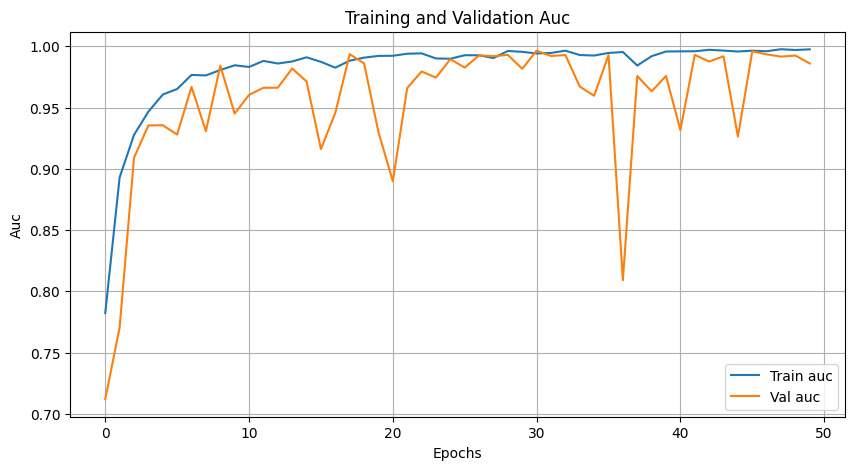

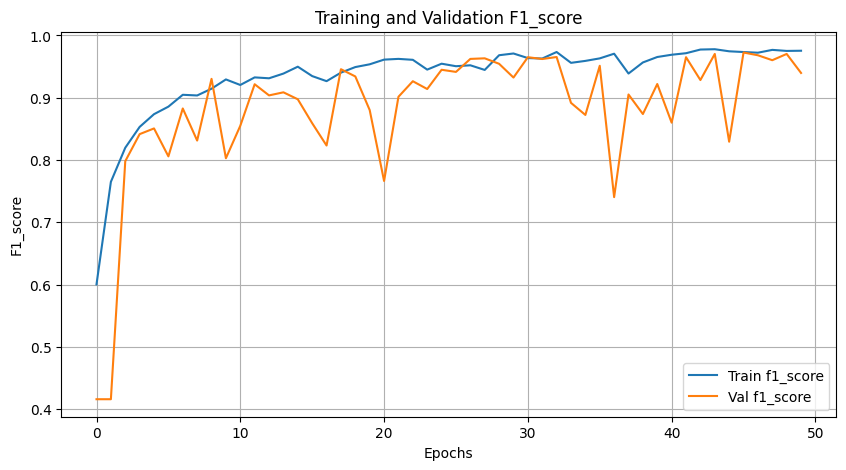

In [18]:
plot_training_history(history)

In [19]:
# Converter o histórico em DataFrame
history = pd.DataFrame(history.history)
# Salvar em CSV
history.to_csv('test_4_train_history.csv', index=False)

In [20]:
model.save('test_4.h5')

/home/magda/tf-gpu-env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Avaliar

In [21]:
avaliar_modelo(model, test_ds)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=13036, TN=9556, FP=551, FN=1259
Accuracy       : 0.9258
Precision      : 0.9594
Recall         : 0.9119
F1-Score       : 0.9351
AUC            : 0.9785
Binary Loss    : 0.2368
FDR (Fire Detection Rate)      : 91.19 %
EWR (Error Warning Rate)       : 7.42 %
Confusion Matrix:
[[ 9556   551]
 [ 1259 13036]]


{'TP': 13036,
 'TN': 9556,
 'FP': 551,
 'FN': 1259,
 'accuracy': 0.925825751987542,
 'precision': 0.9594465297711048,
 'recall': 0.911927247289262,
 'f1_score': 0.9350835664586471,
 'auc': 0.9784549808133766,
 'loss': 0.23678554437896776,
 'fdr': 91.1927247289262,
 'ewr': 7.417424801245799,
 'confusion_matrix': array([[ 9556,   551],
        [ 1259, 13036]])}

In [22]:
model_best = load_model('test_4_best.h5')

In [23]:
avaliar_modelo(model_best, test_ds)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=13856, TN=9448, FP=659, FN=439
Accuracy       : 0.9550
Precision      : 0.9546
Recall         : 0.9693
F1-Score       : 0.9619
AUC            : 0.9921
Binary Loss    : 0.1261
FDR (Fire Detection Rate)      : 96.93 %
EWR (Error Warning Rate)       : 4.50 %
Confusion Matrix:
[[ 9448   659]
 [  439 13856]]


{'TP': 13856,
 'TN': 9448,
 'FP': 659,
 'FN': 439,
 'accuracy': 0.9550036882222769,
 'precision': 0.9545986910093007,
 'recall': 0.9692899615250088,
 'f1_score': 0.961888233252343,
 'auc': 0.9920715015995514,
 'loss': 0.1260632110908613,
 'fdr': 96.92899615250087,
 'ewr': 4.499631177772314,
 'confusion_matrix': array([[ 9448,   659],
        [  439, 13856]])}

## Testar no FLAME train

In [24]:
data = pd.read_csv("../Datasets/FLAME_train.csv")
image_paths_flame_train = data['image_path'].values
labels_flame_train = data['label_bi'].values

test_ds_flame_train = tf.data.Dataset.from_tensor_slices((image_paths_flame_train, labels_flame_train))
test_ds_flame_train = test_ds_flame_train.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_flame_train, name="FLAME train")

📊 FLAME TRAIN -> Total de imagens: 39375
  Classe 0 (Sem fogo): 14357 imagens (36.46%)
  Classe 1 (Fogo): 25018 imagens (63.54%)
----------------------------------------


In [25]:
avaliar_modelo(model, test_ds_flame_train)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=22995, TN=13833, FP=524, FN=2023
Accuracy       : 0.9353
Precision      : 0.9777
Recall         : 0.9191
F1-Score       : 0.9475
AUC            : 0.9836
Binary Loss    : 0.1817
FDR (Fire Detection Rate)      : 91.91 %
EWR (Error Warning Rate)       : 6.47 %
Confusion Matrix:
[[13833   524]
 [ 2023 22995]]


{'TP': 22995,
 'TN': 13833,
 'FP': 524,
 'FN': 2023,
 'accuracy': 0.9353142857142858,
 'precision': 0.9777201411624644,
 'recall': 0.9191382204812535,
 'f1_score': 0.9475245688855924,
 'auc': 0.9835662072002175,
 'loss': 0.18166650648440408,
 'fdr': 91.91382204812535,
 'ewr': 6.468571428571429,
 'confusion_matrix': array([[13833,   524],
        [ 2023, 22995]])}

In [26]:
avaliar_modelo(model_best, test_ds_flame_train)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=24770, TN=13706, FP=651, FN=248
Accuracy       : 0.9772
Precision      : 0.9744
Recall         : 0.9901
F1-Score       : 0.9822
AUC            : 0.9977
Binary Loss    : 0.0630
FDR (Fire Detection Rate)      : 99.01 %
EWR (Error Warning Rate)       : 2.28 %
Confusion Matrix:
[[13706   651]
 [  248 24770]]


{'TP': 24770,
 'TN': 13706,
 'FP': 651,
 'FN': 248,
 'accuracy': 0.977168253968254,
 'precision': 0.9743912513276425,
 'recall': 0.9900871372611719,
 'f1_score': 0.9821764904141635,
 'auc': 0.9976871775258359,
 'loss': 0.06303744550521244,
 'fdr': 99.0087137261172,
 'ewr': 2.2831746031746034,
 'confusion_matrix': array([[13706,   651],
        [  248, 24770]])}

## Testar no FLAME test

In [27]:
data = pd.read_csv("../Datasets/FLAME_test.csv")
image_paths_flame_test = data['image_path'].values
labels_flame_test = data['label_bi'].values

test_ds_flame_test = tf.data.Dataset.from_tensor_slices((image_paths_flame_test, labels_flame_test))
test_ds_flame_test = test_ds_flame_test.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_flame_test, name="FLAME test")

📊 FLAME TEST -> Total de imagens: 8617
  Classe 0 (Sem fogo): 3480 imagens (40.39%)
  Classe 1 (Fogo): 5137 imagens (59.61%)
----------------------------------------


In [28]:
avaliar_modelo(model, test_ds_flame_test)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=3897, TN=3140, FP=340, FN=1240
Accuracy       : 0.8166
Precision      : 0.9198
Recall         : 0.7586
F1-Score       : 0.8314
AUC            : 0.9221
Binary Loss    : 0.4883
FDR (Fire Detection Rate)      : 75.86 %
EWR (Error Warning Rate)       : 18.34 %
Confusion Matrix:
[[3140  340]
 [1240 3897]]


{'TP': 3897,
 'TN': 3140,
 'FP': 340,
 'FN': 1240,
 'accuracy': 0.8166415225716607,
 'precision': 0.919754543308945,
 'recall': 0.7586139770293946,
 'f1_score': 0.8314486878600384,
 'auc': 0.9220998100326905,
 'loss': 0.4882539580414529,
 'fdr': 75.86139770293946,
 'ewr': 18.335847742833934,
 'confusion_matrix': array([[3140,  340],
        [1240, 3897]])}

In [29]:
avaliar_modelo(model_best, test_ds_flame_test)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=4851, TN=2943, FP=537, FN=286
Accuracy       : 0.9045
Precision      : 0.9003
Recall         : 0.9443
F1-Score       : 0.9218
AUC            : 0.9606
Binary Loss    : 0.2778
FDR (Fire Detection Rate)      : 94.43 %
EWR (Error Warning Rate)       : 9.55 %
Confusion Matrix:
[[2943  537]
 [ 286 4851]]


{'TP': 4851,
 'TN': 2943,
 'FP': 537,
 'FN': 286,
 'accuracy': 0.9044911222003017,
 'precision': 0.9003340757238307,
 'recall': 0.9443254817987152,
 'f1_score': 0.9218052256532067,
 'auc': 0.96060214490769,
 'loss': 0.2778414646540589,
 'fdr': 94.43254817987152,
 'ewr': 9.550887779969827,
 'confusion_matrix': array([[2943,  537],
        [ 286, 4851]])}

## Testar no UAVS Raw Images

In [30]:
data = pd.read_csv("../Datasets/UAVS_RawImages.csv")
image_paths_uavs_raw = data['image_path'].values
labels_uavs_raw = data['label_bi'].values

test_ds_uavs_raw = tf.data.Dataset.from_tensor_slices((image_paths_uavs_raw, labels_uavs_raw))
test_ds_uavs_raw = test_ds_uavs_raw.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_uavs_raw, name="UAVS Raw Images")

📊 UAVS RAW IMAGES -> Total de imagens: 1643
  Classe 0 (Sem fogo): 498 imagens (30.31%)
  Classe 1 (Fogo): 1145 imagens (69.69%)
----------------------------------------


In [31]:
avaliar_modelo(model, test_ds_uavs_raw)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=1140, TN=489, FP=9, FN=5
Accuracy       : 0.9915
Precision      : 0.9922
Recall         : 0.9956
F1-Score       : 0.9939
AUC            : 0.9997
Binary Loss    : 0.0206
FDR (Fire Detection Rate)      : 99.56 %
EWR (Error Warning Rate)       : 0.85 %
Confusion Matrix:
[[ 489    9]
 [   5 1140]]


{'TP': 1140,
 'TN': 489,
 'FP': 9,
 'FN': 5,
 'accuracy': 0.9914790018259282,
 'precision': 0.9921671018276762,
 'recall': 0.9956331877729258,
 'f1_score': 0.9938971229293809,
 'auc': 0.999687834306659,
 'loss': 0.020554575276343346,
 'fdr': 99.56331877729258,
 'ewr': 0.852099817407182,
 'confusion_matrix': array([[ 489,    9],
        [   5, 1140]])}

In [32]:
avaliar_modelo(model_best, test_ds_uavs_raw)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=1145, TN=497, FP=1, FN=0
Accuracy       : 0.9994
Precision      : 0.9991
Recall         : 1.0000
F1-Score       : 0.9996
AUC            : 1.0000
Binary Loss    : 0.0032
FDR (Fire Detection Rate)      : 100.00 %
EWR (Error Warning Rate)       : 0.06 %
Confusion Matrix:
[[ 497    1]
 [   0 1145]]


{'TP': 1145,
 'TN': 497,
 'FP': 1,
 'FN': 0,
 'accuracy': 0.9993913572732805,
 'precision': 0.9991273996509599,
 'recall': 1.0,
 'f1_score': 0.9995635093845482,
 'auc': 1.0,
 'loss': 0.0031542046154461327,
 'fdr': 100.0,
 'ewr': 0.06086427267194157,
 'confusion_matrix': array([[ 497,    1],
        [   0, 1145]])}

## Testar no UAVS Augmented Images

In [33]:
data = pd.read_csv("../Datasets/UAVS_AugmentedImages.csv")
image_paths_uavs_aug = data['image_path'].values
labels_uavs_aug = data['label_bi'].values

test_ds_uavs_aug = tf.data.Dataset.from_tensor_slices((image_paths_uavs_aug, labels_uavs_aug))
test_ds_uavs_aug = test_ds_uavs_aug.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_uavs_aug, name="UAVS Augmented Images")

📊 UAVS AUGMENTED IMAGES -> Total de imagens: 15560
  Classe 0 (Sem fogo): 7780 imagens (50.00%)
  Classe 1 (Fogo): 7780 imagens (50.00%)
----------------------------------------


In [34]:
avaliar_modelo(model, test_ds_uavs_aug)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=7092, TN=7380, FP=400, FN=688
Accuracy       : 0.9301
Precision      : 0.9466
Recall         : 0.9116
F1-Score       : 0.9288
AUC            : 0.9828
Binary Loss    : 0.2277
FDR (Fire Detection Rate)      : 91.16 %
EWR (Error Warning Rate)       : 6.99 %
Confusion Matrix:
[[7380  400]
 [ 688 7092]]


{'TP': 7092,
 'TN': 7380,
 'FP': 400,
 'FN': 688,
 'accuracy': 0.9300771208226221,
 'precision': 0.9466097170315003,
 'recall': 0.9115681233933162,
 'f1_score': 0.9287585123101101,
 'auc': 0.9828175534129434,
 'loss': 0.2277106077069784,
 'fdr': 91.15681233933162,
 'ewr': 6.99228791773779,
 'confusion_matrix': array([[7380,  400],
        [ 688, 7092]])}

In [35]:
avaliar_modelo(model_best, test_ds_uavs_aug)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=7552, TN=7275, FP=505, FN=228
Accuracy       : 0.9529
Precision      : 0.9373
Recall         : 0.9707
F1-Score       : 0.9537
AUC            : 0.9929
Binary Loss    : 0.1275
FDR (Fire Detection Rate)      : 97.07 %
EWR (Error Warning Rate)       : 4.71 %
Confusion Matrix:
[[7275  505]
 [ 228 7552]]


{'TP': 7552,
 'TN': 7275,
 'FP': 505,
 'FN': 228,
 'accuracy': 0.9528920308483291,
 'precision': 0.9373215837160234,
 'recall': 0.970694087403599,
 'f1_score': 0.9537159815621646,
 'auc': 0.9928680255879884,
 'loss': 0.12750584907760495,
 'fdr': 97.0694087403599,
 'ewr': 4.710796915167095,
 'confusion_matrix': array([[7275,  505],
        [ 228, 7552]])}

## Testar no FireMan

In [36]:
data = pd.read_csv("../Datasets/FireMan_test.csv")
image_paths_fireman = data['image_path'].values
labels_fireman = data['label_bi'].values

test_ds_fireman = tf.data.Dataset.from_tensor_slices((image_paths_fireman, labels_fireman))
test_ds_fireman = test_ds_fireman.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_fireman, name="UAVS Augmented Images")

📊 UAVS AUGMENTED IMAGES -> Total de imagens: 589
  Classe 0 (Sem fogo): 33 imagens (5.60%)
  Classe 1 (Fogo): 556 imagens (94.40%)
----------------------------------------


In [37]:
avaliar_modelo(model, test_ds_fireman)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=387, TN=24, FP=9, FN=169
Accuracy       : 0.6978
Precision      : 0.9773
Recall         : 0.6960
F1-Score       : 0.8130
AUC            : 0.7091
Binary Loss    : 1.2670
FDR (Fire Detection Rate)      : 69.60 %
EWR (Error Warning Rate)       : 30.22 %
Confusion Matrix:
[[ 24   9]
 [169 387]]


{'TP': 387,
 'TN': 24,
 'FP': 9,
 'FN': 169,
 'accuracy': 0.6977928692699491,
 'precision': 0.9772727272727273,
 'recall': 0.6960431654676259,
 'f1_score': 0.8130252100840335,
 'auc': 0.7090691083496838,
 'loss': 1.2670392056889836,
 'fdr': 69.60431654676259,
 'ewr': 30.220713073005097,
 'confusion_matrix': array([[ 24,   9],
        [169, 387]])}

In [38]:
avaliar_modelo(model_best, test_ds_fireman)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=451, TN=33, FP=0, FN=105
Accuracy       : 0.8217
Precision      : 1.0000
Recall         : 0.8112
F1-Score       : 0.8957
AUC            : 0.9170
Binary Loss    : 0.6246
FDR (Fire Detection Rate)      : 81.12 %
EWR (Error Warning Rate)       : 17.83 %
Confusion Matrix:
[[ 33   0]
 [105 451]]


{'TP': 451,
 'TN': 33,
 'FP': 0,
 'FN': 105,
 'accuracy': 0.8217317487266553,
 'precision': 1.0,
 'recall': 0.8111510791366906,
 'f1_score': 0.8957298907646474,
 'auc': 0.9170481796381077,
 'loss': 0.6245758314039468,
 'fdr': 81.11510791366906,
 'ewr': 17.826825127334462,
 'confusion_matrix': array([[ 33,   0],
        [105, 451]])}